In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

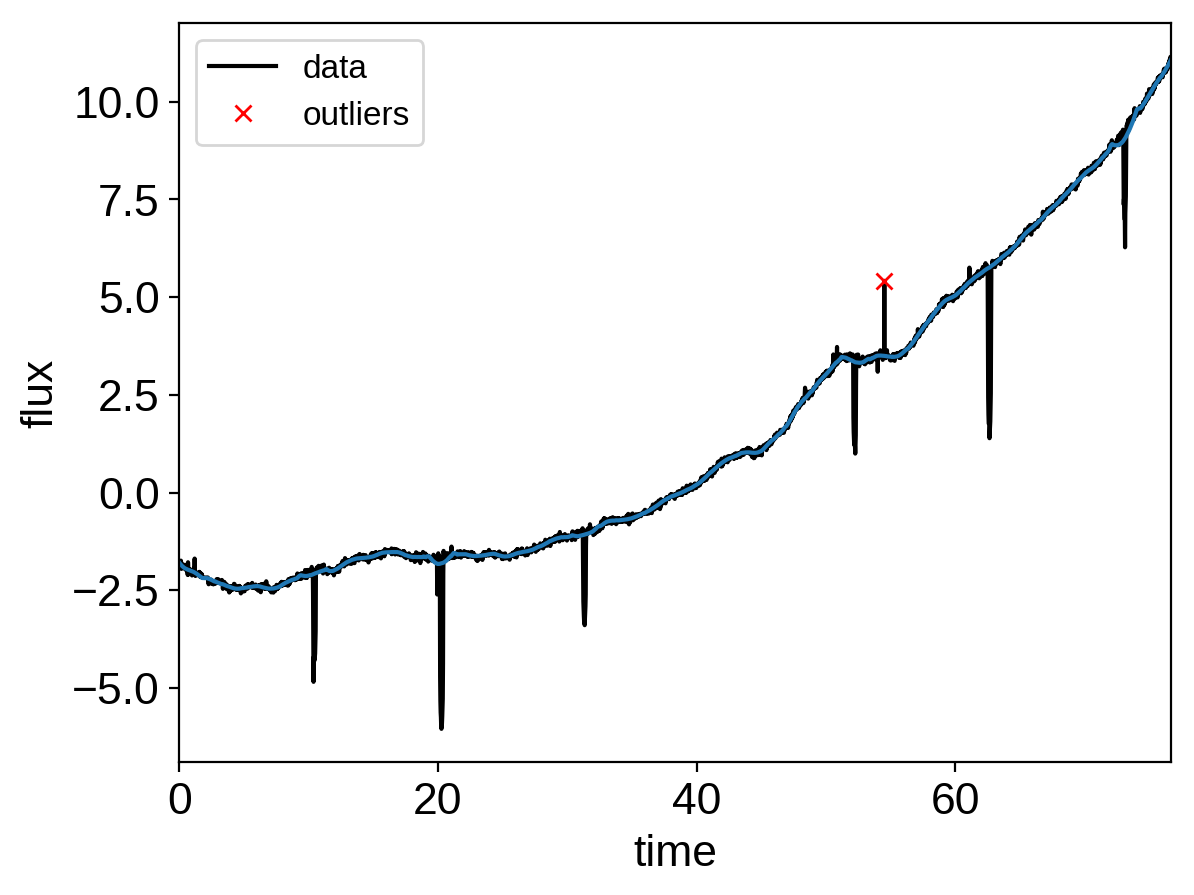

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

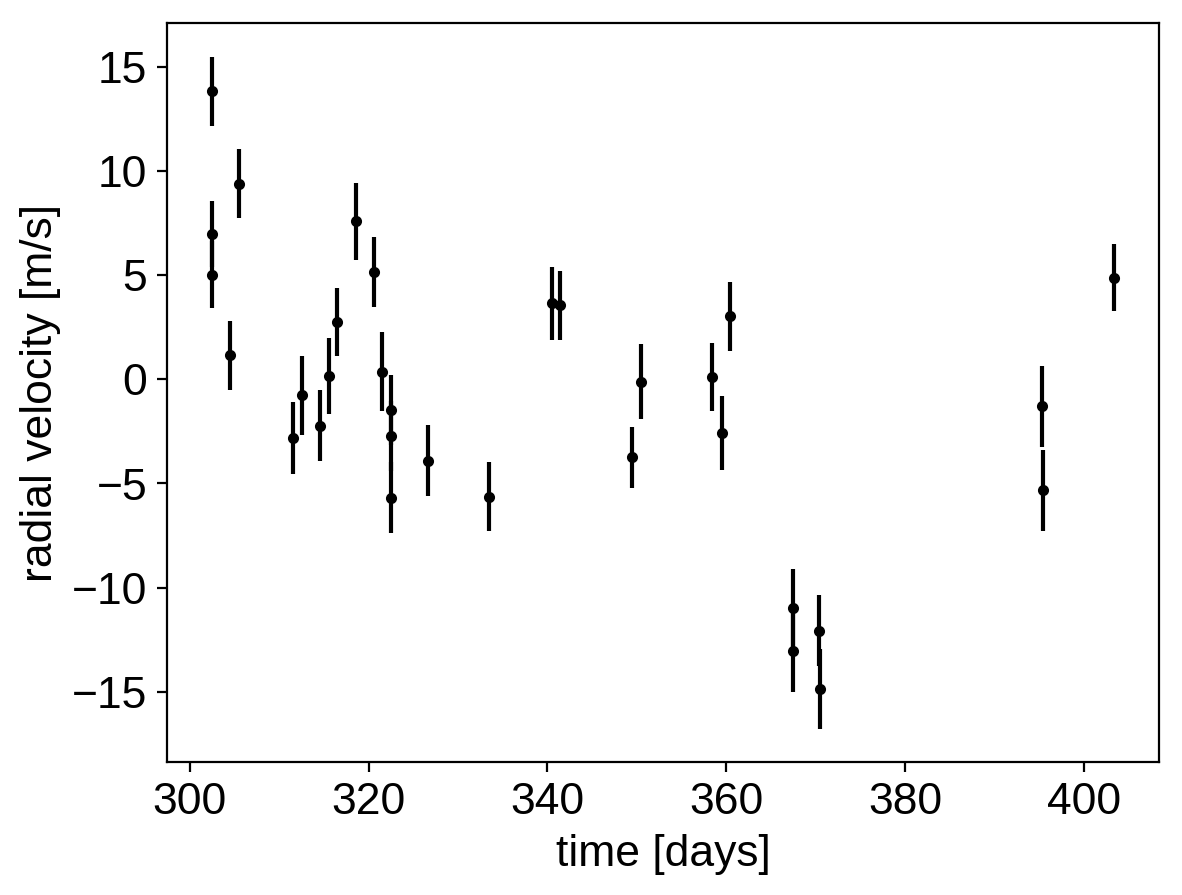

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

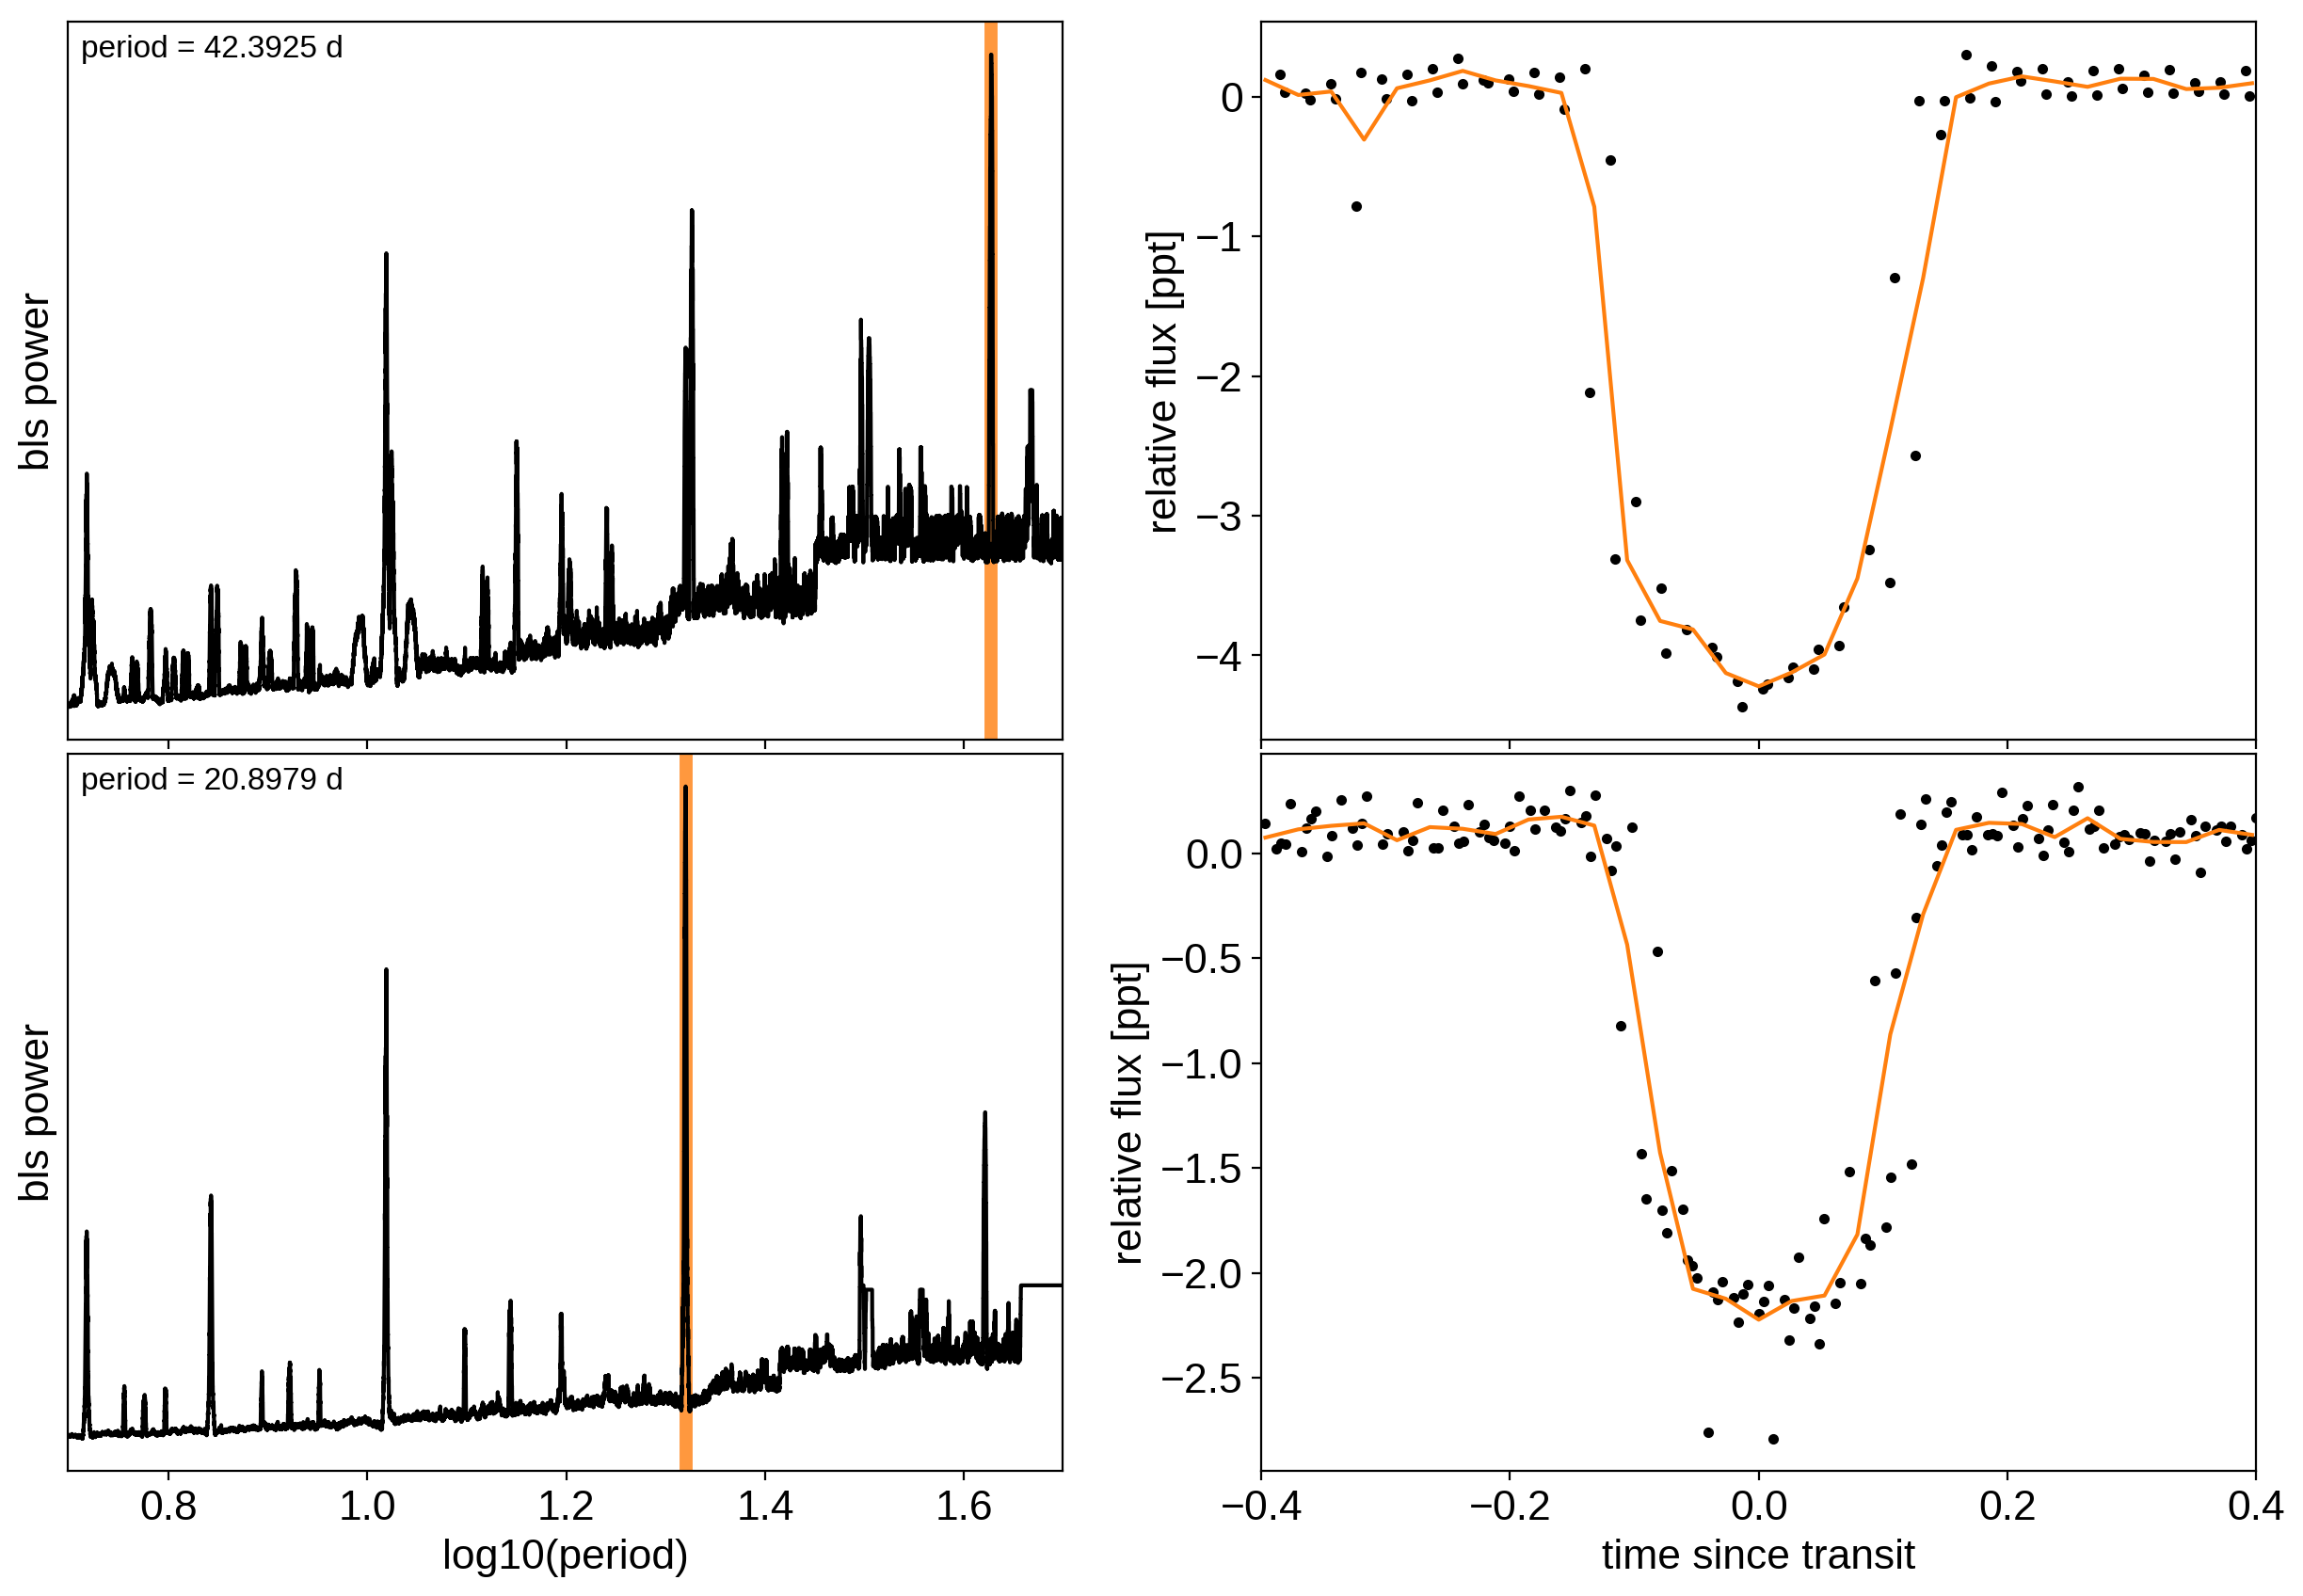

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0]
)
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star_petigura[0]),
            sd=1.0,
            shape=2,
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=ror, shape=2)

        ecc = xo.distributions.eccentricity.vaneylen19(
            "ecc", multi=True, shape=2, testval=np.array([0.01, 0.01])
        )
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve using starry
        light_curves = (
            xo.LimbDarkLightCurve(u_star).get_light_curve(
                orbit=orbit, r=r_pl, t=x[mask], texp=texp
            )
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5 * (x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5 * (x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.290067e+03]

1it [00:00, 72.25it/s, logp=-8.290067e+03]

2it [00:00, 94.78it/s, logp=-8.290067e+03]

3it [00:00, 103.73it/s, logp=-5.392070e+06]

4it [00:00, 113.43it/s, logp=-8.289847e+03]

5it [00:00, 120.37it/s, logp=-8.289419e+03]

6it [00:00, 129.54it/s, logp=-8.288014e+03]

7it [00:00, 136.62it/s, logp=-8.284634e+03]

8it [00:00, 144.24it/s, logp=-8.279284e+03]

9it [00:00, 150.80it/s, logp=-8.276752e+03]

10it [00:00, 157.45it/s, logp=-8.276752e+03]

11it [00:00, 163.98it/s, logp=-8.276752e+03]

12it [00:11,  1.09it/s, logp=-8.276752e+03] 


message: Optimization terminated successfully.
logp: -8290.066560739391 -> -8276.751877588842


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.276752e+03]

1it [00:00, 65.57it/s, logp=-8.276752e+03]

2it [00:00, 96.29it/s, logp=-8.276752e+03]

3it [00:00, 113.15it/s, logp=-6.553614e+03]

4it [00:00, 128.05it/s, logp=-5.887021e+01]

5it [00:00, 141.03it/s, logp=-3.543119e+05]

6it [00:00, 153.35it/s, logp=1.118139e+02] 

7it [00:00, 164.68it/s, logp=1.763270e+03]

8it [00:00, 170.65it/s, logp=1.845136e+03]

9it [00:00, 175.78it/s, logp=1.987971e+03]

10it [00:00, 180.46it/s, logp=2.100900e+03]

11it [00:00, 184.53it/s, logp=2.109703e+03]

12it [00:00, 186.53it/s, logp=2.110024e+03]

13it [00:00, 188.29it/s, logp=2.110025e+03]

14it [00:00, 189.59it/s, logp=2.110025e+03]

15it [00:01,  9.91it/s, logp=2.110025e+03] 


message: Optimization terminated successfully.
logp: -8276.751877588842 -> 2110.02456128196


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.110025e+03]

1it [00:00, 102.98it/s, logp=2.110025e+03]

2it [00:00, 138.68it/s, logp=2.110025e+03]

3it [00:00, 153.64it/s, logp=-3.326931e+04]

4it [00:00, 162.64it/s, logp=2.597750e+03] 

5it [00:00, 167.82it/s, logp=9.498090e+01]

6it [00:00, 171.96it/s, logp=2.606232e+03]

7it [00:00, 173.81it/s, logp=2.617498e+03]

8it [00:00, 175.33it/s, logp=2.624864e+03]

9it [00:00, 176.89it/s, logp=2.626822e+03]

10it [00:00, 178.17it/s, logp=2.630170e+03]

11it [00:00, 179.23it/s, logp=2.634492e+03]

12it [00:00, 180.64it/s, logp=2.636907e+03]

13it [00:00, 178.75it/s, logp=2.638483e+03]

14it [00:00, 181.11it/s, logp=2.637089e+03]

15it [00:00, 183.95it/s, logp=2.639518e+03]

16it [00:00, 168.64it/s, logp=2.640645e+03]

17it [00:00, 169.63it/s, logp=2.642629e+03]

18it [00:00, 178.50it/s, logp=2.642629e+03]

18it [00:00, 178.50it/s, logp=2.645965e+03]

19it [00:00, 178.50it/s, logp=2.652071e+03]

20it [00:00, 178.50it/s, logp=2.648763e+03]

21it [00:00, 178.50it/s, logp=2.656808e+03]

22it [00:00, 178.50it/s, logp=2.663014e+03]

23it [00:00, 178.50it/s, logp=2.671619e+03]

24it [00:00, 178.50it/s, logp=2.678940e+03]

25it [00:00, 178.50it/s, logp=2.683125e+03]

26it [00:00, 178.50it/s, logp=2.686471e+03]

27it [00:00, 178.50it/s, logp=2.687700e+03]

28it [00:00, 178.50it/s, logp=2.688696e+03]

29it [00:00, 178.50it/s, logp=2.688988e+03]

30it [00:00, 178.50it/s, logp=2.689034e+03]

31it [00:00, 178.50it/s, logp=2.689040e+03]

32it [00:00, 178.50it/s, logp=2.689040e+03]

33it [00:00, 178.50it/s, logp=2.689040e+03]

34it [00:00, 178.50it/s, logp=2.689040e+03]

35it [00:00, 178.50it/s, logp=2.689040e+03]

36it [00:00, 178.50it/s, logp=2.689040e+03]

37it [00:00, 178.50it/s, logp=2.689040e+03]

38it [00:00, 178.50it/s, logp=2.689040e+03]

39it [00:00, 178.50it/s, logp=2.689040e+03]

40it [00:00, 188.14it/s, logp=2.689040e+03]

40it [00:00, 188.14it/s, logp=2.689040e+03]

41it [00:00, 188.14it/s, logp=2.689040e+03]

42it [00:00, 188.14it/s, logp=2.689040e+03]

43it [00:00, 188.14it/s, logp=2.689040e+03]

44it [00:00, 188.14it/s, logp=2.689040e+03]

45it [00:00, 188.14it/s, logp=2.689040e+03]

46it [00:00, 188.14it/s, logp=2.689040e+03]

47it [00:00, 188.14it/s, logp=2.689040e+03]

48it [00:00, 188.14it/s, logp=2.689040e+03]

49it [00:00, 188.14it/s, logp=2.689040e+03]

50it [00:00, 188.14it/s, logp=2.689040e+03]

51it [00:00, 188.14it/s, logp=2.689040e+03]

52it [00:00, 188.14it/s, logp=2.689040e+03]

53it [00:00, 188.14it/s, logp=2.689040e+03]

54it [00:00, 188.14it/s, logp=2.689040e+03]

55it [00:00, 188.14it/s, logp=2.689040e+03]

56it [00:00, 188.14it/s, logp=2.689040e+03]

57it [00:00, 188.14it/s, logp=2.689040e+03]

58it [00:00, 188.14it/s, logp=2.689040e+03]

59it [00:00, 188.14it/s, logp=2.689040e+03]

60it [00:00, 188.14it/s, logp=2.689040e+03]

61it [00:00, 192.16it/s, logp=2.689040e+03]

61it [00:00, 192.16it/s, logp=2.689040e+03]

62it [00:00, 192.16it/s, logp=2.689040e+03]

63it [00:00, 192.16it/s, logp=2.689040e+03]

64it [00:00, 192.16it/s, logp=2.689040e+03]

65it [00:00, 192.16it/s, logp=2.689040e+03]

66it [00:00, 192.16it/s, logp=2.689040e+03]

67it [00:00, 192.16it/s, logp=2.689040e+03]

68it [00:00, 192.16it/s, logp=2.689040e+03]

69it [00:00, 192.16it/s, logp=2.689040e+03]

70it [00:00, 192.16it/s, logp=2.689040e+03]

71it [00:00, 192.16it/s, logp=2.689040e+03]

72it [00:00, 192.16it/s, logp=2.689040e+03]

73it [00:00, 192.16it/s, logp=2.689040e+03]

74it [00:00, 192.16it/s, logp=2.689040e+03]

75it [00:00, 192.16it/s, logp=2.689040e+03]

76it [00:00, 192.16it/s, logp=2.689040e+03]

77it [00:00, 192.16it/s, logp=2.689040e+03]

78it [00:00, 192.16it/s, logp=2.689040e+03]

79it [00:00, 192.16it/s, logp=2.689040e+03]

80it [00:00, 192.16it/s, logp=2.689040e+03]

81it [00:00, 192.16it/s, logp=2.689040e+03]

82it [00:00, 192.16it/s, logp=2.689040e+03]

83it [00:00, 192.16it/s, logp=2.689040e+03]

84it [00:00, 200.45it/s, logp=2.689040e+03]

84it [00:00, 200.45it/s, logp=2.689040e+03]

85it [00:00, 200.45it/s, logp=2.689040e+03]

86it [00:00, 200.45it/s, logp=2.689040e+03]

87it [00:00, 200.45it/s, logp=2.689040e+03]

88it [00:00, 200.45it/s, logp=2.689040e+03]

89it [00:00, 200.45it/s, logp=2.689040e+03]

90it [00:00, 200.45it/s, logp=2.689040e+03]

91it [00:00, 200.45it/s, logp=2.689040e+03]

92it [00:00, 200.45it/s, logp=2.689040e+03]

93it [00:00, 200.45it/s, logp=2.689040e+03]

94it [00:00, 200.45it/s, logp=2.689040e+03]

95it [00:00, 200.45it/s, logp=2.689040e+03]

96it [00:00, 200.45it/s, logp=2.689040e+03]

97it [00:00, 200.45it/s, logp=2.689040e+03]

98it [00:00, 200.45it/s, logp=2.689040e+03]

99it [00:00, 200.45it/s, logp=2.689040e+03]

100it [00:00, 200.45it/s, logp=2.689040e+03]

101it [00:00, 200.45it/s, logp=2.689040e+03]

102it [00:00, 200.45it/s, logp=2.689040e+03]

103it [00:00, 200.45it/s, logp=2.689040e+03]

104it [00:00, 200.45it/s, logp=2.689040e+03]

105it [00:01, 56.52it/s, logp=2.689040e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2110.02456128196 -> 2689.0397283218103


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.689040e+03]

1it [00:00, 96.03it/s, logp=2.689040e+03]

2it [00:00, 135.79it/s, logp=2.689040e+03]

3it [00:00, 155.07it/s, logp=-5.044436e+03]

4it [00:00, 179.32it/s, logp=-1.040665e+03]

5it [00:00, 198.90it/s, logp=-7.647381e+02]

6it [00:00, 204.75it/s, logp=-8.705591e+02]

7it [00:00, 213.11it/s, logp=-5.334416e+02]

8it [00:00, 219.91it/s, logp=9.580323e+02] 

9it [00:00, 226.10it/s, logp=2.884188e+03]

10it [00:00, 230.96it/s, logp=-6.009377e+01]

11it [00:00, 237.41it/s, logp=2.882330e+03] 

12it [00:00, 240.84it/s, logp=2.886442e+03]

13it [00:00, 242.41it/s, logp=2.890979e+03]

14it [00:00, 246.97it/s, logp=2.908790e+03]

15it [00:00, 251.16it/s, logp=2.974219e+03]

16it [00:00, 254.35it/s, logp=3.120587e+03]

17it [00:00, 253.90it/s, logp=3.218439e+03]

18it [00:00, 256.23it/s, logp=3.240106e+03]

19it [00:00, 258.75it/s, logp=3.244828e+03]

20it [00:00, 260.91it/s, logp=3.244871e+03]

21it [00:00, 263.06it/s, logp=3.244872e+03]

22it [00:00, 265.12it/s, logp=3.244872e+03]

23it [00:00, 266.42it/s, logp=3.244872e+03]

24it [00:00, 267.48it/s, logp=3.244872e+03]

25it [00:00, 269.74it/s, logp=3.244872e+03]

26it [00:00, 271.99it/s, logp=3.244872e+03]

27it [00:00, 273.83it/s, logp=3.244872e+03]

28it [00:00, 275.81it/s, logp=3.244872e+03]

29it [00:00, 283.63it/s, logp=3.244872e+03]

29it [00:00, 283.63it/s, logp=3.244872e+03]

30it [00:00, 283.63it/s, logp=3.244872e+03]

31it [00:00, 283.63it/s, logp=3.244872e+03]

32it [00:00, 283.63it/s, logp=3.244872e+03]

33it [00:00, 283.63it/s, logp=3.244872e+03]

34it [00:00, 283.63it/s, logp=3.244872e+03]

35it [00:00, 283.63it/s, logp=3.244872e+03]

36it [00:00, 283.63it/s, logp=3.244872e+03]

37it [00:00, 283.63it/s, logp=3.244872e+03]

38it [00:00, 283.63it/s, logp=3.244872e+03]

39it [00:00, 283.63it/s, logp=3.244872e+03]

40it [00:00, 283.63it/s, logp=3.244872e+03]

41it [00:00, 283.63it/s, logp=3.244872e+03]

42it [00:00, 283.63it/s, logp=3.244872e+03]

43it [00:00, 283.63it/s, logp=3.244872e+03]

44it [00:00, 283.63it/s, logp=3.244872e+03]

45it [00:00, 283.63it/s, logp=3.244872e+03]

46it [00:00, 283.63it/s, logp=3.244872e+03]

47it [00:00, 283.63it/s, logp=3.244872e+03]

48it [00:00, 283.63it/s, logp=3.244872e+03]

49it [00:00, 283.63it/s, logp=3.244872e+03]

50it [00:00, 283.63it/s, logp=3.244872e+03]

51it [00:00, 283.63it/s, logp=3.244872e+03]

52it [00:00, 283.63it/s, logp=3.244872e+03]

53it [00:00, 283.63it/s, logp=3.244872e+03]

54it [00:00, 283.63it/s, logp=3.244872e+03]

55it [00:00, 283.63it/s, logp=3.244872e+03]

56it [00:00, 283.63it/s, logp=3.244872e+03]

57it [00:00, 283.63it/s, logp=3.244872e+03]

58it [00:00, 283.63it/s, logp=3.244872e+03]

59it [00:00, 283.63it/s, logp=3.244872e+03]

60it [00:00, 290.28it/s, logp=3.244872e+03]

60it [00:00, 290.28it/s, logp=3.244872e+03]

61it [00:00, 290.28it/s, logp=3.244872e+03]

62it [00:00, 290.28it/s, logp=3.244872e+03]

63it [00:00, 290.28it/s, logp=3.244872e+03]

64it [00:00, 290.28it/s, logp=3.244872e+03]

65it [00:00, 290.28it/s, logp=3.244872e+03]

66it [00:00, 290.28it/s, logp=3.244872e+03]

67it [00:00, 290.28it/s, logp=3.244872e+03]

68it [00:00, 290.28it/s, logp=3.244872e+03]

69it [00:00, 290.28it/s, logp=3.244872e+03]

70it [00:00, 290.28it/s, logp=3.244872e+03]

71it [00:00, 290.28it/s, logp=3.244872e+03]

72it [00:00, 290.28it/s, logp=3.244872e+03]

73it [00:00, 290.28it/s, logp=3.244872e+03]

74it [00:00, 290.28it/s, logp=3.244872e+03]

75it [00:00, 290.28it/s, logp=3.244872e+03]

76it [00:00, 290.28it/s, logp=3.244872e+03]

77it [00:00, 290.28it/s, logp=3.244872e+03]

78it [00:00, 290.28it/s, logp=3.244872e+03]

79it [00:01, 42.45it/s, logp=3.244872e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2689.039728321822 -> 3244.8715047912565


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.244872e+03]

1it [00:00, 88.59it/s, logp=3.244872e+03]

2it [00:00, 127.07it/s, logp=3.244872e+03]

3it [00:00, 150.10it/s, logp=3.744214e+03]

4it [00:00, 163.54it/s, logp=-4.251570e+03]

5it [00:00, 175.11it/s, logp=3.896383e+03] 

6it [00:00, 182.08it/s, logp=3.898724e+03]

7it [00:00, 189.66it/s, logp=3.899739e+03]

8it [00:00, 195.34it/s, logp=3.899740e+03]

9it [00:00, 199.15it/s, logp=3.899740e+03]

10it [00:00, 201.51it/s, logp=3.899740e+03]

11it [00:00, 203.05it/s, logp=3.899740e+03]

12it [00:00, 202.36it/s, logp=3.899740e+03]

13it [00:01,  7.96it/s, logp=3.899740e+03] 


message: Optimization terminated successfully.
logp: 3244.8715047912547 -> 3899.7404342927084


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.899740e+03]

1it [00:00, 70.41it/s, logp=3.899740e+03]

2it [00:00, 97.87it/s, logp=3.899740e+03]

3it [00:00, 117.57it/s, logp=4.002758e+03]

4it [00:00, 129.91it/s, logp=4.002965e+03]

5it [00:00, 139.18it/s, logp=4.003665e+03]

6it [00:00, 146.03it/s, logp=4.003689e+03]

7it [00:00, 152.18it/s, logp=4.004107e+03]

8it [00:00, 157.31it/s, logp=4.004134e+03]

9it [00:00, 161.87it/s, logp=4.004137e+03]

10it [00:00, 164.53it/s, logp=4.004137e+03]

11it [00:00, 168.15it/s, logp=4.004137e+03]

12it [00:01,  6.65it/s, logp=4.004137e+03] 


message: Optimization terminated successfully.
logp: 3899.7404342927084 -> 4004.1373334508944


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.004137e+03]

1it [00:00, 65.19it/s, logp=4.004137e+03]

2it [00:00, 95.61it/s, logp=4.004137e+03]

3it [00:00, 113.43it/s, logp=-5.635527e+03]

4it [00:00, 126.59it/s, logp=-7.624740e+03]

5it [00:00, 135.60it/s, logp=-8.177933e+03]

6it [00:00, 142.05it/s, logp=-5.826551e+03]

7it [00:00, 147.73it/s, logp=4.004167e+03] 

8it [00:00, 150.25it/s, logp=4.003858e+03]

9it [00:00, 150.24it/s, logp=4.004169e+03]

10it [00:00, 152.41it/s, logp=4.004174e+03]

11it [00:00, 155.16it/s, logp=4.004194e+03]

12it [00:00, 157.64it/s, logp=4.004272e+03]

13it [00:00, 158.90it/s, logp=4.004579e+03]

14it [00:00, 160.82it/s, logp=4.005724e+03]

15it [00:00, 160.55it/s, logp=4.008609e+03]

16it [00:00, 160.46it/s, logp=4.014275e+03]

17it [00:00, 169.29it/s, logp=4.014275e+03]

17it [00:00, 169.29it/s, logp=4.033609e+03]

18it [00:00, 169.29it/s, logp=3.891646e+03]

19it [00:00, 169.29it/s, logp=4.036957e+03]

20it [00:00, 169.29it/s, logp=4.043156e+03]

21it [00:00, 169.29it/s, logp=4.054375e+03]

22it [00:00, 169.29it/s, logp=4.076318e+03]

23it [00:00, 169.29it/s, logp=4.137877e+03]

24it [00:00, 169.29it/s, logp=4.165133e+03]

25it [00:00, 169.29it/s, logp=4.193616e+03]

26it [00:00, 169.29it/s, logp=4.291726e+03]

27it [00:00, 169.29it/s, logp=3.966029e+03]

28it [00:00, 169.29it/s, logp=4.312287e+03]

29it [00:00, 169.29it/s, logp=4.339925e+03]

30it [00:00, 169.29it/s, logp=4.388734e+03]

31it [00:00, 169.29it/s, logp=4.292453e+03]

32it [00:00, 169.29it/s, logp=4.408692e+03]

33it [00:00, 169.29it/s, logp=4.439598e+03]

34it [00:00, 165.50it/s, logp=4.439598e+03]

34it [00:00, 165.50it/s, logp=4.486790e+03]

35it [00:00, 165.50it/s, logp=4.564494e+03]

36it [00:00, 165.50it/s, logp=3.428574e+03]

37it [00:00, 165.50it/s, logp=4.590813e+03]

38it [00:00, 165.50it/s, logp=4.629040e+03]

39it [00:00, 165.50it/s, logp=4.653332e+03]

40it [00:00, 165.50it/s, logp=4.658654e+03]

41it [00:00, 165.50it/s, logp=4.668362e+03]

42it [00:00, 165.50it/s, logp=4.684407e+03]

43it [00:00, 165.50it/s, logp=4.685529e+03]

44it [00:00, 165.50it/s, logp=4.693587e+03]

45it [00:00, 165.50it/s, logp=4.704038e+03]

46it [00:00, 165.50it/s, logp=4.710569e+03]

47it [00:00, 165.50it/s, logp=4.704997e+03]

48it [00:00, 152.99it/s, logp=4.704997e+03]

48it [00:00, 152.99it/s, logp=4.713100e+03]

49it [00:00, 152.99it/s, logp=4.716394e+03]

50it [00:00, 152.99it/s, logp=4.721233e+03]

51it [00:00, 152.99it/s, logp=4.725292e+03]

52it [00:00, 152.99it/s, logp=4.727717e+03]

53it [00:00, 152.99it/s, logp=4.731126e+03]

54it [00:00, 152.99it/s, logp=4.735418e+03]

55it [00:00, 152.99it/s, logp=4.737422e+03]

56it [00:00, 152.99it/s, logp=4.740264e+03]

57it [00:00, 152.99it/s, logp=4.743094e+03]

58it [00:00, 152.99it/s, logp=4.745239e+03]

59it [00:00, 152.99it/s, logp=4.747720e+03]

60it [00:00, 152.99it/s, logp=4.749903e+03]

61it [00:00, 142.03it/s, logp=4.749903e+03]

61it [00:00, 142.03it/s, logp=4.752661e+03]

62it [00:00, 142.03it/s, logp=4.754165e+03]

63it [00:00, 142.03it/s, logp=4.756473e+03]

64it [00:00, 142.03it/s, logp=4.758252e+03]

65it [00:00, 142.03it/s, logp=4.759565e+03]

66it [00:00, 142.03it/s, logp=4.761043e+03]

67it [00:00, 142.03it/s, logp=4.762316e+03]

68it [00:00, 142.03it/s, logp=4.763149e+03]

69it [00:00, 142.03it/s, logp=4.763675e+03]

70it [00:00, 142.03it/s, logp=4.764199e+03]

71it [00:00, 142.03it/s, logp=4.764591e+03]

72it [00:00, 142.03it/s, logp=4.764860e+03]

73it [00:00, 142.03it/s, logp=4.765143e+03]

74it [00:00, 136.62it/s, logp=4.765143e+03]

74it [00:00, 136.62it/s, logp=4.765519e+03]

75it [00:00, 136.62it/s, logp=4.765829e+03]

76it [00:00, 136.62it/s, logp=4.766064e+03]

77it [00:00, 136.62it/s, logp=4.766296e+03]

78it [00:00, 136.62it/s, logp=4.766483e+03]

79it [00:00, 136.62it/s, logp=4.766716e+03]

80it [00:00, 136.62it/s, logp=4.767015e+03]

81it [00:00, 136.62it/s, logp=4.766993e+03]

82it [00:00, 136.62it/s, logp=4.767241e+03]

83it [00:00, 136.62it/s, logp=4.767269e+03]

84it [00:00, 136.62it/s, logp=4.767377e+03]

85it [00:00, 136.62it/s, logp=4.767608e+03]

86it [00:00, 136.62it/s, logp=4.767981e+03]

87it [00:00, 134.01it/s, logp=4.767981e+03]

87it [00:00, 134.01it/s, logp=4.768290e+03]

88it [00:00, 134.01it/s, logp=4.768397e+03]

89it [00:00, 134.01it/s, logp=4.768574e+03]

90it [00:00, 134.01it/s, logp=4.768863e+03]

91it [00:00, 134.01it/s, logp=4.769281e+03]

92it [00:00, 134.01it/s, logp=4.769501e+03]

93it [00:00, 134.01it/s, logp=4.769791e+03]

94it [00:00, 134.01it/s, logp=4.769873e+03]

95it [00:00, 134.01it/s, logp=4.770006e+03]

96it [00:00, 134.01it/s, logp=4.770144e+03]

97it [00:00, 134.01it/s, logp=4.770172e+03]

98it [00:00, 134.01it/s, logp=4.770224e+03]

99it [00:00, 134.01it/s, logp=4.770322e+03]

100it [00:00, 134.01it/s, logp=4.770503e+03]

101it [00:00, 135.41it/s, logp=4.770503e+03]

101it [00:00, 135.41it/s, logp=4.770808e+03]

102it [00:00, 135.41it/s, logp=4.771117e+03]

103it [00:00, 135.41it/s, logp=4.771296e+03]

104it [00:00, 135.41it/s, logp=4.771365e+03]

105it [00:00, 135.41it/s, logp=4.771420e+03]

106it [00:00, 135.41it/s, logp=4.771510e+03]

107it [00:00, 135.41it/s, logp=4.771538e+03]

108it [00:00, 135.41it/s, logp=4.771570e+03]

109it [00:00, 135.41it/s, logp=4.771605e+03]

110it [00:00, 135.41it/s, logp=4.771622e+03]

111it [00:00, 135.41it/s, logp=4.771637e+03]

112it [00:00, 135.41it/s, logp=4.771651e+03]

113it [00:00, 135.41it/s, logp=4.771674e+03]

114it [00:00, 135.41it/s, logp=4.771716e+03]

115it [00:00, 134.20it/s, logp=4.771716e+03]

115it [00:00, 134.20it/s, logp=4.771785e+03]

116it [00:00, 134.20it/s, logp=4.771892e+03]

117it [00:00, 134.20it/s, logp=4.772071e+03]

118it [00:00, 134.20it/s, logp=4.772333e+03]

119it [00:00, 134.20it/s, logp=4.772731e+03]

120it [00:00, 134.20it/s, logp=4.773251e+03]

121it [00:00, 134.20it/s, logp=4.767950e+03]

122it [00:00, 134.20it/s, logp=4.773412e+03]

123it [00:00, 134.20it/s, logp=4.773709e+03]

124it [00:00, 134.20it/s, logp=4.774230e+03]

125it [00:00, 134.20it/s, logp=4.774836e+03]

126it [00:00, 134.20it/s, logp=4.772825e+03]

127it [00:00, 134.20it/s, logp=4.774991e+03]

128it [00:00, 134.20it/s, logp=4.774997e+03]

129it [00:00, 134.20it/s, logp=4.775036e+03]

130it [00:00, 137.82it/s, logp=4.775036e+03]

130it [00:00, 137.82it/s, logp=4.775048e+03]

131it [00:00, 137.82it/s, logp=4.775053e+03]

132it [00:00, 137.82it/s, logp=4.775055e+03]

133it [00:00, 137.82it/s, logp=4.775059e+03]

134it [00:00, 137.82it/s, logp=4.775064e+03]

135it [00:00, 137.82it/s, logp=4.775072e+03]

136it [00:00, 137.82it/s, logp=4.775077e+03]

137it [00:00, 137.82it/s, logp=4.775080e+03]

138it [00:00, 137.82it/s, logp=4.775084e+03]

139it [00:01, 137.82it/s, logp=4.775089e+03]

140it [00:01, 137.82it/s, logp=4.775096e+03]

141it [00:01, 137.82it/s, logp=4.775102e+03]

142it [00:01, 137.82it/s, logp=4.775106e+03]

143it [00:01, 137.82it/s, logp=4.775109e+03]

144it [00:01, 137.82it/s, logp=4.775110e+03]

145it [00:01, 137.82it/s, logp=4.775111e+03]

146it [00:01, 137.82it/s, logp=4.775112e+03]

147it [00:01, 145.33it/s, logp=4.775112e+03]

147it [00:01, 145.33it/s, logp=4.775114e+03]

148it [00:01, 145.33it/s, logp=4.775117e+03]

149it [00:01, 145.33it/s, logp=4.775122e+03]

150it [00:01, 145.33it/s, logp=4.775125e+03]

151it [00:01, 145.33it/s, logp=4.775126e+03]

152it [00:01, 145.33it/s, logp=4.775128e+03]

153it [00:01, 145.33it/s, logp=4.775129e+03]

154it [00:01, 145.33it/s, logp=4.775131e+03]

155it [00:01, 145.33it/s, logp=4.775132e+03]

156it [00:01, 145.33it/s, logp=4.775132e+03]

157it [00:01, 145.33it/s, logp=4.775132e+03]

158it [00:01, 145.33it/s, logp=4.775133e+03]

159it [00:01, 145.33it/s, logp=4.775133e+03]

160it [00:01, 145.33it/s, logp=4.775133e+03]

161it [00:01, 145.33it/s, logp=4.775134e+03]

162it [00:01, 145.33it/s, logp=4.775135e+03]

163it [00:01, 145.33it/s, logp=4.775138e+03]

164it [00:01, 149.99it/s, logp=4.775138e+03]

164it [00:01, 149.99it/s, logp=4.775143e+03]

165it [00:01, 149.99it/s, logp=4.775151e+03]

166it [00:01, 149.99it/s, logp=4.775156e+03]

167it [00:01, 149.99it/s, logp=4.775157e+03]

168it [00:01, 149.99it/s, logp=4.775164e+03]

169it [00:01, 149.99it/s, logp=4.775156e+03]

170it [00:01, 149.99it/s, logp=4.775169e+03]

171it [00:01, 149.99it/s, logp=4.775174e+03]

172it [00:01, 149.99it/s, logp=4.775177e+03]

173it [00:01, 149.99it/s, logp=4.775176e+03]

174it [00:01, 149.99it/s, logp=4.775179e+03]

175it [00:01, 149.99it/s, logp=4.775180e+03]

176it [00:01, 149.99it/s, logp=4.775182e+03]

177it [00:01, 149.99it/s, logp=4.775183e+03]

178it [00:01, 149.99it/s, logp=4.775185e+03]

179it [00:01, 149.99it/s, logp=4.775189e+03]

180it [00:01, 149.62it/s, logp=4.775189e+03]

180it [00:01, 149.62it/s, logp=4.775192e+03]

181it [00:01, 149.62it/s, logp=4.775195e+03]

182it [00:01, 149.62it/s, logp=4.775196e+03]

183it [00:01, 149.62it/s, logp=4.775199e+03]

184it [00:01, 149.62it/s, logp=4.775202e+03]

185it [00:01, 149.62it/s, logp=4.775206e+03]

186it [00:01, 149.62it/s, logp=4.775214e+03]

187it [00:01, 149.62it/s, logp=4.775225e+03]

188it [00:01, 149.62it/s, logp=4.775225e+03]

189it [00:01, 149.62it/s, logp=4.775229e+03]

190it [00:01, 149.62it/s, logp=4.775234e+03]

191it [00:01, 149.62it/s, logp=4.775237e+03]

192it [00:01, 149.62it/s, logp=4.775238e+03]

193it [00:01, 149.62it/s, logp=4.775238e+03]

194it [00:01, 149.62it/s, logp=4.775238e+03]

195it [00:01, 139.74it/s, logp=4.775238e+03]

195it [00:01, 139.74it/s, logp=4.775238e+03]

196it [00:01, 139.74it/s, logp=4.775238e+03]

197it [00:01, 139.74it/s, logp=4.775238e+03]

198it [00:01, 139.74it/s, logp=4.775238e+03]

199it [00:01, 139.74it/s, logp=4.775238e+03]

200it [00:01, 139.74it/s, logp=4.775238e+03]

201it [00:01, 139.74it/s, logp=4.775239e+03]

202it [00:01, 139.74it/s, logp=4.775239e+03]

203it [00:01, 139.74it/s, logp=4.775239e+03]

204it [00:01, 139.74it/s, logp=4.775239e+03]

205it [00:01, 139.74it/s, logp=4.775239e+03]

206it [00:01, 139.74it/s, logp=4.775239e+03]

207it [00:01, 139.74it/s, logp=4.775239e+03]

208it [00:01, 139.74it/s, logp=4.775240e+03]

209it [00:01, 139.74it/s, logp=4.775240e+03]

210it [00:01, 139.74it/s, logp=4.775242e+03]

211it [00:01, 144.10it/s, logp=4.775242e+03]

211it [00:01, 144.10it/s, logp=4.775244e+03]

212it [00:01, 144.10it/s, logp=4.775252e+03]

213it [00:01, 144.10it/s, logp=4.775264e+03]

214it [00:01, 144.10it/s, logp=4.775266e+03]

215it [00:01, 144.10it/s, logp=4.775273e+03]

216it [00:01, 144.10it/s, logp=4.773561e+03]

217it [00:01, 144.10it/s, logp=4.775274e+03]

218it [00:01, 144.10it/s, logp=4.775276e+03]

219it [00:01, 144.10it/s, logp=4.775280e+03]

220it [00:01, 144.10it/s, logp=4.775290e+03]

221it [00:01, 144.10it/s, logp=4.775311e+03]

222it [00:01, 144.10it/s, logp=4.775340e+03]

223it [00:01, 144.10it/s, logp=4.775372e+03]

224it [00:01, 144.10it/s, logp=4.775393e+03]

225it [00:01, 144.10it/s, logp=4.775393e+03]

226it [00:01, 144.10it/s, logp=4.775408e+03]

227it [00:01, 144.10it/s, logp=4.775408e+03]

228it [00:01, 150.44it/s, logp=4.775408e+03]

228it [00:01, 150.44it/s, logp=4.775415e+03]

229it [00:01, 150.44it/s, logp=4.775415e+03]

230it [00:01, 150.44it/s, logp=4.775418e+03]

231it [00:01, 150.44it/s, logp=4.775420e+03]

232it [00:01, 150.44it/s, logp=4.775423e+03]

233it [00:01, 150.44it/s, logp=4.775428e+03]

234it [00:01, 150.44it/s, logp=4.775435e+03]

235it [00:01, 150.44it/s, logp=4.775446e+03]

236it [00:01, 150.44it/s, logp=4.775455e+03]

237it [00:01, 150.44it/s, logp=4.775446e+03]

238it [00:01, 150.44it/s, logp=4.775460e+03]

239it [00:01, 150.44it/s, logp=4.775467e+03]

240it [00:01, 150.44it/s, logp=4.775475e+03]

241it [00:01, 150.44it/s, logp=4.775477e+03]

242it [00:01, 150.44it/s, logp=4.775479e+03]

243it [00:01, 150.44it/s, logp=4.775481e+03]

244it [00:01, 150.54it/s, logp=4.775481e+03]

244it [00:01, 150.54it/s, logp=4.775484e+03]

245it [00:01, 150.54it/s, logp=4.775488e+03]

246it [00:01, 150.54it/s, logp=4.775488e+03]

247it [00:01, 150.54it/s, logp=4.775490e+03]

248it [00:01, 150.54it/s, logp=4.775492e+03]

249it [00:01, 150.54it/s, logp=4.775493e+03]

250it [00:01, 150.54it/s, logp=4.775493e+03]

251it [00:01, 150.54it/s, logp=4.775493e+03]

252it [00:01, 150.54it/s, logp=4.775493e+03]

253it [00:01, 150.54it/s, logp=4.775493e+03]

254it [00:01, 150.54it/s, logp=4.775493e+03]

255it [00:01, 150.54it/s, logp=4.775493e+03]

256it [00:01, 150.54it/s, logp=4.775493e+03]

257it [00:01, 150.54it/s, logp=4.775493e+03]

258it [00:01, 150.54it/s, logp=4.775494e+03]

259it [00:01, 150.54it/s, logp=4.775494e+03]

260it [00:01, 148.41it/s, logp=4.775494e+03]

260it [00:01, 148.41it/s, logp=4.775494e+03]

261it [00:01, 148.41it/s, logp=4.775494e+03]

262it [00:01, 148.41it/s, logp=4.775494e+03]

263it [00:01, 148.41it/s, logp=4.775494e+03]

264it [00:01, 148.41it/s, logp=4.775494e+03]

265it [00:01, 148.41it/s, logp=4.775494e+03]

266it [00:01, 148.41it/s, logp=4.775494e+03]

267it [00:01, 148.41it/s, logp=4.775494e+03]

268it [00:01, 148.41it/s, logp=4.775494e+03]

269it [00:01, 148.41it/s, logp=4.775494e+03]

270it [00:01, 148.41it/s, logp=4.775494e+03]

271it [00:01, 148.41it/s, logp=4.775494e+03]

272it [00:01, 148.41it/s, logp=4.775494e+03]

273it [00:01, 148.41it/s, logp=4.775494e+03]

274it [00:01, 148.41it/s, logp=4.775494e+03]

275it [00:01, 148.41it/s, logp=4.775494e+03]

276it [00:01, 148.41it/s, logp=4.775494e+03]

277it [00:01, 148.41it/s, logp=4.775494e+03]

278it [00:01, 155.93it/s, logp=4.775494e+03]

278it [00:01, 155.93it/s, logp=4.775494e+03]

279it [00:01, 155.93it/s, logp=4.775494e+03]

280it [00:01, 155.93it/s, logp=4.775494e+03]

281it [00:01, 155.93it/s, logp=4.775494e+03]

282it [00:01, 155.93it/s, logp=4.775494e+03]

283it [00:01, 155.93it/s, logp=4.775494e+03]

284it [00:01, 155.93it/s, logp=4.775494e+03]

285it [00:01, 155.93it/s, logp=4.775494e+03]

286it [00:01, 155.93it/s, logp=4.775494e+03]

287it [00:01, 155.93it/s, logp=4.775494e+03]

288it [00:01, 155.93it/s, logp=4.775494e+03]

289it [00:01, 155.93it/s, logp=4.775494e+03]

290it [00:01, 155.93it/s, logp=4.775494e+03]

291it [00:01, 155.93it/s, logp=4.775494e+03]

292it [00:01, 155.93it/s, logp=4.775494e+03]

293it [00:01, 155.93it/s, logp=4.775494e+03]

294it [00:01, 155.93it/s, logp=4.775494e+03]

295it [00:01, 159.84it/s, logp=4.775494e+03]

295it [00:02, 159.84it/s, logp=4.775494e+03]

296it [00:02, 159.84it/s, logp=4.775494e+03]

297it [00:02, 159.84it/s, logp=4.775494e+03]

298it [00:02, 159.84it/s, logp=4.775494e+03]

299it [00:02, 159.84it/s, logp=4.775494e+03]

300it [00:02, 159.84it/s, logp=4.775494e+03]

301it [00:02, 159.84it/s, logp=4.775494e+03]

302it [00:02, 159.84it/s, logp=4.775494e+03]

303it [00:02, 159.84it/s, logp=4.775494e+03]

304it [00:02, 159.84it/s, logp=4.775494e+03]

305it [00:02, 159.84it/s, logp=4.775494e+03]

306it [00:02, 159.84it/s, logp=4.775494e+03]

307it [00:02, 159.84it/s, logp=4.775494e+03]

308it [00:02, 159.84it/s, logp=4.775494e+03]

309it [00:02, 159.84it/s, logp=4.775494e+03]

310it [00:02, 159.84it/s, logp=4.775494e+03]

311it [00:02, 159.84it/s, logp=4.775494e+03]

312it [00:02, 157.29it/s, logp=4.775494e+03]

312it [00:02, 157.29it/s, logp=4.775494e+03]

313it [00:02, 157.29it/s, logp=4.775494e+03]

314it [00:02, 157.29it/s, logp=4.775494e+03]

315it [00:02, 157.29it/s, logp=4.775494e+03]

316it [00:02, 157.29it/s, logp=4.775494e+03]

317it [00:02, 157.29it/s, logp=4.775494e+03]

318it [00:02, 157.29it/s, logp=4.775494e+03]

319it [00:02, 157.29it/s, logp=4.775494e+03]

320it [00:02, 157.29it/s, logp=4.775494e+03]

321it [00:02, 157.29it/s, logp=4.775494e+03]

322it [00:02, 157.29it/s, logp=4.775494e+03]

323it [00:02, 157.29it/s, logp=4.775494e+03]

324it [00:02, 157.29it/s, logp=4.775494e+03]

325it [00:02, 157.29it/s, logp=4.775494e+03]

326it [00:02, 157.29it/s, logp=4.775494e+03]

327it [00:02, 157.29it/s, logp=4.775494e+03]

328it [00:02, 157.29it/s, logp=4.775494e+03]

329it [00:02, 157.29it/s, logp=4.775494e+03]

330it [00:02, 161.42it/s, logp=4.775494e+03]

330it [00:02, 161.42it/s, logp=4.775494e+03]

331it [00:02, 161.42it/s, logp=4.775494e+03]

332it [00:02, 161.42it/s, logp=4.775494e+03]

333it [00:02, 161.42it/s, logp=4.775494e+03]

334it [00:02, 161.42it/s, logp=4.775494e+03]

335it [00:02, 161.42it/s, logp=4.775494e+03]

336it [00:02, 161.42it/s, logp=4.775494e+03]

337it [00:02, 161.42it/s, logp=4.775494e+03]

338it [00:02, 161.42it/s, logp=4.775494e+03]

339it [00:04, 81.21it/s, logp=4.775494e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 4004.137333450869 -> 4775.494114320922


Now let's plot the map radial velocity model.

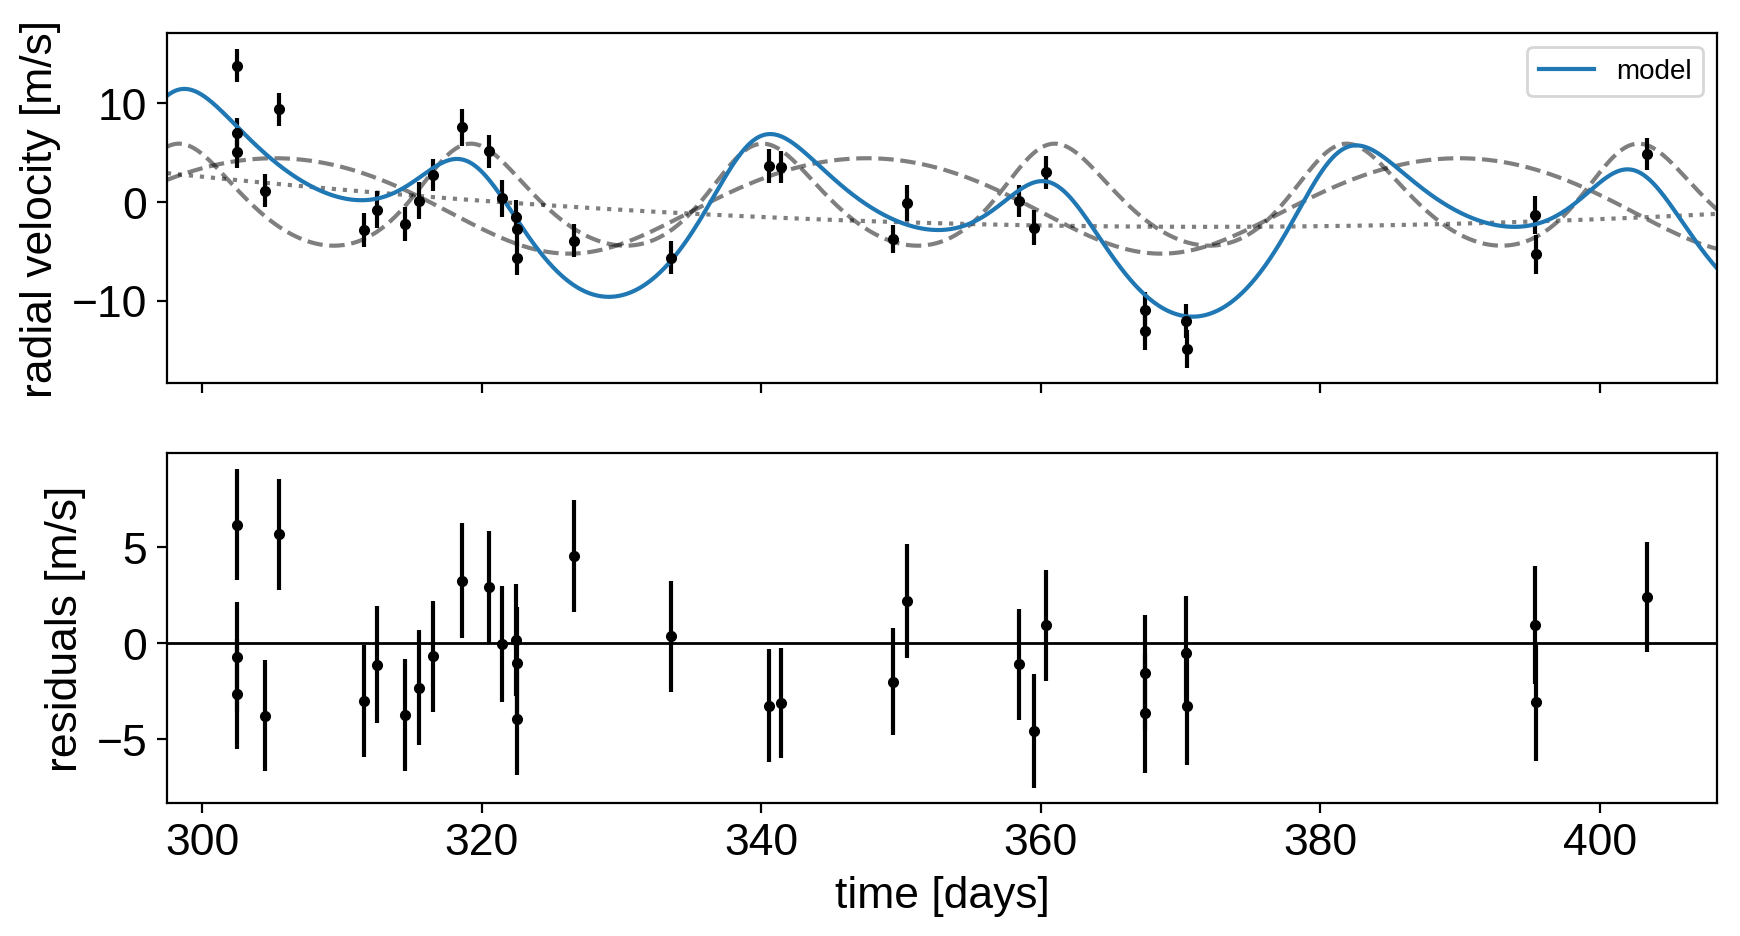

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")


plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

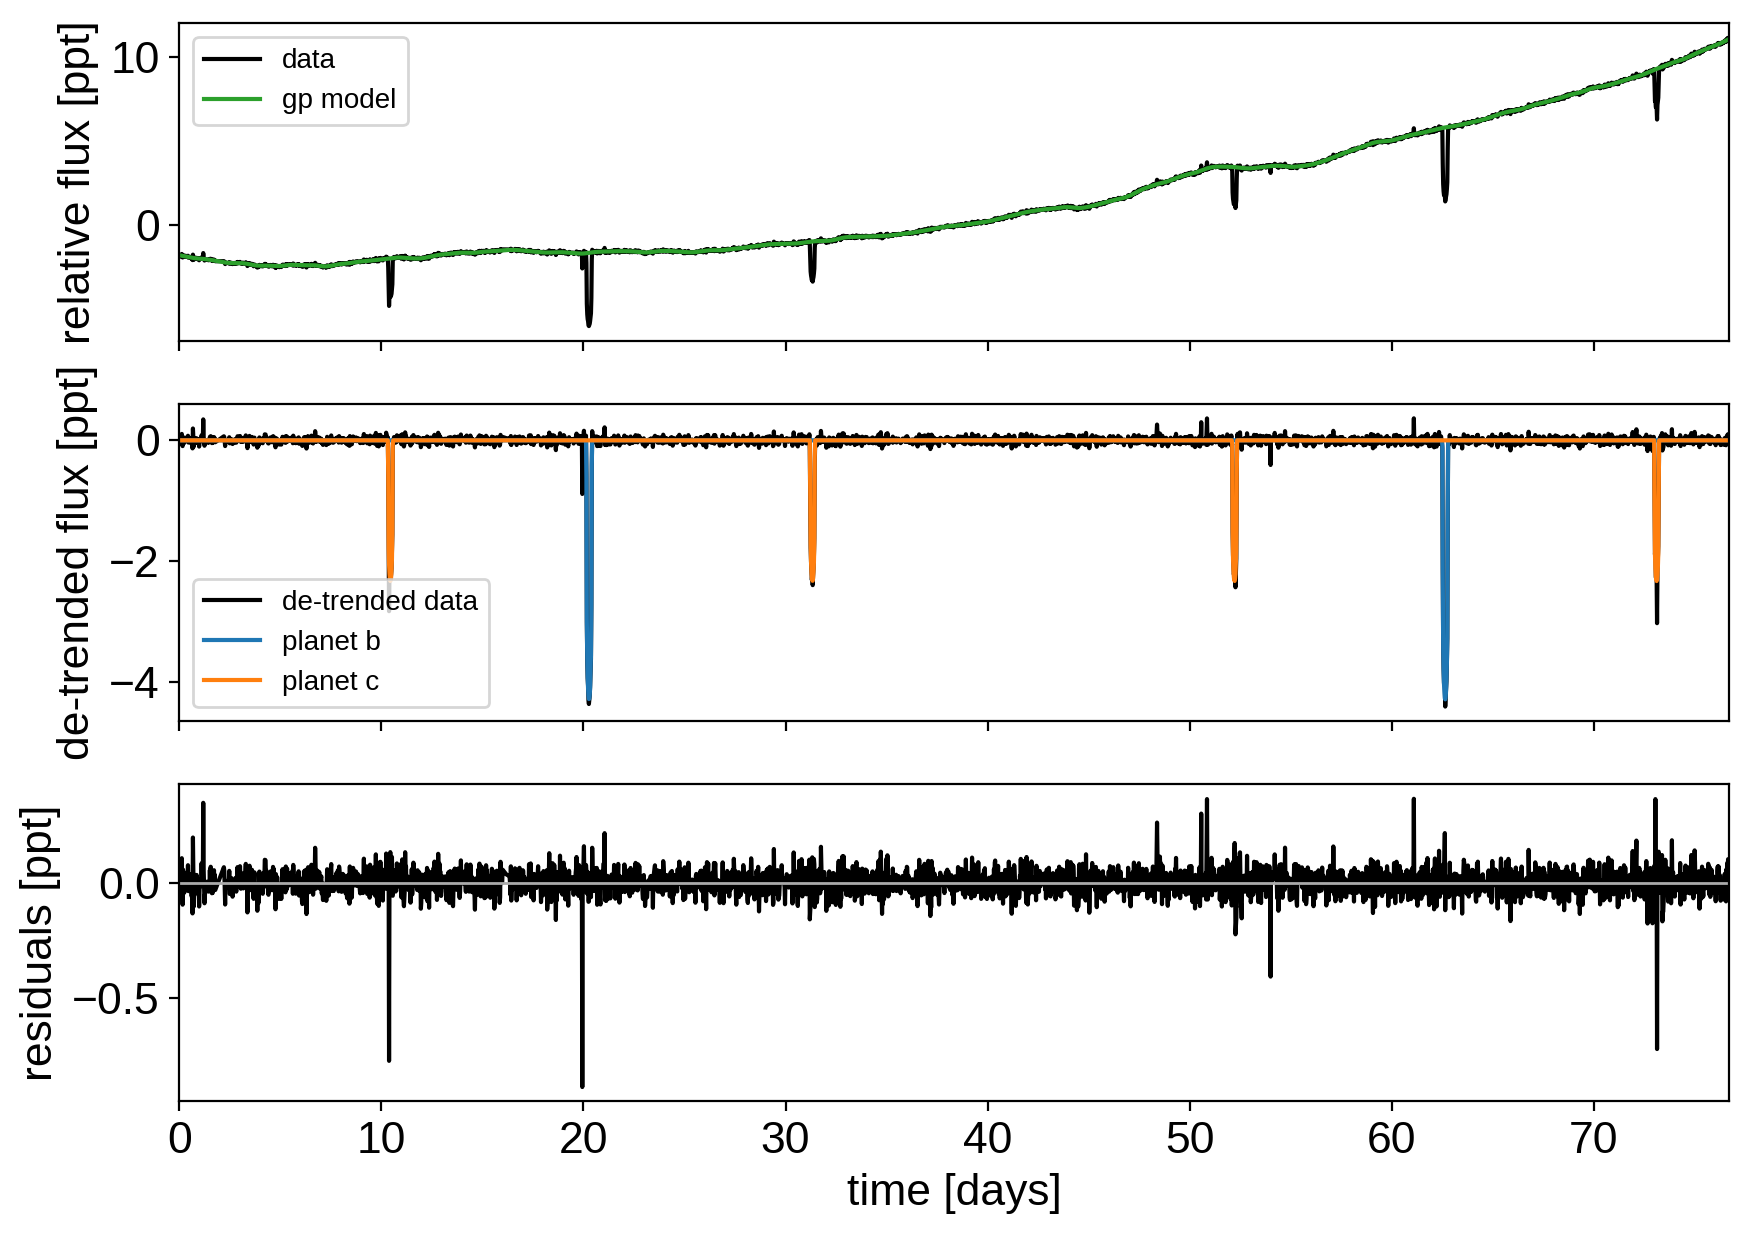

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

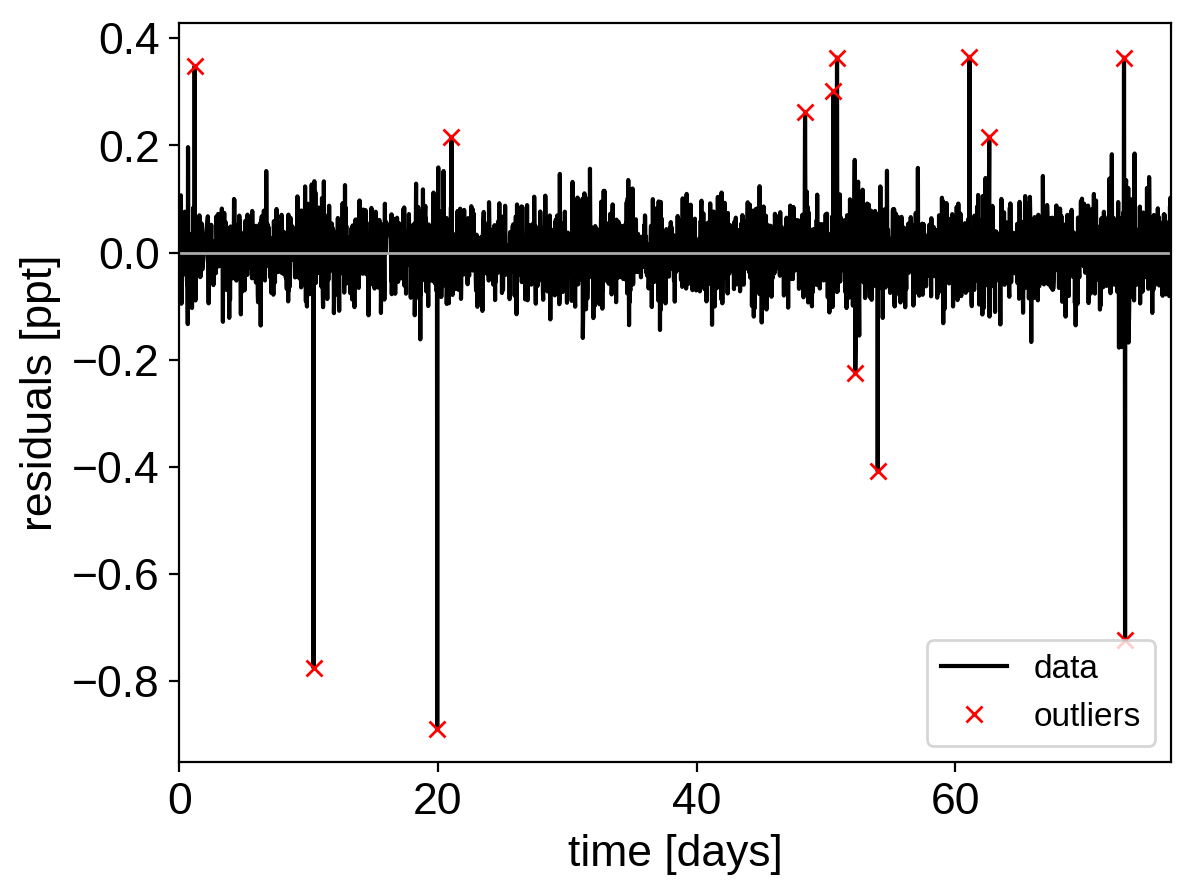

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.225381e+03]

1it [00:00, 117.06it/s, logp=5.225381e+03]

2it [00:00, 159.27it/s, logp=5.225381e+03]

3it [00:00, 179.55it/s, logp=5.213620e+03]

4it [00:00, 196.53it/s, logp=5.225381e+03]

5it [00:01,  2.95it/s, logp=5.225381e+03] 


message: Optimization terminated successfully.
logp: 5225.381218190808 -> 5225.381218190808


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.225381e+03]

1it [00:00, 152.32it/s, logp=5.225381e+03]

2it [00:00, 199.16it/s, logp=5.225381e+03]

3it [00:00, 150.39it/s, logp=4.837483e+03]

4it [00:00, 151.42it/s, logp=5.306928e+03]

5it [00:00, 155.50it/s, logp=5.307415e+03]

6it [00:00, 159.16it/s, logp=5.307429e+03]

7it [00:00, 164.77it/s, logp=5.307429e+03]

8it [00:00, 168.07it/s, logp=5.307429e+03]

9it [00:01,  6.10it/s, logp=5.307429e+03] 


message: Optimization terminated successfully.
logp: 5225.381218190808 -> 5307.42938442338


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.307429e+03]

1it [00:00, 66.51it/s, logp=5.307429e+03]

2it [00:00, 91.22it/s, logp=5.307429e+03]

3it [00:00, 105.66it/s, logp=-5.782804e+04]

4it [00:00, 117.62it/s, logp=5.311043e+03] 

5it [00:00, 127.80it/s, logp=5.248071e+03]

6it [00:00, 136.18it/s, logp=5.311239e+03]

7it [00:00, 144.37it/s, logp=5.311414e+03]

8it [00:00, 151.46it/s, logp=5.311688e+03]

9it [00:00, 157.32it/s, logp=5.312239e+03]

10it [00:00, 164.07it/s, logp=5.314205e+03]

11it [00:00, 169.81it/s, logp=5.286079e+03]

12it [00:00, 174.85it/s, logp=5.315289e+03]

13it [00:00, 177.68it/s, logp=5.297052e+03]

14it [00:00, 181.08it/s, logp=5.315596e+03]

15it [00:00, 184.17it/s, logp=5.316182e+03]

16it [00:00, 186.28it/s, logp=5.317200e+03]

17it [00:00, 189.19it/s, logp=5.318359e+03]

18it [00:00, 191.63it/s, logp=5.318392e+03]

19it [00:00, 192.40it/s, logp=5.318394e+03]

20it [00:00, 192.77it/s, logp=5.318396e+03]

21it [00:00, 200.60it/s, logp=5.318396e+03]

21it [00:00, 200.60it/s, logp=5.318396e+03]

22it [00:00, 200.60it/s, logp=5.318396e+03]

23it [00:00, 200.60it/s, logp=5.318396e+03]

24it [00:00, 200.60it/s, logp=5.318396e+03]

25it [00:00, 200.60it/s, logp=5.318396e+03]

26it [00:01, 16.44it/s, logp=5.318396e+03] 


message: Optimization terminated successfully.
logp: 5307.42938442338 -> 5318.395979595314


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.318396e+03]

1it [00:00, 142.31it/s, logp=5.318396e+03]

2it [00:00, 192.66it/s, logp=5.318396e+03]

3it [00:00, 208.23it/s, logp=-9.262911e+04]

4it [00:00, 217.44it/s, logp=-6.820869e+04]

5it [00:00, 228.94it/s, logp=-7.469762e+04]

6it [00:00, 237.43it/s, logp=-3.109141e+04]

7it [00:00, 246.14it/s, logp=5.309007e+03] 

8it [00:00, 250.95it/s, logp=5.318812e+03]

9it [00:00, 252.13it/s, logp=5.195525e+03]

10it [00:00, 255.23it/s, logp=5.318813e+03]

11it [00:00, 257.23it/s, logp=5.318816e+03]

12it [00:00, 259.80it/s, logp=5.318826e+03]

13it [00:00, 261.81it/s, logp=5.318866e+03]

14it [00:00, 263.93it/s, logp=5.319015e+03]

15it [00:00, 265.02it/s, logp=5.318834e+03]

16it [00:00, 266.54it/s, logp=5.319086e+03]

17it [00:00, 267.00it/s, logp=5.319221e+03]

18it [00:00, 267.29it/s, logp=5.319460e+03]

19it [00:00, 267.68it/s, logp=5.319758e+03]

20it [00:00, 267.86it/s, logp=5.319775e+03]

21it [00:00, 267.83it/s, logp=5.319775e+03]

22it [00:00, 267.08it/s, logp=5.319775e+03]

23it [00:00, 267.40it/s, logp=5.319775e+03]

24it [00:00, 267.67it/s, logp=5.319775e+03]

25it [00:00, 251.29it/s, logp=5.319775e+03]

26it [00:00, 258.73it/s, logp=5.319775e+03]

26it [00:00, 258.73it/s, logp=5.319775e+03]

27it [00:00, 258.73it/s, logp=5.319775e+03]

28it [00:00, 258.73it/s, logp=5.319775e+03]

29it [00:00, 258.73it/s, logp=5.319775e+03]

30it [00:00, 258.73it/s, logp=5.319775e+03]

31it [00:00, 258.73it/s, logp=5.319775e+03]

32it [00:00, 258.73it/s, logp=5.319775e+03]

33it [00:00, 258.73it/s, logp=5.319775e+03]

34it [00:00, 258.73it/s, logp=5.319775e+03]

35it [00:00, 258.73it/s, logp=5.319775e+03]

36it [00:00, 258.73it/s, logp=5.319775e+03]

37it [00:00, 258.73it/s, logp=5.319775e+03]

38it [00:00, 258.73it/s, logp=5.319775e+03]

39it [00:00, 258.73it/s, logp=5.319775e+03]

40it [00:00, 258.73it/s, logp=5.319775e+03]

41it [00:00, 258.73it/s, logp=5.319775e+03]

42it [00:00, 258.73it/s, logp=5.319775e+03]

43it [00:00, 258.73it/s, logp=5.319775e+03]

44it [00:00, 258.73it/s, logp=5.319775e+03]

45it [00:00, 258.73it/s, logp=5.319775e+03]

46it [00:00, 258.73it/s, logp=5.319775e+03]

47it [00:00, 258.73it/s, logp=5.319775e+03]

48it [00:00, 238.62it/s, logp=5.319775e+03]

48it [00:00, 238.62it/s, logp=5.319775e+03]

49it [00:00, 238.62it/s, logp=5.319775e+03]

50it [00:00, 238.62it/s, logp=5.319775e+03]

51it [00:00, 238.62it/s, logp=5.319775e+03]

52it [00:00, 238.62it/s, logp=5.319775e+03]

53it [00:00, 238.62it/s, logp=5.319775e+03]

54it [00:00, 238.62it/s, logp=5.319775e+03]

55it [00:00, 238.62it/s, logp=5.319775e+03]

56it [00:00, 238.62it/s, logp=5.319775e+03]

57it [00:00, 238.62it/s, logp=5.319775e+03]

58it [00:00, 238.62it/s, logp=5.319775e+03]

59it [00:00, 238.62it/s, logp=5.319775e+03]

60it [00:00, 238.62it/s, logp=5.319775e+03]

61it [00:00, 238.62it/s, logp=5.319775e+03]

62it [00:00, 238.62it/s, logp=5.319775e+03]

63it [00:00, 238.62it/s, logp=5.319775e+03]

64it [00:00, 238.62it/s, logp=5.319775e+03]

65it [00:00, 238.62it/s, logp=5.319775e+03]

66it [00:00, 238.62it/s, logp=5.319775e+03]

67it [00:00, 220.01it/s, logp=5.319775e+03]

67it [00:00, 220.01it/s, logp=5.319775e+03]

68it [00:00, 220.01it/s, logp=5.319775e+03]

69it [00:00, 220.01it/s, logp=5.319775e+03]

70it [00:00, 220.01it/s, logp=5.319775e+03]

71it [00:00, 220.01it/s, logp=5.319775e+03]

72it [00:00, 220.01it/s, logp=5.319775e+03]

73it [00:00, 220.01it/s, logp=5.319775e+03]

74it [00:00, 220.01it/s, logp=5.319775e+03]

75it [00:00, 220.01it/s, logp=5.319775e+03]

76it [00:00, 220.01it/s, logp=5.319775e+03]

77it [00:00, 220.01it/s, logp=5.319775e+03]

78it [00:00, 220.01it/s, logp=5.319775e+03]

79it [00:00, 220.01it/s, logp=5.319775e+03]

80it [00:00, 220.01it/s, logp=5.319775e+03]

81it [00:00, 220.01it/s, logp=5.319775e+03]

82it [00:00, 220.01it/s, logp=5.319775e+03]

83it [00:00, 220.01it/s, logp=5.319775e+03]

84it [00:00, 220.01it/s, logp=5.319775e+03]

85it [00:00, 205.16it/s, logp=5.319775e+03]

85it [00:00, 205.16it/s, logp=5.319775e+03]

86it [00:00, 205.16it/s, logp=5.319775e+03]

87it [00:00, 205.16it/s, logp=5.319775e+03]

88it [00:00, 205.16it/s, logp=5.319775e+03]

89it [00:00, 205.16it/s, logp=5.319775e+03]

90it [00:00, 205.16it/s, logp=5.319775e+03]

91it [00:00, 205.16it/s, logp=5.319775e+03]

92it [00:00, 205.16it/s, logp=5.319775e+03]

93it [00:00, 205.16it/s, logp=5.319775e+03]

94it [00:00, 205.16it/s, logp=5.319775e+03]

95it [00:00, 205.16it/s, logp=5.319775e+03]

96it [00:00, 205.16it/s, logp=5.319775e+03]

97it [00:00, 205.16it/s, logp=5.319775e+03]

98it [00:00, 205.16it/s, logp=5.319775e+03]

99it [00:00, 205.16it/s, logp=5.319775e+03]

100it [00:00, 205.16it/s, logp=5.319775e+03]

101it [00:00, 205.16it/s, logp=5.319775e+03]

102it [00:00, 191.48it/s, logp=5.319775e+03]

102it [00:00, 191.48it/s, logp=5.319775e+03]

103it [00:00, 191.48it/s, logp=5.319775e+03]

104it [00:00, 191.48it/s, logp=5.319775e+03]

105it [00:00, 191.48it/s, logp=5.319775e+03]

106it [00:00, 191.48it/s, logp=5.319775e+03]

107it [00:00, 191.48it/s, logp=5.319775e+03]

108it [00:00, 191.48it/s, logp=5.319775e+03]

109it [00:00, 191.48it/s, logp=5.319775e+03]

110it [00:00, 191.48it/s, logp=5.319775e+03]

111it [00:00, 191.48it/s, logp=5.319775e+03]

112it [00:00, 191.48it/s, logp=5.319775e+03]

113it [00:00, 191.48it/s, logp=5.319775e+03]

114it [00:00, 191.48it/s, logp=5.319775e+03]

115it [00:00, 191.48it/s, logp=5.319775e+03]

116it [00:00, 191.48it/s, logp=5.319775e+03]

117it [00:00, 191.48it/s, logp=5.319775e+03]

118it [00:00, 191.48it/s, logp=5.319775e+03]

119it [00:00, 191.48it/s, logp=5.319775e+03]

120it [00:00, 191.48it/s, logp=5.319775e+03]

121it [00:00, 191.48it/s, logp=5.319775e+03]

122it [00:00, 191.48it/s, logp=5.319775e+03]

123it [00:00, 191.48it/s, logp=5.319775e+03]

124it [00:00, 191.48it/s, logp=5.319775e+03]

125it [00:00, 191.48it/s, logp=5.319775e+03]

126it [00:00, 191.48it/s, logp=5.319775e+03]

127it [00:00, 191.48it/s, logp=5.319775e+03]

128it [00:00, 191.48it/s, logp=5.319775e+03]

129it [00:00, 191.48it/s, logp=5.319775e+03]

130it [00:00, 191.48it/s, logp=5.319775e+03]

131it [00:00, 212.87it/s, logp=5.319775e+03]

131it [00:00, 212.87it/s, logp=5.319775e+03]

132it [00:00, 212.87it/s, logp=5.319775e+03]

133it [00:00, 212.87it/s, logp=5.319775e+03]

134it [00:00, 212.87it/s, logp=5.319775e+03]

135it [00:00, 212.87it/s, logp=5.319775e+03]

136it [00:00, 212.87it/s, logp=5.319775e+03]

137it [00:00, 212.87it/s, logp=5.319775e+03]

138it [00:00, 212.87it/s, logp=5.319775e+03]

139it [00:00, 212.87it/s, logp=5.319775e+03]

140it [00:00, 212.87it/s, logp=5.319775e+03]

141it [00:00, 212.87it/s, logp=5.319775e+03]

142it [00:00, 212.87it/s, logp=5.319775e+03]

143it [00:00, 212.87it/s, logp=5.319775e+03]

144it [00:00, 212.87it/s, logp=5.319775e+03]

145it [00:00, 212.87it/s, logp=5.319775e+03]

146it [00:00, 212.87it/s, logp=5.319775e+03]

147it [00:00, 212.87it/s, logp=5.319775e+03]

148it [00:00, 212.87it/s, logp=5.319775e+03]

149it [00:00, 212.87it/s, logp=5.319775e+03]

150it [00:00, 212.87it/s, logp=5.319775e+03]

151it [00:00, 212.87it/s, logp=5.319775e+03]

152it [00:00, 212.87it/s, logp=5.319775e+03]

153it [00:00, 212.87it/s, logp=5.319775e+03]

154it [00:00, 212.87it/s, logp=5.319775e+03]

155it [00:00, 212.87it/s, logp=5.319775e+03]

156it [00:00, 212.87it/s, logp=5.319775e+03]

157it [00:00, 212.87it/s, logp=5.319775e+03]

158it [00:00, 212.87it/s, logp=5.319775e+03]

159it [00:00, 212.87it/s, logp=5.319775e+03]

160it [00:00, 212.87it/s, logp=5.319775e+03]

161it [00:00, 212.87it/s, logp=5.319775e+03]

162it [00:00, 212.87it/s, logp=5.319775e+03]

163it [00:00, 212.87it/s, logp=5.319775e+03]

164it [00:00, 237.70it/s, logp=5.319775e+03]

164it [00:00, 237.70it/s, logp=5.319775e+03]

165it [00:02, 67.62it/s, logp=5.319775e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5318.395979595323 -> 5319.775397150623


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.319775e+03]

1it [00:00, 127.39it/s, logp=5.319775e+03]

2it [00:00, 175.26it/s, logp=5.319775e+03]

3it [00:00, 153.33it/s, logp=4.623524e+03]

4it [00:00, 150.78it/s, logp=5.319857e+03]

5it [00:00, 150.63it/s, logp=5.320011e+03]

6it [00:00, 154.86it/s, logp=5.320272e+03]

7it [00:00, 157.55it/s, logp=5.320504e+03]

8it [00:00, 162.33it/s, logp=5.320504e+03]

9it [00:00, 167.48it/s, logp=5.320504e+03]

10it [00:01,  6.79it/s, logp=5.320504e+03]


message: Optimization terminated successfully.
logp: 5319.77539715063 -> 5320.5042723781


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.320504e+03]

1it [00:00, 123.53it/s, logp=5.320504e+03]

2it [00:00, 166.84it/s, logp=5.320504e+03]

3it [00:00, 188.56it/s, logp=5.285627e+03]

4it [00:00, 203.21it/s, logp=5.320392e+03]

5it [00:00, 214.79it/s, logp=5.320538e+03]

6it [00:00, 220.45it/s, logp=5.320538e+03]

7it [00:00, 223.37it/s, logp=5.320538e+03]

8it [00:00, 173.21it/s, logp=5.320538e+03]

9it [00:01,  6.11it/s, logp=5.320538e+03] 


message: Optimization terminated successfully.
logp: 5320.5042723781 -> 5320.538333858067


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.320538e+03]

1it [00:00, 107.45it/s, logp=5.320538e+03]

2it [00:00, 145.40it/s, logp=5.320538e+03]

3it [00:00, 162.60it/s, logp=-1.202945e+05]

4it [00:00, 169.29it/s, logp=-1.245807e+04]

5it [00:00, 176.12it/s, logp=5.320538e+03] 

6it [00:00, 175.49it/s, logp=5.320516e+03]

7it [00:00, 181.29it/s, logp=5.320538e+03]

8it [00:00, 184.79it/s, logp=5.320538e+03]

9it [00:00, 186.33it/s, logp=5.320538e+03]

10it [00:00, 187.10it/s, logp=5.320538e+03]

11it [00:00, 187.95it/s, logp=5.320539e+03]

12it [00:00, 189.62it/s, logp=5.320539e+03]

13it [00:00, 191.94it/s, logp=5.320539e+03]

14it [00:00, 194.01it/s, logp=5.320542e+03]

15it [00:00, 194.98it/s, logp=5.320535e+03]

16it [00:00, 180.57it/s, logp=5.320543e+03]

17it [00:00, 171.21it/s, logp=5.320544e+03]

18it [00:00, 179.42it/s, logp=5.320544e+03]

18it [00:00, 179.42it/s, logp=5.320541e+03]

19it [00:00, 179.42it/s, logp=5.320544e+03]

20it [00:00, 179.42it/s, logp=5.320545e+03]

21it [00:00, 179.42it/s, logp=5.320547e+03]

22it [00:00, 179.42it/s, logp=5.320551e+03]

23it [00:00, 179.42it/s, logp=5.320561e+03]

24it [00:00, 179.42it/s, logp=5.320595e+03]

25it [00:00, 179.42it/s, logp=5.320649e+03]

26it [00:00, 179.42it/s, logp=5.320753e+03]

27it [00:00, 179.42it/s, logp=5.321065e+03]

28it [00:00, 179.42it/s, logp=5.311794e+03]

29it [00:00, 179.42it/s, logp=5.321082e+03]

30it [00:00, 153.78it/s, logp=5.321082e+03]

30it [00:00, 153.78it/s, logp=5.321113e+03]

31it [00:00, 153.78it/s, logp=5.321165e+03]

32it [00:00, 153.78it/s, logp=5.321223e+03]

33it [00:00, 153.78it/s, logp=5.321335e+03]

34it [00:00, 153.78it/s, logp=5.321666e+03]

35it [00:00, 153.78it/s, logp=5.319433e+03]

36it [00:00, 153.78it/s, logp=5.321766e+03]

37it [00:00, 153.78it/s, logp=5.321606e+03]

38it [00:00, 153.78it/s, logp=5.321796e+03]

39it [00:00, 153.78it/s, logp=5.321844e+03]

40it [00:00, 153.78it/s, logp=5.321921e+03]

41it [00:00, 153.78it/s, logp=5.321863e+03]

42it [00:00, 153.78it/s, logp=5.321952e+03]

43it [00:00, 153.78it/s, logp=5.321997e+03]

44it [00:00, 153.78it/s, logp=5.322013e+03]

45it [00:00, 153.78it/s, logp=5.322040e+03]

46it [00:00, 153.78it/s, logp=5.322054e+03]

47it [00:00, 153.78it/s, logp=5.322076e+03]

48it [00:00, 153.78it/s, logp=5.322090e+03]

49it [00:00, 153.78it/s, logp=5.321937e+03]

50it [00:00, 153.78it/s, logp=5.322091e+03]

51it [00:00, 153.78it/s, logp=5.322092e+03]

52it [00:00, 167.79it/s, logp=5.322092e+03]

52it [00:00, 167.79it/s, logp=5.322095e+03]

53it [00:00, 167.79it/s, logp=5.322096e+03]

54it [00:00, 167.79it/s, logp=5.322097e+03]

55it [00:00, 167.79it/s, logp=5.322097e+03]

56it [00:00, 167.79it/s, logp=5.322098e+03]

57it [00:00, 167.79it/s, logp=5.322098e+03]

58it [00:00, 167.79it/s, logp=5.322098e+03]

59it [00:00, 167.79it/s, logp=5.322098e+03]

60it [00:00, 167.79it/s, logp=5.322098e+03]

61it [00:00, 167.79it/s, logp=5.322099e+03]

62it [00:00, 167.79it/s, logp=5.322099e+03]

63it [00:00, 167.79it/s, logp=5.322099e+03]

64it [00:00, 167.79it/s, logp=5.322099e+03]

65it [00:00, 167.79it/s, logp=5.322099e+03]

66it [00:00, 167.79it/s, logp=5.322099e+03]

67it [00:00, 167.79it/s, logp=5.322099e+03]

68it [00:00, 167.79it/s, logp=5.322099e+03]

69it [00:00, 167.79it/s, logp=5.322099e+03]

70it [00:00, 167.79it/s, logp=5.322099e+03]

71it [00:00, 167.79it/s, logp=5.322099e+03]

72it [00:00, 167.79it/s, logp=5.322099e+03]

73it [00:00, 167.79it/s, logp=5.322099e+03]

74it [00:00, 179.32it/s, logp=5.322099e+03]

74it [00:00, 179.32it/s, logp=5.322099e+03]

75it [00:00, 179.32it/s, logp=5.322099e+03]

76it [00:00, 179.32it/s, logp=5.322099e+03]

77it [00:00, 179.32it/s, logp=5.322099e+03]

78it [00:00, 179.32it/s, logp=5.322099e+03]

79it [00:00, 179.32it/s, logp=5.322099e+03]

80it [00:00, 179.32it/s, logp=5.322099e+03]

81it [00:00, 179.32it/s, logp=5.322099e+03]

82it [00:00, 179.32it/s, logp=5.322099e+03]

83it [00:00, 179.32it/s, logp=5.322099e+03]

84it [00:00, 179.32it/s, logp=5.322099e+03]

85it [00:00, 179.32it/s, logp=5.322099e+03]

86it [00:00, 179.32it/s, logp=5.322099e+03]

87it [00:00, 179.32it/s, logp=5.322099e+03]

88it [00:00, 179.32it/s, logp=5.322099e+03]

89it [00:00, 179.32it/s, logp=5.322099e+03]

90it [00:00, 179.32it/s, logp=5.322099e+03]

91it [00:00, 179.32it/s, logp=5.322099e+03]

92it [00:00, 179.32it/s, logp=5.322099e+03]

93it [00:00, 179.32it/s, logp=5.322099e+03]

94it [00:00, 179.32it/s, logp=5.322099e+03]

95it [00:00, 179.32it/s, logp=5.322099e+03]

96it [00:00, 189.22it/s, logp=5.322099e+03]

96it [00:00, 189.22it/s, logp=5.322099e+03]

97it [00:00, 189.22it/s, logp=5.322099e+03]

98it [00:00, 189.22it/s, logp=5.322099e+03]

99it [00:00, 189.22it/s, logp=5.322099e+03]

100it [00:00, 189.22it/s, logp=5.322099e+03]

101it [00:00, 189.22it/s, logp=5.322099e+03]

102it [00:00, 189.22it/s, logp=5.322099e+03]

103it [00:00, 189.22it/s, logp=5.322099e+03]

104it [00:00, 189.22it/s, logp=5.322099e+03]

105it [00:00, 189.22it/s, logp=5.322099e+03]

106it [00:00, 189.22it/s, logp=5.322099e+03]

107it [00:00, 189.22it/s, logp=5.322099e+03]

108it [00:00, 189.22it/s, logp=5.322099e+03]

109it [00:00, 189.22it/s, logp=5.322099e+03]

110it [00:00, 189.22it/s, logp=5.322099e+03]

111it [00:00, 189.22it/s, logp=5.322099e+03]

112it [00:00, 189.22it/s, logp=5.322099e+03]

113it [00:00, 189.22it/s, logp=5.322099e+03]

114it [00:00, 189.22it/s, logp=5.322099e+03]

115it [00:00, 189.22it/s, logp=5.322099e+03]

116it [00:00, 189.22it/s, logp=5.322099e+03]

117it [00:00, 193.88it/s, logp=5.322099e+03]

117it [00:00, 193.88it/s, logp=5.322099e+03]

118it [00:00, 193.88it/s, logp=5.322099e+03]

119it [00:00, 193.88it/s, logp=5.322099e+03]

120it [00:00, 193.88it/s, logp=5.322099e+03]

121it [00:00, 193.88it/s, logp=5.322099e+03]

122it [00:00, 193.88it/s, logp=5.322099e+03]

123it [00:00, 193.88it/s, logp=5.322099e+03]

124it [00:00, 193.88it/s, logp=5.322099e+03]

125it [00:00, 193.88it/s, logp=5.322099e+03]

126it [00:00, 193.88it/s, logp=5.322099e+03]

127it [00:00, 193.88it/s, logp=5.322099e+03]

128it [00:00, 193.88it/s, logp=5.322099e+03]

129it [00:00, 193.88it/s, logp=5.322099e+03]

130it [00:00, 193.88it/s, logp=5.322099e+03]

131it [00:00, 193.88it/s, logp=5.322099e+03]

132it [00:00, 193.88it/s, logp=5.322099e+03]

133it [00:00, 193.88it/s, logp=5.322099e+03]

134it [00:00, 193.88it/s, logp=5.322099e+03]

135it [00:00, 184.08it/s, logp=5.322099e+03]

135it [00:00, 184.08it/s, logp=5.322099e+03]

136it [00:00, 184.08it/s, logp=5.322099e+03]

137it [00:00, 184.08it/s, logp=5.322099e+03]

138it [00:00, 184.08it/s, logp=5.322099e+03]

139it [00:00, 184.08it/s, logp=5.322099e+03]

140it [00:00, 184.08it/s, logp=5.322099e+03]

141it [00:02, 55.68it/s, logp=5.322099e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5320.538333858038 -> 5322.099130377621


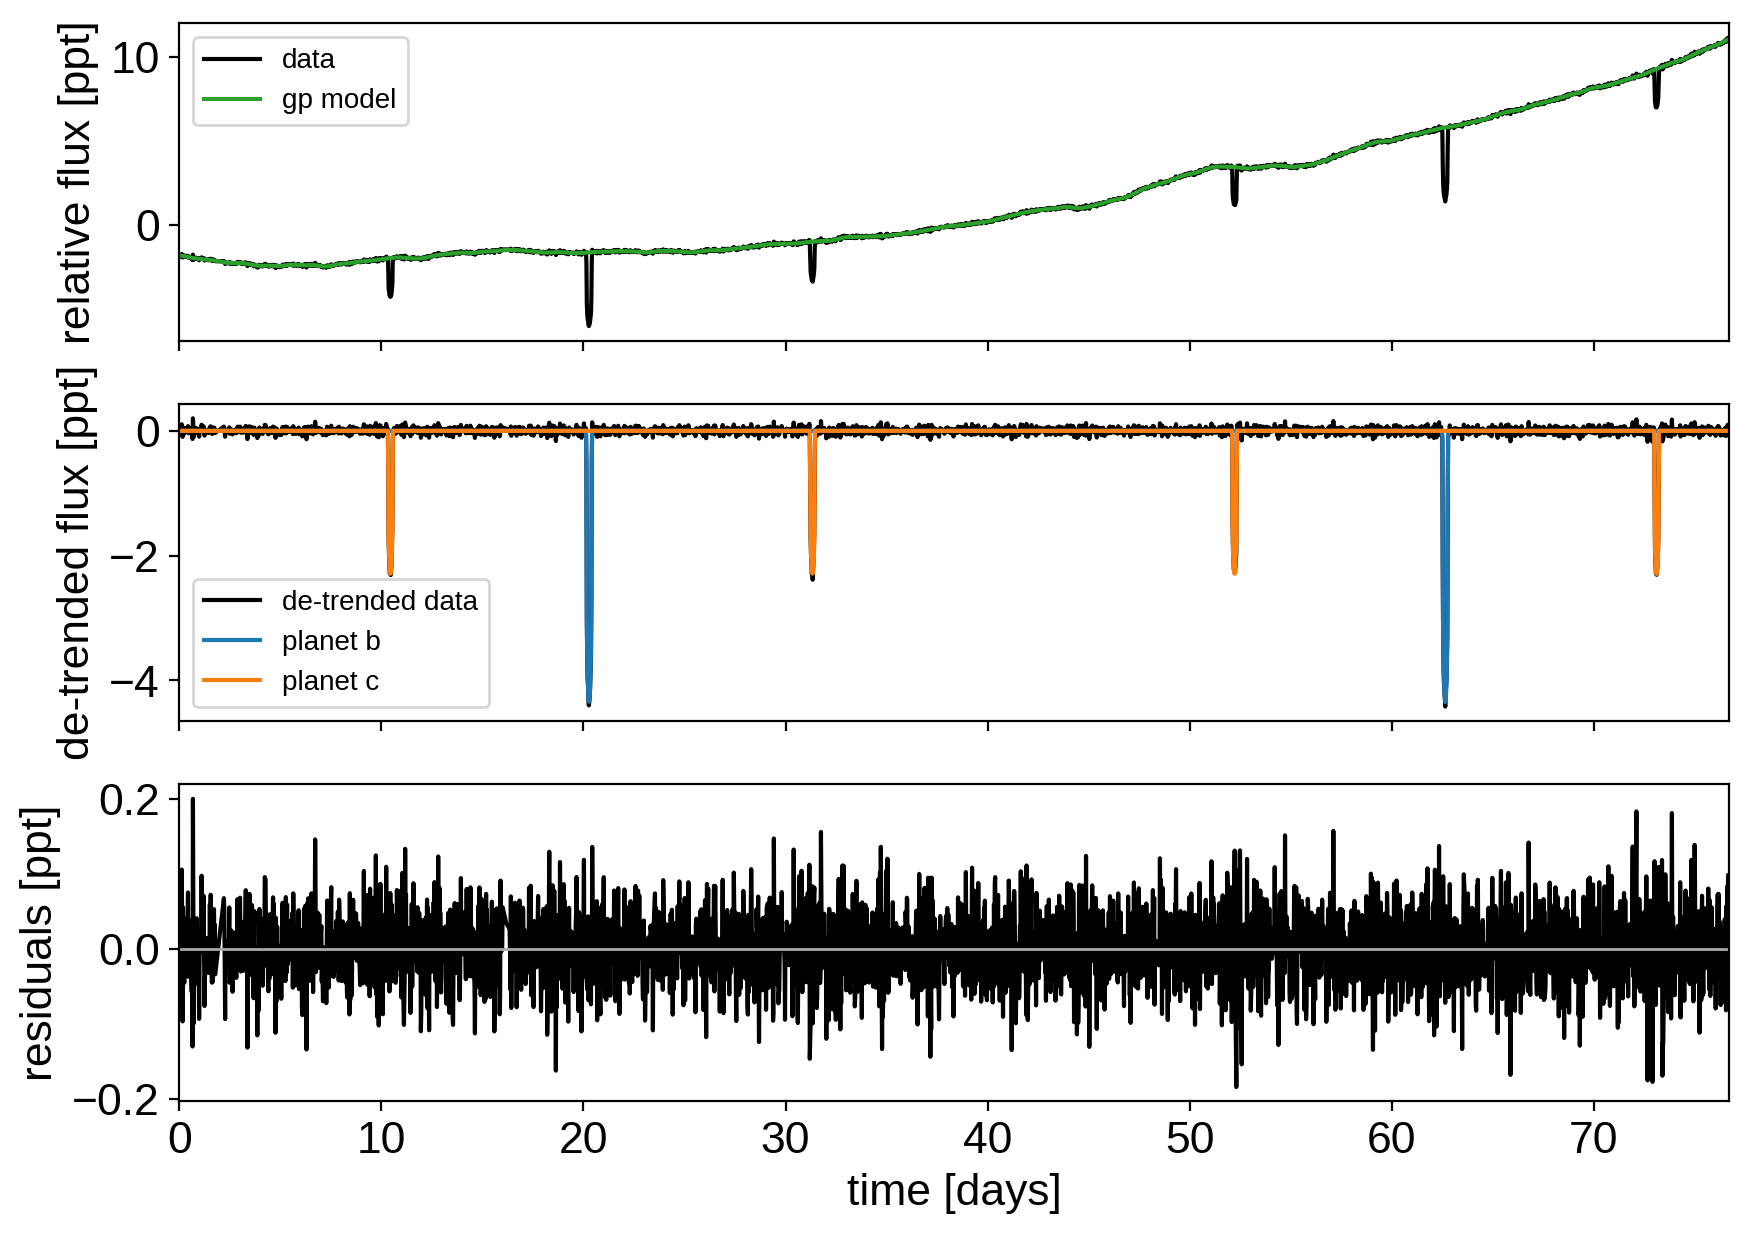

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [14]:
np.random.seed(123)
with model:
    trace = pm.sample(
        tune=6000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/36000 [00:00<22:26, 26.73draws/s]

Sampling 4 chains:   0%|          | 24/36000 [00:00<23:22, 25.66draws/s]

Sampling 4 chains:   0%|          | 26/36000 [00:01<1:17:46,  7.71draws/s]

Sampling 4 chains:   0%|          | 29/36000 [00:02<1:35:26,  6.28draws/s]

Sampling 4 chains:   0%|          | 32/36000 [00:02<1:13:20,  8.17draws/s]

Sampling 4 chains:   0%|          | 34/36000 [00:02<1:42:55,  5.82draws/s]

Sampling 4 chains:   0%|          | 36/36000 [00:03<1:21:59,  7.31draws/s]

Sampling 4 chains:   0%|          | 38/36000 [00:03<1:48:17,  5.53draws/s]

Sampling 4 chains:   0%|          | 40/36000 [00:03<1:25:43,  6.99draws/s]

Sampling 4 chains:   0%|          | 42/36000 [00:04<1:51:32,  5.37draws/s]

Sampling 4 chains:   0%|          | 43/36000 [00:04<1:37:09,  6.17draws/s]

Sampling 4 chains:   0%|          | 45/36000 [00:04<1:58:35,  5.05draws/s]

Sampling 4 chains:   0%|          | 47/36000 [00:05<1:33:48,  6.39draws/s]

Sampling 4 chains:   0%|          | 49/36000 [00:05<1:55:34,  5.18draws/s]

Sampling 4 chains:   0%|          | 51/36000 [00:05<1:32:20,  6.49draws/s]

Sampling 4 chains:   0%|          | 53/36000 [00:06<1:53:50,  5.26draws/s]

Sampling 4 chains:   0%|          | 55/36000 [00:06<1:32:05,  6.51draws/s]

Sampling 4 chains:   0%|          | 57/36000 [00:07<1:55:53,  5.17draws/s]

Sampling 4 chains:   0%|          | 59/36000 [00:07<1:33:34,  6.40draws/s]

Sampling 4 chains:   0%|          | 61/36000 [00:07<1:55:32,  5.18draws/s]

Sampling 4 chains:   0%|          | 63/36000 [00:07<1:31:23,  6.55draws/s]

Sampling 4 chains:   0%|          | 65/36000 [00:08<1:54:58,  5.21draws/s]

Sampling 4 chains:   0%|          | 67/36000 [00:08<1:29:59,  6.66draws/s]

Sampling 4 chains:   0%|          | 69/36000 [00:09<1:57:08,  5.11draws/s]

Sampling 4 chains:   0%|          | 72/36000 [00:09<1:34:05,  6.36draws/s]

Sampling 4 chains:   0%|          | 74/36000 [00:09<1:51:36,  5.37draws/s]

Sampling 4 chains:   0%|          | 76/36000 [00:10<1:33:33,  6.40draws/s]

Sampling 4 chains:   0%|          | 77/36000 [00:10<2:35:59,  3.84draws/s]

Sampling 4 chains:   0%|          | 80/36000 [00:10<1:59:36,  5.01draws/s]

Sampling 4 chains:   0%|          | 82/36000 [00:11<2:10:49,  4.58draws/s]

Sampling 4 chains:   0%|          | 84/36000 [00:11<1:45:52,  5.65draws/s]

Sampling 4 chains:   0%|          | 85/36000 [00:11<2:42:45,  3.68draws/s]

Sampling 4 chains:   0%|          | 88/36000 [00:12<2:08:18,  4.66draws/s]

Sampling 4 chains:   0%|          | 89/36000 [00:12<2:55:05,  3.42draws/s]

Sampling 4 chains:   0%|          | 92/36000 [00:12<2:15:23,  4.42draws/s]

Sampling 4 chains:   0%|          | 93/36000 [00:13<2:56:31,  3.39draws/s]

Sampling 4 chains:   0%|          | 95/36000 [00:13<2:13:12,  4.49draws/s]

Sampling 4 chains:   0%|          | 97/36000 [00:13<2:24:03,  4.15draws/s]

Sampling 4 chains:   0%|          | 99/36000 [00:14<1:52:46,  5.31draws/s]

Sampling 4 chains:   0%|          | 101/36000 [00:14<2:07:11,  4.70draws/s]

Sampling 4 chains:   0%|          | 102/36000 [00:14<1:55:34,  5.18draws/s]

Sampling 4 chains:   0%|          | 105/36000 [00:15<1:52:01,  5.34draws/s]

Sampling 4 chains:   0%|          | 106/36000 [00:15<1:45:39,  5.66draws/s]

Sampling 4 chains:   0%|          | 109/36000 [00:15<1:47:10,  5.58draws/s]

Sampling 4 chains:   0%|          | 110/36000 [00:16<1:36:33,  6.20draws/s]

Sampling 4 chains:   0%|          | 113/36000 [00:16<1:41:09,  5.91draws/s]

Sampling 4 chains:   0%|          | 114/36000 [00:16<1:31:11,  6.56draws/s]

Sampling 4 chains:   0%|          | 116/36000 [00:16<1:12:55,  8.20draws/s]

Sampling 4 chains:   0%|          | 118/36000 [00:17<1:42:04,  5.86draws/s]

Sampling 4 chains:   0%|          | 120/36000 [00:17<1:20:50,  7.40draws/s]

Sampling 4 chains:   0%|          | 122/36000 [00:18<1:47:26,  5.57draws/s]

Sampling 4 chains:   0%|          | 125/36000 [00:18<1:21:38,  7.32draws/s]

Sampling 4 chains:   0%|          | 127/36000 [00:18<1:50:11,  5.43draws/s]

Sampling 4 chains:   0%|          | 130/36000 [00:19<1:51:45,  5.35draws/s]

Sampling 4 chains:   0%|          | 131/36000 [00:19<1:41:33,  5.89draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:19<1:21:38,  7.32draws/s]

Sampling 4 chains:   0%|          | 135/36000 [00:20<1:50:30,  5.41draws/s]

Sampling 4 chains:   0%|          | 137/36000 [00:20<1:34:51,  6.30draws/s]

Sampling 4 chains:   0%|          | 138/36000 [00:20<2:22:45,  4.19draws/s]

Sampling 4 chains:   0%|          | 140/36000 [00:21<1:56:30,  5.13draws/s]

Sampling 4 chains:   0%|          | 141/36000 [00:21<1:41:48,  5.87draws/s]

Sampling 4 chains:   0%|          | 142/36000 [00:21<2:27:37,  4.05draws/s]

Sampling 4 chains:   0%|          | 144/36000 [00:21<1:57:08,  5.10draws/s]

Sampling 4 chains:   0%|          | 145/36000 [00:21<1:51:33,  5.36draws/s]

Sampling 4 chains:   0%|          | 146/36000 [00:22<2:28:47,  4.02draws/s]

Sampling 4 chains:   0%|          | 148/36000 [00:22<1:58:00,  5.06draws/s]

Sampling 4 chains:   0%|          | 149/36000 [00:22<2:11:42,  4.54draws/s]

Sampling 4 chains:   0%|          | 150/36000 [00:23<2:26:54,  4.07draws/s]

Sampling 4 chains:   0%|          | 152/36000 [00:23<1:56:08,  5.14draws/s]

Sampling 4 chains:   0%|          | 153/36000 [00:23<2:01:04,  4.93draws/s]

Sampling 4 chains:   0%|          | 154/36000 [00:23<2:29:46,  3.99draws/s]

Sampling 4 chains:   0%|          | 156/36000 [00:23<1:57:10,  5.10draws/s]

Sampling 4 chains:   0%|          | 157/36000 [00:24<2:06:06,  4.74draws/s]

Sampling 4 chains:   0%|          | 158/36000 [00:24<2:29:23,  4.00draws/s]

Sampling 4 chains:   0%|          | 159/36000 [00:24<2:05:23,  4.76draws/s]

Sampling 4 chains:   0%|          | 161/36000 [00:24<1:49:52,  5.44draws/s]

Sampling 4 chains:   0%|          | 162/36000 [00:25<2:24:11,  4.14draws/s]

Sampling 4 chains:   0%|          | 165/36000 [00:25<2:03:45,  4.83draws/s]

Sampling 4 chains:   0%|          | 166/36000 [00:25<2:24:10,  4.14draws/s]

Sampling 4 chains:   0%|          | 167/36000 [00:26<2:01:43,  4.91draws/s]

Sampling 4 chains:   0%|          | 169/36000 [00:26<1:50:41,  5.40draws/s]

Sampling 4 chains:   0%|          | 170/36000 [00:26<2:20:50,  4.24draws/s]

Sampling 4 chains:   0%|          | 172/36000 [00:26<2:00:20,  4.96draws/s]

Sampling 4 chains:   0%|          | 173/36000 [00:27<1:57:21,  5.09draws/s]

Sampling 4 chains:   0%|          | 174/36000 [00:27<2:12:39,  4.50draws/s]

Sampling 4 chains:   0%|          | 176/36000 [00:27<2:00:37,  4.95draws/s]

Sampling 4 chains:   0%|          | 177/36000 [00:27<1:54:33,  5.21draws/s]

Sampling 4 chains:   0%|          | 178/36000 [00:28<2:05:48,  4.75draws/s]

Sampling 4 chains:   0%|          | 180/36000 [00:28<2:02:47,  4.86draws/s]

Sampling 4 chains:   1%|          | 181/36000 [00:28<1:46:56,  5.58draws/s]

Sampling 4 chains:   1%|          | 182/36000 [00:28<1:48:25,  5.51draws/s]

Sampling 4 chains:   1%|          | 184/36000 [00:29<2:01:36,  4.91draws/s]

Sampling 4 chains:   1%|          | 186/36000 [00:29<1:46:57,  5.58draws/s]

Sampling 4 chains:   1%|          | 188/36000 [00:30<2:00:48,  4.94draws/s]

Sampling 4 chains:   1%|          | 190/36000 [00:30<1:42:32,  5.82draws/s]

Sampling 4 chains:   1%|          | 192/36000 [00:30<1:58:11,  5.05draws/s]

Sampling 4 chains:   1%|          | 193/36000 [00:30<1:47:47,  5.54draws/s]

Sampling 4 chains:   1%|          | 194/36000 [00:31<1:39:47,  5.98draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:31<1:48:04,  5.52draws/s]

Sampling 4 chains:   1%|          | 197/36000 [00:31<1:47:56,  5.53draws/s]

Sampling 4 chains:   1%|          | 199/36000 [00:31<1:30:13,  6.61draws/s]

Sampling 4 chains:   1%|          | 200/36000 [00:32<2:08:44,  4.63draws/s]

Sampling 4 chains:   1%|          | 201/36000 [00:32<2:04:21,  4.80draws/s]

Sampling 4 chains:   1%|          | 203/36000 [00:32<1:39:57,  5.97draws/s]

Sampling 4 chains:   1%|          | 204/36000 [00:32<2:19:58,  4.26draws/s]

Sampling 4 chains:   1%|          | 205/36000 [00:33<2:11:33,  4.53draws/s]

Sampling 4 chains:   1%|          | 206/36000 [00:33<1:51:31,  5.35draws/s]

Sampling 4 chains:   1%|          | 208/36000 [00:33<1:55:41,  5.16draws/s]

Sampling 4 chains:   1%|          | 209/36000 [00:33<2:01:57,  4.89draws/s]

Sampling 4 chains:   1%|          | 210/36000 [00:34<1:44:34,  5.70draws/s]

Sampling 4 chains:   1%|          | 212/36000 [00:34<1:45:19,  5.66draws/s]

Sampling 4 chains:   1%|          | 213/36000 [00:34<2:09:51,  4.59draws/s]

Sampling 4 chains:   1%|          | 216/36000 [00:35<1:54:30,  5.21draws/s]

Sampling 4 chains:   1%|          | 217/36000 [00:35<2:11:49,  4.52draws/s]

Sampling 4 chains:   1%|          | 220/36000 [00:35<1:55:48,  5.15draws/s]

Sampling 4 chains:   1%|          | 221/36000 [00:36<2:16:49,  4.36draws/s]

Sampling 4 chains:   1%|          | 223/36000 [00:36<1:47:32,  5.54draws/s]

Sampling 4 chains:   1%|          | 224/36000 [00:36<2:05:08,  4.76draws/s]

Sampling 4 chains:   1%|          | 225/36000 [00:36<2:22:43,  4.18draws/s]

Sampling 4 chains:   1%|          | 227/36000 [00:36<1:55:08,  5.18draws/s]

Sampling 4 chains:   1%|          | 228/36000 [00:37<2:05:55,  4.73draws/s]

Sampling 4 chains:   1%|          | 229/36000 [00:37<2:26:55,  4.06draws/s]

Sampling 4 chains:   1%|          | 231/36000 [00:37<1:58:22,  5.04draws/s]

Sampling 4 chains:   1%|          | 232/36000 [00:37<1:55:43,  5.15draws/s]

Sampling 4 chains:   1%|          | 233/36000 [00:38<2:27:00,  4.05draws/s]

Sampling 4 chains:   1%|          | 235/36000 [00:38<2:04:45,  4.78draws/s]

Sampling 4 chains:   1%|          | 237/36000 [00:38<2:10:04,  4.58draws/s]

Sampling 4 chains:   1%|          | 239/36000 [00:39<1:57:23,  5.08draws/s]

Sampling 4 chains:   1%|          | 241/36000 [00:39<2:00:47,  4.93draws/s]

Sampling 4 chains:   1%|          | 243/36000 [00:40<1:53:21,  5.26draws/s]

Sampling 4 chains:   1%|          | 245/36000 [00:40<2:02:24,  4.87draws/s]

Sampling 4 chains:   1%|          | 247/36000 [00:40<1:48:39,  5.48draws/s]

Sampling 4 chains:   1%|          | 249/36000 [00:41<2:00:59,  4.92draws/s]

Sampling 4 chains:   1%|          | 251/36000 [00:41<1:42:28,  5.81draws/s]

Sampling 4 chains:   1%|          | 253/36000 [00:42<1:59:30,  4.99draws/s]

Sampling 4 chains:   1%|          | 255/36000 [00:42<1:39:53,  5.96draws/s]

Sampling 4 chains:   1%|          | 257/36000 [00:42<1:57:40,  5.06draws/s]

Sampling 4 chains:   1%|          | 259/36000 [00:42<1:39:36,  5.98draws/s]

Sampling 4 chains:   1%|          | 261/36000 [00:43<1:57:04,  5.09draws/s]

Sampling 4 chains:   1%|          | 263/36000 [00:43<1:40:15,  5.94draws/s]

Sampling 4 chains:   1%|          | 265/36000 [00:44<1:57:33,  5.07draws/s]

Sampling 4 chains:   1%|          | 267/36000 [00:44<1:40:38,  5.92draws/s]

Sampling 4 chains:   1%|          | 269/36000 [00:44<1:55:09,  5.17draws/s]

Sampling 4 chains:   1%|          | 271/36000 [00:45<1:40:29,  5.93draws/s]

Sampling 4 chains:   1%|          | 273/36000 [00:45<1:53:29,  5.25draws/s]

Sampling 4 chains:   1%|          | 274/36000 [00:45<1:39:01,  6.01draws/s]

Sampling 4 chains:   1%|          | 275/36000 [00:45<1:35:02,  6.27draws/s]

Sampling 4 chains:   1%|          | 277/36000 [00:46<1:51:09,  5.36draws/s]

Sampling 4 chains:   1%|          | 278/36000 [00:46<1:37:18,  6.12draws/s]

Sampling 4 chains:   1%|          | 279/36000 [00:46<1:29:10,  6.68draws/s]

Sampling 4 chains:   1%|          | 281/36000 [00:47<1:46:39,  5.58draws/s]

Sampling 4 chains:   1%|          | 282/36000 [00:47<1:37:16,  6.12draws/s]

Sampling 4 chains:   1%|          | 284/36000 [00:47<1:22:19,  7.23draws/s]

Sampling 4 chains:   1%|          | 285/36000 [00:47<2:14:22,  4.43draws/s]

Sampling 4 chains:   1%|          | 286/36000 [00:47<2:04:50,  4.77draws/s]

Sampling 4 chains:   1%|          | 288/36000 [00:48<1:38:59,  6.01draws/s]

Sampling 4 chains:   1%|          | 289/36000 [00:48<2:26:44,  4.06draws/s]

Sampling 4 chains:   1%|          | 290/36000 [00:48<2:22:33,  4.18draws/s]

Sampling 4 chains:   1%|          | 292/36000 [00:48<1:54:27,  5.20draws/s]

Sampling 4 chains:   1%|          | 293/36000 [00:49<2:24:27,  4.12draws/s]

Sampling 4 chains:   1%|          | 294/36000 [00:49<2:25:16,  4.10draws/s]

Sampling 4 chains:   1%|          | 296/36000 [00:49<1:54:46,  5.18draws/s]

Sampling 4 chains:   1%|          | 297/36000 [00:50<2:23:40,  4.14draws/s]

Sampling 4 chains:   1%|          | 298/36000 [00:50<2:31:19,  3.93draws/s]

Sampling 4 chains:   1%|          | 300/36000 [00:50<1:58:00,  5.04draws/s]

Sampling 4 chains:   1%|          | 301/36000 [00:50<2:55:54,  3.38draws/s]

Sampling 4 chains:   1%|          | 302/36000 [00:51<2:26:41,  4.06draws/s]

Sampling 4 chains:   1%|          | 304/36000 [00:51<1:54:34,  5.19draws/s]

Sampling 4 chains:   1%|          | 305/36000 [00:51<2:51:08,  3.48draws/s]

Sampling 4 chains:   1%|          | 307/36000 [00:51<2:21:11,  4.21draws/s]

Sampling 4 chains:   1%|          | 309/36000 [00:52<2:22:08,  4.18draws/s]

Sampling 4 chains:   1%|          | 310/36000 [00:52<2:00:07,  4.95draws/s]

Sampling 4 chains:   1%|          | 311/36000 [00:52<1:46:10,  5.60draws/s]

Sampling 4 chains:   1%|          | 313/36000 [00:53<1:59:42,  4.97draws/s]

Sampling 4 chains:   1%|          | 314/36000 [00:53<1:49:16,  5.44draws/s]

Sampling 4 chains:   1%|          | 316/36000 [00:53<1:40:00,  5.95draws/s]

Sampling 4 chains:   1%|          | 317/36000 [00:54<2:24:48,  4.11draws/s]

Sampling 4 chains:   1%|          | 319/36000 [00:54<1:58:16,  5.03draws/s]

Sampling 4 chains:   1%|          | 320/36000 [00:54<1:48:14,  5.49draws/s]

Sampling 4 chains:   1%|          | 321/36000 [00:54<2:29:32,  3.98draws/s]

Sampling 4 chains:   1%|          | 323/36000 [00:55<2:05:52,  4.72draws/s]

Sampling 4 chains:   1%|          | 325/36000 [00:55<2:12:37,  4.48draws/s]

Sampling 4 chains:   1%|          | 327/36000 [00:55<1:55:03,  5.17draws/s]

Sampling 4 chains:   1%|          | 329/36000 [00:56<2:08:23,  4.63draws/s]

Sampling 4 chains:   1%|          | 331/36000 [00:56<1:48:39,  5.47draws/s]

Sampling 4 chains:   1%|          | 333/36000 [00:57<2:07:05,  4.68draws/s]

Sampling 4 chains:   1%|          | 335/36000 [00:57<1:43:02,  5.77draws/s]

Sampling 4 chains:   1%|          | 336/36000 [00:57<1:43:45,  5.73draws/s]

Sampling 4 chains:   1%|          | 337/36000 [00:57<2:34:02,  3.86draws/s]

Sampling 4 chains:   1%|          | 339/36000 [00:57<1:57:04,  5.08draws/s]

Sampling 4 chains:   1%|          | 340/36000 [00:58<1:51:14,  5.34draws/s]

Sampling 4 chains:   1%|          | 341/36000 [00:58<2:41:13,  3.69draws/s]

Sampling 4 chains:   1%|          | 343/36000 [00:58<2:02:52,  4.84draws/s]

Sampling 4 chains:   1%|          | 345/36000 [00:59<2:20:35,  4.23draws/s]

Sampling 4 chains:   1%|          | 347/36000 [00:59<1:52:36,  5.28draws/s]

Sampling 4 chains:   1%|          | 348/36000 [00:59<2:19:33,  4.26draws/s]

Sampling 4 chains:   1%|          | 349/36000 [01:00<2:15:04,  4.40draws/s]

Sampling 4 chains:   1%|          | 351/36000 [01:00<1:57:45,  5.05draws/s]

Sampling 4 chains:   1%|          | 352/36000 [01:00<2:16:21,  4.36draws/s]

Sampling 4 chains:   1%|          | 353/36000 [01:00<2:03:18,  4.82draws/s]

Sampling 4 chains:   1%|          | 354/36000 [01:00<1:44:36,  5.68draws/s]

Sampling 4 chains:   1%|          | 355/36000 [01:01<1:57:56,  5.04draws/s]

Sampling 4 chains:   1%|          | 356/36000 [01:01<2:04:17,  4.78draws/s]

Sampling 4 chains:   1%|          | 357/36000 [01:01<1:54:59,  5.17draws/s]

Sampling 4 chains:   1%|          | 358/36000 [01:01<1:40:01,  5.94draws/s]

Sampling 4 chains:   1%|          | 359/36000 [01:01<1:59:54,  4.95draws/s]

Sampling 4 chains:   1%|          | 360/36000 [01:02<2:00:13,  4.94draws/s]

Sampling 4 chains:   1%|          | 361/36000 [01:02<2:00:59,  4.91draws/s]

Sampling 4 chains:   1%|          | 363/36000 [01:02<1:52:07,  5.30draws/s]

Sampling 4 chains:   1%|          | 364/36000 [01:02<2:01:41,  4.88draws/s]

Sampling 4 chains:   1%|          | 365/36000 [01:03<1:59:16,  4.98draws/s]

Sampling 4 chains:   1%|          | 367/36000 [01:03<1:58:40,  5.00draws/s]

Sampling 4 chains:   1%|          | 368/36000 [01:03<1:59:28,  4.97draws/s]

Sampling 4 chains:   1%|          | 369/36000 [01:03<2:01:39,  4.88draws/s]

Sampling 4 chains:   1%|          | 371/36000 [01:04<1:53:40,  5.22draws/s]

Sampling 4 chains:   1%|          | 372/36000 [01:04<2:03:51,  4.79draws/s]

Sampling 4 chains:   1%|          | 373/36000 [01:04<2:12:37,  4.48draws/s]

Sampling 4 chains:   1%|          | 375/36000 [01:04<1:56:21,  5.10draws/s]

Sampling 4 chains:   1%|          | 376/36000 [01:05<2:10:37,  4.55draws/s]

Sampling 4 chains:   1%|          | 377/36000 [01:05<2:06:57,  4.68draws/s]

Sampling 4 chains:   1%|          | 379/36000 [01:05<1:50:27,  5.37draws/s]

Sampling 4 chains:   1%|          | 380/36000 [01:05<2:06:20,  4.70draws/s]

Sampling 4 chains:   1%|          | 381/36000 [01:06<2:06:03,  4.71draws/s]

Sampling 4 chains:   1%|          | 383/36000 [01:06<1:57:00,  5.07draws/s]

Sampling 4 chains:   1%|          | 384/36000 [01:06<1:55:50,  5.12draws/s]

Sampling 4 chains:   1%|          | 385/36000 [01:06<1:54:32,  5.18draws/s]

Sampling 4 chains:   1%|          | 386/36000 [01:07<1:51:27,  5.33draws/s]

Sampling 4 chains:   1%|          | 387/36000 [01:07<1:46:16,  5.59draws/s]

Sampling 4 chains:   1%|          | 388/36000 [01:07<1:56:50,  5.08draws/s]

Sampling 4 chains:   1%|          | 390/36000 [01:07<1:58:17,  5.02draws/s]

Sampling 4 chains:   1%|          | 391/36000 [01:08<1:49:09,  5.44draws/s]

Sampling 4 chains:   1%|          | 392/36000 [01:08<1:46:23,  5.58draws/s]

Sampling 4 chains:   1%|          | 393/36000 [01:08<1:33:48,  6.33draws/s]

Sampling 4 chains:   1%|          | 394/36000 [01:08<1:55:25,  5.14draws/s]

Sampling 4 chains:   1%|          | 395/36000 [01:08<2:05:59,  4.71draws/s]

Sampling 4 chains:   1%|          | 396/36000 [01:08<1:49:12,  5.43draws/s]

Sampling 4 chains:   1%|          | 397/36000 [01:09<1:39:29,  5.96draws/s]

Sampling 4 chains:   1%|          | 398/36000 [01:09<1:58:55,  4.99draws/s]

Sampling 4 chains:   1%|          | 399/36000 [01:09<2:13:17,  4.45draws/s]

Sampling 4 chains:   1%|          | 401/36000 [01:09<1:59:55,  4.95draws/s]

Sampling 4 chains:   1%|          | 402/36000 [01:10<2:04:11,  4.78draws/s]

Sampling 4 chains:   1%|          | 403/36000 [01:10<2:11:12,  4.52draws/s]

Sampling 4 chains:   1%|          | 405/36000 [01:10<2:10:04,  4.56draws/s]

Sampling 4 chains:   1%|          | 406/36000 [01:11<2:12:59,  4.46draws/s]

Sampling 4 chains:   1%|          | 409/36000 [01:11<2:07:05,  4.67draws/s]

Sampling 4 chains:   1%|          | 410/36000 [01:11<2:09:32,  4.58draws/s]

Sampling 4 chains:   1%|          | 413/36000 [01:12<1:59:22,  4.97draws/s]

Sampling 4 chains:   1%|          | 414/36000 [01:12<2:11:31,  4.51draws/s]

Sampling 4 chains:   1%|          | 417/36000 [01:13<2:03:06,  4.82draws/s]

Sampling 4 chains:   1%|          | 418/36000 [01:13<2:16:43,  4.34draws/s]

Sampling 4 chains:   1%|          | 421/36000 [01:13<2:05:34,  4.72draws/s]

Sampling 4 chains:   1%|          | 422/36000 [01:14<2:12:03,  4.49draws/s]

Sampling 4 chains:   1%|          | 424/36000 [01:14<1:41:31,  5.84draws/s]

Sampling 4 chains:   1%|          | 425/36000 [01:14<2:16:40,  4.34draws/s]

Sampling 4 chains:   1%|          | 426/36000 [01:14<2:16:48,  4.33draws/s]

Sampling 4 chains:   1%|          | 428/36000 [01:15<1:54:42,  5.17draws/s]

Sampling 4 chains:   1%|          | 429/36000 [01:15<2:07:38,  4.64draws/s]

Sampling 4 chains:   1%|          | 430/36000 [01:15<2:14:42,  4.40draws/s]

Sampling 4 chains:   1%|          | 432/36000 [01:15<1:50:59,  5.34draws/s]

Sampling 4 chains:   1%|          | 433/36000 [01:16<2:05:39,  4.72draws/s]

Sampling 4 chains:   1%|          | 434/36000 [01:16<2:20:19,  4.22draws/s]

Sampling 4 chains:   1%|          | 436/36000 [01:16<1:56:12,  5.10draws/s]

Sampling 4 chains:   1%|          | 437/36000 [01:16<2:08:08,  4.63draws/s]

Sampling 4 chains:   1%|          | 438/36000 [01:17<2:18:05,  4.29draws/s]

Sampling 4 chains:   1%|          | 440/36000 [01:17<1:50:57,  5.34draws/s]

Sampling 4 chains:   1%|          | 441/36000 [01:17<2:17:05,  4.32draws/s]

Sampling 4 chains:   1%|          | 442/36000 [01:17<2:22:25,  4.16draws/s]

Sampling 4 chains:   1%|          | 444/36000 [01:18<1:54:12,  5.19draws/s]

Sampling 4 chains:   1%|          | 445/36000 [01:18<2:25:57,  4.06draws/s]

Sampling 4 chains:   1%|          | 446/36000 [01:18<2:15:37,  4.37draws/s]

Sampling 4 chains:   1%|          | 448/36000 [01:18<1:53:19,  5.23draws/s]

Sampling 4 chains:   1%|          | 449/36000 [01:19<2:31:21,  3.91draws/s]

Sampling 4 chains:   1%|▏         | 450/36000 [01:19<2:09:49,  4.56draws/s]

Sampling 4 chains:   1%|▏         | 452/36000 [01:19<1:46:59,  5.54draws/s]

Sampling 4 chains:   1%|▏         | 453/36000 [01:19<2:33:29,  3.86draws/s]

Sampling 4 chains:   1%|▏         | 454/36000 [01:20<2:11:01,  4.52draws/s]

Sampling 4 chains:   1%|▏         | 456/36000 [01:20<1:52:01,  5.29draws/s]

Sampling 4 chains:   1%|▏         | 457/36000 [01:20<2:45:42,  3.57draws/s]

Sampling 4 chains:   1%|▏         | 459/36000 [01:21<2:17:28,  4.31draws/s]

Sampling 4 chains:   1%|▏         | 460/36000 [01:21<2:10:38,  4.53draws/s]

Sampling 4 chains:   1%|▏         | 461/36000 [01:21<2:29:34,  3.96draws/s]

Sampling 4 chains:   1%|▏         | 463/36000 [01:21<2:16:30,  4.34draws/s]

Sampling 4 chains:   1%|▏         | 464/36000 [01:22<1:59:50,  4.94draws/s]

Sampling 4 chains:   1%|▏         | 465/36000 [01:22<2:17:51,  4.30draws/s]

Sampling 4 chains:   1%|▏         | 466/36000 [01:22<1:57:57,  5.02draws/s]

Sampling 4 chains:   1%|▏         | 467/36000 [01:22<2:05:52,  4.70draws/s]

Sampling 4 chains:   1%|▏         | 468/36000 [01:22<2:03:02,  4.81draws/s]

Sampling 4 chains:   1%|▏         | 469/36000 [01:23<1:56:21,  5.09draws/s]

Sampling 4 chains:   1%|▏         | 470/36000 [01:23<2:16:49,  4.33draws/s]

Sampling 4 chains:   1%|▏         | 472/36000 [01:23<2:01:38,  4.87draws/s]

Sampling 4 chains:   1%|▏         | 473/36000 [01:23<1:57:23,  5.04draws/s]

Sampling 4 chains:   1%|▏         | 474/36000 [01:24<2:26:36,  4.04draws/s]

Sampling 4 chains:   1%|▏         | 476/36000 [01:24<2:04:43,  4.75draws/s]

Sampling 4 chains:   1%|▏         | 477/36000 [01:24<2:01:58,  4.85draws/s]

Sampling 4 chains:   1%|▏         | 478/36000 [01:25<2:28:04,  4.00draws/s]

Sampling 4 chains:   1%|▏         | 480/36000 [01:25<2:01:51,  4.86draws/s]

Sampling 4 chains:   1%|▏         | 481/36000 [01:25<1:58:42,  4.99draws/s]

Sampling 4 chains:   1%|▏         | 482/36000 [01:25<2:25:39,  4.06draws/s]

Sampling 4 chains:   1%|▏         | 484/36000 [01:25<1:57:03,  5.06draws/s]

Sampling 4 chains:   1%|▏         | 485/36000 [01:26<2:00:38,  4.91draws/s]

Sampling 4 chains:   1%|▏         | 486/36000 [01:26<2:26:43,  4.03draws/s]

Sampling 4 chains:   1%|▏         | 488/36000 [01:26<1:55:37,  5.12draws/s]

Sampling 4 chains:   1%|▏         | 489/36000 [01:26<2:06:42,  4.67draws/s]

Sampling 4 chains:   1%|▏         | 490/36000 [01:27<2:29:59,  3.95draws/s]

Sampling 4 chains:   1%|▏         | 492/36000 [01:27<1:57:09,  5.05draws/s]

Sampling 4 chains:   1%|▏         | 493/36000 [01:27<2:08:11,  4.62draws/s]

Sampling 4 chains:   1%|▏         | 494/36000 [01:27<2:26:32,  4.04draws/s]

Sampling 4 chains:   1%|▏         | 496/36000 [01:28<1:52:58,  5.24draws/s]

Sampling 4 chains:   1%|▏         | 497/36000 [01:28<2:19:04,  4.25draws/s]

Sampling 4 chains:   1%|▏         | 498/36000 [01:28<2:42:40,  3.64draws/s]

Sampling 4 chains:   1%|▏         | 501/36000 [01:29<2:18:09,  4.28draws/s]

Sampling 4 chains:   1%|▏         | 502/36000 [01:29<2:36:53,  3.77draws/s]

Sampling 4 chains:   1%|▏         | 505/36000 [01:29<2:11:09,  4.51draws/s]

Sampling 4 chains:   1%|▏         | 506/36000 [01:30<2:38:46,  3.73draws/s]

Sampling 4 chains:   1%|▏         | 508/36000 [01:30<2:01:47,  4.86draws/s]

Sampling 4 chains:   1%|▏         | 509/36000 [01:30<2:10:38,  4.53draws/s]

Sampling 4 chains:   1%|▏         | 510/36000 [01:31<2:38:29,  3.73draws/s]

Sampling 4 chains:   1%|▏         | 512/36000 [01:31<2:12:38,  4.46draws/s]

Sampling 4 chains:   1%|▏         | 513/36000 [01:31<1:54:53,  5.15draws/s]

Sampling 4 chains:   1%|▏         | 514/36000 [01:31<2:20:19,  4.21draws/s]

Sampling 4 chains:   1%|▏         | 516/36000 [01:32<2:07:48,  4.63draws/s]

Sampling 4 chains:   1%|▏         | 518/36000 [01:32<2:11:58,  4.48draws/s]

Sampling 4 chains:   1%|▏         | 520/36000 [01:32<1:56:45,  5.06draws/s]

Sampling 4 chains:   1%|▏         | 522/36000 [01:33<2:04:17,  4.76draws/s]

Sampling 4 chains:   1%|▏         | 523/36000 [01:33<1:47:00,  5.53draws/s]

Sampling 4 chains:   1%|▏         | 524/36000 [01:33<1:43:44,  5.70draws/s]

Sampling 4 chains:   1%|▏         | 526/36000 [01:34<1:55:24,  5.12draws/s]

Sampling 4 chains:   1%|▏         | 527/36000 [01:34<2:06:04,  4.69draws/s]

Sampling 4 chains:   1%|▏         | 529/36000 [01:34<1:40:42,  5.87draws/s]

Sampling 4 chains:   1%|▏         | 530/36000 [01:34<2:09:28,  4.57draws/s]

Sampling 4 chains:   1%|▏         | 531/36000 [01:35<2:25:05,  4.07draws/s]

Sampling 4 chains:   1%|▏         | 533/36000 [01:35<1:51:54,  5.28draws/s]

Sampling 4 chains:   1%|▏         | 534/36000 [01:35<2:45:27,  3.57draws/s]

Sampling 4 chains:   1%|▏         | 535/36000 [01:35<2:20:16,  4.21draws/s]

Sampling 4 chains:   1%|▏         | 536/36000 [01:35<1:57:54,  5.01draws/s]

Sampling 4 chains:   1%|▏         | 538/36000 [01:36<2:12:41,  4.45draws/s]

Sampling 4 chains:   2%|▏         | 540/36000 [01:36<1:46:11,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 541/36000 [01:36<1:37:44,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 542/36000 [01:37<2:38:28,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 545/36000 [01:37<2:05:59,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 546/36000 [01:38<3:00:58,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 549/36000 [01:38<2:26:55,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 550/36000 [01:38<2:49:55,  3.48draws/s]

Sampling 4 chains:   2%|▏         | 552/36000 [01:38<2:11:35,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 553/36000 [01:39<2:07:25,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 554/36000 [01:39<2:42:25,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 556/36000 [01:39<2:05:56,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 557/36000 [01:39<2:02:50,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 558/36000 [01:40<2:46:12,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 560/36000 [01:40<2:06:14,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 561/36000 [01:40<2:05:46,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 562/36000 [01:41<2:37:59,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 564/36000 [01:41<2:03:43,  4.77draws/s]

Sampling 4 chains:   2%|▏         | 565/36000 [01:41<2:02:22,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 566/36000 [01:41<2:30:16,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 567/36000 [01:41<2:14:57,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 569/36000 [01:42<2:00:05,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 570/36000 [01:42<2:20:52,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 571/36000 [01:42<1:59:46,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 573/36000 [01:42<1:47:26,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 574/36000 [01:43<2:23:53,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 575/36000 [01:43<1:59:41,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 577/36000 [01:43<1:43:53,  5.68draws/s]

Sampling 4 chains:   2%|▏         | 578/36000 [01:44<2:29:56,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 580/36000 [01:44<1:54:34,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 581/36000 [01:44<1:54:23,  5.16draws/s]

Sampling 4 chains:   2%|▏         | 582/36000 [01:44<2:44:39,  3.59draws/s]

Sampling 4 chains:   2%|▏         | 585/36000 [01:45<2:12:05,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 586/36000 [01:45<2:59:27,  3.29draws/s]

Sampling 4 chains:   2%|▏         | 589/36000 [01:45<2:22:59,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 590/36000 [01:46<2:58:36,  3.30draws/s]

Sampling 4 chains:   2%|▏         | 593/36000 [01:46<2:23:11,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 594/36000 [01:47<3:05:13,  3.19draws/s]

Sampling 4 chains:   2%|▏         | 597/36000 [01:47<2:26:20,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 598/36000 [01:47<3:05:43,  3.18draws/s]

Sampling 4 chains:   2%|▏         | 601/36000 [01:48<2:26:05,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 602/36000 [01:48<3:15:42,  3.01draws/s]

Sampling 4 chains:   2%|▏         | 605/36000 [01:48<2:30:19,  3.92draws/s]

Sampling 4 chains:   2%|▏         | 606/36000 [01:49<3:17:50,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 609/36000 [01:49<2:33:02,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 610/36000 [01:50<3:07:02,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 613/36000 [01:50<2:25:49,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 614/36000 [01:50<3:05:56,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 617/36000 [01:51<2:25:25,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 618/36000 [01:51<3:10:31,  3.10draws/s]

Sampling 4 chains:   2%|▏         | 621/36000 [01:52<2:35:38,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 622/36000 [01:52<2:58:39,  3.30draws/s]

Sampling 4 chains:   2%|▏         | 625/36000 [01:52<2:27:10,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 626/36000 [01:53<2:50:02,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 629/36000 [01:53<2:25:29,  4.05draws/s]

Sampling 4 chains:   2%|▏         | 630/36000 [01:53<2:35:33,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 632/36000 [01:54<2:01:27,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 633/36000 [01:54<2:38:04,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 634/36000 [01:54<2:23:28,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 636/36000 [01:54<1:58:33,  4.97draws/s]

Sampling 4 chains:   2%|▏         | 637/36000 [01:55<2:36:49,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 638/36000 [01:55<2:07:47,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 640/36000 [01:55<1:52:50,  5.22draws/s]

Sampling 4 chains:   2%|▏         | 641/36000 [01:56<2:27:00,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 643/36000 [01:56<1:55:07,  5.12draws/s]

Sampling 4 chains:   2%|▏         | 644/36000 [01:56<2:09:15,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 645/36000 [01:56<2:33:29,  3.84draws/s]

Sampling 4 chains:   2%|▏         | 646/36000 [01:56<2:08:21,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 648/36000 [01:57<1:56:47,  5.04draws/s]

Sampling 4 chains:   2%|▏         | 649/36000 [01:57<2:27:59,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 651/36000 [01:57<1:54:30,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 652/36000 [01:58<2:04:22,  4.74draws/s]

Sampling 4 chains:   2%|▏         | 653/36000 [01:58<2:35:17,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 655/36000 [01:58<2:00:33,  4.89draws/s]

Sampling 4 chains:   2%|▏         | 656/36000 [01:58<2:07:57,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 657/36000 [01:59<2:32:25,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 659/36000 [01:59<2:02:52,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 660/36000 [01:59<2:07:31,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 661/36000 [01:59<2:30:45,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 663/36000 [02:00<1:58:59,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 664/36000 [02:00<2:04:40,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 665/36000 [02:00<2:34:54,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 667/36000 [02:00<1:58:48,  4.96draws/s]

Sampling 4 chains:   2%|▏         | 668/36000 [02:01<2:19:31,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 669/36000 [02:01<2:41:13,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 672/36000 [02:01<2:11:04,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 673/36000 [02:01<1:50:53,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 674/36000 [02:02<2:20:05,  4.20draws/s]

Sampling 4 chains:   2%|▏         | 676/36000 [02:02<2:04:27,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 677/36000 [02:02<1:47:31,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 678/36000 [02:03<2:17:04,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 679/36000 [02:03<2:12:50,  4.43draws/s]

Sampling 4 chains:   2%|▏         | 681/36000 [02:03<1:49:12,  5.39draws/s]

Sampling 4 chains:   2%|▏         | 682/36000 [02:03<2:11:51,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 683/36000 [02:03<2:17:29,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 685/36000 [02:04<1:51:25,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 686/36000 [02:04<2:20:54,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 687/36000 [02:04<2:19:53,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 689/36000 [02:04<1:51:11,  5.29draws/s]

Sampling 4 chains:   2%|▏         | 690/36000 [02:05<2:18:57,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 692/36000 [02:05<2:01:01,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 693/36000 [02:05<1:44:00,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 694/36000 [02:06<2:20:53,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 696/36000 [02:06<1:59:19,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 698/36000 [02:06<2:11:14,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 700/36000 [02:07<1:50:53,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 702/36000 [02:07<2:01:58,  4.82draws/s]

Sampling 4 chains:   2%|▏         | 703/36000 [02:07<2:02:04,  4.82draws/s]

Sampling 4 chains:   2%|▏         | 705/36000 [02:07<1:38:38,  5.96draws/s]

Sampling 4 chains:   2%|▏         | 706/36000 [02:08<2:12:26,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 707/36000 [02:08<2:19:19,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 709/36000 [02:08<1:58:13,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 710/36000 [02:08<2:01:27,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 711/36000 [02:09<2:21:11,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 714/36000 [02:09<2:04:42,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 715/36000 [02:09<2:19:02,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 718/36000 [02:10<2:05:57,  4.67draws/s]

Sampling 4 chains:   2%|▏         | 719/36000 [02:10<2:11:55,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 720/36000 [02:10<1:52:37,  5.22draws/s]

Sampling 4 chains:   2%|▏         | 721/36000 [02:10<1:43:47,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 722/36000 [02:11<1:51:55,  5.25draws/s]

Sampling 4 chains:   2%|▏         | 723/36000 [02:11<2:28:40,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 726/36000 [02:11<2:04:28,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 727/36000 [02:12<2:33:43,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 728/36000 [02:12<2:05:57,  4.67draws/s]

Sampling 4 chains:   2%|▏         | 730/36000 [02:12<1:56:55,  5.03draws/s]

Sampling 4 chains:   2%|▏         | 731/36000 [02:13<2:13:22,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 733/36000 [02:13<1:47:22,  5.47draws/s]

Sampling 4 chains:   2%|▏         | 734/36000 [02:13<1:48:07,  5.44draws/s]

Sampling 4 chains:   2%|▏         | 736/36000 [02:13<2:00:52,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 738/36000 [02:14<1:42:52,  5.71draws/s]

Sampling 4 chains:   2%|▏         | 740/36000 [02:14<1:57:07,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 742/36000 [02:14<1:37:38,  6.02draws/s]

Sampling 4 chains:   2%|▏         | 744/36000 [02:15<1:53:06,  5.19draws/s]

Sampling 4 chains:   2%|▏         | 746/36000 [02:15<1:34:26,  6.22draws/s]

Sampling 4 chains:   2%|▏         | 748/36000 [02:15<1:39:13,  5.92draws/s]

Sampling 4 chains:   2%|▏         | 749/36000 [02:16<1:41:28,  5.79draws/s]

Sampling 4 chains:   2%|▏         | 750/36000 [02:16<1:37:54,  6.00draws/s]

Sampling 4 chains:   2%|▏         | 752/36000 [02:16<1:47:08,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 753/36000 [02:16<1:41:49,  5.77draws/s]

Sampling 4 chains:   2%|▏         | 755/36000 [02:16<1:28:55,  6.61draws/s]

Sampling 4 chains:   2%|▏         | 757/36000 [02:17<1:46:22,  5.52draws/s]

Sampling 4 chains:   2%|▏         | 759/36000 [02:17<1:30:26,  6.49draws/s]

Sampling 4 chains:   2%|▏         | 761/36000 [02:18<1:48:10,  5.43draws/s]

Sampling 4 chains:   2%|▏         | 763/36000 [02:18<1:31:51,  6.39draws/s]

Sampling 4 chains:   2%|▏         | 765/36000 [02:18<1:17:52,  7.54draws/s]

Sampling 4 chains:   2%|▏         | 766/36000 [02:18<1:44:56,  5.60draws/s]

Sampling 4 chains:   2%|▏         | 769/36000 [02:19<1:29:01,  6.60draws/s]

Sampling 4 chains:   2%|▏         | 770/36000 [02:19<1:27:10,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 772/36000 [02:19<1:14:58,  7.83draws/s]

Sampling 4 chains:   2%|▏         | 773/36000 [02:19<1:24:59,  6.91draws/s]

Sampling 4 chains:   2%|▏         | 774/36000 [02:19<1:58:26,  4.96draws/s]

Sampling 4 chains:   2%|▏         | 777/36000 [02:20<1:32:01,  6.38draws/s]

Sampling 4 chains:   2%|▏         | 779/36000 [02:20<1:49:43,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 782/36000 [02:20<1:40:43,  5.83draws/s]

Sampling 4 chains:   2%|▏         | 783/36000 [02:21<1:56:16,  5.05draws/s]

Sampling 4 chains:   2%|▏         | 786/36000 [02:21<1:46:00,  5.54draws/s]

Sampling 4 chains:   2%|▏         | 787/36000 [02:21<1:59:09,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 790/36000 [02:22<1:49:03,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 791/36000 [02:22<1:57:46,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 793/36000 [02:22<1:35:04,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 794/36000 [02:22<1:25:59,  6.82draws/s]

Sampling 4 chains:   2%|▏         | 796/36000 [02:23<1:18:26,  7.48draws/s]

Sampling 4 chains:   2%|▏         | 797/36000 [02:23<1:20:18,  7.31draws/s]

Sampling 4 chains:   2%|▏         | 798/36000 [02:23<1:25:44,  6.84draws/s]

Sampling 4 chains:   2%|▏         | 800/36000 [02:23<1:17:26,  7.58draws/s]

Sampling 4 chains:   2%|▏         | 802/36000 [02:23<1:07:28,  8.69draws/s]

Sampling 4 chains:   2%|▏         | 804/36000 [02:23<1:00:51,  9.64draws/s]

Sampling 4 chains:   2%|▏         | 806/36000 [02:24<57:32, 10.19draws/s]  

Sampling 4 chains:   2%|▏         | 808/36000 [02:24<1:09:37,  8.42draws/s]

Sampling 4 chains:   2%|▏         | 810/36000 [02:24<1:09:12,  8.47draws/s]

Sampling 4 chains:   2%|▏         | 811/36000 [02:24<1:18:25,  7.48draws/s]

Sampling 4 chains:   2%|▏         | 812/36000 [02:25<1:40:55,  5.81draws/s]

Sampling 4 chains:   2%|▏         | 814/36000 [02:25<2:16:43,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 816/36000 [02:25<1:51:23,  5.26draws/s]

Sampling 4 chains:   2%|▏         | 817/36000 [02:26<1:47:55,  5.43draws/s]

Sampling 4 chains:   2%|▏         | 818/36000 [02:26<1:58:57,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 820/36000 [02:26<1:34:08,  6.23draws/s]

Sampling 4 chains:   2%|▏         | 821/36000 [02:26<1:59:57,  4.89draws/s]

Sampling 4 chains:   2%|▏         | 822/36000 [02:27<3:57:08,  2.47draws/s]

Sampling 4 chains:   2%|▏         | 824/36000 [02:28<3:37:28,  2.70draws/s]

Sampling 4 chains:   2%|▏         | 825/36000 [02:28<2:54:08,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 826/36000 [02:28<3:44:33,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 827/36000 [02:29<4:11:37,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 828/36000 [02:30<4:25:04,  2.21draws/s]

Sampling 4 chains:   2%|▏         | 829/36000 [02:30<3:35:08,  2.72draws/s]

Sampling 4 chains:   2%|▏         | 830/36000 [02:30<3:05:02,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 831/36000 [02:30<2:56:32,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 832/36000 [02:30<2:40:44,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 833/36000 [02:30<2:16:33,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 835/36000 [02:31<1:49:05,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 836/36000 [02:31<1:45:56,  5.53draws/s]

Sampling 4 chains:   2%|▏         | 837/36000 [02:31<1:53:42,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 838/36000 [02:31<1:53:44,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 839/36000 [02:32<2:18:28,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 840/36000 [02:32<2:25:39,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 841/36000 [02:32<3:16:27,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 842/36000 [02:33<2:42:55,  3.60draws/s]

Sampling 4 chains:   2%|▏         | 843/36000 [02:33<2:15:49,  4.31draws/s]

Sampling 4 chains:   2%|▏         | 845/36000 [02:33<1:54:09,  5.13draws/s]

Sampling 4 chains:   2%|▏         | 848/36000 [02:33<1:36:31,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 850/36000 [02:33<1:37:06,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 851/36000 [02:34<2:50:00,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 853/36000 [02:34<2:13:43,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 854/36000 [02:34<2:04:50,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 856/36000 [02:35<1:44:14,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 857/36000 [02:35<2:06:20,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 859/36000 [02:35<1:43:25,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 861/36000 [02:35<1:29:33,  6.54draws/s]

Sampling 4 chains:   2%|▏         | 862/36000 [02:35<1:35:41,  6.12draws/s]

Sampling 4 chains:   2%|▏         | 864/36000 [02:36<1:33:20,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 865/36000 [02:36<1:34:54,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 868/36000 [02:36<1:16:16,  7.68draws/s]

Sampling 4 chains:   2%|▏         | 870/36000 [02:37<1:57:46,  4.97draws/s]

Sampling 4 chains:   2%|▏         | 871/36000 [02:37<1:55:17,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 873/36000 [02:37<1:35:58,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 874/36000 [02:37<1:54:53,  5.10draws/s]

Sampling 4 chains:   2%|▏         | 876/36000 [02:38<1:31:19,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 877/36000 [02:38<1:53:28,  5.16draws/s]

Sampling 4 chains:   2%|▏         | 878/36000 [02:38<2:19:55,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 880/36000 [02:38<2:00:12,  4.87draws/s]

Sampling 4 chains:   2%|▏         | 882/36000 [02:39<1:36:23,  6.07draws/s]

Sampling 4 chains:   2%|▏         | 883/36000 [02:39<2:07:38,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 884/36000 [02:39<2:06:11,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 886/36000 [02:39<1:43:23,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 887/36000 [02:40<2:03:28,  4.74draws/s]

Sampling 4 chains:   2%|▏         | 889/36000 [02:40<1:37:40,  5.99draws/s]

Sampling 4 chains:   2%|▏         | 891/36000 [02:40<2:03:57,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 892/36000 [02:41<2:10:26,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 894/36000 [02:41<1:43:37,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 895/36000 [02:41<1:34:16,  6.21draws/s]

Sampling 4 chains:   2%|▏         | 897/36000 [02:41<1:20:20,  7.28draws/s]

Sampling 4 chains:   2%|▏         | 898/36000 [02:41<1:39:07,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 899/36000 [02:42<1:55:56,  5.05draws/s]

Sampling 4 chains:   2%|▎         | 900/36000 [02:42<2:03:46,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 901/36000 [02:42<3:09:22,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 903/36000 [02:43<2:56:54,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 905/36000 [02:43<2:39:43,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 906/36000 [02:43<2:21:13,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 908/36000 [02:44<2:08:18,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 909/36000 [02:44<1:58:08,  4.95draws/s]

Sampling 4 chains:   3%|▎         | 910/36000 [02:44<2:09:16,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 912/36000 [02:44<1:51:15,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 915/36000 [02:45<1:27:21,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 917/36000 [02:45<1:19:33,  7.35draws/s]

Sampling 4 chains:   3%|▎         | 918/36000 [02:45<1:17:23,  7.55draws/s]

Sampling 4 chains:   3%|▎         | 919/36000 [02:45<1:23:44,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 920/36000 [02:45<1:16:26,  7.65draws/s]

Sampling 4 chains:   3%|▎         | 921/36000 [02:45<1:33:54,  6.23draws/s]

Sampling 4 chains:   3%|▎         | 923/36000 [02:46<1:38:55,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 926/36000 [02:46<1:29:07,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 928/36000 [02:46<1:20:58,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 929/36000 [02:47<1:17:26,  7.55draws/s]

Sampling 4 chains:   3%|▎         | 930/36000 [02:47<1:53:10,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 932/36000 [02:47<1:37:59,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 933/36000 [02:47<1:29:41,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 934/36000 [02:48<2:01:04,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 935/36000 [02:48<2:23:19,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 936/36000 [02:48<2:09:22,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 939/36000 [02:48<1:50:03,  5.31draws/s]

Sampling 4 chains:   3%|▎         | 942/36000 [02:49<1:30:28,  6.46draws/s]

Sampling 4 chains:   3%|▎         | 943/36000 [02:49<1:21:56,  7.13draws/s]

Sampling 4 chains:   3%|▎         | 946/36000 [02:49<1:07:12,  8.69draws/s]

Sampling 4 chains:   3%|▎         | 948/36000 [02:50<1:52:19,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 950/36000 [02:50<1:55:22,  5.06draws/s]

Sampling 4 chains:   3%|▎         | 951/36000 [02:50<1:47:39,  5.43draws/s]

Sampling 4 chains:   3%|▎         | 953/36000 [02:50<1:43:04,  5.67draws/s]

Sampling 4 chains:   3%|▎         | 954/36000 [02:51<1:30:26,  6.46draws/s]

Sampling 4 chains:   3%|▎         | 956/36000 [02:51<1:32:03,  6.34draws/s]

Sampling 4 chains:   3%|▎         | 958/36000 [02:51<1:48:21,  5.39draws/s]

Sampling 4 chains:   3%|▎         | 960/36000 [02:52<1:35:53,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 961/36000 [02:52<1:28:02,  6.63draws/s]

Sampling 4 chains:   3%|▎         | 963/36000 [02:52<1:31:14,  6.40draws/s]

Sampling 4 chains:   3%|▎         | 965/36000 [02:52<1:15:47,  7.70draws/s]

Sampling 4 chains:   3%|▎         | 967/36000 [02:52<1:11:01,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 968/36000 [02:53<1:56:33,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 970/36000 [02:53<1:35:06,  6.14draws/s]

Sampling 4 chains:   3%|▎         | 971/36000 [02:53<1:38:03,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 973/36000 [02:53<1:35:19,  6.12draws/s]

Sampling 4 chains:   3%|▎         | 975/36000 [02:54<1:33:31,  6.24draws/s]

Sampling 4 chains:   3%|▎         | 977/36000 [02:54<1:16:33,  7.62draws/s]

Sampling 4 chains:   3%|▎         | 978/36000 [02:54<1:34:13,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 980/36000 [02:54<1:23:32,  6.99draws/s]

Sampling 4 chains:   3%|▎         | 981/36000 [02:55<1:30:07,  6.48draws/s]

Sampling 4 chains:   3%|▎         | 982/36000 [02:55<1:30:06,  6.48draws/s]

Sampling 4 chains:   3%|▎         | 983/36000 [02:55<1:40:44,  5.79draws/s]

Sampling 4 chains:   3%|▎         | 985/36000 [02:55<1:37:12,  6.00draws/s]

Sampling 4 chains:   3%|▎         | 986/36000 [02:55<1:35:05,  6.14draws/s]

Sampling 4 chains:   3%|▎         | 987/36000 [02:56<1:41:52,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 989/36000 [02:56<1:24:22,  6.92draws/s]

Sampling 4 chains:   3%|▎         | 990/36000 [02:56<1:30:43,  6.43draws/s]

Sampling 4 chains:   3%|▎         | 991/36000 [02:56<1:29:21,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 992/36000 [02:57<2:45:38,  3.52draws/s]

Sampling 4 chains:   3%|▎         | 994/36000 [02:57<2:18:24,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 995/36000 [02:57<2:34:36,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 997/36000 [02:57<2:02:50,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 999/36000 [02:58<1:40:46,  5.79draws/s]

Sampling 4 chains:   3%|▎         | 1002/36000 [02:58<1:21:12,  7.18draws/s]

Sampling 4 chains:   3%|▎         | 1004/36000 [02:58<1:10:00,  8.33draws/s]

Sampling 4 chains:   3%|▎         | 1006/36000 [02:58<1:39:42,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 1007/36000 [02:59<1:52:35,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 1009/36000 [02:59<1:34:52,  6.15draws/s]

Sampling 4 chains:   3%|▎         | 1011/36000 [02:59<1:27:11,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 1012/36000 [02:59<1:42:20,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 1014/36000 [03:00<1:28:32,  6.59draws/s]

Sampling 4 chains:   3%|▎         | 1016/36000 [03:00<1:20:08,  7.28draws/s]

Sampling 4 chains:   3%|▎         | 1017/36000 [03:00<1:59:45,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 1020/36000 [03:00<1:37:00,  6.01draws/s]

Sampling 4 chains:   3%|▎         | 1021/36000 [03:01<1:36:49,  6.02draws/s]

Sampling 4 chains:   3%|▎         | 1023/36000 [03:01<1:17:30,  7.52draws/s]

Sampling 4 chains:   3%|▎         | 1025/36000 [03:01<1:07:10,  8.68draws/s]

Sampling 4 chains:   3%|▎         | 1027/36000 [03:01<57:53, 10.07draws/s]  

Sampling 4 chains:   3%|▎         | 1030/36000 [03:01<51:52, 11.23draws/s]

Sampling 4 chains:   3%|▎         | 1032/36000 [03:02<1:15:43,  7.70draws/s]

Sampling 4 chains:   3%|▎         | 1034/36000 [03:02<1:07:23,  8.65draws/s]

Sampling 4 chains:   3%|▎         | 1036/36000 [03:02<1:03:58,  9.11draws/s]

Sampling 4 chains:   3%|▎         | 1038/36000 [03:02<1:20:20,  7.25draws/s]

Sampling 4 chains:   3%|▎         | 1039/36000 [03:03<1:41:15,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 1041/36000 [03:03<1:47:02,  5.44draws/s]

Sampling 4 chains:   3%|▎         | 1042/36000 [03:03<1:51:22,  5.23draws/s]

Sampling 4 chains:   3%|▎         | 1044/36000 [03:03<1:32:08,  6.32draws/s]

Sampling 4 chains:   3%|▎         | 1045/36000 [03:03<1:27:40,  6.65draws/s]

Sampling 4 chains:   3%|▎         | 1048/36000 [03:04<1:21:10,  7.18draws/s]

Sampling 4 chains:   3%|▎         | 1049/36000 [03:04<1:56:49,  4.99draws/s]

Sampling 4 chains:   3%|▎         | 1051/36000 [03:05<1:50:49,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 1052/36000 [03:05<1:46:50,  5.45draws/s]

Sampling 4 chains:   3%|▎         | 1053/36000 [03:05<1:44:12,  5.59draws/s]

Sampling 4 chains:   3%|▎         | 1054/36000 [03:05<2:13:22,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 1055/36000 [03:05<1:53:59,  5.11draws/s]

Sampling 4 chains:   3%|▎         | 1056/36000 [03:05<1:50:11,  5.29draws/s]

Sampling 4 chains:   3%|▎         | 1058/36000 [03:06<1:31:25,  6.37draws/s]

Sampling 4 chains:   3%|▎         | 1059/36000 [03:06<1:34:06,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 1062/36000 [03:06<1:24:02,  6.93draws/s]

Sampling 4 chains:   3%|▎         | 1065/36000 [03:06<1:12:44,  8.01draws/s]

Sampling 4 chains:   3%|▎         | 1066/36000 [03:07<1:20:39,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 1068/36000 [03:07<1:26:58,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 1069/36000 [03:07<1:27:20,  6.67draws/s]

Sampling 4 chains:   3%|▎         | 1070/36000 [03:07<2:03:18,  4.72draws/s]

Sampling 4 chains:   3%|▎         | 1072/36000 [03:08<1:38:48,  5.89draws/s]

Sampling 4 chains:   3%|▎         | 1074/36000 [03:08<1:26:13,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 1076/36000 [03:08<1:12:54,  7.98draws/s]

Sampling 4 chains:   3%|▎         | 1078/36000 [03:08<1:38:29,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 1080/36000 [03:09<1:19:08,  7.35draws/s]

Sampling 4 chains:   3%|▎         | 1082/36000 [03:09<1:43:32,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 1084/36000 [03:09<1:23:40,  6.96draws/s]

Sampling 4 chains:   3%|▎         | 1086/36000 [03:09<1:18:11,  7.44draws/s]

Sampling 4 chains:   3%|▎         | 1088/36000 [03:10<1:34:21,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 1089/36000 [03:10<1:45:32,  5.51draws/s]

Sampling 4 chains:   3%|▎         | 1092/36000 [03:10<1:20:30,  7.23draws/s]

Sampling 4 chains:   3%|▎         | 1094/36000 [03:11<1:48:37,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 1096/36000 [03:11<1:59:46,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 1097/36000 [03:11<1:47:20,  5.42draws/s]

Sampling 4 chains:   3%|▎         | 1098/36000 [03:12<1:36:32,  6.03draws/s]

Sampling 4 chains:   3%|▎         | 1099/36000 [03:12<2:20:33,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 1100/36000 [03:12<2:04:43,  4.66draws/s]

Sampling 4 chains:   3%|▎         | 1102/36000 [03:12<1:43:31,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 1103/36000 [03:13<2:05:19,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 1105/36000 [03:13<1:43:00,  5.65draws/s]

Sampling 4 chains:   3%|▎         | 1107/36000 [03:13<1:26:50,  6.70draws/s]

Sampling 4 chains:   3%|▎         | 1108/36000 [03:13<1:28:53,  6.54draws/s]

Sampling 4 chains:   3%|▎         | 1110/36000 [03:13<1:31:20,  6.37draws/s]

Sampling 4 chains:   3%|▎         | 1111/36000 [03:14<1:36:41,  6.01draws/s]

Sampling 4 chains:   3%|▎         | 1112/36000 [03:14<1:33:24,  6.22draws/s]

Sampling 4 chains:   3%|▎         | 1115/36000 [03:14<1:24:55,  6.85draws/s]

Sampling 4 chains:   3%|▎         | 1116/36000 [03:14<1:34:00,  6.18draws/s]

Sampling 4 chains:   3%|▎         | 1117/36000 [03:15<1:41:30,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 1118/36000 [03:15<1:28:36,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 1120/36000 [03:15<1:19:42,  7.29draws/s]

Sampling 4 chains:   3%|▎         | 1122/36000 [03:15<1:07:32,  8.61draws/s]

Sampling 4 chains:   3%|▎         | 1124/36000 [03:15<1:05:22,  8.89draws/s]

Sampling 4 chains:   3%|▎         | 1125/36000 [03:15<1:08:06,  8.53draws/s]

Sampling 4 chains:   3%|▎         | 1127/36000 [03:16<1:02:43,  9.27draws/s]

Sampling 4 chains:   3%|▎         | 1129/36000 [03:16<56:50, 10.22draws/s]  

Sampling 4 chains:   3%|▎         | 1131/36000 [03:16<1:24:04,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 1134/36000 [03:16<1:10:35,  8.23draws/s]

Sampling 4 chains:   3%|▎         | 1136/36000 [03:17<1:07:15,  8.64draws/s]

Sampling 4 chains:   3%|▎         | 1138/36000 [03:17<1:10:39,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 1140/36000 [03:17<1:04:56,  8.95draws/s]

Sampling 4 chains:   3%|▎         | 1142/36000 [03:17<1:00:02,  9.67draws/s]

Sampling 4 chains:   3%|▎         | 1144/36000 [03:17<56:43, 10.24draws/s]  

Sampling 4 chains:   3%|▎         | 1146/36000 [03:18<1:29:06,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 1147/36000 [03:18<2:16:51,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 1149/36000 [03:19<2:05:29,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 1151/36000 [03:19<1:47:01,  5.43draws/s]

Sampling 4 chains:   3%|▎         | 1153/36000 [03:19<1:25:01,  6.83draws/s]

Sampling 4 chains:   3%|▎         | 1155/36000 [03:20<1:47:46,  5.39draws/s]

Sampling 4 chains:   3%|▎         | 1158/36000 [03:20<1:21:47,  7.10draws/s]

Sampling 4 chains:   3%|▎         | 1160/36000 [03:20<1:46:00,  5.48draws/s]

Sampling 4 chains:   3%|▎         | 1163/36000 [03:21<1:35:16,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 1165/36000 [03:21<1:36:22,  6.02draws/s]

Sampling 4 chains:   3%|▎         | 1168/36000 [03:21<1:27:13,  6.66draws/s]

Sampling 4 chains:   3%|▎         | 1169/36000 [03:22<1:59:13,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 1173/36000 [03:22<1:37:57,  5.93draws/s]

Sampling 4 chains:   3%|▎         | 1176/36000 [03:22<1:19:09,  7.33draws/s]

Sampling 4 chains:   3%|▎         | 1178/36000 [03:22<1:17:29,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 1180/36000 [03:23<1:11:03,  8.17draws/s]

Sampling 4 chains:   3%|▎         | 1182/36000 [03:23<1:05:43,  8.83draws/s]

Sampling 4 chains:   3%|▎         | 1184/36000 [03:23<59:58,  9.67draws/s]  

Sampling 4 chains:   3%|▎         | 1186/36000 [03:23<58:30,  9.92draws/s]

Sampling 4 chains:   3%|▎         | 1188/36000 [03:23<56:11, 10.33draws/s]

Sampling 4 chains:   3%|▎         | 1190/36000 [03:24<1:04:10,  9.04draws/s]

Sampling 4 chains:   3%|▎         | 1191/36000 [03:24<1:16:25,  7.59draws/s]

Sampling 4 chains:   3%|▎         | 1192/36000 [03:24<1:17:48,  7.46draws/s]

Sampling 4 chains:   3%|▎         | 1194/36000 [03:24<1:14:53,  7.75draws/s]

Sampling 4 chains:   3%|▎         | 1196/36000 [03:24<1:04:26,  9.00draws/s]

Sampling 4 chains:   3%|▎         | 1198/36000 [03:25<1:05:35,  8.84draws/s]

Sampling 4 chains:   3%|▎         | 1199/36000 [03:25<1:06:33,  8.71draws/s]

Sampling 4 chains:   3%|▎         | 1200/36000 [03:25<1:17:40,  7.47draws/s]

Sampling 4 chains:   3%|▎         | 1201/36000 [03:25<1:32:28,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 1203/36000 [03:25<1:19:52,  7.26draws/s]

Sampling 4 chains:   3%|▎         | 1204/36000 [03:25<1:35:03,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 1206/36000 [03:26<1:19:08,  7.33draws/s]

Sampling 4 chains:   3%|▎         | 1207/36000 [03:26<1:49:29,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 1210/36000 [03:26<1:37:43,  5.93draws/s]

Sampling 4 chains:   3%|▎         | 1212/36000 [03:27<1:39:49,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 1214/36000 [03:27<1:38:56,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 1216/36000 [03:27<1:19:47,  7.27draws/s]

Sampling 4 chains:   3%|▎         | 1217/36000 [03:27<1:21:58,  7.07draws/s]

Sampling 4 chains:   3%|▎         | 1218/36000 [03:27<1:29:21,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 1222/36000 [03:28<1:13:43,  7.86draws/s]

Sampling 4 chains:   3%|▎         | 1224/36000 [03:28<1:31:55,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 1225/36000 [03:28<1:43:18,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 1226/36000 [03:28<1:30:45,  6.39draws/s]

Sampling 4 chains:   3%|▎         | 1228/36000 [03:29<1:23:36,  6.93draws/s]

Sampling 4 chains:   3%|▎         | 1229/36000 [03:29<1:21:23,  7.12draws/s]

Sampling 4 chains:   3%|▎         | 1231/36000 [03:29<1:23:13,  6.96draws/s]

Sampling 4 chains:   3%|▎         | 1233/36000 [03:29<1:18:54,  7.34draws/s]

Sampling 4 chains:   3%|▎         | 1234/36000 [03:30<1:37:07,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 1235/36000 [03:30<1:40:07,  5.79draws/s]

Sampling 4 chains:   3%|▎         | 1236/36000 [03:30<1:37:10,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 1238/36000 [03:30<1:23:33,  6.93draws/s]

Sampling 4 chains:   3%|▎         | 1240/36000 [03:30<1:12:52,  7.95draws/s]

Sampling 4 chains:   3%|▎         | 1242/36000 [03:30<1:09:20,  8.35draws/s]

Sampling 4 chains:   3%|▎         | 1243/36000 [03:31<1:10:57,  8.16draws/s]

Sampling 4 chains:   3%|▎         | 1244/36000 [03:31<1:11:03,  8.15draws/s]

Sampling 4 chains:   3%|▎         | 1246/36000 [03:31<1:08:44,  8.43draws/s]

Sampling 4 chains:   3%|▎         | 1247/36000 [03:31<1:09:39,  8.32draws/s]

Sampling 4 chains:   3%|▎         | 1249/36000 [03:31<1:03:44,  9.09draws/s]

Sampling 4 chains:   3%|▎         | 1251/36000 [03:31<1:05:03,  8.90draws/s]

Sampling 4 chains:   3%|▎         | 1252/36000 [03:32<1:04:07,  9.03draws/s]

Sampling 4 chains:   3%|▎         | 1254/36000 [03:32<1:04:56,  8.92draws/s]

Sampling 4 chains:   3%|▎         | 1256/36000 [03:32<55:14, 10.48draws/s]  

Sampling 4 chains:   3%|▎         | 1258/36000 [03:32<56:39, 10.22draws/s]

Sampling 4 chains:   4%|▎         | 1261/36000 [03:32<47:34, 12.17draws/s]

Sampling 4 chains:   4%|▎         | 1263/36000 [03:33<53:38, 10.79draws/s]

Sampling 4 chains:   4%|▎         | 1265/36000 [03:33<52:11, 11.09draws/s]

Sampling 4 chains:   4%|▎         | 1267/36000 [03:33<51:28, 11.25draws/s]

Sampling 4 chains:   4%|▎         | 1269/36000 [03:33<50:31, 11.46draws/s]

Sampling 4 chains:   4%|▎         | 1271/36000 [03:33<49:49, 11.62draws/s]

Sampling 4 chains:   4%|▎         | 1273/36000 [03:33<50:33, 11.45draws/s]

Sampling 4 chains:   4%|▎         | 1275/36000 [03:34<56:02, 10.33draws/s]

Sampling 4 chains:   4%|▎         | 1277/36000 [03:34<48:01, 12.05draws/s]

Sampling 4 chains:   4%|▎         | 1279/36000 [03:34<54:13, 10.67draws/s]

Sampling 4 chains:   4%|▎         | 1281/36000 [03:34<46:59, 12.32draws/s]

Sampling 4 chains:   4%|▎         | 1283/36000 [03:34<1:05:05,  8.89draws/s]

Sampling 4 chains:   4%|▎         | 1285/36000 [03:35<59:43,  9.69draws/s]  

Sampling 4 chains:   4%|▎         | 1287/36000 [03:35<1:03:45,  9.07draws/s]

Sampling 4 chains:   4%|▎         | 1290/36000 [03:35<51:27, 11.24draws/s]  

Sampling 4 chains:   4%|▎         | 1292/36000 [03:35<1:00:18,  9.59draws/s]

Sampling 4 chains:   4%|▎         | 1294/36000 [03:35<57:57,  9.98draws/s]  

Sampling 4 chains:   4%|▎         | 1296/36000 [03:36<1:11:15,  8.12draws/s]

Sampling 4 chains:   4%|▎         | 1298/36000 [03:36<1:14:41,  7.74draws/s]

Sampling 4 chains:   4%|▎         | 1299/36000 [03:36<1:23:04,  6.96draws/s]

Sampling 4 chains:   4%|▎         | 1300/36000 [03:36<1:28:17,  6.55draws/s]

Sampling 4 chains:   4%|▎         | 1302/36000 [03:37<1:22:56,  6.97draws/s]

Sampling 4 chains:   4%|▎         | 1303/36000 [03:37<1:26:27,  6.69draws/s]

Sampling 4 chains:   4%|▎         | 1304/36000 [03:37<1:41:40,  5.69draws/s]

Sampling 4 chains:   4%|▎         | 1305/36000 [03:37<1:42:37,  5.63draws/s]

Sampling 4 chains:   4%|▎         | 1306/36000 [03:37<1:33:26,  6.19draws/s]

Sampling 4 chains:   4%|▎         | 1307/36000 [03:38<2:04:37,  4.64draws/s]

Sampling 4 chains:   4%|▎         | 1308/36000 [03:38<1:58:00,  4.90draws/s]

Sampling 4 chains:   4%|▎         | 1309/36000 [03:38<1:59:56,  4.82draws/s]

Sampling 4 chains:   4%|▎         | 1311/36000 [03:39<1:59:19,  4.85draws/s]

Sampling 4 chains:   4%|▎         | 1312/36000 [03:39<2:32:12,  3.80draws/s]

Sampling 4 chains:   4%|▎         | 1314/36000 [03:39<1:55:40,  5.00draws/s]

Sampling 4 chains:   4%|▎         | 1316/36000 [03:39<1:44:43,  5.52draws/s]

Sampling 4 chains:   4%|▎         | 1317/36000 [03:40<2:18:39,  4.17draws/s]

Sampling 4 chains:   4%|▎         | 1318/36000 [03:40<2:28:39,  3.89draws/s]

Sampling 4 chains:   4%|▎         | 1320/36000 [03:40<2:06:21,  4.57draws/s]

Sampling 4 chains:   4%|▎         | 1321/36000 [03:41<2:23:02,  4.04draws/s]

Sampling 4 chains:   4%|▎         | 1323/36000 [03:41<1:49:33,  5.28draws/s]

Sampling 4 chains:   4%|▎         | 1324/36000 [03:41<1:58:42,  4.87draws/s]

Sampling 4 chains:   4%|▎         | 1325/36000 [03:41<2:19:58,  4.13draws/s]

Sampling 4 chains:   4%|▎         | 1326/36000 [03:41<1:55:57,  4.98draws/s]

Sampling 4 chains:   4%|▎         | 1328/36000 [03:42<1:39:07,  5.83draws/s]

Sampling 4 chains:   4%|▎         | 1329/36000 [03:42<1:57:05,  4.94draws/s]

Sampling 4 chains:   4%|▎         | 1330/36000 [03:42<2:10:09,  4.44draws/s]

Sampling 4 chains:   4%|▎         | 1332/36000 [03:42<1:40:52,  5.73draws/s]

Sampling 4 chains:   4%|▎         | 1333/36000 [03:42<1:28:14,  6.55draws/s]

Sampling 4 chains:   4%|▎         | 1334/36000 [03:43<1:44:34,  5.52draws/s]

Sampling 4 chains:   4%|▎         | 1335/36000 [03:43<2:09:14,  4.47draws/s]

Sampling 4 chains:   4%|▎         | 1337/36000 [03:43<1:41:03,  5.72draws/s]

Sampling 4 chains:   4%|▎         | 1339/36000 [03:43<1:40:24,  5.75draws/s]

Sampling 4 chains:   4%|▎         | 1341/36000 [03:44<1:43:45,  5.57draws/s]

Sampling 4 chains:   4%|▎         | 1343/36000 [03:44<1:32:44,  6.23draws/s]

Sampling 4 chains:   4%|▎         | 1344/36000 [03:44<1:38:46,  5.85draws/s]

Sampling 4 chains:   4%|▎         | 1346/36000 [03:45<1:44:06,  5.55draws/s]

Sampling 4 chains:   4%|▎         | 1349/36000 [03:45<1:24:16,  6.85draws/s]

Sampling 4 chains:   4%|▍         | 1351/36000 [03:45<1:15:11,  7.68draws/s]

Sampling 4 chains:   4%|▍         | 1354/36000 [03:45<1:07:17,  8.58draws/s]

Sampling 4 chains:   4%|▍         | 1356/36000 [03:45<1:14:17,  7.77draws/s]

Sampling 4 chains:   4%|▍         | 1357/36000 [03:46<1:17:11,  7.48draws/s]

Sampling 4 chains:   4%|▍         | 1359/36000 [03:46<1:13:27,  7.86draws/s]

Sampling 4 chains:   4%|▍         | 1360/36000 [03:46<1:46:58,  5.40draws/s]

Sampling 4 chains:   4%|▍         | 1361/36000 [03:46<2:00:07,  4.81draws/s]

Sampling 4 chains:   4%|▍         | 1363/36000 [03:47<1:38:02,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 1364/36000 [03:47<2:00:09,  4.80draws/s]

Sampling 4 chains:   4%|▍         | 1367/36000 [03:47<1:41:10,  5.70draws/s]

Sampling 4 chains:   4%|▍         | 1369/36000 [03:47<1:23:15,  6.93draws/s]

Sampling 4 chains:   4%|▍         | 1370/36000 [03:48<1:38:29,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 1372/36000 [03:48<1:25:46,  6.73draws/s]

Sampling 4 chains:   4%|▍         | 1374/36000 [03:48<1:15:48,  7.61draws/s]

Sampling 4 chains:   4%|▍         | 1376/36000 [03:48<1:05:29,  8.81draws/s]

Sampling 4 chains:   4%|▍         | 1378/36000 [03:48<1:04:35,  8.93draws/s]

Sampling 4 chains:   4%|▍         | 1380/36000 [03:49<1:01:45,  9.34draws/s]

Sampling 4 chains:   4%|▍         | 1382/36000 [03:49<1:07:26,  8.56draws/s]

Sampling 4 chains:   4%|▍         | 1383/36000 [03:49<1:13:06,  7.89draws/s]

Sampling 4 chains:   4%|▍         | 1385/36000 [03:49<1:01:08,  9.44draws/s]

Sampling 4 chains:   4%|▍         | 1387/36000 [03:49<1:03:19,  9.11draws/s]

Sampling 4 chains:   4%|▍         | 1389/36000 [03:49<1:00:30,  9.53draws/s]

Sampling 4 chains:   4%|▍         | 1391/36000 [03:50<1:15:19,  7.66draws/s]

Sampling 4 chains:   4%|▍         | 1394/36000 [03:50<1:11:11,  8.10draws/s]

Sampling 4 chains:   4%|▍         | 1396/36000 [03:51<1:22:31,  6.99draws/s]

Sampling 4 chains:   4%|▍         | 1398/36000 [03:51<1:12:27,  7.96draws/s]

Sampling 4 chains:   4%|▍         | 1401/36000 [03:51<1:00:56,  9.46draws/s]

Sampling 4 chains:   4%|▍         | 1403/36000 [03:51<51:45, 11.14draws/s]  

Sampling 4 chains:   4%|▍         | 1405/36000 [03:51<1:01:48,  9.33draws/s]

Sampling 4 chains:   4%|▍         | 1407/36000 [03:52<1:14:55,  7.70draws/s]

Sampling 4 chains:   4%|▍         | 1410/36000 [03:52<1:03:10,  9.13draws/s]

Sampling 4 chains:   4%|▍         | 1412/36000 [03:52<1:03:03,  9.14draws/s]

Sampling 4 chains:   4%|▍         | 1415/36000 [03:52<57:01, 10.11draws/s]  

Sampling 4 chains:   4%|▍         | 1417/36000 [03:52<56:01, 10.29draws/s]

Sampling 4 chains:   4%|▍         | 1420/36000 [03:53<50:02, 11.52draws/s]

Sampling 4 chains:   4%|▍         | 1423/36000 [03:53<46:24, 12.42draws/s]

Sampling 4 chains:   4%|▍         | 1426/36000 [03:53<40:57, 14.07draws/s]

Sampling 4 chains:   4%|▍         | 1428/36000 [03:53<39:56, 14.43draws/s]

Sampling 4 chains:   4%|▍         | 1430/36000 [03:53<50:40, 11.37draws/s]

Sampling 4 chains:   4%|▍         | 1432/36000 [03:54<50:24, 11.43draws/s]

Sampling 4 chains:   4%|▍         | 1434/36000 [03:54<50:51, 11.33draws/s]

Sampling 4 chains:   4%|▍         | 1436/36000 [03:54<52:58, 10.88draws/s]

Sampling 4 chains:   4%|▍         | 1438/36000 [03:54<52:28, 10.98draws/s]

Sampling 4 chains:   4%|▍         | 1440/36000 [03:54<54:12, 10.63draws/s]

Sampling 4 chains:   4%|▍         | 1442/36000 [03:55<52:53, 10.89draws/s]

Sampling 4 chains:   4%|▍         | 1444/36000 [03:55<56:10, 10.25draws/s]

Sampling 4 chains:   4%|▍         | 1446/36000 [03:55<1:12:58,  7.89draws/s]

Sampling 4 chains:   4%|▍         | 1448/36000 [03:55<1:07:35,  8.52draws/s]

Sampling 4 chains:   4%|▍         | 1450/36000 [03:55<1:02:59,  9.14draws/s]

Sampling 4 chains:   4%|▍         | 1451/36000 [03:56<1:20:48,  7.13draws/s]

Sampling 4 chains:   4%|▍         | 1452/36000 [03:56<1:22:02,  7.02draws/s]

Sampling 4 chains:   4%|▍         | 1453/36000 [03:56<1:17:52,  7.39draws/s]

Sampling 4 chains:   4%|▍         | 1454/36000 [03:56<1:23:57,  6.86draws/s]

Sampling 4 chains:   4%|▍         | 1455/36000 [03:56<1:18:30,  7.33draws/s]

Sampling 4 chains:   4%|▍         | 1457/36000 [03:57<1:18:02,  7.38draws/s]

Sampling 4 chains:   4%|▍         | 1458/36000 [03:57<1:16:12,  7.55draws/s]

Sampling 4 chains:   4%|▍         | 1460/36000 [03:57<1:02:55,  9.15draws/s]

Sampling 4 chains:   4%|▍         | 1462/36000 [03:57<1:17:22,  7.44draws/s]

Sampling 4 chains:   4%|▍         | 1463/36000 [03:57<1:42:51,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 1465/36000 [03:58<1:22:50,  6.95draws/s]

Sampling 4 chains:   4%|▍         | 1467/36000 [03:58<1:30:29,  6.36draws/s]

Sampling 4 chains:   4%|▍         | 1468/36000 [03:58<1:31:08,  6.32draws/s]

Sampling 4 chains:   4%|▍         | 1470/36000 [03:58<1:28:33,  6.50draws/s]

Sampling 4 chains:   4%|▍         | 1471/36000 [03:59<1:53:29,  5.07draws/s]

Sampling 4 chains:   4%|▍         | 1472/36000 [03:59<2:03:31,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 1473/36000 [03:59<1:47:08,  5.37draws/s]

Sampling 4 chains:   4%|▍         | 1474/36000 [03:59<2:19:25,  4.13draws/s]

Sampling 4 chains:   4%|▍         | 1475/36000 [04:00<2:02:59,  4.68draws/s]

Sampling 4 chains:   4%|▍         | 1476/36000 [04:00<1:56:34,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 1477/36000 [04:00<2:00:54,  4.76draws/s]

Sampling 4 chains:   4%|▍         | 1478/36000 [04:00<1:59:43,  4.81draws/s]

Sampling 4 chains:   4%|▍         | 1480/36000 [04:00<1:40:04,  5.75draws/s]

Sampling 4 chains:   4%|▍         | 1481/36000 [04:01<2:17:42,  4.18draws/s]

Sampling 4 chains:   4%|▍         | 1482/36000 [04:01<2:22:34,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 1485/36000 [04:01<2:02:00,  4.71draws/s]

Sampling 4 chains:   4%|▍         | 1486/36000 [04:02<2:31:40,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 1488/36000 [04:02<1:59:16,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 1489/36000 [04:02<2:13:37,  4.30draws/s]

Sampling 4 chains:   4%|▍         | 1490/36000 [04:03<2:42:59,  3.53draws/s]

Sampling 4 chains:   4%|▍         | 1493/36000 [04:03<2:39:24,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 1496/36000 [04:04<2:19:06,  4.13draws/s]

Sampling 4 chains:   4%|▍         | 1498/36000 [04:04<2:10:17,  4.41draws/s]

Sampling 4 chains:   4%|▍         | 1500/36000 [04:04<1:45:15,  5.46draws/s]

Sampling 4 chains:   4%|▍         | 1501/36000 [04:05<1:53:22,  5.07draws/s]

Sampling 4 chains:   4%|▍         | 1502/36000 [04:05<2:13:28,  4.31draws/s]

Sampling 4 chains:   4%|▍         | 1503/36000 [04:05<1:52:15,  5.12draws/s]

Sampling 4 chains:   4%|▍         | 1504/36000 [04:05<2:18:30,  4.15draws/s]

Sampling 4 chains:   4%|▍         | 1505/36000 [04:06<2:06:38,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 1506/36000 [04:06<2:05:04,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 1507/36000 [04:06<1:53:36,  5.06draws/s]

Sampling 4 chains:   4%|▍         | 1508/36000 [04:06<1:57:40,  4.89draws/s]

Sampling 4 chains:   4%|▍         | 1509/36000 [04:06<2:05:26,  4.58draws/s]

Sampling 4 chains:   4%|▍         | 1511/36000 [04:07<1:56:26,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 1512/36000 [04:07<1:51:42,  5.15draws/s]

Sampling 4 chains:   4%|▍         | 1513/36000 [04:07<1:57:10,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 1516/36000 [04:07<1:30:19,  6.36draws/s]

Sampling 4 chains:   4%|▍         | 1517/36000 [04:08<1:48:15,  5.31draws/s]

Sampling 4 chains:   4%|▍         | 1519/36000 [04:08<1:46:40,  5.39draws/s]

Sampling 4 chains:   4%|▍         | 1522/36000 [04:08<1:21:15,  7.07draws/s]

Sampling 4 chains:   4%|▍         | 1524/36000 [04:09<1:49:10,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 1526/36000 [04:09<1:37:44,  5.88draws/s]

Sampling 4 chains:   4%|▍         | 1528/36000 [04:09<1:31:55,  6.25draws/s]

Sampling 4 chains:   4%|▍         | 1529/36000 [04:09<1:33:44,  6.13draws/s]

Sampling 4 chains:   4%|▍         | 1530/36000 [04:09<1:26:19,  6.65draws/s]

Sampling 4 chains:   4%|▍         | 1532/36000 [04:10<1:18:30,  7.32draws/s]

Sampling 4 chains:   4%|▍         | 1534/36000 [04:10<1:12:31,  7.92draws/s]

Sampling 4 chains:   4%|▍         | 1536/36000 [04:10<1:28:26,  6.49draws/s]

Sampling 4 chains:   4%|▍         | 1538/36000 [04:11<1:18:22,  7.33draws/s]

Sampling 4 chains:   4%|▍         | 1539/36000 [04:11<1:27:07,  6.59draws/s]

Sampling 4 chains:   4%|▍         | 1541/36000 [04:11<1:17:32,  7.41draws/s]

Sampling 4 chains:   4%|▍         | 1542/36000 [04:11<1:38:24,  5.84draws/s]

Sampling 4 chains:   4%|▍         | 1544/36000 [04:12<1:44:43,  5.48draws/s]

Sampling 4 chains:   4%|▍         | 1546/36000 [04:12<1:26:19,  6.65draws/s]

Sampling 4 chains:   4%|▍         | 1549/36000 [04:12<1:23:34,  6.87draws/s]

Sampling 4 chains:   4%|▍         | 1551/36000 [04:12<1:25:57,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 1553/36000 [04:13<1:12:08,  7.96draws/s]

Sampling 4 chains:   4%|▍         | 1555/36000 [04:13<1:13:07,  7.85draws/s]

Sampling 4 chains:   4%|▍         | 1556/36000 [04:13<1:12:31,  7.92draws/s]

Sampling 4 chains:   4%|▍         | 1557/36000 [04:13<1:12:03,  7.97draws/s]

Sampling 4 chains:   4%|▍         | 1558/36000 [04:13<1:23:28,  6.88draws/s]

Sampling 4 chains:   4%|▍         | 1559/36000 [04:13<1:24:46,  6.77draws/s]

Sampling 4 chains:   4%|▍         | 1560/36000 [04:14<1:32:14,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 1563/36000 [04:14<1:17:27,  7.41draws/s]

Sampling 4 chains:   4%|▍         | 1564/36000 [04:14<1:18:46,  7.29draws/s]

Sampling 4 chains:   4%|▍         | 1567/36000 [04:14<1:02:38,  9.16draws/s]

Sampling 4 chains:   4%|▍         | 1569/36000 [04:14<1:05:51,  8.71draws/s]

Sampling 4 chains:   4%|▍         | 1571/36000 [04:15<56:29, 10.16draws/s]  

Sampling 4 chains:   4%|▍         | 1573/36000 [04:15<1:08:51,  8.33draws/s]

Sampling 4 chains:   4%|▍         | 1575/36000 [04:15<1:12:21,  7.93draws/s]

Sampling 4 chains:   4%|▍         | 1576/36000 [04:15<1:10:44,  8.11draws/s]

Sampling 4 chains:   4%|▍         | 1579/36000 [04:16<1:03:43,  9.00draws/s]

Sampling 4 chains:   4%|▍         | 1581/36000 [04:16<1:04:15,  8.93draws/s]

Sampling 4 chains:   4%|▍         | 1582/36000 [04:16<1:13:40,  7.79draws/s]

Sampling 4 chains:   4%|▍         | 1584/36000 [04:16<1:04:12,  8.93draws/s]

Sampling 4 chains:   4%|▍         | 1586/36000 [04:16<53:36, 10.70draws/s]  

Sampling 4 chains:   4%|▍         | 1588/36000 [04:16<1:01:31,  9.32draws/s]

Sampling 4 chains:   4%|▍         | 1590/36000 [04:17<54:45, 10.47draws/s]  

Sampling 4 chains:   4%|▍         | 1592/36000 [04:17<1:10:29,  8.14draws/s]

Sampling 4 chains:   4%|▍         | 1594/36000 [04:17<1:14:13,  7.73draws/s]

Sampling 4 chains:   4%|▍         | 1595/36000 [04:17<1:20:20,  7.14draws/s]

Sampling 4 chains:   4%|▍         | 1596/36000 [04:18<1:25:51,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 1599/36000 [04:18<1:11:35,  8.01draws/s]

Sampling 4 chains:   4%|▍         | 1600/36000 [04:18<1:20:15,  7.14draws/s]

Sampling 4 chains:   4%|▍         | 1602/36000 [04:18<1:17:40,  7.38draws/s]

Sampling 4 chains:   4%|▍         | 1603/36000 [04:18<1:12:57,  7.86draws/s]

Sampling 4 chains:   4%|▍         | 1604/36000 [04:18<1:16:25,  7.50draws/s]

Sampling 4 chains:   4%|▍         | 1605/36000 [04:19<1:19:04,  7.25draws/s]

Sampling 4 chains:   4%|▍         | 1607/36000 [04:19<1:16:15,  7.52draws/s]

Sampling 4 chains:   4%|▍         | 1608/36000 [04:19<1:18:51,  7.27draws/s]

Sampling 4 chains:   4%|▍         | 1609/36000 [04:19<1:13:17,  7.82draws/s]

Sampling 4 chains:   4%|▍         | 1611/36000 [04:19<1:14:51,  7.66draws/s]

Sampling 4 chains:   4%|▍         | 1612/36000 [04:19<1:12:56,  7.86draws/s]

Sampling 4 chains:   4%|▍         | 1613/36000 [04:20<1:32:20,  6.21draws/s]

Sampling 4 chains:   4%|▍         | 1614/36000 [04:20<1:36:01,  5.97draws/s]

Sampling 4 chains:   4%|▍         | 1616/36000 [04:20<1:24:27,  6.78draws/s]

Sampling 4 chains:   4%|▍         | 1618/36000 [04:20<1:29:49,  6.38draws/s]

Sampling 4 chains:   4%|▍         | 1619/36000 [04:21<1:41:48,  5.63draws/s]

Sampling 4 chains:   4%|▍         | 1620/36000 [04:21<1:29:24,  6.41draws/s]

Sampling 4 chains:   5%|▍         | 1622/36000 [04:21<1:13:15,  7.82draws/s]

Sampling 4 chains:   5%|▍         | 1624/36000 [04:21<1:20:54,  7.08draws/s]

Sampling 4 chains:   5%|▍         | 1627/36000 [04:22<1:13:23,  7.81draws/s]

Sampling 4 chains:   5%|▍         | 1629/36000 [04:22<1:07:19,  8.51draws/s]

Sampling 4 chains:   5%|▍         | 1630/36000 [04:22<1:35:12,  6.02draws/s]

Sampling 4 chains:   5%|▍         | 1631/36000 [04:22<1:24:27,  6.78draws/s]

Sampling 4 chains:   5%|▍         | 1633/36000 [04:22<1:15:54,  7.55draws/s]

Sampling 4 chains:   5%|▍         | 1634/36000 [04:22<1:16:18,  7.51draws/s]

Sampling 4 chains:   5%|▍         | 1637/36000 [04:23<1:01:50,  9.26draws/s]

Sampling 4 chains:   5%|▍         | 1639/36000 [04:23<1:17:27,  7.39draws/s]

Sampling 4 chains:   5%|▍         | 1641/36000 [04:23<1:23:08,  6.89draws/s]

Sampling 4 chains:   5%|▍         | 1644/36000 [04:24<1:20:26,  7.12draws/s]

Sampling 4 chains:   5%|▍         | 1646/36000 [04:24<1:07:18,  8.51draws/s]

Sampling 4 chains:   5%|▍         | 1648/36000 [04:24<1:14:56,  7.64draws/s]

Sampling 4 chains:   5%|▍         | 1649/36000 [04:24<1:19:28,  7.20draws/s]

Sampling 4 chains:   5%|▍         | 1650/36000 [04:25<1:30:16,  6.34draws/s]

Sampling 4 chains:   5%|▍         | 1652/36000 [04:25<1:11:59,  7.95draws/s]

Sampling 4 chains:   5%|▍         | 1654/36000 [04:25<1:12:25,  7.90draws/s]

Sampling 4 chains:   5%|▍         | 1656/36000 [04:25<1:04:56,  8.81draws/s]

Sampling 4 chains:   5%|▍         | 1658/36000 [04:25<1:13:28,  7.79draws/s]

Sampling 4 chains:   5%|▍         | 1661/36000 [04:26<1:06:41,  8.58draws/s]

Sampling 4 chains:   5%|▍         | 1662/36000 [04:26<1:06:32,  8.60draws/s]

Sampling 4 chains:   5%|▍         | 1664/36000 [04:26<1:11:02,  8.06draws/s]

Sampling 4 chains:   5%|▍         | 1665/36000 [04:26<1:10:09,  8.16draws/s]

Sampling 4 chains:   5%|▍         | 1668/36000 [04:27<1:10:21,  8.13draws/s]

Sampling 4 chains:   5%|▍         | 1670/36000 [04:27<1:13:39,  7.77draws/s]

Sampling 4 chains:   5%|▍         | 1672/36000 [04:27<1:05:40,  8.71draws/s]

Sampling 4 chains:   5%|▍         | 1673/36000 [04:27<1:24:29,  6.77draws/s]

Sampling 4 chains:   5%|▍         | 1674/36000 [04:27<1:26:58,  6.58draws/s]

Sampling 4 chains:   5%|▍         | 1676/36000 [04:28<1:20:59,  7.06draws/s]

Sampling 4 chains:   5%|▍         | 1678/36000 [04:28<1:12:23,  7.90draws/s]

Sampling 4 chains:   5%|▍         | 1679/36000 [04:28<1:31:01,  6.28draws/s]

Sampling 4 chains:   5%|▍         | 1680/36000 [04:28<1:34:26,  6.06draws/s]

Sampling 4 chains:   5%|▍         | 1682/36000 [04:28<1:24:26,  6.77draws/s]

Sampling 4 chains:   5%|▍         | 1684/36000 [04:29<1:13:26,  7.79draws/s]

Sampling 4 chains:   5%|▍         | 1686/36000 [04:29<1:13:01,  7.83draws/s]

Sampling 4 chains:   5%|▍         | 1687/36000 [04:29<1:11:52,  7.96draws/s]

Sampling 4 chains:   5%|▍         | 1688/36000 [04:29<1:10:54,  8.06draws/s]

Sampling 4 chains:   5%|▍         | 1689/36000 [04:29<1:15:53,  7.54draws/s]

Sampling 4 chains:   5%|▍         | 1692/36000 [04:29<1:07:45,  8.44draws/s]

Sampling 4 chains:   5%|▍         | 1693/36000 [04:30<1:08:23,  8.36draws/s]

Sampling 4 chains:   5%|▍         | 1694/36000 [04:30<1:05:25,  8.74draws/s]

Sampling 4 chains:   5%|▍         | 1696/36000 [04:30<59:48,  9.56draws/s]  

Sampling 4 chains:   5%|▍         | 1698/36000 [04:30<1:04:33,  8.86draws/s]

Sampling 4 chains:   5%|▍         | 1700/36000 [04:30<1:01:36,  9.28draws/s]

Sampling 4 chains:   5%|▍         | 1701/36000 [04:30<1:09:54,  8.18draws/s]

Sampling 4 chains:   5%|▍         | 1703/36000 [04:31<1:02:38,  9.13draws/s]

Sampling 4 chains:   5%|▍         | 1706/36000 [04:31<57:32,  9.93draws/s]  

Sampling 4 chains:   5%|▍         | 1708/36000 [04:31<58:09,  9.83draws/s]

Sampling 4 chains:   5%|▍         | 1710/36000 [04:31<1:05:29,  8.73draws/s]

Sampling 4 chains:   5%|▍         | 1713/36000 [04:32<55:48, 10.24draws/s]  

Sampling 4 chains:   5%|▍         | 1715/36000 [04:32<1:03:08,  9.05draws/s]

Sampling 4 chains:   5%|▍         | 1717/36000 [04:32<59:41,  9.57draws/s]  

Sampling 4 chains:   5%|▍         | 1719/36000 [04:32<56:25, 10.13draws/s]

Sampling 4 chains:   5%|▍         | 1721/36000 [04:32<55:48, 10.24draws/s]

Sampling 4 chains:   5%|▍         | 1724/36000 [04:33<1:01:11,  9.33draws/s]

Sampling 4 chains:   5%|▍         | 1727/36000 [04:33<56:51, 10.05draws/s]  

Sampling 4 chains:   5%|▍         | 1729/36000 [04:33<49:47, 11.47draws/s]

Sampling 4 chains:   5%|▍         | 1731/36000 [04:33<49:17, 11.59draws/s]

Sampling 4 chains:   5%|▍         | 1734/36000 [04:33<45:02, 12.68draws/s]

Sampling 4 chains:   5%|▍         | 1736/36000 [04:34<41:56, 13.62draws/s]

Sampling 4 chains:   5%|▍         | 1738/36000 [04:34<57:57,  9.85draws/s]

Sampling 4 chains:   5%|▍         | 1740/36000 [04:34<56:46, 10.06draws/s]

Sampling 4 chains:   5%|▍         | 1742/36000 [04:34<1:01:19,  9.31draws/s]

Sampling 4 chains:   5%|▍         | 1744/36000 [04:35<1:07:36,  8.45draws/s]

Sampling 4 chains:   5%|▍         | 1745/36000 [04:35<1:10:28,  8.10draws/s]

Sampling 4 chains:   5%|▍         | 1748/36000 [04:35<1:03:00,  9.06draws/s]

Sampling 4 chains:   5%|▍         | 1749/36000 [04:35<1:08:46,  8.30draws/s]

Sampling 4 chains:   5%|▍         | 1753/36000 [04:35<56:56, 10.02draws/s]  

Sampling 4 chains:   5%|▍         | 1755/36000 [04:36<1:02:18,  9.16draws/s]

Sampling 4 chains:   5%|▍         | 1757/36000 [04:36<57:34,  9.91draws/s]  

Sampling 4 chains:   5%|▍         | 1759/36000 [04:36<1:14:16,  7.68draws/s]

Sampling 4 chains:   5%|▍         | 1760/36000 [04:36<1:30:20,  6.32draws/s]

Sampling 4 chains:   5%|▍         | 1763/36000 [04:37<1:09:42,  8.19draws/s]

Sampling 4 chains:   5%|▍         | 1765/36000 [04:37<1:11:26,  7.99draws/s]

Sampling 4 chains:   5%|▍         | 1768/36000 [04:37<1:10:08,  8.13draws/s]

Sampling 4 chains:   5%|▍         | 1770/36000 [04:37<1:09:20,  8.23draws/s]

Sampling 4 chains:   5%|▍         | 1772/36000 [04:38<1:12:51,  7.83draws/s]

Sampling 4 chains:   5%|▍         | 1774/36000 [04:38<1:03:51,  8.93draws/s]

Sampling 4 chains:   5%|▍         | 1776/36000 [04:38<1:07:08,  8.49draws/s]

Sampling 4 chains:   5%|▍         | 1777/36000 [04:38<1:11:59,  7.92draws/s]

Sampling 4 chains:   5%|▍         | 1779/36000 [04:38<1:10:35,  8.08draws/s]

Sampling 4 chains:   5%|▍         | 1781/36000 [04:39<1:02:54,  9.07draws/s]

Sampling 4 chains:   5%|▍         | 1782/36000 [04:39<1:24:37,  6.74draws/s]

Sampling 4 chains:   5%|▍         | 1784/36000 [04:39<1:11:20,  7.99draws/s]

Sampling 4 chains:   5%|▍         | 1786/36000 [04:39<1:12:01,  7.92draws/s]

Sampling 4 chains:   5%|▍         | 1788/36000 [04:39<1:03:28,  8.98draws/s]

Sampling 4 chains:   5%|▍         | 1790/36000 [04:40<1:05:26,  8.71draws/s]

Sampling 4 chains:   5%|▍         | 1792/36000 [04:40<58:20,  9.77draws/s]  

Sampling 4 chains:   5%|▍         | 1794/36000 [04:40<1:02:04,  9.18draws/s]

Sampling 4 chains:   5%|▍         | 1796/36000 [04:40<1:00:43,  9.39draws/s]

Sampling 4 chains:   5%|▍         | 1798/36000 [04:40<59:51,  9.52draws/s]  

Sampling 4 chains:   5%|▌         | 1800/36000 [04:41<59:01,  9.66draws/s]

Sampling 4 chains:   5%|▌         | 1802/36000 [04:41<58:54,  9.68draws/s]

Sampling 4 chains:   5%|▌         | 1804/36000 [04:41<51:00, 11.17draws/s]

Sampling 4 chains:   5%|▌         | 1806/36000 [04:41<58:29,  9.74draws/s]

Sampling 4 chains:   5%|▌         | 1808/36000 [04:41<50:17, 11.33draws/s]

Sampling 4 chains:   5%|▌         | 1810/36000 [04:42<59:01,  9.65draws/s]

Sampling 4 chains:   5%|▌         | 1812/36000 [04:42<53:14, 10.70draws/s]

Sampling 4 chains:   5%|▌         | 1814/36000 [04:42<57:37,  9.89draws/s]

Sampling 4 chains:   5%|▌         | 1817/36000 [04:42<58:44,  9.70draws/s]

Sampling 4 chains:   5%|▌         | 1819/36000 [04:43<55:12, 10.32draws/s]

Sampling 4 chains:   5%|▌         | 1821/36000 [04:43<1:00:50,  9.36draws/s]

Sampling 4 chains:   5%|▌         | 1823/36000 [04:43<1:07:56,  8.38draws/s]

Sampling 4 chains:   5%|▌         | 1826/36000 [04:43<1:03:01,  9.04draws/s]

Sampling 4 chains:   5%|▌         | 1828/36000 [04:44<56:24, 10.10draws/s]  

Sampling 4 chains:   5%|▌         | 1830/36000 [04:44<1:08:50,  8.27draws/s]

Sampling 4 chains:   5%|▌         | 1833/36000 [04:44<1:03:32,  8.96draws/s]

Sampling 4 chains:   5%|▌         | 1834/36000 [04:44<1:01:34,  9.25draws/s]

Sampling 4 chains:   5%|▌         | 1835/36000 [04:44<1:01:44,  9.22draws/s]

Sampling 4 chains:   5%|▌         | 1836/36000 [04:45<1:16:28,  7.45draws/s]

Sampling 4 chains:   5%|▌         | 1837/36000 [04:45<1:11:11,  8.00draws/s]

Sampling 4 chains:   5%|▌         | 1839/36000 [04:45<1:14:03,  7.69draws/s]

Sampling 4 chains:   5%|▌         | 1841/36000 [04:45<1:05:18,  8.72draws/s]

Sampling 4 chains:   5%|▌         | 1842/36000 [04:45<1:27:56,  6.47draws/s]

Sampling 4 chains:   5%|▌         | 1844/36000 [04:45<1:13:27,  7.75draws/s]

Sampling 4 chains:   5%|▌         | 1845/36000 [04:46<1:30:22,  6.30draws/s]

Sampling 4 chains:   5%|▌         | 1847/36000 [04:46<1:17:12,  7.37draws/s]

Sampling 4 chains:   5%|▌         | 1849/36000 [04:46<1:12:11,  7.88draws/s]

Sampling 4 chains:   5%|▌         | 1851/36000 [04:46<1:05:34,  8.68draws/s]

Sampling 4 chains:   5%|▌         | 1853/36000 [04:46<1:03:11,  9.01draws/s]

Sampling 4 chains:   5%|▌         | 1855/36000 [04:47<1:00:59,  9.33draws/s]

Sampling 4 chains:   5%|▌         | 1858/36000 [04:47<58:09,  9.79draws/s]  

Sampling 4 chains:   5%|▌         | 1860/36000 [04:47<51:22, 11.08draws/s]

Sampling 4 chains:   5%|▌         | 1862/36000 [04:47<57:28,  9.90draws/s]

Sampling 4 chains:   5%|▌         | 1864/36000 [04:47<48:52, 11.64draws/s]

Sampling 4 chains:   5%|▌         | 1866/36000 [04:48<58:03,  9.80draws/s]

Sampling 4 chains:   5%|▌         | 1868/36000 [04:48<1:17:51,  7.31draws/s]

Sampling 4 chains:   5%|▌         | 1870/36000 [04:48<1:08:57,  8.25draws/s]

Sampling 4 chains:   5%|▌         | 1872/36000 [04:49<1:13:12,  7.77draws/s]

Sampling 4 chains:   5%|▌         | 1874/36000 [04:49<1:02:28,  9.10draws/s]

Sampling 4 chains:   5%|▌         | 1876/36000 [04:49<1:08:19,  8.32draws/s]

Sampling 4 chains:   5%|▌         | 1878/36000 [04:49<57:34,  9.88draws/s]  

Sampling 4 chains:   5%|▌         | 1880/36000 [04:49<1:04:23,  8.83draws/s]

Sampling 4 chains:   5%|▌         | 1882/36000 [04:49<54:39, 10.40draws/s]  

Sampling 4 chains:   5%|▌         | 1884/36000 [04:50<1:02:58,  9.03draws/s]

Sampling 4 chains:   5%|▌         | 1886/36000 [04:50<55:54, 10.17draws/s]  

Sampling 4 chains:   5%|▌         | 1888/36000 [04:50<1:02:27,  9.10draws/s]

Sampling 4 chains:   5%|▌         | 1890/36000 [04:50<59:02,  9.63draws/s]  

Sampling 4 chains:   5%|▌         | 1892/36000 [04:51<57:30,  9.88draws/s]

Sampling 4 chains:   5%|▌         | 1895/36000 [04:51<51:04, 11.13draws/s]

Sampling 4 chains:   5%|▌         | 1897/36000 [04:51<55:09, 10.31draws/s]

Sampling 4 chains:   5%|▌         | 1899/36000 [04:51<52:22, 10.85draws/s]

Sampling 4 chains:   5%|▌         | 1901/36000 [04:51<55:55, 10.16draws/s]

Sampling 4 chains:   5%|▌         | 1904/36000 [04:52<49:16, 11.53draws/s]

Sampling 4 chains:   5%|▌         | 1906/36000 [04:52<56:54,  9.99draws/s]

Sampling 4 chains:   5%|▌         | 1908/36000 [04:52<1:07:57,  8.36draws/s]

Sampling 4 chains:   5%|▌         | 1909/36000 [04:52<1:04:57,  8.75draws/s]

Sampling 4 chains:   5%|▌         | 1910/36000 [04:52<1:03:52,  8.89draws/s]

Sampling 4 chains:   5%|▌         | 1911/36000 [04:53<1:14:24,  7.64draws/s]

Sampling 4 chains:   5%|▌         | 1914/36000 [04:53<1:13:25,  7.74draws/s]

Sampling 4 chains:   5%|▌         | 1917/36000 [04:53<1:13:09,  7.76draws/s]

Sampling 4 chains:   5%|▌         | 1919/36000 [04:53<1:04:09,  8.85draws/s]

Sampling 4 chains:   5%|▌         | 1921/36000 [04:54<1:03:45,  8.91draws/s]

Sampling 4 chains:   5%|▌         | 1922/36000 [04:54<1:10:30,  8.06draws/s]

Sampling 4 chains:   5%|▌         | 1924/36000 [04:54<1:04:27,  8.81draws/s]

Sampling 4 chains:   5%|▌         | 1926/36000 [04:54<1:05:29,  8.67draws/s]

Sampling 4 chains:   5%|▌         | 1928/36000 [04:54<57:43,  9.84draws/s]  

Sampling 4 chains:   5%|▌         | 1930/36000 [04:54<49:29, 11.47draws/s]

Sampling 4 chains:   5%|▌         | 1932/36000 [04:55<56:51,  9.99draws/s]

Sampling 4 chains:   5%|▌         | 1934/36000 [04:55<50:30, 11.24draws/s]

Sampling 4 chains:   5%|▌         | 1936/36000 [04:55<49:31, 11.46draws/s]

Sampling 4 chains:   5%|▌         | 1938/36000 [04:55<53:32, 10.60draws/s]

Sampling 4 chains:   5%|▌         | 1940/36000 [04:55<49:48, 11.40draws/s]

Sampling 4 chains:   5%|▌         | 1942/36000 [04:56<54:46, 10.36draws/s]

Sampling 4 chains:   5%|▌         | 1944/36000 [04:56<54:57, 10.33draws/s]

Sampling 4 chains:   5%|▌         | 1946/36000 [04:56<52:27, 10.82draws/s]

Sampling 4 chains:   5%|▌         | 1948/36000 [04:56<55:17, 10.27draws/s]

Sampling 4 chains:   5%|▌         | 1950/36000 [04:56<56:21, 10.07draws/s]

Sampling 4 chains:   5%|▌         | 1952/36000 [04:57<1:14:01,  7.67draws/s]

Sampling 4 chains:   5%|▌         | 1954/36000 [04:57<1:14:45,  7.59draws/s]

Sampling 4 chains:   5%|▌         | 1956/36000 [04:57<1:00:52,  9.32draws/s]

Sampling 4 chains:   5%|▌         | 1958/36000 [04:57<1:05:48,  8.62draws/s]

Sampling 4 chains:   5%|▌         | 1960/36000 [04:58<1:02:11,  9.12draws/s]

Sampling 4 chains:   5%|▌         | 1962/36000 [04:58<59:08,  9.59draws/s]  

Sampling 4 chains:   5%|▌         | 1964/36000 [04:58<53:37, 10.58draws/s]

Sampling 4 chains:   5%|▌         | 1967/36000 [04:58<45:52, 12.37draws/s]

Sampling 4 chains:   5%|▌         | 1969/36000 [04:58<50:32, 11.22draws/s]

Sampling 4 chains:   5%|▌         | 1971/36000 [04:59<54:46, 10.35draws/s]

Sampling 4 chains:   5%|▌         | 1973/36000 [04:59<1:05:59,  8.59draws/s]

Sampling 4 chains:   5%|▌         | 1974/36000 [04:59<1:08:49,  8.24draws/s]

Sampling 4 chains:   5%|▌         | 1978/36000 [04:59<56:27, 10.04draws/s]  

Sampling 4 chains:   6%|▌         | 1980/36000 [04:59<56:48,  9.98draws/s]

Sampling 4 chains:   6%|▌         | 1982/36000 [05:00<51:45, 10.95draws/s]

Sampling 4 chains:   6%|▌         | 1984/36000 [05:00<47:18, 11.98draws/s]

Sampling 4 chains:   6%|▌         | 1986/36000 [05:00<43:42, 12.97draws/s]

Sampling 4 chains:   6%|▌         | 1988/36000 [05:00<54:46, 10.35draws/s]

Sampling 4 chains:   6%|▌         | 1990/36000 [05:00<59:49,  9.47draws/s]

Sampling 4 chains:   6%|▌         | 1992/36000 [05:01<1:02:07,  9.12draws/s]

Sampling 4 chains:   6%|▌         | 1994/36000 [05:01<55:59, 10.12draws/s]  

Sampling 4 chains:   6%|▌         | 1996/36000 [05:01<53:09, 10.66draws/s]

Sampling 4 chains:   6%|▌         | 1998/36000 [05:01<1:05:58,  8.59draws/s]

Sampling 4 chains:   6%|▌         | 1999/36000 [05:01<1:06:32,  8.52draws/s]

Sampling 4 chains:   6%|▌         | 2001/36000 [05:01<57:39,  9.83draws/s]  

Sampling 4 chains:   6%|▌         | 2003/36000 [05:02<1:03:20,  8.95draws/s]

Sampling 4 chains:   6%|▌         | 2005/36000 [05:02<54:57, 10.31draws/s]  

Sampling 4 chains:   6%|▌         | 2007/36000 [05:02<59:04,  9.59draws/s]

Sampling 4 chains:   6%|▌         | 2009/36000 [05:02<53:00, 10.69draws/s]

Sampling 4 chains:   6%|▌         | 2011/36000 [05:03<58:12,  9.73draws/s]

Sampling 4 chains:   6%|▌         | 2013/36000 [05:03<1:00:19,  9.39draws/s]

Sampling 4 chains:   6%|▌         | 2015/36000 [05:03<55:00, 10.30draws/s]  

Sampling 4 chains:   6%|▌         | 2017/36000 [05:03<55:59, 10.11draws/s]

Sampling 4 chains:   6%|▌         | 2020/36000 [05:03<54:33, 10.38draws/s]

Sampling 4 chains:   6%|▌         | 2022/36000 [05:04<51:12, 11.06draws/s]

Sampling 4 chains:   6%|▌         | 2024/36000 [05:04<52:07, 10.87draws/s]

Sampling 4 chains:   6%|▌         | 2026/36000 [05:04<53:50, 10.52draws/s]

Sampling 4 chains:   6%|▌         | 2028/36000 [05:04<54:16, 10.43draws/s]

Sampling 4 chains:   6%|▌         | 2030/36000 [05:04<55:00, 10.29draws/s]

Sampling 4 chains:   6%|▌         | 2032/36000 [05:05<56:03, 10.10draws/s]

Sampling 4 chains:   6%|▌         | 2034/36000 [05:05<59:40,  9.49draws/s]

Sampling 4 chains:   6%|▌         | 2035/36000 [05:05<1:05:32,  8.64draws/s]

Sampling 4 chains:   6%|▌         | 2036/36000 [05:05<1:16:47,  7.37draws/s]

Sampling 4 chains:   6%|▌         | 2038/36000 [05:05<1:09:11,  8.18draws/s]

Sampling 4 chains:   6%|▌         | 2039/36000 [05:05<1:19:49,  7.09draws/s]

Sampling 4 chains:   6%|▌         | 2042/36000 [05:06<1:16:51,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 2046/36000 [05:06<1:08:54,  8.21draws/s]

Sampling 4 chains:   6%|▌         | 2047/36000 [05:06<1:21:54,  6.91draws/s]

Sampling 4 chains:   6%|▌         | 2048/36000 [05:07<1:27:13,  6.49draws/s]

Sampling 4 chains:   6%|▌         | 2050/36000 [05:07<1:09:46,  8.11draws/s]

Sampling 4 chains:   6%|▌         | 2052/36000 [05:07<1:11:20,  7.93draws/s]

Sampling 4 chains:   6%|▌         | 2053/36000 [05:07<1:08:20,  8.28draws/s]

Sampling 4 chains:   6%|▌         | 2054/36000 [05:07<1:10:26,  8.03draws/s]

Sampling 4 chains:   6%|▌         | 2055/36000 [05:07<1:29:27,  6.32draws/s]

Sampling 4 chains:   6%|▌         | 2057/36000 [05:08<1:12:59,  7.75draws/s]

Sampling 4 chains:   6%|▌         | 2059/36000 [05:08<1:12:44,  7.78draws/s]

Sampling 4 chains:   6%|▌         | 2061/36000 [05:08<1:18:28,  7.21draws/s]

Sampling 4 chains:   6%|▌         | 2062/36000 [05:08<1:16:38,  7.38draws/s]

Sampling 4 chains:   6%|▌         | 2065/36000 [05:08<1:08:21,  8.27draws/s]

Sampling 4 chains:   6%|▌         | 2066/36000 [05:09<1:13:17,  7.72draws/s]

Sampling 4 chains:   6%|▌         | 2068/36000 [05:09<1:16:02,  7.44draws/s]

Sampling 4 chains:   6%|▌         | 2070/36000 [05:09<1:04:56,  8.71draws/s]

Sampling 4 chains:   6%|▌         | 2072/36000 [05:09<1:12:16,  7.82draws/s]

Sampling 4 chains:   6%|▌         | 2074/36000 [05:10<1:22:32,  6.85draws/s]

Sampling 4 chains:   6%|▌         | 2077/36000 [05:10<1:07:56,  8.32draws/s]

Sampling 4 chains:   6%|▌         | 2079/36000 [05:10<1:12:01,  7.85draws/s]

Sampling 4 chains:   6%|▌         | 2080/36000 [05:10<1:12:11,  7.83draws/s]

Sampling 4 chains:   6%|▌         | 2081/36000 [05:11<1:14:47,  7.56draws/s]

Sampling 4 chains:   6%|▌         | 2082/36000 [05:11<1:17:37,  7.28draws/s]

Sampling 4 chains:   6%|▌         | 2085/36000 [05:11<1:15:25,  7.49draws/s]

Sampling 4 chains:   6%|▌         | 2087/36000 [05:11<1:12:11,  7.83draws/s]

Sampling 4 chains:   6%|▌         | 2088/36000 [05:11<1:19:58,  7.07draws/s]

Sampling 4 chains:   6%|▌         | 2091/36000 [05:12<1:19:23,  7.12draws/s]

Sampling 4 chains:   6%|▌         | 2093/36000 [05:12<1:16:45,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 2094/36000 [05:12<1:20:19,  7.04draws/s]

Sampling 4 chains:   6%|▌         | 2097/36000 [05:12<1:08:44,  8.22draws/s]

Sampling 4 chains:   6%|▌         | 2099/36000 [05:13<1:03:08,  8.95draws/s]

Sampling 4 chains:   6%|▌         | 2102/36000 [05:13<56:34,  9.99draws/s]  

Sampling 4 chains:   6%|▌         | 2104/36000 [05:13<58:47,  9.61draws/s]

Sampling 4 chains:   6%|▌         | 2106/36000 [05:13<1:08:03,  8.30draws/s]

Sampling 4 chains:   6%|▌         | 2108/36000 [05:14<58:34,  9.64draws/s]  

Sampling 4 chains:   6%|▌         | 2110/36000 [05:14<1:03:02,  8.96draws/s]

Sampling 4 chains:   6%|▌         | 2112/36000 [05:14<54:32, 10.36draws/s]  

Sampling 4 chains:   6%|▌         | 2114/36000 [05:14<1:06:11,  8.53draws/s]

Sampling 4 chains:   6%|▌         | 2117/36000 [05:15<1:03:21,  8.91draws/s]

Sampling 4 chains:   6%|▌         | 2119/36000 [05:15<54:58, 10.27draws/s]  

Sampling 4 chains:   6%|▌         | 2121/36000 [05:15<59:22,  9.51draws/s]

Sampling 4 chains:   6%|▌         | 2123/36000 [05:15<1:25:06,  6.63draws/s]

Sampling 4 chains:   6%|▌         | 2126/36000 [05:16<1:21:28,  6.93draws/s]

Sampling 4 chains:   6%|▌         | 2128/36000 [05:16<1:30:28,  6.24draws/s]

Sampling 4 chains:   6%|▌         | 2132/36000 [05:17<1:20:46,  6.99draws/s]

Sampling 4 chains:   6%|▌         | 2134/36000 [05:17<1:25:19,  6.61draws/s]

Sampling 4 chains:   6%|▌         | 2138/36000 [05:17<1:18:09,  7.22draws/s]

Sampling 4 chains:   6%|▌         | 2140/36000 [05:18<1:17:33,  7.28draws/s]

Sampling 4 chains:   6%|▌         | 2142/36000 [05:18<1:05:17,  8.64draws/s]

Sampling 4 chains:   6%|▌         | 2144/36000 [05:18<1:05:22,  8.63draws/s]

Sampling 4 chains:   6%|▌         | 2145/36000 [05:18<1:03:48,  8.84draws/s]

Sampling 4 chains:   6%|▌         | 2147/36000 [05:18<1:02:30,  9.03draws/s]

Sampling 4 chains:   6%|▌         | 2148/36000 [05:19<1:13:16,  7.70draws/s]

Sampling 4 chains:   6%|▌         | 2150/36000 [05:19<1:07:14,  8.39draws/s]

Sampling 4 chains:   6%|▌         | 2152/36000 [05:19<1:02:02,  9.09draws/s]

Sampling 4 chains:   6%|▌         | 2153/36000 [05:19<1:15:17,  7.49draws/s]

Sampling 4 chains:   6%|▌         | 2154/36000 [05:19<1:20:31,  7.01draws/s]

Sampling 4 chains:   6%|▌         | 2156/36000 [05:19<1:11:26,  7.90draws/s]

Sampling 4 chains:   6%|▌         | 2158/36000 [05:20<1:18:35,  7.18draws/s]

Sampling 4 chains:   6%|▌         | 2160/36000 [05:20<1:09:17,  8.14draws/s]

Sampling 4 chains:   6%|▌         | 2162/36000 [05:20<1:02:45,  8.99draws/s]

Sampling 4 chains:   6%|▌         | 2164/36000 [05:20<58:50,  9.58draws/s]  

Sampling 4 chains:   6%|▌         | 2166/36000 [05:20<54:53, 10.27draws/s]

Sampling 4 chains:   6%|▌         | 2168/36000 [05:21<1:07:29,  8.35draws/s]

Sampling 4 chains:   6%|▌         | 2170/36000 [05:21<1:02:27,  9.03draws/s]

Sampling 4 chains:   6%|▌         | 2172/36000 [05:21<1:16:08,  7.40draws/s]

Sampling 4 chains:   6%|▌         | 2175/36000 [05:22<1:05:16,  8.64draws/s]

Sampling 4 chains:   6%|▌         | 2177/36000 [05:22<1:24:29,  6.67draws/s]

Sampling 4 chains:   6%|▌         | 2180/36000 [05:22<1:11:10,  7.92draws/s]

Sampling 4 chains:   6%|▌         | 2182/36000 [05:22<1:02:14,  9.05draws/s]

Sampling 4 chains:   6%|▌         | 2184/36000 [05:23<1:09:56,  8.06draws/s]

Sampling 4 chains:   6%|▌         | 2187/36000 [05:23<1:09:26,  8.12draws/s]

Sampling 4 chains:   6%|▌         | 2188/36000 [05:23<1:20:47,  6.98draws/s]

Sampling 4 chains:   6%|▌         | 2189/36000 [05:23<1:15:59,  7.42draws/s]

Sampling 4 chains:   6%|▌         | 2191/36000 [05:24<1:11:50,  7.84draws/s]

Sampling 4 chains:   6%|▌         | 2192/36000 [05:24<1:15:52,  7.43draws/s]

Sampling 4 chains:   6%|▌         | 2194/36000 [05:24<1:08:48,  8.19draws/s]

Sampling 4 chains:   6%|▌         | 2195/36000 [05:24<1:05:32,  8.60draws/s]

Sampling 4 chains:   6%|▌         | 2197/36000 [05:24<1:13:45,  7.64draws/s]

Sampling 4 chains:   6%|▌         | 2199/36000 [05:24<1:03:18,  8.90draws/s]

Sampling 4 chains:   6%|▌         | 2201/36000 [05:25<1:00:08,  9.37draws/s]

Sampling 4 chains:   6%|▌         | 2203/36000 [05:25<54:53, 10.26draws/s]  

Sampling 4 chains:   6%|▌         | 2205/36000 [05:25<1:07:02,  8.40draws/s]

Sampling 4 chains:   6%|▌         | 2206/36000 [05:25<1:04:07,  8.78draws/s]

Sampling 4 chains:   6%|▌         | 2208/36000 [05:25<1:03:52,  8.82draws/s]

Sampling 4 chains:   6%|▌         | 2209/36000 [05:26<1:18:52,  7.14draws/s]

Sampling 4 chains:   6%|▌         | 2211/36000 [05:26<1:06:01,  8.53draws/s]

Sampling 4 chains:   6%|▌         | 2213/36000 [05:26<1:03:42,  8.84draws/s]

Sampling 4 chains:   6%|▌         | 2215/36000 [05:26<1:12:48,  7.73draws/s]

Sampling 4 chains:   6%|▌         | 2217/36000 [05:26<1:01:35,  9.14draws/s]

Sampling 4 chains:   6%|▌         | 2219/36000 [05:27<1:11:15,  7.90draws/s]

Sampling 4 chains:   6%|▌         | 2220/36000 [05:27<1:16:16,  7.38draws/s]

Sampling 4 chains:   6%|▌         | 2222/36000 [05:27<1:06:04,  8.52draws/s]

Sampling 4 chains:   6%|▌         | 2224/36000 [05:27<1:03:05,  8.92draws/s]

Sampling 4 chains:   6%|▌         | 2226/36000 [05:27<57:30,  9.79draws/s]  

Sampling 4 chains:   6%|▌         | 2228/36000 [05:28<58:26,  9.63draws/s]

Sampling 4 chains:   6%|▌         | 2230/36000 [05:28<1:08:29,  8.22draws/s]

Sampling 4 chains:   6%|▌         | 2232/36000 [05:28<57:13,  9.83draws/s]  

Sampling 4 chains:   6%|▌         | 2234/36000 [05:28<59:56,  9.39draws/s]

Sampling 4 chains:   6%|▌         | 2236/36000 [05:29<1:04:57,  8.66draws/s]

Sampling 4 chains:   6%|▌         | 2238/36000 [05:29<1:00:04,  9.37draws/s]

Sampling 4 chains:   6%|▌         | 2240/36000 [05:29<1:01:20,  9.17draws/s]

Sampling 4 chains:   6%|▌         | 2242/36000 [05:29<1:06:15,  8.49draws/s]

Sampling 4 chains:   6%|▌         | 2244/36000 [05:29<54:57, 10.24draws/s]  

Sampling 4 chains:   6%|▌         | 2246/36000 [05:30<57:27,  9.79draws/s]

Sampling 4 chains:   6%|▌         | 2248/36000 [05:30<1:07:36,  8.32draws/s]

Sampling 4 chains:   6%|▋         | 2250/36000 [05:30<57:11,  9.83draws/s]  

Sampling 4 chains:   6%|▋         | 2252/36000 [05:30<1:05:41,  8.56draws/s]

Sampling 4 chains:   6%|▋         | 2254/36000 [05:31<57:35,  9.77draws/s]  

Sampling 4 chains:   6%|▋         | 2256/36000 [05:31<1:01:16,  9.18draws/s]

Sampling 4 chains:   6%|▋         | 2258/36000 [05:31<1:00:49,  9.24draws/s]

Sampling 4 chains:   6%|▋         | 2260/36000 [05:31<58:27,  9.62draws/s]  

Sampling 4 chains:   6%|▋         | 2262/36000 [05:32<1:09:12,  8.12draws/s]

Sampling 4 chains:   6%|▋         | 2265/36000 [05:32<1:08:06,  8.26draws/s]

Sampling 4 chains:   6%|▋         | 2267/36000 [05:32<57:18,  9.81draws/s]  

Sampling 4 chains:   6%|▋         | 2269/36000 [05:32<1:01:17,  9.17draws/s]

Sampling 4 chains:   6%|▋         | 2271/36000 [05:32<54:43, 10.27draws/s]  

Sampling 4 chains:   6%|▋         | 2273/36000 [05:32<47:55, 11.73draws/s]

Sampling 4 chains:   6%|▋         | 2275/36000 [05:33<49:02, 11.46draws/s]

Sampling 4 chains:   6%|▋         | 2278/36000 [05:33<44:02, 12.76draws/s]

Sampling 4 chains:   6%|▋         | 2280/36000 [05:33<45:12, 12.43draws/s]

Sampling 4 chains:   6%|▋         | 2283/36000 [05:33<47:00, 11.95draws/s]

Sampling 4 chains:   6%|▋         | 2286/36000 [05:33<41:22, 13.58draws/s]

Sampling 4 chains:   6%|▋         | 2288/36000 [05:34<50:43, 11.08draws/s]

Sampling 4 chains:   6%|▋         | 2291/36000 [05:34<45:09, 12.44draws/s]

Sampling 4 chains:   6%|▋         | 2293/36000 [05:34<46:14, 12.15draws/s]

Sampling 4 chains:   6%|▋         | 2295/36000 [05:34<46:26, 12.10draws/s]

Sampling 4 chains:   6%|▋         | 2298/36000 [05:34<46:32, 12.07draws/s]

Sampling 4 chains:   6%|▋         | 2300/36000 [05:35<47:27, 11.83draws/s]

Sampling 4 chains:   6%|▋         | 2302/36000 [05:35<53:18, 10.54draws/s]

Sampling 4 chains:   6%|▋         | 2305/36000 [05:35<55:56, 10.04draws/s]

Sampling 4 chains:   6%|▋         | 2307/36000 [05:35<47:50, 11.74draws/s]

Sampling 4 chains:   6%|▋         | 2309/36000 [05:36<54:54, 10.23draws/s]

Sampling 4 chains:   6%|▋         | 2311/36000 [05:36<1:04:08,  8.75draws/s]

Sampling 4 chains:   6%|▋         | 2313/36000 [05:36<54:20, 10.33draws/s]  

Sampling 4 chains:   6%|▋         | 2315/36000 [05:36<56:28,  9.94draws/s]

Sampling 4 chains:   6%|▋         | 2317/36000 [05:36<49:32, 11.33draws/s]

Sampling 4 chains:   6%|▋         | 2319/36000 [05:37<58:29,  9.60draws/s]

Sampling 4 chains:   6%|▋         | 2322/36000 [05:37<47:04, 11.92draws/s]

Sampling 4 chains:   6%|▋         | 2324/36000 [05:37<45:17, 12.39draws/s]

Sampling 4 chains:   6%|▋         | 2326/36000 [05:37<59:05,  9.50draws/s]

Sampling 4 chains:   6%|▋         | 2328/36000 [05:37<56:28,  9.94draws/s]

Sampling 4 chains:   6%|▋         | 2330/36000 [05:38<52:28, 10.69draws/s]

Sampling 4 chains:   6%|▋         | 2332/36000 [05:38<55:55, 10.03draws/s]

Sampling 4 chains:   6%|▋         | 2334/36000 [05:38<49:13, 11.40draws/s]

Sampling 4 chains:   6%|▋         | 2336/36000 [05:38<54:05, 10.37draws/s]

Sampling 4 chains:   6%|▋         | 2338/36000 [05:38<50:10, 11.18draws/s]

Sampling 4 chains:   6%|▋         | 2340/36000 [05:39<1:00:37,  9.25draws/s]

Sampling 4 chains:   7%|▋         | 2342/36000 [05:39<1:11:07,  7.89draws/s]

Sampling 4 chains:   7%|▋         | 2344/36000 [05:39<1:05:30,  8.56draws/s]

Sampling 4 chains:   7%|▋         | 2346/36000 [05:39<59:13,  9.47draws/s]  

Sampling 4 chains:   7%|▋         | 2348/36000 [05:39<56:14,  9.97draws/s]

Sampling 4 chains:   7%|▋         | 2350/36000 [05:40<53:18, 10.52draws/s]

Sampling 4 chains:   7%|▋         | 2352/36000 [05:40<58:07,  9.65draws/s]

Sampling 4 chains:   7%|▋         | 2355/36000 [05:40<56:06,  9.99draws/s]

Sampling 4 chains:   7%|▋         | 2357/36000 [05:40<52:36, 10.66draws/s]

Sampling 4 chains:   7%|▋         | 2359/36000 [05:41<57:46,  9.70draws/s]

Sampling 4 chains:   7%|▋         | 2362/36000 [05:41<55:41, 10.07draws/s]

Sampling 4 chains:   7%|▋         | 2364/36000 [05:41<1:07:17,  8.33draws/s]

Sampling 4 chains:   7%|▋         | 2366/36000 [05:41<59:16,  9.46draws/s]  

Sampling 4 chains:   7%|▋         | 2368/36000 [05:41<57:37,  9.73draws/s]

Sampling 4 chains:   7%|▋         | 2370/36000 [05:42<56:11,  9.98draws/s]

Sampling 4 chains:   7%|▋         | 2372/36000 [05:42<51:57, 10.79draws/s]

Sampling 4 chains:   7%|▋         | 2374/36000 [05:42<59:21,  9.44draws/s]

Sampling 4 chains:   7%|▋         | 2376/36000 [05:42<1:02:32,  8.96draws/s]

Sampling 4 chains:   7%|▋         | 2378/36000 [05:42<52:43, 10.63draws/s]  

Sampling 4 chains:   7%|▋         | 2380/36000 [05:43<59:01,  9.49draws/s]

Sampling 4 chains:   7%|▋         | 2383/36000 [05:43<50:58, 10.99draws/s]

Sampling 4 chains:   7%|▋         | 2385/36000 [05:43<53:18, 10.51draws/s]

Sampling 4 chains:   7%|▋         | 2387/36000 [05:43<48:51, 11.46draws/s]

Sampling 4 chains:   7%|▋         | 2389/36000 [05:43<56:17,  9.95draws/s]

Sampling 4 chains:   7%|▋         | 2391/36000 [05:44<48:58, 11.44draws/s]

Sampling 4 chains:   7%|▋         | 2393/36000 [05:44<53:09, 10.54draws/s]

Sampling 4 chains:   7%|▋         | 2395/36000 [05:44<49:36, 11.29draws/s]

Sampling 4 chains:   7%|▋         | 2397/36000 [05:44<58:36,  9.56draws/s]

Sampling 4 chains:   7%|▋         | 2399/36000 [05:44<51:14, 10.93draws/s]

Sampling 4 chains:   7%|▋         | 2401/36000 [05:45<54:36, 10.25draws/s]

Sampling 4 chains:   7%|▋         | 2403/36000 [05:45<47:21, 11.82draws/s]

Sampling 4 chains:   7%|▋         | 2405/36000 [05:45<52:35, 10.65draws/s]

Sampling 4 chains:   7%|▋         | 2407/36000 [05:45<45:31, 12.30draws/s]

Sampling 4 chains:   7%|▋         | 2409/36000 [05:45<51:39, 10.84draws/s]

Sampling 4 chains:   7%|▋         | 2411/36000 [05:46<56:39,  9.88draws/s]

Sampling 4 chains:   7%|▋         | 2413/36000 [05:46<52:33, 10.65draws/s]

Sampling 4 chains:   7%|▋         | 2415/36000 [05:46<52:34, 10.65draws/s]

Sampling 4 chains:   7%|▋         | 2417/36000 [05:46<49:13, 11.37draws/s]

Sampling 4 chains:   7%|▋         | 2419/36000 [05:46<51:17, 10.91draws/s]

Sampling 4 chains:   7%|▋         | 2421/36000 [05:46<47:09, 11.87draws/s]

Sampling 4 chains:   7%|▋         | 2423/36000 [05:47<56:21,  9.93draws/s]

Sampling 4 chains:   7%|▋         | 2426/36000 [05:47<54:59, 10.17draws/s]

Sampling 4 chains:   7%|▋         | 2428/36000 [05:47<48:13, 11.60draws/s]

Sampling 4 chains:   7%|▋         | 2430/36000 [05:47<52:54, 10.57draws/s]

Sampling 4 chains:   7%|▋         | 2432/36000 [05:47<46:13, 12.10draws/s]

Sampling 4 chains:   7%|▋         | 2434/36000 [05:48<51:52, 10.78draws/s]

Sampling 4 chains:   7%|▋         | 2436/36000 [05:48<45:18, 12.34draws/s]

Sampling 4 chains:   7%|▋         | 2438/36000 [05:48<51:56, 10.77draws/s]

Sampling 4 chains:   7%|▋         | 2440/36000 [05:48<47:45, 11.71draws/s]

Sampling 4 chains:   7%|▋         | 2442/36000 [05:48<1:02:52,  8.90draws/s]

Sampling 4 chains:   7%|▋         | 2445/36000 [05:49<56:35,  9.88draws/s]  

Sampling 4 chains:   7%|▋         | 2447/36000 [05:49<54:37, 10.24draws/s]

Sampling 4 chains:   7%|▋         | 2449/36000 [05:49<54:19, 10.29draws/s]

Sampling 4 chains:   7%|▋         | 2452/36000 [05:49<57:12,  9.77draws/s]

Sampling 4 chains:   7%|▋         | 2456/36000 [05:50<55:57,  9.99draws/s]

Sampling 4 chains:   7%|▋         | 2460/36000 [05:50<54:16, 10.30draws/s]

Sampling 4 chains:   7%|▋         | 2464/36000 [05:50<49:59, 11.18draws/s]

Sampling 4 chains:   7%|▋         | 2466/36000 [05:51<46:53, 11.92draws/s]

Sampling 4 chains:   7%|▋         | 2468/36000 [05:51<47:18, 11.81draws/s]

Sampling 4 chains:   7%|▋         | 2471/36000 [05:51<46:26, 12.03draws/s]

Sampling 4 chains:   7%|▋         | 2473/36000 [05:51<41:38, 13.42draws/s]

Sampling 4 chains:   7%|▋         | 2475/36000 [05:51<51:04, 10.94draws/s]

Sampling 4 chains:   7%|▋         | 2477/36000 [05:51<50:23, 11.09draws/s]

Sampling 4 chains:   7%|▋         | 2479/36000 [05:52<1:02:11,  8.98draws/s]

Sampling 4 chains:   7%|▋         | 2483/36000 [05:52<52:44, 10.59draws/s]  

Sampling 4 chains:   7%|▋         | 2485/36000 [05:52<50:38, 11.03draws/s]

Sampling 4 chains:   7%|▋         | 2487/36000 [05:52<59:17,  9.42draws/s]

Sampling 4 chains:   7%|▋         | 2490/36000 [05:53<55:34, 10.05draws/s]

Sampling 4 chains:   7%|▋         | 2492/36000 [05:53<1:10:05,  7.97draws/s]

Sampling 4 chains:   7%|▋         | 2493/36000 [05:53<1:06:37,  8.38draws/s]

Sampling 4 chains:   7%|▋         | 2495/36000 [05:53<56:52,  9.82draws/s]  

Sampling 4 chains:   7%|▋         | 2497/36000 [05:54<1:08:26,  8.16draws/s]

Sampling 4 chains:   7%|▋         | 2498/36000 [05:54<1:06:41,  8.37draws/s]

Sampling 4 chains:   7%|▋         | 2500/36000 [05:54<57:56,  9.64draws/s]  

Sampling 4 chains:   7%|▋         | 2502/36000 [05:54<59:09,  9.44draws/s]

Sampling 4 chains:   7%|▋         | 2504/36000 [05:54<51:19, 10.88draws/s]

Sampling 4 chains:   7%|▋         | 2506/36000 [05:55<57:00,  9.79draws/s]

Sampling 4 chains:   7%|▋         | 2508/36000 [05:55<1:09:40,  8.01draws/s]

Sampling 4 chains:   7%|▋         | 2510/36000 [05:55<1:06:22,  8.41draws/s]

Sampling 4 chains:   7%|▋         | 2511/36000 [05:55<1:08:59,  8.09draws/s]

Sampling 4 chains:   7%|▋         | 2514/36000 [05:55<1:01:10,  9.12draws/s]

Sampling 4 chains:   7%|▋         | 2516/36000 [05:56<1:12:33,  7.69draws/s]

Sampling 4 chains:   7%|▋         | 2517/36000 [05:56<1:12:32,  7.69draws/s]

Sampling 4 chains:   7%|▋         | 2520/36000 [05:56<1:04:10,  8.69draws/s]

Sampling 4 chains:   7%|▋         | 2521/36000 [05:56<1:12:08,  7.73draws/s]

Sampling 4 chains:   7%|▋         | 2523/36000 [05:57<1:06:17,  8.42draws/s]

Sampling 4 chains:   7%|▋         | 2524/36000 [05:57<1:08:26,  8.15draws/s]

Sampling 4 chains:   7%|▋         | 2526/36000 [05:57<1:00:04,  9.29draws/s]

Sampling 4 chains:   7%|▋         | 2528/36000 [05:57<1:01:04,  9.13draws/s]

Sampling 4 chains:   7%|▋         | 2530/36000 [05:57<1:12:35,  7.69draws/s]

Sampling 4 chains:   7%|▋         | 2533/36000 [05:58<1:05:16,  8.55draws/s]

Sampling 4 chains:   7%|▋         | 2535/36000 [05:58<54:05, 10.31draws/s]  

Sampling 4 chains:   7%|▋         | 2537/36000 [05:58<57:56,  9.62draws/s]

Sampling 4 chains:   7%|▋         | 2540/36000 [05:58<46:20, 12.04draws/s]

Sampling 4 chains:   7%|▋         | 2542/36000 [05:58<59:25,  9.38draws/s]

Sampling 4 chains:   7%|▋         | 2544/36000 [05:59<1:03:30,  8.78draws/s]

Sampling 4 chains:   7%|▋         | 2548/36000 [05:59<58:31,  9.53draws/s]  

Sampling 4 chains:   7%|▋         | 2551/36000 [05:59<56:48,  9.81draws/s]

Sampling 4 chains:   7%|▋         | 2553/36000 [05:59<49:35, 11.24draws/s]

Sampling 4 chains:   7%|▋         | 2555/36000 [06:00<57:56,  9.62draws/s]

Sampling 4 chains:   7%|▋         | 2558/36000 [06:00<55:28, 10.05draws/s]

Sampling 4 chains:   7%|▋         | 2560/36000 [06:00<48:52, 11.40draws/s]

Sampling 4 chains:   7%|▋         | 2562/36000 [06:00<52:00, 10.72draws/s]

Sampling 4 chains:   7%|▋         | 2564/36000 [06:00<46:30, 11.98draws/s]

Sampling 4 chains:   7%|▋         | 2566/36000 [06:01<59:14,  9.40draws/s]

Sampling 4 chains:   7%|▋         | 2569/36000 [06:01<51:22, 10.84draws/s]

Sampling 4 chains:   7%|▋         | 2571/36000 [06:01<49:29, 11.26draws/s]

Sampling 4 chains:   7%|▋         | 2573/36000 [06:01<55:07, 10.11draws/s]

Sampling 4 chains:   7%|▋         | 2575/36000 [06:01<48:22, 11.51draws/s]

Sampling 4 chains:   7%|▋         | 2577/36000 [06:02<52:25, 10.63draws/s]

Sampling 4 chains:   7%|▋         | 2579/36000 [06:02<1:03:13,  8.81draws/s]

Sampling 4 chains:   7%|▋         | 2581/36000 [06:02<55:20, 10.06draws/s]  

Sampling 4 chains:   7%|▋         | 2583/36000 [06:02<56:01,  9.94draws/s]

Sampling 4 chains:   7%|▋         | 2585/36000 [06:02<50:58, 10.93draws/s]

Sampling 4 chains:   7%|▋         | 2587/36000 [06:03<53:48, 10.35draws/s]

Sampling 4 chains:   7%|▋         | 2589/36000 [06:03<47:10, 11.80draws/s]

Sampling 4 chains:   7%|▋         | 2591/36000 [06:03<42:59, 12.95draws/s]

Sampling 4 chains:   7%|▋         | 2593/36000 [06:03<48:05, 11.58draws/s]

Sampling 4 chains:   7%|▋         | 2595/36000 [06:03<51:49, 10.74draws/s]

Sampling 4 chains:   7%|▋         | 2597/36000 [06:03<47:15, 11.78draws/s]

Sampling 4 chains:   7%|▋         | 2599/36000 [06:04<50:33, 11.01draws/s]

Sampling 4 chains:   7%|▋         | 2601/36000 [06:04<45:59, 12.10draws/s]

Sampling 4 chains:   7%|▋         | 2603/36000 [06:04<50:08, 11.10draws/s]

Sampling 4 chains:   7%|▋         | 2605/36000 [06:04<57:43,  9.64draws/s]

Sampling 4 chains:   7%|▋         | 2607/36000 [06:04<56:01,  9.93draws/s]

Sampling 4 chains:   7%|▋         | 2609/36000 [06:05<59:14,  9.39draws/s]

Sampling 4 chains:   7%|▋         | 2610/36000 [06:05<1:02:34,  8.89draws/s]

Sampling 4 chains:   7%|▋         | 2611/36000 [06:05<1:08:40,  8.10draws/s]

Sampling 4 chains:   7%|▋         | 2614/36000 [06:05<53:52, 10.33draws/s]  

Sampling 4 chains:   7%|▋         | 2616/36000 [06:05<1:00:57,  9.13draws/s]

Sampling 4 chains:   7%|▋         | 2619/36000 [06:06<1:03:46,  8.72draws/s]

Sampling 4 chains:   7%|▋         | 2621/36000 [06:06<53:31, 10.39draws/s]  

Sampling 4 chains:   7%|▋         | 2623/36000 [06:06<58:18,  9.54draws/s]

Sampling 4 chains:   7%|▋         | 2625/36000 [06:06<52:51, 10.52draws/s]

Sampling 4 chains:   7%|▋         | 2627/36000 [06:06<55:57,  9.94draws/s]

Sampling 4 chains:   7%|▋         | 2629/36000 [06:07<1:02:40,  8.87draws/s]

Sampling 4 chains:   7%|▋         | 2631/36000 [06:07<1:02:03,  8.96draws/s]

Sampling 4 chains:   7%|▋         | 2633/36000 [06:07<1:00:15,  9.23draws/s]

Sampling 4 chains:   7%|▋         | 2634/36000 [06:07<1:09:08,  8.04draws/s]

Sampling 4 chains:   7%|▋         | 2635/36000 [06:08<1:21:43,  6.80draws/s]

Sampling 4 chains:   7%|▋         | 2637/36000 [06:08<1:11:11,  7.81draws/s]

Sampling 4 chains:   7%|▋         | 2640/36000 [06:08<1:10:06,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 2641/36000 [06:08<1:07:22,  8.25draws/s]

Sampling 4 chains:   7%|▋         | 2643/36000 [06:08<1:03:48,  8.71draws/s]

Sampling 4 chains:   7%|▋         | 2645/36000 [06:09<55:51,  9.95draws/s]  

Sampling 4 chains:   7%|▋         | 2647/36000 [06:09<1:07:36,  8.22draws/s]

Sampling 4 chains:   7%|▋         | 2648/36000 [06:09<1:07:46,  8.20draws/s]

Sampling 4 chains:   7%|▋         | 2649/36000 [06:09<1:11:02,  7.82draws/s]

Sampling 4 chains:   7%|▋         | 2651/36000 [06:09<58:59,  9.42draws/s]  

Sampling 4 chains:   7%|▋         | 2653/36000 [06:10<1:13:22,  7.58draws/s]

Sampling 4 chains:   7%|▋         | 2654/36000 [06:10<1:20:46,  6.88draws/s]

Sampling 4 chains:   7%|▋         | 2655/36000 [06:10<1:21:00,  6.86draws/s]

Sampling 4 chains:   7%|▋         | 2657/36000 [06:10<1:13:27,  7.57draws/s]

Sampling 4 chains:   7%|▋         | 2658/36000 [06:10<1:21:53,  6.79draws/s]

Sampling 4 chains:   7%|▋         | 2659/36000 [06:10<1:22:21,  6.75draws/s]

Sampling 4 chains:   7%|▋         | 2661/36000 [06:11<1:12:18,  7.68draws/s]

Sampling 4 chains:   7%|▋         | 2662/36000 [06:11<1:21:47,  6.79draws/s]

Sampling 4 chains:   7%|▋         | 2663/36000 [06:11<1:25:28,  6.50draws/s]

Sampling 4 chains:   7%|▋         | 2664/36000 [06:11<1:22:03,  6.77draws/s]

Sampling 4 chains:   7%|▋         | 2666/36000 [06:11<1:13:39,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 2668/36000 [06:12<1:20:12,  6.93draws/s]

Sampling 4 chains:   7%|▋         | 2670/36000 [06:12<1:07:12,  8.27draws/s]

Sampling 4 chains:   7%|▋         | 2672/36000 [06:12<1:05:49,  8.44draws/s]

Sampling 4 chains:   7%|▋         | 2673/36000 [06:12<1:16:58,  7.22draws/s]

Sampling 4 chains:   7%|▋         | 2674/36000 [06:12<1:20:53,  6.87draws/s]

Sampling 4 chains:   7%|▋         | 2676/36000 [06:13<1:09:15,  8.02draws/s]

Sampling 4 chains:   7%|▋         | 2678/36000 [06:13<1:19:36,  6.98draws/s]

Sampling 4 chains:   7%|▋         | 2679/36000 [06:13<1:21:05,  6.85draws/s]

Sampling 4 chains:   7%|▋         | 2681/36000 [06:13<1:09:18,  8.01draws/s]

Sampling 4 chains:   7%|▋         | 2683/36000 [06:13<1:04:32,  8.60draws/s]

Sampling 4 chains:   7%|▋         | 2684/36000 [06:14<1:14:42,  7.43draws/s]

Sampling 4 chains:   7%|▋         | 2685/36000 [06:14<1:18:16,  7.09draws/s]

Sampling 4 chains:   7%|▋         | 2687/36000 [06:14<1:07:02,  8.28draws/s]

Sampling 4 chains:   7%|▋         | 2689/36000 [06:14<1:02:18,  8.91draws/s]

Sampling 4 chains:   7%|▋         | 2690/36000 [06:14<1:15:22,  7.37draws/s]

Sampling 4 chains:   7%|▋         | 2691/36000 [06:14<1:16:09,  7.29draws/s]

Sampling 4 chains:   7%|▋         | 2693/36000 [06:15<1:06:33,  8.34draws/s]

Sampling 4 chains:   7%|▋         | 2694/36000 [06:15<1:15:28,  7.36draws/s]

Sampling 4 chains:   7%|▋         | 2696/36000 [06:15<1:06:50,  8.30draws/s]

Sampling 4 chains:   7%|▋         | 2698/36000 [06:15<1:00:47,  9.13draws/s]

Sampling 4 chains:   8%|▊         | 2700/36000 [06:15<1:12:13,  7.68draws/s]

Sampling 4 chains:   8%|▊         | 2702/36000 [06:16<1:02:39,  8.86draws/s]

Sampling 4 chains:   8%|▊         | 2704/36000 [06:16<1:11:33,  7.75draws/s]

Sampling 4 chains:   8%|▊         | 2706/36000 [06:16<1:06:03,  8.40draws/s]

Sampling 4 chains:   8%|▊         | 2708/36000 [06:16<58:07,  9.55draws/s]  

Sampling 4 chains:   8%|▊         | 2710/36000 [06:16<56:25,  9.83draws/s]

Sampling 4 chains:   8%|▊         | 2712/36000 [06:17<1:00:22,  9.19draws/s]

Sampling 4 chains:   8%|▊         | 2715/36000 [06:17<55:55,  9.92draws/s]  

Sampling 4 chains:   8%|▊         | 2717/36000 [06:17<53:46, 10.32draws/s]

Sampling 4 chains:   8%|▊         | 2719/36000 [06:17<58:57,  9.41draws/s]

Sampling 4 chains:   8%|▊         | 2722/36000 [06:18<54:18, 10.21draws/s]

Sampling 4 chains:   8%|▊         | 2724/36000 [06:18<52:40, 10.53draws/s]

Sampling 4 chains:   8%|▊         | 2726/36000 [06:18<58:34,  9.47draws/s]

Sampling 4 chains:   8%|▊         | 2729/36000 [06:18<53:57, 10.28draws/s]

Sampling 4 chains:   8%|▊         | 2731/36000 [06:18<51:49, 10.70draws/s]

Sampling 4 chains:   8%|▊         | 2733/36000 [06:19<59:37,  9.30draws/s]

Sampling 4 chains:   8%|▊         | 2736/36000 [06:19<53:38, 10.34draws/s]

Sampling 4 chains:   8%|▊         | 2738/36000 [06:19<51:21, 10.79draws/s]

Sampling 4 chains:   8%|▊         | 2740/36000 [06:19<49:59, 11.09draws/s]

Sampling 4 chains:   8%|▊         | 2742/36000 [06:19<46:02, 12.04draws/s]

Sampling 4 chains:   8%|▊         | 2744/36000 [06:20<45:02, 12.31draws/s]

Sampling 4 chains:   8%|▊         | 2746/36000 [06:20<59:11,  9.36draws/s]

Sampling 4 chains:   8%|▊         | 2748/36000 [06:20<55:56,  9.91draws/s]

Sampling 4 chains:   8%|▊         | 2750/36000 [06:20<52:05, 10.64draws/s]

Sampling 4 chains:   8%|▊         | 2752/36000 [06:20<59:45,  9.27draws/s]

Sampling 4 chains:   8%|▊         | 2754/36000 [06:21<51:12, 10.82draws/s]

Sampling 4 chains:   8%|▊         | 2756/36000 [06:21<58:01,  9.55draws/s]

Sampling 4 chains:   8%|▊         | 2758/36000 [06:21<1:05:14,  8.49draws/s]

Sampling 4 chains:   8%|▊         | 2759/36000 [06:21<1:03:46,  8.69draws/s]

Sampling 4 chains:   8%|▊         | 2760/36000 [06:21<1:05:23,  8.47draws/s]

Sampling 4 chains:   8%|▊         | 2761/36000 [06:22<1:20:33,  6.88draws/s]

Sampling 4 chains:   8%|▊         | 2762/36000 [06:22<1:18:05,  7.09draws/s]

Sampling 4 chains:   8%|▊         | 2763/36000 [06:22<1:12:05,  7.68draws/s]

Sampling 4 chains:   8%|▊         | 2765/36000 [06:22<58:56,  9.40draws/s]  

Sampling 4 chains:   8%|▊         | 2767/36000 [06:22<1:11:53,  7.70draws/s]

Sampling 4 chains:   8%|▊         | 2769/36000 [06:23<1:07:10,  8.25draws/s]

Sampling 4 chains:   8%|▊         | 2771/36000 [06:23<59:24,  9.32draws/s]  

Sampling 4 chains:   8%|▊         | 2773/36000 [06:23<1:12:43,  7.61draws/s]

Sampling 4 chains:   8%|▊         | 2775/36000 [06:23<1:12:19,  7.66draws/s]

Sampling 4 chains:   8%|▊         | 2776/36000 [06:23<1:16:06,  7.28draws/s]

Sampling 4 chains:   8%|▊         | 2777/36000 [06:24<1:29:26,  6.19draws/s]

Sampling 4 chains:   8%|▊         | 2779/36000 [06:24<1:15:21,  7.35draws/s]

Sampling 4 chains:   8%|▊         | 2780/36000 [06:24<1:22:22,  6.72draws/s]

Sampling 4 chains:   8%|▊         | 2782/36000 [06:24<1:08:15,  8.11draws/s]

Sampling 4 chains:   8%|▊         | 2784/36000 [06:24<1:12:11,  7.67draws/s]

Sampling 4 chains:   8%|▊         | 2786/36000 [06:25<1:12:02,  7.68draws/s]

Sampling 4 chains:   8%|▊         | 2789/36000 [06:25<58:08,  9.52draws/s]  

Sampling 4 chains:   8%|▊         | 2791/36000 [06:25<1:26:03,  6.43draws/s]

Sampling 4 chains:   8%|▊         | 2793/36000 [06:25<1:09:46,  7.93draws/s]

Sampling 4 chains:   8%|▊         | 2795/36000 [06:26<1:09:34,  7.95draws/s]

Sampling 4 chains:   8%|▊         | 2797/36000 [06:26<1:17:28,  7.14draws/s]

Sampling 4 chains:   8%|▊         | 2799/36000 [06:26<1:02:43,  8.82draws/s]

Sampling 4 chains:   8%|▊         | 2801/36000 [06:26<1:09:56,  7.91draws/s]

Sampling 4 chains:   8%|▊         | 2804/36000 [06:27<1:03:27,  8.72draws/s]

Sampling 4 chains:   8%|▊         | 2807/36000 [06:27<52:45, 10.48draws/s]  

Sampling 4 chains:   8%|▊         | 2809/36000 [06:27<59:15,  9.34draws/s]

Sampling 4 chains:   8%|▊         | 2811/36000 [06:27<1:01:29,  9.00draws/s]

Sampling 4 chains:   8%|▊         | 2814/36000 [06:28<52:21, 10.56draws/s]  

Sampling 4 chains:   8%|▊         | 2816/36000 [06:28<50:31, 10.95draws/s]

Sampling 4 chains:   8%|▊         | 2818/36000 [06:28<1:02:06,  8.90draws/s]

Sampling 4 chains:   8%|▊         | 2820/36000 [06:28<52:11, 10.60draws/s]  

Sampling 4 chains:   8%|▊         | 2822/36000 [06:28<55:03, 10.04draws/s]

Sampling 4 chains:   8%|▊         | 2824/36000 [06:29<48:43, 11.35draws/s]

Sampling 4 chains:   8%|▊         | 2826/36000 [06:29<54:43, 10.10draws/s]

Sampling 4 chains:   8%|▊         | 2829/36000 [06:29<54:02, 10.23draws/s]

Sampling 4 chains:   8%|▊         | 2831/36000 [06:29<50:18, 10.99draws/s]

Sampling 4 chains:   8%|▊         | 2833/36000 [06:30<1:00:50,  9.09draws/s]

Sampling 4 chains:   8%|▊         | 2835/36000 [06:30<59:14,  9.33draws/s]  

Sampling 4 chains:   8%|▊         | 2837/36000 [06:30<55:02, 10.04draws/s]

Sampling 4 chains:   8%|▊         | 2839/36000 [06:30<52:06, 10.61draws/s]

Sampling 4 chains:   8%|▊         | 2841/36000 [06:30<50:39, 10.91draws/s]

Sampling 4 chains:   8%|▊         | 2843/36000 [06:30<48:28, 11.40draws/s]

Sampling 4 chains:   8%|▊         | 2845/36000 [06:31<59:36,  9.27draws/s]

Sampling 4 chains:   8%|▊         | 2848/36000 [06:31<52:37, 10.50draws/s]

Sampling 4 chains:   8%|▊         | 2850/36000 [06:31<53:03, 10.41draws/s]

Sampling 4 chains:   8%|▊         | 2852/36000 [06:31<1:04:27,  8.57draws/s]

Sampling 4 chains:   8%|▊         | 2854/36000 [06:32<57:13,  9.65draws/s]  

Sampling 4 chains:   8%|▊         | 2856/36000 [06:32<55:39,  9.93draws/s]

Sampling 4 chains:   8%|▊         | 2858/36000 [06:32<1:10:11,  7.87draws/s]

Sampling 4 chains:   8%|▊         | 2860/36000 [06:32<1:05:21,  8.45draws/s]

Sampling 4 chains:   8%|▊         | 2861/36000 [06:33<1:23:56,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 2862/36000 [06:33<1:47:39,  5.13draws/s]

Sampling 4 chains:   8%|▊         | 2863/36000 [06:33<1:34:52,  5.82draws/s]

Sampling 4 chains:   8%|▊         | 2865/36000 [06:33<1:18:26,  7.04draws/s]

Sampling 4 chains:   8%|▊         | 2866/36000 [06:33<1:15:54,  7.27draws/s]

Sampling 4 chains:   8%|▊         | 2867/36000 [06:33<1:11:21,  7.74draws/s]

Sampling 4 chains:   8%|▊         | 2868/36000 [06:34<1:48:19,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 2870/36000 [06:34<1:26:17,  6.40draws/s]

Sampling 4 chains:   8%|▊         | 2872/36000 [06:34<1:23:30,  6.61draws/s]

Sampling 4 chains:   8%|▊         | 2875/36000 [06:34<1:18:32,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 2877/36000 [06:35<1:05:28,  8.43draws/s]

Sampling 4 chains:   8%|▊         | 2879/36000 [06:35<57:00,  9.68draws/s]  

Sampling 4 chains:   8%|▊         | 2881/36000 [06:35<1:01:26,  8.98draws/s]

Sampling 4 chains:   8%|▊         | 2883/36000 [06:35<1:00:42,  9.09draws/s]

Sampling 4 chains:   8%|▊         | 2885/36000 [06:36<1:18:08,  7.06draws/s]

Sampling 4 chains:   8%|▊         | 2887/36000 [06:36<1:03:56,  8.63draws/s]

Sampling 4 chains:   8%|▊         | 2889/36000 [06:36<54:45, 10.08draws/s]  

Sampling 4 chains:   8%|▊         | 2891/36000 [06:36<1:07:16,  8.20draws/s]

Sampling 4 chains:   8%|▊         | 2893/36000 [06:36<1:08:16,  8.08draws/s]

Sampling 4 chains:   8%|▊         | 2894/36000 [06:37<1:08:45,  8.03draws/s]

Sampling 4 chains:   8%|▊         | 2896/36000 [06:37<1:07:19,  8.19draws/s]

Sampling 4 chains:   8%|▊         | 2897/36000 [06:37<1:15:06,  7.35draws/s]

Sampling 4 chains:   8%|▊         | 2899/36000 [06:37<1:09:44,  7.91draws/s]

Sampling 4 chains:   8%|▊         | 2900/36000 [06:37<1:05:39,  8.40draws/s]

Sampling 4 chains:   8%|▊         | 2901/36000 [06:37<1:13:33,  7.50draws/s]

Sampling 4 chains:   8%|▊         | 2903/36000 [06:38<1:20:28,  6.85draws/s]

Sampling 4 chains:   8%|▊         | 2904/36000 [06:38<1:15:43,  7.28draws/s]

Sampling 4 chains:   8%|▊         | 2905/36000 [06:38<1:42:34,  5.38draws/s]

Sampling 4 chains:   8%|▊         | 2909/36000 [06:39<1:27:48,  6.28draws/s]

Sampling 4 chains:   8%|▊         | 2911/36000 [06:39<1:10:34,  7.81draws/s]

Sampling 4 chains:   8%|▊         | 2913/36000 [06:39<1:16:14,  7.23draws/s]

Sampling 4 chains:   8%|▊         | 2916/36000 [06:39<1:11:47,  7.68draws/s]

Sampling 4 chains:   8%|▊         | 2917/36000 [06:40<1:10:54,  7.78draws/s]

Sampling 4 chains:   8%|▊         | 2919/36000 [06:40<1:14:32,  7.40draws/s]

Sampling 4 chains:   8%|▊         | 2921/36000 [06:40<1:02:22,  8.84draws/s]

Sampling 4 chains:   8%|▊         | 2923/36000 [06:40<1:12:59,  7.55draws/s]

Sampling 4 chains:   8%|▊         | 2926/36000 [06:40<1:01:47,  8.92draws/s]

Sampling 4 chains:   8%|▊         | 2928/36000 [06:41<57:02,  9.66draws/s]  

Sampling 4 chains:   8%|▊         | 2930/36000 [06:41<58:08,  9.48draws/s]

Sampling 4 chains:   8%|▊         | 2932/36000 [06:41<55:26,  9.94draws/s]

Sampling 4 chains:   8%|▊         | 2935/36000 [06:41<59:17,  9.30draws/s]

Sampling 4 chains:   8%|▊         | 2939/36000 [06:42<57:52,  9.52draws/s]

Sampling 4 chains:   8%|▊         | 2942/36000 [06:42<46:11, 11.93draws/s]

Sampling 4 chains:   8%|▊         | 2944/36000 [06:42<53:17, 10.34draws/s]

Sampling 4 chains:   8%|▊         | 2947/36000 [06:42<50:08, 10.99draws/s]

Sampling 4 chains:   8%|▊         | 2949/36000 [06:43<51:21, 10.72draws/s]

Sampling 4 chains:   8%|▊         | 2951/36000 [06:43<1:02:35,  8.80draws/s]

Sampling 4 chains:   8%|▊         | 2953/36000 [06:43<1:11:47,  7.67draws/s]

Sampling 4 chains:   8%|▊         | 2956/36000 [06:43<57:13,  9.62draws/s]  

Sampling 4 chains:   8%|▊         | 2958/36000 [06:44<1:05:35,  8.40draws/s]

Sampling 4 chains:   8%|▊         | 2960/36000 [06:44<1:16:43,  7.18draws/s]

Sampling 4 chains:   8%|▊         | 2962/36000 [06:44<1:02:43,  8.78draws/s]

Sampling 4 chains:   8%|▊         | 2964/36000 [06:44<1:04:54,  8.48draws/s]

Sampling 4 chains:   8%|▊         | 2966/36000 [06:45<58:11,  9.46draws/s]  

Sampling 4 chains:   8%|▊         | 2968/36000 [06:45<1:09:30,  7.92draws/s]

Sampling 4 chains:   8%|▊         | 2970/36000 [06:45<1:15:42,  7.27draws/s]

Sampling 4 chains:   8%|▊         | 2973/36000 [06:45<1:03:29,  8.67draws/s]

Sampling 4 chains:   8%|▊         | 2975/36000 [06:46<1:07:42,  8.13draws/s]

Sampling 4 chains:   8%|▊         | 2977/36000 [06:46<1:00:34,  9.09draws/s]

Sampling 4 chains:   8%|▊         | 2979/36000 [06:46<1:06:27,  8.28draws/s]

Sampling 4 chains:   8%|▊         | 2981/36000 [06:46<1:09:07,  7.96draws/s]

Sampling 4 chains:   8%|▊         | 2982/36000 [06:47<1:05:00,  8.46draws/s]

Sampling 4 chains:   8%|▊         | 2983/36000 [06:47<1:05:52,  8.35draws/s]

Sampling 4 chains:   8%|▊         | 2985/36000 [06:47<57:14,  9.61draws/s]  

Sampling 4 chains:   8%|▊         | 2987/36000 [06:47<1:01:42,  8.92draws/s]

Sampling 4 chains:   8%|▊         | 2989/36000 [06:47<1:06:49,  8.23draws/s]

Sampling 4 chains:   8%|▊         | 2991/36000 [06:47<55:42,  9.87draws/s]  

Sampling 4 chains:   8%|▊         | 2993/36000 [06:48<1:09:45,  7.89draws/s]

Sampling 4 chains:   8%|▊         | 2994/36000 [06:48<1:52:31,  4.89draws/s]

Sampling 4 chains:   8%|▊         | 2996/36000 [06:48<1:34:16,  5.83draws/s]

Sampling 4 chains:   8%|▊         | 2999/36000 [06:49<1:17:00,  7.14draws/s]

Sampling 4 chains:   8%|▊         | 3001/36000 [06:49<1:14:59,  7.33draws/s]

Sampling 4 chains:   8%|▊         | 3002/36000 [06:49<1:19:57,  6.88draws/s]

Sampling 4 chains:   8%|▊         | 3003/36000 [06:49<1:20:26,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 3005/36000 [06:49<1:13:12,  7.51draws/s]

Sampling 4 chains:   8%|▊         | 3007/36000 [06:50<1:06:21,  8.29draws/s]

Sampling 4 chains:   8%|▊         | 3009/36000 [06:50<1:02:28,  8.80draws/s]

Sampling 4 chains:   8%|▊         | 3010/36000 [06:50<1:17:12,  7.12draws/s]

Sampling 4 chains:   8%|▊         | 3012/36000 [06:50<1:14:52,  7.34draws/s]

Sampling 4 chains:   8%|▊         | 3013/36000 [06:50<1:12:12,  7.61draws/s]

Sampling 4 chains:   8%|▊         | 3015/36000 [06:51<1:22:24,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 3017/36000 [06:51<1:23:14,  6.60draws/s]

Sampling 4 chains:   8%|▊         | 3020/36000 [06:51<1:05:16,  8.42draws/s]

Sampling 4 chains:   8%|▊         | 3022/36000 [06:52<1:16:39,  7.17draws/s]

Sampling 4 chains:   8%|▊         | 3024/36000 [06:52<1:19:50,  6.88draws/s]

Sampling 4 chains:   8%|▊         | 3027/36000 [06:52<1:22:55,  6.63draws/s]

Sampling 4 chains:   8%|▊         | 3028/36000 [06:53<1:23:56,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 3029/36000 [06:53<1:20:45,  6.80draws/s]

Sampling 4 chains:   8%|▊         | 3031/36000 [06:53<1:15:56,  7.24draws/s]

Sampling 4 chains:   8%|▊         | 3032/36000 [06:53<1:20:12,  6.85draws/s]

Sampling 4 chains:   8%|▊         | 3034/36000 [06:53<1:14:40,  7.36draws/s]

Sampling 4 chains:   8%|▊         | 3036/36000 [06:53<1:04:19,  8.54draws/s]

Sampling 4 chains:   8%|▊         | 3038/36000 [06:54<1:07:10,  8.18draws/s]

Sampling 4 chains:   8%|▊         | 3040/36000 [06:54<59:33,  9.22draws/s]  

Sampling 4 chains:   8%|▊         | 3042/36000 [06:54<1:08:01,  8.08draws/s]

Sampling 4 chains:   8%|▊         | 3044/36000 [06:55<1:17:21,  7.10draws/s]

Sampling 4 chains:   8%|▊         | 3047/36000 [06:55<1:01:03,  9.00draws/s]

Sampling 4 chains:   8%|▊         | 3049/36000 [06:55<1:02:28,  8.79draws/s]

Sampling 4 chains:   8%|▊         | 3051/36000 [06:55<1:15:44,  7.25draws/s]

Sampling 4 chains:   8%|▊         | 3054/36000 [06:56<1:13:16,  7.49draws/s]

Sampling 4 chains:   8%|▊         | 3056/36000 [06:56<1:19:00,  6.95draws/s]

Sampling 4 chains:   8%|▊         | 3060/36000 [06:56<1:14:09,  7.40draws/s]

Sampling 4 chains:   9%|▊         | 3063/36000 [06:57<1:15:15,  7.29draws/s]

Sampling 4 chains:   9%|▊         | 3066/36000 [06:57<59:26,  9.23draws/s]  

Sampling 4 chains:   9%|▊         | 3068/36000 [06:58<1:25:14,  6.44draws/s]

Sampling 4 chains:   9%|▊         | 3070/36000 [06:58<1:10:28,  7.79draws/s]

Sampling 4 chains:   9%|▊         | 3072/36000 [06:58<1:01:02,  8.99draws/s]

Sampling 4 chains:   9%|▊         | 3074/36000 [06:58<1:04:33,  8.50draws/s]

Sampling 4 chains:   9%|▊         | 3076/36000 [06:58<1:11:49,  7.64draws/s]

Sampling 4 chains:   9%|▊         | 3078/36000 [06:59<1:02:21,  8.80draws/s]

Sampling 4 chains:   9%|▊         | 3080/36000 [06:59<1:03:01,  8.70draws/s]

Sampling 4 chains:   9%|▊         | 3082/36000 [06:59<56:52,  9.65draws/s]  

Sampling 4 chains:   9%|▊         | 3084/36000 [06:59<59:55,  9.15draws/s]

Sampling 4 chains:   9%|▊         | 3086/36000 [06:59<56:25,  9.72draws/s]

Sampling 4 chains:   9%|▊         | 3088/36000 [07:00<1:01:20,  8.94draws/s]

Sampling 4 chains:   9%|▊         | 3090/36000 [07:00<58:32,  9.37draws/s]  

Sampling 4 chains:   9%|▊         | 3092/36000 [07:00<57:06,  9.60draws/s]

Sampling 4 chains:   9%|▊         | 3094/36000 [07:00<58:40,  9.35draws/s]

Sampling 4 chains:   9%|▊         | 3096/36000 [07:00<56:32,  9.70draws/s]

Sampling 4 chains:   9%|▊         | 3098/36000 [07:01<55:34,  9.87draws/s]

Sampling 4 chains:   9%|▊         | 3100/36000 [07:01<54:46, 10.01draws/s]

Sampling 4 chains:   9%|▊         | 3104/36000 [07:01<44:30, 12.32draws/s]

Sampling 4 chains:   9%|▊         | 3106/36000 [07:01<52:38, 10.41draws/s]

Sampling 4 chains:   9%|▊         | 3108/36000 [07:01<47:20, 11.58draws/s]

Sampling 4 chains:   9%|▊         | 3110/36000 [07:02<1:05:43,  8.34draws/s]

Sampling 4 chains:   9%|▊         | 3112/36000 [07:02<1:06:33,  8.23draws/s]

Sampling 4 chains:   9%|▊         | 3114/36000 [07:02<1:17:21,  7.09draws/s]

Sampling 4 chains:   9%|▊         | 3117/36000 [07:03<1:08:38,  7.98draws/s]

Sampling 4 chains:   9%|▊         | 3118/36000 [07:03<1:10:25,  7.78draws/s]

Sampling 4 chains:   9%|▊         | 3120/36000 [07:03<1:30:11,  6.08draws/s]

Sampling 4 chains:   9%|▊         | 3121/36000 [07:03<1:28:03,  6.22draws/s]

Sampling 4 chains:   9%|▊         | 3123/36000 [07:04<1:18:40,  6.97draws/s]

Sampling 4 chains:   9%|▊         | 3124/36000 [07:04<1:12:04,  7.60draws/s]

Sampling 4 chains:   9%|▊         | 3125/36000 [07:04<1:39:32,  5.50draws/s]

Sampling 4 chains:   9%|▊         | 3126/36000 [07:04<1:50:22,  4.96draws/s]

Sampling 4 chains:   9%|▊         | 3127/36000 [07:04<1:50:03,  4.98draws/s]

Sampling 4 chains:   9%|▊         | 3130/36000 [07:05<1:38:00,  5.59draws/s]

Sampling 4 chains:   9%|▊         | 3131/36000 [07:05<1:38:09,  5.58draws/s]

Sampling 4 chains:   9%|▊         | 3132/36000 [07:05<1:41:11,  5.41draws/s]

Sampling 4 chains:   9%|▊         | 3133/36000 [07:05<1:34:26,  5.80draws/s]

Sampling 4 chains:   9%|▊         | 3134/36000 [07:06<1:43:06,  5.31draws/s]

Sampling 4 chains:   9%|▊         | 3136/36000 [07:06<1:24:56,  6.45draws/s]

Sampling 4 chains:   9%|▊         | 3138/36000 [07:06<1:30:41,  6.04draws/s]

Sampling 4 chains:   9%|▊         | 3139/36000 [07:06<1:57:57,  4.64draws/s]

Sampling 4 chains:   9%|▊         | 3141/36000 [07:07<1:34:23,  5.80draws/s]

Sampling 4 chains:   9%|▊         | 3142/36000 [07:07<2:19:27,  3.93draws/s]

Sampling 4 chains:   9%|▊         | 3143/36000 [07:07<2:01:59,  4.49draws/s]

Sampling 4 chains:   9%|▊         | 3144/36000 [07:07<1:44:27,  5.24draws/s]

Sampling 4 chains:   9%|▊         | 3145/36000 [07:08<1:56:14,  4.71draws/s]

Sampling 4 chains:   9%|▊         | 3147/36000 [07:08<1:36:55,  5.65draws/s]

Sampling 4 chains:   9%|▊         | 3148/36000 [07:08<1:37:21,  5.62draws/s]

Sampling 4 chains:   9%|▉         | 3150/36000 [07:08<1:22:55,  6.60draws/s]

Sampling 4 chains:   9%|▉         | 3151/36000 [07:09<2:01:06,  4.52draws/s]

Sampling 4 chains:   9%|▉         | 3153/36000 [07:09<1:40:50,  5.43draws/s]

Sampling 4 chains:   9%|▉         | 3155/36000 [07:09<1:22:42,  6.62draws/s]

Sampling 4 chains:   9%|▉         | 3156/36000 [07:09<1:14:35,  7.34draws/s]

Sampling 4 chains:   9%|▉         | 3157/36000 [07:09<1:33:34,  5.85draws/s]

Sampling 4 chains:   9%|▉         | 3158/36000 [07:09<1:31:09,  6.00draws/s]

Sampling 4 chains:   9%|▉         | 3160/36000 [07:10<1:20:36,  6.79draws/s]

Sampling 4 chains:   9%|▉         | 3161/36000 [07:10<1:23:23,  6.56draws/s]

Sampling 4 chains:   9%|▉         | 3162/36000 [07:10<2:00:50,  4.53draws/s]

Sampling 4 chains:   9%|▉         | 3164/36000 [07:10<1:35:38,  5.72draws/s]

Sampling 4 chains:   9%|▉         | 3166/36000 [07:10<1:26:15,  6.34draws/s]

Sampling 4 chains:   9%|▉         | 3168/36000 [07:11<1:13:58,  7.40draws/s]

Sampling 4 chains:   9%|▉         | 3170/36000 [07:11<1:08:59,  7.93draws/s]

Sampling 4 chains:   9%|▉         | 3172/36000 [07:11<1:02:02,  8.82draws/s]

Sampling 4 chains:   9%|▉         | 3174/36000 [07:11<59:05,  9.26draws/s]  

Sampling 4 chains:   9%|▉         | 3176/36000 [07:11<56:50,  9.62draws/s]

Sampling 4 chains:   9%|▉         | 3178/36000 [07:12<57:11,  9.57draws/s]

Sampling 4 chains:   9%|▉         | 3180/36000 [07:12<1:11:06,  7.69draws/s]

Sampling 4 chains:   9%|▉         | 3183/36000 [07:12<1:01:18,  8.92draws/s]

Sampling 4 chains:   9%|▉         | 3185/36000 [07:12<57:48,  9.46draws/s]  

Sampling 4 chains:   9%|▉         | 3187/36000 [07:13<1:01:11,  8.94draws/s]

Sampling 4 chains:   9%|▉         | 3188/36000 [07:13<1:04:24,  8.49draws/s]

Sampling 4 chains:   9%|▉         | 3190/36000 [07:13<1:01:28,  8.89draws/s]

Sampling 4 chains:   9%|▉         | 3191/36000 [07:13<1:23:50,  6.52draws/s]

Sampling 4 chains:   9%|▉         | 3192/36000 [07:13<1:21:59,  6.67draws/s]

Sampling 4 chains:   9%|▉         | 3193/36000 [07:14<1:19:33,  6.87draws/s]

Sampling 4 chains:   9%|▉         | 3195/36000 [07:14<1:14:16,  7.36draws/s]

Sampling 4 chains:   9%|▉         | 3196/36000 [07:14<1:11:42,  7.62draws/s]

Sampling 4 chains:   9%|▉         | 3197/36000 [07:14<1:13:29,  7.44draws/s]

Sampling 4 chains:   9%|▉         | 3198/36000 [07:14<1:09:20,  7.88draws/s]

Sampling 4 chains:   9%|▉         | 3200/36000 [07:14<59:38,  9.17draws/s]  

Sampling 4 chains:   9%|▉         | 3202/36000 [07:15<1:14:59,  7.29draws/s]

Sampling 4 chains:   9%|▉         | 3203/36000 [07:15<1:22:27,  6.63draws/s]

Sampling 4 chains:   9%|▉         | 3205/36000 [07:15<1:07:54,  8.05draws/s]

Sampling 4 chains:   9%|▉         | 3207/36000 [07:15<1:07:34,  8.09draws/s]

Sampling 4 chains:   9%|▉         | 3209/36000 [07:15<56:19,  9.70draws/s]  

Sampling 4 chains:   9%|▉         | 3211/36000 [07:16<1:07:32,  8.09draws/s]

Sampling 4 chains:   9%|▉         | 3214/36000 [07:16<1:08:27,  7.98draws/s]

Sampling 4 chains:   9%|▉         | 3217/36000 [07:16<1:05:07,  8.39draws/s]

Sampling 4 chains:   9%|▉         | 3219/36000 [07:16<57:05,  9.57draws/s]  

Sampling 4 chains:   9%|▉         | 3221/36000 [07:17<1:06:06,  8.26draws/s]

Sampling 4 chains:   9%|▉         | 3223/36000 [07:17<58:27,  9.35draws/s]  

Sampling 4 chains:   9%|▉         | 3225/36000 [07:17<1:00:09,  9.08draws/s]

Sampling 4 chains:   9%|▉         | 3227/36000 [07:17<55:19,  9.87draws/s]  

Sampling 4 chains:   9%|▉         | 3229/36000 [07:18<1:00:20,  9.05draws/s]

Sampling 4 chains:   9%|▉         | 3231/36000 [07:18<55:59,  9.75draws/s]  

Sampling 4 chains:   9%|▉         | 3233/36000 [07:18<1:00:32,  9.02draws/s]

Sampling 4 chains:   9%|▉         | 3234/36000 [07:18<1:01:24,  8.89draws/s]

Sampling 4 chains:   9%|▉         | 3235/36000 [07:18<1:24:40,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 3237/36000 [07:19<1:10:17,  7.77draws/s]

Sampling 4 chains:   9%|▉         | 3239/36000 [07:19<1:08:17,  8.00draws/s]

Sampling 4 chains:   9%|▉         | 3241/36000 [07:19<59:27,  9.18draws/s]  

Sampling 4 chains:   9%|▉         | 3243/36000 [07:19<1:09:49,  7.82draws/s]

Sampling 4 chains:   9%|▉         | 3245/36000 [07:19<58:49,  9.28draws/s]  

Sampling 4 chains:   9%|▉         | 3247/36000 [07:20<1:09:08,  7.89draws/s]

Sampling 4 chains:   9%|▉         | 3248/36000 [07:20<1:20:17,  6.80draws/s]

Sampling 4 chains:   9%|▉         | 3249/36000 [07:20<1:25:42,  6.37draws/s]

Sampling 4 chains:   9%|▉         | 3252/36000 [07:20<1:18:35,  6.95draws/s]

Sampling 4 chains:   9%|▉         | 3255/36000 [07:21<1:17:46,  7.02draws/s]

Sampling 4 chains:   9%|▉         | 3257/36000 [07:21<1:07:03,  8.14draws/s]

Sampling 4 chains:   9%|▉         | 3258/36000 [07:21<1:20:14,  6.80draws/s]

Sampling 4 chains:   9%|▉         | 3261/36000 [07:22<1:17:13,  7.07draws/s]

Sampling 4 chains:   9%|▉         | 3263/36000 [07:22<1:03:11,  8.63draws/s]

Sampling 4 chains:   9%|▉         | 3265/36000 [07:22<1:04:12,  8.50draws/s]

Sampling 4 chains:   9%|▉         | 3267/36000 [07:22<57:49,  9.43draws/s]  

Sampling 4 chains:   9%|▉         | 3269/36000 [07:22<1:10:50,  7.70draws/s]

Sampling 4 chains:   9%|▉         | 3270/36000 [07:23<1:23:19,  6.55draws/s]

Sampling 4 chains:   9%|▉         | 3273/36000 [07:23<1:07:06,  8.13draws/s]

Sampling 4 chains:   9%|▉         | 3275/36000 [07:23<1:06:07,  8.25draws/s]

Sampling 4 chains:   9%|▉         | 3277/36000 [07:23<1:16:37,  7.12draws/s]

Sampling 4 chains:   9%|▉         | 3280/36000 [07:24<1:02:39,  8.70draws/s]

Sampling 4 chains:   9%|▉         | 3282/36000 [07:24<1:03:19,  8.61draws/s]

Sampling 4 chains:   9%|▉         | 3284/36000 [07:24<59:50,  9.11draws/s]  

Sampling 4 chains:   9%|▉         | 3286/36000 [07:24<58:32,  9.31draws/s]

Sampling 4 chains:   9%|▉         | 3288/36000 [07:24<52:02, 10.48draws/s]

Sampling 4 chains:   9%|▉         | 3290/36000 [07:25<59:57,  9.09draws/s]

Sampling 4 chains:   9%|▉         | 3293/36000 [07:25<54:17, 10.04draws/s]

Sampling 4 chains:   9%|▉         | 3295/36000 [07:25<54:02, 10.09draws/s]

Sampling 4 chains:   9%|▉         | 3297/36000 [07:25<53:03, 10.27draws/s]

Sampling 4 chains:   9%|▉         | 3299/36000 [07:25<51:55, 10.50draws/s]

Sampling 4 chains:   9%|▉         | 3302/36000 [07:26<45:57, 11.86draws/s]

Sampling 4 chains:   9%|▉         | 3304/36000 [07:26<51:40, 10.55draws/s]

Sampling 4 chains:   9%|▉         | 3306/36000 [07:26<49:05, 11.10draws/s]

Sampling 4 chains:   9%|▉         | 3308/36000 [07:26<54:56,  9.92draws/s]

Sampling 4 chains:   9%|▉         | 3310/36000 [07:26<51:39, 10.55draws/s]

Sampling 4 chains:   9%|▉         | 3312/36000 [07:27<54:40,  9.96draws/s]

Sampling 4 chains:   9%|▉         | 3314/36000 [07:27<50:40, 10.75draws/s]

Sampling 4 chains:   9%|▉         | 3316/36000 [07:27<54:57,  9.91draws/s]

Sampling 4 chains:   9%|▉         | 3318/36000 [07:27<50:13, 10.85draws/s]

Sampling 4 chains:   9%|▉         | 3321/36000 [07:28<55:18,  9.85draws/s]

Sampling 4 chains:   9%|▉         | 3325/36000 [07:28<48:04, 11.33draws/s]

Sampling 4 chains:   9%|▉         | 3327/36000 [07:28<48:53, 11.14draws/s]

Sampling 4 chains:   9%|▉         | 3330/36000 [07:28<54:58,  9.90draws/s]

Sampling 4 chains:   9%|▉         | 3334/36000 [07:29<53:12, 10.23draws/s]

Sampling 4 chains:   9%|▉         | 3337/36000 [07:29<47:30, 11.46draws/s]

Sampling 4 chains:   9%|▉         | 3339/36000 [07:29<53:02, 10.26draws/s]

Sampling 4 chains:   9%|▉         | 3341/36000 [07:29<46:57, 11.59draws/s]

Sampling 4 chains:   9%|▉         | 3343/36000 [07:30<50:46, 10.72draws/s]

Sampling 4 chains:   9%|▉         | 3345/36000 [07:30<48:03, 11.32draws/s]

Sampling 4 chains:   9%|▉         | 3347/36000 [07:30<57:12,  9.51draws/s]

Sampling 4 chains:   9%|▉         | 3349/36000 [07:30<1:00:00,  9.07draws/s]

Sampling 4 chains:   9%|▉         | 3351/36000 [07:30<51:30, 10.57draws/s]  

Sampling 4 chains:   9%|▉         | 3353/36000 [07:31<57:22,  9.48draws/s]

Sampling 4 chains:   9%|▉         | 3355/36000 [07:31<1:17:00,  7.07draws/s]

Sampling 4 chains:   9%|▉         | 3358/36000 [07:31<1:11:18,  7.63draws/s]

Sampling 4 chains:   9%|▉         | 3360/36000 [07:31<1:01:05,  8.90draws/s]

Sampling 4 chains:   9%|▉         | 3362/36000 [07:32<1:09:27,  7.83draws/s]

Sampling 4 chains:   9%|▉         | 3365/36000 [07:32<1:06:57,  8.12draws/s]

Sampling 4 chains:   9%|▉         | 3367/36000 [07:32<1:00:27,  9.00draws/s]

Sampling 4 chains:   9%|▉         | 3369/36000 [07:33<1:04:04,  8.49draws/s]

Sampling 4 chains:   9%|▉         | 3372/36000 [07:33<59:04,  9.21draws/s]  

Sampling 4 chains:   9%|▉         | 3374/36000 [07:33<56:21,  9.65draws/s]

Sampling 4 chains:   9%|▉         | 3376/36000 [07:33<55:10,  9.86draws/s]

Sampling 4 chains:   9%|▉         | 3378/36000 [07:34<1:08:29,  7.94draws/s]

Sampling 4 chains:   9%|▉         | 3380/36000 [07:34<57:55,  9.39draws/s]  

Sampling 4 chains:   9%|▉         | 3382/36000 [07:34<59:22,  9.16draws/s]

Sampling 4 chains:   9%|▉         | 3384/36000 [07:34<55:51,  9.73draws/s]

Sampling 4 chains:   9%|▉         | 3386/36000 [07:34<1:07:35,  8.04draws/s]

Sampling 4 chains:   9%|▉         | 3390/36000 [07:35<1:02:30,  8.69draws/s]

Sampling 4 chains:   9%|▉         | 3394/36000 [07:35<59:44,  9.10draws/s]  

Sampling 4 chains:   9%|▉         | 3398/36000 [07:36<58:56,  9.22draws/s]

Sampling 4 chains:   9%|▉         | 3401/36000 [07:36<1:03:29,  8.56draws/s]

Sampling 4 chains:   9%|▉         | 3405/36000 [07:36<1:01:05,  8.89draws/s]

Sampling 4 chains:   9%|▉         | 3407/36000 [07:37<1:14:24,  7.30draws/s]

Sampling 4 chains:   9%|▉         | 3411/36000 [07:37<1:08:07,  7.97draws/s]

Sampling 4 chains:   9%|▉         | 3414/36000 [07:38<1:08:07,  7.97draws/s]

Sampling 4 chains:   9%|▉         | 3415/36000 [07:38<1:04:26,  8.43draws/s]

Sampling 4 chains:   9%|▉         | 3416/36000 [07:38<1:04:54,  8.37draws/s]

Sampling 4 chains:   9%|▉         | 3417/36000 [07:38<1:09:05,  7.86draws/s]

Sampling 4 chains:   9%|▉         | 3419/36000 [07:38<57:04,  9.51draws/s]  

Sampling 4 chains:  10%|▉         | 3421/36000 [07:38<58:56,  9.21draws/s]

Sampling 4 chains:  10%|▉         | 3423/36000 [07:38<50:40, 10.71draws/s]

Sampling 4 chains:  10%|▉         | 3425/36000 [07:39<54:58,  9.87draws/s]

Sampling 4 chains:  10%|▉         | 3427/36000 [07:39<55:36,  9.76draws/s]

Sampling 4 chains:  10%|▉         | 3429/36000 [07:39<50:26, 10.76draws/s]

Sampling 4 chains:  10%|▉         | 3431/36000 [07:39<53:22, 10.17draws/s]

Sampling 4 chains:  10%|▉         | 3433/36000 [07:39<49:15, 11.02draws/s]

Sampling 4 chains:  10%|▉         | 3435/36000 [07:40<55:00,  9.87draws/s]

Sampling 4 chains:  10%|▉         | 3437/36000 [07:40<1:03:44,  8.51draws/s]

Sampling 4 chains:  10%|▉         | 3439/36000 [07:40<58:37,  9.26draws/s]  

Sampling 4 chains:  10%|▉         | 3441/36000 [07:40<1:01:39,  8.80draws/s]

Sampling 4 chains:  10%|▉         | 3443/36000 [07:41<53:34, 10.13draws/s]  

Sampling 4 chains:  10%|▉         | 3445/36000 [07:41<57:55,  9.37draws/s]

Sampling 4 chains:  10%|▉         | 3447/36000 [07:41<50:53, 10.66draws/s]

Sampling 4 chains:  10%|▉         | 3449/36000 [07:41<1:04:24,  8.42draws/s]

Sampling 4 chains:  10%|▉         | 3453/36000 [07:42<1:00:20,  8.99draws/s]

Sampling 4 chains:  10%|▉         | 3456/36000 [07:42<1:00:54,  8.91draws/s]

Sampling 4 chains:  10%|▉         | 3460/36000 [07:42<56:57,  9.52draws/s]  

Sampling 4 chains:  10%|▉         | 3463/36000 [07:43<48:58, 11.07draws/s]

Sampling 4 chains:  10%|▉         | 3465/36000 [07:43<54:48,  9.89draws/s]

Sampling 4 chains:  10%|▉         | 3467/36000 [07:43<46:36, 11.64draws/s]

Sampling 4 chains:  10%|▉         | 3469/36000 [07:44<1:25:00,  6.38draws/s]

Sampling 4 chains:  10%|▉         | 3471/36000 [07:44<1:08:04,  7.96draws/s]

Sampling 4 chains:  10%|▉         | 3473/36000 [07:44<1:28:33,  6.12draws/s]

Sampling 4 chains:  10%|▉         | 3475/36000 [07:44<1:19:55,  6.78draws/s]

Sampling 4 chains:  10%|▉         | 3476/36000 [07:45<1:37:02,  5.59draws/s]

Sampling 4 chains:  10%|▉         | 3477/36000 [07:45<1:24:21,  6.43draws/s]

Sampling 4 chains:  10%|▉         | 3478/36000 [07:45<1:53:36,  4.77draws/s]

Sampling 4 chains:  10%|▉         | 3480/36000 [07:45<1:44:17,  5.20draws/s]

Sampling 4 chains:  10%|▉         | 3481/36000 [07:46<1:41:57,  5.32draws/s]

Sampling 4 chains:  10%|▉         | 3482/36000 [07:46<1:56:12,  4.66draws/s]

Sampling 4 chains:  10%|▉         | 3484/36000 [07:46<1:41:59,  5.31draws/s]

Sampling 4 chains:  10%|▉         | 3486/36000 [07:46<1:20:33,  6.73draws/s]

Sampling 4 chains:  10%|▉         | 3487/36000 [07:46<1:20:40,  6.72draws/s]

Sampling 4 chains:  10%|▉         | 3488/36000 [07:47<2:22:31,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 3491/36000 [07:47<1:45:39,  5.13draws/s]

Sampling 4 chains:  10%|▉         | 3493/36000 [07:47<1:44:38,  5.18draws/s]

Sampling 4 chains:  10%|▉         | 3495/36000 [07:48<1:42:36,  5.28draws/s]

Sampling 4 chains:  10%|▉         | 3496/36000 [07:48<1:43:07,  5.25draws/s]

Sampling 4 chains:  10%|▉         | 3497/36000 [07:48<1:37:27,  5.56draws/s]

Sampling 4 chains:  10%|▉         | 3498/36000 [07:48<2:08:18,  4.22draws/s]

Sampling 4 chains:  10%|▉         | 3500/36000 [07:49<1:57:23,  4.61draws/s]

Sampling 4 chains:  10%|▉         | 3501/36000 [07:49<1:48:54,  4.97draws/s]

Sampling 4 chains:  10%|▉         | 3502/36000 [07:49<1:48:30,  4.99draws/s]

Sampling 4 chains:  10%|▉         | 3503/36000 [07:49<1:46:00,  5.11draws/s]

Sampling 4 chains:  10%|▉         | 3504/36000 [07:49<1:38:30,  5.50draws/s]

Sampling 4 chains:  10%|▉         | 3506/36000 [07:50<1:47:58,  5.02draws/s]

Sampling 4 chains:  10%|▉         | 3509/36000 [07:50<1:30:08,  6.01draws/s]

Sampling 4 chains:  10%|▉         | 3511/36000 [07:51<1:34:14,  5.75draws/s]

Sampling 4 chains:  10%|▉         | 3513/36000 [07:51<1:19:56,  6.77draws/s]

Sampling 4 chains:  10%|▉         | 3514/36000 [07:51<1:31:45,  5.90draws/s]

Sampling 4 chains:  10%|▉         | 3516/36000 [07:51<1:16:59,  7.03draws/s]

Sampling 4 chains:  10%|▉         | 3517/36000 [07:51<1:31:02,  5.95draws/s]

Sampling 4 chains:  10%|▉         | 3519/36000 [07:51<1:14:58,  7.22draws/s]

Sampling 4 chains:  10%|▉         | 3520/36000 [07:52<1:10:15,  7.71draws/s]

Sampling 4 chains:  10%|▉         | 3521/36000 [07:52<1:15:54,  7.13draws/s]

Sampling 4 chains:  10%|▉         | 3523/36000 [07:52<1:11:51,  7.53draws/s]

Sampling 4 chains:  10%|▉         | 3524/36000 [07:52<1:19:11,  6.84draws/s]

Sampling 4 chains:  10%|▉         | 3526/36000 [07:52<1:16:11,  7.10draws/s]

Sampling 4 chains:  10%|▉         | 3527/36000 [07:53<1:13:43,  7.34draws/s]

Sampling 4 chains:  10%|▉         | 3529/36000 [07:53<1:11:33,  7.56draws/s]

Sampling 4 chains:  10%|▉         | 3530/36000 [07:53<1:08:12,  7.93draws/s]

Sampling 4 chains:  10%|▉         | 3533/36000 [07:53<57:44,  9.37draws/s]  

Sampling 4 chains:  10%|▉         | 3535/36000 [07:53<55:27,  9.76draws/s]

Sampling 4 chains:  10%|▉         | 3537/36000 [07:54<57:56,  9.34draws/s]

Sampling 4 chains:  10%|▉         | 3539/36000 [07:54<51:14, 10.56draws/s]

Sampling 4 chains:  10%|▉         | 3541/36000 [07:54<51:41, 10.46draws/s]

Sampling 4 chains:  10%|▉         | 3543/36000 [07:54<1:04:54,  8.33draws/s]

Sampling 4 chains:  10%|▉         | 3545/36000 [07:54<56:32,  9.57draws/s]  

Sampling 4 chains:  10%|▉         | 3548/36000 [07:55<55:09,  9.81draws/s]

Sampling 4 chains:  10%|▉         | 3550/36000 [07:55<51:49, 10.44draws/s]

Sampling 4 chains:  10%|▉         | 3552/36000 [07:55<55:22,  9.77draws/s]

Sampling 4 chains:  10%|▉         | 3554/36000 [07:55<1:09:15,  7.81draws/s]

Sampling 4 chains:  10%|▉         | 3556/36000 [07:56<1:03:07,  8.57draws/s]

Sampling 4 chains:  10%|▉         | 3557/36000 [07:56<1:05:19,  8.28draws/s]

Sampling 4 chains:  10%|▉         | 3559/36000 [07:56<1:07:19,  8.03draws/s]

Sampling 4 chains:  10%|▉         | 3560/36000 [07:56<1:18:37,  6.88draws/s]

Sampling 4 chains:  10%|▉         | 3562/36000 [07:56<1:11:56,  7.51draws/s]

Sampling 4 chains:  10%|▉         | 3564/36000 [07:57<1:03:38,  8.49draws/s]

Sampling 4 chains:  10%|▉         | 3565/36000 [07:57<1:11:57,  7.51draws/s]

Sampling 4 chains:  10%|▉         | 3567/36000 [07:57<1:17:38,  6.96draws/s]

Sampling 4 chains:  10%|▉         | 3570/36000 [07:57<1:03:29,  8.51draws/s]

Sampling 4 chains:  10%|▉         | 3572/36000 [07:57<1:03:26,  8.52draws/s]

Sampling 4 chains:  10%|▉         | 3574/36000 [07:58<1:05:03,  8.31draws/s]

Sampling 4 chains:  10%|▉         | 3577/36000 [07:58<58:29,  9.24draws/s]  

Sampling 4 chains:  10%|▉         | 3579/36000 [07:58<57:27,  9.40draws/s]

Sampling 4 chains:  10%|▉         | 3581/36000 [07:58<1:05:29,  8.25draws/s]

Sampling 4 chains:  10%|▉         | 3582/36000 [07:59<1:16:11,  7.09draws/s]

Sampling 4 chains:  10%|▉         | 3583/36000 [07:59<1:11:35,  7.55draws/s]

Sampling 4 chains:  10%|▉         | 3585/36000 [07:59<1:10:21,  7.68draws/s]

Sampling 4 chains:  10%|▉         | 3586/36000 [07:59<1:12:24,  7.46draws/s]

Sampling 4 chains:  10%|▉         | 3587/36000 [07:59<1:23:19,  6.48draws/s]

Sampling 4 chains:  10%|▉         | 3589/36000 [08:00<1:10:29,  7.66draws/s]

Sampling 4 chains:  10%|▉         | 3591/36000 [08:00<1:19:21,  6.81draws/s]

Sampling 4 chains:  10%|▉         | 3592/36000 [08:00<1:29:48,  6.01draws/s]

Sampling 4 chains:  10%|▉         | 3594/36000 [08:00<1:15:07,  7.19draws/s]

Sampling 4 chains:  10%|▉         | 3596/36000 [08:00<1:13:49,  7.32draws/s]

Sampling 4 chains:  10%|▉         | 3597/36000 [08:01<1:16:02,  7.10draws/s]

Sampling 4 chains:  10%|▉         | 3598/36000 [08:01<1:28:16,  6.12draws/s]

Sampling 4 chains:  10%|▉         | 3599/36000 [08:01<1:24:09,  6.42draws/s]

Sampling 4 chains:  10%|█         | 3601/36000 [08:01<1:27:22,  6.18draws/s]

Sampling 4 chains:  10%|█         | 3602/36000 [08:02<1:38:10,  5.50draws/s]

Sampling 4 chains:  10%|█         | 3604/36000 [08:02<1:19:07,  6.82draws/s]

Sampling 4 chains:  10%|█         | 3605/36000 [08:02<1:20:39,  6.69draws/s]

Sampling 4 chains:  10%|█         | 3606/36000 [08:02<1:14:14,  7.27draws/s]

Sampling 4 chains:  10%|█         | 3607/36000 [08:02<1:28:37,  6.09draws/s]

Sampling 4 chains:  10%|█         | 3609/36000 [08:02<1:10:53,  7.61draws/s]

Sampling 4 chains:  10%|█         | 3611/36000 [08:03<1:07:41,  7.98draws/s]

Sampling 4 chains:  10%|█         | 3613/36000 [08:03<1:02:02,  8.70draws/s]

Sampling 4 chains:  10%|█         | 3615/36000 [08:03<1:12:21,  7.46draws/s]

Sampling 4 chains:  10%|█         | 3617/36000 [08:03<1:16:50,  7.02draws/s]

Sampling 4 chains:  10%|█         | 3619/36000 [08:04<1:21:13,  6.64draws/s]

Sampling 4 chains:  10%|█         | 3621/36000 [08:04<1:05:37,  8.22draws/s]

Sampling 4 chains:  10%|█         | 3623/36000 [08:04<1:14:06,  7.28draws/s]

Sampling 4 chains:  10%|█         | 3625/36000 [08:04<1:15:49,  7.12draws/s]

Sampling 4 chains:  10%|█         | 3628/36000 [08:05<1:13:28,  7.34draws/s]

Sampling 4 chains:  10%|█         | 3631/36000 [08:05<1:04:30,  8.36draws/s]

Sampling 4 chains:  10%|█         | 3632/36000 [08:05<1:06:10,  8.15draws/s]

Sampling 4 chains:  10%|█         | 3635/36000 [08:05<57:09,  9.44draws/s]  

Sampling 4 chains:  10%|█         | 3637/36000 [08:06<1:01:16,  8.80draws/s]

Sampling 4 chains:  10%|█         | 3638/36000 [08:06<1:03:02,  8.56draws/s]

Sampling 4 chains:  10%|█         | 3639/36000 [08:06<1:12:34,  7.43draws/s]

Sampling 4 chains:  10%|█         | 3642/36000 [08:06<58:09,  9.27draws/s]  

Sampling 4 chains:  10%|█         | 3644/36000 [08:06<1:09:34,  7.75draws/s]

Sampling 4 chains:  10%|█         | 3646/36000 [08:07<1:10:58,  7.60draws/s]

Sampling 4 chains:  10%|█         | 3648/36000 [08:07<1:02:09,  8.67draws/s]

Sampling 4 chains:  10%|█         | 3650/36000 [08:07<1:00:16,  8.94draws/s]

Sampling 4 chains:  10%|█         | 3652/36000 [08:07<53:40, 10.04draws/s]  

Sampling 4 chains:  10%|█         | 3654/36000 [08:07<55:22,  9.73draws/s]

Sampling 4 chains:  10%|█         | 3656/36000 [08:08<50:41, 10.63draws/s]

Sampling 4 chains:  10%|█         | 3658/36000 [08:08<50:47, 10.61draws/s]

Sampling 4 chains:  10%|█         | 3660/36000 [08:08<48:45, 11.05draws/s]

Sampling 4 chains:  10%|█         | 3662/36000 [08:08<49:17, 10.93draws/s]

Sampling 4 chains:  10%|█         | 3664/36000 [08:08<48:46, 11.05draws/s]

Sampling 4 chains:  10%|█         | 3666/36000 [08:09<47:47, 11.27draws/s]

Sampling 4 chains:  10%|█         | 3668/36000 [08:09<46:42, 11.54draws/s]

Sampling 4 chains:  10%|█         | 3670/36000 [08:09<47:26, 11.36draws/s]

Sampling 4 chains:  10%|█         | 3672/36000 [08:09<46:05, 11.69draws/s]

Sampling 4 chains:  10%|█         | 3674/36000 [08:09<46:14, 11.65draws/s]

Sampling 4 chains:  10%|█         | 3676/36000 [08:09<44:47, 12.03draws/s]

Sampling 4 chains:  10%|█         | 3678/36000 [08:10<43:42, 12.32draws/s]

Sampling 4 chains:  10%|█         | 3680/36000 [08:10<44:25, 12.13draws/s]

Sampling 4 chains:  10%|█         | 3682/36000 [08:10<45:09, 11.93draws/s]

Sampling 4 chains:  10%|█         | 3684/36000 [08:10<44:28, 12.11draws/s]

Sampling 4 chains:  10%|█         | 3686/36000 [08:10<45:07, 11.94draws/s]

Sampling 4 chains:  10%|█         | 3688/36000 [08:10<44:15, 12.17draws/s]

Sampling 4 chains:  10%|█         | 3690/36000 [08:11<45:14, 11.90draws/s]

Sampling 4 chains:  10%|█         | 3692/36000 [08:11<44:13, 12.17draws/s]

Sampling 4 chains:  10%|█         | 3694/36000 [08:11<45:27, 11.85draws/s]

Sampling 4 chains:  10%|█         | 3696/36000 [08:11<44:06, 12.20draws/s]

Sampling 4 chains:  10%|█         | 3698/36000 [08:11<46:40, 11.53draws/s]

Sampling 4 chains:  10%|█         | 3700/36000 [08:11<55:30,  9.70draws/s]

Sampling 4 chains:  10%|█         | 3702/36000 [08:12<53:13, 10.11draws/s]

Sampling 4 chains:  10%|█         | 3704/36000 [08:12<1:03:23,  8.49draws/s]

Sampling 4 chains:  10%|█         | 3705/36000 [08:12<1:09:20,  7.76draws/s]

Sampling 4 chains:  10%|█         | 3707/36000 [08:12<1:02:51,  8.56draws/s]

Sampling 4 chains:  10%|█         | 3709/36000 [08:12<56:26,  9.54draws/s]  

Sampling 4 chains:  10%|█         | 3711/36000 [08:13<1:06:20,  8.11draws/s]

Sampling 4 chains:  10%|█         | 3713/36000 [08:13<1:00:07,  8.95draws/s]

Sampling 4 chains:  10%|█         | 3715/36000 [08:13<55:01,  9.78draws/s]  

Sampling 4 chains:  10%|█         | 3717/36000 [08:13<53:48, 10.00draws/s]

Sampling 4 chains:  10%|█         | 3719/36000 [08:14<55:41,  9.66draws/s]

Sampling 4 chains:  10%|█         | 3721/36000 [08:14<47:56, 11.22draws/s]

Sampling 4 chains:  10%|█         | 3723/36000 [08:14<52:04, 10.33draws/s]

Sampling 4 chains:  10%|█         | 3725/36000 [08:14<44:41, 12.03draws/s]

Sampling 4 chains:  10%|█         | 3727/36000 [08:14<58:02,  9.27draws/s]

Sampling 4 chains:  10%|█         | 3729/36000 [08:15<1:00:30,  8.89draws/s]

Sampling 4 chains:  10%|█         | 3732/36000 [08:15<53:46, 10.00draws/s]  

Sampling 4 chains:  10%|█         | 3734/36000 [08:15<1:04:19,  8.36draws/s]

Sampling 4 chains:  10%|█         | 3735/36000 [08:15<1:07:17,  7.99draws/s]

Sampling 4 chains:  10%|█         | 3737/36000 [08:15<1:02:46,  8.57draws/s]

Sampling 4 chains:  10%|█         | 3738/36000 [08:16<1:17:59,  6.89draws/s]

Sampling 4 chains:  10%|█         | 3739/36000 [08:16<1:14:02,  7.26draws/s]

Sampling 4 chains:  10%|█         | 3740/36000 [08:16<1:20:40,  6.66draws/s]

Sampling 4 chains:  10%|█         | 3741/36000 [08:16<1:21:07,  6.63draws/s]

Sampling 4 chains:  10%|█         | 3742/36000 [08:16<1:20:45,  6.66draws/s]

Sampling 4 chains:  10%|█         | 3745/36000 [08:16<1:06:19,  8.11draws/s]

Sampling 4 chains:  10%|█         | 3746/36000 [08:17<1:13:09,  7.35draws/s]

Sampling 4 chains:  10%|█         | 3749/36000 [08:17<1:08:05,  7.89draws/s]

Sampling 4 chains:  10%|█         | 3753/36000 [08:17<1:01:14,  8.78draws/s]

Sampling 4 chains:  10%|█         | 3755/36000 [08:18<1:09:25,  7.74draws/s]

Sampling 4 chains:  10%|█         | 3759/36000 [08:18<53:43, 10.00draws/s]  

Sampling 4 chains:  10%|█         | 3761/36000 [08:18<1:00:39,  8.86draws/s]

Sampling 4 chains:  10%|█         | 3763/36000 [08:18<55:46,  9.63draws/s]  

Sampling 4 chains:  10%|█         | 3765/36000 [08:18<52:08, 10.30draws/s]

Sampling 4 chains:  10%|█         | 3767/36000 [08:19<50:07, 10.72draws/s]

Sampling 4 chains:  10%|█         | 3769/36000 [08:19<48:25, 11.09draws/s]

Sampling 4 chains:  10%|█         | 3771/36000 [08:19<55:37,  9.66draws/s]

Sampling 4 chains:  10%|█         | 3773/36000 [08:19<56:19,  9.54draws/s]

Sampling 4 chains:  10%|█         | 3775/36000 [08:20<1:16:27,  7.02draws/s]

Sampling 4 chains:  10%|█         | 3778/36000 [08:20<1:04:05,  8.38draws/s]

Sampling 4 chains:  10%|█         | 3780/36000 [08:20<1:23:12,  6.45draws/s]

Sampling 4 chains:  11%|█         | 3783/36000 [08:20<1:08:25,  7.85draws/s]

Sampling 4 chains:  11%|█         | 3785/36000 [08:21<1:26:38,  6.20draws/s]

Sampling 4 chains:  11%|█         | 3789/36000 [08:21<1:08:03,  7.89draws/s]

Sampling 4 chains:  11%|█         | 3791/36000 [08:22<1:26:55,  6.18draws/s]

Sampling 4 chains:  11%|█         | 3794/36000 [08:22<1:09:50,  7.69draws/s]

Sampling 4 chains:  11%|█         | 3796/36000 [08:22<1:17:23,  6.94draws/s]

Sampling 4 chains:  11%|█         | 3798/36000 [08:22<1:11:29,  7.51draws/s]

Sampling 4 chains:  11%|█         | 3800/36000 [08:23<1:14:09,  7.24draws/s]

Sampling 4 chains:  11%|█         | 3801/36000 [08:23<1:13:53,  7.26draws/s]

Sampling 4 chains:  11%|█         | 3802/36000 [08:23<1:17:39,  6.91draws/s]

Sampling 4 chains:  11%|█         | 3804/36000 [08:23<1:07:46,  7.92draws/s]

Sampling 4 chains:  11%|█         | 3805/36000 [08:23<1:18:10,  6.86draws/s]

Sampling 4 chains:  11%|█         | 3807/36000 [08:23<1:05:37,  8.18draws/s]

Sampling 4 chains:  11%|█         | 3808/36000 [08:24<1:13:29,  7.30draws/s]

Sampling 4 chains:  11%|█         | 3809/36000 [08:24<1:16:34,  7.01draws/s]

Sampling 4 chains:  11%|█         | 3810/36000 [08:24<1:19:51,  6.72draws/s]

Sampling 4 chains:  11%|█         | 3814/36000 [08:24<1:02:27,  8.59draws/s]

Sampling 4 chains:  11%|█         | 3816/36000 [08:24<58:13,  9.21draws/s]  

Sampling 4 chains:  11%|█         | 3819/36000 [08:24<48:43, 11.01draws/s]

Sampling 4 chains:  11%|█         | 3821/36000 [08:25<49:26, 10.85draws/s]

Sampling 4 chains:  11%|█         | 3823/36000 [08:25<47:48, 11.22draws/s]

Sampling 4 chains:  11%|█         | 3825/36000 [08:25<52:03, 10.30draws/s]

Sampling 4 chains:  11%|█         | 3827/36000 [08:25<58:51,  9.11draws/s]

Sampling 4 chains:  11%|█         | 3829/36000 [08:26<1:08:22,  7.84draws/s]

Sampling 4 chains:  11%|█         | 3831/36000 [08:26<1:14:26,  7.20draws/s]

Sampling 4 chains:  11%|█         | 3833/36000 [08:26<1:03:22,  8.46draws/s]

Sampling 4 chains:  11%|█         | 3834/36000 [08:26<1:14:29,  7.20draws/s]

Sampling 4 chains:  11%|█         | 3837/36000 [08:26<59:41,  8.98draws/s]  

Sampling 4 chains:  11%|█         | 3839/36000 [08:27<57:44,  9.28draws/s]

Sampling 4 chains:  11%|█         | 3841/36000 [08:27<1:07:04,  7.99draws/s]

Sampling 4 chains:  11%|█         | 3843/36000 [08:27<57:39,  9.29draws/s]  

Sampling 4 chains:  11%|█         | 3845/36000 [08:27<56:12,  9.53draws/s]

Sampling 4 chains:  11%|█         | 3847/36000 [08:27<50:16, 10.66draws/s]

Sampling 4 chains:  11%|█         | 3849/36000 [08:28<1:01:41,  8.69draws/s]

Sampling 4 chains:  11%|█         | 3851/36000 [08:28<58:50,  9.11draws/s]  

Sampling 4 chains:  11%|█         | 3853/36000 [08:28<52:06, 10.28draws/s]

Sampling 4 chains:  11%|█         | 3855/36000 [08:28<1:03:04,  8.49draws/s]

Sampling 4 chains:  11%|█         | 3856/36000 [08:29<1:11:00,  7.54draws/s]

Sampling 4 chains:  11%|█         | 3859/36000 [08:29<58:28,  9.16draws/s]  

Sampling 4 chains:  11%|█         | 3861/36000 [08:29<1:07:45,  7.91draws/s]

Sampling 4 chains:  11%|█         | 3862/36000 [08:29<1:12:57,  7.34draws/s]

Sampling 4 chains:  11%|█         | 3865/36000 [08:29<1:00:21,  8.87draws/s]

Sampling 4 chains:  11%|█         | 3867/36000 [08:30<57:57,  9.24draws/s]  

Sampling 4 chains:  11%|█         | 3869/36000 [08:30<53:59,  9.92draws/s]

Sampling 4 chains:  11%|█         | 3871/36000 [08:30<48:13, 11.10draws/s]

Sampling 4 chains:  11%|█         | 3873/36000 [08:30<50:20, 10.64draws/s]

Sampling 4 chains:  11%|█         | 3875/36000 [08:30<52:23, 10.22draws/s]

Sampling 4 chains:  11%|█         | 3877/36000 [08:31<56:10,  9.53draws/s]

Sampling 4 chains:  11%|█         | 3879/36000 [08:31<1:05:57,  8.12draws/s]

Sampling 4 chains:  11%|█         | 3882/36000 [08:31<58:29,  9.15draws/s]  

Sampling 4 chains:  11%|█         | 3884/36000 [08:31<55:45,  9.60draws/s]

Sampling 4 chains:  11%|█         | 3886/36000 [08:31<51:04, 10.48draws/s]

Sampling 4 chains:  11%|█         | 3888/36000 [08:32<45:44, 11.70draws/s]

Sampling 4 chains:  11%|█         | 3890/36000 [08:32<41:58, 12.75draws/s]

Sampling 4 chains:  11%|█         | 3892/36000 [08:32<1:04:10,  8.34draws/s]

Sampling 4 chains:  11%|█         | 3894/36000 [08:32<1:00:14,  8.88draws/s]

Sampling 4 chains:  11%|█         | 3896/36000 [08:32<54:07,  9.89draws/s]  

Sampling 4 chains:  11%|█         | 3898/36000 [08:33<56:38,  9.44draws/s]

Sampling 4 chains:  11%|█         | 3900/36000 [08:33<57:31,  9.30draws/s]

Sampling 4 chains:  11%|█         | 3902/36000 [08:33<49:21, 10.84draws/s]

Sampling 4 chains:  11%|█         | 3904/36000 [08:33<44:42, 11.96draws/s]

Sampling 4 chains:  11%|█         | 3906/36000 [08:33<43:21, 12.34draws/s]

Sampling 4 chains:  11%|█         | 3908/36000 [08:34<52:20, 10.22draws/s]

Sampling 4 chains:  11%|█         | 3910/36000 [08:34<46:19, 11.55draws/s]

Sampling 4 chains:  11%|█         | 3912/36000 [08:34<55:21,  9.66draws/s]

Sampling 4 chains:  11%|█         | 3914/36000 [08:34<53:07, 10.07draws/s]

Sampling 4 chains:  11%|█         | 3916/36000 [08:34<50:01, 10.69draws/s]

Sampling 4 chains:  11%|█         | 3918/36000 [08:35<1:02:09,  8.60draws/s]

Sampling 4 chains:  11%|█         | 3920/36000 [08:35<57:24,  9.31draws/s]  

Sampling 4 chains:  11%|█         | 3922/36000 [08:35<54:05,  9.88draws/s]

Sampling 4 chains:  11%|█         | 3924/36000 [08:35<53:29,  9.99draws/s]

Sampling 4 chains:  11%|█         | 3926/36000 [08:35<55:12,  9.68draws/s]

Sampling 4 chains:  11%|█         | 3928/36000 [08:36<55:27,  9.64draws/s]

Sampling 4 chains:  11%|█         | 3930/36000 [08:36<49:21, 10.83draws/s]

Sampling 4 chains:  11%|█         | 3932/36000 [08:36<50:46, 10.53draws/s]

Sampling 4 chains:  11%|█         | 3934/36000 [08:36<46:42, 11.44draws/s]

Sampling 4 chains:  11%|█         | 3936/36000 [08:36<46:17, 11.54draws/s]

Sampling 4 chains:  11%|█         | 3938/36000 [08:37<54:35,  9.79draws/s]

Sampling 4 chains:  11%|█         | 3941/36000 [08:37<48:29, 11.02draws/s]

Sampling 4 chains:  11%|█         | 3943/36000 [08:37<50:56, 10.49draws/s]

Sampling 4 chains:  11%|█         | 3945/36000 [08:37<56:13,  9.50draws/s]

Sampling 4 chains:  11%|█         | 3948/36000 [08:37<50:53, 10.50draws/s]

Sampling 4 chains:  11%|█         | 3950/36000 [08:38<52:21, 10.20draws/s]

Sampling 4 chains:  11%|█         | 3952/36000 [08:38<50:23, 10.60draws/s]

Sampling 4 chains:  11%|█         | 3954/36000 [08:38<57:27,  9.30draws/s]

Sampling 4 chains:  11%|█         | 3955/36000 [08:38<1:05:41,  8.13draws/s]

Sampling 4 chains:  11%|█         | 3956/36000 [08:38<1:15:02,  7.12draws/s]

Sampling 4 chains:  11%|█         | 3958/36000 [08:39<1:10:08,  7.61draws/s]

Sampling 4 chains:  11%|█         | 3959/36000 [08:39<1:08:12,  7.83draws/s]

Sampling 4 chains:  11%|█         | 3961/36000 [08:39<1:00:17,  8.86draws/s]

Sampling 4 chains:  11%|█         | 3963/36000 [08:39<57:03,  9.36draws/s]  

Sampling 4 chains:  11%|█         | 3965/36000 [08:39<56:18,  9.48draws/s]

Sampling 4 chains:  11%|█         | 3966/36000 [08:39<1:01:10,  8.73draws/s]

Sampling 4 chains:  11%|█         | 3967/36000 [08:40<1:21:58,  6.51draws/s]

Sampling 4 chains:  11%|█         | 3969/36000 [08:40<1:07:05,  7.96draws/s]

Sampling 4 chains:  11%|█         | 3971/36000 [08:40<1:11:42,  7.44draws/s]

Sampling 4 chains:  11%|█         | 3972/36000 [08:40<1:20:27,  6.64draws/s]

Sampling 4 chains:  11%|█         | 3974/36000 [08:41<1:08:16,  7.82draws/s]

Sampling 4 chains:  11%|█         | 3976/36000 [08:41<1:02:38,  8.52draws/s]

Sampling 4 chains:  11%|█         | 3978/36000 [08:41<56:19,  9.48draws/s]  

Sampling 4 chains:  11%|█         | 3980/36000 [08:41<58:38,  9.10draws/s]

Sampling 4 chains:  11%|█         | 3982/36000 [08:41<51:19, 10.40draws/s]

Sampling 4 chains:  11%|█         | 3984/36000 [08:41<52:55, 10.08draws/s]

Sampling 4 chains:  11%|█         | 3986/36000 [08:42<57:08,  9.34draws/s]

Sampling 4 chains:  11%|█         | 3988/36000 [08:42<55:57,  9.53draws/s]

Sampling 4 chains:  11%|█         | 3990/36000 [08:42<49:28, 10.78draws/s]

Sampling 4 chains:  11%|█         | 3992/36000 [08:42<51:53, 10.28draws/s]

Sampling 4 chains:  11%|█         | 3994/36000 [08:42<53:49,  9.91draws/s]

Sampling 4 chains:  11%|█         | 3996/36000 [08:43<47:53, 11.14draws/s]

Sampling 4 chains:  11%|█         | 3998/36000 [08:43<50:19, 10.60draws/s]

Sampling 4 chains:  11%|█         | 4000/36000 [08:43<52:38, 10.13draws/s]

Sampling 4 chains:  11%|█         | 4002/36000 [08:43<50:12, 10.62draws/s]

Sampling 4 chains:  11%|█         | 4006/36000 [08:43<48:28, 11.00draws/s]

Sampling 4 chains:  11%|█         | 4009/36000 [08:44<39:47, 13.40draws/s]

Sampling 4 chains:  11%|█         | 4011/36000 [08:44<52:43, 10.11draws/s]

Sampling 4 chains:  11%|█         | 4014/36000 [08:44<50:08, 10.63draws/s]

Sampling 4 chains:  11%|█         | 4016/36000 [08:44<44:32, 11.97draws/s]

Sampling 4 chains:  11%|█         | 4018/36000 [08:45<55:45,  9.56draws/s]

Sampling 4 chains:  11%|█         | 4021/36000 [08:45<52:19, 10.18draws/s]

Sampling 4 chains:  11%|█         | 4023/36000 [08:45<1:03:19,  8.42draws/s]

Sampling 4 chains:  11%|█         | 4025/36000 [08:45<54:46,  9.73draws/s]  

Sampling 4 chains:  11%|█         | 4027/36000 [08:46<54:40,  9.75draws/s]

Sampling 4 chains:  11%|█         | 4029/36000 [08:46<1:04:52,  8.21draws/s]

Sampling 4 chains:  11%|█         | 4030/36000 [08:46<1:02:19,  8.55draws/s]

Sampling 4 chains:  11%|█         | 4033/36000 [08:46<55:15,  9.64draws/s]  

Sampling 4 chains:  11%|█         | 4035/36000 [08:46<54:35,  9.76draws/s]

Sampling 4 chains:  11%|█         | 4037/36000 [08:47<49:57, 10.66draws/s]

Sampling 4 chains:  11%|█         | 4039/36000 [08:47<50:13, 10.61draws/s]

Sampling 4 chains:  11%|█         | 4041/36000 [08:47<46:47, 11.38draws/s]

Sampling 4 chains:  11%|█         | 4043/36000 [08:47<48:04, 11.08draws/s]

Sampling 4 chains:  11%|█         | 4045/36000 [08:47<45:30, 11.70draws/s]

Sampling 4 chains:  11%|█         | 4047/36000 [08:47<45:35, 11.68draws/s]

Sampling 4 chains:  11%|█         | 4049/36000 [08:48<44:19, 12.01draws/s]

Sampling 4 chains:  11%|█▏        | 4051/36000 [08:48<46:45, 11.39draws/s]

Sampling 4 chains:  11%|█▏        | 4053/36000 [08:48<45:36, 11.67draws/s]

Sampling 4 chains:  11%|█▏        | 4055/36000 [08:48<45:46, 11.63draws/s]

Sampling 4 chains:  11%|█▏        | 4057/36000 [08:48<45:30, 11.70draws/s]

Sampling 4 chains:  11%|█▏        | 4059/36000 [08:48<45:27, 11.71draws/s]

Sampling 4 chains:  11%|█▏        | 4061/36000 [08:49<41:56, 12.69draws/s]

Sampling 4 chains:  11%|█▏        | 4063/36000 [08:49<45:26, 11.71draws/s]

Sampling 4 chains:  11%|█▏        | 4065/36000 [08:49<42:16, 12.59draws/s]

Sampling 4 chains:  11%|█▏        | 4067/36000 [08:49<46:02, 11.56draws/s]

Sampling 4 chains:  11%|█▏        | 4069/36000 [08:49<42:24, 12.55draws/s]

Sampling 4 chains:  11%|█▏        | 4071/36000 [08:49<46:24, 11.47draws/s]

Sampling 4 chains:  11%|█▏        | 4073/36000 [08:50<42:27, 12.53draws/s]

Sampling 4 chains:  11%|█▏        | 4075/36000 [08:50<46:25, 11.46draws/s]

Sampling 4 chains:  11%|█▏        | 4078/36000 [08:50<46:02, 11.56draws/s]

Sampling 4 chains:  11%|█▏        | 4081/36000 [08:50<39:55, 13.32draws/s]

Sampling 4 chains:  11%|█▏        | 4083/36000 [08:50<43:50, 12.14draws/s]

Sampling 4 chains:  11%|█▏        | 4086/36000 [08:51<46:54, 11.34draws/s]

Sampling 4 chains:  11%|█▏        | 4089/36000 [08:51<39:22, 13.51draws/s]

Sampling 4 chains:  11%|█▏        | 4091/36000 [08:51<51:46, 10.27draws/s]

Sampling 4 chains:  11%|█▏        | 4093/36000 [08:51<56:36,  9.39draws/s]

Sampling 4 chains:  11%|█▏        | 4096/36000 [08:51<46:54, 11.33draws/s]

Sampling 4 chains:  11%|█▏        | 4098/36000 [08:52<59:49,  8.89draws/s]

Sampling 4 chains:  11%|█▏        | 4100/36000 [08:52<59:51,  8.88draws/s]

Sampling 4 chains:  11%|█▏        | 4102/36000 [08:52<51:01, 10.42draws/s]

Sampling 4 chains:  11%|█▏        | 4104/36000 [08:52<57:24,  9.26draws/s]

Sampling 4 chains:  11%|█▏        | 4106/36000 [08:53<53:35,  9.92draws/s]

Sampling 4 chains:  11%|█▏        | 4108/36000 [08:53<48:05, 11.05draws/s]

Sampling 4 chains:  11%|█▏        | 4110/36000 [08:53<59:59,  8.86draws/s]

Sampling 4 chains:  11%|█▏        | 4112/36000 [08:53<57:58,  9.17draws/s]

Sampling 4 chains:  11%|█▏        | 4114/36000 [08:53<52:14, 10.17draws/s]

Sampling 4 chains:  11%|█▏        | 4116/36000 [08:54<51:40, 10.28draws/s]

Sampling 4 chains:  11%|█▏        | 4118/36000 [08:54<56:58,  9.33draws/s]

Sampling 4 chains:  11%|█▏        | 4120/36000 [08:54<1:06:55,  7.94draws/s]

Sampling 4 chains:  11%|█▏        | 4122/36000 [08:54<1:04:34,  8.23draws/s]

Sampling 4 chains:  11%|█▏        | 4124/36000 [08:55<54:36,  9.73draws/s]  

Sampling 4 chains:  11%|█▏        | 4126/36000 [08:55<55:20,  9.60draws/s]

Sampling 4 chains:  11%|█▏        | 4128/36000 [08:55<48:48, 10.88draws/s]

Sampling 4 chains:  11%|█▏        | 4130/36000 [08:55<51:51, 10.24draws/s]

Sampling 4 chains:  11%|█▏        | 4132/36000 [08:55<49:47, 10.67draws/s]

Sampling 4 chains:  11%|█▏        | 4134/36000 [08:55<44:19, 11.98draws/s]

Sampling 4 chains:  11%|█▏        | 4136/36000 [08:56<48:16, 11.00draws/s]

Sampling 4 chains:  11%|█▏        | 4138/36000 [08:56<43:32, 12.20draws/s]

Sampling 4 chains:  12%|█▏        | 4140/36000 [08:56<57:28,  9.24draws/s]

Sampling 4 chains:  12%|█▏        | 4142/36000 [08:56<57:43,  9.20draws/s]

Sampling 4 chains:  12%|█▏        | 4144/36000 [08:56<50:25, 10.53draws/s]

Sampling 4 chains:  12%|█▏        | 4146/36000 [08:57<52:19, 10.15draws/s]

Sampling 4 chains:  12%|█▏        | 4148/36000 [08:57<50:12, 10.57draws/s]

Sampling 4 chains:  12%|█▏        | 4150/36000 [08:57<51:29, 10.31draws/s]

Sampling 4 chains:  12%|█▏        | 4152/36000 [08:57<44:05, 12.04draws/s]

Sampling 4 chains:  12%|█▏        | 4154/36000 [08:57<45:47, 11.59draws/s]

Sampling 4 chains:  12%|█▏        | 4156/36000 [08:57<45:01, 11.79draws/s]

Sampling 4 chains:  12%|█▏        | 4158/36000 [08:58<57:05,  9.30draws/s]

Sampling 4 chains:  12%|█▏        | 4160/36000 [08:58<54:11,  9.79draws/s]

Sampling 4 chains:  12%|█▏        | 4162/36000 [08:58<52:08, 10.18draws/s]

Sampling 4 chains:  12%|█▏        | 4164/36000 [08:58<1:02:08,  8.54draws/s]

Sampling 4 chains:  12%|█▏        | 4166/36000 [08:59<57:00,  9.31draws/s]  

Sampling 4 chains:  12%|█▏        | 4168/36000 [08:59<53:33,  9.91draws/s]

Sampling 4 chains:  12%|█▏        | 4170/36000 [08:59<50:14, 10.56draws/s]

Sampling 4 chains:  12%|█▏        | 4172/36000 [08:59<49:24, 10.74draws/s]

Sampling 4 chains:  12%|█▏        | 4174/36000 [08:59<46:45, 11.35draws/s]

Sampling 4 chains:  12%|█▏        | 4176/36000 [08:59<48:26, 10.95draws/s]

Sampling 4 chains:  12%|█▏        | 4178/36000 [09:00<59:46,  8.87draws/s]

Sampling 4 chains:  12%|█▏        | 4181/36000 [09:00<49:29, 10.72draws/s]

Sampling 4 chains:  12%|█▏        | 4183/36000 [09:00<50:06, 10.58draws/s]

Sampling 4 chains:  12%|█▏        | 4186/36000 [09:00<51:19, 10.33draws/s]

Sampling 4 chains:  12%|█▏        | 4189/36000 [09:01<44:45, 11.85draws/s]

Sampling 4 chains:  12%|█▏        | 4191/36000 [09:01<48:07, 11.02draws/s]

Sampling 4 chains:  12%|█▏        | 4193/36000 [09:01<43:21, 12.22draws/s]

Sampling 4 chains:  12%|█▏        | 4195/36000 [09:01<47:59, 11.05draws/s]

Sampling 4 chains:  12%|█▏        | 4197/36000 [09:01<58:58,  8.99draws/s]

Sampling 4 chains:  12%|█▏        | 4201/36000 [09:02<55:32,  9.54draws/s]

Sampling 4 chains:  12%|█▏        | 4203/36000 [09:02<1:03:37,  8.33draws/s]

Sampling 4 chains:  12%|█▏        | 4207/36000 [09:03<59:09,  8.96draws/s]  

Sampling 4 chains:  12%|█▏        | 4209/36000 [09:03<1:05:49,  8.05draws/s]

Sampling 4 chains:  12%|█▏        | 4212/36000 [09:03<1:05:00,  8.15draws/s]

Sampling 4 chains:  12%|█▏        | 4215/36000 [09:04<1:03:33,  8.33draws/s]

Sampling 4 chains:  12%|█▏        | 4218/36000 [09:04<1:04:08,  8.26draws/s]

Sampling 4 chains:  12%|█▏        | 4222/36000 [09:04<58:18,  9.08draws/s]  

Sampling 4 chains:  12%|█▏        | 4225/36000 [09:05<58:38,  9.03draws/s]

Sampling 4 chains:  12%|█▏        | 4228/36000 [09:05<1:00:31,  8.75draws/s]

Sampling 4 chains:  12%|█▏        | 4230/36000 [09:05<1:06:50,  7.92draws/s]

Sampling 4 chains:  12%|█▏        | 4234/36000 [09:06<1:00:16,  8.78draws/s]

Sampling 4 chains:  12%|█▏        | 4237/36000 [09:06<1:00:01,  8.82draws/s]

Sampling 4 chains:  12%|█▏        | 4241/36000 [09:06<55:25,  9.55draws/s]  

Sampling 4 chains:  12%|█▏        | 4245/36000 [09:07<52:08, 10.15draws/s]

Sampling 4 chains:  12%|█▏        | 4248/36000 [09:07<49:45, 10.64draws/s]

Sampling 4 chains:  12%|█▏        | 4251/36000 [09:07<42:11, 12.54draws/s]

Sampling 4 chains:  12%|█▏        | 4253/36000 [09:07<45:18, 11.68draws/s]

Sampling 4 chains:  12%|█▏        | 4255/36000 [09:08<58:40,  9.02draws/s]

Sampling 4 chains:  12%|█▏        | 4257/36000 [09:08<52:19, 10.11draws/s]

Sampling 4 chains:  12%|█▏        | 4259/36000 [09:08<51:58, 10.18draws/s]

Sampling 4 chains:  12%|█▏        | 4261/36000 [09:08<1:06:10,  7.99draws/s]

Sampling 4 chains:  12%|█▏        | 4262/36000 [09:08<1:03:49,  8.29draws/s]

Sampling 4 chains:  12%|█▏        | 4263/36000 [09:08<1:09:21,  7.63draws/s]

Sampling 4 chains:  12%|█▏        | 4265/36000 [09:09<1:15:03,  7.05draws/s]

Sampling 4 chains:  12%|█▏        | 4267/36000 [09:09<1:07:35,  7.82draws/s]

Sampling 4 chains:  12%|█▏        | 4268/36000 [09:09<1:03:33,  8.32draws/s]

Sampling 4 chains:  12%|█▏        | 4271/36000 [09:09<50:34, 10.46draws/s]  

Sampling 4 chains:  12%|█▏        | 4273/36000 [09:10<1:00:08,  8.79draws/s]

Sampling 4 chains:  12%|█▏        | 4275/36000 [09:10<54:22,  9.72draws/s]  

Sampling 4 chains:  12%|█▏        | 4277/36000 [09:10<52:23, 10.09draws/s]

Sampling 4 chains:  12%|█▏        | 4279/36000 [09:10<48:42, 10.86draws/s]

Sampling 4 chains:  12%|█▏        | 4281/36000 [09:10<47:49, 11.05draws/s]

Sampling 4 chains:  12%|█▏        | 4283/36000 [09:10<46:11, 11.44draws/s]

Sampling 4 chains:  12%|█▏        | 4285/36000 [09:11<51:17, 10.30draws/s]

Sampling 4 chains:  12%|█▏        | 4287/36000 [09:11<45:43, 11.56draws/s]

Sampling 4 chains:  12%|█▏        | 4289/36000 [09:11<49:11, 10.74draws/s]

Sampling 4 chains:  12%|█▏        | 4291/36000 [09:11<1:01:02,  8.66draws/s]

Sampling 4 chains:  12%|█▏        | 4293/36000 [09:11<52:39, 10.04draws/s]  

Sampling 4 chains:  12%|█▏        | 4295/36000 [09:12<59:30,  8.88draws/s]

Sampling 4 chains:  12%|█▏        | 4297/36000 [09:12<1:08:11,  7.75draws/s]

Sampling 4 chains:  12%|█▏        | 4299/36000 [09:12<58:44,  8.99draws/s]  

Sampling 4 chains:  12%|█▏        | 4301/36000 [09:12<1:00:55,  8.67draws/s]

Sampling 4 chains:  12%|█▏        | 4302/36000 [09:13<1:15:41,  6.98draws/s]

Sampling 4 chains:  12%|█▏        | 4304/36000 [09:13<1:19:43,  6.63draws/s]

Sampling 4 chains:  12%|█▏        | 4306/36000 [09:13<1:05:08,  8.11draws/s]

Sampling 4 chains:  12%|█▏        | 4308/36000 [09:13<1:07:36,  7.81draws/s]

Sampling 4 chains:  12%|█▏        | 4309/36000 [09:14<1:10:45,  7.46draws/s]

Sampling 4 chains:  12%|█▏        | 4311/36000 [09:14<1:00:07,  8.78draws/s]

Sampling 4 chains:  12%|█▏        | 4313/36000 [09:14<58:54,  8.97draws/s]  

Sampling 4 chains:  12%|█▏        | 4315/36000 [09:14<1:07:08,  7.86draws/s]

Sampling 4 chains:  12%|█▏        | 4317/36000 [09:14<57:57,  9.11draws/s]  

Sampling 4 chains:  12%|█▏        | 4319/36000 [09:14<52:57,  9.97draws/s]

Sampling 4 chains:  12%|█▏        | 4321/36000 [09:15<1:04:12,  8.22draws/s]

Sampling 4 chains:  12%|█▏        | 4323/36000 [09:15<1:00:39,  8.70draws/s]

Sampling 4 chains:  12%|█▏        | 4325/36000 [09:15<53:02,  9.95draws/s]  

Sampling 4 chains:  12%|█▏        | 4327/36000 [09:16<1:07:24,  7.83draws/s]

Sampling 4 chains:  12%|█▏        | 4328/36000 [09:16<1:12:21,  7.30draws/s]

Sampling 4 chains:  12%|█▏        | 4330/36000 [09:16<59:59,  8.80draws/s]  

Sampling 4 chains:  12%|█▏        | 4332/36000 [09:16<1:04:59,  8.12draws/s]

Sampling 4 chains:  12%|█▏        | 4334/36000 [09:16<55:15,  9.55draws/s]  

Sampling 4 chains:  12%|█▏        | 4336/36000 [09:16<57:52,  9.12draws/s]

Sampling 4 chains:  12%|█▏        | 4338/36000 [09:17<1:04:17,  8.21draws/s]

Sampling 4 chains:  12%|█▏        | 4340/36000 [09:17<55:55,  9.43draws/s]  

Sampling 4 chains:  12%|█▏        | 4342/36000 [09:17<54:41,  9.65draws/s]

Sampling 4 chains:  12%|█▏        | 4344/36000 [09:17<1:01:49,  8.53draws/s]

Sampling 4 chains:  12%|█▏        | 4347/36000 [09:18<53:13,  9.91draws/s]  

Sampling 4 chains:  12%|█▏        | 4349/36000 [09:18<52:11, 10.11draws/s]

Sampling 4 chains:  12%|█▏        | 4351/36000 [09:18<1:02:00,  8.51draws/s]

Sampling 4 chains:  12%|█▏        | 4353/36000 [09:18<58:08,  9.07draws/s]  

Sampling 4 chains:  12%|█▏        | 4355/36000 [09:18<52:11, 10.10draws/s]

Sampling 4 chains:  12%|█▏        | 4357/36000 [09:19<1:08:48,  7.66draws/s]

Sampling 4 chains:  12%|█▏        | 4358/36000 [09:19<1:08:12,  7.73draws/s]

Sampling 4 chains:  12%|█▏        | 4359/36000 [09:19<1:07:24,  7.82draws/s]

Sampling 4 chains:  12%|█▏        | 4362/36000 [09:19<1:02:24,  8.45draws/s]

Sampling 4 chains:  12%|█▏        | 4364/36000 [09:20<1:04:47,  8.14draws/s]

Sampling 4 chains:  12%|█▏        | 4366/36000 [09:20<1:00:21,  8.73draws/s]

Sampling 4 chains:  12%|█▏        | 4367/36000 [09:20<1:14:16,  7.10draws/s]

Sampling 4 chains:  12%|█▏        | 4369/36000 [09:20<1:16:13,  6.92draws/s]

Sampling 4 chains:  12%|█▏        | 4371/36000 [09:21<1:11:24,  7.38draws/s]

Sampling 4 chains:  12%|█▏        | 4372/36000 [09:21<1:08:44,  7.67draws/s]

Sampling 4 chains:  12%|█▏        | 4374/36000 [09:21<58:06,  9.07draws/s]  

Sampling 4 chains:  12%|█▏        | 4376/36000 [09:21<1:02:01,  8.50draws/s]

Sampling 4 chains:  12%|█▏        | 4377/36000 [09:21<1:27:36,  6.02draws/s]

Sampling 4 chains:  12%|█▏        | 4380/36000 [09:22<1:10:32,  7.47draws/s]

Sampling 4 chains:  12%|█▏        | 4382/36000 [09:22<1:29:40,  5.88draws/s]

Sampling 4 chains:  12%|█▏        | 4384/36000 [09:22<1:16:13,  6.91draws/s]

Sampling 4 chains:  12%|█▏        | 4385/36000 [09:22<1:32:34,  5.69draws/s]

Sampling 4 chains:  12%|█▏        | 4386/36000 [09:23<1:43:41,  5.08draws/s]

Sampling 4 chains:  12%|█▏        | 4388/36000 [09:23<1:21:11,  6.49draws/s]

Sampling 4 chains:  12%|█▏        | 4390/36000 [09:23<1:21:27,  6.47draws/s]

Sampling 4 chains:  12%|█▏        | 4391/36000 [09:23<1:36:10,  5.48draws/s]

Sampling 4 chains:  12%|█▏        | 4393/36000 [09:24<1:17:29,  6.80draws/s]

Sampling 4 chains:  12%|█▏        | 4395/36000 [09:24<1:02:36,  8.41draws/s]

Sampling 4 chains:  12%|█▏        | 4397/36000 [09:24<1:20:31,  6.54draws/s]

Sampling 4 chains:  12%|█▏        | 4399/36000 [09:24<1:13:10,  7.20draws/s]

Sampling 4 chains:  12%|█▏        | 4401/36000 [09:25<1:20:49,  6.52draws/s]

Sampling 4 chains:  12%|█▏        | 4403/36000 [09:25<1:14:01,  7.11draws/s]

Sampling 4 chains:  12%|█▏        | 4405/36000 [09:25<1:08:19,  7.71draws/s]

Sampling 4 chains:  12%|█▏        | 4406/36000 [09:25<1:26:43,  6.07draws/s]

Sampling 4 chains:  12%|█▏        | 4407/36000 [09:26<1:35:50,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 4409/36000 [09:26<1:16:11,  6.91draws/s]

Sampling 4 chains:  12%|█▏        | 4411/36000 [09:26<1:19:56,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 4413/36000 [09:26<1:13:38,  7.15draws/s]

Sampling 4 chains:  12%|█▏        | 4415/36000 [09:26<1:00:38,  8.68draws/s]

Sampling 4 chains:  12%|█▏        | 4417/36000 [09:27<1:17:42,  6.77draws/s]

Sampling 4 chains:  12%|█▏        | 4418/36000 [09:27<1:18:18,  6.72draws/s]

Sampling 4 chains:  12%|█▏        | 4421/36000 [09:27<1:04:58,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 4423/36000 [09:27<1:11:43,  7.34draws/s]

Sampling 4 chains:  12%|█▏        | 4424/36000 [09:28<1:14:47,  7.04draws/s]

Sampling 4 chains:  12%|█▏        | 4427/36000 [09:28<1:02:47,  8.38draws/s]

Sampling 4 chains:  12%|█▏        | 4429/36000 [09:28<1:01:57,  8.49draws/s]

Sampling 4 chains:  12%|█▏        | 4430/36000 [09:28<1:25:23,  6.16draws/s]

Sampling 4 chains:  12%|█▏        | 4433/36000 [09:29<1:09:24,  7.58draws/s]

Sampling 4 chains:  12%|█▏        | 4435/36000 [09:29<1:05:55,  7.98draws/s]

Sampling 4 chains:  12%|█▏        | 4437/36000 [09:29<1:12:25,  7.26draws/s]

Sampling 4 chains:  12%|█▏        | 4439/36000 [09:29<1:00:19,  8.72draws/s]

Sampling 4 chains:  12%|█▏        | 4441/36000 [09:29<58:42,  8.96draws/s]  

Sampling 4 chains:  12%|█▏        | 4443/36000 [09:30<1:07:41,  7.77draws/s]

Sampling 4 chains:  12%|█▏        | 4445/36000 [09:30<56:59,  9.23draws/s]  

Sampling 4 chains:  12%|█▏        | 4447/36000 [09:30<58:52,  8.93draws/s]

Sampling 4 chains:  12%|█▏        | 4449/36000 [09:30<1:03:50,  8.24draws/s]

Sampling 4 chains:  12%|█▏        | 4451/36000 [09:31<56:07,  9.37draws/s]  

Sampling 4 chains:  12%|█▏        | 4453/36000 [09:31<55:21,  9.50draws/s]

Sampling 4 chains:  12%|█▏        | 4455/36000 [09:31<1:04:54,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 4457/36000 [09:31<56:05,  9.37draws/s]  

Sampling 4 chains:  12%|█▏        | 4459/36000 [09:31<58:17,  9.02draws/s]

Sampling 4 chains:  12%|█▏        | 4461/36000 [09:32<1:03:34,  8.27draws/s]

Sampling 4 chains:  12%|█▏        | 4462/36000 [09:32<1:06:16,  7.93draws/s]

Sampling 4 chains:  12%|█▏        | 4464/36000 [09:32<1:01:43,  8.52draws/s]

Sampling 4 chains:  12%|█▏        | 4466/36000 [09:32<56:50,  9.25draws/s]  

Sampling 4 chains:  12%|█▏        | 4467/36000 [09:32<1:04:32,  8.14draws/s]

Sampling 4 chains:  12%|█▏        | 4469/36000 [09:33<56:17,  9.34draws/s]  

Sampling 4 chains:  12%|█▏        | 4471/36000 [09:33<55:07,  9.53draws/s]

Sampling 4 chains:  12%|█▏        | 4473/36000 [09:33<1:04:05,  8.20draws/s]

Sampling 4 chains:  12%|█▏        | 4475/36000 [09:33<57:57,  9.07draws/s]  

Sampling 4 chains:  12%|█▏        | 4477/36000 [09:33<53:17,  9.86draws/s]

Sampling 4 chains:  12%|█▏        | 4479/36000 [09:34<55:35,  9.45draws/s]

Sampling 4 chains:  12%|█▏        | 4481/36000 [09:34<1:05:39,  8.00draws/s]

Sampling 4 chains:  12%|█▏        | 4483/36000 [09:34<1:07:14,  7.81draws/s]

Sampling 4 chains:  12%|█▏        | 4485/36000 [09:35<1:12:48,  7.21draws/s]

Sampling 4 chains:  12%|█▏        | 4487/36000 [09:35<1:03:27,  8.28draws/s]

Sampling 4 chains:  12%|█▏        | 4488/36000 [09:35<1:10:57,  7.40draws/s]

Sampling 4 chains:  12%|█▏        | 4490/36000 [09:35<1:10:11,  7.48draws/s]

Sampling 4 chains:  12%|█▏        | 4492/36000 [09:35<1:03:16,  8.30draws/s]

Sampling 4 chains:  12%|█▏        | 4494/36000 [09:35<56:33,  9.29draws/s]  

Sampling 4 chains:  12%|█▏        | 4496/36000 [09:36<54:24,  9.65draws/s]

Sampling 4 chains:  12%|█▏        | 4498/36000 [09:36<1:04:48,  8.10draws/s]

Sampling 4 chains:  12%|█▎        | 4500/36000 [09:36<56:27,  9.30draws/s]  

Sampling 4 chains:  13%|█▎        | 4502/36000 [09:36<1:05:57,  7.96draws/s]

Sampling 4 chains:  13%|█▎        | 4504/36000 [09:37<1:01:59,  8.47draws/s]

Sampling 4 chains:  13%|█▎        | 4506/36000 [09:37<53:59,  9.72draws/s]  

Sampling 4 chains:  13%|█▎        | 4508/36000 [09:37<1:09:51,  7.51draws/s]

Sampling 4 chains:  13%|█▎        | 4509/36000 [09:37<1:10:44,  7.42draws/s]

Sampling 4 chains:  13%|█▎        | 4510/36000 [09:37<1:09:32,  7.55draws/s]

Sampling 4 chains:  13%|█▎        | 4512/36000 [09:38<1:15:08,  6.98draws/s]

Sampling 4 chains:  13%|█▎        | 4514/36000 [09:38<1:09:05,  7.60draws/s]

Sampling 4 chains:  13%|█▎        | 4516/36000 [09:38<58:26,  8.98draws/s]  

Sampling 4 chains:  13%|█▎        | 4518/36000 [09:38<1:07:23,  7.79draws/s]

Sampling 4 chains:  13%|█▎        | 4520/36000 [09:39<1:02:43,  8.36draws/s]

Sampling 4 chains:  13%|█▎        | 4522/36000 [09:39<54:56,  9.55draws/s]  

Sampling 4 chains:  13%|█▎        | 4524/36000 [09:39<1:04:50,  8.09draws/s]

Sampling 4 chains:  13%|█▎        | 4526/36000 [09:39<1:00:44,  8.64draws/s]

Sampling 4 chains:  13%|█▎        | 4528/36000 [09:40<53:47,  9.75draws/s]  

Sampling 4 chains:  13%|█▎        | 4530/36000 [09:40<1:03:52,  8.21draws/s]

Sampling 4 chains:  13%|█▎        | 4532/36000 [09:40<59:24,  8.83draws/s]  

Sampling 4 chains:  13%|█▎        | 4534/36000 [09:40<53:14,  9.85draws/s]

Sampling 4 chains:  13%|█▎        | 4536/36000 [09:41<1:03:41,  8.23draws/s]

Sampling 4 chains:  13%|█▎        | 4538/36000 [09:41<58:41,  8.93draws/s]  

Sampling 4 chains:  13%|█▎        | 4541/36000 [09:41<49:27, 10.60draws/s]

Sampling 4 chains:  13%|█▎        | 4543/36000 [09:41<1:01:00,  8.59draws/s]

Sampling 4 chains:  13%|█▎        | 4545/36000 [09:41<1:01:30,  8.52draws/s]

Sampling 4 chains:  13%|█▎        | 4548/36000 [09:42<1:00:36,  8.65draws/s]

Sampling 4 chains:  13%|█▎        | 4549/36000 [09:42<1:23:03,  6.31draws/s]

Sampling 4 chains:  13%|█▎        | 4552/36000 [09:42<1:15:24,  6.95draws/s]

Sampling 4 chains:  13%|█▎        | 4553/36000 [09:42<1:08:46,  7.62draws/s]

Sampling 4 chains:  13%|█▎        | 4555/36000 [09:43<1:05:45,  7.97draws/s]

Sampling 4 chains:  13%|█▎        | 4556/36000 [09:43<1:04:06,  8.17draws/s]

Sampling 4 chains:  13%|█▎        | 4558/36000 [09:43<1:01:37,  8.50draws/s]

Sampling 4 chains:  13%|█▎        | 4559/36000 [09:43<1:03:03,  8.31draws/s]

Sampling 4 chains:  13%|█▎        | 4561/36000 [09:43<59:56,  8.74draws/s]  

Sampling 4 chains:  13%|█▎        | 4562/36000 [09:43<1:04:36,  8.11draws/s]

Sampling 4 chains:  13%|█▎        | 4564/36000 [09:44<1:12:35,  7.22draws/s]

Sampling 4 chains:  13%|█▎        | 4567/36000 [09:44<59:42,  8.77draws/s]  

Sampling 4 chains:  13%|█▎        | 4569/36000 [09:44<57:47,  9.06draws/s]

Sampling 4 chains:  13%|█▎        | 4571/36000 [09:44<57:46,  9.07draws/s]

Sampling 4 chains:  13%|█▎        | 4572/36000 [09:45<1:06:55,  7.83draws/s]

Sampling 4 chains:  13%|█▎        | 4574/36000 [09:45<57:07,  9.17draws/s]  

Sampling 4 chains:  13%|█▎        | 4576/36000 [09:45<1:06:09,  7.92draws/s]

Sampling 4 chains:  13%|█▎        | 4577/36000 [09:45<1:12:59,  7.17draws/s]

Sampling 4 chains:  13%|█▎        | 4579/36000 [09:45<1:02:26,  8.39draws/s]

Sampling 4 chains:  13%|█▎        | 4580/36000 [09:46<1:13:18,  7.14draws/s]

Sampling 4 chains:  13%|█▎        | 4583/36000 [09:46<58:44,  8.91draws/s]  

Sampling 4 chains:  13%|█▎        | 4585/36000 [09:46<1:02:14,  8.41draws/s]

Sampling 4 chains:  13%|█▎        | 4588/36000 [09:46<56:34,  9.25draws/s]  

Sampling 4 chains:  13%|█▎        | 4590/36000 [09:46<48:12, 10.86draws/s]

Sampling 4 chains:  13%|█▎        | 4592/36000 [09:47<58:22,  8.97draws/s]

Sampling 4 chains:  13%|█▎        | 4595/36000 [09:47<53:22,  9.81draws/s]

Sampling 4 chains:  13%|█▎        | 4597/36000 [09:47<46:51, 11.17draws/s]

Sampling 4 chains:  13%|█▎        | 4599/36000 [09:47<49:12, 10.64draws/s]

Sampling 4 chains:  13%|█▎        | 4601/36000 [09:47<47:39, 10.98draws/s]

Sampling 4 chains:  13%|█▎        | 4603/36000 [09:48<46:10, 11.33draws/s]

Sampling 4 chains:  13%|█▎        | 4605/36000 [09:48<58:54,  8.88draws/s]

Sampling 4 chains:  13%|█▎        | 4607/36000 [09:48<54:36,  9.58draws/s]

Sampling 4 chains:  13%|█▎        | 4610/36000 [09:48<53:53,  9.71draws/s]

Sampling 4 chains:  13%|█▎        | 4612/36000 [09:49<1:03:59,  8.17draws/s]

Sampling 4 chains:  13%|█▎        | 4614/36000 [09:49<53:47,  9.72draws/s]  

Sampling 4 chains:  13%|█▎        | 4616/36000 [09:49<55:00,  9.51draws/s]

Sampling 4 chains:  13%|█▎        | 4618/36000 [09:49<47:04, 11.11draws/s]

Sampling 4 chains:  13%|█▎        | 4620/36000 [09:49<54:33,  9.59draws/s]

Sampling 4 chains:  13%|█▎        | 4622/36000 [09:50<48:20, 10.82draws/s]

Sampling 4 chains:  13%|█▎        | 4624/36000 [09:50<50:10, 10.42draws/s]

Sampling 4 chains:  13%|█▎        | 4626/36000 [09:50<56:36,  9.24draws/s]

Sampling 4 chains:  13%|█▎        | 4628/36000 [09:50<48:42, 10.73draws/s]

Sampling 4 chains:  13%|█▎        | 4630/36000 [09:50<51:23, 10.18draws/s]

Sampling 4 chains:  13%|█▎        | 4632/36000 [09:51<1:02:23,  8.38draws/s]

Sampling 4 chains:  13%|█▎        | 4634/36000 [09:51<52:38,  9.93draws/s]  

Sampling 4 chains:  13%|█▎        | 4636/36000 [09:51<53:49,  9.71draws/s]

Sampling 4 chains:  13%|█▎        | 4638/36000 [09:51<1:10:14,  7.44draws/s]

Sampling 4 chains:  13%|█▎        | 4640/36000 [09:52<58:13,  8.98draws/s]  

Sampling 4 chains:  13%|█▎        | 4642/36000 [09:52<58:18,  8.96draws/s]

Sampling 4 chains:  13%|█▎        | 4644/36000 [09:52<59:39,  8.76draws/s]

Sampling 4 chains:  13%|█▎        | 4646/36000 [09:52<58:06,  8.99draws/s]

Sampling 4 chains:  13%|█▎        | 4647/36000 [09:52<1:00:32,  8.63draws/s]

Sampling 4 chains:  13%|█▎        | 4648/36000 [09:52<59:33,  8.77draws/s]  

Sampling 4 chains:  13%|█▎        | 4650/36000 [09:53<59:19,  8.81draws/s]

Sampling 4 chains:  13%|█▎        | 4651/36000 [09:53<59:07,  8.84draws/s]

Sampling 4 chains:  13%|█▎        | 4653/36000 [09:53<51:36, 10.12draws/s]

Sampling 4 chains:  13%|█▎        | 4655/36000 [09:53<52:13, 10.00draws/s]

Sampling 4 chains:  13%|█▎        | 4657/36000 [09:53<53:52,  9.70draws/s]

Sampling 4 chains:  13%|█▎        | 4659/36000 [09:54<56:31,  9.24draws/s]

Sampling 4 chains:  13%|█▎        | 4661/36000 [09:54<55:56,  9.34draws/s]

Sampling 4 chains:  13%|█▎        | 4663/36000 [09:54<56:26,  9.25draws/s]

Sampling 4 chains:  13%|█▎        | 4664/36000 [09:54<58:03,  9.00draws/s]

Sampling 4 chains:  13%|█▎        | 4665/36000 [09:54<59:23,  8.79draws/s]

Sampling 4 chains:  13%|█▎        | 4667/36000 [09:54<58:48,  8.88draws/s]

Sampling 4 chains:  13%|█▎        | 4668/36000 [09:55<1:01:24,  8.50draws/s]

Sampling 4 chains:  13%|█▎        | 4670/36000 [09:55<1:00:45,  8.59draws/s]

Sampling 4 chains:  13%|█▎        | 4672/36000 [09:55<57:47,  9.04draws/s]  

Sampling 4 chains:  13%|█▎        | 4673/36000 [09:55<1:03:05,  8.28draws/s]

Sampling 4 chains:  13%|█▎        | 4675/36000 [09:55<52:54,  9.87draws/s]  

Sampling 4 chains:  13%|█▎        | 4677/36000 [09:56<54:48,  9.52draws/s]

Sampling 4 chains:  13%|█▎        | 4679/36000 [09:56<46:59, 11.11draws/s]

Sampling 4 chains:  13%|█▎        | 4681/36000 [09:56<50:42, 10.29draws/s]

Sampling 4 chains:  13%|█▎        | 4683/36000 [09:56<44:10, 11.82draws/s]

Sampling 4 chains:  13%|█▎        | 4685/36000 [09:56<50:30, 10.33draws/s]

Sampling 4 chains:  13%|█▎        | 4687/36000 [09:56<47:24, 11.01draws/s]

Sampling 4 chains:  13%|█▎        | 4689/36000 [09:57<48:10, 10.83draws/s]

Sampling 4 chains:  13%|█▎        | 4691/36000 [09:57<46:58, 11.11draws/s]

Sampling 4 chains:  13%|█▎        | 4693/36000 [09:57<58:31,  8.92draws/s]

Sampling 4 chains:  13%|█▎        | 4695/36000 [09:57<55:39,  9.37draws/s]

Sampling 4 chains:  13%|█▎        | 4697/36000 [09:57<50:29, 10.33draws/s]

Sampling 4 chains:  13%|█▎        | 4699/36000 [09:58<49:38, 10.51draws/s]

Sampling 4 chains:  13%|█▎        | 4701/36000 [09:58<46:08, 11.31draws/s]

Sampling 4 chains:  13%|█▎        | 4704/36000 [09:58<42:07, 12.38draws/s]

Sampling 4 chains:  13%|█▎        | 4706/36000 [09:58<42:01, 12.41draws/s]

Sampling 4 chains:  13%|█▎        | 4708/36000 [09:58<43:00, 12.13draws/s]

Sampling 4 chains:  13%|█▎        | 4710/36000 [09:58<42:55, 12.15draws/s]

Sampling 4 chains:  13%|█▎        | 4712/36000 [09:59<43:28, 12.00draws/s]

Sampling 4 chains:  13%|█▎        | 4714/36000 [09:59<40:57, 12.73draws/s]

Sampling 4 chains:  13%|█▎        | 4716/36000 [09:59<44:19, 11.76draws/s]

Sampling 4 chains:  13%|█▎        | 4718/36000 [09:59<41:17, 12.62draws/s]

Sampling 4 chains:  13%|█▎        | 4720/36000 [09:59<44:53, 11.61draws/s]

Sampling 4 chains:  13%|█▎        | 4722/36000 [09:59<41:21, 12.61draws/s]

Sampling 4 chains:  13%|█▎        | 4724/36000 [10:00<44:51, 11.62draws/s]

Sampling 4 chains:  13%|█▎        | 4726/36000 [10:00<41:15, 12.63draws/s]

Sampling 4 chains:  13%|█▎        | 4728/36000 [10:00<45:03, 11.57draws/s]

Sampling 4 chains:  13%|█▎        | 4730/36000 [10:00<46:41, 11.16draws/s]

Sampling 4 chains:  13%|█▎        | 4732/36000 [10:00<43:39, 11.94draws/s]

Sampling 4 chains:  13%|█▎        | 4734/36000 [10:00<46:42, 11.16draws/s]

Sampling 4 chains:  13%|█▎        | 4736/36000 [10:01<58:22,  8.93draws/s]

Sampling 4 chains:  13%|█▎        | 4738/36000 [10:01<51:30, 10.12draws/s]

Sampling 4 chains:  13%|█▎        | 4740/36000 [10:01<45:17, 11.51draws/s]

Sampling 4 chains:  13%|█▎        | 4742/36000 [10:01<53:52,  9.67draws/s]

Sampling 4 chains:  13%|█▎        | 4744/36000 [10:02<1:04:29,  8.08draws/s]

Sampling 4 chains:  13%|█▎        | 4746/36000 [10:02<1:05:44,  7.92draws/s]

Sampling 4 chains:  13%|█▎        | 4748/36000 [10:02<1:02:11,  8.37draws/s]

Sampling 4 chains:  13%|█▎        | 4749/36000 [10:02<1:16:28,  6.81draws/s]

Sampling 4 chains:  13%|█▎        | 4751/36000 [10:03<1:14:16,  7.01draws/s]

Sampling 4 chains:  13%|█▎        | 4754/36000 [10:03<1:02:36,  8.32draws/s]

Sampling 4 chains:  13%|█▎        | 4755/36000 [10:03<1:03:32,  8.19draws/s]

Sampling 4 chains:  13%|█▎        | 4758/36000 [10:03<55:29,  9.38draws/s]  

Sampling 4 chains:  13%|█▎        | 4760/36000 [10:03<55:19,  9.41draws/s]

Sampling 4 chains:  13%|█▎        | 4762/36000 [10:04<57:28,  9.06draws/s]

Sampling 4 chains:  13%|█▎        | 4765/36000 [10:04<51:47, 10.05draws/s]

Sampling 4 chains:  13%|█▎        | 4767/36000 [10:04<44:53, 11.60draws/s]

Sampling 4 chains:  13%|█▎        | 4769/36000 [10:04<48:56, 10.63draws/s]

Sampling 4 chains:  13%|█▎        | 4771/36000 [10:05<1:05:01,  8.00draws/s]

Sampling 4 chains:  13%|█▎        | 4773/36000 [10:05<54:54,  9.48draws/s]  

Sampling 4 chains:  13%|█▎        | 4775/36000 [10:05<55:18,  9.41draws/s]

Sampling 4 chains:  13%|█▎        | 4777/36000 [10:05<1:04:44,  8.04draws/s]

Sampling 4 chains:  13%|█▎        | 4778/36000 [10:05<1:03:53,  8.14draws/s]

Sampling 4 chains:  13%|█▎        | 4779/36000 [10:06<1:13:04,  7.12draws/s]

Sampling 4 chains:  13%|█▎        | 4782/36000 [10:06<59:12,  8.79draws/s]  

Sampling 4 chains:  13%|█▎        | 4784/36000 [10:06<55:57,  9.30draws/s]

Sampling 4 chains:  13%|█▎        | 4786/36000 [10:06<54:35,  9.53draws/s]

Sampling 4 chains:  13%|█▎        | 4788/36000 [10:06<59:51,  8.69draws/s]

Sampling 4 chains:  13%|█▎        | 4790/36000 [10:07<57:33,  9.04draws/s]

Sampling 4 chains:  13%|█▎        | 4791/36000 [10:07<1:00:36,  8.58draws/s]

Sampling 4 chains:  13%|█▎        | 4793/36000 [10:07<1:06:16,  7.85draws/s]

Sampling 4 chains:  13%|█▎        | 4795/36000 [10:07<54:37,  9.52draws/s]  

Sampling 4 chains:  13%|█▎        | 4797/36000 [10:07<56:51,  9.15draws/s]

Sampling 4 chains:  13%|█▎        | 4799/36000 [10:08<57:40,  9.02draws/s]

Sampling 4 chains:  13%|█▎        | 4801/36000 [10:08<49:17, 10.55draws/s]

Sampling 4 chains:  13%|█▎        | 4803/36000 [10:08<1:00:09,  8.64draws/s]

Sampling 4 chains:  13%|█▎        | 4805/36000 [10:08<1:07:57,  7.65draws/s]

Sampling 4 chains:  13%|█▎        | 4807/36000 [10:08<55:28,  9.37draws/s]  

Sampling 4 chains:  13%|█▎        | 4809/36000 [10:09<1:15:28,  6.89draws/s]

Sampling 4 chains:  13%|█▎        | 4811/36000 [10:09<1:01:49,  8.41draws/s]

Sampling 4 chains:  13%|█▎        | 4813/36000 [10:10<1:27:02,  5.97draws/s]

Sampling 4 chains:  13%|█▎        | 4815/36000 [10:10<1:09:38,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 4817/36000 [10:10<1:06:29,  7.82draws/s]

Sampling 4 chains:  13%|█▎        | 4819/36000 [10:10<1:02:32,  8.31draws/s]

Sampling 4 chains:  13%|█▎        | 4821/36000 [10:10<1:02:41,  8.29draws/s]

Sampling 4 chains:  13%|█▎        | 4823/36000 [10:11<1:01:23,  8.46draws/s]

Sampling 4 chains:  13%|█▎        | 4825/36000 [10:11<58:55,  8.82draws/s]  

Sampling 4 chains:  13%|█▎        | 4826/36000 [10:11<1:10:39,  7.35draws/s]

Sampling 4 chains:  13%|█▎        | 4828/36000 [10:11<1:01:04,  8.51draws/s]

Sampling 4 chains:  13%|█▎        | 4830/36000 [10:11<53:00,  9.80draws/s]  

Sampling 4 chains:  13%|█▎        | 4832/36000 [10:11<53:15,  9.75draws/s]

Sampling 4 chains:  13%|█▎        | 4834/36000 [10:12<47:38, 10.90draws/s]

Sampling 4 chains:  13%|█▎        | 4836/36000 [10:12<49:56, 10.40draws/s]

Sampling 4 chains:  13%|█▎        | 4838/36000 [10:12<52:56,  9.81draws/s]

Sampling 4 chains:  13%|█▎        | 4841/36000 [10:12<48:37, 10.68draws/s]

Sampling 4 chains:  13%|█▎        | 4844/36000 [10:13<51:28, 10.09draws/s]

Sampling 4 chains:  13%|█▎        | 4846/36000 [10:13<45:14, 11.48draws/s]

Sampling 4 chains:  13%|█▎        | 4848/36000 [10:13<50:04, 10.37draws/s]

Sampling 4 chains:  13%|█▎        | 4850/36000 [10:13<59:47,  8.68draws/s]

Sampling 4 chains:  13%|█▎        | 4851/36000 [10:13<59:49,  8.68draws/s]

Sampling 4 chains:  13%|█▎        | 4853/36000 [10:14<1:00:41,  8.55draws/s]

Sampling 4 chains:  13%|█▎        | 4856/36000 [10:14<1:01:04,  8.50draws/s]

Sampling 4 chains:  13%|█▎        | 4859/36000 [10:14<59:05,  8.78draws/s]  

Sampling 4 chains:  14%|█▎        | 4862/36000 [10:15<59:22,  8.74draws/s]

Sampling 4 chains:  14%|█▎        | 4865/36000 [10:15<58:29,  8.87draws/s]

Sampling 4 chains:  14%|█▎        | 4866/36000 [10:15<56:56,  9.11draws/s]

Sampling 4 chains:  14%|█▎        | 4868/36000 [10:15<57:41,  8.99draws/s]

Sampling 4 chains:  14%|█▎        | 4870/36000 [10:15<48:47, 10.63draws/s]

Sampling 4 chains:  14%|█▎        | 4872/36000 [10:16<52:33,  9.87draws/s]

Sampling 4 chains:  14%|█▎        | 4874/36000 [10:16<44:55, 11.55draws/s]

Sampling 4 chains:  14%|█▎        | 4876/36000 [10:16<57:24,  9.04draws/s]

Sampling 4 chains:  14%|█▎        | 4878/36000 [10:16<56:03,  9.25draws/s]

Sampling 4 chains:  14%|█▎        | 4880/36000 [10:16<49:22, 10.51draws/s]

Sampling 4 chains:  14%|█▎        | 4882/36000 [10:17<48:13, 10.75draws/s]

Sampling 4 chains:  14%|█▎        | 4885/36000 [10:17<51:12, 10.13draws/s]

Sampling 4 chains:  14%|█▎        | 4887/36000 [10:17<49:13, 10.54draws/s]

Sampling 4 chains:  14%|█▎        | 4889/36000 [10:17<54:05,  9.59draws/s]

Sampling 4 chains:  14%|█▎        | 4892/36000 [10:18<51:37, 10.04draws/s]

Sampling 4 chains:  14%|█▎        | 4895/36000 [10:18<44:29, 11.65draws/s]

Sampling 4 chains:  14%|█▎        | 4897/36000 [10:18<49:16, 10.52draws/s]

Sampling 4 chains:  14%|█▎        | 4899/36000 [10:18<56:36,  9.16draws/s]

Sampling 4 chains:  14%|█▎        | 4902/36000 [10:18<48:47, 10.62draws/s]

Sampling 4 chains:  14%|█▎        | 4904/36000 [10:19<49:17, 10.51draws/s]

Sampling 4 chains:  14%|█▎        | 4906/36000 [10:19<58:15,  8.89draws/s]

Sampling 4 chains:  14%|█▎        | 4909/36000 [10:19<50:00, 10.36draws/s]

Sampling 4 chains:  14%|█▎        | 4911/36000 [10:19<49:49, 10.40draws/s]

Sampling 4 chains:  14%|█▎        | 4914/36000 [10:20<51:01, 10.15draws/s]

Sampling 4 chains:  14%|█▎        | 4918/36000 [10:20<48:36, 10.66draws/s]

Sampling 4 chains:  14%|█▎        | 4922/36000 [10:20<48:00, 10.79draws/s]

Sampling 4 chains:  14%|█▎        | 4926/36000 [10:21<46:26, 11.15draws/s]

Sampling 4 chains:  14%|█▎        | 4930/36000 [10:21<45:21, 11.42draws/s]

Sampling 4 chains:  14%|█▎        | 4934/36000 [10:21<44:37, 11.60draws/s]

Sampling 4 chains:  14%|█▎        | 4938/36000 [10:22<44:10, 11.72draws/s]

Sampling 4 chains:  14%|█▎        | 4942/36000 [10:22<43:52, 11.80draws/s]

Sampling 4 chains:  14%|█▎        | 4946/36000 [10:22<43:44, 11.83draws/s]

Sampling 4 chains:  14%|█▎        | 4949/36000 [10:23<48:07, 10.75draws/s]

Sampling 4 chains:  14%|█▍        | 4953/36000 [10:23<46:34, 11.11draws/s]

Sampling 4 chains:  14%|█▍        | 4956/36000 [10:23<49:48, 10.39draws/s]

Sampling 4 chains:  14%|█▍        | 4960/36000 [10:24<41:04, 12.59draws/s]

Sampling 4 chains:  14%|█▍        | 4962/36000 [10:24<45:47, 11.30draws/s]

Sampling 4 chains:  14%|█▍        | 4964/36000 [10:24<48:50, 10.59draws/s]

Sampling 4 chains:  14%|█▍        | 4966/36000 [10:24<47:10, 10.97draws/s]

Sampling 4 chains:  14%|█▍        | 4968/36000 [10:24<46:28, 11.13draws/s]

Sampling 4 chains:  14%|█▍        | 4970/36000 [10:25<59:13,  8.73draws/s]

Sampling 4 chains:  14%|█▍        | 4972/36000 [10:25<53:39,  9.64draws/s]

Sampling 4 chains:  14%|█▍        | 4974/36000 [10:25<51:45,  9.99draws/s]

Sampling 4 chains:  14%|█▍        | 4976/36000 [10:25<53:15,  9.71draws/s]

Sampling 4 chains:  14%|█▍        | 4978/36000 [10:25<54:19,  9.52draws/s]

Sampling 4 chains:  14%|█▍        | 4980/36000 [10:26<47:09, 10.96draws/s]

Sampling 4 chains:  14%|█▍        | 4982/36000 [10:26<50:28, 10.24draws/s]

Sampling 4 chains:  14%|█▍        | 4984/36000 [10:26<54:09,  9.54draws/s]

Sampling 4 chains:  14%|█▍        | 4987/36000 [10:26<48:04, 10.75draws/s]

Sampling 4 chains:  14%|█▍        | 4989/36000 [10:26<48:23, 10.68draws/s]

Sampling 4 chains:  14%|█▍        | 4991/36000 [10:27<55:50,  9.25draws/s]

Sampling 4 chains:  14%|█▍        | 4994/36000 [10:27<47:58, 10.77draws/s]

Sampling 4 chains:  14%|█▍        | 4996/36000 [10:27<46:28, 11.12draws/s]

Sampling 4 chains:  14%|█▍        | 4998/36000 [10:27<45:11, 11.43draws/s]

Sampling 4 chains:  14%|█▍        | 5000/36000 [10:27<50:14, 10.28draws/s]

Sampling 4 chains:  14%|█▍        | 5002/36000 [10:28<57:15,  9.02draws/s]

Sampling 4 chains:  14%|█▍        | 5003/36000 [10:28<56:35,  9.13draws/s]

Sampling 4 chains:  14%|█▍        | 5005/36000 [10:28<57:39,  8.96draws/s]

Sampling 4 chains:  14%|█▍        | 5007/36000 [10:28<1:06:39,  7.75draws/s]

Sampling 4 chains:  14%|█▍        | 5009/36000 [10:28<54:44,  9.43draws/s]  

Sampling 4 chains:  14%|█▍        | 5011/36000 [10:29<56:33,  9.13draws/s]

Sampling 4 chains:  14%|█▍        | 5013/36000 [10:29<1:05:37,  7.87draws/s]

Sampling 4 chains:  14%|█▍        | 5015/36000 [10:29<53:51,  9.59draws/s]  

Sampling 4 chains:  14%|█▍        | 5017/36000 [10:29<55:58,  9.23draws/s]

Sampling 4 chains:  14%|█▍        | 5019/36000 [10:30<1:05:22,  7.90draws/s]

Sampling 4 chains:  14%|█▍        | 5021/36000 [10:30<53:41,  9.62draws/s]  

Sampling 4 chains:  14%|█▍        | 5023/36000 [10:30<55:52,  9.24draws/s]

Sampling 4 chains:  14%|█▍        | 5025/36000 [10:30<1:05:08,  7.92draws/s]

Sampling 4 chains:  14%|█▍        | 5026/36000 [10:31<1:01:45,  8.36draws/s]

Sampling 4 chains:  14%|█▍        | 5028/36000 [10:31<1:01:13,  8.43draws/s]

Sampling 4 chains:  14%|█▍        | 5030/36000 [10:31<1:08:18,  7.56draws/s]

Sampling 4 chains:  14%|█▍        | 5032/36000 [10:31<55:58,  9.22draws/s]  

Sampling 4 chains:  14%|█▍        | 5034/36000 [10:31<56:42,  9.10draws/s]

Sampling 4 chains:  14%|█▍        | 5036/36000 [10:32<48:00, 10.75draws/s]

Sampling 4 chains:  14%|█▍        | 5038/36000 [10:32<52:53,  9.76draws/s]

Sampling 4 chains:  14%|█▍        | 5040/36000 [10:32<1:01:06,  8.44draws/s]

Sampling 4 chains:  14%|█▍        | 5042/36000 [10:32<51:26, 10.03draws/s]  

Sampling 4 chains:  14%|█▍        | 5044/36000 [10:32<55:09,  9.35draws/s]

Sampling 4 chains:  14%|█▍        | 5046/36000 [10:33<1:02:38,  8.23draws/s]

Sampling 4 chains:  14%|█▍        | 5048/36000 [10:33<52:24,  9.84draws/s]  

Sampling 4 chains:  14%|█▍        | 5050/36000 [10:33<56:00,  9.21draws/s]

Sampling 4 chains:  14%|█▍        | 5052/36000 [10:33<49:26, 10.43draws/s]

Sampling 4 chains:  14%|█▍        | 5054/36000 [10:33<50:39, 10.18draws/s]

Sampling 4 chains:  14%|█▍        | 5056/36000 [10:34<1:08:26,  7.54draws/s]

Sampling 4 chains:  14%|█▍        | 5058/36000 [10:34<1:00:03,  8.59draws/s]

Sampling 4 chains:  14%|█▍        | 5060/36000 [10:34<56:17,  9.16draws/s]  

Sampling 4 chains:  14%|█▍        | 5062/36000 [10:34<1:00:32,  8.52draws/s]

Sampling 4 chains:  14%|█▍        | 5064/36000 [10:35<52:06,  9.89draws/s]  

Sampling 4 chains:  14%|█▍        | 5066/36000 [10:35<52:17,  9.86draws/s]

Sampling 4 chains:  14%|█▍        | 5068/36000 [10:35<46:35, 11.06draws/s]

Sampling 4 chains:  14%|█▍        | 5070/36000 [10:35<49:28, 10.42draws/s]

Sampling 4 chains:  14%|█▍        | 5072/36000 [10:35<50:51, 10.14draws/s]

Sampling 4 chains:  14%|█▍        | 5074/36000 [10:35<45:25, 11.35draws/s]

Sampling 4 chains:  14%|█▍        | 5076/36000 [10:36<57:12,  9.01draws/s]

Sampling 4 chains:  14%|█▍        | 5078/36000 [10:36<48:44, 10.57draws/s]

Sampling 4 chains:  14%|█▍        | 5080/36000 [10:36<49:48, 10.35draws/s]

Sampling 4 chains:  14%|█▍        | 5082/36000 [10:36<46:32, 11.07draws/s]

Sampling 4 chains:  14%|█▍        | 5084/36000 [10:37<51:03, 10.09draws/s]

Sampling 4 chains:  14%|█▍        | 5086/36000 [10:37<44:08, 11.67draws/s]

Sampling 4 chains:  14%|█▍        | 5088/36000 [10:37<48:44, 10.57draws/s]

Sampling 4 chains:  14%|█▍        | 5090/36000 [10:37<42:53, 12.01draws/s]

Sampling 4 chains:  14%|█▍        | 5092/36000 [10:37<55:02,  9.36draws/s]

Sampling 4 chains:  14%|█▍        | 5094/36000 [10:37<47:38, 10.81draws/s]

Sampling 4 chains:  14%|█▍        | 5096/36000 [10:38<50:23, 10.22draws/s]

Sampling 4 chains:  14%|█▍        | 5098/36000 [10:38<55:11,  9.33draws/s]

Sampling 4 chains:  14%|█▍        | 5101/36000 [10:38<47:45, 10.78draws/s]

Sampling 4 chains:  14%|█▍        | 5103/36000 [10:38<52:46,  9.76draws/s]

Sampling 4 chains:  14%|█▍        | 5105/36000 [10:39<56:06,  9.18draws/s]

Sampling 4 chains:  14%|█▍        | 5107/36000 [10:39<51:29, 10.00draws/s]

Sampling 4 chains:  14%|█▍        | 5109/36000 [10:39<56:45,  9.07draws/s]

Sampling 4 chains:  14%|█▍        | 5112/36000 [10:39<48:29, 10.62draws/s]

Sampling 4 chains:  14%|█▍        | 5114/36000 [10:39<53:26,  9.63draws/s]

Sampling 4 chains:  14%|█▍        | 5116/36000 [10:40<56:43,  9.07draws/s]

Sampling 4 chains:  14%|█▍        | 5119/36000 [10:40<48:57, 10.51draws/s]

Sampling 4 chains:  14%|█▍        | 5121/36000 [10:40<52:47,  9.75draws/s]

Sampling 4 chains:  14%|█▍        | 5123/36000 [10:40<58:36,  8.78draws/s]

Sampling 4 chains:  14%|█▍        | 5125/36000 [10:41<52:53,  9.73draws/s]

Sampling 4 chains:  14%|█▍        | 5127/36000 [10:41<50:19, 10.22draws/s]

Sampling 4 chains:  14%|█▍        | 5129/36000 [10:41<48:05, 10.70draws/s]

Sampling 4 chains:  14%|█▍        | 5131/36000 [10:41<51:27, 10.00draws/s]

Sampling 4 chains:  14%|█▍        | 5133/36000 [10:41<49:10, 10.46draws/s]

Sampling 4 chains:  14%|█▍        | 5135/36000 [10:41<47:23, 10.86draws/s]

Sampling 4 chains:  14%|█▍        | 5137/36000 [10:42<53:14,  9.66draws/s]

Sampling 4 chains:  14%|█▍        | 5139/36000 [10:42<49:53, 10.31draws/s]

Sampling 4 chains:  14%|█▍        | 5141/36000 [10:42<48:02, 10.70draws/s]

Sampling 4 chains:  14%|█▍        | 5143/36000 [10:42<45:55, 11.20draws/s]

Sampling 4 chains:  14%|█▍        | 5145/36000 [10:42<45:28, 11.31draws/s]

Sampling 4 chains:  14%|█▍        | 5147/36000 [10:43<51:02, 10.08draws/s]

Sampling 4 chains:  14%|█▍        | 5150/36000 [10:43<45:07, 11.40draws/s]

Sampling 4 chains:  14%|█▍        | 5152/36000 [10:43<49:44, 10.34draws/s]

Sampling 4 chains:  14%|█▍        | 5154/36000 [10:43<48:00, 10.71draws/s]

Sampling 4 chains:  14%|█▍        | 5156/36000 [10:43<41:35, 12.36draws/s]

Sampling 4 chains:  14%|█▍        | 5158/36000 [10:43<38:29, 13.36draws/s]

Sampling 4 chains:  14%|█▍        | 5160/36000 [10:44<53:08,  9.67draws/s]

Sampling 4 chains:  14%|█▍        | 5162/36000 [10:44<53:11,  9.66draws/s]

Sampling 4 chains:  14%|█▍        | 5164/36000 [10:44<47:29, 10.82draws/s]

Sampling 4 chains:  14%|█▍        | 5166/36000 [10:44<56:07,  9.16draws/s]

Sampling 4 chains:  14%|█▍        | 5168/36000 [10:45<49:50, 10.31draws/s]

Sampling 4 chains:  14%|█▍        | 5171/36000 [10:45<45:34, 11.28draws/s]

Sampling 4 chains:  14%|█▍        | 5173/36000 [10:45<42:09, 12.18draws/s]

Sampling 4 chains:  14%|█▍        | 5175/36000 [10:45<45:40, 11.25draws/s]

Sampling 4 chains:  14%|█▍        | 5177/36000 [10:45<42:00, 12.23draws/s]

Sampling 4 chains:  14%|█▍        | 5180/36000 [10:46<45:57, 11.18draws/s]

Sampling 4 chains:  14%|█▍        | 5183/36000 [10:46<42:50, 11.99draws/s]

Sampling 4 chains:  14%|█▍        | 5185/36000 [10:46<43:59, 11.68draws/s]

Sampling 4 chains:  14%|█▍        | 5187/36000 [10:46<43:29, 11.81draws/s]

Sampling 4 chains:  14%|█▍        | 5189/36000 [10:46<43:32, 11.79draws/s]

Sampling 4 chains:  14%|█▍        | 5191/36000 [10:46<43:59, 11.67draws/s]

Sampling 4 chains:  14%|█▍        | 5193/36000 [10:47<42:48, 11.99draws/s]

Sampling 4 chains:  14%|█▍        | 5195/36000 [10:47<52:17,  9.82draws/s]

Sampling 4 chains:  14%|█▍        | 5197/36000 [10:47<55:16,  9.29draws/s]

Sampling 4 chains:  14%|█▍        | 5199/36000 [10:47<49:14, 10.42draws/s]

Sampling 4 chains:  14%|█▍        | 5201/36000 [10:47<50:41, 10.13draws/s]

Sampling 4 chains:  14%|█▍        | 5203/36000 [10:48<52:59,  9.69draws/s]

Sampling 4 chains:  14%|█▍        | 5205/36000 [10:48<54:43,  9.38draws/s]

Sampling 4 chains:  14%|█▍        | 5206/36000 [10:48<54:08,  9.48draws/s]

Sampling 4 chains:  14%|█▍        | 5207/36000 [10:48<57:13,  8.97draws/s]

Sampling 4 chains:  14%|█▍        | 5209/36000 [10:48<56:06,  9.15draws/s]

Sampling 4 chains:  14%|█▍        | 5210/36000 [10:49<59:37,  8.61draws/s]

Sampling 4 chains:  14%|█▍        | 5213/36000 [10:49<52:18,  9.81draws/s]

Sampling 4 chains:  14%|█▍        | 5215/36000 [10:49<49:30, 10.36draws/s]

Sampling 4 chains:  14%|█▍        | 5217/36000 [10:49<58:53,  8.71draws/s]

Sampling 4 chains:  14%|█▍        | 5219/36000 [10:49<56:17,  9.11draws/s]

Sampling 4 chains:  14%|█▍        | 5220/36000 [10:50<1:03:35,  8.07draws/s]

Sampling 4 chains:  15%|█▍        | 5222/36000 [10:50<1:01:10,  8.39draws/s]

Sampling 4 chains:  15%|█▍        | 5223/36000 [10:50<1:01:18,  8.37draws/s]

Sampling 4 chains:  15%|█▍        | 5226/36000 [10:50<53:57,  9.51draws/s]  

Sampling 4 chains:  15%|█▍        | 5228/36000 [10:50<1:03:39,  8.06draws/s]

Sampling 4 chains:  15%|█▍        | 5229/36000 [10:51<1:02:37,  8.19draws/s]

Sampling 4 chains:  15%|█▍        | 5232/36000 [10:51<53:18,  9.62draws/s]  

Sampling 4 chains:  15%|█▍        | 5234/36000 [10:51<1:03:17,  8.10draws/s]

Sampling 4 chains:  15%|█▍        | 5236/36000 [10:51<55:41,  9.21draws/s]  

Sampling 4 chains:  15%|█▍        | 5238/36000 [10:51<53:48,  9.53draws/s]

Sampling 4 chains:  15%|█▍        | 5240/36000 [10:52<1:03:46,  8.04draws/s]

Sampling 4 chains:  15%|█▍        | 5242/36000 [10:52<55:03,  9.31draws/s]  

Sampling 4 chains:  15%|█▍        | 5245/36000 [10:52<50:35, 10.13draws/s]

Sampling 4 chains:  15%|█▍        | 5247/36000 [10:52<46:38, 10.99draws/s]

Sampling 4 chains:  15%|█▍        | 5249/36000 [10:52<49:10, 10.42draws/s]

Sampling 4 chains:  15%|█▍        | 5251/36000 [10:53<57:43,  8.88draws/s]

Sampling 4 chains:  15%|█▍        | 5253/36000 [10:53<48:06, 10.65draws/s]

Sampling 4 chains:  15%|█▍        | 5255/36000 [10:53<52:01,  9.85draws/s]

Sampling 4 chains:  15%|█▍        | 5257/36000 [10:53<49:36, 10.33draws/s]

Sampling 4 chains:  15%|█▍        | 5259/36000 [10:54<54:02,  9.48draws/s]

Sampling 4 chains:  15%|█▍        | 5261/36000 [10:54<1:08:15,  7.51draws/s]

Sampling 4 chains:  15%|█▍        | 5264/36000 [10:54<57:33,  8.90draws/s]  

Sampling 4 chains:  15%|█▍        | 5266/36000 [10:54<51:09, 10.01draws/s]

Sampling 4 chains:  15%|█▍        | 5268/36000 [10:54<49:33, 10.33draws/s]

Sampling 4 chains:  15%|█▍        | 5270/36000 [10:55<52:44,  9.71draws/s]

Sampling 4 chains:  15%|█▍        | 5272/36000 [10:55<56:09,  9.12draws/s]

Sampling 4 chains:  15%|█▍        | 5274/36000 [10:55<1:05:22,  7.83draws/s]

Sampling 4 chains:  15%|█▍        | 5277/36000 [10:56<58:40,  8.73draws/s]  

Sampling 4 chains:  15%|█▍        | 5279/36000 [10:56<54:39,  9.37draws/s]

Sampling 4 chains:  15%|█▍        | 5281/36000 [10:56<51:16,  9.99draws/s]

Sampling 4 chains:  15%|█▍        | 5283/36000 [10:56<49:04, 10.43draws/s]

Sampling 4 chains:  15%|█▍        | 5285/36000 [10:56<46:49, 10.93draws/s]

Sampling 4 chains:  15%|█▍        | 5287/36000 [10:56<45:51, 11.16draws/s]

Sampling 4 chains:  15%|█▍        | 5289/36000 [10:57<51:53,  9.87draws/s]

Sampling 4 chains:  15%|█▍        | 5291/36000 [10:57<50:47, 10.08draws/s]

Sampling 4 chains:  15%|█▍        | 5294/36000 [10:57<52:56,  9.67draws/s]

Sampling 4 chains:  15%|█▍        | 5297/36000 [10:57<45:51, 11.16draws/s]

Sampling 4 chains:  15%|█▍        | 5299/36000 [10:58<48:45, 10.50draws/s]

Sampling 4 chains:  15%|█▍        | 5301/36000 [10:58<57:18,  8.93draws/s]

Sampling 4 chains:  15%|█▍        | 5303/36000 [10:58<52:17,  9.78draws/s]

Sampling 4 chains:  15%|█▍        | 5305/36000 [10:58<52:33,  9.73draws/s]

Sampling 4 chains:  15%|█▍        | 5307/36000 [10:58<49:49, 10.27draws/s]

Sampling 4 chains:  15%|█▍        | 5309/36000 [10:59<58:13,  8.79draws/s]

Sampling 4 chains:  15%|█▍        | 5311/36000 [10:59<54:30,  9.38draws/s]

Sampling 4 chains:  15%|█▍        | 5313/36000 [10:59<50:35, 10.11draws/s]

Sampling 4 chains:  15%|█▍        | 5316/36000 [10:59<52:47,  9.69draws/s]

Sampling 4 chains:  15%|█▍        | 5318/36000 [11:00<49:14, 10.39draws/s]

Sampling 4 chains:  15%|█▍        | 5320/36000 [11:00<50:14, 10.18draws/s]

Sampling 4 chains:  15%|█▍        | 5322/36000 [11:00<59:09,  8.64draws/s]

Sampling 4 chains:  15%|█▍        | 5324/36000 [11:00<52:28,  9.74draws/s]

Sampling 4 chains:  15%|█▍        | 5326/36000 [11:00<53:25,  9.57draws/s]

Sampling 4 chains:  15%|█▍        | 5328/36000 [11:01<1:01:55,  8.26draws/s]

Sampling 4 chains:  15%|█▍        | 5330/36000 [11:01<53:20,  9.58draws/s]  

Sampling 4 chains:  15%|█▍        | 5332/36000 [11:01<54:36,  9.36draws/s]

Sampling 4 chains:  15%|█▍        | 5334/36000 [11:01<1:03:08,  8.09draws/s]

Sampling 4 chains:  15%|█▍        | 5335/36000 [11:02<1:01:19,  8.33draws/s]

Sampling 4 chains:  15%|█▍        | 5336/36000 [11:02<1:17:45,  6.57draws/s]

Sampling 4 chains:  15%|█▍        | 5339/36000 [11:02<1:11:42,  7.13draws/s]

Sampling 4 chains:  15%|█▍        | 5340/36000 [11:02<1:06:13,  7.72draws/s]

Sampling 4 chains:  15%|█▍        | 5341/36000 [11:02<1:21:58,  6.23draws/s]

Sampling 4 chains:  15%|█▍        | 5344/36000 [11:03<1:02:33,  8.17draws/s]

Sampling 4 chains:  15%|█▍        | 5346/36000 [11:03<1:09:21,  7.37draws/s]

Sampling 4 chains:  15%|█▍        | 5348/36000 [11:03<1:06:56,  7.63draws/s]

Sampling 4 chains:  15%|█▍        | 5351/36000 [11:03<1:03:57,  7.99draws/s]

Sampling 4 chains:  15%|█▍        | 5353/36000 [11:04<52:30,  9.73draws/s]  

Sampling 4 chains:  15%|█▍        | 5355/36000 [11:04<1:20:47,  6.32draws/s]

Sampling 4 chains:  15%|█▍        | 5358/36000 [11:04<1:13:45,  6.92draws/s]

Sampling 4 chains:  15%|█▍        | 5361/36000 [11:05<1:09:04,  7.39draws/s]

Sampling 4 chains:  15%|█▍        | 5363/36000 [11:05<1:13:59,  6.90draws/s]

Sampling 4 chains:  15%|█▍        | 5366/36000 [11:05<57:36,  8.86draws/s]  

Sampling 4 chains:  15%|█▍        | 5368/36000 [11:05<57:34,  8.87draws/s]

Sampling 4 chains:  15%|█▍        | 5370/36000 [11:06<49:05, 10.40draws/s]

Sampling 4 chains:  15%|█▍        | 5372/36000 [11:06<51:18,  9.95draws/s]

Sampling 4 chains:  15%|█▍        | 5374/36000 [11:06<1:01:16,  8.33draws/s]

Sampling 4 chains:  15%|█▍        | 5377/36000 [11:06<49:19, 10.35draws/s]  

Sampling 4 chains:  15%|█▍        | 5379/36000 [11:07<52:18,  9.76draws/s]

Sampling 4 chains:  15%|█▍        | 5381/36000 [11:07<1:00:59,  8.37draws/s]

Sampling 4 chains:  15%|█▍        | 5384/36000 [11:07<49:29, 10.31draws/s]  

Sampling 4 chains:  15%|█▍        | 5386/36000 [11:07<51:09,  9.97draws/s]

Sampling 4 chains:  15%|█▍        | 5388/36000 [11:08<1:00:39,  8.41draws/s]

Sampling 4 chains:  15%|█▍        | 5391/36000 [11:08<49:04, 10.39draws/s]  

Sampling 4 chains:  15%|█▍        | 5393/36000 [11:08<50:40, 10.07draws/s]

Sampling 4 chains:  15%|█▍        | 5395/36000 [11:08<45:07, 11.30draws/s]

Sampling 4 chains:  15%|█▍        | 5397/36000 [11:08<49:13, 10.36draws/s]

Sampling 4 chains:  15%|█▍        | 5399/36000 [11:08<42:42, 11.94draws/s]

Sampling 4 chains:  15%|█▌        | 5401/36000 [11:09<47:50, 10.66draws/s]

Sampling 4 chains:  15%|█▌        | 5403/36000 [11:09<54:34,  9.34draws/s]

Sampling 4 chains:  15%|█▌        | 5406/36000 [11:09<46:26, 10.98draws/s]

Sampling 4 chains:  15%|█▌        | 5408/36000 [11:09<52:03,  9.79draws/s]

Sampling 4 chains:  15%|█▌        | 5410/36000 [11:09<55:13,  9.23draws/s]

Sampling 4 chains:  15%|█▌        | 5413/36000 [11:10<47:35, 10.71draws/s]

Sampling 4 chains:  15%|█▌        | 5415/36000 [11:10<50:11, 10.16draws/s]

Sampling 4 chains:  15%|█▌        | 5417/36000 [11:10<44:19, 11.50draws/s]

Sampling 4 chains:  15%|█▌        | 5419/36000 [11:10<47:23, 10.75draws/s]

Sampling 4 chains:  15%|█▌        | 5421/36000 [11:10<43:02, 11.84draws/s]

Sampling 4 chains:  15%|█▌        | 5423/36000 [11:11<45:55, 11.10draws/s]

Sampling 4 chains:  15%|█▌        | 5425/36000 [11:11<52:59,  9.62draws/s]

Sampling 4 chains:  15%|█▌        | 5428/36000 [11:11<47:29, 10.73draws/s]

Sampling 4 chains:  15%|█▌        | 5430/36000 [11:11<47:37, 10.70draws/s]

Sampling 4 chains:  15%|█▌        | 5432/36000 [11:12<58:58,  8.64draws/s]

Sampling 4 chains:  15%|█▌        | 5433/36000 [11:12<1:04:49,  7.86draws/s]

Sampling 4 chains:  15%|█▌        | 5434/36000 [11:12<1:04:21,  7.92draws/s]

Sampling 4 chains:  15%|█▌        | 5436/36000 [11:12<1:01:17,  8.31draws/s]

Sampling 4 chains:  15%|█▌        | 5437/36000 [11:12<1:01:18,  8.31draws/s]

Sampling 4 chains:  15%|█▌        | 5439/36000 [11:12<50:38, 10.06draws/s]  

Sampling 4 chains:  15%|█▌        | 5441/36000 [11:12<53:09,  9.58draws/s]

Sampling 4 chains:  15%|█▌        | 5443/36000 [11:13<45:14, 11.26draws/s]

Sampling 4 chains:  15%|█▌        | 5445/36000 [11:13<49:56, 10.20draws/s]

Sampling 4 chains:  15%|█▌        | 5447/36000 [11:13<54:10,  9.40draws/s]

Sampling 4 chains:  15%|█▌        | 5449/36000 [11:13<49:27, 10.29draws/s]

Sampling 4 chains:  15%|█▌        | 5451/36000 [11:13<49:16, 10.33draws/s]

Sampling 4 chains:  15%|█▌        | 5453/36000 [11:14<45:21, 11.23draws/s]

Sampling 4 chains:  15%|█▌        | 5455/36000 [11:14<51:29,  9.89draws/s]

Sampling 4 chains:  15%|█▌        | 5457/36000 [11:14<57:45,  8.81draws/s]

Sampling 4 chains:  15%|█▌        | 5459/36000 [11:14<49:57, 10.19draws/s]

Sampling 4 chains:  15%|█▌        | 5461/36000 [11:14<51:45,  9.84draws/s]

Sampling 4 chains:  15%|█▌        | 5463/36000 [11:15<44:54, 11.33draws/s]

Sampling 4 chains:  15%|█▌        | 5465/36000 [11:15<49:03, 10.37draws/s]

Sampling 4 chains:  15%|█▌        | 5467/36000 [11:15<46:18, 10.99draws/s]

Sampling 4 chains:  15%|█▌        | 5469/36000 [11:15<45:09, 11.27draws/s]

Sampling 4 chains:  15%|█▌        | 5472/36000 [11:15<47:45, 10.65draws/s]

Sampling 4 chains:  15%|█▌        | 5475/36000 [11:16<50:44, 10.03draws/s]

Sampling 4 chains:  15%|█▌        | 5479/36000 [11:16<48:18, 10.53draws/s]

Sampling 4 chains:  15%|█▌        | 5482/36000 [11:16<48:52, 10.41draws/s]

Sampling 4 chains:  15%|█▌        | 5486/36000 [11:17<47:15, 10.76draws/s]

Sampling 4 chains:  15%|█▌        | 5489/36000 [11:17<40:34, 12.53draws/s]

Sampling 4 chains:  15%|█▌        | 5491/36000 [11:17<45:13, 11.25draws/s]

Sampling 4 chains:  15%|█▌        | 5493/36000 [11:17<39:57, 12.72draws/s]

Sampling 4 chains:  15%|█▌        | 5495/36000 [11:17<45:12, 11.25draws/s]

Sampling 4 chains:  15%|█▌        | 5497/36000 [11:18<43:42, 11.63draws/s]

Sampling 4 chains:  15%|█▌        | 5499/36000 [11:18<44:38, 11.39draws/s]

Sampling 4 chains:  15%|█▌        | 5501/36000 [11:18<56:41,  8.97draws/s]

Sampling 4 chains:  15%|█▌        | 5503/36000 [11:18<52:58,  9.60draws/s]

Sampling 4 chains:  15%|█▌        | 5505/36000 [11:18<49:25, 10.28draws/s]

Sampling 4 chains:  15%|█▌        | 5507/36000 [11:19<1:06:14,  7.67draws/s]

Sampling 4 chains:  15%|█▌        | 5508/36000 [11:19<1:01:46,  8.23draws/s]

Sampling 4 chains:  15%|█▌        | 5509/36000 [11:19<1:06:24,  7.65draws/s]

Sampling 4 chains:  15%|█▌        | 5511/36000 [11:19<1:00:47,  8.36draws/s]

Sampling 4 chains:  15%|█▌        | 5512/36000 [11:20<1:17:22,  6.57draws/s]

Sampling 4 chains:  15%|█▌        | 5513/36000 [11:20<1:10:50,  7.17draws/s]

Sampling 4 chains:  15%|█▌        | 5514/36000 [11:20<1:11:23,  7.12draws/s]

Sampling 4 chains:  15%|█▌        | 5516/36000 [11:20<1:05:02,  7.81draws/s]

Sampling 4 chains:  15%|█▌        | 5517/36000 [11:20<1:06:14,  7.67draws/s]

Sampling 4 chains:  15%|█▌        | 5520/36000 [11:21<1:04:38,  7.86draws/s]

Sampling 4 chains:  15%|█▌        | 5523/36000 [11:21<1:01:05,  8.31draws/s]

Sampling 4 chains:  15%|█▌        | 5526/36000 [11:21<1:01:17,  8.29draws/s]

Sampling 4 chains:  15%|█▌        | 5529/36000 [11:21<58:41,  8.65draws/s]  

Sampling 4 chains:  15%|█▌        | 5532/36000 [11:22<59:43,  8.50draws/s]

Sampling 4 chains:  15%|█▌        | 5535/36000 [11:22<57:17,  8.86draws/s]

Sampling 4 chains:  15%|█▌        | 5538/36000 [11:23<58:49,  8.63draws/s]

Sampling 4 chains:  15%|█▌        | 5540/36000 [11:23<1:04:24,  7.88draws/s]

Sampling 4 chains:  15%|█▌        | 5543/36000 [11:23<1:03:58,  7.93draws/s]

Sampling 4 chains:  15%|█▌        | 5545/36000 [11:24<1:07:30,  7.52draws/s]

Sampling 4 chains:  15%|█▌        | 5548/36000 [11:24<1:06:20,  7.65draws/s]

Sampling 4 chains:  15%|█▌        | 5550/36000 [11:24<1:09:15,  7.33draws/s]

Sampling 4 chains:  15%|█▌        | 5553/36000 [11:25<1:07:14,  7.55draws/s]

Sampling 4 chains:  15%|█▌        | 5556/36000 [11:25<58:31,  8.67draws/s]  

Sampling 4 chains:  15%|█▌        | 5558/36000 [11:25<49:48, 10.19draws/s]

Sampling 4 chains:  15%|█▌        | 5560/36000 [11:25<1:00:17,  8.42draws/s]

Sampling 4 chains:  15%|█▌        | 5561/36000 [11:25<1:16:40,  6.62draws/s]

Sampling 4 chains:  15%|█▌        | 5563/36000 [11:26<1:01:24,  8.26draws/s]

Sampling 4 chains:  15%|█▌        | 5565/36000 [11:26<1:01:09,  8.29draws/s]

Sampling 4 chains:  15%|█▌        | 5567/36000 [11:26<1:08:42,  7.38draws/s]

Sampling 4 chains:  15%|█▌        | 5570/36000 [11:26<53:17,  9.52draws/s]  

Sampling 4 chains:  15%|█▌        | 5572/36000 [11:27<1:01:48,  8.21draws/s]

Sampling 4 chains:  15%|█▌        | 5574/36000 [11:27<1:05:41,  7.72draws/s]

Sampling 4 chains:  15%|█▌        | 5577/36000 [11:27<1:02:15,  8.15draws/s]

Sampling 4 chains:  16%|█▌        | 5580/36000 [11:28<1:00:40,  8.36draws/s]

Sampling 4 chains:  16%|█▌        | 5583/36000 [11:28<59:31,  8.52draws/s]  

Sampling 4 chains:  16%|█▌        | 5587/36000 [11:28<54:30,  9.30draws/s]

Sampling 4 chains:  16%|█▌        | 5590/36000 [11:29<55:12,  9.18draws/s]

Sampling 4 chains:  16%|█▌        | 5594/36000 [11:29<51:59,  9.75draws/s]

Sampling 4 chains:  16%|█▌        | 5597/36000 [11:29<47:30, 10.66draws/s]

Sampling 4 chains:  16%|█▌        | 5599/36000 [11:29<43:22, 11.68draws/s]

Sampling 4 chains:  16%|█▌        | 5601/36000 [11:29<45:49, 11.06draws/s]

Sampling 4 chains:  16%|█▌        | 5603/36000 [11:30<41:38, 12.17draws/s]

Sampling 4 chains:  16%|█▌        | 5605/36000 [11:30<45:16, 11.19draws/s]

Sampling 4 chains:  16%|█▌        | 5607/36000 [11:30<41:14, 12.28draws/s]

Sampling 4 chains:  16%|█▌        | 5609/36000 [11:30<53:57,  9.39draws/s]

Sampling 4 chains:  16%|█▌        | 5611/36000 [11:30<45:23, 11.16draws/s]

Sampling 4 chains:  16%|█▌        | 5613/36000 [11:31<49:16, 10.28draws/s]

Sampling 4 chains:  16%|█▌        | 5616/36000 [11:31<52:03,  9.73draws/s]

Sampling 4 chains:  16%|█▌        | 5618/36000 [11:31<44:03, 11.49draws/s]

Sampling 4 chains:  16%|█▌        | 5620/36000 [11:31<48:43, 10.39draws/s]

Sampling 4 chains:  16%|█▌        | 5622/36000 [11:31<42:04, 12.03draws/s]

Sampling 4 chains:  16%|█▌        | 5624/36000 [11:32<46:47, 10.82draws/s]

Sampling 4 chains:  16%|█▌        | 5626/36000 [11:32<57:25,  8.81draws/s]

Sampling 4 chains:  16%|█▌        | 5629/36000 [11:32<46:32, 10.87draws/s]

Sampling 4 chains:  16%|█▌        | 5631/36000 [11:32<49:31, 10.22draws/s]

Sampling 4 chains:  16%|█▌        | 5633/36000 [11:32<43:49, 11.55draws/s]

Sampling 4 chains:  16%|█▌        | 5635/36000 [11:33<47:33, 10.64draws/s]

Sampling 4 chains:  16%|█▌        | 5637/36000 [11:33<42:09, 12.00draws/s]

Sampling 4 chains:  16%|█▌        | 5639/36000 [11:33<45:44, 11.06draws/s]

Sampling 4 chains:  16%|█▌        | 5641/36000 [11:33<49:09, 10.29draws/s]

Sampling 4 chains:  16%|█▌        | 5643/36000 [11:33<43:33, 11.62draws/s]

Sampling 4 chains:  16%|█▌        | 5645/36000 [11:33<46:58, 10.77draws/s]

Sampling 4 chains:  16%|█▌        | 5647/36000 [11:34<41:52, 12.08draws/s]

Sampling 4 chains:  16%|█▌        | 5649/36000 [11:34<54:13,  9.33draws/s]

Sampling 4 chains:  16%|█▌        | 5651/36000 [11:34<47:41, 10.61draws/s]

Sampling 4 chains:  16%|█▌        | 5653/36000 [11:34<49:13, 10.27draws/s]

Sampling 4 chains:  16%|█▌        | 5655/36000 [11:35<59:34,  8.49draws/s]

Sampling 4 chains:  16%|█▌        | 5657/36000 [11:35<52:09,  9.70draws/s]

Sampling 4 chains:  16%|█▌        | 5659/36000 [11:35<51:26,  9.83draws/s]

Sampling 4 chains:  16%|█▌        | 5661/36000 [11:35<1:01:25,  8.23draws/s]

Sampling 4 chains:  16%|█▌        | 5663/36000 [11:35<54:12,  9.33draws/s]  

Sampling 4 chains:  16%|█▌        | 5665/36000 [11:36<52:15,  9.67draws/s]

Sampling 4 chains:  16%|█▌        | 5667/36000 [11:36<1:01:49,  8.18draws/s]

Sampling 4 chains:  16%|█▌        | 5669/36000 [11:36<55:22,  9.13draws/s]  

Sampling 4 chains:  16%|█▌        | 5671/36000 [11:36<52:33,  9.62draws/s]

Sampling 4 chains:  16%|█▌        | 5673/36000 [11:37<53:35,  9.43draws/s]

Sampling 4 chains:  16%|█▌        | 5675/36000 [11:37<46:07, 10.96draws/s]

Sampling 4 chains:  16%|█▌        | 5677/36000 [11:37<49:07, 10.29draws/s]

Sampling 4 chains:  16%|█▌        | 5679/36000 [11:37<55:20,  9.13draws/s]

Sampling 4 chains:  16%|█▌        | 5681/36000 [11:37<50:56,  9.92draws/s]

Sampling 4 chains:  16%|█▌        | 5683/36000 [11:37<49:01, 10.31draws/s]

Sampling 4 chains:  16%|█▌        | 5685/36000 [11:38<46:43, 10.81draws/s]

Sampling 4 chains:  16%|█▌        | 5687/36000 [11:38<45:58, 10.99draws/s]

Sampling 4 chains:  16%|█▌        | 5689/36000 [11:38<43:47, 11.54draws/s]

Sampling 4 chains:  16%|█▌        | 5691/36000 [11:38<44:22, 11.38draws/s]

Sampling 4 chains:  16%|█▌        | 5693/36000 [11:38<43:51, 11.52draws/s]

Sampling 4 chains:  16%|█▌        | 5695/36000 [11:38<42:51, 11.79draws/s]

Sampling 4 chains:  16%|█▌        | 5697/36000 [11:39<41:36, 12.14draws/s]

Sampling 4 chains:  16%|█▌        | 5699/36000 [11:39<42:53, 11.77draws/s]

Sampling 4 chains:  16%|█▌        | 5702/36000 [11:39<46:52, 10.77draws/s]

Sampling 4 chains:  16%|█▌        | 5705/36000 [11:39<40:19, 12.52draws/s]

Sampling 4 chains:  16%|█▌        | 5707/36000 [11:39<43:58, 11.48draws/s]

Sampling 4 chains:  16%|█▌        | 5709/36000 [11:40<50:23, 10.02draws/s]

Sampling 4 chains:  16%|█▌        | 5712/36000 [11:40<45:48, 11.02draws/s]

Sampling 4 chains:  16%|█▌        | 5714/36000 [11:40<48:08, 10.49draws/s]

Sampling 4 chains:  16%|█▌        | 5717/36000 [11:40<42:17, 11.93draws/s]

Sampling 4 chains:  16%|█▌        | 5719/36000 [11:41<43:28, 11.61draws/s]

Sampling 4 chains:  16%|█▌        | 5721/36000 [11:41<38:33, 13.09draws/s]

Sampling 4 chains:  16%|█▌        | 5723/36000 [11:41<43:52, 11.50draws/s]

Sampling 4 chains:  16%|█▌        | 5726/36000 [11:41<39:24, 12.80draws/s]

Sampling 4 chains:  16%|█▌        | 5728/36000 [11:41<39:53, 12.65draws/s]

Sampling 4 chains:  16%|█▌        | 5731/36000 [11:41<33:51, 14.90draws/s]

Sampling 4 chains:  16%|█▌        | 5733/36000 [11:41<32:28, 15.53draws/s]

Sampling 4 chains:  16%|█▌        | 5735/36000 [11:42<31:25, 16.05draws/s]

Sampling 4 chains:  16%|█▌        | 5737/36000 [11:42<31:49, 15.85draws/s]

Sampling 4 chains:  16%|█▌        | 5739/36000 [11:42<36:22, 13.86draws/s]

Sampling 4 chains:  16%|█▌        | 5741/36000 [11:42<35:02, 14.39draws/s]

Sampling 4 chains:  16%|█▌        | 5743/36000 [11:42<40:10, 12.55draws/s]

Sampling 4 chains:  16%|█▌        | 5745/36000 [11:42<39:31, 12.76draws/s]

Sampling 4 chains:  16%|█▌        | 5747/36000 [11:43<41:30, 12.15draws/s]

Sampling 4 chains:  16%|█▌        | 5749/36000 [11:43<41:36, 12.12draws/s]

Sampling 4 chains:  16%|█▌        | 5751/36000 [11:43<53:54,  9.35draws/s]

Sampling 4 chains:  16%|█▌        | 5753/36000 [11:43<46:41, 10.80draws/s]

Sampling 4 chains:  16%|█▌        | 5755/36000 [11:43<48:58, 10.29draws/s]

Sampling 4 chains:  16%|█▌        | 5757/36000 [11:43<45:17, 11.13draws/s]

Sampling 4 chains:  16%|█▌        | 5759/36000 [11:44<47:04, 10.71draws/s]

Sampling 4 chains:  16%|█▌        | 5761/36000 [11:44<42:57, 11.73draws/s]

Sampling 4 chains:  16%|█▌        | 5763/36000 [11:44<53:17,  9.46draws/s]

Sampling 4 chains:  16%|█▌        | 5765/36000 [11:44<1:02:28,  8.07draws/s]

Sampling 4 chains:  16%|█▌        | 5767/36000 [11:45<1:00:02,  8.39draws/s]

Sampling 4 chains:  16%|█▌        | 5769/36000 [11:45<50:50,  9.91draws/s]  

Sampling 4 chains:  16%|█▌        | 5771/36000 [11:45<1:03:39,  7.91draws/s]

Sampling 4 chains:  16%|█▌        | 5772/36000 [11:45<1:12:21,  6.96draws/s]

Sampling 4 chains:  16%|█▌        | 5774/36000 [11:45<59:16,  8.50draws/s]  

Sampling 4 chains:  16%|█▌        | 5776/36000 [11:46<58:11,  8.66draws/s]

Sampling 4 chains:  16%|█▌        | 5778/36000 [11:46<52:50,  9.53draws/s]

Sampling 4 chains:  16%|█▌        | 5780/36000 [11:46<50:10, 10.04draws/s]

Sampling 4 chains:  16%|█▌        | 5782/36000 [11:46<47:19, 10.64draws/s]

Sampling 4 chains:  16%|█▌        | 5784/36000 [11:46<45:59, 10.95draws/s]

Sampling 4 chains:  16%|█▌        | 5786/36000 [11:47<57:18,  8.79draws/s]

Sampling 4 chains:  16%|█▌        | 5788/36000 [11:47<53:42,  9.38draws/s]

Sampling 4 chains:  16%|█▌        | 5790/36000 [11:47<49:21, 10.20draws/s]

Sampling 4 chains:  16%|█▌        | 5792/36000 [11:47<55:59,  8.99draws/s]

Sampling 4 chains:  16%|█▌        | 5794/36000 [11:47<48:25, 10.39draws/s]

Sampling 4 chains:  16%|█▌        | 5796/36000 [11:48<49:46, 10.11draws/s]

Sampling 4 chains:  16%|█▌        | 5798/36000 [11:48<44:32, 11.30draws/s]

Sampling 4 chains:  16%|█▌        | 5800/36000 [11:48<51:20,  9.80draws/s]

Sampling 4 chains:  16%|█▌        | 5802/36000 [11:48<56:22,  8.93draws/s]

Sampling 4 chains:  16%|█▌        | 5804/36000 [11:48<50:03, 10.05draws/s]

Sampling 4 chains:  16%|█▌        | 5806/36000 [11:49<1:00:35,  8.31draws/s]

Sampling 4 chains:  16%|█▌        | 5808/36000 [11:49<56:37,  8.89draws/s]  

Sampling 4 chains:  16%|█▌        | 5810/36000 [11:49<51:15,  9.82draws/s]

Sampling 4 chains:  16%|█▌        | 5812/36000 [11:49<49:24, 10.18draws/s]

Sampling 4 chains:  16%|█▌        | 5814/36000 [11:50<59:54,  8.40draws/s]

Sampling 4 chains:  16%|█▌        | 5816/36000 [11:50<54:33,  9.22draws/s]

Sampling 4 chains:  16%|█▌        | 5819/36000 [11:50<54:58,  9.15draws/s]

Sampling 4 chains:  16%|█▌        | 5822/36000 [11:50<49:51, 10.09draws/s]

Sampling 4 chains:  16%|█▌        | 5824/36000 [11:51<44:44, 11.24draws/s]

Sampling 4 chains:  16%|█▌        | 5826/36000 [11:51<55:44,  9.02draws/s]

Sampling 4 chains:  16%|█▌        | 5829/36000 [11:51<55:50,  9.01draws/s]

Sampling 4 chains:  16%|█▌        | 5832/36000 [11:51<52:20,  9.61draws/s]

Sampling 4 chains:  16%|█▌        | 5834/36000 [11:52<44:16, 11.36draws/s]

Sampling 4 chains:  16%|█▌        | 5836/36000 [11:52<53:35,  9.38draws/s]

Sampling 4 chains:  16%|█▌        | 5839/36000 [11:52<51:08,  9.83draws/s]

Sampling 4 chains:  16%|█▌        | 5843/36000 [11:52<48:28, 10.37draws/s]

Sampling 4 chains:  16%|█▌        | 5846/36000 [11:53<54:04,  9.29draws/s]

Sampling 4 chains:  16%|█▌        | 5849/36000 [11:53<51:35,  9.74draws/s]

Sampling 4 chains:  16%|█▋        | 5853/36000 [11:54<51:02,  9.84draws/s]

Sampling 4 chains:  16%|█▋        | 5856/36000 [11:54<43:48, 11.47draws/s]

Sampling 4 chains:  16%|█▋        | 5858/36000 [11:54<43:50, 11.46draws/s]

Sampling 4 chains:  16%|█▋        | 5860/36000 [11:54<42:38, 11.78draws/s]

Sampling 4 chains:  16%|█▋        | 5862/36000 [11:54<46:26, 10.81draws/s]

Sampling 4 chains:  16%|█▋        | 5864/36000 [11:54<50:44,  9.90draws/s]

Sampling 4 chains:  16%|█▋        | 5867/36000 [11:55<45:51, 10.95draws/s]

Sampling 4 chains:  16%|█▋        | 5869/36000 [11:55<49:39, 10.11draws/s]

Sampling 4 chains:  16%|█▋        | 5871/36000 [11:55<52:46,  9.51draws/s]

Sampling 4 chains:  16%|█▋        | 5874/36000 [11:55<46:35, 10.78draws/s]

Sampling 4 chains:  16%|█▋        | 5876/36000 [11:56<57:46,  8.69draws/s]

Sampling 4 chains:  16%|█▋        | 5877/36000 [11:56<1:02:56,  7.98draws/s]

Sampling 4 chains:  16%|█▋        | 5879/36000 [11:56<52:00,  9.65draws/s]  

Sampling 4 chains:  16%|█▋        | 5881/36000 [11:56<1:01:49,  8.12draws/s]

Sampling 4 chains:  16%|█▋        | 5883/36000 [11:56<59:42,  8.41draws/s]  

Sampling 4 chains:  16%|█▋        | 5885/36000 [11:57<51:00,  9.84draws/s]

Sampling 4 chains:  16%|█▋        | 5887/36000 [11:57<51:00,  9.84draws/s]

Sampling 4 chains:  16%|█▋        | 5889/36000 [11:57<49:33, 10.12draws/s]

Sampling 4 chains:  16%|█▋        | 5891/36000 [11:57<47:14, 10.62draws/s]

Sampling 4 chains:  16%|█▋        | 5893/36000 [11:57<42:14, 11.88draws/s]

Sampling 4 chains:  16%|█▋        | 5895/36000 [11:58<55:16,  9.08draws/s]

Sampling 4 chains:  16%|█▋        | 5897/36000 [11:58<53:59,  9.29draws/s]

Sampling 4 chains:  16%|█▋        | 5899/36000 [11:58<48:16, 10.39draws/s]

Sampling 4 chains:  16%|█▋        | 5901/36000 [11:58<49:08, 10.21draws/s]

Sampling 4 chains:  16%|█▋        | 5903/36000 [11:58<50:09, 10.00draws/s]

Sampling 4 chains:  16%|█▋        | 5905/36000 [11:59<45:44, 10.97draws/s]

Sampling 4 chains:  16%|█▋        | 5907/36000 [11:59<53:28,  9.38draws/s]

Sampling 4 chains:  16%|█▋        | 5909/36000 [11:59<55:33,  9.03draws/s]

Sampling 4 chains:  16%|█▋        | 5911/36000 [11:59<47:54, 10.47draws/s]

Sampling 4 chains:  16%|█▋        | 5913/36000 [11:59<49:37, 10.10draws/s]

Sampling 4 chains:  16%|█▋        | 5915/36000 [12:00<1:09:46,  7.19draws/s]

Sampling 4 chains:  16%|█▋        | 5917/36000 [12:00<1:10:19,  7.13draws/s]

Sampling 4 chains:  16%|█▋        | 5920/36000 [12:00<1:00:37,  8.27draws/s]

Sampling 4 chains:  16%|█▋        | 5921/36000 [12:01<1:06:49,  7.50draws/s]

Sampling 4 chains:  16%|█▋        | 5922/36000 [12:01<1:12:11,  6.94draws/s]

Sampling 4 chains:  16%|█▋        | 5923/36000 [12:01<1:06:29,  7.54draws/s]

Sampling 4 chains:  16%|█▋        | 5926/36000 [12:01<57:48,  8.67draws/s]  

Sampling 4 chains:  16%|█▋        | 5927/36000 [12:01<1:06:46,  7.51draws/s]

Sampling 4 chains:  16%|█▋        | 5928/36000 [12:01<1:10:13,  7.14draws/s]

Sampling 4 chains:  16%|█▋        | 5929/36000 [12:01<1:06:04,  7.59draws/s]

Sampling 4 chains:  16%|█▋        | 5931/36000 [12:02<1:02:29,  8.02draws/s]

Sampling 4 chains:  16%|█▋        | 5932/36000 [12:02<1:12:30,  6.91draws/s]

Sampling 4 chains:  16%|█▋        | 5934/36000 [12:02<1:00:57,  8.22draws/s]

Sampling 4 chains:  16%|█▋        | 5935/36000 [12:02<1:01:19,  8.17draws/s]

Sampling 4 chains:  16%|█▋        | 5936/36000 [12:02<58:25,  8.58draws/s]  

Sampling 4 chains:  16%|█▋        | 5939/36000 [12:02<52:20,  9.57draws/s]

Sampling 4 chains:  17%|█▋        | 5941/36000 [12:03<1:10:04,  7.15draws/s]

Sampling 4 chains:  17%|█▋        | 5944/36000 [12:03<59:51,  8.37draws/s]  

Sampling 4 chains:  17%|█▋        | 5946/36000 [12:03<1:06:45,  7.50draws/s]

Sampling 4 chains:  17%|█▋        | 5947/36000 [12:04<1:16:20,  6.56draws/s]

Sampling 4 chains:  17%|█▋        | 5949/36000 [12:04<1:18:16,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 5951/36000 [12:04<1:05:20,  7.66draws/s]

Sampling 4 chains:  17%|█▋        | 5952/36000 [12:04<1:04:02,  7.82draws/s]

Sampling 4 chains:  17%|█▋        | 5953/36000 [12:04<1:01:57,  8.08draws/s]

Sampling 4 chains:  17%|█▋        | 5954/36000 [12:05<1:16:18,  6.56draws/s]

Sampling 4 chains:  17%|█▋        | 5957/36000 [12:05<1:04:15,  7.79draws/s]

Sampling 4 chains:  17%|█▋        | 5958/36000 [12:05<1:02:46,  7.98draws/s]

Sampling 4 chains:  17%|█▋        | 5961/36000 [12:05<54:48,  9.13draws/s]  

Sampling 4 chains:  17%|█▋        | 5963/36000 [12:05<51:06,  9.79draws/s]

Sampling 4 chains:  17%|█▋        | 5965/36000 [12:06<1:00:33,  8.27draws/s]

Sampling 4 chains:  17%|█▋        | 5966/36000 [12:06<1:26:38,  5.78draws/s]

Sampling 4 chains:  17%|█▋        | 5969/36000 [12:06<1:11:26,  7.01draws/s]

Sampling 4 chains:  17%|█▋        | 5970/36000 [12:06<1:13:46,  6.78draws/s]

Sampling 4 chains:  17%|█▋        | 5971/36000 [12:06<1:18:14,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 5972/36000 [12:07<1:14:01,  6.76draws/s]

Sampling 4 chains:  17%|█▋        | 5975/36000 [12:07<1:09:53,  7.16draws/s]

Sampling 4 chains:  17%|█▋        | 5976/36000 [12:07<1:16:20,  6.55draws/s]

Sampling 4 chains:  17%|█▋        | 5978/36000 [12:07<1:03:18,  7.90draws/s]

Sampling 4 chains:  17%|█▋        | 5980/36000 [12:07<59:37,  8.39draws/s]  

Sampling 4 chains:  17%|█▋        | 5982/36000 [12:08<51:43,  9.67draws/s]

Sampling 4 chains:  17%|█▋        | 5984/36000 [12:08<51:31,  9.71draws/s]

Sampling 4 chains:  17%|█▋        | 5986/36000 [12:08<54:04,  9.25draws/s]

Sampling 4 chains:  17%|█▋        | 5988/36000 [12:08<1:10:05,  7.14draws/s]

Sampling 4 chains:  17%|█▋        | 5989/36000 [12:09<1:09:29,  7.20draws/s]

Sampling 4 chains:  17%|█▋        | 5990/36000 [12:09<1:06:28,  7.52draws/s]

Sampling 4 chains:  17%|█▋        | 5993/36000 [12:09<57:25,  8.71draws/s]  

Sampling 4 chains:  17%|█▋        | 5994/36000 [12:09<1:07:42,  7.39draws/s]

Sampling 4 chains:  17%|█▋        | 5995/36000 [12:09<1:10:15,  7.12draws/s]

Sampling 4 chains:  17%|█▋        | 5996/36000 [12:09<1:09:11,  7.23draws/s]

Sampling 4 chains:  17%|█▋        | 5999/36000 [12:10<58:53,  8.49draws/s]  

Sampling 4 chains:  17%|█▋        | 6000/36000 [12:10<1:06:50,  7.48draws/s]

Sampling 4 chains:  17%|█▋        | 6002/36000 [12:10<59:09,  8.45draws/s]  

Sampling 4 chains:  17%|█▋        | 6003/36000 [12:10<1:02:02,  8.06draws/s]

Sampling 4 chains:  17%|█▋        | 6005/36000 [12:10<58:18,  8.57draws/s]  

Sampling 4 chains:  17%|█▋        | 6006/36000 [12:10<1:08:42,  7.28draws/s]

Sampling 4 chains:  17%|█▋        | 6007/36000 [12:11<1:10:24,  7.10draws/s]

Sampling 4 chains:  17%|█▋        | 6008/36000 [12:11<1:10:37,  7.08draws/s]

Sampling 4 chains:  17%|█▋        | 6011/36000 [12:11<59:10,  8.45draws/s]  

Sampling 4 chains:  17%|█▋        | 6012/36000 [12:11<1:05:44,  7.60draws/s]

Sampling 4 chains:  17%|█▋        | 6015/36000 [12:11<1:01:56,  8.07draws/s]

Sampling 4 chains:  17%|█▋        | 6018/36000 [12:12<1:00:17,  8.29draws/s]

Sampling 4 chains:  17%|█▋        | 6022/36000 [12:12<54:56,  9.09draws/s]  

Sampling 4 chains:  17%|█▋        | 6025/36000 [12:12<54:49,  9.11draws/s]

Sampling 4 chains:  17%|█▋        | 6028/36000 [12:13<56:28,  8.84draws/s]

Sampling 4 chains:  17%|█▋        | 6030/36000 [12:13<1:01:41,  8.10draws/s]

Sampling 4 chains:  17%|█▋        | 6034/36000 [12:13<55:39,  8.97draws/s]  

Sampling 4 chains:  17%|█▋        | 6038/36000 [12:14<51:24,  9.71draws/s]

Sampling 4 chains:  17%|█▋        | 6042/36000 [12:14<48:27, 10.30draws/s]

Sampling 4 chains:  17%|█▋        | 6046/36000 [12:14<46:17, 10.78draws/s]

Sampling 4 chains:  17%|█▋        | 6050/36000 [12:15<44:53, 11.12draws/s]

Sampling 4 chains:  17%|█▋        | 6054/36000 [12:15<43:52, 11.37draws/s]

Sampling 4 chains:  17%|█▋        | 6058/36000 [12:15<43:02, 11.60draws/s]

Sampling 4 chains:  17%|█▋        | 6061/36000 [12:16<35:41, 13.98draws/s]

Sampling 4 chains:  17%|█▋        | 6063/36000 [12:16<45:15, 11.02draws/s]

Sampling 4 chains:  17%|█▋        | 6066/36000 [12:16<37:00, 13.48draws/s]

Sampling 4 chains:  17%|█▋        | 6068/36000 [12:16<38:22, 13.00draws/s]

Sampling 4 chains:  17%|█▋        | 6070/36000 [12:16<37:30, 13.30draws/s]

Sampling 4 chains:  17%|█▋        | 6072/36000 [12:16<39:59, 12.47draws/s]

Sampling 4 chains:  17%|█▋        | 6074/36000 [12:17<39:47, 12.53draws/s]

Sampling 4 chains:  17%|█▋        | 6076/36000 [12:17<40:47, 12.22draws/s]

Sampling 4 chains:  17%|█▋        | 6078/36000 [12:17<41:10, 12.11draws/s]

Sampling 4 chains:  17%|█▋        | 6080/36000 [12:17<40:58, 12.17draws/s]

Sampling 4 chains:  17%|█▋        | 6082/36000 [12:17<42:08, 11.83draws/s]

Sampling 4 chains:  17%|█▋        | 6084/36000 [12:17<40:57, 12.18draws/s]

Sampling 4 chains:  17%|█▋        | 6086/36000 [12:18<42:50, 11.64draws/s]

Sampling 4 chains:  17%|█▋        | 6088/36000 [12:18<40:46, 12.23draws/s]

Sampling 4 chains:  17%|█▋        | 6090/36000 [12:18<43:14, 11.53draws/s]

Sampling 4 chains:  17%|█▋        | 6092/36000 [12:18<40:28, 12.32draws/s]

Sampling 4 chains:  17%|█▋        | 6094/36000 [12:18<43:42, 11.40draws/s]

Sampling 4 chains:  17%|█▋        | 6096/36000 [12:18<40:12, 12.40draws/s]

Sampling 4 chains:  17%|█▋        | 6098/36000 [12:19<43:43, 11.40draws/s]

Sampling 4 chains:  17%|█▋        | 6100/36000 [12:19<39:55, 12.48draws/s]

Sampling 4 chains:  17%|█▋        | 6103/36000 [12:19<34:36, 14.40draws/s]

Sampling 4 chains:  17%|█▋        | 6105/36000 [12:19<40:58, 12.16draws/s]

Sampling 4 chains:  17%|█▋        | 6107/36000 [12:19<36:49, 13.53draws/s]

Sampling 4 chains:  17%|█▋        | 6109/36000 [12:19<45:07, 11.04draws/s]

Sampling 4 chains:  17%|█▋        | 6111/36000 [12:20<54:34,  9.13draws/s]

Sampling 4 chains:  17%|█▋        | 6113/36000 [12:20<46:00, 10.83draws/s]

Sampling 4 chains:  17%|█▋        | 6115/36000 [12:20<49:12, 10.12draws/s]

Sampling 4 chains:  17%|█▋        | 6117/36000 [12:20<42:18, 11.77draws/s]

Sampling 4 chains:  17%|█▋        | 6119/36000 [12:21<50:08,  9.93draws/s]

Sampling 4 chains:  17%|█▋        | 6121/36000 [12:21<56:24,  8.83draws/s]

Sampling 4 chains:  17%|█▋        | 6123/36000 [12:21<1:00:10,  8.27draws/s]

Sampling 4 chains:  17%|█▋        | 6124/36000 [12:21<59:40,  8.34draws/s]  

Sampling 4 chains:  17%|█▋        | 6126/36000 [12:21<57:50,  8.61draws/s]

Sampling 4 chains:  17%|█▋        | 6128/36000 [12:22<49:58,  9.96draws/s]

Sampling 4 chains:  17%|█▋        | 6130/36000 [12:22<50:40,  9.82draws/s]

Sampling 4 chains:  17%|█▋        | 6132/36000 [12:22<47:30, 10.48draws/s]

Sampling 4 chains:  17%|█▋        | 6134/36000 [12:22<50:45,  9.81draws/s]

Sampling 4 chains:  17%|█▋        | 6136/36000 [12:22<55:31,  8.97draws/s]

Sampling 4 chains:  17%|█▋        | 6138/36000 [12:23<51:39,  9.63draws/s]

Sampling 4 chains:  17%|█▋        | 6140/36000 [12:23<50:23,  9.88draws/s]

Sampling 4 chains:  17%|█▋        | 6142/36000 [12:23<57:59,  8.58draws/s]

Sampling 4 chains:  17%|█▋        | 6145/36000 [12:23<49:13, 10.11draws/s]

Sampling 4 chains:  17%|█▋        | 6147/36000 [12:23<49:43, 10.01draws/s]

Sampling 4 chains:  17%|█▋        | 6149/36000 [12:24<59:53,  8.31draws/s]

Sampling 4 chains:  17%|█▋        | 6151/36000 [12:24<51:28,  9.66draws/s]

Sampling 4 chains:  17%|█▋        | 6153/36000 [12:24<51:57,  9.57draws/s]

Sampling 4 chains:  17%|█▋        | 6155/36000 [12:24<45:35, 10.91draws/s]

Sampling 4 chains:  17%|█▋        | 6157/36000 [12:25<56:56,  8.73draws/s]

Sampling 4 chains:  17%|█▋        | 6159/36000 [12:25<58:30,  8.50draws/s]

Sampling 4 chains:  17%|█▋        | 6161/36000 [12:25<57:52,  8.59draws/s]

Sampling 4 chains:  17%|█▋        | 6162/36000 [12:25<1:09:49,  7.12draws/s]

Sampling 4 chains:  17%|█▋        | 6163/36000 [12:25<1:08:36,  7.25draws/s]

Sampling 4 chains:  17%|█▋        | 6164/36000 [12:26<1:05:55,  7.54draws/s]

Sampling 4 chains:  17%|█▋        | 6166/36000 [12:26<1:01:43,  8.06draws/s]

Sampling 4 chains:  17%|█▋        | 6167/36000 [12:26<58:41,  8.47draws/s]  

Sampling 4 chains:  17%|█▋        | 6170/36000 [12:26<52:19,  9.50draws/s]

Sampling 4 chains:  17%|█▋        | 6172/36000 [12:26<52:00,  9.56draws/s]

Sampling 4 chains:  17%|█▋        | 6174/36000 [12:27<54:47,  9.07draws/s]

Sampling 4 chains:  17%|█▋        | 6177/36000 [12:27<48:35, 10.23draws/s]

Sampling 4 chains:  17%|█▋        | 6179/36000 [12:27<45:02, 11.04draws/s]

Sampling 4 chains:  17%|█▋        | 6181/36000 [12:27<45:08, 11.01draws/s]

Sampling 4 chains:  17%|█▋        | 6183/36000 [12:27<47:46, 10.40draws/s]

Sampling 4 chains:  17%|█▋        | 6185/36000 [12:28<53:33,  9.28draws/s]

Sampling 4 chains:  17%|█▋        | 6188/36000 [12:28<46:03, 10.79draws/s]

Sampling 4 chains:  17%|█▋        | 6190/36000 [12:28<44:44, 11.10draws/s]

Sampling 4 chains:  17%|█▋        | 6192/36000 [12:28<43:33, 11.40draws/s]

Sampling 4 chains:  17%|█▋        | 6194/36000 [12:28<43:36, 11.39draws/s]

Sampling 4 chains:  17%|█▋        | 6196/36000 [12:28<42:09, 11.78draws/s]

Sampling 4 chains:  17%|█▋        | 6198/36000 [12:29<43:28, 11.42draws/s]

Sampling 4 chains:  17%|█▋        | 6200/36000 [12:29<41:14, 12.04draws/s]

Sampling 4 chains:  17%|█▋        | 6202/36000 [12:29<43:39, 11.38draws/s]

Sampling 4 chains:  17%|█▋        | 6204/36000 [12:29<40:33, 12.24draws/s]

Sampling 4 chains:  17%|█▋        | 6206/36000 [12:29<43:57, 11.29draws/s]

Sampling 4 chains:  17%|█▋        | 6208/36000 [12:29<40:03, 12.39draws/s]

Sampling 4 chains:  17%|█▋        | 6210/36000 [12:30<44:21, 11.19draws/s]

Sampling 4 chains:  17%|█▋        | 6212/36000 [12:30<49:24, 10.05draws/s]

Sampling 4 chains:  17%|█▋        | 6214/36000 [12:30<43:16, 11.47draws/s]

Sampling 4 chains:  17%|█▋        | 6216/36000 [12:30<46:26, 10.69draws/s]

Sampling 4 chains:  17%|█▋        | 6218/36000 [12:30<41:19, 12.01draws/s]

Sampling 4 chains:  17%|█▋        | 6220/36000 [12:31<53:00,  9.36draws/s]

Sampling 4 chains:  17%|█▋        | 6223/36000 [12:31<46:45, 10.61draws/s]

Sampling 4 chains:  17%|█▋        | 6225/36000 [12:31<43:56, 11.29draws/s]

Sampling 4 chains:  17%|█▋        | 6227/36000 [12:31<55:41,  8.91draws/s]

Sampling 4 chains:  17%|█▋        | 6231/36000 [12:32<49:07, 10.10draws/s]

Sampling 4 chains:  17%|█▋        | 6234/36000 [12:32<50:56,  9.74draws/s]

Sampling 4 chains:  17%|█▋        | 6238/36000 [12:32<48:07, 10.31draws/s]

Sampling 4 chains:  17%|█▋        | 6241/36000 [12:32<45:03, 11.01draws/s]

Sampling 4 chains:  17%|█▋        | 6243/36000 [12:33<45:57, 10.79draws/s]

Sampling 4 chains:  17%|█▋        | 6245/36000 [12:33<42:36, 11.64draws/s]

Sampling 4 chains:  17%|█▋        | 6247/36000 [12:33<37:54, 13.08draws/s]

Sampling 4 chains:  17%|█▋        | 6249/36000 [12:33<46:22, 10.69draws/s]

Sampling 4 chains:  17%|█▋        | 6251/36000 [12:33<41:50, 11.85draws/s]

Sampling 4 chains:  17%|█▋        | 6253/36000 [12:34<45:23, 10.92draws/s]

Sampling 4 chains:  17%|█▋        | 6255/36000 [12:34<57:11,  8.67draws/s]

Sampling 4 chains:  17%|█▋        | 6257/36000 [12:34<48:14, 10.27draws/s]

Sampling 4 chains:  17%|█▋        | 6259/36000 [12:34<51:05,  9.70draws/s]

Sampling 4 chains:  17%|█▋        | 6262/36000 [12:35<52:38,  9.41draws/s]

Sampling 4 chains:  17%|█▋        | 6265/36000 [12:35<53:39,  9.24draws/s]

Sampling 4 chains:  17%|█▋        | 6268/36000 [12:35<54:26,  9.10draws/s]

Sampling 4 chains:  17%|█▋        | 6271/36000 [12:36<55:01,  9.00draws/s]

Sampling 4 chains:  17%|█▋        | 6274/36000 [12:36<55:25,  8.94draws/s]

Sampling 4 chains:  17%|█▋        | 6277/36000 [12:36<55:41,  8.89draws/s]

Sampling 4 chains:  17%|█▋        | 6280/36000 [12:37<55:53,  8.86draws/s]

Sampling 4 chains:  17%|█▋        | 6284/36000 [12:37<51:40,  9.58draws/s]

Sampling 4 chains:  17%|█▋        | 6287/36000 [12:37<52:53,  9.36draws/s]

Sampling 4 chains:  17%|█▋        | 6291/36000 [12:38<49:46,  9.95draws/s]

Sampling 4 chains:  17%|█▋        | 6294/36000 [12:38<51:43,  9.57draws/s]

Sampling 4 chains:  17%|█▋        | 6298/36000 [12:38<48:52, 10.13draws/s]

Sampling 4 chains:  18%|█▊        | 6302/36000 [12:39<46:38, 10.61draws/s]

Sampling 4 chains:  18%|█▊        | 6306/36000 [12:39<45:44, 10.82draws/s]

Sampling 4 chains:  18%|█▊        | 6308/36000 [12:39<54:52,  9.02draws/s]

Sampling 4 chains:  18%|█▊        | 6312/36000 [12:40<50:39,  9.77draws/s]

Sampling 4 chains:  18%|█▊        | 6316/36000 [12:40<47:46, 10.36draws/s]

Sampling 4 chains:  18%|█▊        | 6320/36000 [12:40<45:48, 10.80draws/s]

Sampling 4 chains:  18%|█▊        | 6324/36000 [12:41<43:06, 11.47draws/s]

Sampling 4 chains:  18%|█▊        | 6327/36000 [12:41<46:57, 10.53draws/s]

Sampling 4 chains:  18%|█▊        | 6330/36000 [12:41<38:03, 12.99draws/s]

Sampling 4 chains:  18%|█▊        | 6332/36000 [12:41<44:06, 11.21draws/s]

Sampling 4 chains:  18%|█▊        | 6335/36000 [12:41<40:07, 12.32draws/s]

Sampling 4 chains:  18%|█▊        | 6337/36000 [12:42<46:10, 10.71draws/s]

Sampling 4 chains:  18%|█▊        | 6339/36000 [12:42<41:10, 12.01draws/s]

Sampling 4 chains:  18%|█▊        | 6341/36000 [12:42<44:43, 11.05draws/s]

Sampling 4 chains:  18%|█▊        | 6343/36000 [12:42<56:08,  8.80draws/s]

Sampling 4 chains:  18%|█▊        | 6345/36000 [12:42<48:27, 10.20draws/s]

Sampling 4 chains:  18%|█▊        | 6347/36000 [12:43<49:31,  9.98draws/s]

Sampling 4 chains:  18%|█▊        | 6349/36000 [12:43<59:32,  8.30draws/s]

Sampling 4 chains:  18%|█▊        | 6351/36000 [12:43<51:27,  9.60draws/s]

Sampling 4 chains:  18%|█▊        | 6353/36000 [12:43<48:25, 10.21draws/s]

Sampling 4 chains:  18%|█▊        | 6355/36000 [12:44<56:22,  8.76draws/s]

Sampling 4 chains:  18%|█▊        | 6359/36000 [12:44<48:30, 10.19draws/s]

Sampling 4 chains:  18%|█▊        | 6361/36000 [12:44<42:30, 11.62draws/s]

Sampling 4 chains:  18%|█▊        | 6363/36000 [12:44<53:20,  9.26draws/s]

Sampling 4 chains:  18%|█▊        | 6366/36000 [12:45<49:14, 10.03draws/s]

Sampling 4 chains:  18%|█▊        | 6368/36000 [12:45<42:19, 11.67draws/s]

Sampling 4 chains:  18%|█▊        | 6370/36000 [12:45<46:47, 10.55draws/s]

Sampling 4 chains:  18%|█▊        | 6373/36000 [12:45<39:12, 12.59draws/s]

Sampling 4 chains:  18%|█▊        | 6375/36000 [12:45<49:29,  9.98draws/s]

Sampling 4 chains:  18%|█▊        | 6377/36000 [12:46<59:41,  8.27draws/s]

Sampling 4 chains:  18%|█▊        | 6380/36000 [12:46<54:14,  9.10draws/s]

Sampling 4 chains:  18%|█▊        | 6382/36000 [12:46<1:03:02,  7.83draws/s]

Sampling 4 chains:  18%|█▊        | 6385/36000 [12:46<49:05, 10.05draws/s]  

Sampling 4 chains:  18%|█▊        | 6387/36000 [12:47<57:32,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 6389/36000 [12:47<1:05:04,  7.58draws/s]

Sampling 4 chains:  18%|█▊        | 6392/36000 [12:47<58:51,  8.38draws/s]  

Sampling 4 chains:  18%|█▊        | 6394/36000 [12:48<1:11:09,  6.93draws/s]

Sampling 4 chains:  18%|█▊        | 6396/36000 [12:48<1:09:49,  7.07draws/s]

Sampling 4 chains:  18%|█▊        | 6398/36000 [12:48<1:13:50,  6.68draws/s]

Sampling 4 chains:  18%|█▊        | 6402/36000 [12:49<1:04:10,  7.69draws/s]

Sampling 4 chains:  18%|█▊        | 6404/36000 [12:49<1:10:00,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 6408/36000 [12:49<1:01:40,  8.00draws/s]

Sampling 4 chains:  18%|█▊        | 6409/36000 [12:50<1:33:31,  5.27draws/s]

Sampling 4 chains:  18%|█▊        | 6413/36000 [12:50<1:18:00,  6.32draws/s]

Sampling 4 chains:  18%|█▊        | 6414/36000 [12:50<1:43:38,  4.76draws/s]

Sampling 4 chains:  18%|█▊        | 6418/36000 [12:51<1:25:21,  5.78draws/s]

Sampling 4 chains:  18%|█▊        | 6420/36000 [12:51<1:22:29,  5.98draws/s]

Sampling 4 chains:  18%|█▊        | 6424/36000 [12:51<1:11:21,  6.91draws/s]

Sampling 4 chains:  18%|█▊        | 6426/36000 [12:52<1:11:42,  6.87draws/s]

Sampling 4 chains:  18%|█▊        | 6429/36000 [12:52<55:33,  8.87draws/s]  

Sampling 4 chains:  18%|█▊        | 6431/36000 [12:52<1:01:12,  8.05draws/s]

Sampling 4 chains:  18%|█▊        | 6433/36000 [12:52<1:06:04,  7.46draws/s]

Sampling 4 chains:  18%|█▊        | 6436/36000 [12:53<1:03:07,  7.81draws/s]

Sampling 4 chains:  18%|█▊        | 6438/36000 [12:53<1:03:21,  7.78draws/s]

Sampling 4 chains:  18%|█▊        | 6441/36000 [12:53<50:56,  9.67draws/s]  

Sampling 4 chains:  18%|█▊        | 6443/36000 [12:53<57:06,  8.63draws/s]

Sampling 4 chains:  18%|█▊        | 6445/36000 [12:54<1:03:44,  7.73draws/s]

Sampling 4 chains:  18%|█▊        | 6448/36000 [12:54<56:43,  8.68draws/s]  

Sampling 4 chains:  18%|█▊        | 6450/36000 [12:54<47:31, 10.36draws/s]

Sampling 4 chains:  18%|█▊        | 6452/36000 [12:54<57:15,  8.60draws/s]

Sampling 4 chains:  18%|█▊        | 6454/36000 [12:55<1:05:11,  7.55draws/s]

Sampling 4 chains:  18%|█▊        | 6457/36000 [12:55<56:29,  8.72draws/s]  

Sampling 4 chains:  18%|█▊        | 6459/36000 [12:55<52:44,  9.34draws/s]

Sampling 4 chains:  18%|█▊        | 6461/36000 [12:55<57:19,  8.59draws/s]

Sampling 4 chains:  18%|█▊        | 6462/36000 [12:56<1:05:01,  7.57draws/s]

Sampling 4 chains:  18%|█▊        | 6464/36000 [12:56<57:36,  8.54draws/s]  

Sampling 4 chains:  18%|█▊        | 6466/36000 [12:56<53:26,  9.21draws/s]

Sampling 4 chains:  18%|█▊        | 6468/36000 [12:56<49:20,  9.98draws/s]

Sampling 4 chains:  18%|█▊        | 6470/36000 [12:56<59:29,  8.27draws/s]

Sampling 4 chains:  18%|█▊        | 6472/36000 [12:57<55:08,  8.92draws/s]

Sampling 4 chains:  18%|█▊        | 6473/36000 [12:57<1:00:53,  8.08draws/s]

Sampling 4 chains:  18%|█▊        | 6475/36000 [12:57<55:02,  8.94draws/s]  

Sampling 4 chains:  18%|█▊        | 6476/36000 [12:57<1:02:55,  7.82draws/s]

Sampling 4 chains:  18%|█▊        | 6478/36000 [12:57<58:30,  8.41draws/s]  

Sampling 4 chains:  18%|█▊        | 6479/36000 [12:57<1:00:42,  8.11draws/s]

Sampling 4 chains:  18%|█▊        | 6481/36000 [12:58<57:35,  8.54draws/s]  

Sampling 4 chains:  18%|█▊        | 6482/36000 [12:58<58:33,  8.40draws/s]

Sampling 4 chains:  18%|█▊        | 6485/36000 [12:58<57:39,  8.53draws/s]

Sampling 4 chains:  18%|█▊        | 6487/36000 [12:58<55:43,  8.83draws/s]

Sampling 4 chains:  18%|█▊        | 6488/36000 [12:58<54:47,  8.98draws/s]

Sampling 4 chains:  18%|█▊        | 6490/36000 [12:59<55:22,  8.88draws/s]

Sampling 4 chains:  18%|█▊        | 6491/36000 [12:59<56:42,  8.67draws/s]

Sampling 4 chains:  18%|█▊        | 6493/36000 [12:59<1:01:55,  7.94draws/s]

Sampling 4 chains:  18%|█▊        | 6495/36000 [12:59<1:02:00,  7.93draws/s]

Sampling 4 chains:  18%|█▊        | 6496/36000 [12:59<1:01:01,  8.06draws/s]

Sampling 4 chains:  18%|█▊        | 6498/36000 [13:00<1:03:40,  7.72draws/s]

Sampling 4 chains:  18%|█▊        | 6500/36000 [13:00<52:25,  9.38draws/s]  

Sampling 4 chains:  18%|█▊        | 6502/36000 [13:00<57:33,  8.54draws/s]

Sampling 4 chains:  18%|█▊        | 6504/36000 [13:00<56:31,  8.70draws/s]

Sampling 4 chains:  18%|█▊        | 6506/36000 [13:00<48:01, 10.24draws/s]

Sampling 4 chains:  18%|█▊        | 6508/36000 [13:01<49:58,  9.84draws/s]

Sampling 4 chains:  18%|█▊        | 6510/36000 [13:01<47:41, 10.30draws/s]

Sampling 4 chains:  18%|█▊        | 6512/36000 [13:01<53:56,  9.11draws/s]

Sampling 4 chains:  18%|█▊        | 6515/36000 [13:01<48:35, 10.11draws/s]

Sampling 4 chains:  18%|█▊        | 6517/36000 [13:01<45:13, 10.87draws/s]

Sampling 4 chains:  18%|█▊        | 6519/36000 [13:02<53:30,  9.18draws/s]

Sampling 4 chains:  18%|█▊        | 6522/36000 [13:02<53:37,  9.16draws/s]

Sampling 4 chains:  18%|█▊        | 6525/36000 [13:02<48:48, 10.07draws/s]

Sampling 4 chains:  18%|█▊        | 6527/36000 [13:03<59:01,  8.32draws/s]

Sampling 4 chains:  18%|█▊        | 6529/36000 [13:03<53:30,  9.18draws/s]

Sampling 4 chains:  18%|█▊        | 6531/36000 [13:03<56:41,  8.66draws/s]

Sampling 4 chains:  18%|█▊        | 6534/36000 [13:03<51:38,  9.51draws/s]

Sampling 4 chains:  18%|█▊        | 6536/36000 [13:03<48:36, 10.10draws/s]

Sampling 4 chains:  18%|█▊        | 6538/36000 [13:04<53:10,  9.23draws/s]

Sampling 4 chains:  18%|█▊        | 6541/36000 [13:04<49:06, 10.00draws/s]

Sampling 4 chains:  18%|█▊        | 6543/36000 [13:04<47:20, 10.37draws/s]

Sampling 4 chains:  18%|█▊        | 6545/36000 [13:04<44:47, 10.96draws/s]

Sampling 4 chains:  18%|█▊        | 6547/36000 [13:05<44:40, 10.99draws/s]

Sampling 4 chains:  18%|█▊        | 6549/36000 [13:05<49:37,  9.89draws/s]

Sampling 4 chains:  18%|█▊        | 6551/36000 [13:05<44:29, 11.03draws/s]

Sampling 4 chains:  18%|█▊        | 6553/36000 [13:05<46:00, 10.67draws/s]

Sampling 4 chains:  18%|█▊        | 6555/36000 [13:05<50:56,  9.64draws/s]

Sampling 4 chains:  18%|█▊        | 6557/36000 [13:06<48:07, 10.20draws/s]

Sampling 4 chains:  18%|█▊        | 6559/36000 [13:06<46:06, 10.64draws/s]

Sampling 4 chains:  18%|█▊        | 6561/36000 [13:06<45:06, 10.88draws/s]

Sampling 4 chains:  18%|█▊        | 6563/36000 [13:06<49:19,  9.95draws/s]

Sampling 4 chains:  18%|█▊        | 6565/36000 [13:06<42:57, 11.42draws/s]

Sampling 4 chains:  18%|█▊        | 6567/36000 [13:06<46:12, 10.61draws/s]

Sampling 4 chains:  18%|█▊        | 6569/36000 [13:07<51:01,  9.61draws/s]

Sampling 4 chains:  18%|█▊        | 6571/36000 [13:07<49:27,  9.92draws/s]

Sampling 4 chains:  18%|█▊        | 6573/36000 [13:07<45:32, 10.77draws/s]

Sampling 4 chains:  18%|█▊        | 6575/36000 [13:07<47:02, 10.42draws/s]

Sampling 4 chains:  18%|█▊        | 6577/36000 [13:07<48:05, 10.20draws/s]

Sampling 4 chains:  18%|█▊        | 6579/36000 [13:08<43:37, 11.24draws/s]

Sampling 4 chains:  18%|█▊        | 6581/36000 [13:08<45:05, 10.87draws/s]

Sampling 4 chains:  18%|█▊        | 6583/36000 [13:08<50:57,  9.62draws/s]

Sampling 4 chains:  18%|█▊        | 6585/36000 [13:08<47:48, 10.26draws/s]

Sampling 4 chains:  18%|█▊        | 6587/36000 [13:08<46:01, 10.65draws/s]

Sampling 4 chains:  18%|█▊        | 6589/36000 [13:09<43:47, 11.19draws/s]

Sampling 4 chains:  18%|█▊        | 6591/36000 [13:09<43:30, 11.26draws/s]

Sampling 4 chains:  18%|█▊        | 6593/36000 [13:09<42:00, 11.67draws/s]

Sampling 4 chains:  18%|█▊        | 6595/36000 [13:09<42:28, 11.54draws/s]

Sampling 4 chains:  18%|█▊        | 6597/36000 [13:09<40:54, 11.98draws/s]

Sampling 4 chains:  18%|█▊        | 6599/36000 [13:09<42:06, 11.64draws/s]

Sampling 4 chains:  18%|█▊        | 6601/36000 [13:10<40:14, 12.18draws/s]

Sampling 4 chains:  18%|█▊        | 6603/36000 [13:10<42:06, 11.64draws/s]

Sampling 4 chains:  18%|█▊        | 6605/36000 [13:10<39:51, 12.29draws/s]

Sampling 4 chains:  18%|█▊        | 6607/36000 [13:10<41:56, 11.68draws/s]

Sampling 4 chains:  18%|█▊        | 6609/36000 [13:10<49:34,  9.88draws/s]

Sampling 4 chains:  18%|█▊        | 6611/36000 [13:10<44:28, 11.02draws/s]

Sampling 4 chains:  18%|█▊        | 6613/36000 [13:11<46:35, 10.51draws/s]

Sampling 4 chains:  18%|█▊        | 6615/36000 [13:11<41:44, 11.73draws/s]

Sampling 4 chains:  18%|█▊        | 6617/36000 [13:11<45:22, 10.79draws/s]

Sampling 4 chains:  18%|█▊        | 6619/36000 [13:11<40:21, 12.13draws/s]

Sampling 4 chains:  18%|█▊        | 6622/36000 [13:11<40:38, 12.05draws/s]

Sampling 4 chains:  18%|█▊        | 6624/36000 [13:11<38:15, 12.80draws/s]

Sampling 4 chains:  18%|█▊        | 6627/36000 [13:12<35:57, 13.62draws/s]

Sampling 4 chains:  18%|█▊        | 6629/36000 [13:12<35:49, 13.67draws/s]

Sampling 4 chains:  18%|█▊        | 6631/36000 [13:12<39:37, 12.35draws/s]

Sampling 4 chains:  18%|█▊        | 6633/36000 [13:12<37:34, 13.02draws/s]

Sampling 4 chains:  18%|█▊        | 6635/36000 [13:12<40:59, 11.94draws/s]

Sampling 4 chains:  18%|█▊        | 6637/36000 [13:12<38:27, 12.72draws/s]

Sampling 4 chains:  18%|█▊        | 6639/36000 [13:13<40:09, 12.19draws/s]

Sampling 4 chains:  18%|█▊        | 6641/36000 [13:13<53:10,  9.20draws/s]

Sampling 4 chains:  18%|█▊        | 6643/36000 [13:13<47:55, 10.21draws/s]

Sampling 4 chains:  18%|█▊        | 6645/36000 [13:13<48:05, 10.17draws/s]

Sampling 4 chains:  18%|█▊        | 6647/36000 [13:14<50:22,  9.71draws/s]

Sampling 4 chains:  18%|█▊        | 6649/36000 [13:14<43:37, 11.22draws/s]

Sampling 4 chains:  18%|█▊        | 6651/36000 [13:14<46:55, 10.42draws/s]

Sampling 4 chains:  18%|█▊        | 6653/36000 [13:14<41:32, 11.77draws/s]

Sampling 4 chains:  18%|█▊        | 6655/36000 [13:14<45:06, 10.84draws/s]

Sampling 4 chains:  18%|█▊        | 6657/36000 [13:14<40:35, 12.05draws/s]

Sampling 4 chains:  18%|█▊        | 6659/36000 [13:15<40:58, 11.93draws/s]

Sampling 4 chains:  19%|█▊        | 6661/36000 [13:15<39:27, 12.39draws/s]

Sampling 4 chains:  19%|█▊        | 6663/36000 [13:15<42:04, 11.62draws/s]

Sampling 4 chains:  19%|█▊        | 6665/36000 [13:15<38:10, 12.81draws/s]

Sampling 4 chains:  19%|█▊        | 6667/36000 [13:15<36:45, 13.30draws/s]

Sampling 4 chains:  19%|█▊        | 6669/36000 [13:15<40:55, 11.94draws/s]

Sampling 4 chains:  19%|█▊        | 6671/36000 [13:15<37:59, 12.87draws/s]

Sampling 4 chains:  19%|█▊        | 6673/36000 [13:16<42:23, 11.53draws/s]

Sampling 4 chains:  19%|█▊        | 6675/36000 [13:16<47:01, 10.40draws/s]

Sampling 4 chains:  19%|█▊        | 6677/36000 [13:16<40:32, 12.06draws/s]

Sampling 4 chains:  19%|█▊        | 6679/36000 [13:16<45:04, 10.84draws/s]

Sampling 4 chains:  19%|█▊        | 6681/36000 [13:17<56:07,  8.71draws/s]

Sampling 4 chains:  19%|█▊        | 6683/36000 [13:17<47:49, 10.22draws/s]

Sampling 4 chains:  19%|█▊        | 6685/36000 [13:17<49:37,  9.85draws/s]

Sampling 4 chains:  19%|█▊        | 6687/36000 [13:17<43:33, 11.22draws/s]

Sampling 4 chains:  19%|█▊        | 6689/36000 [13:17<53:41,  9.10draws/s]

Sampling 4 chains:  19%|█▊        | 6692/36000 [13:18<49:08,  9.94draws/s]

Sampling 4 chains:  19%|█▊        | 6694/36000 [13:18<43:32, 11.22draws/s]

Sampling 4 chains:  19%|█▊        | 6696/36000 [13:18<53:01,  9.21draws/s]

Sampling 4 chains:  19%|█▊        | 6699/36000 [13:18<48:52,  9.99draws/s]

Sampling 4 chains:  19%|█▊        | 6701/36000 [13:18<44:05, 11.07draws/s]

Sampling 4 chains:  19%|█▊        | 6703/36000 [13:19<55:56,  8.73draws/s]

Sampling 4 chains:  19%|█▊        | 6705/36000 [13:19<53:08,  9.19draws/s]

Sampling 4 chains:  19%|█▊        | 6707/36000 [13:19<48:12, 10.13draws/s]

Sampling 4 chains:  19%|█▊        | 6709/36000 [13:19<54:12,  9.01draws/s]

Sampling 4 chains:  19%|█▊        | 6712/36000 [13:20<49:37,  9.84draws/s]

Sampling 4 chains:  19%|█▊        | 6714/36000 [13:20<1:03:37,  7.67draws/s]

Sampling 4 chains:  19%|█▊        | 6716/36000 [13:20<52:47,  9.24draws/s]  

Sampling 4 chains:  19%|█▊        | 6718/36000 [13:20<53:01,  9.20draws/s]

Sampling 4 chains:  19%|█▊        | 6720/36000 [13:21<1:07:12,  7.26draws/s]

Sampling 4 chains:  19%|█▊        | 6722/36000 [13:21<1:01:50,  7.89draws/s]

Sampling 4 chains:  19%|█▊        | 6724/36000 [13:21<57:19,  8.51draws/s]  

Sampling 4 chains:  19%|█▊        | 6725/36000 [13:21<1:00:41,  8.04draws/s]

Sampling 4 chains:  19%|█▊        | 6727/36000 [13:21<51:58,  9.39draws/s]  

Sampling 4 chains:  19%|█▊        | 6729/36000 [13:22<51:17,  9.51draws/s]

Sampling 4 chains:  19%|█▊        | 6731/36000 [13:22<45:29, 10.72draws/s]

Sampling 4 chains:  19%|█▊        | 6733/36000 [13:22<46:31, 10.49draws/s]

Sampling 4 chains:  19%|█▊        | 6735/36000 [13:22<48:37, 10.03draws/s]

Sampling 4 chains:  19%|█▊        | 6737/36000 [13:22<51:37,  9.45draws/s]

Sampling 4 chains:  19%|█▊        | 6738/36000 [13:23<51:04,  9.55draws/s]

Sampling 4 chains:  19%|█▊        | 6739/36000 [13:23<50:58,  9.57draws/s]

Sampling 4 chains:  19%|█▊        | 6742/36000 [13:23<41:41, 11.70draws/s]

Sampling 4 chains:  19%|█▊        | 6744/36000 [13:23<1:13:06,  6.67draws/s]

Sampling 4 chains:  19%|█▊        | 6747/36000 [13:24<1:04:19,  7.58draws/s]

Sampling 4 chains:  19%|█▊        | 6749/36000 [13:24<1:17:55,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 6751/36000 [13:24<1:11:47,  6.79draws/s]

Sampling 4 chains:  19%|█▉        | 6753/36000 [13:24<58:06,  8.39draws/s]  

Sampling 4 chains:  19%|█▉        | 6755/36000 [13:25<1:05:12,  7.48draws/s]

Sampling 4 chains:  19%|█▉        | 6757/36000 [13:25<1:01:57,  7.87draws/s]

Sampling 4 chains:  19%|█▉        | 6759/36000 [13:25<51:21,  9.49draws/s]  

Sampling 4 chains:  19%|█▉        | 6761/36000 [13:25<1:00:15,  8.09draws/s]

Sampling 4 chains:  19%|█▉        | 6763/36000 [13:26<1:01:11,  7.96draws/s]

Sampling 4 chains:  19%|█▉        | 6766/36000 [13:26<57:48,  8.43draws/s]  

Sampling 4 chains:  19%|█▉        | 6769/36000 [13:26<46:11, 10.55draws/s]

Sampling 4 chains:  19%|█▉        | 6771/36000 [13:26<55:09,  8.83draws/s]

Sampling 4 chains:  19%|█▉        | 6773/36000 [13:27<56:04,  8.69draws/s]

Sampling 4 chains:  19%|█▉        | 6775/36000 [13:27<47:59, 10.15draws/s]

Sampling 4 chains:  19%|█▉        | 6777/36000 [13:27<51:44,  9.41draws/s]

Sampling 4 chains:  19%|█▉        | 6780/36000 [13:27<51:11,  9.51draws/s]

Sampling 4 chains:  19%|█▉        | 6783/36000 [13:28<50:02,  9.73draws/s]

Sampling 4 chains:  19%|█▉        | 6786/36000 [13:28<40:12, 12.11draws/s]

Sampling 4 chains:  19%|█▉        | 6788/36000 [13:28<45:24, 10.72draws/s]

Sampling 4 chains:  19%|█▉        | 6790/36000 [13:28<50:52,  9.57draws/s]

Sampling 4 chains:  19%|█▉        | 6792/36000 [13:28<45:39, 10.66draws/s]

Sampling 4 chains:  19%|█▉        | 6794/36000 [13:29<55:07,  8.83draws/s]

Sampling 4 chains:  19%|█▉        | 6796/36000 [13:29<1:00:24,  8.06draws/s]

Sampling 4 chains:  19%|█▉        | 6800/36000 [13:29<56:04,  8.68draws/s]  

Sampling 4 chains:  19%|█▉        | 6802/36000 [13:30<1:01:14,  7.95draws/s]

Sampling 4 chains:  19%|█▉        | 6806/36000 [13:30<51:09,  9.51draws/s]  

Sampling 4 chains:  19%|█▉        | 6808/36000 [13:30<46:29, 10.46draws/s]

Sampling 4 chains:  19%|█▉        | 6810/36000 [13:30<55:01,  8.84draws/s]

Sampling 4 chains:  19%|█▉        | 6812/36000 [13:31<53:30,  9.09draws/s]

Sampling 4 chains:  19%|█▉        | 6814/36000 [13:31<49:00,  9.93draws/s]

Sampling 4 chains:  19%|█▉        | 6816/36000 [13:31<57:25,  8.47draws/s]

Sampling 4 chains:  19%|█▉        | 6818/36000 [13:31<54:24,  8.94draws/s]

Sampling 4 chains:  19%|█▉        | 6819/36000 [13:31<58:46,  8.27draws/s]

Sampling 4 chains:  19%|█▉        | 6822/36000 [13:32<50:25,  9.64draws/s]

Sampling 4 chains:  19%|█▉        | 6824/36000 [13:32<47:22, 10.26draws/s]

Sampling 4 chains:  19%|█▉        | 6826/36000 [13:32<56:37,  8.59draws/s]

Sampling 4 chains:  19%|█▉        | 6829/36000 [13:32<48:08, 10.10draws/s]

Sampling 4 chains:  19%|█▉        | 6831/36000 [13:32<49:30,  9.82draws/s]

Sampling 4 chains:  19%|█▉        | 6833/36000 [13:33<56:07,  8.66draws/s]

Sampling 4 chains:  19%|█▉        | 6834/36000 [13:33<1:27:56,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 6836/36000 [13:33<1:12:34,  6.70draws/s]

Sampling 4 chains:  19%|█▉        | 6837/36000 [13:33<1:17:56,  6.24draws/s]

Sampling 4 chains:  19%|█▉        | 6839/36000 [13:34<1:05:16,  7.45draws/s]

Sampling 4 chains:  19%|█▉        | 6840/36000 [13:34<1:14:46,  6.50draws/s]

Sampling 4 chains:  19%|█▉        | 6842/36000 [13:34<1:16:01,  6.39draws/s]

Sampling 4 chains:  19%|█▉        | 6844/36000 [13:34<1:03:37,  7.64draws/s]

Sampling 4 chains:  19%|█▉        | 6845/36000 [13:34<1:15:36,  6.43draws/s]

Sampling 4 chains:  19%|█▉        | 6847/36000 [13:35<1:15:47,  6.41draws/s]

Sampling 4 chains:  19%|█▉        | 6850/36000 [13:35<59:43,  8.13draws/s]  

Sampling 4 chains:  19%|█▉        | 6852/36000 [13:35<59:01,  8.23draws/s]

Sampling 4 chains:  19%|█▉        | 6854/36000 [13:35<1:05:22,  7.43draws/s]

Sampling 4 chains:  19%|█▉        | 6856/36000 [13:36<1:10:29,  6.89draws/s]

Sampling 4 chains:  19%|█▉        | 6858/36000 [13:36<1:11:20,  6.81draws/s]

Sampling 4 chains:  19%|█▉        | 6861/36000 [13:36<55:57,  8.68draws/s]  

Sampling 4 chains:  19%|█▉        | 6863/36000 [13:37<1:19:07,  6.14draws/s]

Sampling 4 chains:  19%|█▉        | 6866/36000 [13:37<1:00:40,  8.00draws/s]

Sampling 4 chains:  19%|█▉        | 6868/36000 [13:37<1:26:35,  5.61draws/s]

Sampling 4 chains:  19%|█▉        | 6870/36000 [13:38<1:25:08,  5.70draws/s]

Sampling 4 chains:  19%|█▉        | 6872/36000 [13:38<1:20:05,  6.06draws/s]

Sampling 4 chains:  19%|█▉        | 6874/36000 [13:38<1:24:17,  5.76draws/s]

Sampling 4 chains:  19%|█▉        | 6877/36000 [13:39<1:12:24,  6.70draws/s]

Sampling 4 chains:  19%|█▉        | 6880/36000 [13:39<1:06:49,  7.26draws/s]

Sampling 4 chains:  19%|█▉        | 6884/36000 [13:39<54:17,  8.94draws/s]  

Sampling 4 chains:  19%|█▉        | 6886/36000 [13:39<51:35,  9.40draws/s]

Sampling 4 chains:  19%|█▉        | 6889/36000 [13:40<49:16,  9.84draws/s]

Sampling 4 chains:  19%|█▉        | 6892/36000 [13:40<50:43,  9.56draws/s]

Sampling 4 chains:  19%|█▉        | 6895/36000 [13:40<40:59, 11.83draws/s]

Sampling 4 chains:  19%|█▉        | 6897/36000 [13:40<41:02, 11.82draws/s]

Sampling 4 chains:  19%|█▉        | 6899/36000 [13:41<47:15, 10.26draws/s]

Sampling 4 chains:  19%|█▉        | 6901/36000 [13:41<43:10, 11.23draws/s]

Sampling 4 chains:  19%|█▉        | 6903/36000 [13:41<44:41, 10.85draws/s]

Sampling 4 chains:  19%|█▉        | 6905/36000 [13:41<41:28, 11.69draws/s]

Sampling 4 chains:  19%|█▉        | 6907/36000 [13:41<47:23, 10.23draws/s]

Sampling 4 chains:  19%|█▉        | 6909/36000 [13:41<42:00, 11.54draws/s]

Sampling 4 chains:  19%|█▉        | 6911/36000 [13:42<45:01, 10.77draws/s]

Sampling 4 chains:  19%|█▉        | 6913/36000 [13:42<52:16,  9.27draws/s]

Sampling 4 chains:  19%|█▉        | 6915/36000 [13:42<47:01, 10.31draws/s]

Sampling 4 chains:  19%|█▉        | 6917/36000 [13:42<46:59, 10.31draws/s]

Sampling 4 chains:  19%|█▉        | 6919/36000 [13:42<43:23, 11.17draws/s]

Sampling 4 chains:  19%|█▉        | 6921/36000 [13:43<47:19, 10.24draws/s]

Sampling 4 chains:  19%|█▉        | 6923/36000 [13:43<41:50, 11.58draws/s]

Sampling 4 chains:  19%|█▉        | 6925/36000 [13:43<45:00, 10.77draws/s]

Sampling 4 chains:  19%|█▉        | 6927/36000 [13:43<52:59,  9.14draws/s]

Sampling 4 chains:  19%|█▉        | 6929/36000 [13:43<48:15, 10.04draws/s]

Sampling 4 chains:  19%|█▉        | 6931/36000 [13:44<49:26,  9.80draws/s]

Sampling 4 chains:  19%|█▉        | 6933/36000 [13:44<58:41,  8.25draws/s]

Sampling 4 chains:  19%|█▉        | 6934/36000 [13:44<57:57,  8.36draws/s]

Sampling 4 chains:  19%|█▉        | 6935/36000 [13:44<1:09:16,  6.99draws/s]

Sampling 4 chains:  19%|█▉        | 6937/36000 [13:44<58:59,  8.21draws/s]  

Sampling 4 chains:  19%|█▉        | 6938/36000 [13:45<1:09:22,  6.98draws/s]

Sampling 4 chains:  19%|█▉        | 6940/36000 [13:45<58:08,  8.33draws/s]  

Sampling 4 chains:  19%|█▉        | 6942/36000 [13:45<1:05:57,  7.34draws/s]

Sampling 4 chains:  19%|█▉        | 6943/36000 [13:45<1:14:31,  6.50draws/s]

Sampling 4 chains:  19%|█▉        | 6945/36000 [13:45<1:01:14,  7.91draws/s]

Sampling 4 chains:  19%|█▉        | 6947/36000 [13:46<1:08:37,  7.06draws/s]

Sampling 4 chains:  19%|█▉        | 6948/36000 [13:46<1:18:58,  6.13draws/s]

Sampling 4 chains:  19%|█▉        | 6949/36000 [13:46<1:10:18,  6.89draws/s]

Sampling 4 chains:  19%|█▉        | 6950/36000 [13:46<1:21:58,  5.91draws/s]

Sampling 4 chains:  19%|█▉        | 6951/36000 [13:47<1:16:59,  6.29draws/s]

Sampling 4 chains:  19%|█▉        | 6952/36000 [13:47<1:22:14,  5.89draws/s]

Sampling 4 chains:  19%|█▉        | 6954/36000 [13:47<1:05:51,  7.35draws/s]

Sampling 4 chains:  19%|█▉        | 6955/36000 [13:47<1:34:31,  5.12draws/s]

Sampling 4 chains:  19%|█▉        | 6957/36000 [13:47<1:21:12,  5.96draws/s]

Sampling 4 chains:  19%|█▉        | 6959/36000 [13:48<1:20:41,  6.00draws/s]

Sampling 4 chains:  19%|█▉        | 6960/36000 [13:48<1:14:11,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 6962/36000 [13:48<1:07:07,  7.21draws/s]

Sampling 4 chains:  19%|█▉        | 6964/36000 [13:48<1:10:44,  6.84draws/s]

Sampling 4 chains:  19%|█▉        | 6965/36000 [13:48<1:06:38,  7.26draws/s]

Sampling 4 chains:  19%|█▉        | 6967/36000 [13:49<1:02:02,  7.80draws/s]

Sampling 4 chains:  19%|█▉        | 6969/36000 [13:49<1:07:58,  7.12draws/s]

Sampling 4 chains:  19%|█▉        | 6970/36000 [13:49<1:02:42,  7.71draws/s]

Sampling 4 chains:  19%|█▉        | 6972/36000 [13:49<1:00:20,  8.02draws/s]

Sampling 4 chains:  19%|█▉        | 6974/36000 [13:49<49:46,  9.72draws/s]  

Sampling 4 chains:  19%|█▉        | 6976/36000 [13:50<58:52,  8.22draws/s]

Sampling 4 chains:  19%|█▉        | 6977/36000 [13:50<55:46,  8.67draws/s]

Sampling 4 chains:  19%|█▉        | 6978/36000 [13:50<57:40,  8.39draws/s]

Sampling 4 chains:  19%|█▉        | 6980/36000 [13:50<47:46, 10.12draws/s]

Sampling 4 chains:  19%|█▉        | 6982/36000 [13:50<50:21,  9.61draws/s]

Sampling 4 chains:  19%|█▉        | 6984/36000 [13:51<59:37,  8.11draws/s]

Sampling 4 chains:  19%|█▉        | 6986/36000 [13:51<56:30,  8.56draws/s]

Sampling 4 chains:  19%|█▉        | 6987/36000 [13:51<59:13,  8.16draws/s]

Sampling 4 chains:  19%|█▉        | 6989/36000 [13:51<1:05:48,  7.35draws/s]

Sampling 4 chains:  19%|█▉        | 6992/36000 [13:52<55:31,  8.71draws/s]  

Sampling 4 chains:  19%|█▉        | 6994/36000 [13:52<1:13:36,  6.57draws/s]

Sampling 4 chains:  19%|█▉        | 6996/36000 [13:52<1:04:45,  7.47draws/s]

Sampling 4 chains:  19%|█▉        | 6997/36000 [13:52<1:07:18,  7.18draws/s]

Sampling 4 chains:  19%|█▉        | 6999/36000 [13:53<1:00:15,  8.02draws/s]

Sampling 4 chains:  19%|█▉        | 7000/36000 [13:53<1:04:22,  7.51draws/s]

Sampling 4 chains:  19%|█▉        | 7002/36000 [13:53<58:21,  8.28draws/s]  

Sampling 4 chains:  19%|█▉        | 7003/36000 [13:53<1:12:12,  6.69draws/s]

Sampling 4 chains:  19%|█▉        | 7004/36000 [13:53<1:07:12,  7.19draws/s]

Sampling 4 chains:  19%|█▉        | 7005/36000 [13:53<1:08:44,  7.03draws/s]

Sampling 4 chains:  19%|█▉        | 7007/36000 [13:54<1:01:14,  7.89draws/s]

Sampling 4 chains:  19%|█▉        | 7008/36000 [13:54<1:14:30,  6.48draws/s]

Sampling 4 chains:  19%|█▉        | 7010/36000 [13:54<1:00:22,  8.00draws/s]

Sampling 4 chains:  19%|█▉        | 7012/36000 [13:54<1:06:14,  7.29draws/s]

Sampling 4 chains:  19%|█▉        | 7013/36000 [13:54<1:17:13,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 7015/36000 [13:55<1:02:39,  7.71draws/s]

Sampling 4 chains:  19%|█▉        | 7017/36000 [13:55<1:08:05,  7.09draws/s]

Sampling 4 chains:  19%|█▉        | 7018/36000 [13:55<1:17:05,  6.27draws/s]

Sampling 4 chains:  20%|█▉        | 7020/36000 [13:55<1:03:39,  7.59draws/s]

Sampling 4 chains:  20%|█▉        | 7022/36000 [13:55<1:02:01,  7.79draws/s]

Sampling 4 chains:  20%|█▉        | 7024/36000 [13:56<55:43,  8.67draws/s]  

Sampling 4 chains:  20%|█▉        | 7026/36000 [13:56<1:10:25,  6.86draws/s]

Sampling 4 chains:  20%|█▉        | 7028/36000 [13:56<1:14:18,  6.50draws/s]

Sampling 4 chains:  20%|█▉        | 7029/36000 [13:57<1:22:48,  5.83draws/s]

Sampling 4 chains:  20%|█▉        | 7030/36000 [13:57<1:14:38,  6.47draws/s]

Sampling 4 chains:  20%|█▉        | 7032/36000 [13:57<1:16:10,  6.34draws/s]

Sampling 4 chains:  20%|█▉        | 7035/36000 [13:57<1:00:40,  7.96draws/s]

Sampling 4 chains:  20%|█▉        | 7037/36000 [13:57<55:10,  8.75draws/s]  

Sampling 4 chains:  20%|█▉        | 7039/36000 [13:58<55:48,  8.65draws/s]

Sampling 4 chains:  20%|█▉        | 7041/36000 [13:58<51:20,  9.40draws/s]

Sampling 4 chains:  20%|█▉        | 7043/36000 [13:58<1:11:59,  6.70draws/s]

Sampling 4 chains:  20%|█▉        | 7045/36000 [13:58<1:03:13,  7.63draws/s]

Sampling 4 chains:  20%|█▉        | 7046/36000 [13:59<1:33:11,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 7048/36000 [13:59<1:16:10,  6.33draws/s]

Sampling 4 chains:  20%|█▉        | 7050/36000 [13:59<1:06:50,  7.22draws/s]

Sampling 4 chains:  20%|█▉        | 7051/36000 [13:59<1:19:38,  6.06draws/s]

Sampling 4 chains:  20%|█▉        | 7052/36000 [14:00<1:26:02,  5.61draws/s]

Sampling 4 chains:  20%|█▉        | 7054/36000 [14:00<1:09:06,  6.98draws/s]

Sampling 4 chains:  20%|█▉        | 7055/36000 [14:00<1:04:57,  7.43draws/s]

Sampling 4 chains:  20%|█▉        | 7056/36000 [14:00<1:17:08,  6.25draws/s]

Sampling 4 chains:  20%|█▉        | 7057/36000 [14:00<1:11:16,  6.77draws/s]

Sampling 4 chains:  20%|█▉        | 7058/36000 [14:00<1:04:46,  7.45draws/s]

Sampling 4 chains:  20%|█▉        | 7060/36000 [14:00<53:21,  9.04draws/s]  

Sampling 4 chains:  20%|█▉        | 7062/36000 [14:01<1:01:25,  7.85draws/s]

Sampling 4 chains:  20%|█▉        | 7063/36000 [14:01<1:16:41,  6.29draws/s]

Sampling 4 chains:  20%|█▉        | 7065/36000 [14:01<1:10:47,  6.81draws/s]

Sampling 4 chains:  20%|█▉        | 7066/36000 [14:01<1:04:06,  7.52draws/s]

Sampling 4 chains:  20%|█▉        | 7068/36000 [14:02<1:09:55,  6.90draws/s]

Sampling 4 chains:  20%|█▉        | 7070/36000 [14:02<1:05:50,  7.32draws/s]

Sampling 4 chains:  20%|█▉        | 7072/36000 [14:02<58:51,  8.19draws/s]  

Sampling 4 chains:  20%|█▉        | 7073/36000 [14:02<1:17:50,  6.19draws/s]

Sampling 4 chains:  20%|█▉        | 7075/36000 [14:03<1:12:36,  6.64draws/s]

Sampling 4 chains:  20%|█▉        | 7078/36000 [14:03<58:24,  8.25draws/s]  

Sampling 4 chains:  20%|█▉        | 7080/36000 [14:03<58:41,  8.21draws/s]

Sampling 4 chains:  20%|█▉        | 7083/36000 [14:03<57:12,  8.42draws/s]

Sampling 4 chains:  20%|█▉        | 7085/36000 [14:04<1:00:26,  7.97draws/s]

Sampling 4 chains:  20%|█▉        | 7088/36000 [14:04<48:38,  9.91draws/s]  

Sampling 4 chains:  20%|█▉        | 7090/36000 [14:04<52:10,  9.24draws/s]

Sampling 4 chains:  20%|█▉        | 7093/36000 [14:04<50:40,  9.51draws/s]

Sampling 4 chains:  20%|█▉        | 7096/36000 [14:04<41:08, 11.71draws/s]

Sampling 4 chains:  20%|█▉        | 7098/36000 [14:05<47:25, 10.16draws/s]

Sampling 4 chains:  20%|█▉        | 7100/36000 [14:05<57:10,  8.42draws/s]

Sampling 4 chains:  20%|█▉        | 7103/36000 [14:05<54:32,  8.83draws/s]

Sampling 4 chains:  20%|█▉        | 7106/36000 [14:06<54:24,  8.85draws/s]

Sampling 4 chains:  20%|█▉        | 7109/36000 [14:06<54:15,  8.87draws/s]

Sampling 4 chains:  20%|█▉        | 7112/36000 [14:06<54:15,  8.87draws/s]

Sampling 4 chains:  20%|█▉        | 7115/36000 [14:07<54:42,  8.80draws/s]

Sampling 4 chains:  20%|█▉        | 7117/36000 [14:07<1:01:53,  7.78draws/s]

Sampling 4 chains:  20%|█▉        | 7120/36000 [14:07<59:35,  8.08draws/s]  

Sampling 4 chains:  20%|█▉        | 7123/36000 [14:08<57:50,  8.32draws/s]

Sampling 4 chains:  20%|█▉        | 7126/36000 [14:08<56:28,  8.52draws/s]

Sampling 4 chains:  20%|█▉        | 7128/36000 [14:08<1:03:23,  7.59draws/s]

Sampling 4 chains:  20%|█▉        | 7132/36000 [14:09<56:22,  8.53draws/s]  

Sampling 4 chains:  20%|█▉        | 7133/36000 [14:09<1:27:30,  5.50draws/s]

Sampling 4 chains:  20%|█▉        | 7137/36000 [14:09<1:13:15,  6.57draws/s]

Sampling 4 chains:  20%|█▉        | 7138/36000 [14:10<1:39:46,  4.82draws/s]

Sampling 4 chains:  20%|█▉        | 7142/36000 [14:10<1:22:47,  5.81draws/s]

Sampling 4 chains:  20%|█▉        | 7143/36000 [14:10<1:45:08,  4.57draws/s]

Sampling 4 chains:  20%|█▉        | 7147/36000 [14:10<1:20:57,  5.94draws/s]

Sampling 4 chains:  20%|█▉        | 7149/36000 [14:11<1:20:38,  5.96draws/s]

Sampling 4 chains:  20%|█▉        | 7150/36000 [14:11<1:18:09,  6.15draws/s]

Sampling 4 chains:  20%|█▉        | 7153/36000 [14:11<1:10:51,  6.78draws/s]

Sampling 4 chains:  20%|█▉        | 7155/36000 [14:11<1:02:54,  7.64draws/s]

Sampling 4 chains:  20%|█▉        | 7156/36000 [14:12<1:05:45,  7.31draws/s]

Sampling 4 chains:  20%|█▉        | 7159/36000 [14:12<54:59,  8.74draws/s]  

Sampling 4 chains:  20%|█▉        | 7161/36000 [14:12<49:22,  9.73draws/s]

Sampling 4 chains:  20%|█▉        | 7163/36000 [14:12<58:36,  8.20draws/s]

Sampling 4 chains:  20%|█▉        | 7165/36000 [14:13<54:30,  8.82draws/s]

Sampling 4 chains:  20%|█▉        | 7167/36000 [14:13<49:06,  9.79draws/s]

Sampling 4 chains:  20%|█▉        | 7169/36000 [14:13<58:23,  8.23draws/s]

Sampling 4 chains:  20%|█▉        | 7170/36000 [14:13<1:08:26,  7.02draws/s]

Sampling 4 chains:  20%|█▉        | 7171/36000 [14:13<1:08:47,  6.99draws/s]

Sampling 4 chains:  20%|█▉        | 7173/36000 [14:14<1:10:19,  6.83draws/s]

Sampling 4 chains:  20%|█▉        | 7175/36000 [14:14<1:05:12,  7.37draws/s]

Sampling 4 chains:  20%|█▉        | 7176/36000 [14:14<1:01:40,  7.79draws/s]

Sampling 4 chains:  20%|█▉        | 7179/36000 [14:14<54:02,  8.89draws/s]  

Sampling 4 chains:  20%|█▉        | 7180/36000 [14:14<52:55,  9.07draws/s]

Sampling 4 chains:  20%|█▉        | 7183/36000 [14:15<48:17,  9.95draws/s]

Sampling 4 chains:  20%|█▉        | 7185/36000 [14:15<43:06, 11.14draws/s]

Sampling 4 chains:  20%|█▉        | 7187/36000 [14:15<45:06, 10.65draws/s]

Sampling 4 chains:  20%|█▉        | 7189/36000 [14:15<40:56, 11.73draws/s]

Sampling 4 chains:  20%|█▉        | 7191/36000 [14:15<52:42,  9.11draws/s]

Sampling 4 chains:  20%|█▉        | 7193/36000 [14:16<51:46,  9.27draws/s]

Sampling 4 chains:  20%|█▉        | 7195/36000 [14:16<45:33, 10.54draws/s]

Sampling 4 chains:  20%|█▉        | 7197/36000 [14:16<46:41, 10.28draws/s]

Sampling 4 chains:  20%|█▉        | 7199/36000 [14:16<42:06, 11.40draws/s]

Sampling 4 chains:  20%|██        | 7201/36000 [14:16<44:07, 10.88draws/s]

Sampling 4 chains:  20%|██        | 7203/36000 [14:16<41:15, 11.63draws/s]

Sampling 4 chains:  20%|██        | 7205/36000 [14:17<50:04,  9.58draws/s]

Sampling 4 chains:  20%|██        | 7208/36000 [14:17<49:28,  9.70draws/s]

Sampling 4 chains:  20%|██        | 7211/36000 [14:17<50:31,  9.50draws/s]

Sampling 4 chains:  20%|██        | 7214/36000 [14:18<51:21,  9.34draws/s]

Sampling 4 chains:  20%|██        | 7217/36000 [14:18<51:58,  9.23draws/s]

Sampling 4 chains:  20%|██        | 7220/36000 [14:18<54:24,  8.82draws/s]

Sampling 4 chains:  20%|██        | 7222/36000 [14:19<58:57,  8.14draws/s]

Sampling 4 chains:  20%|██        | 7225/36000 [14:19<57:16,  8.37draws/s]

Sampling 4 chains:  20%|██        | 7228/36000 [14:19<47:05, 10.18draws/s]

Sampling 4 chains:  20%|██        | 7230/36000 [14:19<49:58,  9.59draws/s]

Sampling 4 chains:  20%|██        | 7233/36000 [14:20<48:42,  9.84draws/s]

Sampling 4 chains:  20%|██        | 7235/36000 [14:20<1:01:50,  7.75draws/s]

Sampling 4 chains:  20%|██        | 7238/36000 [14:20<56:40,  8.46draws/s]  

Sampling 4 chains:  20%|██        | 7240/36000 [14:21<1:03:42,  7.52draws/s]

Sampling 4 chains:  20%|██        | 7243/36000 [14:21<51:53,  9.24draws/s]  

Sampling 4 chains:  20%|██        | 7245/36000 [14:21<53:42,  8.92draws/s]

Sampling 4 chains:  20%|██        | 7247/36000 [14:21<57:18,  8.36draws/s]

Sampling 4 chains:  20%|██        | 7249/36000 [14:21<50:42,  9.45draws/s]

Sampling 4 chains:  20%|██        | 7251/36000 [14:22<53:30,  8.96draws/s]

Sampling 4 chains:  20%|██        | 7253/36000 [14:22<56:35,  8.47draws/s]

Sampling 4 chains:  20%|██        | 7255/36000 [14:22<50:50,  9.42draws/s]

Sampling 4 chains:  20%|██        | 7257/36000 [14:22<53:36,  8.94draws/s]

Sampling 4 chains:  20%|██        | 7259/36000 [14:23<55:47,  8.59draws/s]

Sampling 4 chains:  20%|██        | 7261/36000 [14:23<50:47,  9.43draws/s]

Sampling 4 chains:  20%|██        | 7263/36000 [14:23<51:03,  9.38draws/s]

Sampling 4 chains:  20%|██        | 7265/36000 [14:23<56:22,  8.50draws/s]

Sampling 4 chains:  20%|██        | 7267/36000 [14:23<51:20,  9.33draws/s]

Sampling 4 chains:  20%|██        | 7268/36000 [14:24<1:07:58,  7.05draws/s]

Sampling 4 chains:  20%|██        | 7270/36000 [14:24<1:07:26,  7.10draws/s]

Sampling 4 chains:  20%|██        | 7272/36000 [14:24<58:54,  8.13draws/s]  

Sampling 4 chains:  20%|██        | 7273/36000 [14:24<1:05:42,  7.29draws/s]

Sampling 4 chains:  20%|██        | 7275/36000 [14:24<53:26,  8.96draws/s]  

Sampling 4 chains:  20%|██        | 7277/36000 [14:25<53:52,  8.88draws/s]

Sampling 4 chains:  20%|██        | 7279/36000 [14:25<1:06:51,  7.16draws/s]

Sampling 4 chains:  20%|██        | 7282/36000 [14:25<59:08,  8.09draws/s]  

Sampling 4 chains:  20%|██        | 7284/36000 [14:26<1:11:30,  6.69draws/s]

Sampling 4 chains:  20%|██        | 7287/36000 [14:26<1:01:50,  7.74draws/s]

Sampling 4 chains:  20%|██        | 7289/36000 [14:26<1:07:10,  7.12draws/s]

Sampling 4 chains:  20%|██        | 7290/36000 [14:26<1:02:42,  7.63draws/s]

Sampling 4 chains:  20%|██        | 7292/36000 [14:27<1:06:56,  7.15draws/s]

Sampling 4 chains:  20%|██        | 7294/36000 [14:27<1:03:20,  7.55draws/s]

Sampling 4 chains:  20%|██        | 7295/36000 [14:27<59:57,  7.98draws/s]  

Sampling 4 chains:  20%|██        | 7297/36000 [14:27<1:06:01,  7.25draws/s]

Sampling 4 chains:  20%|██        | 7299/36000 [14:28<1:01:52,  7.73draws/s]

Sampling 4 chains:  20%|██        | 7300/36000 [14:28<59:57,  7.98draws/s]  

Sampling 4 chains:  20%|██        | 7301/36000 [14:28<1:30:01,  5.31draws/s]

Sampling 4 chains:  20%|██        | 7303/36000 [14:28<1:18:13,  6.11draws/s]

Sampling 4 chains:  20%|██        | 7304/36000 [14:28<1:11:29,  6.69draws/s]

Sampling 4 chains:  20%|██        | 7305/36000 [14:29<1:39:27,  4.81draws/s]

Sampling 4 chains:  20%|██        | 7307/36000 [14:29<1:24:05,  5.69draws/s]

Sampling 4 chains:  20%|██        | 7308/36000 [14:29<1:15:58,  6.29draws/s]

Sampling 4 chains:  20%|██        | 7309/36000 [14:29<1:42:55,  4.65draws/s]

Sampling 4 chains:  20%|██        | 7311/36000 [14:30<1:26:09,  5.55draws/s]

Sampling 4 chains:  20%|██        | 7312/36000 [14:30<1:17:22,  6.18draws/s]

Sampling 4 chains:  20%|██        | 7313/36000 [14:30<1:41:54,  4.69draws/s]

Sampling 4 chains:  20%|██        | 7315/36000 [14:30<1:18:49,  6.07draws/s]

Sampling 4 chains:  20%|██        | 7317/36000 [14:30<1:11:39,  6.67draws/s]

Sampling 4 chains:  20%|██        | 7318/36000 [14:31<1:26:33,  5.52draws/s]

Sampling 4 chains:  20%|██        | 7320/36000 [14:31<1:14:27,  6.42draws/s]

Sampling 4 chains:  20%|██        | 7322/36000 [14:31<1:07:49,  7.05draws/s]

Sampling 4 chains:  20%|██        | 7323/36000 [14:31<1:24:19,  5.67draws/s]

Sampling 4 chains:  20%|██        | 7325/36000 [14:32<1:19:19,  6.03draws/s]

Sampling 4 chains:  20%|██        | 7327/36000 [14:32<1:04:34,  7.40draws/s]

Sampling 4 chains:  20%|██        | 7328/36000 [14:32<1:22:12,  5.81draws/s]

Sampling 4 chains:  20%|██        | 7330/36000 [14:32<1:12:27,  6.59draws/s]

Sampling 4 chains:  20%|██        | 7332/36000 [14:32<59:53,  7.98draws/s]  

Sampling 4 chains:  20%|██        | 7334/36000 [14:33<1:06:01,  7.24draws/s]

Sampling 4 chains:  20%|██        | 7336/36000 [14:33<1:01:23,  7.78draws/s]

Sampling 4 chains:  20%|██        | 7338/36000 [14:33<1:07:06,  7.12draws/s]

Sampling 4 chains:  20%|██        | 7340/36000 [14:33<55:31,  8.60draws/s]  

Sampling 4 chains:  20%|██        | 7342/36000 [14:34<54:37,  8.74draws/s]

Sampling 4 chains:  20%|██        | 7344/36000 [14:34<1:02:16,  7.67draws/s]

Sampling 4 chains:  20%|██        | 7346/36000 [14:34<51:18,  9.31draws/s]  

Sampling 4 chains:  20%|██        | 7348/36000 [14:34<52:32,  9.09draws/s]

Sampling 4 chains:  20%|██        | 7350/36000 [14:35<1:03:25,  7.53draws/s]

Sampling 4 chains:  20%|██        | 7352/36000 [14:35<55:16,  8.64draws/s]  

Sampling 4 chains:  20%|██        | 7354/36000 [14:35<1:02:41,  7.62draws/s]

Sampling 4 chains:  20%|██        | 7355/36000 [14:35<1:03:57,  7.46draws/s]

Sampling 4 chains:  20%|██        | 7357/36000 [14:35<52:23,  9.11draws/s]  

Sampling 4 chains:  20%|██        | 7359/36000 [14:36<53:05,  8.99draws/s]

Sampling 4 chains:  20%|██        | 7361/36000 [14:36<1:01:15,  7.79draws/s]

Sampling 4 chains:  20%|██        | 7363/36000 [14:36<50:43,  9.41draws/s]  

Sampling 4 chains:  20%|██        | 7365/36000 [14:36<51:41,  9.23draws/s]

Sampling 4 chains:  20%|██        | 7367/36000 [14:37<1:00:14,  7.92draws/s]

Sampling 4 chains:  20%|██        | 7368/36000 [14:37<58:03,  8.22draws/s]  

Sampling 4 chains:  20%|██        | 7370/36000 [14:37<56:44,  8.41draws/s]

Sampling 4 chains:  20%|██        | 7372/36000 [14:37<47:44,  9.99draws/s]

Sampling 4 chains:  20%|██        | 7374/36000 [14:37<1:02:42,  7.61draws/s]

Sampling 4 chains:  20%|██        | 7375/36000 [14:38<1:05:27,  7.29draws/s]

Sampling 4 chains:  20%|██        | 7377/36000 [14:38<57:12,  8.34draws/s]  

Sampling 4 chains:  20%|██        | 7378/36000 [14:38<1:05:04,  7.33draws/s]

Sampling 4 chains:  20%|██        | 7380/36000 [14:38<57:32,  8.29draws/s]  

Sampling 4 chains:  21%|██        | 7382/36000 [14:38<52:12,  9.14draws/s]

Sampling 4 chains:  21%|██        | 7384/36000 [14:39<1:00:40,  7.86draws/s]

Sampling 4 chains:  21%|██        | 7386/36000 [14:39<55:02,  8.66draws/s]  

Sampling 4 chains:  21%|██        | 7388/36000 [14:39<50:02,  9.53draws/s]

Sampling 4 chains:  21%|██        | 7390/36000 [14:39<59:01,  8.08draws/s]

Sampling 4 chains:  21%|██        | 7392/36000 [14:39<53:44,  8.87draws/s]

Sampling 4 chains:  21%|██        | 7393/36000 [14:40<1:00:45,  7.85draws/s]

Sampling 4 chains:  21%|██        | 7394/36000 [14:40<1:07:50,  7.03draws/s]

Sampling 4 chains:  21%|██        | 7395/36000 [14:40<1:10:13,  6.79draws/s]

Sampling 4 chains:  21%|██        | 7397/36000 [14:40<1:00:31,  7.88draws/s]

Sampling 4 chains:  21%|██        | 7399/36000 [14:40<54:59,  8.67draws/s]  

Sampling 4 chains:  21%|██        | 7401/36000 [14:40<51:30,  9.25draws/s]

Sampling 4 chains:  21%|██        | 7403/36000 [14:41<50:17,  9.48draws/s]

Sampling 4 chains:  21%|██        | 7405/36000 [14:41<55:19,  8.61draws/s]

Sampling 4 chains:  21%|██        | 7406/36000 [14:41<1:26:13,  5.53draws/s]

Sampling 4 chains:  21%|██        | 7408/36000 [14:41<1:11:25,  6.67draws/s]

Sampling 4 chains:  21%|██        | 7409/36000 [14:42<1:15:31,  6.31draws/s]

Sampling 4 chains:  21%|██        | 7411/36000 [14:42<1:06:46,  7.14draws/s]

Sampling 4 chains:  21%|██        | 7412/36000 [14:42<1:06:48,  7.13draws/s]

Sampling 4 chains:  21%|██        | 7413/36000 [14:42<1:08:49,  6.92draws/s]

Sampling 4 chains:  21%|██        | 7415/36000 [14:42<1:01:04,  7.80draws/s]

Sampling 4 chains:  21%|██        | 7417/36000 [14:42<53:49,  8.85draws/s]  

Sampling 4 chains:  21%|██        | 7419/36000 [14:43<50:29,  9.43draws/s]

Sampling 4 chains:  21%|██        | 7421/36000 [14:43<59:17,  8.03draws/s]

Sampling 4 chains:  21%|██        | 7423/36000 [14:43<52:49,  9.02draws/s]

Sampling 4 chains:  21%|██        | 7425/36000 [14:43<49:30,  9.62draws/s]

Sampling 4 chains:  21%|██        | 7427/36000 [14:44<58:40,  8.12draws/s]

Sampling 4 chains:  21%|██        | 7429/36000 [14:44<52:18,  9.10draws/s]

Sampling 4 chains:  21%|██        | 7431/36000 [14:44<49:25,  9.63draws/s]

Sampling 4 chains:  21%|██        | 7433/36000 [14:44<45:41, 10.42draws/s]

Sampling 4 chains:  21%|██        | 7435/36000 [14:44<44:44, 10.64draws/s]

Sampling 4 chains:  21%|██        | 7437/36000 [14:44<48:27,  9.82draws/s]

Sampling 4 chains:  21%|██        | 7439/36000 [14:45<45:11, 10.53draws/s]

Sampling 4 chains:  21%|██        | 7441/36000 [14:45<50:39,  9.40draws/s]

Sampling 4 chains:  21%|██        | 7442/36000 [14:45<1:13:13,  6.50draws/s]

Sampling 4 chains:  21%|██        | 7444/36000 [14:45<1:00:55,  7.81draws/s]

Sampling 4 chains:  21%|██        | 7446/36000 [14:46<59:25,  8.01draws/s]  

Sampling 4 chains:  21%|██        | 7448/36000 [14:46<55:41,  8.54draws/s]

Sampling 4 chains:  21%|██        | 7449/36000 [14:46<55:15,  8.61draws/s]

Sampling 4 chains:  21%|██        | 7451/36000 [14:46<46:56, 10.14draws/s]

Sampling 4 chains:  21%|██        | 7453/36000 [14:46<50:05,  9.50draws/s]

Sampling 4 chains:  21%|██        | 7455/36000 [14:46<53:36,  8.87draws/s]

Sampling 4 chains:  21%|██        | 7457/36000 [14:47<48:56,  9.72draws/s]

Sampling 4 chains:  21%|██        | 7459/36000 [14:47<46:49, 10.16draws/s]

Sampling 4 chains:  21%|██        | 7461/36000 [14:47<51:27,  9.24draws/s]

Sampling 4 chains:  21%|██        | 7463/36000 [14:47<46:21, 10.26draws/s]

Sampling 4 chains:  21%|██        | 7465/36000 [14:47<51:26,  9.25draws/s]

Sampling 4 chains:  21%|██        | 7466/36000 [14:48<57:57,  8.21draws/s]

Sampling 4 chains:  21%|██        | 7467/36000 [14:48<55:43,  8.53draws/s]

Sampling 4 chains:  21%|██        | 7469/36000 [14:48<49:59,  9.51draws/s]

Sampling 4 chains:  21%|██        | 7471/36000 [14:48<48:01,  9.90draws/s]

Sampling 4 chains:  21%|██        | 7473/36000 [14:48<57:28,  8.27draws/s]

Sampling 4 chains:  21%|██        | 7475/36000 [14:49<51:59,  9.15draws/s]

Sampling 4 chains:  21%|██        | 7477/36000 [14:49<48:32,  9.79draws/s]

Sampling 4 chains:  21%|██        | 7480/36000 [14:49<42:01, 11.31draws/s]

Sampling 4 chains:  21%|██        | 7482/36000 [14:49<54:03,  8.79draws/s]

Sampling 4 chains:  21%|██        | 7484/36000 [14:50<1:02:04,  7.66draws/s]

Sampling 4 chains:  21%|██        | 7485/36000 [14:50<1:05:29,  7.26draws/s]

Sampling 4 chains:  21%|██        | 7488/36000 [14:50<1:01:36,  7.71draws/s]

Sampling 4 chains:  21%|██        | 7490/36000 [14:50<50:25,  9.42draws/s]  

Sampling 4 chains:  21%|██        | 7492/36000 [14:50<57:50,  8.21draws/s]

Sampling 4 chains:  21%|██        | 7494/36000 [14:51<57:57,  8.20draws/s]

Sampling 4 chains:  21%|██        | 7496/36000 [14:51<48:49,  9.73draws/s]

Sampling 4 chains:  21%|██        | 7498/36000 [14:51<56:16,  8.44draws/s]

Sampling 4 chains:  21%|██        | 7500/36000 [14:51<56:57,  8.34draws/s]

Sampling 4 chains:  21%|██        | 7502/36000 [14:52<48:33,  9.78draws/s]

Sampling 4 chains:  21%|██        | 7504/36000 [14:52<55:13,  8.60draws/s]

Sampling 4 chains:  21%|██        | 7506/36000 [14:52<56:56,  8.34draws/s]

Sampling 4 chains:  21%|██        | 7509/36000 [14:52<45:52, 10.35draws/s]

Sampling 4 chains:  21%|██        | 7511/36000 [14:53<56:19,  8.43draws/s]

Sampling 4 chains:  21%|██        | 7513/36000 [14:53<54:12,  8.76draws/s]

Sampling 4 chains:  21%|██        | 7515/36000 [14:53<47:21, 10.02draws/s]

Sampling 4 chains:  21%|██        | 7517/36000 [14:53<47:56,  9.90draws/s]

Sampling 4 chains:  21%|██        | 7519/36000 [14:53<50:08,  9.47draws/s]

Sampling 4 chains:  21%|██        | 7521/36000 [14:53<42:28, 11.17draws/s]

Sampling 4 chains:  21%|██        | 7523/36000 [14:54<53:23,  8.89draws/s]

Sampling 4 chains:  21%|██        | 7525/36000 [14:54<47:56,  9.90draws/s]

Sampling 4 chains:  21%|██        | 7527/36000 [14:54<46:39, 10.17draws/s]

Sampling 4 chains:  21%|██        | 7529/36000 [14:54<43:46, 10.84draws/s]

Sampling 4 chains:  21%|██        | 7531/36000 [14:54<43:51, 10.82draws/s]

Sampling 4 chains:  21%|██        | 7533/36000 [14:55<46:37, 10.18draws/s]

Sampling 4 chains:  21%|██        | 7535/36000 [14:55<40:34, 11.69draws/s]

Sampling 4 chains:  21%|██        | 7537/36000 [14:55<51:30,  9.21draws/s]

Sampling 4 chains:  21%|██        | 7539/36000 [14:55<48:32,  9.77draws/s]

Sampling 4 chains:  21%|██        | 7541/36000 [14:55<45:22, 10.45draws/s]

Sampling 4 chains:  21%|██        | 7543/36000 [14:56<44:31, 10.65draws/s]

Sampling 4 chains:  21%|██        | 7545/36000 [14:56<42:43, 11.10draws/s]

Sampling 4 chains:  21%|██        | 7547/36000 [14:56<45:57, 10.32draws/s]

Sampling 4 chains:  21%|██        | 7549/36000 [14:56<40:03, 11.84draws/s]

Sampling 4 chains:  21%|██        | 7551/36000 [14:56<43:38, 10.86draws/s]

Sampling 4 chains:  21%|██        | 7553/36000 [14:56<38:56, 12.17draws/s]

Sampling 4 chains:  21%|██        | 7555/36000 [14:57<42:22, 11.19draws/s]

Sampling 4 chains:  21%|██        | 7557/36000 [14:57<38:44, 12.24draws/s]

Sampling 4 chains:  21%|██        | 7559/36000 [14:57<41:34, 11.40draws/s]

Sampling 4 chains:  21%|██        | 7561/36000 [14:57<38:34, 12.29draws/s]

Sampling 4 chains:  21%|██        | 7563/36000 [14:57<41:00, 11.56draws/s]

Sampling 4 chains:  21%|██        | 7565/36000 [14:57<38:30, 12.31draws/s]

Sampling 4 chains:  21%|██        | 7567/36000 [14:58<40:45, 11.63draws/s]

Sampling 4 chains:  21%|██        | 7569/36000 [14:58<38:41, 12.24draws/s]

Sampling 4 chains:  21%|██        | 7571/36000 [14:58<40:37, 11.66draws/s]

Sampling 4 chains:  21%|██        | 7574/36000 [14:58<35:23, 13.38draws/s]

Sampling 4 chains:  21%|██        | 7576/36000 [14:58<39:12, 12.08draws/s]

Sampling 4 chains:  21%|██        | 7578/36000 [14:58<37:01, 12.79draws/s]

Sampling 4 chains:  21%|██        | 7580/36000 [14:59<40:11, 11.79draws/s]

Sampling 4 chains:  21%|██        | 7582/36000 [14:59<37:50, 12.52draws/s]

Sampling 4 chains:  21%|██        | 7584/36000 [14:59<40:40, 11.64draws/s]

Sampling 4 chains:  21%|██        | 7586/36000 [14:59<38:08, 12.41draws/s]

Sampling 4 chains:  21%|██        | 7588/36000 [14:59<41:05, 11.52draws/s]

Sampling 4 chains:  21%|██        | 7590/36000 [14:59<38:18, 12.36draws/s]

Sampling 4 chains:  21%|██        | 7592/36000 [15:00<41:25, 11.43draws/s]

Sampling 4 chains:  21%|██        | 7594/36000 [15:00<38:15, 12.37draws/s]

Sampling 4 chains:  21%|██        | 7596/36000 [15:00<41:28, 11.41draws/s]

Sampling 4 chains:  21%|██        | 7598/36000 [15:00<38:18, 12.36draws/s]

Sampling 4 chains:  21%|██        | 7600/36000 [15:00<41:31, 11.40draws/s]

Sampling 4 chains:  21%|██        | 7603/36000 [15:01<45:08, 10.48draws/s]

Sampling 4 chains:  21%|██        | 7606/36000 [15:01<46:50, 10.10draws/s]

Sampling 4 chains:  21%|██        | 7609/36000 [15:01<37:43, 12.54draws/s]

Sampling 4 chains:  21%|██        | 7611/36000 [15:01<43:08, 10.97draws/s]

Sampling 4 chains:  21%|██        | 7614/36000 [15:02<43:53, 10.78draws/s]

Sampling 4 chains:  21%|██        | 7618/36000 [15:02<44:57, 10.52draws/s]

Sampling 4 chains:  21%|██        | 7620/36000 [15:02<50:40,  9.33draws/s]

Sampling 4 chains:  21%|██        | 7624/36000 [15:03<48:56,  9.66draws/s]

Sampling 4 chains:  21%|██        | 7627/36000 [15:03<47:51,  9.88draws/s]

Sampling 4 chains:  21%|██        | 7631/36000 [15:03<39:19, 12.02draws/s]

Sampling 4 chains:  21%|██        | 7633/36000 [15:03<46:11, 10.24draws/s]

Sampling 4 chains:  21%|██        | 7635/36000 [15:04<49:41,  9.52draws/s]

Sampling 4 chains:  21%|██        | 7638/36000 [15:04<42:18, 11.17draws/s]

Sampling 4 chains:  21%|██        | 7640/36000 [15:04<48:41,  9.71draws/s]

Sampling 4 chains:  21%|██        | 7642/36000 [15:04<51:30,  9.18draws/s]

Sampling 4 chains:  21%|██        | 7645/36000 [15:05<43:18, 10.91draws/s]

Sampling 4 chains:  21%|██        | 7647/36000 [15:05<50:11,  9.42draws/s]

Sampling 4 chains:  21%|██        | 7649/36000 [15:05<51:55,  9.10draws/s]

Sampling 4 chains:  21%|██▏       | 7651/36000 [15:05<43:34, 10.84draws/s]

Sampling 4 chains:  21%|██▏       | 7653/36000 [15:05<48:50,  9.67draws/s]

Sampling 4 chains:  21%|██▏       | 7655/36000 [15:06<42:37, 11.08draws/s]

Sampling 4 chains:  21%|██▏       | 7657/36000 [15:06<45:01, 10.49draws/s]

Sampling 4 chains:  21%|██▏       | 7660/36000 [15:06<50:37,  9.33draws/s]

Sampling 4 chains:  21%|██▏       | 7662/36000 [15:06<52:35,  8.98draws/s]

Sampling 4 chains:  21%|██▏       | 7665/36000 [15:06<42:33, 11.10draws/s]

Sampling 4 chains:  21%|██▏       | 7667/36000 [15:07<51:02,  9.25draws/s]

Sampling 4 chains:  21%|██▏       | 7669/36000 [15:07<54:43,  8.63draws/s]

Sampling 4 chains:  21%|██▏       | 7671/36000 [15:07<46:13, 10.21draws/s]

Sampling 4 chains:  21%|██▏       | 7673/36000 [15:07<48:06,  9.81draws/s]

Sampling 4 chains:  21%|██▏       | 7675/36000 [15:08<42:16, 11.17draws/s]

Sampling 4 chains:  21%|██▏       | 7677/36000 [15:08<54:22,  8.68draws/s]

Sampling 4 chains:  21%|██▏       | 7679/36000 [15:08<52:23,  9.01draws/s]

Sampling 4 chains:  21%|██▏       | 7681/36000 [15:08<45:52, 10.29draws/s]

Sampling 4 chains:  21%|██▏       | 7683/36000 [15:08<51:21,  9.19draws/s]

Sampling 4 chains:  21%|██▏       | 7685/36000 [15:09<54:22,  8.68draws/s]

Sampling 4 chains:  21%|██▏       | 7687/36000 [15:09<47:26,  9.95draws/s]

Sampling 4 chains:  21%|██▏       | 7689/36000 [15:09<52:58,  8.91draws/s]

Sampling 4 chains:  21%|██▏       | 7691/36000 [15:09<54:16,  8.69draws/s]

Sampling 4 chains:  21%|██▏       | 7694/36000 [15:10<44:47, 10.53draws/s]

Sampling 4 chains:  21%|██▏       | 7696/36000 [15:10<44:48, 10.53draws/s]

Sampling 4 chains:  21%|██▏       | 7699/36000 [15:10<45:55, 10.27draws/s]

Sampling 4 chains:  21%|██▏       | 7702/36000 [15:10<37:56, 12.43draws/s]

Sampling 4 chains:  21%|██▏       | 7704/36000 [15:10<43:18, 10.89draws/s]

Sampling 4 chains:  21%|██▏       | 7706/36000 [15:11<51:44,  9.11draws/s]

Sampling 4 chains:  21%|██▏       | 7709/36000 [15:11<42:25, 11.11draws/s]

Sampling 4 chains:  21%|██▏       | 7711/36000 [15:11<53:11,  8.86draws/s]

Sampling 4 chains:  21%|██▏       | 7713/36000 [15:11<56:15,  8.38draws/s]

Sampling 4 chains:  21%|██▏       | 7715/36000 [15:12<1:00:09,  7.84draws/s]

Sampling 4 chains:  21%|██▏       | 7717/36000 [15:12<49:42,  9.48draws/s]  

Sampling 4 chains:  21%|██▏       | 7719/36000 [15:12<50:34,  9.32draws/s]

Sampling 4 chains:  21%|██▏       | 7721/36000 [15:12<43:29, 10.84draws/s]

Sampling 4 chains:  21%|██▏       | 7723/36000 [15:12<54:17,  8.68draws/s]

Sampling 4 chains:  21%|██▏       | 7725/36000 [15:13<53:07,  8.87draws/s]

Sampling 4 chains:  21%|██▏       | 7727/36000 [15:13<46:13, 10.19draws/s]

Sampling 4 chains:  21%|██▏       | 7729/36000 [15:13<52:25,  8.99draws/s]

Sampling 4 chains:  21%|██▏       | 7731/36000 [15:13<51:03,  9.23draws/s]

Sampling 4 chains:  21%|██▏       | 7733/36000 [15:13<45:35, 10.33draws/s]

Sampling 4 chains:  21%|██▏       | 7735/36000 [15:14<45:43, 10.30draws/s]

Sampling 4 chains:  21%|██▏       | 7737/36000 [15:14<42:08, 11.18draws/s]

Sampling 4 chains:  21%|██▏       | 7739/36000 [15:14<53:14,  8.85draws/s]

Sampling 4 chains:  22%|██▏       | 7742/36000 [15:14<46:06, 10.21draws/s]

Sampling 4 chains:  22%|██▏       | 7744/36000 [15:15<48:25,  9.73draws/s]

Sampling 4 chains:  22%|██▏       | 7746/36000 [15:15<56:55,  8.27draws/s]

Sampling 4 chains:  22%|██▏       | 7748/36000 [15:15<47:46,  9.86draws/s]

Sampling 4 chains:  22%|██▏       | 7750/36000 [15:15<49:32,  9.50draws/s]

Sampling 4 chains:  22%|██▏       | 7752/36000 [15:15<53:50,  8.74draws/s]

Sampling 4 chains:  22%|██▏       | 7755/36000 [15:16<45:30, 10.34draws/s]

Sampling 4 chains:  22%|██▏       | 7757/36000 [15:16<47:55,  9.82draws/s]

Sampling 4 chains:  22%|██▏       | 7759/36000 [15:16<53:03,  8.87draws/s]

Sampling 4 chains:  22%|██▏       | 7761/36000 [15:16<48:33,  9.69draws/s]

Sampling 4 chains:  22%|██▏       | 7763/36000 [15:17<50:18,  9.36draws/s]

Sampling 4 chains:  22%|██▏       | 7765/36000 [15:17<42:16, 11.13draws/s]

Sampling 4 chains:  22%|██▏       | 7767/36000 [15:17<46:08, 10.20draws/s]

Sampling 4 chains:  22%|██▏       | 7769/36000 [15:17<55:58,  8.41draws/s]

Sampling 4 chains:  22%|██▏       | 7772/36000 [15:18<52:39,  8.93draws/s]

Sampling 4 chains:  22%|██▏       | 7774/36000 [15:18<1:00:06,  7.83draws/s]

Sampling 4 chains:  22%|██▏       | 7776/36000 [15:18<50:40,  9.28draws/s]  

Sampling 4 chains:  22%|██▏       | 7778/36000 [15:18<50:39,  9.29draws/s]

Sampling 4 chains:  22%|██▏       | 7780/36000 [15:18<45:24, 10.36draws/s]

Sampling 4 chains:  22%|██▏       | 7782/36000 [15:19<49:24,  9.52draws/s]

Sampling 4 chains:  22%|██▏       | 7785/36000 [15:19<48:09,  9.77draws/s]

Sampling 4 chains:  22%|██▏       | 7787/36000 [15:19<42:30, 11.06draws/s]

Sampling 4 chains:  22%|██▏       | 7789/36000 [15:19<53:12,  8.84draws/s]

Sampling 4 chains:  22%|██▏       | 7791/36000 [15:20<52:59,  8.87draws/s]

Sampling 4 chains:  22%|██▏       | 7793/36000 [15:20<45:44, 10.28draws/s]

Sampling 4 chains:  22%|██▏       | 7795/36000 [15:20<54:55,  8.56draws/s]

Sampling 4 chains:  22%|██▏       | 7797/36000 [15:20<55:32,  8.46draws/s]

Sampling 4 chains:  22%|██▏       | 7799/36000 [15:20<46:50, 10.03draws/s]

Sampling 4 chains:  22%|██▏       | 7801/36000 [15:21<48:25,  9.71draws/s]

Sampling 4 chains:  22%|██▏       | 7803/36000 [15:21<57:30,  8.17draws/s]

Sampling 4 chains:  22%|██▏       | 7806/36000 [15:21<46:06, 10.19draws/s]

Sampling 4 chains:  22%|██▏       | 7808/36000 [15:21<52:19,  8.98draws/s]

Sampling 4 chains:  22%|██▏       | 7810/36000 [15:22<55:38,  8.44draws/s]

Sampling 4 chains:  22%|██▏       | 7813/36000 [15:22<49:35,  9.47draws/s]

Sampling 4 chains:  22%|██▏       | 7815/36000 [15:22<51:48,  9.07draws/s]

Sampling 4 chains:  22%|██▏       | 7817/36000 [15:22<51:05,  9.19draws/s]

Sampling 4 chains:  22%|██▏       | 7819/36000 [15:22<50:18,  9.34draws/s]

Sampling 4 chains:  22%|██▏       | 7821/36000 [15:23<53:54,  8.71draws/s]

Sampling 4 chains:  22%|██▏       | 7823/36000 [15:23<51:22,  9.14draws/s]

Sampling 4 chains:  22%|██▏       | 7825/36000 [15:23<46:29, 10.10draws/s]

Sampling 4 chains:  22%|██▏       | 7827/36000 [15:23<45:19, 10.36draws/s]

Sampling 4 chains:  22%|██▏       | 7829/36000 [15:23<45:33, 10.30draws/s]

Sampling 4 chains:  22%|██▏       | 7831/36000 [15:24<43:44, 10.73draws/s]

Sampling 4 chains:  22%|██▏       | 7833/36000 [15:24<42:13, 11.12draws/s]

Sampling 4 chains:  22%|██▏       | 7835/36000 [15:24<42:01, 11.17draws/s]

Sampling 4 chains:  22%|██▏       | 7837/36000 [15:24<40:16, 11.65draws/s]

Sampling 4 chains:  22%|██▏       | 7839/36000 [15:24<50:03,  9.38draws/s]

Sampling 4 chains:  22%|██▏       | 7841/36000 [15:25<45:51, 10.23draws/s]

Sampling 4 chains:  22%|██▏       | 7843/36000 [15:25<45:01, 10.42draws/s]

Sampling 4 chains:  22%|██▏       | 7845/36000 [15:25<42:18, 11.09draws/s]

Sampling 4 chains:  22%|██▏       | 7847/36000 [15:25<43:24, 10.81draws/s]

Sampling 4 chains:  22%|██▏       | 7849/36000 [15:25<44:44, 10.49draws/s]

Sampling 4 chains:  22%|██▏       | 7851/36000 [15:25<40:28, 11.59draws/s]

Sampling 4 chains:  22%|██▏       | 7853/36000 [15:26<51:49,  9.05draws/s]

Sampling 4 chains:  22%|██▏       | 7855/36000 [15:26<46:15, 10.14draws/s]

Sampling 4 chains:  22%|██▏       | 7857/36000 [15:26<45:59, 10.20draws/s]

Sampling 4 chains:  22%|██▏       | 7859/36000 [15:26<42:10, 11.12draws/s]

Sampling 4 chains:  22%|██▏       | 7861/36000 [15:26<43:35, 10.76draws/s]

Sampling 4 chains:  22%|██▏       | 7863/36000 [15:27<45:01, 10.42draws/s]

Sampling 4 chains:  22%|██▏       | 7865/36000 [15:27<40:50, 11.48draws/s]

Sampling 4 chains:  22%|██▏       | 7867/36000 [15:27<52:19,  8.96draws/s]

Sampling 4 chains:  22%|██▏       | 7869/36000 [15:27<50:41,  9.25draws/s]

Sampling 4 chains:  22%|██▏       | 7871/36000 [15:27<45:18, 10.35draws/s]

Sampling 4 chains:  22%|██▏       | 7873/36000 [15:28<55:09,  8.50draws/s]

Sampling 4 chains:  22%|██▏       | 7874/36000 [15:28<55:39,  8.42draws/s]

Sampling 4 chains:  22%|██▏       | 7876/36000 [15:28<52:12,  8.98draws/s]

Sampling 4 chains:  22%|██▏       | 7878/36000 [15:28<46:43, 10.03draws/s]

Sampling 4 chains:  22%|██▏       | 7880/36000 [15:28<47:47,  9.81draws/s]

Sampling 4 chains:  22%|██▏       | 7882/36000 [15:29<48:29,  9.66draws/s]

Sampling 4 chains:  22%|██▏       | 7884/36000 [15:29<51:03,  9.18draws/s]

Sampling 4 chains:  22%|██▏       | 7886/36000 [15:29<48:22,  9.69draws/s]

Sampling 4 chains:  22%|██▏       | 7888/36000 [15:29<44:56, 10.43draws/s]

Sampling 4 chains:  22%|██▏       | 7890/36000 [15:29<46:08, 10.15draws/s]

Sampling 4 chains:  22%|██▏       | 7892/36000 [15:30<47:40,  9.83draws/s]

Sampling 4 chains:  22%|██▏       | 7894/36000 [15:30<41:31, 11.28draws/s]

Sampling 4 chains:  22%|██▏       | 7896/36000 [15:30<49:51,  9.39draws/s]

Sampling 4 chains:  22%|██▏       | 7898/36000 [15:30<53:32,  8.75draws/s]

Sampling 4 chains:  22%|██▏       | 7900/36000 [15:30<45:01, 10.40draws/s]

Sampling 4 chains:  22%|██▏       | 7902/36000 [15:31<51:30,  9.09draws/s]

Sampling 4 chains:  22%|██▏       | 7904/36000 [15:31<56:13,  8.33draws/s]

Sampling 4 chains:  22%|██▏       | 7907/36000 [15:31<50:27,  9.28draws/s]

Sampling 4 chains:  22%|██▏       | 7909/36000 [15:31<48:53,  9.58draws/s]

Sampling 4 chains:  22%|██▏       | 7911/36000 [15:32<53:47,  8.70draws/s]

Sampling 4 chains:  22%|██▏       | 7913/36000 [15:32<51:46,  9.04draws/s]

Sampling 4 chains:  22%|██▏       | 7914/36000 [15:32<51:38,  9.06draws/s]

Sampling 4 chains:  22%|██▏       | 7917/36000 [15:32<45:07, 10.37draws/s]

Sampling 4 chains:  22%|██▏       | 7919/36000 [15:32<47:23,  9.88draws/s]

Sampling 4 chains:  22%|██▏       | 7921/36000 [15:33<42:58, 10.89draws/s]

Sampling 4 chains:  22%|██▏       | 7923/36000 [15:33<51:20,  9.11draws/s]

Sampling 4 chains:  22%|██▏       | 7925/36000 [15:33<46:50,  9.99draws/s]

Sampling 4 chains:  22%|██▏       | 7927/36000 [15:33<45:18, 10.33draws/s]

Sampling 4 chains:  22%|██▏       | 7929/36000 [15:34<48:06,  9.72draws/s]

Sampling 4 chains:  22%|██▏       | 7931/36000 [15:34<42:12, 11.08draws/s]

Sampling 4 chains:  22%|██▏       | 7933/36000 [15:34<51:02,  9.16draws/s]

Sampling 4 chains:  22%|██▏       | 7935/36000 [15:34<48:08,  9.71draws/s]

Sampling 4 chains:  22%|██▏       | 7937/36000 [15:34<44:35, 10.49draws/s]

Sampling 4 chains:  22%|██▏       | 7939/36000 [15:34<44:23, 10.54draws/s]

Sampling 4 chains:  22%|██▏       | 7941/36000 [15:35<49:26,  9.46draws/s]

Sampling 4 chains:  22%|██▏       | 7943/36000 [15:35<44:49, 10.43draws/s]

Sampling 4 chains:  22%|██▏       | 7945/36000 [15:35<44:38, 10.47draws/s]

Sampling 4 chains:  22%|██▏       | 7947/36000 [15:35<41:39, 11.23draws/s]

Sampling 4 chains:  22%|██▏       | 7949/36000 [15:35<42:06, 11.10draws/s]

Sampling 4 chains:  22%|██▏       | 7951/36000 [15:36<40:03, 11.67draws/s]

Sampling 4 chains:  22%|██▏       | 7953/36000 [15:36<41:01, 11.39draws/s]

Sampling 4 chains:  22%|██▏       | 7955/36000 [15:36<39:03, 11.97draws/s]

Sampling 4 chains:  22%|██▏       | 7957/36000 [15:36<40:39, 11.49draws/s]

Sampling 4 chains:  22%|██▏       | 7959/36000 [15:36<42:38, 10.96draws/s]

Sampling 4 chains:  22%|██▏       | 7961/36000 [15:36<45:22, 10.30draws/s]

Sampling 4 chains:  22%|██▏       | 7963/36000 [15:37<39:25, 11.85draws/s]

Sampling 4 chains:  22%|██▏       | 7965/36000 [15:37<45:41, 10.23draws/s]

Sampling 4 chains:  22%|██▏       | 7967/36000 [15:37<48:19,  9.67draws/s]

Sampling 4 chains:  22%|██▏       | 7969/36000 [15:37<43:06, 10.84draws/s]

Sampling 4 chains:  22%|██▏       | 7971/36000 [15:37<44:41, 10.45draws/s]

Sampling 4 chains:  22%|██▏       | 7973/36000 [15:38<42:38, 10.96draws/s]

Sampling 4 chains:  22%|██▏       | 7975/36000 [15:38<49:28,  9.44draws/s]

Sampling 4 chains:  22%|██▏       | 7978/36000 [15:38<45:45, 10.21draws/s]

Sampling 4 chains:  22%|██▏       | 7980/36000 [15:38<42:15, 11.05draws/s]

Sampling 4 chains:  22%|██▏       | 7982/36000 [15:39<50:35,  9.23draws/s]

Sampling 4 chains:  22%|██▏       | 7984/36000 [15:39<46:45,  9.99draws/s]

Sampling 4 chains:  22%|██▏       | 7986/36000 [15:39<46:40, 10.00draws/s]

Sampling 4 chains:  22%|██▏       | 7988/36000 [15:39<50:11,  9.30draws/s]

Sampling 4 chains:  22%|██▏       | 7990/36000 [15:39<51:24,  9.08draws/s]

Sampling 4 chains:  22%|██▏       | 7992/36000 [15:39<43:09, 10.82draws/s]

Sampling 4 chains:  22%|██▏       | 7994/36000 [15:40<57:58,  8.05draws/s]

Sampling 4 chains:  22%|██▏       | 7996/36000 [15:40<59:21,  7.86draws/s]

Sampling 4 chains:  22%|██▏       | 7998/36000 [15:40<1:03:58,  7.29draws/s]

Sampling 4 chains:  22%|██▏       | 8002/36000 [15:41<56:37,  8.24draws/s]  

Sampling 4 chains:  22%|██▏       | 8004/36000 [15:41<1:03:13,  7.38draws/s]

Sampling 4 chains:  22%|██▏       | 8008/36000 [15:41<50:52,  9.17draws/s]  

Sampling 4 chains:  22%|██▏       | 8010/36000 [15:42<49:57,  9.34draws/s]

Sampling 4 chains:  22%|██▏       | 8012/36000 [15:42<54:09,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 8015/36000 [15:42<46:33, 10.02draws/s]

Sampling 4 chains:  22%|██▏       | 8017/36000 [15:43<1:06:53,  6.97draws/s]

Sampling 4 chains:  22%|██▏       | 8020/36000 [15:43<54:45,  8.52draws/s]  

Sampling 4 chains:  22%|██▏       | 8022/36000 [15:43<50:41,  9.20draws/s]

Sampling 4 chains:  22%|██▏       | 8024/36000 [15:43<59:04,  7.89draws/s]

Sampling 4 chains:  22%|██▏       | 8027/36000 [15:43<47:55,  9.73draws/s]

Sampling 4 chains:  22%|██▏       | 8029/36000 [15:44<47:58,  9.72draws/s]

Sampling 4 chains:  22%|██▏       | 8031/36000 [15:44<57:17,  8.14draws/s]

Sampling 4 chains:  22%|██▏       | 8034/36000 [15:44<45:21, 10.28draws/s]

Sampling 4 chains:  22%|██▏       | 8036/36000 [15:44<47:44,  9.76draws/s]

Sampling 4 chains:  22%|██▏       | 8038/36000 [15:45<56:37,  8.23draws/s]

Sampling 4 chains:  22%|██▏       | 8041/36000 [15:45<44:28, 10.48draws/s]

Sampling 4 chains:  22%|██▏       | 8043/36000 [15:45<47:52,  9.73draws/s]

Sampling 4 chains:  22%|██▏       | 8045/36000 [15:45<56:36,  8.23draws/s]

Sampling 4 chains:  22%|██▏       | 8049/36000 [15:45<47:50,  9.74draws/s]

Sampling 4 chains:  22%|██▏       | 8051/36000 [15:46<47:05,  9.89draws/s]

Sampling 4 chains:  22%|██▏       | 8053/36000 [15:46<50:04,  9.30draws/s]

Sampling 4 chains:  22%|██▏       | 8056/36000 [15:46<46:35,  9.99draws/s]

Sampling 4 chains:  22%|██▏       | 8059/36000 [15:46<40:30, 11.49draws/s]

Sampling 4 chains:  22%|██▏       | 8061/36000 [15:47<48:13,  9.66draws/s]

Sampling 4 chains:  22%|██▏       | 8063/36000 [15:47<1:00:04,  7.75draws/s]

Sampling 4 chains:  22%|██▏       | 8064/36000 [15:47<1:21:22,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 8066/36000 [15:48<1:20:36,  5.78draws/s]

Sampling 4 chains:  22%|██▏       | 8068/36000 [15:48<1:20:38,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 8070/36000 [15:48<1:19:51,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 8073/36000 [15:49<1:11:19,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 8076/36000 [15:49<1:05:54,  7.06draws/s]

Sampling 4 chains:  22%|██▏       | 8079/36000 [15:49<1:01:23,  7.58draws/s]

Sampling 4 chains:  22%|██▏       | 8082/36000 [15:50<58:36,  7.94draws/s]  

Sampling 4 chains:  22%|██▏       | 8086/36000 [15:50<54:01,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 8087/36000 [15:50<1:18:53,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 8091/36000 [15:51<1:07:59,  6.84draws/s]

Sampling 4 chains:  22%|██▏       | 8093/36000 [15:51<1:07:59,  6.84draws/s]

Sampling 4 chains:  22%|██▏       | 8097/36000 [15:51<59:06,  7.87draws/s]  

Sampling 4 chains:  23%|██▎       | 8101/36000 [15:52<55:07,  8.44draws/s]

Sampling 4 chains:  23%|██▎       | 8103/36000 [15:52<56:59,  8.16draws/s]

Sampling 4 chains:  23%|██▎       | 8106/36000 [15:52<44:48, 10.38draws/s]

Sampling 4 chains:  23%|██▎       | 8108/36000 [15:52<53:03,  8.76draws/s]

Sampling 4 chains:  23%|██▎       | 8110/36000 [15:53<53:58,  8.61draws/s]

Sampling 4 chains:  23%|██▎       | 8112/36000 [15:53<45:08, 10.30draws/s]

Sampling 4 chains:  23%|██▎       | 8114/36000 [15:53<47:15,  9.83draws/s]

Sampling 4 chains:  23%|██▎       | 8116/36000 [15:53<41:08, 11.30draws/s]

Sampling 4 chains:  23%|██▎       | 8118/36000 [15:53<48:15,  9.63draws/s]

Sampling 4 chains:  23%|██▎       | 8120/36000 [15:53<41:36, 11.17draws/s]

Sampling 4 chains:  23%|██▎       | 8122/36000 [15:54<49:49,  9.32draws/s]

Sampling 4 chains:  23%|██▎       | 8124/36000 [15:54<51:52,  8.96draws/s]

Sampling 4 chains:  23%|██▎       | 8127/36000 [15:54<41:52, 11.09draws/s]

Sampling 4 chains:  23%|██▎       | 8129/36000 [15:54<51:23,  9.04draws/s]

Sampling 4 chains:  23%|██▎       | 8131/36000 [15:55<53:06,  8.74draws/s]

Sampling 4 chains:  23%|██▎       | 8135/36000 [15:55<48:57,  9.49draws/s]

Sampling 4 chains:  23%|██▎       | 8138/36000 [15:55<49:46,  9.33draws/s]

Sampling 4 chains:  23%|██▎       | 8141/36000 [15:56<50:19,  9.23draws/s]

Sampling 4 chains:  23%|██▎       | 8144/36000 [15:56<40:26, 11.48draws/s]

Sampling 4 chains:  23%|██▎       | 8146/36000 [15:56<45:54, 10.11draws/s]

Sampling 4 chains:  23%|██▎       | 8149/36000 [15:56<46:11, 10.05draws/s]

Sampling 4 chains:  23%|██▎       | 8151/36000 [15:56<40:52, 11.36draws/s]

Sampling 4 chains:  23%|██▎       | 8153/36000 [15:57<49:10,  9.44draws/s]

Sampling 4 chains:  23%|██▎       | 8155/36000 [15:57<42:57, 10.80draws/s]

Sampling 4 chains:  23%|██▎       | 8157/36000 [15:57<39:01, 11.89draws/s]

Sampling 4 chains:  23%|██▎       | 8159/36000 [15:57<44:41, 10.38draws/s]

Sampling 4 chains:  23%|██▎       | 8161/36000 [15:57<46:19, 10.01draws/s]

Sampling 4 chains:  23%|██▎       | 8163/36000 [15:58<40:29, 11.46draws/s]

Sampling 4 chains:  23%|██▎       | 8165/36000 [15:58<43:42, 10.61draws/s]

Sampling 4 chains:  23%|██▎       | 8168/36000 [15:58<35:45, 12.98draws/s]

Sampling 4 chains:  23%|██▎       | 8170/36000 [15:58<40:52, 11.35draws/s]

Sampling 4 chains:  23%|██▎       | 8172/36000 [15:58<43:24, 10.68draws/s]

Sampling 4 chains:  23%|██▎       | 8174/36000 [15:59<45:22, 10.22draws/s]

Sampling 4 chains:  23%|██▎       | 8176/36000 [15:59<40:06, 11.56draws/s]

Sampling 4 chains:  23%|██▎       | 8178/36000 [15:59<42:52, 10.81draws/s]

Sampling 4 chains:  23%|██▎       | 8180/36000 [15:59<48:28,  9.57draws/s]

Sampling 4 chains:  23%|██▎       | 8182/36000 [15:59<47:03,  9.85draws/s]

Sampling 4 chains:  23%|██▎       | 8184/36000 [16:00<47:24,  9.78draws/s]

Sampling 4 chains:  23%|██▎       | 8186/36000 [16:00<52:57,  8.75draws/s]

Sampling 4 chains:  23%|██▎       | 8189/36000 [16:00<45:07, 10.27draws/s]

Sampling 4 chains:  23%|██▎       | 8191/36000 [16:00<45:53, 10.10draws/s]

Sampling 4 chains:  23%|██▎       | 8193/36000 [16:01<52:23,  8.85draws/s]

Sampling 4 chains:  23%|██▎       | 8196/36000 [16:01<44:39, 10.38draws/s]

Sampling 4 chains:  23%|██▎       | 8198/36000 [16:01<45:17, 10.23draws/s]

Sampling 4 chains:  23%|██▎       | 8200/36000 [16:01<40:58, 11.31draws/s]

Sampling 4 chains:  23%|██▎       | 8202/36000 [16:01<42:25, 10.92draws/s]

Sampling 4 chains:  23%|██▎       | 8204/36000 [16:01<39:07, 11.84draws/s]

Sampling 4 chains:  23%|██▎       | 8206/36000 [16:02<40:58, 11.30draws/s]

Sampling 4 chains:  23%|██▎       | 8208/36000 [16:02<38:20, 12.08draws/s]

Sampling 4 chains:  23%|██▎       | 8210/36000 [16:02<40:01, 11.57draws/s]

Sampling 4 chains:  23%|██▎       | 8212/36000 [16:02<38:05, 12.16draws/s]

Sampling 4 chains:  23%|██▎       | 8214/36000 [16:02<46:53,  9.88draws/s]

Sampling 4 chains:  23%|██▎       | 8216/36000 [16:03<48:09,  9.62draws/s]

Sampling 4 chains:  23%|██▎       | 8218/36000 [16:03<42:02, 11.01draws/s]

Sampling 4 chains:  23%|██▎       | 8220/36000 [16:03<44:06, 10.50draws/s]

Sampling 4 chains:  23%|██▎       | 8223/36000 [16:03<36:50, 12.56draws/s]

Sampling 4 chains:  23%|██▎       | 8225/36000 [16:03<41:06, 11.26draws/s]

Sampling 4 chains:  23%|██▎       | 8227/36000 [16:03<38:14, 12.11draws/s]

Sampling 4 chains:  23%|██▎       | 8229/36000 [16:04<44:39, 10.36draws/s]

Sampling 4 chains:  23%|██▎       | 8232/36000 [16:04<44:27, 10.41draws/s]

Sampling 4 chains:  23%|██▎       | 8234/36000 [16:04<40:09, 11.52draws/s]

Sampling 4 chains:  23%|██▎       | 8236/36000 [16:04<45:19, 10.21draws/s]

Sampling 4 chains:  23%|██▎       | 8239/36000 [16:05<46:18,  9.99draws/s]

Sampling 4 chains:  23%|██▎       | 8241/36000 [16:05<56:37,  8.17draws/s]

Sampling 4 chains:  23%|██▎       | 8244/36000 [16:05<44:29, 10.40draws/s]

Sampling 4 chains:  23%|██▎       | 8246/36000 [16:05<52:56,  8.74draws/s]

Sampling 4 chains:  23%|██▎       | 8248/36000 [16:06<48:43,  9.49draws/s]

Sampling 4 chains:  23%|██▎       | 8251/36000 [16:06<43:05, 10.73draws/s]

Sampling 4 chains:  23%|██▎       | 8253/36000 [16:06<46:29,  9.95draws/s]

Sampling 4 chains:  23%|██▎       | 8255/36000 [16:06<48:15,  9.58draws/s]

Sampling 4 chains:  23%|██▎       | 8257/36000 [16:06<41:26, 11.16draws/s]

Sampling 4 chains:  23%|██▎       | 8259/36000 [16:07<44:08, 10.47draws/s]

Sampling 4 chains:  23%|██▎       | 8261/36000 [16:07<46:41,  9.90draws/s]

Sampling 4 chains:  23%|██▎       | 8263/36000 [16:07<45:26, 10.17draws/s]

Sampling 4 chains:  23%|██▎       | 8265/36000 [16:07<42:45, 10.81draws/s]

Sampling 4 chains:  23%|██▎       | 8267/36000 [16:07<44:25, 10.41draws/s]

Sampling 4 chains:  23%|██▎       | 8269/36000 [16:07<40:05, 11.53draws/s]

Sampling 4 chains:  23%|██▎       | 8271/36000 [16:08<42:33, 10.86draws/s]

Sampling 4 chains:  23%|██▎       | 8273/36000 [16:08<38:46, 11.92draws/s]

Sampling 4 chains:  23%|██▎       | 8275/36000 [16:08<44:21, 10.42draws/s]

Sampling 4 chains:  23%|██▎       | 8277/36000 [16:08<47:37,  9.70draws/s]

Sampling 4 chains:  23%|██▎       | 8280/36000 [16:08<41:59, 11.00draws/s]

Sampling 4 chains:  23%|██▎       | 8282/36000 [16:09<46:21,  9.96draws/s]

Sampling 4 chains:  23%|██▎       | 8284/36000 [16:09<48:11,  9.59draws/s]

Sampling 4 chains:  23%|██▎       | 8286/36000 [16:09<41:10, 11.22draws/s]

Sampling 4 chains:  23%|██▎       | 8288/36000 [16:09<49:49,  9.27draws/s]

Sampling 4 chains:  23%|██▎       | 8290/36000 [16:10<52:13,  8.84draws/s]

Sampling 4 chains:  23%|██▎       | 8292/36000 [16:10<51:21,  8.99draws/s]

Sampling 4 chains:  23%|██▎       | 8293/36000 [16:10<1:05:13,  7.08draws/s]

Sampling 4 chains:  23%|██▎       | 8295/36000 [16:10<54:18,  8.50draws/s]  

Sampling 4 chains:  23%|██▎       | 8297/36000 [16:10<53:53,  8.57draws/s]

Sampling 4 chains:  23%|██▎       | 8299/36000 [16:11<52:36,  8.78draws/s]

Sampling 4 chains:  23%|██▎       | 8300/36000 [16:11<51:49,  8.91draws/s]

Sampling 4 chains:  23%|██▎       | 8302/36000 [16:11<45:08, 10.23draws/s]

Sampling 4 chains:  23%|██▎       | 8304/36000 [16:11<55:04,  8.38draws/s]

Sampling 4 chains:  23%|██▎       | 8306/36000 [16:11<52:43,  8.75draws/s]

Sampling 4 chains:  23%|██▎       | 8308/36000 [16:11<46:21,  9.96draws/s]

Sampling 4 chains:  23%|██▎       | 8310/36000 [16:12<46:33,  9.91draws/s]

Sampling 4 chains:  23%|██▎       | 8312/36000 [16:12<47:14,  9.77draws/s]

Sampling 4 chains:  23%|██▎       | 8314/36000 [16:12<41:35, 11.10draws/s]

Sampling 4 chains:  23%|██▎       | 8316/36000 [16:12<51:44,  8.92draws/s]

Sampling 4 chains:  23%|██▎       | 8318/36000 [16:12<47:00,  9.82draws/s]

Sampling 4 chains:  23%|██▎       | 8320/36000 [16:13<45:02, 10.24draws/s]

Sampling 4 chains:  23%|██▎       | 8322/36000 [16:13<43:00, 10.73draws/s]

Sampling 4 chains:  23%|██▎       | 8324/36000 [16:13<42:48, 10.77draws/s]

Sampling 4 chains:  23%|██▎       | 8326/36000 [16:13<43:11, 10.68draws/s]

Sampling 4 chains:  23%|██▎       | 8328/36000 [16:13<40:13, 11.47draws/s]

Sampling 4 chains:  23%|██▎       | 8330/36000 [16:14<49:16,  9.36draws/s]

Sampling 4 chains:  23%|██▎       | 8333/36000 [16:14<44:14, 10.42draws/s]

Sampling 4 chains:  23%|██▎       | 8335/36000 [16:14<42:20, 10.89draws/s]

Sampling 4 chains:  23%|██▎       | 8337/36000 [16:14<49:47,  9.26draws/s]

Sampling 4 chains:  23%|██▎       | 8340/36000 [16:15<44:15, 10.42draws/s]

Sampling 4 chains:  23%|██▎       | 8342/36000 [16:15<42:43, 10.79draws/s]

Sampling 4 chains:  23%|██▎       | 8344/36000 [16:15<52:56,  8.71draws/s]

Sampling 4 chains:  23%|██▎       | 8346/36000 [16:15<48:06,  9.58draws/s]

Sampling 4 chains:  23%|██▎       | 8348/36000 [16:15<45:38, 10.10draws/s]

Sampling 4 chains:  23%|██▎       | 8350/36000 [16:16<54:55,  8.39draws/s]

Sampling 4 chains:  23%|██▎       | 8352/36000 [16:16<49:24,  9.33draws/s]

Sampling 4 chains:  23%|██▎       | 8354/36000 [16:16<46:40,  9.87draws/s]

Sampling 4 chains:  23%|██▎       | 8356/36000 [16:16<59:57,  7.68draws/s]

Sampling 4 chains:  23%|██▎       | 8358/36000 [16:17<55:27,  8.31draws/s]

Sampling 4 chains:  23%|██▎       | 8360/36000 [16:17<54:41,  8.42draws/s]

Sampling 4 chains:  23%|██▎       | 8362/36000 [16:17<51:23,  8.96draws/s]

Sampling 4 chains:  23%|██▎       | 8364/36000 [16:17<45:44, 10.07draws/s]

Sampling 4 chains:  23%|██▎       | 8366/36000 [16:18<54:56,  8.38draws/s]

Sampling 4 chains:  23%|██▎       | 8367/36000 [16:18<52:20,  8.80draws/s]

Sampling 4 chains:  23%|██▎       | 8368/36000 [16:18<52:48,  8.72draws/s]

Sampling 4 chains:  23%|██▎       | 8370/36000 [16:18<44:50, 10.27draws/s]

Sampling 4 chains:  23%|██▎       | 8372/36000 [16:18<46:57,  9.81draws/s]

Sampling 4 chains:  23%|██▎       | 8374/36000 [16:18<47:03,  9.78draws/s]

Sampling 4 chains:  23%|██▎       | 8376/36000 [16:18<45:27, 10.13draws/s]

Sampling 4 chains:  23%|██▎       | 8378/36000 [16:19<42:05, 10.94draws/s]

Sampling 4 chains:  23%|██▎       | 8380/36000 [16:19<45:51, 10.04draws/s]

Sampling 4 chains:  23%|██▎       | 8382/36000 [16:19<49:48,  9.24draws/s]

Sampling 4 chains:  23%|██▎       | 8385/36000 [16:19<43:09, 10.66draws/s]

Sampling 4 chains:  23%|██▎       | 8387/36000 [16:20<46:29,  9.90draws/s]

Sampling 4 chains:  23%|██▎       | 8389/36000 [16:20<51:19,  8.97draws/s]

Sampling 4 chains:  23%|██▎       | 8392/36000 [16:20<44:12, 10.41draws/s]

Sampling 4 chains:  23%|██▎       | 8394/36000 [16:20<44:37, 10.31draws/s]

Sampling 4 chains:  23%|██▎       | 8396/36000 [16:20<41:31, 11.08draws/s]

Sampling 4 chains:  23%|██▎       | 8398/36000 [16:21<43:39, 10.54draws/s]

Sampling 4 chains:  23%|██▎       | 8400/36000 [16:21<50:16,  9.15draws/s]

Sampling 4 chains:  23%|██▎       | 8404/36000 [16:21<46:57,  9.79draws/s]

Sampling 4 chains:  23%|██▎       | 8406/36000 [16:21<41:12, 11.16draws/s]

Sampling 4 chains:  23%|██▎       | 8408/36000 [16:22<44:43, 10.28draws/s]

Sampling 4 chains:  23%|██▎       | 8411/36000 [16:22<46:34,  9.87draws/s]

Sampling 4 chains:  23%|██▎       | 8414/36000 [16:22<48:14,  9.53draws/s]

Sampling 4 chains:  23%|██▎       | 8418/36000 [16:23<45:34, 10.09draws/s]

Sampling 4 chains:  23%|██▎       | 8420/36000 [16:23<54:45,  8.39draws/s]

Sampling 4 chains:  23%|██▎       | 8424/36000 [16:23<50:20,  9.13draws/s]

Sampling 4 chains:  23%|██▎       | 8426/36000 [16:24<57:19,  8.02draws/s]

Sampling 4 chains:  23%|██▎       | 8431/36000 [16:24<51:04,  9.00draws/s]

Sampling 4 chains:  23%|██▎       | 8433/36000 [16:24<54:30,  8.43draws/s]

Sampling 4 chains:  23%|██▎       | 8437/36000 [16:24<45:50, 10.02draws/s]

Sampling 4 chains:  23%|██▎       | 8439/36000 [16:25<46:59,  9.78draws/s]

Sampling 4 chains:  23%|██▎       | 8441/36000 [16:25<48:46,  9.42draws/s]

Sampling 4 chains:  23%|██▎       | 8443/36000 [16:25<49:16,  9.32draws/s]

Sampling 4 chains:  23%|██▎       | 8444/36000 [16:25<1:02:58,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 8446/36000 [16:25<52:55,  8.68draws/s]  

Sampling 4 chains:  23%|██▎       | 8448/36000 [16:26<48:37,  9.44draws/s]

Sampling 4 chains:  23%|██▎       | 8450/36000 [16:26<56:55,  8.07draws/s]

Sampling 4 chains:  23%|██▎       | 8453/36000 [16:26<52:53,  8.68draws/s]

Sampling 4 chains:  23%|██▎       | 8456/36000 [16:27<54:08,  8.48draws/s]

Sampling 4 chains:  23%|██▎       | 8459/36000 [16:27<51:15,  8.96draws/s]

Sampling 4 chains:  24%|██▎       | 8461/36000 [16:27<1:01:25,  7.47draws/s]

Sampling 4 chains:  24%|██▎       | 8464/36000 [16:28<56:30,  8.12draws/s]  

Sampling 4 chains:  24%|██▎       | 8466/36000 [16:28<1:04:23,  7.13draws/s]

Sampling 4 chains:  24%|██▎       | 8468/36000 [16:28<1:05:58,  6.96draws/s]

Sampling 4 chains:  24%|██▎       | 8470/36000 [16:29<1:10:53,  6.47draws/s]

Sampling 4 chains:  24%|██▎       | 8472/36000 [16:29<1:11:02,  6.46draws/s]

Sampling 4 chains:  24%|██▎       | 8474/36000 [16:29<1:12:39,  6.31draws/s]

Sampling 4 chains:  24%|██▎       | 8477/36000 [16:29<55:47,  8.22draws/s]  

Sampling 4 chains:  24%|██▎       | 8479/36000 [16:30<1:18:21,  5.85draws/s]

Sampling 4 chains:  24%|██▎       | 8482/36000 [16:30<1:11:55,  6.38draws/s]

Sampling 4 chains:  24%|██▎       | 8483/36000 [16:31<1:30:14,  5.08draws/s]

Sampling 4 chains:  24%|██▎       | 8485/36000 [16:31<1:29:08,  5.14draws/s]

Sampling 4 chains:  24%|██▎       | 8486/36000 [16:31<1:37:40,  4.69draws/s]

Sampling 4 chains:  24%|██▎       | 8488/36000 [16:31<1:15:34,  6.07draws/s]

Sampling 4 chains:  24%|██▎       | 8489/36000 [16:32<1:34:21,  4.86draws/s]

Sampling 4 chains:  24%|██▎       | 8490/36000 [16:32<1:40:59,  4.54draws/s]

Sampling 4 chains:  24%|██▎       | 8493/36000 [16:32<1:15:19,  6.09draws/s]

Sampling 4 chains:  24%|██▎       | 8495/36000 [16:32<1:31:00,  5.04draws/s]

Sampling 4 chains:  24%|██▎       | 8498/36000 [16:33<1:20:51,  5.67draws/s]

Sampling 4 chains:  24%|██▎       | 8500/36000 [16:33<1:16:23,  6.00draws/s]

Sampling 4 chains:  24%|██▎       | 8502/36000 [16:33<1:14:48,  6.13draws/s]

Sampling 4 chains:  24%|██▎       | 8504/36000 [16:34<1:00:18,  7.60draws/s]

Sampling 4 chains:  24%|██▎       | 8506/36000 [16:34<1:04:58,  7.05draws/s]

Sampling 4 chains:  24%|██▎       | 8508/36000 [16:34<1:00:40,  7.55draws/s]

Sampling 4 chains:  24%|██▎       | 8509/36000 [16:34<57:56,  7.91draws/s]  

Sampling 4 chains:  24%|██▎       | 8510/36000 [16:35<1:18:14,  5.86draws/s]

Sampling 4 chains:  24%|██▎       | 8512/36000 [16:35<1:14:26,  6.15draws/s]

Sampling 4 chains:  24%|██▎       | 8514/36000 [16:35<59:18,  7.73draws/s]  

Sampling 4 chains:  24%|██▎       | 8516/36000 [16:35<1:20:03,  5.72draws/s]

Sampling 4 chains:  24%|██▎       | 8518/36000 [16:36<1:03:10,  7.25draws/s]

Sampling 4 chains:  24%|██▎       | 8520/36000 [16:36<1:02:32,  7.32draws/s]

Sampling 4 chains:  24%|██▎       | 8522/36000 [16:36<1:06:45,  6.86draws/s]

Sampling 4 chains:  24%|██▎       | 8525/36000 [16:37<1:01:56,  7.39draws/s]

Sampling 4 chains:  24%|██▎       | 8528/36000 [16:37<57:00,  8.03draws/s]  

Sampling 4 chains:  24%|██▎       | 8530/36000 [16:37<47:24,  9.66draws/s]

Sampling 4 chains:  24%|██▎       | 8532/36000 [16:37<1:11:27,  6.41draws/s]

Sampling 4 chains:  24%|██▎       | 8534/36000 [16:38<57:36,  7.95draws/s]  

Sampling 4 chains:  24%|██▎       | 8536/36000 [16:38<1:02:57,  7.27draws/s]

Sampling 4 chains:  24%|██▎       | 8538/36000 [16:38<1:07:21,  6.79draws/s]

Sampling 4 chains:  24%|██▎       | 8539/36000 [16:38<1:18:20,  5.84draws/s]

Sampling 4 chains:  24%|██▎       | 8541/36000 [16:39<1:17:30,  5.90draws/s]

Sampling 4 chains:  24%|██▎       | 8543/36000 [16:39<1:01:53,  7.39draws/s]

Sampling 4 chains:  24%|██▎       | 8545/36000 [16:39<1:05:38,  6.97draws/s]

Sampling 4 chains:  24%|██▎       | 8546/36000 [16:39<1:19:10,  5.78draws/s]

Sampling 4 chains:  24%|██▎       | 8549/36000 [16:40<1:09:42,  6.56draws/s]

Sampling 4 chains:  24%|██▍       | 8550/36000 [16:40<1:03:57,  7.15draws/s]

Sampling 4 chains:  24%|██▍       | 8552/36000 [16:40<1:01:06,  7.49draws/s]

Sampling 4 chains:  24%|██▍       | 8554/36000 [16:40<1:03:50,  7.17draws/s]

Sampling 4 chains:  24%|██▍       | 8555/36000 [16:41<1:01:03,  7.49draws/s]

Sampling 4 chains:  24%|██▍       | 8557/36000 [16:41<1:00:17,  7.59draws/s]

Sampling 4 chains:  24%|██▍       | 8560/36000 [16:41<49:22,  9.26draws/s]  

Sampling 4 chains:  24%|██▍       | 8562/36000 [16:42<1:10:00,  6.53draws/s]

Sampling 4 chains:  24%|██▍       | 8565/36000 [16:42<55:33,  8.23draws/s]  

Sampling 4 chains:  24%|██▍       | 8567/36000 [16:42<58:33,  7.81draws/s]

Sampling 4 chains:  24%|██▍       | 8569/36000 [16:42<1:02:03,  7.37draws/s]

Sampling 4 chains:  24%|██▍       | 8572/36000 [16:43<58:43,  7.79draws/s]  

Sampling 4 chains:  24%|██▍       | 8575/36000 [16:43<52:59,  8.62draws/s]

Sampling 4 chains:  24%|██▍       | 8577/36000 [16:43<44:10, 10.35draws/s]

Sampling 4 chains:  24%|██▍       | 8579/36000 [16:43<51:44,  8.83draws/s]

Sampling 4 chains:  24%|██▍       | 8582/36000 [16:44<48:19,  9.46draws/s]

Sampling 4 chains:  24%|██▍       | 8584/36000 [16:44<40:55, 11.17draws/s]

Sampling 4 chains:  24%|██▍       | 8586/36000 [16:44<49:01,  9.32draws/s]

Sampling 4 chains:  24%|██▍       | 8589/36000 [16:44<40:51, 11.18draws/s]

Sampling 4 chains:  24%|██▍       | 8591/36000 [16:44<36:53, 12.38draws/s]

Sampling 4 chains:  24%|██▍       | 8593/36000 [16:44<33:32, 13.62draws/s]

Sampling 4 chains:  24%|██▍       | 8595/36000 [16:45<46:27,  9.83draws/s]

Sampling 4 chains:  24%|██▍       | 8597/36000 [16:45<47:26,  9.63draws/s]

Sampling 4 chains:  24%|██▍       | 8599/36000 [16:45<41:09, 11.09draws/s]

Sampling 4 chains:  24%|██▍       | 8601/36000 [16:45<47:15,  9.66draws/s]

Sampling 4 chains:  24%|██▍       | 8604/36000 [16:45<41:25, 11.02draws/s]

Sampling 4 chains:  24%|██▍       | 8606/36000 [16:46<40:42, 11.22draws/s]

Sampling 4 chains:  24%|██▍       | 8608/36000 [16:46<46:14,  9.87draws/s]

Sampling 4 chains:  24%|██▍       | 8610/36000 [16:46<41:33, 10.99draws/s]

Sampling 4 chains:  24%|██▍       | 8612/36000 [16:46<42:38, 10.71draws/s]

Sampling 4 chains:  24%|██▍       | 8614/36000 [16:47<52:28,  8.70draws/s]

Sampling 4 chains:  24%|██▍       | 8616/36000 [16:47<45:59,  9.92draws/s]

Sampling 4 chains:  24%|██▍       | 8618/36000 [16:47<45:33, 10.02draws/s]

Sampling 4 chains:  24%|██▍       | 8620/36000 [16:47<41:21, 11.04draws/s]

Sampling 4 chains:  24%|██▍       | 8622/36000 [16:47<48:52,  9.33draws/s]

Sampling 4 chains:  24%|██▍       | 8624/36000 [16:47<43:25, 10.51draws/s]

Sampling 4 chains:  24%|██▍       | 8626/36000 [16:48<44:03, 10.35draws/s]

Sampling 4 chains:  24%|██▍       | 8628/36000 [16:48<46:47,  9.75draws/s]

Sampling 4 chains:  24%|██▍       | 8630/36000 [16:48<42:32, 10.72draws/s]

Sampling 4 chains:  24%|██▍       | 8632/36000 [16:48<42:47, 10.66draws/s]

Sampling 4 chains:  24%|██▍       | 8634/36000 [16:48<39:39, 11.50draws/s]

Sampling 4 chains:  24%|██▍       | 8636/36000 [16:49<48:07,  9.48draws/s]

Sampling 4 chains:  24%|██▍       | 8638/36000 [16:49<42:11, 10.81draws/s]

Sampling 4 chains:  24%|██▍       | 8640/36000 [16:49<43:55, 10.38draws/s]

Sampling 4 chains:  24%|██▍       | 8642/36000 [16:49<46:25,  9.82draws/s]

Sampling 4 chains:  24%|██▍       | 8644/36000 [16:49<42:05, 10.83draws/s]

Sampling 4 chains:  24%|██▍       | 8646/36000 [16:50<42:45, 10.66draws/s]

Sampling 4 chains:  24%|██▍       | 8648/36000 [16:50<1:00:20,  7.56draws/s]

Sampling 4 chains:  24%|██▍       | 8651/36000 [16:50<47:26,  9.61draws/s]  

Sampling 4 chains:  24%|██▍       | 8653/36000 [16:50<49:50,  9.14draws/s]

Sampling 4 chains:  24%|██▍       | 8655/36000 [16:51<56:37,  8.05draws/s]

Sampling 4 chains:  24%|██▍       | 8658/36000 [16:51<44:20, 10.28draws/s]

Sampling 4 chains:  24%|██▍       | 8660/36000 [16:51<58:32,  7.78draws/s]

Sampling 4 chains:  24%|██▍       | 8662/36000 [16:51<55:43,  8.18draws/s]

Sampling 4 chains:  24%|██▍       | 8664/36000 [16:51<47:11,  9.65draws/s]

Sampling 4 chains:  24%|██▍       | 8666/36000 [16:52<56:02,  8.13draws/s]

Sampling 4 chains:  24%|██▍       | 8668/36000 [16:52<53:39,  8.49draws/s]

Sampling 4 chains:  24%|██▍       | 8670/36000 [16:52<46:06,  9.88draws/s]

Sampling 4 chains:  24%|██▍       | 8672/36000 [16:52<48:18,  9.43draws/s]

Sampling 4 chains:  24%|██▍       | 8674/36000 [16:53<52:19,  8.70draws/s]

Sampling 4 chains:  24%|██▍       | 8676/36000 [16:53<48:13,  9.44draws/s]

Sampling 4 chains:  24%|██▍       | 8678/36000 [16:53<49:00,  9.29draws/s]

Sampling 4 chains:  24%|██▍       | 8680/36000 [16:53<56:47,  8.02draws/s]

Sampling 4 chains:  24%|██▍       | 8681/36000 [16:53<56:10,  8.10draws/s]

Sampling 4 chains:  24%|██▍       | 8682/36000 [16:54<1:07:56,  6.70draws/s]

Sampling 4 chains:  24%|██▍       | 8684/36000 [16:54<1:06:28,  6.85draws/s]

Sampling 4 chains:  24%|██▍       | 8687/36000 [16:54<54:56,  8.29draws/s]  

Sampling 4 chains:  24%|██▍       | 8689/36000 [16:55<1:11:21,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 8692/36000 [16:55<58:23,  7.79draws/s]  

Sampling 4 chains:  24%|██▍       | 8694/36000 [16:55<56:09,  8.10draws/s]

Sampling 4 chains:  24%|██▍       | 8696/36000 [16:55<59:45,  7.61draws/s]

Sampling 4 chains:  24%|██▍       | 8698/36000 [16:55<51:24,  8.85draws/s]

Sampling 4 chains:  24%|██▍       | 8700/36000 [16:56<52:08,  8.73draws/s]

Sampling 4 chains:  24%|██▍       | 8701/36000 [16:56<1:04:58,  7.00draws/s]

Sampling 4 chains:  24%|██▍       | 8703/36000 [16:56<54:23,  8.36draws/s]  

Sampling 4 chains:  24%|██▍       | 8705/36000 [16:56<51:48,  8.78draws/s]

Sampling 4 chains:  24%|██▍       | 8707/36000 [16:57<59:04,  7.70draws/s]

Sampling 4 chains:  24%|██▍       | 8709/36000 [16:57<50:56,  8.93draws/s]

Sampling 4 chains:  24%|██▍       | 8711/36000 [16:57<48:43,  9.33draws/s]

Sampling 4 chains:  24%|██▍       | 8713/36000 [16:57<43:57, 10.35draws/s]

Sampling 4 chains:  24%|██▍       | 8715/36000 [16:57<46:32,  9.77draws/s]

Sampling 4 chains:  24%|██▍       | 8717/36000 [16:58<45:46,  9.93draws/s]

Sampling 4 chains:  24%|██▍       | 8719/36000 [16:58<48:50,  9.31draws/s]

Sampling 4 chains:  24%|██▍       | 8721/36000 [16:58<45:37,  9.97draws/s]

Sampling 4 chains:  24%|██▍       | 8723/36000 [16:58<43:30, 10.45draws/s]

Sampling 4 chains:  24%|██▍       | 8725/36000 [16:58<41:20, 11.00draws/s]

Sampling 4 chains:  24%|██▍       | 8727/36000 [16:59<46:41,  9.73draws/s]

Sampling 4 chains:  24%|██▍       | 8729/36000 [16:59<41:42, 10.90draws/s]

Sampling 4 chains:  24%|██▍       | 8731/36000 [16:59<43:05, 10.55draws/s]

Sampling 4 chains:  24%|██▍       | 8733/36000 [16:59<47:24,  9.59draws/s]

Sampling 4 chains:  24%|██▍       | 8735/36000 [16:59<43:37, 10.42draws/s]

Sampling 4 chains:  24%|██▍       | 8737/36000 [16:59<43:15, 10.50draws/s]

Sampling 4 chains:  24%|██▍       | 8739/36000 [17:00<40:16, 11.28draws/s]

Sampling 4 chains:  24%|██▍       | 8741/36000 [17:00<48:25,  9.38draws/s]

Sampling 4 chains:  24%|██▍       | 8744/36000 [17:00<44:24, 10.23draws/s]

Sampling 4 chains:  24%|██▍       | 8746/36000 [17:00<40:26, 11.23draws/s]

Sampling 4 chains:  24%|██▍       | 8748/36000 [17:00<42:06, 10.79draws/s]

Sampling 4 chains:  24%|██▍       | 8750/36000 [17:01<38:16, 11.86draws/s]

Sampling 4 chains:  24%|██▍       | 8752/36000 [17:01<48:27,  9.37draws/s]

Sampling 4 chains:  24%|██▍       | 8755/36000 [17:01<44:22, 10.23draws/s]

Sampling 4 chains:  24%|██▍       | 8757/36000 [17:01<39:09, 11.60draws/s]

Sampling 4 chains:  24%|██▍       | 8759/36000 [17:02<50:06,  9.06draws/s]

Sampling 4 chains:  24%|██▍       | 8762/36000 [17:02<45:05, 10.07draws/s]

Sampling 4 chains:  24%|██▍       | 8764/36000 [17:02<1:02:16,  7.29draws/s]

Sampling 4 chains:  24%|██▍       | 8767/36000 [17:02<53:49,  8.43draws/s]  

Sampling 4 chains:  24%|██▍       | 8769/36000 [17:03<1:10:05,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 8771/36000 [17:03<1:02:52,  7.22draws/s]

Sampling 4 chains:  24%|██▍       | 8773/36000 [17:03<53:30,  8.48draws/s]  

Sampling 4 chains:  24%|██▍       | 8775/36000 [17:04<1:00:52,  7.45draws/s]

Sampling 4 chains:  24%|██▍       | 8776/36000 [17:04<1:11:20,  6.36draws/s]

Sampling 4 chains:  24%|██▍       | 8778/36000 [17:04<58:24,  7.77draws/s]  

Sampling 4 chains:  24%|██▍       | 8780/36000 [17:04<1:03:58,  7.09draws/s]

Sampling 4 chains:  24%|██▍       | 8781/36000 [17:05<1:16:11,  5.95draws/s]

Sampling 4 chains:  24%|██▍       | 8784/36000 [17:05<58:13,  7.79draws/s]  

Sampling 4 chains:  24%|██▍       | 8786/36000 [17:05<1:19:30,  5.70draws/s]

Sampling 4 chains:  24%|██▍       | 8789/36000 [17:06<1:15:44,  5.99draws/s]

Sampling 4 chains:  24%|██▍       | 8790/36000 [17:06<1:25:12,  5.32draws/s]

Sampling 4 chains:  24%|██▍       | 8794/36000 [17:06<1:13:14,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 8796/36000 [17:07<1:10:16,  6.45draws/s]

Sampling 4 chains:  24%|██▍       | 8798/36000 [17:07<1:15:19,  6.02draws/s]

Sampling 4 chains:  24%|██▍       | 8800/36000 [17:07<1:12:35,  6.24draws/s]

Sampling 4 chains:  24%|██▍       | 8803/36000 [17:08<1:07:09,  6.75draws/s]

Sampling 4 chains:  24%|██▍       | 8806/36000 [17:08<1:01:15,  7.40draws/s]

Sampling 4 chains:  24%|██▍       | 8808/36000 [17:08<1:05:52,  6.88draws/s]

Sampling 4 chains:  24%|██▍       | 8812/36000 [17:09<57:37,  7.86draws/s]  

Sampling 4 chains:  24%|██▍       | 8815/36000 [17:09<55:02,  8.23draws/s]

Sampling 4 chains:  24%|██▍       | 8817/36000 [17:09<45:42,  9.91draws/s]

Sampling 4 chains:  24%|██▍       | 8819/36000 [17:09<49:23,  9.17draws/s]

Sampling 4 chains:  25%|██▍       | 8821/36000 [17:10<56:52,  7.96draws/s]

Sampling 4 chains:  25%|██▍       | 8823/36000 [17:10<47:37,  9.51draws/s]

Sampling 4 chains:  25%|██▍       | 8825/36000 [17:10<49:48,  9.09draws/s]

Sampling 4 chains:  25%|██▍       | 8827/36000 [17:10<57:33,  7.87draws/s]

Sampling 4 chains:  25%|██▍       | 8829/36000 [17:11<1:01:53,  7.32draws/s]

Sampling 4 chains:  25%|██▍       | 8831/36000 [17:11<1:02:32,  7.24draws/s]

Sampling 4 chains:  25%|██▍       | 8833/36000 [17:11<55:07,  8.21draws/s]  

Sampling 4 chains:  25%|██▍       | 8834/36000 [17:11<1:00:45,  7.45draws/s]

Sampling 4 chains:  25%|██▍       | 8837/36000 [17:11<49:10,  9.21draws/s]  

Sampling 4 chains:  25%|██▍       | 8839/36000 [17:12<51:17,  8.83draws/s]

Sampling 4 chains:  25%|██▍       | 8841/36000 [17:12<43:36, 10.38draws/s]

Sampling 4 chains:  25%|██▍       | 8843/36000 [17:12<50:54,  8.89draws/s]

Sampling 4 chains:  25%|██▍       | 8845/36000 [17:12<53:16,  8.50draws/s]

Sampling 4 chains:  25%|██▍       | 8847/36000 [17:13<54:35,  8.29draws/s]

Sampling 4 chains:  25%|██▍       | 8848/36000 [17:13<57:51,  7.82draws/s]

Sampling 4 chains:  25%|██▍       | 8850/36000 [17:13<59:11,  7.64draws/s]

Sampling 4 chains:  25%|██▍       | 8852/36000 [17:13<48:48,  9.27draws/s]

Sampling 4 chains:  25%|██▍       | 8854/36000 [17:13<52:56,  8.55draws/s]

Sampling 4 chains:  25%|██▍       | 8856/36000 [17:14<56:51,  7.96draws/s]

Sampling 4 chains:  25%|██▍       | 8859/36000 [17:14<50:15,  9.00draws/s]

Sampling 4 chains:  25%|██▍       | 8861/36000 [17:14<48:22,  9.35draws/s]

Sampling 4 chains:  25%|██▍       | 8863/36000 [17:14<50:47,  8.90draws/s]

Sampling 4 chains:  25%|██▍       | 8866/36000 [17:15<45:27,  9.95draws/s]

Sampling 4 chains:  25%|██▍       | 8868/36000 [17:15<41:54, 10.79draws/s]

Sampling 4 chains:  25%|██▍       | 8870/36000 [17:15<41:30, 10.89draws/s]

Sampling 4 chains:  25%|██▍       | 8872/36000 [17:15<39:28, 11.45draws/s]

Sampling 4 chains:  25%|██▍       | 8874/36000 [17:15<39:47, 11.36draws/s]

Sampling 4 chains:  25%|██▍       | 8876/36000 [17:15<41:01, 11.02draws/s]

Sampling 4 chains:  25%|██▍       | 8878/36000 [17:16<48:42,  9.28draws/s]

Sampling 4 chains:  25%|██▍       | 8880/36000 [17:16<46:04,  9.81draws/s]

Sampling 4 chains:  25%|██▍       | 8882/36000 [17:16<42:50, 10.55draws/s]

Sampling 4 chains:  25%|██▍       | 8884/36000 [17:16<41:56, 10.77draws/s]

Sampling 4 chains:  25%|██▍       | 8886/36000 [17:16<42:51, 10.55draws/s]

Sampling 4 chains:  25%|██▍       | 8888/36000 [17:17<48:38,  9.29draws/s]

Sampling 4 chains:  25%|██▍       | 8891/36000 [17:17<49:15,  9.17draws/s]

Sampling 4 chains:  25%|██▍       | 8894/36000 [17:17<42:55, 10.52draws/s]

Sampling 4 chains:  25%|██▍       | 8896/36000 [17:17<40:29, 11.16draws/s]

Sampling 4 chains:  25%|██▍       | 8898/36000 [17:18<40:17, 11.21draws/s]

Sampling 4 chains:  25%|██▍       | 8900/36000 [17:18<39:15, 11.50draws/s]

Sampling 4 chains:  25%|██▍       | 8902/36000 [17:18<48:23,  9.33draws/s]

Sampling 4 chains:  25%|██▍       | 8905/36000 [17:18<41:27, 10.89draws/s]

Sampling 4 chains:  25%|██▍       | 8907/36000 [17:18<40:11, 11.24draws/s]

Sampling 4 chains:  25%|██▍       | 8909/36000 [17:19<39:43, 11.36draws/s]

Sampling 4 chains:  25%|██▍       | 8911/36000 [17:19<38:49, 11.63draws/s]

Sampling 4 chains:  25%|██▍       | 8913/36000 [17:19<41:16, 10.94draws/s]

Sampling 4 chains:  25%|██▍       | 8915/36000 [17:19<49:27,  9.13draws/s]

Sampling 4 chains:  25%|██▍       | 8917/36000 [17:19<45:05, 10.01draws/s]

Sampling 4 chains:  25%|██▍       | 8919/36000 [17:20<46:21,  9.73draws/s]

Sampling 4 chains:  25%|██▍       | 8921/36000 [17:20<52:51,  8.54draws/s]

Sampling 4 chains:  25%|██▍       | 8923/36000 [17:20<46:58,  9.61draws/s]

Sampling 4 chains:  25%|██▍       | 8925/36000 [17:20<48:06,  9.38draws/s]

Sampling 4 chains:  25%|██▍       | 8927/36000 [17:21<52:29,  8.59draws/s]

Sampling 4 chains:  25%|██▍       | 8929/36000 [17:21<47:33,  9.49draws/s]

Sampling 4 chains:  25%|██▍       | 8931/36000 [17:21<47:07,  9.57draws/s]

Sampling 4 chains:  25%|██▍       | 8934/36000 [17:21<47:05,  9.58draws/s]

Sampling 4 chains:  25%|██▍       | 8936/36000 [17:22<53:46,  8.39draws/s]

Sampling 4 chains:  25%|██▍       | 8939/36000 [17:22<52:38,  8.57draws/s]

Sampling 4 chains:  25%|██▍       | 8942/36000 [17:22<51:42,  8.72draws/s]

Sampling 4 chains:  25%|██▍       | 8945/36000 [17:22<40:55, 11.02draws/s]

Sampling 4 chains:  25%|██▍       | 8947/36000 [17:23<1:06:09,  6.81draws/s]

Sampling 4 chains:  25%|██▍       | 8950/36000 [17:23<51:46,  8.71draws/s]  

Sampling 4 chains:  25%|██▍       | 8952/36000 [17:23<55:30,  8.12draws/s]

Sampling 4 chains:  25%|██▍       | 8954/36000 [17:24<58:36,  7.69draws/s]

Sampling 4 chains:  25%|██▍       | 8957/36000 [17:24<54:19,  8.30draws/s]

Sampling 4 chains:  25%|██▍       | 8959/36000 [17:24<46:54,  9.61draws/s]

Sampling 4 chains:  25%|██▍       | 8961/36000 [17:24<48:59,  9.20draws/s]

Sampling 4 chains:  25%|██▍       | 8964/36000 [17:25<49:21,  9.13draws/s]

Sampling 4 chains:  25%|██▍       | 8966/36000 [17:25<56:55,  7.91draws/s]

Sampling 4 chains:  25%|██▍       | 8969/36000 [17:25<53:01,  8.50draws/s]

Sampling 4 chains:  25%|██▍       | 8971/36000 [17:26<1:02:10,  7.25draws/s]

Sampling 4 chains:  25%|██▍       | 8973/36000 [17:26<50:48,  8.86draws/s]  

Sampling 4 chains:  25%|██▍       | 8975/36000 [17:26<50:38,  8.89draws/s]

Sampling 4 chains:  25%|██▍       | 8977/36000 [17:26<58:06,  7.75draws/s]

Sampling 4 chains:  25%|██▍       | 8979/36000 [17:26<48:49,  9.22draws/s]

Sampling 4 chains:  25%|██▍       | 8981/36000 [17:27<48:28,  9.29draws/s]

Sampling 4 chains:  25%|██▍       | 8983/36000 [17:27<53:14,  8.46draws/s]

Sampling 4 chains:  25%|██▍       | 8985/36000 [17:27<45:14,  9.95draws/s]

Sampling 4 chains:  25%|██▍       | 8987/36000 [17:27<49:25,  9.11draws/s]

Sampling 4 chains:  25%|██▍       | 8989/36000 [17:27<53:02,  8.49draws/s]

Sampling 4 chains:  25%|██▍       | 8991/36000 [17:28<46:00,  9.78draws/s]

Sampling 4 chains:  25%|██▍       | 8993/36000 [17:28<45:31,  9.89draws/s]

Sampling 4 chains:  25%|██▍       | 8995/36000 [17:28<41:00, 10.97draws/s]

Sampling 4 chains:  25%|██▍       | 8997/36000 [17:28<41:45, 10.78draws/s]

Sampling 4 chains:  25%|██▍       | 8999/36000 [17:28<38:40, 11.64draws/s]

Sampling 4 chains:  25%|██▌       | 9001/36000 [17:29<44:38, 10.08draws/s]

Sampling 4 chains:  25%|██▌       | 9003/36000 [17:29<53:48,  8.36draws/s]

Sampling 4 chains:  25%|██▌       | 9005/36000 [17:29<55:26,  8.12draws/s]

Sampling 4 chains:  25%|██▌       | 9006/36000 [17:29<1:08:02,  6.61draws/s]

Sampling 4 chains:  25%|██▌       | 9007/36000 [17:29<1:03:23,  7.10draws/s]

Sampling 4 chains:  25%|██▌       | 9009/36000 [17:30<54:09,  8.31draws/s]  

Sampling 4 chains:  25%|██▌       | 9010/36000 [17:30<1:03:16,  7.11draws/s]

Sampling 4 chains:  25%|██▌       | 9012/36000 [17:30<59:27,  7.57draws/s]  

Sampling 4 chains:  25%|██▌       | 9013/36000 [17:30<55:49,  8.06draws/s]

Sampling 4 chains:  25%|██▌       | 9015/36000 [17:30<49:09,  9.15draws/s]

Sampling 4 chains:  25%|██▌       | 9017/36000 [17:31<56:52,  7.91draws/s]

Sampling 4 chains:  25%|██▌       | 9019/36000 [17:31<51:55,  8.66draws/s]

Sampling 4 chains:  25%|██▌       | 9021/36000 [17:31<52:03,  8.64draws/s]

Sampling 4 chains:  25%|██▌       | 9023/36000 [17:31<53:36,  8.39draws/s]

Sampling 4 chains:  25%|██▌       | 9025/36000 [17:31<49:26,  9.09draws/s]

Sampling 4 chains:  25%|██▌       | 9027/36000 [17:32<45:11,  9.95draws/s]

Sampling 4 chains:  25%|██▌       | 9029/36000 [17:32<53:47,  8.36draws/s]

Sampling 4 chains:  25%|██▌       | 9031/36000 [17:32<49:12,  9.14draws/s]

Sampling 4 chains:  25%|██▌       | 9034/36000 [17:32<45:50,  9.80draws/s]

Sampling 4 chains:  25%|██▌       | 9036/36000 [17:33<48:08,  9.34draws/s]

Sampling 4 chains:  25%|██▌       | 9037/36000 [17:33<1:06:32,  6.75draws/s]

Sampling 4 chains:  25%|██▌       | 9040/36000 [17:33<55:18,  8.12draws/s]  

Sampling 4 chains:  25%|██▌       | 9042/36000 [17:33<53:46,  8.36draws/s]

Sampling 4 chains:  25%|██▌       | 9043/36000 [17:33<52:30,  8.56draws/s]

Sampling 4 chains:  25%|██▌       | 9044/36000 [17:34<54:30,  8.24draws/s]

Sampling 4 chains:  25%|██▌       | 9047/36000 [17:34<53:06,  8.46draws/s]

Sampling 4 chains:  25%|██▌       | 9049/36000 [17:34<51:09,  8.78draws/s]

Sampling 4 chains:  25%|██▌       | 9050/36000 [17:34<52:34,  8.54draws/s]

Sampling 4 chains:  25%|██▌       | 9053/36000 [17:34<48:21,  9.29draws/s]

Sampling 4 chains:  25%|██▌       | 9054/36000 [17:35<1:13:25,  6.12draws/s]

Sampling 4 chains:  25%|██▌       | 9056/36000 [17:35<59:03,  7.60draws/s]  

Sampling 4 chains:  25%|██▌       | 9058/36000 [17:35<58:13,  7.71draws/s]

Sampling 4 chains:  25%|██▌       | 9060/36000 [17:35<1:01:53,  7.25draws/s]

Sampling 4 chains:  25%|██▌       | 9062/36000 [17:36<52:05,  8.62draws/s]  

Sampling 4 chains:  25%|██▌       | 9064/36000 [17:36<57:31,  7.80draws/s]

Sampling 4 chains:  25%|██▌       | 9066/36000 [17:36<56:05,  8.00draws/s]

Sampling 4 chains:  25%|██▌       | 9068/36000 [17:36<47:08,  9.52draws/s]

Sampling 4 chains:  25%|██▌       | 9070/36000 [17:36<47:36,  9.43draws/s]

Sampling 4 chains:  25%|██▌       | 9072/36000 [17:37<41:11, 10.90draws/s]

Sampling 4 chains:  25%|██▌       | 9074/36000 [17:37<43:22, 10.35draws/s]

Sampling 4 chains:  25%|██▌       | 9076/36000 [17:37<40:19, 11.13draws/s]

Sampling 4 chains:  25%|██▌       | 9078/36000 [17:37<50:37,  8.86draws/s]

Sampling 4 chains:  25%|██▌       | 9081/36000 [17:38<50:20,  8.91draws/s]

Sampling 4 chains:  25%|██▌       | 9083/36000 [17:38<55:05,  8.14draws/s]

Sampling 4 chains:  25%|██▌       | 9085/36000 [17:38<1:01:12,  7.33draws/s]

Sampling 4 chains:  25%|██▌       | 9087/36000 [17:39<1:07:16,  6.67draws/s]

Sampling 4 chains:  25%|██▌       | 9088/36000 [17:39<1:01:47,  7.26draws/s]

Sampling 4 chains:  25%|██▌       | 9089/36000 [17:39<1:13:03,  6.14draws/s]

Sampling 4 chains:  25%|██▌       | 9091/36000 [17:39<1:11:34,  6.27draws/s]

Sampling 4 chains:  25%|██▌       | 9092/36000 [17:39<1:10:17,  6.38draws/s]

Sampling 4 chains:  25%|██▌       | 9093/36000 [17:40<1:17:22,  5.80draws/s]

Sampling 4 chains:  25%|██▌       | 9095/36000 [17:40<1:15:07,  5.97draws/s]

Sampling 4 chains:  25%|██▌       | 9097/36000 [17:40<1:03:10,  7.10draws/s]

Sampling 4 chains:  25%|██▌       | 9098/36000 [17:40<1:10:13,  6.39draws/s]

Sampling 4 chains:  25%|██▌       | 9100/36000 [17:41<1:10:12,  6.39draws/s]

Sampling 4 chains:  25%|██▌       | 9102/36000 [17:41<1:00:40,  7.39draws/s]

Sampling 4 chains:  25%|██▌       | 9103/36000 [17:41<1:01:48,  7.25draws/s]

Sampling 4 chains:  25%|██▌       | 9106/36000 [17:41<59:51,  7.49draws/s]  

Sampling 4 chains:  25%|██▌       | 9107/36000 [17:41<1:03:42,  7.04draws/s]

Sampling 4 chains:  25%|██▌       | 9108/36000 [17:42<1:02:25,  7.18draws/s]

Sampling 4 chains:  25%|██▌       | 9111/36000 [17:42<1:07:59,  6.59draws/s]

Sampling 4 chains:  25%|██▌       | 9112/36000 [17:42<1:04:42,  6.92draws/s]

Sampling 4 chains:  25%|██▌       | 9114/36000 [17:43<1:09:16,  6.47draws/s]

Sampling 4 chains:  25%|██▌       | 9115/36000 [17:43<1:13:57,  6.06draws/s]

Sampling 4 chains:  25%|██▌       | 9116/36000 [17:43<1:08:45,  6.52draws/s]

Sampling 4 chains:  25%|██▌       | 9119/36000 [17:43<1:03:35,  7.04draws/s]

Sampling 4 chains:  25%|██▌       | 9120/36000 [17:43<1:11:40,  6.25draws/s]

Sampling 4 chains:  25%|██▌       | 9121/36000 [17:44<1:07:26,  6.64draws/s]

Sampling 4 chains:  25%|██▌       | 9124/36000 [17:44<1:11:29,  6.26draws/s]

Sampling 4 chains:  25%|██▌       | 9125/36000 [17:44<1:06:20,  6.75draws/s]

Sampling 4 chains:  25%|██▌       | 9126/36000 [17:45<1:59:45,  3.74draws/s]

Sampling 4 chains:  25%|██▌       | 9127/36000 [17:45<1:39:42,  4.49draws/s]

Sampling 4 chains:  25%|██▌       | 9130/36000 [17:45<1:34:18,  4.75draws/s]

Sampling 4 chains:  25%|██▌       | 9131/36000 [17:46<1:20:54,  5.53draws/s]

Sampling 4 chains:  25%|██▌       | 9134/36000 [17:46<1:11:19,  6.28draws/s]

Sampling 4 chains:  25%|██▌       | 9135/36000 [17:46<1:20:42,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 9136/36000 [17:46<1:14:25,  6.02draws/s]

Sampling 4 chains:  25%|██▌       | 9138/36000 [17:46<1:12:18,  6.19draws/s]

Sampling 4 chains:  25%|██▌       | 9139/36000 [17:47<1:21:45,  5.48draws/s]

Sampling 4 chains:  25%|██▌       | 9140/36000 [17:47<1:15:30,  5.93draws/s]

Sampling 4 chains:  25%|██▌       | 9142/36000 [17:47<1:06:08,  6.77draws/s]

Sampling 4 chains:  25%|██▌       | 9144/36000 [17:47<1:08:49,  6.50draws/s]

Sampling 4 chains:  25%|██▌       | 9146/36000 [17:48<57:20,  7.81draws/s]  

Sampling 4 chains:  25%|██▌       | 9148/36000 [17:48<1:15:27,  5.93draws/s]

Sampling 4 chains:  25%|██▌       | 9150/36000 [17:48<1:02:24,  7.17draws/s]

Sampling 4 chains:  25%|██▌       | 9151/36000 [17:48<1:09:06,  6.47draws/s]

Sampling 4 chains:  25%|██▌       | 9152/36000 [17:49<1:32:55,  4.82draws/s]

Sampling 4 chains:  25%|██▌       | 9154/36000 [17:49<1:14:52,  5.98draws/s]

Sampling 4 chains:  25%|██▌       | 9156/36000 [17:49<1:05:00,  6.88draws/s]

Sampling 4 chains:  25%|██▌       | 9157/36000 [17:49<1:29:57,  4.97draws/s]

Sampling 4 chains:  25%|██▌       | 9159/36000 [17:50<1:12:45,  6.15draws/s]

Sampling 4 chains:  25%|██▌       | 9161/36000 [17:50<1:03:36,  7.03draws/s]

Sampling 4 chains:  25%|██▌       | 9163/36000 [17:50<55:53,  8.00draws/s]  

Sampling 4 chains:  25%|██▌       | 9165/36000 [17:50<1:00:44,  7.36draws/s]

Sampling 4 chains:  25%|██▌       | 9167/36000 [17:50<58:25,  7.66draws/s]  

Sampling 4 chains:  25%|██▌       | 9168/36000 [17:51<55:55,  8.00draws/s]

Sampling 4 chains:  25%|██▌       | 9169/36000 [17:51<1:08:07,  6.56draws/s]

Sampling 4 chains:  25%|██▌       | 9171/36000 [17:51<55:51,  8.00draws/s]  

Sampling 4 chains:  25%|██▌       | 9173/36000 [17:51<1:15:18,  5.94draws/s]

Sampling 4 chains:  25%|██▌       | 9175/36000 [17:52<59:38,  7.50draws/s]  

Sampling 4 chains:  25%|██▌       | 9177/36000 [17:52<56:49,  7.87draws/s]

Sampling 4 chains:  25%|██▌       | 9179/36000 [17:52<49:20,  9.06draws/s]

Sampling 4 chains:  26%|██▌       | 9181/36000 [17:52<57:04,  7.83draws/s]

Sampling 4 chains:  26%|██▌       | 9183/36000 [17:53<59:49,  7.47draws/s]

Sampling 4 chains:  26%|██▌       | 9185/36000 [17:53<55:40,  8.03draws/s]

Sampling 4 chains:  26%|██▌       | 9186/36000 [17:53<55:52,  8.00draws/s]

Sampling 4 chains:  26%|██▌       | 9188/36000 [17:53<52:44,  8.47draws/s]

Sampling 4 chains:  26%|██▌       | 9189/36000 [17:53<55:09,  8.10draws/s]

Sampling 4 chains:  26%|██▌       | 9191/36000 [17:54<1:00:27,  7.39draws/s]

Sampling 4 chains:  26%|██▌       | 9193/36000 [17:54<55:34,  8.04draws/s]  

Sampling 4 chains:  26%|██▌       | 9194/36000 [17:54<58:08,  7.68draws/s]

Sampling 4 chains:  26%|██▌       | 9196/36000 [17:54<53:07,  8.41draws/s]

Sampling 4 chains:  26%|██▌       | 9197/36000 [17:54<54:34,  8.18draws/s]

Sampling 4 chains:  26%|██▌       | 9199/36000 [17:54<51:35,  8.66draws/s]

Sampling 4 chains:  26%|██▌       | 9200/36000 [17:55<55:59,  7.98draws/s]

Sampling 4 chains:  26%|██▌       | 9202/36000 [17:55<51:19,  8.70draws/s]

Sampling 4 chains:  26%|██▌       | 9203/36000 [17:55<52:29,  8.51draws/s]

Sampling 4 chains:  26%|██▌       | 9205/36000 [17:55<50:23,  8.86draws/s]

Sampling 4 chains:  26%|██▌       | 9206/36000 [17:55<56:00,  7.97draws/s]

Sampling 4 chains:  26%|██▌       | 9208/36000 [17:56<58:59,  7.57draws/s]

Sampling 4 chains:  26%|██▌       | 9210/36000 [17:56<54:53,  8.13draws/s]

Sampling 4 chains:  26%|██▌       | 9211/36000 [17:56<1:01:22,  7.28draws/s]

Sampling 4 chains:  26%|██▌       | 9213/36000 [17:56<1:01:36,  7.25draws/s]

Sampling 4 chains:  26%|██▌       | 9215/36000 [17:56<51:22,  8.69draws/s]  

Sampling 4 chains:  26%|██▌       | 9217/36000 [17:57<53:53,  8.28draws/s]

Sampling 4 chains:  26%|██▌       | 9219/36000 [17:57<55:42,  8.01draws/s]

Sampling 4 chains:  26%|██▌       | 9221/36000 [17:57<48:11,  9.26draws/s]

Sampling 4 chains:  26%|██▌       | 9223/36000 [17:57<51:24,  8.68draws/s]

Sampling 4 chains:  26%|██▌       | 9225/36000 [17:57<43:48, 10.19draws/s]

Sampling 4 chains:  26%|██▌       | 9227/36000 [17:58<45:16,  9.86draws/s]

Sampling 4 chains:  26%|██▌       | 9229/36000 [17:58<53:55,  8.27draws/s]

Sampling 4 chains:  26%|██▌       | 9231/36000 [17:58<47:52,  9.32draws/s]

Sampling 4 chains:  26%|██▌       | 9233/36000 [17:58<45:29,  9.81draws/s]

Sampling 4 chains:  26%|██▌       | 9235/36000 [17:59<54:00,  8.26draws/s]

Sampling 4 chains:  26%|██▌       | 9237/36000 [17:59<48:50,  9.13draws/s]

Sampling 4 chains:  26%|██▌       | 9239/36000 [17:59<45:18,  9.84draws/s]

Sampling 4 chains:  26%|██▌       | 9241/36000 [17:59<54:00,  8.26draws/s]

Sampling 4 chains:  26%|██▌       | 9242/36000 [17:59<51:35,  8.64draws/s]

Sampling 4 chains:  26%|██▌       | 9244/36000 [17:59<47:33,  9.38draws/s]

Sampling 4 chains:  26%|██▌       | 9246/36000 [18:00<44:27, 10.03draws/s]

Sampling 4 chains:  26%|██▌       | 9248/36000 [18:00<53:36,  8.32draws/s]

Sampling 4 chains:  26%|██▌       | 9250/36000 [18:00<48:28,  9.20draws/s]

Sampling 4 chains:  26%|██▌       | 9252/36000 [18:00<45:37,  9.77draws/s]

Sampling 4 chains:  26%|██▌       | 9254/36000 [18:01<57:08,  7.80draws/s]

Sampling 4 chains:  26%|██▌       | 9256/36000 [18:01<50:04,  8.90draws/s]

Sampling 4 chains:  26%|██▌       | 9258/36000 [18:01<57:30,  7.75draws/s]

Sampling 4 chains:  26%|██▌       | 9260/36000 [18:01<52:36,  8.47draws/s]

Sampling 4 chains:  26%|██▌       | 9262/36000 [18:02<49:27,  9.01draws/s]

Sampling 4 chains:  26%|██▌       | 9263/36000 [18:02<54:31,  8.17draws/s]

Sampling 4 chains:  26%|██▌       | 9264/36000 [18:02<56:41,  7.86draws/s]

Sampling 4 chains:  26%|██▌       | 9266/36000 [18:02<53:43,  8.29draws/s]

Sampling 4 chains:  26%|██▌       | 9268/36000 [18:02<49:12,  9.05draws/s]

Sampling 4 chains:  26%|██▌       | 9269/36000 [18:02<55:21,  8.05draws/s]

Sampling 4 chains:  26%|██▌       | 9270/36000 [18:03<55:20,  8.05draws/s]

Sampling 4 chains:  26%|██▌       | 9272/36000 [18:03<52:42,  8.45draws/s]

Sampling 4 chains:  26%|██▌       | 9274/36000 [18:03<48:52,  9.11draws/s]

Sampling 4 chains:  26%|██▌       | 9275/36000 [18:03<54:46,  8.13draws/s]

Sampling 4 chains:  26%|██▌       | 9276/36000 [18:03<53:07,  8.39draws/s]

Sampling 4 chains:  26%|██▌       | 9278/36000 [18:03<52:07,  8.54draws/s]

Sampling 4 chains:  26%|██▌       | 9280/36000 [18:04<58:55,  7.56draws/s]

Sampling 4 chains:  26%|██▌       | 9282/36000 [18:04<53:13,  8.37draws/s]

Sampling 4 chains:  26%|██▌       | 9283/36000 [18:04<58:12,  7.65draws/s]

Sampling 4 chains:  26%|██▌       | 9285/36000 [18:04<52:33,  8.47draws/s]

Sampling 4 chains:  26%|██▌       | 9286/36000 [18:04<57:54,  7.69draws/s]

Sampling 4 chains:  26%|██▌       | 9287/36000 [18:05<1:03:09,  7.05draws/s]

Sampling 4 chains:  26%|██▌       | 9289/36000 [18:05<55:44,  7.99draws/s]  

Sampling 4 chains:  26%|██▌       | 9290/36000 [18:05<1:01:05,  7.29draws/s]

Sampling 4 chains:  26%|██▌       | 9292/36000 [18:05<58:10,  7.65draws/s]  

Sampling 4 chains:  26%|██▌       | 9293/36000 [18:05<54:28,  8.17draws/s]

Sampling 4 chains:  26%|██▌       | 9295/36000 [18:05<48:17,  9.22draws/s]

Sampling 4 chains:  26%|██▌       | 9296/36000 [18:06<58:46,  7.57draws/s]

Sampling 4 chains:  26%|██▌       | 9297/36000 [18:06<1:00:30,  7.35draws/s]

Sampling 4 chains:  26%|██▌       | 9299/36000 [18:06<1:03:47,  6.98draws/s]

Sampling 4 chains:  26%|██▌       | 9301/36000 [18:06<1:07:31,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 9303/36000 [18:07<59:08,  7.52draws/s]  

Sampling 4 chains:  26%|██▌       | 9304/36000 [18:07<59:18,  7.50draws/s]

Sampling 4 chains:  26%|██▌       | 9306/36000 [18:07<1:05:25,  6.80draws/s]

Sampling 4 chains:  26%|██▌       | 9308/36000 [18:07<56:50,  7.83draws/s]  

Sampling 4 chains:  26%|██▌       | 9309/36000 [18:07<57:03,  7.80draws/s]

Sampling 4 chains:  26%|██▌       | 9311/36000 [18:08<53:22,  8.33draws/s]

Sampling 4 chains:  26%|██▌       | 9312/36000 [18:08<1:00:31,  7.35draws/s]

Sampling 4 chains:  26%|██▌       | 9313/36000 [18:08<1:03:44,  6.98draws/s]

Sampling 4 chains:  26%|██▌       | 9314/36000 [18:08<59:47,  7.44draws/s]  

Sampling 4 chains:  26%|██▌       | 9316/36000 [18:08<56:32,  7.87draws/s]

Sampling 4 chains:  26%|██▌       | 9317/36000 [18:08<1:03:03,  7.05draws/s]

Sampling 4 chains:  26%|██▌       | 9319/36000 [18:09<54:36,  8.14draws/s]  

Sampling 4 chains:  26%|██▌       | 9320/36000 [18:09<52:06,  8.53draws/s]

Sampling 4 chains:  26%|██▌       | 9322/36000 [18:09<51:45,  8.59draws/s]

Sampling 4 chains:  26%|██▌       | 9323/36000 [18:09<1:00:32,  7.34draws/s]

Sampling 4 chains:  26%|██▌       | 9325/36000 [18:09<52:21,  8.49draws/s]  

Sampling 4 chains:  26%|██▌       | 9326/36000 [18:09<1:01:13,  7.26draws/s]

Sampling 4 chains:  26%|██▌       | 9327/36000 [18:10<1:27:06,  5.10draws/s]

Sampling 4 chains:  26%|██▌       | 9329/36000 [18:10<1:11:03,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 9331/36000 [18:10<1:02:01,  7.17draws/s]

Sampling 4 chains:  26%|██▌       | 9332/36000 [18:10<1:03:04,  7.05draws/s]

Sampling 4 chains:  26%|██▌       | 9333/36000 [18:10<1:08:21,  6.50draws/s]

Sampling 4 chains:  26%|██▌       | 9335/36000 [18:11<58:10,  7.64draws/s]  

Sampling 4 chains:  26%|██▌       | 9337/36000 [18:11<52:56,  8.39draws/s]

Sampling 4 chains:  26%|██▌       | 9338/36000 [18:11<1:20:21,  5.53draws/s]

Sampling 4 chains:  26%|██▌       | 9340/36000 [18:11<1:06:34,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 9342/36000 [18:11<59:06,  7.52draws/s]  

Sampling 4 chains:  26%|██▌       | 9343/36000 [18:12<1:25:07,  5.22draws/s]

Sampling 4 chains:  26%|██▌       | 9345/36000 [18:12<1:09:38,  6.38draws/s]

Sampling 4 chains:  26%|██▌       | 9347/36000 [18:12<1:01:39,  7.20draws/s]

Sampling 4 chains:  26%|██▌       | 9348/36000 [18:12<1:27:03,  5.10draws/s]

Sampling 4 chains:  26%|██▌       | 9350/36000 [18:13<1:15:21,  5.89draws/s]

Sampling 4 chains:  26%|██▌       | 9351/36000 [18:13<1:09:29,  6.39draws/s]

Sampling 4 chains:  26%|██▌       | 9353/36000 [18:13<1:10:57,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 9354/36000 [18:13<1:06:44,  6.65draws/s]

Sampling 4 chains:  26%|██▌       | 9356/36000 [18:13<1:00:40,  7.32draws/s]

Sampling 4 chains:  26%|██▌       | 9358/36000 [18:14<1:04:45,  6.86draws/s]

Sampling 4 chains:  26%|██▌       | 9360/36000 [18:14<57:24,  7.74draws/s]  

Sampling 4 chains:  26%|██▌       | 9361/36000 [18:14<1:01:07,  7.26draws/s]

Sampling 4 chains:  26%|██▌       | 9362/36000 [18:14<1:05:55,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 9363/36000 [18:14<1:08:00,  6.53draws/s]

Sampling 4 chains:  26%|██▌       | 9365/36000 [18:15<55:01,  8.07draws/s]  

Sampling 4 chains:  26%|██▌       | 9367/36000 [18:15<53:55,  8.23draws/s]

Sampling 4 chains:  26%|██▌       | 9368/36000 [18:15<1:02:29,  7.10draws/s]

Sampling 4 chains:  26%|██▌       | 9369/36000 [18:15<1:04:01,  6.93draws/s]

Sampling 4 chains:  26%|██▌       | 9371/36000 [18:15<52:37,  8.43draws/s]  

Sampling 4 chains:  26%|██▌       | 9373/36000 [18:15<51:41,  8.59draws/s]

Sampling 4 chains:  26%|██▌       | 9375/36000 [18:16<58:37,  7.57draws/s]

Sampling 4 chains:  26%|██▌       | 9377/36000 [18:16<48:42,  9.11draws/s]

Sampling 4 chains:  26%|██▌       | 9379/36000 [18:16<48:57,  9.06draws/s]

Sampling 4 chains:  26%|██▌       | 9381/36000 [18:16<42:05, 10.54draws/s]

Sampling 4 chains:  26%|██▌       | 9383/36000 [18:16<44:25,  9.99draws/s]

Sampling 4 chains:  26%|██▌       | 9385/36000 [18:17<53:35,  8.28draws/s]

Sampling 4 chains:  26%|██▌       | 9387/36000 [18:17<45:30,  9.74draws/s]

Sampling 4 chains:  26%|██▌       | 9389/36000 [18:17<46:32,  9.53draws/s]

Sampling 4 chains:  26%|██▌       | 9391/36000 [18:18<55:09,  8.04draws/s]

Sampling 4 chains:  26%|██▌       | 9393/36000 [18:18<46:39,  9.50draws/s]

Sampling 4 chains:  26%|██▌       | 9395/36000 [18:18<47:11,  9.40draws/s]

Sampling 4 chains:  26%|██▌       | 9397/36000 [18:18<44:04, 10.06draws/s]

Sampling 4 chains:  26%|██▌       | 9399/36000 [18:18<42:58, 10.32draws/s]

Sampling 4 chains:  26%|██▌       | 9401/36000 [18:19<51:57,  8.53draws/s]

Sampling 4 chains:  26%|██▌       | 9402/36000 [18:19<52:21,  8.47draws/s]

Sampling 4 chains:  26%|██▌       | 9404/36000 [18:19<51:07,  8.67draws/s]

Sampling 4 chains:  26%|██▌       | 9406/36000 [18:19<46:52,  9.46draws/s]

Sampling 4 chains:  26%|██▌       | 9408/36000 [18:19<52:11,  8.49draws/s]

Sampling 4 chains:  26%|██▌       | 9411/36000 [18:20<45:46,  9.68draws/s]

Sampling 4 chains:  26%|██▌       | 9413/36000 [18:20<44:21,  9.99draws/s]

Sampling 4 chains:  26%|██▌       | 9415/36000 [18:20<53:13,  8.33draws/s]

Sampling 4 chains:  26%|██▌       | 9417/36000 [18:20<47:05,  9.41draws/s]

Sampling 4 chains:  26%|██▌       | 9419/36000 [18:20<46:09,  9.60draws/s]

Sampling 4 chains:  26%|██▌       | 9421/36000 [18:21<54:03,  8.19draws/s]

Sampling 4 chains:  26%|██▌       | 9423/36000 [18:21<47:13,  9.38draws/s]

Sampling 4 chains:  26%|██▌       | 9425/36000 [18:21<46:53,  9.44draws/s]

Sampling 4 chains:  26%|██▌       | 9427/36000 [18:21<54:26,  8.13draws/s]

Sampling 4 chains:  26%|██▌       | 9429/36000 [18:22<46:45,  9.47draws/s]

Sampling 4 chains:  26%|██▌       | 9431/36000 [18:22<47:39,  9.29draws/s]

Sampling 4 chains:  26%|██▌       | 9433/36000 [18:22<56:19,  7.86draws/s]

Sampling 4 chains:  26%|██▌       | 9435/36000 [18:22<46:31,  9.52draws/s]

Sampling 4 chains:  26%|██▌       | 9437/36000 [18:23<55:08,  8.03draws/s]

Sampling 4 chains:  26%|██▌       | 9439/36000 [18:23<54:25,  8.13draws/s]

Sampling 4 chains:  26%|██▌       | 9441/36000 [18:23<1:00:37,  7.30draws/s]

Sampling 4 chains:  26%|██▌       | 9442/36000 [18:23<55:59,  7.91draws/s]  

Sampling 4 chains:  26%|██▌       | 9443/36000 [18:23<1:10:02,  6.32draws/s]

Sampling 4 chains:  26%|██▌       | 9446/36000 [18:24<1:04:20,  6.88draws/s]

Sampling 4 chains:  26%|██▌       | 9447/36000 [18:24<58:53,  7.51draws/s]  

Sampling 4 chains:  26%|██▌       | 9448/36000 [18:24<1:12:27,  6.11draws/s]

Sampling 4 chains:  26%|██▋       | 9450/36000 [18:24<1:13:19,  6.04draws/s]

Sampling 4 chains:  26%|██▋       | 9451/36000 [18:25<1:05:07,  6.79draws/s]

Sampling 4 chains:  26%|██▋       | 9452/36000 [18:25<1:15:11,  5.88draws/s]

Sampling 4 chains:  26%|██▋       | 9455/36000 [18:25<1:07:56,  6.51draws/s]

Sampling 4 chains:  26%|██▋       | 9456/36000 [18:25<1:02:48,  7.04draws/s]

Sampling 4 chains:  26%|██▋       | 9457/36000 [18:25<1:13:00,  6.06draws/s]

Sampling 4 chains:  26%|██▋       | 9460/36000 [18:26<1:06:01,  6.70draws/s]

Sampling 4 chains:  26%|██▋       | 9462/36000 [18:26<54:14,  8.15draws/s]  

Sampling 4 chains:  26%|██▋       | 9464/36000 [18:26<52:58,  8.35draws/s]

Sampling 4 chains:  26%|██▋       | 9466/36000 [18:26<48:27,  9.13draws/s]

Sampling 4 chains:  26%|██▋       | 9468/36000 [18:27<52:39,  8.40draws/s]

Sampling 4 chains:  26%|██▋       | 9469/36000 [18:27<1:07:05,  6.59draws/s]

Sampling 4 chains:  26%|██▋       | 9470/36000 [18:27<1:07:30,  6.55draws/s]

Sampling 4 chains:  26%|██▋       | 9471/36000 [18:27<1:09:43,  6.34draws/s]

Sampling 4 chains:  26%|██▋       | 9472/36000 [18:27<1:05:48,  6.72draws/s]

Sampling 4 chains:  26%|██▋       | 9474/36000 [18:28<59:59,  7.37draws/s]  

Sampling 4 chains:  26%|██▋       | 9476/36000 [18:28<1:04:18,  6.87draws/s]

Sampling 4 chains:  26%|██▋       | 9477/36000 [18:28<1:03:12,  6.99draws/s]

Sampling 4 chains:  26%|██▋       | 9479/36000 [18:28<56:51,  7.77draws/s]  

Sampling 4 chains:  26%|██▋       | 9481/36000 [18:29<1:02:59,  7.02draws/s]

Sampling 4 chains:  26%|██▋       | 9482/36000 [18:29<1:03:05,  7.01draws/s]

Sampling 4 chains:  26%|██▋       | 9484/36000 [18:29<55:08,  8.02draws/s]  

Sampling 4 chains:  26%|██▋       | 9485/36000 [18:29<1:02:04,  7.12draws/s]

Sampling 4 chains:  26%|██▋       | 9486/36000 [18:29<1:03:02,  7.01draws/s]

Sampling 4 chains:  26%|██▋       | 9488/36000 [18:29<59:08,  7.47draws/s]  

Sampling 4 chains:  26%|██▋       | 9489/36000 [18:30<1:00:08,  7.35draws/s]

Sampling 4 chains:  26%|██▋       | 9490/36000 [18:30<1:03:32,  6.95draws/s]

Sampling 4 chains:  26%|██▋       | 9491/36000 [18:30<1:02:09,  7.11draws/s]

Sampling 4 chains:  26%|██▋       | 9493/36000 [18:30<59:53,  7.38draws/s]  

Sampling 4 chains:  26%|██▋       | 9495/36000 [18:30<50:37,  8.73draws/s]

Sampling 4 chains:  26%|██▋       | 9496/36000 [18:30<57:42,  7.65draws/s]

Sampling 4 chains:  26%|██▋       | 9497/36000 [18:31<1:07:32,  6.54draws/s]

Sampling 4 chains:  26%|██▋       | 9498/36000 [18:31<1:05:12,  6.77draws/s]

Sampling 4 chains:  26%|██▋       | 9500/36000 [18:31<52:46,  8.37draws/s]  

Sampling 4 chains:  26%|██▋       | 9502/36000 [18:31<52:07,  8.47draws/s]

Sampling 4 chains:  26%|██▋       | 9504/36000 [18:31<58:52,  7.50draws/s]

Sampling 4 chains:  26%|██▋       | 9508/36000 [18:32<45:06,  9.79draws/s]

Sampling 4 chains:  26%|██▋       | 9510/36000 [18:32<1:08:42,  6.43draws/s]

Sampling 4 chains:  26%|██▋       | 9513/36000 [18:32<52:56,  8.34draws/s]  

Sampling 4 chains:  26%|██▋       | 9515/36000 [18:32<56:18,  7.84draws/s]

Sampling 4 chains:  26%|██▋       | 9517/36000 [18:33<59:24,  7.43draws/s]

Sampling 4 chains:  26%|██▋       | 9519/36000 [18:33<1:02:42,  7.04draws/s]

Sampling 4 chains:  26%|██▋       | 9522/36000 [18:33<58:55,  7.49draws/s]  

Sampling 4 chains:  26%|██▋       | 9525/36000 [18:34<56:12,  7.85draws/s]

Sampling 4 chains:  26%|██▋       | 9527/36000 [18:34<1:02:03,  7.11draws/s]

Sampling 4 chains:  26%|██▋       | 9530/36000 [18:34<58:45,  7.51draws/s]  

Sampling 4 chains:  26%|██▋       | 9533/36000 [18:35<56:48,  7.76draws/s]

Sampling 4 chains:  26%|██▋       | 9535/36000 [18:35<1:03:38,  6.93draws/s]

Sampling 4 chains:  26%|██▋       | 9537/36000 [18:35<1:05:12,  6.76draws/s]

Sampling 4 chains:  26%|██▋       | 9540/36000 [18:36<1:02:26,  7.06draws/s]

Sampling 4 chains:  27%|██▋       | 9541/36000 [18:36<1:22:25,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 9545/36000 [18:37<1:09:15,  6.37draws/s]

Sampling 4 chains:  27%|██▋       | 9546/36000 [18:37<1:31:50,  4.80draws/s]

Sampling 4 chains:  27%|██▋       | 9550/36000 [18:37<1:15:21,  5.85draws/s]

Sampling 4 chains:  27%|██▋       | 9551/36000 [18:38<1:37:13,  4.53draws/s]

Sampling 4 chains:  27%|██▋       | 9554/36000 [18:38<1:22:20,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 9556/36000 [18:38<1:20:53,  5.45draws/s]

Sampling 4 chains:  27%|██▋       | 9559/36000 [18:38<1:10:24,  6.26draws/s]

Sampling 4 chains:  27%|██▋       | 9562/36000 [18:39<1:03:46,  6.91draws/s]

Sampling 4 chains:  27%|██▋       | 9564/36000 [18:39<1:02:16,  7.08draws/s]

Sampling 4 chains:  27%|██▋       | 9566/36000 [18:39<56:36,  7.78draws/s]  

Sampling 4 chains:  27%|██▋       | 9567/36000 [18:40<1:07:52,  6.49draws/s]

Sampling 4 chains:  27%|██▋       | 9569/36000 [18:40<1:04:08,  6.87draws/s]

Sampling 4 chains:  27%|██▋       | 9571/36000 [18:40<58:11,  7.57draws/s]  

Sampling 4 chains:  27%|██▋       | 9572/36000 [18:40<1:16:34,  5.75draws/s]

Sampling 4 chains:  27%|██▋       | 9573/36000 [18:40<1:19:19,  5.55draws/s]

Sampling 4 chains:  27%|██▋       | 9574/36000 [18:41<1:22:18,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 9575/36000 [18:41<1:14:24,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 9577/36000 [18:41<1:02:03,  7.10draws/s]

Sampling 4 chains:  27%|██▋       | 9578/36000 [18:41<1:16:39,  5.74draws/s]

Sampling 4 chains:  27%|██▋       | 9579/36000 [18:41<1:11:35,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 9580/36000 [18:41<1:06:35,  6.61draws/s]

Sampling 4 chains:  27%|██▋       | 9582/36000 [18:42<57:43,  7.63draws/s]  

Sampling 4 chains:  27%|██▋       | 9583/36000 [18:42<1:29:51,  4.90draws/s]

Sampling 4 chains:  27%|██▋       | 9584/36000 [18:42<1:18:55,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 9586/36000 [18:42<1:07:00,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 9588/36000 [18:42<1:00:43,  7.25draws/s]

Sampling 4 chains:  27%|██▋       | 9589/36000 [18:43<59:10,  7.44draws/s]  

Sampling 4 chains:  27%|██▋       | 9590/36000 [18:43<1:01:18,  7.18draws/s]

Sampling 4 chains:  27%|██▋       | 9592/36000 [18:43<56:40,  7.77draws/s]  

Sampling 4 chains:  27%|██▋       | 9593/36000 [18:43<1:03:00,  6.99draws/s]

Sampling 4 chains:  27%|██▋       | 9594/36000 [18:43<1:02:06,  7.09draws/s]

Sampling 4 chains:  27%|██▋       | 9595/36000 [18:43<1:03:25,  6.94draws/s]

Sampling 4 chains:  27%|██▋       | 9597/36000 [18:44<57:55,  7.60draws/s]  

Sampling 4 chains:  27%|██▋       | 9598/36000 [18:44<58:08,  7.57draws/s]

Sampling 4 chains:  27%|██▋       | 9600/36000 [18:44<52:58,  8.31draws/s]

Sampling 4 chains:  27%|██▋       | 9601/36000 [18:44<1:22:38,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 9602/36000 [18:44<1:16:45,  5.73draws/s]

Sampling 4 chains:  27%|██▋       | 9604/36000 [18:45<1:06:28,  6.62draws/s]

Sampling 4 chains:  27%|██▋       | 9605/36000 [18:45<1:30:15,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 9607/36000 [18:45<1:13:34,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 9609/36000 [18:45<1:03:08,  6.97draws/s]

Sampling 4 chains:  27%|██▋       | 9610/36000 [18:46<1:29:43,  4.90draws/s]

Sampling 4 chains:  27%|██▋       | 9611/36000 [18:46<1:22:08,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 9613/36000 [18:46<1:09:10,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 9615/36000 [18:46<58:26,  7.52draws/s]  

Sampling 4 chains:  27%|██▋       | 9616/36000 [18:46<1:24:22,  5.21draws/s]

Sampling 4 chains:  27%|██▋       | 9618/36000 [18:47<1:11:33,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 9620/36000 [18:47<59:14,  7.42draws/s]  

Sampling 4 chains:  27%|██▋       | 9622/36000 [18:47<1:03:14,  6.95draws/s]

Sampling 4 chains:  27%|██▋       | 9624/36000 [18:47<58:19,  7.54draws/s]  

Sampling 4 chains:  27%|██▋       | 9626/36000 [18:47<50:35,  8.69draws/s]

Sampling 4 chains:  27%|██▋       | 9628/36000 [18:48<48:07,  9.13draws/s]

Sampling 4 chains:  27%|██▋       | 9630/36000 [18:48<42:57, 10.23draws/s]

Sampling 4 chains:  27%|██▋       | 9632/36000 [18:48<43:53, 10.01draws/s]

Sampling 4 chains:  27%|██▋       | 9634/36000 [18:48<43:24, 10.12draws/s]

Sampling 4 chains:  27%|██▋       | 9636/36000 [18:48<40:39, 10.81draws/s]

Sampling 4 chains:  27%|██▋       | 9638/36000 [18:49<40:32, 10.84draws/s]

Sampling 4 chains:  27%|██▋       | 9640/36000 [18:49<46:53,  9.37draws/s]

Sampling 4 chains:  27%|██▋       | 9642/36000 [18:49<45:20,  9.69draws/s]

Sampling 4 chains:  27%|██▋       | 9644/36000 [18:49<43:07, 10.19draws/s]

Sampling 4 chains:  27%|██▋       | 9646/36000 [18:49<42:10, 10.41draws/s]

Sampling 4 chains:  27%|██▋       | 9648/36000 [18:50<41:58, 10.46draws/s]

Sampling 4 chains:  27%|██▋       | 9650/36000 [18:50<39:51, 11.02draws/s]

Sampling 4 chains:  27%|██▋       | 9652/36000 [18:50<39:42, 11.06draws/s]

Sampling 4 chains:  27%|██▋       | 9654/36000 [18:50<37:24, 11.74draws/s]

Sampling 4 chains:  27%|██▋       | 9656/36000 [18:50<38:55, 11.28draws/s]

Sampling 4 chains:  27%|██▋       | 9658/36000 [18:50<36:36, 11.99draws/s]

Sampling 4 chains:  27%|██▋       | 9660/36000 [18:51<38:46, 11.32draws/s]

Sampling 4 chains:  27%|██▋       | 9662/36000 [18:51<36:10, 12.13draws/s]

Sampling 4 chains:  27%|██▋       | 9664/36000 [18:51<47:28,  9.25draws/s]

Sampling 4 chains:  27%|██▋       | 9666/36000 [18:51<46:27,  9.45draws/s]

Sampling 4 chains:  27%|██▋       | 9668/36000 [18:51<42:12, 10.40draws/s]

Sampling 4 chains:  27%|██▋       | 9670/36000 [18:52<50:45,  8.64draws/s]

Sampling 4 chains:  27%|██▋       | 9673/36000 [18:52<50:25,  8.70draws/s]

Sampling 4 chains:  27%|██▋       | 9675/36000 [18:52<49:38,  8.84draws/s]

Sampling 4 chains:  27%|██▋       | 9676/36000 [18:52<50:37,  8.67draws/s]

Sampling 4 chains:  27%|██▋       | 9679/36000 [18:53<46:42,  9.39draws/s]

Sampling 4 chains:  27%|██▋       | 9681/36000 [18:53<41:57, 10.45draws/s]

Sampling 4 chains:  27%|██▋       | 9683/36000 [18:53<48:34,  9.03draws/s]

Sampling 4 chains:  27%|██▋       | 9685/36000 [18:53<49:39,  8.83draws/s]

Sampling 4 chains:  27%|██▋       | 9686/36000 [18:53<54:39,  8.02draws/s]

Sampling 4 chains:  27%|██▋       | 9687/36000 [18:54<1:11:00,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 9690/36000 [18:54<1:01:36,  7.12draws/s]

Sampling 4 chains:  27%|██▋       | 9692/36000 [18:54<53:19,  8.22draws/s]  

Sampling 4 chains:  27%|██▋       | 9693/36000 [18:54<1:08:53,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 9696/36000 [18:55<1:00:19,  7.27draws/s]

Sampling 4 chains:  27%|██▋       | 9698/36000 [18:55<50:02,  8.76draws/s]  

Sampling 4 chains:  27%|██▋       | 9700/36000 [18:55<52:33,  8.34draws/s]

Sampling 4 chains:  27%|██▋       | 9702/36000 [18:55<55:33,  7.89draws/s]

Sampling 4 chains:  27%|██▋       | 9704/36000 [18:55<47:22,  9.25draws/s]

Sampling 4 chains:  27%|██▋       | 9706/36000 [18:56<59:05,  7.42draws/s]

Sampling 4 chains:  27%|██▋       | 9707/36000 [18:56<1:02:58,  6.96draws/s]

Sampling 4 chains:  27%|██▋       | 9709/36000 [18:56<51:53,  8.44draws/s]  

Sampling 4 chains:  27%|██▋       | 9711/36000 [18:56<53:06,  8.25draws/s]

Sampling 4 chains:  27%|██▋       | 9712/36000 [18:57<53:20,  8.21draws/s]

Sampling 4 chains:  27%|██▋       | 9713/36000 [18:57<59:57,  7.31draws/s]

Sampling 4 chains:  27%|██▋       | 9715/36000 [18:57<50:25,  8.69draws/s]

Sampling 4 chains:  27%|██▋       | 9717/36000 [18:57<51:57,  8.43draws/s]

Sampling 4 chains:  27%|██▋       | 9718/36000 [18:57<50:56,  8.60draws/s]

Sampling 4 chains:  27%|██▋       | 9719/36000 [18:57<58:28,  7.49draws/s]

Sampling 4 chains:  27%|██▋       | 9721/36000 [18:57<50:13,  8.72draws/s]

Sampling 4 chains:  27%|██▋       | 9723/36000 [18:58<51:34,  8.49draws/s]

Sampling 4 chains:  27%|██▋       | 9724/36000 [18:58<50:53,  8.61draws/s]

Sampling 4 chains:  27%|██▋       | 9725/36000 [18:58<1:00:05,  7.29draws/s]

Sampling 4 chains:  27%|██▋       | 9727/36000 [18:58<49:56,  8.77draws/s]  

Sampling 4 chains:  27%|██▋       | 9729/36000 [18:58<56:39,  7.73draws/s]

Sampling 4 chains:  27%|██▋       | 9731/36000 [18:59<54:37,  8.01draws/s]

Sampling 4 chains:  27%|██▋       | 9733/36000 [18:59<45:01,  9.72draws/s]

Sampling 4 chains:  27%|██▋       | 9735/36000 [18:59<53:17,  8.21draws/s]

Sampling 4 chains:  27%|██▋       | 9737/36000 [18:59<52:43,  8.30draws/s]

Sampling 4 chains:  27%|██▋       | 9740/36000 [19:00<42:32, 10.29draws/s]

Sampling 4 chains:  27%|██▋       | 9742/36000 [19:00<51:40,  8.47draws/s]

Sampling 4 chains:  27%|██▋       | 9744/36000 [19:00<53:44,  8.14draws/s]

Sampling 4 chains:  27%|██▋       | 9747/36000 [19:00<53:47,  8.14draws/s]

Sampling 4 chains:  27%|██▋       | 9750/36000 [19:01<51:40,  8.47draws/s]

Sampling 4 chains:  27%|██▋       | 9753/36000 [19:01<53:18,  8.21draws/s]

Sampling 4 chains:  27%|██▋       | 9756/36000 [19:01<49:52,  8.77draws/s]

Sampling 4 chains:  27%|██▋       | 9758/36000 [19:02<48:15,  9.06draws/s]

Sampling 4 chains:  27%|██▋       | 9759/36000 [19:02<56:50,  7.70draws/s]

Sampling 4 chains:  27%|██▋       | 9761/36000 [19:02<58:55,  7.42draws/s]

Sampling 4 chains:  27%|██▋       | 9764/36000 [19:02<50:28,  8.66draws/s]

Sampling 4 chains:  27%|██▋       | 9765/36000 [19:03<56:15,  7.77draws/s]

Sampling 4 chains:  27%|██▋       | 9767/36000 [19:03<58:36,  7.46draws/s]

Sampling 4 chains:  27%|██▋       | 9770/36000 [19:03<50:46,  8.61draws/s]

Sampling 4 chains:  27%|██▋       | 9771/36000 [19:03<55:18,  7.91draws/s]

Sampling 4 chains:  27%|██▋       | 9773/36000 [19:03<57:58,  7.54draws/s]

Sampling 4 chains:  27%|██▋       | 9776/36000 [19:04<50:34,  8.64draws/s]

Sampling 4 chains:  27%|██▋       | 9777/36000 [19:04<54:12,  8.06draws/s]

Sampling 4 chains:  27%|██▋       | 9779/36000 [19:04<57:43,  7.57draws/s]

Sampling 4 chains:  27%|██▋       | 9782/36000 [19:04<50:19,  8.68draws/s]

Sampling 4 chains:  27%|██▋       | 9783/36000 [19:05<53:49,  8.12draws/s]

Sampling 4 chains:  27%|██▋       | 9785/36000 [19:05<57:35,  7.59draws/s]

Sampling 4 chains:  27%|██▋       | 9788/36000 [19:05<50:15,  8.69draws/s]

Sampling 4 chains:  27%|██▋       | 9789/36000 [19:05<49:22,  8.85draws/s]

Sampling 4 chains:  27%|██▋       | 9792/36000 [19:06<49:19,  8.86draws/s]

Sampling 4 chains:  27%|██▋       | 9795/36000 [19:06<44:41,  9.77draws/s]

Sampling 4 chains:  27%|██▋       | 9797/36000 [19:06<40:25, 10.80draws/s]

Sampling 4 chains:  27%|██▋       | 9799/36000 [19:06<49:48,  8.77draws/s]

Sampling 4 chains:  27%|██▋       | 9802/36000 [19:06<45:13,  9.65draws/s]

Sampling 4 chains:  27%|██▋       | 9804/36000 [19:07<39:02, 11.18draws/s]

Sampling 4 chains:  27%|██▋       | 9806/36000 [19:07<50:12,  8.70draws/s]

Sampling 4 chains:  27%|██▋       | 9808/36000 [19:07<55:04,  7.93draws/s]

Sampling 4 chains:  27%|██▋       | 9810/36000 [19:07<54:21,  8.03draws/s]

Sampling 4 chains:  27%|██▋       | 9813/36000 [19:08<43:55,  9.94draws/s]

Sampling 4 chains:  27%|██▋       | 9815/36000 [19:08<49:51,  8.75draws/s]

Sampling 4 chains:  27%|██▋       | 9817/36000 [19:08<50:32,  8.63draws/s]

Sampling 4 chains:  27%|██▋       | 9820/36000 [19:08<42:00, 10.39draws/s]

Sampling 4 chains:  27%|██▋       | 9822/36000 [19:09<46:38,  9.35draws/s]

Sampling 4 chains:  27%|██▋       | 9824/36000 [19:09<49:40,  8.78draws/s]

Sampling 4 chains:  27%|██▋       | 9827/36000 [19:09<41:40, 10.47draws/s]

Sampling 4 chains:  27%|██▋       | 9829/36000 [19:09<44:31,  9.80draws/s]

Sampling 4 chains:  27%|██▋       | 9831/36000 [19:09<49:05,  8.88draws/s]

Sampling 4 chains:  27%|██▋       | 9834/36000 [19:10<41:54, 10.41draws/s]

Sampling 4 chains:  27%|██▋       | 9836/36000 [19:10<42:07, 10.35draws/s]

Sampling 4 chains:  27%|██▋       | 9838/36000 [19:10<49:51,  8.74draws/s]

Sampling 4 chains:  27%|██▋       | 9841/36000 [19:10<42:22, 10.29draws/s]

Sampling 4 chains:  27%|██▋       | 9843/36000 [19:11<41:58, 10.38draws/s]

Sampling 4 chains:  27%|██▋       | 9845/36000 [19:11<38:57, 11.19draws/s]

Sampling 4 chains:  27%|██▋       | 9847/36000 [19:11<43:24, 10.04draws/s]

Sampling 4 chains:  27%|██▋       | 9850/36000 [19:11<42:12, 10.33draws/s]

Sampling 4 chains:  27%|██▋       | 9852/36000 [19:11<39:47, 10.95draws/s]

Sampling 4 chains:  27%|██▋       | 9854/36000 [19:12<43:48,  9.95draws/s]

Sampling 4 chains:  27%|██▋       | 9857/36000 [19:12<41:58, 10.38draws/s]

Sampling 4 chains:  27%|██▋       | 9859/36000 [19:12<39:49, 10.94draws/s]

Sampling 4 chains:  27%|██▋       | 9861/36000 [19:12<39:11, 11.12draws/s]

Sampling 4 chains:  27%|██▋       | 9863/36000 [19:12<39:10, 11.12draws/s]

Sampling 4 chains:  27%|██▋       | 9865/36000 [19:13<48:06,  9.05draws/s]

Sampling 4 chains:  27%|██▋       | 9867/36000 [19:13<44:34,  9.77draws/s]

Sampling 4 chains:  27%|██▋       | 9869/36000 [19:13<43:14, 10.07draws/s]

Sampling 4 chains:  27%|██▋       | 9871/36000 [19:13<39:48, 10.94draws/s]

Sampling 4 chains:  27%|██▋       | 9873/36000 [19:13<49:45,  8.75draws/s]

Sampling 4 chains:  27%|██▋       | 9874/36000 [19:14<1:00:01,  7.25draws/s]

Sampling 4 chains:  27%|██▋       | 9876/36000 [19:14<51:14,  8.50draws/s]  

Sampling 4 chains:  27%|██▋       | 9878/36000 [19:14<48:36,  8.96draws/s]

Sampling 4 chains:  27%|██▋       | 9880/36000 [19:14<43:10, 10.08draws/s]

Sampling 4 chains:  27%|██▋       | 9882/36000 [19:14<44:44,  9.73draws/s]

Sampling 4 chains:  27%|██▋       | 9884/36000 [19:15<45:13,  9.62draws/s]

Sampling 4 chains:  27%|██▋       | 9886/36000 [19:15<48:26,  8.99draws/s]

Sampling 4 chains:  27%|██▋       | 9888/36000 [19:15<47:58,  9.07draws/s]

Sampling 4 chains:  27%|██▋       | 9890/36000 [19:15<41:27, 10.50draws/s]

Sampling 4 chains:  27%|██▋       | 9892/36000 [19:15<46:21,  9.39draws/s]

Sampling 4 chains:  27%|██▋       | 9894/36000 [19:16<42:14, 10.30draws/s]

Sampling 4 chains:  27%|██▋       | 9896/36000 [19:16<42:34, 10.22draws/s]

Sampling 4 chains:  27%|██▋       | 9898/36000 [19:16<38:43, 11.23draws/s]

Sampling 4 chains:  28%|██▊       | 9900/36000 [19:16<40:11, 10.82draws/s]

Sampling 4 chains:  28%|██▊       | 9902/36000 [19:16<37:57, 11.46draws/s]

Sampling 4 chains:  28%|██▊       | 9904/36000 [19:16<38:43, 11.23draws/s]

Sampling 4 chains:  28%|██▊       | 9906/36000 [19:17<36:56, 11.77draws/s]

Sampling 4 chains:  28%|██▊       | 9908/36000 [19:17<38:03, 11.43draws/s]

Sampling 4 chains:  28%|██▊       | 9910/36000 [19:17<36:17, 11.98draws/s]

Sampling 4 chains:  28%|██▊       | 9912/36000 [19:17<37:44, 11.52draws/s]

Sampling 4 chains:  28%|██▊       | 9914/36000 [19:17<34:32, 12.58draws/s]

Sampling 4 chains:  28%|██▊       | 9916/36000 [19:18<43:29,  9.99draws/s]

Sampling 4 chains:  28%|██▊       | 9918/36000 [19:18<45:04,  9.64draws/s]

Sampling 4 chains:  28%|██▊       | 9921/36000 [19:18<38:34, 11.27draws/s]

Sampling 4 chains:  28%|██▊       | 9923/36000 [19:18<40:19, 10.78draws/s]

Sampling 4 chains:  28%|██▊       | 9925/36000 [19:18<48:51,  8.90draws/s]

Sampling 4 chains:  28%|██▊       | 9928/36000 [19:19<41:17, 10.52draws/s]

Sampling 4 chains:  28%|██▊       | 9930/36000 [19:19<40:24, 10.75draws/s]

Sampling 4 chains:  28%|██▊       | 9932/36000 [19:19<49:40,  8.75draws/s]

Sampling 4 chains:  28%|██▊       | 9935/36000 [19:19<49:13,  8.82draws/s]

Sampling 4 chains:  28%|██▊       | 9937/36000 [19:20<45:40,  9.51draws/s]

Sampling 4 chains:  28%|██▊       | 9939/36000 [19:20<43:44,  9.93draws/s]

Sampling 4 chains:  28%|██▊       | 9941/36000 [19:20<40:51, 10.63draws/s]

Sampling 4 chains:  28%|██▊       | 9943/36000 [19:20<40:18, 10.77draws/s]

Sampling 4 chains:  28%|██▊       | 9945/36000 [19:20<39:17, 11.05draws/s]

Sampling 4 chains:  28%|██▊       | 9947/36000 [19:21<40:12, 10.80draws/s]

Sampling 4 chains:  28%|██▊       | 9949/36000 [19:21<37:38, 11.54draws/s]

Sampling 4 chains:  28%|██▊       | 9951/36000 [19:21<47:12,  9.19draws/s]

Sampling 4 chains:  28%|██▊       | 9953/36000 [19:21<42:33, 10.20draws/s]

Sampling 4 chains:  28%|██▊       | 9955/36000 [19:21<42:18, 10.26draws/s]

Sampling 4 chains:  28%|██▊       | 9957/36000 [19:21<38:37, 11.24draws/s]

Sampling 4 chains:  28%|██▊       | 9959/36000 [19:22<48:40,  8.92draws/s]

Sampling 4 chains:  28%|██▊       | 9961/36000 [19:22<47:29,  9.14draws/s]

Sampling 4 chains:  28%|██▊       | 9963/36000 [19:23<1:04:22,  6.74draws/s]

Sampling 4 chains:  28%|██▊       | 9965/36000 [19:23<57:48,  7.51draws/s]  

Sampling 4 chains:  28%|██▊       | 9967/36000 [19:23<50:08,  8.65draws/s]

Sampling 4 chains:  28%|██▊       | 9969/36000 [19:23<50:33,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 9970/36000 [19:23<49:12,  8.82draws/s]

Sampling 4 chains:  28%|██▊       | 9972/36000 [19:23<45:52,  9.45draws/s]

Sampling 4 chains:  28%|██▊       | 9974/36000 [19:24<43:05, 10.07draws/s]

Sampling 4 chains:  28%|██▊       | 9976/36000 [19:24<54:37,  7.94draws/s]

Sampling 4 chains:  28%|██▊       | 9977/36000 [19:24<54:18,  7.99draws/s]

Sampling 4 chains:  28%|██▊       | 9979/36000 [19:24<59:41,  7.26draws/s]

Sampling 4 chains:  28%|██▊       | 9981/36000 [19:25<55:30,  7.81draws/s]

Sampling 4 chains:  28%|██▊       | 9982/36000 [19:25<54:54,  7.90draws/s]

Sampling 4 chains:  28%|██▊       | 9983/36000 [19:25<1:03:21,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 9985/36000 [19:25<51:21,  8.44draws/s]  

Sampling 4 chains:  28%|██▊       | 9987/36000 [19:25<57:40,  7.52draws/s]

Sampling 4 chains:  28%|██▊       | 9989/36000 [19:26<55:58,  7.75draws/s]

Sampling 4 chains:  28%|██▊       | 9991/36000 [19:26<1:07:08,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 9993/36000 [19:26<1:02:30,  6.93draws/s]

Sampling 4 chains:  28%|██▊       | 9996/36000 [19:27<59:08,  7.33draws/s]  

Sampling 4 chains:  28%|██▊       | 9998/36000 [19:27<48:08,  9.00draws/s]

Sampling 4 chains:  28%|██▊       | 10000/36000 [19:27<48:58,  8.85draws/s]

Sampling 4 chains:  28%|██▊       | 10002/36000 [19:27<56:19,  7.69draws/s]

Sampling 4 chains:  28%|██▊       | 10005/36000 [19:28<52:54,  8.19draws/s]

Sampling 4 chains:  28%|██▊       | 10007/36000 [19:28<43:40,  9.92draws/s]

Sampling 4 chains:  28%|██▊       | 10009/36000 [19:28<47:49,  9.06draws/s]

Sampling 4 chains:  28%|██▊       | 10011/36000 [19:28<53:07,  8.15draws/s]

Sampling 4 chains:  28%|██▊       | 10013/36000 [19:28<44:06,  9.82draws/s]

Sampling 4 chains:  28%|██▊       | 10015/36000 [19:29<48:20,  8.96draws/s]

Sampling 4 chains:  28%|██▊       | 10017/36000 [19:29<52:52,  8.19draws/s]

Sampling 4 chains:  28%|██▊       | 10019/36000 [19:29<44:03,  9.83draws/s]

Sampling 4 chains:  28%|██▊       | 10021/36000 [19:29<48:37,  8.90draws/s]

Sampling 4 chains:  28%|██▊       | 10023/36000 [19:30<56:08,  7.71draws/s]

Sampling 4 chains:  28%|██▊       | 10026/36000 [19:30<54:01,  8.01draws/s]

Sampling 4 chains:  28%|██▊       | 10028/36000 [19:30<55:14,  7.84draws/s]

Sampling 4 chains:  28%|██▊       | 10031/36000 [19:30<44:08,  9.81draws/s]

Sampling 4 chains:  28%|██▊       | 10033/36000 [19:31<52:28,  8.25draws/s]

Sampling 4 chains:  28%|██▊       | 10035/36000 [19:31<55:56,  7.74draws/s]

Sampling 4 chains:  28%|██▊       | 10038/36000 [19:31<53:45,  8.05draws/s]

Sampling 4 chains:  28%|██▊       | 10040/36000 [19:32<53:43,  8.05draws/s]

Sampling 4 chains:  28%|██▊       | 10043/36000 [19:32<43:22,  9.97draws/s]

Sampling 4 chains:  28%|██▊       | 10045/36000 [19:32<1:05:22,  6.62draws/s]

Sampling 4 chains:  28%|██▊       | 10048/36000 [19:32<51:32,  8.39draws/s]  

Sampling 4 chains:  28%|██▊       | 10050/36000 [19:33<57:58,  7.46draws/s]

Sampling 4 chains:  28%|██▊       | 10052/36000 [19:33<57:55,  7.47draws/s]

Sampling 4 chains:  28%|██▊       | 10054/36000 [19:33<1:05:01,  6.65draws/s]

Sampling 4 chains:  28%|██▊       | 10056/36000 [19:34<1:00:17,  7.17draws/s]

Sampling 4 chains:  28%|██▊       | 10058/36000 [19:34<51:06,  8.46draws/s]  

Sampling 4 chains:  28%|██▊       | 10060/36000 [19:34<56:02,  7.71draws/s]

Sampling 4 chains:  28%|██▊       | 10062/36000 [19:34<53:44,  8.05draws/s]

Sampling 4 chains:  28%|██▊       | 10063/36000 [19:34<52:43,  8.20draws/s]

Sampling 4 chains:  28%|██▊       | 10064/36000 [19:35<1:12:12,  5.99draws/s]

Sampling 4 chains:  28%|██▊       | 10067/36000 [19:35<1:02:42,  6.89draws/s]

Sampling 4 chains:  28%|██▊       | 10069/36000 [19:35<1:09:02,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 10072/36000 [19:36<1:00:20,  7.16draws/s]

Sampling 4 chains:  28%|██▊       | 10074/36000 [19:36<52:16,  8.27draws/s]  

Sampling 4 chains:  28%|██▊       | 10075/36000 [19:36<1:18:10,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 10077/36000 [19:36<1:06:53,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 10079/36000 [19:36<56:33,  7.64draws/s]  

Sampling 4 chains:  28%|██▊       | 10081/36000 [19:37<54:44,  7.89draws/s]

Sampling 4 chains:  28%|██▊       | 10082/36000 [19:37<51:47,  8.34draws/s]

Sampling 4 chains:  28%|██▊       | 10083/36000 [19:37<58:44,  7.35draws/s]

Sampling 4 chains:  28%|██▊       | 10085/36000 [19:37<51:37,  8.37draws/s]

Sampling 4 chains:  28%|██▊       | 10087/36000 [19:37<50:54,  8.48draws/s]

Sampling 4 chains:  28%|██▊       | 10088/36000 [19:37<49:47,  8.67draws/s]

Sampling 4 chains:  28%|██▊       | 10090/36000 [19:38<45:04,  9.58draws/s]

Sampling 4 chains:  28%|██▊       | 10093/36000 [19:38<40:13, 10.73draws/s]

Sampling 4 chains:  28%|██▊       | 10095/36000 [19:38<43:08, 10.01draws/s]

Sampling 4 chains:  28%|██▊       | 10097/36000 [19:38<45:27,  9.50draws/s]

Sampling 4 chains:  28%|██▊       | 10100/36000 [19:38<36:12, 11.92draws/s]

Sampling 4 chains:  28%|██▊       | 10102/36000 [19:39<47:19,  9.12draws/s]

Sampling 4 chains:  28%|██▊       | 10104/36000 [19:39<50:02,  8.62draws/s]

Sampling 4 chains:  28%|██▊       | 10107/36000 [19:39<49:23,  8.74draws/s]

Sampling 4 chains:  28%|██▊       | 10109/36000 [19:40<54:08,  7.97draws/s]

Sampling 4 chains:  28%|██▊       | 10112/36000 [19:40<43:19,  9.96draws/s]

Sampling 4 chains:  28%|██▊       | 10114/36000 [19:40<1:05:37,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 10117/36000 [19:40<52:30,  8.22draws/s]  

Sampling 4 chains:  28%|██▊       | 10119/36000 [19:41<51:27,  8.38draws/s]

Sampling 4 chains:  28%|██▊       | 10121/36000 [19:41<43:18,  9.96draws/s]

Sampling 4 chains:  28%|██▊       | 10123/36000 [19:41<47:57,  8.99draws/s]

Sampling 4 chains:  28%|██▊       | 10125/36000 [19:41<49:17,  8.75draws/s]

Sampling 4 chains:  28%|██▊       | 10127/36000 [19:42<59:21,  7.26draws/s]

Sampling 4 chains:  28%|██▊       | 10129/36000 [19:42<49:12,  8.76draws/s]

Sampling 4 chains:  28%|██▊       | 10131/36000 [19:42<56:22,  7.65draws/s]

Sampling 4 chains:  28%|██▊       | 10132/36000 [19:42<1:00:16,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 10135/36000 [19:43<1:00:50,  7.09draws/s]

Sampling 4 chains:  28%|██▊       | 10137/36000 [19:43<57:17,  7.52draws/s]  

Sampling 4 chains:  28%|██▊       | 10139/36000 [19:43<50:40,  8.51draws/s]

Sampling 4 chains:  28%|██▊       | 10140/36000 [19:43<1:11:34,  6.02draws/s]

Sampling 4 chains:  28%|██▊       | 10141/36000 [19:44<1:18:35,  5.48draws/s]

Sampling 4 chains:  28%|██▊       | 10143/36000 [19:44<1:02:29,  6.90draws/s]

Sampling 4 chains:  28%|██▊       | 10145/36000 [19:44<57:35,  7.48draws/s]  

Sampling 4 chains:  28%|██▊       | 10146/36000 [19:44<1:23:11,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 10148/36000 [19:44<1:06:41,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 10150/36000 [19:45<1:00:00,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 10151/36000 [19:45<1:25:33,  5.04draws/s]

Sampling 4 chains:  28%|██▊       | 10153/36000 [19:45<1:09:29,  6.20draws/s]

Sampling 4 chains:  28%|██▊       | 10155/36000 [19:45<1:01:24,  7.01draws/s]

Sampling 4 chains:  28%|██▊       | 10156/36000 [19:46<1:26:25,  4.98draws/s]

Sampling 4 chains:  28%|██▊       | 10158/36000 [19:46<1:10:01,  6.15draws/s]

Sampling 4 chains:  28%|██▊       | 10159/36000 [19:46<1:02:21,  6.91draws/s]

Sampling 4 chains:  28%|██▊       | 10161/36000 [19:46<1:09:00,  6.24draws/s]

Sampling 4 chains:  28%|██▊       | 10163/36000 [19:46<54:55,  7.84draws/s]  

Sampling 4 chains:  28%|██▊       | 10165/36000 [19:47<57:40,  7.47draws/s]

Sampling 4 chains:  28%|██▊       | 10167/36000 [19:47<1:02:16,  6.91draws/s]

Sampling 4 chains:  28%|██▊       | 10169/36000 [19:47<50:48,  8.47draws/s]  

Sampling 4 chains:  28%|██▊       | 10171/36000 [19:47<50:17,  8.56draws/s]

Sampling 4 chains:  28%|██▊       | 10173/36000 [19:48<56:17,  7.65draws/s]

Sampling 4 chains:  28%|██▊       | 10176/36000 [19:48<54:35,  7.88draws/s]

Sampling 4 chains:  28%|██▊       | 10178/36000 [19:48<59:48,  7.20draws/s]

Sampling 4 chains:  28%|██▊       | 10180/36000 [19:48<49:33,  8.68draws/s]

Sampling 4 chains:  28%|██▊       | 10182/36000 [19:49<49:20,  8.72draws/s]

Sampling 4 chains:  28%|██▊       | 10184/36000 [19:49<57:41,  7.46draws/s]

Sampling 4 chains:  28%|██▊       | 10186/36000 [19:49<1:00:10,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 10188/36000 [19:50<1:05:57,  6.52draws/s]

Sampling 4 chains:  28%|██▊       | 10189/36000 [19:50<1:01:55,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 10190/36000 [19:50<1:06:34,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 10192/36000 [19:50<1:08:26,  6.28draws/s]

Sampling 4 chains:  28%|██▊       | 10195/36000 [19:51<59:22,  7.24draws/s]  

Sampling 4 chains:  28%|██▊       | 10197/36000 [19:51<1:07:04,  6.41draws/s]

Sampling 4 chains:  28%|██▊       | 10200/36000 [19:51<59:00,  7.29draws/s]  

Sampling 4 chains:  28%|██▊       | 10202/36000 [19:52<1:02:55,  6.83draws/s]

Sampling 4 chains:  28%|██▊       | 10205/36000 [19:52<49:01,  8.77draws/s]  

Sampling 4 chains:  28%|██▊       | 10207/36000 [19:52<54:15,  7.92draws/s]

Sampling 4 chains:  28%|██▊       | 10209/36000 [19:52<59:59,  7.16draws/s]

Sampling 4 chains:  28%|██▊       | 10211/36000 [19:53<58:43,  7.32draws/s]

Sampling 4 chains:  28%|██▊       | 10212/36000 [19:53<1:27:51,  4.89draws/s]

Sampling 4 chains:  28%|██▊       | 10214/36000 [19:53<1:08:09,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 10216/36000 [19:53<1:06:21,  6.48draws/s]

Sampling 4 chains:  28%|██▊       | 10218/36000 [19:54<1:03:55,  6.72draws/s]

Sampling 4 chains:  28%|██▊       | 10220/36000 [19:54<51:42,  8.31draws/s]  

Sampling 4 chains:  28%|██▊       | 10222/36000 [19:54<54:50,  7.83draws/s]

Sampling 4 chains:  28%|██▊       | 10224/36000 [19:54<52:03,  8.25draws/s]

Sampling 4 chains:  28%|██▊       | 10226/36000 [19:54<44:05,  9.74draws/s]

Sampling 4 chains:  28%|██▊       | 10228/36000 [19:55<52:07,  8.24draws/s]

Sampling 4 chains:  28%|██▊       | 10230/36000 [19:55<57:54,  7.42draws/s]

Sampling 4 chains:  28%|██▊       | 10231/36000 [19:55<1:09:59,  6.14draws/s]

Sampling 4 chains:  28%|██▊       | 10233/36000 [19:55<56:00,  7.67draws/s]  

Sampling 4 chains:  28%|██▊       | 10235/36000 [19:56<56:50,  7.55draws/s]

Sampling 4 chains:  28%|██▊       | 10237/36000 [19:56<47:50,  8.98draws/s]

Sampling 4 chains:  28%|██▊       | 10239/36000 [19:56<46:08,  9.30draws/s]

Sampling 4 chains:  28%|██▊       | 10241/36000 [19:56<51:55,  8.27draws/s]

Sampling 4 chains:  28%|██▊       | 10243/36000 [19:57<57:58,  7.40draws/s]

Sampling 4 chains:  28%|██▊       | 10246/36000 [19:57<47:24,  9.05draws/s]

Sampling 4 chains:  28%|██▊       | 10248/36000 [19:57<1:06:14,  6.48draws/s]

Sampling 4 chains:  28%|██▊       | 10251/36000 [19:58<52:53,  8.11draws/s]  

Sampling 4 chains:  28%|██▊       | 10253/36000 [19:58<50:35,  8.48draws/s]

Sampling 4 chains:  28%|██▊       | 10255/36000 [19:58<56:52,  7.54draws/s]

Sampling 4 chains:  28%|██▊       | 10257/36000 [19:58<47:46,  8.98draws/s]

Sampling 4 chains:  28%|██▊       | 10259/36000 [19:58<47:11,  9.09draws/s]

Sampling 4 chains:  29%|██▊       | 10261/36000 [19:59<54:28,  7.87draws/s]

Sampling 4 chains:  29%|██▊       | 10263/36000 [19:59<45:50,  9.36draws/s]

Sampling 4 chains:  29%|██▊       | 10265/36000 [19:59<45:49,  9.36draws/s]

Sampling 4 chains:  29%|██▊       | 10267/36000 [19:59<39:51, 10.76draws/s]

Sampling 4 chains:  29%|██▊       | 10269/36000 [19:59<41:41, 10.28draws/s]

Sampling 4 chains:  29%|██▊       | 10271/36000 [20:00<50:47,  8.44draws/s]

Sampling 4 chains:  29%|██▊       | 10273/36000 [20:00<43:09,  9.93draws/s]

Sampling 4 chains:  29%|██▊       | 10275/36000 [20:00<44:18,  9.68draws/s]

Sampling 4 chains:  29%|██▊       | 10277/36000 [20:00<54:13,  7.91draws/s]

Sampling 4 chains:  29%|██▊       | 10280/36000 [20:01<52:20,  8.19draws/s]

Sampling 4 chains:  29%|██▊       | 10283/36000 [20:01<50:46,  8.44draws/s]

Sampling 4 chains:  29%|██▊       | 10286/36000 [20:01<49:42,  8.62draws/s]

Sampling 4 chains:  29%|██▊       | 10290/36000 [20:02<45:59,  9.32draws/s]

Sampling 4 chains:  29%|██▊       | 10292/36000 [20:02<52:36,  8.14draws/s]

Sampling 4 chains:  29%|██▊       | 10296/36000 [20:02<47:27,  9.03draws/s]

Sampling 4 chains:  29%|██▊       | 10299/36000 [20:03<47:41,  8.98draws/s]

Sampling 4 chains:  29%|██▊       | 10303/36000 [20:03<44:16,  9.67draws/s]

Sampling 4 chains:  29%|██▊       | 10306/36000 [20:03<35:29, 12.06draws/s]

Sampling 4 chains:  29%|██▊       | 10308/36000 [20:03<42:23, 10.10draws/s]

Sampling 4 chains:  29%|██▊       | 10310/36000 [20:04<50:39,  8.45draws/s]

Sampling 4 chains:  29%|██▊       | 10313/36000 [20:04<48:06,  8.90draws/s]

Sampling 4 chains:  29%|██▊       | 10315/36000 [20:04<40:36, 10.54draws/s]

Sampling 4 chains:  29%|██▊       | 10317/36000 [20:04<44:45,  9.56draws/s]

Sampling 4 chains:  29%|██▊       | 10320/36000 [20:05<49:14,  8.69draws/s]

Sampling 4 chains:  29%|██▊       | 10322/36000 [20:05<50:20,  8.50draws/s]

Sampling 4 chains:  29%|██▊       | 10324/36000 [20:05<55:17,  7.74draws/s]

Sampling 4 chains:  29%|██▊       | 10326/36000 [20:06<46:24,  9.22draws/s]

Sampling 4 chains:  29%|██▊       | 10328/36000 [20:06<49:41,  8.61draws/s]

Sampling 4 chains:  29%|██▊       | 10329/36000 [20:06<1:13:34,  5.82draws/s]

Sampling 4 chains:  29%|██▊       | 10330/36000 [20:06<1:30:41,  4.72draws/s]

Sampling 4 chains:  29%|██▊       | 10334/36000 [20:07<1:15:36,  5.66draws/s]

Sampling 4 chains:  29%|██▊       | 10335/36000 [20:07<1:30:22,  4.73draws/s]

Sampling 4 chains:  29%|██▊       | 10339/36000 [20:07<1:15:18,  5.68draws/s]

Sampling 4 chains:  29%|██▊       | 10340/36000 [20:08<1:29:58,  4.75draws/s]

Sampling 4 chains:  29%|██▊       | 10343/36000 [20:08<1:19:16,  5.39draws/s]

Sampling 4 chains:  29%|██▊       | 10344/36000 [20:08<1:34:04,  4.55draws/s]

Sampling 4 chains:  29%|██▊       | 10347/36000 [20:09<1:22:14,  5.20draws/s]

Sampling 4 chains:  29%|██▊       | 10348/36000 [20:09<1:34:53,  4.51draws/s]

Sampling 4 chains:  29%|██▉       | 10352/36000 [20:09<1:17:25,  5.52draws/s]

Sampling 4 chains:  29%|██▉       | 10356/36000 [20:10<1:05:09,  6.56draws/s]

Sampling 4 chains:  29%|██▉       | 10358/36000 [20:10<1:00:56,  7.01draws/s]

Sampling 4 chains:  29%|██▉       | 10359/36000 [20:10<57:06,  7.48draws/s]  

Sampling 4 chains:  29%|██▉       | 10362/36000 [20:10<49:10,  8.69draws/s]

Sampling 4 chains:  29%|██▉       | 10364/36000 [20:11<45:14,  9.44draws/s]

Sampling 4 chains:  29%|██▉       | 10366/36000 [20:11<53:09,  8.04draws/s]

Sampling 4 chains:  29%|██▉       | 10368/36000 [20:11<48:18,  8.84draws/s]

Sampling 4 chains:  29%|██▉       | 10369/36000 [20:11<51:17,  8.33draws/s]

Sampling 4 chains:  29%|██▉       | 10371/36000 [20:12<57:35,  7.42draws/s]

Sampling 4 chains:  29%|██▉       | 10374/36000 [20:12<49:27,  8.64draws/s]

Sampling 4 chains:  29%|██▉       | 10375/36000 [20:12<52:11,  8.18draws/s]

Sampling 4 chains:  29%|██▉       | 10377/36000 [20:12<58:23,  7.31draws/s]

Sampling 4 chains:  29%|██▉       | 10380/36000 [20:12<49:18,  8.66draws/s]

Sampling 4 chains:  29%|██▉       | 10382/36000 [20:13<43:52,  9.73draws/s]

Sampling 4 chains:  29%|██▉       | 10384/36000 [20:13<51:32,  8.28draws/s]

Sampling 4 chains:  29%|██▉       | 10385/36000 [20:13<1:02:08,  6.87draws/s]

Sampling 4 chains:  29%|██▉       | 10386/36000 [20:13<59:38,  7.16draws/s]  

Sampling 4 chains:  29%|██▉       | 10389/36000 [20:14<56:17,  7.58draws/s]

Sampling 4 chains:  29%|██▉       | 10391/36000 [20:14<52:28,  8.13draws/s]

Sampling 4 chains:  29%|██▉       | 10392/36000 [20:14<52:53,  8.07draws/s]

Sampling 4 chains:  29%|██▉       | 10394/36000 [20:14<58:01,  7.35draws/s]

Sampling 4 chains:  29%|██▉       | 10397/36000 [20:14<49:52,  8.56draws/s]

Sampling 4 chains:  29%|██▉       | 10398/36000 [20:15<55:43,  7.66draws/s]

Sampling 4 chains:  29%|██▉       | 10399/36000 [20:15<1:00:55,  7.00draws/s]

Sampling 4 chains:  29%|██▉       | 10400/36000 [20:15<59:09,  7.21draws/s]  

Sampling 4 chains:  29%|██▉       | 10402/36000 [20:15<1:00:47,  7.02draws/s]

Sampling 4 chains:  29%|██▉       | 10404/36000 [20:15<57:40,  7.40draws/s]  

Sampling 4 chains:  29%|██▉       | 10405/36000 [20:16<56:12,  7.59draws/s]

Sampling 4 chains:  29%|██▉       | 10407/36000 [20:16<58:27,  7.30draws/s]

Sampling 4 chains:  29%|██▉       | 10409/36000 [20:16<56:40,  7.52draws/s]

Sampling 4 chains:  29%|██▉       | 10410/36000 [20:16<55:11,  7.73draws/s]

Sampling 4 chains:  29%|██▉       | 10412/36000 [20:17<57:31,  7.41draws/s]

Sampling 4 chains:  29%|██▉       | 10414/36000 [20:17<47:22,  9.00draws/s]

Sampling 4 chains:  29%|██▉       | 10416/36000 [20:17<54:41,  7.80draws/s]

Sampling 4 chains:  29%|██▉       | 10417/36000 [20:17<55:33,  7.67draws/s]

Sampling 4 chains:  29%|██▉       | 10419/36000 [20:17<46:33,  9.16draws/s]

Sampling 4 chains:  29%|██▉       | 10421/36000 [20:17<46:11,  9.23draws/s]

Sampling 4 chains:  29%|██▉       | 10423/36000 [20:18<53:40,  7.94draws/s]

Sampling 4 chains:  29%|██▉       | 10425/36000 [20:18<44:57,  9.48draws/s]

Sampling 4 chains:  29%|██▉       | 10427/36000 [20:18<45:30,  9.36draws/s]

Sampling 4 chains:  29%|██▉       | 10429/36000 [20:18<38:56, 10.94draws/s]

Sampling 4 chains:  29%|██▉       | 10431/36000 [20:18<41:40, 10.22draws/s]

Sampling 4 chains:  29%|██▉       | 10433/36000 [20:19<42:16, 10.08draws/s]

Sampling 4 chains:  29%|██▉       | 10435/36000 [20:19<42:21, 10.06draws/s]

Sampling 4 chains:  29%|██▉       | 10437/36000 [20:19<38:35, 11.04draws/s]

Sampling 4 chains:  29%|██▉       | 10439/36000 [20:19<48:39,  8.76draws/s]

Sampling 4 chains:  29%|██▉       | 10441/36000 [20:20<45:59,  9.26draws/s]

Sampling 4 chains:  29%|██▉       | 10443/36000 [20:20<41:55, 10.16draws/s]

Sampling 4 chains:  29%|██▉       | 10445/36000 [20:20<42:49,  9.95draws/s]

Sampling 4 chains:  29%|██▉       | 10447/36000 [20:20<46:33,  9.15draws/s]

Sampling 4 chains:  29%|██▉       | 10449/36000 [20:20<45:51,  9.29draws/s]

Sampling 4 chains:  29%|██▉       | 10450/36000 [20:20<48:57,  8.70draws/s]

Sampling 4 chains:  29%|██▉       | 10453/36000 [20:21<43:07,  9.87draws/s]

Sampling 4 chains:  29%|██▉       | 10455/36000 [20:21<43:22,  9.82draws/s]

Sampling 4 chains:  29%|██▉       | 10457/36000 [20:21<47:18,  9.00draws/s]

Sampling 4 chains:  29%|██▉       | 10459/36000 [20:21<46:10,  9.22draws/s]

Sampling 4 chains:  29%|██▉       | 10460/36000 [20:22<50:37,  8.41draws/s]

Sampling 4 chains:  29%|██▉       | 10462/36000 [20:22<47:43,  8.92draws/s]

Sampling 4 chains:  29%|██▉       | 10463/36000 [20:22<50:48,  8.38draws/s]

Sampling 4 chains:  29%|██▉       | 10465/36000 [20:22<48:18,  8.81draws/s]

Sampling 4 chains:  29%|██▉       | 10466/36000 [20:22<51:37,  8.24draws/s]

Sampling 4 chains:  29%|██▉       | 10469/36000 [20:22<44:35,  9.54draws/s]

Sampling 4 chains:  29%|██▉       | 10471/36000 [20:23<1:00:37,  7.02draws/s]

Sampling 4 chains:  29%|██▉       | 10474/36000 [20:23<51:09,  8.32draws/s]  

Sampling 4 chains:  29%|██▉       | 10476/36000 [20:23<46:22,  9.17draws/s]

Sampling 4 chains:  29%|██▉       | 10478/36000 [20:23<46:54,  9.07draws/s]

Sampling 4 chains:  29%|██▉       | 10480/36000 [20:24<41:57, 10.14draws/s]

Sampling 4 chains:  29%|██▉       | 10482/36000 [20:24<49:59,  8.51draws/s]

Sampling 4 chains:  29%|██▉       | 10485/36000 [20:24<43:50,  9.70draws/s]

Sampling 4 chains:  29%|██▉       | 10487/36000 [20:24<51:46,  8.21draws/s]

Sampling 4 chains:  29%|██▉       | 10488/36000 [20:25<54:59,  7.73draws/s]

Sampling 4 chains:  29%|██▉       | 10490/36000 [20:25<50:19,  8.45draws/s]

Sampling 4 chains:  29%|██▉       | 10491/36000 [20:25<54:05,  7.86draws/s]

Sampling 4 chains:  29%|██▉       | 10494/36000 [20:25<45:46,  9.29draws/s]

Sampling 4 chains:  29%|██▉       | 10496/36000 [20:25<41:54, 10.14draws/s]

Sampling 4 chains:  29%|██▉       | 10499/36000 [20:26<43:14,  9.83draws/s]

Sampling 4 chains:  29%|██▉       | 10501/36000 [20:26<51:38,  8.23draws/s]

Sampling 4 chains:  29%|██▉       | 10505/36000 [20:26<46:49,  9.07draws/s]

Sampling 4 chains:  29%|██▉       | 10509/36000 [20:27<43:39,  9.73draws/s]

Sampling 4 chains:  29%|██▉       | 10512/36000 [20:27<44:47,  9.48draws/s]

Sampling 4 chains:  29%|██▉       | 10514/36000 [20:27<52:16,  8.12draws/s]

Sampling 4 chains:  29%|██▉       | 10518/36000 [20:28<47:36,  8.92draws/s]

Sampling 4 chains:  29%|██▉       | 10520/36000 [20:28<53:40,  7.91draws/s]

Sampling 4 chains:  29%|██▉       | 10524/36000 [20:28<48:10,  8.81draws/s]

Sampling 4 chains:  29%|██▉       | 10526/36000 [20:29<56:33,  7.51draws/s]

Sampling 4 chains:  29%|██▉       | 10529/36000 [20:29<54:16,  7.82draws/s]

Sampling 4 chains:  29%|██▉       | 10531/36000 [20:29<58:58,  7.20draws/s]

Sampling 4 chains:  29%|██▉       | 10534/36000 [20:30<55:19,  7.67draws/s]

Sampling 4 chains:  29%|██▉       | 10537/36000 [20:30<53:07,  7.99draws/s]

Sampling 4 chains:  29%|██▉       | 10539/36000 [20:30<57:28,  7.38draws/s]

Sampling 4 chains:  29%|██▉       | 10542/36000 [20:31<55:19,  7.67draws/s]

Sampling 4 chains:  29%|██▉       | 10545/36000 [20:31<51:26,  8.25draws/s]

Sampling 4 chains:  29%|██▉       | 10548/36000 [20:31<40:55, 10.36draws/s]

Sampling 4 chains:  29%|██▉       | 10550/36000 [20:31<44:35,  9.51draws/s]

Sampling 4 chains:  29%|██▉       | 10553/36000 [20:32<43:56,  9.65draws/s]

Sampling 4 chains:  29%|██▉       | 10556/36000 [20:32<35:23, 11.98draws/s]

Sampling 4 chains:  29%|██▉       | 10558/36000 [20:32<41:59, 10.10draws/s]

Sampling 4 chains:  29%|██▉       | 10560/36000 [20:32<47:26,  8.94draws/s]

Sampling 4 chains:  29%|██▉       | 10562/36000 [20:32<39:54, 10.62draws/s]

Sampling 4 chains:  29%|██▉       | 10564/36000 [20:33<1:03:13,  6.71draws/s]

Sampling 4 chains:  29%|██▉       | 10566/36000 [20:33<51:13,  8.28draws/s]  

Sampling 4 chains:  29%|██▉       | 10568/36000 [20:33<54:31,  7.77draws/s]

Sampling 4 chains:  29%|██▉       | 10570/36000 [20:34<54:30,  7.78draws/s]

Sampling 4 chains:  29%|██▉       | 10572/36000 [20:34<45:14,  9.37draws/s]

Sampling 4 chains:  29%|██▉       | 10574/36000 [20:34<50:33,  8.38draws/s]

Sampling 4 chains:  29%|██▉       | 10577/36000 [20:34<45:44,  9.26draws/s]

Sampling 4 chains:  29%|██▉       | 10579/36000 [20:34<38:28, 11.01draws/s]

Sampling 4 chains:  29%|██▉       | 10581/36000 [20:35<41:19, 10.25draws/s]

Sampling 4 chains:  29%|██▉       | 10583/36000 [20:35<37:11, 11.39draws/s]

Sampling 4 chains:  29%|██▉       | 10585/36000 [20:35<44:26,  9.53draws/s]

Sampling 4 chains:  29%|██▉       | 10588/36000 [20:35<41:07, 10.30draws/s]

Sampling 4 chains:  29%|██▉       | 10590/36000 [20:36<49:46,  8.51draws/s]

Sampling 4 chains:  29%|██▉       | 10592/36000 [20:36<43:26,  9.75draws/s]

Sampling 4 chains:  29%|██▉       | 10594/36000 [20:36<51:52,  8.16draws/s]

Sampling 4 chains:  29%|██▉       | 10595/36000 [20:36<1:12:18,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 10598/36000 [20:37<1:04:20,  6.58draws/s]

Sampling 4 chains:  29%|██▉       | 10600/36000 [20:37<1:00:07,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 10601/36000 [20:37<1:03:33,  6.66draws/s]

Sampling 4 chains:  29%|██▉       | 10603/36000 [20:37<1:00:30,  7.00draws/s]

Sampling 4 chains:  29%|██▉       | 10605/36000 [20:38<57:38,  7.34draws/s]  

Sampling 4 chains:  29%|██▉       | 10606/36000 [20:38<1:03:19,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 10607/36000 [20:38<1:13:50,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 10608/36000 [20:38<1:05:17,  6.48draws/s]

Sampling 4 chains:  29%|██▉       | 10609/36000 [20:38<1:03:47,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 10610/36000 [20:38<1:08:33,  6.17draws/s]

Sampling 4 chains:  29%|██▉       | 10612/36000 [20:39<1:01:56,  6.83draws/s]

Sampling 4 chains:  29%|██▉       | 10613/36000 [20:39<57:40,  7.34draws/s]  

Sampling 4 chains:  29%|██▉       | 10615/36000 [20:39<49:12,  8.60draws/s]

Sampling 4 chains:  29%|██▉       | 10616/36000 [20:39<59:24,  7.12draws/s]

Sampling 4 chains:  29%|██▉       | 10618/36000 [20:39<55:04,  7.68draws/s]

Sampling 4 chains:  29%|██▉       | 10619/36000 [20:39<53:44,  7.87draws/s]

Sampling 4 chains:  30%|██▉       | 10621/36000 [20:40<45:17,  9.34draws/s]

Sampling 4 chains:  30%|██▉       | 10623/36000 [20:40<46:49,  9.03draws/s]

Sampling 4 chains:  30%|██▉       | 10625/36000 [20:40<44:03,  9.60draws/s]

Sampling 4 chains:  30%|██▉       | 10627/36000 [20:40<51:47,  8.16draws/s]

Sampling 4 chains:  30%|██▉       | 10628/36000 [20:40<51:27,  8.22draws/s]

Sampling 4 chains:  30%|██▉       | 10630/36000 [20:40<42:36,  9.92draws/s]

Sampling 4 chains:  30%|██▉       | 10632/36000 [20:41<57:53,  7.30draws/s]

Sampling 4 chains:  30%|██▉       | 10633/36000 [20:41<54:05,  7.82draws/s]

Sampling 4 chains:  30%|██▉       | 10635/36000 [20:41<44:23,  9.52draws/s]

Sampling 4 chains:  30%|██▉       | 10637/36000 [20:41<45:24,  9.31draws/s]

Sampling 4 chains:  30%|██▉       | 10639/36000 [20:42<52:40,  8.03draws/s]

Sampling 4 chains:  30%|██▉       | 10641/36000 [20:42<43:38,  9.68draws/s]

Sampling 4 chains:  30%|██▉       | 10643/36000 [20:42<44:44,  9.45draws/s]

Sampling 4 chains:  30%|██▉       | 10645/36000 [20:42<52:23,  8.07draws/s]

Sampling 4 chains:  30%|██▉       | 10646/36000 [20:42<49:44,  8.49draws/s]

Sampling 4 chains:  30%|██▉       | 10648/36000 [20:43<43:57,  9.61draws/s]

Sampling 4 chains:  30%|██▉       | 10650/36000 [20:43<43:15,  9.77draws/s]

Sampling 4 chains:  30%|██▉       | 10652/36000 [20:43<50:40,  8.34draws/s]

Sampling 4 chains:  30%|██▉       | 10653/36000 [20:43<54:15,  7.78draws/s]

Sampling 4 chains:  30%|██▉       | 10655/36000 [20:43<51:03,  8.27draws/s]

Sampling 4 chains:  30%|██▉       | 10656/36000 [20:44<1:02:24,  6.77draws/s]

Sampling 4 chains:  30%|██▉       | 10658/36000 [20:44<59:33,  7.09draws/s]  

Sampling 4 chains:  30%|██▉       | 10660/36000 [20:44<55:25,  7.62draws/s]

Sampling 4 chains:  30%|██▉       | 10661/36000 [20:44<53:14,  7.93draws/s]

Sampling 4 chains:  30%|██▉       | 10663/36000 [20:44<48:27,  8.72draws/s]

Sampling 4 chains:  30%|██▉       | 10664/36000 [20:45<53:20,  7.92draws/s]

Sampling 4 chains:  30%|██▉       | 10666/36000 [20:45<53:06,  7.95draws/s]

Sampling 4 chains:  30%|██▉       | 10668/36000 [20:45<43:48,  9.64draws/s]

Sampling 4 chains:  30%|██▉       | 10670/36000 [20:45<50:44,  8.32draws/s]

Sampling 4 chains:  30%|██▉       | 10672/36000 [20:46<51:16,  8.23draws/s]

Sampling 4 chains:  30%|██▉       | 10674/36000 [20:46<51:46,  8.15draws/s]

Sampling 4 chains:  30%|██▉       | 10675/36000 [20:46<56:34,  7.46draws/s]

Sampling 4 chains:  30%|██▉       | 10677/36000 [20:46<55:50,  7.56draws/s]

Sampling 4 chains:  30%|██▉       | 10680/36000 [20:46<49:18,  8.56draws/s]

Sampling 4 chains:  30%|██▉       | 10683/36000 [20:47<41:44, 10.11draws/s]

Sampling 4 chains:  30%|██▉       | 10685/36000 [20:47<45:42,  9.23draws/s]

Sampling 4 chains:  30%|██▉       | 10687/36000 [20:47<45:57,  9.18draws/s]

Sampling 4 chains:  30%|██▉       | 10689/36000 [20:47<39:44, 10.61draws/s]

Sampling 4 chains:  30%|██▉       | 10691/36000 [20:47<43:01,  9.81draws/s]

Sampling 4 chains:  30%|██▉       | 10693/36000 [20:48<48:49,  8.64draws/s]

Sampling 4 chains:  30%|██▉       | 10695/36000 [20:48<42:56,  9.82draws/s]

Sampling 4 chains:  30%|██▉       | 10697/36000 [20:48<44:50,  9.41draws/s]

Sampling 4 chains:  30%|██▉       | 10699/36000 [20:48<49:14,  8.56draws/s]

Sampling 4 chains:  30%|██▉       | 10701/36000 [20:49<44:46,  9.42draws/s]

Sampling 4 chains:  30%|██▉       | 10703/36000 [20:49<41:45, 10.10draws/s]

Sampling 4 chains:  30%|██▉       | 10705/36000 [20:49<49:54,  8.45draws/s]

Sampling 4 chains:  30%|██▉       | 10707/36000 [20:49<47:04,  8.96draws/s]

Sampling 4 chains:  30%|██▉       | 10709/36000 [20:49<42:20,  9.95draws/s]

Sampling 4 chains:  30%|██▉       | 10711/36000 [20:50<43:16,  9.74draws/s]

Sampling 4 chains:  30%|██▉       | 10713/36000 [20:50<37:48, 11.15draws/s]

Sampling 4 chains:  30%|██▉       | 10715/36000 [20:50<47:42,  8.83draws/s]

Sampling 4 chains:  30%|██▉       | 10717/36000 [20:50<52:02,  8.10draws/s]

Sampling 4 chains:  30%|██▉       | 10719/36000 [20:51<51:44,  8.14draws/s]

Sampling 4 chains:  30%|██▉       | 10722/36000 [20:51<45:34,  9.24draws/s]

Sampling 4 chains:  30%|██▉       | 10724/36000 [20:51<43:57,  9.58draws/s]

Sampling 4 chains:  30%|██▉       | 10726/36000 [20:51<47:42,  8.83draws/s]

Sampling 4 chains:  30%|██▉       | 10727/36000 [20:51<58:47,  7.17draws/s]

Sampling 4 chains:  30%|██▉       | 10728/36000 [20:52<58:28,  7.20draws/s]

Sampling 4 chains:  30%|██▉       | 10730/36000 [20:52<48:19,  8.71draws/s]

Sampling 4 chains:  30%|██▉       | 10732/36000 [20:52<1:11:21,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 10734/36000 [20:52<58:44,  7.17draws/s]  

Sampling 4 chains:  30%|██▉       | 10736/36000 [20:53<53:33,  7.86draws/s]

Sampling 4 chains:  30%|██▉       | 10738/36000 [20:53<1:02:33,  6.73draws/s]

Sampling 4 chains:  30%|██▉       | 10740/36000 [20:53<1:00:33,  6.95draws/s]

Sampling 4 chains:  30%|██▉       | 10741/36000 [20:54<1:23:41,  5.03draws/s]

Sampling 4 chains:  30%|██▉       | 10743/36000 [20:54<1:07:24,  6.24draws/s]

Sampling 4 chains:  30%|██▉       | 10744/36000 [20:54<1:11:40,  5.87draws/s]

Sampling 4 chains:  30%|██▉       | 10746/36000 [20:54<1:11:01,  5.93draws/s]

Sampling 4 chains:  30%|██▉       | 10749/36000 [20:54<55:45,  7.55draws/s]  

Sampling 4 chains:  30%|██▉       | 10751/36000 [20:55<56:08,  7.49draws/s]

Sampling 4 chains:  30%|██▉       | 10753/36000 [20:55<56:12,  7.49draws/s]

Sampling 4 chains:  30%|██▉       | 10754/36000 [20:55<54:53,  7.67draws/s]

Sampling 4 chains:  30%|██▉       | 10755/36000 [20:55<1:02:11,  6.77draws/s]

Sampling 4 chains:  30%|██▉       | 10758/36000 [20:56<56:31,  7.44draws/s]  

Sampling 4 chains:  30%|██▉       | 10759/36000 [20:56<1:00:31,  6.95draws/s]

Sampling 4 chains:  30%|██▉       | 10760/36000 [20:56<1:03:51,  6.59draws/s]

Sampling 4 chains:  30%|██▉       | 10762/36000 [20:56<52:10,  8.06draws/s]  

Sampling 4 chains:  30%|██▉       | 10764/36000 [20:56<51:07,  8.23draws/s]

Sampling 4 chains:  30%|██▉       | 10765/36000 [20:56<53:33,  7.85draws/s]

Sampling 4 chains:  30%|██▉       | 10766/36000 [20:57<1:00:55,  6.90draws/s]

Sampling 4 chains:  30%|██▉       | 10767/36000 [20:57<56:46,  7.41draws/s]  

Sampling 4 chains:  30%|██▉       | 10768/36000 [20:57<1:07:39,  6.22draws/s]

Sampling 4 chains:  30%|██▉       | 10770/36000 [20:57<56:34,  7.43draws/s]  

Sampling 4 chains:  30%|██▉       | 10771/36000 [20:57<1:02:32,  6.72draws/s]

Sampling 4 chains:  30%|██▉       | 10773/36000 [20:57<51:28,  8.17draws/s]  

Sampling 4 chains:  30%|██▉       | 10775/36000 [20:58<50:43,  8.29draws/s]

Sampling 4 chains:  30%|██▉       | 10776/36000 [20:58<52:09,  8.06draws/s]

Sampling 4 chains:  30%|██▉       | 10777/36000 [20:58<57:15,  7.34draws/s]

Sampling 4 chains:  30%|██▉       | 10779/36000 [20:58<48:47,  8.62draws/s]

Sampling 4 chains:  30%|██▉       | 10781/36000 [20:58<55:03,  7.63draws/s]

Sampling 4 chains:  30%|██▉       | 10783/36000 [20:59<50:03,  8.39draws/s]

Sampling 4 chains:  30%|██▉       | 10785/36000 [20:59<1:00:37,  6.93draws/s]

Sampling 4 chains:  30%|██▉       | 10787/36000 [20:59<49:14,  8.53draws/s]  

Sampling 4 chains:  30%|██▉       | 10789/36000 [20:59<49:11,  8.54draws/s]

Sampling 4 chains:  30%|██▉       | 10791/36000 [21:00<1:00:17,  6.97draws/s]

Sampling 4 chains:  30%|██▉       | 10793/36000 [21:00<51:19,  8.19draws/s]  

Sampling 4 chains:  30%|██▉       | 10795/36000 [21:00<1:04:57,  6.47draws/s]

Sampling 4 chains:  30%|██▉       | 10798/36000 [21:01<53:47,  7.81draws/s]  

Sampling 4 chains:  30%|███       | 10800/36000 [21:01<1:07:31,  6.22draws/s]

Sampling 4 chains:  30%|███       | 10803/36000 [21:01<55:05,  7.62draws/s]  

Sampling 4 chains:  30%|███       | 10805/36000 [21:02<1:08:52,  6.10draws/s]

Sampling 4 chains:  30%|███       | 10807/36000 [21:02<59:25,  7.07draws/s]  

Sampling 4 chains:  30%|███       | 10808/36000 [21:02<1:01:26,  6.83draws/s]

Sampling 4 chains:  30%|███       | 10810/36000 [21:02<1:04:01,  6.56draws/s]

Sampling 4 chains:  30%|███       | 10812/36000 [21:03<55:08,  7.61draws/s]  

Sampling 4 chains:  30%|███       | 10813/36000 [21:03<1:00:46,  6.91draws/s]

Sampling 4 chains:  30%|███       | 10815/36000 [21:03<1:03:48,  6.58draws/s]

Sampling 4 chains:  30%|███       | 10817/36000 [21:03<53:36,  7.83draws/s]  

Sampling 4 chains:  30%|███       | 10818/36000 [21:03<1:01:47,  6.79draws/s]

Sampling 4 chains:  30%|███       | 10821/36000 [21:04<57:37,  7.28draws/s]  

Sampling 4 chains:  30%|███       | 10822/36000 [21:04<55:33,  7.55draws/s]

Sampling 4 chains:  30%|███       | 10823/36000 [21:04<1:05:50,  6.37draws/s]

Sampling 4 chains:  30%|███       | 10826/36000 [21:04<1:00:13,  6.97draws/s]

Sampling 4 chains:  30%|███       | 10827/36000 [21:05<55:18,  7.58draws/s]  

Sampling 4 chains:  30%|███       | 10828/36000 [21:05<1:07:46,  6.19draws/s]

Sampling 4 chains:  30%|███       | 10831/36000 [21:05<1:01:32,  6.82draws/s]

Sampling 4 chains:  30%|███       | 10834/36000 [21:05<57:24,  7.31draws/s]  

Sampling 4 chains:  30%|███       | 10837/36000 [21:06<53:39,  7.82draws/s]

Sampling 4 chains:  30%|███       | 10840/36000 [21:06<52:12,  8.03draws/s]

Sampling 4 chains:  30%|███       | 10841/36000 [21:06<1:15:30,  5.55draws/s]

Sampling 4 chains:  30%|███       | 10844/36000 [21:07<57:04,  7.35draws/s]  

Sampling 4 chains:  30%|███       | 10846/36000 [21:07<1:15:13,  5.57draws/s]

Sampling 4 chains:  30%|███       | 10849/36000 [21:07<56:56,  7.36draws/s]  

Sampling 4 chains:  30%|███       | 10851/36000 [21:08<1:14:59,  5.59draws/s]

Sampling 4 chains:  30%|███       | 10855/36000 [21:08<1:04:22,  6.51draws/s]

Sampling 4 chains:  30%|███       | 10857/36000 [21:08<55:08,  7.60draws/s]  

Sampling 4 chains:  30%|███       | 10859/36000 [21:08<52:25,  7.99draws/s]

Sampling 4 chains:  30%|███       | 10861/36000 [21:09<1:04:59,  6.45draws/s]

Sampling 4 chains:  30%|███       | 10862/36000 [21:09<58:06,  7.21draws/s]  

Sampling 4 chains:  30%|███       | 10863/36000 [21:09<53:42,  7.80draws/s]

Sampling 4 chains:  30%|███       | 10864/36000 [21:09<54:04,  7.75draws/s]

Sampling 4 chains:  30%|███       | 10865/36000 [21:09<59:13,  7.07draws/s]

Sampling 4 chains:  30%|███       | 10866/36000 [21:10<1:02:02,  6.75draws/s]

Sampling 4 chains:  30%|███       | 10868/36000 [21:10<55:36,  7.53draws/s]  

Sampling 4 chains:  30%|███       | 10869/36000 [21:10<1:15:56,  5.52draws/s]

Sampling 4 chains:  30%|███       | 10870/36000 [21:10<1:15:58,  5.51draws/s]

Sampling 4 chains:  30%|███       | 10872/36000 [21:10<1:04:55,  6.45draws/s]

Sampling 4 chains:  30%|███       | 10873/36000 [21:11<1:21:22,  5.15draws/s]

Sampling 4 chains:  30%|███       | 10874/36000 [21:11<1:21:33,  5.13draws/s]

Sampling 4 chains:  30%|███       | 10876/36000 [21:11<1:08:37,  6.10draws/s]

Sampling 4 chains:  30%|███       | 10877/36000 [21:11<1:07:01,  6.25draws/s]

Sampling 4 chains:  30%|███       | 10878/36000 [21:11<1:01:17,  6.83draws/s]

Sampling 4 chains:  30%|███       | 10879/36000 [21:12<1:10:33,  5.93draws/s]

Sampling 4 chains:  30%|███       | 10881/36000 [21:12<1:00:36,  6.91draws/s]

Sampling 4 chains:  30%|███       | 10882/36000 [21:12<1:02:22,  6.71draws/s]

Sampling 4 chains:  30%|███       | 10884/36000 [21:12<54:38,  7.66draws/s]  

Sampling 4 chains:  30%|███       | 10885/36000 [21:12<58:30,  7.15draws/s]

Sampling 4 chains:  30%|███       | 10887/36000 [21:12<51:28,  8.13draws/s]

Sampling 4 chains:  30%|███       | 10888/36000 [21:13<1:07:49,  6.17draws/s]

Sampling 4 chains:  30%|███       | 10890/36000 [21:13<1:03:42,  6.57draws/s]

Sampling 4 chains:  30%|███       | 10892/36000 [21:13<54:04,  7.74draws/s]  

Sampling 4 chains:  30%|███       | 10893/36000 [21:13<1:03:31,  6.59draws/s]

Sampling 4 chains:  30%|███       | 10895/36000 [21:14<1:04:26,  6.49draws/s]

Sampling 4 chains:  30%|███       | 10897/36000 [21:14<53:29,  7.82draws/s]  

Sampling 4 chains:  30%|███       | 10898/36000 [21:14<1:03:07,  6.63draws/s]

Sampling 4 chains:  30%|███       | 10900/36000 [21:14<51:52,  8.06draws/s]  

Sampling 4 chains:  30%|███       | 10902/36000 [21:14<57:05,  7.33draws/s]

Sampling 4 chains:  30%|███       | 10903/36000 [21:15<1:06:23,  6.30draws/s]

Sampling 4 chains:  30%|███       | 10905/36000 [21:15<54:08,  7.73draws/s]  

Sampling 4 chains:  30%|███       | 10907/36000 [21:15<54:07,  7.73draws/s]

Sampling 4 chains:  30%|███       | 10909/36000 [21:15<57:07,  7.32draws/s]

Sampling 4 chains:  30%|███       | 10910/36000 [21:15<52:38,  7.94draws/s]

Sampling 4 chains:  30%|███       | 10911/36000 [21:16<1:03:02,  6.63draws/s]

Sampling 4 chains:  30%|███       | 10914/36000 [21:16<59:05,  7.08draws/s]  

Sampling 4 chains:  30%|███       | 10915/36000 [21:16<54:14,  7.71draws/s]

Sampling 4 chains:  30%|███       | 10916/36000 [21:16<1:03:16,  6.61draws/s]

Sampling 4 chains:  30%|███       | 10919/36000 [21:17<59:53,  6.98draws/s]  

Sampling 4 chains:  30%|███       | 10921/36000 [21:17<1:00:15,  6.94draws/s]

Sampling 4 chains:  30%|███       | 10924/36000 [21:17<47:52,  8.73draws/s]  

Sampling 4 chains:  30%|███       | 10926/36000 [21:17<46:53,  8.91draws/s]

Sampling 4 chains:  30%|███       | 10928/36000 [21:17<40:29, 10.32draws/s]

Sampling 4 chains:  30%|███       | 10930/36000 [21:18<44:24,  9.41draws/s]

Sampling 4 chains:  30%|███       | 10932/36000 [21:18<48:00,  8.70draws/s]

Sampling 4 chains:  30%|███       | 10934/36000 [21:18<58:10,  7.18draws/s]

Sampling 4 chains:  30%|███       | 10936/36000 [21:19<57:06,  7.31draws/s]

Sampling 4 chains:  30%|███       | 10939/36000 [21:19<57:23,  7.28draws/s]

Sampling 4 chains:  30%|███       | 10940/36000 [21:19<1:09:41,  5.99draws/s]

Sampling 4 chains:  30%|███       | 10943/36000 [21:20<1:06:12,  6.31draws/s]

Sampling 4 chains:  30%|███       | 10944/36000 [21:20<1:15:03,  5.56draws/s]

Sampling 4 chains:  30%|███       | 10946/36000 [21:20<59:10,  7.06draws/s]  

Sampling 4 chains:  30%|███       | 10947/36000 [21:20<1:23:22,  5.01draws/s]

Sampling 4 chains:  30%|███       | 10949/36000 [21:21<1:11:13,  5.86draws/s]

Sampling 4 chains:  30%|███       | 10951/36000 [21:21<1:10:08,  5.95draws/s]

Sampling 4 chains:  30%|███       | 10952/36000 [21:21<1:06:35,  6.27draws/s]

Sampling 4 chains:  30%|███       | 10954/36000 [21:21<1:00:42,  6.88draws/s]

Sampling 4 chains:  30%|███       | 10956/36000 [21:21<49:32,  8.43draws/s]  

Sampling 4 chains:  30%|███       | 10958/36000 [21:22<56:02,  7.45draws/s]

Sampling 4 chains:  30%|███       | 10959/36000 [21:22<1:04:25,  6.48draws/s]

Sampling 4 chains:  30%|███       | 10960/36000 [21:22<1:02:19,  6.70draws/s]

Sampling 4 chains:  30%|███       | 10961/36000 [21:22<1:07:24,  6.19draws/s]

Sampling 4 chains:  30%|███       | 10963/36000 [21:22<56:13,  7.42draws/s]  

Sampling 4 chains:  30%|███       | 10965/36000 [21:23<53:55,  7.74draws/s]

Sampling 4 chains:  30%|███       | 10966/36000 [21:23<51:19,  8.13draws/s]

Sampling 4 chains:  30%|███       | 10967/36000 [21:23<57:38,  7.24draws/s]

Sampling 4 chains:  30%|███       | 10968/36000 [21:23<1:00:03,  6.95draws/s]

Sampling 4 chains:  30%|███       | 10969/36000 [21:23<1:04:09,  6.50draws/s]

Sampling 4 chains:  30%|███       | 10971/36000 [21:23<54:34,  7.64draws/s]  

Sampling 4 chains:  30%|███       | 10972/36000 [21:24<1:19:10,  5.27draws/s]

Sampling 4 chains:  30%|███       | 10974/36000 [21:24<1:06:37,  6.26draws/s]

Sampling 4 chains:  30%|███       | 10976/36000 [21:24<56:15,  7.41draws/s]  

Sampling 4 chains:  30%|███       | 10977/36000 [21:24<1:01:13,  6.81draws/s]

Sampling 4 chains:  30%|███       | 10978/36000 [21:24<1:02:25,  6.68draws/s]

Sampling 4 chains:  30%|███       | 10980/36000 [21:25<54:35,  7.64draws/s]  

Sampling 4 chains:  31%|███       | 10982/36000 [21:25<47:57,  8.69draws/s]

Sampling 4 chains:  31%|███       | 10984/36000 [21:25<54:09,  7.70draws/s]

Sampling 4 chains:  31%|███       | 10986/36000 [21:25<48:27,  8.60draws/s]

Sampling 4 chains:  31%|███       | 10988/36000 [21:25<44:01,  9.47draws/s]

Sampling 4 chains:  31%|███       | 10990/36000 [21:26<47:28,  8.78draws/s]

Sampling 4 chains:  31%|███       | 10991/36000 [21:26<1:03:58,  6.52draws/s]

Sampling 4 chains:  31%|███       | 10994/36000 [21:26<58:22,  7.14draws/s]  

Sampling 4 chains:  31%|███       | 10996/36000 [21:26<51:37,  8.07draws/s]

Sampling 4 chains:  31%|███       | 10997/36000 [21:27<55:25,  7.52draws/s]

Sampling 4 chains:  31%|███       | 10999/36000 [21:27<59:08,  7.05draws/s]

Sampling 4 chains:  31%|███       | 11001/36000 [21:27<53:10,  7.84draws/s]

Sampling 4 chains:  31%|███       | 11002/36000 [21:27<54:19,  7.67draws/s]

Sampling 4 chains:  31%|███       | 11003/36000 [21:27<51:40,  8.06draws/s]

Sampling 4 chains:  31%|███       | 11004/36000 [21:28<1:03:23,  6.57draws/s]

Sampling 4 chains:  31%|███       | 11006/36000 [21:28<51:29,  8.09draws/s]  

Sampling 4 chains:  31%|███       | 11008/36000 [21:28<49:21,  8.44draws/s]

Sampling 4 chains:  31%|███       | 11010/36000 [21:28<54:55,  7.58draws/s]

Sampling 4 chains:  31%|███       | 11012/36000 [21:28<46:39,  8.92draws/s]

Sampling 4 chains:  31%|███       | 11014/36000 [21:28<44:50,  9.29draws/s]

Sampling 4 chains:  31%|███       | 11016/36000 [21:29<51:43,  8.05draws/s]

Sampling 4 chains:  31%|███       | 11018/36000 [21:29<45:44,  9.10draws/s]

Sampling 4 chains:  31%|███       | 11020/36000 [21:29<42:56,  9.70draws/s]

Sampling 4 chains:  31%|███       | 11022/36000 [21:30<57:17,  7.27draws/s]

Sampling 4 chains:  31%|███       | 11023/36000 [21:30<57:22,  7.26draws/s]

Sampling 4 chains:  31%|███       | 11025/36000 [21:30<56:04,  7.42draws/s]

Sampling 4 chains:  31%|███       | 11026/36000 [21:30<59:22,  7.01draws/s]

Sampling 4 chains:  31%|███       | 11027/36000 [21:30<55:31,  7.50draws/s]

Sampling 4 chains:  31%|███       | 11029/36000 [21:30<48:28,  8.59draws/s]

Sampling 4 chains:  31%|███       | 11030/36000 [21:31<1:22:55,  5.02draws/s]

Sampling 4 chains:  31%|███       | 11031/36000 [21:31<1:13:27,  5.66draws/s]

Sampling 4 chains:  31%|███       | 11033/36000 [21:31<1:01:22,  6.78draws/s]

Sampling 4 chains:  31%|███       | 11035/36000 [21:31<1:06:14,  6.28draws/s]

Sampling 4 chains:  31%|███       | 11036/36000 [21:32<1:02:42,  6.64draws/s]

Sampling 4 chains:  31%|███       | 11038/36000 [21:32<54:04,  7.69draws/s]  

Sampling 4 chains:  31%|███       | 11040/36000 [21:32<1:00:26,  6.88draws/s]

Sampling 4 chains:  31%|███       | 11041/36000 [21:32<59:06,  7.04draws/s]  

Sampling 4 chains:  31%|███       | 11043/36000 [21:32<51:46,  8.03draws/s]

Sampling 4 chains:  31%|███       | 11045/36000 [21:33<58:40,  7.09draws/s]

Sampling 4 chains:  31%|███       | 11046/36000 [21:33<59:06,  7.04draws/s]

Sampling 4 chains:  31%|███       | 11048/36000 [21:33<52:19,  7.95draws/s]

Sampling 4 chains:  31%|███       | 11050/36000 [21:33<46:41,  8.91draws/s]

Sampling 4 chains:  31%|███       | 11052/36000 [21:33<44:44,  9.29draws/s]

Sampling 4 chains:  31%|███       | 11054/36000 [21:34<46:16,  8.98draws/s]

Sampling 4 chains:  31%|███       | 11057/36000 [21:34<46:31,  8.94draws/s]

Sampling 4 chains:  31%|███       | 11059/36000 [21:34<47:20,  8.78draws/s]

Sampling 4 chains:  31%|███       | 11060/36000 [21:34<46:24,  8.96draws/s]

Sampling 4 chains:  31%|███       | 11062/36000 [21:34<38:44, 10.73draws/s]

Sampling 4 chains:  31%|███       | 11064/36000 [21:35<47:34,  8.74draws/s]

Sampling 4 chains:  31%|███       | 11066/36000 [21:35<49:16,  8.43draws/s]

Sampling 4 chains:  31%|███       | 11068/36000 [21:35<40:45, 10.20draws/s]

Sampling 4 chains:  31%|███       | 11070/36000 [21:35<48:07,  8.63draws/s]

Sampling 4 chains:  31%|███       | 11072/36000 [21:36<50:07,  8.29draws/s]

Sampling 4 chains:  31%|███       | 11075/36000 [21:36<43:50,  9.47draws/s]

Sampling 4 chains:  31%|███       | 11077/36000 [21:36<42:36,  9.75draws/s]

Sampling 4 chains:  31%|███       | 11079/36000 [21:36<38:34, 10.77draws/s]

Sampling 4 chains:  31%|███       | 11081/36000 [21:36<39:00, 10.65draws/s]

Sampling 4 chains:  31%|███       | 11083/36000 [21:37<36:29, 11.38draws/s]

Sampling 4 chains:  31%|███       | 11085/36000 [21:37<36:59, 11.23draws/s]

Sampling 4 chains:  31%|███       | 11087/36000 [21:37<35:14, 11.78draws/s]

Sampling 4 chains:  31%|███       | 11089/36000 [21:37<36:03, 11.51draws/s]

Sampling 4 chains:  31%|███       | 11091/36000 [21:37<34:46, 11.94draws/s]

Sampling 4 chains:  31%|███       | 11093/36000 [21:37<35:36, 11.66draws/s]

Sampling 4 chains:  31%|███       | 11095/36000 [21:38<34:20, 12.09draws/s]

Sampling 4 chains:  31%|███       | 11097/36000 [21:38<35:15, 11.77draws/s]

Sampling 4 chains:  31%|███       | 11099/36000 [21:38<33:52, 12.25draws/s]

Sampling 4 chains:  31%|███       | 11101/36000 [21:38<41:07, 10.09draws/s]

Sampling 4 chains:  31%|███       | 11103/36000 [21:38<42:25,  9.78draws/s]

Sampling 4 chains:  31%|███       | 11105/36000 [21:39<37:01, 11.21draws/s]

Sampling 4 chains:  31%|███       | 11107/36000 [21:39<39:37, 10.47draws/s]

Sampling 4 chains:  31%|███       | 11109/36000 [21:39<36:47, 11.27draws/s]

Sampling 4 chains:  31%|███       | 11111/36000 [21:39<36:58, 11.22draws/s]

Sampling 4 chains:  31%|███       | 11113/36000 [21:39<35:13, 11.77draws/s]

Sampling 4 chains:  31%|███       | 11115/36000 [21:39<37:11, 11.15draws/s]

Sampling 4 chains:  31%|███       | 11117/36000 [21:40<43:14,  9.59draws/s]

Sampling 4 chains:  31%|███       | 11120/36000 [21:40<38:11, 10.86draws/s]

Sampling 4 chains:  31%|███       | 11122/36000 [21:40<56:46,  7.30draws/s]

Sampling 4 chains:  31%|███       | 11125/36000 [21:41<47:18,  8.76draws/s]

Sampling 4 chains:  31%|███       | 11127/36000 [21:41<42:55,  9.66draws/s]

Sampling 4 chains:  31%|███       | 11129/36000 [21:41<49:51,  8.31draws/s]

Sampling 4 chains:  31%|███       | 11132/36000 [21:41<42:40,  9.71draws/s]

Sampling 4 chains:  31%|███       | 11134/36000 [21:41<40:31, 10.23draws/s]

Sampling 4 chains:  31%|███       | 11136/36000 [21:42<38:25, 10.78draws/s]

Sampling 4 chains:  31%|███       | 11138/36000 [21:42<42:05,  9.84draws/s]

Sampling 4 chains:  31%|███       | 11140/36000 [21:42<56:04,  7.39draws/s]

Sampling 4 chains:  31%|███       | 11141/36000 [21:42<55:29,  7.47draws/s]

Sampling 4 chains:  31%|███       | 11143/36000 [21:43<46:04,  8.99draws/s]

Sampling 4 chains:  31%|███       | 11145/36000 [21:43<45:20,  9.14draws/s]

Sampling 4 chains:  31%|███       | 11147/36000 [21:43<52:04,  7.95draws/s]

Sampling 4 chains:  31%|███       | 11149/36000 [21:43<44:59,  9.21draws/s]

Sampling 4 chains:  31%|███       | 11151/36000 [21:43<43:26,  9.53draws/s]

Sampling 4 chains:  31%|███       | 11153/36000 [21:44<51:00,  8.12draws/s]

Sampling 4 chains:  31%|███       | 11155/36000 [21:44<45:23,  9.12draws/s]

Sampling 4 chains:  31%|███       | 11157/36000 [21:44<42:39,  9.71draws/s]

Sampling 4 chains:  31%|███       | 11159/36000 [21:44<50:15,  8.24draws/s]

Sampling 4 chains:  31%|███       | 11160/36000 [21:44<50:10,  8.25draws/s]

Sampling 4 chains:  31%|███       | 11162/36000 [21:45<42:37,  9.71draws/s]

Sampling 4 chains:  31%|███       | 11164/36000 [21:45<43:31,  9.51draws/s]

Sampling 4 chains:  31%|███       | 11166/36000 [21:45<37:40, 10.98draws/s]

Sampling 4 chains:  31%|███       | 11168/36000 [21:45<43:38,  9.48draws/s]

Sampling 4 chains:  31%|███       | 11170/36000 [21:46<48:05,  8.61draws/s]

Sampling 4 chains:  31%|███       | 11173/36000 [21:46<38:12, 10.83draws/s]

Sampling 4 chains:  31%|███       | 11175/36000 [21:46<41:05, 10.07draws/s]

Sampling 4 chains:  31%|███       | 11177/36000 [21:46<49:10,  8.41draws/s]

Sampling 4 chains:  31%|███       | 11180/36000 [21:46<38:50, 10.65draws/s]

Sampling 4 chains:  31%|███       | 11182/36000 [21:47<42:35,  9.71draws/s]

Sampling 4 chains:  31%|███       | 11184/36000 [21:47<49:02,  8.43draws/s]

Sampling 4 chains:  31%|███       | 11187/36000 [21:47<42:01,  9.84draws/s]

Sampling 4 chains:  31%|███       | 11189/36000 [21:47<45:39,  9.06draws/s]

Sampling 4 chains:  31%|███       | 11191/36000 [21:48<48:21,  8.55draws/s]

Sampling 4 chains:  31%|███       | 11193/36000 [21:48<42:25,  9.74draws/s]

Sampling 4 chains:  31%|███       | 11195/36000 [21:48<45:52,  9.01draws/s]

Sampling 4 chains:  31%|███       | 11197/36000 [21:48<50:01,  8.26draws/s]

Sampling 4 chains:  31%|███       | 11198/36000 [21:48<49:19,  8.38draws/s]

Sampling 4 chains:  31%|███       | 11199/36000 [21:49<1:01:27,  6.72draws/s]

Sampling 4 chains:  31%|███       | 11202/36000 [21:49<47:45,  8.65draws/s]  

Sampling 4 chains:  31%|███       | 11204/36000 [21:49<50:07,  8.24draws/s]

Sampling 4 chains:  31%|███       | 11206/36000 [21:49<53:31,  7.72draws/s]

Sampling 4 chains:  31%|███       | 11209/36000 [21:50<52:38,  7.85draws/s]

Sampling 4 chains:  31%|███       | 11211/36000 [21:50<55:46,  7.41draws/s]

Sampling 4 chains:  31%|███       | 11215/36000 [21:50<50:21,  8.20draws/s]

Sampling 4 chains:  31%|███       | 11217/36000 [21:51<54:14,  7.61draws/s]

Sampling 4 chains:  31%|███       | 11221/36000 [21:51<49:08,  8.40draws/s]

Sampling 4 chains:  31%|███       | 11223/36000 [21:51<53:17,  7.75draws/s]

Sampling 4 chains:  31%|███       | 11226/36000 [21:52<52:32,  7.86draws/s]

Sampling 4 chains:  31%|███       | 11228/36000 [21:52<55:11,  7.48draws/s]

Sampling 4 chains:  31%|███       | 11232/36000 [21:52<50:20,  8.20draws/s]

Sampling 4 chains:  31%|███       | 11234/36000 [21:53<53:17,  7.75draws/s]

Sampling 4 chains:  31%|███       | 11238/36000 [21:53<49:08,  8.40draws/s]

Sampling 4 chains:  31%|███       | 11240/36000 [21:53<52:46,  7.82draws/s]

Sampling 4 chains:  31%|███       | 11244/36000 [21:54<48:30,  8.51draws/s]

Sampling 4 chains:  31%|███       | 11245/36000 [21:54<1:11:34,  5.76draws/s]

Sampling 4 chains:  31%|███       | 11248/36000 [21:54<1:04:03,  6.44draws/s]

Sampling 4 chains:  31%|███▏      | 11252/36000 [21:55<55:46,  7.40draws/s]  

Sampling 4 chains:  31%|███▏      | 11253/36000 [21:55<59:41,  6.91draws/s]

Sampling 4 chains:  31%|███▏      | 11254/36000 [21:55<1:02:45,  6.57draws/s]

Sampling 4 chains:  31%|███▏      | 11257/36000 [21:55<50:38,  8.14draws/s]  

Sampling 4 chains:  31%|███▏      | 11259/36000 [21:56<1:06:23,  6.21draws/s]

Sampling 4 chains:  31%|███▏      | 11263/36000 [21:56<56:40,  7.28draws/s]  

Sampling 4 chains:  31%|███▏      | 11266/36000 [21:56<54:51,  7.51draws/s]

Sampling 4 chains:  31%|███▏      | 11268/36000 [21:57<56:51,  7.25draws/s]

Sampling 4 chains:  31%|███▏      | 11271/36000 [21:57<53:34,  7.69draws/s]

Sampling 4 chains:  31%|███▏      | 11274/36000 [21:57<51:13,  8.04draws/s]

Sampling 4 chains:  31%|███▏      | 11277/36000 [21:58<49:36,  8.31draws/s]

Sampling 4 chains:  31%|███▏      | 11281/36000 [21:58<44:54,  9.17draws/s]

Sampling 4 chains:  31%|███▏      | 11284/36000 [21:58<45:10,  9.12draws/s]

Sampling 4 chains:  31%|███▏      | 11288/36000 [21:59<41:57,  9.82draws/s]

Sampling 4 chains:  31%|███▏      | 11290/36000 [21:59<50:00,  8.24draws/s]

Sampling 4 chains:  31%|███▏      | 11294/36000 [21:59<45:13,  9.10draws/s]

Sampling 4 chains:  31%|███▏      | 11296/36000 [22:00<52:19,  7.87draws/s]

Sampling 4 chains:  31%|███▏      | 11300/36000 [22:00<46:54,  8.78draws/s]

Sampling 4 chains:  31%|███▏      | 11303/36000 [22:00<46:33,  8.84draws/s]

Sampling 4 chains:  31%|███▏      | 11306/36000 [22:00<36:47, 11.18draws/s]

Sampling 4 chains:  31%|███▏      | 11308/36000 [22:01<42:04,  9.78draws/s]

Sampling 4 chains:  31%|███▏      | 11310/36000 [22:01<51:09,  8.04draws/s]

Sampling 4 chains:  31%|███▏      | 11313/36000 [22:01<49:38,  8.29draws/s]

Sampling 4 chains:  31%|███▏      | 11316/36000 [22:02<48:28,  8.49draws/s]

Sampling 4 chains:  31%|███▏      | 11320/36000 [22:02<44:13,  9.30draws/s]

Sampling 4 chains:  31%|███▏      | 11323/36000 [22:02<45:17,  9.08draws/s]

Sampling 4 chains:  31%|███▏      | 11326/36000 [22:03<44:48,  9.18draws/s]

Sampling 4 chains:  31%|███▏      | 11329/36000 [22:03<45:42,  9.00draws/s]

Sampling 4 chains:  31%|███▏      | 11331/36000 [22:03<51:50,  7.93draws/s]

Sampling 4 chains:  31%|███▏      | 11334/36000 [22:04<50:14,  8.18draws/s]

Sampling 4 chains:  31%|███▏      | 11337/36000 [22:04<49:04,  8.37draws/s]

Sampling 4 chains:  32%|███▏      | 11340/36000 [22:04<48:16,  8.51draws/s]

Sampling 4 chains:  32%|███▏      | 11344/36000 [22:05<44:00,  9.34draws/s]

Sampling 4 chains:  32%|███▏      | 11348/36000 [22:05<40:58, 10.03draws/s]

Sampling 4 chains:  32%|███▏      | 11351/36000 [22:05<42:17,  9.71draws/s]

Sampling 4 chains:  32%|███▏      | 11355/36000 [22:06<39:49, 10.31draws/s]

Sampling 4 chains:  32%|███▏      | 11357/36000 [22:06<48:14,  8.51draws/s]

Sampling 4 chains:  32%|███▏      | 11361/36000 [22:06<43:56,  9.35draws/s]

Sampling 4 chains:  32%|███▏      | 11365/36000 [22:07<41:02, 10.00draws/s]

Sampling 4 chains:  32%|███▏      | 11368/36000 [22:07<35:05, 11.70draws/s]

Sampling 4 chains:  32%|███▏      | 11370/36000 [22:07<40:51, 10.05draws/s]

Sampling 4 chains:  32%|███▏      | 11372/36000 [22:07<43:46,  9.38draws/s]

Sampling 4 chains:  32%|███▏      | 11374/36000 [22:08<51:04,  8.03draws/s]

Sampling 4 chains:  32%|███▏      | 11376/36000 [22:08<45:44,  8.97draws/s]

Sampling 4 chains:  32%|███▏      | 11378/36000 [22:08<47:21,  8.67draws/s]

Sampling 4 chains:  32%|███▏      | 11380/36000 [22:08<48:39,  8.43draws/s]

Sampling 4 chains:  32%|███▏      | 11381/36000 [22:08<46:42,  8.79draws/s]

Sampling 4 chains:  32%|███▏      | 11383/36000 [22:09<46:44,  8.78draws/s]

Sampling 4 chains:  32%|███▏      | 11385/36000 [22:09<53:14,  7.71draws/s]

Sampling 4 chains:  32%|███▏      | 11386/36000 [22:09<50:38,  8.10draws/s]

Sampling 4 chains:  32%|███▏      | 11388/36000 [22:09<54:44,  7.49draws/s]

Sampling 4 chains:  32%|███▏      | 11390/36000 [22:10<53:20,  7.69draws/s]

Sampling 4 chains:  32%|███▏      | 11391/36000 [22:10<52:47,  7.77draws/s]

Sampling 4 chains:  32%|███▏      | 11393/36000 [22:10<49:41,  8.25draws/s]

Sampling 4 chains:  32%|███▏      | 11394/36000 [22:10<54:32,  7.52draws/s]

Sampling 4 chains:  32%|███▏      | 11396/36000 [22:10<48:58,  8.37draws/s]

Sampling 4 chains:  32%|███▏      | 11397/36000 [22:10<50:05,  8.19draws/s]

Sampling 4 chains:  32%|███▏      | 11398/36000 [22:11<1:00:12,  6.81draws/s]

Sampling 4 chains:  32%|███▏      | 11399/36000 [22:11<1:01:32,  6.66draws/s]

Sampling 4 chains:  32%|███▏      | 11401/36000 [22:11<54:09,  7.57draws/s]  

Sampling 4 chains:  32%|███▏      | 11402/36000 [22:11<52:55,  7.75draws/s]

Sampling 4 chains:  32%|███▏      | 11404/36000 [22:11<50:07,  8.18draws/s]

Sampling 4 chains:  32%|███▏      | 11406/36000 [22:12<55:32,  7.38draws/s]

Sampling 4 chains:  32%|███▏      | 11408/36000 [22:12<46:23,  8.83draws/s]

Sampling 4 chains:  32%|███▏      | 11410/36000 [22:12<53:06,  7.72draws/s]

Sampling 4 chains:  32%|███▏      | 11412/36000 [22:12<50:12,  8.16draws/s]

Sampling 4 chains:  32%|███▏      | 11414/36000 [22:13<42:49,  9.57draws/s]

Sampling 4 chains:  32%|███▏      | 11416/36000 [22:13<50:42,  8.08draws/s]

Sampling 4 chains:  32%|███▏      | 11418/36000 [22:13<45:00,  9.10draws/s]

Sampling 4 chains:  32%|███▏      | 11420/36000 [22:13<46:14,  8.86draws/s]

Sampling 4 chains:  32%|███▏      | 11421/36000 [22:14<1:06:19,  6.18draws/s]

Sampling 4 chains:  32%|███▏      | 11423/36000 [22:14<55:56,  7.32draws/s]  

Sampling 4 chains:  32%|███▏      | 11424/36000 [22:14<53:30,  7.66draws/s]

Sampling 4 chains:  32%|███▏      | 11425/36000 [22:14<51:24,  7.97draws/s]

Sampling 4 chains:  32%|███▏      | 11426/36000 [22:14<48:40,  8.42draws/s]

Sampling 4 chains:  32%|███▏      | 11427/36000 [22:14<56:37,  7.23draws/s]

Sampling 4 chains:  32%|███▏      | 11429/36000 [22:15<1:00:16,  6.79draws/s]

Sampling 4 chains:  32%|███▏      | 11431/36000 [22:15<51:17,  7.98draws/s]  

Sampling 4 chains:  32%|███▏      | 11432/36000 [22:15<49:02,  8.35draws/s]

Sampling 4 chains:  32%|███▏      | 11433/36000 [22:15<1:02:13,  6.58draws/s]

Sampling 4 chains:  32%|███▏      | 11434/36000 [22:15<1:07:10,  6.09draws/s]

Sampling 4 chains:  32%|███▏      | 11436/36000 [22:15<55:41,  7.35draws/s]  

Sampling 4 chains:  32%|███▏      | 11437/36000 [22:15<51:48,  7.90draws/s]

Sampling 4 chains:  32%|███▏      | 11438/36000 [22:16<1:04:14,  6.37draws/s]

Sampling 4 chains:  32%|███▏      | 11439/36000 [22:16<1:09:53,  5.86draws/s]

Sampling 4 chains:  32%|███▏      | 11441/36000 [22:16<57:07,  7.17draws/s]  

Sampling 4 chains:  32%|███▏      | 11442/36000 [22:16<53:28,  7.65draws/s]

Sampling 4 chains:  32%|███▏      | 11443/36000 [22:16<50:42,  8.07draws/s]

Sampling 4 chains:  32%|███▏      | 11444/36000 [22:16<50:11,  8.15draws/s]

Sampling 4 chains:  32%|███▏      | 11445/36000 [22:17<1:00:06,  6.81draws/s]

Sampling 4 chains:  32%|███▏      | 11447/36000 [22:17<50:13,  8.15draws/s]  

Sampling 4 chains:  32%|███▏      | 11448/36000 [22:17<48:15,  8.48draws/s]

Sampling 4 chains:  32%|███▏      | 11450/36000 [22:17<47:53,  8.54draws/s]

Sampling 4 chains:  32%|███▏      | 11451/36000 [22:17<58:08,  7.04draws/s]

Sampling 4 chains:  32%|███▏      | 11453/36000 [22:17<55:04,  7.43draws/s]

Sampling 4 chains:  32%|███▏      | 11454/36000 [22:18<51:00,  8.02draws/s]

Sampling 4 chains:  32%|███▏      | 11455/36000 [22:18<52:15,  7.83draws/s]

Sampling 4 chains:  32%|███▏      | 11456/36000 [22:18<1:00:26,  6.77draws/s]

Sampling 4 chains:  32%|███▏      | 11458/36000 [22:18<56:43,  7.21draws/s]  

Sampling 4 chains:  32%|███▏      | 11459/36000 [22:18<52:31,  7.79draws/s]

Sampling 4 chains:  32%|███▏      | 11460/36000 [22:18<53:16,  7.68draws/s]

Sampling 4 chains:  32%|███▏      | 11461/36000 [22:19<1:01:12,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 11463/36000 [22:19<51:25,  7.95draws/s]  

Sampling 4 chains:  32%|███▏      | 11465/36000 [22:19<56:25,  7.25draws/s]

Sampling 4 chains:  32%|███▏      | 11466/36000 [22:19<1:03:53,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 11467/36000 [22:19<1:12:31,  5.64draws/s]

Sampling 4 chains:  32%|███▏      | 11470/36000 [22:20<1:07:31,  6.06draws/s]

Sampling 4 chains:  32%|███▏      | 11473/36000 [22:20<57:46,  7.07draws/s]  

Sampling 4 chains:  32%|███▏      | 11475/36000 [22:20<47:00,  8.70draws/s]

Sampling 4 chains:  32%|███▏      | 11477/36000 [22:21<52:36,  7.77draws/s]

Sampling 4 chains:  32%|███▏      | 11479/36000 [22:21<51:28,  7.94draws/s]

Sampling 4 chains:  32%|███▏      | 11482/36000 [22:21<40:20, 10.13draws/s]

Sampling 4 chains:  32%|███▏      | 11484/36000 [22:21<48:23,  8.44draws/s]

Sampling 4 chains:  32%|███▏      | 11486/36000 [22:21<49:14,  8.30draws/s]

Sampling 4 chains:  32%|███▏      | 11490/36000 [22:22<44:50,  9.11draws/s]

Sampling 4 chains:  32%|███▏      | 11492/36000 [22:22<55:25,  7.37draws/s]

Sampling 4 chains:  32%|███▏      | 11495/36000 [22:22<50:51,  8.03draws/s]

Sampling 4 chains:  32%|███▏      | 11497/36000 [22:23<55:55,  7.30draws/s]

Sampling 4 chains:  32%|███▏      | 11501/36000 [22:23<51:41,  7.90draws/s]

Sampling 4 chains:  32%|███▏      | 11503/36000 [22:24<52:34,  7.77draws/s]

Sampling 4 chains:  32%|███▏      | 11506/36000 [22:24<50:43,  8.05draws/s]

Sampling 4 chains:  32%|███▏      | 11509/36000 [22:24<49:22,  8.27draws/s]

Sampling 4 chains:  32%|███▏      | 11512/36000 [22:25<49:47,  8.20draws/s]

Sampling 4 chains:  32%|███▏      | 11515/36000 [22:25<47:07,  8.66draws/s]

Sampling 4 chains:  32%|███▏      | 11517/36000 [22:25<53:25,  7.64draws/s]

Sampling 4 chains:  32%|███▏      | 11521/36000 [22:26<47:48,  8.53draws/s]

Sampling 4 chains:  32%|███▏      | 11524/36000 [22:26<48:35,  8.40draws/s]

Sampling 4 chains:  32%|███▏      | 11527/36000 [22:26<46:38,  8.74draws/s]

Sampling 4 chains:  32%|███▏      | 11530/36000 [22:27<45:58,  8.87draws/s]

Sampling 4 chains:  32%|███▏      | 11534/36000 [22:27<43:44,  9.32draws/s]

Sampling 4 chains:  32%|███▏      | 11537/36000 [22:27<41:51,  9.74draws/s]

Sampling 4 chains:  32%|███▏      | 11540/36000 [22:27<34:05, 11.96draws/s]

Sampling 4 chains:  32%|███▏      | 11542/36000 [22:28<40:31, 10.06draws/s]

Sampling 4 chains:  32%|███▏      | 11545/36000 [22:28<39:04, 10.43draws/s]

Sampling 4 chains:  32%|███▏      | 11548/36000 [22:28<33:35, 12.13draws/s]

Sampling 4 chains:  32%|███▏      | 11550/36000 [22:28<38:47, 10.51draws/s]

Sampling 4 chains:  32%|███▏      | 11553/36000 [22:29<38:19, 10.63draws/s]

Sampling 4 chains:  32%|███▏      | 11555/36000 [22:29<35:53, 11.35draws/s]

Sampling 4 chains:  32%|███▏      | 11557/36000 [22:29<42:45,  9.53draws/s]

Sampling 4 chains:  32%|███▏      | 11559/36000 [22:29<44:09,  9.23draws/s]

Sampling 4 chains:  32%|███▏      | 11561/36000 [22:29<37:17, 10.92draws/s]

Sampling 4 chains:  32%|███▏      | 11563/36000 [22:30<40:15, 10.12draws/s]

Sampling 4 chains:  32%|███▏      | 11565/36000 [22:30<34:42, 11.73draws/s]

Sampling 4 chains:  32%|███▏      | 11567/36000 [22:30<40:07, 10.15draws/s]

Sampling 4 chains:  32%|███▏      | 11570/36000 [22:30<32:52, 12.39draws/s]

Sampling 4 chains:  32%|███▏      | 11572/36000 [22:30<36:11, 11.25draws/s]

Sampling 4 chains:  32%|███▏      | 11574/36000 [22:30<32:43, 12.44draws/s]

Sampling 4 chains:  32%|███▏      | 11576/36000 [22:31<35:51, 11.35draws/s]

Sampling 4 chains:  32%|███▏      | 11578/36000 [22:31<43:01,  9.46draws/s]

Sampling 4 chains:  32%|███▏      | 11581/36000 [22:31<35:58, 11.31draws/s]

Sampling 4 chains:  32%|███▏      | 11583/36000 [22:31<34:07, 11.93draws/s]

Sampling 4 chains:  32%|███▏      | 11585/36000 [22:31<37:17, 10.91draws/s]

Sampling 4 chains:  32%|███▏      | 11587/36000 [22:32<37:38, 10.81draws/s]

Sampling 4 chains:  32%|███▏      | 11589/36000 [22:32<35:16, 11.53draws/s]

Sampling 4 chains:  32%|███▏      | 11591/36000 [22:32<32:59, 12.33draws/s]

Sampling 4 chains:  32%|███▏      | 11593/36000 [22:32<33:16, 12.23draws/s]

Sampling 4 chains:  32%|███▏      | 11595/36000 [22:32<37:17, 10.90draws/s]

Sampling 4 chains:  32%|███▏      | 11597/36000 [22:32<33:08, 12.27draws/s]

Sampling 4 chains:  32%|███▏      | 11599/36000 [22:33<33:19, 12.20draws/s]

Sampling 4 chains:  32%|███▏      | 11601/36000 [22:33<36:45, 11.06draws/s]

Sampling 4 chains:  32%|███▏      | 11603/36000 [22:33<39:13, 10.37draws/s]

Sampling 4 chains:  32%|███▏      | 11605/36000 [22:33<34:49, 11.68draws/s]

Sampling 4 chains:  32%|███▏      | 11607/36000 [22:33<34:54, 11.64draws/s]

Sampling 4 chains:  32%|███▏      | 11609/36000 [22:34<44:57,  9.04draws/s]

Sampling 4 chains:  32%|███▏      | 11612/36000 [22:34<43:57,  9.25draws/s]

Sampling 4 chains:  32%|███▏      | 11614/36000 [22:34<37:57, 10.71draws/s]

Sampling 4 chains:  32%|███▏      | 11616/36000 [22:34<42:59,  9.45draws/s]

Sampling 4 chains:  32%|███▏      | 11618/36000 [22:34<39:29, 10.29draws/s]

Sampling 4 chains:  32%|███▏      | 11620/36000 [22:35<38:14, 10.63draws/s]

Sampling 4 chains:  32%|███▏      | 11622/36000 [22:35<36:54, 11.01draws/s]

Sampling 4 chains:  32%|███▏      | 11624/36000 [22:35<46:31,  8.73draws/s]

Sampling 4 chains:  32%|███▏      | 11625/36000 [22:35<48:42,  8.34draws/s]

Sampling 4 chains:  32%|███▏      | 11627/36000 [22:35<40:15, 10.09draws/s]

Sampling 4 chains:  32%|███▏      | 11629/36000 [22:36<48:28,  8.38draws/s]

Sampling 4 chains:  32%|███▏      | 11631/36000 [22:36<48:17,  8.41draws/s]

Sampling 4 chains:  32%|███▏      | 11634/36000 [22:36<39:46, 10.21draws/s]

Sampling 4 chains:  32%|███▏      | 11636/36000 [22:36<45:22,  8.95draws/s]

Sampling 4 chains:  32%|███▏      | 11638/36000 [22:37<46:06,  8.80draws/s]

Sampling 4 chains:  32%|███▏      | 11640/36000 [22:37<41:57,  9.68draws/s]

Sampling 4 chains:  32%|███▏      | 11642/36000 [22:37<46:12,  8.79draws/s]

Sampling 4 chains:  32%|███▏      | 11644/36000 [22:37<45:58,  8.83draws/s]

Sampling 4 chains:  32%|███▏      | 11645/36000 [22:37<45:32,  8.91draws/s]

Sampling 4 chains:  32%|███▏      | 11647/36000 [22:38<46:56,  8.65draws/s]

Sampling 4 chains:  32%|███▏      | 11649/36000 [22:38<42:47,  9.49draws/s]

Sampling 4 chains:  32%|███▏      | 11651/36000 [22:38<45:28,  8.92draws/s]

Sampling 4 chains:  32%|███▏      | 11653/36000 [22:38<47:23,  8.56draws/s]

Sampling 4 chains:  32%|███▏      | 11655/36000 [22:38<43:15,  9.38draws/s]

Sampling 4 chains:  32%|███▏      | 11656/36000 [22:39<45:51,  8.85draws/s]

Sampling 4 chains:  32%|███▏      | 11657/36000 [22:39<46:35,  8.71draws/s]

Sampling 4 chains:  32%|███▏      | 11659/36000 [22:39<48:11,  8.42draws/s]

Sampling 4 chains:  32%|███▏      | 11660/36000 [22:39<55:14,  7.34draws/s]

Sampling 4 chains:  32%|███▏      | 11661/36000 [22:39<51:58,  7.80draws/s]

Sampling 4 chains:  32%|███▏      | 11663/36000 [22:39<44:07,  9.19draws/s]

Sampling 4 chains:  32%|███▏      | 11665/36000 [22:40<51:19,  7.90draws/s]

Sampling 4 chains:  32%|███▏      | 11666/36000 [22:40<49:08,  8.25draws/s]

Sampling 4 chains:  32%|███▏      | 11668/36000 [22:40<44:01,  9.21draws/s]

Sampling 4 chains:  32%|███▏      | 11670/36000 [22:40<42:01,  9.65draws/s]

Sampling 4 chains:  32%|███▏      | 11672/36000 [22:40<39:50, 10.18draws/s]

Sampling 4 chains:  32%|███▏      | 11674/36000 [22:41<42:04,  9.64draws/s]

Sampling 4 chains:  32%|███▏      | 11676/36000 [22:41<38:31, 10.52draws/s]

Sampling 4 chains:  32%|███▏      | 11678/36000 [22:41<45:16,  8.95draws/s]

Sampling 4 chains:  32%|███▏      | 11680/36000 [22:41<44:52,  9.03draws/s]

Sampling 4 chains:  32%|███▏      | 11681/36000 [22:41<43:40,  9.28draws/s]

Sampling 4 chains:  32%|███▏      | 11684/36000 [22:42<44:19,  9.14draws/s]

Sampling 4 chains:  32%|███▏      | 11687/36000 [22:42<39:59, 10.13draws/s]

Sampling 4 chains:  32%|███▏      | 11689/36000 [22:42<37:14, 10.88draws/s]

Sampling 4 chains:  32%|███▏      | 11691/36000 [22:42<46:00,  8.81draws/s]

Sampling 4 chains:  32%|███▏      | 11693/36000 [22:43<43:22,  9.34draws/s]

Sampling 4 chains:  32%|███▏      | 11695/36000 [22:43<39:51, 10.16draws/s]

Sampling 4 chains:  32%|███▏      | 11697/36000 [22:43<38:40, 10.48draws/s]

Sampling 4 chains:  32%|███▏      | 11699/36000 [22:43<37:17, 10.86draws/s]

Sampling 4 chains:  33%|███▎      | 11701/36000 [22:43<45:17,  8.94draws/s]

Sampling 4 chains:  33%|███▎      | 11703/36000 [22:44<42:48,  9.46draws/s]

Sampling 4 chains:  33%|███▎      | 11705/36000 [22:44<39:07, 10.35draws/s]

Sampling 4 chains:  33%|███▎      | 11707/36000 [22:44<47:17,  8.56draws/s]

Sampling 4 chains:  33%|███▎      | 11710/36000 [22:44<40:28, 10.00draws/s]

Sampling 4 chains:  33%|███▎      | 11712/36000 [22:44<37:59, 10.66draws/s]

Sampling 4 chains:  33%|███▎      | 11714/36000 [22:45<46:43,  8.66draws/s]

Sampling 4 chains:  33%|███▎      | 11717/36000 [22:45<39:26, 10.26draws/s]

Sampling 4 chains:  33%|███▎      | 11719/36000 [22:45<38:08, 10.61draws/s]

Sampling 4 chains:  33%|███▎      | 11721/36000 [22:45<36:08, 11.19draws/s]

Sampling 4 chains:  33%|███▎      | 11723/36000 [22:45<39:24, 10.27draws/s]

Sampling 4 chains:  33%|███▎      | 11725/36000 [22:46<45:02,  8.98draws/s]

Sampling 4 chains:  33%|███▎      | 11727/36000 [22:46<40:19, 10.03draws/s]

Sampling 4 chains:  33%|███▎      | 11729/36000 [22:46<43:11,  9.37draws/s]

Sampling 4 chains:  33%|███▎      | 11731/36000 [22:46<47:37,  8.49draws/s]

Sampling 4 chains:  33%|███▎      | 11733/36000 [22:47<41:20,  9.78draws/s]

Sampling 4 chains:  33%|███▎      | 11735/36000 [22:47<44:54,  9.00draws/s]

Sampling 4 chains:  33%|███▎      | 11737/36000 [22:47<46:36,  8.68draws/s]

Sampling 4 chains:  33%|███▎      | 11740/36000 [22:47<38:41, 10.45draws/s]

Sampling 4 chains:  33%|███▎      | 11742/36000 [22:47<44:10,  9.15draws/s]

Sampling 4 chains:  33%|███▎      | 11744/36000 [22:48<48:03,  8.41draws/s]

Sampling 4 chains:  33%|███▎      | 11747/36000 [22:48<45:06,  8.96draws/s]

Sampling 4 chains:  33%|███▎      | 11749/36000 [22:48<38:03, 10.62draws/s]

Sampling 4 chains:  33%|███▎      | 11751/36000 [22:48<47:09,  8.57draws/s]

Sampling 4 chains:  33%|███▎      | 11753/36000 [22:49<47:24,  8.52draws/s]

Sampling 4 chains:  33%|███▎      | 11755/36000 [22:49<43:02,  9.39draws/s]

Sampling 4 chains:  33%|███▎      | 11757/36000 [22:49<46:01,  8.78draws/s]

Sampling 4 chains:  33%|███▎      | 11759/36000 [22:49<48:08,  8.39draws/s]

Sampling 4 chains:  33%|███▎      | 11761/36000 [22:50<41:50,  9.66draws/s]

Sampling 4 chains:  33%|███▎      | 11763/36000 [22:50<41:28,  9.74draws/s]

Sampling 4 chains:  33%|███▎      | 11765/36000 [22:50<37:43, 10.71draws/s]

Sampling 4 chains:  33%|███▎      | 11767/36000 [22:50<46:37,  8.66draws/s]

Sampling 4 chains:  33%|███▎      | 11769/36000 [22:50<44:27,  9.09draws/s]

Sampling 4 chains:  33%|███▎      | 11771/36000 [22:51<39:28, 10.23draws/s]

Sampling 4 chains:  33%|███▎      | 11773/36000 [22:51<44:13,  9.13draws/s]

Sampling 4 chains:  33%|███▎      | 11775/36000 [22:51<46:26,  8.69draws/s]

Sampling 4 chains:  33%|███▎      | 11777/36000 [22:51<40:32,  9.96draws/s]

Sampling 4 chains:  33%|███▎      | 11779/36000 [22:51<40:35,  9.94draws/s]

Sampling 4 chains:  33%|███▎      | 11781/36000 [22:52<36:07, 11.17draws/s]

Sampling 4 chains:  33%|███▎      | 11783/36000 [22:52<37:51, 10.66draws/s]

Sampling 4 chains:  33%|███▎      | 11785/36000 [22:52<38:07, 10.59draws/s]

Sampling 4 chains:  33%|███▎      | 11787/36000 [22:52<40:30,  9.96draws/s]

Sampling 4 chains:  33%|███▎      | 11789/36000 [22:52<35:14, 11.45draws/s]

Sampling 4 chains:  33%|███▎      | 11791/36000 [22:53<38:02, 10.61draws/s]

Sampling 4 chains:  33%|███▎      | 11793/36000 [22:53<34:01, 11.86draws/s]

Sampling 4 chains:  33%|███▎      | 11795/36000 [22:53<36:43, 10.99draws/s]

Sampling 4 chains:  33%|███▎      | 11797/36000 [22:53<33:46, 11.94draws/s]

Sampling 4 chains:  33%|███▎      | 11799/36000 [22:53<35:41, 11.30draws/s]

Sampling 4 chains:  33%|███▎      | 11801/36000 [22:53<33:35, 12.00draws/s]

Sampling 4 chains:  33%|███▎      | 11803/36000 [22:53<29:37, 13.61draws/s]

Sampling 4 chains:  33%|███▎      | 11806/36000 [22:54<34:06, 11.82draws/s]

Sampling 4 chains:  33%|███▎      | 11809/36000 [22:54<37:26, 10.77draws/s]

Sampling 4 chains:  33%|███▎      | 11812/36000 [22:54<39:49, 10.12draws/s]

Sampling 4 chains:  33%|███▎      | 11816/36000 [22:55<38:04, 10.58draws/s]

Sampling 4 chains:  33%|███▎      | 11818/36000 [22:55<32:51, 12.27draws/s]

Sampling 4 chains:  33%|███▎      | 11820/36000 [22:55<37:49, 10.66draws/s]

Sampling 4 chains:  33%|███▎      | 11823/36000 [22:55<39:34, 10.18draws/s]

Sampling 4 chains:  33%|███▎      | 11827/36000 [22:56<38:21, 10.50draws/s]

Sampling 4 chains:  33%|███▎      | 11829/36000 [22:56<39:30, 10.20draws/s]

Sampling 4 chains:  33%|███▎      | 11831/36000 [22:56<39:19, 10.24draws/s]

Sampling 4 chains:  33%|███▎      | 11833/36000 [22:56<36:18, 11.09draws/s]

Sampling 4 chains:  33%|███▎      | 11835/36000 [22:56<31:53, 12.63draws/s]

Sampling 4 chains:  33%|███▎      | 11837/36000 [22:57<36:20, 11.08draws/s]

Sampling 4 chains:  33%|███▎      | 11839/36000 [22:57<31:48, 12.66draws/s]

Sampling 4 chains:  33%|███▎      | 11842/36000 [22:57<31:36, 12.74draws/s]

Sampling 4 chains:  33%|███▎      | 11844/36000 [22:57<33:06, 12.16draws/s]

Sampling 4 chains:  33%|███▎      | 11846/36000 [22:57<32:33, 12.37draws/s]

Sampling 4 chains:  33%|███▎      | 11848/36000 [22:58<33:21, 12.07draws/s]

Sampling 4 chains:  33%|███▎      | 11850/36000 [22:58<33:16, 12.09draws/s]

Sampling 4 chains:  33%|███▎      | 11852/36000 [22:58<33:16, 12.10draws/s]

Sampling 4 chains:  33%|███▎      | 11854/36000 [22:58<34:08, 11.79draws/s]

Sampling 4 chains:  33%|███▎      | 11856/36000 [22:58<35:44, 11.26draws/s]

Sampling 4 chains:  33%|███▎      | 11858/36000 [22:59<42:21,  9.50draws/s]

Sampling 4 chains:  33%|███▎      | 11860/36000 [22:59<41:11,  9.77draws/s]

Sampling 4 chains:  33%|███▎      | 11862/36000 [22:59<49:22,  8.15draws/s]

Sampling 4 chains:  33%|███▎      | 11864/36000 [22:59<42:34,  9.45draws/s]

Sampling 4 chains:  33%|███▎      | 11866/36000 [22:59<42:24,  9.48draws/s]

Sampling 4 chains:  33%|███▎      | 11868/36000 [23:00<55:06,  7.30draws/s]

Sampling 4 chains:  33%|███▎      | 11871/36000 [23:00<49:01,  8.20draws/s]

Sampling 4 chains:  33%|███▎      | 11872/36000 [23:00<1:15:08,  5.35draws/s]

Sampling 4 chains:  33%|███▎      | 11874/36000 [23:01<1:00:31,  6.64draws/s]

Sampling 4 chains:  33%|███▎      | 11876/36000 [23:01<55:05,  7.30draws/s]  

Sampling 4 chains:  33%|███▎      | 11877/36000 [23:01<1:25:47,  4.69draws/s]

Sampling 4 chains:  33%|███▎      | 11879/36000 [23:01<1:06:05,  6.08draws/s]

Sampling 4 chains:  33%|███▎      | 11881/36000 [23:01<1:00:40,  6.62draws/s]

Sampling 4 chains:  33%|███▎      | 11883/36000 [23:02<1:00:28,  6.65draws/s]

Sampling 4 chains:  33%|███▎      | 11884/36000 [23:02<1:03:07,  6.37draws/s]

Sampling 4 chains:  33%|███▎      | 11885/36000 [23:02<1:08:25,  5.87draws/s]

Sampling 4 chains:  33%|███▎      | 11887/36000 [23:02<1:06:32,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 11890/36000 [23:03<52:55,  7.59draws/s]  

Sampling 4 chains:  33%|███▎      | 11892/36000 [23:03<52:25,  7.66draws/s]

Sampling 4 chains:  33%|███▎      | 11893/36000 [23:03<1:09:20,  5.79draws/s]

Sampling 4 chains:  33%|███▎      | 11895/36000 [23:03<57:03,  7.04draws/s]  

Sampling 4 chains:  33%|███▎      | 11896/36000 [23:04<1:06:27,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 11898/36000 [23:04<1:05:56,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 11901/36000 [23:04<51:12,  7.84draws/s]  

Sampling 4 chains:  33%|███▎      | 11903/36000 [23:05<1:09:25,  5.79draws/s]

Sampling 4 chains:  33%|███▎      | 11905/36000 [23:05<54:54,  7.31draws/s]  

Sampling 4 chains:  33%|███▎      | 11907/36000 [23:05<1:12:51,  5.51draws/s]

Sampling 4 chains:  33%|███▎      | 11911/36000 [23:06<1:11:03,  5.65draws/s]

Sampling 4 chains:  33%|███▎      | 11915/36000 [23:07<1:09:41,  5.76draws/s]

Sampling 4 chains:  33%|███▎      | 11919/36000 [23:07<58:47,  6.83draws/s]  

Sampling 4 chains:  33%|███▎      | 11920/36000 [23:07<1:21:11,  4.94draws/s]

Sampling 4 chains:  33%|███▎      | 11924/36000 [23:08<1:16:39,  5.23draws/s]

Sampling 4 chains:  33%|███▎      | 11927/36000 [23:08<58:04,  6.91draws/s]  

Sampling 4 chains:  33%|███▎      | 11929/36000 [23:08<54:51,  7.31draws/s]

Sampling 4 chains:  33%|███▎      | 11931/36000 [23:09<1:04:41,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 11932/36000 [23:09<1:09:22,  5.78draws/s]

Sampling 4 chains:  33%|███▎      | 11934/36000 [23:09<54:45,  7.32draws/s]  

Sampling 4 chains:  33%|███▎      | 11936/36000 [23:09<52:01,  7.71draws/s]

Sampling 4 chains:  33%|███▎      | 11938/36000 [23:09<56:27,  7.10draws/s]

Sampling 4 chains:  33%|███▎      | 11940/36000 [23:10<46:50,  8.56draws/s]

Sampling 4 chains:  33%|███▎      | 11942/36000 [23:10<54:38,  7.34draws/s]

Sampling 4 chains:  33%|███▎      | 11943/36000 [23:10<59:59,  6.68draws/s]

Sampling 4 chains:  33%|███▎      | 11945/36000 [23:10<50:21,  7.96draws/s]

Sampling 4 chains:  33%|███▎      | 11947/36000 [23:11<49:56,  8.03draws/s]

Sampling 4 chains:  33%|███▎      | 11948/36000 [23:11<49:58,  8.02draws/s]

Sampling 4 chains:  33%|███▎      | 11949/36000 [23:11<54:13,  7.39draws/s]

Sampling 4 chains:  33%|███▎      | 11950/36000 [23:11<57:04,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 11952/36000 [23:11<50:04,  8.00draws/s]

Sampling 4 chains:  33%|███▎      | 11954/36000 [23:11<45:24,  8.83draws/s]

Sampling 4 chains:  33%|███▎      | 11956/36000 [23:11<41:06,  9.75draws/s]

Sampling 4 chains:  33%|███▎      | 11958/36000 [23:12<38:56, 10.29draws/s]

Sampling 4 chains:  33%|███▎      | 11960/36000 [23:12<48:20,  8.29draws/s]

Sampling 4 chains:  33%|███▎      | 11962/36000 [23:12<53:42,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 11964/36000 [23:13<51:54,  7.72draws/s]

Sampling 4 chains:  33%|███▎      | 11965/36000 [23:13<48:56,  8.19draws/s]

Sampling 4 chains:  33%|███▎      | 11967/36000 [23:13<54:18,  7.38draws/s]

Sampling 4 chains:  33%|███▎      | 11970/36000 [23:13<47:33,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 11971/36000 [23:13<46:07,  8.68draws/s]

Sampling 4 chains:  33%|███▎      | 11972/36000 [23:14<1:12:06,  5.55draws/s]

Sampling 4 chains:  33%|███▎      | 11974/36000 [23:14<1:04:20,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 11975/36000 [23:14<57:47,  6.93draws/s]  

Sampling 4 chains:  33%|███▎      | 11977/36000 [23:14<54:19,  7.37draws/s]

Sampling 4 chains:  33%|███▎      | 11978/36000 [23:14<50:20,  7.95draws/s]

Sampling 4 chains:  33%|███▎      | 11981/36000 [23:15<44:40,  8.96draws/s]

Sampling 4 chains:  33%|███▎      | 11983/36000 [23:15<37:34, 10.65draws/s]

Sampling 4 chains:  33%|███▎      | 11985/36000 [23:15<46:25,  8.62draws/s]

Sampling 4 chains:  33%|███▎      | 11988/36000 [23:15<42:01,  9.52draws/s]

Sampling 4 chains:  33%|███▎      | 11990/36000 [23:15<36:00, 11.11draws/s]

Sampling 4 chains:  33%|███▎      | 11992/36000 [23:16<44:36,  8.97draws/s]

Sampling 4 chains:  33%|███▎      | 11995/36000 [23:16<37:54, 10.56draws/s]

Sampling 4 chains:  33%|███▎      | 11997/36000 [23:16<36:57, 10.82draws/s]

Sampling 4 chains:  33%|███▎      | 11999/36000 [23:16<35:29, 11.27draws/s]

Sampling 4 chains:  33%|███▎      | 12001/36000 [23:16<35:16, 11.34draws/s]

Sampling 4 chains:  33%|███▎      | 12003/36000 [23:17<34:25, 11.62draws/s]

Sampling 4 chains:  33%|███▎      | 12005/36000 [23:17<34:12, 11.69draws/s]

Sampling 4 chains:  33%|███▎      | 12007/36000 [23:17<39:12, 10.20draws/s]

Sampling 4 chains:  33%|███▎      | 12009/36000 [23:17<34:53, 11.46draws/s]

Sampling 4 chains:  33%|███▎      | 12011/36000 [23:17<46:08,  8.67draws/s]

Sampling 4 chains:  33%|███▎      | 12013/36000 [23:18<43:25,  9.20draws/s]

Sampling 4 chains:  33%|███▎      | 12015/36000 [23:18<39:16, 10.18draws/s]

Sampling 4 chains:  33%|███▎      | 12017/36000 [23:18<47:28,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 12018/36000 [23:18<46:51,  8.53draws/s]

Sampling 4 chains:  33%|███▎      | 12020/36000 [23:18<44:46,  8.93draws/s]

Sampling 4 chains:  33%|███▎      | 12022/36000 [23:19<39:28, 10.12draws/s]

Sampling 4 chains:  33%|███▎      | 12024/36000 [23:19<48:08,  8.30draws/s]

Sampling 4 chains:  33%|███▎      | 12026/36000 [23:19<47:27,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 12027/36000 [23:19<53:16,  7.50draws/s]

Sampling 4 chains:  33%|███▎      | 12028/36000 [23:19<55:01,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 12030/36000 [23:20<46:20,  8.62draws/s]

Sampling 4 chains:  33%|███▎      | 12032/36000 [23:20<44:37,  8.95draws/s]

Sampling 4 chains:  33%|███▎      | 12034/36000 [23:20<39:18, 10.16draws/s]

Sampling 4 chains:  33%|███▎      | 12036/36000 [23:20<39:30, 10.11draws/s]

Sampling 4 chains:  33%|███▎      | 12038/36000 [23:20<35:49, 11.15draws/s]

Sampling 4 chains:  33%|███▎      | 12040/36000 [23:20<37:14, 10.72draws/s]

Sampling 4 chains:  33%|███▎      | 12042/36000 [23:21<33:59, 11.75draws/s]

Sampling 4 chains:  33%|███▎      | 12044/36000 [23:21<36:05, 11.06draws/s]

Sampling 4 chains:  33%|███▎      | 12046/36000 [23:21<32:59, 12.10draws/s]

Sampling 4 chains:  33%|███▎      | 12048/36000 [23:21<35:58, 11.09draws/s]

Sampling 4 chains:  33%|███▎      | 12050/36000 [23:21<33:15, 12.00draws/s]

Sampling 4 chains:  33%|███▎      | 12052/36000 [23:21<35:47, 11.15draws/s]

Sampling 4 chains:  33%|███▎      | 12054/36000 [23:22<32:55, 12.12draws/s]

Sampling 4 chains:  33%|███▎      | 12056/36000 [23:22<35:14, 11.32draws/s]

Sampling 4 chains:  33%|███▎      | 12058/36000 [23:22<32:33, 12.26draws/s]

Sampling 4 chains:  34%|███▎      | 12060/36000 [23:22<34:46, 11.48draws/s]

Sampling 4 chains:  34%|███▎      | 12062/36000 [23:22<33:51, 11.79draws/s]

Sampling 4 chains:  34%|███▎      | 12064/36000 [23:22<34:03, 11.71draws/s]

Sampling 4 chains:  34%|███▎      | 12066/36000 [23:23<33:13, 12.00draws/s]

Sampling 4 chains:  34%|███▎      | 12068/36000 [23:23<33:43, 11.83draws/s]

Sampling 4 chains:  34%|███▎      | 12070/36000 [23:23<33:01, 12.08draws/s]

Sampling 4 chains:  34%|███▎      | 12073/36000 [23:23<32:21, 12.32draws/s]

Sampling 4 chains:  34%|███▎      | 12075/36000 [23:23<30:04, 13.26draws/s]

Sampling 4 chains:  34%|███▎      | 12077/36000 [23:24<33:46, 11.80draws/s]

Sampling 4 chains:  34%|███▎      | 12079/36000 [23:24<31:04, 12.83draws/s]

Sampling 4 chains:  34%|███▎      | 12081/36000 [23:24<34:43, 11.48draws/s]

Sampling 4 chains:  34%|███▎      | 12083/36000 [23:24<31:37, 12.61draws/s]

Sampling 4 chains:  34%|███▎      | 12085/36000 [23:24<35:00, 11.38draws/s]

Sampling 4 chains:  34%|███▎      | 12087/36000 [23:24<33:37, 11.85draws/s]

Sampling 4 chains:  34%|███▎      | 12089/36000 [23:25<39:22, 10.12draws/s]

Sampling 4 chains:  34%|███▎      | 12092/36000 [23:25<37:38, 10.59draws/s]

Sampling 4 chains:  34%|███▎      | 12094/36000 [23:25<34:55, 11.41draws/s]

Sampling 4 chains:  34%|███▎      | 12096/36000 [23:25<40:49,  9.76draws/s]

Sampling 4 chains:  34%|███▎      | 12099/36000 [23:26<39:19, 10.13draws/s]

Sampling 4 chains:  34%|███▎      | 12101/36000 [23:26<36:31, 10.91draws/s]

Sampling 4 chains:  34%|███▎      | 12103/36000 [23:26<40:27,  9.84draws/s]

Sampling 4 chains:  34%|███▎      | 12106/36000 [23:26<39:21, 10.12draws/s]

Sampling 4 chains:  34%|███▎      | 12108/36000 [23:27<47:52,  8.32draws/s]

Sampling 4 chains:  34%|███▎      | 12110/36000 [23:27<41:31,  9.59draws/s]

Sampling 4 chains:  34%|███▎      | 12112/36000 [23:27<41:42,  9.55draws/s]

Sampling 4 chains:  34%|███▎      | 12114/36000 [23:27<36:24, 10.93draws/s]

Sampling 4 chains:  34%|███▎      | 12116/36000 [23:27<38:36, 10.31draws/s]

Sampling 4 chains:  34%|███▎      | 12118/36000 [23:27<33:25, 11.91draws/s]

Sampling 4 chains:  34%|███▎      | 12120/36000 [23:28<37:18, 10.67draws/s]

Sampling 4 chains:  34%|███▎      | 12123/36000 [23:28<30:40, 12.98draws/s]

Sampling 4 chains:  34%|███▎      | 12125/36000 [23:28<37:15, 10.68draws/s]

Sampling 4 chains:  34%|███▎      | 12128/36000 [23:28<42:36,  9.34draws/s]

Sampling 4 chains:  34%|███▎      | 12130/36000 [23:29<44:59,  8.84draws/s]

Sampling 4 chains:  34%|███▎      | 12133/36000 [23:29<35:45, 11.12draws/s]

Sampling 4 chains:  34%|███▎      | 12135/36000 [23:29<43:51,  9.07draws/s]

Sampling 4 chains:  34%|███▎      | 12137/36000 [23:29<45:18,  8.78draws/s]

Sampling 4 chains:  34%|███▎      | 12140/36000 [23:29<36:02, 11.03draws/s]

Sampling 4 chains:  34%|███▎      | 12142/36000 [23:30<44:24,  8.96draws/s]

Sampling 4 chains:  34%|███▎      | 12144/36000 [23:30<41:54,  9.49draws/s]

Sampling 4 chains:  34%|███▎      | 12147/36000 [23:30<35:38, 11.16draws/s]

Sampling 4 chains:  34%|███▎      | 12149/36000 [23:30<38:12, 10.40draws/s]

Sampling 4 chains:  34%|███▍      | 12151/36000 [23:30<33:40, 11.80draws/s]

Sampling 4 chains:  34%|███▍      | 12153/36000 [23:31<37:02, 10.73draws/s]

Sampling 4 chains:  34%|███▍      | 12155/36000 [23:31<44:43,  8.89draws/s]

Sampling 4 chains:  34%|███▍      | 12157/36000 [23:31<39:10, 10.14draws/s]

Sampling 4 chains:  34%|███▍      | 12159/36000 [23:31<47:43,  8.33draws/s]

Sampling 4 chains:  34%|███▍      | 12161/36000 [23:32<44:43,  8.88draws/s]

Sampling 4 chains:  34%|███▍      | 12164/36000 [23:32<37:17, 10.65draws/s]

Sampling 4 chains:  34%|███▍      | 12166/36000 [23:32<46:28,  8.55draws/s]

Sampling 4 chains:  34%|███▍      | 12168/36000 [23:32<43:27,  9.14draws/s]

Sampling 4 chains:  34%|███▍      | 12170/36000 [23:33<40:05,  9.91draws/s]

Sampling 4 chains:  34%|███▍      | 12172/36000 [23:33<58:02,  6.84draws/s]

Sampling 4 chains:  34%|███▍      | 12174/36000 [23:33<51:30,  7.71draws/s]

Sampling 4 chains:  34%|███▍      | 12175/36000 [23:33<54:01,  7.35draws/s]

Sampling 4 chains:  34%|███▍      | 12176/36000 [23:34<1:00:56,  6.52draws/s]

Sampling 4 chains:  34%|███▍      | 12177/36000 [23:34<56:34,  7.02draws/s]  

Sampling 4 chains:  34%|███▍      | 12180/36000 [23:34<48:41,  8.15draws/s]

Sampling 4 chains:  34%|███▍      | 12181/36000 [23:34<49:28,  8.02draws/s]

Sampling 4 chains:  34%|███▍      | 12183/36000 [23:34<52:43,  7.53draws/s]

Sampling 4 chains:  34%|███▍      | 12185/36000 [23:34<43:22,  9.15draws/s]

Sampling 4 chains:  34%|███▍      | 12187/36000 [23:35<45:41,  8.69draws/s]

Sampling 4 chains:  34%|███▍      | 12189/36000 [23:35<49:39,  7.99draws/s]

Sampling 4 chains:  34%|███▍      | 12191/36000 [23:35<42:02,  9.44draws/s]

Sampling 4 chains:  34%|███▍      | 12193/36000 [23:35<44:09,  8.98draws/s]

Sampling 4 chains:  34%|███▍      | 12195/36000 [23:36<48:12,  8.23draws/s]

Sampling 4 chains:  34%|███▍      | 12197/36000 [23:36<51:40,  7.68draws/s]

Sampling 4 chains:  34%|███▍      | 12199/36000 [23:36<47:23,  8.37draws/s]

Sampling 4 chains:  34%|███▍      | 12200/36000 [23:36<54:07,  7.33draws/s]

Sampling 4 chains:  34%|███▍      | 12202/36000 [23:36<48:25,  8.19draws/s]

Sampling 4 chains:  34%|███▍      | 12203/36000 [23:37<50:50,  7.80draws/s]

Sampling 4 chains:  34%|███▍      | 12205/36000 [23:37<48:28,  8.18draws/s]

Sampling 4 chains:  34%|███▍      | 12206/36000 [23:37<51:57,  7.63draws/s]

Sampling 4 chains:  34%|███▍      | 12208/36000 [23:37<48:08,  8.24draws/s]

Sampling 4 chains:  34%|███▍      | 12209/36000 [23:37<49:46,  7.97draws/s]

Sampling 4 chains:  34%|███▍      | 12212/36000 [23:38<51:51,  7.65draws/s]

Sampling 4 chains:  34%|███▍      | 12213/36000 [23:38<48:20,  8.20draws/s]

Sampling 4 chains:  34%|███▍      | 12214/36000 [23:38<49:23,  8.03draws/s]

Sampling 4 chains:  34%|███▍      | 12216/36000 [23:38<40:46,  9.72draws/s]

Sampling 4 chains:  34%|███▍      | 12218/36000 [23:38<48:35,  8.16draws/s]

Sampling 4 chains:  34%|███▍      | 12219/36000 [23:39<1:00:19,  6.57draws/s]

Sampling 4 chains:  34%|███▍      | 12221/36000 [23:39<49:08,  8.06draws/s]  

Sampling 4 chains:  34%|███▍      | 12223/36000 [23:39<54:24,  7.28draws/s]

Sampling 4 chains:  34%|███▍      | 12224/36000 [23:39<1:03:10,  6.27draws/s]

Sampling 4 chains:  34%|███▍      | 12226/36000 [23:39<51:37,  7.68draws/s]  

Sampling 4 chains:  34%|███▍      | 12228/36000 [23:40<55:59,  7.08draws/s]

Sampling 4 chains:  34%|███▍      | 12229/36000 [23:40<1:03:03,  6.28draws/s]

Sampling 4 chains:  34%|███▍      | 12230/36000 [23:40<56:29,  7.01draws/s]  

Sampling 4 chains:  34%|███▍      | 12232/36000 [23:40<45:47,  8.65draws/s]

Sampling 4 chains:  34%|███▍      | 12234/36000 [23:40<46:14,  8.57draws/s]

Sampling 4 chains:  34%|███▍      | 12236/36000 [23:41<52:40,  7.52draws/s]

Sampling 4 chains:  34%|███▍      | 12239/36000 [23:41<45:18,  8.74draws/s]

Sampling 4 chains:  34%|███▍      | 12241/36000 [23:41<51:34,  7.68draws/s]

Sampling 4 chains:  34%|███▍      | 12242/36000 [23:41<54:31,  7.26draws/s]

Sampling 4 chains:  34%|███▍      | 12245/36000 [23:42<45:13,  8.76draws/s]

Sampling 4 chains:  34%|███▍      | 12247/36000 [23:42<1:01:16,  6.46draws/s]

Sampling 4 chains:  34%|███▍      | 12250/36000 [23:42<49:15,  8.04draws/s]  

Sampling 4 chains:  34%|███▍      | 12252/36000 [23:43<1:05:01,  6.09draws/s]

Sampling 4 chains:  34%|███▍      | 12255/36000 [23:43<51:14,  7.72draws/s]  

Sampling 4 chains:  34%|███▍      | 12257/36000 [23:43<49:20,  8.02draws/s]

Sampling 4 chains:  34%|███▍      | 12259/36000 [23:43<52:41,  7.51draws/s]

Sampling 4 chains:  34%|███▍      | 12262/36000 [23:44<50:15,  7.87draws/s]

Sampling 4 chains:  34%|███▍      | 12263/36000 [23:44<48:35,  8.14draws/s]

Sampling 4 chains:  34%|███▍      | 12264/36000 [23:44<1:00:50,  6.50draws/s]

Sampling 4 chains:  34%|███▍      | 12267/36000 [23:44<46:42,  8.47draws/s]  

Sampling 4 chains:  34%|███▍      | 12269/36000 [23:45<47:06,  8.39draws/s]

Sampling 4 chains:  34%|███▍      | 12271/36000 [23:45<54:10,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 12273/36000 [23:45<55:45,  7.09draws/s]

Sampling 4 chains:  34%|███▍      | 12275/36000 [23:46<59:17,  6.67draws/s]

Sampling 4 chains:  34%|███▍      | 12279/36000 [23:46<51:28,  7.68draws/s]

Sampling 4 chains:  34%|███▍      | 12282/36000 [23:46<49:22,  8.01draws/s]

Sampling 4 chains:  34%|███▍      | 12286/36000 [23:47<45:10,  8.75draws/s]

Sampling 4 chains:  34%|███▍      | 12289/36000 [23:47<44:58,  8.79draws/s]

Sampling 4 chains:  34%|███▍      | 12293/36000 [23:47<41:38,  9.49draws/s]

Sampling 4 chains:  34%|███▍      | 12297/36000 [23:48<38:55, 10.15draws/s]

Sampling 4 chains:  34%|███▍      | 12299/36000 [23:48<46:44,  8.45draws/s]

Sampling 4 chains:  34%|███▍      | 12303/36000 [23:48<42:28,  9.30draws/s]

Sampling 4 chains:  34%|███▍      | 12305/36000 [23:49<49:06,  8.04draws/s]

Sampling 4 chains:  34%|███▍      | 12309/36000 [23:49<44:03,  8.96draws/s]

Sampling 4 chains:  34%|███▍      | 12311/36000 [23:49<50:13,  7.86draws/s]

Sampling 4 chains:  34%|███▍      | 12315/36000 [23:50<44:54,  8.79draws/s]

Sampling 4 chains:  34%|███▍      | 12319/36000 [23:50<41:15,  9.57draws/s]

Sampling 4 chains:  34%|███▍      | 12321/36000 [23:50<54:01,  7.31draws/s]

Sampling 4 chains:  34%|███▍      | 12324/36000 [23:51<51:28,  7.67draws/s]

Sampling 4 chains:  34%|███▍      | 12326/36000 [23:51<49:24,  7.99draws/s]

Sampling 4 chains:  34%|███▍      | 12328/36000 [23:51<41:06,  9.60draws/s]

Sampling 4 chains:  34%|███▍      | 12330/36000 [23:51<47:57,  8.23draws/s]

Sampling 4 chains:  34%|███▍      | 12333/36000 [23:52<47:12,  8.36draws/s]

Sampling 4 chains:  34%|███▍      | 12334/36000 [23:52<57:28,  6.86draws/s]

Sampling 4 chains:  34%|███▍      | 12335/36000 [23:52<53:59,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 12337/36000 [23:52<50:23,  7.83draws/s]

Sampling 4 chains:  34%|███▍      | 12338/36000 [23:52<51:59,  7.59draws/s]

Sampling 4 chains:  34%|███▍      | 12339/36000 [23:53<58:36,  6.73draws/s]

Sampling 4 chains:  34%|███▍      | 12340/36000 [23:53<55:56,  7.05draws/s]

Sampling 4 chains:  34%|███▍      | 12342/36000 [23:53<1:01:41,  6.39draws/s]

Sampling 4 chains:  34%|███▍      | 12343/36000 [23:53<1:03:38,  6.20draws/s]

Sampling 4 chains:  34%|███▍      | 12344/36000 [23:53<1:01:02,  6.46draws/s]

Sampling 4 chains:  34%|███▍      | 12347/36000 [23:54<56:57,  6.92draws/s]  

Sampling 4 chains:  34%|███▍      | 12348/36000 [23:54<58:46,  6.71draws/s]

Sampling 4 chains:  34%|███▍      | 12349/36000 [23:54<58:57,  6.69draws/s]

Sampling 4 chains:  34%|███▍      | 12351/36000 [23:54<51:43,  7.62draws/s]

Sampling 4 chains:  34%|███▍      | 12352/36000 [23:54<57:42,  6.83draws/s]

Sampling 4 chains:  34%|███▍      | 12353/36000 [23:55<57:52,  6.81draws/s]

Sampling 4 chains:  34%|███▍      | 12355/36000 [23:55<51:27,  7.66draws/s]

Sampling 4 chains:  34%|███▍      | 12357/36000 [23:55<44:19,  8.89draws/s]

Sampling 4 chains:  34%|███▍      | 12359/36000 [23:55<52:04,  7.57draws/s]

Sampling 4 chains:  34%|███▍      | 12360/36000 [23:55<57:17,  6.88draws/s]

Sampling 4 chains:  34%|███▍      | 12362/36000 [23:55<47:09,  8.35draws/s]

Sampling 4 chains:  34%|███▍      | 12364/36000 [23:56<1:06:14,  5.95draws/s]

Sampling 4 chains:  34%|███▍      | 12367/36000 [23:56<1:00:57,  6.46draws/s]

Sampling 4 chains:  34%|███▍      | 12369/36000 [23:57<50:15,  7.84draws/s]  

Sampling 4 chains:  34%|███▍      | 12371/36000 [23:57<50:34,  7.79draws/s]

Sampling 4 chains:  34%|███▍      | 12372/36000 [23:57<1:05:14,  6.04draws/s]

Sampling 4 chains:  34%|███▍      | 12375/36000 [23:57<52:09,  7.55draws/s]  

Sampling 4 chains:  34%|███▍      | 12377/36000 [23:58<56:35,  6.96draws/s]

Sampling 4 chains:  34%|███▍      | 12378/36000 [23:58<1:00:17,  6.53draws/s]

Sampling 4 chains:  34%|███▍      | 12381/36000 [23:58<57:36,  6.83draws/s]  

Sampling 4 chains:  34%|███▍      | 12382/36000 [23:58<53:42,  7.33draws/s]

Sampling 4 chains:  34%|███▍      | 12383/36000 [23:58<51:35,  7.63draws/s]

Sampling 4 chains:  34%|███▍      | 12385/36000 [23:58<42:01,  9.36draws/s]

Sampling 4 chains:  34%|███▍      | 12387/36000 [23:59<56:21,  6.98draws/s]

Sampling 4 chains:  34%|███▍      | 12388/36000 [23:59<54:25,  7.23draws/s]

Sampling 4 chains:  34%|███▍      | 12391/36000 [23:59<46:23,  8.48draws/s]

Sampling 4 chains:  34%|███▍      | 12393/36000 [24:00<52:49,  7.45draws/s]

Sampling 4 chains:  34%|███▍      | 12394/36000 [24:00<54:55,  7.16draws/s]

Sampling 4 chains:  34%|███▍      | 12396/36000 [24:00<58:31,  6.72draws/s]

Sampling 4 chains:  34%|███▍      | 12398/36000 [24:00<52:30,  7.49draws/s]

Sampling 4 chains:  34%|███▍      | 12399/36000 [24:00<51:38,  7.62draws/s]

Sampling 4 chains:  34%|███▍      | 12401/36000 [24:01<56:46,  6.93draws/s]

Sampling 4 chains:  34%|███▍      | 12403/36000 [24:01<51:46,  7.60draws/s]

Sampling 4 chains:  34%|███▍      | 12404/36000 [24:01<48:58,  8.03draws/s]

Sampling 4 chains:  34%|███▍      | 12407/36000 [24:01<47:18,  8.31draws/s]

Sampling 4 chains:  34%|███▍      | 12408/36000 [24:02<1:01:21,  6.41draws/s]

Sampling 4 chains:  34%|███▍      | 12409/36000 [24:02<58:04,  6.77draws/s]  

Sampling 4 chains:  34%|███▍      | 12411/36000 [24:02<58:08,  6.76draws/s]

Sampling 4 chains:  34%|███▍      | 12413/36000 [24:02<55:18,  7.11draws/s]

Sampling 4 chains:  34%|███▍      | 12414/36000 [24:02<53:29,  7.35draws/s]

Sampling 4 chains:  34%|███▍      | 12416/36000 [24:03<50:12,  7.83draws/s]

Sampling 4 chains:  34%|███▍      | 12417/36000 [24:03<48:17,  8.14draws/s]

Sampling 4 chains:  34%|███▍      | 12419/36000 [24:03<47:05,  8.35draws/s]

Sampling 4 chains:  34%|███▍      | 12420/36000 [24:03<48:23,  8.12draws/s]

Sampling 4 chains:  35%|███▍      | 12421/36000 [24:03<58:22,  6.73draws/s]

Sampling 4 chains:  35%|███▍      | 12422/36000 [24:03<52:42,  7.46draws/s]

Sampling 4 chains:  35%|███▍      | 12424/36000 [24:04<58:16,  6.74draws/s]

Sampling 4 chains:  35%|███▍      | 12426/36000 [24:04<53:18,  7.37draws/s]

Sampling 4 chains:  35%|███▍      | 12428/36000 [24:04<57:12,  6.87draws/s]

Sampling 4 chains:  35%|███▍      | 12430/36000 [24:04<47:10,  8.33draws/s]

Sampling 4 chains:  35%|███▍      | 12432/36000 [24:05<45:35,  8.62draws/s]

Sampling 4 chains:  35%|███▍      | 12433/36000 [24:05<1:11:07,  5.52draws/s]

Sampling 4 chains:  35%|███▍      | 12435/36000 [24:05<56:57,  6.90draws/s]  

Sampling 4 chains:  35%|███▍      | 12437/36000 [24:05<52:33,  7.47draws/s]

Sampling 4 chains:  35%|███▍      | 12439/36000 [24:06<1:03:11,  6.21draws/s]

Sampling 4 chains:  35%|███▍      | 12441/36000 [24:06<57:31,  6.83draws/s]  

Sampling 4 chains:  35%|███▍      | 12443/36000 [24:06<46:35,  8.43draws/s]

Sampling 4 chains:  35%|███▍      | 12445/36000 [24:06<52:56,  7.42draws/s]

Sampling 4 chains:  35%|███▍      | 12446/36000 [24:07<1:04:08,  6.12draws/s]

Sampling 4 chains:  35%|███▍      | 12449/36000 [24:07<58:18,  6.73draws/s]  

Sampling 4 chains:  35%|███▍      | 12452/36000 [24:07<54:13,  7.24draws/s]

Sampling 4 chains:  35%|███▍      | 12455/36000 [24:08<51:22,  7.64draws/s]

Sampling 4 chains:  35%|███▍      | 12459/36000 [24:08<46:07,  8.51draws/s]

Sampling 4 chains:  35%|███▍      | 12462/36000 [24:08<46:40,  8.40draws/s]

Sampling 4 chains:  35%|███▍      | 12466/36000 [24:09<42:39,  9.19draws/s]

Sampling 4 chains:  35%|███▍      | 12469/36000 [24:09<43:21,  9.04draws/s]

Sampling 4 chains:  35%|███▍      | 12473/36000 [24:09<40:16,  9.73draws/s]

Sampling 4 chains:  35%|███▍      | 12476/36000 [24:10<41:24,  9.47draws/s]

Sampling 4 chains:  35%|███▍      | 12479/36000 [24:10<42:02,  9.33draws/s]

Sampling 4 chains:  35%|███▍      | 12483/36000 [24:10<39:16,  9.98draws/s]

Sampling 4 chains:  35%|███▍      | 12485/36000 [24:11<47:09,  8.31draws/s]

Sampling 4 chains:  35%|███▍      | 12489/36000 [24:11<42:57,  9.12draws/s]

Sampling 4 chains:  35%|███▍      | 12492/36000 [24:11<39:44,  9.86draws/s]

Sampling 4 chains:  35%|███▍      | 12494/36000 [24:12<37:09, 10.54draws/s]

Sampling 4 chains:  35%|███▍      | 12496/36000 [24:12<41:33,  9.43draws/s]

Sampling 4 chains:  35%|███▍      | 12499/36000 [24:12<42:14,  9.27draws/s]

Sampling 4 chains:  35%|███▍      | 12501/36000 [24:12<44:37,  8.78draws/s]

Sampling 4 chains:  35%|███▍      | 12503/36000 [24:13<39:49,  9.83draws/s]

Sampling 4 chains:  35%|███▍      | 12505/36000 [24:13<39:06, 10.01draws/s]

Sampling 4 chains:  35%|███▍      | 12507/36000 [24:13<36:21, 10.77draws/s]

Sampling 4 chains:  35%|███▍      | 12509/36000 [24:13<44:11,  8.86draws/s]

Sampling 4 chains:  35%|███▍      | 12510/36000 [24:13<54:45,  7.15draws/s]

Sampling 4 chains:  35%|███▍      | 12512/36000 [24:14<47:02,  8.32draws/s]

Sampling 4 chains:  35%|███▍      | 12513/36000 [24:14<55:04,  7.11draws/s]

Sampling 4 chains:  35%|███▍      | 12515/36000 [24:14<46:16,  8.46draws/s]

Sampling 4 chains:  35%|███▍      | 12517/36000 [24:14<48:03,  8.15draws/s]

Sampling 4 chains:  35%|███▍      | 12520/36000 [24:14<44:42,  8.75draws/s]

Sampling 4 chains:  35%|███▍      | 12522/36000 [24:15<44:52,  8.72draws/s]

Sampling 4 chains:  35%|███▍      | 12523/36000 [24:15<45:39,  8.57draws/s]

Sampling 4 chains:  35%|███▍      | 12525/36000 [24:15<39:07, 10.00draws/s]

Sampling 4 chains:  35%|███▍      | 12527/36000 [24:15<39:57,  9.79draws/s]

Sampling 4 chains:  35%|███▍      | 12529/36000 [24:15<34:58, 11.19draws/s]

Sampling 4 chains:  35%|███▍      | 12531/36000 [24:15<37:11, 10.52draws/s]

Sampling 4 chains:  35%|███▍      | 12533/36000 [24:16<39:36,  9.87draws/s]

Sampling 4 chains:  35%|███▍      | 12535/36000 [24:16<36:42, 10.65draws/s]

Sampling 4 chains:  35%|███▍      | 12537/36000 [24:16<36:10, 10.81draws/s]

Sampling 4 chains:  35%|███▍      | 12539/36000 [24:16<45:25,  8.61draws/s]

Sampling 4 chains:  35%|███▍      | 12540/36000 [24:16<44:10,  8.85draws/s]

Sampling 4 chains:  35%|███▍      | 12542/36000 [24:17<37:29, 10.43draws/s]

Sampling 4 chains:  35%|███▍      | 12544/36000 [24:17<39:27,  9.91draws/s]

Sampling 4 chains:  35%|███▍      | 12546/36000 [24:17<34:09, 11.45draws/s]

Sampling 4 chains:  35%|███▍      | 12548/36000 [24:17<37:13, 10.50draws/s]

Sampling 4 chains:  35%|███▍      | 12550/36000 [24:17<39:49,  9.82draws/s]

Sampling 4 chains:  35%|███▍      | 12552/36000 [24:18<35:07, 11.12draws/s]

Sampling 4 chains:  35%|███▍      | 12554/36000 [24:18<30:37, 12.76draws/s]

Sampling 4 chains:  35%|███▍      | 12556/36000 [24:18<33:59, 11.50draws/s]

Sampling 4 chains:  35%|███▍      | 12558/36000 [24:18<43:37,  8.96draws/s]

Sampling 4 chains:  35%|███▍      | 12560/36000 [24:18<44:13,  8.83draws/s]

Sampling 4 chains:  35%|███▍      | 12562/36000 [24:19<42:17,  9.24draws/s]

Sampling 4 chains:  35%|███▍      | 12564/36000 [24:19<43:55,  8.89draws/s]

Sampling 4 chains:  35%|███▍      | 12565/36000 [24:19<42:33,  9.18draws/s]

Sampling 4 chains:  35%|███▍      | 12566/36000 [24:19<57:23,  6.81draws/s]

Sampling 4 chains:  35%|███▍      | 12569/36000 [24:19<49:41,  7.86draws/s]

Sampling 4 chains:  35%|███▍      | 12571/36000 [24:20<45:14,  8.63draws/s]

Sampling 4 chains:  35%|███▍      | 12573/36000 [24:20<46:27,  8.40draws/s]

Sampling 4 chains:  35%|███▍      | 12576/36000 [24:20<42:05,  9.28draws/s]

Sampling 4 chains:  35%|███▍      | 12578/36000 [24:20<42:14,  9.24draws/s]

Sampling 4 chains:  35%|███▍      | 12579/36000 [24:20<50:28,  7.73draws/s]

Sampling 4 chains:  35%|███▍      | 12581/36000 [24:21<43:35,  8.95draws/s]

Sampling 4 chains:  35%|███▍      | 12583/36000 [24:21<42:04,  9.28draws/s]

Sampling 4 chains:  35%|███▍      | 12585/36000 [24:21<39:13,  9.95draws/s]

Sampling 4 chains:  35%|███▍      | 12587/36000 [24:21<45:13,  8.63draws/s]

Sampling 4 chains:  35%|███▍      | 12589/36000 [24:22<43:50,  8.90draws/s]

Sampling 4 chains:  35%|███▍      | 12591/36000 [24:22<37:57, 10.28draws/s]

Sampling 4 chains:  35%|███▍      | 12593/36000 [24:22<39:09,  9.96draws/s]

Sampling 4 chains:  35%|███▍      | 12595/36000 [24:22<34:23, 11.34draws/s]

Sampling 4 chains:  35%|███▍      | 12597/36000 [24:22<36:57, 10.55draws/s]

Sampling 4 chains:  35%|███▍      | 12599/36000 [24:22<32:29, 12.00draws/s]

Sampling 4 chains:  35%|███▌      | 12601/36000 [24:23<35:56, 10.85draws/s]

Sampling 4 chains:  35%|███▌      | 12603/36000 [24:23<33:36, 11.60draws/s]

Sampling 4 chains:  35%|███▌      | 12605/36000 [24:23<39:14,  9.93draws/s]

Sampling 4 chains:  35%|███▌      | 12607/36000 [24:23<48:51,  7.98draws/s]

Sampling 4 chains:  35%|███▌      | 12609/36000 [24:24<48:11,  8.09draws/s]

Sampling 4 chains:  35%|███▌      | 12612/36000 [24:24<39:12,  9.94draws/s]

Sampling 4 chains:  35%|███▌      | 12614/36000 [24:24<43:05,  9.05draws/s]

Sampling 4 chains:  35%|███▌      | 12616/36000 [24:24<45:39,  8.54draws/s]

Sampling 4 chains:  35%|███▌      | 12619/36000 [24:24<37:34, 10.37draws/s]

Sampling 4 chains:  35%|███▌      | 12621/36000 [24:25<41:58,  9.28draws/s]

Sampling 4 chains:  35%|███▌      | 12624/36000 [24:25<39:37,  9.83draws/s]

Sampling 4 chains:  35%|███▌      | 12626/36000 [24:25<36:03, 10.80draws/s]

Sampling 4 chains:  35%|███▌      | 12628/36000 [24:25<41:36,  9.36draws/s]

Sampling 4 chains:  35%|███▌      | 12630/36000 [24:26<44:03,  8.84draws/s]

Sampling 4 chains:  35%|███▌      | 12633/36000 [24:26<36:13, 10.75draws/s]

Sampling 4 chains:  35%|███▌      | 12635/36000 [24:26<41:20,  9.42draws/s]

Sampling 4 chains:  35%|███▌      | 12638/36000 [24:26<39:16,  9.91draws/s]

Sampling 4 chains:  35%|███▌      | 12640/36000 [24:26<35:10, 11.07draws/s]

Sampling 4 chains:  35%|███▌      | 12642/36000 [24:27<40:34,  9.59draws/s]

Sampling 4 chains:  35%|███▌      | 12644/36000 [24:27<44:11,  8.81draws/s]

Sampling 4 chains:  35%|███▌      | 12646/36000 [24:27<37:57, 10.25draws/s]

Sampling 4 chains:  35%|███▌      | 12648/36000 [24:27<39:20,  9.89draws/s]

Sampling 4 chains:  35%|███▌      | 12650/36000 [24:27<34:15, 11.36draws/s]

Sampling 4 chains:  35%|███▌      | 12652/36000 [24:28<39:29,  9.86draws/s]

Sampling 4 chains:  35%|███▌      | 12654/36000 [24:28<38:31, 10.10draws/s]

Sampling 4 chains:  35%|███▌      | 12656/36000 [24:28<34:44, 11.20draws/s]

Sampling 4 chains:  35%|███▌      | 12658/36000 [24:28<36:19, 10.71draws/s]

Sampling 4 chains:  35%|███▌      | 12660/36000 [24:28<33:02, 11.77draws/s]

Sampling 4 chains:  35%|███▌      | 12662/36000 [24:29<41:43,  9.32draws/s]

Sampling 4 chains:  35%|███▌      | 12665/36000 [24:29<38:07, 10.20draws/s]

Sampling 4 chains:  35%|███▌      | 12667/36000 [24:29<34:04, 11.41draws/s]

Sampling 4 chains:  35%|███▌      | 12669/36000 [24:29<41:59,  9.26draws/s]

Sampling 4 chains:  35%|███▌      | 12672/36000 [24:30<38:40, 10.05draws/s]

Sampling 4 chains:  35%|███▌      | 12674/36000 [24:30<34:11, 11.37draws/s]

Sampling 4 chains:  35%|███▌      | 12676/36000 [24:30<43:26,  8.95draws/s]

Sampling 4 chains:  35%|███▌      | 12678/36000 [24:30<42:52,  9.07draws/s]

Sampling 4 chains:  35%|███▌      | 12680/36000 [24:30<38:18, 10.15draws/s]

Sampling 4 chains:  35%|███▌      | 12682/36000 [24:31<45:18,  8.58draws/s]

Sampling 4 chains:  35%|███▌      | 12684/36000 [24:31<43:44,  8.88draws/s]

Sampling 4 chains:  35%|███▌      | 12685/36000 [24:31<45:34,  8.53draws/s]

Sampling 4 chains:  35%|███▌      | 12687/36000 [24:31<49:15,  7.89draws/s]

Sampling 4 chains:  35%|███▌      | 12690/36000 [24:32<43:54,  8.85draws/s]

Sampling 4 chains:  35%|███▌      | 12691/36000 [24:32<46:35,  8.34draws/s]

Sampling 4 chains:  35%|███▌      | 12693/36000 [24:32<49:17,  7.88draws/s]

Sampling 4 chains:  35%|███▌      | 12696/36000 [24:32<44:11,  8.79draws/s]

Sampling 4 chains:  35%|███▌      | 12697/36000 [24:32<46:41,  8.32draws/s]

Sampling 4 chains:  35%|███▌      | 12699/36000 [24:32<39:28,  9.84draws/s]

Sampling 4 chains:  35%|███▌      | 12701/36000 [24:33<50:01,  7.76draws/s]

Sampling 4 chains:  35%|███▌      | 12703/36000 [24:33<46:23,  8.37draws/s]

Sampling 4 chains:  35%|███▌      | 12705/36000 [24:33<40:41,  9.54draws/s]

Sampling 4 chains:  35%|███▌      | 12707/36000 [24:34<50:17,  7.72draws/s]

Sampling 4 chains:  35%|███▌      | 12708/36000 [24:34<54:10,  7.17draws/s]

Sampling 4 chains:  35%|███▌      | 12710/36000 [24:34<45:40,  8.50draws/s]

Sampling 4 chains:  35%|███▌      | 12712/36000 [24:34<54:25,  7.13draws/s]

Sampling 4 chains:  35%|███▌      | 12713/36000 [24:34<57:58,  6.69draws/s]

Sampling 4 chains:  35%|███▌      | 12715/36000 [24:35<49:31,  7.84draws/s]

Sampling 4 chains:  35%|███▌      | 12716/36000 [24:35<56:56,  6.81draws/s]

Sampling 4 chains:  35%|███▌      | 12718/36000 [24:35<50:27,  7.69draws/s]

Sampling 4 chains:  35%|███▌      | 12719/36000 [24:35<53:21,  7.27draws/s]

Sampling 4 chains:  35%|███▌      | 12721/36000 [24:35<47:58,  8.09draws/s]

Sampling 4 chains:  35%|███▌      | 12722/36000 [24:35<53:01,  7.32draws/s]

Sampling 4 chains:  35%|███▌      | 12724/36000 [24:36<47:20,  8.20draws/s]

Sampling 4 chains:  35%|███▌      | 12725/36000 [24:36<51:44,  7.50draws/s]

Sampling 4 chains:  35%|███▌      | 12727/36000 [24:36<45:40,  8.49draws/s]

Sampling 4 chains:  35%|███▌      | 12728/36000 [24:36<54:06,  7.17draws/s]

Sampling 4 chains:  35%|███▌      | 12729/36000 [24:36<54:27,  7.12draws/s]

Sampling 4 chains:  35%|███▌      | 12732/36000 [24:36<44:59,  8.62draws/s]

Sampling 4 chains:  35%|███▌      | 12734/36000 [24:37<1:00:22,  6.42draws/s]

Sampling 4 chains:  35%|███▌      | 12737/36000 [24:37<49:09,  7.89draws/s]  

Sampling 4 chains:  35%|███▌      | 12739/36000 [24:38<1:02:52,  6.17draws/s]

Sampling 4 chains:  35%|███▌      | 12741/36000 [24:38<54:33,  7.11draws/s]  

Sampling 4 chains:  35%|███▌      | 12742/36000 [24:38<55:58,  6.93draws/s]

Sampling 4 chains:  35%|███▌      | 12744/36000 [24:38<58:37,  6.61draws/s]

Sampling 4 chains:  35%|███▌      | 12746/36000 [24:38<51:41,  7.50draws/s]

Sampling 4 chains:  35%|███▌      | 12747/36000 [24:39<53:33,  7.24draws/s]

Sampling 4 chains:  35%|███▌      | 12749/36000 [24:39<48:32,  7.98draws/s]

Sampling 4 chains:  35%|███▌      | 12750/36000 [24:39<51:05,  7.58draws/s]

Sampling 4 chains:  35%|███▌      | 12751/36000 [24:39<57:51,  6.70draws/s]

Sampling 4 chains:  35%|███▌      | 12752/36000 [24:39<56:49,  6.82draws/s]

Sampling 4 chains:  35%|███▌      | 12754/36000 [24:39<51:16,  7.56draws/s]

Sampling 4 chains:  35%|███▌      | 12755/36000 [24:40<51:49,  7.48draws/s]

Sampling 4 chains:  35%|███▌      | 12757/36000 [24:40<55:51,  6.93draws/s]

Sampling 4 chains:  35%|███▌      | 12759/36000 [24:40<50:43,  7.64draws/s]

Sampling 4 chains:  35%|███▌      | 12760/36000 [24:41<1:29:22,  4.33draws/s]

Sampling 4 chains:  35%|███▌      | 12762/36000 [24:41<1:14:32,  5.20draws/s]

Sampling 4 chains:  35%|███▌      | 12763/36000 [24:41<1:07:07,  5.77draws/s]

Sampling 4 chains:  35%|███▌      | 12765/36000 [24:41<59:10,  6.54draws/s]  

Sampling 4 chains:  35%|███▌      | 12766/36000 [24:41<56:07,  6.90draws/s]

Sampling 4 chains:  35%|███▌      | 12767/36000 [24:41<1:03:46,  6.07draws/s]

Sampling 4 chains:  35%|███▌      | 12768/36000 [24:42<58:54,  6.57draws/s]  

Sampling 4 chains:  35%|███▌      | 12770/36000 [24:42<53:37,  7.22draws/s]

Sampling 4 chains:  35%|███▌      | 12771/36000 [24:42<51:13,  7.56draws/s]

Sampling 4 chains:  35%|███▌      | 12772/36000 [24:42<1:01:00,  6.35draws/s]

Sampling 4 chains:  35%|███▌      | 12773/36000 [24:42<56:05,  6.90draws/s]  

Sampling 4 chains:  35%|███▌      | 12774/36000 [24:42<1:04:41,  5.98draws/s]

Sampling 4 chains:  35%|███▌      | 12775/36000 [24:43<57:08,  6.77draws/s]  

Sampling 4 chains:  35%|███▌      | 12777/36000 [24:43<53:36,  7.22draws/s]

Sampling 4 chains:  35%|███▌      | 12778/36000 [24:43<51:03,  7.58draws/s]

Sampling 4 chains:  36%|███▌      | 12780/36000 [24:43<48:19,  8.01draws/s]

Sampling 4 chains:  36%|███▌      | 12781/36000 [24:43<45:48,  8.45draws/s]

Sampling 4 chains:  36%|███▌      | 12783/36000 [24:44<45:34,  8.49draws/s]

Sampling 4 chains:  36%|███▌      | 12784/36000 [24:44<45:32,  8.50draws/s]

Sampling 4 chains:  36%|███▌      | 12786/36000 [24:44<52:07,  7.42draws/s]

Sampling 4 chains:  36%|███▌      | 12788/36000 [24:44<49:18,  7.85draws/s]

Sampling 4 chains:  36%|███▌      | 12789/36000 [24:44<47:09,  8.20draws/s]

Sampling 4 chains:  36%|███▌      | 12790/36000 [24:45<59:25,  6.51draws/s]

Sampling 4 chains:  36%|███▌      | 12791/36000 [24:45<53:17,  7.26draws/s]

Sampling 4 chains:  36%|███▌      | 12793/36000 [24:45<50:59,  7.59draws/s]

Sampling 4 chains:  36%|███▌      | 12795/36000 [24:45<43:04,  8.98draws/s]

Sampling 4 chains:  36%|███▌      | 12797/36000 [24:45<48:11,  8.02draws/s]

Sampling 4 chains:  36%|███▌      | 12799/36000 [24:46<47:36,  8.12draws/s]

Sampling 4 chains:  36%|███▌      | 12801/36000 [24:46<44:14,  8.74draws/s]

Sampling 4 chains:  36%|███▌      | 12802/36000 [24:46<49:16,  7.85draws/s]

Sampling 4 chains:  36%|███▌      | 12804/36000 [24:46<46:05,  8.39draws/s]

Sampling 4 chains:  36%|███▌      | 12805/36000 [24:46<59:06,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 12806/36000 [24:47<1:11:15,  5.42draws/s]

Sampling 4 chains:  36%|███▌      | 12808/36000 [24:47<1:01:04,  6.33draws/s]

Sampling 4 chains:  36%|███▌      | 12809/36000 [24:47<1:07:36,  5.72draws/s]

Sampling 4 chains:  36%|███▌      | 12810/36000 [24:47<1:01:53,  6.25draws/s]

Sampling 4 chains:  36%|███▌      | 12812/36000 [24:48<1:14:18,  5.20draws/s]

Sampling 4 chains:  36%|███▌      | 12813/36000 [24:48<1:08:49,  5.61draws/s]

Sampling 4 chains:  36%|███▌      | 12815/36000 [24:48<55:35,  6.95draws/s]  

Sampling 4 chains:  36%|███▌      | 12817/36000 [24:48<51:11,  7.55draws/s]

Sampling 4 chains:  36%|███▌      | 12818/36000 [24:48<55:29,  6.96draws/s]

Sampling 4 chains:  36%|███▌      | 12819/36000 [24:48<58:28,  6.61draws/s]

Sampling 4 chains:  36%|███▌      | 12821/36000 [24:49<47:27,  8.14draws/s]

Sampling 4 chains:  36%|███▌      | 12823/36000 [24:49<52:27,  7.36draws/s]

Sampling 4 chains:  36%|███▌      | 12825/36000 [24:49<51:56,  7.44draws/s]

Sampling 4 chains:  36%|███▌      | 12828/36000 [24:50<50:33,  7.64draws/s]

Sampling 4 chains:  36%|███▌      | 12829/36000 [24:50<47:04,  8.20draws/s]

Sampling 4 chains:  36%|███▌      | 12830/36000 [24:50<50:49,  7.60draws/s]

Sampling 4 chains:  36%|███▌      | 12832/36000 [24:50<42:52,  9.01draws/s]

Sampling 4 chains:  36%|███▌      | 12834/36000 [24:50<52:12,  7.40draws/s]

Sampling 4 chains:  36%|███▌      | 12835/36000 [24:50<56:00,  6.89draws/s]

Sampling 4 chains:  36%|███▌      | 12837/36000 [24:51<46:16,  8.34draws/s]

Sampling 4 chains:  36%|███▌      | 12839/36000 [24:51<44:54,  8.60draws/s]

Sampling 4 chains:  36%|███▌      | 12841/36000 [24:51<53:08,  7.26draws/s]

Sampling 4 chains:  36%|███▌      | 12844/36000 [24:52<50:16,  7.68draws/s]

Sampling 4 chains:  36%|███▌      | 12845/36000 [24:52<1:14:17,  5.19draws/s]

Sampling 4 chains:  36%|███▌      | 12849/36000 [24:52<1:01:48,  6.24draws/s]

Sampling 4 chains:  36%|███▌      | 12851/36000 [24:53<1:02:51,  6.14draws/s]

Sampling 4 chains:  36%|███▌      | 12854/36000 [24:53<59:00,  6.54draws/s]  

Sampling 4 chains:  36%|███▌      | 12856/36000 [24:53<48:12,  8.00draws/s]

Sampling 4 chains:  36%|███▌      | 12858/36000 [24:53<47:43,  8.08draws/s]

Sampling 4 chains:  36%|███▌      | 12859/36000 [24:53<44:59,  8.57draws/s]

Sampling 4 chains:  36%|███▌      | 12860/36000 [24:54<57:25,  6.72draws/s]

Sampling 4 chains:  36%|███▌      | 12862/36000 [24:54<46:44,  8.25draws/s]

Sampling 4 chains:  36%|███▌      | 12864/36000 [24:54<46:02,  8.38draws/s]

Sampling 4 chains:  36%|███▌      | 12866/36000 [24:54<51:18,  7.51draws/s]

Sampling 4 chains:  36%|███▌      | 12868/36000 [24:54<42:33,  9.06draws/s]

Sampling 4 chains:  36%|███▌      | 12870/36000 [24:55<42:23,  9.09draws/s]

Sampling 4 chains:  36%|███▌      | 12872/36000 [24:55<48:37,  7.93draws/s]

Sampling 4 chains:  36%|███▌      | 12875/36000 [24:55<39:03,  9.87draws/s]

Sampling 4 chains:  36%|███▌      | 12877/36000 [24:55<39:36,  9.73draws/s]

Sampling 4 chains:  36%|███▌      | 12879/36000 [24:56<46:11,  8.34draws/s]

Sampling 4 chains:  36%|███▌      | 12882/36000 [24:56<38:13, 10.08draws/s]

Sampling 4 chains:  36%|███▌      | 12884/36000 [24:56<38:56,  9.89draws/s]

Sampling 4 chains:  36%|███▌      | 12886/36000 [24:56<46:12,  8.34draws/s]

Sampling 4 chains:  36%|███▌      | 12889/36000 [24:56<37:45, 10.20draws/s]

Sampling 4 chains:  36%|███▌      | 12891/36000 [24:57<38:48,  9.92draws/s]

Sampling 4 chains:  36%|███▌      | 12893/36000 [24:57<45:35,  8.45draws/s]

Sampling 4 chains:  36%|███▌      | 12896/36000 [24:57<36:54, 10.44draws/s]

Sampling 4 chains:  36%|███▌      | 12898/36000 [24:57<38:56,  9.89draws/s]

Sampling 4 chains:  36%|███▌      | 12900/36000 [24:58<45:58,  8.37draws/s]

Sampling 4 chains:  36%|███▌      | 12903/36000 [24:58<45:21,  8.49draws/s]

Sampling 4 chains:  36%|███▌      | 12905/36000 [24:58<50:47,  7.58draws/s]

Sampling 4 chains:  36%|███▌      | 12908/36000 [24:58<39:44,  9.69draws/s]

Sampling 4 chains:  36%|███▌      | 12910/36000 [24:59<59:51,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 12913/36000 [24:59<46:49,  8.22draws/s]

Sampling 4 chains:  36%|███▌      | 12915/36000 [24:59<45:47,  8.40draws/s]

Sampling 4 chains:  36%|███▌      | 12917/36000 [25:00<50:01,  7.69draws/s]

Sampling 4 chains:  36%|███▌      | 12919/36000 [25:00<43:21,  8.87draws/s]

Sampling 4 chains:  36%|███▌      | 12921/36000 [25:00<42:52,  8.97draws/s]

Sampling 4 chains:  36%|███▌      | 12923/36000 [25:00<49:37,  7.75draws/s]

Sampling 4 chains:  36%|███▌      | 12925/36000 [25:00<41:45,  9.21draws/s]

Sampling 4 chains:  36%|███▌      | 12927/36000 [25:01<41:56,  9.17draws/s]

Sampling 4 chains:  36%|███▌      | 12929/36000 [25:01<49:40,  7.74draws/s]

Sampling 4 chains:  36%|███▌      | 12930/36000 [25:01<47:37,  8.07draws/s]

Sampling 4 chains:  36%|███▌      | 12931/36000 [25:01<51:30,  7.47draws/s]

Sampling 4 chains:  36%|███▌      | 12932/36000 [25:02<1:14:25,  5.17draws/s]

Sampling 4 chains:  36%|███▌      | 12935/36000 [25:02<59:21,  6.48draws/s]  

Sampling 4 chains:  36%|███▌      | 12936/36000 [25:02<58:02,  6.62draws/s]

Sampling 4 chains:  36%|███▌      | 12938/36000 [25:02<51:50,  7.41draws/s]

Sampling 4 chains:  36%|███▌      | 12939/36000 [25:02<1:01:01,  6.30draws/s]

Sampling 4 chains:  36%|███▌      | 12941/36000 [25:03<50:21,  7.63draws/s]  

Sampling 4 chains:  36%|███▌      | 12943/36000 [25:03<55:06,  6.97draws/s]

Sampling 4 chains:  36%|███▌      | 12944/36000 [25:03<1:01:10,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 12946/36000 [25:03<50:31,  7.60draws/s]  

Sampling 4 chains:  36%|███▌      | 12948/36000 [25:04<54:36,  7.04draws/s]

Sampling 4 chains:  36%|███▌      | 12949/36000 [25:04<1:01:43,  6.22draws/s]

Sampling 4 chains:  36%|███▌      | 12950/36000 [25:04<54:49,  7.01draws/s]  

Sampling 4 chains:  36%|███▌      | 12953/36000 [25:04<47:39,  8.06draws/s]

Sampling 4 chains:  36%|███▌      | 12955/36000 [25:04<40:09,  9.56draws/s]

Sampling 4 chains:  36%|███▌      | 12957/36000 [25:05<48:06,  7.98draws/s]

Sampling 4 chains:  36%|███▌      | 12958/36000 [25:05<58:13,  6.60draws/s]

Sampling 4 chains:  36%|███▌      | 12959/36000 [25:05<52:56,  7.25draws/s]

Sampling 4 chains:  36%|███▌      | 12961/36000 [25:05<57:17,  6.70draws/s]

Sampling 4 chains:  36%|███▌      | 12963/36000 [25:05<52:02,  7.38draws/s]

Sampling 4 chains:  36%|███▌      | 12964/36000 [25:06<49:42,  7.72draws/s]

Sampling 4 chains:  36%|███▌      | 12966/36000 [25:06<46:00,  8.34draws/s]

Sampling 4 chains:  36%|███▌      | 12967/36000 [25:06<49:26,  7.76draws/s]

Sampling 4 chains:  36%|███▌      | 12969/36000 [25:06<45:29,  8.44draws/s]

Sampling 4 chains:  36%|███▌      | 12971/36000 [25:06<40:05,  9.57draws/s]

Sampling 4 chains:  36%|███▌      | 12973/36000 [25:07<47:45,  8.04draws/s]

Sampling 4 chains:  36%|███▌      | 12974/36000 [25:07<55:41,  6.89draws/s]

Sampling 4 chains:  36%|███▌      | 12976/36000 [25:07<47:11,  8.13draws/s]

Sampling 4 chains:  36%|███▌      | 12977/36000 [25:07<55:41,  6.89draws/s]

Sampling 4 chains:  36%|███▌      | 12978/36000 [25:07<55:54,  6.86draws/s]

Sampling 4 chains:  36%|███▌      | 12980/36000 [25:07<50:08,  7.65draws/s]

Sampling 4 chains:  36%|███▌      | 12981/36000 [25:08<51:18,  7.48draws/s]

Sampling 4 chains:  36%|███▌      | 12982/36000 [25:08<58:15,  6.58draws/s]

Sampling 4 chains:  36%|███▌      | 12983/36000 [25:08<57:52,  6.63draws/s]

Sampling 4 chains:  36%|███▌      | 12985/36000 [25:08<59:37,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 12987/36000 [25:08<52:38,  7.29draws/s]

Sampling 4 chains:  36%|███▌      | 12988/36000 [25:09<55:15,  6.94draws/s]

Sampling 4 chains:  36%|███▌      | 12990/36000 [25:09<57:21,  6.69draws/s]

Sampling 4 chains:  36%|███▌      | 12992/36000 [25:09<50:42,  7.56draws/s]

Sampling 4 chains:  36%|███▌      | 12993/36000 [25:09<53:15,  7.20draws/s]

Sampling 4 chains:  36%|███▌      | 12995/36000 [25:09<47:30,  8.07draws/s]

Sampling 4 chains:  36%|███▌      | 12996/36000 [25:10<51:40,  7.42draws/s]

Sampling 4 chains:  36%|███▌      | 12998/36000 [25:10<46:03,  8.32draws/s]

Sampling 4 chains:  36%|███▌      | 12999/36000 [25:10<51:23,  7.46draws/s]

Sampling 4 chains:  36%|███▌      | 13002/36000 [25:10<42:23,  9.04draws/s]

Sampling 4 chains:  36%|███▌      | 13004/36000 [25:10<41:01,  9.34draws/s]

Sampling 4 chains:  36%|███▌      | 13006/36000 [25:11<47:05,  8.14draws/s]

Sampling 4 chains:  36%|███▌      | 13009/36000 [25:11<45:56,  8.34draws/s]

Sampling 4 chains:  36%|███▌      | 13010/36000 [25:11<48:31,  7.90draws/s]

Sampling 4 chains:  36%|███▌      | 13011/36000 [25:11<56:31,  6.78draws/s]

Sampling 4 chains:  36%|███▌      | 13013/36000 [25:11<47:22,  8.09draws/s]

Sampling 4 chains:  36%|███▌      | 13014/36000 [25:12<55:11,  6.94draws/s]

Sampling 4 chains:  36%|███▌      | 13016/36000 [25:12<46:47,  8.19draws/s]

Sampling 4 chains:  36%|███▌      | 13018/36000 [25:12<47:32,  8.06draws/s]

Sampling 4 chains:  36%|███▌      | 13020/36000 [25:12<48:06,  7.96draws/s]

Sampling 4 chains:  36%|███▌      | 13022/36000 [25:12<42:15,  9.06draws/s]

Sampling 4 chains:  36%|███▌      | 13024/36000 [25:13<44:57,  8.52draws/s]

Sampling 4 chains:  36%|███▌      | 13026/36000 [25:13<45:17,  8.45draws/s]

Sampling 4 chains:  36%|███▌      | 13028/36000 [25:13<41:01,  9.33draws/s]

Sampling 4 chains:  36%|███▌      | 13030/36000 [25:13<44:18,  8.64draws/s]

Sampling 4 chains:  36%|███▌      | 13032/36000 [25:14<44:14,  8.65draws/s]

Sampling 4 chains:  36%|███▌      | 13034/36000 [25:14<40:53,  9.36draws/s]

Sampling 4 chains:  36%|███▌      | 13035/36000 [25:14<46:52,  8.17draws/s]

Sampling 4 chains:  36%|███▌      | 13037/36000 [25:14<39:37,  9.66draws/s]

Sampling 4 chains:  36%|███▌      | 13039/36000 [25:14<39:54,  9.59draws/s]

Sampling 4 chains:  36%|███▌      | 13041/36000 [25:14<35:32, 10.76draws/s]

Sampling 4 chains:  36%|███▌      | 13043/36000 [25:15<39:39,  9.65draws/s]

Sampling 4 chains:  36%|███▌      | 13045/36000 [25:15<43:05,  8.88draws/s]

Sampling 4 chains:  36%|███▌      | 13047/36000 [25:15<36:45, 10.41draws/s]

Sampling 4 chains:  36%|███▌      | 13049/36000 [25:15<38:08, 10.03draws/s]

Sampling 4 chains:  36%|███▋      | 13051/36000 [25:15<33:35, 11.39draws/s]

Sampling 4 chains:  36%|███▋      | 13053/36000 [25:16<39:42,  9.63draws/s]

Sampling 4 chains:  36%|███▋      | 13055/36000 [25:16<34:18, 11.15draws/s]

Sampling 4 chains:  36%|███▋      | 13057/36000 [25:16<39:47,  9.61draws/s]

Sampling 4 chains:  36%|███▋      | 13059/36000 [25:16<40:14,  9.50draws/s]

Sampling 4 chains:  36%|███▋      | 13061/36000 [25:16<39:22,  9.71draws/s]

Sampling 4 chains:  36%|███▋      | 13063/36000 [25:17<42:33,  8.98draws/s]

Sampling 4 chains:  36%|███▋      | 13064/36000 [25:17<53:48,  7.10draws/s]

Sampling 4 chains:  36%|███▋      | 13065/36000 [25:17<50:03,  7.64draws/s]

Sampling 4 chains:  36%|███▋      | 13067/36000 [25:17<40:52,  9.35draws/s]

Sampling 4 chains:  36%|███▋      | 13069/36000 [25:17<43:04,  8.87draws/s]

Sampling 4 chains:  36%|███▋      | 13071/36000 [25:18<41:15,  9.26draws/s]

Sampling 4 chains:  36%|███▋      | 13073/36000 [25:18<37:48, 10.11draws/s]

Sampling 4 chains:  36%|███▋      | 13075/36000 [25:18<43:58,  8.69draws/s]

Sampling 4 chains:  36%|███▋      | 13077/36000 [25:18<37:45, 10.12draws/s]

Sampling 4 chains:  36%|███▋      | 13079/36000 [25:18<38:39,  9.88draws/s]

Sampling 4 chains:  36%|███▋      | 13081/36000 [25:19<34:27, 11.09draws/s]

Sampling 4 chains:  36%|███▋      | 13083/36000 [25:19<38:17,  9.97draws/s]

Sampling 4 chains:  36%|███▋      | 13085/36000 [25:19<46:11,  8.27draws/s]

Sampling 4 chains:  36%|███▋      | 13087/36000 [25:19<40:48,  9.36draws/s]

Sampling 4 chains:  36%|███▋      | 13089/36000 [25:19<39:30,  9.66draws/s]

Sampling 4 chains:  36%|███▋      | 13091/36000 [25:20<44:11,  8.64draws/s]

Sampling 4 chains:  36%|███▋      | 13093/36000 [25:20<39:33,  9.65draws/s]

Sampling 4 chains:  36%|███▋      | 13095/36000 [25:20<38:19,  9.96draws/s]

Sampling 4 chains:  36%|███▋      | 13097/36000 [25:20<35:30, 10.75draws/s]

Sampling 4 chains:  36%|███▋      | 13099/36000 [25:20<38:15,  9.98draws/s]

Sampling 4 chains:  36%|███▋      | 13101/36000 [25:21<46:02,  8.29draws/s]

Sampling 4 chains:  36%|███▋      | 13102/36000 [25:21<44:13,  8.63draws/s]

Sampling 4 chains:  36%|███▋      | 13104/36000 [25:21<44:10,  8.64draws/s]

Sampling 4 chains:  36%|███▋      | 13105/36000 [25:21<43:17,  8.81draws/s]

Sampling 4 chains:  36%|███▋      | 13106/36000 [25:21<50:24,  7.57draws/s]

Sampling 4 chains:  36%|███▋      | 13108/36000 [25:22<44:34,  8.56draws/s]

Sampling 4 chains:  36%|███▋      | 13110/36000 [25:22<41:23,  9.22draws/s]

Sampling 4 chains:  36%|███▋      | 13112/36000 [25:22<38:24,  9.93draws/s]

Sampling 4 chains:  36%|███▋      | 13114/36000 [25:22<39:41,  9.61draws/s]

Sampling 4 chains:  36%|███▋      | 13116/36000 [25:22<34:42, 10.99draws/s]

Sampling 4 chains:  36%|███▋      | 13118/36000 [25:22<36:37, 10.41draws/s]

Sampling 4 chains:  36%|███▋      | 13120/36000 [25:23<36:02, 10.58draws/s]

Sampling 4 chains:  36%|███▋      | 13122/36000 [25:23<34:09, 11.16draws/s]

Sampling 4 chains:  36%|███▋      | 13124/36000 [25:23<43:11,  8.83draws/s]

Sampling 4 chains:  36%|███▋      | 13125/36000 [25:23<45:49,  8.32draws/s]

Sampling 4 chains:  36%|███▋      | 13127/36000 [25:23<40:22,  9.44draws/s]

Sampling 4 chains:  36%|███▋      | 13129/36000 [25:24<40:42,  9.36draws/s]

Sampling 4 chains:  36%|███▋      | 13131/36000 [25:24<46:55,  8.12draws/s]

Sampling 4 chains:  36%|███▋      | 13134/36000 [25:24<37:41, 10.11draws/s]

Sampling 4 chains:  36%|███▋      | 13136/36000 [25:24<38:48,  9.82draws/s]

Sampling 4 chains:  36%|███▋      | 13138/36000 [25:24<33:41, 11.31draws/s]

Sampling 4 chains:  36%|███▋      | 13140/36000 [25:25<36:21, 10.48draws/s]

Sampling 4 chains:  37%|███▋      | 13142/36000 [25:25<44:36,  8.54draws/s]

Sampling 4 chains:  37%|███▋      | 13144/36000 [25:25<36:56, 10.31draws/s]

Sampling 4 chains:  37%|███▋      | 13146/36000 [25:25<39:22,  9.67draws/s]

Sampling 4 chains:  37%|███▋      | 13148/36000 [25:26<46:40,  8.16draws/s]

Sampling 4 chains:  37%|███▋      | 13151/36000 [25:26<45:31,  8.37draws/s]

Sampling 4 chains:  37%|███▋      | 13152/36000 [25:26<1:08:35,  5.55draws/s]

Sampling 4 chains:  37%|███▋      | 13156/36000 [25:27<57:36,  6.61draws/s]  

Sampling 4 chains:  37%|███▋      | 13160/36000 [25:27<49:47,  7.64draws/s]

Sampling 4 chains:  37%|███▋      | 13163/36000 [25:27<47:28,  8.02draws/s]

Sampling 4 chains:  37%|███▋      | 13165/36000 [25:27<38:56,  9.77draws/s]

Sampling 4 chains:  37%|███▋      | 13167/36000 [25:28<42:31,  8.95draws/s]

Sampling 4 chains:  37%|███▋      | 13170/36000 [25:28<41:14,  9.23draws/s]

Sampling 4 chains:  37%|███▋      | 13172/36000 [25:28<34:35, 11.00draws/s]

Sampling 4 chains:  37%|███▋      | 13174/36000 [25:28<39:35,  9.61draws/s]

Sampling 4 chains:  37%|███▋      | 13177/36000 [25:29<39:09,  9.72draws/s]

Sampling 4 chains:  37%|███▋      | 13179/36000 [25:29<33:16, 11.43draws/s]

Sampling 4 chains:  37%|███▋      | 13181/36000 [25:29<38:32,  9.87draws/s]

Sampling 4 chains:  37%|███▋      | 13184/36000 [25:29<38:20,  9.92draws/s]

Sampling 4 chains:  37%|███▋      | 13186/36000 [25:29<32:51, 11.57draws/s]

Sampling 4 chains:  37%|███▋      | 13188/36000 [25:30<38:22,  9.91draws/s]

Sampling 4 chains:  37%|███▋      | 13191/36000 [25:30<38:01, 10.00draws/s]

Sampling 4 chains:  37%|███▋      | 13193/36000 [25:30<32:43, 11.61draws/s]

Sampling 4 chains:  37%|███▋      | 13195/36000 [25:30<38:33,  9.86draws/s]

Sampling 4 chains:  37%|███▋      | 13198/36000 [25:31<38:07,  9.97draws/s]

Sampling 4 chains:  37%|███▋      | 13201/36000 [25:31<39:31,  9.61draws/s]

Sampling 4 chains:  37%|███▋      | 13205/36000 [25:31<36:52, 10.30draws/s]

Sampling 4 chains:  37%|███▋      | 13207/36000 [25:31<31:34, 12.03draws/s]

Sampling 4 chains:  37%|███▋      | 13209/36000 [25:32<35:52, 10.59draws/s]

Sampling 4 chains:  37%|███▋      | 13212/36000 [25:32<37:37, 10.09draws/s]

Sampling 4 chains:  37%|███▋      | 13216/36000 [25:32<35:54, 10.58draws/s]

Sampling 4 chains:  37%|███▋      | 13220/36000 [25:33<29:54, 12.70draws/s]

Sampling 4 chains:  37%|███▋      | 13222/36000 [25:33<35:08, 10.80draws/s]

Sampling 4 chains:  37%|███▋      | 13224/36000 [25:33<39:49,  9.53draws/s]

Sampling 4 chains:  37%|███▋      | 13227/36000 [25:33<33:41, 11.27draws/s]

Sampling 4 chains:  37%|███▋      | 13229/36000 [25:33<37:54, 10.01draws/s]

Sampling 4 chains:  37%|███▋      | 13231/36000 [25:34<41:39,  9.11draws/s]

Sampling 4 chains:  37%|███▋      | 13233/36000 [25:34<37:51, 10.02draws/s]

Sampling 4 chains:  37%|███▋      | 13235/36000 [25:34<41:18,  9.18draws/s]

Sampling 4 chains:  37%|███▋      | 13237/36000 [25:34<43:06,  8.80draws/s]

Sampling 4 chains:  37%|███▋      | 13239/36000 [25:35<48:59,  7.74draws/s]

Sampling 4 chains:  37%|███▋      | 13242/36000 [25:35<40:12,  9.43draws/s]

Sampling 4 chains:  37%|███▋      | 13244/36000 [25:35<43:30,  8.72draws/s]

Sampling 4 chains:  37%|███▋      | 13247/36000 [25:35<39:53,  9.51draws/s]

Sampling 4 chains:  37%|███▋      | 13249/36000 [25:36<35:44, 10.61draws/s]

Sampling 4 chains:  37%|███▋      | 13251/36000 [25:36<41:33,  9.12draws/s]

Sampling 4 chains:  37%|███▋      | 13253/36000 [25:36<43:07,  8.79draws/s]

Sampling 4 chains:  37%|███▋      | 13255/36000 [25:36<37:21, 10.15draws/s]

Sampling 4 chains:  37%|███▋      | 13257/36000 [25:36<43:06,  8.79draws/s]

Sampling 4 chains:  37%|███▋      | 13260/36000 [25:37<39:42,  9.54draws/s]

Sampling 4 chains:  37%|███▋      | 13262/36000 [25:37<34:34, 10.96draws/s]

Sampling 4 chains:  37%|███▋      | 13264/36000 [25:37<41:15,  9.19draws/s]

Sampling 4 chains:  37%|███▋      | 13267/36000 [25:37<42:08,  8.99draws/s]

Sampling 4 chains:  37%|███▋      | 13269/36000 [25:38<39:43,  9.54draws/s]

Sampling 4 chains:  37%|███▋      | 13271/36000 [25:38<35:58, 10.53draws/s]

Sampling 4 chains:  37%|███▋      | 13273/36000 [25:38<44:54,  8.43draws/s]

Sampling 4 chains:  37%|███▋      | 13274/36000 [25:38<51:42,  7.32draws/s]

Sampling 4 chains:  37%|███▋      | 13276/36000 [25:38<44:19,  8.54draws/s]

Sampling 4 chains:  37%|███▋      | 13278/36000 [25:39<45:47,  8.27draws/s]

Sampling 4 chains:  37%|███▋      | 13280/36000 [25:39<47:11,  8.02draws/s]

Sampling 4 chains:  37%|███▋      | 13282/36000 [25:39<41:01,  9.23draws/s]

Sampling 4 chains:  37%|███▋      | 13284/36000 [25:39<43:42,  8.66draws/s]

Sampling 4 chains:  37%|███▋      | 13287/36000 [25:40<40:09,  9.43draws/s]

Sampling 4 chains:  37%|███▋      | 13290/36000 [25:40<33:37, 11.26draws/s]

Sampling 4 chains:  37%|███▋      | 13292/36000 [25:40<39:20,  9.62draws/s]

Sampling 4 chains:  37%|███▋      | 13294/36000 [25:40<41:48,  9.05draws/s]

Sampling 4 chains:  37%|███▋      | 13296/36000 [25:41<48:31,  7.80draws/s]

Sampling 4 chains:  37%|███▋      | 13298/36000 [25:41<41:58,  9.01draws/s]

Sampling 4 chains:  37%|███▋      | 13300/36000 [25:41<41:44,  9.06draws/s]

Sampling 4 chains:  37%|███▋      | 13302/36000 [25:41<48:20,  7.82draws/s]

Sampling 4 chains:  37%|███▋      | 13304/36000 [25:41<40:05,  9.43draws/s]

Sampling 4 chains:  37%|███▋      | 13306/36000 [25:42<58:44,  6.44draws/s]

Sampling 4 chains:  37%|███▋      | 13309/36000 [25:42<45:58,  8.22draws/s]

Sampling 4 chains:  37%|███▋      | 13311/36000 [25:43<1:03:23,  5.97draws/s]

Sampling 4 chains:  37%|███▋      | 13314/36000 [25:43<48:58,  7.72draws/s]  

Sampling 4 chains:  37%|███▋      | 13316/36000 [25:43<1:05:47,  5.75draws/s]

Sampling 4 chains:  37%|███▋      | 13319/36000 [25:43<50:14,  7.52draws/s]  

Sampling 4 chains:  37%|███▋      | 13321/36000 [25:44<1:06:59,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 13324/36000 [25:44<51:08,  7.39draws/s]  

Sampling 4 chains:  37%|███▋      | 13326/36000 [25:45<58:30,  6.46draws/s]

Sampling 4 chains:  37%|███▋      | 13328/36000 [25:45<54:17,  6.96draws/s]

Sampling 4 chains:  37%|███▋      | 13330/36000 [25:45<44:02,  8.58draws/s]

Sampling 4 chains:  37%|███▋      | 13332/36000 [25:45<50:39,  7.46draws/s]

Sampling 4 chains:  37%|███▋      | 13334/36000 [25:45<47:41,  7.92draws/s]

Sampling 4 chains:  37%|███▋      | 13336/36000 [25:46<40:31,  9.32draws/s]

Sampling 4 chains:  37%|███▋      | 13338/36000 [25:46<48:04,  7.86draws/s]

Sampling 4 chains:  37%|███▋      | 13340/36000 [25:46<44:53,  8.41draws/s]

Sampling 4 chains:  37%|███▋      | 13342/36000 [25:46<40:05,  9.42draws/s]

Sampling 4 chains:  37%|███▋      | 13344/36000 [25:47<47:13,  8.00draws/s]

Sampling 4 chains:  37%|███▋      | 13345/36000 [25:47<45:55,  8.22draws/s]

Sampling 4 chains:  37%|███▋      | 13347/36000 [25:47<38:26,  9.82draws/s]

Sampling 4 chains:  37%|███▋      | 13349/36000 [25:47<53:15,  7.09draws/s]

Sampling 4 chains:  37%|███▋      | 13351/36000 [25:47<46:34,  8.10draws/s]

Sampling 4 chains:  37%|███▋      | 13353/36000 [25:48<42:26,  8.89draws/s]

Sampling 4 chains:  37%|███▋      | 13355/36000 [25:48<38:59,  9.68draws/s]

Sampling 4 chains:  37%|███▋      | 13357/36000 [25:48<37:10, 10.15draws/s]

Sampling 4 chains:  37%|███▋      | 13359/36000 [25:48<35:14, 10.71draws/s]

Sampling 4 chains:  37%|███▋      | 13361/36000 [25:49<43:41,  8.63draws/s]

Sampling 4 chains:  37%|███▋      | 13362/36000 [25:49<48:39,  7.75draws/s]

Sampling 4 chains:  37%|███▋      | 13365/36000 [25:49<40:45,  9.26draws/s]

Sampling 4 chains:  37%|███▋      | 13367/36000 [25:49<40:24,  9.33draws/s]

Sampling 4 chains:  37%|███▋      | 13369/36000 [25:49<44:36,  8.46draws/s]

Sampling 4 chains:  37%|███▋      | 13372/36000 [25:50<37:56,  9.94draws/s]

Sampling 4 chains:  37%|███▋      | 13374/36000 [25:50<40:31,  9.31draws/s]

Sampling 4 chains:  37%|███▋      | 13376/36000 [25:50<46:46,  8.06draws/s]

Sampling 4 chains:  37%|███▋      | 13379/36000 [25:50<42:40,  8.83draws/s]

Sampling 4 chains:  37%|███▋      | 13382/36000 [25:51<42:37,  8.84draws/s]

Sampling 4 chains:  37%|███▋      | 13385/36000 [25:51<36:09, 10.42draws/s]

Sampling 4 chains:  37%|███▋      | 13387/36000 [25:51<39:13,  9.61draws/s]

Sampling 4 chains:  37%|███▋      | 13389/36000 [25:51<42:13,  8.92draws/s]

Sampling 4 chains:  37%|███▋      | 13391/36000 [25:52<38:52,  9.69draws/s]

Sampling 4 chains:  37%|███▋      | 13393/36000 [25:52<41:04,  9.17draws/s]

Sampling 4 chains:  37%|███▋      | 13396/36000 [25:52<38:42,  9.73draws/s]

Sampling 4 chains:  37%|███▋      | 13398/36000 [25:52<33:18, 11.31draws/s]

Sampling 4 chains:  37%|███▋      | 13400/36000 [25:52<36:09, 10.42draws/s]

Sampling 4 chains:  37%|███▋      | 13402/36000 [25:53<33:26, 11.26draws/s]

Sampling 4 chains:  37%|███▋      | 13404/36000 [25:53<34:39, 10.87draws/s]

Sampling 4 chains:  37%|███▋      | 13406/36000 [25:53<33:15, 11.32draws/s]

Sampling 4 chains:  37%|███▋      | 13408/36000 [25:53<36:18, 10.37draws/s]

Sampling 4 chains:  37%|███▋      | 13410/36000 [25:53<41:26,  9.09draws/s]

Sampling 4 chains:  37%|███▋      | 13412/36000 [25:54<36:33, 10.30draws/s]

Sampling 4 chains:  37%|███▋      | 13414/36000 [25:54<37:08, 10.13draws/s]

Sampling 4 chains:  37%|███▋      | 13416/36000 [25:54<43:10,  8.72draws/s]

Sampling 4 chains:  37%|███▋      | 13419/36000 [25:54<36:43, 10.25draws/s]

Sampling 4 chains:  37%|███▋      | 13422/36000 [25:55<38:30,  9.77draws/s]

Sampling 4 chains:  37%|███▋      | 13425/36000 [25:55<39:30,  9.52draws/s]

Sampling 4 chains:  37%|███▋      | 13427/36000 [25:55<49:19,  7.63draws/s]

Sampling 4 chains:  37%|███▋      | 13428/36000 [25:55<48:28,  7.76draws/s]

Sampling 4 chains:  37%|███▋      | 13429/36000 [25:56<51:57,  7.24draws/s]

Sampling 4 chains:  37%|███▋      | 13432/36000 [25:56<55:35,  6.77draws/s]

Sampling 4 chains:  37%|███▋      | 13433/36000 [25:56<56:47,  6.62draws/s]

Sampling 4 chains:  37%|███▋      | 13436/36000 [25:56<46:23,  8.11draws/s]

Sampling 4 chains:  37%|███▋      | 13437/36000 [25:57<1:09:50,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 13438/36000 [25:57<1:07:06,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 13441/36000 [25:57<54:26,  6.91draws/s]  

Sampling 4 chains:  37%|███▋      | 13442/36000 [25:58<1:30:46,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 13445/36000 [25:58<1:10:49,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 13446/36000 [25:58<1:05:29,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 13448/36000 [25:58<1:04:43,  5.81draws/s]

Sampling 4 chains:  37%|███▋      | 13451/36000 [25:58<52:12,  7.20draws/s]  

Sampling 4 chains:  37%|███▋      | 13453/36000 [25:59<1:03:48,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 13456/36000 [25:59<51:25,  7.31draws/s]  

Sampling 4 chains:  37%|███▋      | 13458/36000 [25:59<48:06,  7.81draws/s]

Sampling 4 chains:  37%|███▋      | 13460/36000 [26:00<59:06,  6.36draws/s]

Sampling 4 chains:  37%|███▋      | 13461/36000 [26:00<58:15,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 13464/36000 [26:00<47:38,  7.88draws/s]

Sampling 4 chains:  37%|███▋      | 13466/36000 [26:00<45:26,  8.26draws/s]

Sampling 4 chains:  37%|███▋      | 13468/36000 [26:01<46:44,  8.03draws/s]

Sampling 4 chains:  37%|███▋      | 13470/36000 [26:01<42:52,  8.76draws/s]

Sampling 4 chains:  37%|███▋      | 13471/36000 [26:01<53:19,  7.04draws/s]

Sampling 4 chains:  37%|███▋      | 13472/36000 [26:01<51:02,  7.36draws/s]

Sampling 4 chains:  37%|███▋      | 13473/36000 [26:01<52:57,  7.09draws/s]

Sampling 4 chains:  37%|███▋      | 13476/36000 [26:01<43:47,  8.57draws/s]

Sampling 4 chains:  37%|███▋      | 13478/36000 [26:02<43:07,  8.70draws/s]

Sampling 4 chains:  37%|███▋      | 13480/36000 [26:02<45:15,  8.29draws/s]

Sampling 4 chains:  37%|███▋      | 13482/36000 [26:02<41:29,  9.05draws/s]

Sampling 4 chains:  37%|███▋      | 13483/36000 [26:02<53:10,  7.06draws/s]

Sampling 4 chains:  37%|███▋      | 13485/36000 [26:02<43:51,  8.56draws/s]

Sampling 4 chains:  37%|███▋      | 13487/36000 [26:03<43:27,  8.63draws/s]

Sampling 4 chains:  37%|███▋      | 13489/36000 [26:03<48:22,  7.76draws/s]

Sampling 4 chains:  37%|███▋      | 13491/36000 [26:03<40:35,  9.24draws/s]

Sampling 4 chains:  37%|███▋      | 13493/36000 [26:03<40:27,  9.27draws/s]

Sampling 4 chains:  37%|███▋      | 13495/36000 [26:04<47:02,  7.97draws/s]

Sampling 4 chains:  37%|███▋      | 13497/36000 [26:04<39:38,  9.46draws/s]

Sampling 4 chains:  37%|███▋      | 13499/36000 [26:04<39:46,  9.43draws/s]

Sampling 4 chains:  38%|███▊      | 13501/36000 [26:04<34:40, 10.82draws/s]

Sampling 4 chains:  38%|███▊      | 13503/36000 [26:04<37:44,  9.93draws/s]

Sampling 4 chains:  38%|███▊      | 13505/36000 [26:05<39:28,  9.50draws/s]

Sampling 4 chains:  38%|███▊      | 13507/36000 [26:05<33:17, 11.26draws/s]

Sampling 4 chains:  38%|███▊      | 13509/36000 [26:05<40:54,  9.16draws/s]

Sampling 4 chains:  38%|███▊      | 13511/36000 [26:05<42:33,  8.81draws/s]

Sampling 4 chains:  38%|███▊      | 13513/36000 [26:05<40:56,  9.15draws/s]

Sampling 4 chains:  38%|███▊      | 13515/36000 [26:06<41:27,  9.04draws/s]

Sampling 4 chains:  38%|███▊      | 13517/36000 [26:06<34:51, 10.75draws/s]

Sampling 4 chains:  38%|███▊      | 13519/36000 [26:06<37:34,  9.97draws/s]

Sampling 4 chains:  38%|███▊      | 13521/36000 [26:06<39:00,  9.60draws/s]

Sampling 4 chains:  38%|███▊      | 13523/36000 [26:06<33:19, 11.24draws/s]

Sampling 4 chains:  38%|███▊      | 13525/36000 [26:07<42:09,  8.88draws/s]

Sampling 4 chains:  38%|███▊      | 13527/36000 [26:07<41:38,  8.99draws/s]

Sampling 4 chains:  38%|███▊      | 13529/36000 [26:07<36:01, 10.40draws/s]

Sampling 4 chains:  38%|███▊      | 13531/36000 [26:07<39:21,  9.52draws/s]

Sampling 4 chains:  38%|███▊      | 13533/36000 [26:07<36:53, 10.15draws/s]

Sampling 4 chains:  38%|███▊      | 13535/36000 [26:08<35:16, 10.61draws/s]

Sampling 4 chains:  38%|███▊      | 13537/36000 [26:08<43:33,  8.59draws/s]

Sampling 4 chains:  38%|███▊      | 13539/36000 [26:08<39:42,  9.43draws/s]

Sampling 4 chains:  38%|███▊      | 13541/36000 [26:08<37:21, 10.02draws/s]

Sampling 4 chains:  38%|███▊      | 13543/36000 [26:08<35:22, 10.58draws/s]

Sampling 4 chains:  38%|███▊      | 13545/36000 [26:09<39:08,  9.56draws/s]

Sampling 4 chains:  38%|███▊      | 13547/36000 [26:09<38:16,  9.78draws/s]

Sampling 4 chains:  38%|███▊      | 13549/36000 [26:09<52:27,  7.13draws/s]

Sampling 4 chains:  38%|███▊      | 13552/36000 [26:10<44:25,  8.42draws/s]

Sampling 4 chains:  38%|███▊      | 13554/36000 [26:10<39:33,  9.45draws/s]

Sampling 4 chains:  38%|███▊      | 13556/36000 [26:10<50:06,  7.46draws/s]

Sampling 4 chains:  38%|███▊      | 13557/36000 [26:10<47:59,  7.79draws/s]

Sampling 4 chains:  38%|███▊      | 13558/36000 [26:10<50:59,  7.33draws/s]

Sampling 4 chains:  38%|███▊      | 13559/36000 [26:10<55:29,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 13560/36000 [26:11<50:52,  7.35draws/s]

Sampling 4 chains:  38%|███▊      | 13561/36000 [26:11<48:14,  7.75draws/s]

Sampling 4 chains:  38%|███▊      | 13562/36000 [26:11<46:25,  8.06draws/s]

Sampling 4 chains:  38%|███▊      | 13563/36000 [26:11<50:20,  7.43draws/s]

Sampling 4 chains:  38%|███▊      | 13564/36000 [26:11<1:06:39,  5.61draws/s]

Sampling 4 chains:  38%|███▊      | 13565/36000 [26:11<58:49,  6.36draws/s]  

Sampling 4 chains:  38%|███▊      | 13566/36000 [26:11<54:27,  6.87draws/s]

Sampling 4 chains:  38%|███▊      | 13567/36000 [26:12<49:50,  7.50draws/s]

Sampling 4 chains:  38%|███▊      | 13569/36000 [26:12<53:39,  6.97draws/s]

Sampling 4 chains:  38%|███▊      | 13570/36000 [26:12<49:25,  7.56draws/s]

Sampling 4 chains:  38%|███▊      | 13571/36000 [26:12<48:00,  7.79draws/s]

Sampling 4 chains:  38%|███▊      | 13572/36000 [26:12<45:43,  8.18draws/s]

Sampling 4 chains:  38%|███▊      | 13574/36000 [26:12<44:37,  8.38draws/s]

Sampling 4 chains:  38%|███▊      | 13575/36000 [26:13<43:19,  8.63draws/s]

Sampling 4 chains:  38%|███▊      | 13576/36000 [26:13<42:08,  8.87draws/s]

Sampling 4 chains:  38%|███▊      | 13577/36000 [26:13<46:01,  8.12draws/s]

Sampling 4 chains:  38%|███▊      | 13578/36000 [26:13<47:47,  7.82draws/s]

Sampling 4 chains:  38%|███▊      | 13579/36000 [26:13<52:19,  7.14draws/s]

Sampling 4 chains:  38%|███▊      | 13581/36000 [26:13<47:57,  7.79draws/s]

Sampling 4 chains:  38%|███▊      | 13582/36000 [26:13<48:02,  7.78draws/s]

Sampling 4 chains:  38%|███▊      | 13584/36000 [26:14<43:04,  8.67draws/s]

Sampling 4 chains:  38%|███▊      | 13585/36000 [26:14<1:07:26,  5.54draws/s]

Sampling 4 chains:  38%|███▊      | 13587/36000 [26:14<56:34,  6.60draws/s]  

Sampling 4 chains:  38%|███▊      | 13589/36000 [26:15<1:07:32,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 13591/36000 [26:15<57:03,  6.54draws/s]  

Sampling 4 chains:  38%|███▊      | 13593/36000 [26:15<58:30,  6.38draws/s]

Sampling 4 chains:  38%|███▊      | 13594/36000 [26:15<59:02,  6.32draws/s]

Sampling 4 chains:  38%|███▊      | 13596/36000 [26:16<53:16,  7.01draws/s]

Sampling 4 chains:  38%|███▊      | 13597/36000 [26:16<50:58,  7.32draws/s]

Sampling 4 chains:  38%|███▊      | 13598/36000 [26:16<54:42,  6.82draws/s]

Sampling 4 chains:  38%|███▊      | 13599/36000 [26:16<1:00:43,  6.15draws/s]

Sampling 4 chains:  38%|███▊      | 13600/36000 [26:16<1:02:52,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 13601/36000 [26:16<56:39,  6.59draws/s]  

Sampling 4 chains:  38%|███▊      | 13602/36000 [26:17<59:22,  6.29draws/s]

Sampling 4 chains:  38%|███▊      | 13603/36000 [26:17<1:03:12,  5.91draws/s]

Sampling 4 chains:  38%|███▊      | 13604/36000 [26:17<1:04:52,  5.75draws/s]

Sampling 4 chains:  38%|███▊      | 13605/36000 [26:17<57:48,  6.46draws/s]  

Sampling 4 chains:  38%|███▊      | 13606/36000 [26:17<1:00:07,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 13607/36000 [26:17<1:03:41,  5.86draws/s]

Sampling 4 chains:  38%|███▊      | 13608/36000 [26:18<1:05:24,  5.71draws/s]

Sampling 4 chains:  38%|███▊      | 13609/36000 [26:18<57:48,  6.46draws/s]  

Sampling 4 chains:  38%|███▊      | 13610/36000 [26:18<1:00:27,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 13612/36000 [26:18<52:54,  7.05draws/s]  

Sampling 4 chains:  38%|███▊      | 13613/36000 [26:18<1:10:33,  5.29draws/s]

Sampling 4 chains:  38%|███▊      | 13614/36000 [26:19<1:09:13,  5.39draws/s]

Sampling 4 chains:  38%|███▊      | 13616/36000 [26:19<57:08,  6.53draws/s]  

Sampling 4 chains:  38%|███▊      | 13618/36000 [26:19<52:47,  7.07draws/s]

Sampling 4 chains:  38%|███▊      | 13619/36000 [26:19<1:07:42,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 13621/36000 [26:19<56:33,  6.60draws/s]  

Sampling 4 chains:  38%|███▊      | 13623/36000 [26:20<52:50,  7.06draws/s]

Sampling 4 chains:  38%|███▊      | 13624/36000 [26:20<1:07:01,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 13626/36000 [26:20<56:04,  6.65draws/s]  

Sampling 4 chains:  38%|███▊      | 13628/36000 [26:20<52:43,  7.07draws/s]

Sampling 4 chains:  38%|███▊      | 13630/36000 [26:20<51:33,  7.23draws/s]

Sampling 4 chains:  38%|███▊      | 13632/36000 [26:21<45:24,  8.21draws/s]

Sampling 4 chains:  38%|███▊      | 13634/36000 [26:21<45:17,  8.23draws/s]

Sampling 4 chains:  38%|███▊      | 13636/36000 [26:21<37:26,  9.96draws/s]

Sampling 4 chains:  38%|███▊      | 13638/36000 [26:21<39:19,  9.48draws/s]

Sampling 4 chains:  38%|███▊      | 13640/36000 [26:22<51:11,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 13641/36000 [26:22<54:26,  6.85draws/s]

Sampling 4 chains:  38%|███▊      | 13644/36000 [26:22<50:34,  7.37draws/s]

Sampling 4 chains:  38%|███▊      | 13646/36000 [26:22<44:10,  8.43draws/s]

Sampling 4 chains:  38%|███▊      | 13647/36000 [26:22<50:35,  7.36draws/s]

Sampling 4 chains:  38%|███▊      | 13650/36000 [26:23<51:08,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 13652/36000 [26:23<48:56,  7.61draws/s]

Sampling 4 chains:  38%|███▊      | 13653/36000 [26:23<45:27,  8.19draws/s]

Sampling 4 chains:  38%|███▊      | 13656/36000 [26:23<40:17,  9.24draws/s]

Sampling 4 chains:  38%|███▊      | 13658/36000 [26:24<35:04, 10.62draws/s]

Sampling 4 chains:  38%|███▊      | 13660/36000 [26:24<42:22,  8.79draws/s]

Sampling 4 chains:  38%|███▊      | 13662/36000 [26:24<41:42,  8.92draws/s]

Sampling 4 chains:  38%|███▊      | 13663/36000 [26:24<42:43,  8.71draws/s]

Sampling 4 chains:  38%|███▊      | 13665/36000 [26:24<41:23,  8.99draws/s]

Sampling 4 chains:  38%|███▊      | 13666/36000 [26:25<43:03,  8.64draws/s]

Sampling 4 chains:  38%|███▊      | 13668/36000 [26:25<48:35,  7.66draws/s]

Sampling 4 chains:  38%|███▊      | 13670/36000 [26:25<45:02,  8.26draws/s]

Sampling 4 chains:  38%|███▊      | 13671/36000 [26:25<46:37,  7.98draws/s]

Sampling 4 chains:  38%|███▊      | 13674/36000 [26:25<39:52,  9.33draws/s]

Sampling 4 chains:  38%|███▊      | 13676/36000 [26:26<37:38,  9.88draws/s]

Sampling 4 chains:  38%|███▊      | 13678/36000 [26:26<42:51,  8.68draws/s]

Sampling 4 chains:  38%|███▊      | 13680/36000 [26:26<48:31,  7.67draws/s]

Sampling 4 chains:  38%|███▊      | 13682/36000 [26:26<45:00,  8.27draws/s]

Sampling 4 chains:  38%|███▊      | 13683/36000 [26:27<46:38,  7.97draws/s]

Sampling 4 chains:  38%|███▊      | 13686/36000 [26:27<39:47,  9.35draws/s]

Sampling 4 chains:  38%|███▊      | 13688/36000 [26:27<37:13,  9.99draws/s]

Sampling 4 chains:  38%|███▊      | 13690/36000 [26:27<35:02, 10.61draws/s]

Sampling 4 chains:  38%|███▊      | 13692/36000 [26:27<34:06, 10.90draws/s]

Sampling 4 chains:  38%|███▊      | 13694/36000 [26:28<41:07,  9.04draws/s]

Sampling 4 chains:  38%|███▊      | 13696/36000 [26:28<38:33,  9.64draws/s]

Sampling 4 chains:  38%|███▊      | 13698/36000 [26:28<36:55, 10.07draws/s]

Sampling 4 chains:  38%|███▊      | 13700/36000 [26:28<43:35,  8.53draws/s]

Sampling 4 chains:  38%|███▊      | 13703/36000 [26:28<36:28, 10.19draws/s]

Sampling 4 chains:  38%|███▊      | 13705/36000 [26:29<36:53, 10.07draws/s]

Sampling 4 chains:  38%|███▊      | 13707/36000 [26:29<42:53,  8.66draws/s]

Sampling 4 chains:  38%|███▊      | 13709/36000 [26:29<38:31,  9.65draws/s]

Sampling 4 chains:  38%|███▊      | 13711/36000 [26:29<37:21,  9.95draws/s]

Sampling 4 chains:  38%|███▊      | 13713/36000 [26:29<34:10, 10.87draws/s]

Sampling 4 chains:  38%|███▊      | 13715/36000 [26:30<33:35, 11.06draws/s]

Sampling 4 chains:  38%|███▊      | 13717/36000 [26:30<35:09, 10.56draws/s]

Sampling 4 chains:  38%|███▊      | 13719/36000 [26:30<39:49,  9.32draws/s]

Sampling 4 chains:  38%|███▊      | 13720/36000 [26:30<1:04:03,  5.80draws/s]

Sampling 4 chains:  38%|███▊      | 13722/36000 [26:31<56:45,  6.54draws/s]  

Sampling 4 chains:  38%|███▊      | 13723/36000 [26:31<51:53,  7.16draws/s]

Sampling 4 chains:  38%|███▊      | 13724/36000 [26:31<54:11,  6.85draws/s]

Sampling 4 chains:  38%|███▊      | 13726/36000 [26:31<51:40,  7.18draws/s]

Sampling 4 chains:  38%|███▊      | 13728/36000 [26:31<44:33,  8.33draws/s]

Sampling 4 chains:  38%|███▊      | 13730/36000 [26:32<45:45,  8.11draws/s]

Sampling 4 chains:  38%|███▊      | 13732/36000 [26:32<46:00,  8.07draws/s]

Sampling 4 chains:  38%|███▊      | 13733/36000 [26:32<49:14,  7.54draws/s]

Sampling 4 chains:  38%|███▊      | 13735/36000 [26:32<48:41,  7.62draws/s]

Sampling 4 chains:  38%|███▊      | 13737/36000 [26:32<48:18,  7.68draws/s]

Sampling 4 chains:  38%|███▊      | 13738/36000 [26:33<50:09,  7.40draws/s]

Sampling 4 chains:  38%|███▊      | 13739/36000 [26:33<46:24,  7.99draws/s]

Sampling 4 chains:  38%|███▊      | 13740/36000 [26:33<49:34,  7.48draws/s]

Sampling 4 chains:  38%|███▊      | 13742/36000 [26:33<49:19,  7.52draws/s]

Sampling 4 chains:  38%|███▊      | 13743/36000 [26:33<51:28,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 13745/36000 [26:34<49:17,  7.52draws/s]

Sampling 4 chains:  38%|███▊      | 13747/36000 [26:34<49:43,  7.46draws/s]

Sampling 4 chains:  38%|███▊      | 13749/36000 [26:34<43:31,  8.52draws/s]

Sampling 4 chains:  38%|███▊      | 13751/36000 [26:34<43:02,  8.61draws/s]

Sampling 4 chains:  38%|███▊      | 13753/36000 [26:34<45:08,  8.21draws/s]

Sampling 4 chains:  38%|███▊      | 13754/36000 [26:35<49:01,  7.56draws/s]

Sampling 4 chains:  38%|███▊      | 13756/36000 [26:35<47:13,  7.85draws/s]

Sampling 4 chains:  38%|███▊      | 13758/36000 [26:35<43:43,  8.48draws/s]

Sampling 4 chains:  38%|███▊      | 13760/36000 [26:35<38:41,  9.58draws/s]

Sampling 4 chains:  38%|███▊      | 13762/36000 [26:35<45:22,  8.17draws/s]

Sampling 4 chains:  38%|███▊      | 13764/36000 [26:36<41:35,  8.91draws/s]

Sampling 4 chains:  38%|███▊      | 13766/36000 [26:36<37:27,  9.89draws/s]

Sampling 4 chains:  38%|███▊      | 13768/36000 [26:36<50:33,  7.33draws/s]

Sampling 4 chains:  38%|███▊      | 13770/36000 [26:36<44:24,  8.34draws/s]

Sampling 4 chains:  38%|███▊      | 13772/36000 [26:37<52:03,  7.12draws/s]

Sampling 4 chains:  38%|███▊      | 13773/36000 [26:37<50:40,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 13775/36000 [26:37<44:02,  8.41draws/s]

Sampling 4 chains:  38%|███▊      | 13777/36000 [26:38<58:58,  6.28draws/s]

Sampling 4 chains:  38%|███▊      | 13779/36000 [26:38<49:51,  7.43draws/s]

Sampling 4 chains:  38%|███▊      | 13781/36000 [26:38<47:27,  7.80draws/s]

Sampling 4 chains:  38%|███▊      | 13782/36000 [26:38<47:42,  7.76draws/s]

Sampling 4 chains:  38%|███▊      | 13783/36000 [26:38<50:40,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 13785/36000 [26:38<43:36,  8.49draws/s]

Sampling 4 chains:  38%|███▊      | 13786/36000 [26:39<56:10,  6.59draws/s]

Sampling 4 chains:  38%|███▊      | 13788/36000 [26:39<55:22,  6.68draws/s]

Sampling 4 chains:  38%|███▊      | 13790/36000 [26:39<47:05,  7.86draws/s]

Sampling 4 chains:  38%|███▊      | 13791/36000 [26:39<57:38,  6.42draws/s]

Sampling 4 chains:  38%|███▊      | 13793/36000 [26:39<46:38,  7.94draws/s]

Sampling 4 chains:  38%|███▊      | 13795/36000 [26:40<45:04,  8.21draws/s]

Sampling 4 chains:  38%|███▊      | 13797/36000 [26:40<49:45,  7.44draws/s]

Sampling 4 chains:  38%|███▊      | 13798/36000 [26:40<48:07,  7.69draws/s]

Sampling 4 chains:  38%|███▊      | 13799/36000 [26:40<56:31,  6.55draws/s]

Sampling 4 chains:  38%|███▊      | 13800/36000 [26:41<1:13:32,  5.03draws/s]

Sampling 4 chains:  38%|███▊      | 13803/36000 [26:41<57:27,  6.44draws/s]  

Sampling 4 chains:  38%|███▊      | 13804/36000 [26:41<1:01:54,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 13805/36000 [26:41<1:16:56,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 13808/36000 [26:41<1:00:06,  6.15draws/s]

Sampling 4 chains:  38%|███▊      | 13810/36000 [26:42<1:09:22,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 13813/36000 [26:42<54:53,  6.74draws/s]  

Sampling 4 chains:  38%|███▊      | 13815/36000 [26:42<48:16,  7.66draws/s]

Sampling 4 chains:  38%|███▊      | 13817/36000 [26:43<52:14,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 13818/36000 [26:43<53:43,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 13819/36000 [26:43<54:48,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 13822/36000 [26:43<50:40,  7.29draws/s]

Sampling 4 chains:  38%|███▊      | 13824/36000 [26:43<45:18,  8.16draws/s]

Sampling 4 chains:  38%|███▊      | 13825/36000 [26:44<49:02,  7.54draws/s]

Sampling 4 chains:  38%|███▊      | 13828/36000 [26:44<40:41,  9.08draws/s]

Sampling 4 chains:  38%|███▊      | 13830/36000 [26:44<37:29,  9.86draws/s]

Sampling 4 chains:  38%|███▊      | 13832/36000 [26:44<44:08,  8.37draws/s]

Sampling 4 chains:  38%|███▊      | 13834/36000 [26:44<40:53,  9.04draws/s]

Sampling 4 chains:  38%|███▊      | 13836/36000 [26:45<37:35,  9.83draws/s]

Sampling 4 chains:  38%|███▊      | 13838/36000 [26:45<35:38, 10.36draws/s]

Sampling 4 chains:  38%|███▊      | 13840/36000 [26:45<33:53, 10.90draws/s]

Sampling 4 chains:  38%|███▊      | 13842/36000 [26:45<41:04,  8.99draws/s]

Sampling 4 chains:  38%|███▊      | 13845/36000 [26:45<35:53, 10.29draws/s]

Sampling 4 chains:  38%|███▊      | 13847/36000 [26:46<33:56, 10.88draws/s]

Sampling 4 chains:  38%|███▊      | 13849/36000 [26:46<33:19, 11.08draws/s]

Sampling 4 chains:  38%|███▊      | 13851/36000 [26:46<32:12, 11.46draws/s]

Sampling 4 chains:  38%|███▊      | 13853/36000 [26:46<37:15,  9.91draws/s]

Sampling 4 chains:  38%|███▊      | 13856/36000 [26:46<33:45, 10.93draws/s]

Sampling 4 chains:  38%|███▊      | 13858/36000 [26:47<32:33, 11.34draws/s]

Sampling 4 chains:  38%|███▊      | 13860/36000 [26:47<34:22, 10.73draws/s]

Sampling 4 chains:  39%|███▊      | 13862/36000 [26:47<30:57, 11.92draws/s]

Sampling 4 chains:  39%|███▊      | 13864/36000 [26:47<33:27, 11.02draws/s]

Sampling 4 chains:  39%|███▊      | 13866/36000 [26:47<32:00, 11.53draws/s]

Sampling 4 chains:  39%|███▊      | 13868/36000 [26:47<36:22, 10.14draws/s]

Sampling 4 chains:  39%|███▊      | 13870/36000 [26:48<39:49,  9.26draws/s]

Sampling 4 chains:  39%|███▊      | 13871/36000 [26:48<44:53,  8.22draws/s]

Sampling 4 chains:  39%|███▊      | 13872/36000 [26:48<50:56,  7.24draws/s]

Sampling 4 chains:  39%|███▊      | 13874/36000 [26:48<42:07,  8.75draws/s]

Sampling 4 chains:  39%|███▊      | 13876/36000 [26:48<41:27,  8.90draws/s]

Sampling 4 chains:  39%|███▊      | 13878/36000 [26:49<47:35,  7.75draws/s]

Sampling 4 chains:  39%|███▊      | 13879/36000 [26:49<46:11,  7.98draws/s]

Sampling 4 chains:  39%|███▊      | 13881/36000 [26:49<44:26,  8.29draws/s]

Sampling 4 chains:  39%|███▊      | 13883/36000 [26:49<38:47,  9.50draws/s]

Sampling 4 chains:  39%|███▊      | 13885/36000 [26:50<44:10,  8.34draws/s]

Sampling 4 chains:  39%|███▊      | 13887/36000 [26:50<42:58,  8.58draws/s]

Sampling 4 chains:  39%|███▊      | 13889/36000 [26:50<37:44,  9.76draws/s]

Sampling 4 chains:  39%|███▊      | 13891/36000 [26:50<43:26,  8.48draws/s]

Sampling 4 chains:  39%|███▊      | 13894/36000 [26:50<39:41,  9.28draws/s]

Sampling 4 chains:  39%|███▊      | 13896/36000 [26:51<34:18, 10.74draws/s]

Sampling 4 chains:  39%|███▊      | 13898/36000 [26:51<41:26,  8.89draws/s]

Sampling 4 chains:  39%|███▊      | 13900/36000 [26:51<38:17,  9.62draws/s]

Sampling 4 chains:  39%|███▊      | 13903/36000 [26:51<42:21,  8.69draws/s]

Sampling 4 chains:  39%|███▊      | 13906/36000 [26:52<40:23,  9.11draws/s]

Sampling 4 chains:  39%|███▊      | 13908/36000 [26:52<48:59,  7.52draws/s]

Sampling 4 chains:  39%|███▊      | 13910/36000 [26:52<39:55,  9.22draws/s]

Sampling 4 chains:  39%|███▊      | 13912/36000 [26:52<40:37,  9.06draws/s]

Sampling 4 chains:  39%|███▊      | 13914/36000 [26:53<49:55,  7.37draws/s]

Sampling 4 chains:  39%|███▊      | 13916/36000 [26:53<47:24,  7.76draws/s]

Sampling 4 chains:  39%|███▊      | 13918/36000 [26:53<53:59,  6.82draws/s]

Sampling 4 chains:  39%|███▊      | 13920/36000 [26:54<53:22,  6.89draws/s]

Sampling 4 chains:  39%|███▊      | 13922/36000 [26:54<58:53,  6.25draws/s]

Sampling 4 chains:  39%|███▊      | 13924/36000 [26:54<48:33,  7.58draws/s]

Sampling 4 chains:  39%|███▊      | 13925/36000 [26:54<55:15,  6.66draws/s]

Sampling 4 chains:  39%|███▊      | 13927/36000 [26:55<47:52,  7.69draws/s]

Sampling 4 chains:  39%|███▊      | 13928/36000 [26:55<51:54,  7.09draws/s]

Sampling 4 chains:  39%|███▊      | 13931/36000 [26:55<42:32,  8.65draws/s]

Sampling 4 chains:  39%|███▊      | 13933/36000 [26:55<48:18,  7.61draws/s]

Sampling 4 chains:  39%|███▊      | 13934/36000 [26:55<52:14,  7.04draws/s]

Sampling 4 chains:  39%|███▊      | 13937/36000 [26:56<42:41,  8.61draws/s]

Sampling 4 chains:  39%|███▊      | 13939/36000 [26:56<43:22,  8.48draws/s]

Sampling 4 chains:  39%|███▊      | 13941/36000 [26:56<48:13,  7.62draws/s]

Sampling 4 chains:  39%|███▊      | 13944/36000 [26:57<45:43,  8.04draws/s]

Sampling 4 chains:  39%|███▊      | 13946/36000 [26:57<46:08,  7.97draws/s]

Sampling 4 chains:  39%|███▊      | 13949/36000 [26:57<39:07,  9.40draws/s]

Sampling 4 chains:  39%|███▉      | 13951/36000 [26:57<39:52,  9.22draws/s]

Sampling 4 chains:  39%|███▉      | 13953/36000 [26:58<45:37,  8.05draws/s]

Sampling 4 chains:  39%|███▉      | 13955/36000 [26:58<38:32,  9.53draws/s]

Sampling 4 chains:  39%|███▉      | 13957/36000 [26:58<48:05,  7.64draws/s]

Sampling 4 chains:  39%|███▉      | 13959/36000 [26:58<42:42,  8.60draws/s]

Sampling 4 chains:  39%|███▉      | 13961/36000 [26:58<39:05,  9.40draws/s]

Sampling 4 chains:  39%|███▉      | 13963/36000 [26:59<45:28,  8.08draws/s]

Sampling 4 chains:  39%|███▉      | 13965/36000 [26:59<41:09,  8.92draws/s]

Sampling 4 chains:  39%|███▉      | 13967/36000 [26:59<37:42,  9.74draws/s]

Sampling 4 chains:  39%|███▉      | 13969/36000 [26:59<43:11,  8.50draws/s]

Sampling 4 chains:  39%|███▉      | 13970/36000 [26:59<42:37,  8.61draws/s]

Sampling 4 chains:  39%|███▉      | 13972/36000 [27:00<43:01,  8.53draws/s]

Sampling 4 chains:  39%|███▉      | 13974/36000 [27:00<40:08,  9.14draws/s]

Sampling 4 chains:  39%|███▉      | 13975/36000 [27:00<42:47,  8.58draws/s]

Sampling 4 chains:  39%|███▉      | 13976/36000 [27:00<51:41,  7.10draws/s]

Sampling 4 chains:  39%|███▉      | 13977/36000 [27:00<54:02,  6.79draws/s]

Sampling 4 chains:  39%|███▉      | 13978/36000 [27:00<49:51,  7.36draws/s]

Sampling 4 chains:  39%|███▉      | 13980/36000 [27:01<45:54,  7.99draws/s]

Sampling 4 chains:  39%|███▉      | 13982/36000 [27:01<42:38,  8.61draws/s]

Sampling 4 chains:  39%|███▉      | 13983/36000 [27:01<46:44,  7.85draws/s]

Sampling 4 chains:  39%|███▉      | 13984/36000 [27:01<44:40,  8.21draws/s]

Sampling 4 chains:  39%|███▉      | 13986/36000 [27:01<43:04,  8.52draws/s]

Sampling 4 chains:  39%|███▉      | 13988/36000 [27:01<36:11, 10.14draws/s]

Sampling 4 chains:  39%|███▉      | 13990/36000 [27:02<47:48,  7.67draws/s]

Sampling 4 chains:  39%|███▉      | 13991/36000 [27:02<49:36,  7.40draws/s]

Sampling 4 chains:  39%|███▉      | 13993/36000 [27:02<40:19,  9.10draws/s]

Sampling 4 chains:  39%|███▉      | 13995/36000 [27:02<46:22,  7.91draws/s]

Sampling 4 chains:  39%|███▉      | 13997/36000 [27:03<45:25,  8.07draws/s]

Sampling 4 chains:  39%|███▉      | 13999/36000 [27:03<42:07,  8.70draws/s]

Sampling 4 chains:  39%|███▉      | 14000/36000 [27:03<45:21,  8.08draws/s]

Sampling 4 chains:  39%|███▉      | 14001/36000 [27:03<43:32,  8.42draws/s]

Sampling 4 chains:  39%|███▉      | 14003/36000 [27:03<42:55,  8.54draws/s]

Sampling 4 chains:  39%|███▉      | 14005/36000 [27:04<40:16,  9.10draws/s]

Sampling 4 chains:  39%|███▉      | 14006/36000 [27:04<44:25,  8.25draws/s]

Sampling 4 chains:  39%|███▉      | 14009/36000 [27:04<37:49,  9.69draws/s]

Sampling 4 chains:  39%|███▉      | 14011/36000 [27:04<34:56, 10.49draws/s]

Sampling 4 chains:  39%|███▉      | 14013/36000 [27:04<34:12, 10.71draws/s]

Sampling 4 chains:  39%|███▉      | 14015/36000 [27:04<42:09,  8.69draws/s]

Sampling 4 chains:  39%|███▉      | 14016/36000 [27:05<46:09,  7.94draws/s]

Sampling 4 chains:  39%|███▉      | 14019/36000 [27:05<38:53,  9.42draws/s]

Sampling 4 chains:  39%|███▉      | 14021/36000 [27:05<40:35,  9.02draws/s]

Sampling 4 chains:  39%|███▉      | 14023/36000 [27:05<51:27,  7.12draws/s]

Sampling 4 chains:  39%|███▉      | 14024/36000 [27:06<52:44,  6.95draws/s]

Sampling 4 chains:  39%|███▉      | 14027/36000 [27:06<43:24,  8.44draws/s]

Sampling 4 chains:  39%|███▉      | 14029/36000 [27:06<48:29,  7.55draws/s]

Sampling 4 chains:  39%|███▉      | 14030/36000 [27:06<51:24,  7.12draws/s]

Sampling 4 chains:  39%|███▉      | 14032/36000 [27:06<43:09,  8.48draws/s]

Sampling 4 chains:  39%|███▉      | 14034/36000 [27:07<48:08,  7.60draws/s]

Sampling 4 chains:  39%|███▉      | 14035/36000 [27:07<56:30,  6.48draws/s]

Sampling 4 chains:  39%|███▉      | 14037/36000 [27:07<46:05,  7.94draws/s]

Sampling 4 chains:  39%|███▉      | 14039/36000 [27:07<47:54,  7.64draws/s]

Sampling 4 chains:  39%|███▉      | 14041/36000 [27:08<47:38,  7.68draws/s]

Sampling 4 chains:  39%|███▉      | 14043/36000 [27:08<39:38,  9.23draws/s]

Sampling 4 chains:  39%|███▉      | 14045/36000 [27:08<43:16,  8.46draws/s]

Sampling 4 chains:  39%|███▉      | 14047/36000 [27:08<44:45,  8.17draws/s]

Sampling 4 chains:  39%|███▉      | 14049/36000 [27:08<37:54,  9.65draws/s]

Sampling 4 chains:  39%|███▉      | 14051/36000 [27:09<41:45,  8.76draws/s]

Sampling 4 chains:  39%|███▉      | 14053/36000 [27:09<43:47,  8.35draws/s]

Sampling 4 chains:  39%|███▉      | 14055/36000 [27:09<37:20,  9.79draws/s]

Sampling 4 chains:  39%|███▉      | 14057/36000 [27:09<40:56,  8.93draws/s]

Sampling 4 chains:  39%|███▉      | 14059/36000 [27:10<43:21,  8.43draws/s]

Sampling 4 chains:  39%|███▉      | 14061/36000 [27:10<36:32, 10.01draws/s]

Sampling 4 chains:  39%|███▉      | 14063/36000 [27:10<40:36,  9.00draws/s]

Sampling 4 chains:  39%|███▉      | 14065/36000 [27:10<45:00,  8.12draws/s]

Sampling 4 chains:  39%|███▉      | 14067/36000 [27:11<43:37,  8.38draws/s]

Sampling 4 chains:  39%|███▉      | 14069/36000 [27:11<37:55,  9.64draws/s]

Sampling 4 chains:  39%|███▉      | 14071/36000 [27:11<43:13,  8.46draws/s]

Sampling 4 chains:  39%|███▉      | 14072/36000 [27:11<54:02,  6.76draws/s]

Sampling 4 chains:  39%|███▉      | 14074/36000 [27:11<43:59,  8.31draws/s]

Sampling 4 chains:  39%|███▉      | 14076/36000 [27:12<42:27,  8.60draws/s]

Sampling 4 chains:  39%|███▉      | 14078/36000 [27:12<54:26,  6.71draws/s]

Sampling 4 chains:  39%|███▉      | 14080/36000 [27:12<1:06:56,  5.46draws/s]

Sampling 4 chains:  39%|███▉      | 14081/36000 [27:13<59:04,  6.18draws/s]  

Sampling 4 chains:  39%|███▉      | 14084/36000 [27:13<1:01:10,  5.97draws/s]

Sampling 4 chains:  39%|███▉      | 14085/36000 [27:13<55:34,  6.57draws/s]  

Sampling 4 chains:  39%|███▉      | 14088/36000 [27:14<58:52,  6.20draws/s]

Sampling 4 chains:  39%|███▉      | 14089/36000 [27:14<53:42,  6.80draws/s]

Sampling 4 chains:  39%|███▉      | 14092/36000 [27:14<51:12,  7.13draws/s]

Sampling 4 chains:  39%|███▉      | 14094/36000 [27:14<45:46,  7.98draws/s]

Sampling 4 chains:  39%|███▉      | 14095/36000 [27:15<44:03,  8.29draws/s]

Sampling 4 chains:  39%|███▉      | 14097/36000 [27:15<43:05,  8.47draws/s]

Sampling 4 chains:  39%|███▉      | 14098/36000 [27:15<46:50,  7.79draws/s]

Sampling 4 chains:  39%|███▉      | 14099/36000 [27:15<1:04:28,  5.66draws/s]

Sampling 4 chains:  39%|███▉      | 14101/36000 [27:15<56:49,  6.42draws/s]  

Sampling 4 chains:  39%|███▉      | 14102/36000 [27:16<57:35,  6.34draws/s]

Sampling 4 chains:  39%|███▉      | 14103/36000 [27:16<58:33,  6.23draws/s]

Sampling 4 chains:  39%|███▉      | 14104/36000 [27:16<53:34,  6.81draws/s]

Sampling 4 chains:  39%|███▉      | 14106/36000 [27:16<58:25,  6.25draws/s]

Sampling 4 chains:  39%|███▉      | 14107/36000 [27:16<58:36,  6.23draws/s]

Sampling 4 chains:  39%|███▉      | 14108/36000 [27:17<53:26,  6.83draws/s]

Sampling 4 chains:  39%|███▉      | 14111/36000 [27:17<45:24,  8.03draws/s]

Sampling 4 chains:  39%|███▉      | 14112/36000 [27:17<1:08:21,  5.34draws/s]

Sampling 4 chains:  39%|███▉      | 14113/36000 [27:17<59:03,  6.18draws/s]  

Sampling 4 chains:  39%|███▉      | 14116/36000 [27:18<54:45,  6.66draws/s]

Sampling 4 chains:  39%|███▉      | 14117/36000 [27:18<59:44,  6.11draws/s]

Sampling 4 chains:  39%|███▉      | 14119/36000 [27:18<51:19,  7.10draws/s]

Sampling 4 chains:  39%|███▉      | 14120/36000 [27:18<1:07:22,  5.41draws/s]

Sampling 4 chains:  39%|███▉      | 14122/36000 [27:18<58:17,  6.26draws/s]  

Sampling 4 chains:  39%|███▉      | 14124/36000 [27:19<58:56,  6.19draws/s]

Sampling 4 chains:  39%|███▉      | 14125/36000 [27:19<55:02,  6.62draws/s]

Sampling 4 chains:  39%|███▉      | 14127/36000 [27:19<49:32,  7.36draws/s]

Sampling 4 chains:  39%|███▉      | 14129/36000 [27:19<44:44,  8.15draws/s]

Sampling 4 chains:  39%|███▉      | 14130/36000 [27:19<46:40,  7.81draws/s]

Sampling 4 chains:  39%|███▉      | 14131/36000 [27:20<46:56,  7.77draws/s]

Sampling 4 chains:  39%|███▉      | 14133/36000 [27:20<43:32,  8.37draws/s]

Sampling 4 chains:  39%|███▉      | 14135/36000 [27:20<37:43,  9.66draws/s]

Sampling 4 chains:  39%|███▉      | 14137/36000 [27:20<37:07,  9.82draws/s]

Sampling 4 chains:  39%|███▉      | 14139/36000 [27:20<43:59,  8.28draws/s]

Sampling 4 chains:  39%|███▉      | 14140/36000 [27:21<42:17,  8.61draws/s]

Sampling 4 chains:  39%|███▉      | 14142/36000 [27:21<35:09, 10.36draws/s]

Sampling 4 chains:  39%|███▉      | 14144/36000 [27:21<37:19,  9.76draws/s]

Sampling 4 chains:  39%|███▉      | 14146/36000 [27:21<38:19,  9.50draws/s]

Sampling 4 chains:  39%|███▉      | 14148/36000 [27:21<33:50, 10.76draws/s]

Sampling 4 chains:  39%|███▉      | 14150/36000 [27:21<34:44, 10.48draws/s]

Sampling 4 chains:  39%|███▉      | 14152/36000 [27:22<36:02, 10.10draws/s]

Sampling 4 chains:  39%|███▉      | 14154/36000 [27:22<37:44,  9.65draws/s]

Sampling 4 chains:  39%|███▉      | 14156/36000 [27:22<38:16,  9.51draws/s]

Sampling 4 chains:  39%|███▉      | 14157/36000 [27:22<40:55,  8.90draws/s]

Sampling 4 chains:  39%|███▉      | 14159/36000 [27:22<39:35,  9.20draws/s]

Sampling 4 chains:  39%|███▉      | 14160/36000 [27:23<40:41,  8.95draws/s]

Sampling 4 chains:  39%|███▉      | 14162/36000 [27:23<34:32, 10.54draws/s]

Sampling 4 chains:  39%|███▉      | 14164/36000 [27:23<36:53,  9.86draws/s]

Sampling 4 chains:  39%|███▉      | 14166/36000 [27:23<36:39,  9.93draws/s]

Sampling 4 chains:  39%|███▉      | 14168/36000 [27:23<32:52, 11.07draws/s]

Sampling 4 chains:  39%|███▉      | 14170/36000 [27:23<33:46, 10.77draws/s]

Sampling 4 chains:  39%|███▉      | 14172/36000 [27:24<30:57, 11.75draws/s]

Sampling 4 chains:  39%|███▉      | 14174/36000 [27:24<39:33,  9.20draws/s]

Sampling 4 chains:  39%|███▉      | 14176/36000 [27:24<38:29,  9.45draws/s]

Sampling 4 chains:  39%|███▉      | 14178/36000 [27:24<34:29, 10.55draws/s]

Sampling 4 chains:  39%|███▉      | 14180/36000 [27:24<34:26, 10.56draws/s]

Sampling 4 chains:  39%|███▉      | 14182/36000 [27:25<32:02, 11.35draws/s]

Sampling 4 chains:  39%|███▉      | 14184/36000 [27:25<32:41, 11.12draws/s]

Sampling 4 chains:  39%|███▉      | 14186/36000 [27:25<30:45, 11.82draws/s]

Sampling 4 chains:  39%|███▉      | 14188/36000 [27:25<31:34, 11.51draws/s]

Sampling 4 chains:  39%|███▉      | 14190/36000 [27:25<30:10, 12.05draws/s]

Sampling 4 chains:  39%|███▉      | 14192/36000 [27:26<38:08,  9.53draws/s]

Sampling 4 chains:  39%|███▉      | 14194/36000 [27:26<32:56, 11.03draws/s]

Sampling 4 chains:  39%|███▉      | 14196/36000 [27:26<34:49, 10.44draws/s]

Sampling 4 chains:  39%|███▉      | 14198/36000 [27:26<35:13, 10.31draws/s]

Sampling 4 chains:  39%|███▉      | 14200/36000 [27:26<37:56,  9.58draws/s]

Sampling 4 chains:  39%|███▉      | 14202/36000 [27:26<38:28,  9.44draws/s]

Sampling 4 chains:  39%|███▉      | 14204/36000 [27:27<37:36,  9.66draws/s]

Sampling 4 chains:  39%|███▉      | 14206/36000 [27:27<34:52, 10.41draws/s]

Sampling 4 chains:  39%|███▉      | 14208/36000 [27:27<33:53, 10.71draws/s]

Sampling 4 chains:  39%|███▉      | 14210/36000 [27:27<40:05,  9.06draws/s]

Sampling 4 chains:  39%|███▉      | 14212/36000 [27:28<38:20,  9.47draws/s]

Sampling 4 chains:  39%|███▉      | 14214/36000 [27:28<34:32, 10.51draws/s]

Sampling 4 chains:  39%|███▉      | 14216/36000 [27:28<34:38, 10.48draws/s]

Sampling 4 chains:  39%|███▉      | 14218/36000 [27:28<33:14, 10.92draws/s]

Sampling 4 chains:  40%|███▉      | 14220/36000 [27:28<36:06, 10.05draws/s]

Sampling 4 chains:  40%|███▉      | 14223/36000 [27:29<34:51, 10.41draws/s]

Sampling 4 chains:  40%|███▉      | 14225/36000 [27:29<42:26,  8.55draws/s]

Sampling 4 chains:  40%|███▉      | 14227/36000 [27:29<36:37,  9.91draws/s]

Sampling 4 chains:  40%|███▉      | 14229/36000 [27:29<36:54,  9.83draws/s]

Sampling 4 chains:  40%|███▉      | 14231/36000 [27:29<32:17, 11.23draws/s]

Sampling 4 chains:  40%|███▉      | 14233/36000 [27:30<37:35,  9.65draws/s]

Sampling 4 chains:  40%|███▉      | 14235/36000 [27:30<40:56,  8.86draws/s]

Sampling 4 chains:  40%|███▉      | 14236/36000 [27:30<43:49,  8.28draws/s]

Sampling 4 chains:  40%|███▉      | 14237/36000 [27:30<51:33,  7.03draws/s]

Sampling 4 chains:  40%|███▉      | 14239/36000 [27:30<43:29,  8.34draws/s]

Sampling 4 chains:  40%|███▉      | 14240/36000 [27:30<51:35,  7.03draws/s]

Sampling 4 chains:  40%|███▉      | 14242/36000 [27:31<41:38,  8.71draws/s]

Sampling 4 chains:  40%|███▉      | 14244/36000 [27:31<41:34,  8.72draws/s]

Sampling 4 chains:  40%|███▉      | 14246/36000 [27:31<36:35,  9.91draws/s]

Sampling 4 chains:  40%|███▉      | 14248/36000 [27:31<39:56,  9.08draws/s]

Sampling 4 chains:  40%|███▉      | 14251/36000 [27:32<42:20,  8.56draws/s]

Sampling 4 chains:  40%|███▉      | 14252/36000 [27:32<50:51,  7.13draws/s]

Sampling 4 chains:  40%|███▉      | 14254/36000 [27:32<42:59,  8.43draws/s]

Sampling 4 chains:  40%|███▉      | 14256/36000 [27:32<44:57,  8.06draws/s]

Sampling 4 chains:  40%|███▉      | 14258/36000 [27:32<44:53,  8.07draws/s]

Sampling 4 chains:  40%|███▉      | 14260/36000 [27:33<38:48,  9.34draws/s]

Sampling 4 chains:  40%|███▉      | 14262/36000 [27:33<42:36,  8.50draws/s]

Sampling 4 chains:  40%|███▉      | 14264/36000 [27:33<42:30,  8.52draws/s]

Sampling 4 chains:  40%|███▉      | 14267/36000 [27:33<34:59, 10.35draws/s]

Sampling 4 chains:  40%|███▉      | 14269/36000 [27:34<42:35,  8.50draws/s]

Sampling 4 chains:  40%|███▉      | 14271/36000 [27:34<44:27,  8.15draws/s]

Sampling 4 chains:  40%|███▉      | 14274/36000 [27:34<39:57,  9.06draws/s]

Sampling 4 chains:  40%|███▉      | 14276/36000 [27:34<33:38, 10.76draws/s]

Sampling 4 chains:  40%|███▉      | 14278/36000 [27:34<29:15, 12.37draws/s]

Sampling 4 chains:  40%|███▉      | 14280/36000 [27:35<32:53, 11.01draws/s]

Sampling 4 chains:  40%|███▉      | 14282/36000 [27:35<35:27, 10.21draws/s]

Sampling 4 chains:  40%|███▉      | 14284/36000 [27:35<32:53, 11.00draws/s]

Sampling 4 chains:  40%|███▉      | 14286/36000 [27:35<33:01, 10.96draws/s]

Sampling 4 chains:  40%|███▉      | 14288/36000 [27:35<41:06,  8.80draws/s]

Sampling 4 chains:  40%|███▉      | 14290/36000 [27:36<36:44,  9.85draws/s]

Sampling 4 chains:  40%|███▉      | 14292/36000 [27:36<35:53, 10.08draws/s]

Sampling 4 chains:  40%|███▉      | 14294/36000 [27:36<32:47, 11.03draws/s]

Sampling 4 chains:  40%|███▉      | 14296/36000 [27:36<38:29,  9.40draws/s]

Sampling 4 chains:  40%|███▉      | 14299/36000 [27:36<35:21, 10.23draws/s]

Sampling 4 chains:  40%|███▉      | 14301/36000 [27:37<42:37,  8.49draws/s]

Sampling 4 chains:  40%|███▉      | 14303/36000 [27:37<40:22,  8.96draws/s]

Sampling 4 chains:  40%|███▉      | 14304/36000 [27:37<43:00,  8.41draws/s]

Sampling 4 chains:  40%|███▉      | 14305/36000 [27:37<45:51,  7.88draws/s]

Sampling 4 chains:  40%|███▉      | 14306/36000 [27:37<52:18,  6.91draws/s]

Sampling 4 chains:  40%|███▉      | 14308/36000 [27:38<46:46,  7.73draws/s]

Sampling 4 chains:  40%|███▉      | 14309/36000 [27:38<48:25,  7.47draws/s]

Sampling 4 chains:  40%|███▉      | 14311/36000 [27:38<41:22,  8.74draws/s]

Sampling 4 chains:  40%|███▉      | 14313/36000 [27:38<44:10,  8.18draws/s]

Sampling 4 chains:  40%|███▉      | 14316/36000 [27:39<44:39,  8.09draws/s]

Sampling 4 chains:  40%|███▉      | 14319/36000 [27:39<37:18,  9.68draws/s]

Sampling 4 chains:  40%|███▉      | 14321/36000 [27:39<44:01,  8.21draws/s]

Sampling 4 chains:  40%|███▉      | 14322/36000 [27:39<43:25,  8.32draws/s]

Sampling 4 chains:  40%|███▉      | 14325/36000 [27:40<42:23,  8.52draws/s]

Sampling 4 chains:  40%|███▉      | 14327/36000 [27:40<41:06,  8.79draws/s]

Sampling 4 chains:  40%|███▉      | 14328/36000 [27:40<46:45,  7.72draws/s]

Sampling 4 chains:  40%|███▉      | 14330/36000 [27:40<48:10,  7.50draws/s]

Sampling 4 chains:  40%|███▉      | 14331/36000 [27:40<55:59,  6.45draws/s]

Sampling 4 chains:  40%|███▉      | 14332/36000 [27:41<56:38,  6.38draws/s]

Sampling 4 chains:  40%|███▉      | 14334/36000 [27:41<55:38,  6.49draws/s]

Sampling 4 chains:  40%|███▉      | 14336/36000 [27:41<49:31,  7.29draws/s]

Sampling 4 chains:  40%|███▉      | 14337/36000 [27:41<49:19,  7.32draws/s]

Sampling 4 chains:  40%|███▉      | 14340/36000 [27:42<47:07,  7.66draws/s]

Sampling 4 chains:  40%|███▉      | 14341/36000 [27:42<51:43,  6.98draws/s]

Sampling 4 chains:  40%|███▉      | 14342/36000 [27:42<51:07,  7.06draws/s]

Sampling 4 chains:  40%|███▉      | 14345/36000 [27:42<48:09,  7.50draws/s]

Sampling 4 chains:  40%|███▉      | 14347/36000 [27:42<43:25,  8.31draws/s]

Sampling 4 chains:  40%|███▉      | 14348/36000 [27:43<45:56,  7.86draws/s]

Sampling 4 chains:  40%|███▉      | 14350/36000 [27:43<42:07,  8.57draws/s]

Sampling 4 chains:  40%|███▉      | 14351/36000 [27:43<45:35,  7.91draws/s]

Sampling 4 chains:  40%|███▉      | 14354/36000 [27:43<38:22,  9.40draws/s]

Sampling 4 chains:  40%|███▉      | 14356/36000 [27:43<35:22, 10.20draws/s]

Sampling 4 chains:  40%|███▉      | 14358/36000 [27:44<51:30,  7.00draws/s]

Sampling 4 chains:  40%|███▉      | 14360/36000 [27:44<45:00,  8.01draws/s]

Sampling 4 chains:  40%|███▉      | 14362/36000 [27:44<40:27,  8.91draws/s]

Sampling 4 chains:  40%|███▉      | 14364/36000 [27:44<40:03,  9.00draws/s]

Sampling 4 chains:  40%|███▉      | 14366/36000 [27:44<34:01, 10.60draws/s]

Sampling 4 chains:  40%|███▉      | 14368/36000 [27:45<41:41,  8.65draws/s]

Sampling 4 chains:  40%|███▉      | 14370/36000 [27:45<40:39,  8.87draws/s]

Sampling 4 chains:  40%|███▉      | 14372/36000 [27:45<34:47, 10.36draws/s]

Sampling 4 chains:  40%|███▉      | 14374/36000 [27:45<51:49,  6.95draws/s]

Sampling 4 chains:  40%|███▉      | 14376/36000 [27:46<43:05,  8.36draws/s]

Sampling 4 chains:  40%|███▉      | 14378/36000 [27:46<42:56,  8.39draws/s]

Sampling 4 chains:  40%|███▉      | 14380/36000 [27:46<47:51,  7.53draws/s]

Sampling 4 chains:  40%|███▉      | 14382/36000 [27:46<40:15,  8.95draws/s]

Sampling 4 chains:  40%|███▉      | 14384/36000 [27:47<39:07,  9.21draws/s]

Sampling 4 chains:  40%|███▉      | 14386/36000 [27:47<34:18, 10.50draws/s]

Sampling 4 chains:  40%|███▉      | 14388/36000 [27:47<34:49, 10.35draws/s]

Sampling 4 chains:  40%|███▉      | 14390/36000 [27:47<42:15,  8.52draws/s]

Sampling 4 chains:  40%|███▉      | 14392/36000 [27:47<36:48,  9.78draws/s]

Sampling 4 chains:  40%|███▉      | 14394/36000 [27:48<36:20,  9.91draws/s]

Sampling 4 chains:  40%|███▉      | 14396/36000 [27:48<42:22,  8.50draws/s]

Sampling 4 chains:  40%|███▉      | 14397/36000 [27:48<42:22,  8.50draws/s]

Sampling 4 chains:  40%|███▉      | 14399/36000 [27:48<41:14,  8.73draws/s]

Sampling 4 chains:  40%|████      | 14401/36000 [27:48<35:20, 10.19draws/s]

Sampling 4 chains:  40%|████      | 14403/36000 [27:49<42:40,  8.44draws/s]

Sampling 4 chains:  40%|████      | 14405/36000 [27:49<41:26,  8.68draws/s]

Sampling 4 chains:  40%|████      | 14407/36000 [27:49<35:24, 10.16draws/s]

Sampling 4 chains:  40%|████      | 14409/36000 [27:49<38:12,  9.42draws/s]

Sampling 4 chains:  40%|████      | 14411/36000 [27:49<33:02, 10.89draws/s]

Sampling 4 chains:  40%|████      | 14413/36000 [27:50<34:39, 10.38draws/s]

Sampling 4 chains:  40%|████      | 14415/36000 [27:50<41:48,  8.60draws/s]

Sampling 4 chains:  40%|████      | 14417/36000 [27:50<35:34, 10.11draws/s]

Sampling 4 chains:  40%|████      | 14419/36000 [27:50<36:19,  9.90draws/s]

Sampling 4 chains:  40%|████      | 14421/36000 [27:51<49:07,  7.32draws/s]

Sampling 4 chains:  40%|████      | 14423/36000 [27:51<45:27,  7.91draws/s]

Sampling 4 chains:  40%|████      | 14425/36000 [27:51<50:15,  7.15draws/s]

Sampling 4 chains:  40%|████      | 14426/36000 [27:51<48:19,  7.44draws/s]

Sampling 4 chains:  40%|████      | 14427/36000 [27:51<55:07,  6.52draws/s]

Sampling 4 chains:  40%|████      | 14429/36000 [27:52<45:35,  7.89draws/s]

Sampling 4 chains:  40%|████      | 14431/36000 [27:52<42:59,  8.36draws/s]

Sampling 4 chains:  40%|████      | 14432/36000 [27:52<43:41,  8.23draws/s]

Sampling 4 chains:  40%|████      | 14433/36000 [27:52<51:26,  6.99draws/s]

Sampling 4 chains:  40%|████      | 14435/36000 [27:52<43:15,  8.31draws/s]

Sampling 4 chains:  40%|████      | 14437/36000 [27:53<48:20,  7.43draws/s]

Sampling 4 chains:  40%|████      | 14438/36000 [27:53<54:05,  6.64draws/s]

Sampling 4 chains:  40%|████      | 14440/36000 [27:53<45:27,  7.91draws/s]

Sampling 4 chains:  40%|████      | 14442/36000 [27:53<43:02,  8.35draws/s]

Sampling 4 chains:  40%|████      | 14443/36000 [27:53<41:11,  8.72draws/s]

Sampling 4 chains:  40%|████      | 14445/36000 [27:53<40:03,  8.97draws/s]

Sampling 4 chains:  40%|████      | 14447/36000 [27:54<34:43, 10.34draws/s]

Sampling 4 chains:  40%|████      | 14449/36000 [27:54<42:11,  8.51draws/s]

Sampling 4 chains:  40%|████      | 14451/36000 [27:54<40:31,  8.86draws/s]

Sampling 4 chains:  40%|████      | 14453/36000 [27:55<52:58,  6.78draws/s]

Sampling 4 chains:  40%|████      | 14455/36000 [27:55<48:04,  7.47draws/s]

Sampling 4 chains:  40%|████      | 14457/36000 [27:55<41:39,  8.62draws/s]

Sampling 4 chains:  40%|████      | 14459/36000 [27:55<40:09,  8.94draws/s]

Sampling 4 chains:  40%|████      | 14461/36000 [27:55<34:56, 10.28draws/s]

Sampling 4 chains:  40%|████      | 14463/36000 [27:55<35:36, 10.08draws/s]

Sampling 4 chains:  40%|████      | 14465/36000 [27:56<41:20,  8.68draws/s]

Sampling 4 chains:  40%|████      | 14467/36000 [27:56<35:44, 10.04draws/s]

Sampling 4 chains:  40%|████      | 14469/36000 [27:56<44:07,  8.13draws/s]

Sampling 4 chains:  40%|████      | 14470/36000 [27:56<50:07,  7.16draws/s]

Sampling 4 chains:  40%|████      | 14472/36000 [27:57<42:05,  8.52draws/s]

Sampling 4 chains:  40%|████      | 14474/36000 [27:57<40:12,  8.92draws/s]

Sampling 4 chains:  40%|████      | 14476/36000 [27:57<36:18,  9.88draws/s]

Sampling 4 chains:  40%|████      | 14478/36000 [27:57<36:38,  9.79draws/s]

Sampling 4 chains:  40%|████      | 14480/36000 [27:57<32:05, 11.17draws/s]

Sampling 4 chains:  40%|████      | 14482/36000 [27:58<39:58,  8.97draws/s]

Sampling 4 chains:  40%|████      | 14484/36000 [27:58<39:26,  9.09draws/s]

Sampling 4 chains:  40%|████      | 14486/36000 [27:58<33:54, 10.57draws/s]

Sampling 4 chains:  40%|████      | 14488/36000 [27:58<41:35,  8.62draws/s]

Sampling 4 chains:  40%|████      | 14490/36000 [27:58<40:29,  8.85draws/s]

Sampling 4 chains:  40%|████      | 14492/36000 [27:59<34:41, 10.33draws/s]

Sampling 4 chains:  40%|████      | 14494/36000 [27:59<35:45, 10.03draws/s]

Sampling 4 chains:  40%|████      | 14496/36000 [27:59<40:34,  8.83draws/s]

Sampling 4 chains:  40%|████      | 14498/36000 [27:59<36:37,  9.78draws/s]

Sampling 4 chains:  40%|████      | 14500/36000 [27:59<34:54, 10.26draws/s]

Sampling 4 chains:  40%|████      | 14502/36000 [28:00<33:20, 10.75draws/s]

Sampling 4 chains:  40%|████      | 14504/36000 [28:00<40:48,  8.78draws/s]

Sampling 4 chains:  40%|████      | 14505/36000 [28:00<45:58,  7.79draws/s]

Sampling 4 chains:  40%|████      | 14507/36000 [28:00<52:59,  6.76draws/s]

Sampling 4 chains:  40%|████      | 14508/36000 [28:01<49:19,  7.26draws/s]

Sampling 4 chains:  40%|████      | 14510/36000 [28:01<42:27,  8.44draws/s]

Sampling 4 chains:  40%|████      | 14512/36000 [28:01<51:07,  7.01draws/s]

Sampling 4 chains:  40%|████      | 14513/36000 [28:01<48:09,  7.44draws/s]

Sampling 4 chains:  40%|████      | 14515/36000 [28:01<41:18,  8.67draws/s]

Sampling 4 chains:  40%|████      | 14517/36000 [28:02<50:32,  7.08draws/s]

Sampling 4 chains:  40%|████      | 14518/36000 [28:02<47:48,  7.49draws/s]

Sampling 4 chains:  40%|████      | 14519/36000 [28:02<48:04,  7.45draws/s]

Sampling 4 chains:  40%|████      | 14522/36000 [28:02<40:39,  8.80draws/s]

Sampling 4 chains:  40%|████      | 14524/36000 [28:03<54:23,  6.58draws/s]

Sampling 4 chains:  40%|████      | 14526/36000 [28:03<47:47,  7.49draws/s]

Sampling 4 chains:  40%|████      | 14527/36000 [28:03<49:49,  7.18draws/s]

Sampling 4 chains:  40%|████      | 14528/36000 [28:03<1:07:08,  5.33draws/s]

Sampling 4 chains:  40%|████      | 14531/36000 [28:04<54:35,  6.55draws/s]  

Sampling 4 chains:  40%|████      | 14532/36000 [28:04<54:31,  6.56draws/s]

Sampling 4 chains:  40%|████      | 14533/36000 [28:04<1:09:31,  5.15draws/s]

Sampling 4 chains:  40%|████      | 14536/36000 [28:04<56:31,  6.33draws/s]  

Sampling 4 chains:  40%|████      | 14537/36000 [28:04<56:18,  6.35draws/s]

Sampling 4 chains:  40%|████      | 14538/36000 [28:05<1:09:56,  5.11draws/s]

Sampling 4 chains:  40%|████      | 14541/36000 [28:05<56:53,  6.29draws/s]  

Sampling 4 chains:  40%|████      | 14542/36000 [28:05<56:16,  6.36draws/s]

Sampling 4 chains:  40%|████      | 14543/36000 [28:05<1:09:54,  5.12draws/s]

Sampling 4 chains:  40%|████      | 14545/36000 [28:05<1:00:45,  5.89draws/s]

Sampling 4 chains:  40%|████      | 14546/36000 [28:06<58:37,  6.10draws/s]  

Sampling 4 chains:  40%|████      | 14548/36000 [28:06<56:31,  6.33draws/s]

Sampling 4 chains:  40%|████      | 14550/36000 [28:06<51:35,  6.93draws/s]

Sampling 4 chains:  40%|████      | 14551/36000 [28:06<47:20,  7.55draws/s]

Sampling 4 chains:  40%|████      | 14554/36000 [28:06<41:17,  8.66draws/s]

Sampling 4 chains:  40%|████      | 14555/36000 [28:07<45:05,  7.93draws/s]

Sampling 4 chains:  40%|████      | 14557/36000 [28:07<46:10,  7.74draws/s]

Sampling 4 chains:  40%|████      | 14559/36000 [28:07<37:49,  9.45draws/s]

Sampling 4 chains:  40%|████      | 14561/36000 [28:07<38:36,  9.25draws/s]

Sampling 4 chains:  40%|████      | 14563/36000 [28:07<32:50, 10.88draws/s]

Sampling 4 chains:  40%|████      | 14565/36000 [28:08<34:42, 10.29draws/s]

Sampling 4 chains:  40%|████      | 14567/36000 [28:08<30:27, 11.73draws/s]

Sampling 4 chains:  40%|████      | 14569/36000 [28:08<39:00,  9.16draws/s]

Sampling 4 chains:  40%|████      | 14571/36000 [28:08<42:57,  8.32draws/s]

Sampling 4 chains:  40%|████      | 14573/36000 [28:09<43:33,  8.20draws/s]

Sampling 4 chains:  40%|████      | 14575/36000 [28:09<36:44,  9.72draws/s]

Sampling 4 chains:  40%|████      | 14577/36000 [28:09<41:36,  8.58draws/s]

Sampling 4 chains:  40%|████      | 14579/36000 [28:09<42:15,  8.45draws/s]

Sampling 4 chains:  41%|████      | 14581/36000 [28:09<35:46,  9.98draws/s]

Sampling 4 chains:  41%|████      | 14583/36000 [28:10<42:40,  8.37draws/s]

Sampling 4 chains:  41%|████      | 14585/36000 [28:10<46:05,  7.74draws/s]

Sampling 4 chains:  41%|████      | 14587/36000 [28:10<41:26,  8.61draws/s]

Sampling 4 chains:  41%|████      | 14588/36000 [28:10<48:43,  7.32draws/s]

Sampling 4 chains:  41%|████      | 14589/36000 [28:10<50:01,  7.13draws/s]

Sampling 4 chains:  41%|████      | 14591/36000 [28:11<43:17,  8.24draws/s]

Sampling 4 chains:  41%|████      | 14593/36000 [28:11<39:51,  8.95draws/s]

Sampling 4 chains:  41%|████      | 14594/36000 [28:11<44:04,  8.09draws/s]

Sampling 4 chains:  41%|████      | 14596/36000 [28:11<40:34,  8.79draws/s]

Sampling 4 chains:  41%|████      | 14598/36000 [28:11<36:29,  9.77draws/s]

Sampling 4 chains:  41%|████      | 14600/36000 [28:11<35:13, 10.13draws/s]

Sampling 4 chains:  41%|████      | 14602/36000 [28:12<34:31, 10.33draws/s]

Sampling 4 chains:  41%|████      | 14604/36000 [28:12<35:07, 10.15draws/s]

Sampling 4 chains:  41%|████      | 14606/36000 [28:12<31:17, 11.39draws/s]

Sampling 4 chains:  41%|████      | 14608/36000 [28:12<38:06,  9.36draws/s]

Sampling 4 chains:  41%|████      | 14610/36000 [28:12<36:00,  9.90draws/s]

Sampling 4 chains:  41%|████      | 14612/36000 [28:13<33:40, 10.58draws/s]

Sampling 4 chains:  41%|████      | 14614/36000 [28:13<32:47, 10.87draws/s]

Sampling 4 chains:  41%|████      | 14616/36000 [28:13<32:07, 11.09draws/s]

Sampling 4 chains:  41%|████      | 14618/36000 [28:13<33:32, 10.62draws/s]

Sampling 4 chains:  41%|████      | 14620/36000 [28:13<29:51, 11.93draws/s]

Sampling 4 chains:  41%|████      | 14622/36000 [28:14<38:02,  9.37draws/s]

Sampling 4 chains:  41%|████      | 14624/36000 [28:14<38:21,  9.29draws/s]

Sampling 4 chains:  41%|████      | 14626/36000 [28:14<33:33, 10.62draws/s]

Sampling 4 chains:  41%|████      | 14628/36000 [28:14<40:00,  8.90draws/s]

Sampling 4 chains:  41%|████      | 14630/36000 [28:14<37:19,  9.54draws/s]

Sampling 4 chains:  41%|████      | 14632/36000 [28:15<34:28, 10.33draws/s]

Sampling 4 chains:  41%|████      | 14634/36000 [28:15<33:29, 10.63draws/s]

Sampling 4 chains:  41%|████      | 14636/36000 [28:15<32:49, 10.85draws/s]

Sampling 4 chains:  41%|████      | 14638/36000 [28:15<33:39, 10.58draws/s]

Sampling 4 chains:  41%|████      | 14640/36000 [28:15<30:44, 11.58draws/s]

Sampling 4 chains:  41%|████      | 14642/36000 [28:16<37:50,  9.41draws/s]

Sampling 4 chains:  41%|████      | 14644/36000 [28:16<36:11,  9.83draws/s]

Sampling 4 chains:  41%|████      | 14646/36000 [28:16<33:27, 10.64draws/s]

Sampling 4 chains:  41%|████      | 14648/36000 [28:16<37:32,  9.48draws/s]

Sampling 4 chains:  41%|████      | 14650/36000 [28:16<39:25,  9.03draws/s]

Sampling 4 chains:  41%|████      | 14653/36000 [28:17<34:22, 10.35draws/s]

Sampling 4 chains:  41%|████      | 14655/36000 [28:17<36:13,  9.82draws/s]

Sampling 4 chains:  41%|████      | 14657/36000 [28:17<38:22,  9.27draws/s]

Sampling 4 chains:  41%|████      | 14660/36000 [28:17<33:46, 10.53draws/s]

Sampling 4 chains:  41%|████      | 14662/36000 [28:18<35:31, 10.01draws/s]

Sampling 4 chains:  41%|████      | 14664/36000 [28:18<37:46,  9.41draws/s]

Sampling 4 chains:  41%|████      | 14667/36000 [28:18<33:35, 10.59draws/s]

Sampling 4 chains:  41%|████      | 14669/36000 [28:18<34:49, 10.21draws/s]

Sampling 4 chains:  41%|████      | 14671/36000 [28:18<39:19,  9.04draws/s]

Sampling 4 chains:  41%|████      | 14673/36000 [28:19<36:25,  9.76draws/s]

Sampling 4 chains:  41%|████      | 14675/36000 [28:19<34:01, 10.44draws/s]

Sampling 4 chains:  41%|████      | 14677/36000 [28:19<35:12, 10.09draws/s]

Sampling 4 chains:  41%|████      | 14679/36000 [28:19<39:42,  8.95draws/s]

Sampling 4 chains:  41%|████      | 14681/36000 [28:19<35:15, 10.08draws/s]

Sampling 4 chains:  41%|████      | 14683/36000 [28:20<36:58,  9.61draws/s]

Sampling 4 chains:  41%|████      | 14685/36000 [28:20<41:32,  8.55draws/s]

Sampling 4 chains:  41%|████      | 14687/36000 [28:20<36:24,  9.75draws/s]

Sampling 4 chains:  41%|████      | 14689/36000 [28:20<31:23, 11.31draws/s]

Sampling 4 chains:  41%|████      | 14691/36000 [28:20<33:27, 10.62draws/s]

Sampling 4 chains:  41%|████      | 14693/36000 [28:21<35:23, 10.03draws/s]

Sampling 4 chains:  41%|████      | 14695/36000 [28:21<42:18,  8.39draws/s]

Sampling 4 chains:  41%|████      | 14696/36000 [28:21<40:32,  8.76draws/s]

Sampling 4 chains:  41%|████      | 14697/36000 [28:21<51:24,  6.91draws/s]

Sampling 4 chains:  41%|████      | 14699/36000 [28:21<42:10,  8.42draws/s]

Sampling 4 chains:  41%|████      | 14701/36000 [28:22<40:53,  8.68draws/s]

Sampling 4 chains:  41%|████      | 14703/36000 [28:22<34:53, 10.17draws/s]

Sampling 4 chains:  41%|████      | 14705/36000 [28:22<42:02,  8.44draws/s]

Sampling 4 chains:  41%|████      | 14707/36000 [28:22<41:08,  8.63draws/s]

Sampling 4 chains:  41%|████      | 14709/36000 [28:23<45:09,  7.86draws/s]

Sampling 4 chains:  41%|████      | 14711/36000 [28:23<41:26,  8.56draws/s]

Sampling 4 chains:  41%|████      | 14712/36000 [28:23<46:33,  7.62draws/s]

Sampling 4 chains:  41%|████      | 14713/36000 [28:23<44:21,  8.00draws/s]

Sampling 4 chains:  41%|████      | 14714/36000 [28:23<52:35,  6.74draws/s]

Sampling 4 chains:  41%|████      | 14716/36000 [28:23<43:42,  8.12draws/s]

Sampling 4 chains:  41%|████      | 14718/36000 [28:24<41:52,  8.47draws/s]

Sampling 4 chains:  41%|████      | 14719/36000 [28:24<42:01,  8.44draws/s]

Sampling 4 chains:  41%|████      | 14720/36000 [28:24<51:08,  6.93draws/s]

Sampling 4 chains:  41%|████      | 14722/36000 [28:24<42:37,  8.32draws/s]

Sampling 4 chains:  41%|████      | 14724/36000 [28:24<40:39,  8.72draws/s]

Sampling 4 chains:  41%|████      | 14726/36000 [28:24<35:19, 10.04draws/s]

Sampling 4 chains:  41%|████      | 14728/36000 [28:25<42:33,  8.33draws/s]

Sampling 4 chains:  41%|████      | 14730/36000 [28:25<40:08,  8.83draws/s]

Sampling 4 chains:  41%|████      | 14732/36000 [28:25<35:27, 10.00draws/s]

Sampling 4 chains:  41%|████      | 14734/36000 [28:25<42:31,  8.34draws/s]

Sampling 4 chains:  41%|████      | 14736/36000 [28:26<39:55,  8.88draws/s]

Sampling 4 chains:  41%|████      | 14738/36000 [28:26<35:27,  9.99draws/s]

Sampling 4 chains:  41%|████      | 14740/36000 [28:26<42:26,  8.35draws/s]

Sampling 4 chains:  41%|████      | 14742/36000 [28:26<39:41,  8.93draws/s]

Sampling 4 chains:  41%|████      | 14744/36000 [28:26<35:24, 10.00draws/s]

Sampling 4 chains:  41%|████      | 14746/36000 [28:27<42:30,  8.33draws/s]

Sampling 4 chains:  41%|████      | 14748/36000 [28:27<39:47,  8.90draws/s]

Sampling 4 chains:  41%|████      | 14749/36000 [28:27<43:05,  8.22draws/s]

Sampling 4 chains:  41%|████      | 14750/36000 [28:27<50:21,  7.03draws/s]

Sampling 4 chains:  41%|████      | 14752/36000 [28:27<42:42,  8.29draws/s]

Sampling 4 chains:  41%|████      | 14754/36000 [28:28<40:11,  8.81draws/s]

Sampling 4 chains:  41%|████      | 14755/36000 [28:28<42:27,  8.34draws/s]

Sampling 4 chains:  41%|████      | 14756/36000 [28:28<50:01,  7.08draws/s]

Sampling 4 chains:  41%|████      | 14758/36000 [28:28<42:22,  8.35draws/s]

Sampling 4 chains:  41%|████      | 14760/36000 [28:28<39:41,  8.92draws/s]

Sampling 4 chains:  41%|████      | 14762/36000 [28:28<35:20, 10.02draws/s]

Sampling 4 chains:  41%|████      | 14764/36000 [28:29<35:53,  9.86draws/s]

Sampling 4 chains:  41%|████      | 14766/36000 [28:29<33:22, 10.60draws/s]

Sampling 4 chains:  41%|████      | 14768/36000 [28:29<39:04,  9.06draws/s]

Sampling 4 chains:  41%|████      | 14770/36000 [28:29<38:36,  9.16draws/s]

Sampling 4 chains:  41%|████      | 14771/36000 [28:29<39:36,  8.93draws/s]

Sampling 4 chains:  41%|████      | 14773/36000 [28:30<39:06,  9.04draws/s]

Sampling 4 chains:  41%|████      | 14774/36000 [28:30<39:30,  8.95draws/s]

Sampling 4 chains:  41%|████      | 14776/36000 [28:30<37:58,  9.32draws/s]

Sampling 4 chains:  41%|████      | 14778/36000 [28:30<33:43, 10.49draws/s]

Sampling 4 chains:  41%|████      | 14780/36000 [28:30<34:05, 10.37draws/s]

Sampling 4 chains:  41%|████      | 14782/36000 [28:30<31:00, 11.41draws/s]

Sampling 4 chains:  41%|████      | 14784/36000 [28:31<39:14,  9.01draws/s]

Sampling 4 chains:  41%|████      | 14786/36000 [28:31<37:44,  9.37draws/s]

Sampling 4 chains:  41%|████      | 14788/36000 [28:31<33:42, 10.49draws/s]

Sampling 4 chains:  41%|████      | 14790/36000 [28:31<33:53, 10.43draws/s]

Sampling 4 chains:  41%|████      | 14792/36000 [28:32<42:50,  8.25draws/s]

Sampling 4 chains:  41%|████      | 14793/36000 [28:32<41:29,  8.52draws/s]

Sampling 4 chains:  41%|████      | 14795/36000 [28:32<39:05,  9.04draws/s]

Sampling 4 chains:  41%|████      | 14797/36000 [28:32<34:57, 10.11draws/s]

Sampling 4 chains:  41%|████      | 14799/36000 [28:32<34:22, 10.28draws/s]

Sampling 4 chains:  41%|████      | 14801/36000 [28:32<31:45, 11.12draws/s]

Sampling 4 chains:  41%|████      | 14803/36000 [28:33<39:30,  8.94draws/s]

Sampling 4 chains:  41%|████      | 14805/36000 [28:33<37:18,  9.47draws/s]

Sampling 4 chains:  41%|████      | 14807/36000 [28:33<43:40,  8.09draws/s]

Sampling 4 chains:  41%|████      | 14809/36000 [28:33<38:14,  9.23draws/s]

Sampling 4 chains:  41%|████      | 14811/36000 [28:33<36:49,  9.59draws/s]

Sampling 4 chains:  41%|████      | 14813/36000 [28:34<34:03, 10.37draws/s]

Sampling 4 chains:  41%|████      | 14815/36000 [28:34<34:57, 10.10draws/s]

Sampling 4 chains:  41%|████      | 14817/36000 [28:34<30:52, 11.44draws/s]

Sampling 4 chains:  41%|████      | 14819/36000 [28:34<32:42, 10.79draws/s]

Sampling 4 chains:  41%|████      | 14821/36000 [28:34<38:42,  9.12draws/s]

Sampling 4 chains:  41%|████      | 14823/36000 [28:35<33:52, 10.42draws/s]

Sampling 4 chains:  41%|████      | 14825/36000 [28:35<34:30, 10.23draws/s]

Sampling 4 chains:  41%|████      | 14827/36000 [28:35<30:45, 11.47draws/s]

Sampling 4 chains:  41%|████      | 14829/36000 [28:35<32:26, 10.88draws/s]

Sampling 4 chains:  41%|████      | 14831/36000 [28:35<29:03, 12.14draws/s]

Sampling 4 chains:  41%|████      | 14833/36000 [28:35<31:31, 11.19draws/s]

Sampling 4 chains:  41%|████      | 14835/36000 [28:36<30:11, 11.68draws/s]

Sampling 4 chains:  41%|████      | 14837/36000 [28:36<36:36,  9.63draws/s]

Sampling 4 chains:  41%|████      | 14839/36000 [28:36<37:07,  9.50draws/s]

Sampling 4 chains:  41%|████      | 14841/36000 [28:36<31:58, 11.03draws/s]

Sampling 4 chains:  41%|████      | 14843/36000 [28:36<33:58, 10.38draws/s]

Sampling 4 chains:  41%|████      | 14845/36000 [28:37<31:37, 11.15draws/s]

Sampling 4 chains:  41%|████      | 14847/36000 [28:37<33:12, 10.62draws/s]

Sampling 4 chains:  41%|████      | 14849/36000 [28:37<29:39, 11.89draws/s]

Sampling 4 chains:  41%|████▏     | 14851/36000 [28:37<31:50, 11.07draws/s]

Sampling 4 chains:  41%|████▏     | 14853/36000 [28:37<38:29,  9.16draws/s]

Sampling 4 chains:  41%|████▏     | 14856/36000 [28:38<32:05, 10.98draws/s]

Sampling 4 chains:  41%|████▏     | 14858/36000 [28:38<33:32, 10.50draws/s]

Sampling 4 chains:  41%|████▏     | 14860/36000 [28:38<39:40,  8.88draws/s]

Sampling 4 chains:  41%|████▏     | 14863/36000 [28:38<32:41, 10.78draws/s]

Sampling 4 chains:  41%|████▏     | 14865/36000 [28:38<34:24, 10.24draws/s]

Sampling 4 chains:  41%|████▏     | 14867/36000 [28:39<30:01, 11.73draws/s]

Sampling 4 chains:  41%|████▏     | 14869/36000 [28:39<32:40, 10.78draws/s]

Sampling 4 chains:  41%|████▏     | 14871/36000 [28:39<38:38,  9.12draws/s]

Sampling 4 chains:  41%|████▏     | 14874/36000 [28:39<32:03, 10.98draws/s]

Sampling 4 chains:  41%|████▏     | 14876/36000 [28:39<32:21, 10.88draws/s]

Sampling 4 chains:  41%|████▏     | 14878/36000 [28:40<33:38, 10.46draws/s]

Sampling 4 chains:  41%|████▏     | 14880/36000 [28:40<35:04, 10.03draws/s]

Sampling 4 chains:  41%|████▏     | 14882/36000 [28:40<30:37, 11.49draws/s]

Sampling 4 chains:  41%|████▏     | 14884/36000 [28:40<35:15,  9.98draws/s]

Sampling 4 chains:  41%|████▏     | 14887/36000 [28:41<34:41, 10.14draws/s]

Sampling 4 chains:  41%|████▏     | 14889/36000 [28:41<30:27, 11.55draws/s]

Sampling 4 chains:  41%|████▏     | 14891/36000 [28:41<32:36, 10.79draws/s]

Sampling 4 chains:  41%|████▏     | 14893/36000 [28:41<28:55, 12.16draws/s]

Sampling 4 chains:  41%|████▏     | 14895/36000 [28:41<34:06, 10.31draws/s]

Sampling 4 chains:  41%|████▏     | 14898/36000 [28:42<33:44, 10.42draws/s]

Sampling 4 chains:  41%|████▏     | 14900/36000 [28:42<40:55,  8.59draws/s]

Sampling 4 chains:  41%|████▏     | 14902/36000 [28:42<35:30,  9.90draws/s]

Sampling 4 chains:  41%|████▏     | 14905/36000 [28:42<31:53, 11.02draws/s]

Sampling 4 chains:  41%|████▏     | 14907/36000 [28:42<29:38, 11.86draws/s]

Sampling 4 chains:  41%|████▏     | 14909/36000 [28:43<30:48, 11.41draws/s]

Sampling 4 chains:  41%|████▏     | 14911/36000 [28:43<28:34, 12.30draws/s]

Sampling 4 chains:  41%|████▏     | 14913/36000 [28:43<33:14, 10.57draws/s]

Sampling 4 chains:  41%|████▏     | 14916/36000 [28:43<34:51, 10.08draws/s]

Sampling 4 chains:  41%|████▏     | 14918/36000 [28:44<41:50,  8.40draws/s]

Sampling 4 chains:  41%|████▏     | 14921/36000 [28:44<39:04,  8.99draws/s]

Sampling 4 chains:  41%|████▏     | 14923/36000 [28:44<35:16,  9.96draws/s]

Sampling 4 chains:  41%|████▏     | 14925/36000 [28:44<37:07,  9.46draws/s]

Sampling 4 chains:  41%|████▏     | 14928/36000 [28:45<35:44,  9.83draws/s]

Sampling 4 chains:  41%|████▏     | 14930/36000 [28:45<45:25,  7.73draws/s]

Sampling 4 chains:  41%|████▏     | 14933/36000 [28:45<41:22,  8.49draws/s]

Sampling 4 chains:  41%|████▏     | 14935/36000 [28:46<46:20,  7.58draws/s]

Sampling 4 chains:  41%|████▏     | 14937/36000 [28:46<40:06,  8.75draws/s]

Sampling 4 chains:  41%|████▏     | 14939/36000 [28:46<41:15,  8.51draws/s]

Sampling 4 chains:  42%|████▏     | 14941/36000 [28:46<42:50,  8.19draws/s]

Sampling 4 chains:  42%|████▏     | 14943/36000 [28:46<37:43,  9.30draws/s]

Sampling 4 chains:  42%|████▏     | 14945/36000 [28:46<36:00,  9.74draws/s]

Sampling 4 chains:  42%|████▏     | 14947/36000 [28:47<33:28, 10.48draws/s]

Sampling 4 chains:  42%|████▏     | 14949/36000 [28:47<40:23,  8.69draws/s]

Sampling 4 chains:  42%|████▏     | 14950/36000 [28:47<47:22,  7.41draws/s]

Sampling 4 chains:  42%|████▏     | 14952/36000 [28:47<41:09,  8.52draws/s]

Sampling 4 chains:  42%|████▏     | 14955/36000 [28:47<35:02, 10.01draws/s]

Sampling 4 chains:  42%|████▏     | 14957/36000 [28:48<33:13, 10.55draws/s]

Sampling 4 chains:  42%|████▏     | 14959/36000 [28:48<42:06,  8.33draws/s]

Sampling 4 chains:  42%|████▏     | 14961/36000 [28:48<39:31,  8.87draws/s]

Sampling 4 chains:  42%|████▏     | 14963/36000 [28:48<41:22,  8.48draws/s]

Sampling 4 chains:  42%|████▏     | 14965/36000 [28:49<40:03,  8.75draws/s]

Sampling 4 chains:  42%|████▏     | 14966/36000 [28:49<1:00:45,  5.77draws/s]

Sampling 4 chains:  42%|████▏     | 14967/36000 [28:49<56:52,  6.16draws/s]  

Sampling 4 chains:  42%|████▏     | 14969/36000 [28:49<51:00,  6.87draws/s]

Sampling 4 chains:  42%|████▏     | 14970/36000 [28:49<47:55,  7.31draws/s]

Sampling 4 chains:  42%|████▏     | 14971/36000 [28:50<52:22,  6.69draws/s]

Sampling 4 chains:  42%|████▏     | 14972/36000 [28:50<59:19,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 14973/36000 [28:50<56:45,  6.17draws/s]

Sampling 4 chains:  42%|████▏     | 14974/36000 [28:50<52:33,  6.67draws/s]

Sampling 4 chains:  42%|████▏     | 14975/36000 [28:50<55:51,  6.27draws/s]

Sampling 4 chains:  42%|████▏     | 14976/36000 [28:50<54:40,  6.41draws/s]

Sampling 4 chains:  42%|████▏     | 14978/36000 [28:51<47:57,  7.31draws/s]

Sampling 4 chains:  42%|████▏     | 14980/36000 [28:51<51:05,  6.86draws/s]

Sampling 4 chains:  42%|████▏     | 14981/36000 [28:51<50:51,  6.89draws/s]

Sampling 4 chains:  42%|████▏     | 14983/36000 [28:51<45:40,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 14985/36000 [28:51<39:09,  8.94draws/s]

Sampling 4 chains:  42%|████▏     | 14987/36000 [28:52<55:06,  6.36draws/s]

Sampling 4 chains:  42%|████▏     | 14989/36000 [28:52<45:28,  7.70draws/s]

Sampling 4 chains:  42%|████▏     | 14991/36000 [28:53<59:51,  5.85draws/s]

Sampling 4 chains:  42%|████▏     | 14993/36000 [28:53<48:36,  7.20draws/s]

Sampling 4 chains:  42%|████▏     | 14995/36000 [28:53<54:04,  6.47draws/s]

Sampling 4 chains:  42%|████▏     | 14996/36000 [28:53<53:56,  6.49draws/s]

Sampling 4 chains:  42%|████▏     | 14998/36000 [28:53<44:13,  7.92draws/s]

Sampling 4 chains:  42%|████▏     | 15000/36000 [28:54<41:53,  8.36draws/s]

Sampling 4 chains:  42%|████▏     | 15002/36000 [28:54<38:46,  9.02draws/s]

Sampling 4 chains:  42%|████▏     | 15004/36000 [28:54<35:18,  9.91draws/s]

Sampling 4 chains:  42%|████▏     | 15006/36000 [28:54<41:30,  8.43draws/s]

Sampling 4 chains:  42%|████▏     | 15007/36000 [28:54<42:17,  8.27draws/s]

Sampling 4 chains:  42%|████▏     | 15009/36000 [28:55<40:12,  8.70draws/s]

Sampling 4 chains:  42%|████▏     | 15011/36000 [28:55<51:47,  6.76draws/s]

Sampling 4 chains:  42%|████▏     | 15013/36000 [28:55<47:15,  7.40draws/s]

Sampling 4 chains:  42%|████▏     | 15015/36000 [28:55<39:22,  8.88draws/s]

Sampling 4 chains:  42%|████▏     | 15017/36000 [28:56<39:04,  8.95draws/s]

Sampling 4 chains:  42%|████▏     | 15019/36000 [28:56<36:55,  9.47draws/s]

Sampling 4 chains:  42%|████▏     | 15021/36000 [28:56<33:59, 10.29draws/s]

Sampling 4 chains:  42%|████▏     | 15023/36000 [28:56<33:03, 10.57draws/s]

Sampling 4 chains:  42%|████▏     | 15025/36000 [28:57<47:59,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 15028/36000 [28:57<40:13,  8.69draws/s]

Sampling 4 chains:  42%|████▏     | 15030/36000 [28:57<45:35,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 15031/36000 [28:57<47:06,  7.42draws/s]

Sampling 4 chains:  42%|████▏     | 15034/36000 [28:57<39:26,  8.86draws/s]

Sampling 4 chains:  42%|████▏     | 15036/36000 [28:58<44:50,  7.79draws/s]

Sampling 4 chains:  42%|████▏     | 15037/36000 [28:58<46:49,  7.46draws/s]

Sampling 4 chains:  42%|████▏     | 15040/36000 [28:58<39:10,  8.92draws/s]

Sampling 4 chains:  42%|████▏     | 15042/36000 [28:58<44:43,  7.81draws/s]

Sampling 4 chains:  42%|████▏     | 15043/36000 [28:59<46:16,  7.55draws/s]

Sampling 4 chains:  42%|████▏     | 15046/36000 [28:59<38:21,  9.10draws/s]

Sampling 4 chains:  42%|████▏     | 15048/36000 [28:59<45:02,  7.75draws/s]

Sampling 4 chains:  42%|████▏     | 15049/36000 [28:59<46:04,  7.58draws/s]

Sampling 4 chains:  42%|████▏     | 15051/36000 [28:59<41:38,  8.39draws/s]

Sampling 4 chains:  42%|████▏     | 15053/36000 [29:00<39:39,  8.80draws/s]

Sampling 4 chains:  42%|████▏     | 15054/36000 [29:00<56:30,  6.18draws/s]

Sampling 4 chains:  42%|████▏     | 15055/36000 [29:00<59:27,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 15057/36000 [29:00<51:20,  6.80draws/s]

Sampling 4 chains:  42%|████▏     | 15058/36000 [29:00<48:28,  7.20draws/s]

Sampling 4 chains:  42%|████▏     | 15060/36000 [29:01<51:12,  6.82draws/s]

Sampling 4 chains:  42%|████▏     | 15063/36000 [29:01<42:42,  8.17draws/s]

Sampling 4 chains:  42%|████▏     | 15064/36000 [29:01<46:21,  7.53draws/s]

Sampling 4 chains:  42%|████▏     | 15065/36000 [29:01<1:04:33,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 15068/36000 [29:02<51:44,  6.74draws/s]  

Sampling 4 chains:  42%|████▏     | 15069/36000 [29:02<51:15,  6.80draws/s]

Sampling 4 chains:  42%|████▏     | 15070/36000 [29:02<1:10:10,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 15073/36000 [29:02<55:21,  6.30draws/s]  

Sampling 4 chains:  42%|████▏     | 15075/36000 [29:03<1:03:53,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 15078/36000 [29:03<51:04,  6.83draws/s]  

Sampling 4 chains:  42%|████▏     | 15080/36000 [29:03<45:36,  7.64draws/s]

Sampling 4 chains:  42%|████▏     | 15082/36000 [29:03<49:11,  7.09draws/s]

Sampling 4 chains:  42%|████▏     | 15083/36000 [29:04<49:10,  7.09draws/s]

Sampling 4 chains:  42%|████▏     | 15084/36000 [29:04<54:37,  6.38draws/s]

Sampling 4 chains:  42%|████▏     | 15086/36000 [29:04<53:17,  6.54draws/s]

Sampling 4 chains:  42%|████▏     | 15088/36000 [29:04<46:40,  7.47draws/s]

Sampling 4 chains:  42%|████▏     | 15089/36000 [29:04<52:46,  6.60draws/s]

Sampling 4 chains:  42%|████▏     | 15091/36000 [29:05<51:53,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 15093/36000 [29:05<45:52,  7.60draws/s]

Sampling 4 chains:  42%|████▏     | 15094/36000 [29:05<47:42,  7.30draws/s]

Sampling 4 chains:  42%|████▏     | 15097/36000 [29:05<44:52,  7.76draws/s]

Sampling 4 chains:  42%|████▏     | 15099/36000 [29:06<40:58,  8.50draws/s]

Sampling 4 chains:  42%|████▏     | 15100/36000 [29:06<44:06,  7.90draws/s]

Sampling 4 chains:  42%|████▏     | 15103/36000 [29:06<42:19,  8.23draws/s]

Sampling 4 chains:  42%|████▏     | 15105/36000 [29:06<39:15,  8.87draws/s]

Sampling 4 chains:  42%|████▏     | 15106/36000 [29:06<42:47,  8.14draws/s]

Sampling 4 chains:  42%|████▏     | 15109/36000 [29:07<41:25,  8.41draws/s]

Sampling 4 chains:  42%|████▏     | 15112/36000 [29:07<35:20,  9.85draws/s]

Sampling 4 chains:  42%|████▏     | 15114/36000 [29:07<36:20,  9.58draws/s]

Sampling 4 chains:  42%|████▏     | 15116/36000 [29:07<42:00,  8.28draws/s]

Sampling 4 chains:  42%|████▏     | 15118/36000 [29:08<35:50,  9.71draws/s]

Sampling 4 chains:  42%|████▏     | 15120/36000 [29:08<35:53,  9.70draws/s]

Sampling 4 chains:  42%|████▏     | 15122/36000 [29:08<39:36,  8.78draws/s]

Sampling 4 chains:  42%|████▏     | 15124/36000 [29:08<36:42,  9.48draws/s]

Sampling 4 chains:  42%|████▏     | 15126/36000 [29:08<34:09, 10.18draws/s]

Sampling 4 chains:  42%|████▏     | 15128/36000 [29:09<34:43, 10.02draws/s]

Sampling 4 chains:  42%|████▏     | 15130/36000 [29:09<39:16,  8.86draws/s]

Sampling 4 chains:  42%|████▏     | 15132/36000 [29:09<36:27,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 15134/36000 [29:09<42:52,  8.11draws/s]

Sampling 4 chains:  42%|████▏     | 15136/36000 [29:09<38:00,  9.15draws/s]

Sampling 4 chains:  42%|████▏     | 15138/36000 [29:10<36:04,  9.64draws/s]

Sampling 4 chains:  42%|████▏     | 15140/36000 [29:10<33:03, 10.52draws/s]

Sampling 4 chains:  42%|████▏     | 15142/36000 [29:10<32:48, 10.59draws/s]

Sampling 4 chains:  42%|████▏     | 15144/36000 [29:10<33:04, 10.51draws/s]

Sampling 4 chains:  42%|████▏     | 15146/36000 [29:10<33:24, 10.40draws/s]

Sampling 4 chains:  42%|████▏     | 15148/36000 [29:11<30:22, 11.44draws/s]

Sampling 4 chains:  42%|████▏     | 15150/36000 [29:11<31:36, 10.99draws/s]

Sampling 4 chains:  42%|████▏     | 15152/36000 [29:11<36:08,  9.61draws/s]

Sampling 4 chains:  42%|████▏     | 15154/36000 [29:11<32:32, 10.68draws/s]

Sampling 4 chains:  42%|████▏     | 15156/36000 [29:11<32:42, 10.62draws/s]

Sampling 4 chains:  42%|████▏     | 15158/36000 [29:11<30:12, 11.50draws/s]

Sampling 4 chains:  42%|████▏     | 15160/36000 [29:12<30:59, 11.21draws/s]

Sampling 4 chains:  42%|████▏     | 15162/36000 [29:12<29:02, 11.96draws/s]

Sampling 4 chains:  42%|████▏     | 15164/36000 [29:12<29:56, 11.60draws/s]

Sampling 4 chains:  42%|████▏     | 15166/36000 [29:12<41:53,  8.29draws/s]

Sampling 4 chains:  42%|████▏     | 15168/36000 [29:12<36:09,  9.60draws/s]

Sampling 4 chains:  42%|████▏     | 15170/36000 [29:13<39:21,  8.82draws/s]

Sampling 4 chains:  42%|████▏     | 15172/36000 [29:13<36:44,  9.45draws/s]

Sampling 4 chains:  42%|████▏     | 15174/36000 [29:13<36:59,  9.38draws/s]

Sampling 4 chains:  42%|████▏     | 15176/36000 [29:13<39:55,  8.69draws/s]

Sampling 4 chains:  42%|████▏     | 15178/36000 [29:14<41:21,  8.39draws/s]

Sampling 4 chains:  42%|████▏     | 15180/36000 [29:14<35:56,  9.66draws/s]

Sampling 4 chains:  42%|████▏     | 15182/36000 [29:14<39:06,  8.87draws/s]

Sampling 4 chains:  42%|████▏     | 15184/36000 [29:14<40:53,  8.49draws/s]

Sampling 4 chains:  42%|████▏     | 15186/36000 [29:14<35:22,  9.81draws/s]

Sampling 4 chains:  42%|████▏     | 15188/36000 [29:15<35:21,  9.81draws/s]

Sampling 4 chains:  42%|████▏     | 15191/36000 [29:15<33:25, 10.38draws/s]

Sampling 4 chains:  42%|████▏     | 15193/36000 [29:15<32:26, 10.69draws/s]

Sampling 4 chains:  42%|████▏     | 15195/36000 [29:15<35:17,  9.82draws/s]

Sampling 4 chains:  42%|████▏     | 15197/36000 [29:15<32:06, 10.80draws/s]

Sampling 4 chains:  42%|████▏     | 15199/36000 [29:16<34:23, 10.08draws/s]

Sampling 4 chains:  42%|████▏     | 15201/36000 [29:16<35:09,  9.86draws/s]

Sampling 4 chains:  42%|████▏     | 15203/36000 [29:16<30:28, 11.37draws/s]

Sampling 4 chains:  42%|████▏     | 15205/36000 [29:16<32:52, 10.54draws/s]

Sampling 4 chains:  42%|████▏     | 15207/36000 [29:17<43:54,  7.89draws/s]

Sampling 4 chains:  42%|████▏     | 15209/36000 [29:17<38:00,  9.12draws/s]

Sampling 4 chains:  42%|████▏     | 15211/36000 [29:17<43:33,  7.95draws/s]

Sampling 4 chains:  42%|████▏     | 15212/36000 [29:17<50:29,  6.86draws/s]

Sampling 4 chains:  42%|████▏     | 15214/36000 [29:17<42:16,  8.19draws/s]

Sampling 4 chains:  42%|████▏     | 15216/36000 [29:18<41:31,  8.34draws/s]

Sampling 4 chains:  42%|████▏     | 15217/36000 [29:18<59:55,  5.78draws/s]

Sampling 4 chains:  42%|████▏     | 15218/36000 [29:18<55:45,  6.21draws/s]

Sampling 4 chains:  42%|████▏     | 15219/36000 [29:18<52:43,  6.57draws/s]

Sampling 4 chains:  42%|████▏     | 15222/36000 [29:18<43:47,  7.91draws/s]

Sampling 4 chains:  42%|████▏     | 15223/36000 [29:19<44:06,  7.85draws/s]

Sampling 4 chains:  42%|████▏     | 15224/36000 [29:19<1:04:51,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 15226/36000 [29:19<50:39,  6.83draws/s]  

Sampling 4 chains:  42%|████▏     | 15228/36000 [29:19<50:20,  6.88draws/s]

Sampling 4 chains:  42%|████▏     | 15229/36000 [29:19<50:53,  6.80draws/s]

Sampling 4 chains:  42%|████▏     | 15230/36000 [29:20<48:50,  7.09draws/s]

Sampling 4 chains:  42%|████▏     | 15233/36000 [29:20<47:24,  7.30draws/s]

Sampling 4 chains:  42%|████▏     | 15234/36000 [29:20<49:03,  7.05draws/s]

Sampling 4 chains:  42%|████▏     | 15235/36000 [29:20<47:33,  7.28draws/s]

Sampling 4 chains:  42%|████▏     | 15238/36000 [29:20<40:15,  8.59draws/s]

Sampling 4 chains:  42%|████▏     | 15239/36000 [29:21<41:31,  8.33draws/s]

Sampling 4 chains:  42%|████▏     | 15241/36000 [29:21<46:01,  7.52draws/s]

Sampling 4 chains:  42%|████▏     | 15244/36000 [29:21<39:17,  8.80draws/s]

Sampling 4 chains:  42%|████▏     | 15246/36000 [29:21<36:40,  9.43draws/s]

Sampling 4 chains:  42%|████▏     | 15248/36000 [29:22<40:21,  8.57draws/s]

Sampling 4 chains:  42%|████▏     | 15250/36000 [29:22<38:43,  8.93draws/s]

Sampling 4 chains:  42%|████▏     | 15251/36000 [29:22<49:11,  7.03draws/s]

Sampling 4 chains:  42%|████▏     | 15252/36000 [29:22<59:34,  5.80draws/s]

Sampling 4 chains:  42%|████▏     | 15254/36000 [29:22<52:23,  6.60draws/s]

Sampling 4 chains:  42%|████▏     | 15255/36000 [29:23<55:49,  6.19draws/s]

Sampling 4 chains:  42%|████▏     | 15257/36000 [29:23<52:49,  6.54draws/s]

Sampling 4 chains:  42%|████▏     | 15259/36000 [29:23<47:55,  7.21draws/s]

Sampling 4 chains:  42%|████▏     | 15260/36000 [29:23<45:15,  7.64draws/s]

Sampling 4 chains:  42%|████▏     | 15263/36000 [29:24<45:44,  7.56draws/s]

Sampling 4 chains:  42%|████▏     | 15264/36000 [29:24<46:33,  7.42draws/s]

Sampling 4 chains:  42%|████▏     | 15265/36000 [29:24<43:19,  7.98draws/s]

Sampling 4 chains:  42%|████▏     | 15268/36000 [29:24<38:15,  9.03draws/s]

Sampling 4 chains:  42%|████▏     | 15269/36000 [29:24<46:17,  7.46draws/s]

Sampling 4 chains:  42%|████▏     | 15270/36000 [29:24<47:34,  7.26draws/s]

Sampling 4 chains:  42%|████▏     | 15272/36000 [29:25<43:16,  7.98draws/s]

Sampling 4 chains:  42%|████▏     | 15273/36000 [29:25<44:35,  7.75draws/s]

Sampling 4 chains:  42%|████▏     | 15275/36000 [29:25<48:21,  7.14draws/s]

Sampling 4 chains:  42%|████▏     | 15277/36000 [29:25<43:35,  7.92draws/s]

Sampling 4 chains:  42%|████▏     | 15278/36000 [29:25<45:03,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 15281/36000 [29:26<42:46,  8.07draws/s]

Sampling 4 chains:  42%|████▏     | 15284/36000 [29:26<36:33,  9.45draws/s]

Sampling 4 chains:  42%|████▏     | 15286/36000 [29:26<33:33, 10.29draws/s]

Sampling 4 chains:  42%|████▏     | 15288/36000 [29:26<44:48,  7.70draws/s]

Sampling 4 chains:  42%|████▏     | 15290/36000 [29:27<43:10,  7.99draws/s]

Sampling 4 chains:  42%|████▏     | 15292/36000 [29:27<47:06,  7.33draws/s]

Sampling 4 chains:  42%|████▏     | 15293/36000 [29:27<44:03,  7.83draws/s]

Sampling 4 chains:  42%|████▏     | 15295/36000 [29:27<42:09,  8.19draws/s]

Sampling 4 chains:  42%|████▏     | 15297/36000 [29:27<35:30,  9.72draws/s]

Sampling 4 chains:  42%|████▏     | 15299/36000 [29:28<35:38,  9.68draws/s]

Sampling 4 chains:  43%|████▎     | 15301/36000 [29:28<31:23, 10.99draws/s]

Sampling 4 chains:  43%|████▎     | 15303/36000 [29:28<32:21, 10.66draws/s]

Sampling 4 chains:  43%|████▎     | 15305/36000 [29:28<29:24, 11.73draws/s]

Sampling 4 chains:  43%|████▎     | 15307/36000 [29:28<32:30, 10.61draws/s]

Sampling 4 chains:  43%|████▎     | 15309/36000 [29:29<31:02, 11.11draws/s]

Sampling 4 chains:  43%|████▎     | 15311/36000 [29:29<30:16, 11.39draws/s]

Sampling 4 chains:  43%|████▎     | 15313/36000 [29:29<36:44,  9.38draws/s]

Sampling 4 chains:  43%|████▎     | 15315/36000 [29:29<32:48, 10.51draws/s]

Sampling 4 chains:  43%|████▎     | 15317/36000 [29:29<32:50, 10.49draws/s]

Sampling 4 chains:  43%|████▎     | 15319/36000 [29:29<30:24, 11.34draws/s]

Sampling 4 chains:  43%|████▎     | 15321/36000 [29:30<32:22, 10.65draws/s]

Sampling 4 chains:  43%|████▎     | 15323/36000 [29:30<30:57, 11.13draws/s]

Sampling 4 chains:  43%|████▎     | 15325/36000 [29:30<30:33, 11.27draws/s]

Sampling 4 chains:  43%|████▎     | 15327/36000 [29:30<29:21, 11.74draws/s]

Sampling 4 chains:  43%|████▎     | 15330/36000 [29:30<25:16, 13.63draws/s]

Sampling 4 chains:  43%|████▎     | 15332/36000 [29:30<25:55, 13.29draws/s]

Sampling 4 chains:  43%|████▎     | 15334/36000 [29:31<27:01, 12.74draws/s]

Sampling 4 chains:  43%|████▎     | 15336/36000 [29:31<35:59,  9.57draws/s]

Sampling 4 chains:  43%|████▎     | 15338/36000 [29:31<38:37,  8.92draws/s]

Sampling 4 chains:  43%|████▎     | 15341/36000 [29:31<34:47,  9.89draws/s]

Sampling 4 chains:  43%|████▎     | 15343/36000 [29:32<33:39, 10.23draws/s]

Sampling 4 chains:  43%|████▎     | 15345/36000 [29:32<31:12, 11.03draws/s]

Sampling 4 chains:  43%|████▎     | 15347/36000 [29:32<31:24, 10.96draws/s]

Sampling 4 chains:  43%|████▎     | 15349/36000 [29:32<29:16, 11.76draws/s]

Sampling 4 chains:  43%|████▎     | 15351/36000 [29:32<36:28,  9.44draws/s]

Sampling 4 chains:  43%|████▎     | 15353/36000 [29:33<32:03, 10.73draws/s]

Sampling 4 chains:  43%|████▎     | 15355/36000 [29:33<32:54, 10.46draws/s]

Sampling 4 chains:  43%|████▎     | 15357/36000 [29:33<34:21, 10.01draws/s]

Sampling 4 chains:  43%|████▎     | 15359/36000 [29:33<30:23, 11.32draws/s]

Sampling 4 chains:  43%|████▎     | 15361/36000 [29:33<32:02, 10.73draws/s]

Sampling 4 chains:  43%|████▎     | 15363/36000 [29:33<28:45, 11.96draws/s]

Sampling 4 chains:  43%|████▎     | 15365/36000 [29:34<36:35,  9.40draws/s]

Sampling 4 chains:  43%|████▎     | 15367/36000 [29:34<32:09, 10.69draws/s]

Sampling 4 chains:  43%|████▎     | 15369/36000 [29:34<32:57, 10.43draws/s]

Sampling 4 chains:  43%|████▎     | 15371/36000 [29:34<34:27,  9.98draws/s]

Sampling 4 chains:  43%|████▎     | 15373/36000 [29:34<30:31, 11.26draws/s]

Sampling 4 chains:  43%|████▎     | 15375/36000 [29:35<32:00, 10.74draws/s]

Sampling 4 chains:  43%|████▎     | 15377/36000 [29:35<28:49, 11.92draws/s]

Sampling 4 chains:  43%|████▎     | 15379/36000 [29:35<30:54, 11.12draws/s]

Sampling 4 chains:  43%|████▎     | 15381/36000 [29:35<33:28, 10.26draws/s]

Sampling 4 chains:  43%|████▎     | 15383/36000 [29:35<28:37, 12.00draws/s]

Sampling 4 chains:  43%|████▎     | 15385/36000 [29:36<31:01, 11.08draws/s]

Sampling 4 chains:  43%|████▎     | 15388/36000 [29:36<25:39, 13.39draws/s]

Sampling 4 chains:  43%|████▎     | 15390/36000 [29:36<33:15, 10.33draws/s]

Sampling 4 chains:  43%|████▎     | 15393/36000 [29:36<32:18, 10.63draws/s]

Sampling 4 chains:  43%|████▎     | 15395/36000 [29:36<28:11, 12.18draws/s]

Sampling 4 chains:  43%|████▎     | 15397/36000 [29:37<36:48,  9.33draws/s]

Sampling 4 chains:  43%|████▎     | 15399/36000 [29:37<40:55,  8.39draws/s]

Sampling 4 chains:  43%|████▎     | 15402/36000 [29:37<41:12,  8.33draws/s]

Sampling 4 chains:  43%|████▎     | 15403/36000 [29:37<50:31,  6.79draws/s]

Sampling 4 chains:  43%|████▎     | 15405/36000 [29:38<40:56,  8.38draws/s]

Sampling 4 chains:  43%|████▎     | 15407/36000 [29:38<39:43,  8.64draws/s]

Sampling 4 chains:  43%|████▎     | 15409/36000 [29:38<34:08, 10.05draws/s]

Sampling 4 chains:  43%|████▎     | 15411/36000 [29:38<40:03,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 15413/36000 [29:38<38:54,  8.82draws/s]

Sampling 4 chains:  43%|████▎     | 15415/36000 [29:39<48:41,  7.05draws/s]

Sampling 4 chains:  43%|████▎     | 15418/36000 [29:39<41:57,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 15419/36000 [29:39<41:13,  8.32draws/s]

Sampling 4 chains:  43%|████▎     | 15421/36000 [29:40<44:35,  7.69draws/s]

Sampling 4 chains:  43%|████▎     | 15424/36000 [29:40<39:01,  8.79draws/s]

Sampling 4 chains:  43%|████▎     | 15426/36000 [29:40<49:08,  6.98draws/s]

Sampling 4 chains:  43%|████▎     | 15428/36000 [29:40<46:03,  7.44draws/s]

Sampling 4 chains:  43%|████▎     | 15429/36000 [29:41<45:29,  7.54draws/s]

Sampling 4 chains:  43%|████▎     | 15430/36000 [29:41<1:02:32,  5.48draws/s]

Sampling 4 chains:  43%|████▎     | 15433/36000 [29:41<51:17,  6.68draws/s]  

Sampling 4 chains:  43%|████▎     | 15434/36000 [29:41<47:28,  7.22draws/s]

Sampling 4 chains:  43%|████▎     | 15436/36000 [29:41<49:20,  6.95draws/s]

Sampling 4 chains:  43%|████▎     | 15438/36000 [29:42<45:57,  7.46draws/s]

Sampling 4 chains:  43%|████▎     | 15439/36000 [29:42<44:27,  7.71draws/s]

Sampling 4 chains:  43%|████▎     | 15441/36000 [29:42<46:46,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 15443/36000 [29:42<44:24,  7.72draws/s]

Sampling 4 chains:  43%|████▎     | 15444/36000 [29:42<44:16,  7.74draws/s]

Sampling 4 chains:  43%|████▎     | 15446/36000 [29:43<46:12,  7.41draws/s]

Sampling 4 chains:  43%|████▎     | 15449/36000 [29:43<39:57,  8.57draws/s]

Sampling 4 chains:  43%|████▎     | 15450/36000 [29:43<42:21,  8.09draws/s]

Sampling 4 chains:  43%|████▎     | 15451/36000 [29:43<58:58,  5.81draws/s]

Sampling 4 chains:  43%|████▎     | 15454/36000 [29:44<48:50,  7.01draws/s]

Sampling 4 chains:  43%|████▎     | 15455/36000 [29:44<48:13,  7.10draws/s]

Sampling 4 chains:  43%|████▎     | 15457/36000 [29:44<43:22,  7.89draws/s]

Sampling 4 chains:  43%|████▎     | 15458/36000 [29:44<41:28,  8.25draws/s]

Sampling 4 chains:  43%|████▎     | 15460/36000 [29:44<38:34,  8.88draws/s]

Sampling 4 chains:  43%|████▎     | 15461/36000 [29:44<41:35,  8.23draws/s]

Sampling 4 chains:  43%|████▎     | 15463/36000 [29:45<47:17,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 15465/36000 [29:45<40:37,  8.42draws/s]

Sampling 4 chains:  43%|████▎     | 15466/36000 [29:45<43:49,  7.81draws/s]

Sampling 4 chains:  43%|████▎     | 15467/36000 [29:45<1:07:31,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 15469/36000 [29:46<54:12,  6.31draws/s]  

Sampling 4 chains:  43%|████▎     | 15470/36000 [29:46<54:06,  6.32draws/s]

Sampling 4 chains:  43%|████▎     | 15471/36000 [29:46<1:14:41,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 15473/36000 [29:46<58:42,  5.83draws/s]  

Sampling 4 chains:  43%|████▎     | 15474/36000 [29:46<57:52,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 15475/36000 [29:47<56:45,  6.03draws/s]

Sampling 4 chains:  43%|████▎     | 15476/36000 [29:47<1:01:12,  5.59draws/s]

Sampling 4 chains:  43%|████▎     | 15478/36000 [29:47<57:09,  5.98draws/s]  

Sampling 4 chains:  43%|████▎     | 15480/36000 [29:47<48:03,  7.12draws/s]

Sampling 4 chains:  43%|████▎     | 15481/36000 [29:47<56:14,  6.08draws/s]

Sampling 4 chains:  43%|████▎     | 15483/36000 [29:48<52:47,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 15486/36000 [29:48<42:31,  8.04draws/s]

Sampling 4 chains:  43%|████▎     | 15488/36000 [29:48<41:20,  8.27draws/s]

Sampling 4 chains:  43%|████▎     | 15490/36000 [29:48<42:11,  8.10draws/s]

Sampling 4 chains:  43%|████▎     | 15492/36000 [29:48<37:40,  9.07draws/s]

Sampling 4 chains:  43%|████▎     | 15494/36000 [29:49<40:10,  8.51draws/s]

Sampling 4 chains:  43%|████▎     | 15495/36000 [29:49<50:45,  6.73draws/s]

Sampling 4 chains:  43%|████▎     | 15497/36000 [29:49<41:05,  8.32draws/s]

Sampling 4 chains:  43%|████▎     | 15499/36000 [29:49<42:51,  7.97draws/s]

Sampling 4 chains:  43%|████▎     | 15502/36000 [29:50<39:07,  8.73draws/s]

Sampling 4 chains:  43%|████▎     | 15504/36000 [29:50<33:12, 10.29draws/s]

Sampling 4 chains:  43%|████▎     | 15506/36000 [29:50<37:04,  9.21draws/s]

Sampling 4 chains:  43%|████▎     | 15509/36000 [29:50<37:09,  9.19draws/s]

Sampling 4 chains:  43%|████▎     | 15512/36000 [29:51<35:05,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 15514/36000 [29:51<30:43, 11.11draws/s]

Sampling 4 chains:  43%|████▎     | 15516/36000 [29:51<35:15,  9.68draws/s]

Sampling 4 chains:  43%|████▎     | 15518/36000 [29:51<37:58,  8.99draws/s]

Sampling 4 chains:  43%|████▎     | 15520/36000 [29:51<33:16, 10.26draws/s]

Sampling 4 chains:  43%|████▎     | 15522/36000 [29:52<37:02,  9.21draws/s]

Sampling 4 chains:  43%|████▎     | 15524/36000 [29:52<45:25,  7.51draws/s]

Sampling 4 chains:  43%|████▎     | 15526/36000 [29:52<41:59,  8.13draws/s]

Sampling 4 chains:  43%|████▎     | 15528/36000 [29:52<35:45,  9.54draws/s]

Sampling 4 chains:  43%|████▎     | 15530/36000 [29:53<41:29,  8.22draws/s]

Sampling 4 chains:  43%|████▎     | 15532/36000 [29:53<39:25,  8.65draws/s]

Sampling 4 chains:  43%|████▎     | 15534/36000 [29:53<33:32, 10.17draws/s]

Sampling 4 chains:  43%|████▎     | 15536/36000 [29:53<33:54, 10.06draws/s]

Sampling 4 chains:  43%|████▎     | 15538/36000 [29:53<29:41, 11.48draws/s]

Sampling 4 chains:  43%|████▎     | 15540/36000 [29:54<32:01, 10.65draws/s]

Sampling 4 chains:  43%|████▎     | 15542/36000 [29:54<39:02,  8.73draws/s]

Sampling 4 chains:  43%|████▎     | 15545/36000 [29:54<38:29,  8.86draws/s]

Sampling 4 chains:  43%|████▎     | 15547/36000 [29:54<42:58,  7.93draws/s]

Sampling 4 chains:  43%|████▎     | 15549/36000 [29:55<35:15,  9.67draws/s]

Sampling 4 chains:  43%|████▎     | 15551/36000 [29:55<41:12,  8.27draws/s]

Sampling 4 chains:  43%|████▎     | 15553/36000 [29:55<39:29,  8.63draws/s]

Sampling 4 chains:  43%|████▎     | 15555/36000 [29:55<33:35, 10.15draws/s]

Sampling 4 chains:  43%|████▎     | 15557/36000 [29:56<40:01,  8.51draws/s]

Sampling 4 chains:  43%|████▎     | 15559/36000 [29:56<44:40,  7.63draws/s]

Sampling 4 chains:  43%|████▎     | 15561/36000 [29:56<40:57,  8.32draws/s]

Sampling 4 chains:  43%|████▎     | 15563/36000 [29:56<35:38,  9.56draws/s]

Sampling 4 chains:  43%|████▎     | 15565/36000 [29:57<42:35,  8.00draws/s]

Sampling 4 chains:  43%|████▎     | 15566/36000 [29:57<45:36,  7.47draws/s]

Sampling 4 chains:  43%|████▎     | 15568/36000 [29:57<39:28,  8.63draws/s]

Sampling 4 chains:  43%|████▎     | 15570/36000 [29:57<44:10,  7.71draws/s]

Sampling 4 chains:  43%|████▎     | 15572/36000 [29:57<39:40,  8.58draws/s]

Sampling 4 chains:  43%|████▎     | 15573/36000 [29:57<43:14,  7.87draws/s]

Sampling 4 chains:  43%|████▎     | 15574/36000 [29:58<59:10,  5.75draws/s]

Sampling 4 chains:  43%|████▎     | 15576/36000 [29:58<51:37,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 15578/36000 [29:58<52:30,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 15580/36000 [29:58<43:20,  7.85draws/s]

Sampling 4 chains:  43%|████▎     | 15582/36000 [29:59<47:03,  7.23draws/s]

Sampling 4 chains:  43%|████▎     | 15583/36000 [29:59<52:42,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 15585/36000 [29:59<44:01,  7.73draws/s]

Sampling 4 chains:  43%|████▎     | 15587/36000 [29:59<40:26,  8.41draws/s]

Sampling 4 chains:  43%|████▎     | 15588/36000 [29:59<42:40,  7.97draws/s]

Sampling 4 chains:  43%|████▎     | 15589/36000 [30:00<47:52,  7.11draws/s]

Sampling 4 chains:  43%|████▎     | 15591/36000 [30:00<41:13,  8.25draws/s]

Sampling 4 chains:  43%|████▎     | 15593/36000 [30:00<37:48,  9.00draws/s]

Sampling 4 chains:  43%|████▎     | 15595/36000 [30:00<42:42,  7.96draws/s]

Sampling 4 chains:  43%|████▎     | 15597/36000 [30:00<38:09,  8.91draws/s]

Sampling 4 chains:  43%|████▎     | 15598/36000 [30:01<1:00:17,  5.64draws/s]

Sampling 4 chains:  43%|████▎     | 15599/36000 [30:01<58:08,  5.85draws/s]  

Sampling 4 chains:  43%|████▎     | 15601/36000 [30:01<49:22,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 15603/36000 [30:01<50:26,  6.74draws/s]

Sampling 4 chains:  43%|████▎     | 15605/36000 [30:02<43:48,  7.76draws/s]

Sampling 4 chains:  43%|████▎     | 15606/36000 [30:02<48:51,  6.96draws/s]

Sampling 4 chains:  43%|████▎     | 15607/36000 [30:02<48:58,  6.94draws/s]

Sampling 4 chains:  43%|████▎     | 15608/36000 [30:02<50:12,  6.77draws/s]

Sampling 4 chains:  43%|████▎     | 15610/36000 [30:02<51:32,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 15613/36000 [30:02<41:46,  8.13draws/s]

Sampling 4 chains:  43%|████▎     | 15615/36000 [30:03<53:13,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 15617/36000 [30:03<42:39,  7.96draws/s]

Sampling 4 chains:  43%|████▎     | 15619/36000 [30:03<43:31,  7.80draws/s]

Sampling 4 chains:  43%|████▎     | 15621/36000 [30:04<46:51,  7.25draws/s]

Sampling 4 chains:  43%|████▎     | 15623/36000 [30:04<39:04,  8.69draws/s]

Sampling 4 chains:  43%|████▎     | 15625/36000 [30:04<37:31,  9.05draws/s]

Sampling 4 chains:  43%|████▎     | 15627/36000 [30:04<42:46,  7.94draws/s]

Sampling 4 chains:  43%|████▎     | 15629/36000 [30:04<36:07,  9.40draws/s]

Sampling 4 chains:  43%|████▎     | 15631/36000 [30:05<35:53,  9.46draws/s]

Sampling 4 chains:  43%|████▎     | 15633/36000 [30:05<35:07,  9.66draws/s]

Sampling 4 chains:  43%|████▎     | 15635/36000 [30:05<31:17, 10.85draws/s]

Sampling 4 chains:  43%|████▎     | 15637/36000 [30:05<38:44,  8.76draws/s]

Sampling 4 chains:  43%|████▎     | 15639/36000 [30:06<39:38,  8.56draws/s]

Sampling 4 chains:  43%|████▎     | 15641/36000 [30:06<34:51,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 15643/36000 [30:06<33:51, 10.02draws/s]

Sampling 4 chains:  43%|████▎     | 15645/36000 [30:06<36:36,  9.27draws/s]

Sampling 4 chains:  43%|████▎     | 15647/36000 [30:06<36:24,  9.31draws/s]

Sampling 4 chains:  43%|████▎     | 15648/36000 [30:07<44:09,  7.68draws/s]

Sampling 4 chains:  43%|████▎     | 15649/36000 [30:07<55:38,  6.10draws/s]

Sampling 4 chains:  43%|████▎     | 15652/36000 [30:07<46:25,  7.31draws/s]

Sampling 4 chains:  43%|████▎     | 15653/36000 [30:07<44:06,  7.69draws/s]

Sampling 4 chains:  43%|████▎     | 15655/36000 [30:07<46:11,  7.34draws/s]

Sampling 4 chains:  43%|████▎     | 15657/36000 [30:08<44:01,  7.70draws/s]

Sampling 4 chains:  43%|████▎     | 15658/36000 [30:08<43:21,  7.82draws/s]

Sampling 4 chains:  44%|████▎     | 15660/36000 [30:08<44:41,  7.59draws/s]

Sampling 4 chains:  44%|████▎     | 15662/36000 [30:08<36:40,  9.24draws/s]

Sampling 4 chains:  44%|████▎     | 15664/36000 [30:08<39:20,  8.62draws/s]

Sampling 4 chains:  44%|████▎     | 15666/36000 [30:09<40:50,  8.30draws/s]

Sampling 4 chains:  44%|████▎     | 15668/36000 [30:09<34:36,  9.79draws/s]

Sampling 4 chains:  44%|████▎     | 15670/36000 [30:09<38:16,  8.85draws/s]

Sampling 4 chains:  44%|████▎     | 15672/36000 [30:09<39:16,  8.63draws/s]

Sampling 4 chains:  44%|████▎     | 15673/36000 [30:09<40:17,  8.41draws/s]

Sampling 4 chains:  44%|████▎     | 15674/36000 [30:10<42:49,  7.91draws/s]

Sampling 4 chains:  44%|████▎     | 15675/36000 [30:10<43:48,  7.73draws/s]

Sampling 4 chains:  44%|████▎     | 15677/36000 [30:10<42:45,  7.92draws/s]

Sampling 4 chains:  44%|████▎     | 15678/36000 [30:10<43:19,  7.82draws/s]

Sampling 4 chains:  44%|████▎     | 15679/36000 [30:10<44:57,  7.53draws/s]

Sampling 4 chains:  44%|████▎     | 15680/36000 [30:10<45:21,  7.47draws/s]

Sampling 4 chains:  44%|████▎     | 15682/36000 [30:11<41:20,  8.19draws/s]

Sampling 4 chains:  44%|████▎     | 15684/36000 [30:11<52:43,  6.42draws/s]

Sampling 4 chains:  44%|████▎     | 15686/36000 [30:11<46:22,  7.30draws/s]

Sampling 4 chains:  44%|████▎     | 15688/36000 [30:11<41:17,  8.20draws/s]

Sampling 4 chains:  44%|████▎     | 15689/36000 [30:12<59:02,  5.73draws/s]

Sampling 4 chains:  44%|████▎     | 15690/36000 [30:12<58:49,  5.75draws/s]

Sampling 4 chains:  44%|████▎     | 15692/36000 [30:12<49:58,  6.77draws/s]

Sampling 4 chains:  44%|████▎     | 15693/36000 [30:12<1:06:06,  5.12draws/s]

Sampling 4 chains:  44%|████▎     | 15695/36000 [30:13<55:02,  6.15draws/s]  

Sampling 4 chains:  44%|████▎     | 15697/36000 [30:13<47:17,  7.15draws/s]

Sampling 4 chains:  44%|████▎     | 15698/36000 [30:13<1:04:44,  5.23draws/s]

Sampling 4 chains:  44%|████▎     | 15700/36000 [30:13<53:08,  6.37draws/s]  

Sampling 4 chains:  44%|████▎     | 15702/36000 [30:13<46:23,  7.29draws/s]

Sampling 4 chains:  44%|████▎     | 15703/36000 [30:14<1:05:09,  5.19draws/s]

Sampling 4 chains:  44%|████▎     | 15704/36000 [30:14<59:33,  5.68draws/s]  

Sampling 4 chains:  44%|████▎     | 15706/36000 [30:14<51:17,  6.59draws/s]

Sampling 4 chains:  44%|████▎     | 15708/36000 [30:14<52:19,  6.46draws/s]

Sampling 4 chains:  44%|████▎     | 15710/36000 [30:14<42:58,  7.87draws/s]

Sampling 4 chains:  44%|████▎     | 15712/36000 [30:15<56:36,  5.97draws/s]

Sampling 4 chains:  44%|████▎     | 15714/36000 [30:15<45:31,  7.43draws/s]

Sampling 4 chains:  44%|████▎     | 15716/36000 [30:15<43:33,  7.76draws/s]

Sampling 4 chains:  44%|████▎     | 15718/36000 [30:16<51:25,  6.57draws/s]

Sampling 4 chains:  44%|████▎     | 15720/36000 [30:16<47:02,  7.19draws/s]

Sampling 4 chains:  44%|████▎     | 15722/36000 [30:16<38:15,  8.83draws/s]

Sampling 4 chains:  44%|████▎     | 15724/36000 [30:16<39:15,  8.61draws/s]

Sampling 4 chains:  44%|████▎     | 15726/36000 [30:16<36:05,  9.36draws/s]

Sampling 4 chains:  44%|████▎     | 15728/36000 [30:17<33:36, 10.05draws/s]

Sampling 4 chains:  44%|████▎     | 15730/36000 [30:17<40:07,  8.42draws/s]

Sampling 4 chains:  44%|████▎     | 15732/36000 [30:17<36:19,  9.30draws/s]

Sampling 4 chains:  44%|████▎     | 15734/36000 [30:17<33:55,  9.95draws/s]

Sampling 4 chains:  44%|████▎     | 15736/36000 [30:18<40:28,  8.34draws/s]

Sampling 4 chains:  44%|████▎     | 15738/36000 [30:18<36:04,  9.36draws/s]

Sampling 4 chains:  44%|████▎     | 15740/36000 [30:18<36:59,  9.13draws/s]

Sampling 4 chains:  44%|████▎     | 15741/36000 [30:18<47:59,  7.04draws/s]

Sampling 4 chains:  44%|████▎     | 15743/36000 [30:18<38:55,  8.67draws/s]

Sampling 4 chains:  44%|████▎     | 15745/36000 [30:19<38:24,  8.79draws/s]

Sampling 4 chains:  44%|████▎     | 15747/36000 [30:19<37:00,  9.12draws/s]

Sampling 4 chains:  44%|████▎     | 15749/36000 [30:19<37:12,  9.07draws/s]

Sampling 4 chains:  44%|████▍     | 15751/36000 [30:19<40:07,  8.41draws/s]

Sampling 4 chains:  44%|████▍     | 15752/36000 [30:19<43:15,  7.80draws/s]

Sampling 4 chains:  44%|████▍     | 15753/36000 [30:20<42:20,  7.97draws/s]

Sampling 4 chains:  44%|████▍     | 15756/36000 [30:20<36:34,  9.22draws/s]

Sampling 4 chains:  44%|████▍     | 15758/36000 [30:20<34:38,  9.74draws/s]

Sampling 4 chains:  44%|████▍     | 15760/36000 [30:20<40:50,  8.26draws/s]

Sampling 4 chains:  44%|████▍     | 15762/36000 [30:20<35:47,  9.43draws/s]

Sampling 4 chains:  44%|████▍     | 15764/36000 [30:21<34:28,  9.79draws/s]

Sampling 4 chains:  44%|████▍     | 15766/36000 [30:21<31:21, 10.76draws/s]

Sampling 4 chains:  44%|████▍     | 15768/36000 [30:21<31:04, 10.85draws/s]

Sampling 4 chains:  44%|████▍     | 15770/36000 [30:21<35:11,  9.58draws/s]

Sampling 4 chains:  44%|████▍     | 15773/36000 [30:21<31:46, 10.61draws/s]

Sampling 4 chains:  44%|████▍     | 15775/36000 [30:22<31:11, 10.81draws/s]

Sampling 4 chains:  44%|████▍     | 15777/36000 [30:22<35:20,  9.54draws/s]

Sampling 4 chains:  44%|████▍     | 15779/36000 [30:22<41:09,  8.19draws/s]

Sampling 4 chains:  44%|████▍     | 15781/36000 [30:22<39:34,  8.51draws/s]

Sampling 4 chains:  44%|████▍     | 15782/36000 [30:22<39:19,  8.57draws/s]

Sampling 4 chains:  44%|████▍     | 15785/36000 [30:23<34:53,  9.65draws/s]

Sampling 4 chains:  44%|████▍     | 15787/36000 [30:23<33:39, 10.01draws/s]

Sampling 4 chains:  44%|████▍     | 15789/36000 [30:23<39:35,  8.51draws/s]

Sampling 4 chains:  44%|████▍     | 15791/36000 [30:23<35:17,  9.54draws/s]

Sampling 4 chains:  44%|████▍     | 15793/36000 [30:23<33:16, 10.12draws/s]

Sampling 4 chains:  44%|████▍     | 15795/36000 [30:24<31:17, 10.76draws/s]

Sampling 4 chains:  44%|████▍     | 15797/36000 [30:24<31:17, 10.76draws/s]

Sampling 4 chains:  44%|████▍     | 15799/36000 [30:24<37:11,  9.05draws/s]

Sampling 4 chains:  44%|████▍     | 15801/36000 [30:24<34:27,  9.77draws/s]

Sampling 4 chains:  44%|████▍     | 15803/36000 [30:24<33:33, 10.03draws/s]

Sampling 4 chains:  44%|████▍     | 15805/36000 [30:25<38:20,  8.78draws/s]

Sampling 4 chains:  44%|████▍     | 15807/36000 [30:25<35:30,  9.48draws/s]

Sampling 4 chains:  44%|████▍     | 15809/36000 [30:25<34:25,  9.77draws/s]

Sampling 4 chains:  44%|████▍     | 15811/36000 [30:25<40:38,  8.28draws/s]

Sampling 4 chains:  44%|████▍     | 15812/36000 [30:26<42:19,  7.95draws/s]

Sampling 4 chains:  44%|████▍     | 15814/36000 [30:26<39:08,  8.59draws/s]

Sampling 4 chains:  44%|████▍     | 15815/36000 [30:26<41:07,  8.18draws/s]

Sampling 4 chains:  44%|████▍     | 15816/36000 [30:26<42:38,  7.89draws/s]

Sampling 4 chains:  44%|████▍     | 15818/36000 [30:26<39:24,  8.54draws/s]

Sampling 4 chains:  44%|████▍     | 15820/36000 [30:26<37:15,  9.03draws/s]

Sampling 4 chains:  44%|████▍     | 15821/36000 [30:27<52:30,  6.41draws/s]

Sampling 4 chains:  44%|████▍     | 15823/36000 [30:27<46:34,  7.22draws/s]

Sampling 4 chains:  44%|████▍     | 15825/36000 [30:27<39:01,  8.61draws/s]

Sampling 4 chains:  44%|████▍     | 15827/36000 [30:27<47:21,  7.10draws/s]

Sampling 4 chains:  44%|████▍     | 15828/36000 [30:28<45:53,  7.33draws/s]

Sampling 4 chains:  44%|████▍     | 15830/36000 [30:28<38:18,  8.78draws/s]

Sampling 4 chains:  44%|████▍     | 15832/36000 [30:28<34:52,  9.64draws/s]

Sampling 4 chains:  44%|████▍     | 15834/36000 [30:28<32:43, 10.27draws/s]

Sampling 4 chains:  44%|████▍     | 15836/36000 [30:28<36:47,  9.13draws/s]

Sampling 4 chains:  44%|████▍     | 15838/36000 [30:28<32:25, 10.37draws/s]

Sampling 4 chains:  44%|████▍     | 15840/36000 [30:29<32:30, 10.34draws/s]

Sampling 4 chains:  44%|████▍     | 15842/36000 [30:29<45:45,  7.34draws/s]

Sampling 4 chains:  44%|████▍     | 15844/36000 [30:29<41:37,  8.07draws/s]

Sampling 4 chains:  44%|████▍     | 15846/36000 [30:29<36:02,  9.32draws/s]

Sampling 4 chains:  44%|████▍     | 15848/36000 [30:30<36:48,  9.12draws/s]

Sampling 4 chains:  44%|████▍     | 15850/36000 [30:30<34:14,  9.81draws/s]

Sampling 4 chains:  44%|████▍     | 15852/36000 [30:30<36:54,  9.10draws/s]

Sampling 4 chains:  44%|████▍     | 15853/36000 [30:30<44:23,  7.56draws/s]

Sampling 4 chains:  44%|████▍     | 15854/36000 [30:30<45:25,  7.39draws/s]

Sampling 4 chains:  44%|████▍     | 15856/36000 [30:31<42:45,  7.85draws/s]

Sampling 4 chains:  44%|████▍     | 15857/36000 [30:31<41:15,  8.14draws/s]

Sampling 4 chains:  44%|████▍     | 15859/36000 [30:31<38:00,  8.83draws/s]

Sampling 4 chains:  44%|████▍     | 15860/36000 [30:31<59:13,  5.67draws/s]

Sampling 4 chains:  44%|████▍     | 15862/36000 [30:31<49:07,  6.83draws/s]

Sampling 4 chains:  44%|████▍     | 15864/36000 [30:32<43:06,  7.79draws/s]

Sampling 4 chains:  44%|████▍     | 15865/36000 [30:32<52:09,  6.43draws/s]

Sampling 4 chains:  44%|████▍     | 15866/36000 [30:32<50:13,  6.68draws/s]

Sampling 4 chains:  44%|████▍     | 15867/36000 [30:32<48:09,  6.97draws/s]

Sampling 4 chains:  44%|████▍     | 15869/36000 [30:32<42:14,  7.94draws/s]

Sampling 4 chains:  44%|████▍     | 15870/36000 [30:32<45:45,  7.33draws/s]

Sampling 4 chains:  44%|████▍     | 15872/36000 [30:33<40:16,  8.33draws/s]

Sampling 4 chains:  44%|████▍     | 15874/36000 [30:33<36:31,  9.18draws/s]

Sampling 4 chains:  44%|████▍     | 15876/36000 [30:33<33:42,  9.95draws/s]

Sampling 4 chains:  44%|████▍     | 15878/36000 [30:33<34:37,  9.69draws/s]

Sampling 4 chains:  44%|████▍     | 15880/36000 [30:33<30:32, 10.98draws/s]

Sampling 4 chains:  44%|████▍     | 15882/36000 [30:33<31:24, 10.68draws/s]

Sampling 4 chains:  44%|████▍     | 15884/36000 [30:34<28:03, 11.95draws/s]

Sampling 4 chains:  44%|████▍     | 15886/36000 [30:34<29:50, 11.23draws/s]

Sampling 4 chains:  44%|████▍     | 15888/36000 [30:34<35:07,  9.54draws/s]

Sampling 4 chains:  44%|████▍     | 15890/36000 [30:34<31:52, 10.51draws/s]

Sampling 4 chains:  44%|████▍     | 15892/36000 [30:34<31:26, 10.66draws/s]

Sampling 4 chains:  44%|████▍     | 15894/36000 [30:34<29:35, 11.32draws/s]

Sampling 4 chains:  44%|████▍     | 15896/36000 [30:35<35:45,  9.37draws/s]

Sampling 4 chains:  44%|████▍     | 15898/36000 [30:35<35:19,  9.48draws/s]

Sampling 4 chains:  44%|████▍     | 15900/36000 [30:35<30:17, 11.06draws/s]

Sampling 4 chains:  44%|████▍     | 15902/36000 [30:35<37:23,  8.96draws/s]

Sampling 4 chains:  44%|████▍     | 15904/36000 [30:36<38:51,  8.62draws/s]

Sampling 4 chains:  44%|████▍     | 15905/36000 [30:36<37:54,  8.84draws/s]

Sampling 4 chains:  44%|████▍     | 15906/36000 [30:36<48:32,  6.90draws/s]

Sampling 4 chains:  44%|████▍     | 15908/36000 [30:36<49:00,  6.83draws/s]

Sampling 4 chains:  44%|████▍     | 15911/36000 [30:36<38:35,  8.67draws/s]

Sampling 4 chains:  44%|████▍     | 15913/36000 [30:37<38:24,  8.72draws/s]

Sampling 4 chains:  44%|████▍     | 15915/36000 [30:37<43:20,  7.72draws/s]

Sampling 4 chains:  44%|████▍     | 15918/36000 [30:37<40:35,  8.25draws/s]

Sampling 4 chains:  44%|████▍     | 15921/36000 [30:37<32:17, 10.37draws/s]

Sampling 4 chains:  44%|████▍     | 15923/36000 [30:38<35:56,  9.31draws/s]

Sampling 4 chains:  44%|████▍     | 15925/36000 [30:38<41:13,  8.12draws/s]

Sampling 4 chains:  44%|████▍     | 15927/36000 [30:38<34:09,  9.79draws/s]

Sampling 4 chains:  44%|████▍     | 15929/36000 [30:38<34:48,  9.61draws/s]

Sampling 4 chains:  44%|████▍     | 15931/36000 [30:38<29:52, 11.20draws/s]

Sampling 4 chains:  44%|████▍     | 15933/36000 [30:39<37:12,  8.99draws/s]

Sampling 4 chains:  44%|████▍     | 15935/36000 [30:39<36:37,  9.13draws/s]

Sampling 4 chains:  44%|████▍     | 15937/36000 [30:39<45:10,  7.40draws/s]

Sampling 4 chains:  44%|████▍     | 15939/36000 [30:40<42:34,  7.85draws/s]

Sampling 4 chains:  44%|████▍     | 15941/36000 [30:40<38:11,  8.76draws/s]

Sampling 4 chains:  44%|████▍     | 15943/36000 [30:40<43:11,  7.74draws/s]

Sampling 4 chains:  44%|████▍     | 15944/36000 [30:40<47:11,  7.08draws/s]

Sampling 4 chains:  44%|████▍     | 15947/36000 [30:40<38:19,  8.72draws/s]

Sampling 4 chains:  44%|████▍     | 15949/36000 [30:41<52:29,  6.37draws/s]

Sampling 4 chains:  44%|████▍     | 15951/36000 [30:41<43:54,  7.61draws/s]

Sampling 4 chains:  44%|████▍     | 15953/36000 [30:42<55:49,  5.99draws/s]

Sampling 4 chains:  44%|████▍     | 15956/36000 [30:42<44:11,  7.56draws/s]

Sampling 4 chains:  44%|████▍     | 15958/36000 [30:42<55:31,  6.02draws/s]

Sampling 4 chains:  44%|████▍     | 15961/36000 [30:42<44:27,  7.51draws/s]

Sampling 4 chains:  44%|████▍     | 15963/36000 [30:43<42:53,  7.79draws/s]

Sampling 4 chains:  44%|████▍     | 15965/36000 [30:43<42:53,  7.79draws/s]

Sampling 4 chains:  44%|████▍     | 15967/36000 [30:43<49:37,  6.73draws/s]

Sampling 4 chains:  44%|████▍     | 15968/36000 [30:43<57:46,  5.78draws/s]

Sampling 4 chains:  44%|████▍     | 15971/36000 [30:44<52:53,  6.31draws/s]

Sampling 4 chains:  44%|████▍     | 15973/36000 [30:44<52:57,  6.30draws/s]

Sampling 4 chains:  44%|████▍     | 15975/36000 [30:44<53:26,  6.25draws/s]

Sampling 4 chains:  44%|████▍     | 15977/36000 [30:45<50:25,  6.62draws/s]

Sampling 4 chains:  44%|████▍     | 15980/36000 [30:45<39:13,  8.51draws/s]

Sampling 4 chains:  44%|████▍     | 15982/36000 [30:45<53:42,  6.21draws/s]

Sampling 4 chains:  44%|████▍     | 15985/36000 [30:45<41:42,  8.00draws/s]

Sampling 4 chains:  44%|████▍     | 15987/36000 [30:46<43:26,  7.68draws/s]

Sampling 4 chains:  44%|████▍     | 15989/36000 [30:46<46:29,  7.17draws/s]

Sampling 4 chains:  44%|████▍     | 15992/36000 [30:46<43:46,  7.62draws/s]

Sampling 4 chains:  44%|████▍     | 15994/36000 [30:47<41:53,  7.96draws/s]

Sampling 4 chains:  44%|████▍     | 15996/36000 [30:47<34:23,  9.70draws/s]

Sampling 4 chains:  44%|████▍     | 15998/36000 [30:47<41:37,  8.01draws/s]

Sampling 4 chains:  44%|████▍     | 16000/36000 [30:47<43:29,  7.67draws/s]

Sampling 4 chains:  44%|████▍     | 16002/36000 [30:48<47:35,  7.00draws/s]

Sampling 4 chains:  44%|████▍     | 16004/36000 [30:48<43:46,  7.61draws/s]

Sampling 4 chains:  44%|████▍     | 16006/36000 [30:48<37:20,  8.93draws/s]

Sampling 4 chains:  44%|████▍     | 16008/36000 [30:48<40:34,  8.21draws/s]

Sampling 4 chains:  44%|████▍     | 16011/36000 [30:49<35:58,  9.26draws/s]

Sampling 4 chains:  44%|████▍     | 16013/36000 [30:49<30:46, 10.83draws/s]

Sampling 4 chains:  44%|████▍     | 16015/36000 [30:49<38:53,  8.57draws/s]

Sampling 4 chains:  44%|████▍     | 16017/36000 [30:49<41:28,  8.03draws/s]

Sampling 4 chains:  44%|████▍     | 16020/36000 [30:50<36:32,  9.11draws/s]

Sampling 4 chains:  45%|████▍     | 16022/36000 [30:50<31:00, 10.74draws/s]

Sampling 4 chains:  45%|████▍     | 16024/36000 [30:50<39:13,  8.49draws/s]

Sampling 4 chains:  45%|████▍     | 16026/36000 [30:50<42:17,  7.87draws/s]

Sampling 4 chains:  45%|████▍     | 16028/36000 [30:51<45:43,  7.28draws/s]

Sampling 4 chains:  45%|████▍     | 16030/36000 [30:51<42:35,  7.81draws/s]

Sampling 4 chains:  45%|████▍     | 16031/36000 [30:51<40:58,  8.12draws/s]

Sampling 4 chains:  45%|████▍     | 16033/36000 [30:51<44:47,  7.43draws/s]

Sampling 4 chains:  45%|████▍     | 16035/36000 [30:52<41:53,  7.94draws/s]

Sampling 4 chains:  45%|████▍     | 16036/36000 [30:52<41:11,  8.08draws/s]

Sampling 4 chains:  45%|████▍     | 16038/36000 [30:52<39:05,  8.51draws/s]

Sampling 4 chains:  45%|████▍     | 16039/36000 [30:52<38:27,  8.65draws/s]

Sampling 4 chains:  45%|████▍     | 16042/36000 [30:52<44:46,  7.43draws/s]

Sampling 4 chains:  45%|████▍     | 16043/36000 [30:53<42:18,  7.86draws/s]

Sampling 4 chains:  45%|████▍     | 16046/36000 [30:53<40:30,  8.21draws/s]

Sampling 4 chains:  45%|████▍     | 16048/36000 [30:53<38:43,  8.59draws/s]

Sampling 4 chains:  45%|████▍     | 16049/36000 [30:53<38:22,  8.67draws/s]

Sampling 4 chains:  45%|████▍     | 16051/36000 [30:53<37:31,  8.86draws/s]

Sampling 4 chains:  45%|████▍     | 16052/36000 [30:54<37:23,  8.89draws/s]

Sampling 4 chains:  45%|████▍     | 16055/36000 [30:54<33:11, 10.01draws/s]

Sampling 4 chains:  45%|████▍     | 16057/36000 [30:54<29:22, 11.31draws/s]

Sampling 4 chains:  45%|████▍     | 16059/36000 [30:54<30:28, 10.90draws/s]

Sampling 4 chains:  45%|████▍     | 16061/36000 [30:54<37:12,  8.93draws/s]

Sampling 4 chains:  45%|████▍     | 16062/36000 [30:55<38:36,  8.61draws/s]

Sampling 4 chains:  45%|████▍     | 16065/36000 [30:55<33:30,  9.92draws/s]

Sampling 4 chains:  45%|████▍     | 16067/36000 [30:55<32:34, 10.20draws/s]

Sampling 4 chains:  45%|████▍     | 16069/36000 [30:55<36:24,  9.12draws/s]

Sampling 4 chains:  45%|████▍     | 16072/36000 [30:55<31:54, 10.41draws/s]

Sampling 4 chains:  45%|████▍     | 16074/36000 [30:56<29:34, 11.23draws/s]

Sampling 4 chains:  45%|████▍     | 16076/36000 [30:56<29:42, 11.18draws/s]

Sampling 4 chains:  45%|████▍     | 16078/36000 [30:56<29:39, 11.20draws/s]

Sampling 4 chains:  45%|████▍     | 16080/36000 [30:56<34:53,  9.51draws/s]

Sampling 4 chains:  45%|████▍     | 16083/36000 [30:56<30:35, 10.85draws/s]

Sampling 4 chains:  45%|████▍     | 16085/36000 [30:57<37:23,  8.88draws/s]

Sampling 4 chains:  45%|████▍     | 16087/36000 [30:57<35:21,  9.39draws/s]

Sampling 4 chains:  45%|████▍     | 16089/36000 [30:57<31:42, 10.46draws/s]

Sampling 4 chains:  45%|████▍     | 16091/36000 [30:57<38:15,  8.67draws/s]

Sampling 4 chains:  45%|████▍     | 16092/36000 [30:58<43:51,  7.57draws/s]

Sampling 4 chains:  45%|████▍     | 16095/36000 [30:58<35:42,  9.29draws/s]

Sampling 4 chains:  45%|████▍     | 16097/36000 [30:58<41:02,  8.08draws/s]

Sampling 4 chains:  45%|████▍     | 16099/36000 [30:58<38:59,  8.51draws/s]

Sampling 4 chains:  45%|████▍     | 16101/36000 [30:58<32:59, 10.06draws/s]

Sampling 4 chains:  45%|████▍     | 16103/36000 [30:59<34:07,  9.72draws/s]

Sampling 4 chains:  45%|████▍     | 16105/36000 [30:59<38:05,  8.70draws/s]

Sampling 4 chains:  45%|████▍     | 16108/36000 [30:59<30:59, 10.70draws/s]

Sampling 4 chains:  45%|████▍     | 16110/36000 [30:59<33:36,  9.86draws/s]

Sampling 4 chains:  45%|████▍     | 16112/36000 [30:59<37:23,  8.87draws/s]

Sampling 4 chains:  45%|████▍     | 16114/36000 [31:00<43:53,  7.55draws/s]

Sampling 4 chains:  45%|████▍     | 16117/36000 [31:00<40:30,  8.18draws/s]

Sampling 4 chains:  45%|████▍     | 16120/36000 [31:00<32:09, 10.30draws/s]

Sampling 4 chains:  45%|████▍     | 16122/36000 [31:01<38:24,  8.62draws/s]

Sampling 4 chains:  45%|████▍     | 16124/36000 [31:01<38:51,  8.52draws/s]

Sampling 4 chains:  45%|████▍     | 16127/36000 [31:01<37:46,  8.77draws/s]

Sampling 4 chains:  45%|████▍     | 16130/36000 [31:01<36:24,  9.09draws/s]

Sampling 4 chains:  45%|████▍     | 16133/36000 [31:02<28:53, 11.46draws/s]

Sampling 4 chains:  45%|████▍     | 16135/36000 [31:02<34:41,  9.54draws/s]

Sampling 4 chains:  45%|████▍     | 16137/36000 [31:02<37:13,  8.89draws/s]

Sampling 4 chains:  45%|████▍     | 16139/36000 [31:02<42:53,  7.72draws/s]

Sampling 4 chains:  45%|████▍     | 16142/36000 [31:03<40:18,  8.21draws/s]

Sampling 4 chains:  45%|████▍     | 16144/36000 [31:03<45:03,  7.34draws/s]

Sampling 4 chains:  45%|████▍     | 16147/36000 [31:03<41:50,  7.91draws/s]

Sampling 4 chains:  45%|████▍     | 16149/36000 [31:04<45:25,  7.28draws/s]

Sampling 4 chains:  45%|████▍     | 16153/36000 [31:04<41:41,  7.93draws/s]

Sampling 4 chains:  45%|████▍     | 16155/36000 [31:04<40:19,  8.20draws/s]

Sampling 4 chains:  45%|████▍     | 16158/36000 [31:04<31:40, 10.44draws/s]

Sampling 4 chains:  45%|████▍     | 16160/36000 [31:05<35:31,  9.31draws/s]

Sampling 4 chains:  45%|████▍     | 16162/36000 [31:05<39:47,  8.31draws/s]

Sampling 4 chains:  45%|████▍     | 16165/36000 [31:05<39:13,  8.43draws/s]

Sampling 4 chains:  45%|████▍     | 16167/36000 [31:06<42:20,  7.81draws/s]

Sampling 4 chains:  45%|████▍     | 16170/36000 [31:06<40:07,  8.24draws/s]

Sampling 4 chains:  45%|████▍     | 16172/36000 [31:06<33:13,  9.94draws/s]

Sampling 4 chains:  45%|████▍     | 16174/36000 [31:06<35:27,  9.32draws/s]

Sampling 4 chains:  45%|████▍     | 16176/36000 [31:07<39:30,  8.36draws/s]

Sampling 4 chains:  45%|████▍     | 16178/36000 [31:07<33:24,  9.89draws/s]

Sampling 4 chains:  45%|████▍     | 16180/36000 [31:07<35:26,  9.32draws/s]

Sampling 4 chains:  45%|████▍     | 16182/36000 [31:07<38:45,  8.52draws/s]

Sampling 4 chains:  45%|████▍     | 16184/36000 [31:08<44:28,  7.43draws/s]

Sampling 4 chains:  45%|████▍     | 16186/36000 [31:08<36:12,  9.12draws/s]

Sampling 4 chains:  45%|████▍     | 16188/36000 [31:08<37:50,  8.73draws/s]

Sampling 4 chains:  45%|████▍     | 16190/36000 [31:08<41:02,  8.04draws/s]

Sampling 4 chains:  45%|████▍     | 16192/36000 [31:08<34:09,  9.67draws/s]

Sampling 4 chains:  45%|████▍     | 16194/36000 [31:09<36:10,  9.13draws/s]

Sampling 4 chains:  45%|████▍     | 16196/36000 [31:09<39:33,  8.34draws/s]

Sampling 4 chains:  45%|████▍     | 16198/36000 [31:09<33:33,  9.83draws/s]

Sampling 4 chains:  45%|████▌     | 16200/36000 [31:09<35:40,  9.25draws/s]

Sampling 4 chains:  45%|████▌     | 16202/36000 [31:10<38:44,  8.52draws/s]

Sampling 4 chains:  45%|████▌     | 16204/36000 [31:10<33:41,  9.79draws/s]

Sampling 4 chains:  45%|████▌     | 16206/36000 [31:10<33:22,  9.89draws/s]

Sampling 4 chains:  45%|████▌     | 16208/36000 [31:10<39:36,  8.33draws/s]

Sampling 4 chains:  45%|████▌     | 16210/36000 [31:10<34:17,  9.62draws/s]

Sampling 4 chains:  45%|████▌     | 16212/36000 [31:10<29:44, 11.09draws/s]

Sampling 4 chains:  45%|████▌     | 16214/36000 [31:11<33:02,  9.98draws/s]

Sampling 4 chains:  45%|████▌     | 16216/36000 [31:11<37:31,  8.79draws/s]

Sampling 4 chains:  45%|████▌     | 16218/36000 [31:11<31:14, 10.55draws/s]

Sampling 4 chains:  45%|████▌     | 16220/36000 [31:11<34:53,  9.45draws/s]

Sampling 4 chains:  45%|████▌     | 16222/36000 [31:12<38:39,  8.53draws/s]

Sampling 4 chains:  45%|████▌     | 16225/36000 [31:12<37:50,  8.71draws/s]

Sampling 4 chains:  45%|████▌     | 16227/36000 [31:12<34:52,  9.45draws/s]

Sampling 4 chains:  45%|████▌     | 16229/36000 [31:12<35:31,  9.27draws/s]

Sampling 4 chains:  45%|████▌     | 16230/36000 [31:12<34:49,  9.46draws/s]

Sampling 4 chains:  45%|████▌     | 16231/36000 [31:13<40:11,  8.20draws/s]

Sampling 4 chains:  45%|████▌     | 16234/36000 [31:13<32:56, 10.00draws/s]

Sampling 4 chains:  45%|████▌     | 16236/36000 [31:13<34:14,  9.62draws/s]

Sampling 4 chains:  45%|████▌     | 16238/36000 [31:13<40:28,  8.14draws/s]

Sampling 4 chains:  45%|████▌     | 16240/36000 [31:13<33:17,  9.89draws/s]

Sampling 4 chains:  45%|████▌     | 16242/36000 [31:14<34:24,  9.57draws/s]

Sampling 4 chains:  45%|████▌     | 16244/36000 [31:14<32:14, 10.21draws/s]

Sampling 4 chains:  45%|████▌     | 16246/36000 [31:14<30:38, 10.74draws/s]

Sampling 4 chains:  45%|████▌     | 16248/36000 [31:14<42:18,  7.78draws/s]

Sampling 4 chains:  45%|████▌     | 16250/36000 [31:15<40:19,  8.16draws/s]

Sampling 4 chains:  45%|████▌     | 16252/36000 [31:15<33:32,  9.81draws/s]

Sampling 4 chains:  45%|████▌     | 16254/36000 [31:15<42:58,  7.66draws/s]

Sampling 4 chains:  45%|████▌     | 16256/36000 [31:15<38:45,  8.49draws/s]

Sampling 4 chains:  45%|████▌     | 16258/36000 [31:16<43:21,  7.59draws/s]

Sampling 4 chains:  45%|████▌     | 16259/36000 [31:16<45:02,  7.31draws/s]

Sampling 4 chains:  45%|████▌     | 16260/36000 [31:16<44:36,  7.37draws/s]

Sampling 4 chains:  45%|████▌     | 16262/36000 [31:16<36:52,  8.92draws/s]

Sampling 4 chains:  45%|████▌     | 16264/36000 [31:16<38:38,  8.51draws/s]

Sampling 4 chains:  45%|████▌     | 16266/36000 [31:16<34:06,  9.64draws/s]

Sampling 4 chains:  45%|████▌     | 16268/36000 [31:17<32:53, 10.00draws/s]

Sampling 4 chains:  45%|████▌     | 16270/36000 [31:17<29:48, 11.03draws/s]

Sampling 4 chains:  45%|████▌     | 16272/36000 [31:17<33:16,  9.88draws/s]

Sampling 4 chains:  45%|████▌     | 16274/36000 [31:17<33:16,  9.88draws/s]

Sampling 4 chains:  45%|████▌     | 16276/36000 [31:17<29:28, 11.15draws/s]

Sampling 4 chains:  45%|████▌     | 16278/36000 [31:18<34:11,  9.61draws/s]

Sampling 4 chains:  45%|████▌     | 16280/36000 [31:18<30:41, 10.71draws/s]

Sampling 4 chains:  45%|████▌     | 16282/36000 [31:18<31:15, 10.51draws/s]

Sampling 4 chains:  45%|████▌     | 16284/36000 [31:18<30:05, 10.92draws/s]

Sampling 4 chains:  45%|████▌     | 16286/36000 [31:18<27:16, 12.05draws/s]

Sampling 4 chains:  45%|████▌     | 16288/36000 [31:18<27:00, 12.17draws/s]

Sampling 4 chains:  45%|████▌     | 16290/36000 [31:19<25:39, 12.81draws/s]

Sampling 4 chains:  45%|████▌     | 16292/36000 [31:19<27:49, 11.81draws/s]

Sampling 4 chains:  45%|████▌     | 16294/36000 [31:19<29:46, 11.03draws/s]

Sampling 4 chains:  45%|████▌     | 16296/36000 [31:19<31:47, 10.33draws/s]

Sampling 4 chains:  45%|████▌     | 16298/36000 [31:19<27:45, 11.83draws/s]

Sampling 4 chains:  45%|████▌     | 16300/36000 [31:19<30:01, 10.94draws/s]

Sampling 4 chains:  45%|████▌     | 16302/36000 [31:20<33:15,  9.87draws/s]

Sampling 4 chains:  45%|████▌     | 16304/36000 [31:20<28:46, 11.41draws/s]

Sampling 4 chains:  45%|████▌     | 16306/36000 [31:20<31:06, 10.55draws/s]

Sampling 4 chains:  45%|████▌     | 16308/36000 [31:20<31:55, 10.28draws/s]

Sampling 4 chains:  45%|████▌     | 16310/36000 [31:20<31:50, 10.31draws/s]

Sampling 4 chains:  45%|████▌     | 16312/36000 [31:21<29:20, 11.18draws/s]

Sampling 4 chains:  45%|████▌     | 16314/36000 [31:21<29:36, 11.08draws/s]

Sampling 4 chains:  45%|████▌     | 16316/36000 [31:21<28:10, 11.64draws/s]

Sampling 4 chains:  45%|████▌     | 16318/36000 [31:21<30:27, 10.77draws/s]

Sampling 4 chains:  45%|████▌     | 16320/36000 [31:21<35:19,  9.29draws/s]

Sampling 4 chains:  45%|████▌     | 16322/36000 [31:22<32:46, 10.00draws/s]

Sampling 4 chains:  45%|████▌     | 16324/36000 [31:22<33:49,  9.70draws/s]

Sampling 4 chains:  45%|████▌     | 16326/36000 [31:22<29:12, 11.23draws/s]

Sampling 4 chains:  45%|████▌     | 16328/36000 [31:22<31:36, 10.37draws/s]

Sampling 4 chains:  45%|████▌     | 16330/36000 [31:22<34:38,  9.47draws/s]

Sampling 4 chains:  45%|████▌     | 16333/36000 [31:23<30:10, 10.86draws/s]

Sampling 4 chains:  45%|████▌     | 16335/36000 [31:23<32:40, 10.03draws/s]

Sampling 4 chains:  45%|████▌     | 16337/36000 [31:23<34:31,  9.49draws/s]

Sampling 4 chains:  45%|████▌     | 16340/36000 [31:23<30:43, 10.67draws/s]

Sampling 4 chains:  45%|████▌     | 16342/36000 [31:23<32:48,  9.99draws/s]

Sampling 4 chains:  45%|████▌     | 16344/36000 [31:24<33:45,  9.71draws/s]

Sampling 4 chains:  45%|████▌     | 16346/36000 [31:24<34:17,  9.55draws/s]

Sampling 4 chains:  45%|████▌     | 16347/36000 [31:24<34:46,  9.42draws/s]

Sampling 4 chains:  45%|████▌     | 16348/36000 [31:24<36:08,  9.06draws/s]

Sampling 4 chains:  45%|████▌     | 16349/36000 [31:24<35:21,  9.26draws/s]

Sampling 4 chains:  45%|████▌     | 16350/36000 [31:24<34:56,  9.37draws/s]

Sampling 4 chains:  45%|████▌     | 16352/36000 [31:24<30:45, 10.64draws/s]

Sampling 4 chains:  45%|████▌     | 16354/36000 [31:25<31:22, 10.43draws/s]

Sampling 4 chains:  45%|████▌     | 16356/36000 [31:25<33:34,  9.75draws/s]

Sampling 4 chains:  45%|████▌     | 16358/36000 [31:25<32:28, 10.08draws/s]

Sampling 4 chains:  45%|████▌     | 16360/36000 [31:25<30:12, 10.84draws/s]

Sampling 4 chains:  45%|████▌     | 16362/36000 [31:25<29:51, 10.96draws/s]

Sampling 4 chains:  45%|████▌     | 16364/36000 [31:26<32:41, 10.01draws/s]

Sampling 4 chains:  45%|████▌     | 16366/36000 [31:26<35:07,  9.31draws/s]

Sampling 4 chains:  45%|████▌     | 16368/36000 [31:26<32:55,  9.94draws/s]

Sampling 4 chains:  45%|████▌     | 16370/36000 [31:26<31:06, 10.51draws/s]

Sampling 4 chains:  45%|████▌     | 16372/36000 [31:26<32:34, 10.04draws/s]

Sampling 4 chains:  45%|████▌     | 16374/36000 [31:27<31:46, 10.30draws/s]

Sampling 4 chains:  45%|████▌     | 16376/36000 [31:27<35:07,  9.31draws/s]

Sampling 4 chains:  45%|████▌     | 16378/36000 [31:27<34:56,  9.36draws/s]

Sampling 4 chains:  45%|████▌     | 16379/36000 [31:27<36:26,  8.97draws/s]

Sampling 4 chains:  46%|████▌     | 16381/36000 [31:27<33:11,  9.85draws/s]

Sampling 4 chains:  46%|████▌     | 16383/36000 [31:28<31:54, 10.25draws/s]

Sampling 4 chains:  46%|████▌     | 16385/36000 [31:28<32:15, 10.13draws/s]

Sampling 4 chains:  46%|████▌     | 16387/36000 [31:28<30:49, 10.61draws/s]

Sampling 4 chains:  46%|████▌     | 16389/36000 [31:28<36:00,  9.08draws/s]

Sampling 4 chains:  46%|████▌     | 16391/36000 [31:28<34:40,  9.43draws/s]

Sampling 4 chains:  46%|████▌     | 16392/36000 [31:29<37:46,  8.65draws/s]

Sampling 4 chains:  46%|████▌     | 16394/36000 [31:29<33:38,  9.71draws/s]

Sampling 4 chains:  46%|████▌     | 16396/36000 [31:29<32:31, 10.05draws/s]

Sampling 4 chains:  46%|████▌     | 16398/36000 [31:29<38:45,  8.43draws/s]

Sampling 4 chains:  46%|████▌     | 16400/36000 [31:29<34:34,  9.45draws/s]

Sampling 4 chains:  46%|████▌     | 16402/36000 [31:30<32:49,  9.95draws/s]

Sampling 4 chains:  46%|████▌     | 16404/36000 [31:30<31:34, 10.34draws/s]

Sampling 4 chains:  46%|████▌     | 16406/36000 [31:30<29:24, 11.11draws/s]

Sampling 4 chains:  46%|████▌     | 16408/36000 [31:30<28:26, 11.48draws/s]

Sampling 4 chains:  46%|████▌     | 16410/36000 [31:30<28:04, 11.63draws/s]

Sampling 4 chains:  46%|████▌     | 16413/36000 [31:30<26:23, 12.37draws/s]

Sampling 4 chains:  46%|████▌     | 16415/36000 [31:31<27:52, 11.71draws/s]

Sampling 4 chains:  46%|████▌     | 16417/36000 [31:31<32:22, 10.08draws/s]

Sampling 4 chains:  46%|████▌     | 16419/36000 [31:31<33:04,  9.87draws/s]

Sampling 4 chains:  46%|████▌     | 16421/36000 [31:31<32:09, 10.15draws/s]

Sampling 4 chains:  46%|████▌     | 16423/36000 [31:31<29:49, 10.94draws/s]

Sampling 4 chains:  46%|████▌     | 16425/36000 [31:32<29:29, 11.07draws/s]

Sampling 4 chains:  46%|████▌     | 16427/36000 [31:32<28:25, 11.48draws/s]

Sampling 4 chains:  46%|████▌     | 16429/36000 [31:32<27:53, 11.69draws/s]

Sampling 4 chains:  46%|████▌     | 16431/36000 [31:32<33:15,  9.81draws/s]

Sampling 4 chains:  46%|████▌     | 16433/36000 [31:32<30:49, 10.58draws/s]

Sampling 4 chains:  46%|████▌     | 16435/36000 [31:33<30:07, 10.82draws/s]

Sampling 4 chains:  46%|████▌     | 16437/36000 [31:33<32:24, 10.06draws/s]

Sampling 4 chains:  46%|████▌     | 16439/36000 [31:33<29:26, 11.07draws/s]

Sampling 4 chains:  46%|████▌     | 16441/36000 [31:33<42:22,  7.69draws/s]

Sampling 4 chains:  46%|████▌     | 16443/36000 [31:34<38:26,  8.48draws/s]

Sampling 4 chains:  46%|████▌     | 16445/36000 [31:34<45:55,  7.10draws/s]

Sampling 4 chains:  46%|████▌     | 16447/36000 [31:34<40:06,  8.12draws/s]

Sampling 4 chains:  46%|████▌     | 16449/36000 [31:35<52:12,  6.24draws/s]

Sampling 4 chains:  46%|████▌     | 16451/36000 [31:35<44:45,  7.28draws/s]

Sampling 4 chains:  46%|████▌     | 16453/36000 [31:35<39:08,  8.32draws/s]

Sampling 4 chains:  46%|████▌     | 16455/36000 [31:35<48:15,  6.75draws/s]

Sampling 4 chains:  46%|████▌     | 16458/36000 [31:36<41:00,  7.94draws/s]

Sampling 4 chains:  46%|████▌     | 16460/36000 [31:36<54:15,  6.00draws/s]

Sampling 4 chains:  46%|████▌     | 16462/36000 [31:36<44:19,  7.35draws/s]

Sampling 4 chains:  46%|████▌     | 16464/36000 [31:37<57:11,  5.69draws/s]

Sampling 4 chains:  46%|████▌     | 16466/36000 [31:37<45:47,  7.11draws/s]

Sampling 4 chains:  46%|████▌     | 16468/36000 [31:37<42:37,  7.64draws/s]

Sampling 4 chains:  46%|████▌     | 16470/36000 [31:37<46:10,  7.05draws/s]

Sampling 4 chains:  46%|████▌     | 16471/36000 [31:38<54:34,  5.96draws/s]

Sampling 4 chains:  46%|████▌     | 16472/36000 [31:38<48:06,  6.77draws/s]

Sampling 4 chains:  46%|████▌     | 16473/36000 [31:38<44:04,  7.39draws/s]

Sampling 4 chains:  46%|████▌     | 16474/36000 [31:38<53:34,  6.08draws/s]

Sampling 4 chains:  46%|████▌     | 16476/36000 [31:38<48:12,  6.75draws/s]

Sampling 4 chains:  46%|████▌     | 16477/36000 [31:38<44:17,  7.35draws/s]

Sampling 4 chains:  46%|████▌     | 16478/36000 [31:39<52:37,  6.18draws/s]

Sampling 4 chains:  46%|████▌     | 16479/36000 [31:39<48:33,  6.70draws/s]

Sampling 4 chains:  46%|████▌     | 16481/36000 [31:39<44:15,  7.35draws/s]

Sampling 4 chains:  46%|████▌     | 16482/36000 [31:39<42:21,  7.68draws/s]

Sampling 4 chains:  46%|████▌     | 16483/36000 [31:39<50:30,  6.44draws/s]

Sampling 4 chains:  46%|████▌     | 16484/36000 [31:39<47:12,  6.89draws/s]

Sampling 4 chains:  46%|████▌     | 16486/36000 [31:40<49:13,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 16488/36000 [31:40<44:38,  7.29draws/s]

Sampling 4 chains:  46%|████▌     | 16489/36000 [31:40<43:35,  7.46draws/s]

Sampling 4 chains:  46%|████▌     | 16490/36000 [31:40<1:02:48,  5.18draws/s]

Sampling 4 chains:  46%|████▌     | 16492/36000 [31:41<53:54,  6.03draws/s]  

Sampling 4 chains:  46%|████▌     | 16493/36000 [31:41<50:29,  6.44draws/s]

Sampling 4 chains:  46%|████▌     | 16494/36000 [31:41<54:41,  5.94draws/s]

Sampling 4 chains:  46%|████▌     | 16495/36000 [31:41<51:19,  6.33draws/s]

Sampling 4 chains:  46%|████▌     | 16498/36000 [31:41<46:53,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 16500/36000 [31:42<41:59,  7.74draws/s]

Sampling 4 chains:  46%|████▌     | 16501/36000 [31:42<41:21,  7.86draws/s]

Sampling 4 chains:  46%|████▌     | 16502/36000 [31:42<1:03:21,  5.13draws/s]

Sampling 4 chains:  46%|████▌     | 16504/36000 [31:42<53:17,  6.10draws/s]  

Sampling 4 chains:  46%|████▌     | 16505/36000 [31:42<48:41,  6.67draws/s]

Sampling 4 chains:  46%|████▌     | 16507/36000 [31:43<51:47,  6.27draws/s]

Sampling 4 chains:  46%|████▌     | 16509/36000 [31:43<45:06,  7.20draws/s]

Sampling 4 chains:  46%|████▌     | 16510/36000 [31:43<42:25,  7.66draws/s]

Sampling 4 chains:  46%|████▌     | 16512/36000 [31:43<47:46,  6.80draws/s]

Sampling 4 chains:  46%|████▌     | 16513/36000 [31:44<50:26,  6.44draws/s]

Sampling 4 chains:  46%|████▌     | 16514/36000 [31:44<46:00,  7.06draws/s]

Sampling 4 chains:  46%|████▌     | 16516/36000 [31:44<50:46,  6.40draws/s]

Sampling 4 chains:  46%|████▌     | 16518/36000 [31:44<43:32,  7.46draws/s]

Sampling 4 chains:  46%|████▌     | 16519/36000 [31:44<40:51,  7.95draws/s]

Sampling 4 chains:  46%|████▌     | 16521/36000 [31:45<47:41,  6.81draws/s]

Sampling 4 chains:  46%|████▌     | 16522/36000 [31:45<48:41,  6.67draws/s]

Sampling 4 chains:  46%|████▌     | 16523/36000 [31:45<43:49,  7.41draws/s]

Sampling 4 chains:  46%|████▌     | 16526/36000 [31:46<48:43,  6.66draws/s]

Sampling 4 chains:  46%|████▌     | 16528/36000 [31:46<42:14,  7.68draws/s]

Sampling 4 chains:  46%|████▌     | 16530/36000 [31:46<53:29,  6.07draws/s]

Sampling 4 chains:  46%|████▌     | 16532/36000 [31:46<45:27,  7.14draws/s]

Sampling 4 chains:  46%|████▌     | 16534/36000 [31:47<49:31,  6.55draws/s]

Sampling 4 chains:  46%|████▌     | 16535/36000 [31:47<47:34,  6.82draws/s]

Sampling 4 chains:  46%|████▌     | 16537/36000 [31:47<41:16,  7.86draws/s]

Sampling 4 chains:  46%|████▌     | 16538/36000 [31:47<1:04:48,  5.00draws/s]

Sampling 4 chains:  46%|████▌     | 16539/36000 [31:48<57:32,  5.64draws/s]  

Sampling 4 chains:  46%|████▌     | 16541/36000 [31:48<48:22,  6.70draws/s]

Sampling 4 chains:  46%|████▌     | 16542/36000 [31:48<49:49,  6.51draws/s]

Sampling 4 chains:  46%|████▌     | 16544/36000 [31:48<45:08,  7.18draws/s]

Sampling 4 chains:  46%|████▌     | 16545/36000 [31:48<59:54,  5.41draws/s]

Sampling 4 chains:  46%|████▌     | 16547/36000 [31:49<49:37,  6.53draws/s]

Sampling 4 chains:  46%|████▌     | 16549/36000 [31:49<43:16,  7.49draws/s]

Sampling 4 chains:  46%|████▌     | 16551/36000 [31:49<40:00,  8.10draws/s]

Sampling 4 chains:  46%|████▌     | 16552/36000 [31:49<45:03,  7.19draws/s]

Sampling 4 chains:  46%|████▌     | 16554/36000 [31:49<39:01,  8.31draws/s]

Sampling 4 chains:  46%|████▌     | 16555/36000 [31:49<40:32,  7.99draws/s]

Sampling 4 chains:  46%|████▌     | 16557/36000 [31:50<44:32,  7.28draws/s]

Sampling 4 chains:  46%|████▌     | 16559/36000 [31:50<37:18,  8.68draws/s]

Sampling 4 chains:  46%|████▌     | 16561/36000 [31:50<36:02,  8.99draws/s]

Sampling 4 chains:  46%|████▌     | 16563/36000 [31:50<34:07,  9.49draws/s]

Sampling 4 chains:  46%|████▌     | 16565/36000 [31:50<33:29,  9.67draws/s]

Sampling 4 chains:  46%|████▌     | 16567/36000 [31:51<39:42,  8.16draws/s]

Sampling 4 chains:  46%|████▌     | 16568/36000 [31:51<39:53,  8.12draws/s]

Sampling 4 chains:  46%|████▌     | 16569/36000 [31:51<42:32,  7.61draws/s]

Sampling 4 chains:  46%|████▌     | 16571/36000 [31:51<35:17,  9.17draws/s]

Sampling 4 chains:  46%|████▌     | 16573/36000 [31:52<42:58,  7.54draws/s]

Sampling 4 chains:  46%|████▌     | 16574/36000 [31:52<46:52,  6.91draws/s]

Sampling 4 chains:  46%|████▌     | 16576/36000 [31:52<38:03,  8.51draws/s]

Sampling 4 chains:  46%|████▌     | 16578/36000 [31:52<44:49,  7.22draws/s]

Sampling 4 chains:  46%|████▌     | 16579/36000 [31:52<49:19,  6.56draws/s]

Sampling 4 chains:  46%|████▌     | 16582/36000 [31:53<39:15,  8.24draws/s]

Sampling 4 chains:  46%|████▌     | 16584/36000 [31:53<39:58,  8.09draws/s]

Sampling 4 chains:  46%|████▌     | 16586/36000 [31:53<44:11,  7.32draws/s]

Sampling 4 chains:  46%|████▌     | 16589/36000 [31:53<39:32,  8.18draws/s]

Sampling 4 chains:  46%|████▌     | 16591/36000 [31:53<33:18,  9.71draws/s]

Sampling 4 chains:  46%|████▌     | 16593/36000 [31:54<37:07,  8.71draws/s]

Sampling 4 chains:  46%|████▌     | 16596/36000 [31:54<36:43,  8.80draws/s]

Sampling 4 chains:  46%|████▌     | 16598/36000 [31:54<38:45,  8.34draws/s]

Sampling 4 chains:  46%|████▌     | 16602/36000 [31:55<36:41,  8.81draws/s]

Sampling 4 chains:  46%|████▌     | 16604/36000 [31:55<38:40,  8.36draws/s]

Sampling 4 chains:  46%|████▌     | 16608/36000 [31:55<36:33,  8.84draws/s]

Sampling 4 chains:  46%|████▌     | 16610/36000 [31:56<38:50,  8.32draws/s]

Sampling 4 chains:  46%|████▌     | 16613/36000 [31:56<39:40,  8.14draws/s]

Sampling 4 chains:  46%|████▌     | 16615/36000 [31:56<41:17,  7.82draws/s]

Sampling 4 chains:  46%|████▌     | 16619/36000 [31:57<37:37,  8.58draws/s]

Sampling 4 chains:  46%|████▌     | 16622/36000 [31:57<36:03,  8.96draws/s]

Sampling 4 chains:  46%|████▌     | 16626/36000 [31:57<33:52,  9.53draws/s]

Sampling 4 chains:  46%|████▌     | 16629/36000 [31:58<33:29,  9.64draws/s]

Sampling 4 chains:  46%|████▌     | 16632/36000 [31:58<34:56,  9.24draws/s]

Sampling 4 chains:  46%|████▌     | 16635/36000 [31:58<34:16,  9.42draws/s]

Sampling 4 chains:  46%|████▌     | 16638/36000 [31:59<34:43,  9.29draws/s]

Sampling 4 chains:  46%|████▌     | 16642/36000 [31:59<32:20,  9.98draws/s]

Sampling 4 chains:  46%|████▌     | 16644/36000 [31:59<39:12,  8.23draws/s]

Sampling 4 chains:  46%|████▌     | 16647/36000 [32:00<38:18,  8.42draws/s]

Sampling 4 chains:  46%|████▌     | 16648/36000 [32:00<57:14,  5.63draws/s]

Sampling 4 chains:  46%|████▋     | 16652/36000 [32:00<48:03,  6.71draws/s]

Sampling 4 chains:  46%|████▋     | 16655/36000 [32:01<44:10,  7.30draws/s]

Sampling 4 chains:  46%|████▋     | 16658/36000 [32:01<41:24,  7.79draws/s]

Sampling 4 chains:  46%|████▋     | 16660/36000 [32:01<44:58,  7.17draws/s]

Sampling 4 chains:  46%|████▋     | 16663/36000 [32:02<42:06,  7.65draws/s]

Sampling 4 chains:  46%|████▋     | 16665/36000 [32:02<45:06,  7.14draws/s]

Sampling 4 chains:  46%|████▋     | 16669/36000 [32:02<39:28,  8.16draws/s]

Sampling 4 chains:  46%|████▋     | 16672/36000 [32:03<38:07,  8.45draws/s]

Sampling 4 chains:  46%|████▋     | 16675/36000 [32:03<37:11,  8.66draws/s]

Sampling 4 chains:  46%|████▋     | 16678/36000 [32:03<36:30,  8.82draws/s]

Sampling 4 chains:  46%|████▋     | 16681/36000 [32:04<35:57,  8.96draws/s]

Sampling 4 chains:  46%|████▋     | 16685/36000 [32:04<32:54,  9.78draws/s]

Sampling 4 chains:  46%|████▋     | 16687/36000 [32:04<28:08, 11.44draws/s]

Sampling 4 chains:  46%|████▋     | 16689/36000 [32:04<33:20,  9.65draws/s]

Sampling 4 chains:  46%|████▋     | 16692/36000 [32:05<31:47, 10.12draws/s]

Sampling 4 chains:  46%|████▋     | 16694/36000 [32:05<38:08,  8.44draws/s]

Sampling 4 chains:  46%|████▋     | 16697/36000 [32:05<30:51, 10.43draws/s]

Sampling 4 chains:  46%|████▋     | 16699/36000 [32:05<37:39,  8.54draws/s]

Sampling 4 chains:  46%|████▋     | 16701/36000 [32:06<38:53,  8.27draws/s]

Sampling 4 chains:  46%|████▋     | 16704/36000 [32:06<35:41,  9.01draws/s]

Sampling 4 chains:  46%|████▋     | 16706/36000 [32:06<31:41, 10.14draws/s]

Sampling 4 chains:  46%|████▋     | 16708/36000 [32:06<35:42,  9.00draws/s]

Sampling 4 chains:  46%|████▋     | 16710/36000 [32:07<36:15,  8.87draws/s]

Sampling 4 chains:  46%|████▋     | 16712/36000 [32:07<32:15,  9.97draws/s]

Sampling 4 chains:  46%|████▋     | 16714/36000 [32:07<34:27,  9.33draws/s]

Sampling 4 chains:  46%|████▋     | 16717/36000 [32:07<32:32,  9.88draws/s]

Sampling 4 chains:  46%|████▋     | 16719/36000 [32:07<30:26, 10.56draws/s]

Sampling 4 chains:  46%|████▋     | 16721/36000 [32:08<32:44,  9.81draws/s]

Sampling 4 chains:  46%|████▋     | 16723/36000 [32:08<35:42,  9.00draws/s]

Sampling 4 chains:  46%|████▋     | 16724/36000 [32:08<34:41,  9.26draws/s]

Sampling 4 chains:  46%|████▋     | 16726/36000 [32:08<35:09,  9.14draws/s]

Sampling 4 chains:  46%|████▋     | 16728/36000 [32:08<29:33, 10.87draws/s]

Sampling 4 chains:  46%|████▋     | 16730/36000 [32:08<31:15, 10.28draws/s]

Sampling 4 chains:  46%|████▋     | 16732/36000 [32:09<30:37, 10.49draws/s]

Sampling 4 chains:  46%|████▋     | 16734/36000 [32:09<32:19,  9.94draws/s]

Sampling 4 chains:  46%|████▋     | 16736/36000 [32:09<27:48, 11.54draws/s]

Sampling 4 chains:  46%|████▋     | 16738/36000 [32:09<31:21, 10.24draws/s]

Sampling 4 chains:  47%|████▋     | 16741/36000 [32:10<31:39, 10.14draws/s]

Sampling 4 chains:  47%|████▋     | 16744/36000 [32:10<25:44, 12.47draws/s]

Sampling 4 chains:  47%|████▋     | 16746/36000 [32:10<30:26, 10.54draws/s]

Sampling 4 chains:  47%|████▋     | 16748/36000 [32:10<35:16,  9.09draws/s]

Sampling 4 chains:  47%|████▋     | 16750/36000 [32:10<30:18, 10.59draws/s]

Sampling 4 chains:  47%|████▋     | 16752/36000 [32:11<31:43, 10.11draws/s]

Sampling 4 chains:  47%|████▋     | 16754/36000 [32:11<27:38, 11.60draws/s]

Sampling 4 chains:  47%|████▋     | 16756/36000 [32:11<35:13,  9.10draws/s]

Sampling 4 chains:  47%|████▋     | 16758/36000 [32:11<34:50,  9.20draws/s]

Sampling 4 chains:  47%|████▋     | 16760/36000 [32:11<30:11, 10.62draws/s]

Sampling 4 chains:  47%|████▋     | 16762/36000 [32:12<31:06, 10.31draws/s]

Sampling 4 chains:  47%|████▋     | 16764/36000 [32:12<32:40,  9.81draws/s]

Sampling 4 chains:  47%|████▋     | 16766/36000 [32:12<34:02,  9.42draws/s]

Sampling 4 chains:  47%|████▋     | 16768/36000 [32:12<33:31,  9.56draws/s]

Sampling 4 chains:  47%|████▋     | 16770/36000 [32:12<34:41,  9.24draws/s]

Sampling 4 chains:  47%|████▋     | 16773/36000 [32:13<31:42, 10.11draws/s]

Sampling 4 chains:  47%|████▋     | 16775/36000 [32:13<29:49, 10.74draws/s]

Sampling 4 chains:  47%|████▋     | 16777/36000 [32:13<34:09,  9.38draws/s]

Sampling 4 chains:  47%|████▋     | 16780/36000 [32:13<31:10, 10.28draws/s]

Sampling 4 chains:  47%|████▋     | 16782/36000 [32:13<27:14, 11.75draws/s]

Sampling 4 chains:  47%|████▋     | 16784/36000 [32:14<34:48,  9.20draws/s]

Sampling 4 chains:  47%|████▋     | 16787/36000 [32:14<34:54,  9.17draws/s]

Sampling 4 chains:  47%|████▋     | 16791/36000 [32:14<32:17,  9.91draws/s]

Sampling 4 chains:  47%|████▋     | 16794/36000 [32:15<33:04,  9.68draws/s]

Sampling 4 chains:  47%|████▋     | 16798/36000 [32:15<31:03, 10.31draws/s]

Sampling 4 chains:  47%|████▋     | 16802/36000 [32:15<29:38, 10.80draws/s]

Sampling 4 chains:  47%|████▋     | 16806/36000 [32:16<28:41, 11.15draws/s]

Sampling 4 chains:  47%|████▋     | 16809/36000 [32:16<30:43, 10.41draws/s]

Sampling 4 chains:  47%|████▋     | 16813/36000 [32:16<29:26, 10.86draws/s]

Sampling 4 chains:  47%|████▋     | 16816/36000 [32:17<26:16, 12.17draws/s]

Sampling 4 chains:  47%|████▋     | 16818/36000 [32:17<26:54, 11.88draws/s]

Sampling 4 chains:  47%|████▋     | 16820/36000 [32:17<26:08, 12.23draws/s]

Sampling 4 chains:  47%|████▋     | 16822/36000 [32:17<26:43, 11.96draws/s]

Sampling 4 chains:  47%|████▋     | 16824/36000 [32:17<33:34,  9.52draws/s]

Sampling 4 chains:  47%|████▋     | 16827/36000 [32:18<29:10, 10.96draws/s]

Sampling 4 chains:  47%|████▋     | 16829/36000 [32:18<28:28, 11.22draws/s]

Sampling 4 chains:  47%|████▋     | 16831/36000 [32:18<35:02,  9.12draws/s]

Sampling 4 chains:  47%|████▋     | 16834/36000 [32:18<35:10,  9.08draws/s]

Sampling 4 chains:  47%|████▋     | 16837/36000 [32:19<35:08,  9.09draws/s]

Sampling 4 chains:  47%|████▋     | 16840/36000 [32:19<35:04,  9.10draws/s]

Sampling 4 chains:  47%|████▋     | 16844/36000 [32:19<28:29, 11.20draws/s]

Sampling 4 chains:  47%|████▋     | 16846/36000 [32:20<35:52,  8.90draws/s]

Sampling 4 chains:  47%|████▋     | 16848/36000 [32:20<33:50,  9.43draws/s]

Sampling 4 chains:  47%|████▋     | 16850/36000 [32:20<30:31, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 16852/36000 [32:20<30:16, 10.54draws/s]

Sampling 4 chains:  47%|████▋     | 16854/36000 [32:20<31:17, 10.20draws/s]

Sampling 4 chains:  47%|████▋     | 16856/36000 [32:21<34:16,  9.31draws/s]

Sampling 4 chains:  47%|████▋     | 16858/36000 [32:21<33:18,  9.58draws/s]

Sampling 4 chains:  47%|████▋     | 16860/36000 [32:21<29:43, 10.73draws/s]

Sampling 4 chains:  47%|████▋     | 16862/36000 [32:21<40:38,  7.85draws/s]

Sampling 4 chains:  47%|████▋     | 16863/36000 [32:21<38:33,  8.27draws/s]

Sampling 4 chains:  47%|████▋     | 16865/36000 [32:22<33:18,  9.58draws/s]

Sampling 4 chains:  47%|████▋     | 16867/36000 [32:22<32:50,  9.71draws/s]

Sampling 4 chains:  47%|████▋     | 16869/36000 [32:22<34:06,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 16871/36000 [32:22<34:22,  9.28draws/s]

Sampling 4 chains:  47%|████▋     | 16872/36000 [32:22<34:52,  9.14draws/s]

Sampling 4 chains:  47%|████▋     | 16875/36000 [32:23<35:02,  9.10draws/s]

Sampling 4 chains:  47%|████▋     | 16879/36000 [32:23<32:30,  9.80draws/s]

Sampling 4 chains:  47%|████▋     | 16881/36000 [32:23<38:18,  8.32draws/s]

Sampling 4 chains:  47%|████▋     | 16885/36000 [32:24<34:32,  9.22draws/s]

Sampling 4 chains:  47%|████▋     | 16888/36000 [32:24<34:36,  9.21draws/s]

Sampling 4 chains:  47%|████▋     | 16892/36000 [32:24<32:00,  9.95draws/s]

Sampling 4 chains:  47%|████▋     | 16894/36000 [32:25<37:52,  8.41draws/s]

Sampling 4 chains:  47%|████▋     | 16896/36000 [32:25<31:23, 10.15draws/s]

Sampling 4 chains:  47%|████▋     | 16898/36000 [32:25<32:50,  9.69draws/s]

Sampling 4 chains:  47%|████▋     | 16900/36000 [32:25<40:31,  7.86draws/s]

Sampling 4 chains:  47%|████▋     | 16903/36000 [32:26<37:46,  8.43draws/s]

Sampling 4 chains:  47%|████▋     | 16904/36000 [32:26<57:49,  5.50draws/s]

Sampling 4 chains:  47%|████▋     | 16906/36000 [32:26<45:31,  6.99draws/s]

Sampling 4 chains:  47%|████▋     | 16908/36000 [32:26<42:22,  7.51draws/s]

Sampling 4 chains:  47%|████▋     | 16910/36000 [32:26<34:53,  9.12draws/s]

Sampling 4 chains:  47%|████▋     | 16912/36000 [32:27<36:46,  8.65draws/s]

Sampling 4 chains:  47%|████▋     | 16914/36000 [32:27<39:23,  8.08draws/s]

Sampling 4 chains:  47%|████▋     | 16915/36000 [32:27<38:11,  8.33draws/s]

Sampling 4 chains:  47%|████▋     | 16916/36000 [32:27<47:20,  6.72draws/s]

Sampling 4 chains:  47%|████▋     | 16918/36000 [32:27<38:50,  8.19draws/s]

Sampling 4 chains:  47%|████▋     | 16920/36000 [32:28<42:27,  7.49draws/s]

Sampling 4 chains:  47%|████▋     | 16921/36000 [32:28<50:00,  6.36draws/s]

Sampling 4 chains:  47%|████▋     | 16923/36000 [32:28<41:09,  7.73draws/s]

Sampling 4 chains:  47%|████▋     | 16925/36000 [32:28<40:24,  7.87draws/s]

Sampling 4 chains:  47%|████▋     | 16927/36000 [32:28<41:41,  7.63draws/s]

Sampling 4 chains:  47%|████▋     | 16929/36000 [32:29<35:37,  8.92draws/s]

Sampling 4 chains:  47%|████▋     | 16931/36000 [32:29<36:10,  8.79draws/s]

Sampling 4 chains:  47%|████▋     | 16933/36000 [32:29<38:34,  8.24draws/s]

Sampling 4 chains:  47%|████▋     | 16934/36000 [32:29<40:29,  7.85draws/s]

Sampling 4 chains:  47%|████▋     | 16935/36000 [32:29<46:13,  6.87draws/s]

Sampling 4 chains:  47%|████▋     | 16937/36000 [32:30<38:44,  8.20draws/s]

Sampling 4 chains:  47%|████▋     | 16938/36000 [32:30<45:26,  6.99draws/s]

Sampling 4 chains:  47%|████▋     | 16940/36000 [32:30<38:21,  8.28draws/s]

Sampling 4 chains:  47%|████▋     | 16942/36000 [32:30<35:54,  8.84draws/s]

Sampling 4 chains:  47%|████▋     | 16944/36000 [32:30<31:45, 10.00draws/s]

Sampling 4 chains:  47%|████▋     | 16946/36000 [32:31<34:43,  9.14draws/s]

Sampling 4 chains:  47%|████▋     | 16948/36000 [32:31<36:29,  8.70draws/s]

Sampling 4 chains:  47%|████▋     | 16950/36000 [32:31<32:18,  9.83draws/s]

Sampling 4 chains:  47%|████▋     | 16952/36000 [32:31<31:27, 10.09draws/s]

Sampling 4 chains:  47%|████▋     | 16954/36000 [32:31<28:50, 11.01draws/s]

Sampling 4 chains:  47%|████▋     | 16956/36000 [32:32<32:59,  9.62draws/s]

Sampling 4 chains:  47%|████▋     | 16958/36000 [32:32<31:08, 10.19draws/s]

Sampling 4 chains:  47%|████▋     | 16960/36000 [32:32<32:22,  9.80draws/s]

Sampling 4 chains:  47%|████▋     | 16962/36000 [32:32<35:32,  8.93draws/s]

Sampling 4 chains:  47%|████▋     | 16965/36000 [32:32<29:40, 10.69draws/s]

Sampling 4 chains:  47%|████▋     | 16967/36000 [32:33<36:11,  8.76draws/s]

Sampling 4 chains:  47%|████▋     | 16969/36000 [32:33<38:00,  8.35draws/s]

Sampling 4 chains:  47%|████▋     | 16971/36000 [32:33<38:13,  8.30draws/s]

Sampling 4 chains:  47%|████▋     | 16974/36000 [32:33<31:21, 10.11draws/s]

Sampling 4 chains:  47%|████▋     | 16976/36000 [32:34<46:32,  6.81draws/s]

Sampling 4 chains:  47%|████▋     | 16979/36000 [32:34<37:01,  8.56draws/s]

Sampling 4 chains:  47%|████▋     | 16981/36000 [32:34<39:17,  8.07draws/s]

Sampling 4 chains:  47%|████▋     | 16983/36000 [32:35<41:55,  7.56draws/s]

Sampling 4 chains:  47%|████▋     | 16985/36000 [32:35<45:09,  7.02draws/s]

Sampling 4 chains:  47%|████▋     | 16987/36000 [32:35<44:22,  7.14draws/s]

Sampling 4 chains:  47%|████▋     | 16989/36000 [32:35<37:13,  8.51draws/s]

Sampling 4 chains:  47%|████▋     | 16991/36000 [32:36<38:35,  8.21draws/s]

Sampling 4 chains:  47%|████▋     | 16993/36000 [32:36<40:07,  7.89draws/s]

Sampling 4 chains:  47%|████▋     | 16996/36000 [32:36<31:42,  9.99draws/s]

Sampling 4 chains:  47%|████▋     | 16998/36000 [32:36<36:07,  8.77draws/s]

Sampling 4 chains:  47%|████▋     | 17000/36000 [32:37<39:53,  7.94draws/s]

Sampling 4 chains:  47%|████▋     | 17003/36000 [32:37<37:03,  8.54draws/s]

Sampling 4 chains:  47%|████▋     | 17005/36000 [32:37<41:40,  7.60draws/s]

Sampling 4 chains:  47%|████▋     | 17009/36000 [32:38<37:01,  8.55draws/s]

Sampling 4 chains:  47%|████▋     | 17011/36000 [32:38<41:38,  7.60draws/s]

Sampling 4 chains:  47%|████▋     | 17015/36000 [32:38<36:58,  8.56draws/s]

Sampling 4 chains:  47%|████▋     | 17016/36000 [32:38<57:36,  5.49draws/s]

Sampling 4 chains:  47%|████▋     | 17020/36000 [32:39<48:08,  6.57draws/s]

Sampling 4 chains:  47%|████▋     | 17021/36000 [32:39<1:05:10,  4.85draws/s]

Sampling 4 chains:  47%|████▋     | 17025/36000 [32:39<53:17,  5.93draws/s]  

Sampling 4 chains:  47%|████▋     | 17028/36000 [32:40<47:55,  6.60draws/s]

Sampling 4 chains:  47%|████▋     | 17031/36000 [32:40<43:25,  7.28draws/s]

Sampling 4 chains:  47%|████▋     | 17034/36000 [32:40<41:25,  7.63draws/s]

Sampling 4 chains:  47%|████▋     | 17037/36000 [32:41<38:39,  8.18draws/s]

Sampling 4 chains:  47%|████▋     | 17040/36000 [32:41<30:19, 10.42draws/s]

Sampling 4 chains:  47%|████▋     | 17042/36000 [32:41<36:33,  8.64draws/s]

Sampling 4 chains:  47%|████▋     | 17044/36000 [32:41<37:57,  8.32draws/s]

Sampling 4 chains:  47%|████▋     | 17047/36000 [32:42<37:00,  8.53draws/s]

Sampling 4 chains:  47%|████▋     | 17049/36000 [32:42<39:56,  7.91draws/s]

Sampling 4 chains:  47%|████▋     | 17052/36000 [32:42<31:17, 10.09draws/s]

Sampling 4 chains:  47%|████▋     | 17054/36000 [32:43<36:48,  8.58draws/s]

Sampling 4 chains:  47%|████▋     | 17056/36000 [32:43<37:03,  8.52draws/s]

Sampling 4 chains:  47%|████▋     | 17059/36000 [32:43<29:13, 10.80draws/s]

Sampling 4 chains:  47%|████▋     | 17061/36000 [32:43<35:20,  8.93draws/s]

Sampling 4 chains:  47%|████▋     | 17063/36000 [32:43<36:14,  8.71draws/s]

Sampling 4 chains:  47%|████▋     | 17066/36000 [32:44<28:42, 10.99draws/s]

Sampling 4 chains:  47%|████▋     | 17068/36000 [32:44<34:51,  9.05draws/s]

Sampling 4 chains:  47%|████▋     | 17070/36000 [32:44<36:00,  8.76draws/s]

Sampling 4 chains:  47%|████▋     | 17073/36000 [32:44<28:33, 11.05draws/s]

Sampling 4 chains:  47%|████▋     | 17075/36000 [32:44<33:06,  9.53draws/s]

Sampling 4 chains:  47%|████▋     | 17078/36000 [32:45<33:35,  9.39draws/s]

Sampling 4 chains:  47%|████▋     | 17081/36000 [32:45<32:08,  9.81draws/s]

Sampling 4 chains:  47%|████▋     | 17084/36000 [32:45<26:09, 12.06draws/s]

Sampling 4 chains:  47%|████▋     | 17086/36000 [32:45<32:08,  9.81draws/s]

Sampling 4 chains:  47%|████▋     | 17089/36000 [32:46<27:39, 11.39draws/s]

Sampling 4 chains:  47%|████▋     | 17091/36000 [32:46<29:11, 10.80draws/s]

Sampling 4 chains:  47%|████▋     | 17093/36000 [32:46<26:06, 12.07draws/s]

Sampling 4 chains:  47%|████▋     | 17095/36000 [32:46<28:10, 11.18draws/s]

Sampling 4 chains:  47%|████▋     | 17097/36000 [32:46<25:18, 12.45draws/s]

Sampling 4 chains:  47%|████▋     | 17099/36000 [32:47<30:56, 10.18draws/s]

Sampling 4 chains:  48%|████▊     | 17101/36000 [32:47<27:39, 11.39draws/s]

Sampling 4 chains:  48%|████▊     | 17103/36000 [32:47<29:07, 10.82draws/s]

Sampling 4 chains:  48%|████▊     | 17105/36000 [32:47<32:51,  9.58draws/s]

Sampling 4 chains:  48%|████▊     | 17107/36000 [32:47<27:55, 11.28draws/s]

Sampling 4 chains:  48%|████▊     | 17110/36000 [32:47<23:15, 13.53draws/s]

Sampling 4 chains:  48%|████▊     | 17112/36000 [32:48<27:50, 11.30draws/s]

Sampling 4 chains:  48%|████▊     | 17114/36000 [32:48<25:32, 12.32draws/s]

Sampling 4 chains:  48%|████▊     | 17116/36000 [32:48<31:42,  9.92draws/s]

Sampling 4 chains:  48%|████▊     | 17118/36000 [32:48<33:44,  9.33draws/s]

Sampling 4 chains:  48%|████▊     | 17120/36000 [32:48<29:23, 10.71draws/s]

Sampling 4 chains:  48%|████▊     | 17122/36000 [32:49<32:11,  9.78draws/s]

Sampling 4 chains:  48%|████▊     | 17125/36000 [32:49<31:55,  9.85draws/s]

Sampling 4 chains:  48%|████▊     | 17127/36000 [32:49<27:29, 11.44draws/s]

Sampling 4 chains:  48%|████▊     | 17129/36000 [32:49<31:00, 10.14draws/s]

Sampling 4 chains:  48%|████▊     | 17132/36000 [32:50<31:25, 10.01draws/s]

Sampling 4 chains:  48%|████▊     | 17134/36000 [32:50<26:43, 11.76draws/s]

Sampling 4 chains:  48%|████▊     | 17136/36000 [32:50<30:33, 10.29draws/s]

Sampling 4 chains:  48%|████▊     | 17139/36000 [32:50<31:20, 10.03draws/s]

Sampling 4 chains:  48%|████▊     | 17142/36000 [32:51<32:24,  9.70draws/s]

Sampling 4 chains:  48%|████▊     | 17146/36000 [32:51<30:30, 10.30draws/s]

Sampling 4 chains:  48%|████▊     | 17149/36000 [32:51<31:45,  9.89draws/s]

Sampling 4 chains:  48%|████▊     | 17153/36000 [32:52<30:03, 10.45draws/s]

Sampling 4 chains:  48%|████▊     | 17156/36000 [32:52<31:19, 10.02draws/s]

Sampling 4 chains:  48%|████▊     | 17160/36000 [32:52<29:40, 10.58draws/s]

Sampling 4 chains:  48%|████▊     | 17163/36000 [32:53<31:08, 10.08draws/s]

Sampling 4 chains:  48%|████▊     | 17167/36000 [32:53<29:34, 10.61draws/s]

Sampling 4 chains:  48%|████▊     | 17170/36000 [32:53<31:09, 10.07draws/s]

Sampling 4 chains:  48%|████▊     | 17174/36000 [32:53<26:33, 11.82draws/s]

Sampling 4 chains:  48%|████▊     | 17176/36000 [32:54<27:26, 11.43draws/s]

Sampling 4 chains:  48%|████▊     | 17178/36000 [32:54<32:02,  9.79draws/s]

Sampling 4 chains:  48%|████▊     | 17181/36000 [32:54<28:28, 11.02draws/s]

Sampling 4 chains:  48%|████▊     | 17183/36000 [32:54<29:07, 10.77draws/s]

Sampling 4 chains:  48%|████▊     | 17185/36000 [32:55<33:53,  9.25draws/s]

Sampling 4 chains:  48%|████▊     | 17187/36000 [32:55<31:49,  9.85draws/s]

Sampling 4 chains:  48%|████▊     | 17189/36000 [32:55<31:54,  9.83draws/s]

Sampling 4 chains:  48%|████▊     | 17191/36000 [32:55<35:13,  8.90draws/s]

Sampling 4 chains:  48%|████▊     | 17194/36000 [32:55<30:14, 10.37draws/s]

Sampling 4 chains:  48%|████▊     | 17196/36000 [32:56<31:11, 10.05draws/s]

Sampling 4 chains:  48%|████▊     | 17198/36000 [32:56<34:30,  9.08draws/s]

Sampling 4 chains:  48%|████▊     | 17201/36000 [32:56<29:46, 10.52draws/s]

Sampling 4 chains:  48%|████▊     | 17203/36000 [32:56<30:48, 10.17draws/s]

Sampling 4 chains:  48%|████▊     | 17205/36000 [32:57<34:12,  9.16draws/s]

Sampling 4 chains:  48%|████▊     | 17208/36000 [32:57<29:26, 10.64draws/s]

Sampling 4 chains:  48%|████▊     | 17210/36000 [32:57<30:40, 10.21draws/s]

Sampling 4 chains:  48%|████▊     | 17212/36000 [32:57<34:06,  9.18draws/s]

Sampling 4 chains:  48%|████▊     | 17215/36000 [32:57<29:12, 10.72draws/s]

Sampling 4 chains:  48%|████▊     | 17217/36000 [32:58<30:51, 10.15draws/s]

Sampling 4 chains:  48%|████▊     | 17219/36000 [32:58<34:04,  9.19draws/s]

Sampling 4 chains:  48%|████▊     | 17222/36000 [32:58<28:59, 10.80draws/s]

Sampling 4 chains:  48%|████▊     | 17224/36000 [32:58<30:27, 10.27draws/s]

Sampling 4 chains:  48%|████▊     | 17226/36000 [32:59<34:24,  9.09draws/s]

Sampling 4 chains:  48%|████▊     | 17229/36000 [32:59<28:53, 10.83draws/s]

Sampling 4 chains:  48%|████▊     | 17231/36000 [32:59<31:01, 10.08draws/s]

Sampling 4 chains:  48%|████▊     | 17233/36000 [32:59<34:32,  9.06draws/s]

Sampling 4 chains:  48%|████▊     | 17236/36000 [32:59<28:43, 10.89draws/s]

Sampling 4 chains:  48%|████▊     | 17238/36000 [33:00<31:14, 10.01draws/s]

Sampling 4 chains:  48%|████▊     | 17240/36000 [33:00<28:16, 11.06draws/s]

Sampling 4 chains:  48%|████▊     | 17242/36000 [33:00<28:48, 10.85draws/s]

Sampling 4 chains:  48%|████▊     | 17244/36000 [33:00<26:27, 11.81draws/s]

Sampling 4 chains:  48%|████▊     | 17246/36000 [33:00<31:29,  9.93draws/s]

Sampling 4 chains:  48%|████▊     | 17248/36000 [33:01<31:13, 10.01draws/s]

Sampling 4 chains:  48%|████▊     | 17250/36000 [33:01<27:55, 11.19draws/s]

Sampling 4 chains:  48%|████▊     | 17252/36000 [33:01<31:47,  9.83draws/s]

Sampling 4 chains:  48%|████▊     | 17254/36000 [33:01<27:53, 11.20draws/s]

Sampling 4 chains:  48%|████▊     | 17256/36000 [33:01<29:32, 10.58draws/s]

Sampling 4 chains:  48%|████▊     | 17258/36000 [33:01<26:13, 11.91draws/s]

Sampling 4 chains:  48%|████▊     | 17260/36000 [33:02<31:04, 10.05draws/s]

Sampling 4 chains:  48%|████▊     | 17262/36000 [33:02<31:29,  9.92draws/s]

Sampling 4 chains:  48%|████▊     | 17264/36000 [33:02<27:35, 11.32draws/s]

Sampling 4 chains:  48%|████▊     | 17266/36000 [33:02<32:35,  9.58draws/s]

Sampling 4 chains:  48%|████▊     | 17268/36000 [33:02<28:18, 11.03draws/s]

Sampling 4 chains:  48%|████▊     | 17270/36000 [33:03<29:53, 10.44draws/s]

Sampling 4 chains:  48%|████▊     | 17272/36000 [33:03<26:27, 11.80draws/s]

Sampling 4 chains:  48%|████▊     | 17274/36000 [33:03<34:01,  9.17draws/s]

Sampling 4 chains:  48%|████▊     | 17276/36000 [33:03<33:39,  9.27draws/s]

Sampling 4 chains:  48%|████▊     | 17278/36000 [33:03<29:14, 10.67draws/s]

Sampling 4 chains:  48%|████▊     | 17280/36000 [33:04<36:02,  8.66draws/s]

Sampling 4 chains:  48%|████▊     | 17282/36000 [33:04<34:45,  8.98draws/s]

Sampling 4 chains:  48%|████▊     | 17284/36000 [33:04<30:24, 10.26draws/s]

Sampling 4 chains:  48%|████▊     | 17286/36000 [33:04<31:23,  9.94draws/s]

Sampling 4 chains:  48%|████▊     | 17288/36000 [33:05<32:56,  9.47draws/s]

Sampling 4 chains:  48%|████▊     | 17291/36000 [33:05<29:48, 10.46draws/s]

Sampling 4 chains:  48%|████▊     | 17293/36000 [33:05<30:17, 10.29draws/s]

Sampling 4 chains:  48%|████▊     | 17295/36000 [33:05<32:35,  9.56draws/s]

Sampling 4 chains:  48%|████▊     | 17298/36000 [33:05<29:46, 10.47draws/s]

Sampling 4 chains:  48%|████▊     | 17300/36000 [33:06<28:58, 10.76draws/s]

Sampling 4 chains:  48%|████▊     | 17302/36000 [33:06<36:43,  8.49draws/s]

Sampling 4 chains:  48%|████▊     | 17303/36000 [33:06<38:41,  8.05draws/s]

Sampling 4 chains:  48%|████▊     | 17304/36000 [33:06<36:34,  8.52draws/s]

Sampling 4 chains:  48%|████▊     | 17307/36000 [33:06<32:47,  9.50draws/s]

Sampling 4 chains:  48%|████▊     | 17309/36000 [33:07<32:10,  9.68draws/s]

Sampling 4 chains:  48%|████▊     | 17311/36000 [33:07<33:12,  9.38draws/s]

Sampling 4 chains:  48%|████▊     | 17312/36000 [33:07<33:07,  9.40draws/s]

Sampling 4 chains:  48%|████▊     | 17313/36000 [33:07<35:48,  8.70draws/s]

Sampling 4 chains:  48%|████▊     | 17315/36000 [33:07<31:24,  9.91draws/s]

Sampling 4 chains:  48%|████▊     | 17317/36000 [33:07<31:01, 10.04draws/s]

Sampling 4 chains:  48%|████▊     | 17319/36000 [33:08<31:13,  9.97draws/s]

Sampling 4 chains:  48%|████▊     | 17321/36000 [33:08<32:09,  9.68draws/s]

Sampling 4 chains:  48%|████▊     | 17323/36000 [33:08<33:39,  9.25draws/s]

Sampling 4 chains:  48%|████▊     | 17325/36000 [33:08<29:38, 10.50draws/s]

Sampling 4 chains:  48%|████▊     | 17327/36000 [33:08<30:04, 10.35draws/s]

Sampling 4 chains:  48%|████▊     | 17329/36000 [33:09<30:50, 10.09draws/s]

Sampling 4 chains:  48%|████▊     | 17331/36000 [33:09<31:44,  9.80draws/s]

Sampling 4 chains:  48%|████▊     | 17333/36000 [33:09<27:27, 11.33draws/s]

Sampling 4 chains:  48%|████▊     | 17335/36000 [33:09<25:01, 12.43draws/s]

Sampling 4 chains:  48%|████▊     | 17337/36000 [33:09<30:29, 10.20draws/s]

Sampling 4 chains:  48%|████▊     | 17340/36000 [33:09<25:59, 11.97draws/s]

Sampling 4 chains:  48%|████▊     | 17342/36000 [33:10<29:11, 10.65draws/s]

Sampling 4 chains:  48%|████▊     | 17344/36000 [33:10<35:55,  8.65draws/s]

Sampling 4 chains:  48%|████▊     | 17347/36000 [33:10<33:33,  9.26draws/s]

Sampling 4 chains:  48%|████▊     | 17349/36000 [33:10<28:12, 11.02draws/s]

Sampling 4 chains:  48%|████▊     | 17351/36000 [33:11<33:23,  9.31draws/s]

Sampling 4 chains:  48%|████▊     | 17354/36000 [33:11<31:37,  9.83draws/s]

Sampling 4 chains:  48%|████▊     | 17357/36000 [33:11<32:19,  9.61draws/s]

Sampling 4 chains:  48%|████▊     | 17359/36000 [33:11<27:24, 11.34draws/s]

Sampling 4 chains:  48%|████▊     | 17361/36000 [33:12<29:42, 10.46draws/s]

Sampling 4 chains:  48%|████▊     | 17363/36000 [33:12<25:36, 12.13draws/s]

Sampling 4 chains:  48%|████▊     | 17365/36000 [33:12<32:03,  9.69draws/s]

Sampling 4 chains:  48%|████▊     | 17368/36000 [33:12<30:13, 10.28draws/s]

Sampling 4 chains:  48%|████▊     | 17370/36000 [33:12<25:55, 11.97draws/s]

Sampling 4 chains:  48%|████▊     | 17372/36000 [33:13<32:30,  9.55draws/s]

Sampling 4 chains:  48%|████▊     | 17374/36000 [33:13<34:12,  9.07draws/s]

Sampling 4 chains:  48%|████▊     | 17376/36000 [33:13<28:52, 10.75draws/s]

Sampling 4 chains:  48%|████▊     | 17378/36000 [33:13<34:43,  8.94draws/s]

Sampling 4 chains:  48%|████▊     | 17381/36000 [33:14<31:38,  9.81draws/s]

Sampling 4 chains:  48%|████▊     | 17383/36000 [33:14<27:46, 11.17draws/s]

Sampling 4 chains:  48%|████▊     | 17385/36000 [33:14<33:17,  9.32draws/s]

Sampling 4 chains:  48%|████▊     | 17387/36000 [33:14<34:16,  9.05draws/s]

Sampling 4 chains:  48%|████▊     | 17389/36000 [33:14<30:22, 10.21draws/s]

Sampling 4 chains:  48%|████▊     | 17391/36000 [33:15<35:14,  8.80draws/s]

Sampling 4 chains:  48%|████▊     | 17393/36000 [33:15<34:40,  8.94draws/s]

Sampling 4 chains:  48%|████▊     | 17395/36000 [33:15<29:40, 10.45draws/s]

Sampling 4 chains:  48%|████▊     | 17397/36000 [33:15<37:57,  8.17draws/s]

Sampling 4 chains:  48%|████▊     | 17399/36000 [33:16<38:02,  8.15draws/s]

Sampling 4 chains:  48%|████▊     | 17402/36000 [33:16<38:17,  8.10draws/s]

Sampling 4 chains:  48%|████▊     | 17404/36000 [33:16<36:15,  8.55draws/s]

Sampling 4 chains:  48%|████▊     | 17406/36000 [33:16<31:13,  9.92draws/s]

Sampling 4 chains:  48%|████▊     | 17408/36000 [33:17<34:46,  8.91draws/s]

Sampling 4 chains:  48%|████▊     | 17410/36000 [33:17<29:09, 10.62draws/s]

Sampling 4 chains:  48%|████▊     | 17412/36000 [33:17<33:31,  9.24draws/s]

Sampling 4 chains:  48%|████▊     | 17414/36000 [33:17<38:53,  7.97draws/s]

Sampling 4 chains:  48%|████▊     | 17416/36000 [33:18<39:48,  7.78draws/s]

Sampling 4 chains:  48%|████▊     | 17418/36000 [33:18<33:18,  9.30draws/s]

Sampling 4 chains:  48%|████▊     | 17420/36000 [33:18<36:10,  8.56draws/s]

Sampling 4 chains:  48%|████▊     | 17422/36000 [33:18<34:08,  9.07draws/s]

Sampling 4 chains:  48%|████▊     | 17424/36000 [33:18<30:31, 10.14draws/s]

Sampling 4 chains:  48%|████▊     | 17426/36000 [33:19<29:54, 10.35draws/s]

Sampling 4 chains:  48%|████▊     | 17428/36000 [33:19<39:27,  7.84draws/s]

Sampling 4 chains:  48%|████▊     | 17430/36000 [33:19<34:08,  9.06draws/s]

Sampling 4 chains:  48%|████▊     | 17432/36000 [33:19<32:32,  9.51draws/s]

Sampling 4 chains:  48%|████▊     | 17434/36000 [33:19<29:36, 10.45draws/s]

Sampling 4 chains:  48%|████▊     | 17436/36000 [33:20<41:19,  7.49draws/s]

Sampling 4 chains:  48%|████▊     | 17437/36000 [33:20<43:21,  7.14draws/s]

Sampling 4 chains:  48%|████▊     | 17439/36000 [33:20<41:21,  7.48draws/s]

Sampling 4 chains:  48%|████▊     | 17441/36000 [33:20<40:39,  7.61draws/s]

Sampling 4 chains:  48%|████▊     | 17443/36000 [33:21<36:17,  8.52draws/s]

Sampling 4 chains:  48%|████▊     | 17445/36000 [33:21<32:33,  9.50draws/s]

Sampling 4 chains:  48%|████▊     | 17447/36000 [33:21<30:52, 10.01draws/s]

Sampling 4 chains:  48%|████▊     | 17449/36000 [33:21<32:37,  9.48draws/s]

Sampling 4 chains:  48%|████▊     | 17451/36000 [33:21<31:04,  9.95draws/s]

Sampling 4 chains:  48%|████▊     | 17453/36000 [33:22<28:48, 10.73draws/s]

Sampling 4 chains:  48%|████▊     | 17455/36000 [33:22<28:32, 10.83draws/s]

Sampling 4 chains:  48%|████▊     | 17457/36000 [33:22<31:10,  9.91draws/s]

Sampling 4 chains:  48%|████▊     | 17459/36000 [33:22<28:07, 10.99draws/s]

Sampling 4 chains:  49%|████▊     | 17461/36000 [33:22<28:45, 10.74draws/s]

Sampling 4 chains:  49%|████▊     | 17463/36000 [33:22<26:06, 11.83draws/s]

Sampling 4 chains:  49%|████▊     | 17465/36000 [33:23<31:22,  9.85draws/s]

Sampling 4 chains:  49%|████▊     | 17467/36000 [33:23<33:26,  9.24draws/s]

Sampling 4 chains:  49%|████▊     | 17469/36000 [33:23<29:00, 10.65draws/s]

Sampling 4 chains:  49%|████▊     | 17471/36000 [33:23<33:54,  9.11draws/s]

Sampling 4 chains:  49%|████▊     | 17473/36000 [33:24<35:15,  8.76draws/s]

Sampling 4 chains:  49%|████▊     | 17475/36000 [33:24<29:29, 10.47draws/s]

Sampling 4 chains:  49%|████▊     | 17477/36000 [33:24<34:58,  8.83draws/s]

Sampling 4 chains:  49%|████▊     | 17479/36000 [33:24<31:26,  9.82draws/s]

Sampling 4 chains:  49%|████▊     | 17481/36000 [33:24<30:15, 10.20draws/s]

Sampling 4 chains:  49%|████▊     | 17483/36000 [33:25<32:50,  9.40draws/s]

Sampling 4 chains:  49%|████▊     | 17486/36000 [33:25<29:52, 10.33draws/s]

Sampling 4 chains:  49%|████▊     | 17488/36000 [33:25<29:40, 10.40draws/s]

Sampling 4 chains:  49%|████▊     | 17490/36000 [33:25<32:33,  9.47draws/s]

Sampling 4 chains:  49%|████▊     | 17492/36000 [33:26<32:34,  9.47draws/s]

Sampling 4 chains:  49%|████▊     | 17493/36000 [33:26<34:34,  8.92draws/s]

Sampling 4 chains:  49%|████▊     | 17496/36000 [33:26<30:22, 10.15draws/s]

Sampling 4 chains:  49%|████▊     | 17498/36000 [33:26<30:16, 10.19draws/s]

Sampling 4 chains:  49%|████▊     | 17500/36000 [33:26<27:25, 11.24draws/s]

Sampling 4 chains:  49%|████▊     | 17502/36000 [33:26<28:09, 10.95draws/s]

Sampling 4 chains:  49%|████▊     | 17504/36000 [33:26<25:56, 11.89draws/s]

Sampling 4 chains:  49%|████▊     | 17506/36000 [33:27<26:48, 11.50draws/s]

Sampling 4 chains:  49%|████▊     | 17508/36000 [33:27<32:02,  9.62draws/s]

Sampling 4 chains:  49%|████▊     | 17511/36000 [33:27<27:54, 11.04draws/s]

Sampling 4 chains:  49%|████▊     | 17513/36000 [33:27<27:33, 11.18draws/s]

Sampling 4 chains:  49%|████▊     | 17515/36000 [33:27<26:22, 11.68draws/s]

Sampling 4 chains:  49%|████▊     | 17517/36000 [33:28<26:19, 11.70draws/s]

Sampling 4 chains:  49%|████▊     | 17519/36000 [33:28<25:46, 11.95draws/s]

Sampling 4 chains:  49%|████▊     | 17521/36000 [33:28<25:57, 11.87draws/s]

Sampling 4 chains:  49%|████▊     | 17523/36000 [33:28<33:02,  9.32draws/s]

Sampling 4 chains:  49%|████▊     | 17526/36000 [33:28<28:15, 10.90draws/s]

Sampling 4 chains:  49%|████▊     | 17528/36000 [33:29<27:40, 11.12draws/s]

Sampling 4 chains:  49%|████▊     | 17530/36000 [33:29<26:41, 11.53draws/s]

Sampling 4 chains:  49%|████▊     | 17532/36000 [33:29<26:41, 11.53draws/s]

Sampling 4 chains:  49%|████▊     | 17534/36000 [33:29<25:43, 11.97draws/s]

Sampling 4 chains:  49%|████▊     | 17536/36000 [33:29<26:15, 11.72draws/s]

Sampling 4 chains:  49%|████▊     | 17539/36000 [33:29<22:54, 13.44draws/s]

Sampling 4 chains:  49%|████▊     | 17541/36000 [33:30<27:42, 11.11draws/s]

Sampling 4 chains:  49%|████▊     | 17544/36000 [33:30<29:23, 10.46draws/s]

Sampling 4 chains:  49%|████▊     | 17548/36000 [33:30<28:11, 10.91draws/s]

Sampling 4 chains:  49%|████▉     | 17551/36000 [33:31<29:51, 10.30draws/s]

Sampling 4 chains:  49%|████▉     | 17555/36000 [33:31<28:30, 10.78draws/s]

Sampling 4 chains:  49%|████▉     | 17559/36000 [33:31<27:34, 11.15draws/s]

Sampling 4 chains:  49%|████▉     | 17563/36000 [33:32<26:54, 11.42draws/s]

Sampling 4 chains:  49%|████▉     | 17567/36000 [33:32<26:28, 11.60draws/s]

Sampling 4 chains:  49%|████▉     | 17571/36000 [33:32<26:11, 11.73draws/s]

Sampling 4 chains:  49%|████▉     | 17574/36000 [33:33<26:41, 11.50draws/s]

Sampling 4 chains:  49%|████▉     | 17577/36000 [33:33<21:52, 14.04draws/s]

Sampling 4 chains:  49%|████▉     | 17579/36000 [33:33<28:48, 10.66draws/s]

Sampling 4 chains:  49%|████▉     | 17581/36000 [33:33<27:29, 11.16draws/s]

Sampling 4 chains:  49%|████▉     | 17583/36000 [33:33<28:33, 10.75draws/s]

Sampling 4 chains:  49%|████▉     | 17585/36000 [33:34<33:51,  9.07draws/s]

Sampling 4 chains:  49%|████▉     | 17587/36000 [33:34<30:55,  9.93draws/s]

Sampling 4 chains:  49%|████▉     | 17589/36000 [33:34<27:10, 11.29draws/s]

Sampling 4 chains:  49%|████▉     | 17591/36000 [33:34<34:16,  8.95draws/s]

Sampling 4 chains:  49%|████▉     | 17593/36000 [33:35<37:50,  8.11draws/s]

Sampling 4 chains:  49%|████▉     | 17597/36000 [33:35<34:08,  8.98draws/s]

Sampling 4 chains:  49%|████▉     | 17600/36000 [33:35<34:04,  9.00draws/s]

Sampling 4 chains:  49%|████▉     | 17604/36000 [33:36<31:29,  9.74draws/s]

Sampling 4 chains:  49%|████▉     | 17606/36000 [33:36<37:05,  8.27draws/s]

Sampling 4 chains:  49%|████▉     | 17609/36000 [33:36<29:08, 10.52draws/s]

Sampling 4 chains:  49%|████▉     | 17611/36000 [33:36<32:00,  9.58draws/s]

Sampling 4 chains:  49%|████▉     | 17613/36000 [33:37<35:45,  8.57draws/s]

Sampling 4 chains:  49%|████▉     | 17616/36000 [33:37<28:35, 10.72draws/s]

Sampling 4 chains:  49%|████▉     | 17618/36000 [33:37<31:45,  9.65draws/s]

Sampling 4 chains:  49%|████▉     | 17620/36000 [33:37<37:34,  8.15draws/s]

Sampling 4 chains:  49%|████▉     | 17623/36000 [33:38<34:55,  8.77draws/s]

Sampling 4 chains:  49%|████▉     | 17625/36000 [33:38<39:37,  7.73draws/s]

Sampling 4 chains:  49%|████▉     | 17628/36000 [33:38<31:24,  9.75draws/s]

Sampling 4 chains:  49%|████▉     | 17630/36000 [33:38<34:17,  8.93draws/s]

Sampling 4 chains:  49%|████▉     | 17632/36000 [33:39<36:34,  8.37draws/s]

Sampling 4 chains:  49%|████▉     | 17635/36000 [33:39<29:10, 10.49draws/s]

Sampling 4 chains:  49%|████▉     | 17637/36000 [33:39<32:09,  9.52draws/s]

Sampling 4 chains:  49%|████▉     | 17639/36000 [33:39<37:29,  8.16draws/s]

Sampling 4 chains:  49%|████▉     | 17642/36000 [33:39<31:30,  9.71draws/s]

Sampling 4 chains:  49%|████▉     | 17644/36000 [33:40<29:02, 10.53draws/s]

Sampling 4 chains:  49%|████▉     | 17646/36000 [33:40<28:38, 10.68draws/s]

Sampling 4 chains:  49%|████▉     | 17648/36000 [33:40<26:41, 11.46draws/s]

Sampling 4 chains:  49%|████▉     | 17650/36000 [33:40<32:49,  9.32draws/s]

Sampling 4 chains:  49%|████▉     | 17652/36000 [33:40<28:31, 10.72draws/s]

Sampling 4 chains:  49%|████▉     | 17654/36000 [33:41<29:39, 10.31draws/s]

Sampling 4 chains:  49%|████▉     | 17656/36000 [33:41<30:33, 10.00draws/s]

Sampling 4 chains:  49%|████▉     | 17658/36000 [33:41<27:01, 11.31draws/s]

Sampling 4 chains:  49%|████▉     | 17660/36000 [33:41<28:23, 10.77draws/s]

Sampling 4 chains:  49%|████▉     | 17662/36000 [33:41<31:03,  9.84draws/s]

Sampling 4 chains:  49%|████▉     | 17664/36000 [33:42<31:03,  9.84draws/s]

Sampling 4 chains:  49%|████▉     | 17666/36000 [33:42<31:32,  9.69draws/s]

Sampling 4 chains:  49%|████▉     | 17668/36000 [33:42<29:35, 10.33draws/s]

Sampling 4 chains:  49%|████▉     | 17670/36000 [33:42<33:26,  9.13draws/s]

Sampling 4 chains:  49%|████▉     | 17673/36000 [33:42<30:04, 10.16draws/s]

Sampling 4 chains:  49%|████▉     | 17675/36000 [33:43<32:37,  9.36draws/s]

Sampling 4 chains:  49%|████▉     | 17677/36000 [33:43<30:53,  9.89draws/s]

Sampling 4 chains:  49%|████▉     | 17679/36000 [33:43<32:13,  9.48draws/s]

Sampling 4 chains:  49%|████▉     | 17681/36000 [33:43<27:51, 10.96draws/s]

Sampling 4 chains:  49%|████▉     | 17683/36000 [33:43<25:58, 11.75draws/s]

Sampling 4 chains:  49%|████▉     | 17685/36000 [33:44<29:03, 10.51draws/s]

Sampling 4 chains:  49%|████▉     | 17687/36000 [33:44<30:59,  9.85draws/s]

Sampling 4 chains:  49%|████▉     | 17689/36000 [33:44<30:26, 10.02draws/s]

Sampling 4 chains:  49%|████▉     | 17691/36000 [33:44<27:30, 11.10draws/s]

Sampling 4 chains:  49%|████▉     | 17693/36000 [33:44<31:16,  9.76draws/s]

Sampling 4 chains:  49%|████▉     | 17695/36000 [33:45<34:01,  8.97draws/s]

Sampling 4 chains:  49%|████▉     | 17697/36000 [33:45<29:29, 10.34draws/s]

Sampling 4 chains:  49%|████▉     | 17699/36000 [33:45<33:11,  9.19draws/s]

Sampling 4 chains:  49%|████▉     | 17701/36000 [33:45<35:07,  8.68draws/s]

Sampling 4 chains:  49%|████▉     | 17703/36000 [33:45<30:15, 10.08draws/s]

Sampling 4 chains:  49%|████▉     | 17705/36000 [33:46<34:08,  8.93draws/s]

Sampling 4 chains:  49%|████▉     | 17707/36000 [33:46<35:42,  8.54draws/s]

Sampling 4 chains:  49%|████▉     | 17709/36000 [33:46<30:22, 10.04draws/s]

Sampling 4 chains:  49%|████▉     | 17711/36000 [33:46<34:19,  8.88draws/s]

Sampling 4 chains:  49%|████▉     | 17713/36000 [33:47<35:59,  8.47draws/s]

Sampling 4 chains:  49%|████▉     | 17714/36000 [33:47<34:51,  8.74draws/s]

Sampling 4 chains:  49%|████▉     | 17716/36000 [33:47<39:18,  7.75draws/s]

Sampling 4 chains:  49%|████▉     | 17717/36000 [33:47<48:28,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 17720/36000 [33:47<39:13,  7.77draws/s]

Sampling 4 chains:  49%|████▉     | 17722/36000 [33:48<38:06,  7.99draws/s]

Sampling 4 chains:  49%|████▉     | 17723/36000 [33:48<43:42,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 17725/36000 [33:48<41:26,  7.35draws/s]

Sampling 4 chains:  49%|████▉     | 17726/36000 [33:48<50:19,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 17727/36000 [33:49<51:28,  5.92draws/s]

Sampling 4 chains:  49%|████▉     | 17729/36000 [33:49<42:53,  7.10draws/s]

Sampling 4 chains:  49%|████▉     | 17731/36000 [33:49<41:38,  7.31draws/s]

Sampling 4 chains:  49%|████▉     | 17733/36000 [33:49<40:25,  7.53draws/s]

Sampling 4 chains:  49%|████▉     | 17734/36000 [33:49<43:25,  7.01draws/s]

Sampling 4 chains:  49%|████▉     | 17736/36000 [33:50<41:33,  7.32draws/s]

Sampling 4 chains:  49%|████▉     | 17738/36000 [33:50<47:57,  6.35draws/s]

Sampling 4 chains:  49%|████▉     | 17741/36000 [33:50<41:02,  7.41draws/s]

Sampling 4 chains:  49%|████▉     | 17743/36000 [33:51<43:37,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 17746/36000 [33:51<36:18,  8.38draws/s]

Sampling 4 chains:  49%|████▉     | 17748/36000 [33:51<35:55,  8.47draws/s]

Sampling 4 chains:  49%|████▉     | 17749/36000 [33:51<47:14,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 17751/36000 [33:51<41:43,  7.29draws/s]

Sampling 4 chains:  49%|████▉     | 17752/36000 [33:52<48:42,  6.24draws/s]

Sampling 4 chains:  49%|████▉     | 17754/36000 [33:52<45:50,  6.63draws/s]

Sampling 4 chains:  49%|████▉     | 17756/36000 [33:52<40:45,  7.46draws/s]

Sampling 4 chains:  49%|████▉     | 17757/36000 [33:52<41:36,  7.31draws/s]

Sampling 4 chains:  49%|████▉     | 17760/36000 [33:53<39:13,  7.75draws/s]

Sampling 4 chains:  49%|████▉     | 17762/36000 [33:53<35:42,  8.51draws/s]

Sampling 4 chains:  49%|████▉     | 17763/36000 [33:53<38:40,  7.86draws/s]

Sampling 4 chains:  49%|████▉     | 17766/36000 [33:53<32:26,  9.37draws/s]

Sampling 4 chains:  49%|████▉     | 17768/36000 [33:53<32:05,  9.47draws/s]

Sampling 4 chains:  49%|████▉     | 17770/36000 [33:54<35:08,  8.65draws/s]

Sampling 4 chains:  49%|████▉     | 17771/36000 [33:54<33:45,  9.00draws/s]

Sampling 4 chains:  49%|████▉     | 17773/36000 [33:54<35:54,  8.46draws/s]

Sampling 4 chains:  49%|████▉     | 17775/36000 [33:54<38:27,  7.90draws/s]

Sampling 4 chains:  49%|████▉     | 17778/36000 [33:54<31:59,  9.49draws/s]

Sampling 4 chains:  49%|████▉     | 17780/36000 [33:55<44:56,  6.76draws/s]

Sampling 4 chains:  49%|████▉     | 17783/36000 [33:55<36:22,  8.35draws/s]

Sampling 4 chains:  49%|████▉     | 17785/36000 [33:55<33:24,  9.09draws/s]

Sampling 4 chains:  49%|████▉     | 17787/36000 [33:56<37:41,  8.05draws/s]

Sampling 4 chains:  49%|████▉     | 17789/36000 [33:56<34:18,  8.85draws/s]

Sampling 4 chains:  49%|████▉     | 17791/36000 [33:56<31:57,  9.49draws/s]

Sampling 4 chains:  49%|████▉     | 17793/36000 [33:56<29:37, 10.24draws/s]

Sampling 4 chains:  49%|████▉     | 17795/36000 [33:56<42:05,  7.21draws/s]

Sampling 4 chains:  49%|████▉     | 17798/36000 [33:57<35:19,  8.59draws/s]

Sampling 4 chains:  49%|████▉     | 17800/36000 [33:57<32:42,  9.27draws/s]

Sampling 4 chains:  49%|████▉     | 17802/36000 [33:57<35:52,  8.46draws/s]

Sampling 4 chains:  49%|████▉     | 17804/36000 [33:57<34:19,  8.83draws/s]

Sampling 4 chains:  49%|████▉     | 17806/36000 [33:57<29:48, 10.17draws/s]

Sampling 4 chains:  49%|████▉     | 17808/36000 [33:58<30:19, 10.00draws/s]

Sampling 4 chains:  49%|████▉     | 17810/36000 [33:58<30:36,  9.90draws/s]

Sampling 4 chains:  49%|████▉     | 17812/36000 [33:58<41:35,  7.29draws/s]

Sampling 4 chains:  49%|████▉     | 17814/36000 [33:58<34:58,  8.67draws/s]

Sampling 4 chains:  49%|████▉     | 17816/36000 [33:59<33:34,  9.03draws/s]

Sampling 4 chains:  49%|████▉     | 17818/36000 [33:59<38:15,  7.92draws/s]

Sampling 4 chains:  50%|████▉     | 17820/36000 [33:59<32:54,  9.21draws/s]

Sampling 4 chains:  50%|████▉     | 17822/36000 [33:59<31:56,  9.49draws/s]

Sampling 4 chains:  50%|████▉     | 17824/36000 [34:00<37:25,  8.09draws/s]

Sampling 4 chains:  50%|████▉     | 17826/36000 [34:00<32:04,  9.44draws/s]

Sampling 4 chains:  50%|████▉     | 17828/36000 [34:00<31:42,  9.55draws/s]

Sampling 4 chains:  50%|████▉     | 17830/36000 [34:00<37:05,  8.17draws/s]

Sampling 4 chains:  50%|████▉     | 17832/36000 [34:00<31:45,  9.53draws/s]

Sampling 4 chains:  50%|████▉     | 17834/36000 [34:01<37:11,  8.14draws/s]

Sampling 4 chains:  50%|████▉     | 17835/36000 [34:01<43:55,  6.89draws/s]

Sampling 4 chains:  50%|████▉     | 17837/36000 [34:01<36:48,  8.23draws/s]

Sampling 4 chains:  50%|████▉     | 17839/36000 [34:01<34:46,  8.70draws/s]

Sampling 4 chains:  50%|████▉     | 17841/36000 [34:02<36:13,  8.35draws/s]

Sampling 4 chains:  50%|████▉     | 17844/36000 [34:02<31:19,  9.66draws/s]

Sampling 4 chains:  50%|████▉     | 17846/36000 [34:02<31:22,  9.64draws/s]

Sampling 4 chains:  50%|████▉     | 17848/36000 [34:02<27:26, 11.02draws/s]

Sampling 4 chains:  50%|████▉     | 17850/36000 [34:02<28:30, 10.61draws/s]

Sampling 4 chains:  50%|████▉     | 17852/36000 [34:02<25:25, 11.89draws/s]

Sampling 4 chains:  50%|████▉     | 17854/36000 [34:03<26:58, 11.21draws/s]

Sampling 4 chains:  50%|████▉     | 17856/36000 [34:03<24:32, 12.32draws/s]

Sampling 4 chains:  50%|████▉     | 17858/36000 [34:03<38:57,  7.76draws/s]

Sampling 4 chains:  50%|████▉     | 17861/36000 [34:03<32:27,  9.32draws/s]

Sampling 4 chains:  50%|████▉     | 17863/36000 [34:04<32:09,  9.40draws/s]

Sampling 4 chains:  50%|████▉     | 17865/36000 [34:04<27:54, 10.83draws/s]

Sampling 4 chains:  50%|████▉     | 17867/36000 [34:04<41:59,  7.20draws/s]

Sampling 4 chains:  50%|████▉     | 17870/36000 [34:04<34:10,  8.84draws/s]

Sampling 4 chains:  50%|████▉     | 17872/36000 [34:05<35:11,  8.58draws/s]

Sampling 4 chains:  50%|████▉     | 17874/36000 [34:05<37:53,  7.97draws/s]

Sampling 4 chains:  50%|████▉     | 17876/36000 [34:05<31:38,  9.55draws/s]

Sampling 4 chains:  50%|████▉     | 17878/36000 [34:05<33:53,  8.91draws/s]

Sampling 4 chains:  50%|████▉     | 17880/36000 [34:06<34:57,  8.64draws/s]

Sampling 4 chains:  50%|████▉     | 17883/36000 [34:06<34:21,  8.79draws/s]

Sampling 4 chains:  50%|████▉     | 17886/36000 [34:06<28:34, 10.56draws/s]

Sampling 4 chains:  50%|████▉     | 17888/36000 [34:06<29:35, 10.20draws/s]

Sampling 4 chains:  50%|████▉     | 17890/36000 [34:07<38:29,  7.84draws/s]

Sampling 4 chains:  50%|████▉     | 17892/36000 [34:07<37:45,  7.99draws/s]

Sampling 4 chains:  50%|████▉     | 17895/36000 [34:07<36:28,  8.27draws/s]

Sampling 4 chains:  50%|████▉     | 17896/36000 [34:07<37:55,  7.95draws/s]

Sampling 4 chains:  50%|████▉     | 17897/36000 [34:08<44:22,  6.80draws/s]

Sampling 4 chains:  50%|████▉     | 17900/36000 [34:08<35:00,  8.62draws/s]

Sampling 4 chains:  50%|████▉     | 17902/36000 [34:08<34:22,  8.77draws/s]

Sampling 4 chains:  50%|████▉     | 17904/36000 [34:08<38:12,  7.89draws/s]

Sampling 4 chains:  50%|████▉     | 17907/36000 [34:09<36:47,  8.20draws/s]

Sampling 4 chains:  50%|████▉     | 17909/36000 [34:09<30:56,  9.74draws/s]

Sampling 4 chains:  50%|████▉     | 17911/36000 [34:09<32:09,  9.37draws/s]

Sampling 4 chains:  50%|████▉     | 17913/36000 [34:09<36:45,  8.20draws/s]

Sampling 4 chains:  50%|████▉     | 17915/36000 [34:09<30:35,  9.85draws/s]

Sampling 4 chains:  50%|████▉     | 17917/36000 [34:10<32:14,  9.35draws/s]

Sampling 4 chains:  50%|████▉     | 17919/36000 [34:10<36:45,  8.20draws/s]

Sampling 4 chains:  50%|████▉     | 17922/36000 [34:10<28:46, 10.47draws/s]

Sampling 4 chains:  50%|████▉     | 17924/36000 [34:10<31:20,  9.61draws/s]

Sampling 4 chains:  50%|████▉     | 17926/36000 [34:11<36:18,  8.30draws/s]

Sampling 4 chains:  50%|████▉     | 17930/36000 [34:11<32:55,  9.15draws/s]

Sampling 4 chains:  50%|████▉     | 17933/36000 [34:11<33:05,  9.10draws/s]

Sampling 4 chains:  50%|████▉     | 17937/36000 [34:12<30:37,  9.83draws/s]

Sampling 4 chains:  50%|████▉     | 17940/36000 [34:12<31:26,  9.57draws/s]

Sampling 4 chains:  50%|████▉     | 17944/36000 [34:12<29:29, 10.20draws/s]

Sampling 4 chains:  50%|████▉     | 17948/36000 [34:13<28:08, 10.69draws/s]

Sampling 4 chains:  50%|████▉     | 17952/36000 [34:13<27:12, 11.06draws/s]

Sampling 4 chains:  50%|████▉     | 17956/36000 [34:13<26:31, 11.34draws/s]

Sampling 4 chains:  50%|████▉     | 17959/36000 [34:13<28:31, 10.54draws/s]

Sampling 4 chains:  50%|████▉     | 17963/36000 [34:14<27:17, 11.02draws/s]

Sampling 4 chains:  50%|████▉     | 17966/36000 [34:14<28:54, 10.39draws/s]

Sampling 4 chains:  50%|████▉     | 17969/36000 [34:14<30:15,  9.93draws/s]

Sampling 4 chains:  50%|████▉     | 17973/36000 [34:15<28:52, 10.41draws/s]

Sampling 4 chains:  50%|████▉     | 17975/36000 [34:15<34:51,  8.62draws/s]

Sampling 4 chains:  50%|████▉     | 17979/36000 [34:15<31:50,  9.43draws/s]

Sampling 4 chains:  50%|████▉     | 17982/36000 [34:16<32:02,  9.37draws/s]

Sampling 4 chains:  50%|████▉     | 17986/36000 [34:16<30:09,  9.95draws/s]

Sampling 4 chains:  50%|████▉     | 17989/36000 [34:16<30:13,  9.93draws/s]

Sampling 4 chains:  50%|████▉     | 17992/36000 [34:17<31:47,  9.44draws/s]

Sampling 4 chains:  50%|████▉     | 17995/36000 [34:17<31:02,  9.67draws/s]

Sampling 4 chains:  50%|████▉     | 17999/36000 [34:17<29:04, 10.32draws/s]

Sampling 4 chains:  50%|█████     | 18002/36000 [34:18<30:03,  9.98draws/s]

Sampling 4 chains:  50%|█████     | 18005/36000 [34:18<24:10, 12.41draws/s]

Sampling 4 chains:  50%|█████     | 18007/36000 [34:18<41:36,  7.21draws/s]

Sampling 4 chains:  50%|█████     | 18010/36000 [34:19<32:19,  9.28draws/s]

Sampling 4 chains:  50%|█████     | 18012/36000 [34:19<35:12,  8.51draws/s]

Sampling 4 chains:  50%|█████     | 18014/36000 [34:19<39:12,  7.65draws/s]

Sampling 4 chains:  50%|█████     | 18017/36000 [34:19<37:21,  8.02draws/s]

Sampling 4 chains:  50%|█████     | 18019/36000 [34:20<41:21,  7.25draws/s]

Sampling 4 chains:  50%|█████     | 18021/36000 [34:20<40:27,  7.41draws/s]

Sampling 4 chains:  50%|█████     | 18023/36000 [34:20<43:16,  6.92draws/s]

Sampling 4 chains:  50%|█████     | 18026/36000 [34:20<33:26,  8.96draws/s]

Sampling 4 chains:  50%|█████     | 18028/36000 [34:21<36:25,  8.22draws/s]

Sampling 4 chains:  50%|█████     | 18031/36000 [34:21<33:32,  8.93draws/s]

Sampling 4 chains:  50%|█████     | 18033/36000 [34:21<38:13,  7.83draws/s]

Sampling 4 chains:  50%|█████     | 18037/36000 [34:22<34:07,  8.77draws/s]

Sampling 4 chains:  50%|█████     | 18039/36000 [34:22<38:31,  7.77draws/s]

Sampling 4 chains:  50%|█████     | 18042/36000 [34:22<30:01,  9.97draws/s]

Sampling 4 chains:  50%|█████     | 18044/36000 [34:22<35:37,  8.40draws/s]

Sampling 4 chains:  50%|█████     | 18046/36000 [34:23<38:23,  7.79draws/s]

Sampling 4 chains:  50%|█████     | 18049/36000 [34:23<34:12,  8.75draws/s]

Sampling 4 chains:  50%|█████     | 18051/36000 [34:23<38:39,  7.74draws/s]

Sampling 4 chains:  50%|█████     | 18053/36000 [34:23<32:23,  9.23draws/s]

Sampling 4 chains:  50%|█████     | 18055/36000 [34:24<32:01,  9.34draws/s]

Sampling 4 chains:  50%|█████     | 18057/36000 [34:24<28:22, 10.54draws/s]

Sampling 4 chains:  50%|█████     | 18059/36000 [34:24<32:49,  9.11draws/s]

Sampling 4 chains:  50%|█████     | 18062/36000 [34:24<29:40, 10.07draws/s]

Sampling 4 chains:  50%|█████     | 18064/36000 [34:24<27:30, 10.87draws/s]

Sampling 4 chains:  50%|█████     | 18066/36000 [34:25<32:05,  9.31draws/s]

Sampling 4 chains:  50%|█████     | 18069/36000 [34:25<29:06, 10.27draws/s]

Sampling 4 chains:  50%|█████     | 18071/36000 [34:25<35:09,  8.50draws/s]

Sampling 4 chains:  50%|█████     | 18072/36000 [34:25<36:38,  8.15draws/s]

Sampling 4 chains:  50%|█████     | 18074/36000 [34:26<34:26,  8.67draws/s]

Sampling 4 chains:  50%|█████     | 18076/36000 [34:26<30:42,  9.73draws/s]

Sampling 4 chains:  50%|█████     | 18078/36000 [34:26<35:42,  8.37draws/s]

Sampling 4 chains:  50%|█████     | 18080/36000 [34:26<34:07,  8.75draws/s]

Sampling 4 chains:  50%|█████     | 18081/36000 [34:26<36:46,  8.12draws/s]

Sampling 4 chains:  50%|█████     | 18082/36000 [34:27<42:44,  6.99draws/s]

Sampling 4 chains:  50%|█████     | 18084/36000 [34:27<36:15,  8.23draws/s]

Sampling 4 chains:  50%|█████     | 18085/36000 [34:27<42:07,  7.09draws/s]

Sampling 4 chains:  50%|█████     | 18087/36000 [34:27<35:07,  8.50draws/s]

Sampling 4 chains:  50%|█████     | 18089/36000 [34:27<33:35,  8.89draws/s]

Sampling 4 chains:  50%|█████     | 18091/36000 [34:27<30:02,  9.94draws/s]

Sampling 4 chains:  50%|█████     | 18093/36000 [34:28<34:56,  8.54draws/s]

Sampling 4 chains:  50%|█████     | 18095/36000 [34:28<37:20,  7.99draws/s]

Sampling 4 chains:  50%|█████     | 18097/36000 [34:28<36:36,  8.15draws/s]

Sampling 4 chains:  50%|█████     | 18100/36000 [34:28<29:45, 10.03draws/s]

Sampling 4 chains:  50%|█████     | 18102/36000 [34:29<44:09,  6.75draws/s]

Sampling 4 chains:  50%|█████     | 18104/36000 [34:29<37:07,  8.03draws/s]

Sampling 4 chains:  50%|█████     | 18106/36000 [34:29<35:29,  8.40draws/s]

Sampling 4 chains:  50%|█████     | 18108/36000 [34:30<39:33,  7.54draws/s]

Sampling 4 chains:  50%|█████     | 18110/36000 [34:30<33:04,  9.01draws/s]

Sampling 4 chains:  50%|█████     | 18112/36000 [34:30<32:24,  9.20draws/s]

Sampling 4 chains:  50%|█████     | 18114/36000 [34:30<37:02,  8.05draws/s]

Sampling 4 chains:  50%|█████     | 18116/36000 [34:30<31:54,  9.34draws/s]

Sampling 4 chains:  50%|█████     | 18118/36000 [34:31<31:25,  9.48draws/s]

Sampling 4 chains:  50%|█████     | 18120/36000 [34:31<36:35,  8.15draws/s]

Sampling 4 chains:  50%|█████     | 18123/36000 [34:31<29:19, 10.16draws/s]

Sampling 4 chains:  50%|█████     | 18125/36000 [34:31<29:50,  9.98draws/s]

Sampling 4 chains:  50%|█████     | 18127/36000 [34:32<35:05,  8.49draws/s]

Sampling 4 chains:  50%|█████     | 18130/36000 [34:32<28:24, 10.48draws/s]

Sampling 4 chains:  50%|█████     | 18132/36000 [34:32<29:39, 10.04draws/s]

Sampling 4 chains:  50%|█████     | 18134/36000 [34:32<34:15,  8.69draws/s]

Sampling 4 chains:  50%|█████     | 18137/36000 [34:32<28:06, 10.59draws/s]

Sampling 4 chains:  50%|█████     | 18139/36000 [34:33<29:36, 10.06draws/s]

Sampling 4 chains:  50%|█████     | 18141/36000 [34:33<33:58,  8.76draws/s]

Sampling 4 chains:  50%|█████     | 18143/36000 [34:33<30:03,  9.90draws/s]

Sampling 4 chains:  50%|█████     | 18145/36000 [34:33<31:06,  9.57draws/s]

Sampling 4 chains:  50%|█████     | 18147/36000 [34:34<34:44,  8.56draws/s]

Sampling 4 chains:  50%|█████     | 18149/36000 [34:34<29:19, 10.15draws/s]

Sampling 4 chains:  50%|█████     | 18151/36000 [34:34<29:56,  9.93draws/s]

Sampling 4 chains:  50%|█████     | 18153/36000 [34:34<26:18, 11.31draws/s]

Sampling 4 chains:  50%|█████     | 18155/36000 [34:34<30:03,  9.89draws/s]

Sampling 4 chains:  50%|█████     | 18158/36000 [34:34<29:07, 10.21draws/s]

Sampling 4 chains:  50%|█████     | 18160/36000 [34:35<26:00, 11.43draws/s]

Sampling 4 chains:  50%|█████     | 18162/36000 [34:35<27:19, 10.88draws/s]

Sampling 4 chains:  50%|█████     | 18164/36000 [34:35<24:48, 11.99draws/s]

Sampling 4 chains:  50%|█████     | 18166/36000 [34:35<31:59,  9.29draws/s]

Sampling 4 chains:  50%|█████     | 18168/36000 [34:35<31:27,  9.45draws/s]

Sampling 4 chains:  50%|█████     | 18170/36000 [34:36<27:48, 10.69draws/s]

Sampling 4 chains:  50%|█████     | 18172/36000 [34:36<28:21, 10.48draws/s]

Sampling 4 chains:  50%|█████     | 18174/36000 [34:36<25:44, 11.54draws/s]

Sampling 4 chains:  50%|█████     | 18176/36000 [34:36<30:06,  9.87draws/s]

Sampling 4 chains:  50%|█████     | 18178/36000 [34:36<32:34,  9.12draws/s]

Sampling 4 chains:  50%|█████     | 18180/36000 [34:37<28:14, 10.52draws/s]

Sampling 4 chains:  51%|█████     | 18182/36000 [34:37<29:07, 10.20draws/s]

Sampling 4 chains:  51%|█████     | 18184/36000 [34:37<25:30, 11.64draws/s]

Sampling 4 chains:  51%|█████     | 18186/36000 [34:37<27:29, 10.80draws/s]

Sampling 4 chains:  51%|█████     | 18188/36000 [34:37<25:04, 11.84draws/s]

Sampling 4 chains:  51%|█████     | 18190/36000 [34:38<29:55,  9.92draws/s]

Sampling 4 chains:  51%|█████     | 18193/36000 [34:38<28:27, 10.43draws/s]

Sampling 4 chains:  51%|█████     | 18195/36000 [34:38<25:46, 11.51draws/s]

Sampling 4 chains:  51%|█████     | 18197/36000 [34:38<31:34,  9.40draws/s]

Sampling 4 chains:  51%|█████     | 18199/36000 [34:38<32:06,  9.24draws/s]

Sampling 4 chains:  51%|█████     | 18201/36000 [34:39<28:31, 10.40draws/s]

Sampling 4 chains:  51%|█████     | 18203/36000 [34:39<33:29,  8.86draws/s]

Sampling 4 chains:  51%|█████     | 18205/36000 [34:39<33:02,  8.98draws/s]

Sampling 4 chains:  51%|█████     | 18207/36000 [34:39<29:23, 10.09draws/s]

Sampling 4 chains:  51%|█████     | 18209/36000 [34:40<34:16,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 18211/36000 [34:40<33:29,  8.85draws/s]

Sampling 4 chains:  51%|█████     | 18213/36000 [34:40<29:24, 10.08draws/s]

Sampling 4 chains:  51%|█████     | 18215/36000 [34:40<34:32,  8.58draws/s]

Sampling 4 chains:  51%|█████     | 18217/36000 [34:40<33:41,  8.80draws/s]

Sampling 4 chains:  51%|█████     | 18219/36000 [34:41<29:22, 10.09draws/s]

Sampling 4 chains:  51%|█████     | 18221/36000 [34:41<34:25,  8.61draws/s]

Sampling 4 chains:  51%|█████     | 18223/36000 [34:41<34:02,  8.70draws/s]

Sampling 4 chains:  51%|█████     | 18225/36000 [34:41<29:29, 10.05draws/s]

Sampling 4 chains:  51%|█████     | 18227/36000 [34:42<34:08,  8.68draws/s]

Sampling 4 chains:  51%|█████     | 18229/36000 [34:42<34:10,  8.67draws/s]

Sampling 4 chains:  51%|█████     | 18231/36000 [34:42<29:31, 10.03draws/s]

Sampling 4 chains:  51%|█████     | 18233/36000 [34:42<33:44,  8.78draws/s]

Sampling 4 chains:  51%|█████     | 18235/36000 [34:42<34:20,  8.62draws/s]

Sampling 4 chains:  51%|█████     | 18238/36000 [34:43<27:43, 10.68draws/s]

Sampling 4 chains:  51%|█████     | 18240/36000 [34:43<28:37, 10.34draws/s]

Sampling 4 chains:  51%|█████     | 18242/36000 [34:43<29:11, 10.14draws/s]

Sampling 4 chains:  51%|█████     | 18244/36000 [34:43<27:04, 10.93draws/s]

Sampling 4 chains:  51%|█████     | 18246/36000 [34:43<27:04, 10.93draws/s]

Sampling 4 chains:  51%|█████     | 18248/36000 [34:43<25:35, 11.56draws/s]

Sampling 4 chains:  51%|█████     | 18250/36000 [34:44<31:32,  9.38draws/s]

Sampling 4 chains:  51%|█████     | 18252/36000 [34:44<30:58,  9.55draws/s]

Sampling 4 chains:  51%|█████     | 18254/36000 [34:44<28:49, 10.26draws/s]

Sampling 4 chains:  51%|█████     | 18256/36000 [34:44<33:23,  8.86draws/s]

Sampling 4 chains:  51%|█████     | 18258/36000 [34:45<32:28,  9.10draws/s]

Sampling 4 chains:  51%|█████     | 18259/36000 [34:45<37:12,  7.95draws/s]

Sampling 4 chains:  51%|█████     | 18261/36000 [34:45<33:28,  8.83draws/s]

Sampling 4 chains:  51%|█████     | 18262/36000 [34:45<34:22,  8.60draws/s]

Sampling 4 chains:  51%|█████     | 18264/36000 [34:45<33:15,  8.89draws/s]

Sampling 4 chains:  51%|█████     | 18265/36000 [34:45<38:12,  7.74draws/s]

Sampling 4 chains:  51%|█████     | 18267/36000 [34:46<33:44,  8.76draws/s]

Sampling 4 chains:  51%|█████     | 18268/36000 [34:46<35:53,  8.23draws/s]

Sampling 4 chains:  51%|█████     | 18269/36000 [34:46<42:03,  7.03draws/s]

Sampling 4 chains:  51%|█████     | 18270/36000 [34:46<41:33,  7.11draws/s]

Sampling 4 chains:  51%|█████     | 18273/36000 [34:46<34:42,  8.51draws/s]

Sampling 4 chains:  51%|█████     | 18275/36000 [34:47<44:55,  6.58draws/s]

Sampling 4 chains:  51%|█████     | 18278/36000 [34:47<36:50,  8.02draws/s]

Sampling 4 chains:  51%|█████     | 18280/36000 [34:47<40:16,  7.33draws/s]

Sampling 4 chains:  51%|█████     | 18281/36000 [34:47<41:16,  7.16draws/s]

Sampling 4 chains:  51%|█████     | 18284/36000 [34:48<38:24,  7.69draws/s]

Sampling 4 chains:  51%|█████     | 18285/36000 [34:48<43:03,  6.86draws/s]

Sampling 4 chains:  51%|█████     | 18286/36000 [34:48<43:50,  6.73draws/s]

Sampling 4 chains:  51%|█████     | 18288/36000 [34:48<44:19,  6.66draws/s]

Sampling 4 chains:  51%|█████     | 18289/36000 [34:49<47:37,  6.20draws/s]

Sampling 4 chains:  51%|█████     | 18290/36000 [34:49<45:11,  6.53draws/s]

Sampling 4 chains:  51%|█████     | 18293/36000 [34:49<41:16,  7.15draws/s]

Sampling 4 chains:  51%|█████     | 18294/36000 [34:49<45:43,  6.45draws/s]

Sampling 4 chains:  51%|█████     | 18295/36000 [34:49<44:03,  6.70draws/s]

Sampling 4 chains:  51%|█████     | 18298/36000 [34:50<40:34,  7.27draws/s]

Sampling 4 chains:  51%|█████     | 18299/36000 [34:50<44:50,  6.58draws/s]

Sampling 4 chains:  51%|█████     | 18300/36000 [34:50<43:24,  6.80draws/s]

Sampling 4 chains:  51%|█████     | 18303/36000 [34:50<36:00,  8.19draws/s]

Sampling 4 chains:  51%|█████     | 18304/36000 [34:50<38:04,  7.75draws/s]

Sampling 4 chains:  51%|█████     | 18305/36000 [34:51<42:35,  6.93draws/s]

Sampling 4 chains:  51%|█████     | 18306/36000 [34:51<41:12,  7.16draws/s]

Sampling 4 chains:  51%|█████     | 18309/36000 [34:51<34:40,  8.50draws/s]

Sampling 4 chains:  51%|█████     | 18311/36000 [34:51<38:40,  7.62draws/s]

Sampling 4 chains:  51%|█████     | 18312/36000 [34:51<38:02,  7.75draws/s]

Sampling 4 chains:  51%|█████     | 18315/36000 [34:51<32:37,  9.03draws/s]

Sampling 4 chains:  51%|█████     | 18317/36000 [34:52<37:11,  7.92draws/s]

Sampling 4 chains:  51%|█████     | 18318/36000 [34:52<36:54,  7.99draws/s]

Sampling 4 chains:  51%|█████     | 18320/36000 [34:52<34:46,  8.47draws/s]

Sampling 4 chains:  51%|█████     | 18321/36000 [34:52<35:58,  8.19draws/s]

Sampling 4 chains:  51%|█████     | 18323/36000 [34:52<33:49,  8.71draws/s]

Sampling 4 chains:  51%|█████     | 18324/36000 [34:53<33:51,  8.70draws/s]

Sampling 4 chains:  51%|█████     | 18327/36000 [34:53<29:54,  9.85draws/s]

Sampling 4 chains:  51%|█████     | 18329/36000 [34:53<35:20,  8.33draws/s]

Sampling 4 chains:  51%|█████     | 18330/36000 [34:53<34:26,  8.55draws/s]

Sampling 4 chains:  51%|█████     | 18333/36000 [34:53<30:34,  9.63draws/s]

Sampling 4 chains:  51%|█████     | 18335/36000 [34:54<35:50,  8.21draws/s]

Sampling 4 chains:  51%|█████     | 18336/36000 [34:54<34:23,  8.56draws/s]

Sampling 4 chains:  51%|█████     | 18338/36000 [34:54<28:33, 10.31draws/s]

Sampling 4 chains:  51%|█████     | 18340/36000 [34:54<30:46,  9.57draws/s]

Sampling 4 chains:  51%|█████     | 18342/36000 [34:55<34:51,  8.44draws/s]

Sampling 4 chains:  51%|█████     | 18344/36000 [34:55<29:07, 10.11draws/s]

Sampling 4 chains:  51%|█████     | 18346/36000 [34:55<29:54,  9.84draws/s]

Sampling 4 chains:  51%|█████     | 18348/36000 [34:55<31:06,  9.46draws/s]

Sampling 4 chains:  51%|█████     | 18350/36000 [34:55<30:50,  9.54draws/s]

Sampling 4 chains:  51%|█████     | 18352/36000 [34:56<32:27,  9.06draws/s]

Sampling 4 chains:  51%|█████     | 18354/36000 [34:56<31:43,  9.27draws/s]

Sampling 4 chains:  51%|█████     | 18355/36000 [34:56<33:00,  8.91draws/s]

Sampling 4 chains:  51%|█████     | 18357/36000 [34:56<35:37,  8.26draws/s]

Sampling 4 chains:  51%|█████     | 18359/36000 [34:56<30:33,  9.62draws/s]

Sampling 4 chains:  51%|█████     | 18361/36000 [34:56<30:08,  9.76draws/s]

Sampling 4 chains:  51%|█████     | 18363/36000 [34:57<26:49, 10.96draws/s]

Sampling 4 chains:  51%|█████     | 18365/36000 [34:57<33:16,  8.83draws/s]

Sampling 4 chains:  51%|█████     | 18367/36000 [34:57<31:41,  9.27draws/s]

Sampling 4 chains:  51%|█████     | 18369/36000 [34:57<28:12, 10.42draws/s]

Sampling 4 chains:  51%|█████     | 18371/36000 [34:58<34:06,  8.61draws/s]

Sampling 4 chains:  51%|█████     | 18372/36000 [34:58<33:15,  8.84draws/s]

Sampling 4 chains:  51%|█████     | 18374/36000 [34:58<29:20, 10.01draws/s]

Sampling 4 chains:  51%|█████     | 18376/36000 [34:58<28:53, 10.17draws/s]

Sampling 4 chains:  51%|█████     | 18378/36000 [34:58<29:47,  9.86draws/s]

Sampling 4 chains:  51%|█████     | 18380/36000 [34:58<28:55, 10.15draws/s]

Sampling 4 chains:  51%|█████     | 18382/36000 [34:59<31:18,  9.38draws/s]

Sampling 4 chains:  51%|█████     | 18383/36000 [34:59<33:52,  8.67draws/s]

Sampling 4 chains:  51%|█████     | 18384/36000 [34:59<40:12,  7.30draws/s]

Sampling 4 chains:  51%|█████     | 18386/36000 [34:59<37:49,  7.76draws/s]

Sampling 4 chains:  51%|█████     | 18387/36000 [34:59<35:33,  8.26draws/s]

Sampling 4 chains:  51%|█████     | 18388/36000 [34:59<37:12,  7.89draws/s]

Sampling 4 chains:  51%|█████     | 18389/36000 [35:00<42:11,  6.96draws/s]

Sampling 4 chains:  51%|█████     | 18391/36000 [35:00<35:47,  8.20draws/s]

Sampling 4 chains:  51%|█████     | 18393/36000 [35:00<36:44,  7.99draws/s]

Sampling 4 chains:  51%|█████     | 18395/36000 [35:00<36:22,  8.06draws/s]

Sampling 4 chains:  51%|█████     | 18397/36000 [35:01<35:31,  8.26draws/s]

Sampling 4 chains:  51%|█████     | 18399/36000 [35:01<35:36,  8.24draws/s]

Sampling 4 chains:  51%|█████     | 18400/36000 [35:01<47:02,  6.23draws/s]

Sampling 4 chains:  51%|█████     | 18402/36000 [35:01<39:54,  7.35draws/s]

Sampling 4 chains:  51%|█████     | 18404/36000 [35:01<38:47,  7.56draws/s]

Sampling 4 chains:  51%|█████     | 18406/36000 [35:02<37:17,  7.86draws/s]

Sampling 4 chains:  51%|█████     | 18407/36000 [35:02<36:58,  7.93draws/s]

Sampling 4 chains:  51%|█████     | 18409/36000 [35:02<32:14,  9.09draws/s]

Sampling 4 chains:  51%|█████     | 18411/36000 [35:02<38:50,  7.55draws/s]

Sampling 4 chains:  51%|█████     | 18412/36000 [35:02<39:21,  7.45draws/s]

Sampling 4 chains:  51%|█████     | 18414/36000 [35:03<34:02,  8.61draws/s]

Sampling 4 chains:  51%|█████     | 18415/36000 [35:03<39:14,  7.47draws/s]

Sampling 4 chains:  51%|█████     | 18416/36000 [35:03<43:47,  6.69draws/s]

Sampling 4 chains:  51%|█████     | 18417/36000 [35:03<42:40,  6.87draws/s]

Sampling 4 chains:  51%|█████     | 18419/36000 [35:03<36:37,  8.00draws/s]

Sampling 4 chains:  51%|█████     | 18420/36000 [35:03<40:25,  7.25draws/s]

Sampling 4 chains:  51%|█████     | 18422/36000 [35:04<35:11,  8.32draws/s]

Sampling 4 chains:  51%|█████     | 18424/36000 [35:04<38:54,  7.53draws/s]

Sampling 4 chains:  51%|█████     | 18425/36000 [35:04<41:36,  7.04draws/s]

Sampling 4 chains:  51%|█████     | 18427/36000 [35:04<36:51,  7.95draws/s]

Sampling 4 chains:  51%|█████     | 18428/36000 [35:04<39:07,  7.48draws/s]

Sampling 4 chains:  51%|█████     | 18429/36000 [35:05<41:09,  7.12draws/s]

Sampling 4 chains:  51%|█████     | 18430/36000 [35:05<44:06,  6.64draws/s]

Sampling 4 chains:  51%|█████     | 18432/36000 [35:05<37:54,  7.72draws/s]

Sampling 4 chains:  51%|█████     | 18433/36000 [35:05<41:13,  7.10draws/s]

Sampling 4 chains:  51%|█████     | 18434/36000 [35:05<42:18,  6.92draws/s]

Sampling 4 chains:  51%|█████     | 18435/36000 [35:05<45:03,  6.50draws/s]

Sampling 4 chains:  51%|█████     | 18437/36000 [35:05<38:14,  7.65draws/s]

Sampling 4 chains:  51%|█████     | 18438/36000 [35:06<42:12,  6.93draws/s]

Sampling 4 chains:  51%|█████     | 18439/36000 [35:06<42:43,  6.85draws/s]

Sampling 4 chains:  51%|█████     | 18440/36000 [35:06<45:20,  6.45draws/s]

Sampling 4 chains:  51%|█████     | 18442/36000 [35:06<38:06,  7.68draws/s]

Sampling 4 chains:  51%|█████     | 18443/36000 [35:06<42:45,  6.84draws/s]

Sampling 4 chains:  51%|█████     | 18444/36000 [35:06<43:01,  6.80draws/s]

Sampling 4 chains:  51%|█████     | 18445/36000 [35:07<45:34,  6.42draws/s]

Sampling 4 chains:  51%|█████     | 18447/36000 [35:07<38:03,  7.69draws/s]

Sampling 4 chains:  51%|█████     | 18449/36000 [35:07<34:51,  8.39draws/s]

Sampling 4 chains:  51%|█████▏    | 18450/36000 [35:07<37:32,  7.79draws/s]

Sampling 4 chains:  51%|█████▏    | 18451/36000 [35:07<41:46,  7.00draws/s]

Sampling 4 chains:  51%|█████▏    | 18453/36000 [35:07<34:53,  8.38draws/s]

Sampling 4 chains:  51%|█████▏    | 18455/36000 [35:08<39:23,  7.42draws/s]

Sampling 4 chains:  51%|█████▏    | 18456/36000 [35:08<43:24,  6.74draws/s]

Sampling 4 chains:  51%|█████▏    | 18458/36000 [35:08<35:43,  8.18draws/s]

Sampling 4 chains:  51%|█████▏    | 18460/36000 [35:08<33:57,  8.61draws/s]

Sampling 4 chains:  51%|█████▏    | 18462/36000 [35:09<38:04,  7.68draws/s]

Sampling 4 chains:  51%|█████▏    | 18464/36000 [35:09<31:35,  9.25draws/s]

Sampling 4 chains:  51%|█████▏    | 18466/36000 [35:09<31:32,  9.27draws/s]

Sampling 4 chains:  51%|█████▏    | 18468/36000 [35:09<27:54, 10.47draws/s]

Sampling 4 chains:  51%|█████▏    | 18470/36000 [35:09<32:33,  8.97draws/s]

Sampling 4 chains:  51%|█████▏    | 18472/36000 [35:10<32:41,  8.94draws/s]

Sampling 4 chains:  51%|█████▏    | 18475/36000 [35:10<26:39, 10.96draws/s]

Sampling 4 chains:  51%|█████▏    | 18477/36000 [35:10<32:55,  8.87draws/s]

Sampling 4 chains:  51%|█████▏    | 18479/36000 [35:10<35:46,  8.16draws/s]

Sampling 4 chains:  51%|█████▏    | 18481/36000 [35:11<38:50,  7.52draws/s]

Sampling 4 chains:  51%|█████▏    | 18483/36000 [35:11<38:14,  7.64draws/s]

Sampling 4 chains:  51%|█████▏    | 18485/36000 [35:11<41:15,  7.08draws/s]

Sampling 4 chains:  51%|█████▏    | 18488/36000 [35:11<32:12,  9.06draws/s]

Sampling 4 chains:  51%|█████▏    | 18490/36000 [35:12<35:48,  8.15draws/s]

Sampling 4 chains:  51%|█████▏    | 18492/36000 [35:12<32:17,  9.04draws/s]

Sampling 4 chains:  51%|█████▏    | 18494/36000 [35:12<30:39,  9.52draws/s]

Sampling 4 chains:  51%|█████▏    | 18496/36000 [35:12<41:37,  7.01draws/s]

Sampling 4 chains:  51%|█████▏    | 18498/36000 [35:13<34:06,  8.55draws/s]

Sampling 4 chains:  51%|█████▏    | 18500/36000 [35:13<33:55,  8.60draws/s]

Sampling 4 chains:  51%|█████▏    | 18502/36000 [35:13<31:12,  9.34draws/s]

Sampling 4 chains:  51%|█████▏    | 18504/36000 [35:13<28:31, 10.22draws/s]

Sampling 4 chains:  51%|█████▏    | 18506/36000 [35:13<33:31,  8.70draws/s]

Sampling 4 chains:  51%|█████▏    | 18508/36000 [35:14<31:32,  9.24draws/s]

Sampling 4 chains:  51%|█████▏    | 18510/36000 [35:14<36:18,  8.03draws/s]

Sampling 4 chains:  51%|█████▏    | 18511/36000 [35:14<37:59,  7.67draws/s]

Sampling 4 chains:  51%|█████▏    | 18513/36000 [35:14<40:57,  7.12draws/s]

Sampling 4 chains:  51%|█████▏    | 18516/36000 [35:15<33:49,  8.62draws/s]

Sampling 4 chains:  51%|█████▏    | 18518/36000 [35:15<30:16,  9.63draws/s]

Sampling 4 chains:  51%|█████▏    | 18520/36000 [35:15<30:45,  9.47draws/s]

Sampling 4 chains:  51%|█████▏    | 18522/36000 [35:15<29:39,  9.82draws/s]

Sampling 4 chains:  51%|█████▏    | 18524/36000 [35:15<31:35,  9.22draws/s]

Sampling 4 chains:  51%|█████▏    | 18526/36000 [35:16<29:18,  9.94draws/s]

Sampling 4 chains:  51%|█████▏    | 18528/36000 [35:16<27:28, 10.60draws/s]

Sampling 4 chains:  51%|█████▏    | 18530/36000 [35:16<33:24,  8.71draws/s]

Sampling 4 chains:  51%|█████▏    | 18532/36000 [35:16<30:28,  9.55draws/s]

Sampling 4 chains:  51%|█████▏    | 18534/36000 [35:16<28:21, 10.27draws/s]

Sampling 4 chains:  51%|█████▏    | 18536/36000 [35:17<34:13,  8.51draws/s]

Sampling 4 chains:  51%|█████▏    | 18538/36000 [35:17<30:54,  9.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18540/36000 [35:17<28:57, 10.05draws/s]

Sampling 4 chains:  52%|█████▏    | 18542/36000 [35:17<34:32,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18544/36000 [35:18<30:53,  9.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18546/36000 [35:18<29:18,  9.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18548/36000 [35:18<28:24, 10.24draws/s]

Sampling 4 chains:  52%|█████▏    | 18550/36000 [35:18<34:02,  8.55draws/s]

Sampling 4 chains:  52%|█████▏    | 18551/36000 [35:18<41:37,  6.99draws/s]

Sampling 4 chains:  52%|█████▏    | 18553/36000 [35:19<34:23,  8.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18555/36000 [35:19<33:05,  8.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18557/36000 [35:19<37:10,  7.82draws/s]

Sampling 4 chains:  52%|█████▏    | 18558/36000 [35:19<36:13,  8.03draws/s]

Sampling 4 chains:  52%|█████▏    | 18560/36000 [35:19<34:56,  8.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18561/36000 [35:20<41:19,  7.03draws/s]

Sampling 4 chains:  52%|█████▏    | 18562/36000 [35:20<39:31,  7.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18563/36000 [35:20<37:34,  7.73draws/s]

Sampling 4 chains:  52%|█████▏    | 18565/36000 [35:20<35:34,  8.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18567/36000 [35:20<30:04,  9.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18569/36000 [35:20<30:09,  9.63draws/s]

Sampling 4 chains:  52%|█████▏    | 18572/36000 [35:21<27:31, 10.55draws/s]

Sampling 4 chains:  52%|█████▏    | 18574/36000 [35:21<29:02, 10.00draws/s]

Sampling 4 chains:  52%|█████▏    | 18576/36000 [35:21<30:50,  9.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18579/36000 [35:21<31:05,  9.34draws/s]

Sampling 4 chains:  52%|█████▏    | 18582/36000 [35:22<31:20,  9.26draws/s]

Sampling 4 chains:  52%|█████▏    | 18585/36000 [35:22<31:29,  9.22draws/s]

Sampling 4 chains:  52%|█████▏    | 18588/36000 [35:22<30:29,  9.52draws/s]

Sampling 4 chains:  52%|█████▏    | 18591/36000 [35:23<30:52,  9.40draws/s]

Sampling 4 chains:  52%|█████▏    | 18593/36000 [35:23<26:08, 11.10draws/s]

Sampling 4 chains:  52%|█████▏    | 18595/36000 [35:23<42:51,  6.77draws/s]

Sampling 4 chains:  52%|█████▏    | 18598/36000 [35:24<39:42,  7.31draws/s]

Sampling 4 chains:  52%|█████▏    | 18601/36000 [35:24<37:22,  7.76draws/s]

Sampling 4 chains:  52%|█████▏    | 18604/36000 [35:24<36:17,  7.99draws/s]

Sampling 4 chains:  52%|█████▏    | 18606/36000 [35:25<39:03,  7.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18609/36000 [35:25<37:09,  7.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18611/36000 [35:25<39:59,  7.25draws/s]

Sampling 4 chains:  52%|█████▏    | 18614/36000 [35:26<37:23,  7.75draws/s]

Sampling 4 chains:  52%|█████▏    | 18616/36000 [35:26<40:37,  7.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18619/36000 [35:26<37:36,  7.70draws/s]

Sampling 4 chains:  52%|█████▏    | 18621/36000 [35:27<40:35,  7.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18624/36000 [35:27<37:38,  7.69draws/s]

Sampling 4 chains:  52%|█████▏    | 18626/36000 [35:27<40:41,  7.12draws/s]

Sampling 4 chains:  52%|█████▏    | 18629/36000 [35:28<37:30,  7.72draws/s]

Sampling 4 chains:  52%|█████▏    | 18632/36000 [35:28<35:37,  8.12draws/s]

Sampling 4 chains:  52%|█████▏    | 18635/36000 [35:28<34:22,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18638/36000 [35:29<33:53,  8.54draws/s]

Sampling 4 chains:  52%|█████▏    | 18641/36000 [35:29<32:42,  8.84draws/s]

Sampling 4 chains:  52%|█████▏    | 18643/36000 [35:29<37:50,  7.65draws/s]

Sampling 4 chains:  52%|█████▏    | 18645/36000 [35:30<39:47,  7.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18648/36000 [35:30<37:54,  7.63draws/s]

Sampling 4 chains:  52%|█████▏    | 18650/36000 [35:30<39:27,  7.33draws/s]

Sampling 4 chains:  52%|█████▏    | 18654/36000 [35:31<34:58,  8.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18655/36000 [35:31<50:53,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18659/36000 [35:31<42:58,  6.73draws/s]

Sampling 4 chains:  52%|█████▏    | 18660/36000 [35:31<56:53,  5.08draws/s]

Sampling 4 chains:  52%|█████▏    | 18664/36000 [35:32<46:47,  6.18draws/s]

Sampling 4 chains:  52%|█████▏    | 18665/36000 [35:32<1:00:53,  4.74draws/s]

Sampling 4 chains:  52%|█████▏    | 18669/36000 [35:32<49:56,  5.78draws/s]  

Sampling 4 chains:  52%|█████▏    | 18671/36000 [35:33<48:17,  5.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18675/36000 [35:33<41:10,  7.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18676/36000 [35:33<55:36,  5.19draws/s]

Sampling 4 chains:  52%|█████▏    | 18679/36000 [35:34<48:31,  5.95draws/s]

Sampling 4 chains:  52%|█████▏    | 18681/36000 [35:34<47:43,  6.05draws/s]

Sampling 4 chains:  52%|█████▏    | 18685/36000 [35:34<40:34,  7.11draws/s]

Sampling 4 chains:  52%|█████▏    | 18687/36000 [35:35<41:39,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 18689/36000 [35:35<43:45,  6.59draws/s]

Sampling 4 chains:  52%|█████▏    | 18691/36000 [35:35<43:27,  6.64draws/s]

Sampling 4 chains:  52%|█████▏    | 18693/36000 [35:36<45:21,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 18695/36000 [35:36<44:33,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 18698/36000 [35:36<34:29,  8.36draws/s]

Sampling 4 chains:  52%|█████▏    | 18700/36000 [35:37<47:03,  6.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18702/36000 [35:37<37:28,  7.69draws/s]

Sampling 4 chains:  52%|█████▏    | 18704/36000 [35:37<35:43,  8.07draws/s]

Sampling 4 chains:  52%|█████▏    | 18706/36000 [35:37<29:40,  9.71draws/s]

Sampling 4 chains:  52%|█████▏    | 18708/36000 [35:37<30:13,  9.53draws/s]

Sampling 4 chains:  52%|█████▏    | 18710/36000 [35:37<25:51, 11.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18712/36000 [35:38<28:32, 10.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18714/36000 [35:38<32:56,  8.74draws/s]

Sampling 4 chains:  52%|█████▏    | 18716/36000 [35:38<28:03, 10.26draws/s]

Sampling 4 chains:  52%|█████▏    | 18718/36000 [35:38<29:20,  9.82draws/s]

Sampling 4 chains:  52%|█████▏    | 18720/36000 [35:39<33:47,  8.52draws/s]

Sampling 4 chains:  52%|█████▏    | 18722/36000 [35:39<29:03,  9.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18724/36000 [35:39<29:24,  9.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18726/36000 [35:39<34:36,  8.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18727/36000 [35:39<35:07,  8.19draws/s]

Sampling 4 chains:  52%|█████▏    | 18729/36000 [35:40<33:01,  8.72draws/s]

Sampling 4 chains:  52%|█████▏    | 18731/36000 [35:40<28:53,  9.96draws/s]

Sampling 4 chains:  52%|█████▏    | 18733/36000 [35:40<35:35,  8.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18735/36000 [35:40<32:01,  8.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18737/36000 [35:40<29:28,  9.76draws/s]

Sampling 4 chains:  52%|█████▏    | 18739/36000 [35:41<34:35,  8.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18741/36000 [35:41<31:08,  9.24draws/s]

Sampling 4 chains:  52%|█████▏    | 18743/36000 [35:41<28:07, 10.22draws/s]

Sampling 4 chains:  52%|█████▏    | 18746/36000 [35:41<24:57, 11.53draws/s]

Sampling 4 chains:  52%|█████▏    | 18748/36000 [35:41<25:30, 11.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18750/36000 [35:42<30:23,  9.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18753/36000 [35:42<26:24, 10.88draws/s]

Sampling 4 chains:  52%|█████▏    | 18755/36000 [35:42<26:20, 10.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18757/36000 [35:42<31:24,  9.15draws/s]

Sampling 4 chains:  52%|█████▏    | 18759/36000 [35:42<29:21,  9.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18761/36000 [35:43<28:04, 10.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18763/36000 [35:43<26:05, 11.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18765/36000 [35:43<25:57, 11.06draws/s]

Sampling 4 chains:  52%|█████▏    | 18767/36000 [35:43<24:25, 11.76draws/s]

Sampling 4 chains:  52%|█████▏    | 18769/36000 [35:43<25:40, 11.18draws/s]

Sampling 4 chains:  52%|█████▏    | 18771/36000 [35:44<30:56,  9.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18773/36000 [35:44<27:45, 10.34draws/s]

Sampling 4 chains:  52%|█████▏    | 18775/36000 [35:44<34:44,  8.26draws/s]

Sampling 4 chains:  52%|█████▏    | 18776/36000 [35:44<37:41,  7.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18778/36000 [35:44<32:20,  8.87draws/s]

Sampling 4 chains:  52%|█████▏    | 18780/36000 [35:45<30:31,  9.40draws/s]

Sampling 4 chains:  52%|█████▏    | 18782/36000 [35:45<29:16,  9.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18784/36000 [35:45<32:24,  8.85draws/s]

Sampling 4 chains:  52%|█████▏    | 18786/36000 [35:45<30:21,  9.45draws/s]

Sampling 4 chains:  52%|█████▏    | 18788/36000 [35:45<30:03,  9.55draws/s]

Sampling 4 chains:  52%|█████▏    | 18790/36000 [35:46<33:04,  8.67draws/s]

Sampling 4 chains:  52%|█████▏    | 18792/36000 [35:46<29:47,  9.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18794/36000 [35:46<28:27, 10.08draws/s]

Sampling 4 chains:  52%|█████▏    | 18796/36000 [35:46<30:40,  9.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18797/36000 [35:46<33:17,  8.61draws/s]

Sampling 4 chains:  52%|█████▏    | 18799/36000 [35:47<31:47,  9.02draws/s]

Sampling 4 chains:  52%|█████▏    | 18801/36000 [35:47<35:11,  8.15draws/s]

Sampling 4 chains:  52%|█████▏    | 18803/36000 [35:47<29:02,  9.87draws/s]

Sampling 4 chains:  52%|█████▏    | 18805/36000 [35:47<30:07,  9.51draws/s]

Sampling 4 chains:  52%|█████▏    | 18807/36000 [35:48<30:53,  9.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18809/36000 [35:48<27:23, 10.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18812/36000 [35:48<28:36, 10.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18814/36000 [35:48<27:39, 10.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18816/36000 [35:48<27:45, 10.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18818/36000 [35:48<24:44, 11.57draws/s]

Sampling 4 chains:  52%|█████▏    | 18820/36000 [35:49<27:52, 10.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18822/36000 [35:49<30:04,  9.52draws/s]

Sampling 4 chains:  52%|█████▏    | 18824/36000 [35:49<27:17, 10.49draws/s]

Sampling 4 chains:  52%|█████▏    | 18826/36000 [35:49<27:06, 10.56draws/s]

Sampling 4 chains:  52%|█████▏    | 18828/36000 [35:50<29:19,  9.76draws/s]

Sampling 4 chains:  52%|█████▏    | 18830/36000 [35:50<25:13, 11.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18832/36000 [35:50<27:11, 10.53draws/s]

Sampling 4 chains:  52%|█████▏    | 18834/36000 [35:50<33:10,  8.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18836/36000 [35:50<27:38, 10.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18838/36000 [35:50<23:41, 12.08draws/s]

Sampling 4 chains:  52%|█████▏    | 18840/36000 [35:51<28:59,  9.86draws/s]

Sampling 4 chains:  52%|█████▏    | 18842/36000 [35:51<31:37,  9.04draws/s]

Sampling 4 chains:  52%|█████▏    | 18846/36000 [35:51<29:12,  9.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18849/36000 [35:52<29:28,  9.70draws/s]

Sampling 4 chains:  52%|█████▏    | 18853/36000 [35:52<27:55, 10.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18856/36000 [35:52<25:34, 11.18draws/s]

Sampling 4 chains:  52%|█████▏    | 18858/36000 [35:52<22:55, 12.47draws/s]

Sampling 4 chains:  52%|█████▏    | 18860/36000 [35:52<25:10, 11.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18862/36000 [35:53<25:03, 11.40draws/s]

Sampling 4 chains:  52%|█████▏    | 18864/36000 [35:53<27:57, 10.21draws/s]

Sampling 4 chains:  52%|█████▏    | 18867/36000 [35:53<26:39, 10.71draws/s]

Sampling 4 chains:  52%|█████▏    | 18869/36000 [35:53<25:18, 11.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18871/36000 [35:54<30:25,  9.38draws/s]

Sampling 4 chains:  52%|█████▏    | 18873/36000 [35:54<33:33,  8.51draws/s]

Sampling 4 chains:  52%|█████▏    | 18876/36000 [35:54<29:55,  9.54draws/s]

Sampling 4 chains:  52%|█████▏    | 18878/36000 [35:54<25:28, 11.20draws/s]

Sampling 4 chains:  52%|█████▏    | 18880/36000 [35:54<27:28, 10.38draws/s]

Sampling 4 chains:  52%|█████▏    | 18882/36000 [35:55<26:11, 10.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18884/36000 [35:55<28:50,  9.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18887/36000 [35:55<27:28, 10.38draws/s]

Sampling 4 chains:  52%|█████▏    | 18889/36000 [35:55<25:41, 11.10draws/s]

Sampling 4 chains:  52%|█████▏    | 18891/36000 [35:55<28:14, 10.10draws/s]

Sampling 4 chains:  52%|█████▏    | 18893/36000 [35:56<31:09,  9.15draws/s]

Sampling 4 chains:  52%|█████▏    | 18894/36000 [35:56<32:17,  8.83draws/s]

Sampling 4 chains:  52%|█████▏    | 18896/36000 [35:56<31:39,  9.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18898/36000 [35:56<27:41, 10.29draws/s]

Sampling 4 chains:  52%|█████▎    | 18900/36000 [35:57<33:09,  8.59draws/s]

Sampling 4 chains:  53%|█████▎    | 18902/36000 [35:57<32:19,  8.82draws/s]

Sampling 4 chains:  53%|█████▎    | 18904/36000 [35:57<28:05, 10.15draws/s]

Sampling 4 chains:  53%|█████▎    | 18906/36000 [35:57<32:44,  8.70draws/s]

Sampling 4 chains:  53%|█████▎    | 18908/36000 [35:57<32:27,  8.78draws/s]

Sampling 4 chains:  53%|█████▎    | 18911/36000 [35:58<26:27, 10.77draws/s]

Sampling 4 chains:  53%|█████▎    | 18913/36000 [35:58<30:53,  9.22draws/s]

Sampling 4 chains:  53%|█████▎    | 18915/36000 [35:58<31:47,  8.96draws/s]

Sampling 4 chains:  53%|█████▎    | 18917/36000 [35:58<27:53, 10.21draws/s]

Sampling 4 chains:  53%|█████▎    | 18919/36000 [35:58<31:04,  9.16draws/s]

Sampling 4 chains:  53%|█████▎    | 18921/36000 [35:59<32:29,  8.76draws/s]

Sampling 4 chains:  53%|█████▎    | 18923/36000 [35:59<37:25,  7.60draws/s]

Sampling 4 chains:  53%|█████▎    | 18924/36000 [35:59<36:42,  7.75draws/s]

Sampling 4 chains:  53%|█████▎    | 18925/36000 [35:59<42:04,  6.76draws/s]

Sampling 4 chains:  53%|█████▎    | 18928/36000 [36:00<38:41,  7.35draws/s]

Sampling 4 chains:  53%|█████▎    | 18930/36000 [36:00<33:05,  8.60draws/s]

Sampling 4 chains:  53%|█████▎    | 18931/36000 [36:00<41:05,  6.92draws/s]

Sampling 4 chains:  53%|█████▎    | 18933/36000 [36:00<33:58,  8.37draws/s]

Sampling 4 chains:  53%|█████▎    | 18935/36000 [36:00<32:43,  8.69draws/s]

Sampling 4 chains:  53%|█████▎    | 18937/36000 [36:01<37:08,  7.66draws/s]

Sampling 4 chains:  53%|█████▎    | 18939/36000 [36:01<31:06,  9.14draws/s]

Sampling 4 chains:  53%|█████▎    | 18941/36000 [36:01<30:55,  9.20draws/s]

Sampling 4 chains:  53%|█████▎    | 18943/36000 [36:01<35:49,  7.93draws/s]

Sampling 4 chains:  53%|█████▎    | 18945/36000 [36:02<29:55,  9.50draws/s]

Sampling 4 chains:  53%|█████▎    | 18947/36000 [36:02<29:53,  9.51draws/s]

Sampling 4 chains:  53%|█████▎    | 18949/36000 [36:02<33:00,  8.61draws/s]

Sampling 4 chains:  53%|█████▎    | 18952/36000 [36:02<27:45, 10.24draws/s]

Sampling 4 chains:  53%|█████▎    | 18954/36000 [36:02<29:10,  9.74draws/s]

Sampling 4 chains:  53%|█████▎    | 18956/36000 [36:03<32:33,  8.73draws/s]

Sampling 4 chains:  53%|█████▎    | 18958/36000 [36:03<29:16,  9.70draws/s]

Sampling 4 chains:  53%|█████▎    | 18960/36000 [36:03<40:59,  6.93draws/s]

Sampling 4 chains:  53%|█████▎    | 18963/36000 [36:03<32:31,  8.73draws/s]

Sampling 4 chains:  53%|█████▎    | 18965/36000 [36:04<36:50,  7.71draws/s]

Sampling 4 chains:  53%|█████▎    | 18967/36000 [36:04<34:02,  8.34draws/s]

Sampling 4 chains:  53%|█████▎    | 18969/36000 [36:04<29:42,  9.55draws/s]

Sampling 4 chains:  53%|█████▎    | 18971/36000 [36:04<32:32,  8.72draws/s]

Sampling 4 chains:  53%|█████▎    | 18973/36000 [36:05<32:44,  8.67draws/s]

Sampling 4 chains:  53%|█████▎    | 18975/36000 [36:05<29:20,  9.67draws/s]

Sampling 4 chains:  53%|█████▎    | 18977/36000 [36:05<41:31,  6.83draws/s]

Sampling 4 chains:  53%|█████▎    | 18979/36000 [36:05<34:13,  8.29draws/s]

Sampling 4 chains:  53%|█████▎    | 18981/36000 [36:06<32:42,  8.67draws/s]

Sampling 4 chains:  53%|█████▎    | 18983/36000 [36:06<36:45,  7.72draws/s]

Sampling 4 chains:  53%|█████▎    | 18985/36000 [36:06<31:13,  9.08draws/s]

Sampling 4 chains:  53%|█████▎    | 18987/36000 [36:06<30:23,  9.33draws/s]

Sampling 4 chains:  53%|█████▎    | 18989/36000 [36:06<29:20,  9.66draws/s]

Sampling 4 chains:  53%|█████▎    | 18991/36000 [36:07<32:24,  8.75draws/s]

Sampling 4 chains:  53%|█████▎    | 18993/36000 [36:07<30:43,  9.23draws/s]

Sampling 4 chains:  53%|█████▎    | 18994/36000 [36:07<33:52,  8.37draws/s]

Sampling 4 chains:  53%|█████▎    | 18996/36000 [36:07<30:48,  9.20draws/s]

Sampling 4 chains:  53%|█████▎    | 18997/36000 [36:07<35:32,  7.97draws/s]

Sampling 4 chains:  53%|█████▎    | 18999/36000 [36:08<31:45,  8.92draws/s]

Sampling 4 chains:  53%|█████▎    | 19001/36000 [36:08<29:35,  9.57draws/s]

Sampling 4 chains:  53%|█████▎    | 19003/36000 [36:08<34:55,  8.11draws/s]

Sampling 4 chains:  53%|█████▎    | 19005/36000 [36:08<30:29,  9.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19007/36000 [36:08<27:54, 10.15draws/s]

Sampling 4 chains:  53%|█████▎    | 19009/36000 [36:09<33:25,  8.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19011/36000 [36:09<30:19,  9.34draws/s]

Sampling 4 chains:  53%|█████▎    | 19013/36000 [36:09<29:56,  9.46draws/s]

Sampling 4 chains:  53%|█████▎    | 19015/36000 [36:09<33:28,  8.46draws/s]

Sampling 4 chains:  53%|█████▎    | 19017/36000 [36:09<29:47,  9.50draws/s]

Sampling 4 chains:  53%|█████▎    | 19019/36000 [36:10<30:07,  9.39draws/s]

Sampling 4 chains:  53%|█████▎    | 19021/36000 [36:10<35:12,  8.04draws/s]

Sampling 4 chains:  53%|█████▎    | 19023/36000 [36:10<29:42,  9.53draws/s]

Sampling 4 chains:  53%|█████▎    | 19025/36000 [36:11<42:16,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 19027/36000 [36:11<34:16,  8.25draws/s]

Sampling 4 chains:  53%|█████▎    | 19029/36000 [36:11<33:22,  8.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19031/36000 [36:11<29:06,  9.72draws/s]

Sampling 4 chains:  53%|█████▎    | 19033/36000 [36:11<32:33,  8.69draws/s]

Sampling 4 chains:  53%|█████▎    | 19035/36000 [36:12<33:06,  8.54draws/s]

Sampling 4 chains:  53%|█████▎    | 19037/36000 [36:12<37:05,  7.62draws/s]

Sampling 4 chains:  53%|█████▎    | 19039/36000 [36:12<30:40,  9.21draws/s]

Sampling 4 chains:  53%|█████▎    | 19041/36000 [36:12<32:20,  8.74draws/s]

Sampling 4 chains:  53%|█████▎    | 19044/36000 [36:13<30:50,  9.16draws/s]

Sampling 4 chains:  53%|█████▎    | 19046/36000 [36:13<35:30,  7.96draws/s]

Sampling 4 chains:  53%|█████▎    | 19049/36000 [36:13<27:42, 10.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19051/36000 [36:13<33:10,  8.52draws/s]

Sampling 4 chains:  53%|█████▎    | 19053/36000 [36:14<34:52,  8.10draws/s]

Sampling 4 chains:  53%|█████▎    | 19056/36000 [36:14<35:05,  8.05draws/s]

Sampling 4 chains:  53%|█████▎    | 19058/36000 [36:14<35:46,  7.89draws/s]

Sampling 4 chains:  53%|█████▎    | 19061/36000 [36:15<35:56,  7.85draws/s]

Sampling 4 chains:  53%|█████▎    | 19062/36000 [36:15<45:08,  6.25draws/s]

Sampling 4 chains:  53%|█████▎    | 19066/36000 [36:15<38:41,  7.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19068/36000 [36:15<31:43,  8.90draws/s]

Sampling 4 chains:  53%|█████▎    | 19070/36000 [36:16<31:34,  8.94draws/s]

Sampling 4 chains:  53%|█████▎    | 19072/36000 [36:16<26:45, 10.55draws/s]

Sampling 4 chains:  53%|█████▎    | 19074/36000 [36:16<27:57, 10.09draws/s]

Sampling 4 chains:  53%|█████▎    | 19076/36000 [36:16<33:10,  8.50draws/s]

Sampling 4 chains:  53%|█████▎    | 19079/36000 [36:16<26:38, 10.59draws/s]

Sampling 4 chains:  53%|█████▎    | 19081/36000 [36:17<27:54, 10.10draws/s]

Sampling 4 chains:  53%|█████▎    | 19083/36000 [36:17<24:13, 11.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19085/36000 [36:17<26:16, 10.73draws/s]

Sampling 4 chains:  53%|█████▎    | 19087/36000 [36:17<31:31,  8.94draws/s]

Sampling 4 chains:  53%|█████▎    | 19090/36000 [36:17<25:35, 11.01draws/s]

Sampling 4 chains:  53%|█████▎    | 19092/36000 [36:18<27:38, 10.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19094/36000 [36:18<23:37, 11.92draws/s]

Sampling 4 chains:  53%|█████▎    | 19096/36000 [36:18<26:24, 10.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19098/36000 [36:18<25:35, 11.00draws/s]

Sampling 4 chains:  53%|█████▎    | 19100/36000 [36:18<28:09, 10.01draws/s]

Sampling 4 chains:  53%|█████▎    | 19102/36000 [36:19<28:21,  9.93draws/s]

Sampling 4 chains:  53%|█████▎    | 19104/36000 [36:19<28:57,  9.72draws/s]

Sampling 4 chains:  53%|█████▎    | 19106/36000 [36:19<30:47,  9.14draws/s]

Sampling 4 chains:  53%|█████▎    | 19109/36000 [36:19<26:53, 10.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19111/36000 [36:19<28:25,  9.91draws/s]

Sampling 4 chains:  53%|█████▎    | 19113/36000 [36:20<30:07,  9.34draws/s]

Sampling 4 chains:  53%|█████▎    | 19116/36000 [36:20<26:07, 10.77draws/s]

Sampling 4 chains:  53%|█████▎    | 19118/36000 [36:20<26:24, 10.65draws/s]

Sampling 4 chains:  53%|█████▎    | 19120/36000 [36:20<30:40,  9.17draws/s]

Sampling 4 chains:  53%|█████▎    | 19123/36000 [36:21<26:08, 10.76draws/s]

Sampling 4 chains:  53%|█████▎    | 19125/36000 [36:21<26:18, 10.69draws/s]

Sampling 4 chains:  53%|█████▎    | 19127/36000 [36:21<31:11,  9.02draws/s]

Sampling 4 chains:  53%|█████▎    | 19129/36000 [36:21<27:42, 10.15draws/s]

Sampling 4 chains:  53%|█████▎    | 19131/36000 [36:21<28:41,  9.80draws/s]

Sampling 4 chains:  53%|█████▎    | 19133/36000 [36:22<32:29,  8.65draws/s]

Sampling 4 chains:  53%|█████▎    | 19135/36000 [36:22<28:59,  9.70draws/s]

Sampling 4 chains:  53%|█████▎    | 19137/36000 [36:22<27:03, 10.39draws/s]

Sampling 4 chains:  53%|█████▎    | 19139/36000 [36:22<26:18, 10.68draws/s]

Sampling 4 chains:  53%|█████▎    | 19141/36000 [36:22<27:16, 10.30draws/s]

Sampling 4 chains:  53%|█████▎    | 19143/36000 [36:23<33:10,  8.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19144/36000 [36:23<32:43,  8.58draws/s]

Sampling 4 chains:  53%|█████▎    | 19145/36000 [36:23<34:30,  8.14draws/s]

Sampling 4 chains:  53%|█████▎    | 19148/36000 [36:23<29:39,  9.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19150/36000 [36:23<29:54,  9.39draws/s]

Sampling 4 chains:  53%|█████▎    | 19152/36000 [36:24<32:38,  8.60draws/s]

Sampling 4 chains:  53%|█████▎    | 19154/36000 [36:24<29:33,  9.50draws/s]

Sampling 4 chains:  53%|█████▎    | 19156/36000 [36:24<27:50, 10.08draws/s]

Sampling 4 chains:  53%|█████▎    | 19158/36000 [36:24<26:21, 10.65draws/s]

Sampling 4 chains:  53%|█████▎    | 19160/36000 [36:24<28:11,  9.96draws/s]

Sampling 4 chains:  53%|█████▎    | 19162/36000 [36:25<29:11,  9.61draws/s]

Sampling 4 chains:  53%|█████▎    | 19164/36000 [36:25<25:03, 11.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19166/36000 [36:25<26:44, 10.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19168/36000 [36:25<23:16, 12.06draws/s]

Sampling 4 chains:  53%|█████▎    | 19170/36000 [36:25<25:39, 10.93draws/s]

Sampling 4 chains:  53%|█████▎    | 19172/36000 [36:25<22:38, 12.39draws/s]

Sampling 4 chains:  53%|█████▎    | 19174/36000 [36:26<25:04, 11.19draws/s]

Sampling 4 chains:  53%|█████▎    | 19176/36000 [36:26<22:24, 12.51draws/s]

Sampling 4 chains:  53%|█████▎    | 19178/36000 [36:26<24:45, 11.32draws/s]

Sampling 4 chains:  53%|█████▎    | 19180/36000 [36:26<26:40, 10.51draws/s]

Sampling 4 chains:  53%|█████▎    | 19182/36000 [36:26<24:47, 11.31draws/s]

Sampling 4 chains:  53%|█████▎    | 19184/36000 [36:26<25:23, 11.04draws/s]

Sampling 4 chains:  53%|█████▎    | 19186/36000 [36:27<23:39, 11.84draws/s]

Sampling 4 chains:  53%|█████▎    | 19188/36000 [36:27<28:33,  9.81draws/s]

Sampling 4 chains:  53%|█████▎    | 19190/36000 [36:27<25:30, 10.98draws/s]

Sampling 4 chains:  53%|█████▎    | 19192/36000 [36:27<26:05, 10.74draws/s]

Sampling 4 chains:  53%|█████▎    | 19194/36000 [36:27<24:04, 11.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19196/36000 [36:28<26:52, 10.42draws/s]

Sampling 4 chains:  53%|█████▎    | 19198/36000 [36:28<30:15,  9.26draws/s]

Sampling 4 chains:  53%|█████▎    | 19200/36000 [36:28<27:20, 10.24draws/s]

Sampling 4 chains:  53%|█████▎    | 19202/36000 [36:28<26:42, 10.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19204/36000 [36:29<32:16,  8.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19206/36000 [36:29<29:18,  9.55draws/s]

Sampling 4 chains:  53%|█████▎    | 19208/36000 [36:29<27:30, 10.18draws/s]

Sampling 4 chains:  53%|█████▎    | 19210/36000 [36:29<32:57,  8.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19212/36000 [36:29<30:20,  9.22draws/s]

Sampling 4 chains:  53%|█████▎    | 19214/36000 [36:29<27:39, 10.12draws/s]

Sampling 4 chains:  53%|█████▎    | 19216/36000 [36:30<26:54, 10.40draws/s]

Sampling 4 chains:  53%|█████▎    | 19218/36000 [36:30<24:55, 11.22draws/s]

Sampling 4 chains:  53%|█████▎    | 19220/36000 [36:30<30:50,  9.07draws/s]

Sampling 4 chains:  53%|█████▎    | 19222/36000 [36:30<29:29,  9.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19224/36000 [36:30<26:40, 10.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19226/36000 [36:31<35:27,  7.89draws/s]

Sampling 4 chains:  53%|█████▎    | 19227/36000 [36:31<33:47,  8.27draws/s]

Sampling 4 chains:  53%|█████▎    | 19228/36000 [36:31<33:51,  8.26draws/s]

Sampling 4 chains:  53%|█████▎    | 19230/36000 [36:31<27:58,  9.99draws/s]

Sampling 4 chains:  53%|█████▎    | 19232/36000 [36:32<33:12,  8.41draws/s]

Sampling 4 chains:  53%|█████▎    | 19234/36000 [36:32<34:22,  8.13draws/s]

Sampling 4 chains:  53%|█████▎    | 19236/36000 [36:32<31:47,  8.79draws/s]

Sampling 4 chains:  53%|█████▎    | 19238/36000 [36:32<28:22,  9.85draws/s]

Sampling 4 chains:  53%|█████▎    | 19240/36000 [36:32<33:26,  8.35draws/s]

Sampling 4 chains:  53%|█████▎    | 19242/36000 [36:33<31:08,  8.97draws/s]

Sampling 4 chains:  53%|█████▎    | 19244/36000 [36:33<27:45, 10.06draws/s]

Sampling 4 chains:  53%|█████▎    | 19246/36000 [36:33<33:26,  8.35draws/s]

Sampling 4 chains:  53%|█████▎    | 19248/36000 [36:33<31:05,  8.98draws/s]

Sampling 4 chains:  53%|█████▎    | 19250/36000 [36:33<27:59,  9.97draws/s]

Sampling 4 chains:  53%|█████▎    | 19252/36000 [36:34<33:34,  8.32draws/s]

Sampling 4 chains:  53%|█████▎    | 19254/36000 [36:34<30:32,  9.14draws/s]

Sampling 4 chains:  53%|█████▎    | 19257/36000 [36:34<27:14, 10.24draws/s]

Sampling 4 chains:  53%|█████▎    | 19259/36000 [36:34<32:52,  8.49draws/s]

Sampling 4 chains:  54%|█████▎    | 19260/36000 [36:35<33:32,  8.32draws/s]

Sampling 4 chains:  54%|█████▎    | 19263/36000 [36:35<29:05,  9.59draws/s]

Sampling 4 chains:  54%|█████▎    | 19265/36000 [36:35<27:52, 10.00draws/s]

Sampling 4 chains:  54%|█████▎    | 19267/36000 [36:35<31:16,  8.92draws/s]

Sampling 4 chains:  54%|█████▎    | 19270/36000 [36:36<31:03,  8.98draws/s]

Sampling 4 chains:  54%|█████▎    | 19273/36000 [36:36<31:00,  8.99draws/s]

Sampling 4 chains:  54%|█████▎    | 19275/36000 [36:36<35:35,  7.83draws/s]

Sampling 4 chains:  54%|█████▎    | 19278/36000 [36:37<33:58,  8.20draws/s]

Sampling 4 chains:  54%|█████▎    | 19281/36000 [36:37<32:49,  8.49draws/s]

Sampling 4 chains:  54%|█████▎    | 19284/36000 [36:37<32:32,  8.56draws/s]

Sampling 4 chains:  54%|█████▎    | 19286/36000 [36:38<35:20,  7.88draws/s]

Sampling 4 chains:  54%|█████▎    | 19289/36000 [36:38<34:40,  8.03draws/s]

Sampling 4 chains:  54%|█████▎    | 19291/36000 [36:38<36:18,  7.67draws/s]

Sampling 4 chains:  54%|█████▎    | 19295/36000 [36:39<32:43,  8.51draws/s]

Sampling 4 chains:  54%|█████▎    | 19298/36000 [36:39<31:09,  8.93draws/s]

Sampling 4 chains:  54%|█████▎    | 19302/36000 [36:39<28:29,  9.77draws/s]

Sampling 4 chains:  54%|█████▎    | 19306/36000 [36:39<26:43, 10.41draws/s]

Sampling 4 chains:  54%|█████▎    | 19309/36000 [36:40<27:45, 10.02draws/s]

Sampling 4 chains:  54%|█████▎    | 19312/36000 [36:40<22:22, 12.43draws/s]

Sampling 4 chains:  54%|█████▎    | 19314/36000 [36:40<25:39, 10.84draws/s]

Sampling 4 chains:  54%|█████▎    | 19317/36000 [36:40<26:33, 10.47draws/s]

Sampling 4 chains:  54%|█████▎    | 19320/36000 [36:41<27:45, 10.02draws/s]

Sampling 4 chains:  54%|█████▎    | 19322/36000 [36:41<24:14, 11.46draws/s]

Sampling 4 chains:  54%|█████▎    | 19324/36000 [36:41<26:23, 10.53draws/s]

Sampling 4 chains:  54%|█████▎    | 19326/36000 [36:41<22:54, 12.13draws/s]

Sampling 4 chains:  54%|█████▎    | 19328/36000 [36:42<38:18,  7.25draws/s]

Sampling 4 chains:  54%|█████▎    | 19331/36000 [36:42<30:16,  9.18draws/s]

Sampling 4 chains:  54%|█████▎    | 19333/36000 [36:42<29:38,  9.37draws/s]

Sampling 4 chains:  54%|█████▎    | 19335/36000 [36:42<34:19,  8.09draws/s]

Sampling 4 chains:  54%|█████▎    | 19337/36000 [36:43<29:20,  9.47draws/s]

Sampling 4 chains:  54%|█████▎    | 19339/36000 [36:43<29:02,  9.56draws/s]

Sampling 4 chains:  54%|█████▎    | 19341/36000 [36:43<34:11,  8.12draws/s]

Sampling 4 chains:  54%|█████▎    | 19342/36000 [36:43<34:32,  8.04draws/s]

Sampling 4 chains:  54%|█████▎    | 19343/36000 [36:43<36:54,  7.52draws/s]

Sampling 4 chains:  54%|█████▎    | 19345/36000 [36:44<39:30,  7.03draws/s]

Sampling 4 chains:  54%|█████▎    | 19348/36000 [36:44<32:26,  8.56draws/s]

Sampling 4 chains:  54%|█████▍    | 19350/36000 [36:44<29:42,  9.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19352/36000 [36:44<34:26,  8.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19354/36000 [36:45<31:00,  8.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19356/36000 [36:45<30:11,  9.19draws/s]

Sampling 4 chains:  54%|█████▍    | 19358/36000 [36:45<33:17,  8.33draws/s]

Sampling 4 chains:  54%|█████▍    | 19360/36000 [36:45<30:13,  9.18draws/s]

Sampling 4 chains:  54%|█████▍    | 19362/36000 [36:45<28:09,  9.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19364/36000 [36:46<33:38,  8.24draws/s]

Sampling 4 chains:  54%|█████▍    | 19366/36000 [36:46<31:23,  8.83draws/s]

Sampling 4 chains:  54%|█████▍    | 19367/36000 [36:46<30:41,  9.03draws/s]

Sampling 4 chains:  54%|█████▍    | 19370/36000 [36:46<31:35,  8.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19372/36000 [36:47<29:52,  9.28draws/s]

Sampling 4 chains:  54%|█████▍    | 19374/36000 [36:47<27:00, 10.26draws/s]

Sampling 4 chains:  54%|█████▍    | 19376/36000 [36:47<29:45,  9.31draws/s]

Sampling 4 chains:  54%|█████▍    | 19379/36000 [36:47<27:58,  9.90draws/s]

Sampling 4 chains:  54%|█████▍    | 19382/36000 [36:47<23:31, 11.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19384/36000 [36:48<27:18, 10.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19386/36000 [36:48<29:46,  9.30draws/s]

Sampling 4 chains:  54%|█████▍    | 19389/36000 [36:48<24:47, 11.17draws/s]

Sampling 4 chains:  54%|█████▍    | 19391/36000 [36:48<27:56,  9.90draws/s]

Sampling 4 chains:  54%|█████▍    | 19393/36000 [36:49<30:38,  9.03draws/s]

Sampling 4 chains:  54%|█████▍    | 19396/36000 [36:49<25:19, 10.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19398/36000 [36:49<27:56,  9.90draws/s]

Sampling 4 chains:  54%|█████▍    | 19400/36000 [36:49<31:31,  8.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19403/36000 [36:50<31:32,  8.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19405/36000 [36:50<26:58, 10.25draws/s]

Sampling 4 chains:  54%|█████▍    | 19407/36000 [36:50<27:38, 10.01draws/s]

Sampling 4 chains:  54%|█████▍    | 19409/36000 [36:50<24:25, 11.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19411/36000 [36:50<25:33, 10.82draws/s]

Sampling 4 chains:  54%|█████▍    | 19413/36000 [36:51<31:06,  8.89draws/s]

Sampling 4 chains:  54%|█████▍    | 19415/36000 [36:51<27:38, 10.00draws/s]

Sampling 4 chains:  54%|█████▍    | 19417/36000 [36:51<27:14, 10.15draws/s]

Sampling 4 chains:  54%|█████▍    | 19419/36000 [36:51<32:10,  8.59draws/s]

Sampling 4 chains:  54%|█████▍    | 19421/36000 [36:51<28:57,  9.54draws/s]

Sampling 4 chains:  54%|█████▍    | 19423/36000 [36:52<27:44,  9.96draws/s]

Sampling 4 chains:  54%|█████▍    | 19425/36000 [36:52<28:09,  9.81draws/s]

Sampling 4 chains:  54%|█████▍    | 19427/36000 [36:52<26:05, 10.59draws/s]

Sampling 4 chains:  54%|█████▍    | 19429/36000 [36:52<23:33, 11.72draws/s]

Sampling 4 chains:  54%|█████▍    | 19431/36000 [36:53<36:57,  7.47draws/s]

Sampling 4 chains:  54%|█████▍    | 19433/36000 [36:53<32:05,  8.61draws/s]

Sampling 4 chains:  54%|█████▍    | 19435/36000 [36:53<29:58,  9.21draws/s]

Sampling 4 chains:  54%|█████▍    | 19437/36000 [36:53<34:36,  7.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19439/36000 [36:53<30:59,  8.91draws/s]

Sampling 4 chains:  54%|█████▍    | 19441/36000 [36:54<34:22,  8.03draws/s]

Sampling 4 chains:  54%|█████▍    | 19442/36000 [36:54<43:04,  6.41draws/s]

Sampling 4 chains:  54%|█████▍    | 19443/36000 [36:54<40:33,  6.80draws/s]

Sampling 4 chains:  54%|█████▍    | 19444/36000 [36:54<41:08,  6.71draws/s]

Sampling 4 chains:  54%|█████▍    | 19445/36000 [36:54<40:16,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19446/36000 [36:54<43:48,  6.30draws/s]

Sampling 4 chains:  54%|█████▍    | 19448/36000 [36:55<36:08,  7.63draws/s]

Sampling 4 chains:  54%|█████▍    | 19450/36000 [36:55<38:24,  7.18draws/s]

Sampling 4 chains:  54%|█████▍    | 19451/36000 [36:55<43:10,  6.39draws/s]

Sampling 4 chains:  54%|█████▍    | 19453/36000 [36:55<35:35,  7.75draws/s]

Sampling 4 chains:  54%|█████▍    | 19455/36000 [36:55<33:04,  8.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19456/36000 [36:56<33:49,  8.15draws/s]

Sampling 4 chains:  54%|█████▍    | 19457/36000 [36:56<40:16,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19459/36000 [36:56<36:40,  7.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19460/36000 [36:56<35:55,  7.67draws/s]

Sampling 4 chains:  54%|█████▍    | 19461/36000 [36:56<35:52,  7.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19462/36000 [36:56<41:09,  6.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19464/36000 [36:57<34:10,  8.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19466/36000 [36:57<37:31,  7.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19467/36000 [36:57<42:46,  6.44draws/s]

Sampling 4 chains:  54%|█████▍    | 19469/36000 [36:57<35:17,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 19471/36000 [36:58<38:08,  7.22draws/s]

Sampling 4 chains:  54%|█████▍    | 19472/36000 [36:58<42:49,  6.43draws/s]

Sampling 4 chains:  54%|█████▍    | 19473/36000 [36:58<39:36,  6.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19475/36000 [36:58<32:57,  8.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19477/36000 [36:58<39:56,  6.90draws/s]

Sampling 4 chains:  54%|█████▍    | 19478/36000 [36:59<38:28,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 19480/36000 [36:59<32:05,  8.58draws/s]

Sampling 4 chains:  54%|█████▍    | 19482/36000 [36:59<30:39,  8.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19484/36000 [36:59<35:49,  7.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19485/36000 [36:59<34:17,  8.03draws/s]

Sampling 4 chains:  54%|█████▍    | 19487/36000 [36:59<31:42,  8.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19488/36000 [37:00<34:09,  8.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19490/36000 [37:00<31:23,  8.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19491/36000 [37:00<48:28,  5.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19492/36000 [37:00<46:18,  5.94draws/s]

Sampling 4 chains:  54%|█████▍    | 19494/36000 [37:00<39:40,  6.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19496/36000 [37:01<34:06,  8.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19497/36000 [37:01<38:18,  7.18draws/s]

Sampling 4 chains:  54%|█████▍    | 19498/36000 [37:01<43:50,  6.27draws/s]

Sampling 4 chains:  54%|█████▍    | 19499/36000 [37:01<40:31,  6.79draws/s]

Sampling 4 chains:  54%|█████▍    | 19501/36000 [37:01<35:04,  7.84draws/s]

Sampling 4 chains:  54%|█████▍    | 19502/36000 [37:01<38:00,  7.23draws/s]

Sampling 4 chains:  54%|█████▍    | 19503/36000 [37:02<40:17,  6.83draws/s]

Sampling 4 chains:  54%|█████▍    | 19505/36000 [37:02<34:40,  7.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19507/36000 [37:02<31:39,  8.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19508/36000 [37:02<34:22,  8.00draws/s]

Sampling 4 chains:  54%|█████▍    | 19509/36000 [37:02<37:39,  7.30draws/s]

Sampling 4 chains:  54%|█████▍    | 19511/36000 [37:03<39:44,  6.91draws/s]

Sampling 4 chains:  54%|█████▍    | 19513/36000 [37:03<42:43,  6.43draws/s]

Sampling 4 chains:  54%|█████▍    | 19515/36000 [37:03<40:05,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19517/36000 [37:03<32:45,  8.39draws/s]

Sampling 4 chains:  54%|█████▍    | 19519/36000 [37:04<35:24,  7.76draws/s]

Sampling 4 chains:  54%|█████▍    | 19521/36000 [37:04<35:00,  7.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19524/36000 [37:04<34:26,  7.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19527/36000 [37:05<34:46,  7.90draws/s]

Sampling 4 chains:  54%|█████▍    | 19528/36000 [37:05<45:04,  6.09draws/s]

Sampling 4 chains:  54%|█████▍    | 19530/36000 [37:05<44:42,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19533/36000 [37:06<43:05,  6.37draws/s]

Sampling 4 chains:  54%|█████▍    | 19534/36000 [37:06<49:10,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 19537/36000 [37:06<37:11,  7.38draws/s]

Sampling 4 chains:  54%|█████▍    | 19539/36000 [37:06<48:45,  5.63draws/s]

Sampling 4 chains:  54%|█████▍    | 19541/36000 [37:07<38:29,  7.13draws/s]

Sampling 4 chains:  54%|█████▍    | 19543/36000 [37:07<49:25,  5.55draws/s]

Sampling 4 chains:  54%|█████▍    | 19545/36000 [37:07<38:57,  7.04draws/s]

Sampling 4 chains:  54%|█████▍    | 19547/36000 [37:08<45:00,  6.09draws/s]

Sampling 4 chains:  54%|█████▍    | 19549/36000 [37:08<37:28,  7.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19551/36000 [37:08<33:50,  8.10draws/s]

Sampling 4 chains:  54%|█████▍    | 19553/36000 [37:08<41:36,  6.59draws/s]

Sampling 4 chains:  54%|█████▍    | 19554/36000 [37:09<38:22,  7.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19555/36000 [37:09<44:17,  6.19draws/s]

Sampling 4 chains:  54%|█████▍    | 19556/36000 [37:09<40:38,  6.74draws/s]

Sampling 4 chains:  54%|█████▍    | 19557/36000 [37:09<38:45,  7.07draws/s]

Sampling 4 chains:  54%|█████▍    | 19558/36000 [37:09<43:18,  6.33draws/s]

Sampling 4 chains:  54%|█████▍    | 19559/36000 [37:09<47:20,  5.79draws/s]

Sampling 4 chains:  54%|█████▍    | 19560/36000 [37:10<43:05,  6.36draws/s]

Sampling 4 chains:  54%|█████▍    | 19561/36000 [37:10<41:53,  6.54draws/s]

Sampling 4 chains:  54%|█████▍    | 19563/36000 [37:10<35:34,  7.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19565/36000 [37:10<39:44,  6.89draws/s]

Sampling 4 chains:  54%|█████▍    | 19566/36000 [37:10<39:32,  6.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19568/36000 [37:11<35:14,  7.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19569/36000 [37:11<49:09,  5.57draws/s]

Sampling 4 chains:  54%|█████▍    | 19571/36000 [37:11<41:20,  6.62draws/s]

Sampling 4 chains:  54%|█████▍    | 19572/36000 [37:11<42:01,  6.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19575/36000 [37:12<39:07,  7.00draws/s]

Sampling 4 chains:  54%|█████▍    | 19576/36000 [37:12<39:23,  6.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19577/36000 [37:12<39:56,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19579/36000 [37:12<42:46,  6.40draws/s]

Sampling 4 chains:  54%|█████▍    | 19580/36000 [37:12<42:23,  6.45draws/s]

Sampling 4 chains:  54%|█████▍    | 19581/36000 [37:12<41:15,  6.63draws/s]

Sampling 4 chains:  54%|█████▍    | 19584/36000 [37:13<34:11,  8.00draws/s]

Sampling 4 chains:  54%|█████▍    | 19585/36000 [37:13<38:06,  7.18draws/s]

Sampling 4 chains:  54%|█████▍    | 19586/36000 [37:13<50:09,  5.45draws/s]

Sampling 4 chains:  54%|█████▍    | 19589/36000 [37:13<40:49,  6.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19590/36000 [37:13<41:55,  6.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19591/36000 [37:14<43:21,  6.31draws/s]

Sampling 4 chains:  54%|█████▍    | 19592/36000 [37:14<39:09,  6.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19594/36000 [37:14<36:42,  7.45draws/s]

Sampling 4 chains:  54%|█████▍    | 19595/36000 [37:14<37:48,  7.23draws/s]

Sampling 4 chains:  54%|█████▍    | 19596/36000 [37:14<41:55,  6.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19598/36000 [37:14<34:59,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 19599/36000 [37:15<40:47,  6.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19600/36000 [37:15<56:00,  4.88draws/s]

Sampling 4 chains:  54%|█████▍    | 19602/36000 [37:15<44:24,  6.15draws/s]

Sampling 4 chains:  54%|█████▍    | 19604/36000 [37:15<39:34,  6.90draws/s]

Sampling 4 chains:  54%|█████▍    | 19606/36000 [37:15<32:44,  8.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19608/36000 [37:16<39:38,  6.89draws/s]

Sampling 4 chains:  54%|█████▍    | 19609/36000 [37:16<39:18,  6.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19611/36000 [37:16<32:04,  8.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19613/36000 [37:16<32:55,  8.30draws/s]

Sampling 4 chains:  54%|█████▍    | 19615/36000 [37:17<35:34,  7.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19618/36000 [37:17<34:02,  8.02draws/s]

Sampling 4 chains:  55%|█████▍    | 19620/36000 [37:17<31:36,  8.64draws/s]

Sampling 4 chains:  55%|█████▍    | 19621/36000 [37:17<33:30,  8.15draws/s]

Sampling 4 chains:  55%|█████▍    | 19624/36000 [37:18<32:24,  8.42draws/s]

Sampling 4 chains:  55%|█████▍    | 19626/36000 [37:18<30:44,  8.88draws/s]

Sampling 4 chains:  55%|█████▍    | 19627/36000 [37:18<39:16,  6.95draws/s]

Sampling 4 chains:  55%|█████▍    | 19628/36000 [37:18<47:46,  5.71draws/s]

Sampling 4 chains:  55%|█████▍    | 19629/36000 [37:19<49:15,  5.54draws/s]

Sampling 4 chains:  55%|█████▍    | 19631/36000 [37:19<39:47,  6.86draws/s]

Sampling 4 chains:  55%|█████▍    | 19633/36000 [37:19<44:55,  6.07draws/s]

Sampling 4 chains:  55%|█████▍    | 19634/36000 [37:19<40:10,  6.79draws/s]

Sampling 4 chains:  55%|█████▍    | 19636/36000 [37:19<33:01,  8.26draws/s]

Sampling 4 chains:  55%|█████▍    | 19638/36000 [37:19<31:43,  8.60draws/s]

Sampling 4 chains:  55%|█████▍    | 19640/36000 [37:20<37:04,  7.36draws/s]

Sampling 4 chains:  55%|█████▍    | 19642/36000 [37:20<33:27,  8.15draws/s]

Sampling 4 chains:  55%|█████▍    | 19643/36000 [37:20<32:56,  8.27draws/s]

Sampling 4 chains:  55%|█████▍    | 19644/36000 [37:21<53:29,  5.10draws/s]

Sampling 4 chains:  55%|█████▍    | 19646/36000 [37:21<44:20,  6.15draws/s]

Sampling 4 chains:  55%|█████▍    | 19647/36000 [37:21<41:01,  6.64draws/s]

Sampling 4 chains:  55%|█████▍    | 19649/36000 [37:21<42:08,  6.47draws/s]

Sampling 4 chains:  55%|█████▍    | 19652/36000 [37:21<35:05,  7.76draws/s]

Sampling 4 chains:  55%|█████▍    | 19653/36000 [37:21<35:08,  7.75draws/s]

Sampling 4 chains:  55%|█████▍    | 19655/36000 [37:22<38:11,  7.13draws/s]

Sampling 4 chains:  55%|█████▍    | 19657/36000 [37:22<34:44,  7.84draws/s]

Sampling 4 chains:  55%|█████▍    | 19658/36000 [37:22<35:28,  7.68draws/s]

Sampling 4 chains:  55%|█████▍    | 19660/36000 [37:22<32:44,  8.32draws/s]

Sampling 4 chains:  55%|█████▍    | 19661/36000 [37:22<34:13,  7.96draws/s]

Sampling 4 chains:  55%|█████▍    | 19664/36000 [37:23<32:49,  8.30draws/s]

Sampling 4 chains:  55%|█████▍    | 19666/36000 [37:23<30:49,  8.83draws/s]

Sampling 4 chains:  55%|█████▍    | 19667/36000 [37:23<33:03,  8.23draws/s]

Sampling 4 chains:  55%|█████▍    | 19670/36000 [37:23<32:11,  8.46draws/s]

Sampling 4 chains:  55%|█████▍    | 19672/36000 [37:24<30:04,  9.05draws/s]

Sampling 4 chains:  55%|█████▍    | 19673/36000 [37:24<33:05,  8.22draws/s]

Sampling 4 chains:  55%|█████▍    | 19676/36000 [37:24<32:01,  8.50draws/s]

Sampling 4 chains:  55%|█████▍    | 19678/36000 [37:24<29:51,  9.11draws/s]

Sampling 4 chains:  55%|█████▍    | 19679/36000 [37:24<32:59,  8.24draws/s]

Sampling 4 chains:  55%|█████▍    | 19682/36000 [37:25<32:38,  8.33draws/s]

Sampling 4 chains:  55%|█████▍    | 19683/36000 [37:25<35:40,  7.62draws/s]

Sampling 4 chains:  55%|█████▍    | 19684/36000 [37:25<37:05,  7.33draws/s]

Sampling 4 chains:  55%|█████▍    | 19687/36000 [37:25<35:27,  7.67draws/s]

Sampling 4 chains:  55%|█████▍    | 19688/36000 [37:26<37:56,  7.16draws/s]

Sampling 4 chains:  55%|█████▍    | 19689/36000 [37:26<38:40,  7.03draws/s]

Sampling 4 chains:  55%|█████▍    | 19692/36000 [37:26<32:01,  8.49draws/s]

Sampling 4 chains:  55%|█████▍    | 19693/36000 [37:26<34:27,  7.89draws/s]

Sampling 4 chains:  55%|█████▍    | 19695/36000 [37:26<37:57,  7.16draws/s]

Sampling 4 chains:  55%|█████▍    | 19697/36000 [37:27<33:42,  8.06draws/s]

Sampling 4 chains:  55%|█████▍    | 19698/36000 [37:27<35:55,  7.56draws/s]

Sampling 4 chains:  55%|█████▍    | 19700/36000 [37:27<38:23,  7.08draws/s]

Sampling 4 chains:  55%|█████▍    | 19702/36000 [37:27<34:25,  7.89draws/s]

Sampling 4 chains:  55%|█████▍    | 19703/36000 [37:27<35:32,  7.64draws/s]

Sampling 4 chains:  55%|█████▍    | 19705/36000 [37:28<38:12,  7.11draws/s]

Sampling 4 chains:  55%|█████▍    | 19706/36000 [37:28<34:59,  7.76draws/s]

Sampling 4 chains:  55%|█████▍    | 19708/36000 [37:28<33:39,  8.07draws/s]

Sampling 4 chains:  55%|█████▍    | 19710/36000 [37:28<31:39,  8.57draws/s]

Sampling 4 chains:  55%|█████▍    | 19711/36000 [37:28<32:37,  8.32draws/s]

Sampling 4 chains:  55%|█████▍    | 19712/36000 [37:29<32:12,  8.43draws/s]

Sampling 4 chains:  55%|█████▍    | 19713/36000 [37:29<39:48,  6.82draws/s]

Sampling 4 chains:  55%|█████▍    | 19715/36000 [37:29<36:18,  7.48draws/s]

Sampling 4 chains:  55%|█████▍    | 19716/36000 [37:29<35:12,  7.71draws/s]

Sampling 4 chains:  55%|█████▍    | 19717/36000 [37:29<34:58,  7.76draws/s]

Sampling 4 chains:  55%|█████▍    | 19719/36000 [37:29<32:37,  8.32draws/s]

Sampling 4 chains:  55%|█████▍    | 19721/36000 [37:30<31:36,  8.58draws/s]

Sampling 4 chains:  55%|█████▍    | 19722/36000 [37:30<31:12,  8.69draws/s]

Sampling 4 chains:  55%|█████▍    | 19723/36000 [37:30<33:20,  8.14draws/s]

Sampling 4 chains:  55%|█████▍    | 19724/36000 [37:30<38:34,  7.03draws/s]

Sampling 4 chains:  55%|█████▍    | 19726/36000 [37:30<33:02,  8.21draws/s]

Sampling 4 chains:  55%|█████▍    | 19728/36000 [37:30<28:46,  9.42draws/s]

Sampling 4 chains:  55%|█████▍    | 19730/36000 [37:31<30:59,  8.75draws/s]

Sampling 4 chains:  55%|█████▍    | 19732/36000 [37:31<28:22,  9.55draws/s]

Sampling 4 chains:  55%|█████▍    | 19734/36000 [37:31<37:04,  7.31draws/s]

Sampling 4 chains:  55%|█████▍    | 19736/36000 [37:31<31:06,  8.71draws/s]

Sampling 4 chains:  55%|█████▍    | 19738/36000 [37:32<35:03,  7.73draws/s]

Sampling 4 chains:  55%|█████▍    | 19739/36000 [37:32<42:02,  6.45draws/s]

Sampling 4 chains:  55%|█████▍    | 19741/36000 [37:32<33:55,  7.99draws/s]

Sampling 4 chains:  55%|█████▍    | 19743/36000 [37:32<36:47,  7.36draws/s]

Sampling 4 chains:  55%|█████▍    | 19744/36000 [37:33<44:50,  6.04draws/s]

Sampling 4 chains:  55%|█████▍    | 19747/36000 [37:33<37:42,  7.18draws/s]

Sampling 4 chains:  55%|█████▍    | 19748/36000 [37:33<41:15,  6.56draws/s]

Sampling 4 chains:  55%|█████▍    | 19749/36000 [37:33<49:14,  5.50draws/s]

Sampling 4 chains:  55%|█████▍    | 19752/36000 [37:33<40:41,  6.65draws/s]

Sampling 4 chains:  55%|█████▍    | 19753/36000 [37:34<39:50,  6.80draws/s]

Sampling 4 chains:  55%|█████▍    | 19755/36000 [37:34<39:53,  6.79draws/s]

Sampling 4 chains:  55%|█████▍    | 19758/36000 [37:34<34:07,  7.93draws/s]

Sampling 4 chains:  55%|█████▍    | 19759/36000 [37:34<32:12,  8.40draws/s]

Sampling 4 chains:  55%|█████▍    | 19762/36000 [37:34<28:51,  9.38draws/s]

Sampling 4 chains:  55%|█████▍    | 19764/36000 [37:35<25:47, 10.49draws/s]

Sampling 4 chains:  55%|█████▍    | 19766/36000 [37:35<31:00,  8.73draws/s]

Sampling 4 chains:  55%|█████▍    | 19768/36000 [37:35<34:54,  7.75draws/s]

Sampling 4 chains:  55%|█████▍    | 19770/36000 [37:36<37:11,  7.27draws/s]

Sampling 4 chains:  55%|█████▍    | 19772/36000 [37:36<35:31,  7.61draws/s]

Sampling 4 chains:  55%|█████▍    | 19774/36000 [37:36<29:21,  9.21draws/s]

Sampling 4 chains:  55%|█████▍    | 19776/36000 [37:36<33:29,  8.07draws/s]

Sampling 4 chains:  55%|█████▍    | 19778/36000 [37:36<32:43,  8.26draws/s]

Sampling 4 chains:  55%|█████▍    | 19780/36000 [37:37<27:23,  9.87draws/s]

Sampling 4 chains:  55%|█████▍    | 19782/36000 [37:37<32:28,  8.32draws/s]

Sampling 4 chains:  55%|█████▍    | 19784/36000 [37:37<31:51,  8.48draws/s]

Sampling 4 chains:  55%|█████▍    | 19786/36000 [37:37<26:28, 10.21draws/s]

Sampling 4 chains:  55%|█████▍    | 19788/36000 [37:37<28:03,  9.63draws/s]

Sampling 4 chains:  55%|█████▍    | 19790/36000 [37:38<24:06, 11.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19792/36000 [37:38<32:18,  8.36draws/s]

Sampling 4 chains:  55%|█████▍    | 19794/36000 [37:38<33:08,  8.15draws/s]

Sampling 4 chains:  55%|█████▍    | 19797/36000 [37:39<33:46,  7.99draws/s]

Sampling 4 chains:  55%|█████▍    | 19798/36000 [37:39<37:44,  7.15draws/s]

Sampling 4 chains:  55%|█████▌    | 19800/36000 [37:39<31:38,  8.53draws/s]

Sampling 4 chains:  55%|█████▌    | 19802/36000 [37:39<30:30,  8.85draws/s]

Sampling 4 chains:  55%|█████▌    | 19804/36000 [37:39<27:18,  9.89draws/s]

Sampling 4 chains:  55%|█████▌    | 19806/36000 [37:40<31:57,  8.45draws/s]

Sampling 4 chains:  55%|█████▌    | 19808/36000 [37:40<30:24,  8.87draws/s]

Sampling 4 chains:  55%|█████▌    | 19810/36000 [37:40<26:47, 10.07draws/s]

Sampling 4 chains:  55%|█████▌    | 19812/36000 [37:40<40:26,  6.67draws/s]

Sampling 4 chains:  55%|█████▌    | 19814/36000 [37:41<33:49,  7.97draws/s]

Sampling 4 chains:  55%|█████▌    | 19816/36000 [37:41<35:47,  7.53draws/s]

Sampling 4 chains:  55%|█████▌    | 19817/36000 [37:41<43:07,  6.25draws/s]

Sampling 4 chains:  55%|█████▌    | 19819/36000 [37:41<36:06,  7.47draws/s]

Sampling 4 chains:  55%|█████▌    | 19820/36000 [37:41<44:49,  6.02draws/s]

Sampling 4 chains:  55%|█████▌    | 19823/36000 [37:42<38:32,  6.99draws/s]

Sampling 4 chains:  55%|█████▌    | 19825/36000 [37:42<33:17,  8.10draws/s]

Sampling 4 chains:  55%|█████▌    | 19827/36000 [37:42<33:47,  7.98draws/s]

Sampling 4 chains:  55%|█████▌    | 19828/36000 [37:42<43:43,  6.17draws/s]

Sampling 4 chains:  55%|█████▌    | 19830/36000 [37:43<36:47,  7.33draws/s]

Sampling 4 chains:  55%|█████▌    | 19831/36000 [37:43<40:14,  6.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19834/36000 [37:43<37:11,  7.24draws/s]

Sampling 4 chains:  55%|█████▌    | 19837/36000 [37:43<30:12,  8.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19839/36000 [37:43<29:33,  9.11draws/s]

Sampling 4 chains:  55%|█████▌    | 19841/36000 [37:44<33:50,  7.96draws/s]

Sampling 4 chains:  55%|█████▌    | 19843/36000 [37:44<29:11,  9.23draws/s]

Sampling 4 chains:  55%|█████▌    | 19845/36000 [37:44<28:18,  9.51draws/s]

Sampling 4 chains:  55%|█████▌    | 19847/36000 [37:44<33:02,  8.15draws/s]

Sampling 4 chains:  55%|█████▌    | 19849/36000 [37:45<29:04,  9.26draws/s]

Sampling 4 chains:  55%|█████▌    | 19851/36000 [37:45<33:34,  8.02draws/s]

Sampling 4 chains:  55%|█████▌    | 19852/36000 [37:45<37:40,  7.14draws/s]

Sampling 4 chains:  55%|█████▌    | 19854/36000 [37:45<32:49,  8.20draws/s]

Sampling 4 chains:  55%|█████▌    | 19855/36000 [37:45<36:42,  7.33draws/s]

Sampling 4 chains:  55%|█████▌    | 19857/36000 [37:46<32:24,  8.30draws/s]

Sampling 4 chains:  55%|█████▌    | 19858/36000 [37:46<35:44,  7.53draws/s]

Sampling 4 chains:  55%|█████▌    | 19861/36000 [37:46<29:43,  9.05draws/s]

Sampling 4 chains:  55%|█████▌    | 19863/36000 [37:46<27:06,  9.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19865/36000 [37:46<26:09, 10.28draws/s]

Sampling 4 chains:  55%|█████▌    | 19867/36000 [37:46<24:26, 11.00draws/s]

Sampling 4 chains:  55%|█████▌    | 19869/36000 [37:47<28:51,  9.31draws/s]

Sampling 4 chains:  55%|█████▌    | 19873/36000 [37:47<26:50, 10.01draws/s]

Sampling 4 chains:  55%|█████▌    | 19875/36000 [37:47<32:49,  8.19draws/s]

Sampling 4 chains:  55%|█████▌    | 19878/36000 [37:48<28:16,  9.50draws/s]

Sampling 4 chains:  55%|█████▌    | 19880/36000 [37:48<24:53, 10.79draws/s]

Sampling 4 chains:  55%|█████▌    | 19882/36000 [37:48<30:11,  8.90draws/s]

Sampling 4 chains:  55%|█████▌    | 19885/36000 [37:48<27:04,  9.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19887/36000 [37:48<24:37, 10.90draws/s]

Sampling 4 chains:  55%|█████▌    | 19889/36000 [37:49<29:32,  9.09draws/s]

Sampling 4 chains:  55%|█████▌    | 19891/36000 [37:49<29:29,  9.11draws/s]

Sampling 4 chains:  55%|█████▌    | 19893/36000 [37:49<25:23, 10.57draws/s]

Sampling 4 chains:  55%|█████▌    | 19895/36000 [37:49<31:04,  8.64draws/s]

Sampling 4 chains:  55%|█████▌    | 19897/36000 [37:50<30:17,  8.86draws/s]

Sampling 4 chains:  55%|█████▌    | 19899/36000 [37:50<25:52, 10.37draws/s]

Sampling 4 chains:  55%|█████▌    | 19901/36000 [37:50<24:42, 10.86draws/s]

Sampling 4 chains:  55%|█████▌    | 19903/36000 [37:50<24:33, 10.93draws/s]

Sampling 4 chains:  55%|█████▌    | 19905/36000 [37:50<25:30, 10.52draws/s]

Sampling 4 chains:  55%|█████▌    | 19907/36000 [37:50<22:57, 11.68draws/s]

Sampling 4 chains:  55%|█████▌    | 19909/36000 [37:51<27:14,  9.84draws/s]

Sampling 4 chains:  55%|█████▌    | 19911/36000 [37:51<27:03,  9.91draws/s]

Sampling 4 chains:  55%|█████▌    | 19913/36000 [37:51<26:48, 10.00draws/s]

Sampling 4 chains:  55%|█████▌    | 19915/36000 [37:51<26:30, 10.11draws/s]

Sampling 4 chains:  55%|█████▌    | 19917/36000 [37:51<24:19, 11.02draws/s]

Sampling 4 chains:  55%|█████▌    | 19919/36000 [37:52<26:41, 10.04draws/s]

Sampling 4 chains:  55%|█████▌    | 19921/36000 [37:52<29:41,  9.02draws/s]

Sampling 4 chains:  55%|█████▌    | 19923/36000 [37:52<27:00,  9.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19925/36000 [37:52<25:56, 10.33draws/s]

Sampling 4 chains:  55%|█████▌    | 19927/36000 [37:52<24:35, 10.89draws/s]

Sampling 4 chains:  55%|█████▌    | 19929/36000 [37:53<25:12, 10.63draws/s]

Sampling 4 chains:  55%|█████▌    | 19931/36000 [37:53<27:09,  9.86draws/s]

Sampling 4 chains:  55%|█████▌    | 19934/36000 [37:53<25:11, 10.63draws/s]

Sampling 4 chains:  55%|█████▌    | 19936/36000 [37:53<24:32, 10.91draws/s]

Sampling 4 chains:  55%|█████▌    | 19938/36000 [37:53<23:38, 11.32draws/s]

Sampling 4 chains:  55%|█████▌    | 19940/36000 [37:54<23:40, 11.31draws/s]

Sampling 4 chains:  55%|█████▌    | 19942/36000 [37:54<26:34, 10.07draws/s]

Sampling 4 chains:  55%|█████▌    | 19945/36000 [37:54<25:06, 10.66draws/s]

Sampling 4 chains:  55%|█████▌    | 19947/36000 [37:54<24:02, 11.13draws/s]

Sampling 4 chains:  55%|█████▌    | 19950/36000 [37:54<23:43, 11.28draws/s]

Sampling 4 chains:  55%|█████▌    | 19954/36000 [37:55<22:47, 11.73draws/s]

Sampling 4 chains:  55%|█████▌    | 19957/36000 [37:55<18:49, 14.21draws/s]

Sampling 4 chains:  55%|█████▌    | 19959/36000 [37:55<22:59, 11.63draws/s]

Sampling 4 chains:  55%|█████▌    | 19961/36000 [37:55<28:38,  9.34draws/s]

Sampling 4 chains:  55%|█████▌    | 19963/36000 [37:56<24:28, 10.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19965/36000 [37:56<26:30, 10.08draws/s]

Sampling 4 chains:  55%|█████▌    | 19967/36000 [37:56<31:30,  8.48draws/s]

Sampling 4 chains:  55%|█████▌    | 19969/36000 [37:56<26:21, 10.13draws/s]

Sampling 4 chains:  55%|█████▌    | 19971/36000 [37:57<40:28,  6.60draws/s]

Sampling 4 chains:  55%|█████▌    | 19974/36000 [37:57<31:27,  8.49draws/s]

Sampling 4 chains:  55%|█████▌    | 19976/36000 [37:57<31:01,  8.61draws/s]

Sampling 4 chains:  55%|█████▌    | 19978/36000 [37:57<34:07,  7.83draws/s]

Sampling 4 chains:  56%|█████▌    | 19980/36000 [37:58<37:41,  7.08draws/s]

Sampling 4 chains:  56%|█████▌    | 19982/36000 [37:58<31:30,  8.47draws/s]

Sampling 4 chains:  56%|█████▌    | 19984/36000 [37:58<35:24,  7.54draws/s]

Sampling 4 chains:  56%|█████▌    | 19985/36000 [37:58<39:01,  6.84draws/s]

Sampling 4 chains:  56%|█████▌    | 19988/36000 [37:59<31:28,  8.48draws/s]

Sampling 4 chains:  56%|█████▌    | 19990/36000 [37:59<40:27,  6.60draws/s]

Sampling 4 chains:  56%|█████▌    | 19993/36000 [37:59<37:07,  7.19draws/s]

Sampling 4 chains:  56%|█████▌    | 19995/36000 [38:00<34:37,  7.70draws/s]

Sampling 4 chains:  56%|█████▌    | 19996/36000 [38:00<37:47,  7.06draws/s]

Sampling 4 chains:  56%|█████▌    | 19998/36000 [38:00<33:06,  8.05draws/s]

Sampling 4 chains:  56%|█████▌    | 19999/36000 [38:00<31:31,  8.46draws/s]

Sampling 4 chains:  56%|█████▌    | 20000/36000 [38:00<40:22,  6.61draws/s]

Sampling 4 chains:  56%|█████▌    | 20001/36000 [38:00<40:28,  6.59draws/s]

Sampling 4 chains:  56%|█████▌    | 20003/36000 [38:01<35:05,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 20004/36000 [38:01<32:52,  8.11draws/s]

Sampling 4 chains:  56%|█████▌    | 20005/36000 [38:01<31:16,  8.52draws/s]

Sampling 4 chains:  56%|█████▌    | 20006/36000 [38:01<31:54,  8.35draws/s]

Sampling 4 chains:  56%|█████▌    | 20007/36000 [38:01<34:23,  7.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20009/36000 [38:01<34:59,  7.62draws/s]

Sampling 4 chains:  56%|█████▌    | 20010/36000 [38:02<43:57,  6.06draws/s]

Sampling 4 chains:  56%|█████▌    | 20011/36000 [38:02<42:03,  6.34draws/s]

Sampling 4 chains:  56%|█████▌    | 20013/36000 [38:02<40:14,  6.62draws/s]

Sampling 4 chains:  56%|█████▌    | 20014/36000 [38:02<38:05,  6.99draws/s]

Sampling 4 chains:  56%|█████▌    | 20015/36000 [38:02<37:23,  7.13draws/s]

Sampling 4 chains:  56%|█████▌    | 20016/36000 [38:02<36:03,  7.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20018/36000 [38:03<33:42,  7.90draws/s]

Sampling 4 chains:  56%|█████▌    | 20020/36000 [38:03<31:27,  8.47draws/s]

Sampling 4 chains:  56%|█████▌    | 20021/36000 [38:03<33:01,  8.06draws/s]

Sampling 4 chains:  56%|█████▌    | 20022/36000 [38:03<31:50,  8.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20024/36000 [38:03<31:21,  8.49draws/s]

Sampling 4 chains:  56%|█████▌    | 20026/36000 [38:03<29:48,  8.93draws/s]

Sampling 4 chains:  56%|█████▌    | 20027/36000 [38:04<31:49,  8.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20029/36000 [38:04<36:53,  7.22draws/s]

Sampling 4 chains:  56%|█████▌    | 20030/36000 [38:04<38:56,  6.84draws/s]

Sampling 4 chains:  56%|█████▌    | 20031/36000 [38:04<38:30,  6.91draws/s]

Sampling 4 chains:  56%|█████▌    | 20033/36000 [38:04<34:42,  7.67draws/s]

Sampling 4 chains:  56%|█████▌    | 20034/36000 [38:05<35:09,  7.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20036/36000 [38:05<38:27,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 20038/36000 [38:05<34:08,  7.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20039/36000 [38:05<34:19,  7.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20041/36000 [38:06<37:45,  7.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20042/36000 [38:06<41:42,  6.38draws/s]

Sampling 4 chains:  56%|█████▌    | 20043/36000 [38:06<39:47,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 20045/36000 [38:06<40:45,  6.52draws/s]

Sampling 4 chains:  56%|█████▌    | 20048/36000 [38:06<33:57,  7.83draws/s]

Sampling 4 chains:  56%|█████▌    | 20049/36000 [38:06<33:47,  7.87draws/s]

Sampling 4 chains:  56%|█████▌    | 20052/36000 [38:07<29:09,  9.12draws/s]

Sampling 4 chains:  56%|█████▌    | 20054/36000 [38:07<33:44,  7.88draws/s]

Sampling 4 chains:  56%|█████▌    | 20055/36000 [38:07<32:40,  8.13draws/s]

Sampling 4 chains:  56%|█████▌    | 20058/36000 [38:07<28:36,  9.29draws/s]

Sampling 4 chains:  56%|█████▌    | 20060/36000 [38:08<37:28,  7.09draws/s]

Sampling 4 chains:  56%|█████▌    | 20063/36000 [38:08<32:07,  8.27draws/s]

Sampling 4 chains:  56%|█████▌    | 20065/36000 [38:08<29:01,  9.15draws/s]

Sampling 4 chains:  56%|█████▌    | 20067/36000 [38:08<31:07,  8.53draws/s]

Sampling 4 chains:  56%|█████▌    | 20069/36000 [38:09<35:58,  7.38draws/s]

Sampling 4 chains:  56%|█████▌    | 20071/36000 [38:09<33:28,  7.93draws/s]

Sampling 4 chains:  56%|█████▌    | 20073/36000 [38:09<28:14,  9.40draws/s]

Sampling 4 chains:  56%|█████▌    | 20075/36000 [38:09<32:52,  8.07draws/s]

Sampling 4 chains:  56%|█████▌    | 20077/36000 [38:10<31:33,  8.41draws/s]

Sampling 4 chains:  56%|█████▌    | 20079/36000 [38:10<26:25, 10.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20081/36000 [38:10<31:32,  8.41draws/s]

Sampling 4 chains:  56%|█████▌    | 20083/36000 [38:10<34:26,  7.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20086/36000 [38:11<33:10,  8.00draws/s]

Sampling 4 chains:  56%|█████▌    | 20088/36000 [38:11<32:25,  8.18draws/s]

Sampling 4 chains:  56%|█████▌    | 20091/36000 [38:11<33:35,  7.89draws/s]

Sampling 4 chains:  56%|█████▌    | 20093/36000 [38:12<27:29,  9.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20095/36000 [38:12<28:27,  9.32draws/s]

Sampling 4 chains:  56%|█████▌    | 20097/36000 [38:12<32:53,  8.06draws/s]

Sampling 4 chains:  56%|█████▌    | 20099/36000 [38:12<27:09,  9.76draws/s]

Sampling 4 chains:  56%|█████▌    | 20101/36000 [38:12<27:42,  9.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20103/36000 [38:13<30:08,  8.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20106/36000 [38:13<25:32, 10.37draws/s]

Sampling 4 chains:  56%|█████▌    | 20108/36000 [38:13<26:28, 10.00draws/s]

Sampling 4 chains:  56%|█████▌    | 20110/36000 [38:13<23:10, 11.43draws/s]

Sampling 4 chains:  56%|█████▌    | 20112/36000 [38:14<35:55,  7.37draws/s]

Sampling 4 chains:  56%|█████▌    | 20115/36000 [38:14<29:34,  8.95draws/s]

Sampling 4 chains:  56%|█████▌    | 20117/36000 [38:14<28:11,  9.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20119/36000 [38:14<32:04,  8.25draws/s]

Sampling 4 chains:  56%|█████▌    | 20122/36000 [38:15<26:56,  9.82draws/s]

Sampling 4 chains:  56%|█████▌    | 20124/36000 [38:15<25:39, 10.31draws/s]

Sampling 4 chains:  56%|█████▌    | 20126/36000 [38:15<31:43,  8.34draws/s]

Sampling 4 chains:  56%|█████▌    | 20128/36000 [38:15<28:10,  9.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20130/36000 [38:15<26:21, 10.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20133/36000 [38:16<26:47,  9.87draws/s]

Sampling 4 chains:  56%|█████▌    | 20136/36000 [38:16<27:24,  9.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20139/36000 [38:16<27:48,  9.50draws/s]

Sampling 4 chains:  56%|█████▌    | 20142/36000 [38:17<28:07,  9.40draws/s]

Sampling 4 chains:  56%|█████▌    | 20146/36000 [38:17<26:18, 10.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20148/36000 [38:17<31:16,  8.45draws/s]

Sampling 4 chains:  56%|█████▌    | 20152/36000 [38:17<25:03, 10.54draws/s]

Sampling 4 chains:  56%|█████▌    | 20154/36000 [38:18<24:48, 10.64draws/s]

Sampling 4 chains:  56%|█████▌    | 20156/36000 [38:18<30:08,  8.76draws/s]

Sampling 4 chains:  56%|█████▌    | 20159/36000 [38:18<24:55, 10.60draws/s]

Sampling 4 chains:  56%|█████▌    | 20161/36000 [38:18<25:05, 10.52draws/s]

Sampling 4 chains:  56%|█████▌    | 20163/36000 [38:19<30:19,  8.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20166/36000 [38:19<24:46, 10.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20168/36000 [38:19<25:17, 10.44draws/s]

Sampling 4 chains:  56%|█████▌    | 20170/36000 [38:19<30:32,  8.64draws/s]

Sampling 4 chains:  56%|█████▌    | 20173/36000 [38:20<30:06,  8.76draws/s]

Sampling 4 chains:  56%|█████▌    | 20175/36000 [38:20<30:56,  8.52draws/s]

Sampling 4 chains:  56%|█████▌    | 20177/36000 [38:20<27:27,  9.60draws/s]

Sampling 4 chains:  56%|█████▌    | 20179/36000 [38:20<30:01,  8.78draws/s]

Sampling 4 chains:  56%|█████▌    | 20180/36000 [38:21<39:43,  6.64draws/s]

Sampling 4 chains:  56%|█████▌    | 20183/36000 [38:21<31:59,  8.24draws/s]

Sampling 4 chains:  56%|█████▌    | 20185/36000 [38:21<30:58,  8.51draws/s]

Sampling 4 chains:  56%|█████▌    | 20187/36000 [38:21<26:19, 10.01draws/s]

Sampling 4 chains:  56%|█████▌    | 20189/36000 [38:21<26:43,  9.86draws/s]

Sampling 4 chains:  56%|█████▌    | 20191/36000 [38:21<23:41, 11.12draws/s]

Sampling 4 chains:  56%|█████▌    | 20193/36000 [38:22<27:02,  9.74draws/s]

Sampling 4 chains:  56%|█████▌    | 20195/36000 [38:22<27:23,  9.62draws/s]

Sampling 4 chains:  56%|█████▌    | 20197/36000 [38:22<23:55, 11.01draws/s]

Sampling 4 chains:  56%|█████▌    | 20199/36000 [38:22<24:47, 10.62draws/s]

Sampling 4 chains:  56%|█████▌    | 20201/36000 [38:22<22:29, 11.71draws/s]

Sampling 4 chains:  56%|█████▌    | 20203/36000 [38:23<25:44, 10.22draws/s]

Sampling 4 chains:  56%|█████▌    | 20205/36000 [38:23<28:36,  9.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20207/36000 [38:23<25:52, 10.17draws/s]

Sampling 4 chains:  56%|█████▌    | 20209/36000 [38:23<27:44,  9.49draws/s]

Sampling 4 chains:  56%|█████▌    | 20211/36000 [38:23<29:47,  8.83draws/s]

Sampling 4 chains:  56%|█████▌    | 20213/36000 [38:24<27:07,  9.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20215/36000 [38:24<28:21,  9.28draws/s]

Sampling 4 chains:  56%|█████▌    | 20217/36000 [38:24<29:56,  8.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20219/36000 [38:24<27:47,  9.46draws/s]

Sampling 4 chains:  56%|█████▌    | 20221/36000 [38:25<28:28,  9.24draws/s]

Sampling 4 chains:  56%|█████▌    | 20223/36000 [38:25<29:46,  8.83draws/s]

Sampling 4 chains:  56%|█████▌    | 20225/36000 [38:25<25:00, 10.52draws/s]

Sampling 4 chains:  56%|█████▌    | 20227/36000 [38:25<29:15,  8.99draws/s]

Sampling 4 chains:  56%|█████▌    | 20229/36000 [38:25<30:23,  8.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20231/36000 [38:26<25:39, 10.24draws/s]

Sampling 4 chains:  56%|█████▌    | 20233/36000 [38:26<29:46,  8.83draws/s]

Sampling 4 chains:  56%|█████▌    | 20235/36000 [38:26<33:33,  7.83draws/s]

Sampling 4 chains:  56%|█████▌    | 20237/36000 [38:26<30:40,  8.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20238/36000 [38:26<32:56,  7.97draws/s]

Sampling 4 chains:  56%|█████▌    | 20239/36000 [38:27<38:09,  6.88draws/s]

Sampling 4 chains:  56%|█████▌    | 20241/36000 [38:27<32:06,  8.18draws/s]

Sampling 4 chains:  56%|█████▌    | 20243/36000 [38:27<35:33,  7.39draws/s]

Sampling 4 chains:  56%|█████▌    | 20245/36000 [38:27<32:47,  8.01draws/s]

Sampling 4 chains:  56%|█████▌    | 20247/36000 [38:27<27:58,  9.38draws/s]

Sampling 4 chains:  56%|█████▌    | 20249/36000 [38:28<26:54,  9.76draws/s]

Sampling 4 chains:  56%|█████▋    | 20251/36000 [38:28<25:43, 10.20draws/s]

Sampling 4 chains:  56%|█████▋    | 20253/36000 [38:28<23:29, 11.18draws/s]

Sampling 4 chains:  56%|█████▋    | 20255/36000 [38:28<24:57, 10.51draws/s]

Sampling 4 chains:  56%|█████▋    | 20257/36000 [38:28<23:54, 10.98draws/s]

Sampling 4 chains:  56%|█████▋    | 20259/36000 [38:29<27:18,  9.60draws/s]

Sampling 4 chains:  56%|█████▋    | 20262/36000 [38:29<27:42,  9.47draws/s]

Sampling 4 chains:  56%|█████▋    | 20264/36000 [38:29<32:10,  8.15draws/s]

Sampling 4 chains:  56%|█████▋    | 20268/36000 [38:30<27:20,  9.59draws/s]

Sampling 4 chains:  56%|█████▋    | 20270/36000 [38:30<32:01,  8.19draws/s]

Sampling 4 chains:  56%|█████▋    | 20271/36000 [38:30<32:56,  7.96draws/s]

Sampling 4 chains:  56%|█████▋    | 20274/36000 [38:30<28:05,  9.33draws/s]

Sampling 4 chains:  56%|█████▋    | 20276/36000 [38:31<37:48,  6.93draws/s]

Sampling 4 chains:  56%|█████▋    | 20279/36000 [38:31<31:28,  8.32draws/s]

Sampling 4 chains:  56%|█████▋    | 20281/36000 [38:31<39:38,  6.61draws/s]

Sampling 4 chains:  56%|█████▋    | 20283/36000 [38:31<35:41,  7.34draws/s]

Sampling 4 chains:  56%|█████▋    | 20284/36000 [38:32<39:16,  6.67draws/s]

Sampling 4 chains:  56%|█████▋    | 20285/36000 [38:32<38:58,  6.72draws/s]

Sampling 4 chains:  56%|█████▋    | 20287/36000 [38:32<31:39,  8.27draws/s]

Sampling 4 chains:  56%|█████▋    | 20289/36000 [38:32<30:34,  8.57draws/s]

Sampling 4 chains:  56%|█████▋    | 20291/36000 [38:32<28:36,  9.15draws/s]

Sampling 4 chains:  56%|█████▋    | 20293/36000 [38:33<29:37,  8.84draws/s]

Sampling 4 chains:  56%|█████▋    | 20295/36000 [38:33<29:37,  8.84draws/s]

Sampling 4 chains:  56%|█████▋    | 20297/36000 [38:33<28:00,  9.35draws/s]

Sampling 4 chains:  56%|█████▋    | 20298/36000 [38:33<30:49,  8.49draws/s]

Sampling 4 chains:  56%|█████▋    | 20300/36000 [38:33<28:50,  9.07draws/s]

Sampling 4 chains:  56%|█████▋    | 20301/36000 [38:33<31:05,  8.41draws/s]

Sampling 4 chains:  56%|█████▋    | 20302/36000 [38:34<30:08,  8.68draws/s]

Sampling 4 chains:  56%|█████▋    | 20304/36000 [38:34<29:42,  8.81draws/s]

Sampling 4 chains:  56%|█████▋    | 20305/36000 [38:34<36:11,  7.23draws/s]

Sampling 4 chains:  56%|█████▋    | 20306/36000 [38:34<35:33,  7.35draws/s]

Sampling 4 chains:  56%|█████▋    | 20307/36000 [38:34<34:21,  7.61draws/s]

Sampling 4 chains:  56%|█████▋    | 20309/36000 [38:34<32:11,  8.12draws/s]

Sampling 4 chains:  56%|█████▋    | 20310/36000 [38:35<38:38,  6.77draws/s]

Sampling 4 chains:  56%|█████▋    | 20311/36000 [38:35<36:51,  7.09draws/s]

Sampling 4 chains:  56%|█████▋    | 20312/36000 [38:35<35:59,  7.26draws/s]

Sampling 4 chains:  56%|█████▋    | 20314/36000 [38:35<32:57,  7.93draws/s]

Sampling 4 chains:  56%|█████▋    | 20315/36000 [38:35<39:48,  6.57draws/s]

Sampling 4 chains:  56%|█████▋    | 20316/36000 [38:35<36:42,  7.12draws/s]

Sampling 4 chains:  56%|█████▋    | 20317/36000 [38:36<35:47,  7.30draws/s]

Sampling 4 chains:  56%|█████▋    | 20319/36000 [38:36<32:46,  7.97draws/s]

Sampling 4 chains:  56%|█████▋    | 20321/36000 [38:36<28:10,  9.27draws/s]

Sampling 4 chains:  56%|█████▋    | 20323/36000 [38:36<27:15,  9.59draws/s]

Sampling 4 chains:  56%|█████▋    | 20325/36000 [38:36<31:56,  8.18draws/s]

Sampling 4 chains:  56%|█████▋    | 20327/36000 [38:37<28:06,  9.29draws/s]

Sampling 4 chains:  56%|█████▋    | 20329/36000 [38:37<26:44,  9.76draws/s]

Sampling 4 chains:  56%|█████▋    | 20331/36000 [38:37<31:28,  8.30draws/s]

Sampling 4 chains:  56%|█████▋    | 20333/36000 [38:37<28:13,  9.25draws/s]

Sampling 4 chains:  56%|█████▋    | 20335/36000 [38:37<28:13,  9.25draws/s]

Sampling 4 chains:  56%|█████▋    | 20336/36000 [38:38<34:46,  7.51draws/s]

Sampling 4 chains:  56%|█████▋    | 20338/36000 [38:38<34:29,  7.57draws/s]

Sampling 4 chains:  56%|█████▋    | 20340/36000 [38:38<39:52,  6.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20342/36000 [38:39<38:15,  6.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20344/36000 [38:39<32:33,  8.01draws/s]

Sampling 4 chains:  57%|█████▋    | 20346/36000 [38:39<32:41,  7.98draws/s]

Sampling 4 chains:  57%|█████▋    | 20348/36000 [38:39<33:26,  7.80draws/s]

Sampling 4 chains:  57%|█████▋    | 20350/36000 [38:39<28:45,  9.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20352/36000 [38:40<30:08,  8.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20353/36000 [38:40<42:12,  6.18draws/s]

Sampling 4 chains:  57%|█████▋    | 20355/36000 [38:40<34:02,  7.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20357/36000 [38:40<34:31,  7.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20358/36000 [38:41<45:28,  5.73draws/s]

Sampling 4 chains:  57%|█████▋    | 20361/36000 [38:41<34:47,  7.49draws/s]

Sampling 4 chains:  57%|█████▋    | 20363/36000 [38:41<34:59,  7.45draws/s]

Sampling 4 chains:  57%|█████▋    | 20365/36000 [38:41<35:28,  7.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20369/36000 [38:42<32:11,  8.09draws/s]

Sampling 4 chains:  57%|█████▋    | 20371/36000 [38:42<33:42,  7.73draws/s]

Sampling 4 chains:  57%|█████▋    | 20375/36000 [38:42<30:03,  8.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20378/36000 [38:43<29:36,  8.79draws/s]

Sampling 4 chains:  57%|█████▋    | 20382/36000 [38:43<27:12,  9.57draws/s]

Sampling 4 chains:  57%|█████▋    | 20385/36000 [38:43<27:41,  9.40draws/s]

Sampling 4 chains:  57%|█████▋    | 20389/36000 [38:44<25:49, 10.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20392/36000 [38:44<26:18,  9.89draws/s]

Sampling 4 chains:  57%|█████▋    | 20396/36000 [38:44<25:14, 10.30draws/s]

Sampling 4 chains:  57%|█████▋    | 20399/36000 [38:44<25:19, 10.27draws/s]

Sampling 4 chains:  57%|█████▋    | 20403/36000 [38:45<24:09, 10.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20405/36000 [38:45<29:00,  8.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20409/36000 [38:45<26:36,  9.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20413/36000 [38:46<25:27, 10.21draws/s]

Sampling 4 chains:  57%|█████▋    | 20416/36000 [38:46<25:24, 10.22draws/s]

Sampling 4 chains:  57%|█████▋    | 20420/36000 [38:46<24:52, 10.44draws/s]

Sampling 4 chains:  57%|█████▋    | 20422/36000 [38:47<28:29,  9.11draws/s]

Sampling 4 chains:  57%|█████▋    | 20426/36000 [38:47<27:11,  9.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20428/36000 [38:47<29:57,  8.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20432/36000 [38:48<28:22,  9.14draws/s]

Sampling 4 chains:  57%|█████▋    | 20435/36000 [38:48<26:47,  9.68draws/s]

Sampling 4 chains:  57%|█████▋    | 20437/36000 [38:48<34:00,  7.63draws/s]

Sampling 4 chains:  57%|█████▋    | 20440/36000 [38:49<30:37,  8.47draws/s]

Sampling 4 chains:  57%|█████▋    | 20444/36000 [38:49<29:12,  8.87draws/s]

Sampling 4 chains:  57%|█████▋    | 20447/36000 [38:49<27:06,  9.56draws/s]

Sampling 4 chains:  57%|█████▋    | 20450/36000 [38:49<21:45, 11.92draws/s]

Sampling 4 chains:  57%|█████▋    | 20452/36000 [38:50<27:01,  9.59draws/s]

Sampling 4 chains:  57%|█████▋    | 20454/36000 [38:50<31:20,  8.27draws/s]

Sampling 4 chains:  57%|█████▋    | 20457/36000 [38:50<28:45,  9.01draws/s]

Sampling 4 chains:  57%|█████▋    | 20459/36000 [38:51<32:58,  7.86draws/s]

Sampling 4 chains:  57%|█████▋    | 20461/36000 [38:51<27:13,  9.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20463/36000 [38:51<26:51,  9.64draws/s]

Sampling 4 chains:  57%|█████▋    | 20465/36000 [38:51<23:55, 10.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20467/36000 [38:51<23:15, 11.13draws/s]

Sampling 4 chains:  57%|█████▋    | 20469/36000 [38:52<29:14,  8.85draws/s]

Sampling 4 chains:  57%|█████▋    | 20471/36000 [38:52<24:30, 10.56draws/s]

Sampling 4 chains:  57%|█████▋    | 20473/36000 [38:52<26:01,  9.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20475/36000 [38:52<31:31,  8.21draws/s]

Sampling 4 chains:  57%|█████▋    | 20477/36000 [38:52<29:55,  8.64draws/s]

Sampling 4 chains:  57%|█████▋    | 20478/36000 [38:53<30:31,  8.47draws/s]

Sampling 4 chains:  57%|█████▋    | 20479/36000 [38:53<46:12,  5.60draws/s]

Sampling 4 chains:  57%|█████▋    | 20482/36000 [38:53<38:07,  6.78draws/s]

Sampling 4 chains:  57%|█████▋    | 20483/36000 [38:53<35:06,  7.37draws/s]

Sampling 4 chains:  57%|█████▋    | 20486/36000 [38:54<33:06,  7.81draws/s]

Sampling 4 chains:  57%|█████▋    | 20489/36000 [38:54<29:06,  8.88draws/s]

Sampling 4 chains:  57%|█████▋    | 20492/36000 [38:54<25:25, 10.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20494/36000 [38:54<26:32,  9.74draws/s]

Sampling 4 chains:  57%|█████▋    | 20496/36000 [38:54<27:47,  9.30draws/s]

Sampling 4 chains:  57%|█████▋    | 20499/36000 [38:55<29:48,  8.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20501/36000 [38:55<25:14, 10.23draws/s]

Sampling 4 chains:  57%|█████▋    | 20503/36000 [38:55<25:43, 10.04draws/s]

Sampling 4 chains:  57%|█████▋    | 20505/36000 [38:56<30:23,  8.50draws/s]

Sampling 4 chains:  57%|█████▋    | 20507/36000 [38:56<25:57,  9.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20509/36000 [38:56<25:57,  9.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20511/36000 [38:56<22:58, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 20513/36000 [38:56<24:56, 10.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20515/36000 [38:56<26:25,  9.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20518/36000 [38:57<23:21, 11.05draws/s]

Sampling 4 chains:  57%|█████▋    | 20520/36000 [38:57<25:18, 10.20draws/s]

Sampling 4 chains:  57%|█████▋    | 20522/36000 [38:57<26:20,  9.80draws/s]

Sampling 4 chains:  57%|█████▋    | 20524/36000 [38:57<22:23, 11.52draws/s]

Sampling 4 chains:  57%|█████▋    | 20526/36000 [38:57<28:09,  9.16draws/s]

Sampling 4 chains:  57%|█████▋    | 20528/36000 [38:58<28:15,  9.13draws/s]

Sampling 4 chains:  57%|█████▋    | 20530/36000 [38:58<27:47,  9.28draws/s]

Sampling 4 chains:  57%|█████▋    | 20532/36000 [38:58<32:06,  8.03draws/s]

Sampling 4 chains:  57%|█████▋    | 20533/36000 [38:58<34:45,  7.42draws/s]

Sampling 4 chains:  57%|█████▋    | 20535/36000 [38:59<36:43,  7.02draws/s]

Sampling 4 chains:  57%|█████▋    | 20537/36000 [38:59<32:24,  7.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20538/36000 [38:59<31:56,  8.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20539/36000 [38:59<30:23,  8.48draws/s]

Sampling 4 chains:  57%|█████▋    | 20540/36000 [38:59<29:16,  8.80draws/s]

Sampling 4 chains:  57%|█████▋    | 20541/36000 [38:59<37:45,  6.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20542/36000 [39:00<34:12,  7.53draws/s]

Sampling 4 chains:  57%|█████▋    | 20543/36000 [39:00<33:39,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20546/36000 [39:00<28:43,  8.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20548/36000 [39:00<28:32,  9.02draws/s]

Sampling 4 chains:  57%|█████▋    | 20549/36000 [39:00<28:09,  9.15draws/s]

Sampling 4 chains:  57%|█████▋    | 20550/36000 [39:00<28:41,  8.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20553/36000 [39:01<25:27, 10.11draws/s]

Sampling 4 chains:  57%|█████▋    | 20555/36000 [39:01<25:59,  9.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20557/36000 [39:01<22:53, 11.24draws/s]

Sampling 4 chains:  57%|█████▋    | 20559/36000 [39:01<20:53, 12.32draws/s]

Sampling 4 chains:  57%|█████▋    | 20561/36000 [39:01<22:20, 11.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20563/36000 [39:02<28:09,  9.14draws/s]

Sampling 4 chains:  57%|█████▋    | 20566/36000 [39:02<23:00, 11.18draws/s]

Sampling 4 chains:  57%|█████▋    | 20568/36000 [39:02<23:52, 10.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20570/36000 [39:02<29:06,  8.84draws/s]

Sampling 4 chains:  57%|█████▋    | 20573/36000 [39:02<23:34, 10.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20575/36000 [39:03<24:31, 10.48draws/s]

Sampling 4 chains:  57%|█████▋    | 20577/36000 [39:03<29:18,  8.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20579/36000 [39:03<25:23, 10.12draws/s]

Sampling 4 chains:  57%|█████▋    | 20581/36000 [39:03<25:43,  9.99draws/s]

Sampling 4 chains:  57%|█████▋    | 20583/36000 [39:03<22:29, 11.43draws/s]

Sampling 4 chains:  57%|█████▋    | 20585/36000 [39:04<25:36, 10.03draws/s]

Sampling 4 chains:  57%|█████▋    | 20587/36000 [39:04<28:09,  9.12draws/s]

Sampling 4 chains:  57%|█████▋    | 20590/36000 [39:04<28:04,  9.15draws/s]

Sampling 4 chains:  57%|█████▋    | 20592/36000 [39:04<24:30, 10.48draws/s]

Sampling 4 chains:  57%|█████▋    | 20594/36000 [39:04<25:45,  9.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20597/36000 [39:05<25:50,  9.93draws/s]

Sampling 4 chains:  57%|█████▋    | 20599/36000 [39:05<22:43, 11.29draws/s]

Sampling 4 chains:  57%|█████▋    | 20601/36000 [39:05<23:50, 10.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20603/36000 [39:05<21:28, 11.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20605/36000 [39:05<23:42, 10.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20607/36000 [39:06<26:22,  9.73draws/s]

Sampling 4 chains:  57%|█████▋    | 20610/36000 [39:06<26:36,  9.64draws/s]

Sampling 4 chains:  57%|█████▋    | 20613/36000 [39:06<23:16, 11.02draws/s]

Sampling 4 chains:  57%|█████▋    | 20615/36000 [39:06<24:55, 10.29draws/s]

Sampling 4 chains:  57%|█████▋    | 20617/36000 [39:07<26:24,  9.71draws/s]

Sampling 4 chains:  57%|█████▋    | 20620/36000 [39:07<23:29, 10.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20622/36000 [39:07<24:56, 10.27draws/s]

Sampling 4 chains:  57%|█████▋    | 20624/36000 [39:07<26:05,  9.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20626/36000 [39:07<22:16, 11.50draws/s]

Sampling 4 chains:  57%|█████▋    | 20628/36000 [39:08<26:44,  9.58draws/s]

Sampling 4 chains:  57%|█████▋    | 20630/36000 [39:08<24:18, 10.54draws/s]

Sampling 4 chains:  57%|█████▋    | 20632/36000 [39:08<24:04, 10.64draws/s]

Sampling 4 chains:  57%|█████▋    | 20634/36000 [39:08<22:19, 11.48draws/s]

Sampling 4 chains:  57%|█████▋    | 20636/36000 [39:08<22:44, 11.26draws/s]

Sampling 4 chains:  57%|█████▋    | 20638/36000 [39:08<21:15, 12.04draws/s]

Sampling 4 chains:  57%|█████▋    | 20640/36000 [39:09<22:07, 11.57draws/s]

Sampling 4 chains:  57%|█████▋    | 20642/36000 [39:09<20:48, 12.30draws/s]

Sampling 4 chains:  57%|█████▋    | 20644/36000 [39:09<21:48, 11.74draws/s]

Sampling 4 chains:  57%|█████▋    | 20646/36000 [39:09<20:27, 12.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20648/36000 [39:09<21:39, 11.81draws/s]

Sampling 4 chains:  57%|█████▋    | 20650/36000 [39:09<20:13, 12.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20652/36000 [39:10<21:34, 11.85draws/s]

Sampling 4 chains:  57%|█████▋    | 20654/36000 [39:10<20:02, 12.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20656/36000 [39:10<21:36, 11.84draws/s]

Sampling 4 chains:  57%|█████▋    | 20658/36000 [39:10<22:59, 11.12draws/s]

Sampling 4 chains:  57%|█████▋    | 20660/36000 [39:10<21:51, 11.70draws/s]

Sampling 4 chains:  57%|█████▋    | 20662/36000 [39:11<21:40, 11.79draws/s]

Sampling 4 chains:  57%|█████▋    | 20664/36000 [39:11<21:11, 12.06draws/s]

Sampling 4 chains:  57%|█████▋    | 20666/36000 [39:11<21:00, 12.16draws/s]

Sampling 4 chains:  57%|█████▋    | 20668/36000 [39:11<25:01, 10.21draws/s]

Sampling 4 chains:  57%|█████▋    | 20670/36000 [39:11<25:19, 10.09draws/s]

Sampling 4 chains:  57%|█████▋    | 20672/36000 [39:11<22:41, 11.26draws/s]

Sampling 4 chains:  57%|█████▋    | 20674/36000 [39:12<23:22, 10.92draws/s]

Sampling 4 chains:  57%|█████▋    | 20677/36000 [39:12<19:39, 12.99draws/s]

Sampling 4 chains:  57%|█████▋    | 20679/36000 [39:12<21:38, 11.80draws/s]

Sampling 4 chains:  57%|█████▋    | 20681/36000 [39:12<19:46, 12.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20683/36000 [39:12<21:40, 11.78draws/s]

Sampling 4 chains:  57%|█████▋    | 20685/36000 [39:13<27:09,  9.40draws/s]

Sampling 4 chains:  57%|█████▋    | 20687/36000 [39:13<24:10, 10.56draws/s]

Sampling 4 chains:  57%|█████▋    | 20689/36000 [39:13<26:04,  9.79draws/s]

Sampling 4 chains:  57%|█████▋    | 20691/36000 [39:13<27:23,  9.31draws/s]

Sampling 4 chains:  57%|█████▋    | 20694/36000 [39:13<23:56, 10.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20696/36000 [39:14<23:18, 10.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20698/36000 [39:14<21:26, 11.90draws/s]

Sampling 4 chains:  57%|█████▊    | 20700/36000 [39:14<22:05, 11.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20702/36000 [39:14<21:04, 12.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20704/36000 [39:14<21:34, 11.81draws/s]

Sampling 4 chains:  58%|█████▊    | 20707/36000 [39:14<19:39, 12.96draws/s]

Sampling 4 chains:  58%|█████▊    | 20709/36000 [39:15<19:51, 12.84draws/s]

Sampling 4 chains:  58%|█████▊    | 20711/36000 [39:15<20:31, 12.41draws/s]

Sampling 4 chains:  58%|█████▊    | 20713/36000 [39:15<20:02, 12.71draws/s]

Sampling 4 chains:  58%|█████▊    | 20716/36000 [39:15<17:59, 14.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20718/36000 [39:15<22:56, 11.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20721/36000 [39:16<24:24, 10.44draws/s]

Sampling 4 chains:  58%|█████▊    | 20724/36000 [39:16<22:29, 11.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20726/36000 [39:16<20:47, 12.24draws/s]

Sampling 4 chains:  58%|█████▊    | 20728/36000 [39:16<26:24,  9.64draws/s]

Sampling 4 chains:  58%|█████▊    | 20730/36000 [39:16<26:22,  9.65draws/s]

Sampling 4 chains:  58%|█████▊    | 20732/36000 [39:17<23:56, 10.63draws/s]

Sampling 4 chains:  58%|█████▊    | 20734/36000 [39:17<29:35,  8.60draws/s]

Sampling 4 chains:  58%|█████▊    | 20736/36000 [39:17<27:13,  9.34draws/s]

Sampling 4 chains:  58%|█████▊    | 20738/36000 [39:17<31:29,  8.08draws/s]

Sampling 4 chains:  58%|█████▊    | 20739/36000 [39:18<33:57,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 20741/36000 [39:18<36:13,  7.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20743/36000 [39:18<31:46,  8.00draws/s]

Sampling 4 chains:  58%|█████▊    | 20744/36000 [39:18<34:14,  7.43draws/s]

Sampling 4 chains:  58%|█████▊    | 20746/36000 [39:18<30:16,  8.40draws/s]

Sampling 4 chains:  58%|█████▊    | 20747/36000 [39:19<32:45,  7.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20749/36000 [39:19<35:20,  7.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20751/36000 [39:19<31:31,  8.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20752/36000 [39:19<33:22,  7.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20755/36000 [39:19<27:57,  9.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20757/36000 [39:20<32:09,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20758/36000 [39:20<33:04,  7.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20761/36000 [39:20<31:24,  8.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20762/36000 [39:20<36:53,  6.88draws/s]

Sampling 4 chains:  58%|█████▊    | 20763/36000 [39:21<35:43,  7.11draws/s]

Sampling 4 chains:  58%|█████▊    | 20766/36000 [39:21<33:07,  7.66draws/s]

Sampling 4 chains:  58%|█████▊    | 20768/36000 [39:21<31:05,  8.17draws/s]

Sampling 4 chains:  58%|█████▊    | 20769/36000 [39:21<30:49,  8.23draws/s]

Sampling 4 chains:  58%|█████▊    | 20771/36000 [39:22<33:55,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 20772/36000 [39:22<31:39,  8.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20773/36000 [39:22<30:30,  8.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20774/36000 [39:22<36:41,  6.91draws/s]

Sampling 4 chains:  58%|█████▊    | 20776/36000 [39:22<30:36,  8.29draws/s]

Sampling 4 chains:  58%|█████▊    | 20777/36000 [39:22<29:46,  8.52draws/s]

Sampling 4 chains:  58%|█████▊    | 20778/36000 [39:22<29:45,  8.52draws/s]

Sampling 4 chains:  58%|█████▊    | 20779/36000 [39:22<36:35,  6.93draws/s]

Sampling 4 chains:  58%|█████▊    | 20780/36000 [39:23<33:20,  7.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20782/36000 [39:23<28:01,  9.05draws/s]

Sampling 4 chains:  58%|█████▊    | 20784/36000 [39:23<32:22,  7.83draws/s]

Sampling 4 chains:  58%|█████▊    | 20786/36000 [39:23<30:38,  8.27draws/s]

Sampling 4 chains:  58%|█████▊    | 20788/36000 [39:23<25:52,  9.80draws/s]

Sampling 4 chains:  58%|█████▊    | 20790/36000 [39:24<27:05,  9.36draws/s]

Sampling 4 chains:  58%|█████▊    | 20792/36000 [39:24<25:27,  9.96draws/s]

Sampling 4 chains:  58%|█████▊    | 20794/36000 [39:24<30:18,  8.36draws/s]

Sampling 4 chains:  58%|█████▊    | 20795/36000 [39:24<33:52,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 20797/36000 [39:24<29:46,  8.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20798/36000 [39:25<32:46,  7.73draws/s]

Sampling 4 chains:  58%|█████▊    | 20799/36000 [39:25<35:45,  7.08draws/s]

Sampling 4 chains:  58%|█████▊    | 20800/36000 [39:25<37:35,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 20803/36000 [39:25<30:27,  8.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20805/36000 [39:25<30:54,  8.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20806/36000 [39:26<40:37,  6.23draws/s]

Sampling 4 chains:  58%|█████▊    | 20808/36000 [39:26<34:11,  7.40draws/s]

Sampling 4 chains:  58%|█████▊    | 20809/36000 [39:26<38:32,  6.57draws/s]

Sampling 4 chains:  58%|█████▊    | 20811/36000 [39:26<32:04,  7.89draws/s]

Sampling 4 chains:  58%|█████▊    | 20813/36000 [39:26<29:53,  8.47draws/s]

Sampling 4 chains:  58%|█████▊    | 20815/36000 [39:26<25:56,  9.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20817/36000 [39:27<25:46,  9.82draws/s]

Sampling 4 chains:  58%|█████▊    | 20819/36000 [39:27<30:23,  8.33draws/s]

Sampling 4 chains:  58%|█████▊    | 20822/36000 [39:27<24:28, 10.34draws/s]

Sampling 4 chains:  58%|█████▊    | 20824/36000 [39:27<25:09, 10.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20826/36000 [39:28<29:52,  8.47draws/s]

Sampling 4 chains:  58%|█████▊    | 20829/36000 [39:28<23:45, 10.64draws/s]

Sampling 4 chains:  58%|█████▊    | 20831/36000 [39:28<28:59,  8.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20833/36000 [39:28<28:52,  8.75draws/s]

Sampling 4 chains:  58%|█████▊    | 20835/36000 [39:28<26:34,  9.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20837/36000 [39:29<37:33,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 20839/36000 [39:29<32:41,  7.73draws/s]

Sampling 4 chains:  58%|█████▊    | 20841/36000 [39:29<32:06,  7.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20842/36000 [39:30<44:15,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 20844/36000 [39:30<36:05,  7.00draws/s]

Sampling 4 chains:  58%|█████▊    | 20845/36000 [39:30<38:09,  6.62draws/s]

Sampling 4 chains:  58%|█████▊    | 20847/36000 [39:30<32:54,  7.67draws/s]

Sampling 4 chains:  58%|█████▊    | 20848/36000 [39:30<40:10,  6.28draws/s]

Sampling 4 chains:  58%|█████▊    | 20849/36000 [39:31<48:40,  5.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20851/36000 [39:31<40:23,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 20852/36000 [39:31<44:08,  5.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20853/36000 [39:31<52:27,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 20855/36000 [39:31<42:57,  5.88draws/s]

Sampling 4 chains:  58%|█████▊    | 20856/36000 [39:32<42:47,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20858/36000 [39:32<36:00,  7.01draws/s]

Sampling 4 chains:  58%|█████▊    | 20859/36000 [39:32<37:22,  6.75draws/s]

Sampling 4 chains:  58%|█████▊    | 20860/36000 [39:32<39:04,  6.46draws/s]

Sampling 4 chains:  58%|█████▊    | 20861/36000 [39:32<39:01,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 20864/36000 [39:33<36:00,  7.01draws/s]

Sampling 4 chains:  58%|█████▊    | 20866/36000 [39:33<31:10,  8.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20867/36000 [39:33<32:56,  7.66draws/s]

Sampling 4 chains:  58%|█████▊    | 20869/36000 [39:33<36:49,  6.85draws/s]

Sampling 4 chains:  58%|█████▊    | 20870/36000 [39:33<37:04,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 20871/36000 [39:34<36:30,  6.91draws/s]

Sampling 4 chains:  58%|█████▊    | 20874/36000 [39:34<34:23,  7.33draws/s]

Sampling 4 chains:  58%|█████▊    | 20876/36000 [39:34<30:10,  8.35draws/s]

Sampling 4 chains:  58%|█████▊    | 20877/36000 [39:34<31:57,  7.89draws/s]

Sampling 4 chains:  58%|█████▊    | 20880/36000 [39:35<31:02,  8.12draws/s]

Sampling 4 chains:  58%|█████▊    | 20882/36000 [39:35<28:00,  8.99draws/s]

Sampling 4 chains:  58%|█████▊    | 20883/36000 [39:35<30:33,  8.25draws/s]

Sampling 4 chains:  58%|█████▊    | 20885/36000 [39:35<28:26,  8.86draws/s]

Sampling 4 chains:  58%|█████▊    | 20886/36000 [39:35<31:54,  7.89draws/s]

Sampling 4 chains:  58%|█████▊    | 20888/36000 [39:36<34:06,  7.39draws/s]

Sampling 4 chains:  58%|█████▊    | 20891/36000 [39:36<28:42,  8.77draws/s]

Sampling 4 chains:  58%|█████▊    | 20893/36000 [39:36<27:48,  9.05draws/s]

Sampling 4 chains:  58%|█████▊    | 20895/36000 [39:36<29:13,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20898/36000 [39:36<28:52,  8.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20900/36000 [39:37<27:11,  9.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20901/36000 [39:37<29:14,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20903/36000 [39:37<33:11,  7.58draws/s]

Sampling 4 chains:  58%|█████▊    | 20905/36000 [39:37<29:59,  8.39draws/s]

Sampling 4 chains:  58%|█████▊    | 20906/36000 [39:37<31:05,  8.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20909/36000 [39:38<30:01,  8.38draws/s]

Sampling 4 chains:  58%|█████▊    | 20912/36000 [39:38<25:52,  9.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20914/36000 [39:38<27:16,  9.22draws/s]

Sampling 4 chains:  58%|█████▊    | 20916/36000 [39:38<27:28,  9.15draws/s]

Sampling 4 chains:  58%|█████▊    | 20917/36000 [39:39<27:26,  9.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20918/36000 [39:39<35:59,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 20919/36000 [39:39<33:44,  7.45draws/s]

Sampling 4 chains:  58%|█████▊    | 20921/36000 [39:39<31:48,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20922/36000 [39:39<31:11,  8.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20923/36000 [39:39<37:18,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 20924/36000 [39:40<41:59,  5.98draws/s]

Sampling 4 chains:  58%|█████▊    | 20925/36000 [39:40<37:55,  6.63draws/s]

Sampling 4 chains:  58%|█████▊    | 20927/36000 [39:40<47:22,  5.30draws/s]

Sampling 4 chains:  58%|█████▊    | 20929/36000 [39:40<37:33,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20930/36000 [39:41<50:52,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 20931/36000 [39:41<52:31,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 20933/36000 [39:41<52:42,  4.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20934/36000 [39:42<54:26,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20937/36000 [39:42<43:43,  5.74draws/s]

Sampling 4 chains:  58%|█████▊    | 20938/36000 [39:42<1:03:47,  3.93draws/s]

Sampling 4 chains:  58%|█████▊    | 20941/36000 [39:43<50:17,  4.99draws/s]  

Sampling 4 chains:  58%|█████▊    | 20942/36000 [39:43<48:22,  5.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20943/36000 [39:43<45:59,  5.46draws/s]

Sampling 4 chains:  58%|█████▊    | 20944/36000 [39:43<39:48,  6.30draws/s]

Sampling 4 chains:  58%|█████▊    | 20946/36000 [39:43<42:40,  5.88draws/s]

Sampling 4 chains:  58%|█████▊    | 20947/36000 [39:44<43:04,  5.82draws/s]

Sampling 4 chains:  58%|█████▊    | 20949/36000 [39:44<34:40,  7.24draws/s]

Sampling 4 chains:  58%|█████▊    | 20951/36000 [39:44<36:31,  6.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20952/36000 [39:44<42:29,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20954/36000 [39:44<34:43,  7.22draws/s]

Sampling 4 chains:  58%|█████▊    | 20955/36000 [39:45<44:58,  5.58draws/s]

Sampling 4 chains:  58%|█████▊    | 20958/36000 [39:45<37:46,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 20959/36000 [39:45<57:18,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 20962/36000 [39:46<46:29,  5.39draws/s]

Sampling 4 chains:  58%|█████▊    | 20963/36000 [39:46<1:03:14,  3.96draws/s]

Sampling 4 chains:  58%|█████▊    | 20966/36000 [39:46<50:51,  4.93draws/s]  

Sampling 4 chains:  58%|█████▊    | 20967/36000 [39:47<1:05:07,  3.85draws/s]

Sampling 4 chains:  58%|█████▊    | 20970/36000 [39:47<52:25,  4.78draws/s]  

Sampling 4 chains:  58%|█████▊    | 20972/36000 [39:47<50:58,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 20974/36000 [39:48<45:59,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 20976/36000 [39:48<46:30,  5.38draws/s]

Sampling 4 chains:  58%|█████▊    | 20979/36000 [39:48<39:42,  6.30draws/s]

Sampling 4 chains:  58%|█████▊    | 20980/36000 [39:49<55:31,  4.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20983/36000 [39:49<46:12,  5.42draws/s]

Sampling 4 chains:  58%|█████▊    | 20986/36000 [39:49<40:37,  6.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20989/36000 [39:50<36:38,  6.83draws/s]

Sampling 4 chains:  58%|█████▊    | 20992/36000 [39:50<34:23,  7.27draws/s]

Sampling 4 chains:  58%|█████▊    | 20994/36000 [39:50<35:44,  7.00draws/s]

Sampling 4 chains:  58%|█████▊    | 20997/36000 [39:50<33:18,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 21000/36000 [39:51<31:24,  7.96draws/s]

Sampling 4 chains:  58%|█████▊    | 21002/36000 [39:51<34:36,  7.22draws/s]

Sampling 4 chains:  58%|█████▊    | 21005/36000 [39:51<31:53,  7.84draws/s]

Sampling 4 chains:  58%|█████▊    | 21007/36000 [39:52<34:25,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 21011/36000 [39:52<31:00,  8.06draws/s]

Sampling 4 chains:  58%|█████▊    | 21012/36000 [39:52<42:47,  5.84draws/s]

Sampling 4 chains:  58%|█████▊    | 21016/36000 [39:53<35:57,  6.95draws/s]

Sampling 4 chains:  58%|█████▊    | 21020/36000 [39:53<31:15,  7.99draws/s]

Sampling 4 chains:  58%|█████▊    | 21022/36000 [39:53<34:08,  7.31draws/s]

Sampling 4 chains:  58%|█████▊    | 21026/36000 [39:54<29:53,  8.35draws/s]

Sampling 4 chains:  58%|█████▊    | 21028/36000 [39:54<33:01,  7.56draws/s]

Sampling 4 chains:  58%|█████▊    | 21032/36000 [39:54<29:06,  8.57draws/s]

Sampling 4 chains:  58%|█████▊    | 21034/36000 [39:55<32:36,  7.65draws/s]

Sampling 4 chains:  58%|█████▊    | 21038/36000 [39:55<28:58,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 21041/36000 [39:55<28:29,  8.75draws/s]

Sampling 4 chains:  58%|█████▊    | 21045/36000 [39:56<26:06,  9.55draws/s]

Sampling 4 chains:  58%|█████▊    | 21047/36000 [39:56<22:11, 11.23draws/s]

Sampling 4 chains:  58%|█████▊    | 21049/36000 [39:56<25:16,  9.86draws/s]

Sampling 4 chains:  58%|█████▊    | 21052/36000 [39:56<24:55, 10.00draws/s]

Sampling 4 chains:  58%|█████▊    | 21054/36000 [39:57<29:34,  8.42draws/s]

Sampling 4 chains:  58%|█████▊    | 21057/36000 [39:57<23:43, 10.50draws/s]

Sampling 4 chains:  58%|█████▊    | 21059/36000 [39:57<25:29,  9.77draws/s]

Sampling 4 chains:  59%|█████▊    | 21061/36000 [39:57<29:55,  8.32draws/s]

Sampling 4 chains:  59%|█████▊    | 21063/36000 [39:57<24:41, 10.08draws/s]

Sampling 4 chains:  59%|█████▊    | 21065/36000 [39:58<25:50,  9.63draws/s]

Sampling 4 chains:  59%|█████▊    | 21067/36000 [39:58<30:20,  8.20draws/s]

Sampling 4 chains:  59%|█████▊    | 21069/36000 [39:58<25:16,  9.85draws/s]

Sampling 4 chains:  59%|█████▊    | 21071/36000 [39:58<25:52,  9.62draws/s]

Sampling 4 chains:  59%|█████▊    | 21073/36000 [39:59<28:04,  8.86draws/s]

Sampling 4 chains:  59%|█████▊    | 21075/36000 [39:59<24:08, 10.30draws/s]

Sampling 4 chains:  59%|█████▊    | 21077/36000 [39:59<26:15,  9.47draws/s]

Sampling 4 chains:  59%|█████▊    | 21079/36000 [39:59<29:02,  8.56draws/s]

Sampling 4 chains:  59%|█████▊    | 21080/36000 [39:59<29:52,  8.33draws/s]

Sampling 4 chains:  59%|█████▊    | 21081/36000 [40:00<35:20,  7.04draws/s]

Sampling 4 chains:  59%|█████▊    | 21083/36000 [40:00<31:45,  7.83draws/s]

Sampling 4 chains:  59%|█████▊    | 21084/36000 [40:00<32:28,  7.65draws/s]

Sampling 4 chains:  59%|█████▊    | 21085/36000 [40:00<33:14,  7.48draws/s]

Sampling 4 chains:  59%|█████▊    | 21087/36000 [40:00<30:18,  8.20draws/s]

Sampling 4 chains:  59%|█████▊    | 21088/36000 [40:00<33:34,  7.40draws/s]

Sampling 4 chains:  59%|█████▊    | 21090/36000 [40:01<29:36,  8.40draws/s]

Sampling 4 chains:  59%|█████▊    | 21091/36000 [40:01<31:19,  7.93draws/s]

Sampling 4 chains:  59%|█████▊    | 21093/36000 [40:01<28:49,  8.62draws/s]

Sampling 4 chains:  59%|█████▊    | 21094/36000 [40:01<30:55,  8.04draws/s]

Sampling 4 chains:  59%|█████▊    | 21097/36000 [40:01<29:48,  8.33draws/s]

Sampling 4 chains:  59%|█████▊    | 21099/36000 [40:02<27:29,  9.03draws/s]

Sampling 4 chains:  59%|█████▊    | 21100/36000 [40:02<30:39,  8.10draws/s]

Sampling 4 chains:  59%|█████▊    | 21103/36000 [40:02<31:26,  7.90draws/s]

Sampling 4 chains:  59%|█████▊    | 21105/36000 [40:02<31:22,  7.91draws/s]

Sampling 4 chains:  59%|█████▊    | 21107/36000 [40:03<28:28,  8.72draws/s]

Sampling 4 chains:  59%|█████▊    | 21108/36000 [40:03<31:12,  7.95draws/s]

Sampling 4 chains:  59%|█████▊    | 21111/36000 [40:03<26:07,  9.50draws/s]

Sampling 4 chains:  59%|█████▊    | 21113/36000 [40:03<27:31,  9.01draws/s]

Sampling 4 chains:  59%|█████▊    | 21115/36000 [40:03<28:56,  8.57draws/s]

Sampling 4 chains:  59%|█████▊    | 21116/36000 [40:04<31:15,  7.94draws/s]

Sampling 4 chains:  59%|█████▊    | 21117/36000 [40:04<32:44,  7.58draws/s]

Sampling 4 chains:  59%|█████▊    | 21119/36000 [40:04<26:58,  9.19draws/s]

Sampling 4 chains:  59%|█████▊    | 21121/36000 [40:04<28:47,  8.61draws/s]

Sampling 4 chains:  59%|█████▊    | 21123/36000 [40:04<30:22,  8.16draws/s]

Sampling 4 chains:  59%|█████▊    | 21125/36000 [40:04<25:41,  9.65draws/s]

Sampling 4 chains:  59%|█████▊    | 21127/36000 [40:05<27:54,  8.88draws/s]

Sampling 4 chains:  59%|█████▊    | 21129/36000 [40:05<24:23, 10.16draws/s]

Sampling 4 chains:  59%|█████▊    | 21131/36000 [40:05<24:36, 10.07draws/s]

Sampling 4 chains:  59%|█████▊    | 21133/36000 [40:05<21:55, 11.30draws/s]

Sampling 4 chains:  59%|█████▊    | 21135/36000 [40:05<22:57, 10.79draws/s]

Sampling 4 chains:  59%|█████▊    | 21137/36000 [40:05<20:37, 12.02draws/s]

Sampling 4 chains:  59%|█████▊    | 21139/36000 [40:06<26:34,  9.32draws/s]

Sampling 4 chains:  59%|█████▊    | 21141/36000 [40:06<26:33,  9.33draws/s]

Sampling 4 chains:  59%|█████▊    | 21143/36000 [40:06<30:49,  8.03draws/s]

Sampling 4 chains:  59%|█████▊    | 21144/36000 [40:06<29:21,  8.43draws/s]

Sampling 4 chains:  59%|█████▊    | 21145/36000 [40:07<32:10,  7.69draws/s]

Sampling 4 chains:  59%|█████▊    | 21147/36000 [40:07<28:24,  8.71draws/s]

Sampling 4 chains:  59%|█████▊    | 21149/36000 [40:07<26:17,  9.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21151/36000 [40:07<24:40, 10.03draws/s]

Sampling 4 chains:  59%|█████▉    | 21153/36000 [40:07<25:54,  9.55draws/s]

Sampling 4 chains:  59%|█████▉    | 21155/36000 [40:08<27:35,  8.97draws/s]

Sampling 4 chains:  59%|█████▉    | 21158/36000 [40:08<27:27,  9.01draws/s]

Sampling 4 chains:  59%|█████▉    | 21161/36000 [40:08<23:32, 10.50draws/s]

Sampling 4 chains:  59%|█████▉    | 21163/36000 [40:08<22:28, 11.00draws/s]

Sampling 4 chains:  59%|█████▉    | 21165/36000 [40:08<22:10, 11.15draws/s]

Sampling 4 chains:  59%|█████▉    | 21167/36000 [40:09<21:00, 11.77draws/s]

Sampling 4 chains:  59%|█████▉    | 21169/36000 [40:09<24:00, 10.30draws/s]

Sampling 4 chains:  59%|█████▉    | 21171/36000 [40:09<23:08, 10.68draws/s]

Sampling 4 chains:  59%|█████▉    | 21173/36000 [40:09<22:00, 11.23draws/s]

Sampling 4 chains:  59%|█████▉    | 21175/36000 [40:09<27:31,  8.98draws/s]

Sampling 4 chains:  59%|█████▉    | 21177/36000 [40:10<26:04,  9.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21179/36000 [40:10<23:34, 10.48draws/s]

Sampling 4 chains:  59%|█████▉    | 21181/36000 [40:10<28:29,  8.67draws/s]

Sampling 4 chains:  59%|█████▉    | 21183/36000 [40:10<27:23,  9.01draws/s]

Sampling 4 chains:  59%|█████▉    | 21184/36000 [40:10<27:16,  9.06draws/s]

Sampling 4 chains:  59%|█████▉    | 21186/36000 [40:11<27:23,  9.01draws/s]

Sampling 4 chains:  59%|█████▉    | 21187/36000 [40:11<27:26,  9.00draws/s]

Sampling 4 chains:  59%|█████▉    | 21190/36000 [40:11<24:37, 10.03draws/s]

Sampling 4 chains:  59%|█████▉    | 21192/36000 [40:11<21:31, 11.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21194/36000 [40:11<24:03, 10.25draws/s]

Sampling 4 chains:  59%|█████▉    | 21196/36000 [40:12<23:25, 10.53draws/s]

Sampling 4 chains:  59%|█████▉    | 21198/36000 [40:12<21:57, 11.23draws/s]

Sampling 4 chains:  59%|█████▉    | 21200/36000 [40:12<26:46,  9.21draws/s]

Sampling 4 chains:  59%|█████▉    | 21202/36000 [40:12<23:17, 10.59draws/s]

Sampling 4 chains:  59%|█████▉    | 21204/36000 [40:12<24:24, 10.10draws/s]

Sampling 4 chains:  59%|█████▉    | 21206/36000 [40:13<24:12, 10.18draws/s]

Sampling 4 chains:  59%|█████▉    | 21208/36000 [40:13<26:37,  9.26draws/s]

Sampling 4 chains:  59%|█████▉    | 21209/36000 [40:13<33:15,  7.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21211/36000 [40:13<28:22,  8.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21213/36000 [40:13<26:53,  9.17draws/s]

Sampling 4 chains:  59%|█████▉    | 21215/36000 [40:14<30:49,  8.00draws/s]

Sampling 4 chains:  59%|█████▉    | 21217/36000 [40:14<27:02,  9.11draws/s]

Sampling 4 chains:  59%|█████▉    | 21219/36000 [40:14<25:25,  9.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21221/36000 [40:14<25:45,  9.56draws/s]

Sampling 4 chains:  59%|█████▉    | 21223/36000 [40:14<23:06, 10.66draws/s]

Sampling 4 chains:  59%|█████▉    | 21225/36000 [40:15<33:29,  7.35draws/s]

Sampling 4 chains:  59%|█████▉    | 21227/36000 [40:15<29:08,  8.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21229/36000 [40:15<27:06,  9.08draws/s]

Sampling 4 chains:  59%|█████▉    | 21231/36000 [40:15<25:45,  9.56draws/s]

Sampling 4 chains:  59%|█████▉    | 21233/36000 [40:16<30:10,  8.16draws/s]

Sampling 4 chains:  59%|█████▉    | 21234/36000 [40:16<32:44,  7.52draws/s]

Sampling 4 chains:  59%|█████▉    | 21235/36000 [40:16<32:12,  7.64draws/s]

Sampling 4 chains:  59%|█████▉    | 21237/36000 [40:16<31:16,  7.87draws/s]

Sampling 4 chains:  59%|█████▉    | 21239/36000 [40:16<26:17,  9.36draws/s]

Sampling 4 chains:  59%|█████▉    | 21241/36000 [40:17<30:28,  8.07draws/s]

Sampling 4 chains:  59%|█████▉    | 21243/36000 [40:17<28:50,  8.53draws/s]

Sampling 4 chains:  59%|█████▉    | 21245/36000 [40:17<24:47,  9.92draws/s]

Sampling 4 chains:  59%|█████▉    | 21247/36000 [40:17<29:39,  8.29draws/s]

Sampling 4 chains:  59%|█████▉    | 21249/36000 [40:17<27:57,  8.79draws/s]

Sampling 4 chains:  59%|█████▉    | 21251/36000 [40:18<24:49,  9.90draws/s]

Sampling 4 chains:  59%|█████▉    | 21253/36000 [40:18<27:11,  9.04draws/s]

Sampling 4 chains:  59%|█████▉    | 21255/36000 [40:18<28:14,  8.70draws/s]

Sampling 4 chains:  59%|█████▉    | 21257/36000 [40:18<25:05,  9.79draws/s]

Sampling 4 chains:  59%|█████▉    | 21259/36000 [40:19<27:04,  9.07draws/s]

Sampling 4 chains:  59%|█████▉    | 21261/36000 [40:19<28:19,  8.67draws/s]

Sampling 4 chains:  59%|█████▉    | 21263/36000 [40:19<24:59,  9.83draws/s]

Sampling 4 chains:  59%|█████▉    | 21265/36000 [40:19<27:09,  9.04draws/s]

Sampling 4 chains:  59%|█████▉    | 21268/36000 [40:19<25:20,  9.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21270/36000 [40:20<24:05, 10.19draws/s]

Sampling 4 chains:  59%|█████▉    | 21272/36000 [40:20<27:26,  8.95draws/s]

Sampling 4 chains:  59%|█████▉    | 21274/36000 [40:20<26:29,  9.27draws/s]

Sampling 4 chains:  59%|█████▉    | 21276/36000 [40:20<25:04,  9.79draws/s]

Sampling 4 chains:  59%|█████▉    | 21278/36000 [40:21<27:49,  8.82draws/s]

Sampling 4 chains:  59%|█████▉    | 21279/36000 [40:21<34:12,  7.17draws/s]

Sampling 4 chains:  59%|█████▉    | 21281/36000 [40:21<28:35,  8.58draws/s]

Sampling 4 chains:  59%|█████▉    | 21283/36000 [40:21<29:26,  8.33draws/s]

Sampling 4 chains:  59%|█████▉    | 21285/36000 [40:21<30:40,  7.99draws/s]

Sampling 4 chains:  59%|█████▉    | 21288/36000 [40:22<30:42,  7.99draws/s]

Sampling 4 chains:  59%|█████▉    | 21291/36000 [40:22<28:25,  8.63draws/s]

Sampling 4 chains:  59%|█████▉    | 21294/36000 [40:22<22:44, 10.78draws/s]

Sampling 4 chains:  59%|█████▉    | 21296/36000 [40:22<26:38,  9.20draws/s]

Sampling 4 chains:  59%|█████▉    | 21298/36000 [40:23<27:51,  8.80draws/s]

Sampling 4 chains:  59%|█████▉    | 21300/36000 [40:23<32:48,  7.47draws/s]

Sampling 4 chains:  59%|█████▉    | 21303/36000 [40:23<30:17,  8.09draws/s]

Sampling 4 chains:  59%|█████▉    | 21305/36000 [40:24<34:06,  7.18draws/s]

Sampling 4 chains:  59%|█████▉    | 21308/36000 [40:24<31:09,  7.86draws/s]

Sampling 4 chains:  59%|█████▉    | 21311/36000 [40:24<24:42,  9.91draws/s]

Sampling 4 chains:  59%|█████▉    | 21313/36000 [40:24<25:48,  9.48draws/s]

Sampling 4 chains:  59%|█████▉    | 21316/36000 [40:25<26:01,  9.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21318/36000 [40:25<21:58, 11.13draws/s]

Sampling 4 chains:  59%|█████▉    | 21320/36000 [40:25<23:31, 10.40draws/s]

Sampling 4 chains:  59%|█████▉    | 21322/36000 [40:25<20:19, 12.03draws/s]

Sampling 4 chains:  59%|█████▉    | 21324/36000 [40:25<25:16,  9.67draws/s]

Sampling 4 chains:  59%|█████▉    | 21326/36000 [40:26<26:06,  9.37draws/s]

Sampling 4 chains:  59%|█████▉    | 21328/36000 [40:26<22:02, 11.10draws/s]

Sampling 4 chains:  59%|█████▉    | 21330/36000 [40:26<27:21,  8.94draws/s]

Sampling 4 chains:  59%|█████▉    | 21332/36000 [40:26<27:16,  8.96draws/s]

Sampling 4 chains:  59%|█████▉    | 21334/36000 [40:26<23:12, 10.53draws/s]

Sampling 4 chains:  59%|█████▉    | 21336/36000 [40:27<24:19, 10.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21338/36000 [40:27<29:03,  8.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21340/36000 [40:27<25:51,  9.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21342/36000 [40:27<30:00,  8.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21343/36000 [40:28<34:03,  7.17draws/s]

Sampling 4 chains:  59%|█████▉    | 21344/36000 [40:28<33:25,  7.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21346/36000 [40:28<35:26,  6.89draws/s]

Sampling 4 chains:  59%|█████▉    | 21348/36000 [40:28<31:07,  7.85draws/s]

Sampling 4 chains:  59%|█████▉    | 21350/36000 [40:28<27:38,  8.83draws/s]

Sampling 4 chains:  59%|█████▉    | 21352/36000 [40:29<25:20,  9.63draws/s]

Sampling 4 chains:  59%|█████▉    | 21354/36000 [40:29<30:18,  8.06draws/s]

Sampling 4 chains:  59%|█████▉    | 21355/36000 [40:29<32:31,  7.50draws/s]

Sampling 4 chains:  59%|█████▉    | 21357/36000 [40:29<28:10,  8.66draws/s]

Sampling 4 chains:  59%|█████▉    | 21358/36000 [40:29<34:05,  7.16draws/s]

Sampling 4 chains:  59%|█████▉    | 21359/36000 [40:30<32:50,  7.43draws/s]

Sampling 4 chains:  59%|█████▉    | 21361/36000 [40:30<30:04,  8.11draws/s]

Sampling 4 chains:  59%|█████▉    | 21363/36000 [40:30<33:03,  7.38draws/s]

Sampling 4 chains:  59%|█████▉    | 21365/36000 [40:30<27:33,  8.85draws/s]

Sampling 4 chains:  59%|█████▉    | 21367/36000 [40:30<27:11,  8.97draws/s]

Sampling 4 chains:  59%|█████▉    | 21369/36000 [40:31<24:34,  9.92draws/s]

Sampling 4 chains:  59%|█████▉    | 21371/36000 [40:31<23:38, 10.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21373/36000 [40:31<28:14,  8.63draws/s]

Sampling 4 chains:  59%|█████▉    | 21375/36000 [40:31<23:38, 10.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21377/36000 [40:31<24:37,  9.90draws/s]

Sampling 4 chains:  59%|█████▉    | 21379/36000 [40:32<29:20,  8.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21382/36000 [40:32<24:09, 10.09draws/s]

Sampling 4 chains:  59%|█████▉    | 21384/36000 [40:32<23:54, 10.19draws/s]

Sampling 4 chains:  59%|█████▉    | 21386/36000 [40:32<28:31,  8.54draws/s]

Sampling 4 chains:  59%|█████▉    | 21388/36000 [40:33<25:02,  9.73draws/s]

Sampling 4 chains:  59%|█████▉    | 21390/36000 [40:33<24:36,  9.90draws/s]

Sampling 4 chains:  59%|█████▉    | 21392/36000 [40:33<29:15,  8.32draws/s]

Sampling 4 chains:  59%|█████▉    | 21394/36000 [40:33<25:19,  9.61draws/s]

Sampling 4 chains:  59%|█████▉    | 21396/36000 [40:33<24:58,  9.75draws/s]

Sampling 4 chains:  59%|█████▉    | 21398/36000 [40:34<25:20,  9.60draws/s]

Sampling 4 chains:  59%|█████▉    | 21400/36000 [40:34<22:09, 10.99draws/s]

Sampling 4 chains:  59%|█████▉    | 21402/36000 [40:34<25:14,  9.64draws/s]

Sampling 4 chains:  59%|█████▉    | 21404/36000 [40:34<27:03,  8.99draws/s]

Sampling 4 chains:  59%|█████▉    | 21406/36000 [40:34<23:55, 10.17draws/s]

Sampling 4 chains:  59%|█████▉    | 21408/36000 [40:35<23:29, 10.35draws/s]

Sampling 4 chains:  59%|█████▉    | 21410/36000 [40:35<21:43, 11.19draws/s]

Sampling 4 chains:  59%|█████▉    | 21412/36000 [40:35<24:55,  9.75draws/s]

Sampling 4 chains:  59%|█████▉    | 21414/36000 [40:35<23:22, 10.40draws/s]

Sampling 4 chains:  59%|█████▉    | 21416/36000 [40:35<22:30, 10.80draws/s]

Sampling 4 chains:  59%|█████▉    | 21418/36000 [40:35<21:34, 11.26draws/s]

Sampling 4 chains:  60%|█████▉    | 21420/36000 [40:36<23:55, 10.16draws/s]

Sampling 4 chains:  60%|█████▉    | 21422/36000 [40:36<22:19, 10.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21424/36000 [40:36<22:15, 10.92draws/s]

Sampling 4 chains:  60%|█████▉    | 21426/36000 [40:36<24:55,  9.74draws/s]

Sampling 4 chains:  60%|█████▉    | 21428/36000 [40:36<22:58, 10.57draws/s]

Sampling 4 chains:  60%|█████▉    | 21430/36000 [40:37<25:33,  9.50draws/s]

Sampling 4 chains:  60%|█████▉    | 21432/36000 [40:37<27:08,  8.94draws/s]

Sampling 4 chains:  60%|█████▉    | 21434/36000 [40:37<24:08, 10.05draws/s]

Sampling 4 chains:  60%|█████▉    | 21436/36000 [40:37<26:39,  9.10draws/s]

Sampling 4 chains:  60%|█████▉    | 21437/36000 [40:37<26:16,  9.24draws/s]

Sampling 4 chains:  60%|█████▉    | 21438/36000 [40:38<28:52,  8.40draws/s]

Sampling 4 chains:  60%|█████▉    | 21440/36000 [40:38<25:10,  9.64draws/s]

Sampling 4 chains:  60%|█████▉    | 21442/36000 [40:38<27:27,  8.84draws/s]

Sampling 4 chains:  60%|█████▉    | 21443/36000 [40:38<26:43,  9.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21444/36000 [40:38<29:31,  8.22draws/s]

Sampling 4 chains:  60%|█████▉    | 21446/36000 [40:38<25:26,  9.54draws/s]

Sampling 4 chains:  60%|█████▉    | 21448/36000 [40:39<28:01,  8.66draws/s]

Sampling 4 chains:  60%|█████▉    | 21450/36000 [40:39<29:00,  8.36draws/s]

Sampling 4 chains:  60%|█████▉    | 21452/36000 [40:39<24:35,  9.86draws/s]

Sampling 4 chains:  60%|█████▉    | 21454/36000 [40:39<27:54,  8.69draws/s]

Sampling 4 chains:  60%|█████▉    | 21457/36000 [40:40<25:41,  9.44draws/s]

Sampling 4 chains:  60%|█████▉    | 21459/36000 [40:40<21:59, 11.02draws/s]

Sampling 4 chains:  60%|█████▉    | 21461/36000 [40:40<26:15,  9.23draws/s]

Sampling 4 chains:  60%|█████▉    | 21463/36000 [40:40<27:51,  8.70draws/s]

Sampling 4 chains:  60%|█████▉    | 21466/36000 [40:41<27:28,  8.81draws/s]

Sampling 4 chains:  60%|█████▉    | 21468/36000 [40:41<23:37, 10.25draws/s]

Sampling 4 chains:  60%|█████▉    | 21470/36000 [40:41<26:41,  9.07draws/s]

Sampling 4 chains:  60%|█████▉    | 21472/36000 [40:41<28:03,  8.63draws/s]

Sampling 4 chains:  60%|█████▉    | 21474/36000 [40:41<23:42, 10.21draws/s]

Sampling 4 chains:  60%|█████▉    | 21476/36000 [40:42<27:08,  8.92draws/s]

Sampling 4 chains:  60%|█████▉    | 21478/36000 [40:42<28:13,  8.58draws/s]

Sampling 4 chains:  60%|█████▉    | 21480/36000 [40:42<23:44, 10.20draws/s]

Sampling 4 chains:  60%|█████▉    | 21482/36000 [40:42<27:42,  8.73draws/s]

Sampling 4 chains:  60%|█████▉    | 21484/36000 [40:43<30:58,  7.81draws/s]

Sampling 4 chains:  60%|█████▉    | 21487/36000 [40:43<27:54,  8.67draws/s]

Sampling 4 chains:  60%|█████▉    | 21488/36000 [40:43<42:53,  5.64draws/s]

Sampling 4 chains:  60%|█████▉    | 21492/36000 [40:44<35:51,  6.74draws/s]

Sampling 4 chains:  60%|█████▉    | 21495/36000 [40:44<34:52,  6.93draws/s]

Sampling 4 chains:  60%|█████▉    | 21497/36000 [40:44<31:53,  7.58draws/s]

Sampling 4 chains:  60%|█████▉    | 21499/36000 [40:44<27:16,  8.86draws/s]

Sampling 4 chains:  60%|█████▉    | 21501/36000 [40:45<27:46,  8.70draws/s]

Sampling 4 chains:  60%|█████▉    | 21503/36000 [40:45<31:25,  7.69draws/s]

Sampling 4 chains:  60%|█████▉    | 21506/36000 [40:45<28:58,  8.34draws/s]

Sampling 4 chains:  60%|█████▉    | 21507/36000 [40:45<28:04,  8.60draws/s]

Sampling 4 chains:  60%|█████▉    | 21508/36000 [40:46<38:08,  6.33draws/s]

Sampling 4 chains:  60%|█████▉    | 21511/36000 [40:46<33:48,  7.14draws/s]

Sampling 4 chains:  60%|█████▉    | 21512/36000 [40:46<49:19,  4.90draws/s]

Sampling 4 chains:  60%|█████▉    | 21515/36000 [40:47<41:55,  5.76draws/s]

Sampling 4 chains:  60%|█████▉    | 21517/36000 [40:47<43:48,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 21519/36000 [40:47<39:55,  6.04draws/s]

Sampling 4 chains:  60%|█████▉    | 21522/36000 [40:48<37:21,  6.46draws/s]

Sampling 4 chains:  60%|█████▉    | 21523/36000 [40:48<45:34,  5.29draws/s]

Sampling 4 chains:  60%|█████▉    | 21527/36000 [40:48<38:41,  6.23draws/s]

Sampling 4 chains:  60%|█████▉    | 21528/36000 [40:48<47:28,  5.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21532/36000 [40:49<39:11,  6.15draws/s]

Sampling 4 chains:  60%|█████▉    | 21534/36000 [40:49<39:26,  6.11draws/s]

Sampling 4 chains:  60%|█████▉    | 21536/36000 [40:49<39:41,  6.07draws/s]

Sampling 4 chains:  60%|█████▉    | 21538/36000 [40:50<39:33,  6.09draws/s]

Sampling 4 chains:  60%|█████▉    | 21541/36000 [40:50<35:35,  6.77draws/s]

Sampling 4 chains:  60%|█████▉    | 21543/36000 [40:50<36:44,  6.56draws/s]

Sampling 4 chains:  60%|█████▉    | 21547/36000 [40:51<31:32,  7.64draws/s]

Sampling 4 chains:  60%|█████▉    | 21549/36000 [40:51<33:57,  7.09draws/s]

Sampling 4 chains:  60%|█████▉    | 21552/36000 [40:51<27:44,  8.68draws/s]

Sampling 4 chains:  60%|█████▉    | 21554/36000 [40:52<30:57,  7.78draws/s]

Sampling 4 chains:  60%|█████▉    | 21555/36000 [40:52<37:40,  6.39draws/s]

Sampling 4 chains:  60%|█████▉    | 21557/36000 [40:52<30:06,  8.00draws/s]

Sampling 4 chains:  60%|█████▉    | 21559/36000 [40:52<32:51,  7.32draws/s]

Sampling 4 chains:  60%|█████▉    | 21560/36000 [40:52<39:37,  6.07draws/s]

Sampling 4 chains:  60%|█████▉    | 21563/36000 [40:53<35:53,  6.70draws/s]

Sampling 4 chains:  60%|█████▉    | 21564/36000 [40:53<48:06,  5.00draws/s]

Sampling 4 chains:  60%|█████▉    | 21567/36000 [40:53<41:55,  5.74draws/s]

Sampling 4 chains:  60%|█████▉    | 21568/36000 [40:54<51:46,  4.65draws/s]

Sampling 4 chains:  60%|█████▉    | 21572/36000 [40:54<47:49,  5.03draws/s]

Sampling 4 chains:  60%|█████▉    | 21576/36000 [40:55<39:56,  6.02draws/s]

Sampling 4 chains:  60%|█████▉    | 21578/36000 [40:55<38:11,  6.29draws/s]

Sampling 4 chains:  60%|█████▉    | 21581/36000 [40:55<35:37,  6.75draws/s]

Sampling 4 chains:  60%|█████▉    | 21583/36000 [40:56<34:59,  6.87draws/s]

Sampling 4 chains:  60%|█████▉    | 21587/36000 [40:56<31:07,  7.72draws/s]

Sampling 4 chains:  60%|█████▉    | 21589/36000 [40:56<31:59,  7.51draws/s]

Sampling 4 chains:  60%|█████▉    | 21593/36000 [40:57<33:57,  7.07draws/s]

Sampling 4 chains:  60%|█████▉    | 21597/36000 [40:57<28:52,  8.31draws/s]

Sampling 4 chains:  60%|█████▉    | 21598/36000 [40:57<28:18,  8.48draws/s]

Sampling 4 chains:  60%|█████▉    | 21599/36000 [40:58<35:33,  6.75draws/s]

Sampling 4 chains:  60%|██████    | 21602/36000 [40:58<27:25,  8.75draws/s]

Sampling 4 chains:  60%|██████    | 21604/36000 [40:58<38:56,  6.16draws/s]

Sampling 4 chains:  60%|██████    | 21607/36000 [40:58<29:48,  8.05draws/s]

Sampling 4 chains:  60%|██████    | 21609/36000 [40:59<31:56,  7.51draws/s]

Sampling 4 chains:  60%|██████    | 21611/36000 [40:59<31:21,  7.65draws/s]

Sampling 4 chains:  60%|██████    | 21614/36000 [40:59<29:51,  8.03draws/s]

Sampling 4 chains:  60%|██████    | 21616/36000 [40:59<24:45,  9.68draws/s]

Sampling 4 chains:  60%|██████    | 21618/36000 [41:00<25:48,  9.29draws/s]

Sampling 4 chains:  60%|██████    | 21620/36000 [41:00<29:26,  8.14draws/s]

Sampling 4 chains:  60%|██████    | 21622/36000 [41:00<24:32,  9.76draws/s]

Sampling 4 chains:  60%|██████    | 21624/36000 [41:00<25:05,  9.55draws/s]

Sampling 4 chains:  60%|██████    | 21626/36000 [41:01<29:18,  8.17draws/s]

Sampling 4 chains:  60%|██████    | 21627/36000 [41:01<28:40,  8.35draws/s]

Sampling 4 chains:  60%|██████    | 21628/36000 [41:01<30:17,  7.91draws/s]

Sampling 4 chains:  60%|██████    | 21631/36000 [41:01<28:54,  8.29draws/s]

Sampling 4 chains:  60%|██████    | 21633/36000 [41:01<27:11,  8.81draws/s]

Sampling 4 chains:  60%|██████    | 21634/36000 [41:01<28:29,  8.40draws/s]

Sampling 4 chains:  60%|██████    | 21637/36000 [41:02<27:36,  8.67draws/s]

Sampling 4 chains:  60%|██████    | 21639/36000 [41:02<26:57,  8.88draws/s]

Sampling 4 chains:  60%|██████    | 21640/36000 [41:02<26:52,  8.90draws/s]

Sampling 4 chains:  60%|██████    | 21643/36000 [41:02<26:29,  9.03draws/s]

Sampling 4 chains:  60%|██████    | 21645/36000 [41:03<26:57,  8.88draws/s]

Sampling 4 chains:  60%|██████    | 21647/36000 [41:03<24:57,  9.58draws/s]

Sampling 4 chains:  60%|██████    | 21649/36000 [41:03<23:24, 10.21draws/s]

Sampling 4 chains:  60%|██████    | 21651/36000 [41:03<23:11, 10.31draws/s]

Sampling 4 chains:  60%|██████    | 21653/36000 [41:04<27:02,  8.84draws/s]

Sampling 4 chains:  60%|██████    | 21655/36000 [41:04<25:17,  9.45draws/s]

Sampling 4 chains:  60%|██████    | 21657/36000 [41:04<24:24,  9.79draws/s]

Sampling 4 chains:  60%|██████    | 21659/36000 [41:04<27:40,  8.64draws/s]

Sampling 4 chains:  60%|██████    | 21660/36000 [41:04<32:42,  7.31draws/s]

Sampling 4 chains:  60%|██████    | 21662/36000 [41:05<29:32,  8.09draws/s]

Sampling 4 chains:  60%|██████    | 21663/36000 [41:05<35:07,  6.80draws/s]

Sampling 4 chains:  60%|██████    | 21665/36000 [41:05<29:16,  8.16draws/s]

Sampling 4 chains:  60%|██████    | 21666/36000 [41:05<31:24,  7.61draws/s]

Sampling 4 chains:  60%|██████    | 21668/36000 [41:05<28:21,  8.42draws/s]

Sampling 4 chains:  60%|██████    | 21669/36000 [41:05<30:48,  7.75draws/s]

Sampling 4 chains:  60%|██████    | 21671/36000 [41:06<26:25,  9.04draws/s]

Sampling 4 chains:  60%|██████    | 21673/36000 [41:06<26:52,  8.88draws/s]

Sampling 4 chains:  60%|██████    | 21674/36000 [41:06<29:08,  8.19draws/s]

Sampling 4 chains:  60%|██████    | 21675/36000 [41:06<31:14,  7.64draws/s]

Sampling 4 chains:  60%|██████    | 21677/36000 [41:06<26:36,  8.97draws/s]

Sampling 4 chains:  60%|██████    | 21679/36000 [41:06<26:41,  8.94draws/s]

Sampling 4 chains:  60%|██████    | 21680/36000 [41:07<40:37,  5.87draws/s]

Sampling 4 chains:  60%|██████    | 21682/36000 [41:07<33:02,  7.22draws/s]

Sampling 4 chains:  60%|██████    | 21684/36000 [41:07<36:05,  6.61draws/s]

Sampling 4 chains:  60%|██████    | 21685/36000 [41:07<37:51,  6.30draws/s]

Sampling 4 chains:  60%|██████    | 21687/36000 [41:07<30:42,  7.77draws/s]

Sampling 4 chains:  60%|██████    | 21689/36000 [41:08<34:35,  6.90draws/s]

Sampling 4 chains:  60%|██████    | 21690/36000 [41:08<36:27,  6.54draws/s]

Sampling 4 chains:  60%|██████    | 21692/36000 [41:08<29:25,  8.11draws/s]

Sampling 4 chains:  60%|██████    | 21694/36000 [41:09<34:21,  6.94draws/s]

Sampling 4 chains:  60%|██████    | 21695/36000 [41:09<35:25,  6.73draws/s]

Sampling 4 chains:  60%|██████    | 21697/36000 [41:09<36:32,  6.52draws/s]

Sampling 4 chains:  60%|██████    | 21698/36000 [41:09<33:49,  7.05draws/s]

Sampling 4 chains:  60%|██████    | 21700/36000 [41:09<32:07,  7.42draws/s]

Sampling 4 chains:  60%|██████    | 21701/36000 [41:10<43:39,  5.46draws/s]

Sampling 4 chains:  60%|██████    | 21702/36000 [41:10<39:07,  6.09draws/s]

Sampling 4 chains:  60%|██████    | 21704/36000 [41:10<36:09,  6.59draws/s]

Sampling 4 chains:  60%|██████    | 21705/36000 [41:10<46:09,  5.16draws/s]

Sampling 4 chains:  60%|██████    | 21707/36000 [41:10<36:44,  6.48draws/s]

Sampling 4 chains:  60%|██████    | 21709/36000 [41:11<34:39,  6.87draws/s]

Sampling 4 chains:  60%|██████    | 21710/36000 [41:11<42:40,  5.58draws/s]

Sampling 4 chains:  60%|██████    | 21711/36000 [41:11<39:42,  6.00draws/s]

Sampling 4 chains:  60%|██████    | 21713/36000 [41:11<34:24,  6.92draws/s]

Sampling 4 chains:  60%|██████    | 21715/36000 [41:11<29:04,  8.19draws/s]

Sampling 4 chains:  60%|██████    | 21717/36000 [41:12<26:59,  8.82draws/s]

Sampling 4 chains:  60%|██████    | 21719/36000 [41:12<30:18,  7.85draws/s]

Sampling 4 chains:  60%|██████    | 21721/36000 [41:12<29:54,  7.96draws/s]

Sampling 4 chains:  60%|██████    | 21723/36000 [41:12<27:29,  8.65draws/s]

Sampling 4 chains:  60%|██████    | 21725/36000 [41:13<27:12,  8.74draws/s]

Sampling 4 chains:  60%|██████    | 21726/36000 [41:13<26:26,  9.00draws/s]

Sampling 4 chains:  60%|██████    | 21727/36000 [41:13<28:56,  8.22draws/s]

Sampling 4 chains:  60%|██████    | 21729/36000 [41:13<28:27,  8.36draws/s]

Sampling 4 chains:  60%|██████    | 21730/36000 [41:13<27:09,  8.76draws/s]

Sampling 4 chains:  60%|██████    | 21732/36000 [41:13<25:32,  9.31draws/s]

Sampling 4 chains:  60%|██████    | 21733/36000 [41:14<32:58,  7.21draws/s]

Sampling 4 chains:  60%|██████    | 21734/36000 [41:14<31:35,  7.53draws/s]

Sampling 4 chains:  60%|██████    | 21736/36000 [41:14<27:17,  8.71draws/s]

Sampling 4 chains:  60%|██████    | 21738/36000 [41:14<25:48,  9.21draws/s]

Sampling 4 chains:  60%|██████    | 21740/36000 [41:14<30:02,  7.91draws/s]

Sampling 4 chains:  60%|██████    | 21742/36000 [41:14<25:50,  9.20draws/s]

Sampling 4 chains:  60%|██████    | 21744/36000 [41:15<25:12,  9.43draws/s]

Sampling 4 chains:  60%|██████    | 21746/36000 [41:15<29:26,  8.07draws/s]

Sampling 4 chains:  60%|██████    | 21748/36000 [41:15<25:14,  9.41draws/s]

Sampling 4 chains:  60%|██████    | 21750/36000 [41:15<24:49,  9.57draws/s]

Sampling 4 chains:  60%|██████    | 21752/36000 [41:15<23:07, 10.27draws/s]

Sampling 4 chains:  60%|██████    | 21754/36000 [41:16<26:39,  8.90draws/s]

Sampling 4 chains:  60%|██████    | 21756/36000 [41:16<25:33,  9.29draws/s]

Sampling 4 chains:  60%|██████    | 21758/36000 [41:16<23:26, 10.13draws/s]

Sampling 4 chains:  60%|██████    | 21760/36000 [41:16<27:19,  8.68draws/s]

Sampling 4 chains:  60%|██████    | 21762/36000 [41:17<25:34,  9.28draws/s]

Sampling 4 chains:  60%|██████    | 21764/36000 [41:17<23:10, 10.24draws/s]

Sampling 4 chains:  60%|██████    | 21766/36000 [41:17<23:44,  9.99draws/s]

Sampling 4 chains:  60%|██████    | 21768/36000 [41:17<27:07,  8.74draws/s]

Sampling 4 chains:  60%|██████    | 21770/36000 [41:17<24:26,  9.71draws/s]

Sampling 4 chains:  60%|██████    | 21772/36000 [41:18<23:19, 10.16draws/s]

Sampling 4 chains:  60%|██████    | 21774/36000 [41:18<21:37, 10.96draws/s]

Sampling 4 chains:  60%|██████    | 21776/36000 [41:18<23:02, 10.29draws/s]

Sampling 4 chains:  60%|██████    | 21778/36000 [41:18<27:48,  8.53draws/s]

Sampling 4 chains:  60%|██████    | 21780/36000 [41:18<23:27, 10.11draws/s]

Sampling 4 chains:  61%|██████    | 21782/36000 [41:19<24:14,  9.78draws/s]

Sampling 4 chains:  61%|██████    | 21784/36000 [41:19<25:48,  9.18draws/s]

Sampling 4 chains:  61%|██████    | 21787/36000 [41:19<22:35, 10.48draws/s]

Sampling 4 chains:  61%|██████    | 21789/36000 [41:19<24:00,  9.87draws/s]

Sampling 4 chains:  61%|██████    | 21791/36000 [41:20<26:01,  9.10draws/s]

Sampling 4 chains:  61%|██████    | 21793/36000 [41:20<24:18,  9.74draws/s]

Sampling 4 chains:  61%|██████    | 21795/36000 [41:20<25:23,  9.32draws/s]

Sampling 4 chains:  61%|██████    | 21796/36000 [41:20<33:12,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 21797/36000 [41:20<31:30,  7.51draws/s]

Sampling 4 chains:  61%|██████    | 21799/36000 [41:20<28:24,  8.33draws/s]

Sampling 4 chains:  61%|██████    | 21801/36000 [41:21<31:45,  7.45draws/s]

Sampling 4 chains:  61%|██████    | 21804/36000 [41:21<27:48,  8.51draws/s]

Sampling 4 chains:  61%|██████    | 21806/36000 [41:21<23:24, 10.11draws/s]

Sampling 4 chains:  61%|██████    | 21808/36000 [41:21<27:32,  8.59draws/s]

Sampling 4 chains:  61%|██████    | 21811/36000 [41:22<27:05,  8.73draws/s]

Sampling 4 chains:  61%|██████    | 21812/36000 [41:22<35:29,  6.66draws/s]

Sampling 4 chains:  61%|██████    | 21815/36000 [41:22<27:49,  8.49draws/s]

Sampling 4 chains:  61%|██████    | 21817/36000 [41:22<30:11,  7.83draws/s]

Sampling 4 chains:  61%|██████    | 21819/36000 [41:23<32:59,  7.16draws/s]

Sampling 4 chains:  61%|██████    | 21821/36000 [41:23<31:10,  7.58draws/s]

Sampling 4 chains:  61%|██████    | 21823/36000 [41:23<25:28,  9.28draws/s]

Sampling 4 chains:  61%|██████    | 21825/36000 [41:23<29:51,  7.91draws/s]

Sampling 4 chains:  61%|██████    | 21827/36000 [41:24<31:04,  7.60draws/s]

Sampling 4 chains:  61%|██████    | 21829/36000 [41:24<31:10,  7.58draws/s]

Sampling 4 chains:  61%|██████    | 21832/36000 [41:24<27:37,  8.55draws/s]

Sampling 4 chains:  61%|██████    | 21833/36000 [41:24<28:27,  8.30draws/s]

Sampling 4 chains:  61%|██████    | 21835/36000 [41:25<26:56,  8.76draws/s]

Sampling 4 chains:  61%|██████    | 21837/36000 [41:25<23:15, 10.15draws/s]

Sampling 4 chains:  61%|██████    | 21839/36000 [41:25<26:37,  8.87draws/s]

Sampling 4 chains:  61%|██████    | 21842/36000 [41:25<24:21,  9.69draws/s]

Sampling 4 chains:  61%|██████    | 21844/36000 [41:25<20:57, 11.26draws/s]

Sampling 4 chains:  61%|██████    | 21846/36000 [41:26<26:01,  9.06draws/s]

Sampling 4 chains:  61%|██████    | 21848/36000 [41:26<26:29,  8.90draws/s]

Sampling 4 chains:  61%|██████    | 21850/36000 [41:26<23:38,  9.98draws/s]

Sampling 4 chains:  61%|██████    | 21852/36000 [41:26<26:05,  9.03draws/s]

Sampling 4 chains:  61%|██████    | 21854/36000 [41:27<27:01,  8.72draws/s]

Sampling 4 chains:  61%|██████    | 21857/36000 [41:27<28:14,  8.35draws/s]

Sampling 4 chains:  61%|██████    | 21859/36000 [41:27<29:05,  8.10draws/s]

Sampling 4 chains:  61%|██████    | 21862/36000 [41:28<29:26,  8.00draws/s]

Sampling 4 chains:  61%|██████    | 21864/36000 [41:28<30:27,  7.74draws/s]

Sampling 4 chains:  61%|██████    | 21867/36000 [41:28<30:08,  7.82draws/s]

Sampling 4 chains:  61%|██████    | 21870/36000 [41:29<28:04,  8.39draws/s]

Sampling 4 chains:  61%|██████    | 21873/36000 [41:29<27:58,  8.42draws/s]

Sampling 4 chains:  61%|██████    | 21876/36000 [41:29<26:48,  8.78draws/s]

Sampling 4 chains:  61%|██████    | 21879/36000 [41:30<26:45,  8.79draws/s]

Sampling 4 chains:  61%|██████    | 21880/36000 [41:30<41:22,  5.69draws/s]

Sampling 4 chains:  61%|██████    | 21884/36000 [41:30<34:42,  6.78draws/s]

Sampling 4 chains:  61%|██████    | 21888/36000 [41:31<29:59,  7.84draws/s]

Sampling 4 chains:  61%|██████    | 21891/36000 [41:31<28:43,  8.19draws/s]

Sampling 4 chains:  61%|██████    | 21894/36000 [41:31<27:40,  8.49draws/s]

Sampling 4 chains:  61%|██████    | 21897/36000 [41:32<26:59,  8.71draws/s]

Sampling 4 chains:  61%|██████    | 21899/36000 [41:32<30:26,  7.72draws/s]

Sampling 4 chains:  61%|██████    | 21903/36000 [41:32<26:58,  8.71draws/s]

Sampling 4 chains:  61%|██████    | 21906/36000 [41:32<26:26,  8.89draws/s]

Sampling 4 chains:  61%|██████    | 21909/36000 [41:33<26:04,  9.01draws/s]

Sampling 4 chains:  61%|██████    | 21911/36000 [41:33<22:12, 10.58draws/s]

Sampling 4 chains:  61%|██████    | 21913/36000 [41:33<24:06,  9.74draws/s]

Sampling 4 chains:  61%|██████    | 21916/36000 [41:33<23:43,  9.90draws/s]

Sampling 4 chains:  61%|██████    | 21918/36000 [41:34<21:03, 11.14draws/s]

Sampling 4 chains:  61%|██████    | 21920/36000 [41:34<23:06, 10.15draws/s]

Sampling 4 chains:  61%|██████    | 21922/36000 [41:34<25:51,  9.07draws/s]

Sampling 4 chains:  61%|██████    | 21924/36000 [41:34<29:24,  7.98draws/s]

Sampling 4 chains:  61%|██████    | 21926/36000 [41:35<24:14,  9.68draws/s]

Sampling 4 chains:  61%|██████    | 21928/36000 [41:35<27:03,  8.67draws/s]

Sampling 4 chains:  61%|██████    | 21930/36000 [41:35<27:52,  8.41draws/s]

Sampling 4 chains:  61%|██████    | 21932/36000 [41:35<23:57,  9.78draws/s]

Sampling 4 chains:  61%|██████    | 21934/36000 [41:35<23:38,  9.92draws/s]

Sampling 4 chains:  61%|██████    | 21936/36000 [41:36<21:23, 10.96draws/s]

Sampling 4 chains:  61%|██████    | 21938/36000 [41:36<21:25, 10.94draws/s]

Sampling 4 chains:  61%|██████    | 21940/36000 [41:36<21:03, 11.13draws/s]

Sampling 4 chains:  61%|██████    | 21942/36000 [41:36<25:30,  9.18draws/s]

Sampling 4 chains:  61%|██████    | 21944/36000 [41:36<23:27,  9.98draws/s]

Sampling 4 chains:  61%|██████    | 21946/36000 [41:37<23:13, 10.09draws/s]

Sampling 4 chains:  61%|██████    | 21948/36000 [41:37<24:25,  9.59draws/s]

Sampling 4 chains:  61%|██████    | 21951/36000 [41:37<22:07, 10.58draws/s]

Sampling 4 chains:  61%|██████    | 21953/36000 [41:37<21:35, 10.84draws/s]

Sampling 4 chains:  61%|██████    | 21955/36000 [41:37<20:22, 11.49draws/s]

Sampling 4 chains:  61%|██████    | 21957/36000 [41:38<21:50, 10.71draws/s]

Sampling 4 chains:  61%|██████    | 21959/36000 [41:38<23:11, 10.09draws/s]

Sampling 4 chains:  61%|██████    | 21961/36000 [41:38<19:55, 11.74draws/s]

Sampling 4 chains:  61%|██████    | 21963/36000 [41:38<21:45, 10.76draws/s]

Sampling 4 chains:  61%|██████    | 21965/36000 [41:38<21:00, 11.13draws/s]

Sampling 4 chains:  61%|██████    | 21967/36000 [41:39<26:09,  8.94draws/s]

Sampling 4 chains:  61%|██████    | 21969/36000 [41:39<28:14,  8.28draws/s]

Sampling 4 chains:  61%|██████    | 21971/36000 [41:39<29:50,  7.84draws/s]

Sampling 4 chains:  61%|██████    | 21974/36000 [41:39<26:39,  8.77draws/s]

Sampling 4 chains:  61%|██████    | 21975/36000 [41:40<27:22,  8.54draws/s]

Sampling 4 chains:  61%|██████    | 21977/36000 [41:40<26:16,  8.90draws/s]

Sampling 4 chains:  61%|██████    | 21979/36000 [41:40<22:47, 10.25draws/s]

Sampling 4 chains:  61%|██████    | 21981/36000 [41:40<23:07, 10.10draws/s]

Sampling 4 chains:  61%|██████    | 21983/36000 [41:40<21:42, 10.76draws/s]

Sampling 4 chains:  61%|██████    | 21985/36000 [41:40<24:11,  9.65draws/s]

Sampling 4 chains:  61%|██████    | 21988/36000 [41:41<22:28, 10.39draws/s]

Sampling 4 chains:  61%|██████    | 21990/36000 [41:41<20:21, 11.47draws/s]

Sampling 4 chains:  61%|██████    | 21992/36000 [41:41<24:25,  9.56draws/s]

Sampling 4 chains:  61%|██████    | 21995/36000 [41:41<22:31, 10.36draws/s]

Sampling 4 chains:  61%|██████    | 21997/36000 [41:42<27:16,  8.56draws/s]

Sampling 4 chains:  61%|██████    | 21999/36000 [41:42<22:48, 10.23draws/s]

Sampling 4 chains:  61%|██████    | 22002/36000 [41:42<21:07, 11.04draws/s]

Sampling 4 chains:  61%|██████    | 22004/36000 [41:42<20:09, 11.57draws/s]

Sampling 4 chains:  61%|██████    | 22006/36000 [41:42<24:10,  9.65draws/s]

Sampling 4 chains:  61%|██████    | 22009/36000 [41:43<21:51, 10.67draws/s]

Sampling 4 chains:  61%|██████    | 22011/36000 [41:43<20:09, 11.57draws/s]

Sampling 4 chains:  61%|██████    | 22013/36000 [41:43<20:43, 11.25draws/s]

Sampling 4 chains:  61%|██████    | 22015/36000 [41:43<19:14, 12.11draws/s]

Sampling 4 chains:  61%|██████    | 22017/36000 [41:43<20:13, 11.52draws/s]

Sampling 4 chains:  61%|██████    | 22019/36000 [41:43<20:01, 11.64draws/s]

Sampling 4 chains:  61%|██████    | 22021/36000 [41:44<24:08,  9.65draws/s]

Sampling 4 chains:  61%|██████    | 22024/36000 [41:44<21:27, 10.86draws/s]

Sampling 4 chains:  61%|██████    | 22026/36000 [41:44<20:03, 11.61draws/s]

Sampling 4 chains:  61%|██████    | 22028/36000 [41:44<20:24, 11.41draws/s]

Sampling 4 chains:  61%|██████    | 22030/36000 [41:45<25:35,  9.10draws/s]

Sampling 4 chains:  61%|██████    | 22032/36000 [41:45<23:21,  9.96draws/s]

Sampling 4 chains:  61%|██████    | 22034/36000 [41:45<26:53,  8.66draws/s]

Sampling 4 chains:  61%|██████    | 22036/36000 [41:45<25:42,  9.05draws/s]

Sampling 4 chains:  61%|██████    | 22037/36000 [41:45<26:58,  8.63draws/s]

Sampling 4 chains:  61%|██████    | 22040/36000 [41:46<23:29,  9.90draws/s]

Sampling 4 chains:  61%|██████    | 22042/36000 [41:46<23:07, 10.06draws/s]

Sampling 4 chains:  61%|██████    | 22044/36000 [41:46<25:21,  9.17draws/s]

Sampling 4 chains:  61%|██████    | 22047/36000 [41:46<22:15, 10.45draws/s]

Sampling 4 chains:  61%|██████    | 22049/36000 [41:46<21:43, 10.71draws/s]

Sampling 4 chains:  61%|██████▏   | 22051/36000 [41:47<20:18, 11.45draws/s]

Sampling 4 chains:  61%|██████▏   | 22053/36000 [41:47<21:30, 10.81draws/s]

Sampling 4 chains:  61%|██████▏   | 22055/36000 [41:47<23:34,  9.86draws/s]

Sampling 4 chains:  61%|██████▏   | 22057/36000 [41:47<23:27,  9.91draws/s]

Sampling 4 chains:  61%|██████▏   | 22059/36000 [41:48<27:51,  8.34draws/s]

Sampling 4 chains:  61%|██████▏   | 22060/36000 [41:48<27:50,  8.34draws/s]

Sampling 4 chains:  61%|██████▏   | 22062/36000 [41:48<23:17,  9.97draws/s]

Sampling 4 chains:  61%|██████▏   | 22064/36000 [41:48<23:48,  9.76draws/s]

Sampling 4 chains:  61%|██████▏   | 22066/36000 [41:48<20:39, 11.24draws/s]

Sampling 4 chains:  61%|██████▏   | 22068/36000 [41:48<25:08,  9.23draws/s]

Sampling 4 chains:  61%|██████▏   | 22070/36000 [41:49<21:43, 10.69draws/s]

Sampling 4 chains:  61%|██████▏   | 22072/36000 [41:49<22:43, 10.22draws/s]

Sampling 4 chains:  61%|██████▏   | 22074/36000 [41:49<19:48, 11.72draws/s]

Sampling 4 chains:  61%|██████▏   | 22076/36000 [41:49<25:06,  9.24draws/s]

Sampling 4 chains:  61%|██████▏   | 22078/36000 [41:49<25:39,  9.04draws/s]

Sampling 4 chains:  61%|██████▏   | 22080/36000 [41:50<24:56,  9.30draws/s]

Sampling 4 chains:  61%|██████▏   | 22082/36000 [41:50<24:39,  9.41draws/s]

Sampling 4 chains:  61%|██████▏   | 22084/36000 [41:50<21:23, 10.84draws/s]

Sampling 4 chains:  61%|██████▏   | 22086/36000 [41:50<22:21, 10.37draws/s]

Sampling 4 chains:  61%|██████▏   | 22088/36000 [41:50<24:28,  9.47draws/s]

Sampling 4 chains:  61%|██████▏   | 22090/36000 [41:51<31:05,  7.46draws/s]

Sampling 4 chains:  61%|██████▏   | 22091/36000 [41:51<28:48,  8.05draws/s]

Sampling 4 chains:  61%|██████▏   | 22092/36000 [41:51<30:26,  7.62draws/s]

Sampling 4 chains:  61%|██████▏   | 22094/36000 [41:51<32:30,  7.13draws/s]

Sampling 4 chains:  61%|██████▏   | 22096/36000 [41:52<28:39,  8.09draws/s]

Sampling 4 chains:  61%|██████▏   | 22097/36000 [41:52<31:01,  7.47draws/s]

Sampling 4 chains:  61%|██████▏   | 22100/36000 [41:52<25:37,  9.04draws/s]

Sampling 4 chains:  61%|██████▏   | 22102/36000 [41:52<26:10,  8.85draws/s]

Sampling 4 chains:  61%|██████▏   | 22104/36000 [41:52<26:57,  8.59draws/s]

Sampling 4 chains:  61%|██████▏   | 22106/36000 [41:52<22:40, 10.21draws/s]

Sampling 4 chains:  61%|██████▏   | 22108/36000 [41:53<23:38,  9.80draws/s]

Sampling 4 chains:  61%|██████▏   | 22110/36000 [41:53<30:29,  7.59draws/s]

Sampling 4 chains:  61%|██████▏   | 22113/36000 [41:53<27:30,  8.41draws/s]

Sampling 4 chains:  61%|██████▏   | 22114/36000 [41:54<27:19,  8.47draws/s]

Sampling 4 chains:  61%|██████▏   | 22115/36000 [41:54<34:02,  6.80draws/s]

Sampling 4 chains:  61%|██████▏   | 22117/36000 [41:54<27:54,  8.29draws/s]

Sampling 4 chains:  61%|██████▏   | 22119/36000 [41:54<26:50,  8.62draws/s]

Sampling 4 chains:  61%|██████▏   | 22121/36000 [41:54<22:35, 10.24draws/s]

Sampling 4 chains:  61%|██████▏   | 22123/36000 [41:55<27:47,  8.32draws/s]

Sampling 4 chains:  61%|██████▏   | 22125/36000 [41:55<29:37,  7.80draws/s]

Sampling 4 chains:  61%|██████▏   | 22127/36000 [41:55<29:11,  7.92draws/s]

Sampling 4 chains:  61%|██████▏   | 22130/36000 [41:55<23:28,  9.85draws/s]

Sampling 4 chains:  61%|██████▏   | 22132/36000 [41:56<27:58,  8.26draws/s]

Sampling 4 chains:  61%|██████▏   | 22134/36000 [41:56<28:14,  8.18draws/s]

Sampling 4 chains:  61%|██████▏   | 22136/36000 [41:56<29:19,  7.88draws/s]

Sampling 4 chains:  61%|██████▏   | 22139/36000 [41:56<23:44,  9.73draws/s]

Sampling 4 chains:  62%|██████▏   | 22141/36000 [41:56<24:35,  9.39draws/s]

Sampling 4 chains:  62%|██████▏   | 22143/36000 [41:57<27:02,  8.54draws/s]

Sampling 4 chains:  62%|██████▏   | 22146/36000 [41:57<26:48,  8.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22147/36000 [41:57<28:37,  8.06draws/s]

Sampling 4 chains:  62%|██████▏   | 22148/36000 [41:57<31:39,  7.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22150/36000 [41:57<27:46,  8.31draws/s]

Sampling 4 chains:  62%|██████▏   | 22151/36000 [41:58<32:19,  7.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22153/36000 [41:58<27:36,  8.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22154/36000 [41:58<30:12,  7.64draws/s]

Sampling 4 chains:  62%|██████▏   | 22156/36000 [41:58<27:03,  8.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22157/36000 [41:58<29:32,  7.81draws/s]

Sampling 4 chains:  62%|██████▏   | 22160/36000 [41:58<24:50,  9.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22162/36000 [41:59<23:35,  9.77draws/s]

Sampling 4 chains:  62%|██████▏   | 22164/36000 [41:59<28:09,  8.19draws/s]

Sampling 4 chains:  62%|██████▏   | 22165/36000 [41:59<30:15,  7.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22166/36000 [41:59<30:46,  7.49draws/s]

Sampling 4 chains:  62%|██████▏   | 22169/36000 [41:59<26:03,  8.84draws/s]

Sampling 4 chains:  62%|██████▏   | 22171/36000 [42:00<29:47,  7.74draws/s]

Sampling 4 chains:  62%|██████▏   | 22172/36000 [42:00<30:11,  7.63draws/s]

Sampling 4 chains:  62%|██████▏   | 22175/36000 [42:00<25:33,  9.02draws/s]

Sampling 4 chains:  62%|██████▏   | 22177/36000 [42:00<22:52, 10.07draws/s]

Sampling 4 chains:  62%|██████▏   | 22179/36000 [42:01<26:58,  8.54draws/s]

Sampling 4 chains:  62%|██████▏   | 22181/36000 [42:01<26:00,  8.85draws/s]

Sampling 4 chains:  62%|██████▏   | 22182/36000 [42:01<26:33,  8.67draws/s]

Sampling 4 chains:  62%|██████▏   | 22185/36000 [42:01<26:09,  8.80draws/s]

Sampling 4 chains:  62%|██████▏   | 22186/36000 [42:01<32:36,  7.06draws/s]

Sampling 4 chains:  62%|██████▏   | 22187/36000 [42:02<30:20,  7.59draws/s]

Sampling 4 chains:  62%|██████▏   | 22190/36000 [42:02<26:25,  8.71draws/s]

Sampling 4 chains:  62%|██████▏   | 22191/36000 [42:02<26:03,  8.83draws/s]

Sampling 4 chains:  62%|██████▏   | 22192/36000 [42:02<33:30,  6.87draws/s]

Sampling 4 chains:  62%|██████▏   | 22194/36000 [42:02<27:01,  8.51draws/s]

Sampling 4 chains:  62%|██████▏   | 22196/36000 [42:03<29:53,  7.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22197/36000 [42:03<43:04,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 22200/36000 [42:03<35:40,  6.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22203/36000 [42:03<32:27,  7.09draws/s]

Sampling 4 chains:  62%|██████▏   | 22205/36000 [42:04<28:51,  7.97draws/s]

Sampling 4 chains:  62%|██████▏   | 22206/36000 [42:04<30:25,  7.56draws/s]

Sampling 4 chains:  62%|██████▏   | 22209/36000 [42:04<25:26,  9.04draws/s]

Sampling 4 chains:  62%|██████▏   | 22211/36000 [42:04<25:12,  9.12draws/s]

Sampling 4 chains:  62%|██████▏   | 22213/36000 [42:04<21:37, 10.63draws/s]

Sampling 4 chains:  62%|██████▏   | 22215/36000 [42:05<31:52,  7.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22217/36000 [42:05<28:25,  8.08draws/s]

Sampling 4 chains:  62%|██████▏   | 22219/36000 [42:05<26:19,  8.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22221/36000 [42:05<23:33,  9.75draws/s]

Sampling 4 chains:  62%|██████▏   | 22223/36000 [42:06<28:06,  8.17draws/s]

Sampling 4 chains:  62%|██████▏   | 22224/36000 [42:06<26:58,  8.51draws/s]

Sampling 4 chains:  62%|██████▏   | 22226/36000 [42:06<22:38, 10.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22228/36000 [42:06<23:30,  9.76draws/s]

Sampling 4 chains:  62%|██████▏   | 22230/36000 [42:06<24:15,  9.46draws/s]

Sampling 4 chains:  62%|██████▏   | 22232/36000 [42:06<22:04, 10.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22234/36000 [42:07<21:51, 10.50draws/s]

Sampling 4 chains:  62%|██████▏   | 22236/36000 [42:07<20:04, 11.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22238/36000 [42:07<21:46, 10.53draws/s]

Sampling 4 chains:  62%|██████▏   | 22240/36000 [42:07<18:41, 12.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22242/36000 [42:07<23:41,  9.68draws/s]

Sampling 4 chains:  62%|██████▏   | 22244/36000 [42:08<24:21,  9.42draws/s]

Sampling 4 chains:  62%|██████▏   | 22246/36000 [42:08<20:41, 11.08draws/s]

Sampling 4 chains:  62%|██████▏   | 22248/36000 [42:08<22:48, 10.05draws/s]

Sampling 4 chains:  62%|██████▏   | 22251/36000 [42:08<23:30,  9.75draws/s]

Sampling 4 chains:  62%|██████▏   | 22253/36000 [42:09<27:16,  8.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22256/36000 [42:09<26:40,  8.59draws/s]

Sampling 4 chains:  62%|██████▏   | 22259/36000 [42:09<21:09, 10.83draws/s]

Sampling 4 chains:  62%|██████▏   | 22261/36000 [42:09<22:30, 10.17draws/s]

Sampling 4 chains:  62%|██████▏   | 22263/36000 [42:10<27:05,  8.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22265/36000 [42:10<22:43, 10.07draws/s]

Sampling 4 chains:  62%|██████▏   | 22267/36000 [42:10<23:37,  9.69draws/s]

Sampling 4 chains:  62%|██████▏   | 22269/36000 [42:10<20:17, 11.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22271/36000 [42:10<21:41, 10.55draws/s]

Sampling 4 chains:  62%|██████▏   | 22273/36000 [42:11<26:24,  8.67draws/s]

Sampling 4 chains:  62%|██████▏   | 22275/36000 [42:11<22:27, 10.18draws/s]

Sampling 4 chains:  62%|██████▏   | 22278/36000 [42:11<21:55, 10.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22280/36000 [42:11<19:01, 12.02draws/s]

Sampling 4 chains:  62%|██████▏   | 22282/36000 [42:11<24:48,  9.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22284/36000 [42:12<26:54,  8.50draws/s]

Sampling 4 chains:  62%|██████▏   | 22286/36000 [42:12<27:39,  8.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22288/36000 [42:12<23:06,  9.89draws/s]

Sampling 4 chains:  62%|██████▏   | 22290/36000 [42:12<23:24,  9.76draws/s]

Sampling 4 chains:  62%|██████▏   | 22292/36000 [42:12<20:49, 10.97draws/s]

Sampling 4 chains:  62%|██████▏   | 22294/36000 [42:13<24:04,  9.49draws/s]

Sampling 4 chains:  62%|██████▏   | 22297/36000 [42:13<22:11, 10.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22299/36000 [42:13<20:23, 11.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22301/36000 [42:13<23:54,  9.55draws/s]

Sampling 4 chains:  62%|██████▏   | 22304/36000 [42:14<21:54, 10.42draws/s]

Sampling 4 chains:  62%|██████▏   | 22306/36000 [42:14<19:49, 11.51draws/s]

Sampling 4 chains:  62%|██████▏   | 22308/36000 [42:14<20:27, 11.15draws/s]

Sampling 4 chains:  62%|██████▏   | 22310/36000 [42:14<18:58, 12.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22312/36000 [42:14<19:49, 11.51draws/s]

Sampling 4 chains:  62%|██████▏   | 22314/36000 [42:14<18:35, 12.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22316/36000 [42:15<19:31, 11.68draws/s]

Sampling 4 chains:  62%|██████▏   | 22318/36000 [42:15<18:29, 12.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22320/36000 [42:15<18:26, 12.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22322/36000 [42:15<18:00, 12.66draws/s]

Sampling 4 chains:  62%|██████▏   | 22324/36000 [42:15<18:50, 12.10draws/s]

Sampling 4 chains:  62%|██████▏   | 22326/36000 [42:15<18:12, 12.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22329/36000 [42:16<16:53, 13.48draws/s]

Sampling 4 chains:  62%|██████▏   | 22331/36000 [42:16<17:03, 13.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22333/36000 [42:16<20:26, 11.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22336/36000 [42:16<20:03, 11.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22338/36000 [42:16<19:51, 11.46draws/s]

Sampling 4 chains:  62%|██████▏   | 22340/36000 [42:17<22:10, 10.26draws/s]

Sampling 4 chains:  62%|██████▏   | 22343/36000 [42:17<20:58, 10.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22345/36000 [42:17<20:03, 11.34draws/s]

Sampling 4 chains:  62%|██████▏   | 22347/36000 [42:17<19:45, 11.51draws/s]

Sampling 4 chains:  62%|██████▏   | 22349/36000 [42:17<19:10, 11.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22351/36000 [42:17<19:05, 11.91draws/s]

Sampling 4 chains:  62%|██████▏   | 22353/36000 [42:18<18:38, 12.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22355/36000 [42:18<18:47, 12.10draws/s]

Sampling 4 chains:  62%|██████▏   | 22357/36000 [42:18<18:28, 12.31draws/s]

Sampling 4 chains:  62%|██████▏   | 22359/36000 [42:18<18:39, 12.19draws/s]

Sampling 4 chains:  62%|██████▏   | 22361/36000 [42:18<18:07, 12.54draws/s]

Sampling 4 chains:  62%|██████▏   | 22363/36000 [42:18<18:35, 12.22draws/s]

Sampling 4 chains:  62%|██████▏   | 22365/36000 [42:19<17:45, 12.80draws/s]

Sampling 4 chains:  62%|██████▏   | 22367/36000 [42:19<18:43, 12.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22369/36000 [42:19<17:36, 12.91draws/s]

Sampling 4 chains:  62%|██████▏   | 22372/36000 [42:19<19:22, 11.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22376/36000 [42:20<19:04, 11.91draws/s]

Sampling 4 chains:  62%|██████▏   | 22380/36000 [42:20<18:48, 12.07draws/s]

Sampling 4 chains:  62%|██████▏   | 22384/36000 [42:20<18:39, 12.16draws/s]

Sampling 4 chains:  62%|██████▏   | 22388/36000 [42:20<18:34, 12.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22392/36000 [42:21<18:30, 12.26draws/s]

Sampling 4 chains:  62%|██████▏   | 22396/36000 [42:21<18:26, 12.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22399/36000 [42:21<15:10, 14.93draws/s]

Sampling 4 chains:  62%|██████▏   | 22401/36000 [42:22<19:19, 11.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22404/36000 [42:22<19:59, 11.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22407/36000 [42:22<16:22, 13.84draws/s]

Sampling 4 chains:  62%|██████▏   | 22409/36000 [42:22<20:00, 11.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22412/36000 [42:22<20:34, 11.01draws/s]

Sampling 4 chains:  62%|██████▏   | 22415/36000 [42:23<21:42, 10.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22418/36000 [42:23<17:57, 12.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22420/36000 [42:23<20:03, 11.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22422/36000 [42:23<24:29,  9.24draws/s]

Sampling 4 chains:  62%|██████▏   | 22425/36000 [42:24<19:56, 11.35draws/s]

Sampling 4 chains:  62%|██████▏   | 22428/36000 [42:24<16:15, 13.91draws/s]

Sampling 4 chains:  62%|██████▏   | 22430/36000 [42:24<16:42, 13.54draws/s]

Sampling 4 chains:  62%|██████▏   | 22432/36000 [42:24<21:11, 10.67draws/s]

Sampling 4 chains:  62%|██████▏   | 22434/36000 [42:24<20:50, 10.85draws/s]

Sampling 4 chains:  62%|██████▏   | 22436/36000 [42:24<21:19, 10.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22438/36000 [42:25<24:02,  9.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22440/36000 [42:25<23:05,  9.78draws/s]

Sampling 4 chains:  62%|██████▏   | 22442/36000 [42:25<22:47,  9.92draws/s]

Sampling 4 chains:  62%|██████▏   | 22444/36000 [42:25<24:51,  9.09draws/s]

Sampling 4 chains:  62%|██████▏   | 22446/36000 [42:26<24:10,  9.35draws/s]

Sampling 4 chains:  62%|██████▏   | 22448/36000 [42:26<23:19,  9.68draws/s]

Sampling 4 chains:  62%|██████▏   | 22450/36000 [42:26<21:16, 10.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22452/36000 [42:26<21:01, 10.74draws/s]

Sampling 4 chains:  62%|██████▏   | 22454/36000 [42:26<23:15,  9.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22456/36000 [42:27<23:22,  9.65draws/s]

Sampling 4 chains:  62%|██████▏   | 22458/36000 [42:27<20:13, 11.16draws/s]

Sampling 4 chains:  62%|██████▏   | 22460/36000 [42:27<21:14, 10.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22462/36000 [42:27<21:31, 10.49draws/s]

Sampling 4 chains:  62%|██████▏   | 22464/36000 [42:27<19:32, 11.55draws/s]

Sampling 4 chains:  62%|██████▏   | 22466/36000 [42:27<20:20, 11.09draws/s]

Sampling 4 chains:  62%|██████▏   | 22468/36000 [42:28<18:43, 12.04draws/s]

Sampling 4 chains:  62%|██████▏   | 22470/36000 [42:28<19:40, 11.46draws/s]

Sampling 4 chains:  62%|██████▏   | 22472/36000 [42:28<21:41, 10.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22474/36000 [42:28<22:01, 10.24draws/s]

Sampling 4 chains:  62%|██████▏   | 22476/36000 [42:28<19:28, 11.57draws/s]

Sampling 4 chains:  62%|██████▏   | 22478/36000 [42:28<20:12, 11.15draws/s]

Sampling 4 chains:  62%|██████▏   | 22480/36000 [42:29<24:49,  9.07draws/s]

Sampling 4 chains:  62%|██████▏   | 22482/36000 [42:29<21:46, 10.34draws/s]

Sampling 4 chains:  62%|██████▏   | 22484/36000 [42:29<21:33, 10.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22486/36000 [42:29<20:08, 11.18draws/s]

Sampling 4 chains:  62%|██████▏   | 22488/36000 [42:29<21:55, 10.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22490/36000 [42:30<18:44, 12.02draws/s]

Sampling 4 chains:  62%|██████▏   | 22492/36000 [42:30<20:51, 10.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22494/36000 [42:30<17:58, 12.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22496/36000 [42:30<20:13, 11.13draws/s]

Sampling 4 chains:  62%|██████▏   | 22498/36000 [42:30<22:28, 10.01draws/s]

Sampling 4 chains:  62%|██████▎   | 22500/36000 [42:31<21:59, 10.23draws/s]

Sampling 4 chains:  63%|██████▎   | 22502/36000 [42:31<22:50,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22504/36000 [42:31<19:37, 11.47draws/s]

Sampling 4 chains:  63%|██████▎   | 22506/36000 [42:31<21:06, 10.65draws/s]

Sampling 4 chains:  63%|██████▎   | 22508/36000 [42:31<18:26, 12.19draws/s]

Sampling 4 chains:  63%|██████▎   | 22510/36000 [42:32<22:36,  9.94draws/s]

Sampling 4 chains:  63%|██████▎   | 22512/36000 [42:32<24:33,  9.16draws/s]

Sampling 4 chains:  63%|██████▎   | 22515/36000 [42:32<19:37, 11.45draws/s]

Sampling 4 chains:  63%|██████▎   | 22517/36000 [42:32<24:46,  9.07draws/s]

Sampling 4 chains:  63%|██████▎   | 22519/36000 [42:32<25:24,  8.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22521/36000 [42:33<28:20,  7.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22523/36000 [42:33<23:32,  9.54draws/s]

Sampling 4 chains:  63%|██████▎   | 22525/36000 [42:33<24:07,  9.31draws/s]

Sampling 4 chains:  63%|██████▎   | 22527/36000 [42:33<20:27, 10.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22529/36000 [42:34<28:39,  7.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22531/36000 [42:34<24:28,  9.17draws/s]

Sampling 4 chains:  63%|██████▎   | 22533/36000 [42:34<23:52,  9.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22535/36000 [42:34<27:48,  8.07draws/s]

Sampling 4 chains:  63%|██████▎   | 22537/36000 [42:34<23:54,  9.38draws/s]

Sampling 4 chains:  63%|██████▎   | 22539/36000 [42:35<23:30,  9.54draws/s]

Sampling 4 chains:  63%|██████▎   | 22541/36000 [42:35<20:59, 10.69draws/s]

Sampling 4 chains:  63%|██████▎   | 22543/36000 [42:35<23:55,  9.38draws/s]

Sampling 4 chains:  63%|██████▎   | 22545/36000 [42:35<25:32,  8.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22547/36000 [42:35<21:25, 10.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22549/36000 [42:36<22:50,  9.81draws/s]

Sampling 4 chains:  63%|██████▎   | 22551/36000 [42:36<27:13,  8.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22553/36000 [42:37<39:49,  5.63draws/s]

Sampling 4 chains:  63%|██████▎   | 22555/36000 [42:37<32:09,  6.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22557/36000 [42:37<31:13,  7.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22558/36000 [42:37<40:17,  5.56draws/s]

Sampling 4 chains:  63%|██████▎   | 22561/36000 [42:37<30:54,  7.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22563/36000 [42:38<39:34,  5.66draws/s]

Sampling 4 chains:  63%|██████▎   | 22566/36000 [42:38<37:35,  5.96draws/s]

Sampling 4 chains:  63%|██████▎   | 22567/36000 [42:39<40:47,  5.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22570/36000 [42:39<35:55,  6.23draws/s]

Sampling 4 chains:  63%|██████▎   | 22573/36000 [42:39<27:34,  8.11draws/s]

Sampling 4 chains:  63%|██████▎   | 22575/36000 [42:40<37:41,  5.94draws/s]

Sampling 4 chains:  63%|██████▎   | 22578/36000 [42:40<28:41,  7.80draws/s]

Sampling 4 chains:  63%|██████▎   | 22580/36000 [42:40<28:34,  7.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22582/36000 [42:40<30:28,  7.34draws/s]

Sampling 4 chains:  63%|██████▎   | 22585/36000 [42:41<28:30,  7.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22587/36000 [42:41<30:52,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22590/36000 [42:41<24:00,  9.31draws/s]

Sampling 4 chains:  63%|██████▎   | 22592/36000 [42:41<24:20,  9.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22594/36000 [42:41<20:25, 10.94draws/s]

Sampling 4 chains:  63%|██████▎   | 22596/36000 [42:42<23:25,  9.54draws/s]

Sampling 4 chains:  63%|██████▎   | 22598/36000 [42:42<25:02,  8.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22600/36000 [42:42<21:23, 10.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22602/36000 [42:42<29:55,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22604/36000 [42:43<25:02,  8.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22606/36000 [42:43<26:52,  8.31draws/s]

Sampling 4 chains:  63%|██████▎   | 22608/36000 [42:43<29:42,  7.51draws/s]

Sampling 4 chains:  63%|██████▎   | 22610/36000 [42:43<24:48,  9.00draws/s]

Sampling 4 chains:  63%|██████▎   | 22612/36000 [42:43<24:09,  9.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22614/36000 [42:44<27:39,  8.07draws/s]

Sampling 4 chains:  63%|██████▎   | 22616/36000 [42:44<23:33,  9.47draws/s]

Sampling 4 chains:  63%|██████▎   | 22618/36000 [42:44<23:10,  9.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22620/36000 [42:44<27:04,  8.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22622/36000 [42:45<23:12,  9.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22624/36000 [42:45<32:21,  6.89draws/s]

Sampling 4 chains:  63%|██████▎   | 22626/36000 [42:45<26:44,  8.33draws/s]

Sampling 4 chains:  63%|██████▎   | 22628/36000 [42:45<26:35,  8.38draws/s]

Sampling 4 chains:  63%|██████▎   | 22630/36000 [42:46<22:57,  9.71draws/s]

Sampling 4 chains:  63%|██████▎   | 22632/36000 [42:46<22:32,  9.88draws/s]

Sampling 4 chains:  63%|██████▎   | 22634/36000 [42:46<25:47,  8.64draws/s]

Sampling 4 chains:  63%|██████▎   | 22636/36000 [42:46<22:29,  9.90draws/s]

Sampling 4 chains:  63%|██████▎   | 22638/36000 [42:46<23:09,  9.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22640/36000 [42:47<26:20,  8.45draws/s]

Sampling 4 chains:  63%|██████▎   | 22642/36000 [42:47<23:13,  9.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22644/36000 [42:47<23:06,  9.64draws/s]

Sampling 4 chains:  63%|██████▎   | 22646/36000 [42:47<26:59,  8.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22647/36000 [42:47<28:05,  7.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22649/36000 [42:48<25:55,  8.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22650/36000 [42:48<27:50,  7.99draws/s]

Sampling 4 chains:  63%|██████▎   | 22651/36000 [42:48<31:11,  7.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22653/36000 [42:48<27:05,  8.21draws/s]

Sampling 4 chains:  63%|██████▎   | 22654/36000 [42:48<30:39,  7.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22656/36000 [42:48<26:52,  8.28draws/s]

Sampling 4 chains:  63%|██████▎   | 22657/36000 [42:49<29:28,  7.54draws/s]

Sampling 4 chains:  63%|██████▎   | 22659/36000 [42:49<25:50,  8.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22660/36000 [42:49<29:27,  7.55draws/s]

Sampling 4 chains:  63%|██████▎   | 22662/36000 [42:49<26:45,  8.31draws/s]

Sampling 4 chains:  63%|██████▎   | 22663/36000 [42:49<28:05,  7.91draws/s]

Sampling 4 chains:  63%|██████▎   | 22665/36000 [42:49<25:02,  8.87draws/s]

Sampling 4 chains:  63%|██████▎   | 22666/36000 [42:50<27:59,  7.94draws/s]

Sampling 4 chains:  63%|██████▎   | 22668/36000 [42:50<26:32,  8.37draws/s]

Sampling 4 chains:  63%|██████▎   | 22669/36000 [42:50<26:15,  8.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22671/36000 [42:50<24:10,  9.19draws/s]

Sampling 4 chains:  63%|██████▎   | 22673/36000 [42:50<21:56, 10.12draws/s]

Sampling 4 chains:  63%|██████▎   | 22675/36000 [42:50<22:51,  9.71draws/s]

Sampling 4 chains:  63%|██████▎   | 22677/36000 [42:51<21:20, 10.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22679/36000 [42:51<23:54,  9.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22680/36000 [42:51<32:15,  6.88draws/s]

Sampling 4 chains:  63%|██████▎   | 22682/36000 [42:51<27:45,  7.99draws/s]

Sampling 4 chains:  63%|██████▎   | 22683/36000 [42:51<26:22,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22685/36000 [42:52<25:51,  8.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22686/36000 [42:52<24:58,  8.89draws/s]

Sampling 4 chains:  63%|██████▎   | 22688/36000 [42:52<24:59,  8.88draws/s]

Sampling 4 chains:  63%|██████▎   | 22689/36000 [42:52<24:15,  9.14draws/s]

Sampling 4 chains:  63%|██████▎   | 22691/36000 [42:52<24:31,  9.05draws/s]

Sampling 4 chains:  63%|██████▎   | 22693/36000 [42:52<23:18,  9.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22695/36000 [42:53<24:08,  9.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22697/36000 [42:53<27:43,  8.00draws/s]

Sampling 4 chains:  63%|██████▎   | 22698/36000 [42:53<26:18,  8.43draws/s]

Sampling 4 chains:  63%|██████▎   | 22700/36000 [42:53<25:43,  8.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22702/36000 [42:54<28:46,  7.70draws/s]

Sampling 4 chains:  63%|██████▎   | 22704/36000 [42:54<24:08,  9.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22706/36000 [42:54<23:43,  9.34draws/s]

Sampling 4 chains:  63%|██████▎   | 22708/36000 [42:54<29:12,  7.59draws/s]

Sampling 4 chains:  63%|██████▎   | 22710/36000 [42:55<29:26,  7.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22712/36000 [42:55<26:50,  8.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22714/36000 [42:55<23:19,  9.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22716/36000 [42:55<28:55,  7.65draws/s]

Sampling 4 chains:  63%|██████▎   | 22717/36000 [42:55<27:05,  8.17draws/s]

Sampling 4 chains:  63%|██████▎   | 22720/36000 [42:56<25:59,  8.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22722/36000 [42:56<25:40,  8.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22723/36000 [42:56<29:56,  7.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22724/36000 [42:56<36:48,  6.01draws/s]

Sampling 4 chains:  63%|██████▎   | 22727/36000 [42:57<30:42,  7.21draws/s]

Sampling 4 chains:  63%|██████▎   | 22728/36000 [42:57<34:54,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 22729/36000 [42:57<39:25,  5.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22730/36000 [42:57<34:39,  6.38draws/s]

Sampling 4 chains:  63%|██████▎   | 22732/36000 [42:57<28:11,  7.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22734/36000 [42:58<27:01,  8.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22736/36000 [42:58<29:51,  7.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22739/36000 [42:58<25:08,  8.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22741/36000 [42:59<33:28,  6.60draws/s]

Sampling 4 chains:  63%|██████▎   | 22744/36000 [42:59<27:09,  8.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22746/36000 [42:59<35:08,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22748/36000 [42:59<29:36,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22750/36000 [43:00<27:06,  8.15draws/s]

Sampling 4 chains:  63%|██████▎   | 22752/36000 [43:00<23:20,  9.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22754/36000 [43:00<23:03,  9.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22756/36000 [43:00<27:09,  8.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22758/36000 [43:00<22:49,  9.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22760/36000 [43:01<23:15,  9.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22762/36000 [43:01<30:23,  7.26draws/s]

Sampling 4 chains:  63%|██████▎   | 22763/36000 [43:01<34:12,  6.45draws/s]

Sampling 4 chains:  63%|██████▎   | 22765/36000 [43:02<36:11,  6.10draws/s]

Sampling 4 chains:  63%|██████▎   | 22766/36000 [43:02<40:08,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 22768/36000 [43:02<31:34,  6.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22770/36000 [43:02<32:31,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22773/36000 [43:02<27:54,  7.90draws/s]

Sampling 4 chains:  63%|██████▎   | 22775/36000 [43:02<23:22,  9.43draws/s]

Sampling 4 chains:  63%|██████▎   | 22777/36000 [43:03<27:20,  8.06draws/s]

Sampling 4 chains:  63%|██████▎   | 22779/36000 [43:03<25:59,  8.48draws/s]

Sampling 4 chains:  63%|██████▎   | 22781/36000 [43:03<22:26,  9.81draws/s]

Sampling 4 chains:  63%|██████▎   | 22783/36000 [43:03<22:23,  9.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22785/36000 [43:04<20:05, 10.96draws/s]

Sampling 4 chains:  63%|██████▎   | 22787/36000 [43:04<20:24, 10.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22789/36000 [43:04<18:51, 11.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22791/36000 [43:04<23:54,  9.21draws/s]

Sampling 4 chains:  63%|██████▎   | 22793/36000 [43:04<22:52,  9.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22795/36000 [43:04<20:46, 10.59draws/s]

Sampling 4 chains:  63%|██████▎   | 22797/36000 [43:05<24:31,  8.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22800/36000 [43:05<21:45, 10.11draws/s]

Sampling 4 chains:  63%|██████▎   | 22802/36000 [43:05<20:31, 10.72draws/s]

Sampling 4 chains:  63%|██████▎   | 22804/36000 [43:05<23:46,  9.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22807/36000 [43:06<21:14, 10.35draws/s]

Sampling 4 chains:  63%|██████▎   | 22809/36000 [43:06<20:04, 10.95draws/s]

Sampling 4 chains:  63%|██████▎   | 22811/36000 [43:06<23:46,  9.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22814/36000 [43:06<23:55,  9.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22816/36000 [43:07<23:21,  9.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22817/36000 [43:07<23:41,  9.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22819/36000 [43:07<23:41,  9.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22820/36000 [43:07<25:15,  8.70draws/s]

Sampling 4 chains:  63%|██████▎   | 22822/36000 [43:07<22:50,  9.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22824/36000 [43:07<21:46, 10.08draws/s]

Sampling 4 chains:  63%|██████▎   | 22826/36000 [43:08<20:22, 10.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22828/36000 [43:08<21:42, 10.11draws/s]

Sampling 4 chains:  63%|██████▎   | 22830/36000 [43:08<22:52,  9.59draws/s]

Sampling 4 chains:  63%|██████▎   | 22832/36000 [43:08<22:20,  9.82draws/s]

Sampling 4 chains:  63%|██████▎   | 22834/36000 [43:09<26:21,  8.33draws/s]

Sampling 4 chains:  63%|██████▎   | 22835/36000 [43:09<26:58,  8.14draws/s]

Sampling 4 chains:  63%|██████▎   | 22837/36000 [43:09<22:37,  9.70draws/s]

Sampling 4 chains:  63%|██████▎   | 22839/36000 [43:09<25:23,  8.64draws/s]

Sampling 4 chains:  63%|██████▎   | 22841/36000 [43:09<21:42, 10.10draws/s]

Sampling 4 chains:  63%|██████▎   | 22843/36000 [43:09<22:14,  9.86draws/s]

Sampling 4 chains:  63%|██████▎   | 22845/36000 [43:10<19:21, 11.33draws/s]

Sampling 4 chains:  63%|██████▎   | 22847/36000 [43:10<20:39, 10.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22849/36000 [43:10<25:17,  8.66draws/s]

Sampling 4 chains:  63%|██████▎   | 22851/36000 [43:10<21:09, 10.36draws/s]

Sampling 4 chains:  63%|██████▎   | 22853/36000 [43:10<22:12,  9.86draws/s]

Sampling 4 chains:  63%|██████▎   | 22855/36000 [43:11<18:57, 11.55draws/s]

Sampling 4 chains:  63%|██████▎   | 22857/36000 [43:11<20:34, 10.64draws/s]

Sampling 4 chains:  63%|██████▎   | 22859/36000 [43:11<17:50, 12.28draws/s]

Sampling 4 chains:  64%|██████▎   | 22861/36000 [43:11<19:54, 11.00draws/s]

Sampling 4 chains:  64%|██████▎   | 22863/36000 [43:11<17:19, 12.64draws/s]

Sampling 4 chains:  64%|██████▎   | 22865/36000 [43:11<21:37, 10.12draws/s]

Sampling 4 chains:  64%|██████▎   | 22867/36000 [43:12<19:45, 11.07draws/s]

Sampling 4 chains:  64%|██████▎   | 22869/36000 [43:12<20:05, 10.89draws/s]

Sampling 4 chains:  64%|██████▎   | 22871/36000 [43:12<18:27, 11.85draws/s]

Sampling 4 chains:  64%|██████▎   | 22873/36000 [43:12<19:17, 11.35draws/s]

Sampling 4 chains:  64%|██████▎   | 22875/36000 [43:12<22:44,  9.62draws/s]

Sampling 4 chains:  64%|██████▎   | 22878/36000 [43:13<19:35, 11.17draws/s]

Sampling 4 chains:  64%|██████▎   | 22880/36000 [43:13<20:23, 10.72draws/s]

Sampling 4 chains:  64%|██████▎   | 22882/36000 [43:13<23:52,  9.16draws/s]

Sampling 4 chains:  64%|██████▎   | 22885/36000 [43:13<23:53,  9.15draws/s]

Sampling 4 chains:  64%|██████▎   | 22887/36000 [43:14<20:40, 10.57draws/s]

Sampling 4 chains:  64%|██████▎   | 22889/36000 [43:14<21:23, 10.21draws/s]

Sampling 4 chains:  64%|██████▎   | 22891/36000 [43:14<18:56, 11.54draws/s]

Sampling 4 chains:  64%|██████▎   | 22893/36000 [43:14<24:05,  9.07draws/s]

Sampling 4 chains:  64%|██████▎   | 22895/36000 [43:14<23:41,  9.22draws/s]

Sampling 4 chains:  64%|██████▎   | 22897/36000 [43:15<20:33, 10.62draws/s]

Sampling 4 chains:  64%|██████▎   | 22899/36000 [43:15<21:23, 10.20draws/s]

Sampling 4 chains:  64%|██████▎   | 22901/36000 [43:15<18:41, 11.68draws/s]

Sampling 4 chains:  64%|██████▎   | 22903/36000 [43:15<20:59, 10.40draws/s]

Sampling 4 chains:  64%|██████▎   | 22905/36000 [43:15<24:34,  8.88draws/s]

Sampling 4 chains:  64%|██████▎   | 22907/36000 [43:16<20:54, 10.44draws/s]

Sampling 4 chains:  64%|██████▎   | 22909/36000 [43:16<22:06,  9.87draws/s]

Sampling 4 chains:  64%|██████▎   | 22911/36000 [43:16<26:02,  8.37draws/s]

Sampling 4 chains:  64%|██████▎   | 22914/36000 [43:16<25:10,  8.66draws/s]

Sampling 4 chains:  64%|██████▎   | 22917/36000 [43:17<24:40,  8.84draws/s]

Sampling 4 chains:  64%|██████▎   | 22921/36000 [43:17<22:35,  9.65draws/s]

Sampling 4 chains:  64%|██████▎   | 22924/36000 [43:17<22:54,  9.52draws/s]

Sampling 4 chains:  64%|██████▎   | 22927/36000 [43:18<23:00,  9.47draws/s]

Sampling 4 chains:  64%|██████▎   | 22931/36000 [43:18<21:23, 10.18draws/s]

Sampling 4 chains:  64%|██████▎   | 22935/36000 [43:18<20:57, 10.39draws/s]

Sampling 4 chains:  64%|██████▎   | 22939/36000 [43:19<20:01, 10.87draws/s]

Sampling 4 chains:  64%|██████▎   | 22941/36000 [43:19<24:43,  8.80draws/s]

Sampling 4 chains:  64%|██████▎   | 22945/36000 [43:19<22:44,  9.57draws/s]

Sampling 4 chains:  64%|██████▎   | 22947/36000 [43:20<26:34,  8.18draws/s]

Sampling 4 chains:  64%|██████▍   | 22951/36000 [43:20<21:35, 10.07draws/s]

Sampling 4 chains:  64%|██████▍   | 22953/36000 [43:20<30:11,  7.20draws/s]

Sampling 4 chains:  64%|██████▍   | 22956/36000 [43:21<28:35,  7.61draws/s]

Sampling 4 chains:  64%|██████▍   | 22957/36000 [43:21<31:30,  6.90draws/s]

Sampling 4 chains:  64%|██████▍   | 22958/36000 [43:21<30:38,  7.09draws/s]

Sampling 4 chains:  64%|██████▍   | 22961/36000 [43:21<29:07,  7.46draws/s]

Sampling 4 chains:  64%|██████▍   | 22962/36000 [43:21<31:34,  6.88draws/s]

Sampling 4 chains:  64%|██████▍   | 22963/36000 [43:22<30:20,  7.16draws/s]

Sampling 4 chains:  64%|██████▍   | 22965/36000 [43:22<27:51,  7.80draws/s]

Sampling 4 chains:  64%|██████▍   | 22966/36000 [43:22<30:05,  7.22draws/s]

Sampling 4 chains:  64%|██████▍   | 22967/36000 [43:22<39:48,  5.46draws/s]

Sampling 4 chains:  64%|██████▍   | 22969/36000 [43:22<34:28,  6.30draws/s]

Sampling 4 chains:  64%|██████▍   | 22970/36000 [43:23<34:39,  6.27draws/s]

Sampling 4 chains:  64%|██████▍   | 22971/36000 [43:23<34:53,  6.22draws/s]

Sampling 4 chains:  64%|██████▍   | 22972/36000 [43:23<32:19,  6.72draws/s]

Sampling 4 chains:  64%|██████▍   | 22975/36000 [43:23<27:14,  7.97draws/s]

Sampling 4 chains:  64%|██████▍   | 22976/36000 [43:23<29:50,  7.27draws/s]

Sampling 4 chains:  64%|██████▍   | 22977/36000 [43:24<33:28,  6.48draws/s]

Sampling 4 chains:  64%|██████▍   | 22979/36000 [43:24<26:51,  8.08draws/s]

Sampling 4 chains:  64%|██████▍   | 22981/36000 [43:24<26:19,  8.24draws/s]

Sampling 4 chains:  64%|██████▍   | 22984/36000 [43:24<21:24, 10.13draws/s]

Sampling 4 chains:  64%|██████▍   | 22986/36000 [43:24<25:50,  8.39draws/s]

Sampling 4 chains:  64%|██████▍   | 22988/36000 [43:25<25:59,  8.34draws/s]

Sampling 4 chains:  64%|██████▍   | 22991/36000 [43:25<24:13,  8.95draws/s]

Sampling 4 chains:  64%|██████▍   | 22993/36000 [43:25<21:37, 10.02draws/s]

Sampling 4 chains:  64%|██████▍   | 22995/36000 [43:25<22:37,  9.58draws/s]

Sampling 4 chains:  64%|██████▍   | 22997/36000 [43:25<19:22, 11.18draws/s]

Sampling 4 chains:  64%|██████▍   | 22999/36000 [43:26<20:34, 10.53draws/s]

Sampling 4 chains:  64%|██████▍   | 23001/36000 [43:26<26:10,  8.28draws/s]

Sampling 4 chains:  64%|██████▍   | 23003/36000 [43:26<27:07,  7.99draws/s]

Sampling 4 chains:  64%|██████▍   | 23005/36000 [43:26<23:36,  9.17draws/s]

Sampling 4 chains:  64%|██████▍   | 23007/36000 [43:27<24:12,  8.95draws/s]

Sampling 4 chains:  64%|██████▍   | 23009/36000 [43:27<20:21, 10.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23011/36000 [43:27<24:50,  8.72draws/s]

Sampling 4 chains:  64%|██████▍   | 23013/36000 [43:27<28:13,  7.67draws/s]

Sampling 4 chains:  64%|██████▍   | 23015/36000 [43:27<25:22,  8.53draws/s]

Sampling 4 chains:  64%|██████▍   | 23017/36000 [43:28<22:59,  9.41draws/s]

Sampling 4 chains:  64%|██████▍   | 23019/36000 [43:28<27:18,  7.92draws/s]

Sampling 4 chains:  64%|██████▍   | 23020/36000 [43:28<28:35,  7.57draws/s]

Sampling 4 chains:  64%|██████▍   | 23022/36000 [43:28<25:44,  8.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23023/36000 [43:29<39:18,  5.50draws/s]

Sampling 4 chains:  64%|██████▍   | 23025/36000 [43:29<32:09,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 23027/36000 [43:29<28:35,  7.56draws/s]

Sampling 4 chains:  64%|██████▍   | 23029/36000 [43:29<24:30,  8.82draws/s]

Sampling 4 chains:  64%|██████▍   | 23031/36000 [43:29<29:40,  7.28draws/s]

Sampling 4 chains:  64%|██████▍   | 23032/36000 [43:30<30:08,  7.17draws/s]

Sampling 4 chains:  64%|██████▍   | 23034/36000 [43:30<25:03,  8.62draws/s]

Sampling 4 chains:  64%|██████▍   | 23036/36000 [43:30<24:11,  8.93draws/s]

Sampling 4 chains:  64%|██████▍   | 23038/36000 [43:30<22:59,  9.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23040/36000 [43:30<24:38,  8.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23042/36000 [43:31<24:33,  8.80draws/s]

Sampling 4 chains:  64%|██████▍   | 23043/36000 [43:31<38:07,  5.66draws/s]

Sampling 4 chains:  64%|██████▍   | 23046/36000 [43:31<30:30,  7.08draws/s]

Sampling 4 chains:  64%|██████▍   | 23048/36000 [43:31<26:47,  8.06draws/s]

Sampling 4 chains:  64%|██████▍   | 23050/36000 [43:32<29:12,  7.39draws/s]

Sampling 4 chains:  64%|██████▍   | 23053/36000 [43:32<24:06,  8.95draws/s]

Sampling 4 chains:  64%|██████▍   | 23055/36000 [43:32<22:36,  9.54draws/s]

Sampling 4 chains:  64%|██████▍   | 23057/36000 [43:32<26:11,  8.24draws/s]

Sampling 4 chains:  64%|██████▍   | 23060/36000 [43:32<21:50,  9.87draws/s]

Sampling 4 chains:  64%|██████▍   | 23062/36000 [43:33<25:50,  8.35draws/s]

Sampling 4 chains:  64%|██████▍   | 23064/36000 [43:33<24:24,  8.83draws/s]

Sampling 4 chains:  64%|██████▍   | 23066/36000 [43:33<27:08,  7.94draws/s]

Sampling 4 chains:  64%|██████▍   | 23067/36000 [43:33<29:01,  7.43draws/s]

Sampling 4 chains:  64%|██████▍   | 23069/36000 [43:34<26:47,  8.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23071/36000 [43:34<29:33,  7.29draws/s]

Sampling 4 chains:  64%|██████▍   | 23073/36000 [43:34<24:44,  8.71draws/s]

Sampling 4 chains:  64%|██████▍   | 23075/36000 [43:34<24:10,  8.91draws/s]

Sampling 4 chains:  64%|██████▍   | 23077/36000 [43:35<27:38,  7.79draws/s]

Sampling 4 chains:  64%|██████▍   | 23078/36000 [43:35<26:43,  8.06draws/s]

Sampling 4 chains:  64%|██████▍   | 23080/36000 [43:35<35:55,  5.99draws/s]

Sampling 4 chains:  64%|██████▍   | 23082/36000 [43:35<29:12,  7.37draws/s]

Sampling 4 chains:  64%|██████▍   | 23084/36000 [43:36<26:56,  7.99draws/s]

Sampling 4 chains:  64%|██████▍   | 23085/36000 [43:36<27:06,  7.94draws/s]

Sampling 4 chains:  64%|██████▍   | 23086/36000 [43:36<34:25,  6.25draws/s]

Sampling 4 chains:  64%|██████▍   | 23088/36000 [43:36<27:57,  7.70draws/s]

Sampling 4 chains:  64%|██████▍   | 23090/36000 [43:36<29:05,  7.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23091/36000 [43:37<36:47,  5.85draws/s]

Sampling 4 chains:  64%|██████▍   | 23092/36000 [43:37<33:31,  6.42draws/s]

Sampling 4 chains:  64%|██████▍   | 23093/36000 [43:37<33:11,  6.48draws/s]

Sampling 4 chains:  64%|██████▍   | 23094/36000 [43:37<31:32,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 23096/36000 [43:37<30:25,  7.07draws/s]

Sampling 4 chains:  64%|██████▍   | 23097/36000 [43:37<29:35,  7.27draws/s]

Sampling 4 chains:  64%|██████▍   | 23099/36000 [43:38<29:18,  7.34draws/s]

Sampling 4 chains:  64%|██████▍   | 23102/36000 [43:38<26:09,  8.22draws/s]

Sampling 4 chains:  64%|██████▍   | 23104/36000 [43:38<22:44,  9.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23106/36000 [43:39<32:34,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 23108/36000 [43:39<26:57,  7.97draws/s]

Sampling 4 chains:  64%|██████▍   | 23110/36000 [43:39<29:12,  7.35draws/s]

Sampling 4 chains:  64%|██████▍   | 23112/36000 [43:39<27:07,  7.92draws/s]

Sampling 4 chains:  64%|██████▍   | 23114/36000 [43:39<22:44,  9.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23116/36000 [43:40<28:12,  7.61draws/s]

Sampling 4 chains:  64%|██████▍   | 23117/36000 [43:40<30:35,  7.02draws/s]

Sampling 4 chains:  64%|██████▍   | 23120/36000 [43:40<24:59,  8.59draws/s]

Sampling 4 chains:  64%|██████▍   | 23122/36000 [43:40<24:32,  8.74draws/s]

Sampling 4 chains:  64%|██████▍   | 23124/36000 [43:41<26:18,  8.16draws/s]

Sampling 4 chains:  64%|██████▍   | 23127/36000 [43:41<21:58,  9.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23129/36000 [43:41<21:58,  9.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23131/36000 [43:41<24:51,  8.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23133/36000 [43:41<22:48,  9.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23135/36000 [43:42<22:12,  9.66draws/s]

Sampling 4 chains:  64%|██████▍   | 23137/36000 [43:42<25:20,  8.46draws/s]

Sampling 4 chains:  64%|██████▍   | 23140/36000 [43:42<21:17, 10.07draws/s]

Sampling 4 chains:  64%|██████▍   | 23142/36000 [43:42<21:28,  9.98draws/s]

Sampling 4 chains:  64%|██████▍   | 23144/36000 [43:43<24:53,  8.61draws/s]

Sampling 4 chains:  64%|██████▍   | 23146/36000 [43:43<22:13,  9.64draws/s]

Sampling 4 chains:  64%|██████▍   | 23148/36000 [43:43<22:00,  9.74draws/s]

Sampling 4 chains:  64%|██████▍   | 23150/36000 [43:43<25:19,  8.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23152/36000 [43:43<22:37,  9.46draws/s]

Sampling 4 chains:  64%|██████▍   | 23154/36000 [43:44<21:36,  9.91draws/s]

Sampling 4 chains:  64%|██████▍   | 23156/36000 [43:44<25:29,  8.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23158/36000 [43:44<22:53,  9.35draws/s]

Sampling 4 chains:  64%|██████▍   | 23160/36000 [43:44<21:42,  9.86draws/s]

Sampling 4 chains:  64%|██████▍   | 23162/36000 [43:45<25:35,  8.36draws/s]

Sampling 4 chains:  64%|██████▍   | 23165/36000 [43:45<21:13, 10.08draws/s]

Sampling 4 chains:  64%|██████▍   | 23167/36000 [43:45<20:40, 10.35draws/s]

Sampling 4 chains:  64%|██████▍   | 23169/36000 [43:45<24:56,  8.58draws/s]

Sampling 4 chains:  64%|██████▍   | 23171/36000 [43:45<22:28,  9.51draws/s]

Sampling 4 chains:  64%|██████▍   | 23173/36000 [43:46<21:09, 10.10draws/s]

Sampling 4 chains:  64%|██████▍   | 23175/36000 [43:46<25:04,  8.52draws/s]

Sampling 4 chains:  64%|██████▍   | 23178/36000 [43:46<21:19, 10.02draws/s]

Sampling 4 chains:  64%|██████▍   | 23180/36000 [43:46<20:07, 10.62draws/s]

Sampling 4 chains:  64%|██████▍   | 23182/36000 [43:46<19:33, 10.92draws/s]

Sampling 4 chains:  64%|██████▍   | 23184/36000 [43:47<18:52, 11.32draws/s]

Sampling 4 chains:  64%|██████▍   | 23186/36000 [43:47<23:01,  9.27draws/s]

Sampling 4 chains:  64%|██████▍   | 23189/36000 [43:47<20:29, 10.42draws/s]

Sampling 4 chains:  64%|██████▍   | 23191/36000 [43:47<18:55, 11.28draws/s]

Sampling 4 chains:  64%|██████▍   | 23193/36000 [43:48<22:43,  9.39draws/s]

Sampling 4 chains:  64%|██████▍   | 23196/36000 [43:48<20:42, 10.31draws/s]

Sampling 4 chains:  64%|██████▍   | 23198/36000 [43:48<18:43, 11.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23200/36000 [43:48<19:37, 10.87draws/s]

Sampling 4 chains:  64%|██████▍   | 23202/36000 [43:48<17:48, 11.97draws/s]

Sampling 4 chains:  64%|██████▍   | 23204/36000 [43:48<19:05, 11.17draws/s]

Sampling 4 chains:  64%|██████▍   | 23206/36000 [43:49<17:17, 12.33draws/s]

Sampling 4 chains:  64%|██████▍   | 23208/36000 [43:49<18:45, 11.37draws/s]

Sampling 4 chains:  64%|██████▍   | 23210/36000 [43:49<17:43, 12.02draws/s]

Sampling 4 chains:  64%|██████▍   | 23212/36000 [43:49<21:00, 10.14draws/s]

Sampling 4 chains:  64%|██████▍   | 23215/36000 [43:49<20:11, 10.55draws/s]

Sampling 4 chains:  64%|██████▍   | 23217/36000 [43:50<17:32, 12.15draws/s]

Sampling 4 chains:  64%|██████▍   | 23219/36000 [43:50<21:18, 10.00draws/s]

Sampling 4 chains:  65%|██████▍   | 23222/36000 [43:50<20:36, 10.34draws/s]

Sampling 4 chains:  65%|██████▍   | 23225/36000 [43:50<17:01, 12.50draws/s]

Sampling 4 chains:  65%|██████▍   | 23227/36000 [43:50<20:17, 10.49draws/s]

Sampling 4 chains:  65%|██████▍   | 23230/36000 [43:51<19:59, 10.64draws/s]

Sampling 4 chains:  65%|██████▍   | 23232/36000 [43:51<25:59,  8.19draws/s]

Sampling 4 chains:  65%|██████▍   | 23235/36000 [43:51<24:11,  8.79draws/s]

Sampling 4 chains:  65%|██████▍   | 23238/36000 [43:52<24:44,  8.60draws/s]

Sampling 4 chains:  65%|██████▍   | 23241/36000 [43:52<23:29,  9.05draws/s]

Sampling 4 chains:  65%|██████▍   | 23244/36000 [43:52<18:45, 11.33draws/s]

Sampling 4 chains:  65%|██████▍   | 23246/36000 [43:52<22:35,  9.41draws/s]

Sampling 4 chains:  65%|██████▍   | 23248/36000 [43:53<24:06,  8.81draws/s]

Sampling 4 chains:  65%|██████▍   | 23251/36000 [43:53<19:08, 11.10draws/s]

Sampling 4 chains:  65%|██████▍   | 23253/36000 [43:53<22:41,  9.36draws/s]

Sampling 4 chains:  65%|██████▍   | 23255/36000 [43:53<24:01,  8.84draws/s]

Sampling 4 chains:  65%|██████▍   | 23258/36000 [43:54<19:25, 10.93draws/s]

Sampling 4 chains:  65%|██████▍   | 23260/36000 [43:54<22:26,  9.46draws/s]

Sampling 4 chains:  65%|██████▍   | 23262/36000 [43:54<23:52,  8.89draws/s]

Sampling 4 chains:  65%|██████▍   | 23265/36000 [43:54<19:35, 10.84draws/s]

Sampling 4 chains:  65%|██████▍   | 23267/36000 [43:54<21:53,  9.69draws/s]

Sampling 4 chains:  65%|██████▍   | 23269/36000 [43:55<23:44,  8.94draws/s]

Sampling 4 chains:  65%|██████▍   | 23272/36000 [43:55<19:36, 10.82draws/s]

Sampling 4 chains:  65%|██████▍   | 23274/36000 [43:55<21:41,  9.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23276/36000 [43:55<24:14,  8.75draws/s]

Sampling 4 chains:  65%|██████▍   | 23278/36000 [43:56<21:08, 10.03draws/s]

Sampling 4 chains:  65%|██████▍   | 23280/36000 [43:56<21:14,  9.98draws/s]

Sampling 4 chains:  65%|██████▍   | 23282/36000 [43:56<19:02, 11.13draws/s]

Sampling 4 chains:  65%|██████▍   | 23284/36000 [43:56<28:59,  7.31draws/s]

Sampling 4 chains:  65%|██████▍   | 23287/36000 [43:57<23:43,  8.93draws/s]

Sampling 4 chains:  65%|██████▍   | 23289/36000 [43:57<27:02,  7.83draws/s]

Sampling 4 chains:  65%|██████▍   | 23291/36000 [43:57<26:31,  7.99draws/s]

Sampling 4 chains:  65%|██████▍   | 23293/36000 [43:57<26:26,  8.01draws/s]

Sampling 4 chains:  65%|██████▍   | 23296/36000 [43:58<25:18,  8.37draws/s]

Sampling 4 chains:  65%|██████▍   | 23300/36000 [43:58<22:48,  9.28draws/s]

Sampling 4 chains:  65%|██████▍   | 23303/36000 [43:58<22:51,  9.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23307/36000 [43:59<21:04, 10.04draws/s]

Sampling 4 chains:  65%|██████▍   | 23311/36000 [43:59<19:50, 10.66draws/s]

Sampling 4 chains:  65%|██████▍   | 23314/36000 [43:59<20:49, 10.15draws/s]

Sampling 4 chains:  65%|██████▍   | 23318/36000 [44:00<19:41, 10.74draws/s]

Sampling 4 chains:  65%|██████▍   | 23320/36000 [44:00<24:01,  8.80draws/s]

Sampling 4 chains:  65%|██████▍   | 23323/36000 [44:00<18:57, 11.15draws/s]

Sampling 4 chains:  65%|██████▍   | 23325/36000 [44:00<23:34,  8.96draws/s]

Sampling 4 chains:  65%|██████▍   | 23327/36000 [44:01<23:32,  8.97draws/s]

Sampling 4 chains:  65%|██████▍   | 23329/36000 [44:01<25:56,  8.14draws/s]

Sampling 4 chains:  65%|██████▍   | 23331/36000 [44:01<22:22,  9.44draws/s]

Sampling 4 chains:  65%|██████▍   | 23333/36000 [44:01<19:09, 11.02draws/s]

Sampling 4 chains:  65%|██████▍   | 23336/36000 [44:01<20:13, 10.43draws/s]

Sampling 4 chains:  65%|██████▍   | 23339/36000 [44:02<19:18, 10.93draws/s]

Sampling 4 chains:  65%|██████▍   | 23341/36000 [44:02<24:01,  8.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23343/36000 [44:02<21:34,  9.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23345/36000 [44:02<20:53, 10.10draws/s]

Sampling 4 chains:  65%|██████▍   | 23347/36000 [44:03<27:02,  7.80draws/s]

Sampling 4 chains:  65%|██████▍   | 23349/36000 [44:03<22:17,  9.46draws/s]

Sampling 4 chains:  65%|██████▍   | 23351/36000 [44:03<26:10,  8.06draws/s]

Sampling 4 chains:  65%|██████▍   | 23353/36000 [44:03<25:01,  8.42draws/s]

Sampling 4 chains:  65%|██████▍   | 23355/36000 [44:03<21:19,  9.88draws/s]

Sampling 4 chains:  65%|██████▍   | 23357/36000 [44:04<23:17,  9.05draws/s]

Sampling 4 chains:  65%|██████▍   | 23359/36000 [44:04<23:42,  8.89draws/s]

Sampling 4 chains:  65%|██████▍   | 23361/36000 [44:04<21:46,  9.68draws/s]

Sampling 4 chains:  65%|██████▍   | 23363/36000 [44:04<22:58,  9.17draws/s]

Sampling 4 chains:  65%|██████▍   | 23365/36000 [44:05<24:01,  8.76draws/s]

Sampling 4 chains:  65%|██████▍   | 23367/36000 [44:05<22:09,  9.50draws/s]

Sampling 4 chains:  65%|██████▍   | 23369/36000 [44:05<22:42,  9.27draws/s]

Sampling 4 chains:  65%|██████▍   | 23370/36000 [44:05<22:31,  9.35draws/s]

Sampling 4 chains:  65%|██████▍   | 23371/36000 [44:05<26:00,  8.09draws/s]

Sampling 4 chains:  65%|██████▍   | 23374/36000 [44:05<21:42,  9.69draws/s]

Sampling 4 chains:  65%|██████▍   | 23376/36000 [44:06<25:33,  8.23draws/s]

Sampling 4 chains:  65%|██████▍   | 23377/36000 [44:06<28:01,  7.51draws/s]

Sampling 4 chains:  65%|██████▍   | 23380/36000 [44:06<23:16,  9.04draws/s]

Sampling 4 chains:  65%|██████▍   | 23382/36000 [44:06<26:33,  7.92draws/s]

Sampling 4 chains:  65%|██████▍   | 23383/36000 [44:07<28:52,  7.28draws/s]

Sampling 4 chains:  65%|██████▍   | 23386/36000 [44:07<23:41,  8.87draws/s]

Sampling 4 chains:  65%|██████▍   | 23388/36000 [44:07<27:00,  7.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23389/36000 [44:07<29:39,  7.09draws/s]

Sampling 4 chains:  65%|██████▍   | 23392/36000 [44:07<24:03,  8.73draws/s]

Sampling 4 chains:  65%|██████▍   | 23394/36000 [44:08<27:05,  7.76draws/s]

Sampling 4 chains:  65%|██████▍   | 23396/36000 [44:08<25:01,  8.40draws/s]

Sampling 4 chains:  65%|██████▍   | 23398/36000 [44:08<21:49,  9.62draws/s]

Sampling 4 chains:  65%|██████▌   | 23400/36000 [44:08<25:29,  8.24draws/s]

Sampling 4 chains:  65%|██████▌   | 23401/36000 [44:09<30:01,  6.99draws/s]

Sampling 4 chains:  65%|██████▌   | 23404/36000 [44:09<23:48,  8.82draws/s]

Sampling 4 chains:  65%|██████▌   | 23406/36000 [44:09<22:56,  9.15draws/s]

Sampling 4 chains:  65%|██████▌   | 23408/36000 [44:09<21:16,  9.86draws/s]

Sampling 4 chains:  65%|██████▌   | 23410/36000 [44:09<25:17,  8.30draws/s]

Sampling 4 chains:  65%|██████▌   | 23412/36000 [44:10<26:59,  7.77draws/s]

Sampling 4 chains:  65%|██████▌   | 23414/36000 [44:10<24:59,  8.39draws/s]

Sampling 4 chains:  65%|██████▌   | 23415/36000 [44:10<26:11,  8.01draws/s]

Sampling 4 chains:  65%|██████▌   | 23417/36000 [44:10<23:29,  8.92draws/s]

Sampling 4 chains:  65%|██████▌   | 23419/36000 [44:10<22:53,  9.16draws/s]

Sampling 4 chains:  65%|██████▌   | 23420/36000 [44:11<36:58,  5.67draws/s]

Sampling 4 chains:  65%|██████▌   | 23421/36000 [44:11<32:53,  6.37draws/s]

Sampling 4 chains:  65%|██████▌   | 23423/36000 [44:11<29:55,  7.00draws/s]

Sampling 4 chains:  65%|██████▌   | 23424/36000 [44:11<29:33,  7.09draws/s]

Sampling 4 chains:  65%|██████▌   | 23425/36000 [44:11<33:00,  6.35draws/s]

Sampling 4 chains:  65%|██████▌   | 23427/36000 [44:12<27:11,  7.71draws/s]

Sampling 4 chains:  65%|██████▌   | 23428/36000 [44:12<31:34,  6.64draws/s]

Sampling 4 chains:  65%|██████▌   | 23429/36000 [44:12<43:09,  4.85draws/s]

Sampling 4 chains:  65%|██████▌   | 23431/36000 [44:12<34:09,  6.13draws/s]

Sampling 4 chains:  65%|██████▌   | 23432/36000 [44:12<37:08,  5.64draws/s]

Sampling 4 chains:  65%|██████▌   | 23435/36000 [44:13<32:54,  6.36draws/s]

Sampling 4 chains:  65%|██████▌   | 23437/36000 [44:13<26:42,  7.84draws/s]

Sampling 4 chains:  65%|██████▌   | 23439/36000 [44:13<27:28,  7.62draws/s]

Sampling 4 chains:  65%|██████▌   | 23440/36000 [44:13<36:11,  5.78draws/s]

Sampling 4 chains:  65%|██████▌   | 23443/36000 [44:14<27:38,  7.57draws/s]

Sampling 4 chains:  65%|██████▌   | 23445/36000 [44:14<36:33,  5.72draws/s]

Sampling 4 chains:  65%|██████▌   | 23447/36000 [44:14<28:47,  7.27draws/s]

Sampling 4 chains:  65%|██████▌   | 23449/36000 [44:15<37:38,  5.56draws/s]

Sampling 4 chains:  65%|██████▌   | 23453/36000 [44:15<31:29,  6.64draws/s]

Sampling 4 chains:  65%|██████▌   | 23455/36000 [44:15<32:32,  6.43draws/s]

Sampling 4 chains:  65%|██████▌   | 23458/36000 [44:16<29:40,  7.05draws/s]

Sampling 4 chains:  65%|██████▌   | 23461/36000 [44:16<27:55,  7.49draws/s]

Sampling 4 chains:  65%|██████▌   | 23462/36000 [44:16<39:28,  5.29draws/s]

Sampling 4 chains:  65%|██████▌   | 23466/36000 [44:17<30:17,  6.90draws/s]

Sampling 4 chains:  65%|██████▌   | 23468/36000 [44:17<26:50,  7.78draws/s]

Sampling 4 chains:  65%|██████▌   | 23470/36000 [44:17<28:11,  7.41draws/s]

Sampling 4 chains:  65%|██████▌   | 23472/36000 [44:17<25:39,  8.14draws/s]

Sampling 4 chains:  65%|██████▌   | 23474/36000 [44:17<23:19,  8.95draws/s]

Sampling 4 chains:  65%|██████▌   | 23476/36000 [44:18<25:28,  8.20draws/s]

Sampling 4 chains:  65%|██████▌   | 23478/36000 [44:18<24:10,  8.63draws/s]

Sampling 4 chains:  65%|██████▌   | 23479/36000 [44:18<24:56,  8.37draws/s]

Sampling 4 chains:  65%|██████▌   | 23481/36000 [44:18<23:52,  8.74draws/s]

Sampling 4 chains:  65%|██████▌   | 23482/36000 [44:18<27:06,  7.70draws/s]

Sampling 4 chains:  65%|██████▌   | 23484/36000 [44:19<24:14,  8.60draws/s]

Sampling 4 chains:  65%|██████▌   | 23485/36000 [44:19<23:48,  8.76draws/s]

Sampling 4 chains:  65%|██████▌   | 23487/36000 [44:19<23:37,  8.83draws/s]

Sampling 4 chains:  65%|██████▌   | 23488/36000 [44:19<23:02,  9.05draws/s]

Sampling 4 chains:  65%|██████▌   | 23490/36000 [44:19<19:22, 10.76draws/s]

Sampling 4 chains:  65%|██████▌   | 23492/36000 [44:19<20:29, 10.18draws/s]

Sampling 4 chains:  65%|██████▌   | 23494/36000 [44:19<17:45, 11.74draws/s]

Sampling 4 chains:  65%|██████▌   | 23496/36000 [44:20<19:05, 10.92draws/s]

Sampling 4 chains:  65%|██████▌   | 23498/36000 [44:20<21:15,  9.80draws/s]

Sampling 4 chains:  65%|██████▌   | 23500/36000 [44:20<20:46, 10.02draws/s]

Sampling 4 chains:  65%|██████▌   | 23502/36000 [44:20<20:54,  9.96draws/s]

Sampling 4 chains:  65%|██████▌   | 23504/36000 [44:20<18:21, 11.34draws/s]

Sampling 4 chains:  65%|██████▌   | 23506/36000 [44:21<22:03,  9.44draws/s]

Sampling 4 chains:  65%|██████▌   | 23508/36000 [44:21<21:26,  9.71draws/s]

Sampling 4 chains:  65%|██████▌   | 23510/36000 [44:21<19:30, 10.67draws/s]

Sampling 4 chains:  65%|██████▌   | 23512/36000 [44:21<19:32, 10.65draws/s]

Sampling 4 chains:  65%|██████▌   | 23514/36000 [44:22<24:07,  8.63draws/s]

Sampling 4 chains:  65%|██████▌   | 23516/36000 [44:22<20:52,  9.97draws/s]

Sampling 4 chains:  65%|██████▌   | 23518/36000 [44:22<20:59,  9.91draws/s]

Sampling 4 chains:  65%|██████▌   | 23520/36000 [44:22<18:53, 11.01draws/s]

Sampling 4 chains:  65%|██████▌   | 23522/36000 [44:22<19:39, 10.58draws/s]

Sampling 4 chains:  65%|██████▌   | 23524/36000 [44:23<23:27,  8.87draws/s]

Sampling 4 chains:  65%|██████▌   | 23526/36000 [44:23<19:50, 10.48draws/s]

Sampling 4 chains:  65%|██████▌   | 23528/36000 [44:23<20:27, 10.16draws/s]

Sampling 4 chains:  65%|██████▌   | 23530/36000 [44:23<17:48, 11.67draws/s]

Sampling 4 chains:  65%|██████▌   | 23532/36000 [44:23<19:02, 10.91draws/s]

Sampling 4 chains:  65%|██████▌   | 23534/36000 [44:23<18:15, 11.38draws/s]

Sampling 4 chains:  65%|██████▌   | 23536/36000 [44:24<19:25, 10.69draws/s]

Sampling 4 chains:  65%|██████▌   | 23538/36000 [44:24<17:15, 12.04draws/s]

Sampling 4 chains:  65%|██████▌   | 23540/36000 [44:24<18:40, 11.12draws/s]

Sampling 4 chains:  65%|██████▌   | 23542/36000 [44:24<23:16,  8.92draws/s]

Sampling 4 chains:  65%|██████▌   | 23544/36000 [44:24<20:09, 10.30draws/s]

Sampling 4 chains:  65%|██████▌   | 23546/36000 [44:25<20:33, 10.10draws/s]

Sampling 4 chains:  65%|██████▌   | 23548/36000 [44:25<22:23,  9.27draws/s]

Sampling 4 chains:  65%|██████▌   | 23550/36000 [44:25<21:48,  9.52draws/s]

Sampling 4 chains:  65%|██████▌   | 23552/36000 [44:25<21:49,  9.51draws/s]

Sampling 4 chains:  65%|██████▌   | 23553/36000 [44:25<30:26,  6.81draws/s]

Sampling 4 chains:  65%|██████▌   | 23555/36000 [44:26<25:40,  8.08draws/s]

Sampling 4 chains:  65%|██████▌   | 23557/36000 [44:26<23:40,  8.76draws/s]

Sampling 4 chains:  65%|██████▌   | 23559/36000 [44:26<26:35,  7.80draws/s]

Sampling 4 chains:  65%|██████▌   | 23560/36000 [44:26<25:44,  8.06draws/s]

Sampling 4 chains:  65%|██████▌   | 23563/36000 [44:26<22:23,  9.26draws/s]

Sampling 4 chains:  65%|██████▌   | 23565/36000 [44:27<20:22, 10.17draws/s]

Sampling 4 chains:  65%|██████▌   | 23567/36000 [44:27<23:35,  8.79draws/s]

Sampling 4 chains:  65%|██████▌   | 23569/36000 [44:27<26:49,  7.72draws/s]

Sampling 4 chains:  65%|██████▌   | 23571/36000 [44:27<24:48,  8.35draws/s]

Sampling 4 chains:  65%|██████▌   | 23573/36000 [44:28<23:54,  8.66draws/s]

Sampling 4 chains:  65%|██████▌   | 23574/36000 [44:28<23:47,  8.71draws/s]

Sampling 4 chains:  65%|██████▌   | 23576/36000 [44:28<21:53,  9.46draws/s]

Sampling 4 chains:  65%|██████▌   | 23577/36000 [44:28<24:57,  8.30draws/s]

Sampling 4 chains:  65%|██████▌   | 23579/36000 [44:28<24:21,  8.50draws/s]

Sampling 4 chains:  66%|██████▌   | 23580/36000 [44:28<23:38,  8.75draws/s]

Sampling 4 chains:  66%|██████▌   | 23582/36000 [44:29<21:57,  9.42draws/s]

Sampling 4 chains:  66%|██████▌   | 23583/36000 [44:29<24:53,  8.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23585/36000 [44:29<22:51,  9.05draws/s]

Sampling 4 chains:  66%|██████▌   | 23587/36000 [44:29<23:34,  8.77draws/s]

Sampling 4 chains:  66%|██████▌   | 23588/36000 [44:29<24:20,  8.50draws/s]

Sampling 4 chains:  66%|██████▌   | 23589/36000 [44:29<23:46,  8.70draws/s]

Sampling 4 chains:  66%|██████▌   | 23590/36000 [44:30<22:57,  9.01draws/s]

Sampling 4 chains:  66%|██████▌   | 23592/36000 [44:30<19:44, 10.48draws/s]

Sampling 4 chains:  66%|██████▌   | 23594/36000 [44:30<23:51,  8.66draws/s]

Sampling 4 chains:  66%|██████▌   | 23595/36000 [44:30<30:41,  6.74draws/s]

Sampling 4 chains:  66%|██████▌   | 23597/36000 [44:30<27:42,  7.46draws/s]

Sampling 4 chains:  66%|██████▌   | 23598/36000 [44:31<27:45,  7.45draws/s]

Sampling 4 chains:  66%|██████▌   | 23600/36000 [44:31<22:43,  9.10draws/s]

Sampling 4 chains:  66%|██████▌   | 23602/36000 [44:31<23:02,  8.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23604/36000 [44:31<21:30,  9.60draws/s]

Sampling 4 chains:  66%|██████▌   | 23606/36000 [44:31<22:58,  8.99draws/s]

Sampling 4 chains:  66%|██████▌   | 23608/36000 [44:32<23:19,  8.86draws/s]

Sampling 4 chains:  66%|██████▌   | 23610/36000 [44:32<21:29,  9.61draws/s]

Sampling 4 chains:  66%|██████▌   | 23612/36000 [44:32<25:02,  8.24draws/s]

Sampling 4 chains:  66%|██████▌   | 23613/36000 [44:32<28:17,  7.30draws/s]

Sampling 4 chains:  66%|██████▌   | 23615/36000 [44:32<24:20,  8.48draws/s]

Sampling 4 chains:  66%|██████▌   | 23616/36000 [44:33<28:28,  7.25draws/s]

Sampling 4 chains:  66%|██████▌   | 23619/36000 [44:33<22:40,  9.10draws/s]

Sampling 4 chains:  66%|██████▌   | 23621/36000 [44:33<25:40,  8.04draws/s]

Sampling 4 chains:  66%|██████▌   | 23623/36000 [44:33<24:49,  8.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23626/36000 [44:33<23:56,  8.61draws/s]

Sampling 4 chains:  66%|██████▌   | 23630/36000 [44:34<21:50,  9.44draws/s]

Sampling 4 chains:  66%|██████▌   | 23634/36000 [44:34<20:22, 10.12draws/s]

Sampling 4 chains:  66%|██████▌   | 23637/36000 [44:34<18:56, 10.88draws/s]

Sampling 4 chains:  66%|██████▌   | 23639/36000 [44:34<16:33, 12.44draws/s]

Sampling 4 chains:  66%|██████▌   | 23641/36000 [44:35<21:53,  9.41draws/s]

Sampling 4 chains:  66%|██████▌   | 23643/36000 [44:35<21:48,  9.45draws/s]

Sampling 4 chains:  66%|██████▌   | 23645/36000 [44:35<20:14, 10.17draws/s]

Sampling 4 chains:  66%|██████▌   | 23647/36000 [44:35<23:06,  8.91draws/s]

Sampling 4 chains:  66%|██████▌   | 23649/36000 [44:36<21:43,  9.47draws/s]

Sampling 4 chains:  66%|██████▌   | 23651/36000 [44:36<20:59,  9.80draws/s]

Sampling 4 chains:  66%|██████▌   | 23653/36000 [44:36<23:40,  8.69draws/s]

Sampling 4 chains:  66%|██████▌   | 23654/36000 [44:36<26:57,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 23655/36000 [44:36<26:38,  7.72draws/s]

Sampling 4 chains:  66%|██████▌   | 23659/36000 [44:37<21:22,  9.62draws/s]

Sampling 4 chains:  66%|██████▌   | 23661/36000 [44:37<20:41,  9.94draws/s]

Sampling 4 chains:  66%|██████▌   | 23663/36000 [44:37<24:40,  8.33draws/s]

Sampling 4 chains:  66%|██████▌   | 23666/36000 [44:37<20:24, 10.07draws/s]

Sampling 4 chains:  66%|██████▌   | 23668/36000 [44:38<22:48,  9.01draws/s]

Sampling 4 chains:  66%|██████▌   | 23670/36000 [44:38<26:13,  7.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23673/36000 [44:38<23:34,  8.72draws/s]

Sampling 4 chains:  66%|██████▌   | 23676/36000 [44:38<18:50, 10.90draws/s]

Sampling 4 chains:  66%|██████▌   | 23678/36000 [44:39<22:20,  9.19draws/s]

Sampling 4 chains:  66%|██████▌   | 23681/36000 [44:39<20:44,  9.90draws/s]

Sampling 4 chains:  66%|██████▌   | 23683/36000 [44:39<17:40, 11.61draws/s]

Sampling 4 chains:  66%|██████▌   | 23685/36000 [44:39<22:05,  9.29draws/s]

Sampling 4 chains:  66%|██████▌   | 23687/36000 [44:39<23:08,  8.87draws/s]

Sampling 4 chains:  66%|██████▌   | 23689/36000 [44:40<26:23,  7.78draws/s]

Sampling 4 chains:  66%|██████▌   | 23692/36000 [44:40<26:54,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 23693/36000 [44:40<34:23,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23697/36000 [44:41<29:07,  7.04draws/s]

Sampling 4 chains:  66%|██████▌   | 23700/36000 [44:41<27:13,  7.53draws/s]

Sampling 4 chains:  66%|██████▌   | 23703/36000 [44:41<25:46,  7.95draws/s]

Sampling 4 chains:  66%|██████▌   | 23705/36000 [44:42<28:12,  7.26draws/s]

Sampling 4 chains:  66%|██████▌   | 23709/36000 [44:42<24:46,  8.27draws/s]

Sampling 4 chains:  66%|██████▌   | 23712/36000 [44:42<24:38,  8.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23715/36000 [44:43<23:30,  8.71draws/s]

Sampling 4 chains:  66%|██████▌   | 23717/36000 [44:43<26:58,  7.59draws/s]

Sampling 4 chains:  66%|██████▌   | 23719/36000 [44:43<28:24,  7.21draws/s]

Sampling 4 chains:  66%|██████▌   | 23720/36000 [44:44<26:02,  7.86draws/s]

Sampling 4 chains:  66%|██████▌   | 23721/36000 [44:44<33:03,  6.19draws/s]

Sampling 4 chains:  66%|██████▌   | 23724/36000 [44:44<29:32,  6.93draws/s]

Sampling 4 chains:  66%|██████▌   | 23726/36000 [44:44<24:01,  8.51draws/s]

Sampling 4 chains:  66%|██████▌   | 23728/36000 [44:44<24:02,  8.51draws/s]

Sampling 4 chains:  66%|██████▌   | 23730/36000 [44:45<26:35,  7.69draws/s]

Sampling 4 chains:  66%|██████▌   | 23732/36000 [44:45<28:45,  7.11draws/s]

Sampling 4 chains:  66%|██████▌   | 23735/36000 [44:45<25:59,  7.86draws/s]

Sampling 4 chains:  66%|██████▌   | 23738/36000 [44:46<25:47,  7.92draws/s]

Sampling 4 chains:  66%|██████▌   | 23741/36000 [44:46<24:06,  8.48draws/s]

Sampling 4 chains:  66%|██████▌   | 23744/36000 [44:46<23:57,  8.52draws/s]

Sampling 4 chains:  66%|██████▌   | 23747/36000 [44:47<23:20,  8.75draws/s]

Sampling 4 chains:  66%|██████▌   | 23750/36000 [44:47<23:33,  8.67draws/s]

Sampling 4 chains:  66%|██████▌   | 23751/36000 [44:47<34:14,  5.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23755/36000 [44:48<28:49,  7.08draws/s]

Sampling 4 chains:  66%|██████▌   | 23758/36000 [44:48<26:43,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 23761/36000 [44:48<25:18,  8.06draws/s]

Sampling 4 chains:  66%|██████▌   | 23764/36000 [44:49<24:16,  8.40draws/s]

Sampling 4 chains:  66%|██████▌   | 23768/36000 [44:49<21:54,  9.30draws/s]

Sampling 4 chains:  66%|██████▌   | 23771/36000 [44:49<21:53,  9.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23775/36000 [44:50<20:14, 10.07draws/s]

Sampling 4 chains:  66%|██████▌   | 23777/36000 [44:50<23:59,  8.49draws/s]

Sampling 4 chains:  66%|██████▌   | 23781/36000 [44:50<21:40,  9.39draws/s]

Sampling 4 chains:  66%|██████▌   | 23783/36000 [44:51<25:02,  8.13draws/s]

Sampling 4 chains:  66%|██████▌   | 23786/36000 [44:51<20:02, 10.16draws/s]

Sampling 4 chains:  66%|██████▌   | 23788/36000 [44:51<23:06,  8.81draws/s]

Sampling 4 chains:  66%|██████▌   | 23790/36000 [44:51<24:42,  8.24draws/s]

Sampling 4 chains:  66%|██████▌   | 23794/36000 [44:52<22:20,  9.10draws/s]

Sampling 4 chains:  66%|██████▌   | 23797/36000 [44:52<22:23,  9.08draws/s]

Sampling 4 chains:  66%|██████▌   | 23800/36000 [44:52<22:23,  9.08draws/s]

Sampling 4 chains:  66%|██████▌   | 23803/36000 [44:53<22:17,  9.12draws/s]

Sampling 4 chains:  66%|██████▌   | 23806/36000 [44:53<22:02,  9.22draws/s]

Sampling 4 chains:  66%|██████▌   | 23810/36000 [44:53<20:21,  9.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23814/36000 [44:54<19:28, 10.43draws/s]

Sampling 4 chains:  66%|██████▌   | 23816/36000 [44:54<23:09,  8.77draws/s]

Sampling 4 chains:  66%|██████▌   | 23820/36000 [44:54<21:34,  9.41draws/s]

Sampling 4 chains:  66%|██████▌   | 23822/36000 [44:55<24:09,  8.40draws/s]

Sampling 4 chains:  66%|██████▌   | 23826/36000 [44:55<21:53,  9.27draws/s]

Sampling 4 chains:  66%|██████▌   | 23828/36000 [44:55<25:03,  8.09draws/s]

Sampling 4 chains:  66%|██████▌   | 23831/36000 [44:56<24:06,  8.41draws/s]

Sampling 4 chains:  66%|██████▌   | 23835/36000 [44:56<21:46,  9.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23839/36000 [44:56<20:19,  9.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23841/36000 [44:56<23:45,  8.53draws/s]

Sampling 4 chains:  66%|██████▌   | 23844/36000 [44:57<23:17,  8.70draws/s]

Sampling 4 chains:  66%|██████▌   | 23846/36000 [44:57<26:06,  7.76draws/s]

Sampling 4 chains:  66%|██████▌   | 23849/36000 [44:57<24:50,  8.15draws/s]

Sampling 4 chains:  66%|██████▋   | 23850/36000 [44:58<23:41,  8.55draws/s]

Sampling 4 chains:  66%|██████▋   | 23851/36000 [44:58<30:47,  6.58draws/s]

Sampling 4 chains:  66%|██████▋   | 23853/36000 [44:58<24:36,  8.23draws/s]

Sampling 4 chains:  66%|██████▋   | 23855/36000 [44:58<24:31,  8.25draws/s]

Sampling 4 chains:  66%|██████▋   | 23857/36000 [44:58<26:03,  7.76draws/s]

Sampling 4 chains:  66%|██████▋   | 23860/36000 [44:59<20:47,  9.73draws/s]

Sampling 4 chains:  66%|██████▋   | 23862/36000 [44:59<22:00,  9.20draws/s]

Sampling 4 chains:  66%|██████▋   | 23864/36000 [44:59<23:57,  8.44draws/s]

Sampling 4 chains:  66%|██████▋   | 23867/36000 [44:59<19:29, 10.37draws/s]

Sampling 4 chains:  66%|██████▋   | 23869/36000 [44:59<19:57, 10.13draws/s]

Sampling 4 chains:  66%|██████▋   | 23871/36000 [45:00<23:21,  8.65draws/s]

Sampling 4 chains:  66%|██████▋   | 23873/36000 [45:00<20:54,  9.66draws/s]

Sampling 4 chains:  66%|██████▋   | 23875/36000 [45:00<24:40,  8.19draws/s]

Sampling 4 chains:  66%|██████▋   | 23876/36000 [45:00<31:49,  6.35draws/s]

Sampling 4 chains:  66%|██████▋   | 23878/36000 [45:01<29:57,  6.74draws/s]

Sampling 4 chains:  66%|██████▋   | 23881/36000 [45:01<24:32,  8.23draws/s]

Sampling 4 chains:  66%|██████▋   | 23883/36000 [45:01<21:46,  9.28draws/s]

Sampling 4 chains:  66%|██████▋   | 23885/36000 [45:01<24:39,  8.19draws/s]

Sampling 4 chains:  66%|██████▋   | 23887/36000 [45:02<23:13,  8.69draws/s]

Sampling 4 chains:  66%|██████▋   | 23889/36000 [45:02<20:53,  9.66draws/s]

Sampling 4 chains:  66%|██████▋   | 23891/36000 [45:02<23:57,  8.42draws/s]

Sampling 4 chains:  66%|██████▋   | 23893/36000 [45:02<26:34,  7.60draws/s]

Sampling 4 chains:  66%|██████▋   | 23895/36000 [45:03<28:21,  7.11draws/s]

Sampling 4 chains:  66%|██████▋   | 23897/36000 [45:03<26:19,  7.66draws/s]

Sampling 4 chains:  66%|██████▋   | 23898/36000 [45:03<25:06,  8.03draws/s]

Sampling 4 chains:  66%|██████▋   | 23900/36000 [45:03<24:16,  8.31draws/s]

Sampling 4 chains:  66%|██████▋   | 23901/36000 [45:03<23:12,  8.69draws/s]

Sampling 4 chains:  66%|██████▋   | 23903/36000 [45:04<23:19,  8.64draws/s]

Sampling 4 chains:  66%|██████▋   | 23906/36000 [45:04<18:30, 10.90draws/s]

Sampling 4 chains:  66%|██████▋   | 23908/36000 [45:04<22:21,  9.01draws/s]

Sampling 4 chains:  66%|██████▋   | 23910/36000 [45:04<23:06,  8.72draws/s]

Sampling 4 chains:  66%|██████▋   | 23912/36000 [45:04<19:20, 10.41draws/s]

Sampling 4 chains:  66%|██████▋   | 23914/36000 [45:05<22:28,  8.96draws/s]

Sampling 4 chains:  66%|██████▋   | 23916/36000 [45:05<25:24,  7.93draws/s]

Sampling 4 chains:  66%|██████▋   | 23919/36000 [45:05<23:15,  8.66draws/s]

Sampling 4 chains:  66%|██████▋   | 23923/36000 [45:06<21:12,  9.49draws/s]

Sampling 4 chains:  66%|██████▋   | 23926/36000 [45:06<21:29,  9.36draws/s]

Sampling 4 chains:  66%|██████▋   | 23930/36000 [45:06<20:00, 10.06draws/s]

Sampling 4 chains:  66%|██████▋   | 23933/36000 [45:07<20:41,  9.72draws/s]

Sampling 4 chains:  66%|██████▋   | 23936/36000 [45:07<21:07,  9.52draws/s]

Sampling 4 chains:  66%|██████▋   | 23939/36000 [45:07<21:18,  9.43draws/s]

Sampling 4 chains:  67%|██████▋   | 23943/36000 [45:07<19:48, 10.14draws/s]

Sampling 4 chains:  67%|██████▋   | 23947/36000 [45:08<18:45, 10.71draws/s]

Sampling 4 chains:  67%|██████▋   | 23950/36000 [45:08<19:50, 10.12draws/s]

Sampling 4 chains:  67%|██████▋   | 23952/36000 [45:08<23:50,  8.42draws/s]

Sampling 4 chains:  67%|██████▋   | 23953/36000 [45:09<34:43,  5.78draws/s]

Sampling 4 chains:  67%|██████▋   | 23957/36000 [45:09<27:29,  7.30draws/s]

Sampling 4 chains:  67%|██████▋   | 23959/36000 [45:09<23:40,  8.48draws/s]

Sampling 4 chains:  67%|██████▋   | 23961/36000 [45:09<25:13,  7.96draws/s]

Sampling 4 chains:  67%|██████▋   | 23965/36000 [45:10<22:28,  8.93draws/s]

Sampling 4 chains:  67%|██████▋   | 23967/36000 [45:10<25:24,  7.89draws/s]

Sampling 4 chains:  67%|██████▋   | 23971/36000 [45:10<22:34,  8.88draws/s]

Sampling 4 chains:  67%|██████▋   | 23973/36000 [45:11<25:25,  7.89draws/s]

Sampling 4 chains:  67%|██████▋   | 23977/36000 [45:11<22:39,  8.85draws/s]

Sampling 4 chains:  67%|██████▋   | 23980/36000 [45:11<22:21,  8.96draws/s]

Sampling 4 chains:  67%|██████▋   | 23983/36000 [45:11<17:38, 11.35draws/s]

Sampling 4 chains:  67%|██████▋   | 23985/36000 [45:12<20:34,  9.73draws/s]

Sampling 4 chains:  67%|██████▋   | 23988/36000 [45:12<20:00, 10.00draws/s]

Sampling 4 chains:  67%|██████▋   | 23990/36000 [45:12<17:25, 11.49draws/s]

Sampling 4 chains:  67%|██████▋   | 23992/36000 [45:12<21:28,  9.32draws/s]

Sampling 4 chains:  67%|██████▋   | 23994/36000 [45:13<23:06,  8.66draws/s]

Sampling 4 chains:  67%|██████▋   | 23997/36000 [45:13<21:53,  9.14draws/s]

Sampling 4 chains:  67%|██████▋   | 23999/36000 [45:13<19:23, 10.31draws/s]

Sampling 4 chains:  67%|██████▋   | 24001/36000 [45:13<20:23,  9.80draws/s]

Sampling 4 chains:  67%|██████▋   | 24003/36000 [45:13<17:31, 11.41draws/s]

Sampling 4 chains:  67%|██████▋   | 24005/36000 [45:14<21:14,  9.41draws/s]

Sampling 4 chains:  67%|██████▋   | 24007/36000 [45:14<20:59,  9.52draws/s]

Sampling 4 chains:  67%|██████▋   | 24009/36000 [45:14<19:41, 10.15draws/s]

Sampling 4 chains:  67%|██████▋   | 24011/36000 [45:14<19:27, 10.27draws/s]

Sampling 4 chains:  67%|██████▋   | 24013/36000 [45:14<17:56, 11.13draws/s]

Sampling 4 chains:  67%|██████▋   | 24015/36000 [45:15<21:18,  9.38draws/s]

Sampling 4 chains:  67%|██████▋   | 24017/36000 [45:15<20:36,  9.69draws/s]

Sampling 4 chains:  67%|██████▋   | 24019/36000 [45:15<18:37, 10.72draws/s]

Sampling 4 chains:  67%|██████▋   | 24021/36000 [45:15<18:35, 10.74draws/s]

Sampling 4 chains:  67%|██████▋   | 24023/36000 [45:15<18:44, 10.65draws/s]

Sampling 4 chains:  67%|██████▋   | 24025/36000 [45:16<17:59, 11.09draws/s]

Sampling 4 chains:  67%|██████▋   | 24027/36000 [45:16<17:33, 11.36draws/s]

Sampling 4 chains:  67%|██████▋   | 24029/36000 [45:16<17:09, 11.62draws/s]

Sampling 4 chains:  67%|██████▋   | 24031/36000 [45:16<17:06, 11.66draws/s]

Sampling 4 chains:  67%|██████▋   | 24033/36000 [45:16<20:37,  9.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24035/36000 [45:17<19:13, 10.37draws/s]

Sampling 4 chains:  67%|██████▋   | 24037/36000 [45:17<23:08,  8.62draws/s]

Sampling 4 chains:  67%|██████▋   | 24038/36000 [45:17<27:07,  7.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24040/36000 [45:17<23:16,  8.57draws/s]

Sampling 4 chains:  67%|██████▋   | 24042/36000 [45:17<21:54,  9.10draws/s]

Sampling 4 chains:  67%|██████▋   | 24044/36000 [45:18<25:11,  7.91draws/s]

Sampling 4 chains:  67%|██████▋   | 24045/36000 [45:18<25:15,  7.89draws/s]

Sampling 4 chains:  67%|██████▋   | 24046/36000 [45:18<32:35,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 24049/36000 [45:18<28:31,  6.98draws/s]

Sampling 4 chains:  67%|██████▋   | 24051/36000 [45:19<29:48,  6.68draws/s]

Sampling 4 chains:  67%|██████▋   | 24054/36000 [45:19<23:18,  8.55draws/s]

Sampling 4 chains:  67%|██████▋   | 24056/36000 [45:19<25:09,  7.91draws/s]

Sampling 4 chains:  67%|██████▋   | 24058/36000 [45:19<24:51,  8.01draws/s]

Sampling 4 chains:  67%|██████▋   | 24061/36000 [45:20<19:38, 10.13draws/s]

Sampling 4 chains:  67%|██████▋   | 24063/36000 [45:20<21:27,  9.27draws/s]

Sampling 4 chains:  67%|██████▋   | 24066/36000 [45:20<20:40,  9.62draws/s]

Sampling 4 chains:  67%|██████▋   | 24069/36000 [45:20<16:37, 11.96draws/s]

Sampling 4 chains:  67%|██████▋   | 24071/36000 [45:21<28:06,  7.07draws/s]

Sampling 4 chains:  67%|██████▋   | 24073/36000 [45:21<22:46,  8.73draws/s]

Sampling 4 chains:  67%|██████▋   | 24075/36000 [45:21<23:57,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 24078/36000 [45:21<22:31,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24081/36000 [45:22<22:17,  8.91draws/s]

Sampling 4 chains:  67%|██████▋   | 24084/36000 [45:22<22:04,  8.99draws/s]

Sampling 4 chains:  67%|██████▋   | 24087/36000 [45:22<21:55,  9.06draws/s]

Sampling 4 chains:  67%|██████▋   | 24091/36000 [45:23<20:13,  9.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24094/36000 [45:23<22:17,  8.90draws/s]

Sampling 4 chains:  67%|██████▋   | 24095/36000 [45:23<29:51,  6.64draws/s]

Sampling 4 chains:  67%|██████▋   | 24099/36000 [45:24<25:42,  7.72draws/s]

Sampling 4 chains:  67%|██████▋   | 24103/36000 [45:24<22:47,  8.70draws/s]

Sampling 4 chains:  67%|██████▋   | 24106/36000 [45:24<22:18,  8.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24110/36000 [45:25<20:26,  9.69draws/s]

Sampling 4 chains:  67%|██████▋   | 24114/36000 [45:25<20:27,  9.69draws/s]

Sampling 4 chains:  67%|██████▋   | 24116/36000 [45:25<21:16,  9.31draws/s]

Sampling 4 chains:  67%|██████▋   | 24120/36000 [45:26<19:42, 10.05draws/s]

Sampling 4 chains:  67%|██████▋   | 24124/36000 [45:26<18:38, 10.62draws/s]

Sampling 4 chains:  67%|██████▋   | 24128/36000 [45:26<17:58, 11.00draws/s]

Sampling 4 chains:  67%|██████▋   | 24132/36000 [45:27<17:24, 11.37draws/s]

Sampling 4 chains:  67%|██████▋   | 24136/36000 [45:27<16:54, 11.69draws/s]

Sampling 4 chains:  67%|██████▋   | 24138/36000 [45:27<21:19,  9.27draws/s]

Sampling 4 chains:  67%|██████▋   | 24142/36000 [45:28<19:42, 10.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24145/36000 [45:28<20:11,  9.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24148/36000 [45:28<20:28,  9.65draws/s]

Sampling 4 chains:  67%|██████▋   | 24152/36000 [45:29<19:07, 10.32draws/s]

Sampling 4 chains:  67%|██████▋   | 24156/36000 [45:29<18:08, 10.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24158/36000 [45:29<22:21,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24162/36000 [45:29<20:28,  9.64draws/s]

Sampling 4 chains:  67%|██████▋   | 24166/36000 [45:30<17:50, 11.05draws/s]

Sampling 4 chains:  67%|██████▋   | 24168/36000 [45:30<17:29, 11.28draws/s]

Sampling 4 chains:  67%|██████▋   | 24170/36000 [45:30<16:49, 11.71draws/s]

Sampling 4 chains:  67%|██████▋   | 24172/36000 [45:30<17:21, 11.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24174/36000 [45:30<18:28, 10.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24176/36000 [45:31<25:36,  7.70draws/s]

Sampling 4 chains:  67%|██████▋   | 24177/36000 [45:31<26:23,  7.47draws/s]

Sampling 4 chains:  67%|██████▋   | 24179/36000 [45:31<23:56,  8.23draws/s]

Sampling 4 chains:  67%|██████▋   | 24181/36000 [45:31<21:51,  9.01draws/s]

Sampling 4 chains:  67%|██████▋   | 24183/36000 [45:32<19:58,  9.86draws/s]

Sampling 4 chains:  67%|██████▋   | 24185/36000 [45:32<19:04, 10.32draws/s]

Sampling 4 chains:  67%|██████▋   | 24187/36000 [45:32<18:09, 10.84draws/s]

Sampling 4 chains:  67%|██████▋   | 24189/36000 [45:32<17:33, 11.21draws/s]

Sampling 4 chains:  67%|██████▋   | 24191/36000 [45:32<17:12, 11.44draws/s]

Sampling 4 chains:  67%|██████▋   | 24193/36000 [45:32<16:51, 11.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24195/36000 [45:33<16:42, 11.77draws/s]

Sampling 4 chains:  67%|██████▋   | 24197/36000 [45:33<16:32, 11.90draws/s]

Sampling 4 chains:  67%|██████▋   | 24199/36000 [45:33<20:45,  9.47draws/s]

Sampling 4 chains:  67%|██████▋   | 24202/36000 [45:33<18:11, 10.81draws/s]

Sampling 4 chains:  67%|██████▋   | 24204/36000 [45:33<17:27, 11.26draws/s]

Sampling 4 chains:  67%|██████▋   | 24206/36000 [45:34<17:17, 11.37draws/s]

Sampling 4 chains:  67%|██████▋   | 24208/36000 [45:34<16:44, 11.74draws/s]

Sampling 4 chains:  67%|██████▋   | 24210/36000 [45:34<16:39, 11.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24212/36000 [45:34<21:16,  9.24draws/s]

Sampling 4 chains:  67%|██████▋   | 24214/36000 [45:34<19:27, 10.10draws/s]

Sampling 4 chains:  67%|██████▋   | 24216/36000 [45:35<18:41, 10.50draws/s]

Sampling 4 chains:  67%|██████▋   | 24218/36000 [45:35<17:33, 11.18draws/s]

Sampling 4 chains:  67%|██████▋   | 24220/36000 [45:35<17:29, 11.23draws/s]

Sampling 4 chains:  67%|██████▋   | 24222/36000 [45:35<16:38, 11.80draws/s]

Sampling 4 chains:  67%|██████▋   | 24224/36000 [45:35<16:47, 11.69draws/s]

Sampling 4 chains:  67%|██████▋   | 24226/36000 [45:35<16:13, 12.10draws/s]

Sampling 4 chains:  67%|██████▋   | 24229/36000 [45:35<14:52, 13.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24231/36000 [45:36<14:55, 13.15draws/s]

Sampling 4 chains:  67%|██████▋   | 24233/36000 [45:36<15:35, 12.58draws/s]

Sampling 4 chains:  67%|██████▋   | 24235/36000 [45:36<20:27,  9.58draws/s]

Sampling 4 chains:  67%|██████▋   | 24237/36000 [45:36<18:55, 10.36draws/s]

Sampling 4 chains:  67%|██████▋   | 24239/36000 [45:36<18:23, 10.66draws/s]

Sampling 4 chains:  67%|██████▋   | 24241/36000 [45:37<17:20, 11.30draws/s]

Sampling 4 chains:  67%|██████▋   | 24243/36000 [45:37<17:17, 11.33draws/s]

Sampling 4 chains:  67%|██████▋   | 24245/36000 [45:37<16:25, 11.93draws/s]

Sampling 4 chains:  67%|██████▋   | 24247/36000 [45:37<16:58, 11.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24249/36000 [45:37<16:01, 12.22draws/s]

Sampling 4 chains:  67%|██████▋   | 24251/36000 [45:38<20:13,  9.68draws/s]

Sampling 4 chains:  67%|██████▋   | 24254/36000 [45:38<18:19, 10.68draws/s]

Sampling 4 chains:  67%|██████▋   | 24256/36000 [45:38<16:46, 11.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24258/36000 [45:38<17:36, 11.11draws/s]

Sampling 4 chains:  67%|██████▋   | 24260/36000 [45:38<16:06, 12.15draws/s]

Sampling 4 chains:  67%|██████▋   | 24262/36000 [45:39<19:51,  9.85draws/s]

Sampling 4 chains:  67%|██████▋   | 24265/36000 [45:39<20:05,  9.73draws/s]

Sampling 4 chains:  67%|██████▋   | 24267/36000 [45:39<21:25,  9.13draws/s]

Sampling 4 chains:  67%|██████▋   | 24268/36000 [45:39<21:17,  9.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24270/36000 [45:39<21:38,  9.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24273/36000 [45:40<18:33, 10.53draws/s]

Sampling 4 chains:  67%|██████▋   | 24275/36000 [45:40<17:53, 10.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24278/36000 [45:40<18:40, 10.46draws/s]

Sampling 4 chains:  67%|██████▋   | 24281/36000 [45:40<19:27, 10.04draws/s]

Sampling 4 chains:  67%|██████▋   | 24285/36000 [45:41<18:25, 10.60draws/s]

Sampling 4 chains:  67%|██████▋   | 24289/36000 [45:41<17:38, 11.07draws/s]

Sampling 4 chains:  67%|██████▋   | 24292/36000 [45:41<19:14, 10.14draws/s]

Sampling 4 chains:  67%|██████▋   | 24295/36000 [45:42<19:13, 10.15draws/s]

Sampling 4 chains:  67%|██████▋   | 24298/36000 [45:42<19:47,  9.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24302/36000 [45:42<16:36, 11.74draws/s]

Sampling 4 chains:  68%|██████▊   | 24304/36000 [45:42<18:01, 10.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24306/36000 [45:43<20:12,  9.64draws/s]

Sampling 4 chains:  68%|██████▊   | 24309/36000 [45:43<17:24, 11.19draws/s]

Sampling 4 chains:  68%|██████▊   | 24311/36000 [45:43<18:07, 10.75draws/s]

Sampling 4 chains:  68%|██████▊   | 24313/36000 [45:43<16:17, 11.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24315/36000 [45:43<17:31, 11.11draws/s]

Sampling 4 chains:  68%|██████▊   | 24317/36000 [45:44<15:40, 12.42draws/s]

Sampling 4 chains:  68%|██████▊   | 24319/36000 [45:44<17:16, 11.27draws/s]

Sampling 4 chains:  68%|██████▊   | 24321/36000 [45:44<18:39, 10.44draws/s]

Sampling 4 chains:  68%|██████▊   | 24323/36000 [45:44<16:14, 11.98draws/s]

Sampling 4 chains:  68%|██████▊   | 24325/36000 [45:44<17:50, 10.91draws/s]

Sampling 4 chains:  68%|██████▊   | 24327/36000 [45:44<15:46, 12.33draws/s]

Sampling 4 chains:  68%|██████▊   | 24329/36000 [45:45<17:18, 11.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24331/36000 [45:45<15:27, 12.59draws/s]

Sampling 4 chains:  68%|██████▊   | 24333/36000 [45:45<16:58, 11.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24335/36000 [45:45<15:20, 12.67draws/s]

Sampling 4 chains:  68%|██████▊   | 24337/36000 [45:45<16:53, 11.51draws/s]

Sampling 4 chains:  68%|██████▊   | 24339/36000 [45:45<15:24, 12.61draws/s]

Sampling 4 chains:  68%|██████▊   | 24341/36000 [45:46<16:44, 11.61draws/s]

Sampling 4 chains:  68%|██████▊   | 24343/36000 [45:46<15:26, 12.58draws/s]

Sampling 4 chains:  68%|██████▊   | 24345/36000 [45:46<19:31,  9.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24348/36000 [45:46<17:53, 10.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24350/36000 [45:46<16:29, 11.77draws/s]

Sampling 4 chains:  68%|██████▊   | 24352/36000 [45:47<17:06, 11.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24354/36000 [45:47<17:53, 10.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24356/36000 [45:47<20:10,  9.62draws/s]

Sampling 4 chains:  68%|██████▊   | 24358/36000 [45:47<19:39,  9.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24360/36000 [45:47<17:58, 10.79draws/s]

Sampling 4 chains:  68%|██████▊   | 24362/36000 [45:48<17:52, 10.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24364/36000 [45:48<21:53,  8.86draws/s]

Sampling 4 chains:  68%|██████▊   | 24365/36000 [45:48<22:09,  8.75draws/s]

Sampling 4 chains:  68%|██████▊   | 24368/36000 [45:48<19:33,  9.92draws/s]

Sampling 4 chains:  68%|██████▊   | 24370/36000 [45:48<18:06, 10.70draws/s]

Sampling 4 chains:  68%|██████▊   | 24372/36000 [45:49<17:41, 10.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24374/36000 [45:49<17:02, 11.37draws/s]

Sampling 4 chains:  68%|██████▊   | 24376/36000 [45:49<16:46, 11.55draws/s]

Sampling 4 chains:  68%|██████▊   | 24378/36000 [45:49<16:30, 11.74draws/s]

Sampling 4 chains:  68%|██████▊   | 24380/36000 [45:49<16:10, 11.97draws/s]

Sampling 4 chains:  68%|██████▊   | 24382/36000 [45:50<24:53,  7.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24385/36000 [45:50<21:03,  9.20draws/s]

Sampling 4 chains:  68%|██████▊   | 24387/36000 [45:50<20:00,  9.67draws/s]

Sampling 4 chains:  68%|██████▊   | 24389/36000 [45:50<18:11, 10.64draws/s]

Sampling 4 chains:  68%|██████▊   | 24391/36000 [45:50<18:19, 10.56draws/s]

Sampling 4 chains:  68%|██████▊   | 24393/36000 [45:51<20:58,  9.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24395/36000 [45:51<19:59,  9.68draws/s]

Sampling 4 chains:  68%|██████▊   | 24397/36000 [45:51<23:36,  8.19draws/s]

Sampling 4 chains:  68%|██████▊   | 24398/36000 [45:51<25:16,  7.65draws/s]

Sampling 4 chains:  68%|██████▊   | 24400/36000 [45:52<27:29,  7.03draws/s]

Sampling 4 chains:  68%|██████▊   | 24402/36000 [45:52<23:55,  8.08draws/s]

Sampling 4 chains:  68%|██████▊   | 24403/36000 [45:52<26:42,  7.24draws/s]

Sampling 4 chains:  68%|██████▊   | 24405/36000 [45:52<24:40,  7.83draws/s]

Sampling 4 chains:  68%|██████▊   | 24406/36000 [45:52<23:53,  8.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24409/36000 [45:52<19:55,  9.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24411/36000 [45:53<28:22,  6.81draws/s]

Sampling 4 chains:  68%|██████▊   | 24414/36000 [45:53<22:47,  8.47draws/s]

Sampling 4 chains:  68%|██████▊   | 24416/36000 [45:53<21:25,  9.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24418/36000 [45:54<24:20,  7.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24421/36000 [45:54<19:52,  9.71draws/s]

Sampling 4 chains:  68%|██████▊   | 24423/36000 [45:54<19:26,  9.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24425/36000 [45:54<23:16,  8.29draws/s]

Sampling 4 chains:  68%|██████▊   | 24427/36000 [45:55<25:01,  7.71draws/s]

Sampling 4 chains:  68%|██████▊   | 24430/36000 [45:55<23:34,  8.18draws/s]

Sampling 4 chains:  68%|██████▊   | 24431/36000 [45:55<25:50,  7.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24432/36000 [45:55<27:10,  7.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24435/36000 [45:55<23:24,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24437/36000 [45:56<20:36,  9.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24439/36000 [45:56<19:48,  9.72draws/s]

Sampling 4 chains:  68%|██████▊   | 24441/36000 [45:56<23:25,  8.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24443/36000 [45:56<23:51,  8.08draws/s]

Sampling 4 chains:  68%|██████▊   | 24445/36000 [45:57<27:41,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24447/36000 [45:57<27:17,  7.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24450/36000 [45:57<26:34,  7.24draws/s]

Sampling 4 chains:  68%|██████▊   | 24453/36000 [45:58<23:47,  8.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24456/36000 [45:58<18:51, 10.20draws/s]

Sampling 4 chains:  68%|██████▊   | 24458/36000 [45:58<21:09,  9.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24461/36000 [45:58<21:10,  9.08draws/s]

Sampling 4 chains:  68%|██████▊   | 24464/36000 [45:59<19:42,  9.75draws/s]

Sampling 4 chains:  68%|██████▊   | 24466/36000 [45:59<17:00, 11.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24468/36000 [45:59<27:23,  7.02draws/s]

Sampling 4 chains:  68%|██████▊   | 24470/36000 [45:59<22:16,  8.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24472/36000 [46:00<24:02,  7.99draws/s]

Sampling 4 chains:  68%|██████▊   | 24474/36000 [46:00<24:05,  7.97draws/s]

Sampling 4 chains:  68%|██████▊   | 24476/36000 [46:00<20:33,  9.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24478/36000 [46:00<22:24,  8.57draws/s]

Sampling 4 chains:  68%|██████▊   | 24480/36000 [46:01<22:57,  8.36draws/s]

Sampling 4 chains:  68%|██████▊   | 24483/36000 [46:01<18:40, 10.28draws/s]

Sampling 4 chains:  68%|██████▊   | 24485/36000 [46:01<21:13,  9.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24487/36000 [46:01<21:51,  8.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24490/36000 [46:02<21:34,  8.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24493/36000 [46:02<17:59, 10.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24495/36000 [46:02<20:22,  9.41draws/s]

Sampling 4 chains:  68%|██████▊   | 24497/36000 [46:02<23:25,  8.18draws/s]

Sampling 4 chains:  68%|██████▊   | 24500/36000 [46:03<22:36,  8.48draws/s]

Sampling 4 chains:  68%|██████▊   | 24502/36000 [46:03<22:19,  8.58draws/s]

Sampling 4 chains:  68%|██████▊   | 24504/36000 [46:03<19:03, 10.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24506/36000 [46:03<22:07,  8.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24508/36000 [46:04<22:02,  8.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24510/36000 [46:04<18:54, 10.13draws/s]

Sampling 4 chains:  68%|██████▊   | 24512/36000 [46:04<21:43,  8.81draws/s]

Sampling 4 chains:  68%|██████▊   | 24514/36000 [46:04<18:40, 10.25draws/s]

Sampling 4 chains:  68%|██████▊   | 24516/36000 [46:04<20:03,  9.54draws/s]

Sampling 4 chains:  68%|██████▊   | 24518/36000 [46:05<22:22,  8.56draws/s]

Sampling 4 chains:  68%|██████▊   | 24519/36000 [46:05<23:18,  8.21draws/s]

Sampling 4 chains:  68%|██████▊   | 24521/36000 [46:05<23:15,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24523/36000 [46:05<24:16,  7.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24525/36000 [46:05<21:09,  9.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24527/36000 [46:06<19:57,  9.58draws/s]

Sampling 4 chains:  68%|██████▊   | 24529/36000 [46:06<18:19, 10.44draws/s]

Sampling 4 chains:  68%|██████▊   | 24531/36000 [46:06<19:50,  9.64draws/s]

Sampling 4 chains:  68%|██████▊   | 24533/36000 [46:06<18:35, 10.28draws/s]

Sampling 4 chains:  68%|██████▊   | 24535/36000 [46:06<17:47, 10.74draws/s]

Sampling 4 chains:  68%|██████▊   | 24537/36000 [46:07<19:39,  9.72draws/s]

Sampling 4 chains:  68%|██████▊   | 24539/36000 [46:07<18:15, 10.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24541/36000 [46:07<17:38, 10.83draws/s]

Sampling 4 chains:  68%|██████▊   | 24543/36000 [46:07<16:52, 11.31draws/s]

Sampling 4 chains:  68%|██████▊   | 24545/36000 [46:07<21:18,  8.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24547/36000 [46:08<19:23,  9.84draws/s]

Sampling 4 chains:  68%|██████▊   | 24549/36000 [46:08<18:40, 10.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24551/36000 [46:08<24:04,  7.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24553/36000 [46:08<21:41,  8.79draws/s]

Sampling 4 chains:  68%|██████▊   | 24554/36000 [46:08<21:25,  8.90draws/s]

Sampling 4 chains:  68%|██████▊   | 24555/36000 [46:09<27:37,  6.90draws/s]

Sampling 4 chains:  68%|██████▊   | 24556/36000 [46:09<28:23,  6.72draws/s]

Sampling 4 chains:  68%|██████▊   | 24557/36000 [46:09<29:31,  6.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24558/36000 [46:09<27:13,  7.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24559/36000 [46:09<31:16,  6.10draws/s]

Sampling 4 chains:  68%|██████▊   | 24560/36000 [46:09<28:40,  6.65draws/s]

Sampling 4 chains:  68%|██████▊   | 24562/36000 [46:10<23:09,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24564/36000 [46:10<22:33,  8.45draws/s]

Sampling 4 chains:  68%|██████▊   | 24566/36000 [46:10<18:45, 10.15draws/s]

Sampling 4 chains:  68%|██████▊   | 24568/36000 [46:10<19:37,  9.71draws/s]

Sampling 4 chains:  68%|██████▊   | 24570/36000 [46:10<24:11,  7.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24571/36000 [46:11<26:09,  7.28draws/s]

Sampling 4 chains:  68%|██████▊   | 24572/36000 [46:11<26:01,  7.32draws/s]

Sampling 4 chains:  68%|██████▊   | 24574/36000 [46:11<23:50,  7.99draws/s]

Sampling 4 chains:  68%|██████▊   | 24575/36000 [46:11<35:26,  5.37draws/s]

Sampling 4 chains:  68%|██████▊   | 24577/36000 [46:11<28:43,  6.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24579/36000 [46:12<25:36,  7.43draws/s]

Sampling 4 chains:  68%|██████▊   | 24581/36000 [46:12<27:16,  6.98draws/s]

Sampling 4 chains:  68%|██████▊   | 24582/36000 [46:12<27:10,  7.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24584/36000 [46:12<24:23,  7.80draws/s]

Sampling 4 chains:  68%|██████▊   | 24586/36000 [46:13<28:42,  6.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24589/36000 [46:13<24:43,  7.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24591/36000 [46:13<21:58,  8.65draws/s]

Sampling 4 chains:  68%|██████▊   | 24593/36000 [46:13<24:49,  7.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24595/36000 [46:14<22:14,  8.55draws/s]

Sampling 4 chains:  68%|██████▊   | 24596/36000 [46:14<25:17,  7.51draws/s]

Sampling 4 chains:  68%|██████▊   | 24597/36000 [46:14<26:50,  7.08draws/s]

Sampling 4 chains:  68%|██████▊   | 24598/36000 [46:14<27:46,  6.84draws/s]

Sampling 4 chains:  68%|██████▊   | 24600/36000 [46:14<24:16,  7.83draws/s]

Sampling 4 chains:  68%|██████▊   | 24602/36000 [46:14<21:32,  8.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24604/36000 [46:15<21:34,  8.80draws/s]

Sampling 4 chains:  68%|██████▊   | 24605/36000 [46:15<22:02,  8.61draws/s]

Sampling 4 chains:  68%|██████▊   | 24606/36000 [46:15<24:03,  7.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24609/36000 [46:15<20:19,  9.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24611/36000 [46:15<19:47,  9.59draws/s]

Sampling 4 chains:  68%|██████▊   | 24613/36000 [46:16<23:28,  8.08draws/s]

Sampling 4 chains:  68%|██████▊   | 24614/36000 [46:16<24:06,  7.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24615/36000 [46:16<35:52,  5.29draws/s]

Sampling 4 chains:  68%|██████▊   | 24617/36000 [46:16<29:15,  6.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24619/36000 [46:17<29:44,  6.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24621/36000 [46:17<26:24,  7.18draws/s]

Sampling 4 chains:  68%|██████▊   | 24623/36000 [46:17<22:17,  8.51draws/s]

Sampling 4 chains:  68%|██████▊   | 24625/36000 [46:17<23:42,  8.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24628/36000 [46:18<22:34,  8.40draws/s]

Sampling 4 chains:  68%|██████▊   | 24631/36000 [46:18<22:44,  8.33draws/s]

Sampling 4 chains:  68%|██████▊   | 24634/36000 [46:18<21:30,  8.81draws/s]

Sampling 4 chains:  68%|██████▊   | 24637/36000 [46:18<21:10,  8.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24640/36000 [46:19<21:01,  9.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24644/36000 [46:19<20:09,  9.39draws/s]

Sampling 4 chains:  68%|██████▊   | 24645/36000 [46:19<29:08,  6.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24649/36000 [46:20<24:58,  7.58draws/s]

Sampling 4 chains:  68%|██████▊   | 24651/36000 [46:20<26:40,  7.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24655/36000 [46:20<23:15,  8.13draws/s]

Sampling 4 chains:  68%|██████▊   | 24658/36000 [46:21<23:07,  8.17draws/s]

Sampling 4 chains:  69%|██████▊   | 24662/36000 [46:21<20:48,  9.08draws/s]

Sampling 4 chains:  69%|██████▊   | 24665/36000 [46:21<20:45,  9.10draws/s]

Sampling 4 chains:  69%|██████▊   | 24668/36000 [46:22<16:27, 11.48draws/s]

Sampling 4 chains:  69%|██████▊   | 24670/36000 [46:22<19:19,  9.77draws/s]

Sampling 4 chains:  69%|██████▊   | 24672/36000 [46:22<21:14,  8.89draws/s]

Sampling 4 chains:  69%|██████▊   | 24675/36000 [46:22<17:01, 11.09draws/s]

Sampling 4 chains:  69%|██████▊   | 24677/36000 [46:22<19:52,  9.50draws/s]

Sampling 4 chains:  69%|██████▊   | 24679/36000 [46:23<21:18,  8.85draws/s]

Sampling 4 chains:  69%|██████▊   | 24681/36000 [46:23<18:25, 10.24draws/s]

Sampling 4 chains:  69%|██████▊   | 24683/36000 [46:23<20:52,  9.03draws/s]

Sampling 4 chains:  69%|██████▊   | 24685/36000 [46:23<21:39,  8.71draws/s]

Sampling 4 chains:  69%|██████▊   | 24688/36000 [46:24<17:46, 10.61draws/s]

Sampling 4 chains:  69%|██████▊   | 24690/36000 [46:24<17:41, 10.66draws/s]

Sampling 4 chains:  69%|██████▊   | 24692/36000 [46:24<16:52, 11.17draws/s]

Sampling 4 chains:  69%|██████▊   | 24694/36000 [46:24<16:51, 11.18draws/s]

Sampling 4 chains:  69%|██████▊   | 24696/36000 [46:24<19:29,  9.67draws/s]

Sampling 4 chains:  69%|██████▊   | 24698/36000 [46:25<20:05,  9.37draws/s]

Sampling 4 chains:  69%|██████▊   | 24700/36000 [46:25<18:05, 10.41draws/s]

Sampling 4 chains:  69%|██████▊   | 24702/36000 [46:25<17:59, 10.47draws/s]

Sampling 4 chains:  69%|██████▊   | 24704/36000 [46:25<16:35, 11.35draws/s]

Sampling 4 chains:  69%|██████▊   | 24706/36000 [46:25<19:40,  9.57draws/s]

Sampling 4 chains:  69%|██████▊   | 24709/36000 [46:26<18:10, 10.35draws/s]

Sampling 4 chains:  69%|██████▊   | 24711/36000 [46:26<22:02,  8.53draws/s]

Sampling 4 chains:  69%|██████▊   | 24713/36000 [46:26<18:32, 10.15draws/s]

Sampling 4 chains:  69%|██████▊   | 24715/36000 [46:26<19:16,  9.76draws/s]

Sampling 4 chains:  69%|██████▊   | 24718/36000 [46:27<19:40,  9.56draws/s]

Sampling 4 chains:  69%|██████▊   | 24720/36000 [46:27<17:19, 10.86draws/s]

Sampling 4 chains:  69%|██████▊   | 24722/36000 [46:27<18:44, 10.03draws/s]

Sampling 4 chains:  69%|██████▊   | 24724/36000 [46:27<22:10,  8.47draws/s]

Sampling 4 chains:  69%|██████▊   | 24727/36000 [46:28<20:58,  8.96draws/s]

Sampling 4 chains:  69%|██████▊   | 24729/36000 [46:28<23:51,  7.87draws/s]

Sampling 4 chains:  69%|██████▊   | 24731/36000 [46:28<19:43,  9.52draws/s]

Sampling 4 chains:  69%|██████▊   | 24733/36000 [46:28<20:01,  9.38draws/s]

Sampling 4 chains:  69%|██████▊   | 24735/36000 [46:28<18:35, 10.10draws/s]

Sampling 4 chains:  69%|██████▊   | 24737/36000 [46:29<22:04,  8.50draws/s]

Sampling 4 chains:  69%|██████▊   | 24738/36000 [46:29<31:10,  6.02draws/s]

Sampling 4 chains:  69%|██████▊   | 24739/36000 [46:29<35:14,  5.33draws/s]

Sampling 4 chains:  69%|██████▊   | 24741/36000 [46:29<27:40,  6.78draws/s]

Sampling 4 chains:  69%|██████▊   | 24743/36000 [46:30<25:28,  7.37draws/s]

Sampling 4 chains:  69%|██████▊   | 24745/36000 [46:30<21:26,  8.75draws/s]

Sampling 4 chains:  69%|██████▊   | 24747/36000 [46:30<23:24,  8.01draws/s]

Sampling 4 chains:  69%|██████▉   | 24750/36000 [46:30<20:31,  9.14draws/s]

Sampling 4 chains:  69%|██████▉   | 24752/36000 [46:30<23:29,  7.98draws/s]

Sampling 4 chains:  69%|██████▉   | 24753/36000 [46:31<22:46,  8.23draws/s]

Sampling 4 chains:  69%|██████▉   | 24756/36000 [46:31<19:58,  9.38draws/s]

Sampling 4 chains:  69%|██████▉   | 24758/36000 [46:31<23:12,  8.08draws/s]

Sampling 4 chains:  69%|██████▉   | 24759/36000 [46:31<22:53,  8.18draws/s]

Sampling 4 chains:  69%|██████▉   | 24761/36000 [46:31<21:53,  8.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24762/36000 [46:32<23:59,  7.81draws/s]

Sampling 4 chains:  69%|██████▉   | 24763/36000 [46:32<33:31,  5.59draws/s]

Sampling 4 chains:  69%|██████▉   | 24765/36000 [46:32<29:16,  6.39draws/s]

Sampling 4 chains:  69%|██████▉   | 24766/36000 [46:32<38:52,  4.82draws/s]

Sampling 4 chains:  69%|██████▉   | 24767/36000 [46:33<34:04,  5.49draws/s]

Sampling 4 chains:  69%|██████▉   | 24770/36000 [46:33<27:40,  6.76draws/s]

Sampling 4 chains:  69%|██████▉   | 24771/36000 [46:33<26:39,  7.02draws/s]

Sampling 4 chains:  69%|██████▉   | 24773/36000 [46:33<24:12,  7.73draws/s]

Sampling 4 chains:  69%|██████▉   | 24774/36000 [46:33<23:44,  7.88draws/s]

Sampling 4 chains:  69%|██████▉   | 24775/36000 [46:33<28:01,  6.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24776/36000 [46:34<26:35,  7.03draws/s]

Sampling 4 chains:  69%|██████▉   | 24779/36000 [46:34<22:23,  8.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24780/36000 [46:34<24:13,  7.72draws/s]

Sampling 4 chains:  69%|██████▉   | 24782/36000 [46:34<21:49,  8.56draws/s]

Sampling 4 chains:  69%|██████▉   | 24783/36000 [46:34<22:26,  8.33draws/s]

Sampling 4 chains:  69%|██████▉   | 24786/36000 [46:34<19:21,  9.66draws/s]

Sampling 4 chains:  69%|██████▉   | 24788/36000 [46:35<19:27,  9.61draws/s]

Sampling 4 chains:  69%|██████▉   | 24790/36000 [46:35<20:33,  9.09draws/s]

Sampling 4 chains:  69%|██████▉   | 24793/36000 [46:35<17:56, 10.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24795/36000 [46:35<17:36, 10.60draws/s]

Sampling 4 chains:  69%|██████▉   | 24797/36000 [46:36<21:34,  8.65draws/s]

Sampling 4 chains:  69%|██████▉   | 24799/36000 [46:36<19:14,  9.71draws/s]

Sampling 4 chains:  69%|██████▉   | 24801/36000 [46:36<20:00,  9.33draws/s]

Sampling 4 chains:  69%|██████▉   | 24803/36000 [46:36<20:29,  9.10draws/s]

Sampling 4 chains:  69%|██████▉   | 24805/36000 [46:36<17:11, 10.86draws/s]

Sampling 4 chains:  69%|██████▉   | 24807/36000 [46:37<23:33,  7.92draws/s]

Sampling 4 chains:  69%|██████▉   | 24809/36000 [46:37<21:57,  8.49draws/s]

Sampling 4 chains:  69%|██████▉   | 24811/36000 [46:37<19:02,  9.79draws/s]

Sampling 4 chains:  69%|██████▉   | 24813/36000 [46:37<22:31,  8.28draws/s]

Sampling 4 chains:  69%|██████▉   | 24815/36000 [46:38<21:12,  8.79draws/s]

Sampling 4 chains:  69%|██████▉   | 24817/36000 [46:38<18:37, 10.00draws/s]

Sampling 4 chains:  69%|██████▉   | 24819/36000 [46:38<22:08,  8.42draws/s]

Sampling 4 chains:  69%|██████▉   | 24820/36000 [46:38<24:02,  7.75draws/s]

Sampling 4 chains:  69%|██████▉   | 24822/36000 [46:38<21:44,  8.57draws/s]

Sampling 4 chains:  69%|██████▉   | 24823/36000 [46:39<26:08,  7.13draws/s]

Sampling 4 chains:  69%|██████▉   | 24825/36000 [46:39<22:02,  8.45draws/s]

Sampling 4 chains:  69%|██████▉   | 24827/36000 [46:39<24:27,  7.61draws/s]

Sampling 4 chains:  69%|██████▉   | 24828/36000 [46:39<28:24,  6.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24830/36000 [46:39<23:21,  7.97draws/s]

Sampling 4 chains:  69%|██████▉   | 24832/36000 [46:40<22:05,  8.43draws/s]

Sampling 4 chains:  69%|██████▉   | 24834/36000 [46:40<18:52,  9.86draws/s]

Sampling 4 chains:  69%|██████▉   | 24836/36000 [46:40<21:45,  8.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24838/36000 [46:40<20:30,  9.07draws/s]

Sampling 4 chains:  69%|██████▉   | 24840/36000 [46:40<18:18, 10.16draws/s]

Sampling 4 chains:  69%|██████▉   | 24842/36000 [46:41<22:07,  8.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24844/36000 [46:41<20:33,  9.04draws/s]

Sampling 4 chains:  69%|██████▉   | 24846/36000 [46:41<18:34, 10.01draws/s]

Sampling 4 chains:  69%|██████▉   | 24848/36000 [46:41<17:51, 10.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24850/36000 [46:41<16:40, 11.14draws/s]

Sampling 4 chains:  69%|██████▉   | 24852/36000 [46:42<18:36,  9.98draws/s]

Sampling 4 chains:  69%|██████▉   | 24854/36000 [46:42<15:48, 11.75draws/s]

Sampling 4 chains:  69%|██████▉   | 24856/36000 [46:42<17:37, 10.54draws/s]

Sampling 4 chains:  69%|██████▉   | 24858/36000 [46:42<15:07, 12.27draws/s]

Sampling 4 chains:  69%|██████▉   | 24860/36000 [46:42<18:38,  9.96draws/s]

Sampling 4 chains:  69%|██████▉   | 24862/36000 [46:42<18:06, 10.25draws/s]

Sampling 4 chains:  69%|██████▉   | 24864/36000 [46:43<18:03, 10.27draws/s]

Sampling 4 chains:  69%|██████▉   | 24866/36000 [46:43<20:24,  9.10draws/s]

Sampling 4 chains:  69%|██████▉   | 24868/36000 [46:43<19:22,  9.58draws/s]

Sampling 4 chains:  69%|██████▉   | 24870/36000 [46:43<17:31, 10.58draws/s]

Sampling 4 chains:  69%|██████▉   | 24872/36000 [46:44<20:41,  8.97draws/s]

Sampling 4 chains:  69%|██████▉   | 24875/36000 [46:44<18:27, 10.05draws/s]

Sampling 4 chains:  69%|██████▉   | 24877/36000 [46:44<18:25, 10.06draws/s]

Sampling 4 chains:  69%|██████▉   | 24879/36000 [46:44<20:16,  9.14draws/s]

Sampling 4 chains:  69%|██████▉   | 24881/36000 [46:44<19:34,  9.47draws/s]

Sampling 4 chains:  69%|██████▉   | 24883/36000 [46:45<19:29,  9.50draws/s]

Sampling 4 chains:  69%|██████▉   | 24884/36000 [46:45<27:25,  6.76draws/s]

Sampling 4 chains:  69%|██████▉   | 24887/36000 [46:45<22:56,  8.07draws/s]

Sampling 4 chains:  69%|██████▉   | 24889/36000 [46:45<22:06,  8.37draws/s]

Sampling 4 chains:  69%|██████▉   | 24890/36000 [46:46<30:02,  6.16draws/s]

Sampling 4 chains:  69%|██████▉   | 24892/36000 [46:46<26:00,  7.12draws/s]

Sampling 4 chains:  69%|██████▉   | 24893/36000 [46:46<24:49,  7.46draws/s]

Sampling 4 chains:  69%|██████▉   | 24895/36000 [46:46<20:23,  9.08draws/s]

Sampling 4 chains:  69%|██████▉   | 24897/36000 [46:46<23:31,  7.87draws/s]

Sampling 4 chains:  69%|██████▉   | 24899/36000 [46:46<22:21,  8.28draws/s]

Sampling 4 chains:  69%|██████▉   | 24900/36000 [46:47<22:23,  8.26draws/s]

Sampling 4 chains:  69%|██████▉   | 24901/36000 [46:47<26:50,  6.89draws/s]

Sampling 4 chains:  69%|██████▉   | 24903/36000 [46:47<22:21,  8.27draws/s]

Sampling 4 chains:  69%|██████▉   | 24905/36000 [46:47<21:04,  8.78draws/s]

Sampling 4 chains:  69%|██████▉   | 24907/36000 [46:47<23:37,  7.82draws/s]

Sampling 4 chains:  69%|██████▉   | 24908/36000 [46:48<24:33,  7.53draws/s]

Sampling 4 chains:  69%|██████▉   | 24910/36000 [46:48<22:05,  8.37draws/s]

Sampling 4 chains:  69%|██████▉   | 24911/36000 [46:48<21:16,  8.68draws/s]

Sampling 4 chains:  69%|██████▉   | 24913/36000 [46:48<20:44,  8.91draws/s]

Sampling 4 chains:  69%|██████▉   | 24914/36000 [46:48<23:43,  7.79draws/s]

Sampling 4 chains:  69%|██████▉   | 24916/36000 [46:48<20:56,  8.82draws/s]

Sampling 4 chains:  69%|██████▉   | 24917/36000 [46:49<22:10,  8.33draws/s]

Sampling 4 chains:  69%|██████▉   | 24919/36000 [46:49<20:44,  8.90draws/s]

Sampling 4 chains:  69%|██████▉   | 24920/36000 [46:49<24:34,  7.51draws/s]

Sampling 4 chains:  69%|██████▉   | 24922/36000 [46:49<21:08,  8.73draws/s]

Sampling 4 chains:  69%|██████▉   | 24924/36000 [46:49<20:02,  9.21draws/s]

Sampling 4 chains:  69%|██████▉   | 24926/36000 [46:49<17:47, 10.38draws/s]

Sampling 4 chains:  69%|██████▉   | 24928/36000 [46:50<17:48, 10.36draws/s]

Sampling 4 chains:  69%|██████▉   | 24930/36000 [46:50<20:56,  8.81draws/s]

Sampling 4 chains:  69%|██████▉   | 24933/36000 [46:50<17:21, 10.62draws/s]

Sampling 4 chains:  69%|██████▉   | 24935/36000 [46:50<17:54, 10.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24937/36000 [46:50<15:48, 11.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24939/36000 [46:51<17:02, 10.82draws/s]

Sampling 4 chains:  69%|██████▉   | 24941/36000 [46:51<20:34,  8.96draws/s]

Sampling 4 chains:  69%|██████▉   | 24944/36000 [46:51<16:44, 11.01draws/s]

Sampling 4 chains:  69%|██████▉   | 24946/36000 [46:51<18:02, 10.21draws/s]

Sampling 4 chains:  69%|██████▉   | 24948/36000 [46:52<21:17,  8.65draws/s]

Sampling 4 chains:  69%|██████▉   | 24951/36000 [46:52<16:59, 10.83draws/s]

Sampling 4 chains:  69%|██████▉   | 24953/36000 [46:52<18:29,  9.95draws/s]

Sampling 4 chains:  69%|██████▉   | 24956/36000 [46:52<18:15, 10.08draws/s]

Sampling 4 chains:  69%|██████▉   | 24959/36000 [46:53<18:44,  9.82draws/s]

Sampling 4 chains:  69%|██████▉   | 24962/36000 [46:53<14:59, 12.27draws/s]

Sampling 4 chains:  69%|██████▉   | 24964/36000 [46:53<17:39, 10.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24966/36000 [46:53<20:24,  9.01draws/s]

Sampling 4 chains:  69%|██████▉   | 24970/36000 [46:53<16:38, 11.04draws/s]

Sampling 4 chains:  69%|██████▉   | 24972/36000 [46:54<20:49,  8.83draws/s]

Sampling 4 chains:  69%|██████▉   | 24974/36000 [46:54<20:05,  9.15draws/s]

Sampling 4 chains:  69%|██████▉   | 24976/36000 [46:54<17:42, 10.38draws/s]

Sampling 4 chains:  69%|██████▉   | 24978/36000 [46:54<21:29,  8.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24980/36000 [46:55<20:40,  8.88draws/s]

Sampling 4 chains:  69%|██████▉   | 24982/36000 [46:55<18:01, 10.19draws/s]

Sampling 4 chains:  69%|██████▉   | 24984/36000 [46:55<18:14, 10.06draws/s]

Sampling 4 chains:  69%|██████▉   | 24986/36000 [46:55<19:53,  9.23draws/s]

Sampling 4 chains:  69%|██████▉   | 24989/36000 [46:55<17:37, 10.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24991/36000 [46:56<18:21,  9.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24993/36000 [46:56<19:09,  9.58draws/s]

Sampling 4 chains:  69%|██████▉   | 24996/36000 [46:56<17:13, 10.65draws/s]

Sampling 4 chains:  69%|██████▉   | 24998/36000 [46:56<17:54, 10.24draws/s]

Sampling 4 chains:  69%|██████▉   | 25000/36000 [46:56<18:44,  9.78draws/s]

Sampling 4 chains:  69%|██████▉   | 25002/36000 [46:57<19:16,  9.51draws/s]

Sampling 4 chains:  69%|██████▉   | 25003/36000 [46:57<19:03,  9.62draws/s]

Sampling 4 chains:  69%|██████▉   | 25004/36000 [46:57<19:10,  9.56draws/s]

Sampling 4 chains:  69%|██████▉   | 25006/36000 [46:57<16:51, 10.87draws/s]

Sampling 4 chains:  69%|██████▉   | 25008/36000 [46:57<17:22, 10.55draws/s]

Sampling 4 chains:  69%|██████▉   | 25010/36000 [46:57<15:41, 11.68draws/s]

Sampling 4 chains:  69%|██████▉   | 25012/36000 [46:58<16:21, 11.20draws/s]

Sampling 4 chains:  69%|██████▉   | 25014/36000 [46:58<17:23, 10.52draws/s]

Sampling 4 chains:  69%|██████▉   | 25016/36000 [46:58<15:58, 11.46draws/s]

Sampling 4 chains:  69%|██████▉   | 25018/36000 [46:58<16:18, 11.22draws/s]

Sampling 4 chains:  70%|██████▉   | 25020/36000 [46:58<15:28, 11.82draws/s]

Sampling 4 chains:  70%|██████▉   | 25022/36000 [46:58<15:42, 11.64draws/s]

Sampling 4 chains:  70%|██████▉   | 25024/36000 [46:59<15:09, 12.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25026/36000 [46:59<15:28, 11.82draws/s]

Sampling 4 chains:  70%|██████▉   | 25028/36000 [46:59<15:07, 12.10draws/s]

Sampling 4 chains:  70%|██████▉   | 25030/36000 [46:59<15:20, 11.92draws/s]

Sampling 4 chains:  70%|██████▉   | 25032/36000 [46:59<15:11, 12.03draws/s]

Sampling 4 chains:  70%|██████▉   | 25034/36000 [46:59<15:08, 12.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25036/36000 [47:00<18:03, 10.12draws/s]

Sampling 4 chains:  70%|██████▉   | 25038/36000 [47:00<17:03, 10.71draws/s]

Sampling 4 chains:  70%|██████▉   | 25040/36000 [47:00<16:38, 10.98draws/s]

Sampling 4 chains:  70%|██████▉   | 25042/36000 [47:00<15:58, 11.43draws/s]

Sampling 4 chains:  70%|██████▉   | 25044/36000 [47:00<20:12,  9.04draws/s]

Sampling 4 chains:  70%|██████▉   | 25046/36000 [47:01<18:59,  9.61draws/s]

Sampling 4 chains:  70%|██████▉   | 25048/36000 [47:01<22:25,  8.14draws/s]

Sampling 4 chains:  70%|██████▉   | 25050/36000 [47:01<19:41,  9.27draws/s]

Sampling 4 chains:  70%|██████▉   | 25052/36000 [47:01<18:50,  9.68draws/s]

Sampling 4 chains:  70%|██████▉   | 25054/36000 [47:01<17:10, 10.62draws/s]

Sampling 4 chains:  70%|██████▉   | 25056/36000 [47:02<17:10, 10.62draws/s]

Sampling 4 chains:  70%|██████▉   | 25058/36000 [47:02<15:55, 11.45draws/s]

Sampling 4 chains:  70%|██████▉   | 25060/36000 [47:02<16:20, 11.16draws/s]

Sampling 4 chains:  70%|██████▉   | 25062/36000 [47:02<15:16, 11.93draws/s]

Sampling 4 chains:  70%|██████▉   | 25064/36000 [47:02<15:57, 11.42draws/s]

Sampling 4 chains:  70%|██████▉   | 25066/36000 [47:02<14:50, 12.28draws/s]

Sampling 4 chains:  70%|██████▉   | 25068/36000 [47:03<15:44, 11.58draws/s]

Sampling 4 chains:  70%|██████▉   | 25070/36000 [47:03<14:37, 12.46draws/s]

Sampling 4 chains:  70%|██████▉   | 25072/36000 [47:03<15:43, 11.58draws/s]

Sampling 4 chains:  70%|██████▉   | 25074/36000 [47:03<17:55, 10.16draws/s]

Sampling 4 chains:  70%|██████▉   | 25076/36000 [47:03<18:08, 10.03draws/s]

Sampling 4 chains:  70%|██████▉   | 25078/36000 [47:04<17:52, 10.18draws/s]

Sampling 4 chains:  70%|██████▉   | 25080/36000 [47:04<16:25, 11.08draws/s]

Sampling 4 chains:  70%|██████▉   | 25082/36000 [47:04<17:18, 10.51draws/s]

Sampling 4 chains:  70%|██████▉   | 25084/36000 [47:04<18:58,  9.59draws/s]

Sampling 4 chains:  70%|██████▉   | 25087/36000 [47:05<22:59,  7.91draws/s]

Sampling 4 chains:  70%|██████▉   | 25088/36000 [47:05<24:40,  7.37draws/s]

Sampling 4 chains:  70%|██████▉   | 25090/36000 [47:05<21:55,  8.29draws/s]

Sampling 4 chains:  70%|██████▉   | 25092/36000 [47:05<19:42,  9.23draws/s]

Sampling 4 chains:  70%|██████▉   | 25094/36000 [47:06<22:43,  8.00draws/s]

Sampling 4 chains:  70%|██████▉   | 25095/36000 [47:06<26:20,  6.90draws/s]

Sampling 4 chains:  70%|██████▉   | 25096/36000 [47:06<26:46,  6.79draws/s]

Sampling 4 chains:  70%|██████▉   | 25097/36000 [47:06<28:34,  6.36draws/s]

Sampling 4 chains:  70%|██████▉   | 25099/36000 [47:06<23:52,  7.61draws/s]

Sampling 4 chains:  70%|██████▉   | 25101/36000 [47:07<25:47,  7.05draws/s]

Sampling 4 chains:  70%|██████▉   | 25103/36000 [47:07<23:05,  7.86draws/s]

Sampling 4 chains:  70%|██████▉   | 25105/36000 [47:07<20:12,  8.98draws/s]

Sampling 4 chains:  70%|██████▉   | 25107/36000 [47:07<23:08,  7.85draws/s]

Sampling 4 chains:  70%|██████▉   | 25109/36000 [47:07<21:11,  8.57draws/s]

Sampling 4 chains:  70%|██████▉   | 25111/36000 [47:08<18:49,  9.64draws/s]

Sampling 4 chains:  70%|██████▉   | 25113/36000 [47:08<18:04, 10.04draws/s]

Sampling 4 chains:  70%|██████▉   | 25115/36000 [47:08<17:45, 10.22draws/s]

Sampling 4 chains:  70%|██████▉   | 25117/36000 [47:08<17:10, 10.56draws/s]

Sampling 4 chains:  70%|██████▉   | 25119/36000 [47:08<16:19, 11.11draws/s]

Sampling 4 chains:  70%|██████▉   | 25121/36000 [47:09<19:06,  9.49draws/s]

Sampling 4 chains:  70%|██████▉   | 25123/36000 [47:09<19:25,  9.33draws/s]

Sampling 4 chains:  70%|██████▉   | 25124/36000 [47:09<23:07,  7.84draws/s]

Sampling 4 chains:  70%|██████▉   | 25125/36000 [47:09<22:23,  8.09draws/s]

Sampling 4 chains:  70%|██████▉   | 25126/36000 [47:09<23:22,  7.75draws/s]

Sampling 4 chains:  70%|██████▉   | 25127/36000 [47:09<26:08,  6.93draws/s]

Sampling 4 chains:  70%|██████▉   | 25129/36000 [47:10<22:09,  8.18draws/s]

Sampling 4 chains:  70%|██████▉   | 25131/36000 [47:10<20:28,  8.85draws/s]

Sampling 4 chains:  70%|██████▉   | 25132/36000 [47:10<27:00,  6.71draws/s]

Sampling 4 chains:  70%|██████▉   | 25134/36000 [47:10<22:58,  7.89draws/s]

Sampling 4 chains:  70%|██████▉   | 25136/36000 [47:10<23:21,  7.75draws/s]

Sampling 4 chains:  70%|██████▉   | 25138/36000 [47:11<19:49,  9.13draws/s]

Sampling 4 chains:  70%|██████▉   | 25140/36000 [47:11<19:18,  9.37draws/s]

Sampling 4 chains:  70%|██████▉   | 25142/36000 [47:11<22:17,  8.12draws/s]

Sampling 4 chains:  70%|██████▉   | 25144/36000 [47:11<18:54,  9.57draws/s]

Sampling 4 chains:  70%|██████▉   | 25146/36000 [47:11<18:37,  9.71draws/s]

Sampling 4 chains:  70%|██████▉   | 25148/36000 [47:12<19:49,  9.12draws/s]

Sampling 4 chains:  70%|██████▉   | 25150/36000 [47:12<17:57, 10.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25152/36000 [47:12<17:00, 10.63draws/s]

Sampling 4 chains:  70%|██████▉   | 25155/36000 [47:12<15:39, 11.55draws/s]

Sampling 4 chains:  70%|██████▉   | 25157/36000 [47:12<14:33, 12.41draws/s]

Sampling 4 chains:  70%|██████▉   | 25159/36000 [47:12<15:18, 11.81draws/s]

Sampling 4 chains:  70%|██████▉   | 25161/36000 [47:13<16:08, 11.19draws/s]

Sampling 4 chains:  70%|██████▉   | 25163/36000 [47:13<18:02, 10.01draws/s]

Sampling 4 chains:  70%|██████▉   | 25166/36000 [47:13<16:06, 11.21draws/s]

Sampling 4 chains:  70%|██████▉   | 25168/36000 [47:13<15:31, 11.63draws/s]

Sampling 4 chains:  70%|██████▉   | 25170/36000 [47:14<18:57,  9.52draws/s]

Sampling 4 chains:  70%|██████▉   | 25173/36000 [47:14<16:47, 10.75draws/s]

Sampling 4 chains:  70%|██████▉   | 25175/36000 [47:14<17:09, 10.51draws/s]

Sampling 4 chains:  70%|██████▉   | 25177/36000 [47:14<18:45,  9.62draws/s]

Sampling 4 chains:  70%|██████▉   | 25180/36000 [47:14<16:48, 10.73draws/s]

Sampling 4 chains:  70%|██████▉   | 25182/36000 [47:15<20:29,  8.80draws/s]

Sampling 4 chains:  70%|██████▉   | 25184/36000 [47:15<19:04,  9.45draws/s]

Sampling 4 chains:  70%|██████▉   | 25186/36000 [47:15<17:19, 10.40draws/s]

Sampling 4 chains:  70%|██████▉   | 25188/36000 [47:15<17:02, 10.58draws/s]

Sampling 4 chains:  70%|██████▉   | 25190/36000 [47:15<15:45, 11.43draws/s]

Sampling 4 chains:  70%|██████▉   | 25192/36000 [47:16<16:03, 11.22draws/s]

Sampling 4 chains:  70%|██████▉   | 25194/36000 [47:16<14:58, 12.03draws/s]

Sampling 4 chains:  70%|██████▉   | 25196/36000 [47:16<15:40, 11.49draws/s]

Sampling 4 chains:  70%|██████▉   | 25198/36000 [47:16<14:32, 12.39draws/s]

Sampling 4 chains:  70%|███████   | 25200/36000 [47:16<15:31, 11.59draws/s]

Sampling 4 chains:  70%|███████   | 25202/36000 [47:16<18:01,  9.98draws/s]

Sampling 4 chains:  70%|███████   | 25205/36000 [47:17<15:52, 11.33draws/s]

Sampling 4 chains:  70%|███████   | 25207/36000 [47:17<16:24, 10.96draws/s]

Sampling 4 chains:  70%|███████   | 25209/36000 [47:17<14:57, 12.03draws/s]

Sampling 4 chains:  70%|███████   | 25211/36000 [47:17<16:19, 11.01draws/s]

Sampling 4 chains:  70%|███████   | 25213/36000 [47:17<18:14,  9.85draws/s]

Sampling 4 chains:  70%|███████   | 25216/36000 [47:18<15:57, 11.26draws/s]

Sampling 4 chains:  70%|███████   | 25218/36000 [47:18<17:15, 10.41draws/s]

Sampling 4 chains:  70%|███████   | 25220/36000 [47:18<18:42,  9.61draws/s]

Sampling 4 chains:  70%|███████   | 25222/36000 [47:18<17:51, 10.06draws/s]

Sampling 4 chains:  70%|███████   | 25224/36000 [47:19<18:52,  9.52draws/s]

Sampling 4 chains:  70%|███████   | 25226/36000 [47:19<19:47,  9.07draws/s]

Sampling 4 chains:  70%|███████   | 25228/36000 [47:19<18:15,  9.83draws/s]

Sampling 4 chains:  70%|███████   | 25230/36000 [47:19<18:00,  9.97draws/s]

Sampling 4 chains:  70%|███████   | 25232/36000 [47:19<16:07, 11.13draws/s]

Sampling 4 chains:  70%|███████   | 25234/36000 [47:19<18:15,  9.83draws/s]

Sampling 4 chains:  70%|███████   | 25236/36000 [47:20<19:12,  9.34draws/s]

Sampling 4 chains:  70%|███████   | 25238/36000 [47:20<17:30, 10.24draws/s]

Sampling 4 chains:  70%|███████   | 25240/36000 [47:20<19:23,  9.25draws/s]

Sampling 4 chains:  70%|███████   | 25243/36000 [47:20<17:56, 10.00draws/s]

Sampling 4 chains:  70%|███████   | 25245/36000 [47:21<16:40, 10.75draws/s]

Sampling 4 chains:  70%|███████   | 25247/36000 [47:21<24:50,  7.22draws/s]

Sampling 4 chains:  70%|███████   | 25248/36000 [47:21<24:43,  7.25draws/s]

Sampling 4 chains:  70%|███████   | 25250/36000 [47:21<25:48,  6.94draws/s]

Sampling 4 chains:  70%|███████   | 25251/36000 [47:22<28:20,  6.32draws/s]

Sampling 4 chains:  70%|███████   | 25252/36000 [47:22<29:19,  6.11draws/s]

Sampling 4 chains:  70%|███████   | 25253/36000 [47:22<33:37,  5.33draws/s]

Sampling 4 chains:  70%|███████   | 25256/36000 [47:22<27:32,  6.50draws/s]

Sampling 4 chains:  70%|███████   | 25257/36000 [47:22<25:04,  7.14draws/s]

Sampling 4 chains:  70%|███████   | 25260/36000 [47:23<21:25,  8.35draws/s]

Sampling 4 chains:  70%|███████   | 25262/36000 [47:23<18:13,  9.82draws/s]

Sampling 4 chains:  70%|███████   | 25264/36000 [47:23<18:17,  9.78draws/s]

Sampling 4 chains:  70%|███████   | 25266/36000 [47:23<16:00, 11.18draws/s]

Sampling 4 chains:  70%|███████   | 25268/36000 [47:23<17:39, 10.13draws/s]

Sampling 4 chains:  70%|███████   | 25271/36000 [47:24<17:32, 10.19draws/s]

Sampling 4 chains:  70%|███████   | 25273/36000 [47:24<15:20, 11.65draws/s]

Sampling 4 chains:  70%|███████   | 25275/36000 [47:24<17:35, 10.16draws/s]

Sampling 4 chains:  70%|███████   | 25278/36000 [47:24<17:17, 10.34draws/s]

Sampling 4 chains:  70%|███████   | 25280/36000 [47:24<15:05, 11.84draws/s]

Sampling 4 chains:  70%|███████   | 25282/36000 [47:25<16:19, 10.94draws/s]

Sampling 4 chains:  70%|███████   | 25284/36000 [47:25<14:16, 12.51draws/s]

Sampling 4 chains:  70%|███████   | 25286/36000 [47:25<16:01, 11.14draws/s]

Sampling 4 chains:  70%|███████   | 25288/36000 [47:25<15:11, 11.75draws/s]

Sampling 4 chains:  70%|███████   | 25290/36000 [47:25<17:57,  9.94draws/s]

Sampling 4 chains:  70%|███████   | 25292/36000 [47:26<20:04,  8.89draws/s]

Sampling 4 chains:  70%|███████   | 25295/36000 [47:26<18:57,  9.41draws/s]

Sampling 4 chains:  70%|███████   | 25298/36000 [47:26<15:52, 11.23draws/s]

Sampling 4 chains:  70%|███████   | 25300/36000 [47:26<17:16, 10.33draws/s]

Sampling 4 chains:  70%|███████   | 25302/36000 [47:27<19:32,  9.12draws/s]

Sampling 4 chains:  70%|███████   | 25305/36000 [47:27<16:19, 10.92draws/s]

Sampling 4 chains:  70%|███████   | 25307/36000 [47:27<18:30,  9.63draws/s]

Sampling 4 chains:  70%|███████   | 25309/36000 [47:27<19:36,  9.09draws/s]

Sampling 4 chains:  70%|███████   | 25312/36000 [47:28<20:24,  8.73draws/s]

Sampling 4 chains:  70%|███████   | 25314/36000 [47:28<17:13, 10.34draws/s]

Sampling 4 chains:  70%|███████   | 25316/36000 [47:28<17:56,  9.93draws/s]

Sampling 4 chains:  70%|███████   | 25318/36000 [47:28<15:34, 11.43draws/s]

Sampling 4 chains:  70%|███████   | 25320/36000 [47:28<17:28, 10.19draws/s]

Sampling 4 chains:  70%|███████   | 25322/36000 [47:29<19:13,  9.26draws/s]

Sampling 4 chains:  70%|███████   | 25325/36000 [47:29<16:17, 10.92draws/s]

Sampling 4 chains:  70%|███████   | 25327/36000 [47:29<16:56, 10.50draws/s]

Sampling 4 chains:  70%|███████   | 25329/36000 [47:29<15:10, 11.72draws/s]

Sampling 4 chains:  70%|███████   | 25331/36000 [47:29<16:02, 11.08draws/s]

Sampling 4 chains:  70%|███████   | 25333/36000 [47:29<14:48, 12.00draws/s]

Sampling 4 chains:  70%|███████   | 25335/36000 [47:30<16:19, 10.89draws/s]

Sampling 4 chains:  70%|███████   | 25337/36000 [47:30<18:32,  9.58draws/s]

Sampling 4 chains:  70%|███████   | 25339/36000 [47:30<17:50,  9.96draws/s]

Sampling 4 chains:  70%|███████   | 25341/36000 [47:30<21:02,  8.45draws/s]

Sampling 4 chains:  70%|███████   | 25342/36000 [47:31<22:45,  7.80draws/s]

Sampling 4 chains:  70%|███████   | 25344/36000 [47:31<20:53,  8.50draws/s]

Sampling 4 chains:  70%|███████   | 25345/36000 [47:31<22:18,  7.96draws/s]

Sampling 4 chains:  70%|███████   | 25348/36000 [47:31<18:58,  9.35draws/s]

Sampling 4 chains:  70%|███████   | 25350/36000 [47:31<16:57, 10.46draws/s]

Sampling 4 chains:  70%|███████   | 25353/36000 [47:32<18:10,  9.76draws/s]

Sampling 4 chains:  70%|███████   | 25355/36000 [47:32<20:42,  8.57draws/s]

Sampling 4 chains:  70%|███████   | 25358/36000 [47:32<19:53,  8.91draws/s]

Sampling 4 chains:  70%|███████   | 25362/36000 [47:32<16:38, 10.66draws/s]

Sampling 4 chains:  70%|███████   | 25364/36000 [47:33<16:01, 11.07draws/s]

Sampling 4 chains:  70%|███████   | 25366/36000 [47:33<19:58,  8.87draws/s]

Sampling 4 chains:  70%|███████   | 25369/36000 [47:33<19:24,  9.13draws/s]

Sampling 4 chains:  70%|███████   | 25372/36000 [47:33<19:29,  9.09draws/s]

Sampling 4 chains:  70%|███████   | 25375/36000 [47:34<18:20,  9.66draws/s]

Sampling 4 chains:  70%|███████   | 25377/36000 [47:34<15:54, 11.14draws/s]

Sampling 4 chains:  70%|███████   | 25379/36000 [47:34<18:43,  9.45draws/s]

Sampling 4 chains:  71%|███████   | 25382/36000 [47:34<17:43,  9.98draws/s]

Sampling 4 chains:  71%|███████   | 25385/36000 [47:35<14:22, 12.31draws/s]

Sampling 4 chains:  71%|███████   | 25387/36000 [47:35<17:19, 10.21draws/s]

Sampling 4 chains:  71%|███████   | 25390/36000 [47:35<17:08, 10.32draws/s]

Sampling 4 chains:  71%|███████   | 25392/36000 [47:35<14:40, 12.04draws/s]

Sampling 4 chains:  71%|███████   | 25394/36000 [47:35<17:23, 10.16draws/s]

Sampling 4 chains:  71%|███████   | 25397/36000 [47:36<17:23, 10.16draws/s]

Sampling 4 chains:  71%|███████   | 25400/36000 [47:36<14:00, 12.61draws/s]

Sampling 4 chains:  71%|███████   | 25402/36000 [47:36<16:36, 10.63draws/s]

Sampling 4 chains:  71%|███████   | 25405/36000 [47:36<17:04, 10.34draws/s]

Sampling 4 chains:  71%|███████   | 25407/36000 [47:37<14:37, 12.07draws/s]

Sampling 4 chains:  71%|███████   | 25409/36000 [47:37<16:44, 10.54draws/s]

Sampling 4 chains:  71%|███████   | 25411/36000 [47:37<20:23,  8.65draws/s]

Sampling 4 chains:  71%|███████   | 25414/36000 [47:37<20:05,  8.78draws/s]

Sampling 4 chains:  71%|███████   | 25416/36000 [47:38<22:44,  7.76draws/s]

Sampling 4 chains:  71%|███████   | 25419/36000 [47:38<17:44,  9.94draws/s]

Sampling 4 chains:  71%|███████   | 25421/36000 [47:38<18:35,  9.49draws/s]

Sampling 4 chains:  71%|███████   | 25423/36000 [47:38<21:28,  8.21draws/s]

Sampling 4 chains:  71%|███████   | 25426/36000 [47:39<17:54,  9.84draws/s]

Sampling 4 chains:  71%|███████   | 25428/36000 [47:39<17:57,  9.82draws/s]

Sampling 4 chains:  71%|███████   | 25430/36000 [47:39<19:59,  8.81draws/s]

Sampling 4 chains:  71%|███████   | 25433/36000 [47:39<17:10, 10.25draws/s]

Sampling 4 chains:  71%|███████   | 25435/36000 [47:39<17:28, 10.08draws/s]

Sampling 4 chains:  71%|███████   | 25437/36000 [47:40<19:19,  9.11draws/s]

Sampling 4 chains:  71%|███████   | 25439/36000 [47:40<18:31,  9.50draws/s]

Sampling 4 chains:  71%|███████   | 25441/36000 [47:40<18:37,  9.45draws/s]

Sampling 4 chains:  71%|███████   | 25443/36000 [47:40<19:29,  9.03draws/s]

Sampling 4 chains:  71%|███████   | 25446/36000 [47:41<19:18,  9.11draws/s]

Sampling 4 chains:  71%|███████   | 25448/36000 [47:41<16:13, 10.83draws/s]

Sampling 4 chains:  71%|███████   | 25450/36000 [47:41<17:14, 10.19draws/s]

Sampling 4 chains:  71%|███████   | 25452/36000 [47:41<15:05, 11.65draws/s]

Sampling 4 chains:  71%|███████   | 25454/36000 [47:41<16:10, 10.86draws/s]

Sampling 4 chains:  71%|███████   | 25456/36000 [47:42<19:59,  8.79draws/s]

Sampling 4 chains:  71%|███████   | 25458/36000 [47:42<16:46, 10.47draws/s]

Sampling 4 chains:  71%|███████   | 25460/36000 [47:42<17:36,  9.98draws/s]

Sampling 4 chains:  71%|███████   | 25462/36000 [47:42<17:57,  9.78draws/s]

Sampling 4 chains:  71%|███████   | 25464/36000 [47:42<18:11,  9.66draws/s]

Sampling 4 chains:  71%|███████   | 25466/36000 [47:43<22:23,  7.84draws/s]

Sampling 4 chains:  71%|███████   | 25468/36000 [47:43<20:39,  8.49draws/s]

Sampling 4 chains:  71%|███████   | 25470/36000 [47:43<18:13,  9.63draws/s]

Sampling 4 chains:  71%|███████   | 25472/36000 [47:43<21:32,  8.14draws/s]

Sampling 4 chains:  71%|███████   | 25474/36000 [47:44<22:05,  7.94draws/s]

Sampling 4 chains:  71%|███████   | 25476/36000 [47:44<19:33,  8.96draws/s]

Sampling 4 chains:  71%|███████   | 25478/36000 [47:44<20:09,  8.70draws/s]

Sampling 4 chains:  71%|███████   | 25480/36000 [47:44<18:35,  9.43draws/s]

Sampling 4 chains:  71%|███████   | 25482/36000 [47:44<17:20, 10.11draws/s]

Sampling 4 chains:  71%|███████   | 25484/36000 [47:45<16:27, 10.64draws/s]

Sampling 4 chains:  71%|███████   | 25486/36000 [47:45<18:11,  9.63draws/s]

Sampling 4 chains:  71%|███████   | 25488/36000 [47:45<16:46, 10.44draws/s]

Sampling 4 chains:  71%|███████   | 25490/36000 [47:45<16:29, 10.62draws/s]

Sampling 4 chains:  71%|███████   | 25492/36000 [47:45<18:17,  9.57draws/s]

Sampling 4 chains:  71%|███████   | 25494/36000 [47:46<16:15, 10.77draws/s]

Sampling 4 chains:  71%|███████   | 25496/36000 [47:46<19:53,  8.80draws/s]

Sampling 4 chains:  71%|███████   | 25497/36000 [47:46<29:11,  6.00draws/s]

Sampling 4 chains:  71%|███████   | 25499/36000 [47:46<23:47,  7.35draws/s]

Sampling 4 chains:  71%|███████   | 25501/36000 [47:47<21:56,  7.97draws/s]

Sampling 4 chains:  71%|███████   | 25503/36000 [47:47<18:36,  9.40draws/s]

Sampling 4 chains:  71%|███████   | 25505/36000 [47:47<18:27,  9.48draws/s]

Sampling 4 chains:  71%|███████   | 25507/36000 [47:47<19:57,  8.76draws/s]

Sampling 4 chains:  71%|███████   | 25510/36000 [47:47<16:57, 10.31draws/s]

Sampling 4 chains:  71%|███████   | 25512/36000 [47:48<17:27, 10.01draws/s]

Sampling 4 chains:  71%|███████   | 25514/36000 [47:48<16:23, 10.66draws/s]

Sampling 4 chains:  71%|███████   | 25516/36000 [47:48<20:03,  8.71draws/s]

Sampling 4 chains:  71%|███████   | 25518/36000 [47:48<18:30,  9.44draws/s]

Sampling 4 chains:  71%|███████   | 25520/36000 [47:48<20:55,  8.35draws/s]

Sampling 4 chains:  71%|███████   | 25522/36000 [47:49<19:24,  9.00draws/s]

Sampling 4 chains:  71%|███████   | 25523/36000 [47:49<22:34,  7.74draws/s]

Sampling 4 chains:  71%|███████   | 25525/36000 [47:49<19:50,  8.80draws/s]

Sampling 4 chains:  71%|███████   | 25526/36000 [47:49<22:21,  7.81draws/s]

Sampling 4 chains:  71%|███████   | 25528/36000 [47:49<20:03,  8.70draws/s]

Sampling 4 chains:  71%|███████   | 25529/36000 [47:50<22:53,  7.62draws/s]

Sampling 4 chains:  71%|███████   | 25531/36000 [47:50<20:14,  8.62draws/s]

Sampling 4 chains:  71%|███████   | 25532/36000 [47:50<23:21,  7.47draws/s]

Sampling 4 chains:  71%|███████   | 25534/36000 [47:50<20:18,  8.59draws/s]

Sampling 4 chains:  71%|███████   | 25535/36000 [47:50<23:45,  7.34draws/s]

Sampling 4 chains:  71%|███████   | 25538/36000 [47:50<19:12,  9.08draws/s]

Sampling 4 chains:  71%|███████   | 25540/36000 [47:51<18:24,  9.47draws/s]

Sampling 4 chains:  71%|███████   | 25542/36000 [47:51<21:09,  8.24draws/s]

Sampling 4 chains:  71%|███████   | 25545/36000 [47:51<17:23, 10.02draws/s]

Sampling 4 chains:  71%|███████   | 25547/36000 [47:51<16:54, 10.31draws/s]

Sampling 4 chains:  71%|███████   | 25550/36000 [47:51<17:39,  9.87draws/s]

Sampling 4 chains:  71%|███████   | 25555/36000 [47:52<15:48, 11.02draws/s]

Sampling 4 chains:  71%|███████   | 25558/36000 [47:52<14:38, 11.88draws/s]

Sampling 4 chains:  71%|███████   | 25560/36000 [47:52<13:37, 12.77draws/s]

Sampling 4 chains:  71%|███████   | 25563/36000 [47:52<15:20, 11.34draws/s]

Sampling 4 chains:  71%|███████   | 25565/36000 [47:53<18:58,  9.17draws/s]

Sampling 4 chains:  71%|███████   | 25567/36000 [47:53<21:52,  7.95draws/s]

Sampling 4 chains:  71%|███████   | 25570/36000 [47:53<18:13,  9.54draws/s]

Sampling 4 chains:  71%|███████   | 25572/36000 [47:54<18:14,  9.52draws/s]

Sampling 4 chains:  71%|███████   | 25574/36000 [47:54<21:06,  8.23draws/s]

Sampling 4 chains:  71%|███████   | 25576/36000 [47:54<18:19,  9.48draws/s]

Sampling 4 chains:  71%|███████   | 25578/36000 [47:54<21:23,  8.12draws/s]

Sampling 4 chains:  71%|███████   | 25579/36000 [47:55<25:30,  6.81draws/s]

Sampling 4 chains:  71%|███████   | 25582/36000 [47:55<19:58,  8.69draws/s]

Sampling 4 chains:  71%|███████   | 25584/36000 [47:55<20:13,  8.58draws/s]

Sampling 4 chains:  71%|███████   | 25586/36000 [47:55<22:17,  7.78draws/s]

Sampling 4 chains:  71%|███████   | 25588/36000 [47:55<23:58,  7.24draws/s]

Sampling 4 chains:  71%|███████   | 25591/36000 [47:56<18:42,  9.27draws/s]

Sampling 4 chains:  71%|███████   | 25593/36000 [47:56<19:02,  9.11draws/s]

Sampling 4 chains:  71%|███████   | 25595/36000 [47:56<21:45,  7.97draws/s]

Sampling 4 chains:  71%|███████   | 25598/36000 [47:56<21:00,  8.25draws/s]

Sampling 4 chains:  71%|███████   | 25601/36000 [47:57<20:25,  8.48draws/s]

Sampling 4 chains:  71%|███████   | 25604/36000 [47:57<20:04,  8.63draws/s]

Sampling 4 chains:  71%|███████   | 25608/36000 [47:57<18:20,  9.44draws/s]

Sampling 4 chains:  71%|███████   | 25611/36000 [47:58<18:36,  9.31draws/s]

Sampling 4 chains:  71%|███████   | 25614/36000 [47:58<18:28,  9.37draws/s]

Sampling 4 chains:  71%|███████   | 25617/36000 [47:58<18:54,  9.15draws/s]

Sampling 4 chains:  71%|███████   | 25620/36000 [47:59<18:37,  9.29draws/s]

Sampling 4 chains:  71%|███████   | 25623/36000 [47:59<19:48,  8.73draws/s]

Sampling 4 chains:  71%|███████   | 25625/36000 [47:59<20:34,  8.40draws/s]

Sampling 4 chains:  71%|███████   | 25628/36000 [48:00<16:13, 10.65draws/s]

Sampling 4 chains:  71%|███████   | 25630/36000 [48:00<17:41,  9.77draws/s]

Sampling 4 chains:  71%|███████   | 25632/36000 [48:00<20:55,  8.26draws/s]

Sampling 4 chains:  71%|███████   | 25634/36000 [48:00<22:29,  7.68draws/s]

Sampling 4 chains:  71%|███████   | 25637/36000 [48:01<17:58,  9.61draws/s]

Sampling 4 chains:  71%|███████   | 25639/36000 [48:01<19:28,  8.87draws/s]

Sampling 4 chains:  71%|███████   | 25641/36000 [48:01<20:14,  8.53draws/s]

Sampling 4 chains:  71%|███████   | 25644/36000 [48:01<16:41, 10.34draws/s]

Sampling 4 chains:  71%|███████   | 25646/36000 [48:01<17:01, 10.13draws/s]

Sampling 4 chains:  71%|███████   | 25648/36000 [48:02<21:19,  8.09draws/s]

Sampling 4 chains:  71%|███████▏  | 25650/36000 [48:02<22:19,  7.73draws/s]

Sampling 4 chains:  71%|███████▏  | 25652/36000 [48:02<19:18,  8.94draws/s]

Sampling 4 chains:  71%|███████▏  | 25654/36000 [48:03<22:16,  7.74draws/s]

Sampling 4 chains:  71%|███████▏  | 25655/36000 [48:03<23:50,  7.23draws/s]

Sampling 4 chains:  71%|███████▏  | 25658/36000 [48:03<19:30,  8.84draws/s]

Sampling 4 chains:  71%|███████▏  | 25660/36000 [48:03<18:41,  9.22draws/s]

Sampling 4 chains:  71%|███████▏  | 25662/36000 [48:03<21:26,  8.03draws/s]

Sampling 4 chains:  71%|███████▏  | 25664/36000 [48:04<18:41,  9.22draws/s]

Sampling 4 chains:  71%|███████▏  | 25666/36000 [48:04<21:45,  7.92draws/s]

Sampling 4 chains:  71%|███████▏  | 25669/36000 [48:04<20:41,  8.32draws/s]

Sampling 4 chains:  71%|███████▏  | 25671/36000 [48:04<17:05, 10.08draws/s]

Sampling 4 chains:  71%|███████▏  | 25673/36000 [48:05<17:51,  9.64draws/s]

Sampling 4 chains:  71%|███████▏  | 25675/36000 [48:05<16:34, 10.38draws/s]

Sampling 4 chains:  71%|███████▏  | 25677/36000 [48:05<18:06,  9.50draws/s]

Sampling 4 chains:  71%|███████▏  | 25679/36000 [48:05<21:09,  8.13draws/s]

Sampling 4 chains:  71%|███████▏  | 25681/36000 [48:05<18:12,  9.44draws/s]

Sampling 4 chains:  71%|███████▏  | 25683/36000 [48:06<21:27,  8.01draws/s]

Sampling 4 chains:  71%|███████▏  | 25685/36000 [48:06<20:09,  8.53draws/s]

Sampling 4 chains:  71%|███████▏  | 25687/36000 [48:06<17:35,  9.77draws/s]

Sampling 4 chains:  71%|███████▏  | 25689/36000 [48:06<20:54,  8.22draws/s]

Sampling 4 chains:  71%|███████▏  | 25691/36000 [48:07<19:48,  8.67draws/s]

Sampling 4 chains:  71%|███████▏  | 25693/36000 [48:07<17:20,  9.91draws/s]

Sampling 4 chains:  71%|███████▏  | 25695/36000 [48:07<20:43,  8.29draws/s]

Sampling 4 chains:  71%|███████▏  | 25697/36000 [48:07<19:32,  8.79draws/s]

Sampling 4 chains:  71%|███████▏  | 25699/36000 [48:07<17:57,  9.56draws/s]

Sampling 4 chains:  71%|███████▏  | 25701/36000 [48:08<17:03, 10.06draws/s]

Sampling 4 chains:  71%|███████▏  | 25703/36000 [48:08<20:07,  8.52draws/s]

Sampling 4 chains:  71%|███████▏  | 25704/36000 [48:08<21:23,  8.02draws/s]

Sampling 4 chains:  71%|███████▏  | 25706/36000 [48:08<19:28,  8.81draws/s]

Sampling 4 chains:  71%|███████▏  | 25708/36000 [48:08<17:43,  9.67draws/s]

Sampling 4 chains:  71%|███████▏  | 25710/36000 [48:09<20:45,  8.26draws/s]

Sampling 4 chains:  71%|███████▏  | 25712/36000 [48:09<19:34,  8.76draws/s]

Sampling 4 chains:  71%|███████▏  | 25713/36000 [48:09<21:10,  8.10draws/s]

Sampling 4 chains:  71%|███████▏  | 25714/36000 [48:09<21:07,  8.11draws/s]

Sampling 4 chains:  71%|███████▏  | 25715/36000 [48:09<27:31,  6.23draws/s]

Sampling 4 chains:  71%|███████▏  | 25716/36000 [48:10<26:46,  6.40draws/s]

Sampling 4 chains:  71%|███████▏  | 25717/36000 [48:10<26:17,  6.52draws/s]

Sampling 4 chains:  71%|███████▏  | 25719/36000 [48:10<26:53,  6.37draws/s]

Sampling 4 chains:  71%|███████▏  | 25721/36000 [48:10<23:24,  7.32draws/s]

Sampling 4 chains:  71%|███████▏  | 25722/36000 [48:10<24:15,  7.06draws/s]

Sampling 4 chains:  71%|███████▏  | 25725/36000 [48:11<22:35,  7.58draws/s]

Sampling 4 chains:  71%|███████▏  | 25726/36000 [48:11<24:59,  6.85draws/s]

Sampling 4 chains:  71%|███████▏  | 25727/36000 [48:11<25:06,  6.82draws/s]

Sampling 4 chains:  71%|███████▏  | 25730/36000 [48:11<23:12,  7.37draws/s]

Sampling 4 chains:  71%|███████▏  | 25731/36000 [48:12<25:27,  6.72draws/s]

Sampling 4 chains:  71%|███████▏  | 25732/36000 [48:12<25:23,  6.74draws/s]

Sampling 4 chains:  71%|███████▏  | 25735/36000 [48:12<23:20,  7.33draws/s]

Sampling 4 chains:  71%|███████▏  | 25738/36000 [48:12<19:32,  8.75draws/s]

Sampling 4 chains:  72%|███████▏  | 25740/36000 [48:12<17:30,  9.77draws/s]

Sampling 4 chains:  72%|███████▏  | 25742/36000 [48:13<20:40,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 25744/36000 [48:13<19:08,  8.93draws/s]

Sampling 4 chains:  72%|███████▏  | 25746/36000 [48:13<17:10,  9.95draws/s]

Sampling 4 chains:  72%|███████▏  | 25748/36000 [48:13<16:41, 10.23draws/s]

Sampling 4 chains:  72%|███████▏  | 25750/36000 [48:13<15:30, 11.02draws/s]

Sampling 4 chains:  72%|███████▏  | 25752/36000 [48:14<15:34, 10.97draws/s]

Sampling 4 chains:  72%|███████▏  | 25754/36000 [48:14<14:45, 11.56draws/s]

Sampling 4 chains:  72%|███████▏  | 25756/36000 [48:14<18:21,  9.30draws/s]

Sampling 4 chains:  72%|███████▏  | 25758/36000 [48:14<21:25,  7.97draws/s]

Sampling 4 chains:  72%|███████▏  | 25759/36000 [48:15<29:28,  5.79draws/s]

Sampling 4 chains:  72%|███████▏  | 25762/36000 [48:15<24:34,  6.94draws/s]

Sampling 4 chains:  72%|███████▏  | 25764/36000 [48:15<20:15,  8.42draws/s]

Sampling 4 chains:  72%|███████▏  | 25766/36000 [48:15<19:38,  8.68draws/s]

Sampling 4 chains:  72%|███████▏  | 25768/36000 [48:15<17:27,  9.77draws/s]

Sampling 4 chains:  72%|███████▏  | 25770/36000 [48:16<19:23,  8.79draws/s]

Sampling 4 chains:  72%|███████▏  | 25773/36000 [48:16<17:34,  9.70draws/s]

Sampling 4 chains:  72%|███████▏  | 25775/36000 [48:16<14:57, 11.39draws/s]

Sampling 4 chains:  72%|███████▏  | 25777/36000 [48:16<16:14, 10.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25780/36000 [48:16<13:59, 12.17draws/s]

Sampling 4 chains:  72%|███████▏  | 25782/36000 [48:17<16:43, 10.19draws/s]

Sampling 4 chains:  72%|███████▏  | 25784/36000 [48:17<17:42,  9.62draws/s]

Sampling 4 chains:  72%|███████▏  | 25786/36000 [48:17<16:21, 10.41draws/s]

Sampling 4 chains:  72%|███████▏  | 25788/36000 [48:17<18:12,  9.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25790/36000 [48:18<18:49,  9.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25792/36000 [48:18<16:53, 10.08draws/s]

Sampling 4 chains:  72%|███████▏  | 25794/36000 [48:18<18:40,  9.11draws/s]

Sampling 4 chains:  72%|███████▏  | 25796/36000 [48:18<19:12,  8.85draws/s]

Sampling 4 chains:  72%|███████▏  | 25799/36000 [48:18<15:57, 10.65draws/s]

Sampling 4 chains:  72%|███████▏  | 25801/36000 [48:19<17:53,  9.50draws/s]

Sampling 4 chains:  72%|███████▏  | 25803/36000 [48:19<20:52,  8.14draws/s]

Sampling 4 chains:  72%|███████▏  | 25806/36000 [48:19<18:59,  8.94draws/s]

Sampling 4 chains:  72%|███████▏  | 25809/36000 [48:19<15:53, 10.68draws/s]

Sampling 4 chains:  72%|███████▏  | 25811/36000 [48:20<17:43,  9.58draws/s]

Sampling 4 chains:  72%|███████▏  | 25813/36000 [48:20<18:39,  9.10draws/s]

Sampling 4 chains:  72%|███████▏  | 25815/36000 [48:20<21:28,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 25818/36000 [48:20<17:46,  9.55draws/s]

Sampling 4 chains:  72%|███████▏  | 25820/36000 [48:21<20:52,  8.13draws/s]

Sampling 4 chains:  72%|███████▏  | 25822/36000 [48:21<20:24,  8.31draws/s]

Sampling 4 chains:  72%|███████▏  | 25824/36000 [48:21<16:53, 10.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25826/36000 [48:21<24:27,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 25829/36000 [48:22<19:44,  8.59draws/s]

Sampling 4 chains:  72%|███████▏  | 25831/36000 [48:22<19:08,  8.85draws/s]

Sampling 4 chains:  72%|███████▏  | 25833/36000 [48:22<16:22, 10.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25835/36000 [48:22<16:42, 10.14draws/s]

Sampling 4 chains:  72%|███████▏  | 25837/36000 [48:22<14:51, 11.39draws/s]

Sampling 4 chains:  72%|███████▏  | 25839/36000 [48:23<18:49,  8.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25841/36000 [48:23<18:02,  9.39draws/s]

Sampling 4 chains:  72%|███████▏  | 25843/36000 [48:23<16:09, 10.48draws/s]

Sampling 4 chains:  72%|███████▏  | 25845/36000 [48:23<18:04,  9.37draws/s]

Sampling 4 chains:  72%|███████▏  | 25847/36000 [48:23<18:32,  9.12draws/s]

Sampling 4 chains:  72%|███████▏  | 25850/36000 [48:24<15:42, 10.77draws/s]

Sampling 4 chains:  72%|███████▏  | 25852/36000 [48:24<19:19,  8.75draws/s]

Sampling 4 chains:  72%|███████▏  | 25854/36000 [48:24<17:47,  9.51draws/s]

Sampling 4 chains:  72%|███████▏  | 25856/36000 [48:24<16:31, 10.23draws/s]

Sampling 4 chains:  72%|███████▏  | 25858/36000 [48:25<19:41,  8.58draws/s]

Sampling 4 chains:  72%|███████▏  | 25859/36000 [48:25<21:09,  7.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25861/36000 [48:25<18:03,  9.36draws/s]

Sampling 4 chains:  72%|███████▏  | 25863/36000 [48:25<18:18,  9.23draws/s]

Sampling 4 chains:  72%|███████▏  | 25865/36000 [48:25<16:39, 10.14draws/s]

Sampling 4 chains:  72%|███████▏  | 25867/36000 [48:25<16:10, 10.44draws/s]

Sampling 4 chains:  72%|███████▏  | 25869/36000 [48:26<22:31,  7.50draws/s]

Sampling 4 chains:  72%|███████▏  | 25871/36000 [48:26<21:07,  7.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25872/36000 [48:26<22:28,  7.51draws/s]

Sampling 4 chains:  72%|███████▏  | 25873/36000 [48:26<25:09,  6.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25875/36000 [48:27<20:18,  8.31draws/s]

Sampling 4 chains:  72%|███████▏  | 25877/36000 [48:27<23:44,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 25878/36000 [48:27<25:43,  6.56draws/s]

Sampling 4 chains:  72%|███████▏  | 25880/36000 [48:27<21:58,  7.68draws/s]

Sampling 4 chains:  72%|███████▏  | 25881/36000 [48:27<23:21,  7.22draws/s]

Sampling 4 chains:  72%|███████▏  | 25882/36000 [48:28<25:21,  6.65draws/s]

Sampling 4 chains:  72%|███████▏  | 25883/36000 [48:28<25:19,  6.66draws/s]

Sampling 4 chains:  72%|███████▏  | 25884/36000 [48:28<23:11,  7.27draws/s]

Sampling 4 chains:  72%|███████▏  | 25886/36000 [48:28<21:47,  7.74draws/s]

Sampling 4 chains:  72%|███████▏  | 25888/36000 [48:28<20:08,  8.37draws/s]

Sampling 4 chains:  72%|███████▏  | 25889/36000 [48:28<20:56,  8.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25891/36000 [48:28<17:30,  9.63draws/s]

Sampling 4 chains:  72%|███████▏  | 25893/36000 [48:29<18:48,  8.96draws/s]

Sampling 4 chains:  72%|███████▏  | 25895/36000 [48:29<23:29,  7.17draws/s]

Sampling 4 chains:  72%|███████▏  | 25897/36000 [48:29<21:35,  7.80draws/s]

Sampling 4 chains:  72%|███████▏  | 25899/36000 [48:30<20:48,  8.09draws/s]

Sampling 4 chains:  72%|███████▏  | 25900/36000 [48:30<19:44,  8.53draws/s]

Sampling 4 chains:  72%|███████▏  | 25902/36000 [48:30<17:15,  9.76draws/s]

Sampling 4 chains:  72%|███████▏  | 25904/36000 [48:30<16:55,  9.94draws/s]

Sampling 4 chains:  72%|███████▏  | 25907/36000 [48:30<17:21,  9.69draws/s]

Sampling 4 chains:  72%|███████▏  | 25910/36000 [48:31<16:18, 10.31draws/s]

Sampling 4 chains:  72%|███████▏  | 25912/36000 [48:31<15:43, 10.69draws/s]

Sampling 4 chains:  72%|███████▏  | 25914/36000 [48:31<16:57,  9.92draws/s]

Sampling 4 chains:  72%|███████▏  | 25917/36000 [48:31<16:18, 10.31draws/s]

Sampling 4 chains:  72%|███████▏  | 25919/36000 [48:31<14:40, 11.45draws/s]

Sampling 4 chains:  72%|███████▏  | 25921/36000 [48:32<15:27, 10.87draws/s]

Sampling 4 chains:  72%|███████▏  | 25923/36000 [48:32<14:46, 11.36draws/s]

Sampling 4 chains:  72%|███████▏  | 25925/36000 [48:32<16:00, 10.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25927/36000 [48:32<13:55, 12.06draws/s]

Sampling 4 chains:  72%|███████▏  | 25929/36000 [48:32<15:16, 10.98draws/s]

Sampling 4 chains:  72%|███████▏  | 25931/36000 [48:32<13:32, 12.39draws/s]

Sampling 4 chains:  72%|███████▏  | 25933/36000 [48:33<16:48,  9.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25936/36000 [48:33<15:29, 10.83draws/s]

Sampling 4 chains:  72%|███████▏  | 25938/36000 [48:33<14:34, 11.51draws/s]

Sampling 4 chains:  72%|███████▏  | 25940/36000 [48:33<15:21, 10.91draws/s]

Sampling 4 chains:  72%|███████▏  | 25942/36000 [48:34<18:37,  9.00draws/s]

Sampling 4 chains:  72%|███████▏  | 25944/36000 [48:34<16:41, 10.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25946/36000 [48:34<16:46,  9.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25948/36000 [48:34<15:26, 10.85draws/s]

Sampling 4 chains:  72%|███████▏  | 25950/36000 [48:34<19:03,  8.79draws/s]

Sampling 4 chains:  72%|███████▏  | 25952/36000 [48:35<17:57,  9.32draws/s]

Sampling 4 chains:  72%|███████▏  | 25954/36000 [48:35<16:13, 10.32draws/s]

Sampling 4 chains:  72%|███████▏  | 25956/36000 [48:35<16:04, 10.41draws/s]

Sampling 4 chains:  72%|███████▏  | 25958/36000 [48:35<14:50, 11.28draws/s]

Sampling 4 chains:  72%|███████▏  | 25960/36000 [48:35<15:07, 11.06draws/s]

Sampling 4 chains:  72%|███████▏  | 25962/36000 [48:36<18:46,  8.91draws/s]

Sampling 4 chains:  72%|███████▏  | 25963/36000 [48:36<19:54,  8.40draws/s]

Sampling 4 chains:  72%|███████▏  | 25966/36000 [48:36<17:10,  9.74draws/s]

Sampling 4 chains:  72%|███████▏  | 25968/36000 [48:36<17:47,  9.40draws/s]

Sampling 4 chains:  72%|███████▏  | 25970/36000 [48:36<18:12,  9.18draws/s]

Sampling 4 chains:  72%|███████▏  | 25972/36000 [48:36<15:15, 10.95draws/s]

Sampling 4 chains:  72%|███████▏  | 25974/36000 [48:37<16:21, 10.22draws/s]

Sampling 4 chains:  72%|███████▏  | 25976/36000 [48:37<20:13,  8.26draws/s]

Sampling 4 chains:  72%|███████▏  | 25978/36000 [48:37<19:17,  8.66draws/s]

Sampling 4 chains:  72%|███████▏  | 25979/36000 [48:37<18:42,  8.93draws/s]

Sampling 4 chains:  72%|███████▏  | 25980/36000 [48:37<18:14,  9.16draws/s]

Sampling 4 chains:  72%|███████▏  | 25981/36000 [48:38<19:10,  8.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25983/36000 [48:38<16:37, 10.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25985/36000 [48:38<16:47,  9.94draws/s]

Sampling 4 chains:  72%|███████▏  | 25987/36000 [48:38<14:56, 11.17draws/s]

Sampling 4 chains:  72%|███████▏  | 25989/36000 [48:38<14:16, 11.69draws/s]

Sampling 4 chains:  72%|███████▏  | 25991/36000 [48:38<13:46, 12.11draws/s]

Sampling 4 chains:  72%|███████▏  | 25993/36000 [48:39<14:13, 11.72draws/s]

Sampling 4 chains:  72%|███████▏  | 25995/36000 [48:39<17:51,  9.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25998/36000 [48:39<16:34, 10.06draws/s]

Sampling 4 chains:  72%|███████▏  | 26000/36000 [48:39<14:08, 11.79draws/s]

Sampling 4 chains:  72%|███████▏  | 26002/36000 [48:39<15:35, 10.69draws/s]

Sampling 4 chains:  72%|███████▏  | 26004/36000 [48:40<13:28, 12.37draws/s]

Sampling 4 chains:  72%|███████▏  | 26006/36000 [48:40<15:05, 11.03draws/s]

Sampling 4 chains:  72%|███████▏  | 26009/36000 [48:40<12:17, 13.54draws/s]

Sampling 4 chains:  72%|███████▏  | 26011/36000 [48:40<14:39, 11.36draws/s]

Sampling 4 chains:  72%|███████▏  | 26013/36000 [48:40<18:05,  9.20draws/s]

Sampling 4 chains:  72%|███████▏  | 26015/36000 [48:41<15:11, 10.96draws/s]

Sampling 4 chains:  72%|███████▏  | 26017/36000 [48:41<16:19, 10.19draws/s]

Sampling 4 chains:  72%|███████▏  | 26019/36000 [48:41<19:41,  8.45draws/s]

Sampling 4 chains:  72%|███████▏  | 26021/36000 [48:41<16:27, 10.10draws/s]

Sampling 4 chains:  72%|███████▏  | 26023/36000 [48:41<15:38, 10.63draws/s]

Sampling 4 chains:  72%|███████▏  | 26026/36000 [48:42<17:04,  9.73draws/s]

Sampling 4 chains:  72%|███████▏  | 26028/36000 [48:42<15:16, 10.88draws/s]

Sampling 4 chains:  72%|███████▏  | 26030/36000 [48:42<15:22, 10.81draws/s]

Sampling 4 chains:  72%|███████▏  | 26032/36000 [48:42<18:23,  9.04draws/s]

Sampling 4 chains:  72%|███████▏  | 26034/36000 [48:43<17:07,  9.70draws/s]

Sampling 4 chains:  72%|███████▏  | 26036/36000 [48:43<16:22, 10.14draws/s]

Sampling 4 chains:  72%|███████▏  | 26038/36000 [48:43<15:20, 10.82draws/s]

Sampling 4 chains:  72%|███████▏  | 26040/36000 [48:43<14:56, 11.10draws/s]

Sampling 4 chains:  72%|███████▏  | 26042/36000 [48:43<14:32, 11.41draws/s]

Sampling 4 chains:  72%|███████▏  | 26044/36000 [48:44<18:21,  9.04draws/s]

Sampling 4 chains:  72%|███████▏  | 26046/36000 [48:44<16:48,  9.87draws/s]

Sampling 4 chains:  72%|███████▏  | 26048/36000 [48:44<16:12, 10.23draws/s]

Sampling 4 chains:  72%|███████▏  | 26050/36000 [48:44<17:43,  9.35draws/s]

Sampling 4 chains:  72%|███████▏  | 26051/36000 [48:44<22:42,  7.30draws/s]

Sampling 4 chains:  72%|███████▏  | 26052/36000 [48:44<22:12,  7.47draws/s]

Sampling 4 chains:  72%|███████▏  | 26054/36000 [48:45<20:30,  8.08draws/s]

Sampling 4 chains:  72%|███████▏  | 26056/36000 [48:45<17:44,  9.34draws/s]

Sampling 4 chains:  72%|███████▏  | 26058/36000 [48:45<17:06,  9.68draws/s]

Sampling 4 chains:  72%|███████▏  | 26060/36000 [48:45<15:29, 10.69draws/s]

Sampling 4 chains:  72%|███████▏  | 26062/36000 [48:45<15:28, 10.71draws/s]

Sampling 4 chains:  72%|███████▏  | 26064/36000 [48:45<14:23, 11.50draws/s]

Sampling 4 chains:  72%|███████▏  | 26066/36000 [48:46<14:38, 11.31draws/s]

Sampling 4 chains:  72%|███████▏  | 26068/36000 [48:46<18:24,  8.99draws/s]

Sampling 4 chains:  72%|███████▏  | 26070/36000 [48:46<16:33, 10.00draws/s]

Sampling 4 chains:  72%|███████▏  | 26072/36000 [48:46<16:02, 10.32draws/s]

Sampling 4 chains:  72%|███████▏  | 26074/36000 [48:46<15:02, 11.00draws/s]

Sampling 4 chains:  72%|███████▏  | 26076/36000 [48:47<14:49, 11.15draws/s]

Sampling 4 chains:  72%|███████▏  | 26078/36000 [48:47<14:49, 11.15draws/s]

Sampling 4 chains:  72%|███████▏  | 26080/36000 [48:47<18:12,  9.08draws/s]

Sampling 4 chains:  72%|███████▏  | 26082/36000 [48:47<16:43,  9.88draws/s]

Sampling 4 chains:  72%|███████▏  | 26084/36000 [48:47<16:15, 10.16draws/s]

Sampling 4 chains:  72%|███████▏  | 26086/36000 [48:48<19:24,  8.52draws/s]

Sampling 4 chains:  72%|███████▏  | 26088/36000 [48:48<17:06,  9.66draws/s]

Sampling 4 chains:  72%|███████▏  | 26090/36000 [48:48<16:44,  9.87draws/s]

Sampling 4 chains:  72%|███████▏  | 26092/36000 [48:48<19:48,  8.34draws/s]

Sampling 4 chains:  72%|███████▏  | 26094/36000 [48:49<17:07,  9.64draws/s]

Sampling 4 chains:  72%|███████▏  | 26096/36000 [48:49<20:06,  8.21draws/s]

Sampling 4 chains:  72%|███████▏  | 26098/36000 [48:49<19:01,  8.68draws/s]

Sampling 4 chains:  72%|███████▎  | 26100/36000 [48:49<16:26, 10.04draws/s]

Sampling 4 chains:  73%|███████▎  | 26102/36000 [48:49<16:33,  9.96draws/s]

Sampling 4 chains:  73%|███████▎  | 26104/36000 [48:50<19:49,  8.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26106/36000 [48:50<22:06,  7.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26108/36000 [48:50<18:22,  8.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26110/36000 [48:50<18:08,  9.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26112/36000 [48:51<15:31, 10.62draws/s]

Sampling 4 chains:  73%|███████▎  | 26114/36000 [48:51<16:17, 10.11draws/s]

Sampling 4 chains:  73%|███████▎  | 26116/36000 [48:51<14:05, 11.69draws/s]

Sampling 4 chains:  73%|███████▎  | 26118/36000 [48:51<15:23, 10.70draws/s]

Sampling 4 chains:  73%|███████▎  | 26120/36000 [48:51<13:57, 11.79draws/s]

Sampling 4 chains:  73%|███████▎  | 26122/36000 [48:51<14:52, 11.07draws/s]

Sampling 4 chains:  73%|███████▎  | 26124/36000 [48:52<13:32, 12.15draws/s]

Sampling 4 chains:  73%|███████▎  | 26126/36000 [48:52<16:46,  9.81draws/s]

Sampling 4 chains:  73%|███████▎  | 26128/36000 [48:52<17:40,  9.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26130/36000 [48:52<15:33, 10.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26132/36000 [48:52<15:59, 10.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26134/36000 [48:53<19:11,  8.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26136/36000 [48:53<16:43,  9.83draws/s]

Sampling 4 chains:  73%|███████▎  | 26138/36000 [48:53<16:59,  9.68draws/s]

Sampling 4 chains:  73%|███████▎  | 26140/36000 [48:53<14:53, 11.03draws/s]

Sampling 4 chains:  73%|███████▎  | 26142/36000 [48:53<16:51,  9.75draws/s]

Sampling 4 chains:  73%|███████▎  | 26144/36000 [48:54<18:51,  8.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26146/36000 [48:54<16:05, 10.21draws/s]

Sampling 4 chains:  73%|███████▎  | 26148/36000 [48:54<16:37,  9.87draws/s]

Sampling 4 chains:  73%|███████▎  | 26150/36000 [48:54<19:21,  8.48draws/s]

Sampling 4 chains:  73%|███████▎  | 26151/36000 [48:55<20:01,  8.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26152/36000 [48:55<19:13,  8.54draws/s]

Sampling 4 chains:  73%|███████▎  | 26154/36000 [48:55<16:16, 10.09draws/s]

Sampling 4 chains:  73%|███████▎  | 26156/36000 [48:55<16:36,  9.87draws/s]

Sampling 4 chains:  73%|███████▎  | 26158/36000 [48:55<14:33, 11.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26160/36000 [48:55<15:14, 10.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26162/36000 [48:55<13:46, 11.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26164/36000 [48:56<17:37,  9.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26166/36000 [48:56<17:09,  9.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26168/36000 [48:56<15:16, 10.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26171/36000 [48:56<16:04, 10.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26173/36000 [48:57<18:06,  9.05draws/s]

Sampling 4 chains:  73%|███████▎  | 26175/36000 [48:57<22:05,  7.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26178/36000 [48:57<19:56,  8.21draws/s]

Sampling 4 chains:  73%|███████▎  | 26181/36000 [48:57<16:25,  9.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26183/36000 [48:58<17:18,  9.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26186/36000 [48:58<16:29,  9.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26189/36000 [48:58<14:07, 11.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26191/36000 [48:58<15:24, 10.61draws/s]

Sampling 4 chains:  73%|███████▎  | 26193/36000 [48:58<13:16, 12.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26195/36000 [48:59<15:34, 10.49draws/s]

Sampling 4 chains:  73%|███████▎  | 26197/36000 [48:59<17:57,  9.09draws/s]

Sampling 4 chains:  73%|███████▎  | 26199/36000 [48:59<19:35,  8.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26202/36000 [48:59<16:15, 10.05draws/s]

Sampling 4 chains:  73%|███████▎  | 26204/36000 [49:00<16:29,  9.90draws/s]

Sampling 4 chains:  73%|███████▎  | 26206/36000 [49:00<14:24, 11.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26208/36000 [49:00<15:41, 10.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26210/36000 [49:00<18:18,  8.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26213/36000 [49:00<14:55, 10.93draws/s]

Sampling 4 chains:  73%|███████▎  | 26215/36000 [49:01<18:25,  8.85draws/s]

Sampling 4 chains:  73%|███████▎  | 26217/36000 [49:01<18:24,  8.86draws/s]

Sampling 4 chains:  73%|███████▎  | 26220/36000 [49:01<14:34, 11.18draws/s]

Sampling 4 chains:  73%|███████▎  | 26222/36000 [49:01<15:58, 10.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26225/36000 [49:02<16:26,  9.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26228/36000 [49:02<13:09, 12.38draws/s]

Sampling 4 chains:  73%|███████▎  | 26230/36000 [49:02<15:11, 10.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26232/36000 [49:02<18:28,  8.82draws/s]

Sampling 4 chains:  73%|███████▎  | 26234/36000 [49:03<20:52,  7.79draws/s]

Sampling 4 chains:  73%|███████▎  | 26236/36000 [49:03<17:06,  9.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26238/36000 [49:03<17:33,  9.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26240/36000 [49:03<17:58,  9.05draws/s]

Sampling 4 chains:  73%|███████▎  | 26242/36000 [49:03<17:27,  9.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26244/36000 [49:04<17:39,  9.21draws/s]

Sampling 4 chains:  73%|███████▎  | 26246/36000 [49:04<14:59, 10.85draws/s]

Sampling 4 chains:  73%|███████▎  | 26248/36000 [49:04<15:51, 10.25draws/s]

Sampling 4 chains:  73%|███████▎  | 26250/36000 [49:04<16:34,  9.81draws/s]

Sampling 4 chains:  73%|███████▎  | 26252/36000 [49:04<16:38,  9.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26254/36000 [49:05<17:05,  9.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26256/36000 [49:05<17:20,  9.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26257/36000 [49:05<18:28,  8.79draws/s]

Sampling 4 chains:  73%|███████▎  | 26259/36000 [49:05<17:44,  9.15draws/s]

Sampling 4 chains:  73%|███████▎  | 26260/36000 [49:05<19:11,  8.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26261/36000 [49:06<28:29,  5.70draws/s]

Sampling 4 chains:  73%|███████▎  | 26263/36000 [49:06<22:31,  7.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26265/36000 [49:06<21:14,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26267/36000 [49:06<17:32,  9.25draws/s]

Sampling 4 chains:  73%|███████▎  | 26269/36000 [49:06<18:23,  8.82draws/s]

Sampling 4 chains:  73%|███████▎  | 26271/36000 [49:06<16:35,  9.77draws/s]

Sampling 4 chains:  73%|███████▎  | 26273/36000 [49:07<15:54, 10.19draws/s]

Sampling 4 chains:  73%|███████▎  | 26275/36000 [49:07<14:41, 11.04draws/s]

Sampling 4 chains:  73%|███████▎  | 26277/36000 [49:07<18:07,  8.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26279/36000 [49:07<17:20,  9.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26281/36000 [49:08<19:24,  8.35draws/s]

Sampling 4 chains:  73%|███████▎  | 26282/36000 [49:08<21:23,  7.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26283/36000 [49:08<23:25,  6.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26286/36000 [49:08<18:52,  8.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26288/36000 [49:08<19:32,  8.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26290/36000 [49:09<20:32,  7.88draws/s]

Sampling 4 chains:  73%|███████▎  | 26291/36000 [49:09<19:45,  8.19draws/s]

Sampling 4 chains:  73%|███████▎  | 26292/36000 [49:09<22:35,  7.16draws/s]

Sampling 4 chains:  73%|███████▎  | 26295/36000 [49:09<18:14,  8.87draws/s]

Sampling 4 chains:  73%|███████▎  | 26297/36000 [49:09<20:39,  7.83draws/s]

Sampling 4 chains:  73%|███████▎  | 26298/36000 [49:10<23:21,  6.92draws/s]

Sampling 4 chains:  73%|███████▎  | 26301/36000 [49:10<18:38,  8.67draws/s]

Sampling 4 chains:  73%|███████▎  | 26303/36000 [49:10<19:00,  8.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26305/36000 [49:10<19:52,  8.13draws/s]

Sampling 4 chains:  73%|███████▎  | 26308/36000 [49:10<16:01, 10.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26310/36000 [49:11<17:27,  9.25draws/s]

Sampling 4 chains:  73%|███████▎  | 26312/36000 [49:11<19:47,  8.16draws/s]

Sampling 4 chains:  73%|███████▎  | 26314/36000 [49:11<20:53,  7.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26316/36000 [49:11<17:32,  9.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26318/36000 [49:12<18:23,  8.78draws/s]

Sampling 4 chains:  73%|███████▎  | 26321/36000 [49:12<18:07,  8.90draws/s]

Sampling 4 chains:  73%|███████▎  | 26323/36000 [49:12<19:39,  8.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26326/36000 [49:12<15:34, 10.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26328/36000 [49:13<18:44,  8.60draws/s]

Sampling 4 chains:  73%|███████▎  | 26330/36000 [49:13<19:17,  8.35draws/s]

Sampling 4 chains:  73%|███████▎  | 26332/36000 [49:13<20:26,  7.89draws/s]

Sampling 4 chains:  73%|███████▎  | 26335/36000 [49:13<16:01, 10.06draws/s]

Sampling 4 chains:  73%|███████▎  | 26337/36000 [49:14<18:54,  8.52draws/s]

Sampling 4 chains:  73%|███████▎  | 26339/36000 [49:14<19:35,  8.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26341/36000 [49:14<20:52,  7.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26344/36000 [49:15<19:55,  8.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26348/36000 [49:15<17:54,  8.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26352/36000 [49:15<17:13,  9.33draws/s]

Sampling 4 chains:  73%|███████▎  | 26354/36000 [49:16<18:24,  8.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26357/36000 [49:16<18:11,  8.83draws/s]

Sampling 4 chains:  73%|███████▎  | 26361/36000 [49:16<16:40,  9.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26365/36000 [49:16<15:38, 10.27draws/s]

Sampling 4 chains:  73%|███████▎  | 26369/36000 [49:17<14:56, 10.74draws/s]

Sampling 4 chains:  73%|███████▎  | 26372/36000 [49:17<12:03, 13.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26374/36000 [49:17<14:05, 11.39draws/s]

Sampling 4 chains:  73%|███████▎  | 26377/36000 [49:17<15:07, 10.60draws/s]

Sampling 4 chains:  73%|███████▎  | 26381/36000 [49:18<14:32, 11.02draws/s]

Sampling 4 chains:  73%|███████▎  | 26385/36000 [49:18<14:22, 11.15draws/s]

Sampling 4 chains:  73%|███████▎  | 26387/36000 [49:18<17:25,  9.19draws/s]

Sampling 4 chains:  73%|███████▎  | 26391/36000 [49:19<16:22,  9.78draws/s]

Sampling 4 chains:  73%|███████▎  | 26393/36000 [49:19<18:46,  8.52draws/s]

Sampling 4 chains:  73%|███████▎  | 26397/36000 [49:19<17:03,  9.38draws/s]

Sampling 4 chains:  73%|███████▎  | 26401/36000 [49:20<15:51, 10.08draws/s]

Sampling 4 chains:  73%|███████▎  | 26403/36000 [49:20<18:53,  8.47draws/s]

Sampling 4 chains:  73%|███████▎  | 26407/36000 [49:20<17:05,  9.35draws/s]

Sampling 4 chains:  73%|███████▎  | 26410/36000 [49:21<17:11,  9.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26414/36000 [49:21<15:55, 10.04draws/s]

Sampling 4 chains:  73%|███████▎  | 26416/36000 [49:21<19:25,  8.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26419/36000 [49:22<18:36,  8.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26421/36000 [49:22<18:48,  8.49draws/s]

Sampling 4 chains:  73%|███████▎  | 26423/36000 [49:22<15:36, 10.23draws/s]

Sampling 4 chains:  73%|███████▎  | 26425/36000 [49:22<16:23,  9.74draws/s]

Sampling 4 chains:  73%|███████▎  | 26427/36000 [49:22<14:58, 10.65draws/s]

Sampling 4 chains:  73%|███████▎  | 26429/36000 [49:23<16:57,  9.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26434/36000 [49:23<14:14, 11.19draws/s]

Sampling 4 chains:  73%|███████▎  | 26436/36000 [49:23<13:18, 11.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26439/36000 [49:23<13:30, 11.80draws/s]

Sampling 4 chains:  73%|███████▎  | 26441/36000 [49:24<12:43, 12.53draws/s]

Sampling 4 chains:  73%|███████▎  | 26443/36000 [49:24<21:47,  7.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26445/36000 [49:24<22:40,  7.02draws/s]

Sampling 4 chains:  73%|███████▎  | 26448/36000 [49:25<18:18,  8.69draws/s]

Sampling 4 chains:  73%|███████▎  | 26450/36000 [49:25<20:49,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26452/36000 [49:25<19:11,  8.29draws/s]

Sampling 4 chains:  73%|███████▎  | 26454/36000 [49:25<16:50,  9.45draws/s]

Sampling 4 chains:  73%|███████▎  | 26456/36000 [49:25<17:51,  8.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26458/36000 [49:26<18:06,  8.78draws/s]

Sampling 4 chains:  74%|███████▎  | 26460/36000 [49:26<17:02,  9.33draws/s]

Sampling 4 chains:  74%|███████▎  | 26462/36000 [49:26<16:02,  9.91draws/s]

Sampling 4 chains:  74%|███████▎  | 26464/36000 [49:26<15:06, 10.52draws/s]

Sampling 4 chains:  74%|███████▎  | 26466/36000 [49:26<14:30, 10.96draws/s]

Sampling 4 chains:  74%|███████▎  | 26468/36000 [49:27<14:14, 11.15draws/s]

Sampling 4 chains:  74%|███████▎  | 26470/36000 [49:27<13:41, 11.60draws/s]

Sampling 4 chains:  74%|███████▎  | 26472/36000 [49:27<13:52, 11.44draws/s]

Sampling 4 chains:  74%|███████▎  | 26474/36000 [49:27<15:15, 10.41draws/s]

Sampling 4 chains:  74%|███████▎  | 26476/36000 [49:27<15:36, 10.17draws/s]

Sampling 4 chains:  74%|███████▎  | 26478/36000 [49:27<13:51, 11.45draws/s]

Sampling 4 chains:  74%|███████▎  | 26480/36000 [49:28<15:13, 10.42draws/s]

Sampling 4 chains:  74%|███████▎  | 26482/36000 [49:28<17:54,  8.86draws/s]

Sampling 4 chains:  74%|███████▎  | 26483/36000 [49:28<18:36,  8.52draws/s]

Sampling 4 chains:  74%|███████▎  | 26484/36000 [49:28<17:51,  8.88draws/s]

Sampling 4 chains:  74%|███████▎  | 26485/36000 [49:28<17:17,  9.17draws/s]

Sampling 4 chains:  74%|███████▎  | 26487/36000 [49:29<17:27,  9.08draws/s]

Sampling 4 chains:  74%|███████▎  | 26488/36000 [49:29<17:04,  9.29draws/s]

Sampling 4 chains:  74%|███████▎  | 26490/36000 [49:29<15:07, 10.48draws/s]

Sampling 4 chains:  74%|███████▎  | 26493/36000 [49:29<13:34, 11.67draws/s]

Sampling 4 chains:  74%|███████▎  | 26495/36000 [49:29<15:05, 10.49draws/s]

Sampling 4 chains:  74%|███████▎  | 26498/36000 [49:30<15:29, 10.22draws/s]

Sampling 4 chains:  74%|███████▎  | 26501/36000 [49:30<16:17,  9.72draws/s]

Sampling 4 chains:  74%|███████▎  | 26504/36000 [49:30<16:15,  9.74draws/s]

Sampling 4 chains:  74%|███████▎  | 26507/36000 [49:30<16:29,  9.59draws/s]

Sampling 4 chains:  74%|███████▎  | 26511/36000 [49:31<15:25, 10.25draws/s]

Sampling 4 chains:  74%|███████▎  | 26514/36000 [49:31<16:18,  9.70draws/s]

Sampling 4 chains:  74%|███████▎  | 26517/36000 [49:31<16:18,  9.69draws/s]

Sampling 4 chains:  74%|███████▎  | 26521/36000 [49:32<15:18, 10.32draws/s]

Sampling 4 chains:  74%|███████▎  | 26524/36000 [49:32<16:15,  9.71draws/s]

Sampling 4 chains:  74%|███████▎  | 26527/36000 [49:32<16:11,  9.75draws/s]

Sampling 4 chains:  74%|███████▎  | 26531/36000 [49:33<15:11, 10.38draws/s]

Sampling 4 chains:  74%|███████▎  | 26534/36000 [49:33<15:47,  9.99draws/s]

Sampling 4 chains:  74%|███████▎  | 26537/36000 [49:33<16:13,  9.72draws/s]

Sampling 4 chains:  74%|███████▎  | 26540/36000 [49:34<16:33,  9.52draws/s]

Sampling 4 chains:  74%|███████▎  | 26543/36000 [49:34<16:44,  9.41draws/s]

Sampling 4 chains:  74%|███████▎  | 26547/36000 [49:34<15:59,  9.85draws/s]

Sampling 4 chains:  74%|███████▎  | 26549/36000 [49:35<18:39,  8.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26552/36000 [49:35<17:50,  8.82draws/s]

Sampling 4 chains:  74%|███████▍  | 26556/36000 [49:35<16:16,  9.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26559/36000 [49:36<16:47,  9.37draws/s]

Sampling 4 chains:  74%|███████▍  | 26562/36000 [49:36<16:30,  9.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26565/36000 [49:36<14:25, 10.90draws/s]

Sampling 4 chains:  74%|███████▍  | 26567/36000 [49:36<14:55, 10.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26569/36000 [49:37<13:19, 11.79draws/s]

Sampling 4 chains:  74%|███████▍  | 26571/36000 [49:37<14:23, 10.92draws/s]

Sampling 4 chains:  74%|███████▍  | 26573/36000 [49:37<16:24,  9.58draws/s]

Sampling 4 chains:  74%|███████▍  | 26576/36000 [49:37<14:07, 11.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26578/36000 [49:37<15:02, 10.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26580/36000 [49:38<17:02,  9.22draws/s]

Sampling 4 chains:  74%|███████▍  | 26583/36000 [49:38<14:22, 10.92draws/s]

Sampling 4 chains:  74%|███████▍  | 26585/36000 [49:38<15:21, 10.22draws/s]

Sampling 4 chains:  74%|███████▍  | 26587/36000 [49:38<17:25,  9.00draws/s]

Sampling 4 chains:  74%|███████▍  | 26590/36000 [49:39<14:32, 10.79draws/s]

Sampling 4 chains:  74%|███████▍  | 26592/36000 [49:39<22:13,  7.06draws/s]

Sampling 4 chains:  74%|███████▍  | 26595/36000 [49:39<17:48,  8.81draws/s]

Sampling 4 chains:  74%|███████▍  | 26597/36000 [49:40<24:34,  6.38draws/s]

Sampling 4 chains:  74%|███████▍  | 26599/36000 [49:40<20:29,  7.65draws/s]

Sampling 4 chains:  74%|███████▍  | 26601/36000 [49:40<20:00,  7.83draws/s]

Sampling 4 chains:  74%|███████▍  | 26603/36000 [49:40<21:44,  7.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26605/36000 [49:41<21:35,  7.25draws/s]

Sampling 4 chains:  74%|███████▍  | 26608/36000 [49:41<17:10,  9.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26610/36000 [49:41<17:40,  8.86draws/s]

Sampling 4 chains:  74%|███████▍  | 26613/36000 [49:41<16:48,  9.30draws/s]

Sampling 4 chains:  74%|███████▍  | 26615/36000 [49:41<14:38, 10.68draws/s]

Sampling 4 chains:  74%|███████▍  | 26617/36000 [49:42<16:00,  9.77draws/s]

Sampling 4 chains:  74%|███████▍  | 26619/36000 [49:42<17:44,  8.81draws/s]

Sampling 4 chains:  74%|███████▍  | 26621/36000 [49:42<20:00,  7.81draws/s]

Sampling 4 chains:  74%|███████▍  | 26625/36000 [49:43<17:49,  8.77draws/s]

Sampling 4 chains:  74%|███████▍  | 26628/36000 [49:43<17:31,  8.91draws/s]

Sampling 4 chains:  74%|███████▍  | 26631/36000 [49:43<17:18,  9.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26634/36000 [49:44<17:08,  9.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26637/36000 [49:44<13:33, 11.51draws/s]

Sampling 4 chains:  74%|███████▍  | 26639/36000 [49:44<17:19,  9.01draws/s]

Sampling 4 chains:  74%|███████▍  | 26641/36000 [49:44<17:55,  8.70draws/s]

Sampling 4 chains:  74%|███████▍  | 26644/36000 [49:45<17:12,  9.07draws/s]

Sampling 4 chains:  74%|███████▍  | 26647/36000 [49:45<13:48, 11.29draws/s]

Sampling 4 chains:  74%|███████▍  | 26649/36000 [49:45<15:27, 10.08draws/s]

Sampling 4 chains:  74%|███████▍  | 26651/36000 [49:45<17:49,  8.74draws/s]

Sampling 4 chains:  74%|███████▍  | 26654/36000 [49:45<14:12, 10.96draws/s]

Sampling 4 chains:  74%|███████▍  | 26656/36000 [49:46<15:43,  9.91draws/s]

Sampling 4 chains:  74%|███████▍  | 26658/36000 [49:46<18:47,  8.29draws/s]

Sampling 4 chains:  74%|███████▍  | 26661/36000 [49:46<17:49,  8.73draws/s]

Sampling 4 chains:  74%|███████▍  | 26663/36000 [49:47<20:07,  7.74draws/s]

Sampling 4 chains:  74%|███████▍  | 26666/36000 [49:47<15:43,  9.89draws/s]

Sampling 4 chains:  74%|███████▍  | 26668/36000 [49:47<17:02,  9.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26670/36000 [49:47<19:42,  7.89draws/s]

Sampling 4 chains:  74%|███████▍  | 26672/36000 [49:47<17:41,  8.79draws/s]

Sampling 4 chains:  74%|███████▍  | 26674/36000 [49:48<16:36,  9.36draws/s]

Sampling 4 chains:  74%|███████▍  | 26676/36000 [49:48<15:08, 10.26draws/s]

Sampling 4 chains:  74%|███████▍  | 26678/36000 [49:48<18:20,  8.47draws/s]

Sampling 4 chains:  74%|███████▍  | 26680/36000 [49:48<18:13,  8.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26681/36000 [49:49<22:39,  6.85draws/s]

Sampling 4 chains:  74%|███████▍  | 26682/36000 [49:49<21:33,  7.21draws/s]

Sampling 4 chains:  74%|███████▍  | 26683/36000 [49:49<19:54,  7.80draws/s]

Sampling 4 chains:  74%|███████▍  | 26684/36000 [49:49<18:42,  8.30draws/s]

Sampling 4 chains:  74%|███████▍  | 26686/36000 [49:49<15:37,  9.94draws/s]

Sampling 4 chains:  74%|███████▍  | 26688/36000 [49:49<16:03,  9.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26690/36000 [49:50<18:51,  8.23draws/s]

Sampling 4 chains:  74%|███████▍  | 26692/36000 [49:50<15:59,  9.70draws/s]

Sampling 4 chains:  74%|███████▍  | 26694/36000 [49:50<16:00,  9.69draws/s]

Sampling 4 chains:  74%|███████▍  | 26696/36000 [49:50<18:50,  8.23draws/s]

Sampling 4 chains:  74%|███████▍  | 26699/36000 [49:50<15:16, 10.15draws/s]

Sampling 4 chains:  74%|███████▍  | 26701/36000 [49:51<15:27, 10.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26703/36000 [49:51<18:10,  8.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26705/36000 [49:51<16:11,  9.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26707/36000 [49:51<16:01,  9.66draws/s]

Sampling 4 chains:  74%|███████▍  | 26709/36000 [49:51<18:16,  8.47draws/s]

Sampling 4 chains:  74%|███████▍  | 26712/36000 [49:52<15:16, 10.14draws/s]

Sampling 4 chains:  74%|███████▍  | 26714/36000 [49:52<15:12, 10.18draws/s]

Sampling 4 chains:  74%|███████▍  | 26716/36000 [49:52<13:55, 11.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26718/36000 [49:52<15:17, 10.12draws/s]

Sampling 4 chains:  74%|███████▍  | 26720/36000 [49:52<16:19,  9.47draws/s]

Sampling 4 chains:  74%|███████▍  | 26722/36000 [49:53<15:46,  9.80draws/s]

Sampling 4 chains:  74%|███████▍  | 26724/36000 [49:53<15:18, 10.10draws/s]

Sampling 4 chains:  74%|███████▍  | 26726/36000 [49:53<14:08, 10.93draws/s]

Sampling 4 chains:  74%|███████▍  | 26728/36000 [49:53<17:39,  8.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26729/36000 [49:53<20:48,  7.43draws/s]

Sampling 4 chains:  74%|███████▍  | 26731/36000 [49:54<18:08,  8.52draws/s]

Sampling 4 chains:  74%|███████▍  | 26732/36000 [49:54<18:07,  8.52draws/s]

Sampling 4 chains:  74%|███████▍  | 26733/36000 [49:54<22:50,  6.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26734/36000 [49:54<21:04,  7.33draws/s]

Sampling 4 chains:  74%|███████▍  | 26736/36000 [49:54<17:37,  8.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26738/36000 [49:54<16:59,  9.09draws/s]

Sampling 4 chains:  74%|███████▍  | 26740/36000 [49:55<17:14,  8.95draws/s]

Sampling 4 chains:  74%|███████▍  | 26742/36000 [49:55<15:48,  9.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26744/36000 [49:55<14:59, 10.29draws/s]

Sampling 4 chains:  74%|███████▍  | 26746/36000 [49:55<14:10, 10.88draws/s]

Sampling 4 chains:  74%|███████▍  | 26748/36000 [49:55<15:27,  9.97draws/s]

Sampling 4 chains:  74%|███████▍  | 26750/36000 [49:56<14:21, 10.74draws/s]

Sampling 4 chains:  74%|███████▍  | 26752/36000 [49:56<13:58, 11.03draws/s]

Sampling 4 chains:  74%|███████▍  | 26754/36000 [49:56<13:28, 11.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26756/36000 [49:56<13:14, 11.64draws/s]

Sampling 4 chains:  74%|███████▍  | 26758/36000 [49:56<15:45,  9.78draws/s]

Sampling 4 chains:  74%|███████▍  | 26760/36000 [49:57<16:01,  9.61draws/s]

Sampling 4 chains:  74%|███████▍  | 26762/36000 [49:57<14:38, 10.51draws/s]

Sampling 4 chains:  74%|███████▍  | 26764/36000 [49:57<17:45,  8.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26765/36000 [49:57<18:34,  8.29draws/s]

Sampling 4 chains:  74%|███████▍  | 26767/36000 [49:57<17:06,  9.00draws/s]

Sampling 4 chains:  74%|███████▍  | 26768/36000 [49:57<18:59,  8.10draws/s]

Sampling 4 chains:  74%|███████▍  | 26769/36000 [49:58<21:31,  7.15draws/s]

Sampling 4 chains:  74%|███████▍  | 26771/36000 [49:58<19:53,  7.73draws/s]

Sampling 4 chains:  74%|███████▍  | 26772/36000 [49:58<19:30,  7.89draws/s]

Sampling 4 chains:  74%|███████▍  | 26774/36000 [49:58<21:07,  7.28draws/s]

Sampling 4 chains:  74%|███████▍  | 26776/36000 [49:58<18:23,  8.36draws/s]

Sampling 4 chains:  74%|███████▍  | 26778/36000 [49:59<16:40,  9.22draws/s]

Sampling 4 chains:  74%|███████▍  | 26780/36000 [49:59<15:29,  9.92draws/s]

Sampling 4 chains:  74%|███████▍  | 26782/36000 [49:59<14:33, 10.56draws/s]

Sampling 4 chains:  74%|███████▍  | 26784/36000 [49:59<14:08, 10.87draws/s]

Sampling 4 chains:  74%|███████▍  | 26786/36000 [49:59<14:12, 10.81draws/s]

Sampling 4 chains:  74%|███████▍  | 26788/36000 [50:00<14:44, 10.41draws/s]

Sampling 4 chains:  74%|███████▍  | 26790/36000 [50:00<12:58, 11.83draws/s]

Sampling 4 chains:  74%|███████▍  | 26792/36000 [50:00<20:01,  7.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26794/36000 [50:00<16:58,  9.04draws/s]

Sampling 4 chains:  74%|███████▍  | 26796/36000 [50:00<16:29,  9.31draws/s]

Sampling 4 chains:  74%|███████▍  | 26798/36000 [50:01<15:18, 10.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26800/36000 [50:01<16:02,  9.56draws/s]

Sampling 4 chains:  74%|███████▍  | 26802/36000 [50:01<19:46,  7.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26804/36000 [50:01<18:54,  8.10draws/s]

Sampling 4 chains:  74%|███████▍  | 26806/36000 [50:02<15:37,  9.81draws/s]

Sampling 4 chains:  74%|███████▍  | 26808/36000 [50:02<19:36,  7.81draws/s]

Sampling 4 chains:  74%|███████▍  | 26810/36000 [50:02<17:49,  8.59draws/s]

Sampling 4 chains:  74%|███████▍  | 26812/36000 [50:02<17:39,  8.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26813/36000 [50:02<17:06,  8.95draws/s]

Sampling 4 chains:  74%|███████▍  | 26815/36000 [50:03<15:18, 10.00draws/s]

Sampling 4 chains:  74%|███████▍  | 26817/36000 [50:03<15:46,  9.70draws/s]

Sampling 4 chains:  74%|███████▍  | 26819/36000 [50:03<17:51,  8.56draws/s]

Sampling 4 chains:  75%|███████▍  | 26822/36000 [50:03<14:34, 10.49draws/s]

Sampling 4 chains:  75%|███████▍  | 26824/36000 [50:04<17:42,  8.63draws/s]

Sampling 4 chains:  75%|███████▍  | 26826/36000 [50:04<17:09,  8.91draws/s]

Sampling 4 chains:  75%|███████▍  | 26828/36000 [50:04<14:46, 10.35draws/s]

Sampling 4 chains:  75%|███████▍  | 26830/36000 [50:04<16:24,  9.32draws/s]

Sampling 4 chains:  75%|███████▍  | 26832/36000 [50:04<17:15,  8.85draws/s]

Sampling 4 chains:  75%|███████▍  | 26834/36000 [50:05<15:24,  9.91draws/s]

Sampling 4 chains:  75%|███████▍  | 26836/36000 [50:05<16:45,  9.12draws/s]

Sampling 4 chains:  75%|███████▍  | 26838/36000 [50:05<17:24,  8.77draws/s]

Sampling 4 chains:  75%|███████▍  | 26839/36000 [50:05<19:09,  7.97draws/s]

Sampling 4 chains:  75%|███████▍  | 26840/36000 [50:05<21:14,  7.19draws/s]

Sampling 4 chains:  75%|███████▍  | 26843/36000 [50:06<17:18,  8.82draws/s]

Sampling 4 chains:  75%|███████▍  | 26845/36000 [50:06<16:03,  9.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26847/36000 [50:06<20:31,  7.43draws/s]

Sampling 4 chains:  75%|███████▍  | 26849/36000 [50:06<19:51,  7.68draws/s]

Sampling 4 chains:  75%|███████▍  | 26851/36000 [50:06<17:46,  8.58draws/s]

Sampling 4 chains:  75%|███████▍  | 26852/36000 [50:07<19:31,  7.81draws/s]

Sampling 4 chains:  75%|███████▍  | 26854/36000 [50:07<17:43,  8.60draws/s]

Sampling 4 chains:  75%|███████▍  | 26855/36000 [50:07<19:08,  7.96draws/s]

Sampling 4 chains:  75%|███████▍  | 26857/36000 [50:07<17:40,  8.62draws/s]

Sampling 4 chains:  75%|███████▍  | 26858/36000 [50:07<18:26,  8.26draws/s]

Sampling 4 chains:  75%|███████▍  | 26859/36000 [50:07<17:58,  8.47draws/s]

Sampling 4 chains:  75%|███████▍  | 26861/36000 [50:08<17:20,  8.78draws/s]

Sampling 4 chains:  75%|███████▍  | 26863/36000 [50:08<14:54, 10.22draws/s]

Sampling 4 chains:  75%|███████▍  | 26865/36000 [50:08<15:02, 10.12draws/s]

Sampling 4 chains:  75%|███████▍  | 26867/36000 [50:08<15:37,  9.74draws/s]

Sampling 4 chains:  75%|███████▍  | 26869/36000 [50:08<16:23,  9.28draws/s]

Sampling 4 chains:  75%|███████▍  | 26871/36000 [50:09<15:32,  9.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26873/36000 [50:09<16:23,  9.28draws/s]

Sampling 4 chains:  75%|███████▍  | 26875/36000 [50:09<14:29, 10.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26877/36000 [50:09<14:37, 10.39draws/s]

Sampling 4 chains:  75%|███████▍  | 26879/36000 [50:09<13:13, 11.49draws/s]

Sampling 4 chains:  75%|███████▍  | 26881/36000 [50:09<13:48, 11.00draws/s]

Sampling 4 chains:  75%|███████▍  | 26883/36000 [50:10<12:38, 12.02draws/s]

Sampling 4 chains:  75%|███████▍  | 26885/36000 [50:10<13:26, 11.30draws/s]

Sampling 4 chains:  75%|███████▍  | 26887/36000 [50:10<12:17, 12.36draws/s]

Sampling 4 chains:  75%|███████▍  | 26889/36000 [50:10<14:35, 10.41draws/s]

Sampling 4 chains:  75%|███████▍  | 26891/36000 [50:10<14:18, 10.62draws/s]

Sampling 4 chains:  75%|███████▍  | 26893/36000 [50:11<17:31,  8.66draws/s]

Sampling 4 chains:  75%|███████▍  | 26895/36000 [50:11<15:20,  9.90draws/s]

Sampling 4 chains:  75%|███████▍  | 26897/36000 [50:11<18:04,  8.39draws/s]

Sampling 4 chains:  75%|███████▍  | 26899/36000 [50:11<19:31,  7.77draws/s]

Sampling 4 chains:  75%|███████▍  | 26901/36000 [50:12<18:52,  8.04draws/s]

Sampling 4 chains:  75%|███████▍  | 26902/36000 [50:12<17:58,  8.44draws/s]

Sampling 4 chains:  75%|███████▍  | 26904/36000 [50:12<15:10,  9.99draws/s]

Sampling 4 chains:  75%|███████▍  | 26906/36000 [50:12<15:36,  9.71draws/s]

Sampling 4 chains:  75%|███████▍  | 26908/36000 [50:12<18:14,  8.31draws/s]

Sampling 4 chains:  75%|███████▍  | 26911/36000 [50:13<16:03,  9.43draws/s]

Sampling 4 chains:  75%|███████▍  | 26913/36000 [50:13<13:59, 10.83draws/s]

Sampling 4 chains:  75%|███████▍  | 26915/36000 [50:13<16:35,  9.13draws/s]

Sampling 4 chains:  75%|███████▍  | 26917/36000 [50:13<16:49,  9.00draws/s]

Sampling 4 chains:  75%|███████▍  | 26919/36000 [50:13<14:51, 10.19draws/s]

Sampling 4 chains:  75%|███████▍  | 26921/36000 [50:14<15:45,  9.60draws/s]

Sampling 4 chains:  75%|███████▍  | 26923/36000 [50:14<13:29, 11.21draws/s]

Sampling 4 chains:  75%|███████▍  | 26925/36000 [50:14<14:09, 10.68draws/s]

Sampling 4 chains:  75%|███████▍  | 26927/36000 [50:14<20:01,  7.55draws/s]

Sampling 4 chains:  75%|███████▍  | 26928/36000 [50:15<22:05,  6.84draws/s]

Sampling 4 chains:  75%|███████▍  | 26930/36000 [50:15<25:48,  5.86draws/s]

Sampling 4 chains:  75%|███████▍  | 26932/36000 [50:15<22:15,  6.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26934/36000 [50:15<18:40,  8.09draws/s]

Sampling 4 chains:  75%|███████▍  | 26936/36000 [50:16<17:25,  8.67draws/s]

Sampling 4 chains:  75%|███████▍  | 26938/36000 [50:16<16:04,  9.40draws/s]

Sampling 4 chains:  75%|███████▍  | 26940/36000 [50:16<22:12,  6.80draws/s]

Sampling 4 chains:  75%|███████▍  | 26941/36000 [50:16<21:46,  6.93draws/s]

Sampling 4 chains:  75%|███████▍  | 26943/36000 [50:17<22:35,  6.68draws/s]

Sampling 4 chains:  75%|███████▍  | 26945/36000 [50:17<20:10,  7.48draws/s]

Sampling 4 chains:  75%|███████▍  | 26946/36000 [50:17<22:12,  6.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26948/36000 [50:17<21:55,  6.88draws/s]

Sampling 4 chains:  75%|███████▍  | 26949/36000 [50:18<20:49,  7.24draws/s]

Sampling 4 chains:  75%|███████▍  | 26951/36000 [50:18<19:12,  7.85draws/s]

Sampling 4 chains:  75%|███████▍  | 26953/36000 [50:18<15:57,  9.45draws/s]

Sampling 4 chains:  75%|███████▍  | 26955/36000 [50:18<16:06,  9.36draws/s]

Sampling 4 chains:  75%|███████▍  | 26957/36000 [50:18<15:47,  9.55draws/s]

Sampling 4 chains:  75%|███████▍  | 26959/36000 [50:18<15:23,  9.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26961/36000 [50:19<13:58, 10.78draws/s]

Sampling 4 chains:  75%|███████▍  | 26963/36000 [50:19<14:09, 10.64draws/s]

Sampling 4 chains:  75%|███████▍  | 26965/36000 [50:19<17:17,  8.71draws/s]

Sampling 4 chains:  75%|███████▍  | 26967/36000 [50:19<18:13,  8.26draws/s]

Sampling 4 chains:  75%|███████▍  | 26969/36000 [50:20<17:13,  8.74draws/s]

Sampling 4 chains:  75%|███████▍  | 26970/36000 [50:20<17:55,  8.40draws/s]

Sampling 4 chains:  75%|███████▍  | 26972/36000 [50:20<19:49,  7.59draws/s]

Sampling 4 chains:  75%|███████▍  | 26975/36000 [50:20<16:55,  8.88draws/s]

Sampling 4 chains:  75%|███████▍  | 26977/36000 [50:20<16:07,  9.33draws/s]

Sampling 4 chains:  75%|███████▍  | 26979/36000 [50:21<17:16,  8.70draws/s]

Sampling 4 chains:  75%|███████▍  | 26982/36000 [50:21<17:40,  8.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26984/36000 [50:21<15:49,  9.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26986/36000 [50:21<15:33,  9.66draws/s]

Sampling 4 chains:  75%|███████▍  | 26988/36000 [50:22<17:29,  8.59draws/s]

Sampling 4 chains:  75%|███████▍  | 26989/36000 [50:22<19:43,  7.62draws/s]

Sampling 4 chains:  75%|███████▍  | 26990/36000 [50:22<20:01,  7.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26992/36000 [50:22<21:43,  6.91draws/s]

Sampling 4 chains:  75%|███████▍  | 26994/36000 [50:23<19:15,  7.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26995/36000 [50:23<19:46,  7.59draws/s]

Sampling 4 chains:  75%|███████▍  | 26998/36000 [50:23<16:38,  9.02draws/s]

Sampling 4 chains:  75%|███████▌  | 27000/36000 [50:23<14:57, 10.03draws/s]

Sampling 4 chains:  75%|███████▌  | 27002/36000 [50:23<17:36,  8.52draws/s]

Sampling 4 chains:  75%|███████▌  | 27005/36000 [50:24<15:11,  9.86draws/s]

Sampling 4 chains:  75%|███████▌  | 27007/36000 [50:24<13:58, 10.72draws/s]

Sampling 4 chains:  75%|███████▌  | 27009/36000 [50:24<13:49, 10.84draws/s]

Sampling 4 chains:  75%|███████▌  | 27011/36000 [50:24<14:41, 10.20draws/s]

Sampling 4 chains:  75%|███████▌  | 27013/36000 [50:24<17:38,  8.49draws/s]

Sampling 4 chains:  75%|███████▌  | 27014/36000 [50:24<17:09,  8.73draws/s]

Sampling 4 chains:  75%|███████▌  | 27015/36000 [50:25<17:21,  8.63draws/s]

Sampling 4 chains:  75%|███████▌  | 27017/36000 [50:25<19:22,  7.73draws/s]

Sampling 4 chains:  75%|███████▌  | 27019/36000 [50:25<16:00,  9.35draws/s]

Sampling 4 chains:  75%|███████▌  | 27021/36000 [50:25<16:02,  9.33draws/s]

Sampling 4 chains:  75%|███████▌  | 27023/36000 [50:26<18:31,  8.08draws/s]

Sampling 4 chains:  75%|███████▌  | 27025/36000 [50:26<15:30,  9.64draws/s]

Sampling 4 chains:  75%|███████▌  | 27027/36000 [50:26<15:39,  9.56draws/s]

Sampling 4 chains:  75%|███████▌  | 27029/36000 [50:26<13:26, 11.12draws/s]

Sampling 4 chains:  75%|███████▌  | 27031/36000 [50:26<15:31,  9.62draws/s]

Sampling 4 chains:  75%|███████▌  | 27033/36000 [50:26<14:34, 10.25draws/s]

Sampling 4 chains:  75%|███████▌  | 27035/36000 [50:27<13:59, 10.68draws/s]

Sampling 4 chains:  75%|███████▌  | 27037/36000 [50:27<15:26,  9.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27039/36000 [50:27<19:59,  7.47draws/s]

Sampling 4 chains:  75%|███████▌  | 27041/36000 [50:27<17:16,  8.64draws/s]

Sampling 4 chains:  75%|███████▌  | 27043/36000 [50:28<16:13,  9.20draws/s]

Sampling 4 chains:  75%|███████▌  | 27045/36000 [50:28<16:14,  9.19draws/s]

Sampling 4 chains:  75%|███████▌  | 27047/36000 [50:28<14:40, 10.17draws/s]

Sampling 4 chains:  75%|███████▌  | 27049/36000 [50:28<14:08, 10.54draws/s]

Sampling 4 chains:  75%|███████▌  | 27051/36000 [50:28<12:28, 11.96draws/s]

Sampling 4 chains:  75%|███████▌  | 27053/36000 [50:28<13:25, 11.11draws/s]

Sampling 4 chains:  75%|███████▌  | 27055/36000 [50:29<12:01, 12.39draws/s]

Sampling 4 chains:  75%|███████▌  | 27057/36000 [50:29<13:40, 10.90draws/s]

Sampling 4 chains:  75%|███████▌  | 27059/36000 [50:29<14:26, 10.31draws/s]

Sampling 4 chains:  75%|███████▌  | 27061/36000 [50:29<12:38, 11.78draws/s]

Sampling 4 chains:  75%|███████▌  | 27063/36000 [50:29<15:10,  9.82draws/s]

Sampling 4 chains:  75%|███████▌  | 27065/36000 [50:30<13:46, 10.81draws/s]

Sampling 4 chains:  75%|███████▌  | 27067/36000 [50:30<13:42, 10.86draws/s]

Sampling 4 chains:  75%|███████▌  | 27069/36000 [50:30<12:57, 11.49draws/s]

Sampling 4 chains:  75%|███████▌  | 27071/36000 [50:30<12:56, 11.50draws/s]

Sampling 4 chains:  75%|███████▌  | 27073/36000 [50:30<12:36, 11.80draws/s]

Sampling 4 chains:  75%|███████▌  | 27075/36000 [50:30<12:28, 11.92draws/s]

Sampling 4 chains:  75%|███████▌  | 27077/36000 [50:31<12:27, 11.94draws/s]

Sampling 4 chains:  75%|███████▌  | 27079/36000 [50:31<12:13, 12.15draws/s]

Sampling 4 chains:  75%|███████▌  | 27081/36000 [50:31<12:24, 11.98draws/s]

Sampling 4 chains:  75%|███████▌  | 27083/36000 [50:31<18:35,  8.00draws/s]

Sampling 4 chains:  75%|███████▌  | 27085/36000 [50:31<15:57,  9.31draws/s]

Sampling 4 chains:  75%|███████▌  | 27087/36000 [50:32<15:37,  9.50draws/s]

Sampling 4 chains:  75%|███████▌  | 27089/36000 [50:32<13:59, 10.61draws/s]

Sampling 4 chains:  75%|███████▌  | 27091/36000 [50:32<14:10, 10.47draws/s]

Sampling 4 chains:  75%|███████▌  | 27093/36000 [50:32<14:44, 10.07draws/s]

Sampling 4 chains:  75%|███████▌  | 27095/36000 [50:32<15:53,  9.34draws/s]

Sampling 4 chains:  75%|███████▌  | 27097/36000 [50:33<15:17,  9.70draws/s]

Sampling 4 chains:  75%|███████▌  | 27099/36000 [50:33<13:54, 10.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27101/36000 [50:33<13:48, 10.74draws/s]

Sampling 4 chains:  75%|███████▌  | 27103/36000 [50:33<16:53,  8.78draws/s]

Sampling 4 chains:  75%|███████▌  | 27105/36000 [50:33<15:23,  9.64draws/s]

Sampling 4 chains:  75%|███████▌  | 27107/36000 [50:34<14:26, 10.26draws/s]

Sampling 4 chains:  75%|███████▌  | 27109/36000 [50:34<17:19,  8.55draws/s]

Sampling 4 chains:  75%|███████▌  | 27111/36000 [50:34<16:03,  9.23draws/s]

Sampling 4 chains:  75%|███████▌  | 27113/36000 [50:34<14:27, 10.24draws/s]

Sampling 4 chains:  75%|███████▌  | 27115/36000 [50:35<15:14,  9.72draws/s]

Sampling 4 chains:  75%|███████▌  | 27117/36000 [50:35<13:34, 10.91draws/s]

Sampling 4 chains:  75%|███████▌  | 27119/36000 [50:35<13:52, 10.66draws/s]

Sampling 4 chains:  75%|███████▌  | 27121/36000 [50:35<12:44, 11.61draws/s]

Sampling 4 chains:  75%|███████▌  | 27123/36000 [50:35<15:06,  9.79draws/s]

Sampling 4 chains:  75%|███████▌  | 27125/36000 [50:36<15:35,  9.49draws/s]

Sampling 4 chains:  75%|███████▌  | 27127/36000 [50:36<13:08, 11.25draws/s]

Sampling 4 chains:  75%|███████▌  | 27129/36000 [50:36<14:45, 10.01draws/s]

Sampling 4 chains:  75%|███████▌  | 27131/36000 [50:36<13:25, 11.00draws/s]

Sampling 4 chains:  75%|███████▌  | 27133/36000 [50:36<13:39, 10.82draws/s]

Sampling 4 chains:  75%|███████▌  | 27135/36000 [50:37<16:33,  8.92draws/s]

Sampling 4 chains:  75%|███████▌  | 27138/36000 [50:37<13:47, 10.71draws/s]

Sampling 4 chains:  75%|███████▌  | 27140/36000 [50:37<13:54, 10.62draws/s]

Sampling 4 chains:  75%|███████▌  | 27142/36000 [50:37<12:50, 11.50draws/s]

Sampling 4 chains:  75%|███████▌  | 27144/36000 [50:37<13:09, 11.21draws/s]

Sampling 4 chains:  75%|███████▌  | 27146/36000 [50:37<12:18, 11.98draws/s]

Sampling 4 chains:  75%|███████▌  | 27148/36000 [50:38<12:55, 11.42draws/s]

Sampling 4 chains:  75%|███████▌  | 27150/36000 [50:38<12:02, 12.25draws/s]

Sampling 4 chains:  75%|███████▌  | 27152/36000 [50:38<12:56, 11.40draws/s]

Sampling 4 chains:  75%|███████▌  | 27154/36000 [50:38<16:10,  9.11draws/s]

Sampling 4 chains:  75%|███████▌  | 27156/36000 [50:38<18:15,  8.07draws/s]

Sampling 4 chains:  75%|███████▌  | 27159/36000 [50:39<15:02,  9.80draws/s]

Sampling 4 chains:  75%|███████▌  | 27161/36000 [50:39<14:46,  9.98draws/s]

Sampling 4 chains:  75%|███████▌  | 27163/36000 [50:39<20:34,  7.16draws/s]

Sampling 4 chains:  75%|███████▌  | 27164/36000 [50:39<22:01,  6.69draws/s]

Sampling 4 chains:  75%|███████▌  | 27167/36000 [50:40<20:08,  7.31draws/s]

Sampling 4 chains:  75%|███████▌  | 27170/36000 [50:40<16:25,  8.96draws/s]

Sampling 4 chains:  75%|███████▌  | 27172/36000 [50:40<16:26,  8.95draws/s]

Sampling 4 chains:  75%|███████▌  | 27174/36000 [50:40<18:00,  8.17draws/s]

Sampling 4 chains:  75%|███████▌  | 27176/36000 [50:41<15:40,  9.39draws/s]

Sampling 4 chains:  75%|███████▌  | 27178/36000 [50:41<15:13,  9.66draws/s]

Sampling 4 chains:  76%|███████▌  | 27180/36000 [50:41<13:44, 10.70draws/s]

Sampling 4 chains:  76%|███████▌  | 27182/36000 [50:41<14:49,  9.91draws/s]

Sampling 4 chains:  76%|███████▌  | 27184/36000 [50:41<16:37,  8.84draws/s]

Sampling 4 chains:  76%|███████▌  | 27186/36000 [50:42<14:49,  9.91draws/s]

Sampling 4 chains:  76%|███████▌  | 27188/36000 [50:42<14:27, 10.15draws/s]

Sampling 4 chains:  76%|███████▌  | 27190/36000 [50:42<13:19, 11.02draws/s]

Sampling 4 chains:  76%|███████▌  | 27192/36000 [50:42<13:26, 10.93draws/s]

Sampling 4 chains:  76%|███████▌  | 27194/36000 [50:42<12:30, 11.73draws/s]

Sampling 4 chains:  76%|███████▌  | 27196/36000 [50:42<12:56, 11.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27198/36000 [50:43<15:20,  9.57draws/s]

Sampling 4 chains:  76%|███████▌  | 27200/36000 [50:43<14:45,  9.94draws/s]

Sampling 4 chains:  76%|███████▌  | 27202/36000 [50:43<14:40,  9.99draws/s]

Sampling 4 chains:  76%|███████▌  | 27204/36000 [50:43<13:04, 11.22draws/s]

Sampling 4 chains:  76%|███████▌  | 27206/36000 [50:44<16:19,  8.98draws/s]

Sampling 4 chains:  76%|███████▌  | 27208/36000 [50:44<15:53,  9.22draws/s]

Sampling 4 chains:  76%|███████▌  | 27210/36000 [50:44<13:57, 10.49draws/s]

Sampling 4 chains:  76%|███████▌  | 27212/36000 [50:44<14:09, 10.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27214/36000 [50:44<18:01,  8.12draws/s]

Sampling 4 chains:  76%|███████▌  | 27216/36000 [50:45<17:21,  8.43draws/s]

Sampling 4 chains:  76%|███████▌  | 27218/36000 [50:45<14:33, 10.06draws/s]

Sampling 4 chains:  76%|███████▌  | 27220/36000 [50:45<16:27,  8.89draws/s]

Sampling 4 chains:  76%|███████▌  | 27222/36000 [50:45<17:01,  8.59draws/s]

Sampling 4 chains:  76%|███████▌  | 27224/36000 [50:45<14:32, 10.06draws/s]

Sampling 4 chains:  76%|███████▌  | 27226/36000 [50:46<16:30,  8.85draws/s]

Sampling 4 chains:  76%|███████▌  | 27228/36000 [50:46<14:47,  9.88draws/s]

Sampling 4 chains:  76%|███████▌  | 27230/36000 [50:46<14:25, 10.13draws/s]

Sampling 4 chains:  76%|███████▌  | 27232/36000 [50:46<18:00,  8.11draws/s]

Sampling 4 chains:  76%|███████▌  | 27233/36000 [50:47<21:31,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 27235/36000 [50:47<17:54,  8.16draws/s]

Sampling 4 chains:  76%|███████▌  | 27237/36000 [50:47<16:53,  8.65draws/s]

Sampling 4 chains:  76%|███████▌  | 27239/36000 [50:47<21:10,  6.90draws/s]

Sampling 4 chains:  76%|███████▌  | 27241/36000 [50:48<17:44,  8.23draws/s]

Sampling 4 chains:  76%|███████▌  | 27243/36000 [50:48<21:24,  6.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27244/36000 [50:48<20:22,  7.16draws/s]

Sampling 4 chains:  76%|███████▌  | 27246/36000 [50:48<16:53,  8.64draws/s]

Sampling 4 chains:  76%|███████▌  | 27248/36000 [50:49<23:35,  6.18draws/s]

Sampling 4 chains:  76%|███████▌  | 27250/36000 [50:49<18:59,  7.68draws/s]

Sampling 4 chains:  76%|███████▌  | 27252/36000 [50:49<19:08,  7.62draws/s]

Sampling 4 chains:  76%|███████▌  | 27254/36000 [50:49<16:16,  8.96draws/s]

Sampling 4 chains:  76%|███████▌  | 27256/36000 [50:50<21:50,  6.67draws/s]

Sampling 4 chains:  76%|███████▌  | 27258/36000 [50:50<17:28,  8.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27260/36000 [50:50<20:49,  6.99draws/s]

Sampling 4 chains:  76%|███████▌  | 27262/36000 [50:50<19:30,  7.47draws/s]

Sampling 4 chains:  76%|███████▌  | 27264/36000 [50:51<19:49,  7.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27266/36000 [50:51<17:02,  8.54draws/s]

Sampling 4 chains:  76%|███████▌  | 27268/36000 [50:51<17:08,  8.49draws/s]

Sampling 4 chains:  76%|███████▌  | 27271/36000 [50:51<16:02,  9.07draws/s]

Sampling 4 chains:  76%|███████▌  | 27274/36000 [50:52<13:10, 11.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27276/36000 [50:52<15:29,  9.39draws/s]

Sampling 4 chains:  76%|███████▌  | 27278/36000 [50:52<16:12,  8.97draws/s]

Sampling 4 chains:  76%|███████▌  | 27281/36000 [50:52<16:59,  8.55draws/s]

Sampling 4 chains:  76%|███████▌  | 27282/36000 [50:53<24:05,  6.03draws/s]

Sampling 4 chains:  76%|███████▌  | 27285/36000 [50:53<18:29,  7.85draws/s]

Sampling 4 chains:  76%|███████▌  | 27287/36000 [50:53<18:43,  7.75draws/s]

Sampling 4 chains:  76%|███████▌  | 27289/36000 [50:53<19:22,  7.50draws/s]

Sampling 4 chains:  76%|███████▌  | 27292/36000 [50:54<19:02,  7.62draws/s]

Sampling 4 chains:  76%|███████▌  | 27295/36000 [50:54<17:31,  8.28draws/s]

Sampling 4 chains:  76%|███████▌  | 27299/36000 [50:54<16:20,  8.88draws/s]

Sampling 4 chains:  76%|███████▌  | 27301/36000 [50:55<17:48,  8.14draws/s]

Sampling 4 chains:  76%|███████▌  | 27304/36000 [50:55<17:16,  8.39draws/s]

Sampling 4 chains:  76%|███████▌  | 27308/36000 [50:55<15:37,  9.27draws/s]

Sampling 4 chains:  76%|███████▌  | 27311/36000 [50:56<15:40,  9.23draws/s]

Sampling 4 chains:  76%|███████▌  | 27314/36000 [50:56<15:48,  9.16draws/s]

Sampling 4 chains:  76%|███████▌  | 27318/36000 [50:56<14:41,  9.85draws/s]

Sampling 4 chains:  76%|███████▌  | 27320/36000 [50:57<17:59,  8.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27323/36000 [50:57<17:00,  8.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27326/36000 [50:57<16:35,  8.71draws/s]

Sampling 4 chains:  76%|███████▌  | 27329/36000 [50:58<16:16,  8.88draws/s]

Sampling 4 chains:  76%|███████▌  | 27332/36000 [50:58<16:17,  8.86draws/s]

Sampling 4 chains:  76%|███████▌  | 27334/36000 [50:58<18:20,  7.88draws/s]

Sampling 4 chains:  76%|███████▌  | 27338/36000 [50:59<16:23,  8.81draws/s]

Sampling 4 chains:  76%|███████▌  | 27342/36000 [50:59<15:00,  9.61draws/s]

Sampling 4 chains:  76%|███████▌  | 27345/36000 [50:59<15:11,  9.49draws/s]

Sampling 4 chains:  76%|███████▌  | 27349/36000 [51:00<12:55, 11.15draws/s]

Sampling 4 chains:  76%|███████▌  | 27351/36000 [51:00<11:43, 12.29draws/s]

Sampling 4 chains:  76%|███████▌  | 27353/36000 [51:00<15:02,  9.58draws/s]

Sampling 4 chains:  76%|███████▌  | 27357/36000 [51:00<14:04, 10.24draws/s]

Sampling 4 chains:  76%|███████▌  | 27360/36000 [51:01<14:32,  9.90draws/s]

Sampling 4 chains:  76%|███████▌  | 27363/36000 [51:01<14:52,  9.67draws/s]

Sampling 4 chains:  76%|███████▌  | 27366/36000 [51:01<15:33,  9.24draws/s]

Sampling 4 chains:  76%|███████▌  | 27368/36000 [51:02<17:06,  8.41draws/s]

Sampling 4 chains:  76%|███████▌  | 27372/36000 [51:02<15:59,  8.99draws/s]

Sampling 4 chains:  76%|███████▌  | 27373/36000 [51:02<22:49,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 27377/36000 [51:03<19:32,  7.35draws/s]

Sampling 4 chains:  76%|███████▌  | 27379/36000 [51:03<20:41,  6.95draws/s]

Sampling 4 chains:  76%|███████▌  | 27382/36000 [51:03<19:10,  7.49draws/s]

Sampling 4 chains:  76%|███████▌  | 27385/36000 [51:04<18:18,  7.84draws/s]

Sampling 4 chains:  76%|███████▌  | 27388/36000 [51:04<17:16,  8.31draws/s]

Sampling 4 chains:  76%|███████▌  | 27391/36000 [51:04<13:31, 10.61draws/s]

Sampling 4 chains:  76%|███████▌  | 27393/36000 [51:04<16:30,  8.69draws/s]

Sampling 4 chains:  76%|███████▌  | 27395/36000 [51:05<17:14,  8.32draws/s]

Sampling 4 chains:  76%|███████▌  | 27398/36000 [51:05<16:50,  8.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27400/36000 [51:05<17:49,  8.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27402/36000 [51:05<15:09,  9.46draws/s]

Sampling 4 chains:  76%|███████▌  | 27404/36000 [51:06<14:53,  9.63draws/s]

Sampling 4 chains:  76%|███████▌  | 27406/36000 [51:06<13:18, 10.76draws/s]

Sampling 4 chains:  76%|███████▌  | 27408/36000 [51:06<14:41,  9.75draws/s]

Sampling 4 chains:  76%|███████▌  | 27411/36000 [51:06<13:53, 10.30draws/s]

Sampling 4 chains:  76%|███████▌  | 27413/36000 [51:06<13:15, 10.79draws/s]

Sampling 4 chains:  76%|███████▌  | 27415/36000 [51:07<16:23,  8.73draws/s]

Sampling 4 chains:  76%|███████▌  | 27416/36000 [51:07<17:53,  8.00draws/s]

Sampling 4 chains:  76%|███████▌  | 27418/36000 [51:07<16:07,  8.87draws/s]

Sampling 4 chains:  76%|███████▌  | 27420/36000 [51:07<14:39,  9.75draws/s]

Sampling 4 chains:  76%|███████▌  | 27422/36000 [51:07<14:24,  9.92draws/s]

Sampling 4 chains:  76%|███████▌  | 27424/36000 [51:08<15:09,  9.43draws/s]

Sampling 4 chains:  76%|███████▌  | 27426/36000 [51:08<15:23,  9.29draws/s]

Sampling 4 chains:  76%|███████▌  | 27427/36000 [51:08<19:32,  7.31draws/s]

Sampling 4 chains:  76%|███████▌  | 27429/36000 [51:08<16:16,  8.78draws/s]

Sampling 4 chains:  76%|███████▌  | 27431/36000 [51:08<15:56,  8.96draws/s]

Sampling 4 chains:  76%|███████▌  | 27433/36000 [51:09<16:00,  8.92draws/s]

Sampling 4 chains:  76%|███████▌  | 27434/36000 [51:09<15:44,  9.07draws/s]

Sampling 4 chains:  76%|███████▌  | 27436/36000 [51:09<13:15, 10.76draws/s]

Sampling 4 chains:  76%|███████▌  | 27438/36000 [51:09<14:06, 10.11draws/s]

Sampling 4 chains:  76%|███████▌  | 27440/36000 [51:09<16:57,  8.41draws/s]

Sampling 4 chains:  76%|███████▌  | 27443/36000 [51:10<15:04,  9.46draws/s]

Sampling 4 chains:  76%|███████▌  | 27445/36000 [51:10<20:06,  7.09draws/s]

Sampling 4 chains:  76%|███████▌  | 27448/36000 [51:10<17:12,  8.28draws/s]

Sampling 4 chains:  76%|███████▋  | 27450/36000 [51:10<15:05,  9.44draws/s]

Sampling 4 chains:  76%|███████▋  | 27452/36000 [51:11<17:08,  8.31draws/s]

Sampling 4 chains:  76%|███████▋  | 27454/36000 [51:11<16:37,  8.57draws/s]

Sampling 4 chains:  76%|███████▋  | 27455/36000 [51:11<16:33,  8.60draws/s]

Sampling 4 chains:  76%|███████▋  | 27458/36000 [51:11<14:38,  9.72draws/s]

Sampling 4 chains:  76%|███████▋  | 27460/36000 [51:11<13:03, 10.90draws/s]

Sampling 4 chains:  76%|███████▋  | 27462/36000 [51:12<13:22, 10.64draws/s]

Sampling 4 chains:  76%|███████▋  | 27464/36000 [51:12<13:09, 10.81draws/s]

Sampling 4 chains:  76%|███████▋  | 27466/36000 [51:12<15:11,  9.36draws/s]

Sampling 4 chains:  76%|███████▋  | 27469/36000 [51:12<13:30, 10.53draws/s]

Sampling 4 chains:  76%|███████▋  | 27471/36000 [51:12<13:08, 10.82draws/s]

Sampling 4 chains:  76%|███████▋  | 27473/36000 [51:13<15:27,  9.20draws/s]

Sampling 4 chains:  76%|███████▋  | 27475/36000 [51:13<15:01,  9.45draws/s]

Sampling 4 chains:  76%|███████▋  | 27477/36000 [51:13<14:05, 10.08draws/s]

Sampling 4 chains:  76%|███████▋  | 27479/36000 [51:13<15:55,  8.92draws/s]

Sampling 4 chains:  76%|███████▋  | 27482/36000 [51:14<14:07, 10.05draws/s]

Sampling 4 chains:  76%|███████▋  | 27484/36000 [51:14<16:55,  8.39draws/s]

Sampling 4 chains:  76%|███████▋  | 27486/36000 [51:14<14:25,  9.84draws/s]

Sampling 4 chains:  76%|███████▋  | 27488/36000 [51:14<14:31,  9.77draws/s]

Sampling 4 chains:  76%|███████▋  | 27490/36000 [51:14<12:48, 11.07draws/s]

Sampling 4 chains:  76%|███████▋  | 27492/36000 [51:14<13:21, 10.62draws/s]

Sampling 4 chains:  76%|███████▋  | 27494/36000 [51:15<12:06, 11.71draws/s]

Sampling 4 chains:  76%|███████▋  | 27496/36000 [51:15<12:45, 11.11draws/s]

Sampling 4 chains:  76%|███████▋  | 27498/36000 [51:15<15:59,  8.87draws/s]

Sampling 4 chains:  76%|███████▋  | 27500/36000 [51:15<13:54, 10.19draws/s]

Sampling 4 chains:  76%|███████▋  | 27502/36000 [51:16<14:17,  9.91draws/s]

Sampling 4 chains:  76%|███████▋  | 27504/36000 [51:16<12:30, 11.33draws/s]

Sampling 4 chains:  76%|███████▋  | 27506/36000 [51:16<13:18, 10.63draws/s]

Sampling 4 chains:  76%|███████▋  | 27508/36000 [51:16<11:36, 12.19draws/s]

Sampling 4 chains:  76%|███████▋  | 27510/36000 [51:16<14:58,  9.45draws/s]

Sampling 4 chains:  76%|███████▋  | 27512/36000 [51:16<15:17,  9.25draws/s]

Sampling 4 chains:  76%|███████▋  | 27514/36000 [51:17<12:50, 11.01draws/s]

Sampling 4 chains:  76%|███████▋  | 27516/36000 [51:17<15:34,  9.08draws/s]

Sampling 4 chains:  76%|███████▋  | 27518/36000 [51:17<16:16,  8.68draws/s]

Sampling 4 chains:  76%|███████▋  | 27521/36000 [51:17<15:28,  9.13draws/s]

Sampling 4 chains:  76%|███████▋  | 27523/36000 [51:18<13:00, 10.86draws/s]

Sampling 4 chains:  76%|███████▋  | 27525/36000 [51:18<13:49, 10.22draws/s]

Sampling 4 chains:  76%|███████▋  | 27527/36000 [51:18<12:28, 11.31draws/s]

Sampling 4 chains:  76%|███████▋  | 27529/36000 [51:18<13:47, 10.24draws/s]

Sampling 4 chains:  76%|███████▋  | 27532/36000 [51:18<12:34, 11.23draws/s]

Sampling 4 chains:  76%|███████▋  | 27534/36000 [51:18<11:26, 12.33draws/s]

Sampling 4 chains:  76%|███████▋  | 27536/36000 [51:19<12:19, 11.45draws/s]

Sampling 4 chains:  76%|███████▋  | 27538/36000 [51:19<11:20, 12.44draws/s]

Sampling 4 chains:  76%|███████▋  | 27540/36000 [51:19<12:10, 11.58draws/s]

Sampling 4 chains:  77%|███████▋  | 27542/36000 [51:19<11:50, 11.90draws/s]

Sampling 4 chains:  77%|███████▋  | 27544/36000 [51:19<13:40, 10.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27546/36000 [51:20<14:40,  9.60draws/s]

Sampling 4 chains:  77%|███████▋  | 27548/36000 [51:20<13:26, 10.48draws/s]

Sampling 4 chains:  77%|███████▋  | 27550/36000 [51:20<15:00,  9.38draws/s]

Sampling 4 chains:  77%|███████▋  | 27553/36000 [51:20<13:50, 10.17draws/s]

Sampling 4 chains:  77%|███████▋  | 27555/36000 [51:20<12:46, 11.01draws/s]

Sampling 4 chains:  77%|███████▋  | 27557/36000 [51:21<14:41,  9.58draws/s]

Sampling 4 chains:  77%|███████▋  | 27559/36000 [51:21<15:12,  9.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27561/36000 [51:21<13:32, 10.38draws/s]

Sampling 4 chains:  77%|███████▋  | 27563/36000 [51:21<13:29, 10.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27565/36000 [51:21<12:18, 11.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27567/36000 [51:22<12:35, 11.16draws/s]

Sampling 4 chains:  77%|███████▋  | 27569/36000 [51:22<11:41, 12.01draws/s]

Sampling 4 chains:  77%|███████▋  | 27571/36000 [51:22<12:18, 11.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27573/36000 [51:22<12:04, 11.63draws/s]

Sampling 4 chains:  77%|███████▋  | 27575/36000 [51:22<14:35,  9.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27577/36000 [51:23<14:30,  9.67draws/s]

Sampling 4 chains:  77%|███████▋  | 27579/36000 [51:23<13:38, 10.29draws/s]

Sampling 4 chains:  77%|███████▋  | 27581/36000 [51:23<15:33,  9.02draws/s]

Sampling 4 chains:  77%|███████▋  | 27582/36000 [51:23<19:26,  7.22draws/s]

Sampling 4 chains:  77%|███████▋  | 27583/36000 [51:23<17:52,  7.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27586/36000 [51:24<17:06,  8.20draws/s]

Sampling 4 chains:  77%|███████▋  | 27589/36000 [51:24<15:05,  9.29draws/s]

Sampling 4 chains:  77%|███████▋  | 27591/36000 [51:24<12:57, 10.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27593/36000 [51:24<17:29,  8.01draws/s]

Sampling 4 chains:  77%|███████▋  | 27595/36000 [51:25<17:18,  8.10draws/s]

Sampling 4 chains:  77%|███████▋  | 27598/36000 [51:25<16:39,  8.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27601/36000 [51:25<15:00,  9.33draws/s]

Sampling 4 chains:  77%|███████▋  | 27604/36000 [51:25<11:55, 11.73draws/s]

Sampling 4 chains:  77%|███████▋  | 27606/36000 [51:25<11:06, 12.59draws/s]

Sampling 4 chains:  77%|███████▋  | 27608/36000 [51:26<11:59, 11.67draws/s]

Sampling 4 chains:  77%|███████▋  | 27610/36000 [51:26<13:14, 10.56draws/s]

Sampling 4 chains:  77%|███████▋  | 27612/36000 [51:26<11:25, 12.23draws/s]

Sampling 4 chains:  77%|███████▋  | 27614/36000 [51:26<12:45, 10.96draws/s]

Sampling 4 chains:  77%|███████▋  | 27616/36000 [51:26<11:45, 11.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27618/36000 [51:27<12:51, 10.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27620/36000 [51:27<17:57,  7.77draws/s]

Sampling 4 chains:  77%|███████▋  | 27622/36000 [51:27<16:49,  8.30draws/s]

Sampling 4 chains:  77%|███████▋  | 27624/36000 [51:27<14:13,  9.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27626/36000 [51:28<15:15,  9.15draws/s]

Sampling 4 chains:  77%|███████▋  | 27628/36000 [51:28<12:46, 10.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27630/36000 [51:28<13:49, 10.09draws/s]

Sampling 4 chains:  77%|███████▋  | 27632/36000 [51:28<16:34,  8.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27635/36000 [51:29<16:13,  8.59draws/s]

Sampling 4 chains:  77%|███████▋  | 27638/36000 [51:29<16:01,  8.69draws/s]

Sampling 4 chains:  77%|███████▋  | 27641/36000 [51:29<15:04,  9.24draws/s]

Sampling 4 chains:  77%|███████▋  | 27643/36000 [51:29<12:50, 10.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27645/36000 [51:30<16:39,  8.36draws/s]

Sampling 4 chains:  77%|███████▋  | 27647/36000 [51:30<17:01,  8.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27650/36000 [51:30<15:35,  8.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27653/36000 [51:30<12:48, 10.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27655/36000 [51:31<14:32,  9.57draws/s]

Sampling 4 chains:  77%|███████▋  | 27657/36000 [51:31<17:06,  8.12draws/s]

Sampling 4 chains:  77%|███████▋  | 27660/36000 [51:31<15:28,  8.99draws/s]

Sampling 4 chains:  77%|███████▋  | 27663/36000 [51:31<15:08,  9.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27665/36000 [51:32<17:26,  7.97draws/s]

Sampling 4 chains:  77%|███████▋  | 27668/36000 [51:32<13:37, 10.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27670/36000 [51:32<14:46,  9.39draws/s]

Sampling 4 chains:  77%|███████▋  | 27672/36000 [51:33<17:13,  8.06draws/s]

Sampling 4 chains:  77%|███████▋  | 27675/36000 [51:33<16:18,  8.51draws/s]

Sampling 4 chains:  77%|███████▋  | 27678/36000 [51:33<17:08,  8.09draws/s]

Sampling 4 chains:  77%|███████▋  | 27680/36000 [51:33<17:06,  8.10draws/s]

Sampling 4 chains:  77%|███████▋  | 27683/36000 [51:34<13:46, 10.07draws/s]

Sampling 4 chains:  77%|███████▋  | 27685/36000 [51:34<15:29,  8.95draws/s]

Sampling 4 chains:  77%|███████▋  | 27687/36000 [51:34<16:45,  8.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27689/36000 [51:35<19:26,  7.12draws/s]

Sampling 4 chains:  77%|███████▋  | 27691/36000 [51:35<16:49,  8.23draws/s]

Sampling 4 chains:  77%|███████▋  | 27692/36000 [51:35<16:13,  8.54draws/s]

Sampling 4 chains:  77%|███████▋  | 27695/36000 [51:35<14:32,  9.52draws/s]

Sampling 4 chains:  77%|███████▋  | 27697/36000 [51:35<13:36, 10.17draws/s]

Sampling 4 chains:  77%|███████▋  | 27699/36000 [51:35<15:05,  9.17draws/s]

Sampling 4 chains:  77%|███████▋  | 27702/36000 [51:36<13:48, 10.01draws/s]

Sampling 4 chains:  77%|███████▋  | 27704/36000 [51:36<12:49, 10.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27706/36000 [51:36<14:41,  9.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27709/36000 [51:36<12:01, 11.48draws/s]

Sampling 4 chains:  77%|███████▋  | 27711/36000 [51:37<13:38, 10.13draws/s]

Sampling 4 chains:  77%|███████▋  | 27713/36000 [51:37<15:19,  9.01draws/s]

Sampling 4 chains:  77%|███████▋  | 27716/36000 [51:37<12:40, 10.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27718/36000 [51:37<13:46, 10.02draws/s]

Sampling 4 chains:  77%|███████▋  | 27720/36000 [51:37<15:29,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 27723/36000 [51:38<15:09,  9.10draws/s]

Sampling 4 chains:  77%|███████▋  | 27726/36000 [51:38<15:08,  9.10draws/s]

Sampling 4 chains:  77%|███████▋  | 27730/36000 [51:38<13:57,  9.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27732/36000 [51:39<17:07,  8.05draws/s]

Sampling 4 chains:  77%|███████▋  | 27735/36000 [51:39<16:13,  8.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27738/36000 [51:39<15:50,  8.69draws/s]

Sampling 4 chains:  77%|███████▋  | 27742/36000 [51:40<14:43,  9.34draws/s]

Sampling 4 chains:  77%|███████▋  | 27743/36000 [51:40<22:57,  5.99draws/s]

Sampling 4 chains:  77%|███████▋  | 27747/36000 [51:40<19:29,  7.05draws/s]

Sampling 4 chains:  77%|███████▋  | 27750/36000 [51:41<18:20,  7.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27753/36000 [51:41<17:17,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 27756/36000 [51:41<16:31,  8.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27759/36000 [51:42<15:59,  8.59draws/s]

Sampling 4 chains:  77%|███████▋  | 27762/36000 [51:42<15:39,  8.77draws/s]

Sampling 4 chains:  77%|███████▋  | 27766/36000 [51:42<14:17,  9.60draws/s]

Sampling 4 chains:  77%|███████▋  | 27768/36000 [51:43<17:36,  7.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27771/36000 [51:43<16:14,  8.44draws/s]

Sampling 4 chains:  77%|███████▋  | 27774/36000 [51:43<15:48,  8.68draws/s]

Sampling 4 chains:  77%|███████▋  | 27778/36000 [51:44<14:55,  9.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27781/36000 [51:44<14:11,  9.65draws/s]

Sampling 4 chains:  77%|███████▋  | 27785/36000 [51:44<13:14, 10.34draws/s]

Sampling 4 chains:  77%|███████▋  | 27789/36000 [51:45<12:34, 10.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27793/36000 [51:45<12:09, 11.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27796/36000 [51:45<13:53,  9.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27798/36000 [51:46<15:02,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 27801/36000 [51:46<15:01,  9.10draws/s]

Sampling 4 chains:  77%|███████▋  | 27804/36000 [51:46<11:52, 11.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27806/36000 [51:46<15:04,  9.05draws/s]

Sampling 4 chains:  77%|███████▋  | 27808/36000 [51:47<16:30,  8.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27811/36000 [51:47<15:00,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 27813/36000 [51:47<17:10,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 27815/36000 [51:47<14:29,  9.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27817/36000 [51:48<14:20,  9.51draws/s]

Sampling 4 chains:  77%|███████▋  | 27819/36000 [51:48<16:41,  8.17draws/s]

Sampling 4 chains:  77%|███████▋  | 27821/36000 [51:48<14:25,  9.45draws/s]

Sampling 4 chains:  77%|███████▋  | 27823/36000 [51:48<14:01,  9.72draws/s]

Sampling 4 chains:  77%|███████▋  | 27825/36000 [51:48<12:43, 10.71draws/s]

Sampling 4 chains:  77%|███████▋  | 27827/36000 [51:49<12:40, 10.75draws/s]

Sampling 4 chains:  77%|███████▋  | 27829/36000 [51:49<17:12,  7.91draws/s]

Sampling 4 chains:  77%|███████▋  | 27832/36000 [51:49<17:44,  7.67draws/s]

Sampling 4 chains:  77%|███████▋  | 27833/36000 [51:50<18:10,  7.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27835/36000 [51:50<16:16,  8.36draws/s]

Sampling 4 chains:  77%|███████▋  | 27837/36000 [51:50<18:09,  7.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27839/36000 [51:50<15:47,  8.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27840/36000 [51:50<15:09,  8.98draws/s]

Sampling 4 chains:  77%|███████▋  | 27841/36000 [51:50<15:10,  8.96draws/s]

Sampling 4 chains:  77%|███████▋  | 27842/36000 [51:51<15:21,  8.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27843/36000 [51:51<18:23,  7.39draws/s]

Sampling 4 chains:  77%|███████▋  | 27844/36000 [51:51<18:34,  7.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27845/36000 [51:51<17:25,  7.80draws/s]

Sampling 4 chains:  77%|███████▋  | 27847/36000 [51:51<14:39,  9.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27849/36000 [51:51<14:27,  9.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27851/36000 [51:51<12:45, 10.64draws/s]

Sampling 4 chains:  77%|███████▋  | 27853/36000 [51:52<14:50,  9.15draws/s]

Sampling 4 chains:  77%|███████▋  | 27855/36000 [51:52<13:01, 10.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27857/36000 [51:52<13:16, 10.22draws/s]

Sampling 4 chains:  77%|███████▋  | 27859/36000 [51:52<11:49, 11.48draws/s]

Sampling 4 chains:  77%|███████▋  | 27861/36000 [51:52<12:29, 10.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27863/36000 [51:53<16:26,  8.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27865/36000 [51:53<15:14,  8.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27867/36000 [51:53<13:45,  9.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27869/36000 [51:53<16:20,  8.29draws/s]

Sampling 4 chains:  77%|███████▋  | 27871/36000 [51:54<14:54,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 27873/36000 [51:54<13:48,  9.81draws/s]

Sampling 4 chains:  77%|███████▋  | 27875/36000 [51:54<16:29,  8.21draws/s]

Sampling 4 chains:  77%|███████▋  | 27876/36000 [51:54<18:12,  7.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27877/36000 [51:54<19:40,  6.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27879/36000 [51:55<20:28,  6.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27881/36000 [51:55<17:34,  7.70draws/s]

Sampling 4 chains:  77%|███████▋  | 27882/36000 [51:55<16:54,  8.00draws/s]

Sampling 4 chains:  77%|███████▋  | 27885/36000 [51:55<16:52,  8.01draws/s]

Sampling 4 chains:  77%|███████▋  | 27887/36000 [51:56<15:20,  8.81draws/s]

Sampling 4 chains:  77%|███████▋  | 27888/36000 [51:56<15:20,  8.81draws/s]

Sampling 4 chains:  77%|███████▋  | 27891/36000 [51:56<15:13,  8.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27893/36000 [51:56<15:03,  8.97draws/s]

Sampling 4 chains:  77%|███████▋  | 27894/36000 [51:56<15:11,  8.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27896/36000 [51:57<14:58,  9.02draws/s]

Sampling 4 chains:  77%|███████▋  | 27897/36000 [51:57<15:05,  8.95draws/s]

Sampling 4 chains:  78%|███████▊  | 27900/36000 [51:57<13:33,  9.95draws/s]

Sampling 4 chains:  78%|███████▊  | 27902/36000 [51:57<11:47, 11.44draws/s]

Sampling 4 chains:  78%|███████▊  | 27904/36000 [51:57<12:41, 10.63draws/s]

Sampling 4 chains:  78%|███████▊  | 27906/36000 [51:57<12:43, 10.59draws/s]

Sampling 4 chains:  78%|███████▊  | 27908/36000 [51:58<14:00,  9.63draws/s]

Sampling 4 chains:  78%|███████▊  | 27910/36000 [51:58<14:19,  9.41draws/s]

Sampling 4 chains:  78%|███████▊  | 27912/36000 [51:58<12:10, 11.07draws/s]

Sampling 4 chains:  78%|███████▊  | 27914/36000 [51:58<15:11,  8.87draws/s]

Sampling 4 chains:  78%|███████▊  | 27916/36000 [51:59<15:12,  8.86draws/s]

Sampling 4 chains:  78%|███████▊  | 27918/36000 [51:59<12:47, 10.53draws/s]

Sampling 4 chains:  78%|███████▊  | 27920/36000 [51:59<12:33, 10.73draws/s]

Sampling 4 chains:  78%|███████▊  | 27922/36000 [51:59<12:02, 11.17draws/s]

Sampling 4 chains:  78%|███████▊  | 27924/36000 [51:59<14:54,  9.03draws/s]

Sampling 4 chains:  78%|███████▊  | 27927/36000 [51:59<12:49, 10.49draws/s]

Sampling 4 chains:  78%|███████▊  | 27929/36000 [52:00<13:11, 10.20draws/s]

Sampling 4 chains:  78%|███████▊  | 27931/36000 [52:00<14:52,  9.04draws/s]

Sampling 4 chains:  78%|███████▊  | 27933/36000 [52:00<13:10, 10.21draws/s]

Sampling 4 chains:  78%|███████▊  | 27936/36000 [52:00<13:33,  9.92draws/s]

Sampling 4 chains:  78%|███████▊  | 27939/36000 [52:01<12:12, 11.00draws/s]

Sampling 4 chains:  78%|███████▊  | 27941/36000 [52:01<12:15, 10.96draws/s]

Sampling 4 chains:  78%|███████▊  | 27943/36000 [52:01<13:56,  9.63draws/s]

Sampling 4 chains:  78%|███████▊  | 27945/36000 [52:01<12:00, 11.18draws/s]

Sampling 4 chains:  78%|███████▊  | 27947/36000 [52:01<14:14,  9.42draws/s]

Sampling 4 chains:  78%|███████▊  | 27949/36000 [52:02<12:45, 10.52draws/s]

Sampling 4 chains:  78%|███████▊  | 27951/36000 [52:02<12:51, 10.44draws/s]

Sampling 4 chains:  78%|███████▊  | 27953/36000 [52:02<13:50,  9.69draws/s]

Sampling 4 chains:  78%|███████▊  | 27955/36000 [52:02<12:15, 10.94draws/s]

Sampling 4 chains:  78%|███████▊  | 27957/36000 [52:02<12:37, 10.62draws/s]

Sampling 4 chains:  78%|███████▊  | 27959/36000 [52:03<18:08,  7.39draws/s]

Sampling 4 chains:  78%|███████▊  | 27961/36000 [52:03<16:32,  8.10draws/s]

Sampling 4 chains:  78%|███████▊  | 27962/36000 [52:03<16:15,  8.24draws/s]

Sampling 4 chains:  78%|███████▊  | 27964/36000 [52:03<13:24,  9.99draws/s]

Sampling 4 chains:  78%|███████▊  | 27966/36000 [52:04<14:04,  9.52draws/s]

Sampling 4 chains:  78%|███████▊  | 27968/36000 [52:04<16:52,  7.94draws/s]

Sampling 4 chains:  78%|███████▊  | 27970/36000 [52:04<15:30,  8.63draws/s]

Sampling 4 chains:  78%|███████▊  | 27971/36000 [52:04<16:47,  7.97draws/s]

Sampling 4 chains:  78%|███████▊  | 27973/36000 [52:04<17:57,  7.45draws/s]

Sampling 4 chains:  78%|███████▊  | 27975/36000 [52:05<16:24,  8.16draws/s]

Sampling 4 chains:  78%|███████▊  | 27976/36000 [52:05<17:07,  7.81draws/s]

Sampling 4 chains:  78%|███████▊  | 27979/36000 [52:05<14:25,  9.26draws/s]

Sampling 4 chains:  78%|███████▊  | 27981/36000 [52:05<14:51,  9.00draws/s]

Sampling 4 chains:  78%|███████▊  | 27983/36000 [52:06<15:38,  8.54draws/s]

Sampling 4 chains:  78%|███████▊  | 27985/36000 [52:06<13:57,  9.57draws/s]

Sampling 4 chains:  78%|███████▊  | 27987/36000 [52:06<13:29,  9.90draws/s]

Sampling 4 chains:  78%|███████▊  | 27989/36000 [52:06<16:03,  8.31draws/s]

Sampling 4 chains:  78%|███████▊  | 27991/36000 [52:06<14:03,  9.49draws/s]

Sampling 4 chains:  78%|███████▊  | 27993/36000 [52:07<14:59,  8.90draws/s]

Sampling 4 chains:  78%|███████▊  | 27994/36000 [52:07<20:44,  6.44draws/s]

Sampling 4 chains:  78%|███████▊  | 27997/36000 [52:07<16:25,  8.12draws/s]

Sampling 4 chains:  78%|███████▊  | 27999/36000 [52:07<15:17,  8.72draws/s]

Sampling 4 chains:  78%|███████▊  | 28001/36000 [52:07<17:11,  7.75draws/s]

Sampling 4 chains:  78%|███████▊  | 28002/36000 [52:08<17:35,  7.58draws/s]

Sampling 4 chains:  78%|███████▊  | 28003/36000 [52:08<19:13,  6.94draws/s]

Sampling 4 chains:  78%|███████▊  | 28006/36000 [52:08<17:45,  7.50draws/s]

Sampling 4 chains:  78%|███████▊  | 28007/36000 [52:08<18:51,  7.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28008/36000 [52:08<19:38,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 28010/36000 [52:09<16:00,  8.32draws/s]

Sampling 4 chains:  78%|███████▊  | 28012/36000 [52:09<17:49,  7.47draws/s]

Sampling 4 chains:  78%|███████▊  | 28013/36000 [52:09<21:09,  6.29draws/s]

Sampling 4 chains:  78%|███████▊  | 28015/36000 [52:09<17:03,  7.80draws/s]

Sampling 4 chains:  78%|███████▊  | 28017/36000 [52:09<17:09,  7.75draws/s]

Sampling 4 chains:  78%|███████▊  | 28019/36000 [52:10<14:17,  9.31draws/s]

Sampling 4 chains:  78%|███████▊  | 28021/36000 [52:10<16:32,  8.04draws/s]

Sampling 4 chains:  78%|███████▊  | 28023/36000 [52:10<16:06,  8.25draws/s]

Sampling 4 chains:  78%|███████▊  | 28025/36000 [52:10<13:16, 10.02draws/s]

Sampling 4 chains:  78%|███████▊  | 28027/36000 [52:11<15:15,  8.71draws/s]

Sampling 4 chains:  78%|███████▊  | 28029/36000 [52:11<14:38,  9.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28031/36000 [52:11<13:22,  9.93draws/s]

Sampling 4 chains:  78%|███████▊  | 28033/36000 [52:11<15:38,  8.49draws/s]

Sampling 4 chains:  78%|███████▊  | 28035/36000 [52:11<14:38,  9.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28037/36000 [52:12<13:15, 10.01draws/s]

Sampling 4 chains:  78%|███████▊  | 28039/36000 [52:12<15:46,  8.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28040/36000 [52:12<21:31,  6.16draws/s]

Sampling 4 chains:  78%|███████▊  | 28043/36000 [52:12<18:24,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28044/36000 [52:13<18:45,  7.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28045/36000 [52:13<23:44,  5.58draws/s]

Sampling 4 chains:  78%|███████▊  | 28047/36000 [52:13<21:35,  6.14draws/s]

Sampling 4 chains:  78%|███████▊  | 28049/36000 [52:13<17:33,  7.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28054/36000 [52:13<14:17,  9.27draws/s]

Sampling 4 chains:  78%|███████▊  | 28056/36000 [52:14<15:42,  8.43draws/s]

Sampling 4 chains:  78%|███████▊  | 28059/36000 [52:14<12:57, 10.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28061/36000 [52:14<13:20,  9.92draws/s]

Sampling 4 chains:  78%|███████▊  | 28063/36000 [52:14<11:39, 11.35draws/s]

Sampling 4 chains:  78%|███████▊  | 28065/36000 [52:14<12:20, 10.71draws/s]

Sampling 4 chains:  78%|███████▊  | 28067/36000 [52:15<16:34,  7.98draws/s]

Sampling 4 chains:  78%|███████▊  | 28069/36000 [52:15<16:31,  8.00draws/s]

Sampling 4 chains:  78%|███████▊  | 28071/36000 [52:15<14:13,  9.29draws/s]

Sampling 4 chains:  78%|███████▊  | 28073/36000 [52:15<15:35,  8.48draws/s]

Sampling 4 chains:  78%|███████▊  | 28074/36000 [52:16<24:17,  5.44draws/s]

Sampling 4 chains:  78%|███████▊  | 28076/36000 [52:16<21:11,  6.23draws/s]

Sampling 4 chains:  78%|███████▊  | 28078/36000 [52:16<21:18,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 28079/36000 [52:16<20:10,  6.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28081/36000 [52:17<17:59,  7.34draws/s]

Sampling 4 chains:  78%|███████▊  | 28083/36000 [52:17<22:03,  5.98draws/s]

Sampling 4 chains:  78%|███████▊  | 28085/36000 [52:17<18:59,  6.95draws/s]

Sampling 4 chains:  78%|███████▊  | 28087/36000 [52:18<19:45,  6.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28089/36000 [52:18<17:07,  7.70draws/s]

Sampling 4 chains:  78%|███████▊  | 28090/36000 [52:18<18:17,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28093/36000 [52:18<17:04,  7.72draws/s]

Sampling 4 chains:  78%|███████▊  | 28095/36000 [52:19<15:36,  8.44draws/s]

Sampling 4 chains:  78%|███████▊  | 28096/36000 [52:19<17:46,  7.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28098/36000 [52:19<15:39,  8.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28099/36000 [52:19<16:01,  8.22draws/s]

Sampling 4 chains:  78%|███████▊  | 28100/36000 [52:19<19:24,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 28101/36000 [52:19<18:11,  7.23draws/s]

Sampling 4 chains:  78%|███████▊  | 28104/36000 [52:20<17:02,  7.72draws/s]

Sampling 4 chains:  78%|███████▊  | 28106/36000 [52:20<16:18,  8.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28107/36000 [52:20<15:33,  8.46draws/s]

Sampling 4 chains:  78%|███████▊  | 28109/36000 [52:20<15:23,  8.54draws/s]

Sampling 4 chains:  78%|███████▊  | 28110/36000 [52:20<17:25,  7.54draws/s]

Sampling 4 chains:  78%|███████▊  | 28112/36000 [52:21<15:30,  8.47draws/s]

Sampling 4 chains:  78%|███████▊  | 28113/36000 [52:21<17:24,  7.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28114/36000 [52:21<18:47,  6.99draws/s]

Sampling 4 chains:  78%|███████▊  | 28116/36000 [52:21<16:31,  7.95draws/s]

Sampling 4 chains:  78%|███████▊  | 28117/36000 [52:21<20:57,  6.27draws/s]

Sampling 4 chains:  78%|███████▊  | 28119/36000 [52:22<19:36,  6.70draws/s]

Sampling 4 chains:  78%|███████▊  | 28120/36000 [52:22<20:29,  6.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28121/36000 [52:22<20:31,  6.40draws/s]

Sampling 4 chains:  78%|███████▊  | 28123/36000 [52:22<17:47,  7.38draws/s]

Sampling 4 chains:  78%|███████▊  | 28124/36000 [52:22<18:39,  7.03draws/s]

Sampling 4 chains:  78%|███████▊  | 28125/36000 [52:22<19:54,  6.59draws/s]

Sampling 4 chains:  78%|███████▊  | 28127/36000 [52:23<17:05,  7.68draws/s]

Sampling 4 chains:  78%|███████▊  | 28129/36000 [52:23<15:13,  8.62draws/s]

Sampling 4 chains:  78%|███████▊  | 28131/36000 [52:23<14:48,  8.86draws/s]

Sampling 4 chains:  78%|███████▊  | 28132/36000 [52:23<14:54,  8.80draws/s]

Sampling 4 chains:  78%|███████▊  | 28133/36000 [52:23<17:29,  7.50draws/s]

Sampling 4 chains:  78%|███████▊  | 28134/36000 [52:23<18:02,  7.26draws/s]

Sampling 4 chains:  78%|███████▊  | 28136/36000 [52:24<16:18,  8.04draws/s]

Sampling 4 chains:  78%|███████▊  | 28137/36000 [52:24<24:38,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 28138/36000 [52:24<22:36,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 28140/36000 [52:24<19:45,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 28141/36000 [52:24<18:41,  7.01draws/s]

Sampling 4 chains:  78%|███████▊  | 28143/36000 [52:24<16:31,  7.92draws/s]

Sampling 4 chains:  78%|███████▊  | 28144/36000 [52:25<24:22,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 28146/36000 [52:25<19:59,  6.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28148/36000 [52:25<18:25,  7.10draws/s]

Sampling 4 chains:  78%|███████▊  | 28149/36000 [52:25<19:10,  6.82draws/s]

Sampling 4 chains:  78%|███████▊  | 28150/36000 [52:25<17:48,  7.35draws/s]

Sampling 4 chains:  78%|███████▊  | 28152/36000 [52:26<15:32,  8.42draws/s]

Sampling 4 chains:  78%|███████▊  | 28153/36000 [52:26<20:16,  6.45draws/s]

Sampling 4 chains:  78%|███████▊  | 28154/36000 [52:26<20:24,  6.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28156/36000 [52:26<17:45,  7.36draws/s]

Sampling 4 chains:  78%|███████▊  | 28158/36000 [52:27<19:00,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28160/36000 [52:27<16:16,  8.03draws/s]

Sampling 4 chains:  78%|███████▊  | 28162/36000 [52:27<14:57,  8.74draws/s]

Sampling 4 chains:  78%|███████▊  | 28164/36000 [52:27<13:28,  9.69draws/s]

Sampling 4 chains:  78%|███████▊  | 28166/36000 [52:27<12:59, 10.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28168/36000 [52:28<15:38,  8.35draws/s]

Sampling 4 chains:  78%|███████▊  | 28170/36000 [52:28<13:49,  9.43draws/s]

Sampling 4 chains:  78%|███████▊  | 28172/36000 [52:28<13:22,  9.75draws/s]

Sampling 4 chains:  78%|███████▊  | 28174/36000 [52:28<15:56,  8.18draws/s]

Sampling 4 chains:  78%|███████▊  | 28176/36000 [52:28<13:47,  9.46draws/s]

Sampling 4 chains:  78%|███████▊  | 28178/36000 [52:29<13:35,  9.59draws/s]

Sampling 4 chains:  78%|███████▊  | 28180/36000 [52:29<12:01, 10.84draws/s]

Sampling 4 chains:  78%|███████▊  | 28182/36000 [52:29<12:27, 10.46draws/s]

Sampling 4 chains:  78%|███████▊  | 28184/36000 [52:29<12:12, 10.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28186/36000 [52:29<12:50, 10.14draws/s]

Sampling 4 chains:  78%|███████▊  | 28188/36000 [52:30<14:22,  9.06draws/s]

Sampling 4 chains:  78%|███████▊  | 28190/36000 [52:30<13:14,  9.83draws/s]

Sampling 4 chains:  78%|███████▊  | 28192/36000 [52:30<13:36,  9.56draws/s]

Sampling 4 chains:  78%|███████▊  | 28194/36000 [52:30<11:30, 11.31draws/s]

Sampling 4 chains:  78%|███████▊  | 28196/36000 [52:30<13:29,  9.64draws/s]

Sampling 4 chains:  78%|███████▊  | 28198/36000 [52:31<14:11,  9.16draws/s]

Sampling 4 chains:  78%|███████▊  | 28200/36000 [52:31<16:30,  7.88draws/s]

Sampling 4 chains:  78%|███████▊  | 28203/36000 [52:31<13:01,  9.97draws/s]

Sampling 4 chains:  78%|███████▊  | 28205/36000 [52:31<14:55,  8.71draws/s]

Sampling 4 chains:  78%|███████▊  | 28207/36000 [52:32<15:31,  8.37draws/s]

Sampling 4 chains:  78%|███████▊  | 28211/36000 [52:32<14:04,  9.22draws/s]

Sampling 4 chains:  78%|███████▊  | 28214/36000 [52:32<14:10,  9.16draws/s]

Sampling 4 chains:  78%|███████▊  | 28218/36000 [52:33<13:14,  9.80draws/s]

Sampling 4 chains:  78%|███████▊  | 28221/36000 [52:33<13:25,  9.65draws/s]

Sampling 4 chains:  78%|███████▊  | 28224/36000 [52:33<10:52, 11.91draws/s]

Sampling 4 chains:  78%|███████▊  | 28226/36000 [52:33<12:08, 10.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28228/36000 [52:34<14:37,  8.86draws/s]

Sampling 4 chains:  78%|███████▊  | 28231/36000 [52:34<11:45, 11.01draws/s]

Sampling 4 chains:  78%|███████▊  | 28233/36000 [52:34<12:40, 10.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28235/36000 [52:34<10:53, 11.89draws/s]

Sampling 4 chains:  78%|███████▊  | 28237/36000 [52:34<12:03, 10.73draws/s]

Sampling 4 chains:  78%|███████▊  | 28239/36000 [52:35<14:24,  8.98draws/s]

Sampling 4 chains:  78%|███████▊  | 28242/36000 [52:35<11:43, 11.02draws/s]

Sampling 4 chains:  78%|███████▊  | 28244/36000 [52:35<12:39, 10.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28246/36000 [52:35<14:33,  8.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28248/36000 [52:36<16:31,  7.81draws/s]

Sampling 4 chains:  78%|███████▊  | 28251/36000 [52:36<15:43,  8.22draws/s]

Sampling 4 chains:  78%|███████▊  | 28254/36000 [52:36<13:02,  9.89draws/s]

Sampling 4 chains:  78%|███████▊  | 28256/36000 [52:36<13:27,  9.59draws/s]

Sampling 4 chains:  78%|███████▊  | 28258/36000 [52:36<11:31, 11.20draws/s]

Sampling 4 chains:  78%|███████▊  | 28260/36000 [52:37<12:26, 10.37draws/s]

Sampling 4 chains:  79%|███████▊  | 28262/36000 [52:37<10:46, 11.96draws/s]

Sampling 4 chains:  79%|███████▊  | 28264/36000 [52:37<11:55, 10.82draws/s]

Sampling 4 chains:  79%|███████▊  | 28266/36000 [52:37<10:24, 12.38draws/s]

Sampling 4 chains:  79%|███████▊  | 28268/36000 [52:37<11:40, 11.04draws/s]

Sampling 4 chains:  79%|███████▊  | 28270/36000 [52:38<14:27,  8.91draws/s]

Sampling 4 chains:  79%|███████▊  | 28272/36000 [52:38<12:09, 10.60draws/s]

Sampling 4 chains:  79%|███████▊  | 28274/36000 [52:38<13:01,  9.89draws/s]

Sampling 4 chains:  79%|███████▊  | 28276/36000 [52:38<15:12,  8.46draws/s]

Sampling 4 chains:  79%|███████▊  | 28278/36000 [52:38<15:58,  8.05draws/s]

Sampling 4 chains:  79%|███████▊  | 28281/36000 [52:39<13:14,  9.72draws/s]

Sampling 4 chains:  79%|███████▊  | 28283/36000 [52:39<13:18,  9.67draws/s]

Sampling 4 chains:  79%|███████▊  | 28285/36000 [52:39<14:54,  8.63draws/s]

Sampling 4 chains:  79%|███████▊  | 28288/36000 [52:39<12:33, 10.23draws/s]

Sampling 4 chains:  79%|███████▊  | 28290/36000 [52:40<12:21, 10.40draws/s]

Sampling 4 chains:  79%|███████▊  | 28292/36000 [52:40<16:04,  7.99draws/s]

Sampling 4 chains:  79%|███████▊  | 28293/36000 [52:40<21:09,  6.07draws/s]

Sampling 4 chains:  79%|███████▊  | 28296/36000 [52:40<16:59,  7.56draws/s]

Sampling 4 chains:  79%|███████▊  | 28298/36000 [52:40<15:14,  8.43draws/s]

Sampling 4 chains:  79%|███████▊  | 28300/36000 [52:41<12:44, 10.08draws/s]

Sampling 4 chains:  79%|███████▊  | 28302/36000 [52:41<13:16,  9.66draws/s]

Sampling 4 chains:  79%|███████▊  | 28304/36000 [52:41<14:44,  8.70draws/s]

Sampling 4 chains:  79%|███████▊  | 28306/36000 [52:41<12:36, 10.17draws/s]

Sampling 4 chains:  79%|███████▊  | 28308/36000 [52:41<13:47,  9.29draws/s]

Sampling 4 chains:  79%|███████▊  | 28310/36000 [52:42<14:44,  8.69draws/s]

Sampling 4 chains:  79%|███████▊  | 28312/36000 [52:42<13:08,  9.75draws/s]

Sampling 4 chains:  79%|███████▊  | 28314/36000 [52:42<14:07,  9.07draws/s]

Sampling 4 chains:  79%|███████▊  | 28317/36000 [52:42<14:05,  9.09draws/s]

Sampling 4 chains:  79%|███████▊  | 28321/36000 [52:43<13:02,  9.82draws/s]

Sampling 4 chains:  79%|███████▊  | 28324/36000 [52:43<13:24,  9.54draws/s]

Sampling 4 chains:  79%|███████▊  | 28327/36000 [52:44<14:39,  8.72draws/s]

Sampling 4 chains:  79%|███████▊  | 28328/36000 [52:44<19:44,  6.48draws/s]

Sampling 4 chains:  79%|███████▊  | 28330/36000 [52:44<22:00,  5.81draws/s]

Sampling 4 chains:  79%|███████▊  | 28331/36000 [52:44<24:34,  5.20draws/s]

Sampling 4 chains:  79%|███████▊  | 28335/36000 [52:45<20:24,  6.26draws/s]

Sampling 4 chains:  79%|███████▊  | 28338/36000 [52:45<18:27,  6.92draws/s]

Sampling 4 chains:  79%|███████▊  | 28342/36000 [52:45<16:00,  7.97draws/s]

Sampling 4 chains:  79%|███████▊  | 28344/36000 [52:46<13:09,  9.69draws/s]

Sampling 4 chains:  79%|███████▊  | 28346/36000 [52:46<13:51,  9.21draws/s]

Sampling 4 chains:  79%|███████▊  | 28349/36000 [52:46<13:33,  9.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28351/36000 [52:46<11:24, 11.17draws/s]

Sampling 4 chains:  79%|███████▉  | 28353/36000 [52:46<12:13, 10.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28355/36000 [52:47<10:30, 12.13draws/s]

Sampling 4 chains:  79%|███████▉  | 28357/36000 [52:47<12:32, 10.16draws/s]

Sampling 4 chains:  79%|███████▉  | 28361/36000 [52:47<11:54, 10.69draws/s]

Sampling 4 chains:  79%|███████▉  | 28363/36000 [52:47<12:16, 10.37draws/s]

Sampling 4 chains:  79%|███████▉  | 28365/36000 [52:47<11:00, 11.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28368/36000 [52:48<11:45, 10.81draws/s]

Sampling 4 chains:  79%|███████▉  | 28370/36000 [52:48<14:29,  8.77draws/s]

Sampling 4 chains:  79%|███████▉  | 28373/36000 [52:48<11:31, 11.03draws/s]

Sampling 4 chains:  79%|███████▉  | 28375/36000 [52:48<12:37, 10.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28378/36000 [52:49<12:41, 10.00draws/s]

Sampling 4 chains:  79%|███████▉  | 28380/36000 [52:49<15:09,  8.38draws/s]

Sampling 4 chains:  79%|███████▉  | 28383/36000 [52:49<12:10, 10.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28385/36000 [52:49<12:59,  9.76draws/s]

Sampling 4 chains:  79%|███████▉  | 28387/36000 [52:50<14:40,  8.65draws/s]

Sampling 4 chains:  79%|███████▉  | 28390/36000 [52:50<11:58, 10.59draws/s]

Sampling 4 chains:  79%|███████▉  | 28392/36000 [52:50<13:54,  9.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28394/36000 [52:50<14:02,  9.02draws/s]

Sampling 4 chains:  79%|███████▉  | 28396/36000 [52:51<12:42,  9.97draws/s]

Sampling 4 chains:  79%|███████▉  | 28398/36000 [52:51<13:15,  9.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28400/36000 [52:51<11:19, 11.19draws/s]

Sampling 4 chains:  79%|███████▉  | 28402/36000 [52:51<12:11, 10.38draws/s]

Sampling 4 chains:  79%|███████▉  | 28404/36000 [52:51<14:47,  8.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28406/36000 [52:52<12:35, 10.05draws/s]

Sampling 4 chains:  79%|███████▉  | 28408/36000 [52:52<12:54,  9.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28410/36000 [52:52<11:18, 11.19draws/s]

Sampling 4 chains:  79%|███████▉  | 28412/36000 [52:52<11:58, 10.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28414/36000 [52:52<13:10,  9.59draws/s]

Sampling 4 chains:  79%|███████▉  | 28416/36000 [52:52<11:29, 11.01draws/s]

Sampling 4 chains:  79%|███████▉  | 28418/36000 [52:53<14:24,  8.77draws/s]

Sampling 4 chains:  79%|███████▉  | 28420/36000 [52:53<15:30,  8.15draws/s]

Sampling 4 chains:  79%|███████▉  | 28421/36000 [52:53<15:20,  8.23draws/s]

Sampling 4 chains:  79%|███████▉  | 28422/36000 [52:53<15:41,  8.05draws/s]

Sampling 4 chains:  79%|███████▉  | 28424/36000 [52:53<13:25,  9.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28426/36000 [52:54<15:36,  8.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28428/36000 [52:54<14:45,  8.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28430/36000 [52:54<12:44,  9.90draws/s]

Sampling 4 chains:  79%|███████▉  | 28432/36000 [52:54<12:42,  9.92draws/s]

Sampling 4 chains:  79%|███████▉  | 28434/36000 [52:54<11:14, 11.22draws/s]

Sampling 4 chains:  79%|███████▉  | 28436/36000 [52:55<11:45, 10.73draws/s]

Sampling 4 chains:  79%|███████▉  | 28438/36000 [52:55<12:39,  9.95draws/s]

Sampling 4 chains:  79%|███████▉  | 28440/36000 [52:55<12:32, 10.05draws/s]

Sampling 4 chains:  79%|███████▉  | 28442/36000 [52:55<11:21, 11.09draws/s]

Sampling 4 chains:  79%|███████▉  | 28444/36000 [52:55<11:33, 10.90draws/s]

Sampling 4 chains:  79%|███████▉  | 28446/36000 [52:56<14:30,  8.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28447/36000 [52:56<15:08,  8.32draws/s]

Sampling 4 chains:  79%|███████▉  | 28449/36000 [52:56<14:06,  8.92draws/s]

Sampling 4 chains:  79%|███████▉  | 28451/36000 [52:56<13:56,  9.02draws/s]

Sampling 4 chains:  79%|███████▉  | 28452/36000 [52:56<14:12,  8.86draws/s]

Sampling 4 chains:  79%|███████▉  | 28453/36000 [52:57<22:06,  5.69draws/s]

Sampling 4 chains:  79%|███████▉  | 28454/36000 [52:57<23:32,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 28455/36000 [52:57<27:10,  4.63draws/s]

Sampling 4 chains:  79%|███████▉  | 28457/36000 [52:57<22:00,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 28460/36000 [52:58<17:37,  7.13draws/s]

Sampling 4 chains:  79%|███████▉  | 28462/36000 [52:58<18:39,  6.74draws/s]

Sampling 4 chains:  79%|███████▉  | 28464/36000 [52:58<15:39,  8.02draws/s]

Sampling 4 chains:  79%|███████▉  | 28467/36000 [52:58<13:23,  9.37draws/s]

Sampling 4 chains:  79%|███████▉  | 28469/36000 [52:58<13:29,  9.31draws/s]

Sampling 4 chains:  79%|███████▉  | 28471/36000 [52:59<11:50, 10.59draws/s]

Sampling 4 chains:  79%|███████▉  | 28473/36000 [52:59<10:20, 12.13draws/s]

Sampling 4 chains:  79%|███████▉  | 28475/36000 [52:59<13:27,  9.32draws/s]

Sampling 4 chains:  79%|███████▉  | 28477/36000 [52:59<13:33,  9.24draws/s]

Sampling 4 chains:  79%|███████▉  | 28479/36000 [53:00<15:49,  7.92draws/s]

Sampling 4 chains:  79%|███████▉  | 28481/36000 [53:00<17:24,  7.20draws/s]

Sampling 4 chains:  79%|███████▉  | 28484/36000 [53:00<15:52,  7.89draws/s]

Sampling 4 chains:  79%|███████▉  | 28486/36000 [53:01<17:14,  7.26draws/s]

Sampling 4 chains:  79%|███████▉  | 28489/36000 [53:01<13:40,  9.16draws/s]

Sampling 4 chains:  79%|███████▉  | 28491/36000 [53:01<15:45,  7.94draws/s]

Sampling 4 chains:  79%|███████▉  | 28493/36000 [53:01<16:02,  7.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28496/36000 [53:01<13:38,  9.17draws/s]

Sampling 4 chains:  79%|███████▉  | 28498/36000 [53:02<16:57,  7.37draws/s]

Sampling 4 chains:  79%|███████▉  | 28501/36000 [53:02<15:11,  8.23draws/s]

Sampling 4 chains:  79%|███████▉  | 28503/36000 [53:02<13:13,  9.45draws/s]

Sampling 4 chains:  79%|███████▉  | 28507/36000 [53:03<11:33, 10.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28509/36000 [53:03<11:02, 11.31draws/s]

Sampling 4 chains:  79%|███████▉  | 28511/36000 [53:03<10:54, 11.44draws/s]

Sampling 4 chains:  79%|███████▉  | 28513/36000 [53:03<10:42, 11.65draws/s]

Sampling 4 chains:  79%|███████▉  | 28515/36000 [53:03<13:43,  9.09draws/s]

Sampling 4 chains:  79%|███████▉  | 28517/36000 [53:03<12:34,  9.92draws/s]

Sampling 4 chains:  79%|███████▉  | 28519/36000 [53:04<12:00, 10.39draws/s]

Sampling 4 chains:  79%|███████▉  | 28521/36000 [53:04<13:41,  9.11draws/s]

Sampling 4 chains:  79%|███████▉  | 28523/36000 [53:04<12:32,  9.93draws/s]

Sampling 4 chains:  79%|███████▉  | 28525/36000 [53:04<12:04, 10.32draws/s]

Sampling 4 chains:  79%|███████▉  | 28527/36000 [53:04<11:21, 10.97draws/s]

Sampling 4 chains:  79%|███████▉  | 28529/36000 [53:05<12:10, 10.23draws/s]

Sampling 4 chains:  79%|███████▉  | 28531/36000 [53:05<11:00, 11.30draws/s]

Sampling 4 chains:  79%|███████▉  | 28533/36000 [53:05<11:26, 10.88draws/s]

Sampling 4 chains:  79%|███████▉  | 28535/36000 [53:05<13:26,  9.26draws/s]

Sampling 4 chains:  79%|███████▉  | 28537/36000 [53:05<12:14, 10.16draws/s]

Sampling 4 chains:  79%|███████▉  | 28539/36000 [53:06<11:59, 10.37draws/s]

Sampling 4 chains:  79%|███████▉  | 28541/36000 [53:06<11:10, 11.13draws/s]

Sampling 4 chains:  79%|███████▉  | 28543/36000 [53:06<11:13, 11.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28545/36000 [53:06<10:40, 11.64draws/s]

Sampling 4 chains:  79%|███████▉  | 28547/36000 [53:06<10:53, 11.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28549/36000 [53:06<10:19, 12.04draws/s]

Sampling 4 chains:  79%|███████▉  | 28551/36000 [53:07<10:45, 11.54draws/s]

Sampling 4 chains:  79%|███████▉  | 28553/36000 [53:07<10:04, 12.32draws/s]

Sampling 4 chains:  79%|███████▉  | 28555/36000 [53:07<10:44, 11.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28557/36000 [53:07<09:54, 12.51draws/s]

Sampling 4 chains:  79%|███████▉  | 28559/36000 [53:07<11:21, 10.92draws/s]

Sampling 4 chains:  79%|███████▉  | 28561/36000 [53:07<09:58, 12.42draws/s]

Sampling 4 chains:  79%|███████▉  | 28563/36000 [53:08<11:04, 11.19draws/s]

Sampling 4 chains:  79%|███████▉  | 28565/36000 [53:08<13:51,  8.95draws/s]

Sampling 4 chains:  79%|███████▉  | 28567/36000 [53:08<11:48, 10.48draws/s]

Sampling 4 chains:  79%|███████▉  | 28569/36000 [53:08<12:14, 10.11draws/s]

Sampling 4 chains:  79%|███████▉  | 28571/36000 [53:09<14:24,  8.59draws/s]

Sampling 4 chains:  79%|███████▉  | 28574/36000 [53:09<11:49, 10.46draws/s]

Sampling 4 chains:  79%|███████▉  | 28576/36000 [53:09<12:08, 10.19draws/s]

Sampling 4 chains:  79%|███████▉  | 28578/36000 [53:09<14:37,  8.46draws/s]

Sampling 4 chains:  79%|███████▉  | 28580/36000 [53:09<12:39,  9.77draws/s]

Sampling 4 chains:  79%|███████▉  | 28582/36000 [53:10<12:34,  9.83draws/s]

Sampling 4 chains:  79%|███████▉  | 28584/36000 [53:10<11:14, 11.00draws/s]

Sampling 4 chains:  79%|███████▉  | 28586/36000 [53:10<11:39, 10.60draws/s]

Sampling 4 chains:  79%|███████▉  | 28588/36000 [53:10<10:31, 11.75draws/s]

Sampling 4 chains:  79%|███████▉  | 28590/36000 [53:10<11:09, 11.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28592/36000 [53:11<13:57,  8.85draws/s]

Sampling 4 chains:  79%|███████▉  | 28594/36000 [53:11<12:11, 10.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28596/36000 [53:11<12:19, 10.02draws/s]

Sampling 4 chains:  79%|███████▉  | 28598/36000 [53:11<15:24,  8.01draws/s]

Sampling 4 chains:  79%|███████▉  | 28600/36000 [53:12<15:59,  7.71draws/s]

Sampling 4 chains:  79%|███████▉  | 28603/36000 [53:12<12:55,  9.53draws/s]

Sampling 4 chains:  79%|███████▉  | 28605/36000 [53:12<13:04,  9.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28607/36000 [53:12<14:50,  8.31draws/s]

Sampling 4 chains:  79%|███████▉  | 28610/36000 [53:12<12:09, 10.13draws/s]

Sampling 4 chains:  79%|███████▉  | 28612/36000 [53:13<12:29,  9.86draws/s]

Sampling 4 chains:  79%|███████▉  | 28614/36000 [53:13<10:51, 11.34draws/s]

Sampling 4 chains:  79%|███████▉  | 28616/36000 [53:13<17:12,  7.15draws/s]

Sampling 4 chains:  79%|███████▉  | 28618/36000 [53:13<14:37,  8.41draws/s]

Sampling 4 chains:  80%|███████▉  | 28620/36000 [53:14<14:34,  8.44draws/s]

Sampling 4 chains:  80%|███████▉  | 28622/36000 [53:14<15:29,  7.94draws/s]

Sampling 4 chains:  80%|███████▉  | 28625/36000 [53:14<12:33,  9.79draws/s]

Sampling 4 chains:  80%|███████▉  | 28627/36000 [53:14<12:30,  9.82draws/s]

Sampling 4 chains:  80%|███████▉  | 28629/36000 [53:14<11:06, 11.07draws/s]

Sampling 4 chains:  80%|███████▉  | 28631/36000 [53:15<12:20,  9.95draws/s]

Sampling 4 chains:  80%|███████▉  | 28633/36000 [53:15<13:41,  8.97draws/s]

Sampling 4 chains:  80%|███████▉  | 28636/36000 [53:15<11:11, 10.97draws/s]

Sampling 4 chains:  80%|███████▉  | 28638/36000 [53:15<11:34, 10.61draws/s]

Sampling 4 chains:  80%|███████▉  | 28640/36000 [53:16<13:59,  8.77draws/s]

Sampling 4 chains:  80%|███████▉  | 28643/36000 [53:16<13:49,  8.87draws/s]

Sampling 4 chains:  80%|███████▉  | 28645/36000 [53:16<12:06, 10.12draws/s]

Sampling 4 chains:  80%|███████▉  | 28647/36000 [53:16<12:16,  9.99draws/s]

Sampling 4 chains:  80%|███████▉  | 28649/36000 [53:17<14:27,  8.48draws/s]

Sampling 4 chains:  80%|███████▉  | 28651/36000 [53:17<12:32,  9.77draws/s]

Sampling 4 chains:  80%|███████▉  | 28653/36000 [53:17<12:42,  9.64draws/s]

Sampling 4 chains:  80%|███████▉  | 28655/36000 [53:17<11:01, 11.11draws/s]

Sampling 4 chains:  80%|███████▉  | 28657/36000 [53:17<13:01,  9.39draws/s]

Sampling 4 chains:  80%|███████▉  | 28659/36000 [53:18<13:17,  9.20draws/s]

Sampling 4 chains:  80%|███████▉  | 28661/36000 [53:18<11:10, 10.94draws/s]

Sampling 4 chains:  80%|███████▉  | 28663/36000 [53:18<12:37,  9.69draws/s]

Sampling 4 chains:  80%|███████▉  | 28665/36000 [53:18<10:40, 11.45draws/s]

Sampling 4 chains:  80%|███████▉  | 28668/36000 [53:18<09:46, 12.51draws/s]

Sampling 4 chains:  80%|███████▉  | 28670/36000 [53:18<09:51, 12.39draws/s]

Sampling 4 chains:  80%|███████▉  | 28672/36000 [53:19<10:46, 11.33draws/s]

Sampling 4 chains:  80%|███████▉  | 28674/36000 [53:19<09:39, 12.65draws/s]

Sampling 4 chains:  80%|███████▉  | 28676/36000 [53:19<12:23,  9.85draws/s]

Sampling 4 chains:  80%|███████▉  | 28678/36000 [53:19<12:18,  9.92draws/s]

Sampling 4 chains:  80%|███████▉  | 28680/36000 [53:19<11:16, 10.82draws/s]

Sampling 4 chains:  80%|███████▉  | 28682/36000 [53:20<13:36,  8.96draws/s]

Sampling 4 chains:  80%|███████▉  | 28684/36000 [53:20<13:21,  9.13draws/s]

Sampling 4 chains:  80%|███████▉  | 28686/36000 [53:20<11:41, 10.43draws/s]

Sampling 4 chains:  80%|███████▉  | 28688/36000 [53:20<14:08,  8.62draws/s]

Sampling 4 chains:  80%|███████▉  | 28690/36000 [53:21<13:50,  8.80draws/s]

Sampling 4 chains:  80%|███████▉  | 28692/36000 [53:21<11:47, 10.33draws/s]

Sampling 4 chains:  80%|███████▉  | 28694/36000 [53:21<14:13,  8.56draws/s]

Sampling 4 chains:  80%|███████▉  | 28696/36000 [53:21<14:04,  8.65draws/s]

Sampling 4 chains:  80%|███████▉  | 28698/36000 [53:21<11:57, 10.18draws/s]

Sampling 4 chains:  80%|███████▉  | 28700/36000 [53:22<12:49,  9.48draws/s]

Sampling 4 chains:  80%|███████▉  | 28703/36000 [53:22<12:36,  9.64draws/s]

Sampling 4 chains:  80%|███████▉  | 28705/36000 [53:22<10:54, 11.14draws/s]

Sampling 4 chains:  80%|███████▉  | 28707/36000 [53:22<12:11,  9.97draws/s]

Sampling 4 chains:  80%|███████▉  | 28710/36000 [53:23<12:09,  9.99draws/s]

Sampling 4 chains:  80%|███████▉  | 28712/36000 [53:23<10:32, 11.53draws/s]

Sampling 4 chains:  80%|███████▉  | 28714/36000 [53:23<12:01, 10.10draws/s]

Sampling 4 chains:  80%|███████▉  | 28717/36000 [53:23<12:03, 10.07draws/s]

Sampling 4 chains:  80%|███████▉  | 28719/36000 [53:24<14:30,  8.37draws/s]

Sampling 4 chains:  80%|███████▉  | 28722/36000 [53:24<11:23, 10.65draws/s]

Sampling 4 chains:  80%|███████▉  | 28724/36000 [53:24<13:59,  8.67draws/s]

Sampling 4 chains:  80%|███████▉  | 28726/36000 [53:24<14:30,  8.36draws/s]

Sampling 4 chains:  80%|███████▉  | 28728/36000 [53:25<15:33,  7.79draws/s]

Sampling 4 chains:  80%|███████▉  | 28730/36000 [53:25<12:46,  9.48draws/s]

Sampling 4 chains:  80%|███████▉  | 28732/36000 [53:25<13:19,  9.09draws/s]

Sampling 4 chains:  80%|███████▉  | 28734/36000 [53:25<15:11,  7.97draws/s]

Sampling 4 chains:  80%|███████▉  | 28738/36000 [53:26<13:36,  8.90draws/s]

Sampling 4 chains:  80%|███████▉  | 28740/36000 [53:26<15:27,  7.82draws/s]

Sampling 4 chains:  80%|███████▉  | 28743/36000 [53:26<12:02, 10.04draws/s]

Sampling 4 chains:  80%|███████▉  | 28745/36000 [53:26<12:55,  9.36draws/s]

Sampling 4 chains:  80%|███████▉  | 28748/36000 [53:26<12:42,  9.51draws/s]

Sampling 4 chains:  80%|███████▉  | 28751/36000 [53:27<12:48,  9.43draws/s]

Sampling 4 chains:  80%|███████▉  | 28753/36000 [53:27<10:54, 11.07draws/s]

Sampling 4 chains:  80%|███████▉  | 28755/36000 [53:27<12:19,  9.80draws/s]

Sampling 4 chains:  80%|███████▉  | 28758/36000 [53:28<12:35,  9.59draws/s]

Sampling 4 chains:  80%|███████▉  | 28760/36000 [53:28<13:56,  8.66draws/s]

Sampling 4 chains:  80%|███████▉  | 28762/36000 [53:28<11:58, 10.08draws/s]

Sampling 4 chains:  80%|███████▉  | 28764/36000 [53:28<13:12,  9.13draws/s]

Sampling 4 chains:  80%|███████▉  | 28767/36000 [53:28<12:24,  9.72draws/s]

Sampling 4 chains:  80%|███████▉  | 28769/36000 [53:29<14:39,  8.22draws/s]

Sampling 4 chains:  80%|███████▉  | 28771/36000 [53:29<12:29,  9.64draws/s]

Sampling 4 chains:  80%|███████▉  | 28773/36000 [53:29<13:46,  8.75draws/s]

Sampling 4 chains:  80%|███████▉  | 28775/36000 [53:29<14:14,  8.45draws/s]

Sampling 4 chains:  80%|███████▉  | 28777/36000 [53:30<11:53, 10.12draws/s]

Sampling 4 chains:  80%|███████▉  | 28779/36000 [53:30<12:21,  9.74draws/s]

Sampling 4 chains:  80%|███████▉  | 28781/36000 [53:30<10:37, 11.33draws/s]

Sampling 4 chains:  80%|███████▉  | 28783/36000 [53:30<11:23, 10.56draws/s]

Sampling 4 chains:  80%|███████▉  | 28785/36000 [53:30<10:01, 12.00draws/s]

Sampling 4 chains:  80%|███████▉  | 28787/36000 [53:30<10:50, 11.09draws/s]

Sampling 4 chains:  80%|███████▉  | 28789/36000 [53:31<09:43, 12.35draws/s]

Sampling 4 chains:  80%|███████▉  | 28791/36000 [53:31<13:01,  9.23draws/s]

Sampling 4 chains:  80%|███████▉  | 28793/36000 [53:31<14:29,  8.29draws/s]

Sampling 4 chains:  80%|███████▉  | 28795/36000 [53:31<13:50,  8.68draws/s]

Sampling 4 chains:  80%|███████▉  | 28796/36000 [53:32<15:09,  7.92draws/s]

Sampling 4 chains:  80%|███████▉  | 28798/36000 [53:32<13:40,  8.78draws/s]

Sampling 4 chains:  80%|███████▉  | 28799/36000 [53:32<14:31,  8.26draws/s]

Sampling 4 chains:  80%|████████  | 28800/36000 [53:32<16:57,  7.07draws/s]

Sampling 4 chains:  80%|████████  | 28801/36000 [53:32<17:04,  7.03draws/s]

Sampling 4 chains:  80%|████████  | 28804/36000 [53:32<14:08,  8.49draws/s]

Sampling 4 chains:  80%|████████  | 28806/36000 [53:33<12:43,  9.42draws/s]

Sampling 4 chains:  80%|████████  | 28808/36000 [53:33<11:59, 10.00draws/s]

Sampling 4 chains:  80%|████████  | 28810/36000 [53:33<14:18,  8.38draws/s]

Sampling 4 chains:  80%|████████  | 28811/36000 [53:33<15:33,  7.70draws/s]

Sampling 4 chains:  80%|████████  | 28814/36000 [53:33<12:58,  9.24draws/s]

Sampling 4 chains:  80%|████████  | 28816/36000 [53:34<12:00,  9.98draws/s]

Sampling 4 chains:  80%|████████  | 28818/36000 [53:34<11:20, 10.55draws/s]

Sampling 4 chains:  80%|████████  | 28820/36000 [53:34<11:02, 10.83draws/s]

Sampling 4 chains:  80%|████████  | 28822/36000 [53:34<13:46,  8.68draws/s]

Sampling 4 chains:  80%|████████  | 28824/36000 [53:34<12:16,  9.75draws/s]

Sampling 4 chains:  80%|████████  | 28826/36000 [53:35<11:58,  9.98draws/s]

Sampling 4 chains:  80%|████████  | 28828/36000 [53:35<13:52,  8.61draws/s]

Sampling 4 chains:  80%|████████  | 28831/36000 [53:35<11:39, 10.25draws/s]

Sampling 4 chains:  80%|████████  | 28833/36000 [53:35<11:47, 10.13draws/s]

Sampling 4 chains:  80%|████████  | 28835/36000 [53:35<10:29, 11.38draws/s]

Sampling 4 chains:  80%|████████  | 28837/36000 [53:35<10:23, 11.50draws/s]

Sampling 4 chains:  80%|████████  | 28840/36000 [53:36<09:55, 12.02draws/s]

Sampling 4 chains:  80%|████████  | 28842/36000 [53:36<09:34, 12.47draws/s]

Sampling 4 chains:  80%|████████  | 28844/36000 [53:36<11:56,  9.98draws/s]

Sampling 4 chains:  80%|████████  | 28847/36000 [53:36<10:50, 10.99draws/s]

Sampling 4 chains:  80%|████████  | 28849/36000 [53:37<13:19,  8.95draws/s]

Sampling 4 chains:  80%|████████  | 28851/36000 [53:37<12:24,  9.61draws/s]

Sampling 4 chains:  80%|████████  | 28853/36000 [53:37<11:22, 10.48draws/s]

Sampling 4 chains:  80%|████████  | 28855/36000 [53:37<13:45,  8.66draws/s]

Sampling 4 chains:  80%|████████  | 28856/36000 [53:37<15:01,  7.93draws/s]

Sampling 4 chains:  80%|████████  | 28859/36000 [53:38<16:28,  7.22draws/s]

Sampling 4 chains:  80%|████████  | 28860/36000 [53:38<17:23,  6.84draws/s]

Sampling 4 chains:  80%|████████  | 28863/36000 [53:38<14:06,  8.43draws/s]

Sampling 4 chains:  80%|████████  | 28865/36000 [53:39<13:50,  8.59draws/s]

Sampling 4 chains:  80%|████████  | 28867/36000 [53:39<14:43,  8.07draws/s]

Sampling 4 chains:  80%|████████  | 28870/36000 [53:39<14:16,  8.32draws/s]

Sampling 4 chains:  80%|████████  | 28873/36000 [53:39<13:54,  8.54draws/s]

Sampling 4 chains:  80%|████████  | 28875/36000 [53:40<12:14,  9.70draws/s]

Sampling 4 chains:  80%|████████  | 28877/36000 [53:40<12:31,  9.48draws/s]

Sampling 4 chains:  80%|████████  | 28879/36000 [53:40<10:39, 11.14draws/s]

Sampling 4 chains:  80%|████████  | 28881/36000 [53:40<13:15,  8.95draws/s]

Sampling 4 chains:  80%|████████  | 28883/36000 [53:41<13:55,  8.52draws/s]

Sampling 4 chains:  80%|████████  | 28885/36000 [53:41<14:32,  8.16draws/s]

Sampling 4 chains:  80%|████████  | 28888/36000 [53:41<11:30, 10.30draws/s]

Sampling 4 chains:  80%|████████  | 28890/36000 [53:41<13:53,  8.53draws/s]

Sampling 4 chains:  80%|████████  | 28892/36000 [53:42<14:59,  7.90draws/s]

Sampling 4 chains:  80%|████████  | 28894/36000 [53:42<12:26,  9.52draws/s]

Sampling 4 chains:  80%|████████  | 28896/36000 [53:42<14:36,  8.11draws/s]

Sampling 4 chains:  80%|████████  | 28898/36000 [53:42<13:03,  9.07draws/s]

Sampling 4 chains:  80%|████████  | 28900/36000 [53:42<12:10,  9.72draws/s]

Sampling 4 chains:  80%|████████  | 28902/36000 [53:42<11:26, 10.34draws/s]

Sampling 4 chains:  80%|████████  | 28904/36000 [53:43<13:36,  8.69draws/s]

Sampling 4 chains:  80%|████████  | 28907/36000 [53:43<11:44, 10.07draws/s]

Sampling 4 chains:  80%|████████  | 28909/36000 [53:43<16:37,  7.11draws/s]

Sampling 4 chains:  80%|████████  | 28911/36000 [53:44<15:01,  7.86draws/s]

Sampling 4 chains:  80%|████████  | 28912/36000 [53:44<15:24,  7.66draws/s]

Sampling 4 chains:  80%|████████  | 28915/36000 [53:44<14:45,  8.00draws/s]

Sampling 4 chains:  80%|████████  | 28916/36000 [53:44<17:10,  6.88draws/s]

Sampling 4 chains:  80%|████████  | 28917/36000 [53:44<16:31,  7.15draws/s]

Sampling 4 chains:  80%|████████  | 28920/36000 [53:45<14:00,  8.43draws/s]

Sampling 4 chains:  80%|████████  | 28921/36000 [53:45<14:13,  8.29draws/s]

Sampling 4 chains:  80%|████████  | 28923/36000 [53:45<13:41,  8.61draws/s]

Sampling 4 chains:  80%|████████  | 28924/36000 [53:45<14:20,  8.22draws/s]

Sampling 4 chains:  80%|████████  | 28926/36000 [53:45<13:33,  8.70draws/s]

Sampling 4 chains:  80%|████████  | 28927/36000 [53:46<25:24,  4.64draws/s]

Sampling 4 chains:  80%|████████  | 28929/36000 [53:46<21:37,  5.45draws/s]

Sampling 4 chains:  80%|████████  | 28930/36000 [53:46<19:13,  6.13draws/s]

Sampling 4 chains:  80%|████████  | 28932/36000 [53:46<17:49,  6.61draws/s]

Sampling 4 chains:  80%|████████  | 28934/36000 [53:46<14:16,  8.25draws/s]

Sampling 4 chains:  80%|████████  | 28936/36000 [53:47<15:46,  7.46draws/s]

Sampling 4 chains:  80%|████████  | 28937/36000 [53:47<18:22,  6.41draws/s]

Sampling 4 chains:  80%|████████  | 28939/36000 [53:47<14:51,  7.92draws/s]

Sampling 4 chains:  80%|████████  | 28941/36000 [53:47<14:40,  8.02draws/s]

Sampling 4 chains:  80%|████████  | 28944/36000 [53:48<13:45,  8.55draws/s]

Sampling 4 chains:  80%|████████  | 28946/36000 [53:48<11:44, 10.02draws/s]

Sampling 4 chains:  80%|████████  | 28948/36000 [53:48<12:08,  9.68draws/s]

Sampling 4 chains:  80%|████████  | 28950/36000 [53:48<14:17,  8.22draws/s]

Sampling 4 chains:  80%|████████  | 28952/36000 [53:48<12:00,  9.78draws/s]

Sampling 4 chains:  80%|████████  | 28954/36000 [53:49<12:12,  9.61draws/s]

Sampling 4 chains:  80%|████████  | 28956/36000 [53:49<14:28,  8.11draws/s]

Sampling 4 chains:  80%|████████  | 28958/36000 [53:49<12:05,  9.70draws/s]

Sampling 4 chains:  80%|████████  | 28960/36000 [53:50<17:14,  6.80draws/s]

Sampling 4 chains:  80%|████████  | 28963/36000 [53:50<13:57,  8.40draws/s]

Sampling 4 chains:  80%|████████  | 28965/36000 [53:50<13:42,  8.55draws/s]

Sampling 4 chains:  80%|████████  | 28967/36000 [53:50<13:34,  8.63draws/s]

Sampling 4 chains:  80%|████████  | 28969/36000 [53:50<11:29, 10.20draws/s]

Sampling 4 chains:  80%|████████  | 28972/36000 [53:51<11:48,  9.92draws/s]

Sampling 4 chains:  80%|████████  | 28975/36000 [53:51<12:11,  9.60draws/s]

Sampling 4 chains:  80%|████████  | 28978/36000 [53:51<12:27,  9.39draws/s]

Sampling 4 chains:  81%|████████  | 28981/36000 [53:51<09:57, 11.74draws/s]

Sampling 4 chains:  81%|████████  | 28983/36000 [53:52<11:01, 10.61draws/s]

Sampling 4 chains:  81%|████████  | 28986/36000 [53:52<12:40,  9.23draws/s]

Sampling 4 chains:  81%|████████  | 28988/36000 [53:52<14:17,  8.17draws/s]

Sampling 4 chains:  81%|████████  | 28990/36000 [53:53<14:30,  8.06draws/s]

Sampling 4 chains:  81%|████████  | 28992/36000 [53:53<15:52,  7.36draws/s]

Sampling 4 chains:  81%|████████  | 28995/36000 [53:53<15:05,  7.74draws/s]

Sampling 4 chains:  81%|████████  | 28998/36000 [53:54<14:13,  8.21draws/s]

Sampling 4 chains:  81%|████████  | 29001/36000 [53:54<13:50,  8.43draws/s]

Sampling 4 chains:  81%|████████  | 29005/36000 [53:54<12:32,  9.30draws/s]

Sampling 4 chains:  81%|████████  | 29008/36000 [53:55<12:48,  9.10draws/s]

Sampling 4 chains:  81%|████████  | 29010/36000 [53:55<14:29,  8.04draws/s]

Sampling 4 chains:  81%|████████  | 29012/36000 [53:55<16:14,  7.17draws/s]

Sampling 4 chains:  81%|████████  | 29014/36000 [53:55<14:13,  8.18draws/s]

Sampling 4 chains:  81%|████████  | 29015/36000 [53:56<15:11,  7.67draws/s]

Sampling 4 chains:  81%|████████  | 29017/36000 [53:56<14:31,  8.01draws/s]

Sampling 4 chains:  81%|████████  | 29018/36000 [53:56<13:56,  8.35draws/s]

Sampling 4 chains:  81%|████████  | 29021/36000 [53:56<12:23,  9.39draws/s]

Sampling 4 chains:  81%|████████  | 29023/36000 [53:56<10:59, 10.57draws/s]

Sampling 4 chains:  81%|████████  | 29025/36000 [53:57<12:56,  8.99draws/s]

Sampling 4 chains:  81%|████████  | 29027/36000 [53:57<13:00,  8.94draws/s]

Sampling 4 chains:  81%|████████  | 29028/36000 [53:57<12:36,  9.21draws/s]

Sampling 4 chains:  81%|████████  | 29030/36000 [53:57<12:54,  9.00draws/s]

Sampling 4 chains:  81%|████████  | 29032/36000 [53:57<10:50, 10.71draws/s]

Sampling 4 chains:  81%|████████  | 29034/36000 [53:58<13:06,  8.86draws/s]

Sampling 4 chains:  81%|████████  | 29037/36000 [53:58<12:03,  9.63draws/s]

Sampling 4 chains:  81%|████████  | 29040/36000 [53:58<09:40, 11.98draws/s]

Sampling 4 chains:  81%|████████  | 29042/36000 [53:58<11:52,  9.76draws/s]

Sampling 4 chains:  81%|████████  | 29044/36000 [53:58<12:51,  9.01draws/s]

Sampling 4 chains:  81%|████████  | 29047/36000 [53:59<12:49,  9.04draws/s]

Sampling 4 chains:  81%|████████  | 29051/36000 [53:59<11:49,  9.79draws/s]

Sampling 4 chains:  81%|████████  | 29054/36000 [54:00<12:55,  8.96draws/s]

Sampling 4 chains:  81%|████████  | 29057/36000 [54:00<12:52,  8.98draws/s]

Sampling 4 chains:  81%|████████  | 29060/36000 [54:00<12:03,  9.59draws/s]

Sampling 4 chains:  81%|████████  | 29062/36000 [54:00<14:10,  8.16draws/s]

Sampling 4 chains:  81%|████████  | 29066/36000 [54:01<12:48,  9.02draws/s]

Sampling 4 chains:  81%|████████  | 29068/36000 [54:01<14:43,  7.85draws/s]

Sampling 4 chains:  81%|████████  | 29072/36000 [54:01<13:09,  8.78draws/s]

Sampling 4 chains:  81%|████████  | 29076/36000 [54:02<12:03,  9.57draws/s]

Sampling 4 chains:  81%|████████  | 29078/36000 [54:02<14:25,  8.00draws/s]

Sampling 4 chains:  81%|████████  | 29081/36000 [54:02<13:48,  8.35draws/s]

Sampling 4 chains:  81%|████████  | 29084/36000 [54:03<13:24,  8.59draws/s]

Sampling 4 chains:  81%|████████  | 29087/36000 [54:03<13:06,  8.79draws/s]

Sampling 4 chains:  81%|████████  | 29091/36000 [54:03<11:54,  9.67draws/s]

Sampling 4 chains:  81%|████████  | 29094/36000 [54:04<11:59,  9.60draws/s]

Sampling 4 chains:  81%|████████  | 29097/36000 [54:04<15:48,  7.28draws/s]

Sampling 4 chains:  81%|████████  | 29099/36000 [54:05<12:55,  8.90draws/s]

Sampling 4 chains:  81%|████████  | 29101/36000 [54:05<12:45,  9.01draws/s]

Sampling 4 chains:  81%|████████  | 29103/36000 [54:05<10:51, 10.59draws/s]

Sampling 4 chains:  81%|████████  | 29105/36000 [54:05<13:17,  8.65draws/s]

Sampling 4 chains:  81%|████████  | 29107/36000 [54:05<14:41,  7.82draws/s]

Sampling 4 chains:  81%|████████  | 29110/36000 [54:06<12:46,  8.99draws/s]

Sampling 4 chains:  81%|████████  | 29112/36000 [54:06<11:21, 10.10draws/s]

Sampling 4 chains:  81%|████████  | 29114/36000 [54:06<11:08, 10.30draws/s]

Sampling 4 chains:  81%|████████  | 29116/36000 [54:06<10:13, 11.23draws/s]

Sampling 4 chains:  81%|████████  | 29118/36000 [54:06<10:23, 11.04draws/s]

Sampling 4 chains:  81%|████████  | 29120/36000 [54:07<09:56, 11.53draws/s]

Sampling 4 chains:  81%|████████  | 29122/36000 [54:07<10:32, 10.87draws/s]

Sampling 4 chains:  81%|████████  | 29124/36000 [54:07<09:28, 12.09draws/s]

Sampling 4 chains:  81%|████████  | 29126/36000 [54:07<10:13, 11.20draws/s]

Sampling 4 chains:  81%|████████  | 29128/36000 [54:07<12:08,  9.43draws/s]

Sampling 4 chains:  81%|████████  | 29130/36000 [54:07<11:11, 10.23draws/s]

Sampling 4 chains:  81%|████████  | 29132/36000 [54:08<10:47, 10.61draws/s]

Sampling 4 chains:  81%|████████  | 29134/36000 [54:08<13:52,  8.25draws/s]

Sampling 4 chains:  81%|████████  | 29135/36000 [54:08<13:42,  8.35draws/s]

Sampling 4 chains:  81%|████████  | 29136/36000 [54:08<15:09,  7.54draws/s]

Sampling 4 chains:  81%|████████  | 29138/36000 [54:08<13:30,  8.47draws/s]

Sampling 4 chains:  81%|████████  | 29140/36000 [54:09<12:12,  9.37draws/s]

Sampling 4 chains:  81%|████████  | 29142/36000 [54:09<11:28,  9.97draws/s]

Sampling 4 chains:  81%|████████  | 29144/36000 [54:09<10:42, 10.68draws/s]

Sampling 4 chains:  81%|████████  | 29146/36000 [54:09<10:30, 10.88draws/s]

Sampling 4 chains:  81%|████████  | 29148/36000 [54:09<09:55, 11.50draws/s]

Sampling 4 chains:  81%|████████  | 29150/36000 [54:09<10:18, 11.08draws/s]

Sampling 4 chains:  81%|████████  | 29152/36000 [54:10<10:35, 10.78draws/s]

Sampling 4 chains:  81%|████████  | 29154/36000 [54:10<11:52,  9.61draws/s]

Sampling 4 chains:  81%|████████  | 29156/36000 [54:10<11:32,  9.88draws/s]

Sampling 4 chains:  81%|████████  | 29158/36000 [54:10<10:25, 10.94draws/s]

Sampling 4 chains:  81%|████████  | 29160/36000 [54:10<10:58, 10.39draws/s]

Sampling 4 chains:  81%|████████  | 29162/36000 [54:11<12:56,  8.81draws/s]

Sampling 4 chains:  81%|████████  | 29163/36000 [54:11<13:29,  8.44draws/s]

Sampling 4 chains:  81%|████████  | 29165/36000 [54:11<12:49,  8.89draws/s]

Sampling 4 chains:  81%|████████  | 29167/36000 [54:11<11:08, 10.22draws/s]

Sampling 4 chains:  81%|████████  | 29169/36000 [54:12<12:40,  8.98draws/s]

Sampling 4 chains:  81%|████████  | 29171/36000 [54:12<13:02,  8.72draws/s]

Sampling 4 chains:  81%|████████  | 29174/36000 [54:12<10:30, 10.83draws/s]

Sampling 4 chains:  81%|████████  | 29176/36000 [54:12<12:36,  9.02draws/s]

Sampling 4 chains:  81%|████████  | 29178/36000 [54:12<12:49,  8.87draws/s]

Sampling 4 chains:  81%|████████  | 29180/36000 [54:13<15:30,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 29183/36000 [54:13<13:56,  8.15draws/s]

Sampling 4 chains:  81%|████████  | 29184/36000 [54:13<13:36,  8.34draws/s]

Sampling 4 chains:  81%|████████  | 29185/36000 [54:13<19:02,  5.96draws/s]

Sampling 4 chains:  81%|████████  | 29187/36000 [54:14<17:52,  6.36draws/s]

Sampling 4 chains:  81%|████████  | 29189/36000 [54:14<14:33,  7.80draws/s]

Sampling 4 chains:  81%|████████  | 29191/36000 [54:14<15:21,  7.39draws/s]

Sampling 4 chains:  81%|████████  | 29192/36000 [54:14<18:48,  6.03draws/s]

Sampling 4 chains:  81%|████████  | 29194/36000 [54:15<15:11,  7.46draws/s]

Sampling 4 chains:  81%|████████  | 29196/36000 [54:15<15:47,  7.18draws/s]

Sampling 4 chains:  81%|████████  | 29199/36000 [54:15<13:48,  8.21draws/s]

Sampling 4 chains:  81%|████████  | 29201/36000 [54:15<12:35,  9.00draws/s]

Sampling 4 chains:  81%|████████  | 29203/36000 [54:16<13:28,  8.41draws/s]

Sampling 4 chains:  81%|████████  | 29205/36000 [54:16<13:07,  8.63draws/s]

Sampling 4 chains:  81%|████████  | 29206/36000 [54:16<13:04,  8.66draws/s]

Sampling 4 chains:  81%|████████  | 29208/36000 [54:16<14:05,  8.03draws/s]

Sampling 4 chains:  81%|████████  | 29211/36000 [54:16<12:42,  8.91draws/s]

Sampling 4 chains:  81%|████████  | 29213/36000 [54:17<11:04, 10.22draws/s]

Sampling 4 chains:  81%|████████  | 29215/36000 [54:17<12:34,  8.99draws/s]

Sampling 4 chains:  81%|████████  | 29218/36000 [54:17<12:32,  9.02draws/s]

Sampling 4 chains:  81%|████████  | 29220/36000 [54:17<12:49,  8.81draws/s]

Sampling 4 chains:  81%|████████  | 29222/36000 [54:18<11:28,  9.85draws/s]

Sampling 4 chains:  81%|████████  | 29224/36000 [54:18<11:07, 10.15draws/s]

Sampling 4 chains:  81%|████████  | 29226/36000 [54:18<10:23, 10.87draws/s]

Sampling 4 chains:  81%|████████  | 29228/36000 [54:18<11:46,  9.59draws/s]

Sampling 4 chains:  81%|████████  | 29231/36000 [54:18<10:53, 10.36draws/s]

Sampling 4 chains:  81%|████████  | 29233/36000 [54:19<10:18, 10.95draws/s]

Sampling 4 chains:  81%|████████  | 29235/36000 [54:19<10:11, 11.06draws/s]

Sampling 4 chains:  81%|████████  | 29237/36000 [54:19<09:43, 11.58draws/s]

Sampling 4 chains:  81%|████████  | 29239/36000 [54:19<11:24,  9.88draws/s]

Sampling 4 chains:  81%|████████  | 29242/36000 [54:19<11:42,  9.62draws/s]

Sampling 4 chains:  81%|████████  | 29245/36000 [54:20<10:38, 10.57draws/s]

Sampling 4 chains:  81%|████████  | 29247/36000 [54:20<10:00, 11.24draws/s]

Sampling 4 chains:  81%|████████  | 29249/36000 [54:20<09:03, 12.43draws/s]

Sampling 4 chains:  81%|████████▏ | 29251/36000 [54:20<10:39, 10.55draws/s]

Sampling 4 chains:  81%|████████▏ | 29253/36000 [54:20<09:34, 11.75draws/s]

Sampling 4 chains:  81%|████████▏ | 29255/36000 [54:21<10:12, 11.01draws/s]

Sampling 4 chains:  81%|████████▏ | 29257/36000 [54:21<09:08, 12.29draws/s]

Sampling 4 chains:  81%|████████▏ | 29259/36000 [54:21<10:01, 11.20draws/s]

Sampling 4 chains:  81%|████████▏ | 29261/36000 [54:21<08:58, 12.51draws/s]

Sampling 4 chains:  81%|████████▏ | 29263/36000 [54:21<10:45, 10.44draws/s]

Sampling 4 chains:  81%|████████▏ | 29265/36000 [54:21<10:40, 10.52draws/s]

Sampling 4 chains:  81%|████████▏ | 29267/36000 [54:22<15:21,  7.31draws/s]

Sampling 4 chains:  81%|████████▏ | 29269/36000 [54:22<14:07,  7.94draws/s]

Sampling 4 chains:  81%|████████▏ | 29270/36000 [54:22<13:17,  8.44draws/s]

Sampling 4 chains:  81%|████████▏ | 29271/36000 [54:22<17:07,  6.55draws/s]

Sampling 4 chains:  81%|████████▏ | 29272/36000 [54:23<15:25,  7.27draws/s]

Sampling 4 chains:  81%|████████▏ | 29274/36000 [54:23<12:35,  8.90draws/s]

Sampling 4 chains:  81%|████████▏ | 29276/36000 [54:23<12:38,  8.87draws/s]

Sampling 4 chains:  81%|████████▏ | 29278/36000 [54:23<14:27,  7.75draws/s]

Sampling 4 chains:  81%|████████▏ | 29280/36000 [54:23<11:52,  9.43draws/s]

Sampling 4 chains:  81%|████████▏ | 29282/36000 [54:24<12:06,  9.25draws/s]

Sampling 4 chains:  81%|████████▏ | 29284/36000 [54:24<12:23,  9.03draws/s]

Sampling 4 chains:  81%|████████▏ | 29286/36000 [54:24<10:25, 10.73draws/s]

Sampling 4 chains:  81%|████████▏ | 29288/36000 [54:24<11:07, 10.05draws/s]

Sampling 4 chains:  81%|████████▏ | 29290/36000 [54:24<13:18,  8.40draws/s]

Sampling 4 chains:  81%|████████▏ | 29292/36000 [54:25<11:03, 10.11draws/s]

Sampling 4 chains:  81%|████████▏ | 29294/36000 [54:25<11:33,  9.67draws/s]

Sampling 4 chains:  81%|████████▏ | 29296/36000 [54:25<09:52, 11.32draws/s]

Sampling 4 chains:  81%|████████▏ | 29298/36000 [54:25<10:41, 10.45draws/s]

Sampling 4 chains:  81%|████████▏ | 29300/36000 [54:25<12:57,  8.61draws/s]

Sampling 4 chains:  81%|████████▏ | 29302/36000 [54:26<10:54, 10.24draws/s]

Sampling 4 chains:  81%|████████▏ | 29304/36000 [54:26<16:55,  6.59draws/s]

Sampling 4 chains:  81%|████████▏ | 29306/36000 [54:26<13:39,  8.17draws/s]

Sampling 4 chains:  81%|████████▏ | 29308/36000 [54:26<13:17,  8.39draws/s]

Sampling 4 chains:  81%|████████▏ | 29310/36000 [54:27<11:06, 10.03draws/s]

Sampling 4 chains:  81%|████████▏ | 29312/36000 [54:27<13:20,  8.35draws/s]

Sampling 4 chains:  81%|████████▏ | 29314/36000 [54:27<13:07,  8.49draws/s]

Sampling 4 chains:  81%|████████▏ | 29317/36000 [54:27<12:55,  8.62draws/s]

Sampling 4 chains:  81%|████████▏ | 29319/36000 [54:28<14:31,  7.66draws/s]

Sampling 4 chains:  81%|████████▏ | 29321/36000 [54:28<15:43,  7.08draws/s]

Sampling 4 chains:  81%|████████▏ | 29323/36000 [54:28<13:56,  7.98draws/s]

Sampling 4 chains:  81%|████████▏ | 29324/36000 [54:28<14:52,  7.48draws/s]

Sampling 4 chains:  81%|████████▏ | 29326/36000 [54:29<13:20,  8.34draws/s]

Sampling 4 chains:  81%|████████▏ | 29327/36000 [54:29<14:33,  7.64draws/s]

Sampling 4 chains:  81%|████████▏ | 29328/36000 [54:29<21:19,  5.21draws/s]

Sampling 4 chains:  81%|████████▏ | 29330/36000 [54:29<17:51,  6.22draws/s]

Sampling 4 chains:  81%|████████▏ | 29331/36000 [54:29<17:48,  6.24draws/s]

Sampling 4 chains:  81%|████████▏ | 29333/36000 [54:30<14:22,  7.73draws/s]

Sampling 4 chains:  81%|████████▏ | 29335/36000 [54:30<15:06,  7.35draws/s]

Sampling 4 chains:  81%|████████▏ | 29337/36000 [54:30<14:42,  7.55draws/s]

Sampling 4 chains:  81%|████████▏ | 29339/36000 [54:30<12:02,  9.22draws/s]

Sampling 4 chains:  82%|████████▏ | 29341/36000 [54:31<13:51,  8.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29343/36000 [54:31<13:34,  8.17draws/s]

Sampling 4 chains:  82%|████████▏ | 29346/36000 [54:31<13:12,  8.40draws/s]

Sampling 4 chains:  82%|████████▏ | 29351/36000 [54:31<10:18, 10.76draws/s]

Sampling 4 chains:  82%|████████▏ | 29353/36000 [54:31<09:56, 11.14draws/s]

Sampling 4 chains:  82%|████████▏ | 29355/36000 [54:32<09:43, 11.40draws/s]

Sampling 4 chains:  82%|████████▏ | 29358/36000 [54:32<09:28, 11.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29360/36000 [54:32<12:02,  9.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29363/36000 [54:32<09:39, 11.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29365/36000 [54:33<12:08,  9.10draws/s]

Sampling 4 chains:  82%|████████▏ | 29367/36000 [54:33<11:55,  9.27draws/s]

Sampling 4 chains:  82%|████████▏ | 29369/36000 [54:33<10:24, 10.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29371/36000 [54:33<10:37, 10.39draws/s]

Sampling 4 chains:  82%|████████▏ | 29373/36000 [54:33<09:35, 11.51draws/s]

Sampling 4 chains:  82%|████████▏ | 29375/36000 [54:33<09:56, 11.10draws/s]

Sampling 4 chains:  82%|████████▏ | 29377/36000 [54:34<12:11,  9.06draws/s]

Sampling 4 chains:  82%|████████▏ | 29379/36000 [54:34<10:58, 10.05draws/s]

Sampling 4 chains:  82%|████████▏ | 29381/36000 [54:34<13:10,  8.37draws/s]

Sampling 4 chains:  82%|████████▏ | 29382/36000 [54:34<12:49,  8.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29384/36000 [54:35<11:28,  9.61draws/s]

Sampling 4 chains:  82%|████████▏ | 29386/36000 [54:35<11:06,  9.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29388/36000 [54:35<11:19,  9.73draws/s]

Sampling 4 chains:  82%|████████▏ | 29390/36000 [54:35<12:20,  8.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29391/36000 [54:35<15:01,  7.33draws/s]

Sampling 4 chains:  82%|████████▏ | 29393/36000 [54:36<12:46,  8.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29395/36000 [54:36<12:16,  8.97draws/s]

Sampling 4 chains:  82%|████████▏ | 29397/36000 [54:36<13:56,  7.90draws/s]

Sampling 4 chains:  82%|████████▏ | 29399/36000 [54:36<11:50,  9.29draws/s]

Sampling 4 chains:  82%|████████▏ | 29401/36000 [54:36<11:51,  9.27draws/s]

Sampling 4 chains:  82%|████████▏ | 29403/36000 [54:37<11:25,  9.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29405/36000 [54:37<10:24, 10.56draws/s]

Sampling 4 chains:  82%|████████▏ | 29407/36000 [54:37<10:20, 10.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29409/36000 [54:37<09:41, 11.34draws/s]

Sampling 4 chains:  82%|████████▏ | 29411/36000 [54:37<12:15,  8.96draws/s]

Sampling 4 chains:  82%|████████▏ | 29413/36000 [54:38<11:34,  9.48draws/s]

Sampling 4 chains:  82%|████████▏ | 29415/36000 [54:38<12:22,  8.86draws/s]

Sampling 4 chains:  82%|████████▏ | 29417/36000 [54:38<12:22,  8.86draws/s]

Sampling 4 chains:  82%|████████▏ | 29418/36000 [54:38<12:04,  9.09draws/s]

Sampling 4 chains:  82%|████████▏ | 29419/36000 [54:38<13:54,  7.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29421/36000 [54:38<12:26,  8.81draws/s]

Sampling 4 chains:  82%|████████▏ | 29423/36000 [54:39<11:08,  9.84draws/s]

Sampling 4 chains:  82%|████████▏ | 29425/36000 [54:39<12:02,  9.10draws/s]

Sampling 4 chains:  82%|████████▏ | 29427/36000 [54:39<12:43,  8.61draws/s]

Sampling 4 chains:  82%|████████▏ | 29429/36000 [54:39<11:18,  9.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29431/36000 [54:39<10:57,  9.99draws/s]

Sampling 4 chains:  82%|████████▏ | 29434/36000 [54:40<09:11, 11.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29436/36000 [54:40<10:57,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 29439/36000 [54:40<09:06, 12.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29441/36000 [54:40<09:29, 11.51draws/s]

Sampling 4 chains:  82%|████████▏ | 29444/36000 [54:40<09:33, 11.43draws/s]

Sampling 4 chains:  82%|████████▏ | 29446/36000 [54:41<09:09, 11.92draws/s]

Sampling 4 chains:  82%|████████▏ | 29448/36000 [54:41<10:25, 10.48draws/s]

Sampling 4 chains:  82%|████████▏ | 29451/36000 [54:41<10:13, 10.67draws/s]

Sampling 4 chains:  82%|████████▏ | 29453/36000 [54:41<09:21, 11.66draws/s]

Sampling 4 chains:  82%|████████▏ | 29455/36000 [54:41<09:46, 11.17draws/s]

Sampling 4 chains:  82%|████████▏ | 29457/36000 [54:42<09:20, 11.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29459/36000 [54:42<09:27, 11.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29461/36000 [54:42<11:04,  9.84draws/s]

Sampling 4 chains:  82%|████████▏ | 29463/36000 [54:42<09:34, 11.38draws/s]

Sampling 4 chains:  82%|████████▏ | 29465/36000 [54:42<10:08, 10.75draws/s]

Sampling 4 chains:  82%|████████▏ | 29467/36000 [54:43<10:48, 10.08draws/s]

Sampling 4 chains:  82%|████████▏ | 29469/36000 [54:43<10:27, 10.41draws/s]

Sampling 4 chains:  82%|████████▏ | 29471/36000 [54:43<09:52, 11.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29473/36000 [54:43<09:46, 11.12draws/s]

Sampling 4 chains:  82%|████████▏ | 29475/36000 [54:43<10:35, 10.26draws/s]

Sampling 4 chains:  82%|████████▏ | 29477/36000 [54:44<11:32,  9.42draws/s]

Sampling 4 chains:  82%|████████▏ | 29478/36000 [54:44<13:56,  7.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29480/36000 [54:44<13:08,  8.27draws/s]

Sampling 4 chains:  82%|████████▏ | 29481/36000 [54:44<13:13,  8.21draws/s]

Sampling 4 chains:  82%|████████▏ | 29482/36000 [54:44<14:10,  7.66draws/s]

Sampling 4 chains:  82%|████████▏ | 29484/36000 [54:45<13:29,  8.05draws/s]

Sampling 4 chains:  82%|████████▏ | 29485/36000 [54:45<13:04,  8.31draws/s]

Sampling 4 chains:  82%|████████▏ | 29487/36000 [54:45<12:05,  8.98draws/s]

Sampling 4 chains:  82%|████████▏ | 29488/36000 [54:45<14:18,  7.58draws/s]

Sampling 4 chains:  82%|████████▏ | 29489/36000 [54:45<16:07,  6.73draws/s]

Sampling 4 chains:  82%|████████▏ | 29490/36000 [54:45<15:14,  7.12draws/s]

Sampling 4 chains:  82%|████████▏ | 29492/36000 [54:45<13:31,  8.02draws/s]

Sampling 4 chains:  82%|████████▏ | 29493/36000 [54:46<14:26,  7.51draws/s]

Sampling 4 chains:  82%|████████▏ | 29495/36000 [54:46<13:32,  8.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29496/36000 [54:46<13:22,  8.10draws/s]

Sampling 4 chains:  82%|████████▏ | 29498/36000 [54:46<12:17,  8.81draws/s]

Sampling 4 chains:  82%|████████▏ | 29500/36000 [54:46<11:03,  9.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29502/36000 [54:46<10:41, 10.12draws/s]

Sampling 4 chains:  82%|████████▏ | 29504/36000 [54:47<12:54,  8.39draws/s]

Sampling 4 chains:  82%|████████▏ | 29506/36000 [54:47<11:19,  9.56draws/s]

Sampling 4 chains:  82%|████████▏ | 29508/36000 [54:47<11:06,  9.74draws/s]

Sampling 4 chains:  82%|████████▏ | 29510/36000 [54:47<09:56, 10.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29512/36000 [54:47<10:12, 10.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29514/36000 [54:48<09:20, 11.58draws/s]

Sampling 4 chains:  82%|████████▏ | 29516/36000 [54:48<10:05, 10.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29518/36000 [54:48<08:51, 12.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29520/36000 [54:48<11:27,  9.43draws/s]

Sampling 4 chains:  82%|████████▏ | 29522/36000 [54:49<13:23,  8.06draws/s]

Sampling 4 chains:  82%|████████▏ | 29523/36000 [54:49<16:06,  6.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29524/36000 [54:49<14:57,  7.22draws/s]

Sampling 4 chains:  82%|████████▏ | 29525/36000 [54:49<17:26,  6.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29527/36000 [54:49<13:58,  7.72draws/s]

Sampling 4 chains:  82%|████████▏ | 29529/36000 [54:50<14:58,  7.20draws/s]

Sampling 4 chains:  82%|████████▏ | 29530/36000 [54:50<17:39,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 29532/36000 [54:50<13:59,  7.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29534/36000 [54:50<13:26,  8.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29536/36000 [54:50<11:28,  9.39draws/s]

Sampling 4 chains:  82%|████████▏ | 29538/36000 [54:51<12:44,  8.45draws/s]

Sampling 4 chains:  82%|████████▏ | 29540/36000 [54:51<13:19,  8.08draws/s]

Sampling 4 chains:  82%|████████▏ | 29542/36000 [54:51<14:09,  7.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29546/36000 [54:51<12:34,  8.55draws/s]

Sampling 4 chains:  82%|████████▏ | 29548/36000 [54:52<14:09,  7.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29550/36000 [54:52<15:37,  6.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29553/36000 [54:52<14:15,  7.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29556/36000 [54:53<12:22,  8.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29557/36000 [54:53<12:14,  8.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29560/36000 [54:53<12:21,  8.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29561/36000 [54:53<14:57,  7.18draws/s]

Sampling 4 chains:  82%|████████▏ | 29562/36000 [54:53<14:21,  7.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29564/36000 [54:54<13:23,  8.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29565/36000 [54:54<13:25,  7.99draws/s]

Sampling 4 chains:  82%|████████▏ | 29566/36000 [54:54<19:48,  5.41draws/s]

Sampling 4 chains:  82%|████████▏ | 29568/36000 [54:54<17:11,  6.23draws/s]

Sampling 4 chains:  82%|████████▏ | 29569/36000 [54:54<15:51,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 29572/36000 [54:55<14:33,  7.36draws/s]

Sampling 4 chains:  82%|████████▏ | 29575/36000 [54:55<12:29,  8.57draws/s]

Sampling 4 chains:  82%|████████▏ | 29576/36000 [54:55<12:10,  8.79draws/s]

Sampling 4 chains:  82%|████████▏ | 29578/36000 [54:55<14:12,  7.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29580/36000 [54:56<13:06,  8.16draws/s]

Sampling 4 chains:  82%|████████▏ | 29581/36000 [54:56<12:32,  8.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29583/36000 [54:56<12:26,  8.59draws/s]

Sampling 4 chains:  82%|████████▏ | 29585/36000 [54:56<10:46,  9.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29587/36000 [54:56<10:11, 10.49draws/s]

Sampling 4 chains:  82%|████████▏ | 29589/36000 [54:56<10:19, 10.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29591/36000 [54:57<09:52, 10.82draws/s]

Sampling 4 chains:  82%|████████▏ | 29593/36000 [54:57<09:38, 11.07draws/s]

Sampling 4 chains:  82%|████████▏ | 29595/36000 [54:57<09:18, 11.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29598/36000 [54:57<09:41, 11.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29600/36000 [54:57<08:24, 12.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29602/36000 [54:58<10:13, 10.42draws/s]

Sampling 4 chains:  82%|████████▏ | 29604/36000 [54:58<10:50,  9.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29606/36000 [54:58<09:58, 10.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29608/36000 [54:58<11:19,  9.41draws/s]

Sampling 4 chains:  82%|████████▏ | 29610/36000 [54:59<12:46,  8.34draws/s]

Sampling 4 chains:  82%|████████▏ | 29612/36000 [54:59<13:18,  8.00draws/s]

Sampling 4 chains:  82%|████████▏ | 29615/36000 [54:59<10:39,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 29617/36000 [54:59<11:30,  9.25draws/s]

Sampling 4 chains:  82%|████████▏ | 29619/36000 [54:59<12:27,  8.54draws/s]

Sampling 4 chains:  82%|████████▏ | 29621/36000 [55:00<13:58,  7.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29623/36000 [55:00<11:38,  9.13draws/s]

Sampling 4 chains:  82%|████████▏ | 29625/36000 [55:00<13:23,  7.94draws/s]

Sampling 4 chains:  82%|████████▏ | 29626/36000 [55:00<16:12,  6.56draws/s]

Sampling 4 chains:  82%|████████▏ | 29628/36000 [55:01<13:07,  8.10draws/s]

Sampling 4 chains:  82%|████████▏ | 29630/36000 [55:01<14:20,  7.40draws/s]

Sampling 4 chains:  82%|████████▏ | 29631/36000 [55:01<17:52,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 29634/36000 [55:01<15:40,  6.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29636/36000 [55:02<12:40,  8.37draws/s]

Sampling 4 chains:  82%|████████▏ | 29638/36000 [55:02<12:53,  8.22draws/s]

Sampling 4 chains:  82%|████████▏ | 29641/36000 [55:02<12:11,  8.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29645/36000 [55:02<11:09,  9.50draws/s]

Sampling 4 chains:  82%|████████▏ | 29648/36000 [55:03<11:17,  9.38draws/s]

Sampling 4 chains:  82%|████████▏ | 29651/36000 [55:03<11:26,  9.25draws/s]

Sampling 4 chains:  82%|████████▏ | 29654/36000 [55:03<11:31,  9.18draws/s]

Sampling 4 chains:  82%|████████▏ | 29657/36000 [55:04<11:32,  9.17draws/s]

Sampling 4 chains:  82%|████████▏ | 29659/36000 [55:04<11:11,  9.45draws/s]

Sampling 4 chains:  82%|████████▏ | 29660/36000 [55:04<11:17,  9.36draws/s]

Sampling 4 chains:  82%|████████▏ | 29664/36000 [55:04<10:43,  9.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29666/36000 [55:05<11:56,  8.84draws/s]

Sampling 4 chains:  82%|████████▏ | 29668/36000 [55:05<10:00, 10.54draws/s]

Sampling 4 chains:  82%|████████▏ | 29670/36000 [55:05<11:44,  8.99draws/s]

Sampling 4 chains:  82%|████████▏ | 29672/36000 [55:05<11:54,  8.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29675/36000 [55:06<11:42,  9.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29677/36000 [55:06<09:52, 10.67draws/s]

Sampling 4 chains:  82%|████████▏ | 29679/36000 [55:06<10:18, 10.22draws/s]

Sampling 4 chains:  82%|████████▏ | 29681/36000 [55:06<09:03, 11.63draws/s]

Sampling 4 chains:  82%|████████▏ | 29683/36000 [55:06<10:57,  9.61draws/s]

Sampling 4 chains:  82%|████████▏ | 29686/36000 [55:07<10:03, 10.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29688/36000 [55:07<14:37,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29689/36000 [55:07<15:04,  6.98draws/s]

Sampling 4 chains:  82%|████████▏ | 29690/36000 [55:07<14:28,  7.27draws/s]

Sampling 4 chains:  82%|████████▏ | 29692/36000 [55:08<15:18,  6.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29694/36000 [55:08<13:42,  7.67draws/s]

Sampling 4 chains:  82%|████████▏ | 29695/36000 [55:08<15:11,  6.92draws/s]

Sampling 4 chains:  82%|████████▏ | 29696/36000 [55:08<15:15,  6.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29697/36000 [55:08<15:19,  6.85draws/s]

Sampling 4 chains:  82%|████████▎ | 29700/36000 [55:09<12:35,  8.34draws/s]

Sampling 4 chains:  83%|████████▎ | 29702/36000 [55:09<11:42,  8.97draws/s]

Sampling 4 chains:  83%|████████▎ | 29704/36000 [55:09<12:58,  8.09draws/s]

Sampling 4 chains:  83%|████████▎ | 29707/36000 [55:09<10:45,  9.75draws/s]

Sampling 4 chains:  83%|████████▎ | 29709/36000 [55:09<10:34,  9.92draws/s]

Sampling 4 chains:  83%|████████▎ | 29711/36000 [55:10<12:20,  8.49draws/s]

Sampling 4 chains:  83%|████████▎ | 29714/36000 [55:10<10:04, 10.39draws/s]

Sampling 4 chains:  83%|████████▎ | 29716/36000 [55:10<10:20, 10.12draws/s]

Sampling 4 chains:  83%|████████▎ | 29718/36000 [55:10<12:19,  8.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29721/36000 [55:11<09:51, 10.61draws/s]

Sampling 4 chains:  83%|████████▎ | 29723/36000 [55:11<10:25, 10.03draws/s]

Sampling 4 chains:  83%|████████▎ | 29725/36000 [55:11<08:54, 11.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29727/36000 [55:11<09:52, 10.60draws/s]

Sampling 4 chains:  83%|████████▎ | 29730/36000 [55:11<11:19,  9.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29732/36000 [55:12<11:46,  8.88draws/s]

Sampling 4 chains:  83%|████████▎ | 29734/36000 [55:12<13:46,  7.58draws/s]

Sampling 4 chains:  83%|████████▎ | 29736/36000 [55:12<14:27,  7.22draws/s]

Sampling 4 chains:  83%|████████▎ | 29739/36000 [55:13<13:32,  7.71draws/s]

Sampling 4 chains:  83%|████████▎ | 29742/36000 [55:13<11:03,  9.43draws/s]

Sampling 4 chains:  83%|████████▎ | 29744/36000 [55:13<10:40,  9.77draws/s]

Sampling 4 chains:  83%|████████▎ | 29746/36000 [55:13<12:31,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 29749/36000 [55:14<10:07, 10.29draws/s]

Sampling 4 chains:  83%|████████▎ | 29751/36000 [55:14<10:20, 10.07draws/s]

Sampling 4 chains:  83%|████████▎ | 29753/36000 [55:14<12:03,  8.63draws/s]

Sampling 4 chains:  83%|████████▎ | 29756/36000 [55:14<12:06,  8.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29758/36000 [55:15<13:01,  7.99draws/s]

Sampling 4 chains:  83%|████████▎ | 29762/36000 [55:15<11:36,  8.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29765/36000 [55:15<11:28,  9.05draws/s]

Sampling 4 chains:  83%|████████▎ | 29769/36000 [55:16<10:32,  9.86draws/s]

Sampling 4 chains:  83%|████████▎ | 29771/36000 [55:16<12:28,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 29775/36000 [55:16<11:15,  9.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29779/36000 [55:17<10:23,  9.97draws/s]

Sampling 4 chains:  83%|████████▎ | 29782/36000 [55:17<08:20, 12.41draws/s]

Sampling 4 chains:  83%|████████▎ | 29784/36000 [55:17<14:22,  7.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29786/36000 [55:17<11:51,  8.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29788/36000 [55:18<13:03,  7.93draws/s]

Sampling 4 chains:  83%|████████▎ | 29790/36000 [55:18<13:46,  7.51draws/s]

Sampling 4 chains:  83%|████████▎ | 29792/36000 [55:18<13:31,  7.65draws/s]

Sampling 4 chains:  83%|████████▎ | 29793/36000 [55:18<12:54,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 29795/36000 [55:19<12:24,  8.33draws/s]

Sampling 4 chains:  83%|████████▎ | 29797/36000 [55:19<10:30,  9.85draws/s]

Sampling 4 chains:  83%|████████▎ | 29799/36000 [55:19<10:34,  9.78draws/s]

Sampling 4 chains:  83%|████████▎ | 29801/36000 [55:19<09:44, 10.60draws/s]

Sampling 4 chains:  83%|████████▎ | 29803/36000 [55:19<11:01,  9.36draws/s]

Sampling 4 chains:  83%|████████▎ | 29806/36000 [55:20<10:00, 10.31draws/s]

Sampling 4 chains:  83%|████████▎ | 29808/36000 [55:20<09:35, 10.76draws/s]

Sampling 4 chains:  83%|████████▎ | 29810/36000 [55:20<10:51,  9.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29813/36000 [55:20<09:48, 10.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29815/36000 [55:20<09:41, 10.64draws/s]

Sampling 4 chains:  83%|████████▎ | 29817/36000 [55:21<11:22,  9.06draws/s]

Sampling 4 chains:  83%|████████▎ | 29818/36000 [55:21<13:09,  7.83draws/s]

Sampling 4 chains:  83%|████████▎ | 29819/36000 [55:21<14:13,  7.24draws/s]

Sampling 4 chains:  83%|████████▎ | 29821/36000 [55:21<12:24,  8.30draws/s]

Sampling 4 chains:  83%|████████▎ | 29822/36000 [55:21<13:01,  7.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29825/36000 [55:21<10:57,  9.40draws/s]

Sampling 4 chains:  83%|████████▎ | 29827/36000 [55:22<10:28,  9.82draws/s]

Sampling 4 chains:  83%|████████▎ | 29829/36000 [55:22<12:23,  8.30draws/s]

Sampling 4 chains:  83%|████████▎ | 29831/36000 [55:22<10:41,  9.62draws/s]

Sampling 4 chains:  83%|████████▎ | 29833/36000 [55:22<10:51,  9.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29835/36000 [55:23<11:48,  8.70draws/s]

Sampling 4 chains:  83%|████████▎ | 29838/36000 [55:23<09:52, 10.40draws/s]

Sampling 4 chains:  83%|████████▎ | 29840/36000 [55:23<10:29,  9.79draws/s]

Sampling 4 chains:  83%|████████▎ | 29842/36000 [55:23<11:25,  8.98draws/s]

Sampling 4 chains:  83%|████████▎ | 29844/36000 [55:23<10:18,  9.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29846/36000 [55:24<12:09,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 29848/36000 [55:24<11:20,  9.04draws/s]

Sampling 4 chains:  83%|████████▎ | 29851/36000 [55:24<09:20, 10.97draws/s]

Sampling 4 chains:  83%|████████▎ | 29853/36000 [55:24<10:29,  9.76draws/s]

Sampling 4 chains:  83%|████████▎ | 29855/36000 [55:25<11:23,  8.99draws/s]

Sampling 4 chains:  83%|████████▎ | 29858/36000 [55:25<09:10, 11.15draws/s]

Sampling 4 chains:  83%|████████▎ | 29860/36000 [55:25<11:20,  9.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29862/36000 [55:25<11:47,  8.68draws/s]

Sampling 4 chains:  83%|████████▎ | 29865/36000 [55:26<11:21,  9.00draws/s]

Sampling 4 chains:  83%|████████▎ | 29867/36000 [55:26<13:01,  7.85draws/s]

Sampling 4 chains:  83%|████████▎ | 29871/36000 [55:26<10:57,  9.32draws/s]

Sampling 4 chains:  83%|████████▎ | 29873/36000 [55:26<10:03, 10.16draws/s]

Sampling 4 chains:  83%|████████▎ | 29875/36000 [55:27<11:06,  9.19draws/s]

Sampling 4 chains:  83%|████████▎ | 29877/36000 [55:27<11:05,  9.20draws/s]

Sampling 4 chains:  83%|████████▎ | 29879/36000 [55:27<09:25, 10.82draws/s]

Sampling 4 chains:  83%|████████▎ | 29881/36000 [55:27<09:48, 10.40draws/s]

Sampling 4 chains:  83%|████████▎ | 29883/36000 [55:27<09:41, 10.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29885/36000 [55:28<10:43,  9.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29888/36000 [55:28<09:36, 10.60draws/s]

Sampling 4 chains:  83%|████████▎ | 29890/36000 [55:28<08:40, 11.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29892/36000 [55:28<10:53,  9.34draws/s]

Sampling 4 chains:  83%|████████▎ | 29895/36000 [55:28<09:38, 10.56draws/s]

Sampling 4 chains:  83%|████████▎ | 29897/36000 [55:29<09:49, 10.35draws/s]

Sampling 4 chains:  83%|████████▎ | 29899/36000 [55:29<13:36,  7.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29900/36000 [55:29<13:08,  7.74draws/s]

Sampling 4 chains:  83%|████████▎ | 29903/36000 [55:29<11:16,  9.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29905/36000 [55:30<10:21,  9.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29907/36000 [55:30<11:25,  8.88draws/s]

Sampling 4 chains:  83%|████████▎ | 29910/36000 [55:30<10:06, 10.04draws/s]

Sampling 4 chains:  83%|████████▎ | 29912/36000 [55:30<11:58,  8.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29913/36000 [55:30<11:56,  8.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29915/36000 [55:31<11:29,  8.82draws/s]

Sampling 4 chains:  83%|████████▎ | 29916/36000 [55:31<11:47,  8.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29919/36000 [55:31<10:13,  9.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29921/36000 [55:31<12:01,  8.42draws/s]

Sampling 4 chains:  83%|████████▎ | 29922/36000 [55:31<12:31,  8.08draws/s]

Sampling 4 chains:  83%|████████▎ | 29925/36000 [55:32<10:38,  9.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29927/36000 [55:32<10:23,  9.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29929/36000 [55:32<09:10, 11.04draws/s]

Sampling 4 chains:  83%|████████▎ | 29931/36000 [55:32<09:32, 10.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29933/36000 [55:32<08:26, 11.98draws/s]

Sampling 4 chains:  83%|████████▎ | 29935/36000 [55:33<13:17,  7.60draws/s]

Sampling 4 chains:  83%|████████▎ | 29938/36000 [55:33<10:46,  9.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29940/36000 [55:33<11:33,  8.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29942/36000 [55:33<11:43,  8.61draws/s]

Sampling 4 chains:  83%|████████▎ | 29945/36000 [55:34<09:29, 10.64draws/s]

Sampling 4 chains:  83%|████████▎ | 29947/36000 [55:34<11:00,  9.16draws/s]

Sampling 4 chains:  83%|████████▎ | 29950/36000 [55:34<10:07,  9.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29953/36000 [55:34<08:12, 12.28draws/s]

Sampling 4 chains:  83%|████████▎ | 29955/36000 [55:35<13:58,  7.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29959/36000 [55:35<12:15,  8.22draws/s]

Sampling 4 chains:  83%|████████▎ | 29962/36000 [55:35<10:15,  9.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29964/36000 [55:35<10:54,  9.22draws/s]

Sampling 4 chains:  83%|████████▎ | 29966/36000 [55:36<12:25,  8.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29969/36000 [55:36<11:54,  8.44draws/s]

Sampling 4 chains:  83%|████████▎ | 29972/36000 [55:36<09:22, 10.72draws/s]

Sampling 4 chains:  83%|████████▎ | 29974/36000 [55:36<10:14,  9.80draws/s]

Sampling 4 chains:  83%|████████▎ | 29976/36000 [55:37<09:41, 10.35draws/s]

Sampling 4 chains:  83%|████████▎ | 29978/36000 [55:37<09:16, 10.83draws/s]

Sampling 4 chains:  83%|████████▎ | 29980/36000 [55:37<10:56,  9.17draws/s]

Sampling 4 chains:  83%|████████▎ | 29982/36000 [55:37<12:31,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 29984/36000 [55:38<10:34,  9.48draws/s]

Sampling 4 chains:  83%|████████▎ | 29986/36000 [55:38<10:27,  9.58draws/s]

Sampling 4 chains:  83%|████████▎ | 29988/36000 [55:38<12:10,  8.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29990/36000 [55:38<10:31,  9.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29992/36000 [55:38<10:15,  9.77draws/s]

Sampling 4 chains:  83%|████████▎ | 29994/36000 [55:38<09:15, 10.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29996/36000 [55:39<10:20,  9.67draws/s]

Sampling 4 chains:  83%|████████▎ | 29998/36000 [55:39<09:29, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 30000/36000 [55:39<09:23, 10.65draws/s]

Sampling 4 chains:  83%|████████▎ | 30002/36000 [55:39<12:25,  8.04draws/s]

Sampling 4 chains:  83%|████████▎ | 30004/36000 [55:40<11:22,  8.79draws/s]

Sampling 4 chains:  83%|████████▎ | 30006/36000 [55:40<10:11,  9.80draws/s]

Sampling 4 chains:  83%|████████▎ | 30008/36000 [55:40<11:14,  8.88draws/s]

Sampling 4 chains:  83%|████████▎ | 30009/36000 [55:40<12:00,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 30011/36000 [55:40<11:18,  8.82draws/s]

Sampling 4 chains:  83%|████████▎ | 30012/36000 [55:41<14:23,  6.93draws/s]

Sampling 4 chains:  83%|████████▎ | 30013/36000 [55:41<14:36,  6.83draws/s]

Sampling 4 chains:  83%|████████▎ | 30015/36000 [55:41<14:35,  6.84draws/s]

Sampling 4 chains:  83%|████████▎ | 30016/36000 [55:41<14:00,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 30018/36000 [55:41<12:54,  7.72draws/s]

Sampling 4 chains:  83%|████████▎ | 30020/36000 [55:42<11:46,  8.46draws/s]

Sampling 4 chains:  83%|████████▎ | 30021/36000 [55:42<12:36,  7.90draws/s]

Sampling 4 chains:  83%|████████▎ | 30022/36000 [55:42<12:20,  8.08draws/s]

Sampling 4 chains:  83%|████████▎ | 30024/36000 [55:42<11:51,  8.40draws/s]

Sampling 4 chains:  83%|████████▎ | 30026/36000 [55:42<09:52, 10.09draws/s]

Sampling 4 chains:  83%|████████▎ | 30028/36000 [55:43<11:57,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 30030/36000 [55:43<11:42,  8.50draws/s]

Sampling 4 chains:  83%|████████▎ | 30032/36000 [55:43<11:02,  9.00draws/s]

Sampling 4 chains:  83%|████████▎ | 30033/36000 [55:43<12:02,  8.25draws/s]

Sampling 4 chains:  83%|████████▎ | 30035/36000 [55:43<10:05,  9.85draws/s]

Sampling 4 chains:  83%|████████▎ | 30037/36000 [55:43<10:24,  9.55draws/s]

Sampling 4 chains:  83%|████████▎ | 30039/36000 [55:44<08:52, 11.19draws/s]

Sampling 4 chains:  83%|████████▎ | 30041/36000 [55:44<09:33, 10.38draws/s]

Sampling 4 chains:  83%|████████▎ | 30043/36000 [55:44<08:16, 11.99draws/s]

Sampling 4 chains:  83%|████████▎ | 30045/36000 [55:44<09:07, 10.87draws/s]

Sampling 4 chains:  83%|████████▎ | 30047/36000 [55:44<08:51, 11.19draws/s]

Sampling 4 chains:  83%|████████▎ | 30049/36000 [55:44<08:52, 11.17draws/s]

Sampling 4 chains:  83%|████████▎ | 30051/36000 [55:45<10:57,  9.05draws/s]

Sampling 4 chains:  83%|████████▎ | 30053/36000 [55:45<09:17, 10.67draws/s]

Sampling 4 chains:  83%|████████▎ | 30055/36000 [55:45<09:48, 10.11draws/s]

Sampling 4 chains:  83%|████████▎ | 30057/36000 [55:45<09:05, 10.90draws/s]

Sampling 4 chains:  83%|████████▎ | 30059/36000 [55:45<09:10, 10.79draws/s]

Sampling 4 chains:  84%|████████▎ | 30061/36000 [55:46<08:22, 11.81draws/s]

Sampling 4 chains:  84%|████████▎ | 30063/36000 [55:46<08:48, 11.24draws/s]

Sampling 4 chains:  84%|████████▎ | 30065/36000 [55:46<07:57, 12.42draws/s]

Sampling 4 chains:  84%|████████▎ | 30067/36000 [55:46<09:48, 10.08draws/s]

Sampling 4 chains:  84%|████████▎ | 30069/36000 [55:46<10:42,  9.23draws/s]

Sampling 4 chains:  84%|████████▎ | 30071/36000 [55:47<09:00, 10.96draws/s]

Sampling 4 chains:  84%|████████▎ | 30073/36000 [55:47<10:46,  9.17draws/s]

Sampling 4 chains:  84%|████████▎ | 30075/36000 [55:47<11:18,  8.74draws/s]

Sampling 4 chains:  84%|████████▎ | 30079/36000 [55:47<10:57,  9.00draws/s]

Sampling 4 chains:  84%|████████▎ | 30081/36000 [55:48<10:30,  9.39draws/s]

Sampling 4 chains:  84%|████████▎ | 30083/36000 [55:48<09:27, 10.43draws/s]

Sampling 4 chains:  84%|████████▎ | 30085/36000 [55:48<10:28,  9.41draws/s]

Sampling 4 chains:  84%|████████▎ | 30087/36000 [55:48<11:48,  8.34draws/s]

Sampling 4 chains:  84%|████████▎ | 30090/36000 [55:48<09:18, 10.59draws/s]

Sampling 4 chains:  84%|████████▎ | 30092/36000 [55:49<11:17,  8.72draws/s]

Sampling 4 chains:  84%|████████▎ | 30094/36000 [55:49<11:14,  8.76draws/s]

Sampling 4 chains:  84%|████████▎ | 30096/36000 [55:49<09:32, 10.32draws/s]

Sampling 4 chains:  84%|████████▎ | 30098/36000 [55:49<10:02,  9.80draws/s]

Sampling 4 chains:  84%|████████▎ | 30100/36000 [55:49<08:35, 11.44draws/s]

Sampling 4 chains:  84%|████████▎ | 30102/36000 [55:50<09:18, 10.57draws/s]

Sampling 4 chains:  84%|████████▎ | 30104/36000 [55:50<10:48,  9.09draws/s]

Sampling 4 chains:  84%|████████▎ | 30106/36000 [55:50<09:35, 10.24draws/s]

Sampling 4 chains:  84%|████████▎ | 30108/36000 [55:50<10:03,  9.77draws/s]

Sampling 4 chains:  84%|████████▎ | 30110/36000 [55:51<11:28,  8.56draws/s]

Sampling 4 chains:  84%|████████▎ | 30111/36000 [55:51<11:50,  8.29draws/s]

Sampling 4 chains:  84%|████████▎ | 30112/36000 [55:51<14:20,  6.84draws/s]

Sampling 4 chains:  84%|████████▎ | 30114/36000 [55:51<11:57,  8.21draws/s]

Sampling 4 chains:  84%|████████▎ | 30116/36000 [55:51<11:22,  8.62draws/s]

Sampling 4 chains:  84%|████████▎ | 30117/36000 [55:51<11:31,  8.50draws/s]

Sampling 4 chains:  84%|████████▎ | 30120/36000 [55:52<11:14,  8.71draws/s]

Sampling 4 chains:  84%|████████▎ | 30123/36000 [55:52<10:00,  9.79draws/s]

Sampling 4 chains:  84%|████████▎ | 30125/36000 [55:52<08:46, 11.15draws/s]

Sampling 4 chains:  84%|████████▎ | 30127/36000 [55:52<09:16, 10.56draws/s]

Sampling 4 chains:  84%|████████▎ | 30129/36000 [55:52<08:12, 11.92draws/s]

Sampling 4 chains:  84%|████████▎ | 30131/36000 [55:53<08:54, 10.98draws/s]

Sampling 4 chains:  84%|████████▎ | 30133/36000 [55:53<08:18, 11.78draws/s]

Sampling 4 chains:  84%|████████▎ | 30135/36000 [55:53<10:10,  9.60draws/s]

Sampling 4 chains:  84%|████████▎ | 30138/36000 [55:53<09:16, 10.54draws/s]

Sampling 4 chains:  84%|████████▎ | 30140/36000 [55:53<08:14, 11.86draws/s]

Sampling 4 chains:  84%|████████▎ | 30142/36000 [55:54<08:50, 11.05draws/s]

Sampling 4 chains:  84%|████████▎ | 30144/36000 [55:54<08:10, 11.94draws/s]

Sampling 4 chains:  84%|████████▎ | 30146/36000 [55:54<10:16,  9.50draws/s]

Sampling 4 chains:  84%|████████▎ | 30149/36000 [55:54<09:15, 10.53draws/s]

Sampling 4 chains:  84%|████████▍ | 30151/36000 [55:54<08:22, 11.63draws/s]

Sampling 4 chains:  84%|████████▍ | 30153/36000 [55:55<10:32,  9.24draws/s]

Sampling 4 chains:  84%|████████▍ | 30156/36000 [55:55<09:26, 10.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30158/36000 [55:55<09:30, 10.25draws/s]

Sampling 4 chains:  84%|████████▍ | 30160/36000 [55:55<10:11,  9.55draws/s]

Sampling 4 chains:  84%|████████▍ | 30163/36000 [55:56<09:20, 10.41draws/s]

Sampling 4 chains:  84%|████████▍ | 30165/36000 [55:56<08:16, 11.75draws/s]

Sampling 4 chains:  84%|████████▍ | 30167/36000 [55:56<08:57, 10.85draws/s]

Sampling 4 chains:  84%|████████▍ | 30169/36000 [55:56<09:05, 10.69draws/s]

Sampling 4 chains:  84%|████████▍ | 30171/36000 [55:56<08:39, 11.22draws/s]

Sampling 4 chains:  84%|████████▍ | 30174/36000 [55:56<07:40, 12.64draws/s]

Sampling 4 chains:  84%|████████▍ | 30176/36000 [55:57<08:37, 11.26draws/s]

Sampling 4 chains:  84%|████████▍ | 30178/36000 [55:57<08:49, 10.99draws/s]

Sampling 4 chains:  84%|████████▍ | 30180/36000 [55:57<08:08, 11.92draws/s]

Sampling 4 chains:  84%|████████▍ | 30182/36000 [55:57<10:27,  9.27draws/s]

Sampling 4 chains:  84%|████████▍ | 30184/36000 [55:58<12:03,  8.04draws/s]

Sampling 4 chains:  84%|████████▍ | 30186/36000 [55:58<13:06,  7.39draws/s]

Sampling 4 chains:  84%|████████▍ | 30188/36000 [55:58<11:15,  8.61draws/s]

Sampling 4 chains:  84%|████████▍ | 30190/36000 [55:58<12:42,  7.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30191/36000 [55:59<14:15,  6.79draws/s]

Sampling 4 chains:  84%|████████▍ | 30194/36000 [55:59<11:24,  8.48draws/s]

Sampling 4 chains:  84%|████████▍ | 30196/36000 [55:59<15:16,  6.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30199/36000 [56:00<13:49,  6.99draws/s]

Sampling 4 chains:  84%|████████▍ | 30201/36000 [56:00<11:56,  8.09draws/s]

Sampling 4 chains:  84%|████████▍ | 30203/36000 [56:00<11:20,  8.52draws/s]

Sampling 4 chains:  84%|████████▍ | 30205/36000 [56:00<09:46,  9.88draws/s]

Sampling 4 chains:  84%|████████▍ | 30207/36000 [56:00<11:39,  8.28draws/s]

Sampling 4 chains:  84%|████████▍ | 30209/36000 [56:01<11:09,  8.65draws/s]

Sampling 4 chains:  84%|████████▍ | 30211/36000 [56:01<09:38, 10.01draws/s]

Sampling 4 chains:  84%|████████▍ | 30213/36000 [56:01<09:45,  9.89draws/s]

Sampling 4 chains:  84%|████████▍ | 30215/36000 [56:01<10:44,  8.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30218/36000 [56:01<09:21, 10.30draws/s]

Sampling 4 chains:  84%|████████▍ | 30220/36000 [56:02<09:34, 10.06draws/s]

Sampling 4 chains:  84%|████████▍ | 30222/36000 [56:02<08:25, 11.42draws/s]

Sampling 4 chains:  84%|████████▍ | 30224/36000 [56:02<08:59, 10.70draws/s]

Sampling 4 chains:  84%|████████▍ | 30226/36000 [56:02<07:59, 12.04draws/s]

Sampling 4 chains:  84%|████████▍ | 30228/36000 [56:02<08:39, 11.10draws/s]

Sampling 4 chains:  84%|████████▍ | 30230/36000 [56:02<07:47, 12.35draws/s]

Sampling 4 chains:  84%|████████▍ | 30232/36000 [56:03<08:31, 11.28draws/s]

Sampling 4 chains:  84%|████████▍ | 30234/36000 [56:03<09:19, 10.31draws/s]

Sampling 4 chains:  84%|████████▍ | 30236/36000 [56:03<08:07, 11.83draws/s]

Sampling 4 chains:  84%|████████▍ | 30238/36000 [56:03<08:48, 10.91draws/s]

Sampling 4 chains:  84%|████████▍ | 30240/36000 [56:04<10:52,  8.82draws/s]

Sampling 4 chains:  84%|████████▍ | 30242/36000 [56:04<09:22, 10.24draws/s]

Sampling 4 chains:  84%|████████▍ | 30244/36000 [56:04<09:30, 10.10draws/s]

Sampling 4 chains:  84%|████████▍ | 30246/36000 [56:04<10:06,  9.49draws/s]

Sampling 4 chains:  84%|████████▍ | 30248/36000 [56:04<10:10,  9.42draws/s]

Sampling 4 chains:  84%|████████▍ | 30250/36000 [56:04<08:48, 10.88draws/s]

Sampling 4 chains:  84%|████████▍ | 30252/36000 [56:05<09:15, 10.34draws/s]

Sampling 4 chains:  84%|████████▍ | 30254/36000 [56:05<09:17, 10.31draws/s]

Sampling 4 chains:  84%|████████▍ | 30256/36000 [56:05<08:34, 11.16draws/s]

Sampling 4 chains:  84%|████████▍ | 30258/36000 [56:05<08:36, 11.11draws/s]

Sampling 4 chains:  84%|████████▍ | 30260/36000 [56:06<10:43,  8.93draws/s]

Sampling 4 chains:  84%|████████▍ | 30261/36000 [56:06<11:44,  8.14draws/s]

Sampling 4 chains:  84%|████████▍ | 30263/36000 [56:06<09:54,  9.65draws/s]

Sampling 4 chains:  84%|████████▍ | 30265/36000 [56:06<09:58,  9.58draws/s]

Sampling 4 chains:  84%|████████▍ | 30267/36000 [56:06<08:42, 10.98draws/s]

Sampling 4 chains:  84%|████████▍ | 30269/36000 [56:06<09:13, 10.35draws/s]

Sampling 4 chains:  84%|████████▍ | 30271/36000 [56:07<08:49, 10.83draws/s]

Sampling 4 chains:  84%|████████▍ | 30273/36000 [56:07<10:47,  8.85draws/s]

Sampling 4 chains:  84%|████████▍ | 30275/36000 [56:07<10:04,  9.48draws/s]

Sampling 4 chains:  84%|████████▍ | 30277/36000 [56:07<09:12, 10.35draws/s]

Sampling 4 chains:  84%|████████▍ | 30279/36000 [56:08<11:07,  8.57draws/s]

Sampling 4 chains:  84%|████████▍ | 30280/36000 [56:08<12:57,  7.36draws/s]

Sampling 4 chains:  84%|████████▍ | 30282/36000 [56:08<11:07,  8.57draws/s]

Sampling 4 chains:  84%|████████▍ | 30284/36000 [56:08<12:07,  7.85draws/s]

Sampling 4 chains:  84%|████████▍ | 30286/36000 [56:08<11:33,  8.24draws/s]

Sampling 4 chains:  84%|████████▍ | 30288/36000 [56:08<09:46,  9.73draws/s]

Sampling 4 chains:  84%|████████▍ | 30290/36000 [56:09<11:27,  8.30draws/s]

Sampling 4 chains:  84%|████████▍ | 30292/36000 [56:09<11:14,  8.46draws/s]

Sampling 4 chains:  84%|████████▍ | 30293/36000 [56:09<11:14,  8.45draws/s]

Sampling 4 chains:  84%|████████▍ | 30294/36000 [56:09<13:56,  6.82draws/s]

Sampling 4 chains:  84%|████████▍ | 30296/36000 [56:09<11:30,  8.26draws/s]

Sampling 4 chains:  84%|████████▍ | 30298/36000 [56:10<11:06,  8.56draws/s]

Sampling 4 chains:  84%|████████▍ | 30300/36000 [56:10<09:29, 10.01draws/s]

Sampling 4 chains:  84%|████████▍ | 30302/36000 [56:10<11:23,  8.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30304/36000 [56:10<10:58,  8.65draws/s]

Sampling 4 chains:  84%|████████▍ | 30306/36000 [56:10<09:26, 10.05draws/s]

Sampling 4 chains:  84%|████████▍ | 30308/36000 [56:11<09:33,  9.93draws/s]

Sampling 4 chains:  84%|████████▍ | 30310/36000 [56:11<11:16,  8.41draws/s]

Sampling 4 chains:  84%|████████▍ | 30314/36000 [56:11<08:51, 10.69draws/s]

Sampling 4 chains:  84%|████████▍ | 30316/36000 [56:11<10:57,  8.65draws/s]

Sampling 4 chains:  84%|████████▍ | 30320/36000 [56:12<08:28, 11.16draws/s]

Sampling 4 chains:  84%|████████▍ | 30324/36000 [56:12<06:50, 13.83draws/s]

Sampling 4 chains:  84%|████████▍ | 30329/36000 [56:12<05:32, 17.06draws/s]

Sampling 4 chains:  84%|████████▍ | 30333/36000 [56:12<04:48, 19.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30336/36000 [56:12<04:48, 19.63draws/s]

Sampling 4 chains:  84%|████████▍ | 30339/36000 [56:13<08:05, 11.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30342/36000 [56:13<06:40, 14.11draws/s]

Sampling 4 chains:  84%|████████▍ | 30345/36000 [56:13<06:26, 14.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30348/36000 [56:13<06:03, 15.55draws/s]

Sampling 4 chains:  84%|████████▍ | 30351/36000 [56:13<06:20, 14.86draws/s]

Sampling 4 chains:  84%|████████▍ | 30353/36000 [56:13<06:24, 14.67draws/s]

Sampling 4 chains:  84%|████████▍ | 30355/36000 [56:14<07:58, 11.81draws/s]

Sampling 4 chains:  84%|████████▍ | 30357/36000 [56:14<09:18, 10.11draws/s]

Sampling 4 chains:  84%|████████▍ | 30359/36000 [56:14<07:57, 11.82draws/s]

Sampling 4 chains:  84%|████████▍ | 30361/36000 [56:14<09:38,  9.74draws/s]

Sampling 4 chains:  84%|████████▍ | 30363/36000 [56:14<08:11, 11.48draws/s]

Sampling 4 chains:  84%|████████▍ | 30365/36000 [56:15<08:55, 10.53draws/s]

Sampling 4 chains:  84%|████████▍ | 30367/36000 [56:15<07:41, 12.20draws/s]

Sampling 4 chains:  84%|████████▍ | 30369/36000 [56:15<10:02,  9.35draws/s]

Sampling 4 chains:  84%|████████▍ | 30371/36000 [56:15<10:55,  8.59draws/s]

Sampling 4 chains:  84%|████████▍ | 30373/36000 [56:16<10:44,  8.73draws/s]

Sampling 4 chains:  84%|████████▍ | 30375/36000 [56:16<09:03, 10.34draws/s]

Sampling 4 chains:  84%|████████▍ | 30377/36000 [56:16<10:09,  9.22draws/s]

Sampling 4 chains:  84%|████████▍ | 30379/36000 [56:16<08:35, 10.91draws/s]

Sampling 4 chains:  84%|████████▍ | 30381/36000 [56:16<09:08, 10.25draws/s]

Sampling 4 chains:  84%|████████▍ | 30383/36000 [56:17<11:00,  8.51draws/s]

Sampling 4 chains:  84%|████████▍ | 30385/36000 [56:17<09:13, 10.15draws/s]

Sampling 4 chains:  84%|████████▍ | 30387/36000 [56:17<14:08,  6.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30389/36000 [56:17<11:28,  8.16draws/s]

Sampling 4 chains:  84%|████████▍ | 30391/36000 [56:18<12:07,  7.71draws/s]

Sampling 4 chains:  84%|████████▍ | 30393/36000 [56:18<11:58,  7.81draws/s]

Sampling 4 chains:  84%|████████▍ | 30394/36000 [56:18<11:47,  7.92draws/s]

Sampling 4 chains:  84%|████████▍ | 30395/36000 [56:18<13:49,  6.76draws/s]

Sampling 4 chains:  84%|████████▍ | 30398/36000 [56:18<10:56,  8.54draws/s]

Sampling 4 chains:  84%|████████▍ | 30400/36000 [56:19<10:29,  8.89draws/s]

Sampling 4 chains:  84%|████████▍ | 30402/36000 [56:19<09:10, 10.17draws/s]

Sampling 4 chains:  84%|████████▍ | 30404/36000 [56:19<10:32,  8.85draws/s]

Sampling 4 chains:  84%|████████▍ | 30406/36000 [56:19<10:28,  8.91draws/s]

Sampling 4 chains:  84%|████████▍ | 30408/36000 [56:19<09:22,  9.94draws/s]

Sampling 4 chains:  84%|████████▍ | 30410/36000 [56:20<09:18, 10.00draws/s]

Sampling 4 chains:  84%|████████▍ | 30412/36000 [56:20<08:25, 11.05draws/s]

Sampling 4 chains:  84%|████████▍ | 30414/36000 [56:20<08:32, 10.90draws/s]

Sampling 4 chains:  84%|████████▍ | 30416/36000 [56:20<08:00, 11.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30418/36000 [56:20<09:45,  9.53draws/s]

Sampling 4 chains:  84%|████████▍ | 30420/36000 [56:21<11:31,  8.07draws/s]

Sampling 4 chains:  85%|████████▍ | 30423/36000 [56:21<10:01,  9.28draws/s]

Sampling 4 chains:  85%|████████▍ | 30425/36000 [56:21<08:50, 10.51draws/s]

Sampling 4 chains:  85%|████████▍ | 30427/36000 [56:21<08:57, 10.38draws/s]

Sampling 4 chains:  85%|████████▍ | 30429/36000 [56:21<08:05, 11.47draws/s]

Sampling 4 chains:  85%|████████▍ | 30431/36000 [56:22<10:08,  9.15draws/s]

Sampling 4 chains:  85%|████████▍ | 30434/36000 [56:22<09:00, 10.30draws/s]

Sampling 4 chains:  85%|████████▍ | 30436/36000 [56:22<08:15, 11.23draws/s]

Sampling 4 chains:  85%|████████▍ | 30438/36000 [56:22<08:25, 11.01draws/s]

Sampling 4 chains:  85%|████████▍ | 30440/36000 [56:22<07:52, 11.77draws/s]

Sampling 4 chains:  85%|████████▍ | 30442/36000 [56:23<10:30,  8.82draws/s]

Sampling 4 chains:  85%|████████▍ | 30444/36000 [56:23<10:57,  8.46draws/s]

Sampling 4 chains:  85%|████████▍ | 30447/36000 [56:23<10:41,  8.66draws/s]

Sampling 4 chains:  85%|████████▍ | 30450/36000 [56:24<09:37,  9.61draws/s]

Sampling 4 chains:  85%|████████▍ | 30452/36000 [56:24<08:53, 10.40draws/s]

Sampling 4 chains:  85%|████████▍ | 30454/36000 [56:24<09:53,  9.35draws/s]

Sampling 4 chains:  85%|████████▍ | 30457/36000 [56:24<09:08, 10.11draws/s]

Sampling 4 chains:  85%|████████▍ | 30459/36000 [56:24<08:37, 10.72draws/s]

Sampling 4 chains:  85%|████████▍ | 30461/36000 [56:25<09:30,  9.71draws/s]

Sampling 4 chains:  85%|████████▍ | 30464/36000 [56:25<08:55, 10.33draws/s]

Sampling 4 chains:  85%|████████▍ | 30466/36000 [56:25<08:35, 10.74draws/s]

Sampling 4 chains:  85%|████████▍ | 30468/36000 [56:25<09:13, 10.00draws/s]

Sampling 4 chains:  85%|████████▍ | 30470/36000 [56:25<07:55, 11.62draws/s]

Sampling 4 chains:  85%|████████▍ | 30472/36000 [56:26<08:33, 10.76draws/s]

Sampling 4 chains:  85%|████████▍ | 30474/36000 [56:26<07:33, 12.18draws/s]

Sampling 4 chains:  85%|████████▍ | 30476/36000 [56:26<09:44,  9.45draws/s]

Sampling 4 chains:  85%|████████▍ | 30478/36000 [56:26<09:00, 10.22draws/s]

Sampling 4 chains:  85%|████████▍ | 30480/36000 [56:26<08:40, 10.60draws/s]

Sampling 4 chains:  85%|████████▍ | 30482/36000 [56:27<10:38,  8.65draws/s]

Sampling 4 chains:  85%|████████▍ | 30483/36000 [56:27<11:42,  7.86draws/s]

Sampling 4 chains:  85%|████████▍ | 30485/36000 [56:27<10:28,  8.77draws/s]

Sampling 4 chains:  85%|████████▍ | 30487/36000 [56:27<09:51,  9.32draws/s]

Sampling 4 chains:  85%|████████▍ | 30489/36000 [56:27<09:06, 10.09draws/s]

Sampling 4 chains:  85%|████████▍ | 30491/36000 [56:28<08:38, 10.62draws/s]

Sampling 4 chains:  85%|████████▍ | 30493/36000 [56:28<10:30,  8.74draws/s]

Sampling 4 chains:  85%|████████▍ | 30494/36000 [56:28<11:33,  7.94draws/s]

Sampling 4 chains:  85%|████████▍ | 30496/36000 [56:28<10:21,  8.86draws/s]

Sampling 4 chains:  85%|████████▍ | 30498/36000 [56:28<09:33,  9.59draws/s]

Sampling 4 chains:  85%|████████▍ | 30500/36000 [56:29<08:52, 10.33draws/s]

Sampling 4 chains:  85%|████████▍ | 30502/36000 [56:29<08:34, 10.68draws/s]

Sampling 4 chains:  85%|████████▍ | 30504/36000 [56:29<08:08, 11.24draws/s]

Sampling 4 chains:  85%|████████▍ | 30506/36000 [56:29<10:08,  9.03draws/s]

Sampling 4 chains:  85%|████████▍ | 30508/36000 [56:29<09:36,  9.53draws/s]

Sampling 4 chains:  85%|████████▍ | 30510/36000 [56:29<08:40, 10.55draws/s]

Sampling 4 chains:  85%|████████▍ | 30512/36000 [56:30<09:29,  9.64draws/s]

Sampling 4 chains:  85%|████████▍ | 30515/36000 [56:30<09:14,  9.90draws/s]

Sampling 4 chains:  85%|████████▍ | 30517/36000 [56:30<07:56, 11.52draws/s]

Sampling 4 chains:  85%|████████▍ | 30519/36000 [56:30<09:14,  9.89draws/s]

Sampling 4 chains:  85%|████████▍ | 30523/36000 [56:31<08:10, 11.16draws/s]

Sampling 4 chains:  85%|████████▍ | 30527/36000 [56:31<06:43, 13.56draws/s]

Sampling 4 chains:  85%|████████▍ | 30529/36000 [56:31<06:31, 13.96draws/s]

Sampling 4 chains:  85%|████████▍ | 30531/36000 [56:31<06:24, 14.22draws/s]

Sampling 4 chains:  85%|████████▍ | 30533/36000 [56:31<09:46,  9.32draws/s]

Sampling 4 chains:  85%|████████▍ | 30535/36000 [56:32<10:27,  8.71draws/s]

Sampling 4 chains:  85%|████████▍ | 30537/36000 [56:32<11:03,  8.23draws/s]

Sampling 4 chains:  85%|████████▍ | 30539/36000 [56:32<12:52,  7.07draws/s]

Sampling 4 chains:  85%|████████▍ | 30541/36000 [56:32<10:39,  8.53draws/s]

Sampling 4 chains:  85%|████████▍ | 30543/36000 [56:33<14:42,  6.19draws/s]

Sampling 4 chains:  85%|████████▍ | 30545/36000 [56:33<12:05,  7.52draws/s]

Sampling 4 chains:  85%|████████▍ | 30547/36000 [56:33<12:53,  7.05draws/s]

Sampling 4 chains:  85%|████████▍ | 30549/36000 [56:34<12:36,  7.20draws/s]

Sampling 4 chains:  85%|████████▍ | 30552/36000 [56:34<11:05,  8.18draws/s]

Sampling 4 chains:  85%|████████▍ | 30553/36000 [56:34<11:15,  8.07draws/s]

Sampling 4 chains:  85%|████████▍ | 30555/36000 [56:34<11:42,  7.75draws/s]

Sampling 4 chains:  85%|████████▍ | 30557/36000 [56:35<11:29,  7.89draws/s]

Sampling 4 chains:  85%|████████▍ | 30559/36000 [56:35<09:39,  9.39draws/s]

Sampling 4 chains:  85%|████████▍ | 30561/36000 [56:35<09:36,  9.43draws/s]

Sampling 4 chains:  85%|████████▍ | 30563/36000 [56:35<08:55, 10.16draws/s]

Sampling 4 chains:  85%|████████▍ | 30565/36000 [56:35<09:42,  9.32draws/s]

Sampling 4 chains:  85%|████████▍ | 30568/36000 [56:36<09:03,  9.99draws/s]

Sampling 4 chains:  85%|████████▍ | 30570/36000 [56:36<07:43, 11.72draws/s]

Sampling 4 chains:  85%|████████▍ | 30572/36000 [56:36<08:30, 10.63draws/s]

Sampling 4 chains:  85%|████████▍ | 30574/36000 [56:36<11:29,  7.87draws/s]

Sampling 4 chains:  85%|████████▍ | 30576/36000 [56:37<11:32,  7.84draws/s]

Sampling 4 chains:  85%|████████▍ | 30578/36000 [56:37<09:50,  9.19draws/s]

Sampling 4 chains:  85%|████████▍ | 30580/36000 [56:37<09:35,  9.42draws/s]

Sampling 4 chains:  85%|████████▍ | 30583/36000 [56:37<08:14, 10.96draws/s]

Sampling 4 chains:  85%|████████▍ | 30585/36000 [56:37<08:53, 10.15draws/s]

Sampling 4 chains:  85%|████████▍ | 30588/36000 [56:38<08:34, 10.52draws/s]

Sampling 4 chains:  85%|████████▍ | 30590/36000 [56:38<11:16,  8.00draws/s]

Sampling 4 chains:  85%|████████▍ | 30592/36000 [56:38<09:15,  9.73draws/s]

Sampling 4 chains:  85%|████████▍ | 30594/36000 [56:38<09:38,  9.35draws/s]

Sampling 4 chains:  85%|████████▍ | 30596/36000 [56:39<10:43,  8.40draws/s]

Sampling 4 chains:  85%|████████▍ | 30598/36000 [56:39<11:54,  7.56draws/s]

Sampling 4 chains:  85%|████████▍ | 30599/36000 [56:39<12:05,  7.44draws/s]

Sampling 4 chains:  85%|████████▌ | 30600/36000 [56:39<13:04,  6.89draws/s]

Sampling 4 chains:  85%|████████▌ | 30603/36000 [56:39<10:13,  8.80draws/s]

Sampling 4 chains:  85%|████████▌ | 30605/36000 [56:40<11:39,  7.71draws/s]

Sampling 4 chains:  85%|████████▌ | 30607/36000 [56:40<11:09,  8.05draws/s]

Sampling 4 chains:  85%|████████▌ | 30609/36000 [56:40<12:08,  7.40draws/s]

Sampling 4 chains:  85%|████████▌ | 30611/36000 [56:40<10:04,  8.92draws/s]

Sampling 4 chains:  85%|████████▌ | 30613/36000 [56:41<10:03,  8.92draws/s]

Sampling 4 chains:  85%|████████▌ | 30615/36000 [56:41<08:28, 10.59draws/s]

Sampling 4 chains:  85%|████████▌ | 30617/36000 [56:41<08:55, 10.05draws/s]

Sampling 4 chains:  85%|████████▌ | 30619/36000 [56:41<07:43, 11.61draws/s]

Sampling 4 chains:  85%|████████▌ | 30621/36000 [56:41<08:24, 10.67draws/s]

Sampling 4 chains:  85%|████████▌ | 30623/36000 [56:42<10:02,  8.92draws/s]

Sampling 4 chains:  85%|████████▌ | 30625/36000 [56:42<08:46, 10.21draws/s]

Sampling 4 chains:  85%|████████▌ | 30627/36000 [56:42<09:08,  9.80draws/s]

Sampling 4 chains:  85%|████████▌ | 30629/36000 [56:42<10:20,  8.65draws/s]

Sampling 4 chains:  85%|████████▌ | 30632/36000 [56:42<08:34, 10.43draws/s]

Sampling 4 chains:  85%|████████▌ | 30634/36000 [56:43<09:02,  9.90draws/s]

Sampling 4 chains:  85%|████████▌ | 30636/36000 [56:43<07:45, 11.53draws/s]

Sampling 4 chains:  85%|████████▌ | 30638/36000 [56:43<08:29, 10.52draws/s]

Sampling 4 chains:  85%|████████▌ | 30640/36000 [56:43<09:35,  9.32draws/s]

Sampling 4 chains:  85%|████████▌ | 30643/36000 [56:43<08:12, 10.88draws/s]

Sampling 4 chains:  85%|████████▌ | 30645/36000 [56:44<08:46, 10.17draws/s]

Sampling 4 chains:  85%|████████▌ | 30647/36000 [56:44<07:34, 11.78draws/s]

Sampling 4 chains:  85%|████████▌ | 30649/36000 [56:44<09:42,  9.18draws/s]

Sampling 4 chains:  85%|████████▌ | 30651/36000 [56:44<10:03,  8.87draws/s]

Sampling 4 chains:  85%|████████▌ | 30653/36000 [56:45<10:03,  8.86draws/s]

Sampling 4 chains:  85%|████████▌ | 30654/36000 [56:45<12:11,  7.31draws/s]

Sampling 4 chains:  85%|████████▌ | 30655/36000 [56:45<12:10,  7.32draws/s]

Sampling 4 chains:  85%|████████▌ | 30657/36000 [56:45<09:56,  8.96draws/s]

Sampling 4 chains:  85%|████████▌ | 30659/36000 [56:45<09:55,  8.96draws/s]

Sampling 4 chains:  85%|████████▌ | 30661/36000 [56:45<09:33,  9.31draws/s]

Sampling 4 chains:  85%|████████▌ | 30663/36000 [56:46<09:59,  8.91draws/s]

Sampling 4 chains:  85%|████████▌ | 30665/36000 [56:46<09:48,  9.06draws/s]

Sampling 4 chains:  85%|████████▌ | 30667/36000 [56:46<08:24, 10.57draws/s]

Sampling 4 chains:  85%|████████▌ | 30669/36000 [56:46<08:39, 10.26draws/s]

Sampling 4 chains:  85%|████████▌ | 30671/36000 [56:46<08:38, 10.28draws/s]

Sampling 4 chains:  85%|████████▌ | 30673/36000 [56:47<09:12,  9.64draws/s]

Sampling 4 chains:  85%|████████▌ | 30675/36000 [56:47<09:21,  9.48draws/s]

Sampling 4 chains:  85%|████████▌ | 30676/36000 [56:47<11:41,  7.59draws/s]

Sampling 4 chains:  85%|████████▌ | 30677/36000 [56:47<11:47,  7.53draws/s]

Sampling 4 chains:  85%|████████▌ | 30678/36000 [56:47<11:24,  7.78draws/s]

Sampling 4 chains:  85%|████████▌ | 30680/36000 [56:47<10:41,  8.30draws/s]

Sampling 4 chains:  85%|████████▌ | 30681/36000 [56:48<10:52,  8.15draws/s]

Sampling 4 chains:  85%|████████▌ | 30683/36000 [56:48<11:59,  7.39draws/s]

Sampling 4 chains:  85%|████████▌ | 30686/36000 [56:48<10:04,  8.78draws/s]

Sampling 4 chains:  85%|████████▌ | 30688/36000 [56:48<09:46,  9.06draws/s]

Sampling 4 chains:  85%|████████▌ | 30690/36000 [56:49<10:28,  8.45draws/s]

Sampling 4 chains:  85%|████████▌ | 30692/36000 [56:49<11:36,  7.62draws/s]

Sampling 4 chains:  85%|████████▌ | 30695/36000 [56:49<09:38,  9.16draws/s]

Sampling 4 chains:  85%|████████▌ | 30697/36000 [56:49<08:55,  9.90draws/s]

Sampling 4 chains:  85%|████████▌ | 30699/36000 [56:49<09:06,  9.69draws/s]

Sampling 4 chains:  85%|████████▌ | 30701/36000 [56:50<07:53, 11.20draws/s]

Sampling 4 chains:  85%|████████▌ | 30703/36000 [56:50<09:44,  9.06draws/s]

Sampling 4 chains:  85%|████████▌ | 30706/36000 [56:50<08:45, 10.08draws/s]

Sampling 4 chains:  85%|████████▌ | 30708/36000 [56:50<07:51, 11.23draws/s]

Sampling 4 chains:  85%|████████▌ | 30710/36000 [56:50<08:07, 10.85draws/s]

Sampling 4 chains:  85%|████████▌ | 30712/36000 [56:51<07:12, 12.21draws/s]

Sampling 4 chains:  85%|████████▌ | 30714/36000 [56:51<09:02,  9.74draws/s]

Sampling 4 chains:  85%|████████▌ | 30716/36000 [56:51<09:30,  9.26draws/s]

Sampling 4 chains:  85%|████████▌ | 30718/36000 [56:51<08:08, 10.82draws/s]

Sampling 4 chains:  85%|████████▌ | 30720/36000 [56:52<10:03,  8.75draws/s]

Sampling 4 chains:  85%|████████▌ | 30722/36000 [56:52<09:57,  8.83draws/s]

Sampling 4 chains:  85%|████████▌ | 30724/36000 [56:52<11:23,  7.72draws/s]

Sampling 4 chains:  85%|████████▌ | 30726/36000 [56:52<09:22,  9.37draws/s]

Sampling 4 chains:  85%|████████▌ | 30728/36000 [56:52<09:33,  9.20draws/s]

Sampling 4 chains:  85%|████████▌ | 30730/36000 [56:53<08:30, 10.32draws/s]

Sampling 4 chains:  85%|████████▌ | 30732/36000 [56:53<08:32, 10.29draws/s]

Sampling 4 chains:  85%|████████▌ | 30734/36000 [56:53<07:36, 11.53draws/s]

Sampling 4 chains:  85%|████████▌ | 30736/36000 [56:53<09:34,  9.17draws/s]

Sampling 4 chains:  85%|████████▌ | 30738/36000 [56:53<09:37,  9.11draws/s]

Sampling 4 chains:  85%|████████▌ | 30740/36000 [56:54<08:05, 10.84draws/s]

Sampling 4 chains:  85%|████████▌ | 30742/36000 [56:54<08:41, 10.09draws/s]

Sampling 4 chains:  85%|████████▌ | 30744/36000 [56:54<09:10,  9.54draws/s]

Sampling 4 chains:  85%|████████▌ | 30746/36000 [56:54<08:53,  9.84draws/s]

Sampling 4 chains:  85%|████████▌ | 30748/36000 [56:54<09:24,  9.30draws/s]

Sampling 4 chains:  85%|████████▌ | 30749/36000 [56:55<12:51,  6.80draws/s]

Sampling 4 chains:  85%|████████▌ | 30751/36000 [56:55<11:04,  7.90draws/s]

Sampling 4 chains:  85%|████████▌ | 30753/36000 [56:55<11:11,  7.81draws/s]

Sampling 4 chains:  85%|████████▌ | 30755/36000 [56:55<10:56,  7.99draws/s]

Sampling 4 chains:  85%|████████▌ | 30757/36000 [56:55<09:34,  9.12draws/s]

Sampling 4 chains:  85%|████████▌ | 30759/36000 [56:56<10:21,  8.44draws/s]

Sampling 4 chains:  85%|████████▌ | 30762/36000 [56:56<09:19,  9.37draws/s]

Sampling 4 chains:  85%|████████▌ | 30764/36000 [56:56<08:50,  9.87draws/s]

Sampling 4 chains:  85%|████████▌ | 30766/36000 [56:56<09:49,  8.88draws/s]

Sampling 4 chains:  85%|████████▌ | 30768/36000 [56:57<09:40,  9.02draws/s]

Sampling 4 chains:  85%|████████▌ | 30770/36000 [56:57<08:12, 10.62draws/s]

Sampling 4 chains:  85%|████████▌ | 30772/36000 [56:57<10:00,  8.70draws/s]

Sampling 4 chains:  85%|████████▌ | 30774/36000 [56:57<09:54,  8.79draws/s]

Sampling 4 chains:  85%|████████▌ | 30777/36000 [56:57<08:20, 10.44draws/s]

Sampling 4 chains:  85%|████████▌ | 30779/36000 [56:58<09:11,  9.46draws/s]

Sampling 4 chains:  86%|████████▌ | 30781/36000 [56:58<09:36,  9.05draws/s]

Sampling 4 chains:  86%|████████▌ | 30784/36000 [56:58<09:39,  9.01draws/s]

Sampling 4 chains:  86%|████████▌ | 30787/36000 [56:58<07:57, 10.92draws/s]

Sampling 4 chains:  86%|████████▌ | 30789/36000 [56:59<08:46,  9.90draws/s]

Sampling 4 chains:  86%|████████▌ | 30791/36000 [56:59<10:21,  8.38draws/s]

Sampling 4 chains:  86%|████████▌ | 30794/36000 [56:59<09:49,  8.84draws/s]

Sampling 4 chains:  86%|████████▌ | 30797/36000 [56:59<07:48, 11.11draws/s]

Sampling 4 chains:  86%|████████▌ | 30799/36000 [57:00<08:43,  9.94draws/s]

Sampling 4 chains:  86%|████████▌ | 30801/36000 [57:00<10:18,  8.40draws/s]

Sampling 4 chains:  86%|████████▌ | 30804/36000 [57:00<10:00,  8.65draws/s]

Sampling 4 chains:  86%|████████▌ | 30807/36000 [57:01<09:50,  8.79draws/s]

Sampling 4 chains:  86%|████████▌ | 30811/36000 [57:01<09:00,  9.60draws/s]

Sampling 4 chains:  86%|████████▌ | 30815/36000 [57:01<08:24, 10.28draws/s]

Sampling 4 chains:  86%|████████▌ | 30818/36000 [57:01<06:45, 12.78draws/s]

Sampling 4 chains:  86%|████████▌ | 30820/36000 [57:02<07:38, 11.31draws/s]

Sampling 4 chains:  86%|████████▌ | 30823/36000 [57:02<06:46, 12.74draws/s]

Sampling 4 chains:  86%|████████▌ | 30825/36000 [57:02<07:58, 10.80draws/s]

Sampling 4 chains:  86%|████████▌ | 30827/36000 [57:02<08:36, 10.01draws/s]

Sampling 4 chains:  86%|████████▌ | 30830/36000 [57:02<07:32, 11.42draws/s]

Sampling 4 chains:  86%|████████▌ | 30832/36000 [57:03<08:32, 10.07draws/s]

Sampling 4 chains:  86%|████████▌ | 30834/36000 [57:03<08:50,  9.74draws/s]

Sampling 4 chains:  86%|████████▌ | 30836/36000 [57:03<07:38, 11.26draws/s]

Sampling 4 chains:  86%|████████▌ | 30838/36000 [57:03<08:06, 10.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30840/36000 [57:03<07:12, 11.94draws/s]

Sampling 4 chains:  86%|████████▌ | 30842/36000 [57:04<07:40, 11.21draws/s]

Sampling 4 chains:  86%|████████▌ | 30844/36000 [57:04<07:50, 10.97draws/s]

Sampling 4 chains:  86%|████████▌ | 30846/36000 [57:04<07:12, 11.92draws/s]

Sampling 4 chains:  86%|████████▌ | 30848/36000 [57:04<07:31, 11.42draws/s]

Sampling 4 chains:  86%|████████▌ | 30850/36000 [57:04<06:58, 12.29draws/s]

Sampling 4 chains:  86%|████████▌ | 30852/36000 [57:05<09:06,  9.42draws/s]

Sampling 4 chains:  86%|████████▌ | 30854/36000 [57:05<08:52,  9.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30856/36000 [57:05<09:56,  8.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30857/36000 [57:05<11:12,  7.64draws/s]

Sampling 4 chains:  86%|████████▌ | 30859/36000 [57:05<10:26,  8.20draws/s]

Sampling 4 chains:  86%|████████▌ | 30860/36000 [57:06<10:30,  8.15draws/s]

Sampling 4 chains:  86%|████████▌ | 30861/36000 [57:06<11:54,  7.19draws/s]

Sampling 4 chains:  86%|████████▌ | 30863/36000 [57:06<09:50,  8.70draws/s]

Sampling 4 chains:  86%|████████▌ | 30865/36000 [57:06<09:38,  8.88draws/s]

Sampling 4 chains:  86%|████████▌ | 30867/36000 [57:06<08:08, 10.52draws/s]

Sampling 4 chains:  86%|████████▌ | 30869/36000 [57:06<08:33,  9.99draws/s]

Sampling 4 chains:  86%|████████▌ | 30871/36000 [57:07<08:11, 10.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30873/36000 [57:07<08:57,  9.54draws/s]

Sampling 4 chains:  86%|████████▌ | 30875/36000 [57:07<09:23,  9.10draws/s]

Sampling 4 chains:  86%|████████▌ | 30877/36000 [57:07<08:47,  9.71draws/s]

Sampling 4 chains:  86%|████████▌ | 30879/36000 [57:07<08:19, 10.24draws/s]

Sampling 4 chains:  86%|████████▌ | 30881/36000 [57:08<08:56,  9.54draws/s]

Sampling 4 chains:  86%|████████▌ | 30884/36000 [57:08<08:26, 10.10draws/s]

Sampling 4 chains:  86%|████████▌ | 30886/36000 [57:08<07:56, 10.74draws/s]

Sampling 4 chains:  86%|████████▌ | 30888/36000 [57:08<08:40,  9.82draws/s]

Sampling 4 chains:  86%|████████▌ | 30890/36000 [57:09<11:08,  7.65draws/s]

Sampling 4 chains:  86%|████████▌ | 30892/36000 [57:09<10:15,  8.30draws/s]

Sampling 4 chains:  86%|████████▌ | 30894/36000 [57:09<08:50,  9.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30896/36000 [57:09<08:42,  9.76draws/s]

Sampling 4 chains:  86%|████████▌ | 30898/36000 [57:10<10:18,  8.24draws/s]

Sampling 4 chains:  86%|████████▌ | 30900/36000 [57:10<08:49,  9.63draws/s]

Sampling 4 chains:  86%|████████▌ | 30902/36000 [57:10<08:47,  9.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30904/36000 [57:10<07:43, 11.00draws/s]

Sampling 4 chains:  86%|████████▌ | 30906/36000 [57:10<09:01,  9.41draws/s]

Sampling 4 chains:  86%|████████▌ | 30908/36000 [57:11<09:35,  8.84draws/s]

Sampling 4 chains:  86%|████████▌ | 30909/36000 [57:11<09:37,  8.82draws/s]

Sampling 4 chains:  86%|████████▌ | 30910/36000 [57:11<12:19,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 30913/36000 [57:11<09:50,  8.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30915/36000 [57:11<10:13,  8.28draws/s]

Sampling 4 chains:  86%|████████▌ | 30917/36000 [57:12<10:55,  7.75draws/s]

Sampling 4 chains:  86%|████████▌ | 30919/36000 [57:12<08:57,  9.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30921/36000 [57:12<11:40,  7.25draws/s]

Sampling 4 chains:  86%|████████▌ | 30923/36000 [57:12<11:07,  7.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30924/36000 [57:12<10:23,  8.14draws/s]

Sampling 4 chains:  86%|████████▌ | 30925/36000 [57:13<10:08,  8.35draws/s]

Sampling 4 chains:  86%|████████▌ | 30927/36000 [57:13<09:53,  8.54draws/s]

Sampling 4 chains:  86%|████████▌ | 30928/36000 [57:13<09:34,  8.83draws/s]

Sampling 4 chains:  86%|████████▌ | 30930/36000 [57:13<08:14, 10.25draws/s]

Sampling 4 chains:  86%|████████▌ | 30932/36000 [57:13<08:21, 10.10draws/s]

Sampling 4 chains:  86%|████████▌ | 30934/36000 [57:13<08:52,  9.52draws/s]

Sampling 4 chains:  86%|████████▌ | 30936/36000 [57:14<08:53,  9.49draws/s]

Sampling 4 chains:  86%|████████▌ | 30937/36000 [57:14<09:16,  9.11draws/s]

Sampling 4 chains:  86%|████████▌ | 30938/36000 [57:14<10:41,  7.89draws/s]

Sampling 4 chains:  86%|████████▌ | 30939/36000 [57:14<11:43,  7.20draws/s]

Sampling 4 chains:  86%|████████▌ | 30942/36000 [57:14<09:56,  8.49draws/s]

Sampling 4 chains:  86%|████████▌ | 30943/36000 [57:14<10:06,  8.33draws/s]

Sampling 4 chains:  86%|████████▌ | 30946/36000 [57:15<08:47,  9.59draws/s]

Sampling 4 chains:  86%|████████▌ | 30948/36000 [57:15<08:39,  9.73draws/s]

Sampling 4 chains:  86%|████████▌ | 30950/36000 [57:15<09:19,  9.02draws/s]

Sampling 4 chains:  86%|████████▌ | 30953/36000 [57:15<08:13, 10.22draws/s]

Sampling 4 chains:  86%|████████▌ | 30955/36000 [57:15<07:34, 11.09draws/s]

Sampling 4 chains:  86%|████████▌ | 30957/36000 [57:16<09:18,  9.03draws/s]

Sampling 4 chains:  86%|████████▌ | 30960/36000 [57:16<08:05, 10.38draws/s]

Sampling 4 chains:  86%|████████▌ | 30962/36000 [57:16<07:37, 11.01draws/s]

Sampling 4 chains:  86%|████████▌ | 30964/36000 [57:16<09:25,  8.91draws/s]

Sampling 4 chains:  86%|████████▌ | 30967/36000 [57:17<08:03, 10.41draws/s]

Sampling 4 chains:  86%|████████▌ | 30969/36000 [57:17<10:17,  8.15draws/s]

Sampling 4 chains:  86%|████████▌ | 30971/36000 [57:17<09:02,  9.27draws/s]

Sampling 4 chains:  86%|████████▌ | 30973/36000 [57:17<08:40,  9.65draws/s]

Sampling 4 chains:  86%|████████▌ | 30975/36000 [57:17<07:50, 10.69draws/s]

Sampling 4 chains:  86%|████████▌ | 30977/36000 [57:18<07:53, 10.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30979/36000 [57:18<07:12, 11.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30981/36000 [57:18<08:58,  9.31draws/s]

Sampling 4 chains:  86%|████████▌ | 30983/36000 [57:18<08:20, 10.02draws/s]

Sampling 4 chains:  86%|████████▌ | 30985/36000 [57:18<07:54, 10.56draws/s]

Sampling 4 chains:  86%|████████▌ | 30987/36000 [57:19<07:36, 10.98draws/s]

Sampling 4 chains:  86%|████████▌ | 30989/36000 [57:19<07:18, 11.43draws/s]

Sampling 4 chains:  86%|████████▌ | 30991/36000 [57:19<07:16, 11.47draws/s]

Sampling 4 chains:  86%|████████▌ | 30994/36000 [57:19<06:32, 12.76draws/s]

Sampling 4 chains:  86%|████████▌ | 30996/36000 [57:19<08:43,  9.55draws/s]

Sampling 4 chains:  86%|████████▌ | 30998/36000 [57:20<08:51,  9.42draws/s]

Sampling 4 chains:  86%|████████▌ | 31000/36000 [57:20<09:34,  8.70draws/s]

Sampling 4 chains:  86%|████████▌ | 31003/36000 [57:20<08:09, 10.21draws/s]

Sampling 4 chains:  86%|████████▌ | 31005/36000 [57:20<09:47,  8.50draws/s]

Sampling 4 chains:  86%|████████▌ | 31007/36000 [57:21<09:36,  8.67draws/s]

Sampling 4 chains:  86%|████████▌ | 31008/36000 [57:21<09:27,  8.79draws/s]

Sampling 4 chains:  86%|████████▌ | 31009/36000 [57:21<10:59,  7.57draws/s]

Sampling 4 chains:  86%|████████▌ | 31010/36000 [57:21<11:38,  7.15draws/s]

Sampling 4 chains:  86%|████████▌ | 31011/36000 [57:21<11:36,  7.16draws/s]

Sampling 4 chains:  86%|████████▌ | 31013/36000 [57:21<10:33,  7.87draws/s]

Sampling 4 chains:  86%|████████▌ | 31014/36000 [57:22<10:39,  7.80draws/s]

Sampling 4 chains:  86%|████████▌ | 31016/36000 [57:22<09:56,  8.36draws/s]

Sampling 4 chains:  86%|████████▌ | 31017/36000 [57:22<10:08,  8.19draws/s]

Sampling 4 chains:  86%|████████▌ | 31020/36000 [57:22<08:26,  9.83draws/s]

Sampling 4 chains:  86%|████████▌ | 31022/36000 [57:22<09:10,  9.04draws/s]

Sampling 4 chains:  86%|████████▌ | 31024/36000 [57:22<07:51, 10.55draws/s]

Sampling 4 chains:  86%|████████▌ | 31026/36000 [57:23<08:10, 10.13draws/s]

Sampling 4 chains:  86%|████████▌ | 31028/36000 [57:23<07:10, 11.55draws/s]

Sampling 4 chains:  86%|████████▌ | 31030/36000 [57:23<07:43, 10.73draws/s]

Sampling 4 chains:  86%|████████▌ | 31032/36000 [57:23<08:15, 10.02draws/s]

Sampling 4 chains:  86%|████████▌ | 31034/36000 [57:23<07:46, 10.64draws/s]

Sampling 4 chains:  86%|████████▌ | 31036/36000 [57:24<07:24, 11.18draws/s]

Sampling 4 chains:  86%|████████▌ | 31038/36000 [57:24<11:21,  7.28draws/s]

Sampling 4 chains:  86%|████████▌ | 31040/36000 [57:24<09:47,  8.44draws/s]

Sampling 4 chains:  86%|████████▌ | 31042/36000 [57:24<09:03,  9.13draws/s]

Sampling 4 chains:  86%|████████▌ | 31044/36000 [57:25<08:10, 10.09draws/s]

Sampling 4 chains:  86%|████████▌ | 31046/36000 [57:25<09:46,  8.45draws/s]

Sampling 4 chains:  86%|████████▌ | 31047/36000 [57:25<11:23,  7.24draws/s]

Sampling 4 chains:  86%|████████▌ | 31049/36000 [57:25<09:44,  8.47draws/s]

Sampling 4 chains:  86%|████████▋ | 31051/36000 [57:25<09:10,  8.99draws/s]

Sampling 4 chains:  86%|████████▋ | 31053/36000 [57:26<10:28,  7.87draws/s]

Sampling 4 chains:  86%|████████▋ | 31055/36000 [57:26<08:57,  9.21draws/s]

Sampling 4 chains:  86%|████████▋ | 31057/36000 [57:26<08:43,  9.44draws/s]

Sampling 4 chains:  86%|████████▋ | 31059/36000 [57:26<07:39, 10.76draws/s]

Sampling 4 chains:  86%|████████▋ | 31061/36000 [57:26<09:23,  8.77draws/s]

Sampling 4 chains:  86%|████████▋ | 31063/36000 [57:27<09:07,  9.01draws/s]

Sampling 4 chains:  86%|████████▋ | 31065/36000 [57:27<07:49, 10.51draws/s]

Sampling 4 chains:  86%|████████▋ | 31067/36000 [57:27<08:05, 10.16draws/s]

Sampling 4 chains:  86%|████████▋ | 31069/36000 [57:27<07:08, 11.52draws/s]

Sampling 4 chains:  86%|████████▋ | 31071/36000 [57:27<08:53,  9.23draws/s]

Sampling 4 chains:  86%|████████▋ | 31073/36000 [57:28<08:41,  9.45draws/s]

Sampling 4 chains:  86%|████████▋ | 31075/36000 [57:28<07:35, 10.80draws/s]

Sampling 4 chains:  86%|████████▋ | 31077/36000 [57:28<07:53, 10.40draws/s]

Sampling 4 chains:  86%|████████▋ | 31079/36000 [57:28<06:58, 11.75draws/s]

Sampling 4 chains:  86%|████████▋ | 31081/36000 [57:28<07:32, 10.86draws/s]

Sampling 4 chains:  86%|████████▋ | 31083/36000 [57:28<06:38, 12.33draws/s]

Sampling 4 chains:  86%|████████▋ | 31085/36000 [57:29<07:22, 11.09draws/s]

Sampling 4 chains:  86%|████████▋ | 31087/36000 [57:29<09:17,  8.81draws/s]

Sampling 4 chains:  86%|████████▋ | 31089/36000 [57:29<08:15,  9.92draws/s]

Sampling 4 chains:  86%|████████▋ | 31091/36000 [57:29<09:00,  9.09draws/s]

Sampling 4 chains:  86%|████████▋ | 31093/36000 [57:30<09:30,  8.61draws/s]

Sampling 4 chains:  86%|████████▋ | 31096/36000 [57:30<07:50, 10.43draws/s]

Sampling 4 chains:  86%|████████▋ | 31098/36000 [57:30<08:21,  9.77draws/s]

Sampling 4 chains:  86%|████████▋ | 31100/36000 [57:30<09:18,  8.78draws/s]

Sampling 4 chains:  86%|████████▋ | 31102/36000 [57:31<11:01,  7.40draws/s]

Sampling 4 chains:  86%|████████▋ | 31103/36000 [57:31<10:37,  7.68draws/s]

Sampling 4 chains:  86%|████████▋ | 31104/36000 [57:31<11:39,  7.00draws/s]

Sampling 4 chains:  86%|████████▋ | 31107/36000 [57:31<09:29,  8.59draws/s]

Sampling 4 chains:  86%|████████▋ | 31109/36000 [57:31<08:55,  9.14draws/s]

Sampling 4 chains:  86%|████████▋ | 31111/36000 [57:31<08:02, 10.14draws/s]

Sampling 4 chains:  86%|████████▋ | 31113/36000 [57:32<07:54, 10.30draws/s]

Sampling 4 chains:  86%|████████▋ | 31115/36000 [57:32<07:18, 11.13draws/s]

Sampling 4 chains:  86%|████████▋ | 31117/36000 [57:32<07:27, 10.91draws/s]

Sampling 4 chains:  86%|████████▋ | 31119/36000 [57:32<09:08,  8.90draws/s]

Sampling 4 chains:  86%|████████▋ | 31121/36000 [57:32<08:15,  9.84draws/s]

Sampling 4 chains:  86%|████████▋ | 31123/36000 [57:33<09:49,  8.27draws/s]

Sampling 4 chains:  86%|████████▋ | 31124/36000 [57:33<10:35,  7.67draws/s]

Sampling 4 chains:  86%|████████▋ | 31127/36000 [57:33<09:37,  8.44draws/s]

Sampling 4 chains:  86%|████████▋ | 31130/36000 [57:33<08:42,  9.31draws/s]

Sampling 4 chains:  86%|████████▋ | 31132/36000 [57:34<07:51, 10.32draws/s]

Sampling 4 chains:  86%|████████▋ | 31134/36000 [57:34<08:49,  9.20draws/s]

Sampling 4 chains:  86%|████████▋ | 31137/36000 [57:34<08:08,  9.95draws/s]

Sampling 4 chains:  86%|████████▋ | 31139/36000 [57:34<09:44,  8.31draws/s]

Sampling 4 chains:  87%|████████▋ | 31141/36000 [57:35<08:19,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31143/36000 [57:35<08:23,  9.64draws/s]

Sampling 4 chains:  87%|████████▋ | 31145/36000 [57:35<07:17, 11.09draws/s]

Sampling 4 chains:  87%|████████▋ | 31147/36000 [57:35<07:46, 10.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31149/36000 [57:35<06:45, 11.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31151/36000 [57:36<08:24,  9.60draws/s]

Sampling 4 chains:  87%|████████▋ | 31153/36000 [57:36<08:54,  9.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31157/36000 [57:36<08:13,  9.82draws/s]

Sampling 4 chains:  87%|████████▋ | 31160/36000 [57:36<08:24,  9.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31164/36000 [57:37<07:53, 10.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31167/36000 [57:37<08:09,  9.88draws/s]

Sampling 4 chains:  87%|████████▋ | 31170/36000 [57:37<08:21,  9.62draws/s]

Sampling 4 chains:  87%|████████▋ | 31174/36000 [57:38<07:49, 10.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31178/36000 [57:38<07:25, 10.83draws/s]

Sampling 4 chains:  87%|████████▋ | 31181/36000 [57:38<07:50, 10.25draws/s]

Sampling 4 chains:  87%|████████▋ | 31185/36000 [57:39<06:37, 12.12draws/s]

Sampling 4 chains:  87%|████████▋ | 31187/36000 [57:39<07:30, 10.68draws/s]

Sampling 4 chains:  87%|████████▋ | 31189/36000 [57:39<08:06,  9.88draws/s]

Sampling 4 chains:  87%|████████▋ | 31191/36000 [57:39<06:53, 11.62draws/s]

Sampling 4 chains:  87%|████████▋ | 31193/36000 [57:39<08:42,  9.20draws/s]

Sampling 4 chains:  87%|████████▋ | 31195/36000 [57:40<08:46,  9.12draws/s]

Sampling 4 chains:  87%|████████▋ | 31197/36000 [57:40<07:25, 10.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31199/36000 [57:40<07:05, 11.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31201/36000 [57:40<07:51, 10.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31203/36000 [57:40<08:30,  9.39draws/s]

Sampling 4 chains:  87%|████████▋ | 31205/36000 [57:41<07:55, 10.09draws/s]

Sampling 4 chains:  87%|████████▋ | 31207/36000 [57:41<07:33, 10.58draws/s]

Sampling 4 chains:  87%|████████▋ | 31209/36000 [57:41<09:15,  8.63draws/s]

Sampling 4 chains:  87%|████████▋ | 31211/36000 [57:41<09:08,  8.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31212/36000 [57:41<08:57,  8.90draws/s]

Sampling 4 chains:  87%|████████▋ | 31214/36000 [57:42<08:14,  9.68draws/s]

Sampling 4 chains:  87%|████████▋ | 31216/36000 [57:42<07:45, 10.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31218/36000 [57:42<08:06,  9.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31220/36000 [57:42<09:41,  8.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31222/36000 [57:43<08:30,  9.35draws/s]

Sampling 4 chains:  87%|████████▋ | 31224/36000 [57:43<08:11,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31226/36000 [57:43<07:22, 10.80draws/s]

Sampling 4 chains:  87%|████████▋ | 31228/36000 [57:43<07:27, 10.66draws/s]

Sampling 4 chains:  87%|████████▋ | 31230/36000 [57:43<06:48, 11.67draws/s]

Sampling 4 chains:  87%|████████▋ | 31232/36000 [57:43<07:06, 11.19draws/s]

Sampling 4 chains:  87%|████████▋ | 31234/36000 [57:43<06:31, 12.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31236/36000 [57:44<07:03, 11.24draws/s]

Sampling 4 chains:  87%|████████▋ | 31238/36000 [57:44<07:53, 10.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31240/36000 [57:44<07:44, 10.25draws/s]

Sampling 4 chains:  87%|████████▋ | 31242/36000 [57:44<08:05,  9.80draws/s]

Sampling 4 chains:  87%|████████▋ | 31244/36000 [57:45<09:16,  8.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31246/36000 [57:45<07:51, 10.09draws/s]

Sampling 4 chains:  87%|████████▋ | 31248/36000 [57:45<08:18,  9.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31250/36000 [57:45<08:39,  9.14draws/s]

Sampling 4 chains:  87%|████████▋ | 31253/36000 [57:45<07:22, 10.74draws/s]

Sampling 4 chains:  87%|████████▋ | 31255/36000 [57:46<08:09,  9.69draws/s]

Sampling 4 chains:  87%|████████▋ | 31257/36000 [57:46<09:16,  8.52draws/s]

Sampling 4 chains:  87%|████████▋ | 31260/36000 [57:46<08:32,  9.24draws/s]

Sampling 4 chains:  87%|████████▋ | 31262/36000 [57:47<10:43,  7.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31265/36000 [57:47<09:28,  8.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31267/36000 [57:47<10:27,  7.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31270/36000 [57:47<08:28,  9.30draws/s]

Sampling 4 chains:  87%|████████▋ | 31272/36000 [57:48<09:02,  8.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31274/36000 [57:48<09:13,  8.53draws/s]

Sampling 4 chains:  87%|████████▋ | 31276/36000 [57:48<08:02,  9.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31278/36000 [57:48<08:52,  8.86draws/s]

Sampling 4 chains:  87%|████████▋ | 31280/36000 [57:49<10:14,  7.68draws/s]

Sampling 4 chains:  87%|████████▋ | 31282/36000 [57:49<09:52,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 31284/36000 [57:49<08:05,  9.71draws/s]

Sampling 4 chains:  87%|████████▋ | 31286/36000 [57:49<08:24,  9.35draws/s]

Sampling 4 chains:  87%|████████▋ | 31288/36000 [57:49<07:03, 11.12draws/s]

Sampling 4 chains:  87%|████████▋ | 31290/36000 [57:50<08:28,  9.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31293/36000 [57:50<07:57,  9.86draws/s]

Sampling 4 chains:  87%|████████▋ | 31296/36000 [57:50<08:42,  9.01draws/s]

Sampling 4 chains:  87%|████████▋ | 31300/36000 [57:50<07:34, 10.34draws/s]

Sampling 4 chains:  87%|████████▋ | 31302/36000 [57:51<07:10, 10.92draws/s]

Sampling 4 chains:  87%|████████▋ | 31304/36000 [57:51<07:54,  9.90draws/s]

Sampling 4 chains:  87%|████████▋ | 31307/36000 [57:51<08:02,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31310/36000 [57:51<07:36, 10.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31312/36000 [57:52<06:41, 11.66draws/s]

Sampling 4 chains:  87%|████████▋ | 31314/36000 [57:52<06:54, 11.30draws/s]

Sampling 4 chains:  87%|████████▋ | 31316/36000 [57:52<08:40,  8.99draws/s]

Sampling 4 chains:  87%|████████▋ | 31319/36000 [57:52<07:09, 10.90draws/s]

Sampling 4 chains:  87%|████████▋ | 31321/36000 [57:53<08:08,  9.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31323/36000 [57:53<08:38,  9.01draws/s]

Sampling 4 chains:  87%|████████▋ | 31326/36000 [57:53<07:06, 10.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31328/36000 [57:53<07:26, 10.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31330/36000 [57:53<08:51,  8.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31332/36000 [57:54<07:50,  9.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31334/36000 [57:54<07:51,  9.90draws/s]

Sampling 4 chains:  87%|████████▋ | 31336/36000 [57:54<07:02, 11.03draws/s]

Sampling 4 chains:  87%|████████▋ | 31338/36000 [57:54<07:13, 10.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31340/36000 [57:54<06:35, 11.78draws/s]

Sampling 4 chains:  87%|████████▋ | 31342/36000 [57:55<08:22,  9.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31344/36000 [57:55<08:13,  9.43draws/s]

Sampling 4 chains:  87%|████████▋ | 31346/36000 [57:55<07:17, 10.64draws/s]

Sampling 4 chains:  87%|████████▋ | 31348/36000 [57:55<07:41, 10.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31350/36000 [57:55<08:50,  8.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31352/36000 [57:56<10:18,  7.51draws/s]

Sampling 4 chains:  87%|████████▋ | 31353/36000 [57:56<14:11,  5.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31356/36000 [57:56<11:07,  6.96draws/s]

Sampling 4 chains:  87%|████████▋ | 31358/36000 [57:56<10:07,  7.64draws/s]

Sampling 4 chains:  87%|████████▋ | 31360/36000 [57:57<10:35,  7.30draws/s]

Sampling 4 chains:  87%|████████▋ | 31362/36000 [57:57<09:02,  8.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31364/36000 [57:57<08:23,  9.21draws/s]

Sampling 4 chains:  87%|████████▋ | 31366/36000 [57:57<07:54,  9.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31368/36000 [57:57<07:31, 10.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31370/36000 [57:58<07:06, 10.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31372/36000 [57:58<06:59, 11.02draws/s]

Sampling 4 chains:  87%|████████▋ | 31374/36000 [57:58<06:16, 12.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31376/36000 [57:58<08:09,  9.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31378/36000 [57:58<07:53,  9.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31381/36000 [57:59<06:47, 11.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31383/36000 [57:59<07:11, 10.69draws/s]

Sampling 4 chains:  87%|████████▋ | 31385/36000 [57:59<06:37, 11.60draws/s]

Sampling 4 chains:  87%|████████▋ | 31387/36000 [57:59<06:37, 11.61draws/s]

Sampling 4 chains:  87%|████████▋ | 31389/36000 [57:59<06:22, 12.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31391/36000 [57:59<06:49, 11.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31393/36000 [58:00<06:22, 12.05draws/s]

Sampling 4 chains:  87%|████████▋ | 31395/36000 [58:00<06:41, 11.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31397/36000 [58:00<06:47, 11.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31399/36000 [58:00<06:14, 12.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31402/36000 [58:00<05:37, 13.64draws/s]

Sampling 4 chains:  87%|████████▋ | 31404/36000 [58:01<07:47,  9.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31406/36000 [58:01<07:36, 10.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31408/36000 [58:01<08:54,  8.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31411/36000 [58:01<07:32, 10.15draws/s]

Sampling 4 chains:  87%|████████▋ | 31413/36000 [58:01<07:21, 10.38draws/s]

Sampling 4 chains:  87%|████████▋ | 31415/36000 [58:02<06:54, 11.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31417/36000 [58:02<06:54, 11.05draws/s]

Sampling 4 chains:  87%|████████▋ | 31419/36000 [58:02<08:21,  9.13draws/s]

Sampling 4 chains:  87%|████████▋ | 31422/36000 [58:02<07:12, 10.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31424/36000 [58:02<07:08, 10.67draws/s]

Sampling 4 chains:  87%|████████▋ | 31426/36000 [58:03<07:24, 10.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31428/36000 [58:03<06:35, 11.56draws/s]

Sampling 4 chains:  87%|████████▋ | 31430/36000 [58:03<08:05,  9.42draws/s]

Sampling 4 chains:  87%|████████▋ | 31432/36000 [58:03<07:38,  9.97draws/s]

Sampling 4 chains:  87%|████████▋ | 31434/36000 [58:03<07:10, 10.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31436/36000 [58:04<06:59, 10.88draws/s]

Sampling 4 chains:  87%|████████▋ | 31438/36000 [58:04<06:48, 11.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31440/36000 [58:04<08:26,  9.00draws/s]

Sampling 4 chains:  87%|████████▋ | 31441/36000 [58:04<09:58,  7.62draws/s]

Sampling 4 chains:  87%|████████▋ | 31443/36000 [58:04<08:40,  8.75draws/s]

Sampling 4 chains:  87%|████████▋ | 31445/36000 [58:05<09:02,  8.40draws/s]

Sampling 4 chains:  87%|████████▋ | 31447/36000 [58:05<09:17,  8.16draws/s]

Sampling 4 chains:  87%|████████▋ | 31448/36000 [58:05<09:37,  7.89draws/s]

Sampling 4 chains:  87%|████████▋ | 31450/36000 [58:05<08:59,  8.44draws/s]

Sampling 4 chains:  87%|████████▋ | 31452/36000 [58:05<07:43,  9.80draws/s]

Sampling 4 chains:  87%|████████▋ | 31454/36000 [58:06<07:47,  9.73draws/s]

Sampling 4 chains:  87%|████████▋ | 31456/36000 [58:06<06:46, 11.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31458/36000 [58:06<08:26,  8.96draws/s]

Sampling 4 chains:  87%|████████▋ | 31460/36000 [58:06<08:30,  8.89draws/s]

Sampling 4 chains:  87%|████████▋ | 31463/36000 [58:06<06:55, 10.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31465/36000 [58:07<08:12,  9.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31467/36000 [58:07<09:07,  8.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31469/36000 [58:07<10:23,  7.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31470/36000 [58:08<12:45,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 31473/36000 [58:08<10:00,  7.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31475/36000 [58:08<10:01,  7.53draws/s]

Sampling 4 chains:  87%|████████▋ | 31477/36000 [58:08<10:40,  7.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31480/36000 [58:09<09:56,  7.57draws/s]

Sampling 4 chains:  87%|████████▋ | 31483/36000 [58:09<08:56,  8.42draws/s]

Sampling 4 chains:  87%|████████▋ | 31485/36000 [58:09<07:56,  9.48draws/s]

Sampling 4 chains:  87%|████████▋ | 31487/36000 [58:09<08:17,  9.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31490/36000 [58:10<07:49,  9.60draws/s]

Sampling 4 chains:  87%|████████▋ | 31493/36000 [58:10<06:38, 11.32draws/s]

Sampling 4 chains:  87%|████████▋ | 31495/36000 [58:10<07:27, 10.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31497/36000 [58:10<08:05,  9.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31499/36000 [58:10<07:27, 10.05draws/s]

Sampling 4 chains:  88%|████████▊ | 31501/36000 [58:11<07:59,  9.38draws/s]

Sampling 4 chains:  88%|████████▊ | 31503/36000 [58:11<08:30,  8.81draws/s]

Sampling 4 chains:  88%|████████▊ | 31506/36000 [58:11<07:10, 10.44draws/s]

Sampling 4 chains:  88%|████████▊ | 31508/36000 [58:11<07:19, 10.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31510/36000 [58:12<08:28,  8.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31512/36000 [58:12<09:56,  7.52draws/s]

Sampling 4 chains:  88%|████████▊ | 31514/36000 [58:12<10:25,  7.18draws/s]

Sampling 4 chains:  88%|████████▊ | 31518/36000 [58:13<09:07,  8.18draws/s]

Sampling 4 chains:  88%|████████▊ | 31521/36000 [58:13<08:54,  8.38draws/s]

Sampling 4 chains:  88%|████████▊ | 31523/36000 [58:13<09:49,  7.59draws/s]

Sampling 4 chains:  88%|████████▊ | 31527/36000 [58:14<08:45,  8.52draws/s]

Sampling 4 chains:  88%|████████▊ | 31529/36000 [58:14<09:44,  7.65draws/s]

Sampling 4 chains:  88%|████████▊ | 31533/36000 [58:14<08:36,  8.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31536/36000 [58:14<08:23,  8.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31539/36000 [58:15<08:16,  8.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31542/36000 [58:15<08:13,  9.04draws/s]

Sampling 4 chains:  88%|████████▊ | 31544/36000 [58:16<09:57,  7.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31546/36000 [58:16<10:03,  7.38draws/s]

Sampling 4 chains:  88%|████████▊ | 31549/36000 [58:16<07:47,  9.53draws/s]

Sampling 4 chains:  88%|████████▊ | 31551/36000 [58:16<08:38,  8.58draws/s]

Sampling 4 chains:  88%|████████▊ | 31553/36000 [58:16<09:03,  8.18draws/s]

Sampling 4 chains:  88%|████████▊ | 31556/36000 [58:17<07:05, 10.44draws/s]

Sampling 4 chains:  88%|████████▊ | 31558/36000 [58:17<07:35,  9.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31561/36000 [58:17<07:38,  9.68draws/s]

Sampling 4 chains:  88%|████████▊ | 31564/36000 [58:17<07:45,  9.52draws/s]

Sampling 4 chains:  88%|████████▊ | 31567/36000 [58:18<06:16, 11.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31569/36000 [58:18<06:53, 10.71draws/s]

Sampling 4 chains:  88%|████████▊ | 31571/36000 [58:18<05:59, 12.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31573/36000 [58:18<06:41, 11.04draws/s]

Sampling 4 chains:  88%|████████▊ | 31575/36000 [58:18<07:57,  9.28draws/s]

Sampling 4 chains:  88%|████████▊ | 31577/36000 [58:19<06:46, 10.87draws/s]

Sampling 4 chains:  88%|████████▊ | 31579/36000 [58:19<07:05, 10.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31581/36000 [58:19<08:31,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 31583/36000 [58:19<07:22,  9.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31585/36000 [58:19<08:06,  9.07draws/s]

Sampling 4 chains:  88%|████████▊ | 31587/36000 [58:20<06:55, 10.62draws/s]

Sampling 4 chains:  88%|████████▊ | 31589/36000 [58:20<07:58,  9.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31591/36000 [58:20<08:33,  8.59draws/s]

Sampling 4 chains:  88%|████████▊ | 31593/36000 [58:20<08:30,  8.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31594/36000 [58:20<08:18,  8.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31596/36000 [58:21<06:59, 10.50draws/s]

Sampling 4 chains:  88%|████████▊ | 31598/36000 [58:21<07:23,  9.92draws/s]

Sampling 4 chains:  88%|████████▊ | 31600/36000 [58:21<06:18, 11.63draws/s]

Sampling 4 chains:  88%|████████▊ | 31602/36000 [58:21<06:58, 10.50draws/s]

Sampling 4 chains:  88%|████████▊ | 31604/36000 [58:21<07:06, 10.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31606/36000 [58:22<08:32,  8.57draws/s]

Sampling 4 chains:  88%|████████▊ | 31607/36000 [58:22<09:08,  8.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31608/36000 [58:22<08:35,  8.52draws/s]

Sampling 4 chains:  88%|████████▊ | 31610/36000 [58:22<08:33,  8.54draws/s]

Sampling 4 chains:  88%|████████▊ | 31611/36000 [58:22<08:14,  8.88draws/s]

Sampling 4 chains:  88%|████████▊ | 31613/36000 [58:22<08:41,  8.41draws/s]

Sampling 4 chains:  88%|████████▊ | 31614/36000 [58:23<09:01,  8.10draws/s]

Sampling 4 chains:  88%|████████▊ | 31615/36000 [58:23<09:55,  7.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31616/36000 [58:23<09:17,  7.87draws/s]

Sampling 4 chains:  88%|████████▊ | 31618/36000 [58:23<08:58,  8.14draws/s]

Sampling 4 chains:  88%|████████▊ | 31620/36000 [58:23<07:25,  9.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31622/36000 [58:23<07:41,  9.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31625/36000 [58:24<06:09, 11.85draws/s]

Sampling 4 chains:  88%|████████▊ | 31627/36000 [58:24<06:59, 10.42draws/s]

Sampling 4 chains:  88%|████████▊ | 31629/36000 [58:24<08:18,  8.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31633/36000 [58:24<07:37,  9.54draws/s]

Sampling 4 chains:  88%|████████▊ | 31637/36000 [58:25<07:07, 10.20draws/s]

Sampling 4 chains:  88%|████████▊ | 31640/36000 [58:25<07:25,  9.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31644/36000 [58:25<07:00, 10.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31648/36000 [58:26<06:42, 10.81draws/s]

Sampling 4 chains:  88%|████████▊ | 31651/36000 [58:26<07:06, 10.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31654/36000 [58:26<06:12, 11.67draws/s]

Sampling 4 chains:  88%|████████▊ | 31656/36000 [58:26<06:10, 11.71draws/s]

Sampling 4 chains:  88%|████████▊ | 31658/36000 [58:27<06:01, 12.00draws/s]

Sampling 4 chains:  88%|████████▊ | 31660/36000 [58:27<06:08, 11.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31662/36000 [58:27<07:56,  9.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31664/36000 [58:27<07:06, 10.15draws/s]

Sampling 4 chains:  88%|████████▊ | 31666/36000 [58:27<07:09, 10.09draws/s]

Sampling 4 chains:  88%|████████▊ | 31668/36000 [58:28<09:09,  7.89draws/s]

Sampling 4 chains:  88%|████████▊ | 31671/36000 [58:28<08:14,  8.75draws/s]

Sampling 4 chains:  88%|████████▊ | 31672/36000 [58:28<08:45,  8.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31673/36000 [58:28<09:33,  7.55draws/s]

Sampling 4 chains:  88%|████████▊ | 31675/36000 [58:29<07:54,  9.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31677/36000 [58:29<08:16,  8.71draws/s]

Sampling 4 chains:  88%|████████▊ | 31679/36000 [58:29<09:20,  7.71draws/s]

Sampling 4 chains:  88%|████████▊ | 31681/36000 [58:29<07:52,  9.14draws/s]

Sampling 4 chains:  88%|████████▊ | 31683/36000 [58:29<07:43,  9.32draws/s]

Sampling 4 chains:  88%|████████▊ | 31685/36000 [58:30<06:43, 10.70draws/s]

Sampling 4 chains:  88%|████████▊ | 31687/36000 [58:30<06:57, 10.34draws/s]

Sampling 4 chains:  88%|████████▊ | 31689/36000 [58:30<08:00,  8.96draws/s]

Sampling 4 chains:  88%|████████▊ | 31691/36000 [58:30<09:10,  7.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31693/36000 [58:31<07:50,  9.16draws/s]

Sampling 4 chains:  88%|████████▊ | 31695/36000 [58:31<07:39,  9.37draws/s]

Sampling 4 chains:  88%|████████▊ | 31697/36000 [58:31<09:21,  7.66draws/s]

Sampling 4 chains:  88%|████████▊ | 31700/36000 [58:31<08:41,  8.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31702/36000 [58:31<07:20,  9.77draws/s]

Sampling 4 chains:  88%|████████▊ | 31704/36000 [58:32<07:27,  9.60draws/s]

Sampling 4 chains:  88%|████████▊ | 31706/36000 [58:32<06:35, 10.85draws/s]

Sampling 4 chains:  88%|████████▊ | 31708/36000 [58:32<07:07, 10.05draws/s]

Sampling 4 chains:  88%|████████▊ | 31711/36000 [58:32<07:20,  9.73draws/s]

Sampling 4 chains:  88%|████████▊ | 31713/36000 [58:33<06:32, 10.91draws/s]

Sampling 4 chains:  88%|████████▊ | 31715/36000 [58:33<06:44, 10.58draws/s]

Sampling 4 chains:  88%|████████▊ | 31717/36000 [58:33<08:03,  8.85draws/s]

Sampling 4 chains:  88%|████████▊ | 31719/36000 [58:33<06:59, 10.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31721/36000 [58:33<07:08, 10.00draws/s]

Sampling 4 chains:  88%|████████▊ | 31723/36000 [58:34<06:22, 11.19draws/s]

Sampling 4 chains:  88%|████████▊ | 31725/36000 [58:34<06:53, 10.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31727/36000 [58:34<05:57, 11.96draws/s]

Sampling 4 chains:  88%|████████▊ | 31729/36000 [58:34<06:34, 10.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31731/36000 [58:34<07:59,  8.91draws/s]

Sampling 4 chains:  88%|████████▊ | 31733/36000 [58:35<06:53, 10.32draws/s]

Sampling 4 chains:  88%|████████▊ | 31735/36000 [58:35<08:04,  8.81draws/s]

Sampling 4 chains:  88%|████████▊ | 31737/36000 [58:35<08:17,  8.56draws/s]

Sampling 4 chains:  88%|████████▊ | 31739/36000 [58:35<07:01, 10.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31741/36000 [58:35<07:15,  9.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31743/36000 [58:36<08:29,  8.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31745/36000 [58:36<09:26,  7.52draws/s]

Sampling 4 chains:  88%|████████▊ | 31748/36000 [58:36<07:31,  9.41draws/s]

Sampling 4 chains:  88%|████████▊ | 31750/36000 [58:36<08:03,  8.79draws/s]

Sampling 4 chains:  88%|████████▊ | 31752/36000 [58:37<08:40,  8.15draws/s]

Sampling 4 chains:  88%|████████▊ | 31754/36000 [58:37<09:23,  7.54draws/s]

Sampling 4 chains:  88%|████████▊ | 31757/36000 [58:37<07:34,  9.33draws/s]

Sampling 4 chains:  88%|████████▊ | 31759/36000 [58:37<07:32,  9.38draws/s]

Sampling 4 chains:  88%|████████▊ | 31761/36000 [58:38<08:34,  8.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31764/36000 [58:38<07:00, 10.07draws/s]

Sampling 4 chains:  88%|████████▊ | 31766/36000 [58:38<06:59, 10.09draws/s]

Sampling 4 chains:  88%|████████▊ | 31768/36000 [58:38<08:13,  8.58draws/s]

Sampling 4 chains:  88%|████████▊ | 31771/36000 [58:39<07:59,  8.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31774/36000 [58:39<06:43, 10.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31776/36000 [58:39<08:10,  8.61draws/s]

Sampling 4 chains:  88%|████████▊ | 31778/36000 [58:39<07:53,  8.92draws/s]

Sampling 4 chains:  88%|████████▊ | 31780/36000 [58:40<08:22,  8.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31782/36000 [58:40<07:45,  9.05draws/s]

Sampling 4 chains:  88%|████████▊ | 31784/36000 [58:40<06:55, 10.14draws/s]

Sampling 4 chains:  88%|████████▊ | 31786/36000 [58:40<06:53, 10.20draws/s]

Sampling 4 chains:  88%|████████▊ | 31788/36000 [58:40<06:11, 11.32draws/s]

Sampling 4 chains:  88%|████████▊ | 31790/36000 [58:41<06:28, 10.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31792/36000 [58:41<05:51, 11.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31794/36000 [58:41<06:16, 11.16draws/s]

Sampling 4 chains:  88%|████████▊ | 31796/36000 [58:41<05:39, 12.37draws/s]

Sampling 4 chains:  88%|████████▊ | 31798/36000 [58:41<06:09, 11.37draws/s]

Sampling 4 chains:  88%|████████▊ | 31800/36000 [58:41<06:29, 10.79draws/s]

Sampling 4 chains:  88%|████████▊ | 31802/36000 [58:42<05:56, 11.79draws/s]

Sampling 4 chains:  88%|████████▊ | 31804/36000 [58:42<06:13, 11.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31806/36000 [58:42<05:47, 12.08draws/s]

Sampling 4 chains:  88%|████████▊ | 31808/36000 [58:42<06:07, 11.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31810/36000 [58:42<05:42, 12.25draws/s]

Sampling 4 chains:  88%|████████▊ | 31812/36000 [58:42<06:04, 11.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31814/36000 [58:43<09:04,  7.69draws/s]

Sampling 4 chains:  88%|████████▊ | 31816/36000 [58:43<08:31,  8.18draws/s]

Sampling 4 chains:  88%|████████▊ | 31817/36000 [58:43<08:04,  8.63draws/s]

Sampling 4 chains:  88%|████████▊ | 31820/36000 [58:43<07:16,  9.57draws/s]

Sampling 4 chains:  88%|████████▊ | 31822/36000 [58:43<06:22, 10.92draws/s]

Sampling 4 chains:  88%|████████▊ | 31824/36000 [58:44<07:38,  9.10draws/s]

Sampling 4 chains:  88%|████████▊ | 31827/36000 [58:44<07:00,  9.91draws/s]

Sampling 4 chains:  88%|████████▊ | 31829/36000 [58:44<06:07, 11.34draws/s]

Sampling 4 chains:  88%|████████▊ | 31831/36000 [58:45<07:51,  8.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31833/36000 [58:45<08:32,  8.12draws/s]

Sampling 4 chains:  88%|████████▊ | 31836/36000 [58:45<07:38,  9.09draws/s]

Sampling 4 chains:  88%|████████▊ | 31838/36000 [58:45<06:37, 10.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31840/36000 [58:45<07:47,  8.90draws/s]

Sampling 4 chains:  88%|████████▊ | 31843/36000 [58:46<07:03,  9.81draws/s]

Sampling 4 chains:  88%|████████▊ | 31845/36000 [58:46<06:17, 11.01draws/s]

Sampling 4 chains:  88%|████████▊ | 31847/36000 [58:46<07:23,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31849/36000 [58:46<07:40,  9.01draws/s]

Sampling 4 chains:  88%|████████▊ | 31851/36000 [58:46<06:44, 10.25draws/s]

Sampling 4 chains:  88%|████████▊ | 31853/36000 [58:47<07:34,  9.13draws/s]

Sampling 4 chains:  88%|████████▊ | 31856/36000 [58:47<06:04, 11.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31858/36000 [58:47<06:35, 10.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31860/36000 [58:47<05:40, 12.15draws/s]

Sampling 4 chains:  89%|████████▊ | 31862/36000 [58:47<06:15, 11.01draws/s]

Sampling 4 chains:  89%|████████▊ | 31864/36000 [58:48<07:02,  9.79draws/s]

Sampling 4 chains:  89%|████████▊ | 31866/36000 [58:48<06:18, 10.92draws/s]

Sampling 4 chains:  89%|████████▊ | 31868/36000 [58:48<06:28, 10.65draws/s]

Sampling 4 chains:  89%|████████▊ | 31870/36000 [58:48<06:32, 10.52draws/s]

Sampling 4 chains:  89%|████████▊ | 31872/36000 [58:48<06:35, 10.44draws/s]

Sampling 4 chains:  89%|████████▊ | 31874/36000 [58:49<06:04, 11.33draws/s]

Sampling 4 chains:  89%|████████▊ | 31876/36000 [58:49<06:52, 10.01draws/s]

Sampling 4 chains:  89%|████████▊ | 31878/36000 [58:49<06:55,  9.91draws/s]

Sampling 4 chains:  89%|████████▊ | 31880/36000 [58:49<07:00,  9.80draws/s]

Sampling 4 chains:  89%|████████▊ | 31882/36000 [58:49<06:36, 10.39draws/s]

Sampling 4 chains:  89%|████████▊ | 31884/36000 [58:50<06:22, 10.75draws/s]

Sampling 4 chains:  89%|████████▊ | 31886/36000 [58:50<06:04, 11.28draws/s]

Sampling 4 chains:  89%|████████▊ | 31888/36000 [58:50<07:22,  9.30draws/s]

Sampling 4 chains:  89%|████████▊ | 31890/36000 [58:50<06:16, 10.90draws/s]

Sampling 4 chains:  89%|████████▊ | 31892/36000 [58:50<06:41, 10.22draws/s]

Sampling 4 chains:  89%|████████▊ | 31894/36000 [58:51<06:52,  9.94draws/s]

Sampling 4 chains:  89%|████████▊ | 31896/36000 [58:51<08:12,  8.33draws/s]

Sampling 4 chains:  89%|████████▊ | 31898/36000 [58:51<06:56,  9.84draws/s]

Sampling 4 chains:  89%|████████▊ | 31900/36000 [58:51<07:05,  9.64draws/s]

Sampling 4 chains:  89%|████████▊ | 31902/36000 [58:51<06:07, 11.15draws/s]

Sampling 4 chains:  89%|████████▊ | 31904/36000 [58:52<06:36, 10.32draws/s]

Sampling 4 chains:  89%|████████▊ | 31906/36000 [58:52<07:57,  8.57draws/s]

Sampling 4 chains:  89%|████████▊ | 31908/36000 [58:52<06:48, 10.02draws/s]

Sampling 4 chains:  89%|████████▊ | 31910/36000 [58:52<06:49,  9.98draws/s]

Sampling 4 chains:  89%|████████▊ | 31912/36000 [58:53<08:06,  8.40draws/s]

Sampling 4 chains:  89%|████████▊ | 31913/36000 [58:53<08:13,  8.28draws/s]

Sampling 4 chains:  89%|████████▊ | 31914/36000 [58:53<08:01,  8.49draws/s]

Sampling 4 chains:  89%|████████▊ | 31916/36000 [58:53<08:07,  8.38draws/s]

Sampling 4 chains:  89%|████████▊ | 31918/36000 [58:53<07:29,  9.08draws/s]

Sampling 4 chains:  89%|████████▊ | 31919/36000 [58:53<07:59,  8.51draws/s]

Sampling 4 chains:  89%|████████▊ | 31921/36000 [58:53<06:39, 10.22draws/s]

Sampling 4 chains:  89%|████████▊ | 31923/36000 [58:54<06:59,  9.71draws/s]

Sampling 4 chains:  89%|████████▊ | 31925/36000 [58:54<05:56, 11.45draws/s]

Sampling 4 chains:  89%|████████▊ | 31927/36000 [58:54<06:31, 10.41draws/s]

Sampling 4 chains:  89%|████████▊ | 31929/36000 [58:54<06:25, 10.57draws/s]

Sampling 4 chains:  89%|████████▊ | 31931/36000 [58:54<07:04,  9.59draws/s]

Sampling 4 chains:  89%|████████▊ | 31933/36000 [58:55<07:18,  9.27draws/s]

Sampling 4 chains:  89%|████████▊ | 31935/36000 [58:55<06:08, 11.03draws/s]

Sampling 4 chains:  89%|████████▊ | 31937/36000 [58:55<07:00,  9.66draws/s]

Sampling 4 chains:  89%|████████▊ | 31939/36000 [58:55<07:52,  8.60draws/s]

Sampling 4 chains:  89%|████████▊ | 31941/36000 [58:55<06:31, 10.37draws/s]

Sampling 4 chains:  89%|████████▊ | 31943/36000 [58:56<07:18,  9.25draws/s]

Sampling 4 chains:  89%|████████▊ | 31945/36000 [58:56<06:13, 10.84draws/s]

Sampling 4 chains:  89%|████████▊ | 31947/36000 [58:56<07:11,  9.38draws/s]

Sampling 4 chains:  89%|████████▊ | 31949/36000 [58:56<07:17,  9.25draws/s]

Sampling 4 chains:  89%|████████▉ | 31951/36000 [58:56<06:13, 10.84draws/s]

Sampling 4 chains:  89%|████████▉ | 31953/36000 [58:57<06:33, 10.28draws/s]

Sampling 4 chains:  89%|████████▉ | 31955/36000 [58:57<05:45, 11.69draws/s]

Sampling 4 chains:  89%|████████▉ | 31957/36000 [58:57<06:33, 10.27draws/s]

Sampling 4 chains:  89%|████████▉ | 31960/36000 [58:57<06:34, 10.25draws/s]

Sampling 4 chains:  89%|████████▉ | 31962/36000 [58:57<05:51, 11.48draws/s]

Sampling 4 chains:  89%|████████▉ | 31964/36000 [58:58<07:20,  9.15draws/s]

Sampling 4 chains:  89%|████████▉ | 31967/36000 [58:58<06:35, 10.21draws/s]

Sampling 4 chains:  89%|████████▉ | 31969/36000 [58:58<06:27, 10.41draws/s]

Sampling 4 chains:  89%|████████▉ | 31971/36000 [58:58<07:50,  8.55draws/s]

Sampling 4 chains:  89%|████████▉ | 31972/36000 [58:59<08:34,  7.82draws/s]

Sampling 4 chains:  89%|████████▉ | 31974/36000 [58:59<10:14,  6.56draws/s]

Sampling 4 chains:  89%|████████▉ | 31977/36000 [58:59<08:15,  8.12draws/s]

Sampling 4 chains:  89%|████████▉ | 31979/36000 [58:59<07:24,  9.04draws/s]

Sampling 4 chains:  89%|████████▉ | 31982/36000 [59:00<06:51,  9.76draws/s]

Sampling 4 chains:  89%|████████▉ | 31984/36000 [59:00<06:21, 10.53draws/s]

Sampling 4 chains:  89%|████████▉ | 31986/36000 [59:00<06:11, 10.80draws/s]

Sampling 4 chains:  89%|████████▉ | 31988/36000 [59:00<06:08, 10.88draws/s]

Sampling 4 chains:  89%|████████▉ | 31990/36000 [59:00<07:15,  9.21draws/s]

Sampling 4 chains:  89%|████████▉ | 31992/36000 [59:01<06:52,  9.72draws/s]

Sampling 4 chains:  89%|████████▉ | 31994/36000 [59:01<06:42,  9.96draws/s]

Sampling 4 chains:  89%|████████▉ | 31996/36000 [59:01<07:07,  9.36draws/s]

Sampling 4 chains:  89%|████████▉ | 31999/36000 [59:01<06:30, 10.25draws/s]

Sampling 4 chains:  89%|████████▉ | 32001/36000 [59:01<05:38, 11.80draws/s]

Sampling 4 chains:  89%|████████▉ | 32003/36000 [59:02<06:09, 10.83draws/s]

Sampling 4 chains:  89%|████████▉ | 32005/36000 [59:02<06:57,  9.57draws/s]

Sampling 4 chains:  89%|████████▉ | 32007/36000 [59:02<06:29, 10.26draws/s]

Sampling 4 chains:  89%|████████▉ | 32009/36000 [59:02<06:15, 10.63draws/s]

Sampling 4 chains:  89%|████████▉ | 32011/36000 [59:02<05:54, 11.27draws/s]

Sampling 4 chains:  89%|████████▉ | 32013/36000 [59:03<06:35, 10.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32015/36000 [59:03<05:36, 11.84draws/s]

Sampling 4 chains:  89%|████████▉ | 32017/36000 [59:03<06:12, 10.68draws/s]

Sampling 4 chains:  89%|████████▉ | 32019/36000 [59:03<07:07,  9.31draws/s]

Sampling 4 chains:  89%|████████▉ | 32021/36000 [59:03<06:15, 10.60draws/s]

Sampling 4 chains:  89%|████████▉ | 32023/36000 [59:04<06:26, 10.30draws/s]

Sampling 4 chains:  89%|████████▉ | 32025/36000 [59:04<05:41, 11.65draws/s]

Sampling 4 chains:  89%|████████▉ | 32027/36000 [59:04<06:32, 10.11draws/s]

Sampling 4 chains:  89%|████████▉ | 32029/36000 [59:04<05:36, 11.79draws/s]

Sampling 4 chains:  89%|████████▉ | 32031/36000 [59:04<06:11, 10.67draws/s]

Sampling 4 chains:  89%|████████▉ | 32033/36000 [59:05<07:15,  9.11draws/s]

Sampling 4 chains:  89%|████████▉ | 32036/36000 [59:05<05:59, 11.03draws/s]

Sampling 4 chains:  89%|████████▉ | 32038/36000 [59:05<06:29, 10.17draws/s]

Sampling 4 chains:  89%|████████▉ | 32040/36000 [59:05<07:30,  8.79draws/s]

Sampling 4 chains:  89%|████████▉ | 32042/36000 [59:06<08:29,  7.76draws/s]

Sampling 4 chains:  89%|████████▉ | 32045/36000 [59:06<06:50,  9.64draws/s]

Sampling 4 chains:  89%|████████▉ | 32047/36000 [59:06<07:04,  9.31draws/s]

Sampling 4 chains:  89%|████████▉ | 32049/36000 [59:06<08:08,  8.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32051/36000 [59:06<06:45,  9.74draws/s]

Sampling 4 chains:  89%|████████▉ | 32053/36000 [59:07<07:01,  9.37draws/s]

Sampling 4 chains:  89%|████████▉ | 32055/36000 [59:07<07:49,  8.41draws/s]

Sampling 4 chains:  89%|████████▉ | 32058/36000 [59:07<06:21, 10.34draws/s]

Sampling 4 chains:  89%|████████▉ | 32060/36000 [59:07<06:24, 10.26draws/s]

Sampling 4 chains:  89%|████████▉ | 32062/36000 [59:07<06:04, 10.81draws/s]

Sampling 4 chains:  89%|████████▉ | 32064/36000 [59:08<09:01,  7.27draws/s]

Sampling 4 chains:  89%|████████▉ | 32066/36000 [59:08<07:45,  8.45draws/s]

Sampling 4 chains:  89%|████████▉ | 32068/36000 [59:09<10:26,  6.28draws/s]

Sampling 4 chains:  89%|████████▉ | 32069/36000 [59:09<10:15,  6.39draws/s]

Sampling 4 chains:  89%|████████▉ | 32070/36000 [59:09<10:40,  6.14draws/s]

Sampling 4 chains:  89%|████████▉ | 32072/36000 [59:09<10:41,  6.12draws/s]

Sampling 4 chains:  89%|████████▉ | 32073/36000 [59:09<10:29,  6.24draws/s]

Sampling 4 chains:  89%|████████▉ | 32074/36000 [59:10<10:52,  6.02draws/s]

Sampling 4 chains:  89%|████████▉ | 32076/36000 [59:10<10:44,  6.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32078/36000 [59:10<09:08,  7.15draws/s]

Sampling 4 chains:  89%|████████▉ | 32079/36000 [59:10<09:29,  6.89draws/s]

Sampling 4 chains:  89%|████████▉ | 32082/36000 [59:10<08:54,  7.33draws/s]

Sampling 4 chains:  89%|████████▉ | 32084/36000 [59:11<07:45,  8.41draws/s]

Sampling 4 chains:  89%|████████▉ | 32085/36000 [59:11<08:10,  7.97draws/s]

Sampling 4 chains:  89%|████████▉ | 32087/36000 [59:11<09:19,  6.99draws/s]

Sampling 4 chains:  89%|████████▉ | 32089/36000 [59:11<07:57,  8.18draws/s]

Sampling 4 chains:  89%|████████▉ | 32090/36000 [59:11<07:58,  8.17draws/s]

Sampling 4 chains:  89%|████████▉ | 32093/36000 [59:12<06:55,  9.41draws/s]

Sampling 4 chains:  89%|████████▉ | 32095/36000 [59:12<06:51,  9.49draws/s]

Sampling 4 chains:  89%|████████▉ | 32097/36000 [59:12<08:01,  8.11draws/s]

Sampling 4 chains:  89%|████████▉ | 32098/36000 [59:12<08:02,  8.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32099/36000 [59:13<13:38,  4.77draws/s]

Sampling 4 chains:  89%|████████▉ | 32100/36000 [59:13<11:37,  5.59draws/s]

Sampling 4 chains:  89%|████████▉ | 32102/36000 [59:13<09:30,  6.83draws/s]

Sampling 4 chains:  89%|████████▉ | 32103/36000 [59:13<10:19,  6.29draws/s]

Sampling 4 chains:  89%|████████▉ | 32104/36000 [59:13<11:23,  5.70draws/s]

Sampling 4 chains:  89%|████████▉ | 32105/36000 [59:14<10:58,  5.92draws/s]

Sampling 4 chains:  89%|████████▉ | 32106/36000 [59:14<09:41,  6.70draws/s]

Sampling 4 chains:  89%|████████▉ | 32108/36000 [59:14<08:38,  7.50draws/s]

Sampling 4 chains:  89%|████████▉ | 32110/36000 [59:14<08:02,  8.06draws/s]

Sampling 4 chains:  89%|████████▉ | 32111/36000 [59:14<08:55,  7.26draws/s]

Sampling 4 chains:  89%|████████▉ | 32113/36000 [59:14<07:45,  8.34draws/s]

Sampling 4 chains:  89%|████████▉ | 32114/36000 [59:14<08:00,  8.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32115/36000 [59:15<08:07,  7.97draws/s]

Sampling 4 chains:  89%|████████▉ | 32117/36000 [59:15<08:07,  7.97draws/s]

Sampling 4 chains:  89%|████████▉ | 32118/36000 [59:15<08:15,  7.84draws/s]

Sampling 4 chains:  89%|████████▉ | 32119/36000 [59:15<08:38,  7.49draws/s]

Sampling 4 chains:  89%|████████▉ | 32121/36000 [59:15<07:18,  8.85draws/s]

Sampling 4 chains:  89%|████████▉ | 32123/36000 [59:16<07:35,  8.51draws/s]

Sampling 4 chains:  89%|████████▉ | 32125/36000 [59:16<06:26, 10.03draws/s]

Sampling 4 chains:  89%|████████▉ | 32127/36000 [59:16<06:37,  9.74draws/s]

Sampling 4 chains:  89%|████████▉ | 32129/36000 [59:16<05:42, 11.31draws/s]

Sampling 4 chains:  89%|████████▉ | 32131/36000 [59:16<06:44,  9.57draws/s]

Sampling 4 chains:  89%|████████▉ | 32133/36000 [59:17<07:18,  8.82draws/s]

Sampling 4 chains:  89%|████████▉ | 32136/36000 [59:17<06:47,  9.49draws/s]

Sampling 4 chains:  89%|████████▉ | 32138/36000 [59:17<09:25,  6.82draws/s]

Sampling 4 chains:  89%|████████▉ | 32139/36000 [59:17<09:57,  6.46draws/s]

Sampling 4 chains:  89%|████████▉ | 32141/36000 [59:18<08:10,  7.86draws/s]

Sampling 4 chains:  89%|████████▉ | 32143/36000 [59:18<07:45,  8.29draws/s]

Sampling 4 chains:  89%|████████▉ | 32145/36000 [59:18<08:37,  7.45draws/s]

Sampling 4 chains:  89%|████████▉ | 32147/36000 [59:18<07:11,  8.93draws/s]

Sampling 4 chains:  89%|████████▉ | 32149/36000 [59:19<07:52,  8.16draws/s]

Sampling 4 chains:  89%|████████▉ | 32151/36000 [59:19<08:41,  7.39draws/s]

Sampling 4 chains:  89%|████████▉ | 32154/36000 [59:19<07:39,  8.38draws/s]

Sampling 4 chains:  89%|████████▉ | 32157/36000 [59:19<07:29,  8.55draws/s]

Sampling 4 chains:  89%|████████▉ | 32160/36000 [59:20<05:58, 10.71draws/s]

Sampling 4 chains:  89%|████████▉ | 32162/36000 [59:20<07:01,  9.10draws/s]

Sampling 4 chains:  89%|████████▉ | 32164/36000 [59:20<07:20,  8.71draws/s]

Sampling 4 chains:  89%|████████▉ | 32166/36000 [59:20<06:11, 10.31draws/s]

Sampling 4 chains:  89%|████████▉ | 32168/36000 [59:20<06:29,  9.84draws/s]

Sampling 4 chains:  89%|████████▉ | 32170/36000 [59:21<06:40,  9.56draws/s]

Sampling 4 chains:  89%|████████▉ | 32172/36000 [59:21<06:15, 10.19draws/s]

Sampling 4 chains:  89%|████████▉ | 32175/36000 [59:21<06:09, 10.35draws/s]

Sampling 4 chains:  89%|████████▉ | 32178/36000 [59:21<06:23,  9.96draws/s]

Sampling 4 chains:  89%|████████▉ | 32180/36000 [59:22<05:27, 11.68draws/s]

Sampling 4 chains:  89%|████████▉ | 32182/36000 [59:22<05:56, 10.70draws/s]

Sampling 4 chains:  89%|████████▉ | 32184/36000 [59:22<07:32,  8.43draws/s]

Sampling 4 chains:  89%|████████▉ | 32187/36000 [59:22<07:10,  8.87draws/s]

Sampling 4 chains:  89%|████████▉ | 32189/36000 [59:23<06:04, 10.44draws/s]

Sampling 4 chains:  89%|████████▉ | 32191/36000 [59:23<06:17, 10.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32193/36000 [59:23<05:45, 11.02draws/s]

Sampling 4 chains:  89%|████████▉ | 32195/36000 [59:23<05:51, 10.82draws/s]

Sampling 4 chains:  89%|████████▉ | 32197/36000 [59:23<05:28, 11.57draws/s]

Sampling 4 chains:  89%|████████▉ | 32199/36000 [59:23<05:34, 11.35draws/s]

Sampling 4 chains:  89%|████████▉ | 32201/36000 [59:24<06:56,  9.11draws/s]

Sampling 4 chains:  89%|████████▉ | 32203/36000 [59:24<05:57, 10.62draws/s]

Sampling 4 chains:  89%|████████▉ | 32205/36000 [59:24<06:08, 10.30draws/s]

Sampling 4 chains:  89%|████████▉ | 32207/36000 [59:24<05:30, 11.49draws/s]

Sampling 4 chains:  89%|████████▉ | 32209/36000 [59:24<05:43, 11.03draws/s]

Sampling 4 chains:  89%|████████▉ | 32211/36000 [59:25<05:18, 11.91draws/s]

Sampling 4 chains:  89%|████████▉ | 32213/36000 [59:25<05:50, 10.82draws/s]

Sampling 4 chains:  89%|████████▉ | 32215/36000 [59:25<05:33, 11.35draws/s]

Sampling 4 chains:  89%|████████▉ | 32217/36000 [59:25<05:34, 11.31draws/s]

Sampling 4 chains:  89%|████████▉ | 32219/36000 [59:25<05:22, 11.72draws/s]

Sampling 4 chains:  90%|████████▉ | 32221/36000 [59:25<05:26, 11.56draws/s]

Sampling 4 chains:  90%|████████▉ | 32223/36000 [59:26<06:21,  9.90draws/s]

Sampling 4 chains:  90%|████████▉ | 32225/36000 [59:26<06:27,  9.74draws/s]

Sampling 4 chains:  90%|████████▉ | 32227/36000 [59:26<06:15, 10.05draws/s]

Sampling 4 chains:  90%|████████▉ | 32229/36000 [59:26<07:32,  8.34draws/s]

Sampling 4 chains:  90%|████████▉ | 32231/36000 [59:27<06:39,  9.44draws/s]

Sampling 4 chains:  90%|████████▉ | 32233/36000 [59:27<06:25,  9.76draws/s]

Sampling 4 chains:  90%|████████▉ | 32235/36000 [59:27<07:38,  8.20draws/s]

Sampling 4 chains:  90%|████████▉ | 32238/36000 [59:27<06:14, 10.06draws/s]

Sampling 4 chains:  90%|████████▉ | 32240/36000 [59:27<05:55, 10.58draws/s]

Sampling 4 chains:  90%|████████▉ | 32242/36000 [59:28<07:11,  8.71draws/s]

Sampling 4 chains:  90%|████████▉ | 32244/36000 [59:28<06:11, 10.12draws/s]

Sampling 4 chains:  90%|████████▉ | 32246/36000 [59:28<06:14, 10.02draws/s]

Sampling 4 chains:  90%|████████▉ | 32248/36000 [59:28<06:06, 10.22draws/s]

Sampling 4 chains:  90%|████████▉ | 32250/36000 [59:28<06:04, 10.28draws/s]

Sampling 4 chains:  90%|████████▉ | 32252/36000 [59:29<05:38, 11.07draws/s]

Sampling 4 chains:  90%|████████▉ | 32254/36000 [59:29<05:41, 10.98draws/s]

Sampling 4 chains:  90%|████████▉ | 32256/36000 [59:29<07:06,  8.79draws/s]

Sampling 4 chains:  90%|████████▉ | 32258/36000 [59:29<06:22,  9.79draws/s]

Sampling 4 chains:  90%|████████▉ | 32260/36000 [59:29<06:10, 10.08draws/s]

Sampling 4 chains:  90%|████████▉ | 32262/36000 [59:30<05:43, 10.88draws/s]

Sampling 4 chains:  90%|████████▉ | 32264/36000 [59:30<06:21,  9.80draws/s]

Sampling 4 chains:  90%|████████▉ | 32266/36000 [59:30<06:10, 10.09draws/s]

Sampling 4 chains:  90%|████████▉ | 32268/36000 [59:30<06:32,  9.52draws/s]

Sampling 4 chains:  90%|████████▉ | 32270/36000 [59:30<06:14,  9.97draws/s]

Sampling 4 chains:  90%|████████▉ | 32272/36000 [59:31<05:50, 10.65draws/s]

Sampling 4 chains:  90%|████████▉ | 32274/36000 [59:31<06:17,  9.88draws/s]

Sampling 4 chains:  90%|████████▉ | 32276/36000 [59:31<06:00, 10.34draws/s]

Sampling 4 chains:  90%|████████▉ | 32278/36000 [59:31<08:16,  7.50draws/s]

Sampling 4 chains:  90%|████████▉ | 32280/36000 [59:32<07:13,  8.58draws/s]

Sampling 4 chains:  90%|████████▉ | 32282/36000 [59:32<08:35,  7.22draws/s]

Sampling 4 chains:  90%|████████▉ | 32283/36000 [59:32<08:30,  7.27draws/s]

Sampling 4 chains:  90%|████████▉ | 32285/36000 [59:32<07:23,  8.38draws/s]

Sampling 4 chains:  90%|████████▉ | 32286/36000 [59:32<08:28,  7.31draws/s]

Sampling 4 chains:  90%|████████▉ | 32287/36000 [59:33<08:46,  7.05draws/s]

Sampling 4 chains:  90%|████████▉ | 32289/36000 [59:33<07:47,  7.93draws/s]

Sampling 4 chains:  90%|████████▉ | 32291/36000 [59:33<06:53,  8.96draws/s]

Sampling 4 chains:  90%|████████▉ | 32293/36000 [59:33<06:28,  9.53draws/s]

Sampling 4 chains:  90%|████████▉ | 32295/36000 [59:33<06:04, 10.16draws/s]

Sampling 4 chains:  90%|████████▉ | 32297/36000 [59:33<05:46, 10.68draws/s]

Sampling 4 chains:  90%|████████▉ | 32299/36000 [59:34<05:28, 11.25draws/s]

Sampling 4 chains:  90%|████████▉ | 32301/36000 [59:34<06:54,  8.91draws/s]

Sampling 4 chains:  90%|████████▉ | 32303/36000 [59:34<07:53,  7.81draws/s]

Sampling 4 chains:  90%|████████▉ | 32305/36000 [59:34<07:08,  8.62draws/s]

Sampling 4 chains:  90%|████████▉ | 32306/36000 [59:35<11:25,  5.39draws/s]

Sampling 4 chains:  90%|████████▉ | 32307/36000 [59:35<10:30,  5.86draws/s]

Sampling 4 chains:  90%|████████▉ | 32309/36000 [59:35<09:00,  6.83draws/s]

Sampling 4 chains:  90%|████████▉ | 32310/36000 [59:35<09:04,  6.77draws/s]

Sampling 4 chains:  90%|████████▉ | 32311/36000 [59:35<09:46,  6.29draws/s]

Sampling 4 chains:  90%|████████▉ | 32313/36000 [59:36<08:11,  7.50draws/s]

Sampling 4 chains:  90%|████████▉ | 32314/36000 [59:36<11:47,  5.21draws/s]

Sampling 4 chains:  90%|████████▉ | 32315/36000 [59:36<11:41,  5.26draws/s]

Sampling 4 chains:  90%|████████▉ | 32317/36000 [59:36<09:26,  6.51draws/s]

Sampling 4 chains:  90%|████████▉ | 32319/36000 [59:37<09:32,  6.43draws/s]

Sampling 4 chains:  90%|████████▉ | 32321/36000 [59:37<08:33,  7.16draws/s]

Sampling 4 chains:  90%|████████▉ | 32323/36000 [59:37<07:05,  8.63draws/s]

Sampling 4 chains:  90%|████████▉ | 32325/36000 [59:37<06:54,  8.86draws/s]

Sampling 4 chains:  90%|████████▉ | 32327/36000 [59:37<08:51,  6.91draws/s]

Sampling 4 chains:  90%|████████▉ | 32329/36000 [59:38<08:14,  7.43draws/s]

Sampling 4 chains:  90%|████████▉ | 32331/36000 [59:38<06:43,  9.10draws/s]

Sampling 4 chains:  90%|████████▉ | 32333/36000 [59:38<06:46,  9.01draws/s]

Sampling 4 chains:  90%|████████▉ | 32336/36000 [59:38<05:38, 10.83draws/s]

Sampling 4 chains:  90%|████████▉ | 32338/36000 [59:38<05:42, 10.69draws/s]

Sampling 4 chains:  90%|████████▉ | 32340/36000 [59:39<05:16, 11.55draws/s]

Sampling 4 chains:  90%|████████▉ | 32342/36000 [59:39<06:45,  9.02draws/s]

Sampling 4 chains:  90%|████████▉ | 32344/36000 [59:39<06:24,  9.50draws/s]

Sampling 4 chains:  90%|████████▉ | 32346/36000 [59:39<05:52, 10.38draws/s]

Sampling 4 chains:  90%|████████▉ | 32348/36000 [59:39<06:29,  9.37draws/s]

Sampling 4 chains:  90%|████████▉ | 32351/36000 [59:40<05:59, 10.14draws/s]

Sampling 4 chains:  90%|████████▉ | 32353/36000 [59:40<05:07, 11.87draws/s]

Sampling 4 chains:  90%|████████▉ | 32355/36000 [59:40<05:40, 10.70draws/s]

Sampling 4 chains:  90%|████████▉ | 32357/36000 [59:40<05:32, 10.96draws/s]

Sampling 4 chains:  90%|████████▉ | 32359/36000 [59:40<06:05,  9.95draws/s]

Sampling 4 chains:  90%|████████▉ | 32361/36000 [59:41<06:26,  9.42draws/s]

Sampling 4 chains:  90%|████████▉ | 32363/36000 [59:41<06:10,  9.80draws/s]

Sampling 4 chains:  90%|████████▉ | 32365/36000 [59:41<05:39, 10.72draws/s]

Sampling 4 chains:  90%|████████▉ | 32367/36000 [59:41<05:38, 10.73draws/s]

Sampling 4 chains:  90%|████████▉ | 32369/36000 [59:41<05:14, 11.56draws/s]

Sampling 4 chains:  90%|████████▉ | 32371/36000 [59:42<06:09,  9.83draws/s]

Sampling 4 chains:  90%|████████▉ | 32373/36000 [59:42<05:29, 11.00draws/s]

Sampling 4 chains:  90%|████████▉ | 32375/36000 [59:42<05:34, 10.84draws/s]

Sampling 4 chains:  90%|████████▉ | 32377/36000 [59:42<05:05, 11.86draws/s]

Sampling 4 chains:  90%|████████▉ | 32379/36000 [59:42<06:29,  9.30draws/s]

Sampling 4 chains:  90%|████████▉ | 32381/36000 [59:43<06:50,  8.81draws/s]

Sampling 4 chains:  90%|████████▉ | 32382/36000 [59:43<08:27,  7.14draws/s]

Sampling 4 chains:  90%|████████▉ | 32384/36000 [59:43<07:37,  7.91draws/s]

Sampling 4 chains:  90%|████████▉ | 32385/36000 [59:43<07:53,  7.64draws/s]

Sampling 4 chains:  90%|████████▉ | 32387/36000 [59:43<06:36,  9.10draws/s]

Sampling 4 chains:  90%|████████▉ | 32389/36000 [59:44<06:59,  8.61draws/s]

Sampling 4 chains:  90%|████████▉ | 32390/36000 [59:44<07:09,  8.41draws/s]

Sampling 4 chains:  90%|████████▉ | 32391/36000 [59:44<08:40,  6.94draws/s]

Sampling 4 chains:  90%|████████▉ | 32393/36000 [59:44<08:32,  7.04draws/s]

Sampling 4 chains:  90%|████████▉ | 32395/36000 [59:44<07:30,  8.00draws/s]

Sampling 4 chains:  90%|████████▉ | 32396/36000 [59:45<09:06,  6.59draws/s]

Sampling 4 chains:  90%|████████▉ | 32398/36000 [59:45<07:23,  8.12draws/s]

Sampling 4 chains:  90%|█████████ | 32400/36000 [59:45<07:04,  8.48draws/s]

Sampling 4 chains:  90%|█████████ | 32402/36000 [59:45<05:56, 10.08draws/s]

Sampling 4 chains:  90%|█████████ | 32404/36000 [59:45<06:05,  9.83draws/s]

Sampling 4 chains:  90%|█████████ | 32406/36000 [59:45<05:43, 10.46draws/s]

Sampling 4 chains:  90%|█████████ | 32408/36000 [59:46<06:06,  9.81draws/s]

Sampling 4 chains:  90%|█████████ | 32411/36000 [59:46<05:51, 10.20draws/s]

Sampling 4 chains:  90%|█████████ | 32414/36000 [59:46<05:01, 11.89draws/s]

Sampling 4 chains:  90%|█████████ | 32416/36000 [59:46<05:34, 10.71draws/s]

Sampling 4 chains:  90%|█████████ | 32419/36000 [59:47<05:32, 10.77draws/s]

Sampling 4 chains:  90%|█████████ | 32421/36000 [59:47<05:08, 11.61draws/s]

Sampling 4 chains:  90%|█████████ | 32423/36000 [59:47<05:39, 10.53draws/s]

Sampling 4 chains:  90%|█████████ | 32425/36000 [59:47<06:31,  9.14draws/s]

Sampling 4 chains:  90%|█████████ | 32428/36000 [59:48<06:36,  9.01draws/s]

Sampling 4 chains:  90%|█████████ | 32430/36000 [59:48<05:35, 10.63draws/s]

Sampling 4 chains:  90%|█████████ | 32432/36000 [59:48<05:47, 10.26draws/s]

Sampling 4 chains:  90%|█████████ | 32434/36000 [59:48<05:07, 11.61draws/s]

Sampling 4 chains:  90%|█████████ | 32436/36000 [59:48<05:26, 10.92draws/s]

Sampling 4 chains:  90%|█████████ | 32438/36000 [59:48<04:52, 12.16draws/s]

Sampling 4 chains:  90%|█████████ | 32440/36000 [59:49<05:40, 10.46draws/s]

Sampling 4 chains:  90%|█████████ | 32442/36000 [59:49<06:19,  9.37draws/s]

Sampling 4 chains:  90%|█████████ | 32445/36000 [59:49<05:14, 11.30draws/s]

Sampling 4 chains:  90%|█████████ | 32447/36000 [59:49<05:26, 10.90draws/s]

Sampling 4 chains:  90%|█████████ | 32449/36000 [59:49<04:58, 11.91draws/s]

Sampling 4 chains:  90%|█████████ | 32451/36000 [59:50<06:24,  9.24draws/s]

Sampling 4 chains:  90%|█████████ | 32453/36000 [59:50<06:08,  9.62draws/s]

Sampling 4 chains:  90%|█████████ | 32455/36000 [59:50<05:34, 10.61draws/s]

Sampling 4 chains:  90%|█████████ | 32457/36000 [59:50<05:30, 10.71draws/s]

Sampling 4 chains:  90%|█████████ | 32459/36000 [59:50<06:32,  9.02draws/s]

Sampling 4 chains:  90%|█████████ | 32461/36000 [59:51<06:09,  9.59draws/s]

Sampling 4 chains:  90%|█████████ | 32463/36000 [59:51<05:49, 10.11draws/s]

Sampling 4 chains:  90%|█████████ | 32465/36000 [59:51<06:56,  8.49draws/s]

Sampling 4 chains:  90%|█████████ | 32467/36000 [59:51<06:19,  9.31draws/s]

Sampling 4 chains:  90%|█████████ | 32469/36000 [59:51<05:52, 10.01draws/s]

Sampling 4 chains:  90%|█████████ | 32471/36000 [59:52<06:29,  9.06draws/s]

Sampling 4 chains:  90%|█████████ | 32473/36000 [59:52<05:41, 10.33draws/s]

Sampling 4 chains:  90%|█████████ | 32475/36000 [59:52<05:39, 10.39draws/s]

Sampling 4 chains:  90%|█████████ | 32477/36000 [59:52<05:09, 11.38draws/s]

Sampling 4 chains:  90%|█████████ | 32479/36000 [59:52<05:54,  9.94draws/s]

Sampling 4 chains:  90%|█████████ | 32481/36000 [59:53<06:17,  9.33draws/s]

Sampling 4 chains:  90%|█████████ | 32483/36000 [59:53<07:12,  8.13draws/s]

Sampling 4 chains:  90%|█████████ | 32485/36000 [59:53<06:26,  9.09draws/s]

Sampling 4 chains:  90%|█████████ | 32487/36000 [59:53<06:47,  8.63draws/s]

Sampling 4 chains:  90%|█████████ | 32489/36000 [59:54<06:47,  8.62draws/s]

Sampling 4 chains:  90%|█████████ | 32491/36000 [59:54<06:11,  9.44draws/s]

Sampling 4 chains:  90%|█████████ | 32493/36000 [59:54<07:12,  8.12draws/s]

Sampling 4 chains:  90%|█████████ | 32495/36000 [59:54<06:24,  9.13draws/s]

Sampling 4 chains:  90%|█████████ | 32497/36000 [59:54<05:58,  9.76draws/s]

Sampling 4 chains:  90%|█████████ | 32499/36000 [59:55<06:33,  8.91draws/s]

Sampling 4 chains:  90%|█████████ | 32501/36000 [59:55<05:55,  9.84draws/s]

Sampling 4 chains:  90%|█████████ | 32503/36000 [59:55<05:42, 10.22draws/s]

Sampling 4 chains:  90%|█████████ | 32506/36000 [59:55<05:11, 11.23draws/s]

Sampling 4 chains:  90%|█████████ | 32508/36000 [59:55<05:15, 11.06draws/s]

Sampling 4 chains:  90%|█████████ | 32510/36000 [59:56<05:58,  9.72draws/s]

Sampling 4 chains:  90%|█████████ | 32513/36000 [59:56<05:19, 10.90draws/s]

Sampling 4 chains:  90%|█████████ | 32515/36000 [59:56<05:28, 10.60draws/s]

Sampling 4 chains:  90%|█████████ | 32517/36000 [59:56<06:07,  9.47draws/s]

Sampling 4 chains:  90%|█████████ | 32520/36000 [59:57<05:19, 10.88draws/s]

Sampling 4 chains:  90%|█████████ | 32522/36000 [59:57<05:26, 10.64draws/s]

Sampling 4 chains:  90%|█████████ | 32524/36000 [59:57<04:52, 11.89draws/s]

Sampling 4 chains:  90%|█████████ | 32526/36000 [59:57<05:12, 11.12draws/s]

Sampling 4 chains:  90%|█████████ | 32528/36000 [59:57<06:04,  9.53draws/s]

Sampling 4 chains:  90%|█████████ | 32530/36000 [59:58<05:35, 10.34draws/s]

Sampling 4 chains:  90%|█████████ | 32532/36000 [59:58<05:51,  9.88draws/s]

Sampling 4 chains:  90%|█████████ | 32534/36000 [59:58<06:28,  8.91draws/s]

Sampling 4 chains:  90%|█████████ | 32536/36000 [59:58<05:45, 10.04draws/s]

Sampling 4 chains:  90%|█████████ | 32538/36000 [59:58<06:05,  9.48draws/s]

Sampling 4 chains:  90%|█████████ | 32541/36000 [59:59<05:51,  9.84draws/s]

Sampling 4 chains:  90%|█████████ | 32543/36000 [59:59<05:10, 11.14draws/s]

Sampling 4 chains:  90%|█████████ | 32545/36000 [59:59<05:47,  9.93draws/s]

Sampling 4 chains:  90%|█████████ | 32548/36000 [59:59<05:38, 10.20draws/s]

Sampling 4 chains:  90%|█████████ | 32550/36000 [59:59<04:52, 11.79draws/s]

Sampling 4 chains:  90%|█████████ | 32552/36000 [1:00:00<05:46,  9.94draws/s]

Sampling 4 chains:  90%|█████████ | 32555/36000 [1:00:00<04:59, 11.49draws/s]

Sampling 4 chains:  90%|█████████ | 32557/36000 [1:00:00<05:10, 11.08draws/s]

Sampling 4 chains:  90%|█████████ | 32559/36000 [1:00:00<06:08,  9.34draws/s]

Sampling 4 chains:  90%|█████████ | 32561/36000 [1:00:01<05:43, 10.02draws/s]

Sampling 4 chains:  90%|█████████ | 32563/36000 [1:00:01<05:31, 10.38draws/s]

Sampling 4 chains:  90%|█████████ | 32565/36000 [1:00:01<05:11, 11.04draws/s]

Sampling 4 chains:  90%|█████████ | 32567/36000 [1:00:01<05:10, 11.07draws/s]

Sampling 4 chains:  90%|█████████ | 32569/36000 [1:00:01<06:11,  9.24draws/s]

Sampling 4 chains:  90%|█████████ | 32572/36000 [1:00:02<05:19, 10.74draws/s]

Sampling 4 chains:  90%|█████████ | 32574/36000 [1:00:02<05:11, 11.02draws/s]

Sampling 4 chains:  90%|█████████ | 32576/36000 [1:00:02<06:11,  9.21draws/s]

Sampling 4 chains:  90%|█████████ | 32579/36000 [1:00:02<05:10, 11.02draws/s]

Sampling 4 chains:  91%|█████████ | 32581/36000 [1:00:03<07:52,  7.24draws/s]

Sampling 4 chains:  91%|█████████ | 32583/36000 [1:00:03<08:20,  6.82draws/s]

Sampling 4 chains:  91%|█████████ | 32585/36000 [1:00:03<08:32,  6.66draws/s]

Sampling 4 chains:  91%|█████████ | 32587/36000 [1:00:03<07:18,  7.79draws/s]

Sampling 4 chains:  91%|█████████ | 32588/36000 [1:00:04<08:03,  7.06draws/s]

Sampling 4 chains:  91%|█████████ | 32590/36000 [1:00:04<06:57,  8.18draws/s]

Sampling 4 chains:  91%|█████████ | 32591/36000 [1:00:04<07:39,  7.42draws/s]

Sampling 4 chains:  91%|█████████ | 32593/36000 [1:00:04<06:43,  8.44draws/s]

Sampling 4 chains:  91%|█████████ | 32594/36000 [1:00:04<07:25,  7.65draws/s]

Sampling 4 chains:  91%|█████████ | 32596/36000 [1:00:04<06:37,  8.57draws/s]

Sampling 4 chains:  91%|█████████ | 32597/36000 [1:00:05<07:14,  7.84draws/s]

Sampling 4 chains:  91%|█████████ | 32599/36000 [1:00:05<06:31,  8.68draws/s]

Sampling 4 chains:  91%|█████████ | 32600/36000 [1:00:05<07:05,  7.99draws/s]

Sampling 4 chains:  91%|█████████ | 32603/36000 [1:00:05<05:56,  9.52draws/s]

Sampling 4 chains:  91%|█████████ | 32605/36000 [1:00:05<06:53,  8.20draws/s]

Sampling 4 chains:  91%|█████████ | 32606/36000 [1:00:06<07:18,  7.75draws/s]

Sampling 4 chains:  91%|█████████ | 32609/36000 [1:00:06<06:06,  9.24draws/s]

Sampling 4 chains:  91%|█████████ | 32611/36000 [1:00:06<05:51,  9.64draws/s]

Sampling 4 chains:  91%|█████████ | 32613/36000 [1:00:06<05:16, 10.68draws/s]

Sampling 4 chains:  91%|█████████ | 32615/36000 [1:00:06<05:18, 10.63draws/s]

Sampling 4 chains:  91%|█████████ | 32617/36000 [1:00:07<05:58,  9.43draws/s]

Sampling 4 chains:  91%|█████████ | 32619/36000 [1:00:07<05:48,  9.70draws/s]

Sampling 4 chains:  91%|█████████ | 32621/36000 [1:00:07<05:43,  9.83draws/s]

Sampling 4 chains:  91%|█████████ | 32623/36000 [1:00:07<05:20, 10.53draws/s]

Sampling 4 chains:  91%|█████████ | 32625/36000 [1:00:07<06:12,  9.07draws/s]

Sampling 4 chains:  91%|█████████ | 32627/36000 [1:00:08<06:04,  9.26draws/s]

Sampling 4 chains:  91%|█████████ | 32629/36000 [1:00:08<05:14, 10.72draws/s]

Sampling 4 chains:  91%|█████████ | 32631/36000 [1:00:08<05:26, 10.32draws/s]

Sampling 4 chains:  91%|█████████ | 32633/36000 [1:00:08<04:47, 11.72draws/s]

Sampling 4 chains:  91%|█████████ | 32635/36000 [1:00:08<05:14, 10.71draws/s]

Sampling 4 chains:  91%|█████████ | 32637/36000 [1:00:08<04:35, 12.20draws/s]

Sampling 4 chains:  91%|█████████ | 32639/36000 [1:00:09<05:53,  9.51draws/s]

Sampling 4 chains:  91%|█████████ | 32641/36000 [1:00:09<05:52,  9.52draws/s]

Sampling 4 chains:  91%|█████████ | 32643/36000 [1:00:09<05:04, 11.01draws/s]

Sampling 4 chains:  91%|█████████ | 32645/36000 [1:00:09<05:18, 10.53draws/s]

Sampling 4 chains:  91%|█████████ | 32647/36000 [1:00:09<04:41, 11.92draws/s]

Sampling 4 chains:  91%|█████████ | 32649/36000 [1:00:10<06:01,  9.28draws/s]

Sampling 4 chains:  91%|█████████ | 32651/36000 [1:00:10<05:57,  9.38draws/s]

Sampling 4 chains:  91%|█████████ | 32653/36000 [1:00:10<05:00, 11.15draws/s]

Sampling 4 chains:  91%|█████████ | 32655/36000 [1:00:10<05:18, 10.50draws/s]

Sampling 4 chains:  91%|█████████ | 32657/36000 [1:00:10<04:36, 12.09draws/s]

Sampling 4 chains:  91%|█████████ | 32659/36000 [1:00:10<05:04, 10.97draws/s]

Sampling 4 chains:  91%|█████████ | 32661/36000 [1:00:11<04:23, 12.68draws/s]

Sampling 4 chains:  91%|█████████ | 32663/36000 [1:00:11<05:26, 10.21draws/s]

Sampling 4 chains:  91%|█████████ | 32665/36000 [1:00:11<06:03,  9.18draws/s]

Sampling 4 chains:  91%|█████████ | 32668/36000 [1:00:11<04:53, 11.34draws/s]

Sampling 4 chains:  91%|█████████ | 32670/36000 [1:00:12<05:49,  9.52draws/s]

Sampling 4 chains:  91%|█████████ | 32672/36000 [1:00:12<06:05,  9.11draws/s]

Sampling 4 chains:  91%|█████████ | 32675/36000 [1:00:12<04:57, 11.16draws/s]

Sampling 4 chains:  91%|█████████ | 32677/36000 [1:00:12<05:36,  9.88draws/s]

Sampling 4 chains:  91%|█████████ | 32679/36000 [1:00:12<06:10,  8.96draws/s]

Sampling 4 chains:  91%|█████████ | 32682/36000 [1:00:13<05:00, 11.06draws/s]

Sampling 4 chains:  91%|█████████ | 32684/36000 [1:00:13<05:42,  9.68draws/s]

Sampling 4 chains:  91%|█████████ | 32686/36000 [1:00:13<05:10, 10.68draws/s]

Sampling 4 chains:  91%|█████████ | 32688/36000 [1:00:13<05:05, 10.83draws/s]

Sampling 4 chains:  91%|█████████ | 32690/36000 [1:00:13<04:48, 11.48draws/s]

Sampling 4 chains:  91%|█████████ | 32692/36000 [1:00:13<04:46, 11.55draws/s]

Sampling 4 chains:  91%|█████████ | 32694/36000 [1:00:14<05:39,  9.74draws/s]

Sampling 4 chains:  91%|█████████ | 32697/36000 [1:00:14<05:05, 10.83draws/s]

Sampling 4 chains:  91%|█████████ | 32699/36000 [1:00:14<05:04, 10.84draws/s]

Sampling 4 chains:  91%|█████████ | 32701/36000 [1:00:14<05:44,  9.57draws/s]

Sampling 4 chains:  91%|█████████ | 32703/36000 [1:00:15<05:42,  9.62draws/s]

Sampling 4 chains:  91%|█████████ | 32705/36000 [1:00:15<05:10, 10.61draws/s]

Sampling 4 chains:  91%|█████████ | 32707/36000 [1:00:15<05:07, 10.69draws/s]

Sampling 4 chains:  91%|█████████ | 32709/36000 [1:00:15<04:43, 11.61draws/s]

Sampling 4 chains:  91%|█████████ | 32711/36000 [1:00:15<04:52, 11.26draws/s]

Sampling 4 chains:  91%|█████████ | 32713/36000 [1:00:15<04:29, 12.20draws/s]

Sampling 4 chains:  91%|█████████ | 32715/36000 [1:00:16<05:45,  9.52draws/s]

Sampling 4 chains:  91%|█████████ | 32718/36000 [1:00:16<05:08, 10.64draws/s]

Sampling 4 chains:  91%|█████████ | 32720/36000 [1:00:16<06:15,  8.74draws/s]

Sampling 4 chains:  91%|█████████ | 32722/36000 [1:00:16<05:27, 10.00draws/s]

Sampling 4 chains:  91%|█████████ | 32724/36000 [1:00:17<05:25, 10.06draws/s]

Sampling 4 chains:  91%|█████████ | 32726/36000 [1:00:17<05:29,  9.93draws/s]

Sampling 4 chains:  91%|█████████ | 32728/36000 [1:00:17<05:32,  9.85draws/s]

Sampling 4 chains:  91%|█████████ | 32730/36000 [1:00:17<04:51, 11.21draws/s]

Sampling 4 chains:  91%|█████████ | 32732/36000 [1:00:17<05:00, 10.86draws/s]

Sampling 4 chains:  91%|█████████ | 32734/36000 [1:00:18<06:06,  8.91draws/s]

Sampling 4 chains:  91%|█████████ | 32736/36000 [1:00:18<05:23, 10.08draws/s]

Sampling 4 chains:  91%|█████████ | 32738/36000 [1:00:18<05:46,  9.42draws/s]

Sampling 4 chains:  91%|█████████ | 32740/36000 [1:00:18<05:39,  9.60draws/s]

Sampling 4 chains:  91%|█████████ | 32742/36000 [1:00:19<06:40,  8.14draws/s]

Sampling 4 chains:  91%|█████████ | 32744/36000 [1:00:19<05:40,  9.57draws/s]

Sampling 4 chains:  91%|█████████ | 32746/36000 [1:00:19<05:58,  9.07draws/s]

Sampling 4 chains:  91%|█████████ | 32748/36000 [1:00:19<05:29,  9.86draws/s]

Sampling 4 chains:  91%|█████████ | 32750/36000 [1:00:19<05:08, 10.53draws/s]

Sampling 4 chains:  91%|█████████ | 32752/36000 [1:00:20<06:10,  8.76draws/s]

Sampling 4 chains:  91%|█████████ | 32754/36000 [1:00:20<05:46,  9.37draws/s]

Sampling 4 chains:  91%|█████████ | 32756/36000 [1:00:20<05:10, 10.44draws/s]

Sampling 4 chains:  91%|█████████ | 32758/36000 [1:00:20<07:07,  7.58draws/s]

Sampling 4 chains:  91%|█████████ | 32760/36000 [1:00:21<06:39,  8.10draws/s]

Sampling 4 chains:  91%|█████████ | 32761/36000 [1:00:21<06:37,  8.15draws/s]

Sampling 4 chains:  91%|█████████ | 32762/36000 [1:00:21<07:32,  7.15draws/s]

Sampling 4 chains:  91%|█████████ | 32764/36000 [1:00:21<06:28,  8.33draws/s]

Sampling 4 chains:  91%|█████████ | 32766/36000 [1:00:21<06:05,  8.85draws/s]

Sampling 4 chains:  91%|█████████ | 32767/36000 [1:00:21<06:26,  8.38draws/s]

Sampling 4 chains:  91%|█████████ | 32769/36000 [1:00:21<05:57,  9.04draws/s]

Sampling 4 chains:  91%|█████████ | 32771/36000 [1:00:22<05:22, 10.02draws/s]

Sampling 4 chains:  91%|█████████ | 32773/36000 [1:00:22<06:24,  8.39draws/s]

Sampling 4 chains:  91%|█████████ | 32774/36000 [1:00:22<07:11,  7.47draws/s]

Sampling 4 chains:  91%|█████████ | 32776/36000 [1:00:22<06:18,  8.51draws/s]

Sampling 4 chains:  91%|█████████ | 32778/36000 [1:00:22<05:43,  9.37draws/s]

Sampling 4 chains:  91%|█████████ | 32780/36000 [1:00:23<06:45,  7.94draws/s]

Sampling 4 chains:  91%|█████████ | 32781/36000 [1:00:23<07:07,  7.53draws/s]

Sampling 4 chains:  91%|█████████ | 32783/36000 [1:00:23<06:08,  8.72draws/s]

Sampling 4 chains:  91%|█████████ | 32785/36000 [1:00:23<05:46,  9.29draws/s]

Sampling 4 chains:  91%|█████████ | 32787/36000 [1:00:24<06:39,  8.04draws/s]

Sampling 4 chains:  91%|█████████ | 32789/36000 [1:00:24<06:06,  8.75draws/s]

Sampling 4 chains:  91%|█████████ | 32790/36000 [1:00:24<05:59,  8.92draws/s]

Sampling 4 chains:  91%|█████████ | 32792/36000 [1:00:24<05:07, 10.44draws/s]

Sampling 4 chains:  91%|█████████ | 32794/36000 [1:00:24<05:11, 10.30draws/s]

Sampling 4 chains:  91%|█████████ | 32796/36000 [1:00:24<05:25,  9.83draws/s]

Sampling 4 chains:  91%|█████████ | 32798/36000 [1:00:25<05:02, 10.59draws/s]

Sampling 4 chains:  91%|█████████ | 32800/36000 [1:00:25<05:35,  9.54draws/s]

Sampling 4 chains:  91%|█████████ | 32802/36000 [1:00:25<05:04, 10.50draws/s]

Sampling 4 chains:  91%|█████████ | 32804/36000 [1:00:25<04:57, 10.76draws/s]

Sampling 4 chains:  91%|█████████ | 32806/36000 [1:00:25<05:25,  9.80draws/s]

Sampling 4 chains:  91%|█████████ | 32808/36000 [1:00:26<05:04, 10.49draws/s]

Sampling 4 chains:  91%|█████████ | 32810/36000 [1:00:26<04:53, 10.86draws/s]

Sampling 4 chains:  91%|█████████ | 32812/36000 [1:00:26<06:01,  8.81draws/s]

Sampling 4 chains:  91%|█████████ | 32813/36000 [1:00:26<06:45,  7.86draws/s]

Sampling 4 chains:  91%|█████████ | 32815/36000 [1:00:26<06:04,  8.75draws/s]

Sampling 4 chains:  91%|█████████ | 32817/36000 [1:00:27<05:31,  9.60draws/s]

Sampling 4 chains:  91%|█████████ | 32819/36000 [1:00:27<05:31,  9.60draws/s]

Sampling 4 chains:  91%|█████████ | 32821/36000 [1:00:27<05:24,  9.79draws/s]

Sampling 4 chains:  91%|█████████ | 32823/36000 [1:00:27<04:46, 11.09draws/s]

Sampling 4 chains:  91%|█████████ | 32825/36000 [1:00:27<05:40,  9.31draws/s]

Sampling 4 chains:  91%|█████████ | 32827/36000 [1:00:28<05:13, 10.11draws/s]

Sampling 4 chains:  91%|█████████ | 32829/36000 [1:00:28<05:06, 10.35draws/s]

Sampling 4 chains:  91%|█████████ | 32831/36000 [1:00:28<05:16, 10.01draws/s]

Sampling 4 chains:  91%|█████████ | 32833/36000 [1:00:28<04:31, 11.68draws/s]

Sampling 4 chains:  91%|█████████ | 32835/36000 [1:00:28<04:53, 10.79draws/s]

Sampling 4 chains:  91%|█████████ | 32837/36000 [1:00:28<04:16, 12.36draws/s]

Sampling 4 chains:  91%|█████████ | 32839/36000 [1:00:28<04:16, 12.30draws/s]

Sampling 4 chains:  91%|█████████ | 32841/36000 [1:00:29<04:17, 12.28draws/s]

Sampling 4 chains:  91%|█████████ | 32843/36000 [1:00:29<04:18, 12.22draws/s]

Sampling 4 chains:  91%|█████████ | 32845/36000 [1:00:29<05:19,  9.89draws/s]

Sampling 4 chains:  91%|█████████ | 32847/36000 [1:00:29<05:17,  9.94draws/s]

Sampling 4 chains:  91%|█████████ | 32849/36000 [1:00:29<05:00, 10.49draws/s]

Sampling 4 chains:  91%|█████████▏| 32851/36000 [1:00:30<04:46, 10.99draws/s]

Sampling 4 chains:  91%|█████████▏| 32853/36000 [1:00:30<04:40, 11.22draws/s]

Sampling 4 chains:  91%|█████████▏| 32855/36000 [1:00:30<04:30, 11.61draws/s]

Sampling 4 chains:  91%|█████████▏| 32857/36000 [1:00:30<04:47, 10.92draws/s]

Sampling 4 chains:  91%|█████████▏| 32859/36000 [1:00:30<05:37,  9.30draws/s]

Sampling 4 chains:  91%|█████████▏| 32861/36000 [1:00:31<05:01, 10.42draws/s]

Sampling 4 chains:  91%|█████████▏| 32864/36000 [1:00:31<04:30, 11.58draws/s]

Sampling 4 chains:  91%|█████████▏| 32866/36000 [1:00:31<04:39, 11.23draws/s]

Sampling 4 chains:  91%|█████████▏| 32868/36000 [1:00:31<04:19, 12.08draws/s]

Sampling 4 chains:  91%|█████████▏| 32870/36000 [1:00:31<05:34,  9.36draws/s]

Sampling 4 chains:  91%|█████████▏| 32872/36000 [1:00:32<05:06, 10.22draws/s]

Sampling 4 chains:  91%|█████████▏| 32874/36000 [1:00:32<06:05,  8.56draws/s]

Sampling 4 chains:  91%|█████████▏| 32875/36000 [1:00:32<06:17,  8.27draws/s]

Sampling 4 chains:  91%|█████████▏| 32878/36000 [1:00:32<05:25,  9.59draws/s]

Sampling 4 chains:  91%|█████████▏| 32880/36000 [1:00:32<05:09, 10.09draws/s]

Sampling 4 chains:  91%|█████████▏| 32882/36000 [1:00:33<04:47, 10.86draws/s]

Sampling 4 chains:  91%|█████████▏| 32884/36000 [1:00:33<05:53,  8.82draws/s]

Sampling 4 chains:  91%|█████████▏| 32886/36000 [1:00:33<05:29,  9.46draws/s]

Sampling 4 chains:  91%|█████████▏| 32888/36000 [1:00:33<04:59, 10.38draws/s]

Sampling 4 chains:  91%|█████████▏| 32890/36000 [1:00:33<04:52, 10.65draws/s]

Sampling 4 chains:  91%|█████████▏| 32892/36000 [1:00:34<05:25,  9.56draws/s]

Sampling 4 chains:  91%|█████████▏| 32894/36000 [1:00:34<05:28,  9.46draws/s]

Sampling 4 chains:  91%|█████████▏| 32895/36000 [1:00:34<05:26,  9.50draws/s]

Sampling 4 chains:  91%|█████████▏| 32897/36000 [1:00:34<05:32,  9.33draws/s]

Sampling 4 chains:  91%|█████████▏| 32898/36000 [1:00:34<06:37,  7.81draws/s]

Sampling 4 chains:  91%|█████████▏| 32900/36000 [1:00:35<05:47,  8.91draws/s]

Sampling 4 chains:  91%|█████████▏| 32902/36000 [1:00:35<06:35,  7.83draws/s]

Sampling 4 chains:  91%|█████████▏| 32904/36000 [1:00:35<05:57,  8.67draws/s]

Sampling 4 chains:  91%|█████████▏| 32906/36000 [1:00:35<05:21,  9.63draws/s]

Sampling 4 chains:  91%|█████████▏| 32908/36000 [1:00:35<05:21,  9.63draws/s]

Sampling 4 chains:  91%|█████████▏| 32910/36000 [1:00:36<05:09,  9.99draws/s]

Sampling 4 chains:  91%|█████████▏| 32912/36000 [1:00:36<05:37,  9.16draws/s]

Sampling 4 chains:  91%|█████████▏| 32914/36000 [1:00:36<05:14,  9.82draws/s]

Sampling 4 chains:  91%|█████████▏| 32916/36000 [1:00:36<04:51, 10.57draws/s]

Sampling 4 chains:  91%|█████████▏| 32918/36000 [1:00:36<05:54,  8.69draws/s]

Sampling 4 chains:  91%|█████████▏| 32920/36000 [1:00:37<05:17,  9.69draws/s]

Sampling 4 chains:  91%|█████████▏| 32922/36000 [1:00:37<05:01, 10.19draws/s]

Sampling 4 chains:  91%|█████████▏| 32924/36000 [1:00:37<04:43, 10.86draws/s]

Sampling 4 chains:  91%|█████████▏| 32926/36000 [1:00:37<04:36, 11.13draws/s]

Sampling 4 chains:  91%|█████████▏| 32928/36000 [1:00:37<04:34, 11.21draws/s]

Sampling 4 chains:  91%|█████████▏| 32930/36000 [1:00:37<04:33, 11.24draws/s]

Sampling 4 chains:  91%|█████████▏| 32932/36000 [1:00:38<05:28,  9.35draws/s]

Sampling 4 chains:  91%|█████████▏| 32934/36000 [1:00:38<05:12,  9.81draws/s]

Sampling 4 chains:  91%|█████████▏| 32936/36000 [1:00:38<04:53, 10.45draws/s]

Sampling 4 chains:  91%|█████████▏| 32938/36000 [1:00:38<05:44,  8.89draws/s]

Sampling 4 chains:  92%|█████████▏| 32940/36000 [1:00:39<05:24,  9.42draws/s]

Sampling 4 chains:  92%|█████████▏| 32942/36000 [1:00:39<04:58, 10.24draws/s]

Sampling 4 chains:  92%|█████████▏| 32944/36000 [1:00:39<05:52,  8.68draws/s]

Sampling 4 chains:  92%|█████████▏| 32946/36000 [1:00:39<05:32,  9.19draws/s]

Sampling 4 chains:  92%|█████████▏| 32947/36000 [1:00:39<05:59,  8.50draws/s]

Sampling 4 chains:  92%|█████████▏| 32949/36000 [1:00:40<05:25,  9.37draws/s]

Sampling 4 chains:  92%|█████████▏| 32951/36000 [1:00:40<06:30,  7.82draws/s]

Sampling 4 chains:  92%|█████████▏| 32952/36000 [1:00:40<06:26,  7.89draws/s]

Sampling 4 chains:  92%|█████████▏| 32954/36000 [1:00:40<05:51,  8.66draws/s]

Sampling 4 chains:  92%|█████████▏| 32955/36000 [1:00:40<06:16,  8.08draws/s]

Sampling 4 chains:  92%|█████████▏| 32957/36000 [1:00:41<05:48,  8.73draws/s]

Sampling 4 chains:  92%|█████████▏| 32959/36000 [1:00:41<05:05,  9.97draws/s]

Sampling 4 chains:  92%|█████████▏| 32961/36000 [1:00:41<05:13,  9.70draws/s]

Sampling 4 chains:  92%|█████████▏| 32963/36000 [1:00:41<05:55,  8.55draws/s]

Sampling 4 chains:  92%|█████████▏| 32964/36000 [1:00:41<06:00,  8.42draws/s]

Sampling 4 chains:  92%|█████████▏| 32965/36000 [1:00:42<07:18,  6.92draws/s]

Sampling 4 chains:  92%|█████████▏| 32967/36000 [1:00:42<05:58,  8.46draws/s]

Sampling 4 chains:  92%|█████████▏| 32969/36000 [1:00:42<05:48,  8.69draws/s]

Sampling 4 chains:  92%|█████████▏| 32971/36000 [1:00:42<05:11,  9.72draws/s]

Sampling 4 chains:  92%|█████████▏| 32973/36000 [1:00:42<05:41,  8.87draws/s]

Sampling 4 chains:  92%|█████████▏| 32975/36000 [1:00:43<05:57,  8.46draws/s]

Sampling 4 chains:  92%|█████████▏| 32977/36000 [1:00:43<06:59,  7.20draws/s]

Sampling 4 chains:  92%|█████████▏| 32979/36000 [1:00:43<06:40,  7.54draws/s]

Sampling 4 chains:  92%|█████████▏| 32983/36000 [1:00:43<05:53,  8.54draws/s]

Sampling 4 chains:  92%|█████████▏| 32986/36000 [1:00:44<05:44,  8.76draws/s]

Sampling 4 chains:  92%|█████████▏| 32989/36000 [1:00:44<05:38,  8.89draws/s]

Sampling 4 chains:  92%|█████████▏| 32992/36000 [1:00:44<05:34,  8.98draws/s]

Sampling 4 chains:  92%|█████████▏| 32996/36000 [1:00:45<04:49, 10.39draws/s]

Sampling 4 chains:  92%|█████████▏| 32998/36000 [1:00:45<04:23, 11.40draws/s]

Sampling 4 chains:  92%|█████████▏| 33000/36000 [1:00:45<04:30, 11.11draws/s]

Sampling 4 chains:  92%|█████████▏| 33002/36000 [1:00:45<04:08, 12.06draws/s]

Sampling 4 chains:  92%|█████████▏| 33004/36000 [1:00:45<05:16,  9.46draws/s]

Sampling 4 chains:  92%|█████████▏| 33006/36000 [1:00:46<05:12,  9.58draws/s]

Sampling 4 chains:  92%|█████████▏| 33008/36000 [1:00:46<04:42, 10.60draws/s]

Sampling 4 chains:  92%|█████████▏| 33010/36000 [1:00:46<05:27,  9.12draws/s]

Sampling 4 chains:  92%|█████████▏| 33013/36000 [1:00:46<05:25,  9.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33014/36000 [1:00:47<07:10,  6.93draws/s]

Sampling 4 chains:  92%|█████████▏| 33015/36000 [1:00:47<06:52,  7.23draws/s]

Sampling 4 chains:  92%|█████████▏| 33017/36000 [1:00:47<06:59,  7.11draws/s]

Sampling 4 chains:  92%|█████████▏| 33019/36000 [1:00:47<06:39,  7.47draws/s]

Sampling 4 chains:  92%|█████████▏| 33021/36000 [1:00:47<05:34,  8.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33023/36000 [1:00:48<05:24,  9.18draws/s]

Sampling 4 chains:  92%|█████████▏| 33025/36000 [1:00:48<04:41, 10.56draws/s]

Sampling 4 chains:  92%|█████████▏| 33027/36000 [1:00:48<04:47, 10.33draws/s]

Sampling 4 chains:  92%|█████████▏| 33029/36000 [1:00:48<04:26, 11.16draws/s]

Sampling 4 chains:  92%|█████████▏| 33031/36000 [1:00:48<05:00,  9.88draws/s]

Sampling 4 chains:  92%|█████████▏| 33034/36000 [1:00:49<05:06,  9.69draws/s]

Sampling 4 chains:  92%|█████████▏| 33037/36000 [1:00:49<04:48, 10.28draws/s]

Sampling 4 chains:  92%|█████████▏| 33039/36000 [1:00:49<04:15, 11.61draws/s]

Sampling 4 chains:  92%|█████████▏| 33041/36000 [1:00:49<04:59,  9.89draws/s]

Sampling 4 chains:  92%|█████████▏| 33043/36000 [1:00:50<05:21,  9.20draws/s]

Sampling 4 chains:  92%|█████████▏| 33045/36000 [1:00:50<04:37, 10.64draws/s]

Sampling 4 chains:  92%|█████████▏| 33047/36000 [1:00:50<05:13,  9.42draws/s]

Sampling 4 chains:  92%|█████████▏| 33049/36000 [1:00:50<06:01,  8.17draws/s]

Sampling 4 chains:  92%|█████████▏| 33051/36000 [1:00:50<04:58,  9.87draws/s]

Sampling 4 chains:  92%|█████████▏| 33053/36000 [1:00:51<05:53,  8.33draws/s]

Sampling 4 chains:  92%|█████████▏| 33055/36000 [1:00:51<05:38,  8.69draws/s]

Sampling 4 chains:  92%|█████████▏| 33057/36000 [1:00:51<04:50, 10.11draws/s]

Sampling 4 chains:  92%|█████████▏| 33059/36000 [1:00:51<04:50, 10.13draws/s]

Sampling 4 chains:  92%|█████████▏| 33061/36000 [1:00:51<04:50, 10.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33063/36000 [1:00:52<04:49, 10.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33065/36000 [1:00:52<04:19, 11.32draws/s]

Sampling 4 chains:  92%|█████████▏| 33067/36000 [1:00:52<04:27, 10.97draws/s]

Sampling 4 chains:  92%|█████████▏| 33069/36000 [1:00:52<05:59,  8.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33071/36000 [1:00:53<05:21,  9.12draws/s]

Sampling 4 chains:  92%|█████████▏| 33073/36000 [1:00:53<06:04,  8.03draws/s]

Sampling 4 chains:  92%|█████████▏| 33074/36000 [1:00:53<08:56,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 33075/36000 [1:00:53<07:54,  6.16draws/s]

Sampling 4 chains:  92%|█████████▏| 33077/36000 [1:00:54<07:55,  6.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33079/36000 [1:00:54<06:27,  7.55draws/s]

Sampling 4 chains:  92%|█████████▏| 33081/36000 [1:00:54<07:25,  6.55draws/s]

Sampling 4 chains:  92%|█████████▏| 33082/36000 [1:00:54<08:13,  5.92draws/s]

Sampling 4 chains:  92%|█████████▏| 33084/36000 [1:00:54<06:34,  7.40draws/s]

Sampling 4 chains:  92%|█████████▏| 33086/36000 [1:00:55<06:09,  7.89draws/s]

Sampling 4 chains:  92%|█████████▏| 33088/36000 [1:00:55<06:42,  7.24draws/s]

Sampling 4 chains:  92%|█████████▏| 33090/36000 [1:00:55<06:29,  7.46draws/s]

Sampling 4 chains:  92%|█████████▏| 33092/36000 [1:00:55<05:47,  8.38draws/s]

Sampling 4 chains:  92%|█████████▏| 33093/36000 [1:00:56<06:19,  7.67draws/s]

Sampling 4 chains:  92%|█████████▏| 33094/36000 [1:00:56<06:11,  7.82draws/s]

Sampling 4 chains:  92%|█████████▏| 33096/36000 [1:00:56<06:24,  7.55draws/s]

Sampling 4 chains:  92%|█████████▏| 33098/36000 [1:00:56<06:15,  7.73draws/s]

Sampling 4 chains:  92%|█████████▏| 33100/36000 [1:00:56<05:29,  8.80draws/s]

Sampling 4 chains:  92%|█████████▏| 33101/36000 [1:00:57<06:20,  7.62draws/s]

Sampling 4 chains:  92%|█████████▏| 33103/36000 [1:00:57<05:20,  9.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33105/36000 [1:00:57<06:06,  7.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33107/36000 [1:00:57<05:44,  8.40draws/s]

Sampling 4 chains:  92%|█████████▏| 33109/36000 [1:00:57<04:54,  9.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33111/36000 [1:00:58<05:32,  8.70draws/s]

Sampling 4 chains:  92%|█████████▏| 33114/36000 [1:00:58<05:00,  9.59draws/s]

Sampling 4 chains:  92%|█████████▏| 33116/36000 [1:00:58<04:23, 10.96draws/s]

Sampling 4 chains:  92%|█████████▏| 33118/36000 [1:00:58<05:23,  8.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33120/36000 [1:00:59<05:15,  9.13draws/s]

Sampling 4 chains:  92%|█████████▏| 33122/36000 [1:00:59<04:30, 10.64draws/s]

Sampling 4 chains:  92%|█████████▏| 33124/36000 [1:00:59<04:39, 10.28draws/s]

Sampling 4 chains:  92%|█████████▏| 33126/36000 [1:00:59<04:03, 11.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33128/36000 [1:00:59<05:08,  9.32draws/s]

Sampling 4 chains:  92%|█████████▏| 33130/36000 [1:00:59<05:10,  9.24draws/s]

Sampling 4 chains:  92%|█████████▏| 33132/36000 [1:01:00<04:28, 10.69draws/s]

Sampling 4 chains:  92%|█████████▏| 33134/36000 [1:01:00<05:17,  9.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33136/36000 [1:01:00<05:23,  8.85draws/s]

Sampling 4 chains:  92%|█████████▏| 33138/36000 [1:01:00<04:36, 10.36draws/s]

Sampling 4 chains:  92%|█████████▏| 33140/36000 [1:01:01<05:17,  9.02draws/s]

Sampling 4 chains:  92%|█████████▏| 33142/36000 [1:01:01<04:32, 10.49draws/s]

Sampling 4 chains:  92%|█████████▏| 33144/36000 [1:01:01<04:35, 10.37draws/s]

Sampling 4 chains:  92%|█████████▏| 33146/36000 [1:01:01<04:59,  9.52draws/s]

Sampling 4 chains:  92%|█████████▏| 33149/36000 [1:01:01<04:27, 10.66draws/s]

Sampling 4 chains:  92%|█████████▏| 33151/36000 [1:01:02<04:24, 10.77draws/s]

Sampling 4 chains:  92%|█████████▏| 33153/36000 [1:01:02<05:00,  9.47draws/s]

Sampling 4 chains:  92%|█████████▏| 33155/36000 [1:01:02<05:36,  8.45draws/s]

Sampling 4 chains:  92%|█████████▏| 33157/36000 [1:01:02<05:32,  8.54draws/s]

Sampling 4 chains:  92%|█████████▏| 33159/36000 [1:01:02<04:45,  9.96draws/s]

Sampling 4 chains:  92%|█████████▏| 33161/36000 [1:01:03<04:44,  9.98draws/s]

Sampling 4 chains:  92%|█████████▏| 33163/36000 [1:01:03<04:26, 10.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33165/36000 [1:01:03<05:01,  9.40draws/s]

Sampling 4 chains:  92%|█████████▏| 33168/36000 [1:01:03<04:34, 10.33draws/s]

Sampling 4 chains:  92%|█████████▏| 33170/36000 [1:01:03<04:14, 11.12draws/s]

Sampling 4 chains:  92%|█████████▏| 33172/36000 [1:01:04<05:14,  8.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33174/36000 [1:01:04<05:42,  8.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33177/36000 [1:01:04<05:31,  8.51draws/s]

Sampling 4 chains:  92%|█████████▏| 33181/36000 [1:01:05<05:01,  9.35draws/s]

Sampling 4 chains:  92%|█████████▏| 33183/36000 [1:01:05<05:19,  8.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33186/36000 [1:01:05<04:14, 11.08draws/s]

Sampling 4 chains:  92%|█████████▏| 33188/36000 [1:01:05<05:00,  9.36draws/s]

Sampling 4 chains:  92%|█████████▏| 33190/36000 [1:01:06<05:35,  8.37draws/s]

Sampling 4 chains:  92%|█████████▏| 33192/36000 [1:01:06<05:54,  7.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33196/36000 [1:01:06<05:21,  8.71draws/s]

Sampling 4 chains:  92%|█████████▏| 33199/36000 [1:01:07<05:12,  8.98draws/s]

Sampling 4 chains:  92%|█████████▏| 33203/36000 [1:01:07<04:45,  9.78draws/s]

Sampling 4 chains:  92%|█████████▏| 33207/36000 [1:01:07<04:26, 10.49draws/s]

Sampling 4 chains:  92%|█████████▏| 33209/36000 [1:01:07<03:50, 12.11draws/s]

Sampling 4 chains:  92%|█████████▏| 33211/36000 [1:01:08<04:23, 10.57draws/s]

Sampling 4 chains:  92%|█████████▏| 33213/36000 [1:01:08<05:04,  9.14draws/s]

Sampling 4 chains:  92%|█████████▏| 33215/36000 [1:01:08<04:21, 10.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33217/36000 [1:01:08<04:27, 10.41draws/s]

Sampling 4 chains:  92%|█████████▏| 33219/36000 [1:01:08<04:01, 11.52draws/s]

Sampling 4 chains:  92%|█████████▏| 33221/36000 [1:01:09<04:31, 10.22draws/s]

Sampling 4 chains:  92%|█████████▏| 33224/36000 [1:01:09<04:23, 10.54draws/s]

Sampling 4 chains:  92%|█████████▏| 33226/36000 [1:01:09<04:01, 11.49draws/s]

Sampling 4 chains:  92%|█████████▏| 33228/36000 [1:01:09<04:05, 11.28draws/s]

Sampling 4 chains:  92%|█████████▏| 33230/36000 [1:01:09<03:51, 11.97draws/s]

Sampling 4 chains:  92%|█████████▏| 33232/36000 [1:01:09<03:56, 11.71draws/s]

Sampling 4 chains:  92%|█████████▏| 33234/36000 [1:01:10<03:45, 12.25draws/s]

Sampling 4 chains:  92%|█████████▏| 33236/36000 [1:01:10<04:29, 10.27draws/s]

Sampling 4 chains:  92%|█████████▏| 33239/36000 [1:01:10<04:55,  9.36draws/s]

Sampling 4 chains:  92%|█████████▏| 33241/36000 [1:01:11<05:18,  8.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33244/36000 [1:01:11<04:55,  9.31draws/s]

Sampling 4 chains:  92%|█████████▏| 33246/36000 [1:01:11<04:13, 10.84draws/s]

Sampling 4 chains:  92%|█████████▏| 33248/36000 [1:01:11<05:11,  8.83draws/s]

Sampling 4 chains:  92%|█████████▏| 33250/36000 [1:01:11<05:04,  9.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33252/36000 [1:01:12<04:22, 10.45draws/s]

Sampling 4 chains:  92%|█████████▏| 33254/36000 [1:01:12<04:54,  9.32draws/s]

Sampling 4 chains:  92%|█████████▏| 33258/36000 [1:01:12<04:32, 10.07draws/s]

Sampling 4 chains:  92%|█████████▏| 33261/36000 [1:01:12<04:39,  9.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33263/36000 [1:01:13<04:21, 10.47draws/s]

Sampling 4 chains:  92%|█████████▏| 33265/36000 [1:01:13<04:36,  9.89draws/s]

Sampling 4 chains:  92%|█████████▏| 33268/36000 [1:01:13<04:32, 10.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33271/36000 [1:01:13<03:45, 12.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33273/36000 [1:01:14<06:11,  7.33draws/s]

Sampling 4 chains:  92%|█████████▏| 33276/36000 [1:01:14<04:54,  9.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33278/36000 [1:01:14<05:37,  8.07draws/s]

Sampling 4 chains:  92%|█████████▏| 33280/36000 [1:01:15<05:44,  7.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33282/36000 [1:01:15<06:35,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 33283/36000 [1:01:15<06:48,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33285/36000 [1:01:15<06:57,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 33288/36000 [1:01:16<05:24,  8.35draws/s]

Sampling 4 chains:  92%|█████████▏| 33290/36000 [1:01:16<06:00,  7.52draws/s]

Sampling 4 chains:  92%|█████████▏| 33292/36000 [1:01:16<05:30,  8.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33295/36000 [1:01:16<04:27, 10.13draws/s]

Sampling 4 chains:  92%|█████████▏| 33297/36000 [1:01:16<04:59,  9.02draws/s]

Sampling 4 chains:  92%|█████████▏| 33299/36000 [1:01:17<05:02,  8.92draws/s]

Sampling 4 chains:  93%|█████████▎| 33301/36000 [1:01:17<04:31,  9.93draws/s]

Sampling 4 chains:  93%|█████████▎| 33303/36000 [1:01:17<05:01,  8.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33306/36000 [1:01:17<04:30,  9.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33308/36000 [1:01:18<05:20,  8.39draws/s]

Sampling 4 chains:  93%|█████████▎| 33309/36000 [1:01:18<05:16,  8.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33311/36000 [1:01:18<05:08,  8.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33312/36000 [1:01:18<05:12,  8.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33315/36000 [1:01:18<04:34,  9.78draws/s]

Sampling 4 chains:  93%|█████████▎| 33317/36000 [1:01:19<05:24,  8.27draws/s]

Sampling 4 chains:  93%|█████████▎| 33318/36000 [1:01:19<05:30,  8.11draws/s]

Sampling 4 chains:  93%|█████████▎| 33321/36000 [1:01:19<04:44,  9.43draws/s]

Sampling 4 chains:  93%|█████████▎| 33323/36000 [1:01:19<04:17, 10.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33325/36000 [1:01:19<05:14,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 33327/36000 [1:01:20<04:49,  9.25draws/s]

Sampling 4 chains:  93%|█████████▎| 33329/36000 [1:01:20<04:26, 10.02draws/s]

Sampling 4 chains:  93%|█████████▎| 33331/36000 [1:01:20<04:14, 10.49draws/s]

Sampling 4 chains:  93%|█████████▎| 33333/36000 [1:01:20<04:27,  9.98draws/s]

Sampling 4 chains:  93%|█████████▎| 33335/36000 [1:01:20<04:57,  8.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33337/36000 [1:01:21<04:32,  9.78draws/s]

Sampling 4 chains:  93%|█████████▎| 33339/36000 [1:01:21<04:20, 10.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33341/36000 [1:01:21<04:03, 10.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33343/36000 [1:01:21<04:26,  9.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33345/36000 [1:01:21<04:52,  9.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33348/36000 [1:01:22<04:03, 10.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33350/36000 [1:01:22<06:13,  7.10draws/s]

Sampling 4 chains:  93%|█████████▎| 33352/36000 [1:01:22<06:30,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33353/36000 [1:01:23<05:58,  7.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33355/36000 [1:01:23<05:40,  7.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33357/36000 [1:01:23<04:41,  9.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33359/36000 [1:01:23<04:43,  9.32draws/s]

Sampling 4 chains:  93%|█████████▎| 33361/36000 [1:01:23<04:09, 10.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33363/36000 [1:01:23<04:17, 10.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33365/36000 [1:01:24<03:47, 11.59draws/s]

Sampling 4 chains:  93%|█████████▎| 33367/36000 [1:01:24<04:01, 10.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33369/36000 [1:01:24<03:35, 12.19draws/s]

Sampling 4 chains:  93%|█████████▎| 33371/36000 [1:01:24<03:53, 11.24draws/s]

Sampling 4 chains:  93%|█████████▎| 33373/36000 [1:01:24<03:28, 12.59draws/s]

Sampling 4 chains:  93%|█████████▎| 33375/36000 [1:01:24<03:51, 11.35draws/s]

Sampling 4 chains:  93%|█████████▎| 33377/36000 [1:01:25<04:45,  9.19draws/s]

Sampling 4 chains:  93%|█████████▎| 33379/36000 [1:01:25<05:29,  7.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33382/36000 [1:01:25<04:22,  9.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33384/36000 [1:01:25<04:31,  9.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33386/36000 [1:01:26<03:49, 11.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33388/36000 [1:01:26<04:10, 10.43draws/s]

Sampling 4 chains:  93%|█████████▎| 33391/36000 [1:01:26<04:17, 10.14draws/s]

Sampling 4 chains:  93%|█████████▎| 33393/36000 [1:01:26<05:08,  8.46draws/s]

Sampling 4 chains:  93%|█████████▎| 33396/36000 [1:01:27<04:05, 10.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33398/36000 [1:01:27<04:36,  9.39draws/s]

Sampling 4 chains:  93%|█████████▎| 33400/36000 [1:01:27<04:58,  8.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33403/36000 [1:01:27<03:59, 10.85draws/s]

Sampling 4 chains:  93%|█████████▎| 33405/36000 [1:01:27<04:25,  9.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33407/36000 [1:01:28<04:39,  9.29draws/s]

Sampling 4 chains:  93%|█████████▎| 33411/36000 [1:01:28<04:01, 10.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33413/36000 [1:01:28<03:39, 11.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33415/36000 [1:01:28<03:48, 11.31draws/s]

Sampling 4 chains:  93%|█████████▎| 33417/36000 [1:01:28<03:32, 12.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33419/36000 [1:01:29<04:20,  9.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33422/36000 [1:01:29<03:57, 10.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33424/36000 [1:01:29<04:49,  8.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33426/36000 [1:01:29<04:23,  9.75draws/s]

Sampling 4 chains:  93%|█████████▎| 33428/36000 [1:01:29<04:07, 10.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33430/36000 [1:01:30<03:57, 10.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33432/36000 [1:01:30<04:37,  9.25draws/s]

Sampling 4 chains:  93%|█████████▎| 33434/36000 [1:01:30<04:22,  9.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33436/36000 [1:01:30<04:15, 10.04draws/s]

Sampling 4 chains:  93%|█████████▎| 33438/36000 [1:01:31<05:04,  8.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33440/36000 [1:01:31<04:22,  9.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33442/36000 [1:01:31<04:20,  9.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33444/36000 [1:01:31<04:53,  8.71draws/s]

Sampling 4 chains:  93%|█████████▎| 33447/36000 [1:01:31<04:03, 10.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33449/36000 [1:01:32<04:13, 10.05draws/s]

Sampling 4 chains:  93%|█████████▎| 33451/36000 [1:01:32<05:02,  8.43draws/s]

Sampling 4 chains:  93%|█████████▎| 33454/36000 [1:01:32<04:46,  8.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33456/36000 [1:01:32<04:07, 10.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33458/36000 [1:01:33<04:23,  9.66draws/s]

Sampling 4 chains:  93%|█████████▎| 33461/36000 [1:01:33<04:20,  9.74draws/s]

Sampling 4 chains:  93%|█████████▎| 33464/36000 [1:01:33<04:25,  9.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33468/36000 [1:01:34<04:13, 10.01draws/s]

Sampling 4 chains:  93%|█████████▎| 33471/36000 [1:01:34<03:38, 11.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33473/36000 [1:01:34<03:49, 11.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33475/36000 [1:01:34<03:26, 12.21draws/s]

Sampling 4 chains:  93%|█████████▎| 33477/36000 [1:01:34<03:38, 11.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33479/36000 [1:01:35<04:27,  9.43draws/s]

Sampling 4 chains:  93%|█████████▎| 33482/36000 [1:01:35<04:28,  9.37draws/s]

Sampling 4 chains:  93%|█████████▎| 33484/36000 [1:01:35<04:06, 10.20draws/s]

Sampling 4 chains:  93%|█████████▎| 33486/36000 [1:01:35<03:57, 10.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33488/36000 [1:01:35<03:46, 11.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33490/36000 [1:01:36<04:13,  9.88draws/s]

Sampling 4 chains:  93%|█████████▎| 33493/36000 [1:01:36<04:20,  9.63draws/s]

Sampling 4 chains:  93%|█████████▎| 33495/36000 [1:01:36<05:05,  8.19draws/s]

Sampling 4 chains:  93%|█████████▎| 33497/36000 [1:01:37<04:51,  8.59draws/s]

Sampling 4 chains:  93%|█████████▎| 33498/36000 [1:01:37<04:57,  8.40draws/s]

Sampling 4 chains:  93%|█████████▎| 33501/36000 [1:01:37<04:16,  9.74draws/s]

Sampling 4 chains:  93%|█████████▎| 33503/36000 [1:01:37<03:51, 10.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33505/36000 [1:01:37<04:44,  8.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33507/36000 [1:01:37<04:23,  9.45draws/s]

Sampling 4 chains:  93%|█████████▎| 33509/36000 [1:01:38<04:01, 10.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33512/36000 [1:01:38<03:32, 11.71draws/s]

Sampling 4 chains:  93%|█████████▎| 33514/36000 [1:01:38<03:48, 10.86draws/s]

Sampling 4 chains:  93%|█████████▎| 33516/36000 [1:01:38<04:04, 10.15draws/s]

Sampling 4 chains:  93%|█████████▎| 33518/36000 [1:01:39<04:54,  8.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33521/36000 [1:01:39<04:48,  8.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33524/36000 [1:01:39<04:12,  9.81draws/s]

Sampling 4 chains:  93%|█████████▎| 33526/36000 [1:01:39<03:45, 10.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33528/36000 [1:01:39<03:52, 10.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33530/36000 [1:01:40<04:43,  8.72draws/s]

Sampling 4 chains:  93%|█████████▎| 33531/36000 [1:01:40<04:41,  8.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33533/36000 [1:01:40<04:35,  8.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33534/36000 [1:01:40<04:34,  8.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33536/36000 [1:01:40<04:33,  9.02draws/s]

Sampling 4 chains:  93%|█████████▎| 33537/36000 [1:01:41<04:26,  9.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33539/36000 [1:01:41<04:30,  9.10draws/s]

Sampling 4 chains:  93%|█████████▎| 33541/36000 [1:01:41<04:02, 10.15draws/s]

Sampling 4 chains:  93%|█████████▎| 33543/36000 [1:01:41<03:56, 10.37draws/s]

Sampling 4 chains:  93%|█████████▎| 33545/36000 [1:01:41<03:41, 11.10draws/s]

Sampling 4 chains:  93%|█████████▎| 33547/36000 [1:01:41<03:38, 11.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33549/36000 [1:01:42<03:30, 11.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33552/36000 [1:01:42<03:31, 11.58draws/s]

Sampling 4 chains:  93%|█████████▎| 33554/36000 [1:01:42<03:05, 13.15draws/s]

Sampling 4 chains:  93%|█████████▎| 33556/36000 [1:01:42<03:57, 10.27draws/s]

Sampling 4 chains:  93%|█████████▎| 33558/36000 [1:01:42<04:19,  9.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33560/36000 [1:01:43<03:43, 10.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33562/36000 [1:01:43<04:37,  8.78draws/s]

Sampling 4 chains:  93%|█████████▎| 33564/36000 [1:01:43<05:01,  8.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33567/36000 [1:01:43<04:28,  9.07draws/s]

Sampling 4 chains:  93%|█████████▎| 33569/36000 [1:01:44<05:06,  7.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33570/36000 [1:01:44<04:47,  8.46draws/s]

Sampling 4 chains:  93%|█████████▎| 33573/36000 [1:01:44<04:14,  9.54draws/s]

Sampling 4 chains:  93%|█████████▎| 33575/36000 [1:01:44<03:40, 10.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33577/36000 [1:01:44<03:48, 10.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33579/36000 [1:01:45<05:24,  7.46draws/s]

Sampling 4 chains:  93%|█████████▎| 33582/36000 [1:01:45<04:33,  8.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33584/36000 [1:01:45<04:03,  9.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33586/36000 [1:01:45<03:56, 10.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33588/36000 [1:01:46<04:42,  8.54draws/s]

Sampling 4 chains:  93%|█████████▎| 33590/36000 [1:01:46<04:29,  8.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33592/36000 [1:01:46<04:48,  8.35draws/s]

Sampling 4 chains:  93%|█████████▎| 33595/36000 [1:01:46<04:01,  9.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33597/36000 [1:01:47<04:07,  9.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33599/36000 [1:01:47<04:32,  8.80draws/s]

Sampling 4 chains:  93%|█████████▎| 33602/36000 [1:01:47<03:47, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33604/36000 [1:01:47<04:35,  8.69draws/s]

Sampling 4 chains:  93%|█████████▎| 33606/36000 [1:01:48<04:17,  9.28draws/s]

Sampling 4 chains:  93%|█████████▎| 33609/36000 [1:01:48<04:00,  9.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33611/36000 [1:01:48<03:28, 11.47draws/s]

Sampling 4 chains:  93%|█████████▎| 33613/36000 [1:01:48<03:41, 10.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33615/36000 [1:01:48<03:18, 12.02draws/s]

Sampling 4 chains:  93%|█████████▎| 33617/36000 [1:01:48<03:32, 11.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33619/36000 [1:01:49<04:58,  7.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33621/36000 [1:01:49<04:48,  8.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33622/36000 [1:01:49<05:01,  7.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33624/36000 [1:01:49<04:35,  8.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33625/36000 [1:01:49<04:32,  8.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33628/36000 [1:01:50<04:00,  9.85draws/s]

Sampling 4 chains:  93%|█████████▎| 33630/36000 [1:01:50<03:52, 10.20draws/s]

Sampling 4 chains:  93%|█████████▎| 33632/36000 [1:01:50<04:15,  9.25draws/s]

Sampling 4 chains:  93%|█████████▎| 33634/36000 [1:01:50<04:10,  9.44draws/s]

Sampling 4 chains:  93%|█████████▎| 33635/36000 [1:01:50<04:23,  8.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33638/36000 [1:01:51<03:51, 10.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33640/36000 [1:01:51<03:46, 10.44draws/s]

Sampling 4 chains:  93%|█████████▎| 33642/36000 [1:01:51<03:26, 11.43draws/s]

Sampling 4 chains:  93%|█████████▎| 33644/36000 [1:01:51<03:38, 10.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33646/36000 [1:01:51<04:02,  9.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33648/36000 [1:01:52<03:52, 10.10draws/s]

Sampling 4 chains:  93%|█████████▎| 33650/36000 [1:01:52<03:57,  9.88draws/s]

Sampling 4 chains:  93%|█████████▎| 33652/36000 [1:01:52<04:14,  9.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33655/36000 [1:01:52<03:40, 10.66draws/s]

Sampling 4 chains:  93%|█████████▎| 33657/36000 [1:01:53<04:27,  8.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33659/36000 [1:01:53<04:03,  9.60draws/s]

Sampling 4 chains:  94%|█████████▎| 33661/36000 [1:01:53<03:47, 10.29draws/s]

Sampling 4 chains:  94%|█████████▎| 33663/36000 [1:01:53<04:05,  9.52draws/s]

Sampling 4 chains:  94%|█████████▎| 33665/36000 [1:01:53<04:13,  9.20draws/s]

Sampling 4 chains:  94%|█████████▎| 33668/36000 [1:01:54<03:35, 10.82draws/s]

Sampling 4 chains:  94%|█████████▎| 33670/36000 [1:01:54<04:25,  8.79draws/s]

Sampling 4 chains:  94%|█████████▎| 33672/36000 [1:01:54<04:07,  9.39draws/s]

Sampling 4 chains:  94%|█████████▎| 33674/36000 [1:01:54<03:44, 10.34draws/s]

Sampling 4 chains:  94%|█████████▎| 33676/36000 [1:01:54<04:13,  9.16draws/s]

Sampling 4 chains:  94%|█████████▎| 33678/36000 [1:01:55<04:16,  9.05draws/s]

Sampling 4 chains:  94%|█████████▎| 33680/36000 [1:01:55<03:48, 10.16draws/s]

Sampling 4 chains:  94%|█████████▎| 33682/36000 [1:01:55<04:20,  8.89draws/s]

Sampling 4 chains:  94%|█████████▎| 33684/36000 [1:01:55<04:20,  8.90draws/s]

Sampling 4 chains:  94%|█████████▎| 33686/36000 [1:01:56<03:47, 10.17draws/s]

Sampling 4 chains:  94%|█████████▎| 33688/36000 [1:01:56<04:23,  8.77draws/s]

Sampling 4 chains:  94%|█████████▎| 33690/36000 [1:01:56<04:21,  8.82draws/s]

Sampling 4 chains:  94%|█████████▎| 33691/36000 [1:01:56<06:52,  5.59draws/s]

Sampling 4 chains:  94%|█████████▎| 33693/36000 [1:01:56<05:23,  7.12draws/s]

Sampling 4 chains:  94%|█████████▎| 33695/36000 [1:01:57<05:04,  7.57draws/s]

Sampling 4 chains:  94%|█████████▎| 33697/36000 [1:01:57<04:08,  9.27draws/s]

Sampling 4 chains:  94%|█████████▎| 33699/36000 [1:01:57<04:11,  9.16draws/s]

Sampling 4 chains:  94%|█████████▎| 33701/36000 [1:01:57<03:32, 10.82draws/s]

Sampling 4 chains:  94%|█████████▎| 33703/36000 [1:01:57<04:18,  8.88draws/s]

Sampling 4 chains:  94%|█████████▎| 33705/36000 [1:01:58<04:19,  8.86draws/s]

Sampling 4 chains:  94%|█████████▎| 33708/36000 [1:01:58<03:26, 11.10draws/s]

Sampling 4 chains:  94%|█████████▎| 33710/36000 [1:01:58<04:08,  9.20draws/s]

Sampling 4 chains:  94%|█████████▎| 33712/36000 [1:01:58<04:20,  8.77draws/s]

Sampling 4 chains:  94%|█████████▎| 33714/36000 [1:01:58<03:36, 10.54draws/s]

Sampling 4 chains:  94%|█████████▎| 33716/36000 [1:01:59<03:50,  9.92draws/s]

Sampling 4 chains:  94%|█████████▎| 33719/36000 [1:01:59<03:55,  9.68draws/s]

Sampling 4 chains:  94%|█████████▎| 33722/36000 [1:01:59<03:55,  9.67draws/s]

Sampling 4 chains:  94%|█████████▎| 33724/36000 [1:01:59<03:27, 10.98draws/s]

Sampling 4 chains:  94%|█████████▎| 33726/36000 [1:02:00<03:40, 10.32draws/s]

Sampling 4 chains:  94%|█████████▎| 33728/36000 [1:02:00<03:54,  9.69draws/s]

Sampling 4 chains:  94%|█████████▎| 33730/36000 [1:02:00<03:31, 10.75draws/s]

Sampling 4 chains:  94%|█████████▎| 33732/36000 [1:02:00<04:03,  9.30draws/s]

Sampling 4 chains:  94%|█████████▎| 33735/36000 [1:02:01<04:00,  9.41draws/s]

Sampling 4 chains:  94%|█████████▎| 33738/36000 [1:02:01<03:29, 10.81draws/s]

Sampling 4 chains:  94%|█████████▎| 33740/36000 [1:02:01<03:19, 11.35draws/s]

Sampling 4 chains:  94%|█████████▎| 33742/36000 [1:02:01<04:00,  9.37draws/s]

Sampling 4 chains:  94%|█████████▎| 33746/36000 [1:02:02<03:46,  9.97draws/s]

Sampling 4 chains:  94%|█████████▎| 33749/36000 [1:02:02<03:04, 12.21draws/s]

Sampling 4 chains:  94%|█████████▍| 33751/36000 [1:02:02<03:21, 11.15draws/s]

Sampling 4 chains:  94%|█████████▍| 33753/36000 [1:02:02<04:07,  9.06draws/s]

Sampling 4 chains:  94%|█████████▍| 33755/36000 [1:02:02<03:44,  9.98draws/s]

Sampling 4 chains:  94%|█████████▍| 33757/36000 [1:02:03<03:37, 10.33draws/s]

Sampling 4 chains:  94%|█████████▍| 33759/36000 [1:02:03<03:23, 11.00draws/s]

Sampling 4 chains:  94%|█████████▍| 33761/36000 [1:02:03<03:29, 10.71draws/s]

Sampling 4 chains:  94%|█████████▍| 33763/36000 [1:02:03<04:04,  9.14draws/s]

Sampling 4 chains:  94%|█████████▍| 33765/36000 [1:02:03<03:47,  9.80draws/s]

Sampling 4 chains:  94%|█████████▍| 33767/36000 [1:02:04<03:34, 10.40draws/s]

Sampling 4 chains:  94%|█████████▍| 33770/36000 [1:02:04<03:42, 10.04draws/s]

Sampling 4 chains:  94%|█████████▍| 33772/36000 [1:02:04<03:32, 10.49draws/s]

Sampling 4 chains:  94%|█████████▍| 33774/36000 [1:02:04<03:46,  9.85draws/s]

Sampling 4 chains:  94%|█████████▍| 33776/36000 [1:02:05<04:04,  9.08draws/s]

Sampling 4 chains:  94%|█████████▍| 33778/36000 [1:02:05<03:49,  9.69draws/s]

Sampling 4 chains:  94%|█████████▍| 33780/36000 [1:02:05<03:31, 10.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33782/36000 [1:02:05<04:14,  8.72draws/s]

Sampling 4 chains:  94%|█████████▍| 33785/36000 [1:02:05<03:39, 10.08draws/s]

Sampling 4 chains:  94%|█████████▍| 33787/36000 [1:02:06<04:23,  8.41draws/s]

Sampling 4 chains:  94%|█████████▍| 33788/36000 [1:02:06<04:35,  8.03draws/s]

Sampling 4 chains:  94%|█████████▍| 33791/36000 [1:02:06<03:55,  9.37draws/s]

Sampling 4 chains:  94%|█████████▍| 33793/36000 [1:02:06<03:31, 10.46draws/s]

Sampling 4 chains:  94%|█████████▍| 33795/36000 [1:02:07<04:13,  8.71draws/s]

Sampling 4 chains:  94%|█████████▍| 33797/36000 [1:02:07<03:31, 10.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33799/36000 [1:02:07<05:29,  6.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33801/36000 [1:02:07<04:25,  8.28draws/s]

Sampling 4 chains:  94%|█████████▍| 33803/36000 [1:02:08<04:53,  7.49draws/s]

Sampling 4 chains:  94%|█████████▍| 33805/36000 [1:02:08<04:36,  7.95draws/s]

Sampling 4 chains:  94%|█████████▍| 33807/36000 [1:02:08<04:27,  8.19draws/s]

Sampling 4 chains:  94%|█████████▍| 33809/36000 [1:02:08<03:45,  9.70draws/s]

Sampling 4 chains:  94%|█████████▍| 33811/36000 [1:02:08<03:49,  9.55draws/s]

Sampling 4 chains:  94%|█████████▍| 33813/36000 [1:02:08<03:18, 11.02draws/s]

Sampling 4 chains:  94%|█████████▍| 33815/36000 [1:02:09<03:29, 10.44draws/s]

Sampling 4 chains:  94%|█████████▍| 33817/36000 [1:02:09<03:04, 11.82draws/s]

Sampling 4 chains:  94%|█████████▍| 33819/36000 [1:02:09<03:19, 10.92draws/s]

Sampling 4 chains:  94%|█████████▍| 33821/36000 [1:02:09<02:57, 12.27draws/s]

Sampling 4 chains:  94%|█████████▍| 33823/36000 [1:02:09<03:40,  9.87draws/s]

Sampling 4 chains:  94%|█████████▍| 33825/36000 [1:02:10<03:17, 11.03draws/s]

Sampling 4 chains:  94%|█████████▍| 33827/36000 [1:02:10<03:35, 10.07draws/s]

Sampling 4 chains:  94%|█████████▍| 33829/36000 [1:02:10<04:18,  8.40draws/s]

Sampling 4 chains:  94%|█████████▍| 33831/36000 [1:02:10<04:10,  8.65draws/s]

Sampling 4 chains:  94%|█████████▍| 33832/36000 [1:02:10<04:13,  8.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33834/36000 [1:02:11<04:07,  8.75draws/s]

Sampling 4 chains:  94%|█████████▍| 33836/36000 [1:02:11<03:32, 10.19draws/s]

Sampling 4 chains:  94%|█████████▍| 33838/36000 [1:02:11<04:15,  8.46draws/s]

Sampling 4 chains:  94%|█████████▍| 33840/36000 [1:02:11<04:08,  8.70draws/s]

Sampling 4 chains:  94%|█████████▍| 33842/36000 [1:02:11<03:32, 10.16draws/s]

Sampling 4 chains:  94%|█████████▍| 33844/36000 [1:02:12<04:16,  8.41draws/s]

Sampling 4 chains:  94%|█████████▍| 33846/36000 [1:02:12<04:08,  8.67draws/s]

Sampling 4 chains:  94%|█████████▍| 33848/36000 [1:02:12<03:31, 10.19draws/s]

Sampling 4 chains:  94%|█████████▍| 33850/36000 [1:02:12<03:39,  9.79draws/s]

Sampling 4 chains:  94%|█████████▍| 33852/36000 [1:02:13<03:33, 10.05draws/s]

Sampling 4 chains:  94%|█████████▍| 33854/36000 [1:02:13<03:17, 10.87draws/s]

Sampling 4 chains:  94%|█████████▍| 33856/36000 [1:02:13<03:54,  9.15draws/s]

Sampling 4 chains:  94%|█████████▍| 33858/36000 [1:02:13<03:26, 10.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33860/36000 [1:02:13<03:26, 10.36draws/s]

Sampling 4 chains:  94%|█████████▍| 33862/36000 [1:02:13<03:07, 11.42draws/s]

Sampling 4 chains:  94%|█████████▍| 33864/36000 [1:02:14<03:27, 10.29draws/s]

Sampling 4 chains:  94%|█████████▍| 33866/36000 [1:02:14<03:20, 10.64draws/s]

Sampling 4 chains:  94%|█████████▍| 33868/36000 [1:02:14<03:11, 11.12draws/s]

Sampling 4 chains:  94%|█████████▍| 33870/36000 [1:02:14<03:08, 11.28draws/s]

Sampling 4 chains:  94%|█████████▍| 33872/36000 [1:02:14<03:04, 11.51draws/s]

Sampling 4 chains:  94%|█████████▍| 33874/36000 [1:02:15<03:03, 11.59draws/s]

Sampling 4 chains:  94%|█████████▍| 33876/36000 [1:02:15<03:01, 11.71draws/s]

Sampling 4 chains:  94%|█████████▍| 33878/36000 [1:02:15<03:52,  9.12draws/s]

Sampling 4 chains:  94%|█████████▍| 33880/36000 [1:02:15<03:59,  8.85draws/s]

Sampling 4 chains:  94%|█████████▍| 33881/36000 [1:02:16<06:14,  5.66draws/s]

Sampling 4 chains:  94%|█████████▍| 33882/36000 [1:02:16<05:30,  6.41draws/s]

Sampling 4 chains:  94%|█████████▍| 33884/36000 [1:02:16<04:41,  7.51draws/s]

Sampling 4 chains:  94%|█████████▍| 33886/36000 [1:02:16<04:22,  8.04draws/s]

Sampling 4 chains:  94%|█████████▍| 33887/36000 [1:02:16<04:56,  7.12draws/s]

Sampling 4 chains:  94%|█████████▍| 33888/36000 [1:02:16<04:44,  7.43draws/s]

Sampling 4 chains:  94%|█████████▍| 33890/36000 [1:02:17<04:09,  8.45draws/s]

Sampling 4 chains:  94%|█████████▍| 33892/36000 [1:02:17<03:49,  9.20draws/s]

Sampling 4 chains:  94%|█████████▍| 33894/36000 [1:02:17<03:43,  9.42draws/s]

Sampling 4 chains:  94%|█████████▍| 33896/36000 [1:02:17<04:09,  8.45draws/s]

Sampling 4 chains:  94%|█████████▍| 33898/36000 [1:02:17<03:47,  9.22draws/s]

Sampling 4 chains:  94%|█████████▍| 33900/36000 [1:02:18<04:24,  7.93draws/s]

Sampling 4 chains:  94%|█████████▍| 33902/36000 [1:02:18<03:56,  8.87draws/s]

Sampling 4 chains:  94%|█████████▍| 33904/36000 [1:02:18<03:38,  9.60draws/s]

Sampling 4 chains:  94%|█████████▍| 33906/36000 [1:02:18<03:30,  9.93draws/s]

Sampling 4 chains:  94%|█████████▍| 33908/36000 [1:02:19<04:10,  8.35draws/s]

Sampling 4 chains:  94%|█████████▍| 33909/36000 [1:02:19<04:31,  7.69draws/s]

Sampling 4 chains:  94%|█████████▍| 33910/36000 [1:02:19<04:52,  7.14draws/s]

Sampling 4 chains:  94%|█████████▍| 33912/36000 [1:02:19<04:17,  8.10draws/s]

Sampling 4 chains:  94%|█████████▍| 33914/36000 [1:02:19<03:50,  9.03draws/s]

Sampling 4 chains:  94%|█████████▍| 33916/36000 [1:02:19<03:33,  9.75draws/s]

Sampling 4 chains:  94%|█████████▍| 33918/36000 [1:02:20<04:21,  7.96draws/s]

Sampling 4 chains:  94%|█████████▍| 33919/36000 [1:02:20<04:19,  8.03draws/s]

Sampling 4 chains:  94%|█████████▍| 33921/36000 [1:02:20<03:55,  8.84draws/s]

Sampling 4 chains:  94%|█████████▍| 33923/36000 [1:02:20<03:30,  9.86draws/s]

Sampling 4 chains:  94%|█████████▍| 33925/36000 [1:02:20<03:36,  9.59draws/s]

Sampling 4 chains:  94%|█████████▍| 33927/36000 [1:02:21<03:14, 10.64draws/s]

Sampling 4 chains:  94%|█████████▍| 33929/36000 [1:02:21<03:16, 10.55draws/s]

Sampling 4 chains:  94%|█████████▍| 33931/36000 [1:02:21<03:00, 11.45draws/s]

Sampling 4 chains:  94%|█████████▍| 33933/36000 [1:02:21<03:33,  9.66draws/s]

Sampling 4 chains:  94%|█████████▍| 33935/36000 [1:02:21<03:42,  9.30draws/s]

Sampling 4 chains:  94%|█████████▍| 33936/36000 [1:02:22<04:03,  8.48draws/s]

Sampling 4 chains:  94%|█████████▍| 33937/36000 [1:02:22<04:27,  7.72draws/s]

Sampling 4 chains:  94%|█████████▍| 33939/36000 [1:02:22<03:44,  9.19draws/s]

Sampling 4 chains:  94%|█████████▍| 33941/36000 [1:02:22<03:41,  9.28draws/s]

Sampling 4 chains:  94%|█████████▍| 33943/36000 [1:02:22<03:09, 10.84draws/s]

Sampling 4 chains:  94%|█████████▍| 33945/36000 [1:02:22<03:21, 10.21draws/s]

Sampling 4 chains:  94%|█████████▍| 33947/36000 [1:02:22<02:52, 11.89draws/s]

Sampling 4 chains:  94%|█████████▍| 33949/36000 [1:02:23<03:21, 10.18draws/s]

Sampling 4 chains:  94%|█████████▍| 33951/36000 [1:02:23<03:52,  8.81draws/s]

Sampling 4 chains:  94%|█████████▍| 33954/36000 [1:02:23<03:16, 10.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33956/36000 [1:02:23<03:32,  9.60draws/s]

Sampling 4 chains:  94%|█████████▍| 33958/36000 [1:02:24<03:19, 10.23draws/s]

Sampling 4 chains:  94%|█████████▍| 33960/36000 [1:02:24<02:58, 11.45draws/s]

Sampling 4 chains:  94%|█████████▍| 33962/36000 [1:02:24<03:06, 10.96draws/s]

Sampling 4 chains:  94%|█████████▍| 33964/36000 [1:02:24<02:50, 11.95draws/s]

Sampling 4 chains:  94%|█████████▍| 33966/36000 [1:02:24<03:28,  9.74draws/s]

Sampling 4 chains:  94%|█████████▍| 33968/36000 [1:02:25<03:17, 10.29draws/s]

Sampling 4 chains:  94%|█████████▍| 33970/36000 [1:02:25<03:07, 10.80draws/s]

Sampling 4 chains:  94%|█████████▍| 33972/36000 [1:02:25<03:02, 11.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33974/36000 [1:02:25<03:08, 10.76draws/s]

Sampling 4 chains:  94%|█████████▍| 33976/36000 [1:02:25<03:40,  9.17draws/s]

Sampling 4 chains:  94%|█████████▍| 33977/36000 [1:02:26<04:19,  7.80draws/s]

Sampling 4 chains:  94%|█████████▍| 33979/36000 [1:02:26<03:50,  8.78draws/s]

Sampling 4 chains:  94%|█████████▍| 33981/36000 [1:02:26<03:43,  9.01draws/s]

Sampling 4 chains:  94%|█████████▍| 33982/36000 [1:02:26<03:53,  8.64draws/s]

Sampling 4 chains:  94%|█████████▍| 33983/36000 [1:02:26<04:22,  7.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33985/36000 [1:02:26<03:55,  8.56draws/s]

Sampling 4 chains:  94%|█████████▍| 33987/36000 [1:02:27<03:31,  9.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33989/36000 [1:02:27<03:21,  9.97draws/s]

Sampling 4 chains:  94%|█████████▍| 33991/36000 [1:02:27<03:16, 10.22draws/s]

Sampling 4 chains:  94%|█████████▍| 33993/36000 [1:02:27<03:06, 10.74draws/s]

Sampling 4 chains:  94%|█████████▍| 33995/36000 [1:02:27<02:58, 11.21draws/s]

Sampling 4 chains:  94%|█████████▍| 33997/36000 [1:02:28<03:43,  8.97draws/s]

Sampling 4 chains:  94%|█████████▍| 33999/36000 [1:02:28<03:29,  9.53draws/s]

Sampling 4 chains:  94%|█████████▍| 34001/36000 [1:02:28<03:11, 10.44draws/s]

Sampling 4 chains:  94%|█████████▍| 34003/36000 [1:02:28<03:50,  8.68draws/s]

Sampling 4 chains:  94%|█████████▍| 34005/36000 [1:02:28<04:14,  7.84draws/s]

Sampling 4 chains:  94%|█████████▍| 34007/36000 [1:02:29<03:31,  9.44draws/s]

Sampling 4 chains:  94%|█████████▍| 34009/36000 [1:02:29<03:34,  9.26draws/s]

Sampling 4 chains:  94%|█████████▍| 34011/36000 [1:02:29<03:29,  9.51draws/s]

Sampling 4 chains:  94%|█████████▍| 34013/36000 [1:02:29<03:05, 10.69draws/s]

Sampling 4 chains:  94%|█████████▍| 34015/36000 [1:02:29<03:09, 10.45draws/s]

Sampling 4 chains:  94%|█████████▍| 34017/36000 [1:02:30<03:52,  8.54draws/s]

Sampling 4 chains:  94%|█████████▍| 34018/36000 [1:02:30<03:48,  8.66draws/s]

Sampling 4 chains:  94%|█████████▍| 34020/36000 [1:02:30<03:14, 10.17draws/s]

Sampling 4 chains:  95%|█████████▍| 34022/36000 [1:02:30<03:18,  9.99draws/s]

Sampling 4 chains:  95%|█████████▍| 34024/36000 [1:02:30<04:03,  8.12draws/s]

Sampling 4 chains:  95%|█████████▍| 34025/36000 [1:02:31<03:51,  8.54draws/s]

Sampling 4 chains:  95%|█████████▍| 34026/36000 [1:02:31<03:44,  8.78draws/s]

Sampling 4 chains:  95%|█████████▍| 34028/36000 [1:02:31<03:13, 10.21draws/s]

Sampling 4 chains:  95%|█████████▍| 34030/36000 [1:02:31<03:17,  9.98draws/s]

Sampling 4 chains:  95%|█████████▍| 34032/36000 [1:02:31<03:57,  8.30draws/s]

Sampling 4 chains:  95%|█████████▍| 34033/36000 [1:02:31<03:56,  8.33draws/s]

Sampling 4 chains:  95%|█████████▍| 34034/36000 [1:02:32<03:51,  8.51draws/s]

Sampling 4 chains:  95%|█████████▍| 34036/36000 [1:02:32<03:46,  8.66draws/s]

Sampling 4 chains:  95%|█████████▍| 34038/36000 [1:02:32<03:33,  9.20draws/s]

Sampling 4 chains:  95%|█████████▍| 34040/36000 [1:02:32<03:11, 10.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34042/36000 [1:02:32<03:50,  8.48draws/s]

Sampling 4 chains:  95%|█████████▍| 34044/36000 [1:02:33<03:35,  9.09draws/s]

Sampling 4 chains:  95%|█████████▍| 34046/36000 [1:02:33<03:13, 10.08draws/s]

Sampling 4 chains:  95%|█████████▍| 34048/36000 [1:02:33<03:51,  8.44draws/s]

Sampling 4 chains:  95%|█████████▍| 34050/36000 [1:02:33<03:33,  9.14draws/s]

Sampling 4 chains:  95%|█████████▍| 34052/36000 [1:02:33<03:14, 10.03draws/s]

Sampling 4 chains:  95%|█████████▍| 34054/36000 [1:02:34<03:17,  9.85draws/s]

Sampling 4 chains:  95%|█████████▍| 34056/36000 [1:02:34<03:10, 10.20draws/s]

Sampling 4 chains:  95%|█████████▍| 34058/36000 [1:02:34<03:11, 10.14draws/s]

Sampling 4 chains:  95%|█████████▍| 34060/36000 [1:02:34<03:49,  8.46draws/s]

Sampling 4 chains:  95%|█████████▍| 34062/36000 [1:02:35<03:21,  9.64draws/s]

Sampling 4 chains:  95%|█████████▍| 34064/36000 [1:02:35<03:39,  8.83draws/s]

Sampling 4 chains:  95%|█████████▍| 34066/36000 [1:02:35<03:32,  9.11draws/s]

Sampling 4 chains:  95%|█████████▍| 34067/36000 [1:02:35<03:34,  9.03draws/s]

Sampling 4 chains:  95%|█████████▍| 34070/36000 [1:02:35<03:12, 10.05draws/s]

Sampling 4 chains:  95%|█████████▍| 34072/36000 [1:02:35<02:50, 11.34draws/s]

Sampling 4 chains:  95%|█████████▍| 34074/36000 [1:02:36<02:59, 10.74draws/s]

Sampling 4 chains:  95%|█████████▍| 34076/36000 [1:02:36<02:58, 10.77draws/s]

Sampling 4 chains:  95%|█████████▍| 34078/36000 [1:02:36<03:21,  9.55draws/s]

Sampling 4 chains:  95%|█████████▍| 34080/36000 [1:02:36<03:50,  8.34draws/s]

Sampling 4 chains:  95%|█████████▍| 34082/36000 [1:02:37<03:48,  8.39draws/s]

Sampling 4 chains:  95%|█████████▍| 34084/36000 [1:02:37<03:13,  9.89draws/s]

Sampling 4 chains:  95%|█████████▍| 34086/36000 [1:02:37<03:16,  9.72draws/s]

Sampling 4 chains:  95%|█████████▍| 34088/36000 [1:02:37<02:50, 11.23draws/s]

Sampling 4 chains:  95%|█████████▍| 34090/36000 [1:02:37<03:01, 10.51draws/s]

Sampling 4 chains:  95%|█████████▍| 34092/36000 [1:02:37<02:38, 12.03draws/s]

Sampling 4 chains:  95%|█████████▍| 34094/36000 [1:02:38<03:25,  9.27draws/s]

Sampling 4 chains:  95%|█████████▍| 34096/36000 [1:02:38<03:27,  9.15draws/s]

Sampling 4 chains:  95%|█████████▍| 34098/36000 [1:02:38<03:15,  9.75draws/s]

Sampling 4 chains:  95%|█████████▍| 34100/36000 [1:02:38<03:18,  9.55draws/s]

Sampling 4 chains:  95%|█████████▍| 34102/36000 [1:02:38<02:50, 11.10draws/s]

Sampling 4 chains:  95%|█████████▍| 34104/36000 [1:02:39<03:13,  9.78draws/s]

Sampling 4 chains:  95%|█████████▍| 34106/36000 [1:02:39<03:21,  9.40draws/s]

Sampling 4 chains:  95%|█████████▍| 34108/36000 [1:02:39<03:55,  8.03draws/s]

Sampling 4 chains:  95%|█████████▍| 34111/36000 [1:02:39<03:17,  9.59draws/s]

Sampling 4 chains:  95%|█████████▍| 34113/36000 [1:02:40<04:38,  6.78draws/s]

Sampling 4 chains:  95%|█████████▍| 34116/36000 [1:02:40<03:47,  8.30draws/s]

Sampling 4 chains:  95%|█████████▍| 34118/36000 [1:02:41<04:58,  6.31draws/s]

Sampling 4 chains:  95%|█████████▍| 34121/36000 [1:02:41<04:01,  7.79draws/s]

Sampling 4 chains:  95%|█████████▍| 34123/36000 [1:02:41<04:21,  7.18draws/s]

Sampling 4 chains:  95%|█████████▍| 34125/36000 [1:02:41<03:47,  8.24draws/s]

Sampling 4 chains:  95%|█████████▍| 34127/36000 [1:02:41<03:27,  9.01draws/s]

Sampling 4 chains:  95%|█████████▍| 34129/36000 [1:02:42<03:10,  9.84draws/s]

Sampling 4 chains:  95%|█████████▍| 34131/36000 [1:02:42<03:46,  8.26draws/s]

Sampling 4 chains:  95%|█████████▍| 34133/36000 [1:02:42<03:25,  9.07draws/s]

Sampling 4 chains:  95%|█████████▍| 34135/36000 [1:02:42<03:08,  9.90draws/s]

Sampling 4 chains:  95%|█████████▍| 34137/36000 [1:02:43<03:43,  8.32draws/s]

Sampling 4 chains:  95%|█████████▍| 34139/36000 [1:02:43<03:54,  7.95draws/s]

Sampling 4 chains:  95%|█████████▍| 34141/36000 [1:02:43<03:18,  9.34draws/s]

Sampling 4 chains:  95%|█████████▍| 34143/36000 [1:02:43<03:50,  8.05draws/s]

Sampling 4 chains:  95%|█████████▍| 34144/36000 [1:02:44<04:30,  6.86draws/s]

Sampling 4 chains:  95%|█████████▍| 34146/36000 [1:02:44<04:23,  7.03draws/s]

Sampling 4 chains:  95%|█████████▍| 34147/36000 [1:02:44<04:18,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 34149/36000 [1:02:44<03:56,  7.83draws/s]

Sampling 4 chains:  95%|█████████▍| 34151/36000 [1:02:44<03:22,  9.13draws/s]

Sampling 4 chains:  95%|█████████▍| 34153/36000 [1:02:45<03:54,  7.89draws/s]

Sampling 4 chains:  95%|█████████▍| 34155/36000 [1:02:45<03:38,  8.46draws/s]

Sampling 4 chains:  95%|█████████▍| 34157/36000 [1:02:45<03:10,  9.67draws/s]

Sampling 4 chains:  95%|█████████▍| 34159/36000 [1:02:45<03:15,  9.44draws/s]

Sampling 4 chains:  95%|█████████▍| 34161/36000 [1:02:45<03:00, 10.16draws/s]

Sampling 4 chains:  95%|█████████▍| 34163/36000 [1:02:46<03:38,  8.42draws/s]

Sampling 4 chains:  95%|█████████▍| 34164/36000 [1:02:46<03:54,  7.83draws/s]

Sampling 4 chains:  95%|█████████▍| 34166/36000 [1:02:46<03:20,  9.14draws/s]

Sampling 4 chains:  95%|█████████▍| 34168/36000 [1:02:46<04:05,  7.45draws/s]

Sampling 4 chains:  95%|█████████▍| 34169/36000 [1:02:46<04:11,  7.28draws/s]

Sampling 4 chains:  95%|█████████▍| 34171/36000 [1:02:47<03:33,  8.57draws/s]

Sampling 4 chains:  95%|█████████▍| 34173/36000 [1:02:47<04:14,  7.17draws/s]

Sampling 4 chains:  95%|█████████▍| 34174/36000 [1:02:47<04:08,  7.35draws/s]

Sampling 4 chains:  95%|█████████▍| 34175/36000 [1:02:47<04:16,  7.10draws/s]

Sampling 4 chains:  95%|█████████▍| 34177/36000 [1:02:47<03:47,  8.03draws/s]

Sampling 4 chains:  95%|█████████▍| 34178/36000 [1:02:48<04:07,  7.36draws/s]

Sampling 4 chains:  95%|█████████▍| 34180/36000 [1:02:48<03:44,  8.10draws/s]

Sampling 4 chains:  95%|█████████▍| 34181/36000 [1:02:48<03:56,  7.69draws/s]

Sampling 4 chains:  95%|█████████▍| 34183/36000 [1:02:48<03:28,  8.70draws/s]

Sampling 4 chains:  95%|█████████▍| 34185/36000 [1:02:48<03:13,  9.38draws/s]

Sampling 4 chains:  95%|█████████▍| 34187/36000 [1:02:48<02:56, 10.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34189/36000 [1:02:49<03:04,  9.82draws/s]

Sampling 4 chains:  95%|█████████▍| 34191/36000 [1:02:49<02:49, 10.67draws/s]

Sampling 4 chains:  95%|█████████▍| 34193/36000 [1:02:49<04:02,  7.44draws/s]

Sampling 4 chains:  95%|█████████▍| 34195/36000 [1:02:49<03:26,  8.75draws/s]

Sampling 4 chains:  95%|█████████▍| 34197/36000 [1:02:50<03:16,  9.17draws/s]

Sampling 4 chains:  95%|█████████▍| 34199/36000 [1:02:50<03:14,  9.25draws/s]

Sampling 4 chains:  95%|█████████▌| 34201/36000 [1:02:50<03:00,  9.99draws/s]

Sampling 4 chains:  95%|█████████▌| 34203/36000 [1:02:50<02:52, 10.42draws/s]

Sampling 4 chains:  95%|█████████▌| 34205/36000 [1:02:50<03:02,  9.84draws/s]

Sampling 4 chains:  95%|█████████▌| 34207/36000 [1:02:51<03:02,  9.81draws/s]

Sampling 4 chains:  95%|█████████▌| 34209/36000 [1:02:51<02:40, 11.13draws/s]

Sampling 4 chains:  95%|█████████▌| 34211/36000 [1:02:51<03:01,  9.84draws/s]

Sampling 4 chains:  95%|█████████▌| 34213/36000 [1:02:51<02:58, 10.02draws/s]

Sampling 4 chains:  95%|█████████▌| 34215/36000 [1:02:51<02:58,  9.99draws/s]

Sampling 4 chains:  95%|█████████▌| 34217/36000 [1:02:52<03:17,  9.05draws/s]

Sampling 4 chains:  95%|█████████▌| 34219/36000 [1:02:52<03:10,  9.37draws/s]

Sampling 4 chains:  95%|█████████▌| 34221/36000 [1:02:52<02:49, 10.47draws/s]

Sampling 4 chains:  95%|█████████▌| 34223/36000 [1:02:52<02:51, 10.38draws/s]

Sampling 4 chains:  95%|█████████▌| 34225/36000 [1:02:52<02:45, 10.70draws/s]

Sampling 4 chains:  95%|█████████▌| 34227/36000 [1:02:53<02:55, 10.10draws/s]

Sampling 4 chains:  95%|█████████▌| 34229/36000 [1:02:53<02:30, 11.80draws/s]

Sampling 4 chains:  95%|█████████▌| 34231/36000 [1:02:53<02:45, 10.70draws/s]

Sampling 4 chains:  95%|█████████▌| 34233/36000 [1:02:53<03:06,  9.46draws/s]

Sampling 4 chains:  95%|█████████▌| 34235/36000 [1:02:53<02:40, 10.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34237/36000 [1:02:53<02:49, 10.39draws/s]

Sampling 4 chains:  95%|█████████▌| 34239/36000 [1:02:54<02:28, 11.89draws/s]

Sampling 4 chains:  95%|█████████▌| 34241/36000 [1:02:54<02:56,  9.96draws/s]

Sampling 4 chains:  95%|█████████▌| 34243/36000 [1:02:54<03:16,  8.96draws/s]

Sampling 4 chains:  95%|█████████▌| 34245/36000 [1:02:54<02:44, 10.66draws/s]

Sampling 4 chains:  95%|█████████▌| 34247/36000 [1:02:55<03:07,  9.37draws/s]

Sampling 4 chains:  95%|█████████▌| 34250/36000 [1:02:55<02:59,  9.73draws/s]

Sampling 4 chains:  95%|█████████▌| 34252/36000 [1:02:55<02:32, 11.45draws/s]

Sampling 4 chains:  95%|█████████▌| 34254/36000 [1:02:55<03:12,  9.08draws/s]

Sampling 4 chains:  95%|█████████▌| 34256/36000 [1:02:56<03:26,  8.45draws/s]

Sampling 4 chains:  95%|█████████▌| 34259/36000 [1:02:56<03:13,  8.99draws/s]

Sampling 4 chains:  95%|█████████▌| 34262/36000 [1:02:56<03:12,  9.04draws/s]

Sampling 4 chains:  95%|█████████▌| 34266/36000 [1:02:57<03:03,  9.46draws/s]

Sampling 4 chains:  95%|█████████▌| 34268/36000 [1:02:57<03:21,  8.61draws/s]

Sampling 4 chains:  95%|█████████▌| 34271/36000 [1:02:57<03:17,  8.75draws/s]

Sampling 4 chains:  95%|█████████▌| 34274/36000 [1:02:57<03:15,  8.85draws/s]

Sampling 4 chains:  95%|█████████▌| 34278/36000 [1:02:58<02:59,  9.62draws/s]

Sampling 4 chains:  95%|█████████▌| 34281/36000 [1:02:58<03:01,  9.45draws/s]

Sampling 4 chains:  95%|█████████▌| 34284/36000 [1:02:58<03:00,  9.51draws/s]

Sampling 4 chains:  95%|█████████▌| 34286/36000 [1:02:59<03:27,  8.26draws/s]

Sampling 4 chains:  95%|█████████▌| 34289/36000 [1:02:59<03:19,  8.57draws/s]

Sampling 4 chains:  95%|█████████▌| 34292/36000 [1:02:59<03:14,  8.79draws/s]

Sampling 4 chains:  95%|█████████▌| 34295/36000 [1:02:59<02:34, 11.06draws/s]

Sampling 4 chains:  95%|█████████▌| 34297/36000 [1:03:00<03:05,  9.17draws/s]

Sampling 4 chains:  95%|█████████▌| 34299/36000 [1:03:00<02:57,  9.60draws/s]

Sampling 4 chains:  95%|█████████▌| 34301/36000 [1:03:00<02:40, 10.58draws/s]

Sampling 4 chains:  95%|█████████▌| 34303/36000 [1:03:00<03:09,  8.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34306/36000 [1:03:01<02:46, 10.16draws/s]

Sampling 4 chains:  95%|█████████▌| 34308/36000 [1:03:01<03:19,  8.50draws/s]

Sampling 4 chains:  95%|█████████▌| 34310/36000 [1:03:01<03:05,  9.09draws/s]

Sampling 4 chains:  95%|█████████▌| 34312/36000 [1:03:01<03:23,  8.30draws/s]

Sampling 4 chains:  95%|█████████▌| 34314/36000 [1:03:02<03:04,  9.11draws/s]

Sampling 4 chains:  95%|█████████▌| 34316/36000 [1:03:02<02:50,  9.86draws/s]

Sampling 4 chains:  95%|█████████▌| 34318/36000 [1:03:02<02:39, 10.53draws/s]

Sampling 4 chains:  95%|█████████▌| 34320/36000 [1:03:02<02:34, 10.90draws/s]

Sampling 4 chains:  95%|█████████▌| 34322/36000 [1:03:02<02:25, 11.57draws/s]

Sampling 4 chains:  95%|█████████▌| 34324/36000 [1:03:03<03:00,  9.28draws/s]

Sampling 4 chains:  95%|█████████▌| 34326/36000 [1:03:03<02:53,  9.64draws/s]

Sampling 4 chains:  95%|█████████▌| 34328/36000 [1:03:03<02:34, 10.84draws/s]

Sampling 4 chains:  95%|█████████▌| 34330/36000 [1:03:03<03:55,  7.10draws/s]

Sampling 4 chains:  95%|█████████▌| 34332/36000 [1:03:04<04:37,  6.01draws/s]

Sampling 4 chains:  95%|█████████▌| 34333/36000 [1:03:04<04:47,  5.80draws/s]

Sampling 4 chains:  95%|█████████▌| 34336/36000 [1:03:04<03:43,  7.44draws/s]

Sampling 4 chains:  95%|█████████▌| 34338/36000 [1:03:04<03:47,  7.30draws/s]

Sampling 4 chains:  95%|█████████▌| 34340/36000 [1:03:05<03:50,  7.21draws/s]

Sampling 4 chains:  95%|█████████▌| 34343/36000 [1:03:05<03:26,  8.02draws/s]

Sampling 4 chains:  95%|█████████▌| 34345/36000 [1:03:05<02:52,  9.62draws/s]

Sampling 4 chains:  95%|█████████▌| 34347/36000 [1:03:05<03:08,  8.79draws/s]

Sampling 4 chains:  95%|█████████▌| 34350/36000 [1:03:06<03:13,  8.54draws/s]

Sampling 4 chains:  95%|█████████▌| 34351/36000 [1:03:06<04:06,  6.68draws/s]

Sampling 4 chains:  95%|█████████▌| 34354/36000 [1:03:06<03:09,  8.69draws/s]

Sampling 4 chains:  95%|█████████▌| 34356/36000 [1:03:06<03:32,  7.73draws/s]

Sampling 4 chains:  95%|█████████▌| 34358/36000 [1:03:07<03:34,  7.65draws/s]

Sampling 4 chains:  95%|█████████▌| 34360/36000 [1:03:07<03:37,  7.55draws/s]

Sampling 4 chains:  95%|█████████▌| 34361/36000 [1:03:07<03:24,  8.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34362/36000 [1:03:07<04:12,  6.49draws/s]

Sampling 4 chains:  95%|█████████▌| 34365/36000 [1:03:07<03:13,  8.45draws/s]

Sampling 4 chains:  95%|█████████▌| 34367/36000 [1:03:08<04:31,  6.02draws/s]

Sampling 4 chains:  95%|█████████▌| 34370/36000 [1:03:08<04:03,  6.71draws/s]

Sampling 4 chains:  95%|█████████▌| 34373/36000 [1:03:08<03:06,  8.74draws/s]

Sampling 4 chains:  95%|█████████▌| 34375/36000 [1:03:09<03:17,  8.24draws/s]

Sampling 4 chains:  95%|█████████▌| 34377/36000 [1:03:09<03:25,  7.89draws/s]

Sampling 4 chains:  96%|█████████▌| 34380/36000 [1:03:09<02:40, 10.08draws/s]

Sampling 4 chains:  96%|█████████▌| 34382/36000 [1:03:09<02:53,  9.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34384/36000 [1:03:10<03:20,  8.07draws/s]

Sampling 4 chains:  96%|█████████▌| 34387/36000 [1:03:10<03:09,  8.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34389/36000 [1:03:10<02:38, 10.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34391/36000 [1:03:10<02:47,  9.59draws/s]

Sampling 4 chains:  96%|█████████▌| 34393/36000 [1:03:10<02:21, 11.35draws/s]

Sampling 4 chains:  96%|█████████▌| 34395/36000 [1:03:11<02:56,  9.07draws/s]

Sampling 4 chains:  96%|█████████▌| 34397/36000 [1:03:11<02:34, 10.41draws/s]

Sampling 4 chains:  96%|█████████▌| 34399/36000 [1:03:11<02:36, 10.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34401/36000 [1:03:11<03:08,  8.47draws/s]

Sampling 4 chains:  96%|█████████▌| 34403/36000 [1:03:11<02:39, 10.00draws/s]

Sampling 4 chains:  96%|█████████▌| 34405/36000 [1:03:12<02:42,  9.81draws/s]

Sampling 4 chains:  96%|█████████▌| 34407/36000 [1:03:12<03:13,  8.25draws/s]

Sampling 4 chains:  96%|█████████▌| 34409/36000 [1:03:12<03:11,  8.33draws/s]

Sampling 4 chains:  96%|█████████▌| 34411/36000 [1:03:12<02:40,  9.88draws/s]

Sampling 4 chains:  96%|█████████▌| 34413/36000 [1:03:13<03:06,  8.52draws/s]

Sampling 4 chains:  96%|█████████▌| 34415/36000 [1:03:13<03:29,  7.58draws/s]

Sampling 4 chains:  96%|█████████▌| 34418/36000 [1:03:13<03:02,  8.67draws/s]

Sampling 4 chains:  96%|█████████▌| 34420/36000 [1:03:14<03:24,  7.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34421/36000 [1:03:14<03:13,  8.16draws/s]

Sampling 4 chains:  96%|█████████▌| 34424/36000 [1:03:14<03:07,  8.39draws/s]

Sampling 4 chains:  96%|█████████▌| 34426/36000 [1:03:14<03:02,  8.64draws/s]

Sampling 4 chains:  96%|█████████▌| 34427/36000 [1:03:14<03:00,  8.74draws/s]

Sampling 4 chains:  96%|█████████▌| 34431/36000 [1:03:15<02:44,  9.55draws/s]

Sampling 4 chains:  96%|█████████▌| 34434/36000 [1:03:15<02:22, 11.02draws/s]

Sampling 4 chains:  96%|█████████▌| 34436/36000 [1:03:15<02:16, 11.49draws/s]

Sampling 4 chains:  96%|█████████▌| 34438/36000 [1:03:15<02:15, 11.56draws/s]

Sampling 4 chains:  96%|█████████▌| 34440/36000 [1:03:15<02:50,  9.13draws/s]

Sampling 4 chains:  96%|█████████▌| 34444/36000 [1:03:16<02:15, 11.46draws/s]

Sampling 4 chains:  96%|█████████▌| 34449/36000 [1:03:16<01:46, 14.60draws/s]

Sampling 4 chains:  96%|█████████▌| 34452/36000 [1:03:16<01:45, 14.61draws/s]

Sampling 4 chains:  96%|█████████▌| 34455/36000 [1:03:16<01:41, 15.27draws/s]

Sampling 4 chains:  96%|█████████▌| 34457/36000 [1:03:16<01:51, 13.87draws/s]

Sampling 4 chains:  96%|█████████▌| 34459/36000 [1:03:16<01:53, 13.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34461/36000 [1:03:17<01:47, 14.36draws/s]

Sampling 4 chains:  96%|█████████▌| 34463/36000 [1:03:17<02:02, 12.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34465/36000 [1:03:17<02:40,  9.55draws/s]

Sampling 4 chains:  96%|█████████▌| 34467/36000 [1:03:17<02:37,  9.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34469/36000 [1:03:18<02:40,  9.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34471/36000 [1:03:18<02:19, 10.96draws/s]

Sampling 4 chains:  96%|█████████▌| 34473/36000 [1:03:18<02:33,  9.98draws/s]

Sampling 4 chains:  96%|█████████▌| 34475/36000 [1:03:18<02:33,  9.93draws/s]

Sampling 4 chains:  96%|█████████▌| 34477/36000 [1:03:18<02:16, 11.20draws/s]

Sampling 4 chains:  96%|█████████▌| 34479/36000 [1:03:18<02:21, 10.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34481/36000 [1:03:19<02:08, 11.78draws/s]

Sampling 4 chains:  96%|█████████▌| 34483/36000 [1:03:19<02:14, 11.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34485/36000 [1:03:19<02:05, 12.08draws/s]

Sampling 4 chains:  96%|█████████▌| 34487/36000 [1:03:19<02:10, 11.59draws/s]

Sampling 4 chains:  96%|█████████▌| 34489/36000 [1:03:19<02:23, 10.50draws/s]

Sampling 4 chains:  96%|█████████▌| 34491/36000 [1:03:20<02:34,  9.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34493/36000 [1:03:20<03:02,  8.25draws/s]

Sampling 4 chains:  96%|█████████▌| 34495/36000 [1:03:20<02:49,  8.90draws/s]

Sampling 4 chains:  96%|█████████▌| 34496/36000 [1:03:20<02:49,  8.86draws/s]

Sampling 4 chains:  96%|█████████▌| 34498/36000 [1:03:20<02:26, 10.23draws/s]

Sampling 4 chains:  96%|█████████▌| 34500/36000 [1:03:21<02:28, 10.07draws/s]

Sampling 4 chains:  96%|█████████▌| 34502/36000 [1:03:21<02:13, 11.22draws/s]

Sampling 4 chains:  96%|█████████▌| 34504/36000 [1:03:21<03:05,  8.07draws/s]

Sampling 4 chains:  96%|█████████▌| 34505/36000 [1:03:21<03:03,  8.13draws/s]

Sampling 4 chains:  96%|█████████▌| 34507/36000 [1:03:21<02:39,  9.35draws/s]

Sampling 4 chains:  96%|█████████▌| 34509/36000 [1:03:22<02:43,  9.13draws/s]

Sampling 4 chains:  96%|█████████▌| 34511/36000 [1:03:22<02:30,  9.87draws/s]

Sampling 4 chains:  96%|█████████▌| 34513/36000 [1:03:22<02:23, 10.37draws/s]

Sampling 4 chains:  96%|█████████▌| 34515/36000 [1:03:22<02:14, 11.03draws/s]

Sampling 4 chains:  96%|█████████▌| 34517/36000 [1:03:22<02:37,  9.42draws/s]

Sampling 4 chains:  96%|█████████▌| 34519/36000 [1:03:22<02:30,  9.84draws/s]

Sampling 4 chains:  96%|█████████▌| 34521/36000 [1:03:23<02:26, 10.10draws/s]

Sampling 4 chains:  96%|█████████▌| 34523/36000 [1:03:23<02:23, 10.32draws/s]

Sampling 4 chains:  96%|█████████▌| 34525/36000 [1:03:23<02:11, 11.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34527/36000 [1:03:23<02:44,  8.95draws/s]

Sampling 4 chains:  96%|█████████▌| 34528/36000 [1:03:23<03:05,  7.96draws/s]

Sampling 4 chains:  96%|█████████▌| 34530/36000 [1:03:24<02:44,  8.95draws/s]

Sampling 4 chains:  96%|█████████▌| 34532/36000 [1:03:24<02:41,  9.10draws/s]

Sampling 4 chains:  96%|█████████▌| 34533/36000 [1:03:24<02:48,  8.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34536/36000 [1:03:24<02:21, 10.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34538/36000 [1:03:24<02:15, 10.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34540/36000 [1:03:25<02:43,  8.95draws/s]

Sampling 4 chains:  96%|█████████▌| 34542/36000 [1:03:25<02:33,  9.49draws/s]

Sampling 4 chains:  96%|█████████▌| 34544/36000 [1:03:25<02:25, 10.02draws/s]

Sampling 4 chains:  96%|█████████▌| 34546/36000 [1:03:25<02:16, 10.68draws/s]

Sampling 4 chains:  96%|█████████▌| 34548/36000 [1:03:25<02:13, 10.85draws/s]

Sampling 4 chains:  96%|█████████▌| 34550/36000 [1:03:25<02:06, 11.46draws/s]

Sampling 4 chains:  96%|█████████▌| 34552/36000 [1:03:26<02:08, 11.28draws/s]

Sampling 4 chains:  96%|█████████▌| 34554/36000 [1:03:26<02:01, 11.85draws/s]

Sampling 4 chains:  96%|█████████▌| 34556/36000 [1:03:26<02:05, 11.47draws/s]

Sampling 4 chains:  96%|█████████▌| 34558/36000 [1:03:26<02:25,  9.89draws/s]

Sampling 4 chains:  96%|█████████▌| 34560/36000 [1:03:26<02:25,  9.90draws/s]

Sampling 4 chains:  96%|█████████▌| 34562/36000 [1:03:27<02:27,  9.73draws/s]

Sampling 4 chains:  96%|█████████▌| 34564/36000 [1:03:27<02:44,  8.70draws/s]

Sampling 4 chains:  96%|█████████▌| 34567/36000 [1:03:27<02:35,  9.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34570/36000 [1:03:27<02:19, 10.25draws/s]

Sampling 4 chains:  96%|█████████▌| 34572/36000 [1:03:28<02:22, 10.00draws/s]

Sampling 4 chains:  96%|█████████▌| 34574/36000 [1:03:28<02:41,  8.81draws/s]

Sampling 4 chains:  96%|█████████▌| 34577/36000 [1:03:28<02:14, 10.55draws/s]

Sampling 4 chains:  96%|█████████▌| 34579/36000 [1:03:28<02:21, 10.05draws/s]

Sampling 4 chains:  96%|█████████▌| 34581/36000 [1:03:29<02:49,  8.38draws/s]

Sampling 4 chains:  96%|█████████▌| 34583/36000 [1:03:29<02:21, 10.02draws/s]

Sampling 4 chains:  96%|█████████▌| 34585/36000 [1:03:29<02:29,  9.48draws/s]

Sampling 4 chains:  96%|█████████▌| 34587/36000 [1:03:29<02:51,  8.22draws/s]

Sampling 4 chains:  96%|█████████▌| 34589/36000 [1:03:29<02:23,  9.82draws/s]

Sampling 4 chains:  96%|█████████▌| 34591/36000 [1:03:30<02:29,  9.40draws/s]

Sampling 4 chains:  96%|█████████▌| 34593/36000 [1:03:30<02:50,  8.25draws/s]

Sampling 4 chains:  96%|█████████▌| 34594/36000 [1:03:30<04:17,  5.45draws/s]

Sampling 4 chains:  96%|█████████▌| 34597/36000 [1:03:31<03:45,  6.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34599/36000 [1:03:31<03:46,  6.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34602/36000 [1:03:31<03:23,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 34605/36000 [1:03:32<03:07,  7.44draws/s]

Sampling 4 chains:  96%|█████████▌| 34607/36000 [1:03:32<03:21,  6.92draws/s]

Sampling 4 chains:  96%|█████████▌| 34609/36000 [1:03:32<03:25,  6.78draws/s]

Sampling 4 chains:  96%|█████████▌| 34611/36000 [1:03:33<03:35,  6.45draws/s]

Sampling 4 chains:  96%|█████████▌| 34613/36000 [1:03:33<03:32,  6.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34614/36000 [1:03:33<04:42,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 34617/36000 [1:03:34<04:02,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 34619/36000 [1:03:34<03:56,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 34622/36000 [1:03:34<03:30,  6.55draws/s]

Sampling 4 chains:  96%|█████████▌| 34624/36000 [1:03:35<03:34,  6.41draws/s]

Sampling 4 chains:  96%|█████████▌| 34627/36000 [1:03:35<03:14,  7.05draws/s]

Sampling 4 chains:  96%|█████████▌| 34629/36000 [1:03:35<03:23,  6.75draws/s]

Sampling 4 chains:  96%|█████████▌| 34632/36000 [1:03:36<03:06,  7.33draws/s]

Sampling 4 chains:  96%|█████████▌| 34634/36000 [1:03:36<03:16,  6.94draws/s]

Sampling 4 chains:  96%|█████████▌| 34636/36000 [1:03:36<03:23,  6.69draws/s]

Sampling 4 chains:  96%|█████████▌| 34639/36000 [1:03:36<03:06,  7.29draws/s]

Sampling 4 chains:  96%|█████████▌| 34641/36000 [1:03:37<03:17,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 34644/36000 [1:03:37<03:02,  7.44draws/s]

Sampling 4 chains:  96%|█████████▌| 34646/36000 [1:03:37<03:13,  6.99draws/s]

Sampling 4 chains:  96%|█████████▌| 34649/36000 [1:03:38<02:58,  7.56draws/s]

Sampling 4 chains:  96%|█████████▋| 34650/36000 [1:03:38<04:34,  4.91draws/s]

Sampling 4 chains:  96%|█████████▋| 34652/36000 [1:03:38<04:08,  5.42draws/s]

Sampling 4 chains:  96%|█████████▋| 34653/36000 [1:03:39<05:07,  4.38draws/s]

Sampling 4 chains:  96%|█████████▋| 34655/36000 [1:03:39<03:56,  5.69draws/s]

Sampling 4 chains:  96%|█████████▋| 34656/36000 [1:03:39<04:14,  5.29draws/s]

Sampling 4 chains:  96%|█████████▋| 34658/36000 [1:03:39<03:19,  6.74draws/s]

Sampling 4 chains:  96%|█████████▋| 34660/36000 [1:03:39<03:12,  6.97draws/s]

Sampling 4 chains:  96%|█████████▋| 34662/36000 [1:03:40<03:10,  7.01draws/s]

Sampling 4 chains:  96%|█████████▋| 34664/36000 [1:03:40<02:35,  8.58draws/s]

Sampling 4 chains:  96%|█████████▋| 34666/36000 [1:03:40<02:54,  7.63draws/s]

Sampling 4 chains:  96%|█████████▋| 34668/36000 [1:03:40<02:53,  7.66draws/s]

Sampling 4 chains:  96%|█████████▋| 34670/36000 [1:03:41<03:21,  6.59draws/s]

Sampling 4 chains:  96%|█████████▋| 34671/36000 [1:03:41<03:39,  6.07draws/s]

Sampling 4 chains:  96%|█████████▋| 34673/36000 [1:03:42<04:04,  5.43draws/s]

Sampling 4 chains:  96%|█████████▋| 34674/36000 [1:03:42<04:04,  5.43draws/s]

Sampling 4 chains:  96%|█████████▋| 34676/36000 [1:03:42<03:18,  6.65draws/s]

Sampling 4 chains:  96%|█████████▋| 34677/36000 [1:03:42<03:30,  6.29draws/s]

Sampling 4 chains:  96%|█████████▋| 34678/36000 [1:03:42<03:31,  6.26draws/s]

Sampling 4 chains:  96%|█████████▋| 34679/36000 [1:03:42<03:54,  5.63draws/s]

Sampling 4 chains:  96%|█████████▋| 34680/36000 [1:03:42<03:27,  6.36draws/s]

Sampling 4 chains:  96%|█████████▋| 34681/36000 [1:03:43<03:26,  6.37draws/s]

Sampling 4 chains:  96%|█████████▋| 34683/36000 [1:03:43<02:58,  7.39draws/s]

Sampling 4 chains:  96%|█████████▋| 34684/36000 [1:03:43<03:24,  6.44draws/s]

Sampling 4 chains:  96%|█████████▋| 34685/36000 [1:03:43<04:10,  5.26draws/s]

Sampling 4 chains:  96%|█████████▋| 34687/36000 [1:03:44<03:58,  5.51draws/s]

Sampling 4 chains:  96%|█████████▋| 34689/36000 [1:03:44<03:23,  6.45draws/s]

Sampling 4 chains:  96%|█████████▋| 34690/36000 [1:03:44<03:17,  6.65draws/s]

Sampling 4 chains:  96%|█████████▋| 34692/36000 [1:03:44<02:54,  7.50draws/s]

Sampling 4 chains:  96%|█████████▋| 34693/36000 [1:03:44<02:56,  7.42draws/s]

Sampling 4 chains:  96%|█████████▋| 34695/36000 [1:03:44<02:39,  8.19draws/s]

Sampling 4 chains:  96%|█████████▋| 34696/36000 [1:03:45<02:46,  7.85draws/s]

Sampling 4 chains:  96%|█████████▋| 34697/36000 [1:03:45<03:09,  6.89draws/s]

Sampling 4 chains:  96%|█████████▋| 34698/36000 [1:03:45<03:06,  6.99draws/s]

Sampling 4 chains:  96%|█████████▋| 34700/36000 [1:03:45<02:47,  7.78draws/s]

Sampling 4 chains:  96%|█████████▋| 34701/36000 [1:03:45<02:50,  7.62draws/s]

Sampling 4 chains:  96%|█████████▋| 34703/36000 [1:03:46<03:02,  7.11draws/s]

Sampling 4 chains:  96%|█████████▋| 34704/36000 [1:03:46<03:22,  6.39draws/s]

Sampling 4 chains:  96%|█████████▋| 34705/36000 [1:03:46<03:11,  6.75draws/s]

Sampling 4 chains:  96%|█████████▋| 34707/36000 [1:03:46<02:53,  7.45draws/s]

Sampling 4 chains:  96%|█████████▋| 34708/36000 [1:03:46<02:49,  7.62draws/s]

Sampling 4 chains:  96%|█████████▋| 34710/36000 [1:03:46<02:40,  8.05draws/s]

Sampling 4 chains:  96%|█████████▋| 34711/36000 [1:03:47<02:36,  8.23draws/s]

Sampling 4 chains:  96%|█████████▋| 34713/36000 [1:03:47<02:59,  7.18draws/s]

Sampling 4 chains:  96%|█████████▋| 34714/36000 [1:03:47<03:12,  6.67draws/s]

Sampling 4 chains:  96%|█████████▋| 34715/36000 [1:03:47<02:58,  7.19draws/s]

Sampling 4 chains:  96%|█████████▋| 34717/36000 [1:03:47<02:46,  7.73draws/s]

Sampling 4 chains:  96%|█████████▋| 34718/36000 [1:03:48<02:39,  8.05draws/s]

Sampling 4 chains:  96%|█████████▋| 34719/36000 [1:03:48<03:13,  6.61draws/s]

Sampling 4 chains:  96%|█████████▋| 34720/36000 [1:03:48<02:59,  7.15draws/s]

Sampling 4 chains:  96%|█████████▋| 34722/36000 [1:03:48<02:45,  7.72draws/s]

Sampling 4 chains:  96%|█████████▋| 34723/36000 [1:03:48<02:45,  7.73draws/s]

Sampling 4 chains:  96%|█████████▋| 34724/36000 [1:03:49<04:00,  5.31draws/s]

Sampling 4 chains:  96%|█████████▋| 34726/36000 [1:03:49<03:24,  6.22draws/s]

Sampling 4 chains:  96%|█████████▋| 34727/36000 [1:03:49<03:13,  6.57draws/s]

Sampling 4 chains:  96%|█████████▋| 34728/36000 [1:03:49<03:30,  6.03draws/s]

Sampling 4 chains:  96%|█████████▋| 34729/36000 [1:03:49<04:33,  4.65draws/s]

Sampling 4 chains:  96%|█████████▋| 34730/36000 [1:03:49<03:57,  5.34draws/s]

Sampling 4 chains:  96%|█████████▋| 34731/36000 [1:03:50<04:05,  5.17draws/s]

Sampling 4 chains:  96%|█████████▋| 34732/36000 [1:03:50<03:35,  5.89draws/s]

Sampling 4 chains:  96%|█████████▋| 34733/36000 [1:03:50<03:51,  5.46draws/s]

Sampling 4 chains:  96%|█████████▋| 34734/36000 [1:03:50<03:24,  6.18draws/s]

Sampling 4 chains:  96%|█████████▋| 34735/36000 [1:03:50<03:44,  5.64draws/s]

Sampling 4 chains:  96%|█████████▋| 34736/36000 [1:03:51<05:22,  3.92draws/s]

Sampling 4 chains:  96%|█████████▋| 34737/36000 [1:03:51<05:07,  4.11draws/s]

Sampling 4 chains:  96%|█████████▋| 34738/36000 [1:03:51<05:37,  3.74draws/s]

Sampling 4 chains:  96%|█████████▋| 34739/36000 [1:03:51<04:37,  4.55draws/s]

Sampling 4 chains:  96%|█████████▋| 34740/36000 [1:03:52<04:35,  4.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34741/36000 [1:03:52<03:54,  5.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34742/36000 [1:03:52<04:07,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34743/36000 [1:03:52<05:37,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34744/36000 [1:03:53<05:21,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34745/36000 [1:03:53<05:47,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 34746/36000 [1:03:53<04:41,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 34747/36000 [1:03:53<04:42,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34748/36000 [1:03:54<05:58,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 34749/36000 [1:03:54<05:36,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34750/36000 [1:03:54<06:34,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34751/36000 [1:03:55<06:02,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34752/36000 [1:03:55<06:51,  3.03draws/s]

Sampling 4 chains:  97%|█████████▋| 34753/36000 [1:03:55<06:15,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 34755/36000 [1:03:56<05:23,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 34757/36000 [1:03:56<04:46,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34759/36000 [1:03:56<04:21,  4.75draws/s]

Sampling 4 chains:  97%|█████████▋| 34761/36000 [1:03:57<04:19,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34762/36000 [1:03:57<05:03,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 34763/36000 [1:03:57<04:58,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34765/36000 [1:03:58<04:28,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34766/36000 [1:03:58<03:45,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 34767/36000 [1:03:58<03:59,  5.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34768/36000 [1:03:58<04:47,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 34769/36000 [1:03:58<04:00,  5.11draws/s]

Sampling 4 chains:  97%|█████████▋| 34770/36000 [1:03:59<04:48,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34771/36000 [1:03:59<04:41,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34772/36000 [1:03:59<03:57,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34773/36000 [1:03:59<04:06,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34774/36000 [1:03:59<03:31,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34775/36000 [1:04:00<03:49,  5.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34776/36000 [1:04:00<03:17,  6.20draws/s]

Sampling 4 chains:  97%|█████████▋| 34777/36000 [1:04:00<04:16,  4.76draws/s]

Sampling 4 chains:  97%|█████████▋| 34778/36000 [1:04:00<04:25,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34780/36000 [1:04:01<04:05,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34781/36000 [1:04:01<04:50,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34783/36000 [1:04:01<04:23,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34785/36000 [1:04:01<04:04,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34786/36000 [1:04:02<05:18,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 34787/36000 [1:04:02<05:15,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 34788/36000 [1:04:03<06:06,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 34789/36000 [1:04:03<05:51,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34791/36000 [1:04:03<06:04,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 34793/36000 [1:04:04<05:14,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 34794/36000 [1:04:04<05:38,  3.56draws/s]

Sampling 4 chains:  97%|█████████▋| 34796/36000 [1:04:04<04:56,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 34798/36000 [1:04:05<04:32,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 34799/36000 [1:04:05<05:10,  3.87draws/s]

Sampling 4 chains:  97%|█████████▋| 34801/36000 [1:04:05<04:37,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 34803/36000 [1:04:06<04:13,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34804/36000 [1:04:06<04:55,  4.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34806/36000 [1:04:06<04:25,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 34808/36000 [1:04:07<05:05,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34810/36000 [1:04:07<04:32,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34812/36000 [1:04:08<05:09,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 34814/36000 [1:04:08<04:34,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 34816/36000 [1:04:09<04:10,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34817/36000 [1:04:09<05:12,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 34818/36000 [1:04:09<05:20,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 34819/36000 [1:04:10<05:43,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34821/36000 [1:04:10<04:59,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 34823/36000 [1:04:10<04:27,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 34824/36000 [1:04:11<05:04,  3.87draws/s]

Sampling 4 chains:  97%|█████████▋| 34826/36000 [1:04:11<05:30,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 34828/36000 [1:04:12<04:51,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 34830/36000 [1:04:12<04:21,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 34831/36000 [1:04:12<04:24,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 34833/36000 [1:04:13<03:44,  5.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34834/36000 [1:04:13<03:48,  5.11draws/s]

Sampling 4 chains:  97%|█████████▋| 34836/36000 [1:04:13<03:22,  5.74draws/s]

Sampling 4 chains:  97%|█████████▋| 34837/36000 [1:04:13<03:13,  6.00draws/s]

Sampling 4 chains:  97%|█████████▋| 34838/36000 [1:04:13<03:36,  5.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34840/36000 [1:04:14<03:16,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 34841/36000 [1:04:14<02:53,  6.68draws/s]

Sampling 4 chains:  97%|█████████▋| 34842/36000 [1:04:14<02:49,  6.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34843/36000 [1:04:14<03:02,  6.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34844/36000 [1:04:14<04:02,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34845/36000 [1:04:15<03:43,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34846/36000 [1:04:15<04:32,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 34847/36000 [1:04:15<04:08,  4.64draws/s]

Sampling 4 chains:  97%|█████████▋| 34848/36000 [1:04:16<05:43,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34849/36000 [1:04:16<04:54,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 34850/36000 [1:04:16<05:19,  3.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34851/36000 [1:04:16<04:46,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 34852/36000 [1:04:16<04:11,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 34853/36000 [1:04:17<04:50,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 34855/36000 [1:04:17<04:20,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 34856/36000 [1:04:17<04:55,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34858/36000 [1:04:18<05:18,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 34860/36000 [1:04:18<04:38,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34862/36000 [1:04:19<04:11,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 34863/36000 [1:04:19<04:48,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 34865/36000 [1:04:19<04:17,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 34867/36000 [1:04:20<03:56,  4.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34869/36000 [1:04:20<03:47,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34870/36000 [1:04:20<04:15,  4.42draws/s]

Sampling 4 chains:  97%|█████████▋| 34871/36000 [1:04:21<04:50,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34873/36000 [1:04:21<04:18,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34875/36000 [1:04:21<03:55,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34877/36000 [1:04:22<03:48,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34878/36000 [1:04:22<04:07,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 34879/36000 [1:04:23<06:34,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 34880/36000 [1:04:23<06:23,  2.92draws/s]

Sampling 4 chains:  97%|█████████▋| 34882/36000 [1:04:23<05:22,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 34884/36000 [1:04:24<04:41,  3.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34885/36000 [1:04:24<05:06,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 34887/36000 [1:04:24<04:28,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 34888/36000 [1:04:25<04:56,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 34890/36000 [1:04:25<04:21,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 34892/36000 [1:04:26<04:50,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 34894/36000 [1:04:26<04:17,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34896/36000 [1:04:26<03:53,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34898/36000 [1:04:27<03:37,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 34899/36000 [1:04:27<06:06,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 34900/36000 [1:04:28<06:04,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 34901/36000 [1:04:28<04:49,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34902/36000 [1:04:28<04:37,  3.95draws/s]

Sampling 4 chains:  97%|█████████▋| 34903/36000 [1:04:28<05:02,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34904/36000 [1:04:28<04:06,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34905/36000 [1:04:29<04:06,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34906/36000 [1:04:29<03:28,  5.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34907/36000 [1:04:29<03:38,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 34908/36000 [1:04:29<04:21,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34909/36000 [1:04:29<03:38,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 34910/36000 [1:04:30<03:46,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34911/36000 [1:04:30<05:03,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34912/36000 [1:04:30<04:43,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 34913/36000 [1:04:30<03:56,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34914/36000 [1:04:31<03:54,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34915/36000 [1:04:31<03:23,  5.32draws/s]

Sampling 4 chains:  97%|█████████▋| 34916/36000 [1:04:31<03:30,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 34917/36000 [1:04:31<03:08,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 34918/36000 [1:04:31<03:18,  5.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34919/36000 [1:04:31<03:01,  5.96draws/s]

Sampling 4 chains:  97%|█████████▋| 34920/36000 [1:04:32<03:11,  5.64draws/s]

Sampling 4 chains:  97%|█████████▋| 34921/36000 [1:04:32<02:56,  6.10draws/s]

Sampling 4 chains:  97%|█████████▋| 34922/36000 [1:04:32<03:07,  5.75draws/s]

Sampling 4 chains:  97%|█████████▋| 34923/36000 [1:04:32<02:55,  6.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34924/36000 [1:04:32<03:05,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34925/36000 [1:04:32<03:14,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 34926/36000 [1:04:33<02:58,  6.03draws/s]

Sampling 4 chains:  97%|█████████▋| 34927/36000 [1:04:33<03:08,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 34928/36000 [1:04:33<02:54,  6.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34929/36000 [1:04:33<03:05,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 34931/36000 [1:04:33<03:04,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 34932/36000 [1:04:34<03:53,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 34933/36000 [1:04:34<04:28,  3.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34935/36000 [1:04:34<03:51,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34937/36000 [1:04:35<03:35,  4.94draws/s]

Sampling 4 chains:  97%|█████████▋| 34939/36000 [1:04:35<03:30,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34940/36000 [1:04:35<03:56,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 34942/36000 [1:04:36<03:37,  4.86draws/s]

Sampling 4 chains:  97%|█████████▋| 34944/36000 [1:04:36<04:16,  4.11draws/s]

Sampling 4 chains:  97%|█████████▋| 34945/36000 [1:04:37<04:43,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34947/36000 [1:04:37<04:10,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 34949/36000 [1:04:38<04:38,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 34951/36000 [1:04:38<04:10,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34952/36000 [1:04:38<04:31,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 34954/36000 [1:04:39<04:05,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 34955/36000 [1:04:39<04:29,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34956/36000 [1:04:39<04:57,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 34957/36000 [1:04:40<05:05,  3.42draws/s]

Sampling 4 chains:  97%|█████████▋| 34959/36000 [1:04:40<04:27,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34960/36000 [1:04:40<04:43,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 34961/36000 [1:04:41<05:01,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34963/36000 [1:04:41<04:21,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 34964/36000 [1:04:41<04:45,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34966/36000 [1:04:42<04:14,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34967/36000 [1:04:42<04:31,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 34968/36000 [1:04:42<04:58,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 34969/36000 [1:04:43<05:00,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 34970/36000 [1:04:43<05:19,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 34971/36000 [1:04:43<05:13,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 34973/36000 [1:04:44<05:18,  3.23draws/s]

Sampling 4 chains:  97%|█████████▋| 34975/36000 [1:04:45<05:22,  3.18draws/s]

Sampling 4 chains:  97%|█████████▋| 34977/36000 [1:04:45<04:36,  3.70draws/s]

Sampling 4 chains:  97%|█████████▋| 34978/36000 [1:04:46<06:37,  2.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34980/36000 [1:04:46<05:30,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 34981/36000 [1:04:46<05:30,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34982/36000 [1:04:46<05:26,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 34984/36000 [1:04:47<04:38,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 34986/36000 [1:04:47<04:05,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 34987/36000 [1:04:47<04:28,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34989/36000 [1:04:48<03:58,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 34990/36000 [1:04:48<04:23,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 34991/36000 [1:04:48<04:42,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34993/36000 [1:04:49<04:08,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34994/36000 [1:04:49<04:29,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34996/36000 [1:04:49<03:58,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 34997/36000 [1:04:50<04:22,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34999/36000 [1:04:50<03:53,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 35000/36000 [1:04:50<04:18,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 35001/36000 [1:04:51<04:38,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 35003/36000 [1:04:51<04:03,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 35004/36000 [1:04:51<04:27,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 35006/36000 [1:04:52<03:55,  4.23draws/s]

Sampling 4 chains:  97%|█████████▋| 35007/36000 [1:04:52<04:21,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 35009/36000 [1:04:52<03:51,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 35011/36000 [1:04:53<03:29,  4.71draws/s]

Sampling 4 chains:  97%|█████████▋| 35013/36000 [1:04:53<03:14,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 35015/36000 [1:04:53<03:04,  5.33draws/s]

Sampling 4 chains:  97%|█████████▋| 35016/36000 [1:04:54<03:46,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 35018/36000 [1:04:54<03:35,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 35019/36000 [1:04:54<03:48,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 35020/36000 [1:04:55<04:16,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 35022/36000 [1:04:55<04:44,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 35023/36000 [1:04:56<06:13,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 35025/36000 [1:04:56<05:08,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 35027/36000 [1:04:57<04:28,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 35028/36000 [1:04:57<04:28,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 35029/36000 [1:04:57<05:00,  3.23draws/s]

Sampling 4 chains:  97%|█████████▋| 35030/36000 [1:04:58<04:45,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 35031/36000 [1:04:58<04:52,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 35033/36000 [1:04:58<04:11,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 35035/36000 [1:04:59<03:42,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 35036/36000 [1:04:59<04:39,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 35037/36000 [1:04:59<04:19,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 35038/36000 [1:05:00<05:07,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 35039/36000 [1:05:00<04:38,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 35040/36000 [1:05:00<03:46,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 35041/36000 [1:05:00<03:41,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 35042/36000 [1:05:01<04:40,  3.41draws/s]

Sampling 4 chains:  97%|█████████▋| 35043/36000 [1:05:01<04:16,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 35044/36000 [1:05:01<03:33,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 35045/36000 [1:05:01<03:29,  4.57draws/s]

Sampling 4 chains:  97%|█████████▋| 35046/36000 [1:05:01<03:01,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 35047/36000 [1:05:01<03:05,  5.13draws/s]

Sampling 4 chains:  97%|█████████▋| 35048/36000 [1:05:02<02:45,  5.75draws/s]

Sampling 4 chains:  97%|█████████▋| 35049/36000 [1:05:02<03:28,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 35050/36000 [1:05:02<03:23,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 35051/36000 [1:05:02<02:59,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 35052/36000 [1:05:02<03:01,  5.23draws/s]

Sampling 4 chains:  97%|█████████▋| 35053/36000 [1:05:03<02:45,  5.73draws/s]

Sampling 4 chains:  97%|█████████▋| 35054/36000 [1:05:03<02:49,  5.58draws/s]

Sampling 4 chains:  97%|█████████▋| 35055/36000 [1:05:03<03:30,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 35056/36000 [1:05:03<03:07,  5.03draws/s]

Sampling 4 chains:  97%|█████████▋| 35057/36000 [1:05:04<03:44,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 35058/36000 [1:05:04<03:29,  4.50draws/s]

Sampling 4 chains:  97%|█████████▋| 35059/36000 [1:05:04<04:39,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 35060/36000 [1:05:04<04:07,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 35061/36000 [1:05:05<03:34,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 35062/36000 [1:05:05<03:21,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 35063/36000 [1:05:05<03:53,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 35064/36000 [1:05:05<03:22,  4.61draws/s]

Sampling 4 chains:  97%|█████████▋| 35065/36000 [1:05:05<03:13,  4.83draws/s]

Sampling 4 chains:  97%|█████████▋| 35066/36000 [1:05:06<03:46,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 35067/36000 [1:05:06<03:19,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 35069/36000 [1:05:06<03:05,  5.03draws/s]

Sampling 4 chains:  97%|█████████▋| 35071/36000 [1:05:07<02:54,  5.32draws/s]

Sampling 4 chains:  97%|█████████▋| 35073/36000 [1:05:07<02:47,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35074/36000 [1:05:07<03:27,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 35076/36000 [1:05:08<03:09,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 35077/36000 [1:05:08<03:43,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 35079/36000 [1:05:08<03:25,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 35080/36000 [1:05:09<03:45,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 35082/36000 [1:05:09<03:27,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 35083/36000 [1:05:09<03:45,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 35084/36000 [1:05:09<04:07,  3.70draws/s]

Sampling 4 chains:  97%|█████████▋| 35086/36000 [1:05:10<03:37,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 35088/36000 [1:05:10<03:16,  4.63draws/s]

Sampling 4 chains:  97%|█████████▋| 35089/36000 [1:05:11<03:58,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 35090/36000 [1:05:11<04:05,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 35092/36000 [1:05:11<03:36,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 35093/36000 [1:05:11<04:01,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 35095/36000 [1:05:12<03:32,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 35096/36000 [1:05:12<04:04,  3.70draws/s]

Sampling 4 chains:  97%|█████████▋| 35097/36000 [1:05:12<04:12,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 35098/36000 [1:05:13<04:24,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35100/36000 [1:05:13<03:50,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35102/36000 [1:05:13<03:23,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35103/36000 [1:05:14<03:49,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35105/36000 [1:05:14<03:23,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 35107/36000 [1:05:14<03:04,  4.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35108/36000 [1:05:15<03:36,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 35110/36000 [1:05:15<03:16,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 35111/36000 [1:05:15<03:42,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35113/36000 [1:05:16<03:18,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 35115/36000 [1:05:16<03:02,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35117/36000 [1:05:16<02:50,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35119/36000 [1:05:17<02:52,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35121/36000 [1:05:17<03:27,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35123/36000 [1:05:18<03:09,  4.64draws/s]

Sampling 4 chains:  98%|█████████▊| 35124/36000 [1:05:18<03:55,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35125/36000 [1:05:18<03:55,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35126/36000 [1:05:19<04:22,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35127/36000 [1:05:19<04:19,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 35128/36000 [1:05:19<04:34,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35129/36000 [1:05:20<04:32,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35131/36000 [1:05:20<03:53,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35132/36000 [1:05:20<04:08,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35133/36000 [1:05:21<04:17,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 35135/36000 [1:05:21<03:42,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35136/36000 [1:05:21<04:00,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35138/36000 [1:05:22<03:30,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35139/36000 [1:05:22<03:52,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35141/36000 [1:05:22<03:24,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35142/36000 [1:05:23<03:48,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35144/36000 [1:05:23<03:22,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35145/36000 [1:05:23<03:52,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35146/36000 [1:05:24<04:00,  3.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35147/36000 [1:05:24<04:14,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 35149/36000 [1:05:24<03:39,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35150/36000 [1:05:25<03:56,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35152/36000 [1:05:25<03:29,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35153/36000 [1:05:25<03:41,  3.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35155/36000 [1:05:26<03:16,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35157/36000 [1:05:26<02:58,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35159/36000 [1:05:26<02:45,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35161/36000 [1:05:27<02:36,  5.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35162/36000 [1:05:27<03:10,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 35164/36000 [1:05:27<02:53,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35166/36000 [1:05:28<02:41,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35168/36000 [1:05:28<02:33,  5.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35170/36000 [1:05:28<02:28,  5.60draws/s]

Sampling 4 chains:  98%|█████████▊| 35172/36000 [1:05:29<02:24,  5.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35174/36000 [1:05:29<02:32,  5.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35175/36000 [1:05:29<02:46,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35176/36000 [1:05:30<03:18,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35178/36000 [1:05:30<02:59,  4.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35180/36000 [1:05:31<03:26,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35182/36000 [1:05:31<03:03,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 35183/36000 [1:05:31<02:48,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35184/36000 [1:05:31<03:03,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35186/36000 [1:05:32<03:28,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35187/36000 [1:05:32<03:46,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 35188/36000 [1:05:33<03:57,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35189/36000 [1:05:33<05:26,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35190/36000 [1:05:34<06:28,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35191/36000 [1:05:35<07:12,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35192/36000 [1:05:35<07:42,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35193/36000 [1:05:36<06:42,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35194/36000 [1:05:36<06:01,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35195/36000 [1:05:36<05:31,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35196/36000 [1:05:37<06:31,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35197/36000 [1:05:37<05:51,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35198/36000 [1:05:38<06:42,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35199/36000 [1:05:39<07:18,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35200/36000 [1:05:39<06:26,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35201/36000 [1:05:40<07:10,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35202/36000 [1:05:40<07:38,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 35203/36000 [1:05:41<06:38,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35204/36000 [1:05:41<05:57,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35205/36000 [1:05:42<06:46,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35206/36000 [1:05:42<07:18,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35207/36000 [1:05:43<07:41,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35208/36000 [1:05:43<07:58,  1.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35209/36000 [1:05:44<08:10,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 35210/36000 [1:05:44<07:01,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35211/36000 [1:05:45<07:30,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35212/36000 [1:05:45<06:33,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35213/36000 [1:05:46<07:10,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35214/36000 [1:05:47<07:36,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35215/36000 [1:05:47<06:36,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35216/36000 [1:05:47<05:54,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 35217/36000 [1:05:48<05:22,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35218/36000 [1:05:48<06:17,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35219/36000 [1:05:49<05:39,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35220/36000 [1:05:49<06:29,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35221/36000 [1:05:50<05:48,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35222/36000 [1:05:50<05:18,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35223/36000 [1:05:51<06:14,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35224/36000 [1:05:51<05:37,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35225/36000 [1:05:51<05:12,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35226/36000 [1:05:52<04:53,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 35227/36000 [1:05:52<05:56,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35228/36000 [1:05:53<05:24,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35229/36000 [1:05:53<06:17,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35230/36000 [1:05:54<06:53,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35231/36000 [1:05:55<07:20,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35232/36000 [1:05:55<07:37,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35233/36000 [1:05:56<07:49,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35234/36000 [1:05:56<06:42,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35235/36000 [1:05:57<05:56,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35236/36000 [1:05:57<05:25,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35237/36000 [1:05:57<05:02,  2.52draws/s]

Sampling 4 chains:  98%|█████████▊| 35238/36000 [1:05:58<06:00,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 35239/36000 [1:05:58<06:42,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35240/36000 [1:05:59<07:09,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35241/36000 [1:05:59<06:14,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35242/36000 [1:06:00<05:37,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 35243/36000 [1:06:00<05:10,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35244/36000 [1:06:01<06:05,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35245/36000 [1:06:01<06:43,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35246/36000 [1:06:02<05:56,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35247/36000 [1:06:02<05:21,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 35248/36000 [1:06:02<04:57,  2.53draws/s]

Sampling 4 chains:  98%|█████████▊| 35249/36000 [1:06:03<05:57,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35250/36000 [1:06:03<05:25,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35251/36000 [1:06:04<06:14,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35252/36000 [1:06:04<05:35,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35253/36000 [1:06:05<06:20,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35254/36000 [1:06:06<06:49,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35255/36000 [1:06:06<05:58,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35256/36000 [1:06:07<06:36,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35257/36000 [1:06:07<05:49,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35258/36000 [1:06:07<05:18,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35259/36000 [1:06:08<06:09,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35260/36000 [1:06:08<05:30,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35261/36000 [1:06:09<05:03,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35262/36000 [1:06:09<05:56,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35263/36000 [1:06:10<05:21,  2.29draws/s]

Sampling 4 chains:  98%|█████████▊| 35264/36000 [1:06:10<04:56,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35265/36000 [1:06:10<04:39,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35266/36000 [1:06:11<05:37,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35267/36000 [1:06:12<06:19,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35268/36000 [1:06:12<06:49,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35269/36000 [1:06:13<07:09,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35270/36000 [1:06:13<06:12,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35271/36000 [1:06:14<06:44,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35272/36000 [1:06:14<05:55,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35273/36000 [1:06:15<06:31,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35274/36000 [1:06:15<05:46,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35275/36000 [1:06:16<06:26,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35276/36000 [1:06:17<06:53,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35277/36000 [1:06:17<06:01,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35278/36000 [1:06:17<05:23,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35279/36000 [1:06:17<04:57,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35280/36000 [1:06:18<05:47,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35281/36000 [1:06:19<06:20,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35282/36000 [1:06:19<06:44,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35283/36000 [1:06:20<05:54,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35284/36000 [1:06:20<05:18,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 35285/36000 [1:06:20<04:53,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35286/36000 [1:06:21<04:35,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35287/36000 [1:06:21<05:31,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35288/36000 [1:06:22<06:11,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35289/36000 [1:06:23<06:41,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35290/36000 [1:06:23<05:52,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35291/36000 [1:06:23<05:16,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35292/36000 [1:06:24<05:58,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35293/36000 [1:06:24<05:17,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35294/36000 [1:06:25<04:50,  2.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35295/36000 [1:06:25<05:40,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35297/36000 [1:06:26<04:38,  2.52draws/s]

Sampling 4 chains:  98%|█████████▊| 35298/36000 [1:06:26<04:20,  2.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35299/36000 [1:06:26<04:10,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35300/36000 [1:06:27<04:04,  2.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35301/36000 [1:06:27<03:59,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35302/36000 [1:06:27<03:56,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35303/36000 [1:06:28<03:52,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35304/36000 [1:06:28<03:51,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35305/36000 [1:06:29<05:01,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35306/36000 [1:06:29<05:48,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35307/36000 [1:06:30<05:11,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35308/36000 [1:06:30<05:54,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35309/36000 [1:06:31<06:23,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35310/36000 [1:06:32<06:45,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35311/36000 [1:06:32<05:51,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35312/36000 [1:06:32<05:14,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35313/36000 [1:06:33<04:47,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 35314/36000 [1:06:33<04:30,  2.53draws/s]

Sampling 4 chains:  98%|█████████▊| 35315/36000 [1:06:34<05:25,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35316/36000 [1:06:34<04:55,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35317/36000 [1:06:35<05:41,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35318/36000 [1:06:35<05:06,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35319/36000 [1:06:35<04:09,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35320/36000 [1:06:35<04:01,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35321/36000 [1:06:36<03:54,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35322/36000 [1:06:36<03:50,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35323/36000 [1:06:37<04:55,  2.29draws/s]

Sampling 4 chains:  98%|█████████▊| 35324/36000 [1:06:37<05:41,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35325/36000 [1:06:38<06:12,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35326/36000 [1:06:39<06:33,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35327/36000 [1:06:39<05:43,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35328/36000 [1:06:40<06:12,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35329/36000 [1:06:40<06:32,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35330/36000 [1:06:41<06:46,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35331/36000 [1:06:42<06:55,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 35332/36000 [1:06:42<05:55,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35333/36000 [1:06:43<06:20,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35334/36000 [1:06:43<06:36,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35335/36000 [1:06:44<05:41,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35336/36000 [1:06:44<06:07,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35337/36000 [1:06:45<05:21,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35338/36000 [1:06:45<05:53,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35339/36000 [1:06:46<06:18,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35340/36000 [1:06:47<06:33,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35341/36000 [1:06:47<06:45,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35342/36000 [1:06:48<06:53,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35343/36000 [1:06:49<06:59,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 35344/36000 [1:06:49<05:59,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35345/36000 [1:06:50<06:19,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35346/36000 [1:06:50<05:30,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35347/36000 [1:06:50<04:55,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 35348/36000 [1:06:51<04:30,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35349/36000 [1:06:51<04:13,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 35350/36000 [1:06:51<04:00,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35351/36000 [1:06:52<04:56,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35352/36000 [1:06:52<04:31,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 35353/36000 [1:06:53<05:15,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35354/36000 [1:06:54<05:49,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35355/36000 [1:06:54<06:11,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35356/36000 [1:06:54<05:23,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35357/36000 [1:06:55<04:49,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35358/36000 [1:06:55<04:24,  2.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35359/36000 [1:06:55<04:09,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 35360/36000 [1:06:56<03:57,  2.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35361/36000 [1:06:56<04:52,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35362/36000 [1:06:57<04:28,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35363/36000 [1:06:57<05:12,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35364/36000 [1:06:58<05:43,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35365/36000 [1:06:59<06:02,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35366/36000 [1:06:59<06:16,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35367/36000 [1:07:00<06:24,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35368/36000 [1:07:01<06:30,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35369/36000 [1:07:01<06:33,  1.60draws/s]

Sampling 4 chains:  98%|█████████▊| 35370/36000 [1:07:02<06:35,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35371/36000 [1:07:03<06:36,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35372/36000 [1:07:03<05:38,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35373/36000 [1:07:04<06:00,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 35374/36000 [1:07:04<05:13,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35375/36000 [1:07:05<05:41,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35376/36000 [1:07:05<05:00,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35377/36000 [1:07:05<04:31,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35378/36000 [1:07:06<04:10,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35379/36000 [1:07:06<03:56,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35380/36000 [1:07:06<03:46,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35381/36000 [1:07:07<04:40,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35382/36000 [1:07:07<04:16,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35383/36000 [1:07:08<03:59,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 35384/36000 [1:07:08<04:49,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 35385/36000 [1:07:09<05:21,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35386/36000 [1:07:09<05:47,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35387/36000 [1:07:10<05:03,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35388/36000 [1:07:10<04:32,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 35389/36000 [1:07:11<05:10,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35390/36000 [1:07:11<05:35,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 35391/36000 [1:07:12<04:54,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35392/36000 [1:07:12<04:24,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35393/36000 [1:07:13<05:04,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35394/36000 [1:07:13<05:31,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35395/36000 [1:07:14<04:51,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35396/36000 [1:07:14<04:22,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35397/36000 [1:07:15<05:00,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35398/36000 [1:07:15<05:27,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 35399/36000 [1:07:16<04:48,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35400/36000 [1:07:16<05:19,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35401/36000 [1:07:17<05:41,  1.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35402/36000 [1:07:17<04:57,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35403/36000 [1:07:18<04:16,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35404/36000 [1:07:18<04:56,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35405/36000 [1:07:19<05:24,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35406/36000 [1:07:19<04:45,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35407/36000 [1:07:20<05:15,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35408/36000 [1:07:21<05:36,  1.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35409/36000 [1:07:21<05:48,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35410/36000 [1:07:22<05:58,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35411/36000 [1:07:22<05:07,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35412/36000 [1:07:22<04:32,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35413/36000 [1:07:23<04:07,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 35414/36000 [1:07:23<04:46,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35415/36000 [1:07:24<05:14,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35416/36000 [1:07:25<05:34,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35417/36000 [1:07:25<05:47,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35418/36000 [1:07:26<05:00,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35419/36000 [1:07:26<04:26,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35420/36000 [1:07:27<05:00,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35421/36000 [1:07:27<05:23,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35422/36000 [1:07:28<05:40,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35423/36000 [1:07:29<05:53,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35424/36000 [1:07:29<05:03,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35425/36000 [1:07:29<04:27,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35426/36000 [1:07:30<04:59,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35427/36000 [1:07:30<04:25,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35428/36000 [1:07:31<04:57,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35429/36000 [1:07:31<04:23,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35430/36000 [1:07:32<04:54,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35431/36000 [1:07:33<05:17,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35432/36000 [1:07:33<05:33,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35433/36000 [1:07:34<05:43,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35434/36000 [1:07:34<04:55,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35435/36000 [1:07:35<04:21,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35436/36000 [1:07:35<04:52,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35437/36000 [1:07:36<04:19,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35438/36000 [1:07:36<03:55,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35439/36000 [1:07:37<04:34,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35440/36000 [1:07:37<05:02,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35441/36000 [1:07:38<04:26,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35442/36000 [1:07:38<03:59,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35443/36000 [1:07:38<04:35,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35444/36000 [1:07:39<05:00,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35445/36000 [1:07:40<05:17,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35446/36000 [1:07:40<05:28,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 35447/36000 [1:07:41<04:43,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35448/36000 [1:07:41<04:12,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35449/36000 [1:07:41<03:51,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35450/36000 [1:07:42<03:35,  2.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35451/36000 [1:07:42<03:24,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35452/36000 [1:07:43<04:11,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35453/36000 [1:07:43<04:43,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35454/36000 [1:07:44<04:12,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35455/36000 [1:07:44<03:49,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 35456/36000 [1:07:45<04:27,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35457/36000 [1:07:45<04:20,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35458/36000 [1:07:45<03:55,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35459/36000 [1:07:46<03:37,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35460/36000 [1:07:46<04:18,  2.09draws/s]

Sampling 4 chains:  99%|█████████▊| 35461/36000 [1:07:47<04:46,  1.88draws/s]

Sampling 4 chains:  99%|█████████▊| 35462/36000 [1:07:48<05:07,  1.75draws/s]

Sampling 4 chains:  99%|█████████▊| 35463/36000 [1:07:48<05:18,  1.69draws/s]

Sampling 4 chains:  99%|█████████▊| 35464/36000 [1:07:49<04:34,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 35465/36000 [1:07:49<04:54,  1.82draws/s]

Sampling 4 chains:  99%|█████████▊| 35466/36000 [1:07:50<05:09,  1.73draws/s]

Sampling 4 chains:  99%|█████████▊| 35467/36000 [1:07:51<05:20,  1.66draws/s]

Sampling 4 chains:  99%|█████████▊| 35468/36000 [1:07:51<04:35,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 35469/36000 [1:07:51<04:04,  2.17draws/s]

Sampling 4 chains:  99%|█████████▊| 35470/36000 [1:07:52<04:33,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 35471/36000 [1:07:52<04:03,  2.17draws/s]

Sampling 4 chains:  99%|█████████▊| 35472/36000 [1:07:53<04:33,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 35473/36000 [1:07:54<04:54,  1.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35474/36000 [1:07:54<04:17,  2.04draws/s]

Sampling 4 chains:  99%|█████████▊| 35475/36000 [1:07:54<03:50,  2.28draws/s]

Sampling 4 chains:  99%|█████████▊| 35476/36000 [1:07:55<04:23,  1.99draws/s]

Sampling 4 chains:  99%|█████████▊| 35477/36000 [1:07:56<04:46,  1.82draws/s]

Sampling 4 chains:  99%|█████████▊| 35478/36000 [1:07:56<05:03,  1.72draws/s]

Sampling 4 chains:  99%|█████████▊| 35479/36000 [1:07:57<04:22,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35480/36000 [1:07:57<03:55,  2.21draws/s]

Sampling 4 chains:  99%|█████████▊| 35481/36000 [1:07:58<04:25,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 35482/36000 [1:07:58<03:56,  2.19draws/s]

Sampling 4 chains:  99%|█████████▊| 35483/36000 [1:07:59<04:26,  1.94draws/s]

Sampling 4 chains:  99%|█████████▊| 35484/36000 [1:07:59<04:48,  1.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35485/36000 [1:07:59<03:45,  2.28draws/s]

Sampling 4 chains:  99%|█████████▊| 35486/36000 [1:08:00<04:18,  1.99draws/s]

Sampling 4 chains:  99%|█████████▊| 35487/36000 [1:08:00<03:49,  2.24draws/s]

Sampling 4 chains:  99%|█████████▊| 35488/36000 [1:08:01<04:20,  1.97draws/s]

Sampling 4 chains:  99%|█████████▊| 35489/36000 [1:08:02<04:41,  1.81draws/s]

Sampling 4 chains:  99%|█████████▊| 35490/36000 [1:08:02<04:57,  1.71draws/s]

Sampling 4 chains:  99%|█████████▊| 35491/36000 [1:08:03<05:04,  1.67draws/s]

Sampling 4 chains:  99%|█████████▊| 35492/36000 [1:08:03<04:22,  1.94draws/s]

Sampling 4 chains:  99%|█████████▊| 35493/36000 [1:08:04<03:53,  2.17draws/s]

Sampling 4 chains:  99%|█████████▊| 35494/36000 [1:08:04<03:32,  2.38draws/s]

Sampling 4 chains:  99%|█████████▊| 35495/36000 [1:08:05<04:08,  2.03draws/s]

Sampling 4 chains:  99%|█████████▊| 35496/36000 [1:08:05<04:32,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 35497/36000 [1:08:06<04:49,  1.74draws/s]

Sampling 4 chains:  99%|█████████▊| 35498/36000 [1:08:06<05:00,  1.67draws/s]

Sampling 4 chains:  99%|█████████▊| 35499/36000 [1:08:07<04:19,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 35500/36000 [1:08:07<04:39,  1.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35501/36000 [1:08:08<04:53,  1.70draws/s]

Sampling 4 chains:  99%|█████████▊| 35502/36000 [1:08:09<05:03,  1.64draws/s]

Sampling 4 chains:  99%|█████████▊| 35503/36000 [1:08:09<04:20,  1.91draws/s]

Sampling 4 chains:  99%|█████████▊| 35504/36000 [1:08:09<03:51,  2.15draws/s]

Sampling 4 chains:  99%|█████████▊| 35505/36000 [1:08:10<04:18,  1.91draws/s]

Sampling 4 chains:  99%|█████████▊| 35506/36000 [1:08:10<03:49,  2.15draws/s]

Sampling 4 chains:  99%|█████████▊| 35507/36000 [1:08:11<04:17,  1.92draws/s]

Sampling 4 chains:  99%|█████████▊| 35508/36000 [1:08:12<04:35,  1.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35509/36000 [1:08:12<04:49,  1.70draws/s]

Sampling 4 chains:  99%|█████████▊| 35510/36000 [1:08:13<04:10,  1.96draws/s]

Sampling 4 chains:  99%|█████████▊| 35511/36000 [1:08:13<03:42,  2.20draws/s]

Sampling 4 chains:  99%|█████████▊| 35512/36000 [1:08:13<03:23,  2.40draws/s]

Sampling 4 chains:  99%|█████████▊| 35513/36000 [1:08:14<03:09,  2.57draws/s]

Sampling 4 chains:  99%|█████████▊| 35514/36000 [1:08:14<03:47,  2.14draws/s]

Sampling 4 chains:  99%|█████████▊| 35515/36000 [1:08:15<05:13,  1.55draws/s]

Sampling 4 chains:  99%|█████████▊| 35516/36000 [1:08:16<05:14,  1.54draws/s]

Sampling 4 chains:  99%|█████████▊| 35517/36000 [1:08:17<05:15,  1.53draws/s]

Sampling 4 chains:  99%|█████████▊| 35518/36000 [1:08:17<05:15,  1.53draws/s]

Sampling 4 chains:  99%|█████████▊| 35519/36000 [1:08:18<05:14,  1.53draws/s]

Sampling 4 chains:  99%|█████████▊| 35520/36000 [1:08:18<04:26,  1.80draws/s]

Sampling 4 chains:  99%|█████████▊| 35521/36000 [1:08:19<04:39,  1.71draws/s]

Sampling 4 chains:  99%|█████████▊| 35522/36000 [1:08:19<04:01,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35523/36000 [1:08:20<04:22,  1.82draws/s]

Sampling 4 chains:  99%|█████████▊| 35524/36000 [1:08:21<04:37,  1.72draws/s]

Sampling 4 chains:  99%|█████████▊| 35525/36000 [1:08:21<04:47,  1.65draws/s]

Sampling 4 chains:  99%|█████████▊| 35526/36000 [1:08:22<04:53,  1.61draws/s]

Sampling 4 chains:  99%|█████████▊| 35527/36000 [1:08:23<04:58,  1.58draws/s]

Sampling 4 chains:  99%|█████████▊| 35528/36000 [1:08:23<05:01,  1.56draws/s]

Sampling 4 chains:  99%|█████████▊| 35529/36000 [1:08:24<05:02,  1.56draws/s]

Sampling 4 chains:  99%|█████████▊| 35530/36000 [1:08:24<04:05,  1.91draws/s]

Sampling 4 chains:  99%|█████████▊| 35531/36000 [1:08:25<04:22,  1.78draws/s]

Sampling 4 chains:  99%|█████████▊| 35532/36000 [1:08:25<04:00,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 35533/36000 [1:08:26<03:33,  2.18draws/s]

Sampling 4 chains:  99%|█████████▊| 35534/36000 [1:08:26<03:15,  2.38draws/s]

Sampling 4 chains:  99%|█████████▊| 35535/36000 [1:08:27<03:46,  2.05draws/s]

Sampling 4 chains:  99%|█████████▊| 35536/36000 [1:08:27<04:09,  1.86draws/s]

Sampling 4 chains:  99%|█████████▊| 35537/36000 [1:08:28<04:24,  1.75draws/s]

Sampling 4 chains:  99%|█████████▊| 35538/36000 [1:08:28<03:50,  2.01draws/s]

Sampling 4 chains:  99%|█████████▊| 35539/36000 [1:08:29<04:12,  1.83draws/s]

Sampling 4 chains:  99%|█████████▊| 35540/36000 [1:08:29<04:26,  1.72draws/s]

Sampling 4 chains:  99%|█████████▊| 35541/36000 [1:08:30<03:51,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35542/36000 [1:08:30<04:13,  1.81draws/s]

Sampling 4 chains:  99%|█████████▊| 35543/36000 [1:08:31<04:29,  1.70draws/s]

Sampling 4 chains:  99%|█████████▊| 35544/36000 [1:08:32<04:36,  1.65draws/s]

Sampling 4 chains:  99%|█████████▊| 35545/36000 [1:08:32<04:42,  1.61draws/s]

Sampling 4 chains:  99%|█████████▊| 35546/36000 [1:08:33<04:45,  1.59draws/s]

Sampling 4 chains:  99%|█████████▊| 35547/36000 [1:08:33<04:04,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 35548/36000 [1:08:34<03:35,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 35549/36000 [1:08:34<03:57,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35550/36000 [1:08:35<03:29,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35551/36000 [1:08:35<03:10,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35552/36000 [1:08:36<03:41,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 35553/36000 [1:08:36<03:19,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35554/36000 [1:08:36<03:04,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 35555/36000 [1:08:37<02:52,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35556/36000 [1:08:37<02:44,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35557/36000 [1:08:37<02:39,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35558/36000 [1:08:38<03:19,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 35559/36000 [1:08:38<03:02,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 35560/36000 [1:08:39<02:51,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35561/36000 [1:08:39<02:42,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35562/36000 [1:08:40<03:20,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 35563/36000 [1:08:40<03:02,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35564/36000 [1:08:41<03:31,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35565/36000 [1:08:41<03:10,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35566/36000 [1:08:41<02:55,  2.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35567/36000 [1:08:42<03:27,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 35568/36000 [1:08:42<03:07,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35569/36000 [1:08:43<02:53,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35570/36000 [1:08:43<02:43,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 35571/36000 [1:08:44<03:18,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35572/36000 [1:08:44<03:42,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35573/36000 [1:08:45<03:58,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35574/36000 [1:08:45<03:28,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35575/36000 [1:08:46<03:48,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 35576/36000 [1:08:47<04:02,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35577/36000 [1:08:47<04:13,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 35578/36000 [1:08:48<04:20,  1.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35579/36000 [1:08:49<04:24,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 35580/36000 [1:08:49<04:27,  1.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35581/36000 [1:08:49<03:49,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35582/36000 [1:08:50<03:20,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 35583/36000 [1:08:50<03:43,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35584/36000 [1:08:51<03:16,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35585/36000 [1:08:51<02:58,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 35586/36000 [1:08:51<02:45,  2.50draws/s]

Sampling 4 chains:  99%|█████████▉| 35587/36000 [1:08:52<02:37,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35588/36000 [1:08:52<03:10,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35589/36000 [1:08:53<03:33,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35590/36000 [1:08:53<03:10,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35591/36000 [1:08:54<03:33,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35592/36000 [1:08:54<03:09,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35593/36000 [1:08:55<03:31,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35594/36000 [1:08:55<03:07,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35595/36000 [1:08:56<03:32,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35596/36000 [1:08:56<03:08,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35597/36000 [1:08:57<03:31,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35598/36000 [1:08:58<03:47,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35599/36000 [1:08:58<03:58,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 35600/36000 [1:08:59<04:05,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 35601/36000 [1:08:59<03:30,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35602/36000 [1:09:00<03:46,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35603/36000 [1:09:00<03:17,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35604/36000 [1:09:01<03:36,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35605/36000 [1:09:01<03:10,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35606/36000 [1:09:02<03:31,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 35607/36000 [1:09:02<03:06,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35608/36000 [1:09:03<02:48,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 35609/36000 [1:09:03<03:15,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35610/36000 [1:09:04<02:54,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 35611/36000 [1:09:04<03:18,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35612/36000 [1:09:05<03:34,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 35613/36000 [1:09:06<03:46,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 35614/36000 [1:09:06<03:54,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35615/36000 [1:09:07<03:21,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35616/36000 [1:09:07<02:58,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35617/36000 [1:09:07<02:42,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 35618/36000 [1:09:08<02:31,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 35619/36000 [1:09:08<02:23,  2.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35621/36000 [1:09:08<02:01,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35622/36000 [1:09:09<02:01,  3.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35623/36000 [1:09:09<02:38,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35624/36000 [1:09:10<02:27,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 35625/36000 [1:09:10<02:19,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35626/36000 [1:09:11<02:50,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35627/36000 [1:09:11<02:35,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35628/36000 [1:09:12<03:01,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 35629/36000 [1:09:12<02:42,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35630/36000 [1:09:12<02:29,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35631/36000 [1:09:13<02:57,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 35632/36000 [1:09:13<02:39,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35633/36000 [1:09:14<02:27,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35634/36000 [1:09:14<02:54,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35635/36000 [1:09:15<02:37,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35636/36000 [1:09:15<03:01,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35637/36000 [1:09:16<03:17,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35638/36000 [1:09:16<03:28,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35639/36000 [1:09:17<03:00,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35640/36000 [1:09:17<03:16,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35641/36000 [1:09:18<03:26,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35642/36000 [1:09:18<02:59,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35643/36000 [1:09:19<02:40,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 35644/36000 [1:09:19<02:27,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35645/36000 [1:09:19<02:17,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 35646/36000 [1:09:20<02:11,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35647/36000 [1:09:20<02:40,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35648/36000 [1:09:21<03:01,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35649/36000 [1:09:21<02:41,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35650/36000 [1:09:22<03:02,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35651/36000 [1:09:23<03:16,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35652/36000 [1:09:23<03:25,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35653/36000 [1:09:24<03:31,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35654/36000 [1:09:24<03:01,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35655/36000 [1:09:25<02:41,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35656/36000 [1:09:25<02:26,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35657/36000 [1:09:26<02:49,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 35658/36000 [1:09:26<03:05,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35659/36000 [1:09:27<03:16,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35660/36000 [1:09:27<02:50,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35661/36000 [1:09:28<02:32,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 35662/36000 [1:09:28<02:19,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 35663/36000 [1:09:29<02:43,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35664/36000 [1:09:29<03:00,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35665/36000 [1:09:30<02:38,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35666/36000 [1:09:30<02:56,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35667/36000 [1:09:31<02:36,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35668/36000 [1:09:31<02:21,  2.34draws/s]

Sampling 4 chains:  99%|█████████▉| 35669/36000 [1:09:31<02:11,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 35670/36000 [1:09:32<02:36,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35671/36000 [1:09:33<02:53,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35672/36000 [1:09:33<03:04,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35673/36000 [1:09:34<02:40,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35674/36000 [1:09:34<02:55,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 35675/36000 [1:09:34<02:33,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35676/36000 [1:09:35<02:50,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35677/36000 [1:09:35<02:30,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35678/36000 [1:09:36<02:48,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35679/36000 [1:09:37<02:59,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35680/36000 [1:09:37<03:08,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35681/36000 [1:09:38<03:14,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35682/36000 [1:09:39<03:18,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35683/36000 [1:09:39<02:49,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35684/36000 [1:09:39<02:29,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35685/36000 [1:09:40<02:15,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 35686/36000 [1:09:40<02:05,  2.50draws/s]

Sampling 4 chains:  99%|█████████▉| 35687/36000 [1:09:40<01:58,  2.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35688/36000 [1:09:41<02:22,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 35689/36000 [1:09:41<02:09,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35690/36000 [1:09:42<02:30,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 35691/36000 [1:09:42<02:15,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35692/36000 [1:09:43<02:34,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35693/36000 [1:09:44<02:48,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 35694/36000 [1:09:44<02:56,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 35695/36000 [1:09:45<02:32,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35696/36000 [1:09:45<02:16,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 35697/36000 [1:09:46<02:34,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35698/36000 [1:09:46<02:46,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 35699/36000 [1:09:47<02:25,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35700/36000 [1:09:47<02:40,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35701/36000 [1:09:48<02:50,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35702/36000 [1:09:48<02:56,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35703/36000 [1:09:49<03:01,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35704/36000 [1:09:50<03:32,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35705/36000 [1:09:50<02:57,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35706/36000 [1:09:51<02:32,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 35707/36000 [1:09:51<02:15,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35708/36000 [1:09:51<02:03,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35709/36000 [1:09:52<02:23,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 35710/36000 [1:09:53<02:36,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35711/36000 [1:09:53<02:18,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 35712/36000 [1:09:54<02:33,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35713/36000 [1:09:54<02:15,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35714/36000 [1:09:55<02:30,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35715/36000 [1:09:55<02:41,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35716/36000 [1:09:56<02:20,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 35717/36000 [1:09:56<02:06,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35718/36000 [1:09:56<01:55,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35719/36000 [1:09:57<01:48,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 35720/36000 [1:09:57<02:10,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35721/36000 [1:09:58<02:26,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35722/36000 [1:09:59<02:36,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35723/36000 [1:09:59<02:44,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 35724/36000 [1:10:00<02:21,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35725/36000 [1:10:00<02:24,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35726/36000 [1:10:01<02:08,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35727/36000 [1:10:01<02:22,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35728/36000 [1:10:02<02:05,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35729/36000 [1:10:02<02:21,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35730/36000 [1:10:03<02:32,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35731/36000 [1:10:03<02:38,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35732/36000 [1:10:04<02:43,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35733/36000 [1:10:05<02:46,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35734/36000 [1:10:05<02:22,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35735/36000 [1:10:05<02:05,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35736/36000 [1:10:06<01:53,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 35737/36000 [1:10:06<02:10,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35738/36000 [1:10:07<01:57,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35739/36000 [1:10:07<01:46,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35740/36000 [1:10:08<02:05,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35741/36000 [1:10:08<01:53,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35742/36000 [1:10:09<02:09,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35743/36000 [1:10:09<01:55,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 35744/36000 [1:10:09<01:45,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 35745/36000 [1:10:10<01:38,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 35746/36000 [1:10:10<01:34,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35747/36000 [1:10:10<01:30,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35748/36000 [1:10:11<01:28,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35749/36000 [1:10:11<01:26,  2.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35750/36000 [1:10:12<01:48,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35751/36000 [1:10:12<02:04,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35752/36000 [1:10:13<02:14,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35753/36000 [1:10:14<02:21,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35754/36000 [1:10:14<02:27,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 35755/36000 [1:10:15<02:30,  1.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35756/36000 [1:10:15<02:08,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35757/36000 [1:10:16<02:17,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35758/36000 [1:10:17<02:23,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35759/36000 [1:10:17<02:03,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35760/36000 [1:10:18<02:13,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35761/36000 [1:10:19<03:06,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35762/36000 [1:10:20<02:56,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35763/36000 [1:10:20<02:26,  1.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35764/36000 [1:10:20<02:28,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 35765/36000 [1:10:21<02:06,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35766/36000 [1:10:21<01:51,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35767/36000 [1:10:21<01:40,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35768/36000 [1:10:22<01:32,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35769/36000 [1:10:22<01:27,  2.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35770/36000 [1:10:22<01:23,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35771/36000 [1:10:23<01:42,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35772/36000 [1:10:23<01:33,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35773/36000 [1:10:24<01:26,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35774/36000 [1:10:24<01:43,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 35775/36000 [1:10:25<01:33,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35776/36000 [1:10:25<01:48,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35777/36000 [1:10:26<01:37,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 35778/36000 [1:10:26<01:43,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35779/36000 [1:10:27<01:55,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35780/36000 [1:10:27<02:02,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35781/36000 [1:10:28<01:46,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35782/36000 [1:10:28<01:35,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 35783/36000 [1:10:29<01:48,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35784/36000 [1:10:30<02:19,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 35785/36000 [1:10:30<01:58,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 35786/36000 [1:10:31<02:04,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35787/36000 [1:10:31<02:09,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35788/36000 [1:10:32<01:50,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35789/36000 [1:10:32<01:58,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35790/36000 [1:10:33<01:42,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 35791/36000 [1:10:33<01:31,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 35792/36000 [1:10:33<01:24,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 35793/36000 [1:10:34<01:39,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 35794/36000 [1:10:34<01:29,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35795/36000 [1:10:35<01:22,  2.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35796/36000 [1:10:35<01:17,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35797/36000 [1:10:36<01:34,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35798/36000 [1:10:36<01:25,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35799/36000 [1:10:37<01:38,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35800/36000 [1:10:37<01:47,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35801/36000 [1:10:38<01:34,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35802/36000 [1:10:38<01:25,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35803/36000 [1:10:39<01:37,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35804/36000 [1:10:39<01:46,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35805/36000 [1:10:40<01:33,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 35806/36000 [1:10:40<01:23,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35807/36000 [1:10:40<01:17,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35808/36000 [1:10:41<01:12,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 35809/36000 [1:10:41<01:09,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35810/36000 [1:10:42<01:25,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 35811/36000 [1:10:42<01:36,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35812/36000 [1:10:43<01:25,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 35813/36000 [1:10:43<01:18,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35814/36000 [1:10:43<01:31,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35815/36000 [1:10:44<01:40,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35816/36000 [1:10:44<01:27,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35817/36000 [1:10:45<01:19,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35818/36000 [1:10:45<01:12,  2.50draws/s]

Sampling 4 chains:  99%|█████████▉| 35819/36000 [1:10:45<01:08,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35820/36000 [1:10:46<01:23,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35821/36000 [1:10:47<01:33,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35822/36000 [1:10:47<01:22,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 35823/36000 [1:10:47<01:14,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 35824/36000 [1:10:48<01:26,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35825/36000 [1:10:48<01:17,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 35826/36000 [1:10:49<01:10,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 35827/36000 [1:10:49<01:05,  2.62draws/s]

Sampling 4 chains: 100%|█████████▉| 35828/36000 [1:10:49<01:02,  2.75draws/s]

Sampling 4 chains: 100%|█████████▉| 35829/36000 [1:10:50<01:00,  2.84draws/s]

Sampling 4 chains: 100%|█████████▉| 35830/36000 [1:10:50<00:58,  2.89draws/s]

Sampling 4 chains: 100%|█████████▉| 35831/36000 [1:10:50<00:57,  2.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35832/36000 [1:10:51<00:56,  2.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35833/36000 [1:10:51<00:55,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35834/36000 [1:10:52<01:11,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35835/36000 [1:10:52<01:05,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35836/36000 [1:10:53<01:17,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35837/36000 [1:10:53<01:10,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 35838/36000 [1:10:53<01:04,  2.50draws/s]

Sampling 4 chains: 100%|█████████▉| 35839/36000 [1:10:54<01:00,  2.64draws/s]

Sampling 4 chains: 100%|█████████▉| 35840/36000 [1:10:54<00:58,  2.74draws/s]

Sampling 4 chains: 100%|█████████▉| 35841/36000 [1:10:54<00:56,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 35842/36000 [1:10:55<00:54,  2.90draws/s]

Sampling 4 chains: 100%|█████████▉| 35843/36000 [1:10:55<01:08,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35844/36000 [1:10:56<01:03,  2.47draws/s]

Sampling 4 chains: 100%|█████████▉| 35845/36000 [1:10:56<01:14,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 35846/36000 [1:10:57<01:06,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 35847/36000 [1:10:57<01:01,  2.48draws/s]

Sampling 4 chains: 100%|█████████▉| 35848/36000 [1:10:57<00:58,  2.62draws/s]

Sampling 4 chains: 100%|█████████▉| 35849/36000 [1:10:58<00:55,  2.72draws/s]

Sampling 4 chains: 100%|█████████▉| 35850/36000 [1:10:58<01:08,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 35851/36000 [1:10:59<01:01,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 35852/36000 [1:10:59<01:12,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35853/36000 [1:11:00<01:05,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 35854/36000 [1:11:00<01:13,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35855/36000 [1:11:01<01:05,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 35856/36000 [1:11:01<01:13,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35857/36000 [1:11:02<01:05,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 35858/36000 [1:11:02<00:59,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 35859/36000 [1:11:02<00:55,  2.56draws/s]

Sampling 4 chains: 100%|█████████▉| 35860/36000 [1:11:03<01:05,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 35861/36000 [1:11:03<00:59,  2.34draws/s]

Sampling 4 chains: 100%|█████████▉| 35862/36000 [1:11:04<01:08,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 35863/36000 [1:11:04<01:00,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 35864/36000 [1:11:04<00:55,  2.45draws/s]

Sampling 4 chains: 100%|█████████▉| 35865/36000 [1:11:05<00:51,  2.60draws/s]

Sampling 4 chains: 100%|█████████▉| 35866/36000 [1:11:05<01:02,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35867/36000 [1:11:06<01:09,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35868/36000 [1:11:06<01:01,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35869/36000 [1:11:07<00:55,  2.36draws/s]

Sampling 4 chains: 100%|█████████▉| 35870/36000 [1:11:07<01:04,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 35871/36000 [1:11:08<00:57,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 35872/36000 [1:11:08<00:46,  2.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35873/36000 [1:11:08<00:44,  2.85draws/s]

Sampling 4 chains: 100%|█████████▉| 35876/36000 [1:11:09<00:39,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 35877/36000 [1:11:09<00:39,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35878/36000 [1:11:10<00:39,  3.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35879/36000 [1:11:10<00:49,  2.45draws/s]

Sampling 4 chains: 100%|█████████▉| 35880/36000 [1:11:11<00:45,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 35881/36000 [1:11:11<00:55,  2.14draws/s]

Sampling 4 chains: 100%|█████████▉| 35882/36000 [1:11:12<00:49,  2.36draws/s]

Sampling 4 chains: 100%|█████████▉| 35883/36000 [1:11:12<00:46,  2.53draws/s]

Sampling 4 chains: 100%|█████████▉| 35884/36000 [1:11:12<00:43,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 35885/36000 [1:11:13<00:52,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 35886/36000 [1:11:13<00:47,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 35887/36000 [1:11:14<00:44,  2.54draws/s]

Sampling 4 chains: 100%|█████████▉| 35888/36000 [1:11:14<00:41,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35889/36000 [1:11:14<00:39,  2.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35890/36000 [1:11:15<00:38,  2.85draws/s]

Sampling 4 chains: 100%|█████████▉| 35891/36000 [1:11:15<00:48,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35892/36000 [1:11:15<00:44,  2.45draws/s]

Sampling 4 chains: 100%|█████████▉| 35893/36000 [1:11:16<00:41,  2.59draws/s]

Sampling 4 chains: 100%|█████████▉| 35894/36000 [1:11:16<00:39,  2.72draws/s]

Sampling 4 chains: 100%|█████████▉| 35895/36000 [1:11:17<00:47,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 35896/36000 [1:11:17<00:53,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35897/36000 [1:11:18<00:57,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35898/36000 [1:11:19<00:59,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35899/36000 [1:11:19<01:01,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35900/36000 [1:11:20<00:52,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35901/36000 [1:11:20<00:55,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35902/36000 [1:11:21<00:57,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35903/36000 [1:11:22<00:58,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35904/36000 [1:11:22<00:59,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 35905/36000 [1:11:23<00:59,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 35906/36000 [1:11:23<00:50,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 35907/36000 [1:11:24<00:53,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 35908/36000 [1:11:25<00:54,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 35909/36000 [1:11:25<00:55,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35910/36000 [1:11:26<00:56,  1.61draws/s]

Sampling 4 chains: 100%|█████████▉| 35911/36000 [1:11:27<00:56,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 35912/36000 [1:11:27<00:47,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 35913/36000 [1:11:28<00:50,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 35914/36000 [1:11:28<00:51,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35915/36000 [1:11:29<00:52,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 35916/36000 [1:11:30<00:52,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 35917/36000 [1:11:30<00:44,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35918/36000 [1:11:30<00:38,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 35919/36000 [1:11:31<00:42,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 35920/36000 [1:11:31<00:37,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35921/36000 [1:11:32<00:41,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35922/36000 [1:11:32<00:36,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35923/36000 [1:11:32<00:32,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 35924/36000 [1:11:33<00:37,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 35925/36000 [1:11:33<00:33,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35926/36000 [1:11:34<00:37,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35927/36000 [1:11:34<00:33,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 35928/36000 [1:11:35<00:30,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 35929/36000 [1:11:35<00:27,  2.55draws/s]

Sampling 4 chains: 100%|█████████▉| 35930/36000 [1:11:35<00:26,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35931/36000 [1:11:36<00:24,  2.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35932/36000 [1:11:36<00:30,  2.23draws/s]

Sampling 4 chains: 100%|█████████▉| 35933/36000 [1:11:37<00:27,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 35934/36000 [1:11:37<00:32,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 35935/36000 [1:11:38<00:34,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35936/36000 [1:11:39<00:36,  1.75draws/s]

Sampling 4 chains: 100%|█████████▉| 35937/36000 [1:11:39<00:31,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35938/36000 [1:11:39<00:27,  2.23draws/s]

Sampling 4 chains: 100%|█████████▉| 35939/36000 [1:11:40<00:25,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 35940/36000 [1:11:40<00:23,  2.59draws/s]

Sampling 4 chains: 100%|█████████▉| 35941/36000 [1:11:41<00:27,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 35942/36000 [1:11:41<00:30,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35943/36000 [1:11:42<00:26,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35944/36000 [1:11:42<00:29,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35945/36000 [1:11:43<00:30,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 35946/36000 [1:11:43<00:26,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35947/36000 [1:11:44<00:28,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 35948/36000 [1:11:44<00:24,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35949/36000 [1:11:45<00:27,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 35950/36000 [1:11:46<00:28,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 35951/36000 [1:11:46<00:29,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 35952/36000 [1:11:47<00:24,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35953/36000 [1:11:47<00:26,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35954/36000 [1:11:48<00:26,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35955/36000 [1:11:49<00:27,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 35956/36000 [1:11:49<00:22,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35957/36000 [1:11:50<00:24,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35958/36000 [1:11:50<00:20,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35959/36000 [1:11:50<00:18,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 35960/36000 [1:11:51<00:20,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35961/36000 [1:11:51<00:21,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35962/36000 [1:11:52<00:22,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35963/36000 [1:11:53<00:22,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35964/36000 [1:11:53<00:18,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35965/36000 [1:11:53<00:16,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35966/36000 [1:11:54<00:17,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35967/36000 [1:11:55<00:18,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35968/36000 [1:11:55<00:18,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35969/36000 [1:11:56<00:15,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35970/36000 [1:11:56<00:16,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35971/36000 [1:11:57<00:16,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35972/36000 [1:11:58<00:16,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35973/36000 [1:11:58<00:14,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35974/36000 [1:11:58<00:12,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 35975/36000 [1:11:59<00:13,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35976/36000 [1:12:00<00:13,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35977/36000 [1:12:00<00:11,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35978/36000 [1:12:00<00:09,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 35979/36000 [1:12:01<00:10,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35980/36000 [1:12:02<00:11,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35981/36000 [1:12:02<00:11,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35982/36000 [1:12:03<00:09,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35983/36000 [1:12:03<00:07,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 35984/36000 [1:12:04<00:08,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 35985/36000 [1:12:04<00:08,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35986/36000 [1:12:05<00:08,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35987/36000 [1:12:06<00:07,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35988/36000 [1:12:06<00:07,  1.61draws/s]

Sampling 4 chains: 100%|█████████▉| 35989/36000 [1:12:07<00:06,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 35990/36000 [1:12:07<00:05,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 35991/36000 [1:12:08<00:04,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35992/36000 [1:12:08<00:04,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 35993/36000 [1:12:09<00:03,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35994/36000 [1:12:09<00:02,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 35995/36000 [1:12:10<00:02,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35996/36000 [1:12:10<00:01,  2.44draws/s]

Sampling 4 chains: 100%|█████████▉| 35997/36000 [1:12:11<00:01,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 35998/36000 [1:12:11<00:00,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35999/36000 [1:12:11<00:00,  2.01draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [1:12:12<00:00,  1.84draws/s]

There were 81 divergences after tuning. Increase `target_accept` or reparameterize.


There were 50 divergences after tuning. Increase `target_accept` or reparameterize.


There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [15]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363456  0.000396  0.000004  42.362689  42.364234  10642.409433   
period__1  20.885338  0.000202  0.000002  20.884931  20.885721   8645.015917   
r_pl__0     0.077521  0.004554  0.000111   0.068177   0.085870   1941.768212   
r_pl__1     0.055888  0.003533  0.000094   0.048931   0.062613   1647.351091   
m_pl__0    27.223719  6.014221  0.065348  15.693746  39.294948   6928.785328   
m_pl__1    22.130263  4.413712  0.047499  13.497093  31.012766   6670.330514   
ecc__0      0.039703  0.034472  0.000653   0.000002   0.107371   2786.435033   
ecc__1      0.107645  0.093834  0.002300   0.000002   0.293460   1503.452582   
omega__0    0.143650  2.014668  0.035205  -3.134686   2.927897   2847.120109   
omega__1   -0.347757  1.034447  0.021766  -2.506963   2.330928   2172.343269   
b__0        0.588049  0.050939  0.001340   0.485199   0.669322   1440.172010   
b__1        0.538854  0.111060  0.003621   0.311607   0.726459   1048.071567   

               Rhat  
period__0  0.999895  
period__1  1.000072  
r_pl__0    1.000340  
r_pl__1    1.000157  
m_pl__0    1.000213  
m_pl__1    1.000238  
ecc__0     1.000697  
ecc__1     1.000982  
omega__0   1.000033  
omega__1   1.000205  
b__0       1.001588  
b__1       1.000011

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

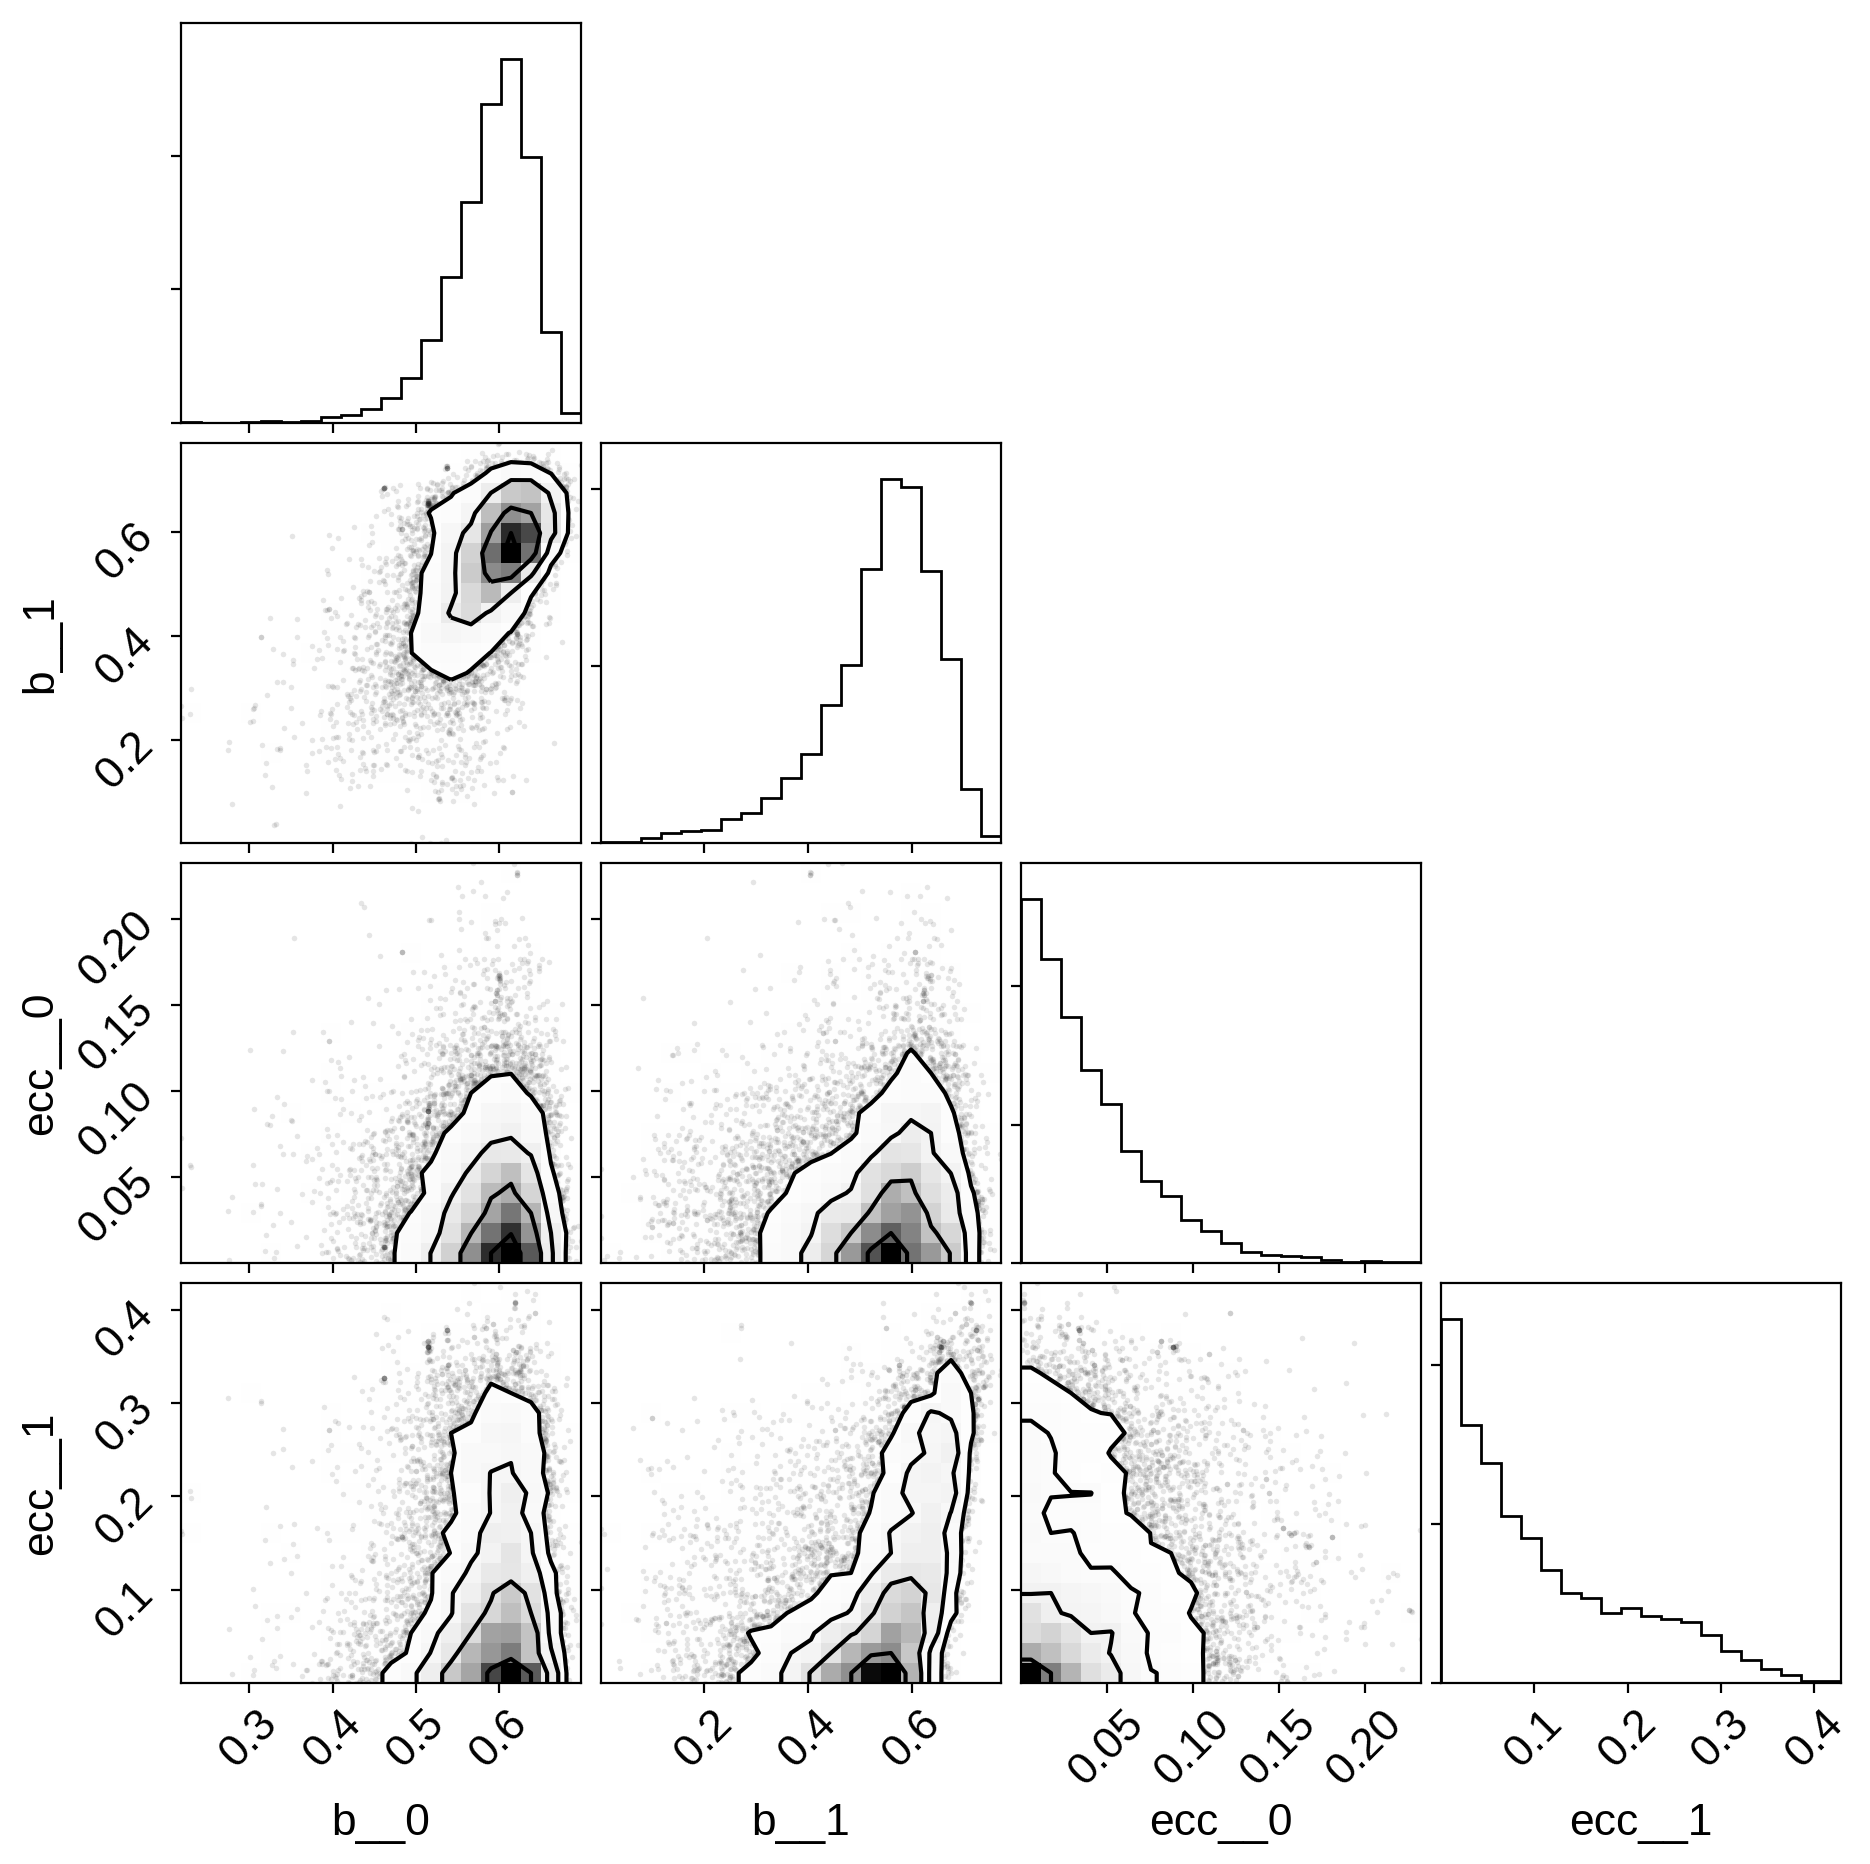

In [16]:
import corner

varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

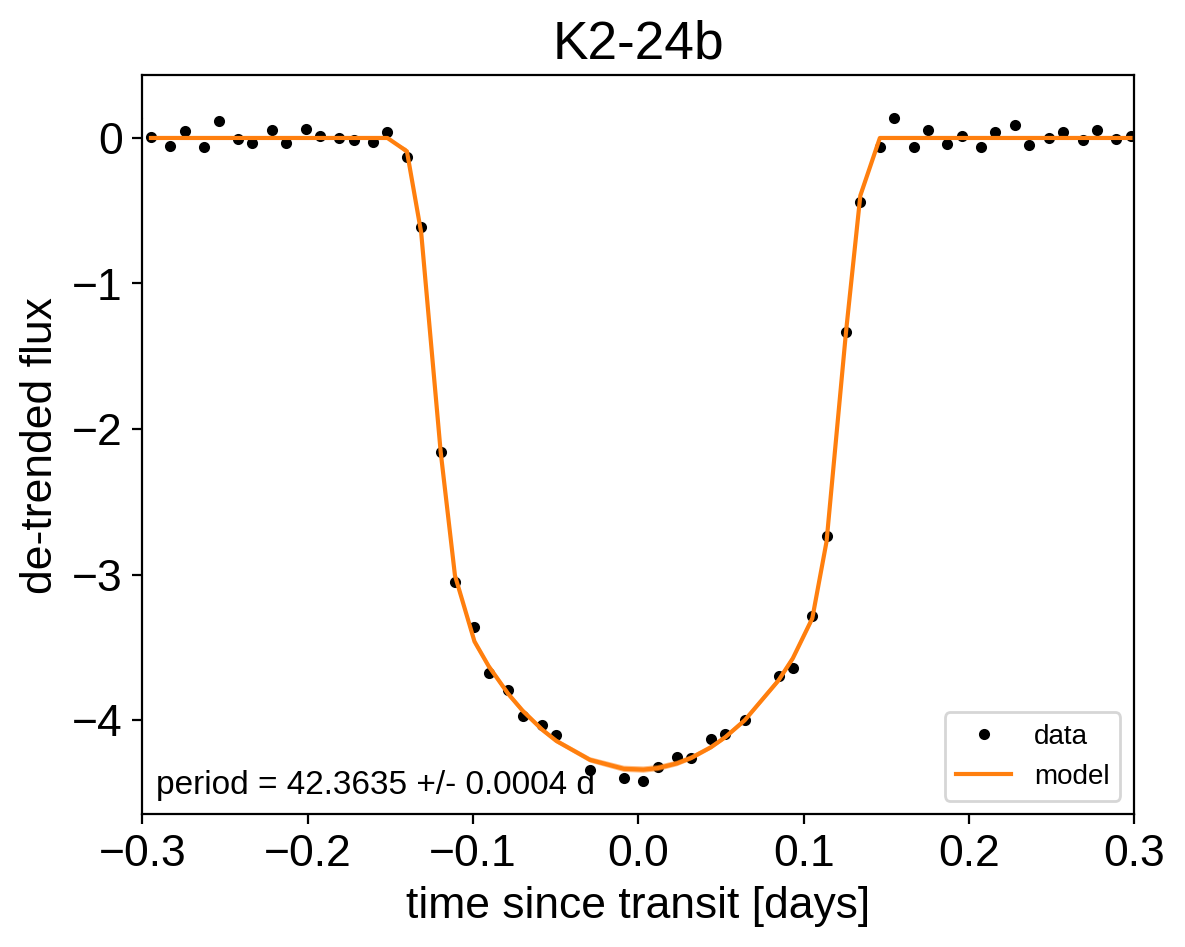

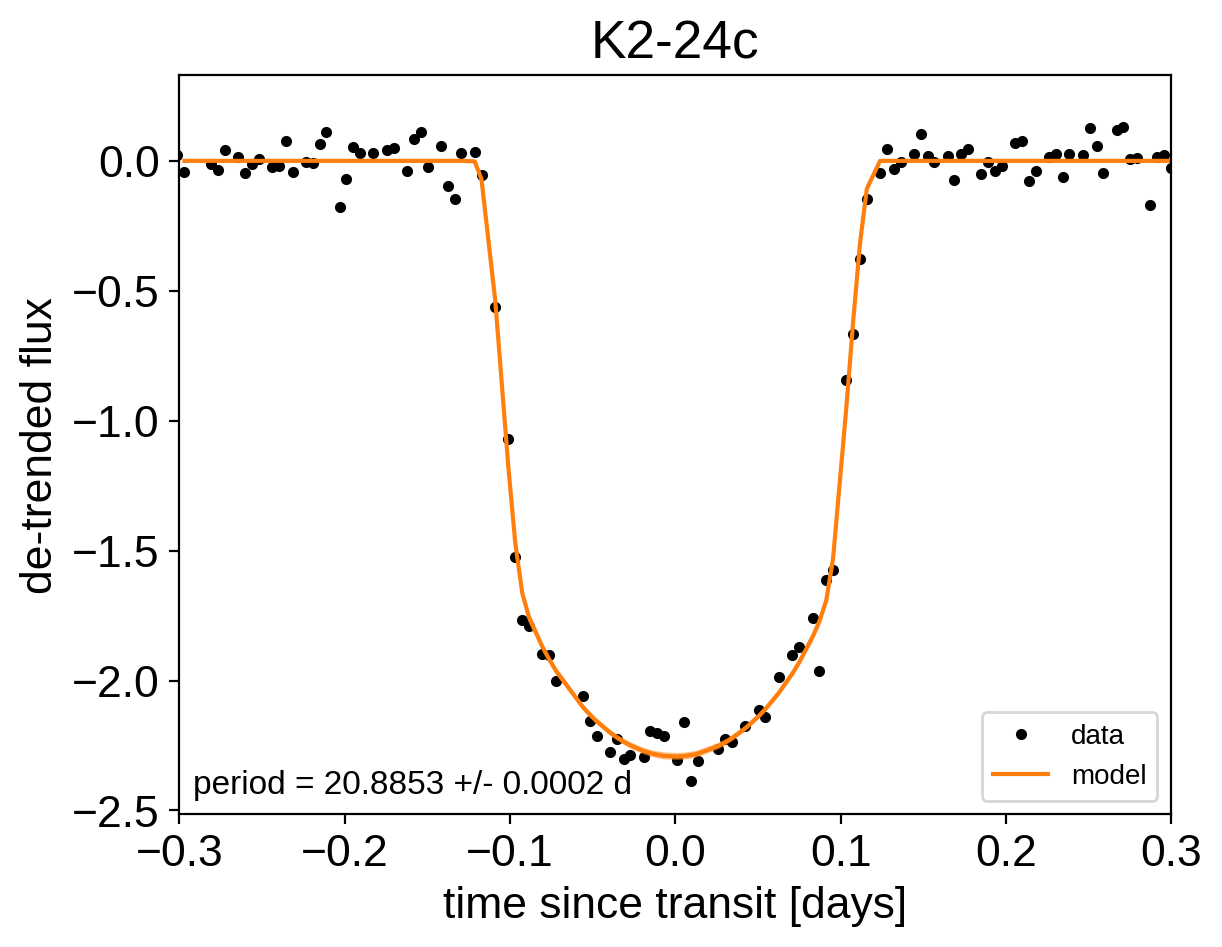

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

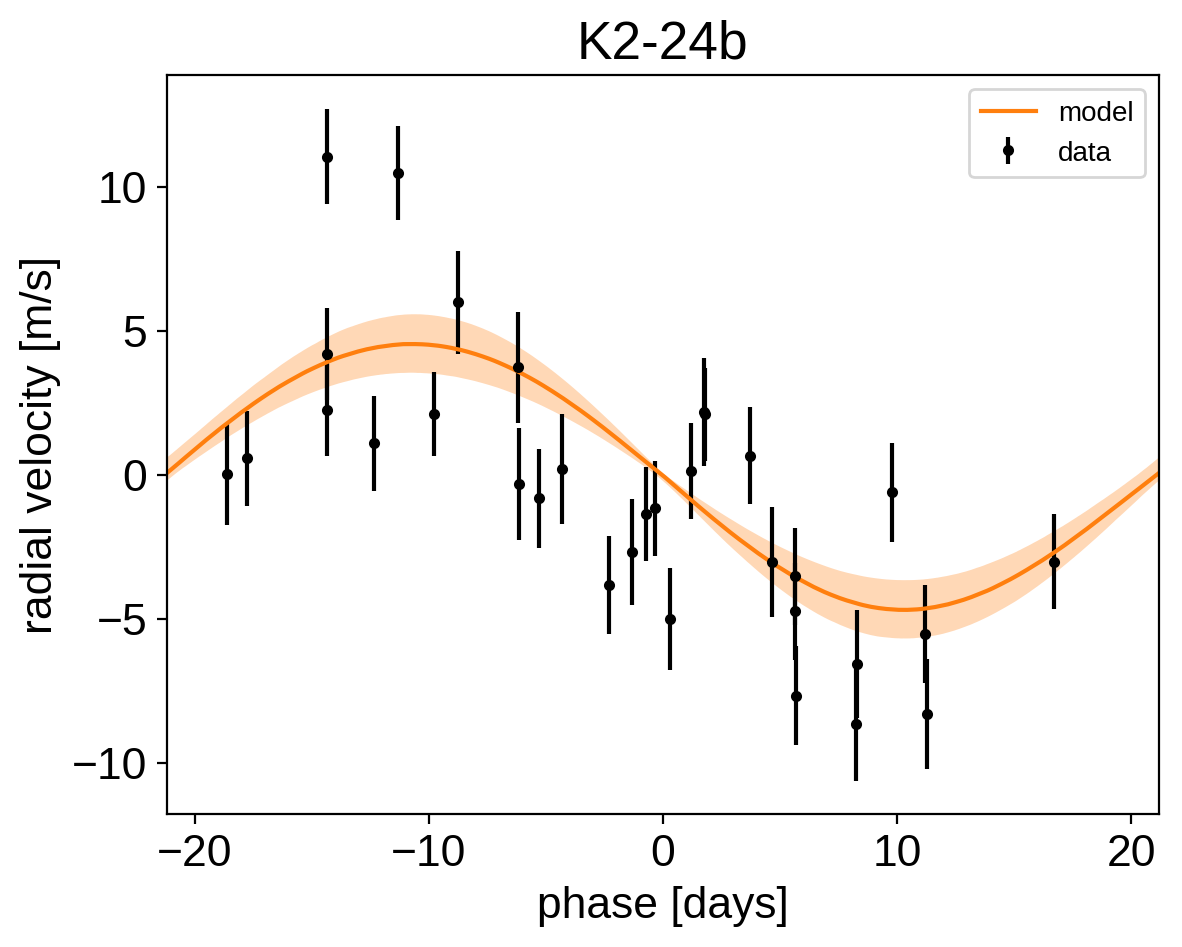

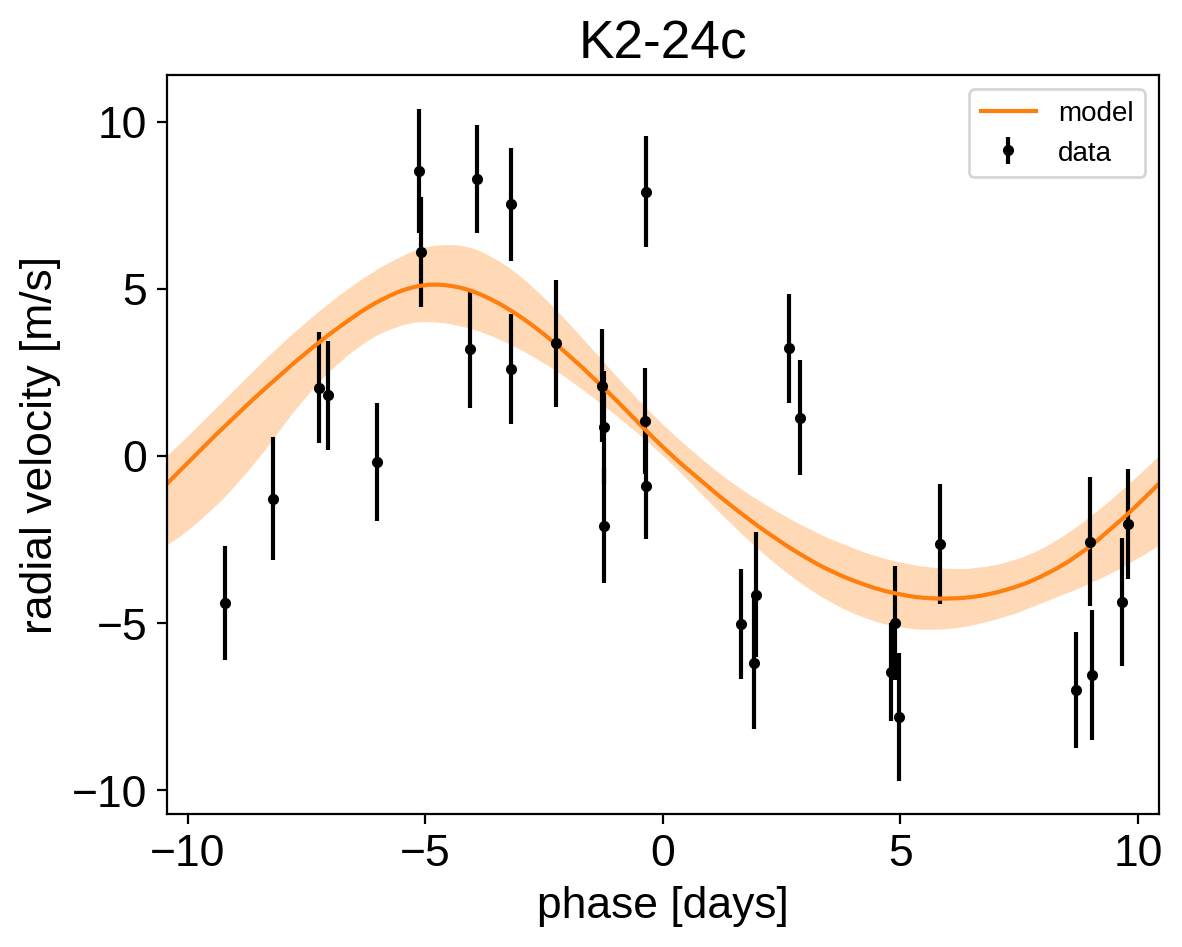

In [18]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

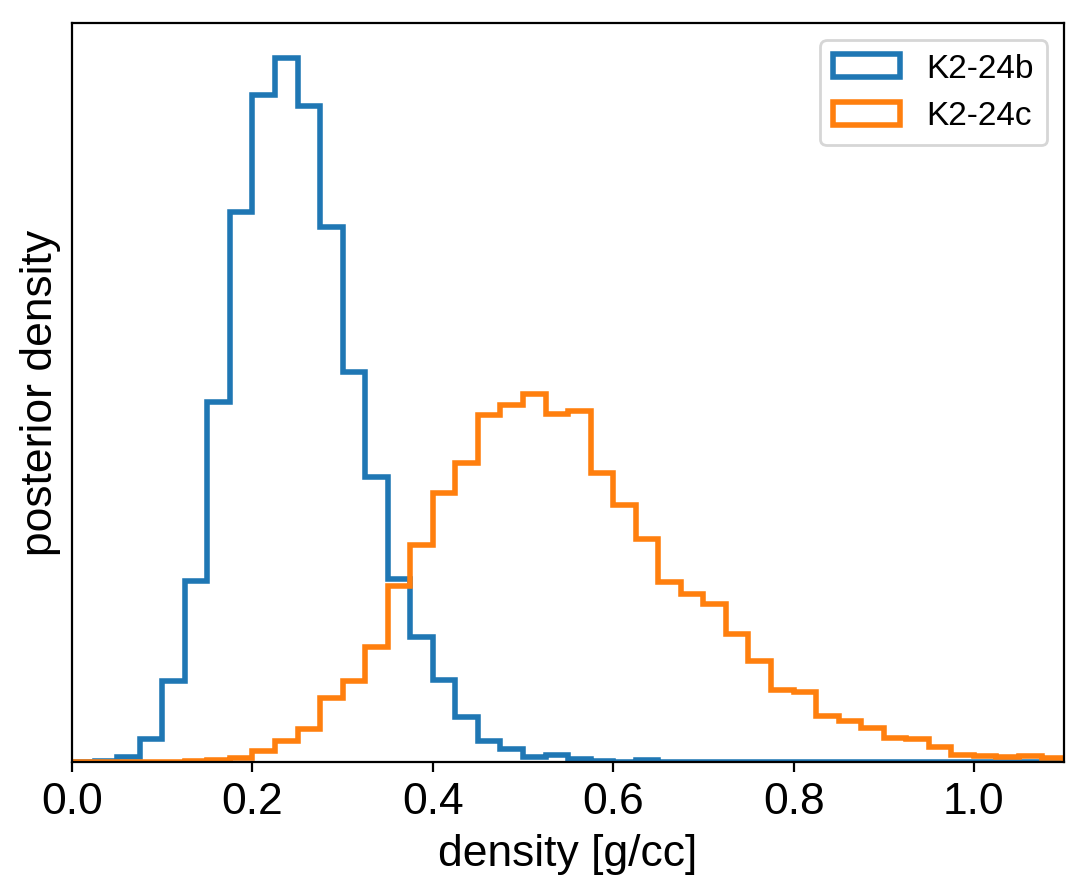

In [19]:
volume = 4 / 3 * np.pi * trace["r_pl"] ** 3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun ** 3)
density = density.to(u.g / u.cm ** 3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[:, n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [20]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano,
exoplanet:vaneylen19}.


In [21]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
